In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb

In [ ]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [ ]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [ ]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.loc[df['release_speed'].notnull()].copy()
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    df[float_cols] = df[float_cols].astype('float32')

    # Condense pitch types using a mapping dictionary
    pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "CH",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN"
    }
    df['pitch_type_condensed'] = df['pitch_type'].map(pitch_type_map).fillna("FAHCK")

    df['release_pos_y'] = 60.5 - df['release_extension']
    df['height_ratio'] = df['release_pos_z'] / df['height_numeric']
    # Create 'pitch_id_raw'
    df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + df['batter'].astype(str) + "_" + df['pitcher'].astype(str) + "_" + df['pitch_number'].astype(str) + "_" + df['at_bat_number'].astype(str) + "_" + df['inning'].astype(str)

    df['throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    return df

In [ ]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data)
testing_data_processed = preprocess_data(testing_data)

In [ ]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [ ]:
# Now, separate features and identifiers
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0', 'balls', 'strikes', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [ ]:
training_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'pitch_id_raw', 'throws'],
      dtype='object')

In [ ]:
train_data = training_features.loc[training_features['pfx_z'].notnull()].drop(['pfx_z'], axis=1).copy()
train_label = training_features['pfx_z'].loc[training_features['pfx_z'].notnull()].copy()
testing_data = testing_features.loc[testing_features['pfx_z'].notnull()].drop(['pfx_z'], axis=1).copy()
testing_label = testing_features['pfx_z'].copy()

In [ ]:
training_identifiers = train_data[['pitch_id_raw']]
testing_identifiers = testing_data[['pitch_id_raw']]
train_data = train_data.drop(['pitch_id_raw'], axis=1)
testing_data = testing_data.drop(['pitch_id_raw'], axis=1)

In [ ]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [ ]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [ ]:
y_pred = model.predict(dtest)

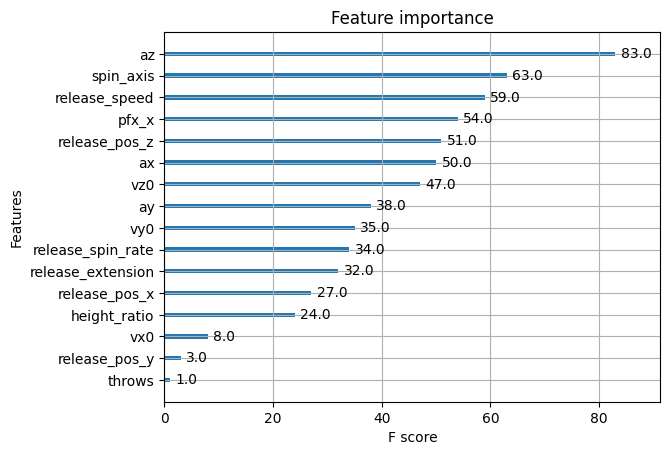

In [ ]:
xgb.plot_importance(model)
plt.show()

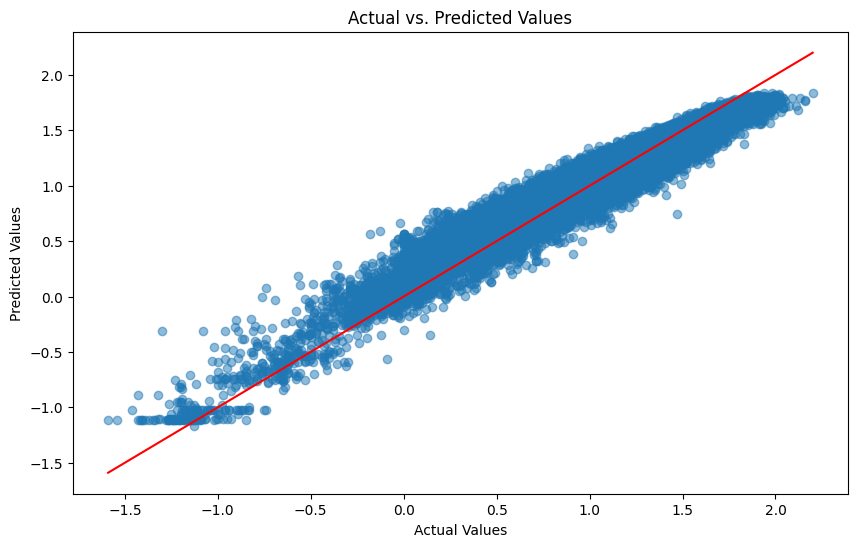

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 18:36:15,956] A new study created in memory with name: no-name-b4bcabbe-887c-4c25-93ac-163072f7330e
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35503
[1]	eval-rmse:0.30661
[2]	eval-rmse:0.22319
[3]	eval-rmse:0.16807
[4]	eval-rmse:0.16052
[5]	eval-rmse:0.12658
[6]	eval-rmse:0.12299
[7]	eval-rmse:0.12129
[8]	eval-rmse:0.11939
[9]	eval-rmse:0.10249
[10]	eval-rmse:0.10136
[11]	eval-rmse:0.09999
[12]	eval-rmse:0.09916
[13]	eval-rmse:0.08772
[14]	eval-rmse:0.08723
[15]	eval-rmse:0.07756
[16]	eval-rmse:0.07655
[17]	eval-rmse:0.07585
[18]	eval-rmse:0.07539
[19]	eval-rmse:0.06919
[20]	eval-rmse:0.06863
[21]	eval-rmse:0.06823
[22]	eval-rmse:0.06795
[23]	eval-rmse:0.06758
[24]	eval-rmse:0.06735
[25]	eval-rmse:0.06719
[26]	eval-rmse:0.06679
[27]	eval-rmse:0.06670
[28]	eval-rmse:0.06226
[29]	eval-rmse:0.05858
[30]	eval-rmse:0.05808
[31]	eval-rmse:0.05768
[32]	eval-rmse:0.05457
[33]	eval-rmse:0.05422
[34]	eval-rmse:0.05184
[35]	eval-rmse:0.05148
[36]	eval-rmse:0.04976
[37]	eval-rmse:0.04843
[38]	eval-rmse:0.04781
[39]	eval-rmse:0.04614
[40]	eval-rmse:0.04576
[41]	eval-rmse:0.04550
[42]	eval-rmse:0.04532
[43]	eval-rmse:0.0451

[I 2023-11-14 18:36:22,295] Trial 0 finished with value: 0.03268929943442345 and parameters: {'max_depth': 6, 'eta': 0.3168080461938778, 'subsample': 0.4662254659643589, 'colsample_bytree': 0.48537617583278925, 'min_child_weight': 4}. Best is trial 0 with value: 0.03268929943442345.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36886
[1]	eval-rmse:0.32925
[2]	eval-rmse:0.25530
[3]	eval-rmse:0.20097
[4]	eval-rmse:0.18997
[5]	eval-rmse:0.15502
[6]	eval-rmse:0.14941
[7]	eval-rmse:0.14596
[8]	eval-rmse:0.14283
[9]	eval-rmse:0.12396
[10]	eval-rmse:0.12277
[11]	eval-rmse:0.12080
[12]	eval-rmse:0.11976
[13]	eval-rmse:0.10735
[14]	eval-rmse:0.10654
[15]	eval-rmse:0.09632
[16]	eval-rmse:0.09512
[17]	eval-rmse:0.09424
[18]	eval-rmse:0.09370
[19]	eval-rmse:0.08610
[20]	eval-rmse:0.08560
[21]	eval-rmse:0.08511
[22]	eval-rmse:0.08482
[23]	eval-rmse:0.08459
[24]	eval-rmse:0.08441
[25]	eval-rmse:0.08426
[26]	eval-rmse:0.08401
[27]	eval-rmse:0.08370
[28]	eval-rmse:0.07793
[29]	eval-rmse:0.07274
[30]	eval-rmse:0.07238
[31]	eval-rmse:0.07198
[32]	eval-rmse:0.06771
[33]	eval-rmse:0.06743
[34]	eval-rmse:0.06416
[35]	eval-rmse:0.06370
[36]	eval-rmse:0.06102
[37]	eval-rmse:0.05896
[38]	eval-rmse:0.05824
[39]	eval-rmse:0.05597
[40]	eval-rmse:0.05552
[41]	eval-rmse:0.05514
[42]	eval-rmse:0.05491
[43]	eval-rmse:0.0546

[I 2023-11-14 18:36:27,719] Trial 1 finished with value: 0.031462911516427994 and parameters: {'max_depth': 5, 'eta': 0.2508529450362428, 'subsample': 0.5243742169485273, 'colsample_bytree': 0.49114701399857147, 'min_child_weight': 3}. Best is trial 1 with value: 0.031462911516427994.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35066
[1]	eval-rmse:0.25040
[2]	eval-rmse:0.18137
[3]	eval-rmse:0.13432
[4]	eval-rmse:0.12199
[5]	eval-rmse:0.09379
[6]	eval-rmse:0.08774
[7]	eval-rmse:0.08435
[8]	eval-rmse:0.08155
[9]	eval-rmse:0.06845
[10]	eval-rmse:0.06763
[11]	eval-rmse:0.06663
[12]	eval-rmse:0.06586
[13]	eval-rmse:0.05826
[14]	eval-rmse:0.05336
[15]	eval-rmse:0.04894
[16]	eval-rmse:0.04644
[17]	eval-rmse:0.04590
[18]	eval-rmse:0.04557
[19]	eval-rmse:0.04300
[20]	eval-rmse:0.04261
[21]	eval-rmse:0.04226
[22]	eval-rmse:0.04217
[23]	eval-rmse:0.04209
[24]	eval-rmse:0.04186
[25]	eval-rmse:0.04164
[26]	eval-rmse:0.04160
[27]	eval-rmse:0.04155
[28]	eval-rmse:0.03992
[29]	eval-rmse:0.03840
[30]	eval-rmse:0.03824
[31]	eval-rmse:0.03800
[32]	eval-rmse:0.03672
[33]	eval-rmse:0.03664
[34]	eval-rmse:0.03575
[35]	eval-rmse:0.03553
[36]	eval-rmse:0.03493
[37]	eval-rmse:0.03430
[38]	eval-rmse:0.03410
[39]	eval-rmse:0.03359
[40]	eval-rmse:0.03314
[41]	eval-rmse:0.03280
[42]	eval-rmse:0.03266
[43]	eval-rmse:0.0325

[I 2023-11-14 18:36:35,979] Trial 2 finished with value: 0.028672227635979652 and parameters: {'max_depth': 8, 'eta': 0.30013888597036453, 'subsample': 0.5898617427675266, 'colsample_bytree': 0.5851065628298484, 'min_child_weight': 2}. Best is trial 2 with value: 0.028672227635979652.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36894
[1]	eval-rmse:0.33236
[2]	eval-rmse:0.25427
[3]	eval-rmse:0.19866
[4]	eval-rmse:0.18830
[5]	eval-rmse:0.15403
[6]	eval-rmse:0.14937
[7]	eval-rmse:0.14653
[8]	eval-rmse:0.14372
[9]	eval-rmse:0.12565
[10]	eval-rmse:0.12465
[11]	eval-rmse:0.12309
[12]	eval-rmse:0.12242
[13]	eval-rmse:0.11060
[14]	eval-rmse:0.10997
[15]	eval-rmse:0.10056
[16]	eval-rmse:0.09937
[17]	eval-rmse:0.09844
[18]	eval-rmse:0.09782
[19]	eval-rmse:0.09120
[20]	eval-rmse:0.09062
[21]	eval-rmse:0.09016
[22]	eval-rmse:0.08959
[23]	eval-rmse:0.08923
[24]	eval-rmse:0.08895
[25]	eval-rmse:0.08873
[26]	eval-rmse:0.08848
[27]	eval-rmse:0.08829
[28]	eval-rmse:0.08249
[29]	eval-rmse:0.07761
[30]	eval-rmse:0.07717
[31]	eval-rmse:0.07673
[32]	eval-rmse:0.07258
[33]	eval-rmse:0.07210
[34]	eval-rmse:0.06888
[35]	eval-rmse:0.06839
[36]	eval-rmse:0.06571
[37]	eval-rmse:0.06331
[38]	eval-rmse:0.06278
[39]	eval-rmse:0.06050
[40]	eval-rmse:0.05999
[41]	eval-rmse:0.05800
[42]	eval-rmse:0.05750
[43]	eval-rmse:0.0570

[I 2023-11-14 18:36:40,908] Trial 3 finished with value: 0.03126826882362366 and parameters: {'max_depth': 4, 'eta': 0.2670581567802146, 'subsample': 0.5918554927430693, 'colsample_bytree': 0.5505630475286087, 'min_child_weight': 1}. Best is trial 2 with value: 0.028672227635979652.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35379
[1]	eval-rmse:0.31341
[2]	eval-rmse:0.29728
[3]	eval-rmse:0.21382
[4]	eval-rmse:0.20122
[5]	eval-rmse:0.16036
[6]	eval-rmse:0.15782
[7]	eval-rmse:0.15539
[8]	eval-rmse:0.15377
[9]	eval-rmse:0.15229
[10]	eval-rmse:0.15102
[11]	eval-rmse:0.14989
[12]	eval-rmse:0.14911
[13]	eval-rmse:0.13089
[14]	eval-rmse:0.13026
[15]	eval-rmse:0.11745
[16]	eval-rmse:0.11562
[17]	eval-rmse:0.11463
[18]	eval-rmse:0.11397
[19]	eval-rmse:0.10471
[20]	eval-rmse:0.10382
[21]	eval-rmse:0.10294
[22]	eval-rmse:0.10251
[23]	eval-rmse:0.10197
[24]	eval-rmse:0.10183
[25]	eval-rmse:0.10143
[26]	eval-rmse:0.10118
[27]	eval-rmse:0.10093
[28]	eval-rmse:0.09244
[29]	eval-rmse:0.08686
[30]	eval-rmse:0.08582
[31]	eval-rmse:0.08535
[32]	eval-rmse:0.08024
[33]	eval-rmse:0.07939
[34]	eval-rmse:0.07556
[35]	eval-rmse:0.07464
[36]	eval-rmse:0.07186
[37]	eval-rmse:0.06968
[38]	eval-rmse:0.06866
[39]	eval-rmse:0.06628
[40]	eval-rmse:0.06551
[41]	eval-rmse:0.06504
[42]	eval-rmse:0.06481
[43]	eval-rmse:0.0644

[I 2023-11-14 18:36:45,689] Trial 4 finished with value: 0.03885617107152939 and parameters: {'max_depth': 4, 'eta': 0.38063321573333603, 'subsample': 0.4125018795847866, 'colsample_bytree': 0.4316448765872085, 'min_child_weight': 5}. Best is trial 2 with value: 0.028672227635979652.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36272
[1]	eval-rmse:0.31945
[2]	eval-rmse:0.30360
[3]	eval-rmse:0.23546
[4]	eval-rmse:0.21784
[5]	eval-rmse:0.17420
[6]	eval-rmse:0.16736
[7]	eval-rmse:0.16205
[8]	eval-rmse:0.15867
[9]	eval-rmse:0.15638
[10]	eval-rmse:0.15396
[11]	eval-rmse:0.15230
[12]	eval-rmse:0.15136
[13]	eval-rmse:0.13178
[14]	eval-rmse:0.13095
[15]	eval-rmse:0.11491
[16]	eval-rmse:0.11379
[17]	eval-rmse:0.11306
[18]	eval-rmse:0.11245
[19]	eval-rmse:0.10154
[20]	eval-rmse:0.10071
[21]	eval-rmse:0.09999
[22]	eval-rmse:0.09972
[23]	eval-rmse:0.09927
[24]	eval-rmse:0.09877
[25]	eval-rmse:0.09849
[26]	eval-rmse:0.09818
[27]	eval-rmse:0.09792
[28]	eval-rmse:0.09090
[29]	eval-rmse:0.08446
[30]	eval-rmse:0.08400
[31]	eval-rmse:0.08373
[32]	eval-rmse:0.07835
[33]	eval-rmse:0.07786
[34]	eval-rmse:0.07367
[35]	eval-rmse:0.07329
[36]	eval-rmse:0.07043
[37]	eval-rmse:0.06813
[38]	eval-rmse:0.06749
[39]	eval-rmse:0.06428
[40]	eval-rmse:0.06370
[41]	eval-rmse:0.06336
[42]	eval-rmse:0.06324
[43]	eval-rmse:0.0630

[I 2023-11-14 18:36:52,842] Trial 5 finished with value: 0.038967132568359375 and parameters: {'max_depth': 7, 'eta': 0.2576963601378855, 'subsample': 0.4963980307661817, 'colsample_bytree': 0.4248418833873039, 'min_child_weight': 2}. Best is trial 2 with value: 0.028672227635979652.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.33638
[1]	eval-rmse:0.21296
[2]	eval-rmse:0.14235
[3]	eval-rmse:0.10402
[4]	eval-rmse:0.09755
[5]	eval-rmse:0.07504
[6]	eval-rmse:0.07172
[7]	eval-rmse:0.07020
[8]	eval-rmse:0.06874
[9]	eval-rmse:0.05904
[10]	eval-rmse:0.05839
[11]	eval-rmse:0.05753
[12]	eval-rmse:0.05705
[13]	eval-rmse:0.05177
[14]	eval-rmse:0.04892
[15]	eval-rmse:0.04600
[16]	eval-rmse:0.04441
[17]	eval-rmse:0.04381
[18]	eval-rmse:0.04328
[19]	eval-rmse:0.04176
[20]	eval-rmse:0.04131
[21]	eval-rmse:0.04088
[22]	eval-rmse:0.04080
[23]	eval-rmse:0.04075
[24]	eval-rmse:0.04058
[25]	eval-rmse:0.04029
[26]	eval-rmse:0.04018
[27]	eval-rmse:0.04015
[28]	eval-rmse:0.03902
[29]	eval-rmse:0.03809
[30]	eval-rmse:0.03792
[31]	eval-rmse:0.03774
[32]	eval-rmse:0.03702
[33]	eval-rmse:0.03694
[34]	eval-rmse:0.03640
[35]	eval-rmse:0.03613
[36]	eval-rmse:0.03571
[37]	eval-rmse:0.03540
[38]	eval-rmse:0.03521
[39]	eval-rmse:0.03476
[40]	eval-rmse:0.03459
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03418
[43]	eval-rmse:0.0340

[I 2023-11-14 18:36:59,914] Trial 6 finished with value: 0.030585983768105507 and parameters: {'max_depth': 7, 'eta': 0.39840461559455775, 'subsample': 0.4801967421456178, 'colsample_bytree': 0.5735041593262299, 'min_child_weight': 3}. Best is trial 2 with value: 0.028672227635979652.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.33892
[1]	eval-rmse:0.28429
[2]	eval-rmse:0.19736
[3]	eval-rmse:0.14622
[4]	eval-rmse:0.14135
[5]	eval-rmse:0.10953
[6]	eval-rmse:0.10715
[7]	eval-rmse:0.10566
[8]	eval-rmse:0.10454
[9]	eval-rmse:0.08873
[10]	eval-rmse:0.08788
[11]	eval-rmse:0.08712
[12]	eval-rmse:0.08613
[13]	eval-rmse:0.07589
[14]	eval-rmse:0.07540
[15]	eval-rmse:0.06839
[16]	eval-rmse:0.06762
[17]	eval-rmse:0.06714
[18]	eval-rmse:0.06693
[19]	eval-rmse:0.06221
[20]	eval-rmse:0.06175
[21]	eval-rmse:0.06120
[22]	eval-rmse:0.06087
[23]	eval-rmse:0.06063
[24]	eval-rmse:0.06056
[25]	eval-rmse:0.06034
[26]	eval-rmse:0.06028
[27]	eval-rmse:0.06023
[28]	eval-rmse:0.05704
[29]	eval-rmse:0.05444
[30]	eval-rmse:0.05399
[31]	eval-rmse:0.05365
[32]	eval-rmse:0.05132
[33]	eval-rmse:0.05115
[34]	eval-rmse:0.04991
[35]	eval-rmse:0.04966
[36]	eval-rmse:0.04853
[37]	eval-rmse:0.04756
[38]	eval-rmse:0.04725
[39]	eval-rmse:0.04656
[40]	eval-rmse:0.04647
[41]	eval-rmse:0.04589
[42]	eval-rmse:0.04574
[43]	eval-rmse:0.0456

[I 2023-11-14 18:37:06,478] Trial 7 finished with value: 0.03907701373100281 and parameters: {'max_depth': 7, 'eta': 0.382759118425682, 'subsample': 0.44260007877086643, 'colsample_bytree': 0.5546135921791397, 'min_child_weight': 3}. Best is trial 2 with value: 0.028672227635979652.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36083
[1]	eval-rmse:0.32308
[2]	eval-rmse:0.30742
[3]	eval-rmse:0.22834
[4]	eval-rmse:0.21411
[5]	eval-rmse:0.17115
[6]	eval-rmse:0.16781
[7]	eval-rmse:0.16455
[8]	eval-rmse:0.16250
[9]	eval-rmse:0.16065
[10]	eval-rmse:0.15953
[11]	eval-rmse:0.15783
[12]	eval-rmse:0.15671
[13]	eval-rmse:0.13906
[14]	eval-rmse:0.13871
[15]	eval-rmse:0.12568
[16]	eval-rmse:0.12386
[17]	eval-rmse:0.12248
[18]	eval-rmse:0.12177
[19]	eval-rmse:0.11086
[20]	eval-rmse:0.11000
[21]	eval-rmse:0.10928
[22]	eval-rmse:0.10889
[23]	eval-rmse:0.10829
[24]	eval-rmse:0.10811
[25]	eval-rmse:0.10765
[26]	eval-rmse:0.10717
[27]	eval-rmse:0.10695
[28]	eval-rmse:0.09876
[29]	eval-rmse:0.09239
[30]	eval-rmse:0.09135
[31]	eval-rmse:0.09090
[32]	eval-rmse:0.08598
[33]	eval-rmse:0.08525
[34]	eval-rmse:0.08116
[35]	eval-rmse:0.08029
[36]	eval-rmse:0.07725
[37]	eval-rmse:0.07475
[38]	eval-rmse:0.07373
[39]	eval-rmse:0.07108
[40]	eval-rmse:0.07033
[41]	eval-rmse:0.06979
[42]	eval-rmse:0.06960
[43]	eval-rmse:0.0693

[I 2023-11-14 18:37:10,767] Trial 8 finished with value: 0.03877625986933708 and parameters: {'max_depth': 4, 'eta': 0.32731513653515476, 'subsample': 0.45965492442379663, 'colsample_bytree': 0.43129844371797627, 'min_child_weight': 3}. Best is trial 2 with value: 0.028672227635979652.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34493
[1]	eval-rmse:0.29563
[2]	eval-rmse:0.20407
[3]	eval-rmse:0.15412
[4]	eval-rmse:0.15106
[5]	eval-rmse:0.12075
[6]	eval-rmse:0.11781
[7]	eval-rmse:0.11665
[8]	eval-rmse:0.11511
[9]	eval-rmse:0.10058
[10]	eval-rmse:0.09873
[11]	eval-rmse:0.09727
[12]	eval-rmse:0.09644
[13]	eval-rmse:0.08526
[14]	eval-rmse:0.08449
[15]	eval-rmse:0.07629
[16]	eval-rmse:0.07534
[17]	eval-rmse:0.07444
[18]	eval-rmse:0.07377
[19]	eval-rmse:0.06800
[20]	eval-rmse:0.06729
[21]	eval-rmse:0.06698
[22]	eval-rmse:0.06661
[23]	eval-rmse:0.06620
[24]	eval-rmse:0.06600
[25]	eval-rmse:0.06585
[26]	eval-rmse:0.06547
[27]	eval-rmse:0.06536
[28]	eval-rmse:0.06121
[29]	eval-rmse:0.05783
[30]	eval-rmse:0.05708
[31]	eval-rmse:0.05661
[32]	eval-rmse:0.05399
[33]	eval-rmse:0.05350
[34]	eval-rmse:0.05150
[35]	eval-rmse:0.05102
[36]	eval-rmse:0.04937
[37]	eval-rmse:0.04849
[38]	eval-rmse:0.04789
[39]	eval-rmse:0.04665
[40]	eval-rmse:0.04626
[41]	eval-rmse:0.04595
[42]	eval-rmse:0.04584
[43]	eval-rmse:0.0456

[I 2023-11-14 18:37:16,196] Trial 9 finished with value: 0.03400108218193054 and parameters: {'max_depth': 5, 'eta': 0.3996820807090336, 'subsample': 0.5126070900544364, 'colsample_bytree': 0.4993715570020145, 'min_child_weight': 1}. Best is trial 2 with value: 0.028672227635979652.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36860
[1]	eval-rmse:0.29303
[2]	eval-rmse:0.23383
[3]	eval-rmse:0.18744
[4]	eval-rmse:0.17041
[5]	eval-rmse:0.13824
[6]	eval-rmse:0.12776
[7]	eval-rmse:0.12063
[8]	eval-rmse:0.11487
[9]	eval-rmse:0.09726
[10]	eval-rmse:0.09442
[11]	eval-rmse:0.09197
[12]	eval-rmse:0.09012
[13]	eval-rmse:0.07920
[14]	eval-rmse:0.07087
[15]	eval-rmse:0.06324
[16]	eval-rmse:0.05836
[17]	eval-rmse:0.05784
[18]	eval-rmse:0.05745
[19]	eval-rmse:0.05299
[20]	eval-rmse:0.05267
[21]	eval-rmse:0.05243
[22]	eval-rmse:0.05231
[23]	eval-rmse:0.05222
[24]	eval-rmse:0.05204
[25]	eval-rmse:0.05190
[26]	eval-rmse:0.05176
[27]	eval-rmse:0.05167
[28]	eval-rmse:0.04876
[29]	eval-rmse:0.04591
[30]	eval-rmse:0.04572
[31]	eval-rmse:0.04552
[32]	eval-rmse:0.04281
[33]	eval-rmse:0.04272
[34]	eval-rmse:0.04108
[35]	eval-rmse:0.04086
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03784
[38]	eval-rmse:0.03758
[39]	eval-rmse:0.03635
[40]	eval-rmse:0.03528
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03412
[43]	eval-rmse:0.0340

[I 2023-11-14 18:37:24,591] Trial 10 finished with value: 0.025725215673446655 and parameters: {'max_depth': 8, 'eta': 0.21155188566013527, 'subsample': 0.5923862281393016, 'colsample_bytree': 0.5904490239585648, 'min_child_weight': 2}. Best is trial 10 with value: 0.025725215673446655.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37010
[1]	eval-rmse:0.29662
[2]	eval-rmse:0.23846
[3]	eval-rmse:0.19246
[4]	eval-rmse:0.17513
[5]	eval-rmse:0.14290
[6]	eval-rmse:0.13199
[7]	eval-rmse:0.12455
[8]	eval-rmse:0.11842
[9]	eval-rmse:0.10056
[10]	eval-rmse:0.09768
[11]	eval-rmse:0.09508
[12]	eval-rmse:0.09300
[13]	eval-rmse:0.08187
[14]	eval-rmse:0.07323
[15]	eval-rmse:0.06524
[16]	eval-rmse:0.06010
[17]	eval-rmse:0.05953
[18]	eval-rmse:0.05907
[19]	eval-rmse:0.05418
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05364
[22]	eval-rmse:0.05348
[23]	eval-rmse:0.05337
[24]	eval-rmse:0.05320
[25]	eval-rmse:0.05307
[26]	eval-rmse:0.05291
[27]	eval-rmse:0.05281
[28]	eval-rmse:0.04970
[29]	eval-rmse:0.04677
[30]	eval-rmse:0.04658
[31]	eval-rmse:0.04640
[32]	eval-rmse:0.04350
[33]	eval-rmse:0.04338
[34]	eval-rmse:0.04165
[35]	eval-rmse:0.04144
[36]	eval-rmse:0.03980
[37]	eval-rmse:0.03832
[38]	eval-rmse:0.03811
[39]	eval-rmse:0.03685
[40]	eval-rmse:0.03567
[41]	eval-rmse:0.03474
[42]	eval-rmse:0.03451
[43]	eval-rmse:0.0343

[I 2023-11-14 18:37:32,864] Trial 11 finished with value: 0.025394044816493988 and parameters: {'max_depth': 8, 'eta': 0.20473487456836417, 'subsample': 0.5997200976081618, 'colsample_bytree': 0.582051780909074, 'min_child_weight': 2}. Best is trial 11 with value: 0.025394044816493988.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37010
[1]	eval-rmse:0.29689
[2]	eval-rmse:0.23890
[3]	eval-rmse:0.19296
[4]	eval-rmse:0.17557
[5]	eval-rmse:0.14340
[6]	eval-rmse:0.13257
[7]	eval-rmse:0.12511
[8]	eval-rmse:0.11909
[9]	eval-rmse:0.10117
[10]	eval-rmse:0.09813
[11]	eval-rmse:0.09553
[12]	eval-rmse:0.09345
[13]	eval-rmse:0.08241
[14]	eval-rmse:0.07379
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06047
[17]	eval-rmse:0.05987
[18]	eval-rmse:0.05946
[19]	eval-rmse:0.05461
[20]	eval-rmse:0.05427
[21]	eval-rmse:0.05408
[22]	eval-rmse:0.05392
[23]	eval-rmse:0.05378
[24]	eval-rmse:0.05360
[25]	eval-rmse:0.05345
[26]	eval-rmse:0.05328
[27]	eval-rmse:0.05317
[28]	eval-rmse:0.05014
[29]	eval-rmse:0.04715
[30]	eval-rmse:0.04696
[31]	eval-rmse:0.04678
[32]	eval-rmse:0.04399
[33]	eval-rmse:0.04388
[34]	eval-rmse:0.04206
[35]	eval-rmse:0.04189
[36]	eval-rmse:0.04028
[37]	eval-rmse:0.03873
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03723
[40]	eval-rmse:0.03609
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.0347

[I 2023-11-14 18:37:41,078] Trial 12 finished with value: 0.025989025831222534 and parameters: {'max_depth': 8, 'eta': 0.20386243644650587, 'subsample': 0.5567781629911579, 'colsample_bytree': 0.5986233375812927, 'min_child_weight': 2}. Best is trial 11 with value: 0.025394044816493988.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37019
[1]	eval-rmse:0.32935
[2]	eval-rmse:0.26643
[3]	eval-rmse:0.21644
[4]	eval-rmse:0.20057
[5]	eval-rmse:0.16491
[6]	eval-rmse:0.15540
[7]	eval-rmse:0.14917
[8]	eval-rmse:0.14385
[9]	eval-rmse:0.12317
[10]	eval-rmse:0.12077
[11]	eval-rmse:0.11831
[12]	eval-rmse:0.11632
[13]	eval-rmse:0.10261
[14]	eval-rmse:0.10182
[15]	eval-rmse:0.09046
[16]	eval-rmse:0.08965
[17]	eval-rmse:0.08903
[18]	eval-rmse:0.08856
[19]	eval-rmse:0.08065
[20]	eval-rmse:0.08036
[21]	eval-rmse:0.08006
[22]	eval-rmse:0.07991
[23]	eval-rmse:0.07963
[24]	eval-rmse:0.07943
[25]	eval-rmse:0.07923
[26]	eval-rmse:0.07902
[27]	eval-rmse:0.07887
[28]	eval-rmse:0.07354
[29]	eval-rmse:0.06849
[30]	eval-rmse:0.06830
[31]	eval-rmse:0.06808
[32]	eval-rmse:0.06335
[33]	eval-rmse:0.06320
[34]	eval-rmse:0.06008
[35]	eval-rmse:0.05986
[36]	eval-rmse:0.05709
[37]	eval-rmse:0.05441
[38]	eval-rmse:0.05409
[39]	eval-rmse:0.05178
[40]	eval-rmse:0.05147
[41]	eval-rmse:0.04959
[42]	eval-rmse:0.04935
[43]	eval-rmse:0.0491

[I 2023-11-14 18:37:49,677] Trial 13 finished with value: 0.03255806863307953 and parameters: {'max_depth': 8, 'eta': 0.20331067127268931, 'subsample': 0.5648879532794164, 'colsample_bytree': 0.5426846508701619, 'min_child_weight': 2}. Best is trial 11 with value: 0.025394044816493988.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36529
[1]	eval-rmse:0.28492
[2]	eval-rmse:0.22335
[3]	eval-rmse:0.17618
[4]	eval-rmse:0.15977
[5]	eval-rmse:0.12798
[6]	eval-rmse:0.11833
[7]	eval-rmse:0.11209
[8]	eval-rmse:0.10695
[9]	eval-rmse:0.09010
[10]	eval-rmse:0.08788
[11]	eval-rmse:0.08580
[12]	eval-rmse:0.08413
[13]	eval-rmse:0.07384
[14]	eval-rmse:0.06608
[15]	eval-rmse:0.05906
[16]	eval-rmse:0.05487
[17]	eval-rmse:0.05443
[18]	eval-rmse:0.05408
[19]	eval-rmse:0.05005
[20]	eval-rmse:0.04962
[21]	eval-rmse:0.04933
[22]	eval-rmse:0.04917
[23]	eval-rmse:0.04908
[24]	eval-rmse:0.04895
[25]	eval-rmse:0.04881
[26]	eval-rmse:0.04868
[27]	eval-rmse:0.04856
[28]	eval-rmse:0.04590
[29]	eval-rmse:0.04332
[30]	eval-rmse:0.04313
[31]	eval-rmse:0.04298
[32]	eval-rmse:0.04069
[33]	eval-rmse:0.04059
[34]	eval-rmse:0.03915
[35]	eval-rmse:0.03893
[36]	eval-rmse:0.03761
[37]	eval-rmse:0.03629
[38]	eval-rmse:0.03609
[39]	eval-rmse:0.03507
[40]	eval-rmse:0.03417
[41]	eval-rmse:0.03344
[42]	eval-rmse:0.03323
[43]	eval-rmse:0.0330

[I 2023-11-14 18:37:57,905] Trial 14 finished with value: 0.026493148878216743 and parameters: {'max_depth': 8, 'eta': 0.2276755162331366, 'subsample': 0.5531016380225948, 'colsample_bytree': 0.589209504573113, 'min_child_weight': 1}. Best is trial 11 with value: 0.025394044816493988.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36745
[1]	eval-rmse:0.32501
[2]	eval-rmse:0.25675
[3]	eval-rmse:0.20444
[4]	eval-rmse:0.19050
[5]	eval-rmse:0.15439
[6]	eval-rmse:0.14684
[7]	eval-rmse:0.14169
[8]	eval-rmse:0.13771
[9]	eval-rmse:0.11742
[10]	eval-rmse:0.11565
[11]	eval-rmse:0.11372
[12]	eval-rmse:0.11234
[13]	eval-rmse:0.09912
[14]	eval-rmse:0.09841
[15]	eval-rmse:0.08773
[16]	eval-rmse:0.08693
[17]	eval-rmse:0.08633
[18]	eval-rmse:0.08588
[19]	eval-rmse:0.07817
[20]	eval-rmse:0.07768
[21]	eval-rmse:0.07738
[22]	eval-rmse:0.07714
[23]	eval-rmse:0.07697
[24]	eval-rmse:0.07676
[25]	eval-rmse:0.07664
[26]	eval-rmse:0.07640
[27]	eval-rmse:0.07628
[28]	eval-rmse:0.07109
[29]	eval-rmse:0.06624
[30]	eval-rmse:0.06594
[31]	eval-rmse:0.06568
[32]	eval-rmse:0.06140
[33]	eval-rmse:0.06120
[34]	eval-rmse:0.05824
[35]	eval-rmse:0.05794
[36]	eval-rmse:0.05531
[37]	eval-rmse:0.05280
[38]	eval-rmse:0.05241
[39]	eval-rmse:0.05021
[40]	eval-rmse:0.04992
[41]	eval-rmse:0.04817
[42]	eval-rmse:0.04794
[43]	eval-rmse:0.0477

[I 2023-11-14 18:38:05,122] Trial 15 finished with value: 0.0313107892870903 and parameters: {'max_depth': 7, 'eta': 0.22769773929224346, 'subsample': 0.5956451181788056, 'colsample_bytree': 0.5293081104660988, 'min_child_weight': 4}. Best is trial 11 with value: 0.025394044816493988.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37399
[1]	eval-rmse:0.30098
[2]	eval-rmse:0.24305
[3]	eval-rmse:0.19708
[4]	eval-rmse:0.18115
[5]	eval-rmse:0.14924
[6]	eval-rmse:0.13964
[7]	eval-rmse:0.13305
[8]	eval-rmse:0.12750
[9]	eval-rmse:0.10954
[10]	eval-rmse:0.10709
[11]	eval-rmse:0.10460
[12]	eval-rmse:0.10250
[13]	eval-rmse:0.09117
[14]	eval-rmse:0.08243
[15]	eval-rmse:0.07435
[16]	eval-rmse:0.06856
[17]	eval-rmse:0.06769
[18]	eval-rmse:0.06709
[19]	eval-rmse:0.06182
[20]	eval-rmse:0.06133
[21]	eval-rmse:0.06101
[22]	eval-rmse:0.06079
[23]	eval-rmse:0.06051
[24]	eval-rmse:0.06026
[25]	eval-rmse:0.05997
[26]	eval-rmse:0.05985
[27]	eval-rmse:0.05975
[28]	eval-rmse:0.05612
[29]	eval-rmse:0.05279
[30]	eval-rmse:0.05253
[31]	eval-rmse:0.05230
[32]	eval-rmse:0.04927
[33]	eval-rmse:0.04905
[34]	eval-rmse:0.04695
[35]	eval-rmse:0.04671
[36]	eval-rmse:0.04459
[37]	eval-rmse:0.04267
[38]	eval-rmse:0.04236
[39]	eval-rmse:0.04079
[40]	eval-rmse:0.03940
[41]	eval-rmse:0.03819
[42]	eval-rmse:0.03793
[43]	eval-rmse:0.0376

[I 2023-11-14 18:38:11,631] Trial 16 finished with value: 0.02436862140893936 and parameters: {'max_depth': 6, 'eta': 0.2034815732500117, 'subsample': 0.5353814418820552, 'colsample_bytree': 0.5700288614058739, 'min_child_weight': 2}. Best is trial 16 with value: 0.02436862140893936.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36893
[1]	eval-rmse:0.28788
[2]	eval-rmse:0.22577
[3]	eval-rmse:0.17847
[4]	eval-rmse:0.16357
[5]	eval-rmse:0.13218
[6]	eval-rmse:0.12388
[7]	eval-rmse:0.11846
[8]	eval-rmse:0.11408
[9]	eval-rmse:0.09738
[10]	eval-rmse:0.09540
[11]	eval-rmse:0.09334
[12]	eval-rmse:0.09174
[13]	eval-rmse:0.08128
[14]	eval-rmse:0.07342
[15]	eval-rmse:0.06641
[16]	eval-rmse:0.06161
[17]	eval-rmse:0.06090
[18]	eval-rmse:0.06037
[19]	eval-rmse:0.05580
[20]	eval-rmse:0.05538
[21]	eval-rmse:0.05501
[22]	eval-rmse:0.05483
[23]	eval-rmse:0.05458
[24]	eval-rmse:0.05430
[25]	eval-rmse:0.05403
[26]	eval-rmse:0.05385
[27]	eval-rmse:0.05372
[28]	eval-rmse:0.05056
[29]	eval-rmse:0.04760
[30]	eval-rmse:0.04732
[31]	eval-rmse:0.04707
[32]	eval-rmse:0.04447
[33]	eval-rmse:0.04425
[34]	eval-rmse:0.04234
[35]	eval-rmse:0.04208
[36]	eval-rmse:0.04043
[37]	eval-rmse:0.03899
[38]	eval-rmse:0.03871
[39]	eval-rmse:0.03741
[40]	eval-rmse:0.03624
[41]	eval-rmse:0.03533
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0349

[I 2023-11-14 18:38:18,023] Trial 17 finished with value: 0.024541161954402924 and parameters: {'max_depth': 6, 'eta': 0.22984345702942804, 'subsample': 0.5350164048220577, 'colsample_bytree': 0.5692521035955791, 'min_child_weight': 4}. Best is trial 16 with value: 0.02436862140893936.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36845
[1]	eval-rmse:0.32717
[2]	eval-rmse:0.25690
[3]	eval-rmse:0.20384
[4]	eval-rmse:0.19091
[5]	eval-rmse:0.15509
[6]	eval-rmse:0.14821
[7]	eval-rmse:0.14384
[8]	eval-rmse:0.14001
[9]	eval-rmse:0.12023
[10]	eval-rmse:0.11875
[11]	eval-rmse:0.11703
[12]	eval-rmse:0.11547
[13]	eval-rmse:0.10245
[14]	eval-rmse:0.10182
[15]	eval-rmse:0.09118
[16]	eval-rmse:0.09021
[17]	eval-rmse:0.08955
[18]	eval-rmse:0.08900
[19]	eval-rmse:0.08143
[20]	eval-rmse:0.08106
[21]	eval-rmse:0.08062
[22]	eval-rmse:0.08033
[23]	eval-rmse:0.08013
[24]	eval-rmse:0.07996
[25]	eval-rmse:0.07983
[26]	eval-rmse:0.07944
[27]	eval-rmse:0.07926
[28]	eval-rmse:0.07372
[29]	eval-rmse:0.06851
[30]	eval-rmse:0.06814
[31]	eval-rmse:0.06785
[32]	eval-rmse:0.06363
[33]	eval-rmse:0.06340
[34]	eval-rmse:0.06037
[35]	eval-rmse:0.06002
[36]	eval-rmse:0.05716
[37]	eval-rmse:0.05455
[38]	eval-rmse:0.05411
[39]	eval-rmse:0.05205
[40]	eval-rmse:0.05174
[41]	eval-rmse:0.04971
[42]	eval-rmse:0.04950
[43]	eval-rmse:0.0493

[I 2023-11-14 18:38:24,786] Trial 18 finished with value: 0.030765226110816002 and parameters: {'max_depth': 6, 'eta': 0.23465685659115876, 'subsample': 0.5284393991413768, 'colsample_bytree': 0.5211956783061974, 'min_child_weight': 5}. Best is trial 16 with value: 0.02436862140893936.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36377
[1]	eval-rmse:0.26849
[2]	eval-rmse:0.20101
[3]	eval-rmse:0.15357
[4]	eval-rmse:0.14210
[5]	eval-rmse:0.11308
[6]	eval-rmse:0.10783
[7]	eval-rmse:0.10446
[8]	eval-rmse:0.10147
[9]	eval-rmse:0.08702
[10]	eval-rmse:0.08598
[11]	eval-rmse:0.08420
[12]	eval-rmse:0.08311
[13]	eval-rmse:0.07435
[14]	eval-rmse:0.06813
[15]	eval-rmse:0.06232
[16]	eval-rmse:0.05837
[17]	eval-rmse:0.05748
[18]	eval-rmse:0.05679
[19]	eval-rmse:0.05316
[20]	eval-rmse:0.05258
[21]	eval-rmse:0.05210
[22]	eval-rmse:0.05189
[23]	eval-rmse:0.05158
[24]	eval-rmse:0.05114
[25]	eval-rmse:0.05088
[26]	eval-rmse:0.05072
[27]	eval-rmse:0.05056
[28]	eval-rmse:0.04758
[29]	eval-rmse:0.04505
[30]	eval-rmse:0.04471
[31]	eval-rmse:0.04442
[32]	eval-rmse:0.04223
[33]	eval-rmse:0.04193
[34]	eval-rmse:0.04032
[35]	eval-rmse:0.03999
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03749
[38]	eval-rmse:0.03714
[39]	eval-rmse:0.03604
[40]	eval-rmse:0.03521
[41]	eval-rmse:0.03444
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0339

[I 2023-11-14 18:38:30,126] Trial 19 finished with value: 0.02407444640994072 and parameters: {'max_depth': 5, 'eta': 0.2797437894980067, 'subsample': 0.5336460212434232, 'colsample_bytree': 0.5636887472426658, 'min_child_weight': 4}. Best is trial 19 with value: 0.02407444640994072.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36402
[1]	eval-rmse:0.26920
[2]	eval-rmse:0.20201
[3]	eval-rmse:0.15439
[4]	eval-rmse:0.14273
[5]	eval-rmse:0.11386
[6]	eval-rmse:0.10855
[7]	eval-rmse:0.10503
[8]	eval-rmse:0.10192
[9]	eval-rmse:0.08769
[10]	eval-rmse:0.08670
[11]	eval-rmse:0.08477
[12]	eval-rmse:0.08362
[13]	eval-rmse:0.07504
[14]	eval-rmse:0.06888
[15]	eval-rmse:0.06280
[16]	eval-rmse:0.05890
[17]	eval-rmse:0.05782
[18]	eval-rmse:0.05707
[19]	eval-rmse:0.05328
[20]	eval-rmse:0.05266
[21]	eval-rmse:0.05225
[22]	eval-rmse:0.05202
[23]	eval-rmse:0.05178
[24]	eval-rmse:0.05147
[25]	eval-rmse:0.05124
[26]	eval-rmse:0.05107
[27]	eval-rmse:0.05089
[28]	eval-rmse:0.04771
[29]	eval-rmse:0.04522
[30]	eval-rmse:0.04485
[31]	eval-rmse:0.04452
[32]	eval-rmse:0.04226
[33]	eval-rmse:0.04202
[34]	eval-rmse:0.04044
[35]	eval-rmse:0.04024
[36]	eval-rmse:0.03884
[37]	eval-rmse:0.03766
[38]	eval-rmse:0.03738
[39]	eval-rmse:0.03617
[40]	eval-rmse:0.03531
[41]	eval-rmse:0.03457
[42]	eval-rmse:0.03430
[43]	eval-rmse:0.0341

[I 2023-11-14 18:38:35,232] Trial 20 finished with value: 0.02420942671597004 and parameters: {'max_depth': 5, 'eta': 0.27800684747029614, 'subsample': 0.5023746099107538, 'colsample_bytree': 0.5634941132748448, 'min_child_weight': 4}. Best is trial 19 with value: 0.02407444640994072.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36389
[1]	eval-rmse:0.26886
[2]	eval-rmse:0.20161
[3]	eval-rmse:0.15400
[4]	eval-rmse:0.14239
[5]	eval-rmse:0.11361
[6]	eval-rmse:0.10820
[7]	eval-rmse:0.10467
[8]	eval-rmse:0.10149
[9]	eval-rmse:0.08732
[10]	eval-rmse:0.08625
[11]	eval-rmse:0.08443
[12]	eval-rmse:0.08331
[13]	eval-rmse:0.07468
[14]	eval-rmse:0.06864
[15]	eval-rmse:0.06236
[16]	eval-rmse:0.05870
[17]	eval-rmse:0.05760
[18]	eval-rmse:0.05686
[19]	eval-rmse:0.05308
[20]	eval-rmse:0.05244
[21]	eval-rmse:0.05203
[22]	eval-rmse:0.05181
[23]	eval-rmse:0.05160
[24]	eval-rmse:0.05123
[25]	eval-rmse:0.05085
[26]	eval-rmse:0.05064
[27]	eval-rmse:0.05051
[28]	eval-rmse:0.04745
[29]	eval-rmse:0.04491
[30]	eval-rmse:0.04461
[31]	eval-rmse:0.04431
[32]	eval-rmse:0.04203
[33]	eval-rmse:0.04179
[34]	eval-rmse:0.04017
[35]	eval-rmse:0.03995
[36]	eval-rmse:0.03845
[37]	eval-rmse:0.03726
[38]	eval-rmse:0.03699
[39]	eval-rmse:0.03582
[40]	eval-rmse:0.03493
[41]	eval-rmse:0.03418
[42]	eval-rmse:0.03397
[43]	eval-rmse:0.0337

[I 2023-11-14 18:38:40,613] Trial 21 finished with value: 0.024178778752684593 and parameters: {'max_depth': 5, 'eta': 0.2787752082790893, 'subsample': 0.5027822759314143, 'colsample_bytree': 0.5665028796605527, 'min_child_weight': 4}. Best is trial 19 with value: 0.02407444640994072.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36267
[1]	eval-rmse:0.31942
[2]	eval-rmse:0.23972
[3]	eval-rmse:0.18473
[4]	eval-rmse:0.17590
[5]	eval-rmse:0.14215
[6]	eval-rmse:0.13784
[7]	eval-rmse:0.13536
[8]	eval-rmse:0.13289
[9]	eval-rmse:0.11534
[10]	eval-rmse:0.11456
[11]	eval-rmse:0.11312
[12]	eval-rmse:0.11170
[13]	eval-rmse:0.09968
[14]	eval-rmse:0.09919
[15]	eval-rmse:0.09034
[16]	eval-rmse:0.08929
[17]	eval-rmse:0.08855
[18]	eval-rmse:0.08797
[19]	eval-rmse:0.08143
[20]	eval-rmse:0.08078
[21]	eval-rmse:0.08033
[22]	eval-rmse:0.07994
[23]	eval-rmse:0.07964
[24]	eval-rmse:0.07946
[25]	eval-rmse:0.07924
[26]	eval-rmse:0.07904
[27]	eval-rmse:0.07889
[28]	eval-rmse:0.07352
[29]	eval-rmse:0.06936
[30]	eval-rmse:0.06884
[31]	eval-rmse:0.06839
[32]	eval-rmse:0.06412
[33]	eval-rmse:0.06372
[34]	eval-rmse:0.06063
[35]	eval-rmse:0.05992
[36]	eval-rmse:0.05752
[37]	eval-rmse:0.05543
[38]	eval-rmse:0.05494
[39]	eval-rmse:0.05302
[40]	eval-rmse:0.05258
[41]	eval-rmse:0.05091
[42]	eval-rmse:0.05062
[43]	eval-rmse:0.0503

[I 2023-11-14 18:38:45,997] Trial 22 finished with value: 0.03280803933739662 and parameters: {'max_depth': 5, 'eta': 0.286257941533656, 'subsample': 0.49977243927414994, 'colsample_bytree': 0.5537245833205621, 'min_child_weight': 4}. Best is trial 19 with value: 0.02407444640994072.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36339
[1]	eval-rmse:0.32082
[2]	eval-rmse:0.24259
[3]	eval-rmse:0.18780
[4]	eval-rmse:0.17855
[5]	eval-rmse:0.14431
[6]	eval-rmse:0.13980
[7]	eval-rmse:0.13732
[8]	eval-rmse:0.13460
[9]	eval-rmse:0.11657
[10]	eval-rmse:0.11569
[11]	eval-rmse:0.11418
[12]	eval-rmse:0.11274
[13]	eval-rmse:0.10063
[14]	eval-rmse:0.09998
[15]	eval-rmse:0.09112
[16]	eval-rmse:0.09002
[17]	eval-rmse:0.08926
[18]	eval-rmse:0.08864
[19]	eval-rmse:0.08203
[20]	eval-rmse:0.08146
[21]	eval-rmse:0.08093
[22]	eval-rmse:0.08060
[23]	eval-rmse:0.08030
[24]	eval-rmse:0.08013
[25]	eval-rmse:0.07995
[26]	eval-rmse:0.07975
[27]	eval-rmse:0.07960
[28]	eval-rmse:0.07416
[29]	eval-rmse:0.06956
[30]	eval-rmse:0.06914
[31]	eval-rmse:0.06875
[32]	eval-rmse:0.06460
[33]	eval-rmse:0.06429
[34]	eval-rmse:0.06108
[35]	eval-rmse:0.06059
[36]	eval-rmse:0.05801
[37]	eval-rmse:0.05584
[38]	eval-rmse:0.05541
[39]	eval-rmse:0.05342
[40]	eval-rmse:0.05288
[41]	eval-rmse:0.05136
[42]	eval-rmse:0.05108
[43]	eval-rmse:0.0507

[I 2023-11-14 18:38:50,993] Trial 23 finished with value: 0.03227025642991066 and parameters: {'max_depth': 5, 'eta': 0.2781520329532906, 'subsample': 0.51181365031309, 'colsample_bytree': 0.5248556904299355, 'min_child_weight': 5}. Best is trial 19 with value: 0.02407444640994072.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36172
[1]	eval-rmse:0.26442
[2]	eval-rmse:0.19643
[3]	eval-rmse:0.14919
[4]	eval-rmse:0.13830
[5]	eval-rmse:0.11016
[6]	eval-rmse:0.10547
[7]	eval-rmse:0.10204
[8]	eval-rmse:0.09914
[9]	eval-rmse:0.08531
[10]	eval-rmse:0.08440
[11]	eval-rmse:0.08265
[12]	eval-rmse:0.08157
[13]	eval-rmse:0.07319
[14]	eval-rmse:0.06738
[15]	eval-rmse:0.06143
[16]	eval-rmse:0.05755
[17]	eval-rmse:0.05641
[18]	eval-rmse:0.05573
[19]	eval-rmse:0.05225
[20]	eval-rmse:0.05159
[21]	eval-rmse:0.05117
[22]	eval-rmse:0.05091
[23]	eval-rmse:0.05069
[24]	eval-rmse:0.05021
[25]	eval-rmse:0.04999
[26]	eval-rmse:0.04976
[27]	eval-rmse:0.04962
[28]	eval-rmse:0.04662
[29]	eval-rmse:0.04422
[30]	eval-rmse:0.04388
[31]	eval-rmse:0.04357
[32]	eval-rmse:0.04139
[33]	eval-rmse:0.04115
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03937
[36]	eval-rmse:0.03797
[37]	eval-rmse:0.03671
[38]	eval-rmse:0.03641
[39]	eval-rmse:0.03534
[40]	eval-rmse:0.03442
[41]	eval-rmse:0.03367
[42]	eval-rmse:0.03340
[43]	eval-rmse:0.0332

[I 2023-11-14 18:38:56,619] Trial 24 finished with value: 0.024003000929951668 and parameters: {'max_depth': 5, 'eta': 0.288312110617133, 'subsample': 0.48731001415074326, 'colsample_bytree': 0.5642698062707315, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36126
[1]	eval-rmse:0.26276
[2]	eval-rmse:0.19442
[3]	eval-rmse:0.14744
[4]	eval-rmse:0.13668
[5]	eval-rmse:0.10868
[6]	eval-rmse:0.10401
[7]	eval-rmse:0.10091
[8]	eval-rmse:0.09810
[9]	eval-rmse:0.08443
[10]	eval-rmse:0.08348
[11]	eval-rmse:0.08168
[12]	eval-rmse:0.08066
[13]	eval-rmse:0.07221
[14]	eval-rmse:0.06651
[15]	eval-rmse:0.06072
[16]	eval-rmse:0.05714
[17]	eval-rmse:0.05609
[18]	eval-rmse:0.05539
[19]	eval-rmse:0.05190
[20]	eval-rmse:0.05116
[21]	eval-rmse:0.05070
[22]	eval-rmse:0.05041
[23]	eval-rmse:0.05023
[24]	eval-rmse:0.04978
[25]	eval-rmse:0.04944
[26]	eval-rmse:0.04920
[27]	eval-rmse:0.04909
[28]	eval-rmse:0.04634
[29]	eval-rmse:0.04402
[30]	eval-rmse:0.04365
[31]	eval-rmse:0.04337
[32]	eval-rmse:0.04150
[33]	eval-rmse:0.04121
[34]	eval-rmse:0.03956
[35]	eval-rmse:0.03933
[36]	eval-rmse:0.03793
[37]	eval-rmse:0.03680
[38]	eval-rmse:0.03645
[39]	eval-rmse:0.03548
[40]	eval-rmse:0.03465
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03362
[43]	eval-rmse:0.0334

[I 2023-11-14 18:39:02,024] Trial 25 finished with value: 0.024517400190234184 and parameters: {'max_depth': 5, 'eta': 0.29242346067506725, 'subsample': 0.4841119838407297, 'colsample_bytree': 0.5736052432388962, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36202
[1]	eval-rmse:0.32139
[2]	eval-rmse:0.23722
[3]	eval-rmse:0.18209
[4]	eval-rmse:0.17478
[5]	eval-rmse:0.14365
[6]	eval-rmse:0.13999
[7]	eval-rmse:0.13784
[8]	eval-rmse:0.13580
[9]	eval-rmse:0.11817
[10]	eval-rmse:0.11740
[11]	eval-rmse:0.11600
[12]	eval-rmse:0.11562
[13]	eval-rmse:0.10442
[14]	eval-rmse:0.10376
[15]	eval-rmse:0.09582
[16]	eval-rmse:0.09453
[17]	eval-rmse:0.09363
[18]	eval-rmse:0.09285
[19]	eval-rmse:0.08621
[20]	eval-rmse:0.08555
[21]	eval-rmse:0.08489
[22]	eval-rmse:0.08432
[23]	eval-rmse:0.08396
[24]	eval-rmse:0.08376
[25]	eval-rmse:0.08350
[26]	eval-rmse:0.08316
[27]	eval-rmse:0.08298
[28]	eval-rmse:0.07743
[29]	eval-rmse:0.07266
[30]	eval-rmse:0.07186
[31]	eval-rmse:0.07135
[32]	eval-rmse:0.06739
[33]	eval-rmse:0.06698
[34]	eval-rmse:0.06419
[35]	eval-rmse:0.06354
[36]	eval-rmse:0.06093
[37]	eval-rmse:0.05887
[38]	eval-rmse:0.05829
[39]	eval-rmse:0.05613
[40]	eval-rmse:0.05542
[41]	eval-rmse:0.05370
[42]	eval-rmse:0.05332
[43]	eval-rmse:0.0530

[I 2023-11-14 18:39:06,795] Trial 26 finished with value: 0.03347619250416756 and parameters: {'max_depth': 4, 'eta': 0.31098160020208804, 'subsample': 0.5178324982208843, 'colsample_bytree': 0.5452035148464073, 'min_child_weight': 5}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36585
[1]	eval-rmse:0.32403
[2]	eval-rmse:0.24734
[3]	eval-rmse:0.19274
[4]	eval-rmse:0.18263
[5]	eval-rmse:0.14808
[6]	eval-rmse:0.14326
[7]	eval-rmse:0.14020
[8]	eval-rmse:0.13732
[9]	eval-rmse:0.11912
[10]	eval-rmse:0.11805
[11]	eval-rmse:0.11652
[12]	eval-rmse:0.11508
[13]	eval-rmse:0.10313
[14]	eval-rmse:0.10263
[15]	eval-rmse:0.09319
[16]	eval-rmse:0.09194
[17]	eval-rmse:0.09115
[18]	eval-rmse:0.09064
[19]	eval-rmse:0.08361
[20]	eval-rmse:0.08304
[21]	eval-rmse:0.08257
[22]	eval-rmse:0.08227
[23]	eval-rmse:0.08202
[24]	eval-rmse:0.08182
[25]	eval-rmse:0.08166
[26]	eval-rmse:0.08138
[27]	eval-rmse:0.08119
[28]	eval-rmse:0.07561
[29]	eval-rmse:0.07111
[30]	eval-rmse:0.07041
[31]	eval-rmse:0.06998
[32]	eval-rmse:0.06581
[33]	eval-rmse:0.06543
[34]	eval-rmse:0.06218
[35]	eval-rmse:0.06154
[36]	eval-rmse:0.05879
[37]	eval-rmse:0.05664
[38]	eval-rmse:0.05612
[39]	eval-rmse:0.05384
[40]	eval-rmse:0.05335
[41]	eval-rmse:0.05178
[42]	eval-rmse:0.05144
[43]	eval-rmse:0.0511

[I 2023-11-14 18:39:12,162] Trial 27 finished with value: 0.031145388260483742 and parameters: {'max_depth': 5, 'eta': 0.26765729787407483, 'subsample': 0.4907050985262645, 'colsample_bytree': 0.5361665537663594, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36416
[1]	eval-rmse:0.26340
[2]	eval-rmse:0.19450
[3]	eval-rmse:0.14839
[4]	eval-rmse:0.13882
[5]	eval-rmse:0.11302
[6]	eval-rmse:0.10905
[7]	eval-rmse:0.10616
[8]	eval-rmse:0.10375
[9]	eval-rmse:0.09132
[10]	eval-rmse:0.09061
[11]	eval-rmse:0.08879
[12]	eval-rmse:0.08763
[13]	eval-rmse:0.07900
[14]	eval-rmse:0.07332
[15]	eval-rmse:0.06827
[16]	eval-rmse:0.06474
[17]	eval-rmse:0.06332
[18]	eval-rmse:0.06230
[19]	eval-rmse:0.05861
[20]	eval-rmse:0.05800
[21]	eval-rmse:0.05712
[22]	eval-rmse:0.05669
[23]	eval-rmse:0.05643
[24]	eval-rmse:0.05587
[25]	eval-rmse:0.05561
[26]	eval-rmse:0.05535
[27]	eval-rmse:0.05516
[28]	eval-rmse:0.05197
[29]	eval-rmse:0.04949
[30]	eval-rmse:0.04903
[31]	eval-rmse:0.04853
[32]	eval-rmse:0.04624
[33]	eval-rmse:0.04587
[34]	eval-rmse:0.04412
[35]	eval-rmse:0.04371
[36]	eval-rmse:0.04235
[37]	eval-rmse:0.04123
[38]	eval-rmse:0.04082
[39]	eval-rmse:0.03966
[40]	eval-rmse:0.03867
[41]	eval-rmse:0.03765
[42]	eval-rmse:0.03734
[43]	eval-rmse:0.0370

[I 2023-11-14 18:39:16,654] Trial 28 finished with value: 0.025237249210476875 and parameters: {'max_depth': 4, 'eta': 0.3030843724677267, 'subsample': 0.4726557497623307, 'colsample_bytree': 0.5980420537074093, 'min_child_weight': 5}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35226
[1]	eval-rmse:0.30282
[2]	eval-rmse:0.21891
[3]	eval-rmse:0.16451
[4]	eval-rmse:0.15704
[5]	eval-rmse:0.12385
[6]	eval-rmse:0.12050
[7]	eval-rmse:0.11899
[8]	eval-rmse:0.11725
[9]	eval-rmse:0.09997
[10]	eval-rmse:0.09913
[11]	eval-rmse:0.09794
[12]	eval-rmse:0.09700
[13]	eval-rmse:0.08543
[14]	eval-rmse:0.08483
[15]	eval-rmse:0.07645
[16]	eval-rmse:0.07553
[17]	eval-rmse:0.07498
[18]	eval-rmse:0.07454
[19]	eval-rmse:0.06851
[20]	eval-rmse:0.06807
[21]	eval-rmse:0.06761
[22]	eval-rmse:0.06727
[23]	eval-rmse:0.06700
[24]	eval-rmse:0.06677
[25]	eval-rmse:0.06660
[26]	eval-rmse:0.06640
[27]	eval-rmse:0.06633
[28]	eval-rmse:0.06190
[29]	eval-rmse:0.05823
[30]	eval-rmse:0.05759
[31]	eval-rmse:0.05717
[32]	eval-rmse:0.05424
[33]	eval-rmse:0.05402
[34]	eval-rmse:0.05192
[35]	eval-rmse:0.05158
[36]	eval-rmse:0.04989
[37]	eval-rmse:0.04821
[38]	eval-rmse:0.04780
[39]	eval-rmse:0.04644
[40]	eval-rmse:0.04599
[41]	eval-rmse:0.04491
[42]	eval-rmse:0.04462
[43]	eval-rmse:0.0443

[I 2023-11-14 18:39:22,706] Trial 29 finished with value: 0.03392445668578148 and parameters: {'max_depth': 6, 'eta': 0.3252564472594461, 'subsample': 0.463699356985287, 'colsample_bytree': 0.5128111479303165, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35751
[1]	eval-rmse:0.31197
[2]	eval-rmse:0.22774
[3]	eval-rmse:0.17324
[4]	eval-rmse:0.16619
[5]	eval-rmse:0.13349
[6]	eval-rmse:0.12986
[7]	eval-rmse:0.12820
[8]	eval-rmse:0.12599
[9]	eval-rmse:0.10916
[10]	eval-rmse:0.10811
[11]	eval-rmse:0.10686
[12]	eval-rmse:0.10609
[13]	eval-rmse:0.09438
[14]	eval-rmse:0.09363
[15]	eval-rmse:0.08531
[16]	eval-rmse:0.08406
[17]	eval-rmse:0.08335
[18]	eval-rmse:0.08286
[19]	eval-rmse:0.07677
[20]	eval-rmse:0.07619
[21]	eval-rmse:0.07567
[22]	eval-rmse:0.07522
[23]	eval-rmse:0.07479
[24]	eval-rmse:0.07459
[25]	eval-rmse:0.07445
[26]	eval-rmse:0.07411
[27]	eval-rmse:0.07400
[28]	eval-rmse:0.06880
[29]	eval-rmse:0.06451
[30]	eval-rmse:0.06385
[31]	eval-rmse:0.06346
[32]	eval-rmse:0.06010
[33]	eval-rmse:0.05985
[34]	eval-rmse:0.05739
[35]	eval-rmse:0.05689
[36]	eval-rmse:0.05456
[37]	eval-rmse:0.05270
[38]	eval-rmse:0.05224
[39]	eval-rmse:0.05030
[40]	eval-rmse:0.04986
[41]	eval-rmse:0.04847
[42]	eval-rmse:0.04820
[43]	eval-rmse:0.0479

[I 2023-11-14 18:39:28,225] Trial 30 finished with value: 0.03298906236886978 and parameters: {'max_depth': 5, 'eta': 0.31764013856527973, 'subsample': 0.5053381977456797, 'colsample_bytree': 0.5610314524375706, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36238
[1]	eval-rmse:0.26486
[2]	eval-rmse:0.19683
[3]	eval-rmse:0.14960
[4]	eval-rmse:0.13865
[5]	eval-rmse:0.11037
[6]	eval-rmse:0.10534
[7]	eval-rmse:0.10194
[8]	eval-rmse:0.09907
[9]	eval-rmse:0.08511
[10]	eval-rmse:0.08431
[11]	eval-rmse:0.08254
[12]	eval-rmse:0.08134
[13]	eval-rmse:0.07277
[14]	eval-rmse:0.06700
[15]	eval-rmse:0.06127
[16]	eval-rmse:0.05737
[17]	eval-rmse:0.05638
[18]	eval-rmse:0.05570
[19]	eval-rmse:0.05223
[20]	eval-rmse:0.05160
[21]	eval-rmse:0.05122
[22]	eval-rmse:0.05096
[23]	eval-rmse:0.05079
[24]	eval-rmse:0.05024
[25]	eval-rmse:0.05000
[26]	eval-rmse:0.04976
[27]	eval-rmse:0.04958
[28]	eval-rmse:0.04669
[29]	eval-rmse:0.04420
[30]	eval-rmse:0.04387
[31]	eval-rmse:0.04358
[32]	eval-rmse:0.04159
[33]	eval-rmse:0.04132
[34]	eval-rmse:0.03995
[35]	eval-rmse:0.03965
[36]	eval-rmse:0.03819
[37]	eval-rmse:0.03700
[38]	eval-rmse:0.03664
[39]	eval-rmse:0.03557
[40]	eval-rmse:0.03474
[41]	eval-rmse:0.03412
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0336

[I 2023-11-14 18:39:33,697] Trial 31 finished with value: 0.024755455553531647 and parameters: {'max_depth': 5, 'eta': 0.2880554873927174, 'subsample': 0.49894571262828935, 'colsample_bytree': 0.5652241180084602, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36358
[1]	eval-rmse:0.32110
[2]	eval-rmse:0.24220
[3]	eval-rmse:0.18738
[4]	eval-rmse:0.17778
[5]	eval-rmse:0.14375
[6]	eval-rmse:0.13926
[7]	eval-rmse:0.13655
[8]	eval-rmse:0.13382
[9]	eval-rmse:0.11579
[10]	eval-rmse:0.11472
[11]	eval-rmse:0.11342
[12]	eval-rmse:0.11214
[13]	eval-rmse:0.10029
[14]	eval-rmse:0.09976
[15]	eval-rmse:0.09063
[16]	eval-rmse:0.08957
[17]	eval-rmse:0.08883
[18]	eval-rmse:0.08834
[19]	eval-rmse:0.08185
[20]	eval-rmse:0.08138
[21]	eval-rmse:0.08096
[22]	eval-rmse:0.08059
[23]	eval-rmse:0.08025
[24]	eval-rmse:0.08009
[25]	eval-rmse:0.07988
[26]	eval-rmse:0.07954
[27]	eval-rmse:0.07934
[28]	eval-rmse:0.07384
[29]	eval-rmse:0.06935
[30]	eval-rmse:0.06877
[31]	eval-rmse:0.06833
[32]	eval-rmse:0.06404
[33]	eval-rmse:0.06367
[34]	eval-rmse:0.06071
[35]	eval-rmse:0.06018
[36]	eval-rmse:0.05759
[37]	eval-rmse:0.05556
[38]	eval-rmse:0.05499
[39]	eval-rmse:0.05312
[40]	eval-rmse:0.05264
[41]	eval-rmse:0.05096
[42]	eval-rmse:0.05066
[43]	eval-rmse:0.0503

[I 2023-11-14 18:39:39,209] Trial 32 finished with value: 0.03229185566306114 and parameters: {'max_depth': 5, 'eta': 0.28097563641204154, 'subsample': 0.5177840031184968, 'colsample_bytree': 0.5363561693898669, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36534
[1]	eval-rmse:0.32272
[2]	eval-rmse:0.24975
[3]	eval-rmse:0.19601
[4]	eval-rmse:0.18395
[5]	eval-rmse:0.14837
[6]	eval-rmse:0.14235
[7]	eval-rmse:0.13865
[8]	eval-rmse:0.13531
[9]	eval-rmse:0.11585
[10]	eval-rmse:0.11452
[11]	eval-rmse:0.11294
[12]	eval-rmse:0.11186
[13]	eval-rmse:0.09905
[14]	eval-rmse:0.09845
[15]	eval-rmse:0.08841
[16]	eval-rmse:0.08742
[17]	eval-rmse:0.08676
[18]	eval-rmse:0.08612
[19]	eval-rmse:0.07859
[20]	eval-rmse:0.07809
[21]	eval-rmse:0.07766
[22]	eval-rmse:0.07735
[23]	eval-rmse:0.07714
[24]	eval-rmse:0.07700
[25]	eval-rmse:0.07686
[26]	eval-rmse:0.07663
[27]	eval-rmse:0.07656
[28]	eval-rmse:0.07119
[29]	eval-rmse:0.06627
[30]	eval-rmse:0.06594
[31]	eval-rmse:0.06558
[32]	eval-rmse:0.06135
[33]	eval-rmse:0.06111
[34]	eval-rmse:0.05810
[35]	eval-rmse:0.05775
[36]	eval-rmse:0.05519
[37]	eval-rmse:0.05282
[38]	eval-rmse:0.05236
[39]	eval-rmse:0.05016
[40]	eval-rmse:0.04983
[41]	eval-rmse:0.04813
[42]	eval-rmse:0.04785
[43]	eval-rmse:0.0476

[I 2023-11-14 18:39:45,376] Trial 33 finished with value: 0.031578030437231064 and parameters: {'max_depth': 6, 'eta': 0.2493168997469134, 'subsample': 0.48846733208024373, 'colsample_bytree': 0.5576896983852253, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36876
[1]	eval-rmse:0.27630
[2]	eval-rmse:0.20993
[3]	eval-rmse:0.16293
[4]	eval-rmse:0.15159
[5]	eval-rmse:0.12360
[6]	eval-rmse:0.11883
[7]	eval-rmse:0.11535
[8]	eval-rmse:0.11255
[9]	eval-rmse:0.09829
[10]	eval-rmse:0.09701
[11]	eval-rmse:0.09505
[12]	eval-rmse:0.09373
[13]	eval-rmse:0.08445
[14]	eval-rmse:0.07851
[15]	eval-rmse:0.07226
[16]	eval-rmse:0.06810
[17]	eval-rmse:0.06687
[18]	eval-rmse:0.06611
[19]	eval-rmse:0.06223
[20]	eval-rmse:0.06161
[21]	eval-rmse:0.06112
[22]	eval-rmse:0.06081
[23]	eval-rmse:0.06030
[24]	eval-rmse:0.05973
[25]	eval-rmse:0.05945
[26]	eval-rmse:0.05926
[27]	eval-rmse:0.05903
[28]	eval-rmse:0.05564
[29]	eval-rmse:0.05289
[30]	eval-rmse:0.05242
[31]	eval-rmse:0.05198
[32]	eval-rmse:0.04954
[33]	eval-rmse:0.04918
[34]	eval-rmse:0.04717
[35]	eval-rmse:0.04681
[36]	eval-rmse:0.04515
[37]	eval-rmse:0.04363
[38]	eval-rmse:0.04321
[39]	eval-rmse:0.04188
[40]	eval-rmse:0.04074
[41]	eval-rmse:0.03966
[42]	eval-rmse:0.03936
[43]	eval-rmse:0.0390

[I 2023-11-14 18:39:49,885] Trial 34 finished with value: 0.025249948725104332 and parameters: {'max_depth': 4, 'eta': 0.272175547132811, 'subsample': 0.5067999398022534, 'colsample_bytree': 0.5796477772421663, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36070
[1]	eval-rmse:0.31736
[2]	eval-rmse:0.23665
[3]	eval-rmse:0.18187
[4]	eval-rmse:0.17321
[5]	eval-rmse:0.13977
[6]	eval-rmse:0.13553
[7]	eval-rmse:0.13315
[8]	eval-rmse:0.13074
[9]	eval-rmse:0.11327
[10]	eval-rmse:0.11261
[11]	eval-rmse:0.11118
[12]	eval-rmse:0.11008
[13]	eval-rmse:0.09828
[14]	eval-rmse:0.09754
[15]	eval-rmse:0.08870
[16]	eval-rmse:0.08762
[17]	eval-rmse:0.08701
[18]	eval-rmse:0.08656
[19]	eval-rmse:0.08000
[20]	eval-rmse:0.07940
[21]	eval-rmse:0.07889
[22]	eval-rmse:0.07853
[23]	eval-rmse:0.07823
[24]	eval-rmse:0.07808
[25]	eval-rmse:0.07785
[26]	eval-rmse:0.07743
[27]	eval-rmse:0.07726
[28]	eval-rmse:0.07179
[29]	eval-rmse:0.06719
[30]	eval-rmse:0.06664
[31]	eval-rmse:0.06617
[32]	eval-rmse:0.06227
[33]	eval-rmse:0.06190
[34]	eval-rmse:0.05895
[35]	eval-rmse:0.05851
[36]	eval-rmse:0.05613
[37]	eval-rmse:0.05410
[38]	eval-rmse:0.05358
[39]	eval-rmse:0.05188
[40]	eval-rmse:0.05126
[41]	eval-rmse:0.04983
[42]	eval-rmse:0.04956
[43]	eval-rmse:0.0493

[I 2023-11-14 18:39:55,341] Trial 35 finished with value: 0.032492537051439285 and parameters: {'max_depth': 5, 'eta': 0.29394845812826026, 'subsample': 0.5229288961028593, 'colsample_bytree': 0.5473546194193167, 'min_child_weight': 5}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36699
[1]	eval-rmse:0.27695
[2]	eval-rmse:0.21130
[3]	eval-rmse:0.16374
[4]	eval-rmse:0.15130
[5]	eval-rmse:0.12125
[6]	eval-rmse:0.11508
[7]	eval-rmse:0.11105
[8]	eval-rmse:0.10762
[9]	eval-rmse:0.09284
[10]	eval-rmse:0.09160
[11]	eval-rmse:0.08964
[12]	eval-rmse:0.08841
[13]	eval-rmse:0.07900
[14]	eval-rmse:0.07256
[15]	eval-rmse:0.06601
[16]	eval-rmse:0.06179
[17]	eval-rmse:0.06090
[18]	eval-rmse:0.06024
[19]	eval-rmse:0.05637
[20]	eval-rmse:0.05576
[21]	eval-rmse:0.05540
[22]	eval-rmse:0.05509
[23]	eval-rmse:0.05484
[24]	eval-rmse:0.05434
[25]	eval-rmse:0.05400
[26]	eval-rmse:0.05384
[27]	eval-rmse:0.05371
[28]	eval-rmse:0.05042
[29]	eval-rmse:0.04762
[30]	eval-rmse:0.04735
[31]	eval-rmse:0.04707
[32]	eval-rmse:0.04466
[33]	eval-rmse:0.04432
[34]	eval-rmse:0.04247
[35]	eval-rmse:0.04215
[36]	eval-rmse:0.04067
[37]	eval-rmse:0.03915
[38]	eval-rmse:0.03887
[39]	eval-rmse:0.03753
[40]	eval-rmse:0.03646
[41]	eval-rmse:0.03559
[42]	eval-rmse:0.03536
[43]	eval-rmse:0.0351

[I 2023-11-14 18:40:00,812] Trial 36 finished with value: 0.024410298094153404 and parameters: {'max_depth': 5, 'eta': 0.260680892170015, 'subsample': 0.49467158709609504, 'colsample_bytree': 0.5625136295095956, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36723
[1]	eval-rmse:0.27364
[2]	eval-rmse:0.20707
[3]	eval-rmse:0.16021
[4]	eval-rmse:0.14971
[5]	eval-rmse:0.12210
[6]	eval-rmse:0.11739
[7]	eval-rmse:0.11386
[8]	eval-rmse:0.11107
[9]	eval-rmse:0.09694
[10]	eval-rmse:0.09582
[11]	eval-rmse:0.09396
[12]	eval-rmse:0.09277
[13]	eval-rmse:0.08366
[14]	eval-rmse:0.07777
[15]	eval-rmse:0.07172
[16]	eval-rmse:0.06749
[17]	eval-rmse:0.06633
[18]	eval-rmse:0.06542
[19]	eval-rmse:0.06147
[20]	eval-rmse:0.06060
[21]	eval-rmse:0.05990
[22]	eval-rmse:0.05950
[23]	eval-rmse:0.05929
[24]	eval-rmse:0.05872
[25]	eval-rmse:0.05847
[26]	eval-rmse:0.05831
[27]	eval-rmse:0.05812
[28]	eval-rmse:0.05472
[29]	eval-rmse:0.05209
[30]	eval-rmse:0.05175
[31]	eval-rmse:0.05134
[32]	eval-rmse:0.04864
[33]	eval-rmse:0.04826
[34]	eval-rmse:0.04655
[35]	eval-rmse:0.04620
[36]	eval-rmse:0.04463
[37]	eval-rmse:0.04320
[38]	eval-rmse:0.04275
[39]	eval-rmse:0.04140
[40]	eval-rmse:0.04030
[41]	eval-rmse:0.03946
[42]	eval-rmse:0.03907
[43]	eval-rmse:0.0387

[I 2023-11-14 18:40:05,225] Trial 37 finished with value: 0.024894986301660538 and parameters: {'max_depth': 4, 'eta': 0.2771764017959496, 'subsample': 0.48224641390534356, 'colsample_bytree': 0.5804813755964261, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35805
[1]	eval-rmse:0.31079
[2]	eval-rmse:0.22968
[3]	eval-rmse:0.17433
[4]	eval-rmse:0.16569
[5]	eval-rmse:0.13114
[6]	eval-rmse:0.12693
[7]	eval-rmse:0.12500
[8]	eval-rmse:0.12295
[9]	eval-rmse:0.10524
[10]	eval-rmse:0.10466
[11]	eval-rmse:0.10331
[12]	eval-rmse:0.10257
[13]	eval-rmse:0.09028
[14]	eval-rmse:0.08979
[15]	eval-rmse:0.08008
[16]	eval-rmse:0.07892
[17]	eval-rmse:0.07826
[18]	eval-rmse:0.07774
[19]	eval-rmse:0.07136
[20]	eval-rmse:0.07083
[21]	eval-rmse:0.07056
[22]	eval-rmse:0.07029
[23]	eval-rmse:0.06993
[24]	eval-rmse:0.06972
[25]	eval-rmse:0.06951
[26]	eval-rmse:0.06923
[27]	eval-rmse:0.06904
[28]	eval-rmse:0.06435
[29]	eval-rmse:0.06032
[30]	eval-rmse:0.05992
[31]	eval-rmse:0.05962
[32]	eval-rmse:0.05630
[33]	eval-rmse:0.05597
[34]	eval-rmse:0.05347
[35]	eval-rmse:0.05309
[36]	eval-rmse:0.05107
[37]	eval-rmse:0.04968
[38]	eval-rmse:0.04903
[39]	eval-rmse:0.04706
[40]	eval-rmse:0.04658
[41]	eval-rmse:0.04628
[42]	eval-rmse:0.04610
[43]	eval-rmse:0.0459

[I 2023-11-14 18:40:11,320] Trial 38 finished with value: 0.0320364385843277 and parameters: {'max_depth': 6, 'eta': 0.2994421291363361, 'subsample': 0.5053309981119201, 'colsample_bytree': 0.47632982068549634, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36687
[1]	eval-rmse:0.32571
[2]	eval-rmse:0.25011
[3]	eval-rmse:0.19564
[4]	eval-rmse:0.18517
[5]	eval-rmse:0.15027
[6]	eval-rmse:0.14507
[7]	eval-rmse:0.14200
[8]	eval-rmse:0.13880
[9]	eval-rmse:0.12019
[10]	eval-rmse:0.11908
[11]	eval-rmse:0.11754
[12]	eval-rmse:0.11607
[13]	eval-rmse:0.10369
[14]	eval-rmse:0.10319
[15]	eval-rmse:0.09360
[16]	eval-rmse:0.09249
[17]	eval-rmse:0.09172
[18]	eval-rmse:0.09116
[19]	eval-rmse:0.08370
[20]	eval-rmse:0.08310
[21]	eval-rmse:0.08273
[22]	eval-rmse:0.08233
[23]	eval-rmse:0.08209
[24]	eval-rmse:0.08187
[25]	eval-rmse:0.08162
[26]	eval-rmse:0.08133
[27]	eval-rmse:0.08114
[28]	eval-rmse:0.07568
[29]	eval-rmse:0.07094
[30]	eval-rmse:0.07051
[31]	eval-rmse:0.07012
[32]	eval-rmse:0.06622
[33]	eval-rmse:0.06594
[34]	eval-rmse:0.06254
[35]	eval-rmse:0.06216
[36]	eval-rmse:0.05958
[37]	eval-rmse:0.05737
[38]	eval-rmse:0.05691
[39]	eval-rmse:0.05486
[40]	eval-rmse:0.05438
[41]	eval-rmse:0.05252
[42]	eval-rmse:0.05223
[43]	eval-rmse:0.0519

[I 2023-11-14 18:40:16,717] Trial 39 finished with value: 0.03163403645157814 and parameters: {'max_depth': 5, 'eta': 0.26122326392521267, 'subsample': 0.471854736371444, 'colsample_bytree': 0.5513274183736242, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36804
[1]	eval-rmse:0.27602
[2]	eval-rmse:0.20988
[3]	eval-rmse:0.16308
[4]	eval-rmse:0.15228
[5]	eval-rmse:0.12408
[6]	eval-rmse:0.11921
[7]	eval-rmse:0.11556
[8]	eval-rmse:0.11269
[9]	eval-rmse:0.09841
[10]	eval-rmse:0.09730
[11]	eval-rmse:0.09553
[12]	eval-rmse:0.09438
[13]	eval-rmse:0.08484
[14]	eval-rmse:0.07848
[15]	eval-rmse:0.07245
[16]	eval-rmse:0.06822
[17]	eval-rmse:0.06704
[18]	eval-rmse:0.06613
[19]	eval-rmse:0.06249
[20]	eval-rmse:0.06163
[21]	eval-rmse:0.06097
[22]	eval-rmse:0.06061
[23]	eval-rmse:0.06038
[24]	eval-rmse:0.05988
[25]	eval-rmse:0.05954
[26]	eval-rmse:0.05928
[27]	eval-rmse:0.05912
[28]	eval-rmse:0.05586
[29]	eval-rmse:0.05311
[30]	eval-rmse:0.05265
[31]	eval-rmse:0.05220
[32]	eval-rmse:0.04985
[33]	eval-rmse:0.04950
[34]	eval-rmse:0.04768
[35]	eval-rmse:0.04725
[36]	eval-rmse:0.04564
[37]	eval-rmse:0.04430
[38]	eval-rmse:0.04385
[39]	eval-rmse:0.04257
[40]	eval-rmse:0.04147
[41]	eval-rmse:0.04038
[42]	eval-rmse:0.04000
[43]	eval-rmse:0.0396

[I 2023-11-14 18:40:21,566] Trial 40 finished with value: 0.025517668575048447 and parameters: {'max_depth': 4, 'eta': 0.2716057186995236, 'subsample': 0.4542703811557295, 'colsample_bytree': 0.5730049887536502, 'min_child_weight': 5}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36650
[1]	eval-rmse:0.28156
[2]	eval-rmse:0.21768
[3]	eval-rmse:0.17006
[4]	eval-rmse:0.15586
[5]	eval-rmse:0.12484
[6]	eval-rmse:0.11708
[7]	eval-rmse:0.11212
[8]	eval-rmse:0.10810
[9]	eval-rmse:0.09185
[10]	eval-rmse:0.09025
[11]	eval-rmse:0.08837
[12]	eval-rmse:0.08683
[13]	eval-rmse:0.07703
[14]	eval-rmse:0.06969
[15]	eval-rmse:0.06305
[16]	eval-rmse:0.05853
[17]	eval-rmse:0.05776
[18]	eval-rmse:0.05722
[19]	eval-rmse:0.05315
[20]	eval-rmse:0.05273
[21]	eval-rmse:0.05237
[22]	eval-rmse:0.05221
[23]	eval-rmse:0.05201
[24]	eval-rmse:0.05169
[25]	eval-rmse:0.05148
[26]	eval-rmse:0.05136
[27]	eval-rmse:0.05121
[28]	eval-rmse:0.04824
[29]	eval-rmse:0.04541
[30]	eval-rmse:0.04517
[31]	eval-rmse:0.04492
[32]	eval-rmse:0.04253
[33]	eval-rmse:0.04235
[34]	eval-rmse:0.04067
[35]	eval-rmse:0.04034
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03758
[38]	eval-rmse:0.03731
[39]	eval-rmse:0.03615
[40]	eval-rmse:0.03514
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03410
[43]	eval-rmse:0.0339

[I 2023-11-14 18:40:27,771] Trial 41 finished with value: 0.0247089434415102 and parameters: {'max_depth': 6, 'eta': 0.24316303439053286, 'subsample': 0.536515180905773, 'colsample_bytree': 0.5658446909703996, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36460
[1]	eval-rmse:0.27620
[2]	eval-rmse:0.21105
[3]	eval-rmse:0.16318
[4]	eval-rmse:0.14955
[5]	eval-rmse:0.11902
[6]	eval-rmse:0.11180
[7]	eval-rmse:0.10730
[8]	eval-rmse:0.10356
[9]	eval-rmse:0.08797
[10]	eval-rmse:0.08670
[11]	eval-rmse:0.08507
[12]	eval-rmse:0.08383
[13]	eval-rmse:0.07435
[14]	eval-rmse:0.06729
[15]	eval-rmse:0.06089
[16]	eval-rmse:0.05675
[17]	eval-rmse:0.05601
[18]	eval-rmse:0.05548
[19]	eval-rmse:0.05154
[20]	eval-rmse:0.05104
[21]	eval-rmse:0.05070
[22]	eval-rmse:0.05050
[23]	eval-rmse:0.05027
[24]	eval-rmse:0.05000
[25]	eval-rmse:0.04969
[26]	eval-rmse:0.04947
[27]	eval-rmse:0.04932
[28]	eval-rmse:0.04652
[29]	eval-rmse:0.04383
[30]	eval-rmse:0.04363
[31]	eval-rmse:0.04340
[32]	eval-rmse:0.04119
[33]	eval-rmse:0.04104
[34]	eval-rmse:0.03947
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03781
[37]	eval-rmse:0.03643
[38]	eval-rmse:0.03611
[39]	eval-rmse:0.03511
[40]	eval-rmse:0.03412
[41]	eval-rmse:0.03342
[42]	eval-rmse:0.03323
[43]	eval-rmse:0.0330

[I 2023-11-14 18:40:33,905] Trial 42 finished with value: 0.024520020931959152 and parameters: {'max_depth': 6, 'eta': 0.2549057352550109, 'subsample': 0.529880407828481, 'colsample_bytree': 0.572905473609994, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36909
[1]	eval-rmse:0.28366
[2]	eval-rmse:0.21984
[3]	eval-rmse:0.17253
[4]	eval-rmse:0.15946
[5]	eval-rmse:0.12912
[6]	eval-rmse:0.12235
[7]	eval-rmse:0.11780
[8]	eval-rmse:0.11427
[9]	eval-rmse:0.09831
[10]	eval-rmse:0.09684
[11]	eval-rmse:0.09482
[12]	eval-rmse:0.09346
[13]	eval-rmse:0.08338
[14]	eval-rmse:0.07616
[15]	eval-rmse:0.06913
[16]	eval-rmse:0.06451
[17]	eval-rmse:0.06356
[18]	eval-rmse:0.06291
[19]	eval-rmse:0.05885
[20]	eval-rmse:0.05811
[21]	eval-rmse:0.05770
[22]	eval-rmse:0.05748
[23]	eval-rmse:0.05726
[24]	eval-rmse:0.05694
[25]	eval-rmse:0.05669
[26]	eval-rmse:0.05657
[27]	eval-rmse:0.05631
[28]	eval-rmse:0.05300
[29]	eval-rmse:0.04981
[30]	eval-rmse:0.04946
[31]	eval-rmse:0.04915
[32]	eval-rmse:0.04656
[33]	eval-rmse:0.04633
[34]	eval-rmse:0.04435
[35]	eval-rmse:0.04409
[36]	eval-rmse:0.04229
[37]	eval-rmse:0.04080
[38]	eval-rmse:0.04046
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03789
[41]	eval-rmse:0.03691
[42]	eval-rmse:0.03662
[43]	eval-rmse:0.0363

[I 2023-11-14 18:40:39,278] Trial 43 finished with value: 0.02412375621497631 and parameters: {'max_depth': 5, 'eta': 0.24525811231842698, 'subsample': 0.5397180641468593, 'colsample_bytree': 0.587074022378848, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36506
[1]	eval-rmse:0.27323
[2]	eval-rmse:0.20693
[3]	eval-rmse:0.15949
[4]	eval-rmse:0.14744
[5]	eval-rmse:0.11801
[6]	eval-rmse:0.11236
[7]	eval-rmse:0.10861
[8]	eval-rmse:0.10556
[9]	eval-rmse:0.09108
[10]	eval-rmse:0.08987
[11]	eval-rmse:0.08802
[12]	eval-rmse:0.08678
[13]	eval-rmse:0.07770
[14]	eval-rmse:0.07133
[15]	eval-rmse:0.06509
[16]	eval-rmse:0.06084
[17]	eval-rmse:0.05990
[18]	eval-rmse:0.05927
[19]	eval-rmse:0.05537
[20]	eval-rmse:0.05478
[21]	eval-rmse:0.05432
[22]	eval-rmse:0.05408
[23]	eval-rmse:0.05384
[24]	eval-rmse:0.05345
[25]	eval-rmse:0.05319
[26]	eval-rmse:0.05309
[27]	eval-rmse:0.05292
[28]	eval-rmse:0.04990
[29]	eval-rmse:0.04718
[30]	eval-rmse:0.04679
[31]	eval-rmse:0.04650
[32]	eval-rmse:0.04419
[33]	eval-rmse:0.04394
[34]	eval-rmse:0.04208
[35]	eval-rmse:0.04178
[36]	eval-rmse:0.04020
[37]	eval-rmse:0.03889
[38]	eval-rmse:0.03858
[39]	eval-rmse:0.03743
[40]	eval-rmse:0.03636
[41]	eval-rmse:0.03538
[42]	eval-rmse:0.03508
[43]	eval-rmse:0.0348

[I 2023-11-14 18:40:44,393] Trial 44 finished with value: 0.024477750062942505 and parameters: {'max_depth': 5, 'eta': 0.2681549582608013, 'subsample': 0.5213114750017427, 'colsample_bytree': 0.5872202331109353, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36221
[1]	eval-rmse:0.26578
[2]	eval-rmse:0.19808
[3]	eval-rmse:0.15091
[4]	eval-rmse:0.13989
[5]	eval-rmse:0.11132
[6]	eval-rmse:0.10623
[7]	eval-rmse:0.10300
[8]	eval-rmse:0.09996
[9]	eval-rmse:0.08614
[10]	eval-rmse:0.08518
[11]	eval-rmse:0.08349
[12]	eval-rmse:0.08234
[13]	eval-rmse:0.07370
[14]	eval-rmse:0.06803
[15]	eval-rmse:0.06227
[16]	eval-rmse:0.05847
[17]	eval-rmse:0.05742
[18]	eval-rmse:0.05672
[19]	eval-rmse:0.05326
[20]	eval-rmse:0.05250
[21]	eval-rmse:0.05209
[22]	eval-rmse:0.05187
[23]	eval-rmse:0.05168
[24]	eval-rmse:0.05133
[25]	eval-rmse:0.05087
[26]	eval-rmse:0.05068
[27]	eval-rmse:0.05056
[28]	eval-rmse:0.04763
[29]	eval-rmse:0.04514
[30]	eval-rmse:0.04480
[31]	eval-rmse:0.04451
[32]	eval-rmse:0.04240
[33]	eval-rmse:0.04217
[34]	eval-rmse:0.04041
[35]	eval-rmse:0.04020
[36]	eval-rmse:0.03874
[37]	eval-rmse:0.03733
[38]	eval-rmse:0.03700
[39]	eval-rmse:0.03598
[40]	eval-rmse:0.03505
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03403
[43]	eval-rmse:0.0337

[I 2023-11-14 18:40:49,831] Trial 45 finished with value: 0.02485904097557068 and parameters: {'max_depth': 5, 'eta': 0.2850791658746922, 'subsample': 0.5089913914466866, 'colsample_bytree': 0.5943600976267029, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36619
[1]	eval-rmse:0.27602
[2]	eval-rmse:0.21033
[3]	eval-rmse:0.16281
[4]	eval-rmse:0.15038
[5]	eval-rmse:0.12059
[6]	eval-rmse:0.11463
[7]	eval-rmse:0.11056
[8]	eval-rmse:0.10741
[9]	eval-rmse:0.09248
[10]	eval-rmse:0.09118
[11]	eval-rmse:0.08946
[12]	eval-rmse:0.08815
[13]	eval-rmse:0.07901
[14]	eval-rmse:0.07255
[15]	eval-rmse:0.06645
[16]	eval-rmse:0.06240
[17]	eval-rmse:0.06141
[18]	eval-rmse:0.06065
[19]	eval-rmse:0.05660
[20]	eval-rmse:0.05588
[21]	eval-rmse:0.05545
[22]	eval-rmse:0.05515
[23]	eval-rmse:0.05495
[24]	eval-rmse:0.05455
[25]	eval-rmse:0.05437
[26]	eval-rmse:0.05419
[27]	eval-rmse:0.05406
[28]	eval-rmse:0.05092
[29]	eval-rmse:0.04814
[30]	eval-rmse:0.04775
[31]	eval-rmse:0.04748
[32]	eval-rmse:0.04531
[33]	eval-rmse:0.04499
[34]	eval-rmse:0.04308
[35]	eval-rmse:0.04283
[36]	eval-rmse:0.04122
[37]	eval-rmse:0.03972
[38]	eval-rmse:0.03937
[39]	eval-rmse:0.03819
[40]	eval-rmse:0.03727
[41]	eval-rmse:0.03632
[42]	eval-rmse:0.03605
[43]	eval-rmse:0.0358

[I 2023-11-14 18:40:55,444] Trial 46 finished with value: 0.0245448499917984 and parameters: {'max_depth': 5, 'eta': 0.2622719030434858, 'subsample': 0.5442877446549756, 'colsample_bytree': 0.5847801522906534, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37215
[1]	eval-rmse:0.33698
[2]	eval-rmse:0.26216
[3]	eval-rmse:0.20738
[4]	eval-rmse:0.19635
[5]	eval-rmse:0.16100
[6]	eval-rmse:0.15559
[7]	eval-rmse:0.15215
[8]	eval-rmse:0.14890
[9]	eval-rmse:0.13004
[10]	eval-rmse:0.12869
[11]	eval-rmse:0.12694
[12]	eval-rmse:0.12588
[13]	eval-rmse:0.11385
[14]	eval-rmse:0.11342
[15]	eval-rmse:0.10372
[16]	eval-rmse:0.10253
[17]	eval-rmse:0.10168
[18]	eval-rmse:0.10112
[19]	eval-rmse:0.09377
[20]	eval-rmse:0.09326
[21]	eval-rmse:0.09279
[22]	eval-rmse:0.09227
[23]	eval-rmse:0.09197
[24]	eval-rmse:0.09174
[25]	eval-rmse:0.09153
[26]	eval-rmse:0.09121
[27]	eval-rmse:0.09104
[28]	eval-rmse:0.08520
[29]	eval-rmse:0.08039
[30]	eval-rmse:0.07985
[31]	eval-rmse:0.07941
[32]	eval-rmse:0.07527
[33]	eval-rmse:0.07476
[34]	eval-rmse:0.07148
[35]	eval-rmse:0.07094
[36]	eval-rmse:0.06804
[37]	eval-rmse:0.06574
[38]	eval-rmse:0.06516
[39]	eval-rmse:0.06313
[40]	eval-rmse:0.06240
[41]	eval-rmse:0.06044
[42]	eval-rmse:0.06003
[43]	eval-rmse:0.0596

[I 2023-11-14 18:41:00,541] Trial 47 finished with value: 0.031916797161102295 and parameters: {'max_depth': 4, 'eta': 0.2506229287405777, 'subsample': 0.4904017008108406, 'colsample_bytree': 0.5581464647729695, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36339
[1]	eval-rmse:0.26863
[2]	eval-rmse:0.20133
[3]	eval-rmse:0.15403
[4]	eval-rmse:0.14256
[5]	eval-rmse:0.11380
[6]	eval-rmse:0.10859
[7]	eval-rmse:0.10517
[8]	eval-rmse:0.10213
[9]	eval-rmse:0.08774
[10]	eval-rmse:0.08674
[11]	eval-rmse:0.08501
[12]	eval-rmse:0.08380
[13]	eval-rmse:0.07503
[14]	eval-rmse:0.06891
[15]	eval-rmse:0.06319
[16]	eval-rmse:0.05939
[17]	eval-rmse:0.05837
[18]	eval-rmse:0.05760
[19]	eval-rmse:0.05380
[20]	eval-rmse:0.05308
[21]	eval-rmse:0.05267
[22]	eval-rmse:0.05236
[23]	eval-rmse:0.05218
[24]	eval-rmse:0.05166
[25]	eval-rmse:0.05131
[26]	eval-rmse:0.05117
[27]	eval-rmse:0.05092
[28]	eval-rmse:0.04778
[29]	eval-rmse:0.04519
[30]	eval-rmse:0.04489
[31]	eval-rmse:0.04452
[32]	eval-rmse:0.04236
[33]	eval-rmse:0.04211
[34]	eval-rmse:0.04045
[35]	eval-rmse:0.04019
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03749
[38]	eval-rmse:0.03719
[39]	eval-rmse:0.03602
[40]	eval-rmse:0.03524
[41]	eval-rmse:0.03447
[42]	eval-rmse:0.03414
[43]	eval-rmse:0.0338

[I 2023-11-14 18:41:05,620] Trial 48 finished with value: 0.024059267714619637 and parameters: {'max_depth': 5, 'eta': 0.2786940682700401, 'subsample': 0.5747284699756094, 'colsample_bytree': 0.5909726729337142, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36002
[1]	eval-rmse:0.26000
[2]	eval-rmse:0.19118
[3]	eval-rmse:0.14429
[4]	eval-rmse:0.13410
[5]	eval-rmse:0.10638
[6]	eval-rmse:0.10203
[7]	eval-rmse:0.09907
[8]	eval-rmse:0.09627
[9]	eval-rmse:0.08282
[10]	eval-rmse:0.08202
[11]	eval-rmse:0.08032
[12]	eval-rmse:0.07924
[13]	eval-rmse:0.07087
[14]	eval-rmse:0.06528
[15]	eval-rmse:0.05991
[16]	eval-rmse:0.05624
[17]	eval-rmse:0.05525
[18]	eval-rmse:0.05450
[19]	eval-rmse:0.05105
[20]	eval-rmse:0.05047
[21]	eval-rmse:0.05010
[22]	eval-rmse:0.04991
[23]	eval-rmse:0.04958
[24]	eval-rmse:0.04910
[25]	eval-rmse:0.04883
[26]	eval-rmse:0.04863
[27]	eval-rmse:0.04850
[28]	eval-rmse:0.04558
[29]	eval-rmse:0.04324
[30]	eval-rmse:0.04294
[31]	eval-rmse:0.04264
[32]	eval-rmse:0.04058
[33]	eval-rmse:0.04035
[34]	eval-rmse:0.03885
[35]	eval-rmse:0.03856
[36]	eval-rmse:0.03719
[37]	eval-rmse:0.03615
[38]	eval-rmse:0.03587
[39]	eval-rmse:0.03487
[40]	eval-rmse:0.03397
[41]	eval-rmse:0.03319
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.0327

[I 2023-11-14 18:41:11,206] Trial 49 finished with value: 0.024051770567893982 and parameters: {'max_depth': 5, 'eta': 0.2988934957328422, 'subsample': 0.5795450589707515, 'colsample_bytree': 0.5950513282934733, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36400
[1]	eval-rmse:0.26482
[2]	eval-rmse:0.19651
[3]	eval-rmse:0.15011
[4]	eval-rmse:0.14057
[5]	eval-rmse:0.11468
[6]	eval-rmse:0.11043
[7]	eval-rmse:0.10734
[8]	eval-rmse:0.10478
[9]	eval-rmse:0.09142
[10]	eval-rmse:0.09054
[11]	eval-rmse:0.08876
[12]	eval-rmse:0.08765
[13]	eval-rmse:0.07890
[14]	eval-rmse:0.07315
[15]	eval-rmse:0.06776
[16]	eval-rmse:0.06441
[17]	eval-rmse:0.06309
[18]	eval-rmse:0.06203
[19]	eval-rmse:0.05852
[20]	eval-rmse:0.05770
[21]	eval-rmse:0.05714
[22]	eval-rmse:0.05677
[23]	eval-rmse:0.05656
[24]	eval-rmse:0.05599
[25]	eval-rmse:0.05564
[26]	eval-rmse:0.05548
[27]	eval-rmse:0.05537
[28]	eval-rmse:0.05221
[29]	eval-rmse:0.04975
[30]	eval-rmse:0.04935
[31]	eval-rmse:0.04890
[32]	eval-rmse:0.04677
[33]	eval-rmse:0.04639
[34]	eval-rmse:0.04481
[35]	eval-rmse:0.04440
[36]	eval-rmse:0.04287
[37]	eval-rmse:0.04143
[38]	eval-rmse:0.04080
[39]	eval-rmse:0.03964
[40]	eval-rmse:0.03876
[41]	eval-rmse:0.03791
[42]	eval-rmse:0.03753
[43]	eval-rmse:0.0372

[I 2023-11-14 18:41:16,139] Trial 50 finished with value: 0.02473476342856884 and parameters: {'max_depth': 4, 'eta': 0.298224273963336, 'subsample': 0.5761462356395274, 'colsample_bytree': 0.5989810467260138, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35867
[1]	eval-rmse:0.25658
[2]	eval-rmse:0.18728
[3]	eval-rmse:0.14078
[4]	eval-rmse:0.13113
[5]	eval-rmse:0.10400
[6]	eval-rmse:0.09991
[7]	eval-rmse:0.09712
[8]	eval-rmse:0.09451
[9]	eval-rmse:0.08122
[10]	eval-rmse:0.08037
[11]	eval-rmse:0.07871
[12]	eval-rmse:0.07764
[13]	eval-rmse:0.06926
[14]	eval-rmse:0.06380
[15]	eval-rmse:0.05857
[16]	eval-rmse:0.05526
[17]	eval-rmse:0.05414
[18]	eval-rmse:0.05331
[19]	eval-rmse:0.05010
[20]	eval-rmse:0.04966
[21]	eval-rmse:0.04905
[22]	eval-rmse:0.04874
[23]	eval-rmse:0.04845
[24]	eval-rmse:0.04818
[25]	eval-rmse:0.04797
[26]	eval-rmse:0.04786
[27]	eval-rmse:0.04775
[28]	eval-rmse:0.04484
[29]	eval-rmse:0.04252
[30]	eval-rmse:0.04226
[31]	eval-rmse:0.04195
[32]	eval-rmse:0.03999
[33]	eval-rmse:0.03979
[34]	eval-rmse:0.03841
[35]	eval-rmse:0.03812
[36]	eval-rmse:0.03680
[37]	eval-rmse:0.03578
[38]	eval-rmse:0.03544
[39]	eval-rmse:0.03440
[40]	eval-rmse:0.03357
[41]	eval-rmse:0.03299
[42]	eval-rmse:0.03273
[43]	eval-rmse:0.0325

[I 2023-11-14 18:41:21,325] Trial 51 finished with value: 0.024577751755714417 and parameters: {'max_depth': 5, 'eta': 0.30700204630591466, 'subsample': 0.5816588887252566, 'colsample_bytree': 0.5896422703207974, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36164
[1]	eval-rmse:0.26418
[2]	eval-rmse:0.19609
[3]	eval-rmse:0.14886
[4]	eval-rmse:0.13802
[5]	eval-rmse:0.11001
[6]	eval-rmse:0.10539
[7]	eval-rmse:0.10201
[8]	eval-rmse:0.09906
[9]	eval-rmse:0.08521
[10]	eval-rmse:0.08424
[11]	eval-rmse:0.08251
[12]	eval-rmse:0.08134
[13]	eval-rmse:0.07279
[14]	eval-rmse:0.06690
[15]	eval-rmse:0.06120
[16]	eval-rmse:0.05746
[17]	eval-rmse:0.05641
[18]	eval-rmse:0.05566
[19]	eval-rmse:0.05227
[20]	eval-rmse:0.05160
[21]	eval-rmse:0.05112
[22]	eval-rmse:0.05089
[23]	eval-rmse:0.05065
[24]	eval-rmse:0.05023
[25]	eval-rmse:0.05001
[26]	eval-rmse:0.04982
[27]	eval-rmse:0.04968
[28]	eval-rmse:0.04676
[29]	eval-rmse:0.04438
[30]	eval-rmse:0.04405
[31]	eval-rmse:0.04373
[32]	eval-rmse:0.04153
[33]	eval-rmse:0.04131
[34]	eval-rmse:0.03979
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03821
[37]	eval-rmse:0.03704
[38]	eval-rmse:0.03675
[39]	eval-rmse:0.03568
[40]	eval-rmse:0.03489
[41]	eval-rmse:0.03409
[42]	eval-rmse:0.03387
[43]	eval-rmse:0.0336

[I 2023-11-14 18:41:27,232] Trial 52 finished with value: 0.024284949526190758 and parameters: {'max_depth': 5, 'eta': 0.2888374159778653, 'subsample': 0.569157767947392, 'colsample_bytree': 0.5800990960535735, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36039
[1]	eval-rmse:0.26092
[2]	eval-rmse:0.19227
[3]	eval-rmse:0.14533
[4]	eval-rmse:0.13497
[5]	eval-rmse:0.10728
[6]	eval-rmse:0.10281
[7]	eval-rmse:0.09963
[8]	eval-rmse:0.09692
[9]	eval-rmse:0.08314
[10]	eval-rmse:0.08221
[11]	eval-rmse:0.08061
[12]	eval-rmse:0.07955
[13]	eval-rmse:0.07118
[14]	eval-rmse:0.06535
[15]	eval-rmse:0.05993
[16]	eval-rmse:0.05639
[17]	eval-rmse:0.05544
[18]	eval-rmse:0.05452
[19]	eval-rmse:0.05087
[20]	eval-rmse:0.05021
[21]	eval-rmse:0.04989
[22]	eval-rmse:0.04964
[23]	eval-rmse:0.04948
[24]	eval-rmse:0.04906
[25]	eval-rmse:0.04874
[26]	eval-rmse:0.04854
[27]	eval-rmse:0.04841
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04313
[30]	eval-rmse:0.04278
[31]	eval-rmse:0.04249
[32]	eval-rmse:0.04048
[33]	eval-rmse:0.04024
[34]	eval-rmse:0.03885
[35]	eval-rmse:0.03855
[36]	eval-rmse:0.03724
[37]	eval-rmse:0.03613
[38]	eval-rmse:0.03572
[39]	eval-rmse:0.03482
[40]	eval-rmse:0.03406
[41]	eval-rmse:0.03336
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0329

[I 2023-11-14 18:41:32,410] Trial 53 finished with value: 0.024385621771216393 and parameters: {'max_depth': 5, 'eta': 0.2966872229146509, 'subsample': 0.5486268578526591, 'colsample_bytree': 0.5915506250872263, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36495
[1]	eval-rmse:0.27131
[2]	eval-rmse:0.20441
[3]	eval-rmse:0.15701
[4]	eval-rmse:0.14513
[5]	eval-rmse:0.11598
[6]	eval-rmse:0.11044
[7]	eval-rmse:0.10678
[8]	eval-rmse:0.10364
[9]	eval-rmse:0.08938
[10]	eval-rmse:0.08849
[11]	eval-rmse:0.08661
[12]	eval-rmse:0.08552
[13]	eval-rmse:0.07642
[14]	eval-rmse:0.06987
[15]	eval-rmse:0.06363
[16]	eval-rmse:0.05957
[17]	eval-rmse:0.05867
[18]	eval-rmse:0.05802
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05378
[21]	eval-rmse:0.05337
[22]	eval-rmse:0.05314
[23]	eval-rmse:0.05283
[24]	eval-rmse:0.05253
[25]	eval-rmse:0.05219
[26]	eval-rmse:0.05187
[27]	eval-rmse:0.05162
[28]	eval-rmse:0.04866
[29]	eval-rmse:0.04604
[30]	eval-rmse:0.04564
[31]	eval-rmse:0.04535
[32]	eval-rmse:0.04309
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04127
[35]	eval-rmse:0.04097
[36]	eval-rmse:0.03947
[37]	eval-rmse:0.03817
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03665
[40]	eval-rmse:0.03575
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03468
[43]	eval-rmse:0.0344

[I 2023-11-14 18:41:37,877] Trial 54 finished with value: 0.024355366826057434 and parameters: {'max_depth': 5, 'eta': 0.2734436339705854, 'subsample': 0.5603036642949476, 'colsample_bytree': 0.5782458887384389, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36269
[1]	eval-rmse:0.26679
[2]	eval-rmse:0.19915
[3]	eval-rmse:0.15198
[4]	eval-rmse:0.14080
[5]	eval-rmse:0.11228
[6]	eval-rmse:0.10713
[7]	eval-rmse:0.10359
[8]	eval-rmse:0.10089
[9]	eval-rmse:0.08713
[10]	eval-rmse:0.08611
[11]	eval-rmse:0.08442
[12]	eval-rmse:0.08322
[13]	eval-rmse:0.07465
[14]	eval-rmse:0.06861
[15]	eval-rmse:0.06294
[16]	eval-rmse:0.05890
[17]	eval-rmse:0.05791
[18]	eval-rmse:0.05723
[19]	eval-rmse:0.05353
[20]	eval-rmse:0.05289
[21]	eval-rmse:0.05241
[22]	eval-rmse:0.05212
[23]	eval-rmse:0.05190
[24]	eval-rmse:0.05159
[25]	eval-rmse:0.05120
[26]	eval-rmse:0.05100
[27]	eval-rmse:0.05090
[28]	eval-rmse:0.04781
[29]	eval-rmse:0.04528
[30]	eval-rmse:0.04498
[31]	eval-rmse:0.04469
[32]	eval-rmse:0.04246
[33]	eval-rmse:0.04221
[34]	eval-rmse:0.04058
[35]	eval-rmse:0.04028
[36]	eval-rmse:0.03873
[37]	eval-rmse:0.03746
[38]	eval-rmse:0.03715
[39]	eval-rmse:0.03606
[40]	eval-rmse:0.03521
[41]	eval-rmse:0.03434
[42]	eval-rmse:0.03407
[43]	eval-rmse:0.0338

[I 2023-11-14 18:41:43,285] Trial 55 finished with value: 0.02424618788063526 and parameters: {'max_depth': 5, 'eta': 0.2826579672168206, 'subsample': 0.5618640138632132, 'colsample_bytree': 0.5868198306870233, 'min_child_weight': 2}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35446
[1]	eval-rmse:0.25128
[2]	eval-rmse:0.18167
[3]	eval-rmse:0.13550
[4]	eval-rmse:0.12520
[5]	eval-rmse:0.09779
[6]	eval-rmse:0.09282
[7]	eval-rmse:0.08997
[8]	eval-rmse:0.08727
[9]	eval-rmse:0.07397
[10]	eval-rmse:0.07318
[11]	eval-rmse:0.07185
[12]	eval-rmse:0.07110
[13]	eval-rmse:0.06329
[14]	eval-rmse:0.05795
[15]	eval-rmse:0.05322
[16]	eval-rmse:0.05017
[17]	eval-rmse:0.04940
[18]	eval-rmse:0.04879
[19]	eval-rmse:0.04561
[20]	eval-rmse:0.04517
[21]	eval-rmse:0.04472
[22]	eval-rmse:0.04452
[23]	eval-rmse:0.04431
[24]	eval-rmse:0.04403
[25]	eval-rmse:0.04382
[26]	eval-rmse:0.04376
[27]	eval-rmse:0.04367
[28]	eval-rmse:0.04140
[29]	eval-rmse:0.03939
[30]	eval-rmse:0.03917
[31]	eval-rmse:0.03894
[32]	eval-rmse:0.03738
[33]	eval-rmse:0.03722
[34]	eval-rmse:0.03609
[35]	eval-rmse:0.03575
[36]	eval-rmse:0.03480
[37]	eval-rmse:0.03399
[38]	eval-rmse:0.03378
[39]	eval-rmse:0.03306
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03194
[42]	eval-rmse:0.03169
[43]	eval-rmse:0.0315

[I 2023-11-14 18:41:49,592] Trial 56 finished with value: 0.025411201640963554 and parameters: {'max_depth': 6, 'eta': 0.3102770660941499, 'subsample': 0.5690722570468628, 'colsample_bytree': 0.5976971161438656, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36914
[1]	eval-rmse:0.27886
[2]	eval-rmse:0.21328
[3]	eval-rmse:0.16628
[4]	eval-rmse:0.15510
[5]	eval-rmse:0.12658
[6]	eval-rmse:0.12145
[7]	eval-rmse:0.11775
[8]	eval-rmse:0.11462
[9]	eval-rmse:0.10017
[10]	eval-rmse:0.09893
[11]	eval-rmse:0.09719
[12]	eval-rmse:0.09600
[13]	eval-rmse:0.08649
[14]	eval-rmse:0.07987
[15]	eval-rmse:0.07375
[16]	eval-rmse:0.06975
[17]	eval-rmse:0.06862
[18]	eval-rmse:0.06775
[19]	eval-rmse:0.06334
[20]	eval-rmse:0.06260
[21]	eval-rmse:0.06212
[22]	eval-rmse:0.06179
[23]	eval-rmse:0.06153
[24]	eval-rmse:0.06098
[25]	eval-rmse:0.06068
[26]	eval-rmse:0.06042
[27]	eval-rmse:0.06017
[28]	eval-rmse:0.05659
[29]	eval-rmse:0.05370
[30]	eval-rmse:0.05336
[31]	eval-rmse:0.05293
[32]	eval-rmse:0.05044
[33]	eval-rmse:0.05002
[34]	eval-rmse:0.04812
[35]	eval-rmse:0.04778
[36]	eval-rmse:0.04608
[37]	eval-rmse:0.04483
[38]	eval-rmse:0.04446
[39]	eval-rmse:0.04293
[40]	eval-rmse:0.04182
[41]	eval-rmse:0.04066
[42]	eval-rmse:0.04031
[43]	eval-rmse:0.0400

[I 2023-11-14 18:41:54,491] Trial 57 finished with value: 0.025047598406672478 and parameters: {'max_depth': 4, 'eta': 0.26517877467513334, 'subsample': 0.5856387981949525, 'colsample_bytree': 0.5751783409845349, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36136
[1]	eval-rmse:0.26338
[2]	eval-rmse:0.19517
[3]	eval-rmse:0.14796
[4]	eval-rmse:0.13722
[5]	eval-rmse:0.10920
[6]	eval-rmse:0.10464
[7]	eval-rmse:0.10134
[8]	eval-rmse:0.09842
[9]	eval-rmse:0.08464
[10]	eval-rmse:0.08374
[11]	eval-rmse:0.08207
[12]	eval-rmse:0.08098
[13]	eval-rmse:0.07253
[14]	eval-rmse:0.06672
[15]	eval-rmse:0.06090
[16]	eval-rmse:0.05720
[17]	eval-rmse:0.05618
[18]	eval-rmse:0.05549
[19]	eval-rmse:0.05192
[20]	eval-rmse:0.05129
[21]	eval-rmse:0.05091
[22]	eval-rmse:0.05072
[23]	eval-rmse:0.05048
[24]	eval-rmse:0.04995
[25]	eval-rmse:0.04970
[26]	eval-rmse:0.04950
[27]	eval-rmse:0.04940
[28]	eval-rmse:0.04642
[29]	eval-rmse:0.04404
[30]	eval-rmse:0.04369
[31]	eval-rmse:0.04344
[32]	eval-rmse:0.04137
[33]	eval-rmse:0.04112
[34]	eval-rmse:0.03959
[35]	eval-rmse:0.03935
[36]	eval-rmse:0.03795
[37]	eval-rmse:0.03664
[38]	eval-rmse:0.03634
[39]	eval-rmse:0.03540
[40]	eval-rmse:0.03459
[41]	eval-rmse:0.03387
[42]	eval-rmse:0.03361
[43]	eval-rmse:0.0334

[I 2023-11-14 18:41:59,771] Trial 58 finished with value: 0.024366561323404312 and parameters: {'max_depth': 5, 'eta': 0.2907853731857104, 'subsample': 0.5536322442012382, 'colsample_bytree': 0.5835972097908592, 'min_child_weight': 5}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35300
[1]	eval-rmse:0.25173
[2]	eval-rmse:0.18224
[3]	eval-rmse:0.13542
[4]	eval-rmse:0.12382
[5]	eval-rmse:0.09577
[6]	eval-rmse:0.09036
[7]	eval-rmse:0.08720
[8]	eval-rmse:0.08437
[9]	eval-rmse:0.07112
[10]	eval-rmse:0.07046
[11]	eval-rmse:0.06925
[12]	eval-rmse:0.06857
[13]	eval-rmse:0.06083
[14]	eval-rmse:0.05559
[15]	eval-rmse:0.05067
[16]	eval-rmse:0.04785
[17]	eval-rmse:0.04719
[18]	eval-rmse:0.04671
[19]	eval-rmse:0.04397
[20]	eval-rmse:0.04344
[21]	eval-rmse:0.04307
[22]	eval-rmse:0.04290
[23]	eval-rmse:0.04282
[24]	eval-rmse:0.04261
[25]	eval-rmse:0.04240
[26]	eval-rmse:0.04230
[27]	eval-rmse:0.04223
[28]	eval-rmse:0.04026
[29]	eval-rmse:0.03850
[30]	eval-rmse:0.03832
[31]	eval-rmse:0.03814
[32]	eval-rmse:0.03669
[33]	eval-rmse:0.03660
[34]	eval-rmse:0.03562
[35]	eval-rmse:0.03540
[36]	eval-rmse:0.03451
[37]	eval-rmse:0.03377
[38]	eval-rmse:0.03356
[39]	eval-rmse:0.03291
[40]	eval-rmse:0.03241
[41]	eval-rmse:0.03198
[42]	eval-rmse:0.03183
[43]	eval-rmse:0.0317

[I 2023-11-14 18:42:06,735] Trial 59 finished with value: 0.026708289980888367 and parameters: {'max_depth': 7, 'eta': 0.3033369964328768, 'subsample': 0.5992806850863693, 'colsample_bytree': 0.5932982067871185, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35990
[1]	eval-rmse:0.26483
[2]	eval-rmse:0.19707
[3]	eval-rmse:0.14945
[4]	eval-rmse:0.13720
[5]	eval-rmse:0.10792
[6]	eval-rmse:0.10160
[7]	eval-rmse:0.09784
[8]	eval-rmse:0.09480
[9]	eval-rmse:0.08032
[10]	eval-rmse:0.07920
[11]	eval-rmse:0.07783
[12]	eval-rmse:0.07684
[13]	eval-rmse:0.06817
[14]	eval-rmse:0.06209
[15]	eval-rmse:0.05661
[16]	eval-rmse:0.05306
[17]	eval-rmse:0.05230
[18]	eval-rmse:0.05175
[19]	eval-rmse:0.04836
[20]	eval-rmse:0.04790
[21]	eval-rmse:0.04740
[22]	eval-rmse:0.04724
[23]	eval-rmse:0.04704
[24]	eval-rmse:0.04680
[25]	eval-rmse:0.04654
[26]	eval-rmse:0.04637
[27]	eval-rmse:0.04634
[28]	eval-rmse:0.04370
[29]	eval-rmse:0.04143
[30]	eval-rmse:0.04118
[31]	eval-rmse:0.04098
[32]	eval-rmse:0.03904
[33]	eval-rmse:0.03887
[34]	eval-rmse:0.03753
[35]	eval-rmse:0.03727
[36]	eval-rmse:0.03613
[37]	eval-rmse:0.03500
[38]	eval-rmse:0.03472
[39]	eval-rmse:0.03382
[40]	eval-rmse:0.03303
[41]	eval-rmse:0.03240
[42]	eval-rmse:0.03222
[43]	eval-rmse:0.0321

[I 2023-11-14 18:42:12,949] Trial 60 finished with value: 0.025072066113352776 and parameters: {'max_depth': 6, 'eta': 0.2796889278653035, 'subsample': 0.5443827084921721, 'colsample_bytree': 0.5684157476863366, 'min_child_weight': 2}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36397
[1]	eval-rmse:0.32155
[2]	eval-rmse:0.24365
[3]	eval-rmse:0.18895
[4]	eval-rmse:0.17951
[5]	eval-rmse:0.14532
[6]	eval-rmse:0.14076
[7]	eval-rmse:0.13827
[8]	eval-rmse:0.13554
[9]	eval-rmse:0.11692
[10]	eval-rmse:0.11590
[11]	eval-rmse:0.11466
[12]	eval-rmse:0.11341
[13]	eval-rmse:0.10080
[14]	eval-rmse:0.10016
[15]	eval-rmse:0.09077
[16]	eval-rmse:0.08973
[17]	eval-rmse:0.08908
[18]	eval-rmse:0.08850
[19]	eval-rmse:0.08165
[20]	eval-rmse:0.08116
[21]	eval-rmse:0.08072
[22]	eval-rmse:0.08038
[23]	eval-rmse:0.08007
[24]	eval-rmse:0.07984
[25]	eval-rmse:0.07972
[26]	eval-rmse:0.07935
[27]	eval-rmse:0.07915
[28]	eval-rmse:0.07367
[29]	eval-rmse:0.06920
[30]	eval-rmse:0.06875
[31]	eval-rmse:0.06837
[32]	eval-rmse:0.06448
[33]	eval-rmse:0.06410
[34]	eval-rmse:0.06091
[35]	eval-rmse:0.06037
[36]	eval-rmse:0.05771
[37]	eval-rmse:0.05580
[38]	eval-rmse:0.05528
[39]	eval-rmse:0.05319
[40]	eval-rmse:0.05277
[41]	eval-rmse:0.05123
[42]	eval-rmse:0.05090
[43]	eval-rmse:0.0506

[I 2023-11-14 18:42:18,376] Trial 61 finished with value: 0.03229820355772972 and parameters: {'max_depth': 5, 'eta': 0.27575188226160713, 'subsample': 0.5897896398265632, 'colsample_bytree': 0.556169598017869, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36275
[1]	eval-rmse:0.26699
[2]	eval-rmse:0.19937
[3]	eval-rmse:0.15216
[4]	eval-rmse:0.14092
[5]	eval-rmse:0.11238
[6]	eval-rmse:0.10732
[7]	eval-rmse:0.10404
[8]	eval-rmse:0.10111
[9]	eval-rmse:0.08695
[10]	eval-rmse:0.08617
[11]	eval-rmse:0.08436
[12]	eval-rmse:0.08333
[13]	eval-rmse:0.07436
[14]	eval-rmse:0.06846
[15]	eval-rmse:0.06273
[16]	eval-rmse:0.05883
[17]	eval-rmse:0.05783
[18]	eval-rmse:0.05714
[19]	eval-rmse:0.05345
[20]	eval-rmse:0.05299
[21]	eval-rmse:0.05259
[22]	eval-rmse:0.05230
[23]	eval-rmse:0.05209
[24]	eval-rmse:0.05159
[25]	eval-rmse:0.05135
[26]	eval-rmse:0.05125
[27]	eval-rmse:0.05115
[28]	eval-rmse:0.04806
[29]	eval-rmse:0.04549
[30]	eval-rmse:0.04505
[31]	eval-rmse:0.04468
[32]	eval-rmse:0.04246
[33]	eval-rmse:0.04215
[34]	eval-rmse:0.04058
[35]	eval-rmse:0.04031
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03752
[38]	eval-rmse:0.03720
[39]	eval-rmse:0.03615
[40]	eval-rmse:0.03523
[41]	eval-rmse:0.03447
[42]	eval-rmse:0.03414
[43]	eval-rmse:0.0338

[I 2023-11-14 18:42:23,454] Trial 62 finished with value: 0.024686597287654877 and parameters: {'max_depth': 5, 'eta': 0.28244512322541904, 'subsample': 0.5745264856634935, 'colsample_bytree': 0.569251495387863, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36142
[1]	eval-rmse:0.26236
[2]	eval-rmse:0.19388
[3]	eval-rmse:0.14685
[4]	eval-rmse:0.13624
[5]	eval-rmse:0.10833
[6]	eval-rmse:0.10376
[7]	eval-rmse:0.10058
[8]	eval-rmse:0.09772
[9]	eval-rmse:0.08410
[10]	eval-rmse:0.08340
[11]	eval-rmse:0.08158
[12]	eval-rmse:0.08043
[13]	eval-rmse:0.07203
[14]	eval-rmse:0.06644
[15]	eval-rmse:0.06081
[16]	eval-rmse:0.05713
[17]	eval-rmse:0.05608
[18]	eval-rmse:0.05526
[19]	eval-rmse:0.05193
[20]	eval-rmse:0.05125
[21]	eval-rmse:0.05077
[22]	eval-rmse:0.05048
[23]	eval-rmse:0.05030
[24]	eval-rmse:0.04987
[25]	eval-rmse:0.04961
[26]	eval-rmse:0.04947
[27]	eval-rmse:0.04936
[28]	eval-rmse:0.04634
[29]	eval-rmse:0.04397
[30]	eval-rmse:0.04365
[31]	eval-rmse:0.04337
[32]	eval-rmse:0.04130
[33]	eval-rmse:0.04106
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03915
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03675
[38]	eval-rmse:0.03642
[39]	eval-rmse:0.03540
[40]	eval-rmse:0.03462
[41]	eval-rmse:0.03383
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.0333

[I 2023-11-14 18:42:29,307] Trial 63 finished with value: 0.024373499676585197 and parameters: {'max_depth': 5, 'eta': 0.2938755913528861, 'subsample': 0.49799229295043856, 'colsample_bytree': 0.5632005511050533, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36538
[1]	eval-rmse:0.27382
[2]	eval-rmse:0.20765
[3]	eval-rmse:0.16012
[4]	eval-rmse:0.14795
[5]	eval-rmse:0.11845
[6]	eval-rmse:0.11266
[7]	eval-rmse:0.10881
[8]	eval-rmse:0.10561
[9]	eval-rmse:0.09074
[10]	eval-rmse:0.08964
[11]	eval-rmse:0.08793
[12]	eval-rmse:0.08671
[13]	eval-rmse:0.07785
[14]	eval-rmse:0.07120
[15]	eval-rmse:0.06499
[16]	eval-rmse:0.06082
[17]	eval-rmse:0.05991
[18]	eval-rmse:0.05924
[19]	eval-rmse:0.05535
[20]	eval-rmse:0.05485
[21]	eval-rmse:0.05441
[22]	eval-rmse:0.05419
[23]	eval-rmse:0.05395
[24]	eval-rmse:0.05353
[25]	eval-rmse:0.05313
[26]	eval-rmse:0.05293
[27]	eval-rmse:0.05281
[28]	eval-rmse:0.04971
[29]	eval-rmse:0.04703
[30]	eval-rmse:0.04662
[31]	eval-rmse:0.04628
[32]	eval-rmse:0.04385
[33]	eval-rmse:0.04354
[34]	eval-rmse:0.04182
[35]	eval-rmse:0.04157
[36]	eval-rmse:0.03998
[37]	eval-rmse:0.03873
[38]	eval-rmse:0.03838
[39]	eval-rmse:0.03724
[40]	eval-rmse:0.03636
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03516
[43]	eval-rmse:0.0349

[I 2023-11-14 18:42:34,704] Trial 64 finished with value: 0.024274975061416626 and parameters: {'max_depth': 5, 'eta': 0.26705609399697916, 'subsample': 0.5578210961223988, 'colsample_bytree': 0.5765904105974452, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36705
[1]	eval-rmse:0.32672
[2]	eval-rmse:0.25206
[3]	eval-rmse:0.19799
[4]	eval-rmse:0.18708
[5]	eval-rmse:0.15206
[6]	eval-rmse:0.14678
[7]	eval-rmse:0.14362
[8]	eval-rmse:0.14045
[9]	eval-rmse:0.12155
[10]	eval-rmse:0.12034
[11]	eval-rmse:0.11879
[12]	eval-rmse:0.11782
[13]	eval-rmse:0.10542
[14]	eval-rmse:0.10500
[15]	eval-rmse:0.09523
[16]	eval-rmse:0.09400
[17]	eval-rmse:0.09324
[18]	eval-rmse:0.09252
[19]	eval-rmse:0.08517
[20]	eval-rmse:0.08465
[21]	eval-rmse:0.08408
[22]	eval-rmse:0.08375
[23]	eval-rmse:0.08356
[24]	eval-rmse:0.08341
[25]	eval-rmse:0.08319
[26]	eval-rmse:0.08291
[27]	eval-rmse:0.08265
[28]	eval-rmse:0.07711
[29]	eval-rmse:0.07217
[30]	eval-rmse:0.07171
[31]	eval-rmse:0.07136
[32]	eval-rmse:0.06733
[33]	eval-rmse:0.06694
[34]	eval-rmse:0.06398
[35]	eval-rmse:0.06352
[36]	eval-rmse:0.06064
[37]	eval-rmse:0.05835
[38]	eval-rmse:0.05788
[39]	eval-rmse:0.05556
[40]	eval-rmse:0.05500
[41]	eval-rmse:0.05326
[42]	eval-rmse:0.05302
[43]	eval-rmse:0.0527

[I 2023-11-14 18:42:40,200] Trial 65 finished with value: 0.0317469947040081 and parameters: {'max_depth': 5, 'eta': 0.2567427342964593, 'subsample': 0.5152177817289462, 'colsample_bytree': 0.5489883651763936, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36255
[1]	eval-rmse:0.26519
[2]	eval-rmse:0.19718
[3]	eval-rmse:0.14999
[4]	eval-rmse:0.13893
[5]	eval-rmse:0.11049
[6]	eval-rmse:0.10539
[7]	eval-rmse:0.10225
[8]	eval-rmse:0.09927
[9]	eval-rmse:0.08552
[10]	eval-rmse:0.08472
[11]	eval-rmse:0.08302
[12]	eval-rmse:0.08187
[13]	eval-rmse:0.07311
[14]	eval-rmse:0.06724
[15]	eval-rmse:0.06166
[16]	eval-rmse:0.05809
[17]	eval-rmse:0.05714
[18]	eval-rmse:0.05618
[19]	eval-rmse:0.05252
[20]	eval-rmse:0.05182
[21]	eval-rmse:0.05130
[22]	eval-rmse:0.05104
[23]	eval-rmse:0.05070
[24]	eval-rmse:0.05031
[25]	eval-rmse:0.04992
[26]	eval-rmse:0.04981
[27]	eval-rmse:0.04965
[28]	eval-rmse:0.04662
[29]	eval-rmse:0.04395
[30]	eval-rmse:0.04363
[31]	eval-rmse:0.04332
[32]	eval-rmse:0.04123
[33]	eval-rmse:0.04100
[34]	eval-rmse:0.03956
[35]	eval-rmse:0.03932
[36]	eval-rmse:0.03802
[37]	eval-rmse:0.03673
[38]	eval-rmse:0.03640
[39]	eval-rmse:0.03545
[40]	eval-rmse:0.03461
[41]	eval-rmse:0.03389
[42]	eval-rmse:0.03368
[43]	eval-rmse:0.0334

[I 2023-11-14 18:42:45,408] Trial 66 finished with value: 0.024217642843723297 and parameters: {'max_depth': 5, 'eta': 0.28741302335235175, 'subsample': 0.5296256848372607, 'colsample_bytree': 0.5999726383939034, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36813
[1]	eval-rmse:0.27454
[2]	eval-rmse:0.20778
[3]	eval-rmse:0.16085
[4]	eval-rmse:0.14990
[5]	eval-rmse:0.12226
[6]	eval-rmse:0.11760
[7]	eval-rmse:0.11427
[8]	eval-rmse:0.11154
[9]	eval-rmse:0.09737
[10]	eval-rmse:0.09617
[11]	eval-rmse:0.09446
[12]	eval-rmse:0.09301
[13]	eval-rmse:0.08406
[14]	eval-rmse:0.07779
[15]	eval-rmse:0.07183
[16]	eval-rmse:0.06781
[17]	eval-rmse:0.06655
[18]	eval-rmse:0.06569
[19]	eval-rmse:0.06190
[20]	eval-rmse:0.06110
[21]	eval-rmse:0.06027
[22]	eval-rmse:0.05987
[23]	eval-rmse:0.05959
[24]	eval-rmse:0.05914
[25]	eval-rmse:0.05891
[26]	eval-rmse:0.05871
[27]	eval-rmse:0.05852
[28]	eval-rmse:0.05504
[29]	eval-rmse:0.05238
[30]	eval-rmse:0.05191
[31]	eval-rmse:0.05148
[32]	eval-rmse:0.04900
[33]	eval-rmse:0.04863
[34]	eval-rmse:0.04671
[35]	eval-rmse:0.04642
[36]	eval-rmse:0.04478
[37]	eval-rmse:0.04337
[38]	eval-rmse:0.04291
[39]	eval-rmse:0.04147
[40]	eval-rmse:0.04031
[41]	eval-rmse:0.03934
[42]	eval-rmse:0.03900
[43]	eval-rmse:0.0387

[I 2023-11-14 18:42:50,146] Trial 67 finished with value: 0.025145510211586952 and parameters: {'max_depth': 4, 'eta': 0.27633086624098285, 'subsample': 0.501744805276401, 'colsample_bytree': 0.5847037241603795, 'min_child_weight': 3}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35571
[1]	eval-rmse:0.25460
[2]	eval-rmse:0.18527
[3]	eval-rmse:0.13863
[4]	eval-rmse:0.12781
[5]	eval-rmse:0.09968
[6]	eval-rmse:0.09433
[7]	eval-rmse:0.09134
[8]	eval-rmse:0.08850
[9]	eval-rmse:0.07504
[10]	eval-rmse:0.07444
[11]	eval-rmse:0.07319
[12]	eval-rmse:0.07241
[13]	eval-rmse:0.06413
[14]	eval-rmse:0.05864
[15]	eval-rmse:0.05372
[16]	eval-rmse:0.05048
[17]	eval-rmse:0.04960
[18]	eval-rmse:0.04893
[19]	eval-rmse:0.04573
[20]	eval-rmse:0.04528
[21]	eval-rmse:0.04484
[22]	eval-rmse:0.04461
[23]	eval-rmse:0.04443
[24]	eval-rmse:0.04412
[25]	eval-rmse:0.04387
[26]	eval-rmse:0.04369
[27]	eval-rmse:0.04363
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.03909
[30]	eval-rmse:0.03883
[31]	eval-rmse:0.03859
[32]	eval-rmse:0.03695
[33]	eval-rmse:0.03676
[34]	eval-rmse:0.03559
[35]	eval-rmse:0.03539
[36]	eval-rmse:0.03434
[37]	eval-rmse:0.03345
[38]	eval-rmse:0.03321
[39]	eval-rmse:0.03254
[40]	eval-rmse:0.03197
[41]	eval-rmse:0.03152
[42]	eval-rmse:0.03130
[43]	eval-rmse:0.0311

[I 2023-11-14 18:42:56,188] Trial 68 finished with value: 0.025492658838629723 and parameters: {'max_depth': 6, 'eta': 0.3022807849180423, 'subsample': 0.5144807296019366, 'colsample_bytree': 0.5908863810929562, 'min_child_weight': 5}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36512
[1]	eval-rmse:0.32339
[2]	eval-rmse:0.24596
[3]	eval-rmse:0.19127
[4]	eval-rmse:0.18122
[5]	eval-rmse:0.14691
[6]	eval-rmse:0.14226
[7]	eval-rmse:0.13956
[8]	eval-rmse:0.13656
[9]	eval-rmse:0.11818
[10]	eval-rmse:0.11708
[11]	eval-rmse:0.11555
[12]	eval-rmse:0.11421
[13]	eval-rmse:0.10194
[14]	eval-rmse:0.10144
[15]	eval-rmse:0.09186
[16]	eval-rmse:0.09083
[17]	eval-rmse:0.09005
[18]	eval-rmse:0.08944
[19]	eval-rmse:0.08264
[20]	eval-rmse:0.08211
[21]	eval-rmse:0.08166
[22]	eval-rmse:0.08129
[23]	eval-rmse:0.08104
[24]	eval-rmse:0.08085
[25]	eval-rmse:0.08071
[26]	eval-rmse:0.08035
[27]	eval-rmse:0.08018
[28]	eval-rmse:0.07447
[29]	eval-rmse:0.06987
[30]	eval-rmse:0.06925
[31]	eval-rmse:0.06887
[32]	eval-rmse:0.06489
[33]	eval-rmse:0.06447
[34]	eval-rmse:0.06146
[35]	eval-rmse:0.06095
[36]	eval-rmse:0.05819
[37]	eval-rmse:0.05588
[38]	eval-rmse:0.05537
[39]	eval-rmse:0.05346
[40]	eval-rmse:0.05285
[41]	eval-rmse:0.05107
[42]	eval-rmse:0.05071
[43]	eval-rmse:0.0504

[I 2023-11-14 18:43:01,756] Trial 69 finished with value: 0.031914278864860535 and parameters: {'max_depth': 5, 'eta': 0.2717584061839631, 'subsample': 0.5251855520965143, 'colsample_bytree': 0.5599653570338049, 'min_child_weight': 1}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36969
[1]	eval-rmse:0.28531
[2]	eval-rmse:0.22187
[3]	eval-rmse:0.17461
[4]	eval-rmse:0.16136
[5]	eval-rmse:0.13080
[6]	eval-rmse:0.12384
[7]	eval-rmse:0.11918
[8]	eval-rmse:0.11559
[9]	eval-rmse:0.09955
[10]	eval-rmse:0.09805
[11]	eval-rmse:0.09601
[12]	eval-rmse:0.09469
[13]	eval-rmse:0.08443
[14]	eval-rmse:0.07724
[15]	eval-rmse:0.07012
[16]	eval-rmse:0.06539
[17]	eval-rmse:0.06447
[18]	eval-rmse:0.06389
[19]	eval-rmse:0.05948
[20]	eval-rmse:0.05890
[21]	eval-rmse:0.05852
[22]	eval-rmse:0.05825
[23]	eval-rmse:0.05799
[24]	eval-rmse:0.05753
[25]	eval-rmse:0.05726
[26]	eval-rmse:0.05713
[27]	eval-rmse:0.05700
[28]	eval-rmse:0.05366
[29]	eval-rmse:0.05061
[30]	eval-rmse:0.05023
[31]	eval-rmse:0.04993
[32]	eval-rmse:0.04732
[33]	eval-rmse:0.04706
[34]	eval-rmse:0.04503
[35]	eval-rmse:0.04477
[36]	eval-rmse:0.04306
[37]	eval-rmse:0.04139
[38]	eval-rmse:0.04105
[39]	eval-rmse:0.03960
[40]	eval-rmse:0.03853
[41]	eval-rmse:0.03755
[42]	eval-rmse:0.03725
[43]	eval-rmse:0.0369

[I 2023-11-14 18:43:06,955] Trial 70 finished with value: 0.024500694125890732 and parameters: {'max_depth': 5, 'eta': 0.24175099593807975, 'subsample': 0.5392000882341961, 'colsample_bytree': 0.5712821074741533, 'min_child_weight': 4}. Best is trial 24 with value: 0.024003000929951668.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36273
[1]	eval-rmse:0.26567
[2]	eval-rmse:0.19775
[3]	eval-rmse:0.15047
[4]	eval-rmse:0.13936
[5]	eval-rmse:0.11083
[6]	eval-rmse:0.10581
[7]	eval-rmse:0.10252
[8]	eval-rmse:0.09969
[9]	eval-rmse:0.08594
[10]	eval-rmse:0.08505
[11]	eval-rmse:0.08332
[12]	eval-rmse:0.08212
[13]	eval-rmse:0.07344
[14]	eval-rmse:0.06776
[15]	eval-rmse:0.06215
[16]	eval-rmse:0.05842
[17]	eval-rmse:0.05739
[18]	eval-rmse:0.05660
[19]	eval-rmse:0.05297
[20]	eval-rmse:0.05224
[21]	eval-rmse:0.05174
[22]	eval-rmse:0.05156
[23]	eval-rmse:0.05124
[24]	eval-rmse:0.05077
[25]	eval-rmse:0.05048
[26]	eval-rmse:0.05040
[27]	eval-rmse:0.05017
[28]	eval-rmse:0.04704
[29]	eval-rmse:0.04431
[30]	eval-rmse:0.04396
[31]	eval-rmse:0.04367
[32]	eval-rmse:0.04160
[33]	eval-rmse:0.04135
[34]	eval-rmse:0.03965
[35]	eval-rmse:0.03935
[36]	eval-rmse:0.03796
[37]	eval-rmse:0.03677
[38]	eval-rmse:0.03646
[39]	eval-rmse:0.03548
[40]	eval-rmse:0.03461
[41]	eval-rmse:0.03389
[42]	eval-rmse:0.03365
[43]	eval-rmse:0.0334

[I 2023-11-14 18:43:12,457] Trial 71 finished with value: 0.02379370667040348 and parameters: {'max_depth': 5, 'eta': 0.28631698044705484, 'subsample': 0.529870887019349, 'colsample_bytree': 0.5997414113387364, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36297
[1]	eval-rmse:0.26639
[2]	eval-rmse:0.19852
[3]	eval-rmse:0.15123
[4]	eval-rmse:0.14004
[5]	eval-rmse:0.11133
[6]	eval-rmse:0.10629
[7]	eval-rmse:0.10287
[8]	eval-rmse:0.09999
[9]	eval-rmse:0.08634
[10]	eval-rmse:0.08546
[11]	eval-rmse:0.08367
[12]	eval-rmse:0.08253
[13]	eval-rmse:0.07386
[14]	eval-rmse:0.06804
[15]	eval-rmse:0.06203
[16]	eval-rmse:0.05815
[17]	eval-rmse:0.05721
[18]	eval-rmse:0.05650
[19]	eval-rmse:0.05289
[20]	eval-rmse:0.05229
[21]	eval-rmse:0.05187
[22]	eval-rmse:0.05166
[23]	eval-rmse:0.05148
[24]	eval-rmse:0.05105
[25]	eval-rmse:0.05083
[26]	eval-rmse:0.05063
[27]	eval-rmse:0.05047
[28]	eval-rmse:0.04751
[29]	eval-rmse:0.04492
[30]	eval-rmse:0.04453
[31]	eval-rmse:0.04423
[32]	eval-rmse:0.04223
[33]	eval-rmse:0.04195
[34]	eval-rmse:0.04034
[35]	eval-rmse:0.04002
[36]	eval-rmse:0.03862
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03709
[39]	eval-rmse:0.03595
[40]	eval-rmse:0.03502
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.0338

[I 2023-11-14 18:43:18,147] Trial 72 finished with value: 0.02418004907667637 and parameters: {'max_depth': 5, 'eta': 0.28455192016699354, 'subsample': 0.5291173531257618, 'colsample_bytree': 0.5795111743798481, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36164
[1]	eval-rmse:0.26279
[2]	eval-rmse:0.19436
[3]	eval-rmse:0.14721
[4]	eval-rmse:0.13657
[5]	eval-rmse:0.10854
[6]	eval-rmse:0.10384
[7]	eval-rmse:0.10062
[8]	eval-rmse:0.09770
[9]	eval-rmse:0.08414
[10]	eval-rmse:0.08319
[11]	eval-rmse:0.08147
[12]	eval-rmse:0.08046
[13]	eval-rmse:0.07216
[14]	eval-rmse:0.06644
[15]	eval-rmse:0.06087
[16]	eval-rmse:0.05696
[17]	eval-rmse:0.05599
[18]	eval-rmse:0.05511
[19]	eval-rmse:0.05168
[20]	eval-rmse:0.05110
[21]	eval-rmse:0.05062
[22]	eval-rmse:0.05040
[23]	eval-rmse:0.05019
[24]	eval-rmse:0.04980
[25]	eval-rmse:0.04955
[26]	eval-rmse:0.04944
[27]	eval-rmse:0.04931
[28]	eval-rmse:0.04639
[29]	eval-rmse:0.04392
[30]	eval-rmse:0.04353
[31]	eval-rmse:0.04326
[32]	eval-rmse:0.04123
[33]	eval-rmse:0.04100
[34]	eval-rmse:0.03943
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03678
[38]	eval-rmse:0.03650
[39]	eval-rmse:0.03552
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03370
[43]	eval-rmse:0.0334

[I 2023-11-14 18:43:23,279] Trial 73 finished with value: 0.024090105667710304 and parameters: {'max_depth': 5, 'eta': 0.2929715762977421, 'subsample': 0.5316417073850499, 'colsample_bytree': 0.5935507345134343, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36073
[1]	eval-rmse:0.26191
[2]	eval-rmse:0.19352
[3]	eval-rmse:0.14649
[4]	eval-rmse:0.13599
[5]	eval-rmse:0.10817
[6]	eval-rmse:0.10333
[7]	eval-rmse:0.10030
[8]	eval-rmse:0.09743
[9]	eval-rmse:0.08351
[10]	eval-rmse:0.08238
[11]	eval-rmse:0.08076
[12]	eval-rmse:0.07984
[13]	eval-rmse:0.07156
[14]	eval-rmse:0.06566
[15]	eval-rmse:0.06007
[16]	eval-rmse:0.05652
[17]	eval-rmse:0.05555
[18]	eval-rmse:0.05482
[19]	eval-rmse:0.05152
[20]	eval-rmse:0.05089
[21]	eval-rmse:0.05058
[22]	eval-rmse:0.05029
[23]	eval-rmse:0.04994
[24]	eval-rmse:0.04953
[25]	eval-rmse:0.04917
[26]	eval-rmse:0.04903
[27]	eval-rmse:0.04890
[28]	eval-rmse:0.04600
[29]	eval-rmse:0.04355
[30]	eval-rmse:0.04326
[31]	eval-rmse:0.04296
[32]	eval-rmse:0.04092
[33]	eval-rmse:0.04071
[34]	eval-rmse:0.03920
[35]	eval-rmse:0.03892
[36]	eval-rmse:0.03754
[37]	eval-rmse:0.03643
[38]	eval-rmse:0.03607
[39]	eval-rmse:0.03500
[40]	eval-rmse:0.03421
[41]	eval-rmse:0.03357
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.0330

[I 2023-11-14 18:43:28,473] Trial 74 finished with value: 0.02477060630917549 and parameters: {'max_depth': 5, 'eta': 0.29412208700133335, 'subsample': 0.5182771574721255, 'colsample_bytree': 0.5932318550892033, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36169
[1]	eval-rmse:0.26427
[2]	eval-rmse:0.19629
[3]	eval-rmse:0.14907
[4]	eval-rmse:0.13819
[5]	eval-rmse:0.10993
[6]	eval-rmse:0.10522
[7]	eval-rmse:0.10200
[8]	eval-rmse:0.09906
[9]	eval-rmse:0.08519
[10]	eval-rmse:0.08430
[11]	eval-rmse:0.08253
[12]	eval-rmse:0.08132
[13]	eval-rmse:0.07288
[14]	eval-rmse:0.06689
[15]	eval-rmse:0.06119
[16]	eval-rmse:0.05757
[17]	eval-rmse:0.05654
[18]	eval-rmse:0.05581
[19]	eval-rmse:0.05231
[20]	eval-rmse:0.05167
[21]	eval-rmse:0.05122
[22]	eval-rmse:0.05097
[23]	eval-rmse:0.05071
[24]	eval-rmse:0.05018
[25]	eval-rmse:0.04994
[26]	eval-rmse:0.04985
[27]	eval-rmse:0.04973
[28]	eval-rmse:0.04686
[29]	eval-rmse:0.04438
[30]	eval-rmse:0.04399
[31]	eval-rmse:0.04368
[32]	eval-rmse:0.04163
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.03986
[35]	eval-rmse:0.03961
[36]	eval-rmse:0.03826
[37]	eval-rmse:0.03696
[38]	eval-rmse:0.03665
[39]	eval-rmse:0.03556
[40]	eval-rmse:0.03475
[41]	eval-rmse:0.03402
[42]	eval-rmse:0.03376
[43]	eval-rmse:0.0334

[I 2023-11-14 18:43:33,866] Trial 75 finished with value: 0.02427467331290245 and parameters: {'max_depth': 5, 'eta': 0.28875096142291207, 'subsample': 0.5509998337238935, 'colsample_bytree': 0.5888659385904185, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35908
[1]	eval-rmse:0.25625
[2]	eval-rmse:0.18680
[3]	eval-rmse:0.14046
[4]	eval-rmse:0.13066
[5]	eval-rmse:0.10342
[6]	eval-rmse:0.09888
[7]	eval-rmse:0.09598
[8]	eval-rmse:0.09344
[9]	eval-rmse:0.08021
[10]	eval-rmse:0.07959
[11]	eval-rmse:0.07807
[12]	eval-rmse:0.07696
[13]	eval-rmse:0.06870
[14]	eval-rmse:0.06340
[15]	eval-rmse:0.05818
[16]	eval-rmse:0.05489
[17]	eval-rmse:0.05385
[18]	eval-rmse:0.05318
[19]	eval-rmse:0.04999
[20]	eval-rmse:0.04939
[21]	eval-rmse:0.04904
[22]	eval-rmse:0.04883
[23]	eval-rmse:0.04859
[24]	eval-rmse:0.04819
[25]	eval-rmse:0.04777
[26]	eval-rmse:0.04766
[27]	eval-rmse:0.04755
[28]	eval-rmse:0.04461
[29]	eval-rmse:0.04227
[30]	eval-rmse:0.04195
[31]	eval-rmse:0.04166
[32]	eval-rmse:0.03967
[33]	eval-rmse:0.03940
[34]	eval-rmse:0.03788
[35]	eval-rmse:0.03758
[36]	eval-rmse:0.03634
[37]	eval-rmse:0.03535
[38]	eval-rmse:0.03505
[39]	eval-rmse:0.03414
[40]	eval-rmse:0.03344
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03233
[43]	eval-rmse:0.0320

[I 2023-11-14 18:43:39,057] Trial 76 finished with value: 0.02394450455904007 and parameters: {'max_depth': 5, 'eta': 0.30828390993960075, 'subsample': 0.5342445055365265, 'colsample_bytree': 0.5826405766271798, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35704
[1]	eval-rmse:0.25235
[2]	eval-rmse:0.18258
[3]	eval-rmse:0.13691
[4]	eval-rmse:0.12775
[5]	eval-rmse:0.10120
[6]	eval-rmse:0.09698
[7]	eval-rmse:0.09418
[8]	eval-rmse:0.09185
[9]	eval-rmse:0.07857
[10]	eval-rmse:0.07765
[11]	eval-rmse:0.07617
[12]	eval-rmse:0.07524
[13]	eval-rmse:0.06723
[14]	eval-rmse:0.06221
[15]	eval-rmse:0.05736
[16]	eval-rmse:0.05413
[17]	eval-rmse:0.05315
[18]	eval-rmse:0.05220
[19]	eval-rmse:0.04904
[20]	eval-rmse:0.04852
[21]	eval-rmse:0.04809
[22]	eval-rmse:0.04786
[23]	eval-rmse:0.04756
[24]	eval-rmse:0.04708
[25]	eval-rmse:0.04684
[26]	eval-rmse:0.04673
[27]	eval-rmse:0.04664
[28]	eval-rmse:0.04394
[29]	eval-rmse:0.04174
[30]	eval-rmse:0.04148
[31]	eval-rmse:0.04116
[32]	eval-rmse:0.03930
[33]	eval-rmse:0.03907
[34]	eval-rmse:0.03769
[35]	eval-rmse:0.03738
[36]	eval-rmse:0.03627
[37]	eval-rmse:0.03525
[38]	eval-rmse:0.03493
[39]	eval-rmse:0.03394
[40]	eval-rmse:0.03324
[41]	eval-rmse:0.03263
[42]	eval-rmse:0.03243
[43]	eval-rmse:0.0322

[I 2023-11-14 18:43:44,078] Trial 77 finished with value: 0.024772807955741882 and parameters: {'max_depth': 5, 'eta': 0.3170740606045022, 'subsample': 0.5418958661869142, 'colsample_bytree': 0.5839505893973524, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35452
[1]	eval-rmse:0.25141
[2]	eval-rmse:0.18153
[3]	eval-rmse:0.13520
[4]	eval-rmse:0.12489
[5]	eval-rmse:0.09713
[6]	eval-rmse:0.09217
[7]	eval-rmse:0.08938
[8]	eval-rmse:0.08667
[9]	eval-rmse:0.07327
[10]	eval-rmse:0.07265
[11]	eval-rmse:0.07144
[12]	eval-rmse:0.07055
[13]	eval-rmse:0.06286
[14]	eval-rmse:0.05746
[15]	eval-rmse:0.05278
[16]	eval-rmse:0.04957
[17]	eval-rmse:0.04879
[18]	eval-rmse:0.04811
[19]	eval-rmse:0.04524
[20]	eval-rmse:0.04480
[21]	eval-rmse:0.04436
[22]	eval-rmse:0.04418
[23]	eval-rmse:0.04407
[24]	eval-rmse:0.04362
[25]	eval-rmse:0.04340
[26]	eval-rmse:0.04332
[27]	eval-rmse:0.04325
[28]	eval-rmse:0.04105
[29]	eval-rmse:0.03901
[30]	eval-rmse:0.03882
[31]	eval-rmse:0.03860
[32]	eval-rmse:0.03709
[33]	eval-rmse:0.03692
[34]	eval-rmse:0.03587
[35]	eval-rmse:0.03563
[36]	eval-rmse:0.03468
[37]	eval-rmse:0.03383
[38]	eval-rmse:0.03362
[39]	eval-rmse:0.03288
[40]	eval-rmse:0.03228
[41]	eval-rmse:0.03184
[42]	eval-rmse:0.03169
[43]	eval-rmse:0.0315

[I 2023-11-14 18:43:50,206] Trial 78 finished with value: 0.025794170796871185 and parameters: {'max_depth': 6, 'eta': 0.31022517714937997, 'subsample': 0.5481314842686107, 'colsample_bytree': 0.5989070373096373, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36008
[1]	eval-rmse:0.26024
[2]	eval-rmse:0.19154
[3]	eval-rmse:0.14466
[4]	eval-rmse:0.13444
[5]	eval-rmse:0.10679
[6]	eval-rmse:0.10243
[7]	eval-rmse:0.09923
[8]	eval-rmse:0.09652
[9]	eval-rmse:0.08287
[10]	eval-rmse:0.08222
[11]	eval-rmse:0.08048
[12]	eval-rmse:0.07936
[13]	eval-rmse:0.07081
[14]	eval-rmse:0.06481
[15]	eval-rmse:0.05941
[16]	eval-rmse:0.05578
[17]	eval-rmse:0.05477
[18]	eval-rmse:0.05410
[19]	eval-rmse:0.05073
[20]	eval-rmse:0.05024
[21]	eval-rmse:0.04971
[22]	eval-rmse:0.04945
[23]	eval-rmse:0.04922
[24]	eval-rmse:0.04895
[25]	eval-rmse:0.04875
[26]	eval-rmse:0.04842
[27]	eval-rmse:0.04826
[28]	eval-rmse:0.04561
[29]	eval-rmse:0.04339
[30]	eval-rmse:0.04302
[31]	eval-rmse:0.04268
[32]	eval-rmse:0.04084
[33]	eval-rmse:0.04064
[34]	eval-rmse:0.03922
[35]	eval-rmse:0.03896
[36]	eval-rmse:0.03756
[37]	eval-rmse:0.03650
[38]	eval-rmse:0.03620
[39]	eval-rmse:0.03532
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03388
[42]	eval-rmse:0.03363
[43]	eval-rmse:0.0334

[I 2023-11-14 18:43:55,707] Trial 79 finished with value: 0.024615367874503136 and parameters: {'max_depth': 5, 'eta': 0.29808666616076496, 'subsample': 0.5347593299758483, 'colsample_bytree': 0.5924992984965664, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35945
[1]	eval-rmse:0.25272
[2]	eval-rmse:0.18293
[3]	eval-rmse:0.13820
[4]	eval-rmse:0.13039
[5]	eval-rmse:0.10585
[6]	eval-rmse:0.10230
[7]	eval-rmse:0.09963
[8]	eval-rmse:0.09757
[9]	eval-rmse:0.08474
[10]	eval-rmse:0.08397
[11]	eval-rmse:0.08243
[12]	eval-rmse:0.08158
[13]	eval-rmse:0.07367
[14]	eval-rmse:0.06866
[15]	eval-rmse:0.06397
[16]	eval-rmse:0.06081
[17]	eval-rmse:0.05965
[18]	eval-rmse:0.05821
[19]	eval-rmse:0.05541
[20]	eval-rmse:0.05461
[21]	eval-rmse:0.05399
[22]	eval-rmse:0.05371
[23]	eval-rmse:0.05346
[24]	eval-rmse:0.05292
[25]	eval-rmse:0.05259
[26]	eval-rmse:0.05247
[27]	eval-rmse:0.05237
[28]	eval-rmse:0.04924
[29]	eval-rmse:0.04695
[30]	eval-rmse:0.04662
[31]	eval-rmse:0.04620
[32]	eval-rmse:0.04411
[33]	eval-rmse:0.04373
[34]	eval-rmse:0.04228
[35]	eval-rmse:0.04188
[36]	eval-rmse:0.04053
[37]	eval-rmse:0.03949
[38]	eval-rmse:0.03910
[39]	eval-rmse:0.03791
[40]	eval-rmse:0.03705
[41]	eval-rmse:0.03643
[42]	eval-rmse:0.03613
[43]	eval-rmse:0.0359

[I 2023-11-14 18:44:00,618] Trial 80 finished with value: 0.0246901735663414 and parameters: {'max_depth': 4, 'eta': 0.32825889374746153, 'subsample': 0.5548019203411874, 'colsample_bytree': 0.5763429513802638, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36358
[1]	eval-rmse:0.26797
[2]	eval-rmse:0.20041
[3]	eval-rmse:0.15297
[4]	eval-rmse:0.14151
[5]	eval-rmse:0.11264
[6]	eval-rmse:0.10738
[7]	eval-rmse:0.10406
[8]	eval-rmse:0.10113
[9]	eval-rmse:0.08704
[10]	eval-rmse:0.08609
[11]	eval-rmse:0.08431
[12]	eval-rmse:0.08323
[13]	eval-rmse:0.07433
[14]	eval-rmse:0.06847
[15]	eval-rmse:0.06254
[16]	eval-rmse:0.05844
[17]	eval-rmse:0.05748
[18]	eval-rmse:0.05683
[19]	eval-rmse:0.05335
[20]	eval-rmse:0.05257
[21]	eval-rmse:0.05213
[22]	eval-rmse:0.05191
[23]	eval-rmse:0.05168
[24]	eval-rmse:0.05127
[25]	eval-rmse:0.05096
[26]	eval-rmse:0.05084
[27]	eval-rmse:0.05073
[28]	eval-rmse:0.04777
[29]	eval-rmse:0.04525
[30]	eval-rmse:0.04494
[31]	eval-rmse:0.04463
[32]	eval-rmse:0.04247
[33]	eval-rmse:0.04222
[34]	eval-rmse:0.04049
[35]	eval-rmse:0.04015
[36]	eval-rmse:0.03873
[37]	eval-rmse:0.03752
[38]	eval-rmse:0.03720
[39]	eval-rmse:0.03620
[40]	eval-rmse:0.03533
[41]	eval-rmse:0.03455
[42]	eval-rmse:0.03427
[43]	eval-rmse:0.0339

[I 2023-11-14 18:44:05,766] Trial 81 finished with value: 0.024402078241109848 and parameters: {'max_depth': 5, 'eta': 0.2808874231097422, 'subsample': 0.5333503534093433, 'colsample_bytree': 0.5856179066024333, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36124
[1]	eval-rmse:0.26315
[2]	eval-rmse:0.19492
[3]	eval-rmse:0.14774
[4]	eval-rmse:0.13707
[5]	eval-rmse:0.10900
[6]	eval-rmse:0.10443
[7]	eval-rmse:0.10101
[8]	eval-rmse:0.09825
[9]	eval-rmse:0.08455
[10]	eval-rmse:0.08383
[11]	eval-rmse:0.08227
[12]	eval-rmse:0.08117
[13]	eval-rmse:0.07254
[14]	eval-rmse:0.06660
[15]	eval-rmse:0.06055
[16]	eval-rmse:0.05687
[17]	eval-rmse:0.05577
[18]	eval-rmse:0.05505
[19]	eval-rmse:0.05161
[20]	eval-rmse:0.05106
[21]	eval-rmse:0.05061
[22]	eval-rmse:0.05038
[23]	eval-rmse:0.05007
[24]	eval-rmse:0.04977
[25]	eval-rmse:0.04946
[26]	eval-rmse:0.04927
[27]	eval-rmse:0.04916
[28]	eval-rmse:0.04634
[29]	eval-rmse:0.04389
[30]	eval-rmse:0.04352
[31]	eval-rmse:0.04324
[32]	eval-rmse:0.04111
[33]	eval-rmse:0.04083
[34]	eval-rmse:0.03931
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03757
[37]	eval-rmse:0.03627
[38]	eval-rmse:0.03592
[39]	eval-rmse:0.03492
[40]	eval-rmse:0.03409
[41]	eval-rmse:0.03326
[42]	eval-rmse:0.03301
[43]	eval-rmse:0.0328

[I 2023-11-14 18:44:10,967] Trial 82 finished with value: 0.023936927318572998 and parameters: {'max_depth': 5, 'eta': 0.2913749575228947, 'subsample': 0.5395106913032662, 'colsample_bytree': 0.5818867676456996, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35891
[1]	eval-rmse:0.25722
[2]	eval-rmse:0.18804
[3]	eval-rmse:0.14153
[4]	eval-rmse:0.13174
[5]	eval-rmse:0.10448
[6]	eval-rmse:0.10017
[7]	eval-rmse:0.09724
[8]	eval-rmse:0.09454
[9]	eval-rmse:0.08123
[10]	eval-rmse:0.08054
[11]	eval-rmse:0.07897
[12]	eval-rmse:0.07801
[13]	eval-rmse:0.06962
[14]	eval-rmse:0.06403
[15]	eval-rmse:0.05888
[16]	eval-rmse:0.05530
[17]	eval-rmse:0.05435
[18]	eval-rmse:0.05338
[19]	eval-rmse:0.05008
[20]	eval-rmse:0.04942
[21]	eval-rmse:0.04901
[22]	eval-rmse:0.04870
[23]	eval-rmse:0.04843
[24]	eval-rmse:0.04821
[25]	eval-rmse:0.04778
[26]	eval-rmse:0.04762
[27]	eval-rmse:0.04754
[28]	eval-rmse:0.04478
[29]	eval-rmse:0.04258
[30]	eval-rmse:0.04221
[31]	eval-rmse:0.04190
[32]	eval-rmse:0.04002
[33]	eval-rmse:0.03978
[34]	eval-rmse:0.03828
[35]	eval-rmse:0.03801
[36]	eval-rmse:0.03674
[37]	eval-rmse:0.03564
[38]	eval-rmse:0.03537
[39]	eval-rmse:0.03442
[40]	eval-rmse:0.03364
[41]	eval-rmse:0.03300
[42]	eval-rmse:0.03276
[43]	eval-rmse:0.0325

[I 2023-11-14 18:44:16,520] Trial 83 finished with value: 0.024578552693128586 and parameters: {'max_depth': 5, 'eta': 0.3051475750641592, 'subsample': 0.5404246979557877, 'colsample_bytree': 0.5941425962339795, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36110
[1]	eval-rmse:0.26295
[2]	eval-rmse:0.19469
[3]	eval-rmse:0.14757
[4]	eval-rmse:0.13692
[5]	eval-rmse:0.10889
[6]	eval-rmse:0.10439
[7]	eval-rmse:0.10112
[8]	eval-rmse:0.09832
[9]	eval-rmse:0.08453
[10]	eval-rmse:0.08369
[11]	eval-rmse:0.08201
[12]	eval-rmse:0.08083
[13]	eval-rmse:0.07240
[14]	eval-rmse:0.06645
[15]	eval-rmse:0.06085
[16]	eval-rmse:0.05726
[17]	eval-rmse:0.05630
[18]	eval-rmse:0.05562
[19]	eval-rmse:0.05207
[20]	eval-rmse:0.05152
[21]	eval-rmse:0.05104
[22]	eval-rmse:0.05067
[23]	eval-rmse:0.05046
[24]	eval-rmse:0.05018
[25]	eval-rmse:0.04979
[26]	eval-rmse:0.04958
[27]	eval-rmse:0.04946
[28]	eval-rmse:0.04645
[29]	eval-rmse:0.04416
[30]	eval-rmse:0.04374
[31]	eval-rmse:0.04342
[32]	eval-rmse:0.04133
[33]	eval-rmse:0.04108
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03938
[36]	eval-rmse:0.03809
[37]	eval-rmse:0.03702
[38]	eval-rmse:0.03670
[39]	eval-rmse:0.03566
[40]	eval-rmse:0.03475
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03368
[43]	eval-rmse:0.0334

[I 2023-11-14 18:44:22,105] Trial 84 finished with value: 0.024457138031721115 and parameters: {'max_depth': 5, 'eta': 0.29158774556178296, 'subsample': 0.5221599086005103, 'colsample_bytree': 0.5816635301158908, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35966
[1]	eval-rmse:0.25904
[2]	eval-rmse:0.19010
[3]	eval-rmse:0.14339
[4]	eval-rmse:0.13326
[5]	eval-rmse:0.10598
[6]	eval-rmse:0.10154
[7]	eval-rmse:0.09857
[8]	eval-rmse:0.09599
[9]	eval-rmse:0.08240
[10]	eval-rmse:0.08175
[11]	eval-rmse:0.08010
[12]	eval-rmse:0.07907
[13]	eval-rmse:0.07066
[14]	eval-rmse:0.06499
[15]	eval-rmse:0.05957
[16]	eval-rmse:0.05604
[17]	eval-rmse:0.05500
[18]	eval-rmse:0.05432
[19]	eval-rmse:0.05095
[20]	eval-rmse:0.05028
[21]	eval-rmse:0.04985
[22]	eval-rmse:0.04961
[23]	eval-rmse:0.04931
[24]	eval-rmse:0.04872
[25]	eval-rmse:0.04840
[26]	eval-rmse:0.04826
[27]	eval-rmse:0.04815
[28]	eval-rmse:0.04541
[29]	eval-rmse:0.04315
[30]	eval-rmse:0.04277
[31]	eval-rmse:0.04248
[32]	eval-rmse:0.04039
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.03861
[35]	eval-rmse:0.03830
[36]	eval-rmse:0.03710
[37]	eval-rmse:0.03607
[38]	eval-rmse:0.03575
[39]	eval-rmse:0.03472
[40]	eval-rmse:0.03400
[41]	eval-rmse:0.03338
[42]	eval-rmse:0.03311
[43]	eval-rmse:0.0328

[I 2023-11-14 18:44:27,127] Trial 85 finished with value: 0.024626044556498528 and parameters: {'max_depth': 5, 'eta': 0.30109161788642874, 'subsample': 0.545788464921147, 'colsample_bytree': 0.5878948967716882, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36021
[1]	eval-rmse:0.26052
[2]	eval-rmse:0.19186
[3]	eval-rmse:0.14495
[4]	eval-rmse:0.13469
[5]	eval-rmse:0.10691
[6]	eval-rmse:0.10251
[7]	eval-rmse:0.09934
[8]	eval-rmse:0.09661
[9]	eval-rmse:0.08298
[10]	eval-rmse:0.08213
[11]	eval-rmse:0.08032
[12]	eval-rmse:0.07921
[13]	eval-rmse:0.07087
[14]	eval-rmse:0.06529
[15]	eval-rmse:0.05980
[16]	eval-rmse:0.05617
[17]	eval-rmse:0.05527
[18]	eval-rmse:0.05443
[19]	eval-rmse:0.05119
[20]	eval-rmse:0.05056
[21]	eval-rmse:0.05007
[22]	eval-rmse:0.04991
[23]	eval-rmse:0.04962
[24]	eval-rmse:0.04921
[25]	eval-rmse:0.04890
[26]	eval-rmse:0.04883
[27]	eval-rmse:0.04870
[28]	eval-rmse:0.04582
[29]	eval-rmse:0.04338
[30]	eval-rmse:0.04300
[31]	eval-rmse:0.04271
[32]	eval-rmse:0.04081
[33]	eval-rmse:0.04057
[34]	eval-rmse:0.03910
[35]	eval-rmse:0.03880
[36]	eval-rmse:0.03752
[37]	eval-rmse:0.03627
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03412
[41]	eval-rmse:0.03347
[42]	eval-rmse:0.03324
[43]	eval-rmse:0.0330

[I 2023-11-14 18:44:32,778] Trial 86 finished with value: 0.024414584040641785 and parameters: {'max_depth': 5, 'eta': 0.2975216570125575, 'subsample': 0.5379052350515824, 'colsample_bytree': 0.5747529782700634, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36297
[1]	eval-rmse:0.26634
[2]	eval-rmse:0.19853
[3]	eval-rmse:0.15108
[4]	eval-rmse:0.13983
[5]	eval-rmse:0.11140
[6]	eval-rmse:0.10608
[7]	eval-rmse:0.10282
[8]	eval-rmse:0.09968
[9]	eval-rmse:0.08571
[10]	eval-rmse:0.08465
[11]	eval-rmse:0.08314
[12]	eval-rmse:0.08209
[13]	eval-rmse:0.07369
[14]	eval-rmse:0.06775
[15]	eval-rmse:0.06187
[16]	eval-rmse:0.05816
[17]	eval-rmse:0.05719
[18]	eval-rmse:0.05649
[19]	eval-rmse:0.05285
[20]	eval-rmse:0.05219
[21]	eval-rmse:0.05180
[22]	eval-rmse:0.05151
[23]	eval-rmse:0.05123
[24]	eval-rmse:0.05083
[25]	eval-rmse:0.05058
[26]	eval-rmse:0.05040
[27]	eval-rmse:0.05029
[28]	eval-rmse:0.04738
[29]	eval-rmse:0.04487
[30]	eval-rmse:0.04453
[31]	eval-rmse:0.04425
[32]	eval-rmse:0.04213
[33]	eval-rmse:0.04191
[34]	eval-rmse:0.04025
[35]	eval-rmse:0.03988
[36]	eval-rmse:0.03850
[37]	eval-rmse:0.03736
[38]	eval-rmse:0.03703
[39]	eval-rmse:0.03597
[40]	eval-rmse:0.03515
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03403
[43]	eval-rmse:0.0337

[I 2023-11-14 18:44:38,157] Trial 87 finished with value: 0.024424219503998756 and parameters: {'max_depth': 5, 'eta': 0.2846321089924044, 'subsample': 0.5254806483358312, 'colsample_bytree': 0.5948712208927255, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35417
[1]	eval-rmse:0.24988
[2]	eval-rmse:0.17987
[3]	eval-rmse:0.13394
[4]	eval-rmse:0.12374
[5]	eval-rmse:0.09662
[6]	eval-rmse:0.09158
[7]	eval-rmse:0.08910
[8]	eval-rmse:0.08639
[9]	eval-rmse:0.07332
[10]	eval-rmse:0.07281
[11]	eval-rmse:0.07146
[12]	eval-rmse:0.07065
[13]	eval-rmse:0.06257
[14]	eval-rmse:0.05734
[15]	eval-rmse:0.05277
[16]	eval-rmse:0.04983
[17]	eval-rmse:0.04896
[18]	eval-rmse:0.04819
[19]	eval-rmse:0.04497
[20]	eval-rmse:0.04455
[21]	eval-rmse:0.04408
[22]	eval-rmse:0.04389
[23]	eval-rmse:0.04375
[24]	eval-rmse:0.04334
[25]	eval-rmse:0.04314
[26]	eval-rmse:0.04304
[27]	eval-rmse:0.04293
[28]	eval-rmse:0.04072
[29]	eval-rmse:0.03885
[30]	eval-rmse:0.03860
[31]	eval-rmse:0.03838
[32]	eval-rmse:0.03691
[33]	eval-rmse:0.03676
[34]	eval-rmse:0.03572
[35]	eval-rmse:0.03537
[36]	eval-rmse:0.03443
[37]	eval-rmse:0.03362
[38]	eval-rmse:0.03343
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03223
[41]	eval-rmse:0.03176
[42]	eval-rmse:0.03160
[43]	eval-rmse:0.0314

[I 2023-11-14 18:44:43,955] Trial 88 finished with value: 0.025372011587023735 and parameters: {'max_depth': 6, 'eta': 0.31408516068716064, 'subsample': 0.5321731455217299, 'colsample_bytree': 0.5807565599858555, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36140
[1]	eval-rmse:0.26352
[2]	eval-rmse:0.19540
[3]	eval-rmse:0.14821
[4]	eval-rmse:0.13746
[5]	eval-rmse:0.10934
[6]	eval-rmse:0.10480
[7]	eval-rmse:0.10146
[8]	eval-rmse:0.09854
[9]	eval-rmse:0.08482
[10]	eval-rmse:0.08406
[11]	eval-rmse:0.08224
[12]	eval-rmse:0.08102
[13]	eval-rmse:0.07277
[14]	eval-rmse:0.06684
[15]	eval-rmse:0.06114
[16]	eval-rmse:0.05744
[17]	eval-rmse:0.05637
[18]	eval-rmse:0.05559
[19]	eval-rmse:0.05218
[20]	eval-rmse:0.05169
[21]	eval-rmse:0.05125
[22]	eval-rmse:0.05102
[23]	eval-rmse:0.05075
[24]	eval-rmse:0.05010
[25]	eval-rmse:0.04991
[26]	eval-rmse:0.04976
[27]	eval-rmse:0.04960
[28]	eval-rmse:0.04662
[29]	eval-rmse:0.04422
[30]	eval-rmse:0.04387
[31]	eval-rmse:0.04359
[32]	eval-rmse:0.04147
[33]	eval-rmse:0.04122
[34]	eval-rmse:0.03965
[35]	eval-rmse:0.03935
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03674
[38]	eval-rmse:0.03644
[39]	eval-rmse:0.03535
[40]	eval-rmse:0.03446
[41]	eval-rmse:0.03367
[42]	eval-rmse:0.03341
[43]	eval-rmse:0.0331

[I 2023-11-14 18:44:49,518] Trial 89 finished with value: 0.02399054355919361 and parameters: {'max_depth': 5, 'eta': 0.2905066639772768, 'subsample': 0.5502500384281054, 'colsample_bytree': 0.5673256175900799, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36150
[1]	eval-rmse:0.26371
[2]	eval-rmse:0.19549
[3]	eval-rmse:0.14845
[4]	eval-rmse:0.13769
[5]	eval-rmse:0.10957
[6]	eval-rmse:0.10491
[7]	eval-rmse:0.10151
[8]	eval-rmse:0.09854
[9]	eval-rmse:0.08471
[10]	eval-rmse:0.08381
[11]	eval-rmse:0.08220
[12]	eval-rmse:0.08115
[13]	eval-rmse:0.07264
[14]	eval-rmse:0.06667
[15]	eval-rmse:0.06091
[16]	eval-rmse:0.05725
[17]	eval-rmse:0.05625
[18]	eval-rmse:0.05551
[19]	eval-rmse:0.05194
[20]	eval-rmse:0.05140
[21]	eval-rmse:0.05105
[22]	eval-rmse:0.05082
[23]	eval-rmse:0.05056
[24]	eval-rmse:0.05010
[25]	eval-rmse:0.04991
[26]	eval-rmse:0.04979
[27]	eval-rmse:0.04964
[28]	eval-rmse:0.04688
[29]	eval-rmse:0.04448
[30]	eval-rmse:0.04404
[31]	eval-rmse:0.04370
[32]	eval-rmse:0.04153
[33]	eval-rmse:0.04127
[34]	eval-rmse:0.03968
[35]	eval-rmse:0.03945
[36]	eval-rmse:0.03805
[37]	eval-rmse:0.03678
[38]	eval-rmse:0.03648
[39]	eval-rmse:0.03541
[40]	eval-rmse:0.03447
[41]	eval-rmse:0.03375
[42]	eval-rmse:0.03348
[43]	eval-rmse:0.0332

[I 2023-11-14 18:44:54,988] Trial 90 finished with value: 0.02414221689105034 and parameters: {'max_depth': 5, 'eta': 0.2897696837321539, 'subsample': 0.5645097073423964, 'colsample_bytree': 0.5688126471672255, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36100
[1]	eval-rmse:0.26251
[2]	eval-rmse:0.19418
[3]	eval-rmse:0.14708
[4]	eval-rmse:0.13644
[5]	eval-rmse:0.10846
[6]	eval-rmse:0.10399
[7]	eval-rmse:0.10078
[8]	eval-rmse:0.09788
[9]	eval-rmse:0.08419
[10]	eval-rmse:0.08332
[11]	eval-rmse:0.08158
[12]	eval-rmse:0.08045
[13]	eval-rmse:0.07216
[14]	eval-rmse:0.06629
[15]	eval-rmse:0.06058
[16]	eval-rmse:0.05697
[17]	eval-rmse:0.05600
[18]	eval-rmse:0.05524
[19]	eval-rmse:0.05170
[20]	eval-rmse:0.05123
[21]	eval-rmse:0.05087
[22]	eval-rmse:0.05065
[23]	eval-rmse:0.05042
[24]	eval-rmse:0.05003
[25]	eval-rmse:0.04966
[26]	eval-rmse:0.04947
[27]	eval-rmse:0.04933
[28]	eval-rmse:0.04641
[29]	eval-rmse:0.04396
[30]	eval-rmse:0.04365
[31]	eval-rmse:0.04333
[32]	eval-rmse:0.04133
[33]	eval-rmse:0.04108
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03800
[37]	eval-rmse:0.03681
[38]	eval-rmse:0.03652
[39]	eval-rmse:0.03544
[40]	eval-rmse:0.03464
[41]	eval-rmse:0.03382
[42]	eval-rmse:0.03359
[43]	eval-rmse:0.0333

[I 2023-11-14 18:45:00,158] Trial 91 finished with value: 0.02423367276787758 and parameters: {'max_depth': 5, 'eta': 0.29303271133584663, 'subsample': 0.5487266748654672, 'colsample_bytree': 0.5862355644461694, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35886
[1]	eval-rmse:0.25702
[2]	eval-rmse:0.18779
[3]	eval-rmse:0.14140
[4]	eval-rmse:0.13160
[5]	eval-rmse:0.10455
[6]	eval-rmse:0.10007
[7]	eval-rmse:0.09741
[8]	eval-rmse:0.09469
[9]	eval-rmse:0.08118
[10]	eval-rmse:0.08047
[11]	eval-rmse:0.07886
[12]	eval-rmse:0.07771
[13]	eval-rmse:0.06945
[14]	eval-rmse:0.06387
[15]	eval-rmse:0.05869
[16]	eval-rmse:0.05540
[17]	eval-rmse:0.05436
[18]	eval-rmse:0.05357
[19]	eval-rmse:0.05029
[20]	eval-rmse:0.04964
[21]	eval-rmse:0.04920
[22]	eval-rmse:0.04898
[23]	eval-rmse:0.04879
[24]	eval-rmse:0.04825
[25]	eval-rmse:0.04802
[26]	eval-rmse:0.04790
[27]	eval-rmse:0.04777
[28]	eval-rmse:0.04503
[29]	eval-rmse:0.04251
[30]	eval-rmse:0.04221
[31]	eval-rmse:0.04190
[32]	eval-rmse:0.03987
[33]	eval-rmse:0.03966
[34]	eval-rmse:0.03824
[35]	eval-rmse:0.03792
[36]	eval-rmse:0.03673
[37]	eval-rmse:0.03569
[38]	eval-rmse:0.03541
[39]	eval-rmse:0.03450
[40]	eval-rmse:0.03376
[41]	eval-rmse:0.03311
[42]	eval-rmse:0.03287
[43]	eval-rmse:0.0326

[I 2023-11-14 18:45:05,543] Trial 92 finished with value: 0.024404361844062805 and parameters: {'max_depth': 5, 'eta': 0.3057353083592101, 'subsample': 0.5416333617848175, 'colsample_bytree': 0.595472689715853, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36359
[1]	eval-rmse:0.26920
[2]	eval-rmse:0.20208
[3]	eval-rmse:0.15467
[4]	eval-rmse:0.14320
[5]	eval-rmse:0.11429
[6]	eval-rmse:0.10914
[7]	eval-rmse:0.10566
[8]	eval-rmse:0.10269
[9]	eval-rmse:0.08831
[10]	eval-rmse:0.08739
[11]	eval-rmse:0.08572
[12]	eval-rmse:0.08453
[13]	eval-rmse:0.07603
[14]	eval-rmse:0.06969
[15]	eval-rmse:0.06347
[16]	eval-rmse:0.05948
[17]	eval-rmse:0.05850
[18]	eval-rmse:0.05779
[19]	eval-rmse:0.05395
[20]	eval-rmse:0.05341
[21]	eval-rmse:0.05299
[22]	eval-rmse:0.05274
[23]	eval-rmse:0.05252
[24]	eval-rmse:0.05208
[25]	eval-rmse:0.05181
[26]	eval-rmse:0.05168
[27]	eval-rmse:0.05152
[28]	eval-rmse:0.04844
[29]	eval-rmse:0.04588
[30]	eval-rmse:0.04552
[31]	eval-rmse:0.04524
[32]	eval-rmse:0.04304
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04099
[35]	eval-rmse:0.04070
[36]	eval-rmse:0.03929
[37]	eval-rmse:0.03794
[38]	eval-rmse:0.03759
[39]	eval-rmse:0.03646
[40]	eval-rmse:0.03556
[41]	eval-rmse:0.03479
[42]	eval-rmse:0.03450
[43]	eval-rmse:0.0342

[I 2023-11-14 18:45:11,019] Trial 93 finished with value: 0.02459229715168476 and parameters: {'max_depth': 5, 'eta': 0.2774700916183091, 'subsample': 0.5527446949499993, 'colsample_bytree': 0.5650365495238134, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36200
[1]	eval-rmse:0.26512
[2]	eval-rmse:0.19722
[3]	eval-rmse:0.14989
[4]	eval-rmse:0.13896
[5]	eval-rmse:0.11056
[6]	eval-rmse:0.10580
[7]	eval-rmse:0.10222
[8]	eval-rmse:0.09931
[9]	eval-rmse:0.08531
[10]	eval-rmse:0.08430
[11]	eval-rmse:0.08249
[12]	eval-rmse:0.08140
[13]	eval-rmse:0.07301
[14]	eval-rmse:0.06697
[15]	eval-rmse:0.06114
[16]	eval-rmse:0.05749
[17]	eval-rmse:0.05652
[18]	eval-rmse:0.05575
[19]	eval-rmse:0.05214
[20]	eval-rmse:0.05162
[21]	eval-rmse:0.05118
[22]	eval-rmse:0.05096
[23]	eval-rmse:0.05065
[24]	eval-rmse:0.05035
[25]	eval-rmse:0.05008
[26]	eval-rmse:0.04992
[27]	eval-rmse:0.04981
[28]	eval-rmse:0.04704
[29]	eval-rmse:0.04460
[30]	eval-rmse:0.04424
[31]	eval-rmse:0.04399
[32]	eval-rmse:0.04193
[33]	eval-rmse:0.04171
[34]	eval-rmse:0.04006
[35]	eval-rmse:0.03977
[36]	eval-rmse:0.03839
[37]	eval-rmse:0.03717
[38]	eval-rmse:0.03678
[39]	eval-rmse:0.03570
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03406
[42]	eval-rmse:0.03378
[43]	eval-rmse:0.0335

[I 2023-11-14 18:45:16,568] Trial 94 finished with value: 0.02435358613729477 and parameters: {'max_depth': 5, 'eta': 0.2868045934759188, 'subsample': 0.5371236229248993, 'colsample_bytree': 0.5753153609805655, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36100
[1]	eval-rmse:0.26121
[2]	eval-rmse:0.19249
[3]	eval-rmse:0.14560
[4]	eval-rmse:0.13520
[5]	eval-rmse:0.10744
[6]	eval-rmse:0.10299
[7]	eval-rmse:0.09967
[8]	eval-rmse:0.09683
[9]	eval-rmse:0.08337
[10]	eval-rmse:0.08259
[11]	eval-rmse:0.08079
[12]	eval-rmse:0.07969
[13]	eval-rmse:0.07129
[14]	eval-rmse:0.06544
[15]	eval-rmse:0.06001
[16]	eval-rmse:0.05645
[17]	eval-rmse:0.05542
[18]	eval-rmse:0.05463
[19]	eval-rmse:0.05140
[20]	eval-rmse:0.05085
[21]	eval-rmse:0.05026
[22]	eval-rmse:0.04999
[23]	eval-rmse:0.04976
[24]	eval-rmse:0.04936
[25]	eval-rmse:0.04908
[26]	eval-rmse:0.04901
[27]	eval-rmse:0.04889
[28]	eval-rmse:0.04612
[29]	eval-rmse:0.04371
[30]	eval-rmse:0.04337
[31]	eval-rmse:0.04300
[32]	eval-rmse:0.04085
[33]	eval-rmse:0.04065
[34]	eval-rmse:0.03917
[35]	eval-rmse:0.03885
[36]	eval-rmse:0.03759
[37]	eval-rmse:0.03643
[38]	eval-rmse:0.03615
[39]	eval-rmse:0.03522
[40]	eval-rmse:0.03446
[41]	eval-rmse:0.03363
[42]	eval-rmse:0.03337
[43]	eval-rmse:0.0331

[I 2023-11-14 18:45:21,953] Trial 95 finished with value: 0.024535538628697395 and parameters: {'max_depth': 5, 'eta': 0.29661078759433734, 'subsample': 0.5259329696873156, 'colsample_bytree': 0.5998719216021655, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36470
[1]	eval-rmse:0.27208
[2]	eval-rmse:0.20555
[3]	eval-rmse:0.15805
[4]	eval-rmse:0.14611
[5]	eval-rmse:0.11687
[6]	eval-rmse:0.11127
[7]	eval-rmse:0.10755
[8]	eval-rmse:0.10452
[9]	eval-rmse:0.09007
[10]	eval-rmse:0.08891
[11]	eval-rmse:0.08710
[12]	eval-rmse:0.08596
[13]	eval-rmse:0.07693
[14]	eval-rmse:0.07050
[15]	eval-rmse:0.06439
[16]	eval-rmse:0.06033
[17]	eval-rmse:0.05930
[18]	eval-rmse:0.05867
[19]	eval-rmse:0.05486
[20]	eval-rmse:0.05428
[21]	eval-rmse:0.05389
[22]	eval-rmse:0.05366
[23]	eval-rmse:0.05336
[24]	eval-rmse:0.05294
[25]	eval-rmse:0.05266
[26]	eval-rmse:0.05253
[27]	eval-rmse:0.05239
[28]	eval-rmse:0.04941
[29]	eval-rmse:0.04676
[30]	eval-rmse:0.04642
[31]	eval-rmse:0.04610
[32]	eval-rmse:0.04377
[33]	eval-rmse:0.04350
[34]	eval-rmse:0.04188
[35]	eval-rmse:0.04164
[36]	eval-rmse:0.04014
[37]	eval-rmse:0.03884
[38]	eval-rmse:0.03855
[39]	eval-rmse:0.03746
[40]	eval-rmse:0.03648
[41]	eval-rmse:0.03560
[42]	eval-rmse:0.03538
[43]	eval-rmse:0.0351

[I 2023-11-14 18:45:27,227] Trial 96 finished with value: 0.024783609434962273 and parameters: {'max_depth': 5, 'eta': 0.2709138437150494, 'subsample': 0.5559921758117856, 'colsample_bytree': 0.589114228262419, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36352
[1]	eval-rmse:0.32101
[2]	eval-rmse:0.24206
[3]	eval-rmse:0.18705
[4]	eval-rmse:0.17746
[5]	eval-rmse:0.14357
[6]	eval-rmse:0.13909
[7]	eval-rmse:0.13646
[8]	eval-rmse:0.13385
[9]	eval-rmse:0.11596
[10]	eval-rmse:0.11516
[11]	eval-rmse:0.11369
[12]	eval-rmse:0.11213
[13]	eval-rmse:0.10019
[14]	eval-rmse:0.09963
[15]	eval-rmse:0.09045
[16]	eval-rmse:0.08936
[17]	eval-rmse:0.08865
[18]	eval-rmse:0.08815
[19]	eval-rmse:0.08172
[20]	eval-rmse:0.08131
[21]	eval-rmse:0.08074
[22]	eval-rmse:0.08039
[23]	eval-rmse:0.08008
[24]	eval-rmse:0.07987
[25]	eval-rmse:0.07969
[26]	eval-rmse:0.07935
[27]	eval-rmse:0.07917
[28]	eval-rmse:0.07384
[29]	eval-rmse:0.06914
[30]	eval-rmse:0.06862
[31]	eval-rmse:0.06822
[32]	eval-rmse:0.06437
[33]	eval-rmse:0.06404
[34]	eval-rmse:0.06088
[35]	eval-rmse:0.06044
[36]	eval-rmse:0.05794
[37]	eval-rmse:0.05585
[38]	eval-rmse:0.05536
[39]	eval-rmse:0.05302
[40]	eval-rmse:0.05255
[41]	eval-rmse:0.05070
[42]	eval-rmse:0.05038
[43]	eval-rmse:0.0500

[I 2023-11-14 18:45:32,971] Trial 97 finished with value: 0.03196069970726967 and parameters: {'max_depth': 5, 'eta': 0.2811826171411109, 'subsample': 0.5319791311060094, 'colsample_bytree': 0.5549563569482819, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35969
[1]	eval-rmse:0.25913
[2]	eval-rmse:0.19019
[3]	eval-rmse:0.14350
[4]	eval-rmse:0.13341
[5]	eval-rmse:0.10585
[6]	eval-rmse:0.10156
[7]	eval-rmse:0.09852
[8]	eval-rmse:0.09582
[9]	eval-rmse:0.08218
[10]	eval-rmse:0.08151
[11]	eval-rmse:0.07993
[12]	eval-rmse:0.07896
[13]	eval-rmse:0.07068
[14]	eval-rmse:0.06505
[15]	eval-rmse:0.05979
[16]	eval-rmse:0.05603
[17]	eval-rmse:0.05506
[18]	eval-rmse:0.05429
[19]	eval-rmse:0.05115
[20]	eval-rmse:0.05058
[21]	eval-rmse:0.05016
[22]	eval-rmse:0.04993
[23]	eval-rmse:0.04967
[24]	eval-rmse:0.04919
[25]	eval-rmse:0.04898
[26]	eval-rmse:0.04882
[27]	eval-rmse:0.04869
[28]	eval-rmse:0.04589
[29]	eval-rmse:0.04347
[30]	eval-rmse:0.04315
[31]	eval-rmse:0.04284
[32]	eval-rmse:0.04066
[33]	eval-rmse:0.04039
[34]	eval-rmse:0.03893
[35]	eval-rmse:0.03867
[36]	eval-rmse:0.03738
[37]	eval-rmse:0.03628
[38]	eval-rmse:0.03592
[39]	eval-rmse:0.03492
[40]	eval-rmse:0.03413
[41]	eval-rmse:0.03344
[42]	eval-rmse:0.03323
[43]	eval-rmse:0.0330

[I 2023-11-14 18:45:38,356] Trial 98 finished with value: 0.024710770696401596 and parameters: {'max_depth': 5, 'eta': 0.30091517103563736, 'subsample': 0.5463322268943719, 'colsample_bytree': 0.5713351129246165, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36456
[1]	eval-rmse:0.26633
[2]	eval-rmse:0.19832
[3]	eval-rmse:0.15171
[4]	eval-rmse:0.14213
[5]	eval-rmse:0.11592
[6]	eval-rmse:0.11177
[7]	eval-rmse:0.10872
[8]	eval-rmse:0.10623
[9]	eval-rmse:0.09304
[10]	eval-rmse:0.09225
[11]	eval-rmse:0.09028
[12]	eval-rmse:0.08911
[13]	eval-rmse:0.08045
[14]	eval-rmse:0.07465
[15]	eval-rmse:0.06940
[16]	eval-rmse:0.06574
[17]	eval-rmse:0.06444
[18]	eval-rmse:0.06339
[19]	eval-rmse:0.05970
[20]	eval-rmse:0.05888
[21]	eval-rmse:0.05838
[22]	eval-rmse:0.05815
[23]	eval-rmse:0.05785
[24]	eval-rmse:0.05713
[25]	eval-rmse:0.05676
[26]	eval-rmse:0.05659
[27]	eval-rmse:0.05634
[28]	eval-rmse:0.05293
[29]	eval-rmse:0.05038
[30]	eval-rmse:0.04998
[31]	eval-rmse:0.04956
[32]	eval-rmse:0.04716
[33]	eval-rmse:0.04684
[34]	eval-rmse:0.04525
[35]	eval-rmse:0.04492
[36]	eval-rmse:0.04335
[37]	eval-rmse:0.04202
[38]	eval-rmse:0.04162
[39]	eval-rmse:0.04021
[40]	eval-rmse:0.03921
[41]	eval-rmse:0.03839
[42]	eval-rmse:0.03813
[43]	eval-rmse:0.0378

[I 2023-11-14 18:45:43,065] Trial 99 finished with value: 0.025058459490537643 and parameters: {'max_depth': 4, 'eta': 0.2945254176227581, 'subsample': 0.5396760889393362, 'colsample_bytree': 0.5819540450646468, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36586
[1]	eval-rmse:0.27508
[2]	eval-rmse:0.20916
[3]	eval-rmse:0.16169
[4]	eval-rmse:0.14937
[5]	eval-rmse:0.11964
[6]	eval-rmse:0.11371
[7]	eval-rmse:0.10977
[8]	eval-rmse:0.10669
[9]	eval-rmse:0.09203
[10]	eval-rmse:0.09081
[11]	eval-rmse:0.08888
[12]	eval-rmse:0.08767
[13]	eval-rmse:0.07853
[14]	eval-rmse:0.07195
[15]	eval-rmse:0.06557
[16]	eval-rmse:0.06155
[17]	eval-rmse:0.06062
[18]	eval-rmse:0.05989
[19]	eval-rmse:0.05575
[20]	eval-rmse:0.05518
[21]	eval-rmse:0.05480
[22]	eval-rmse:0.05453
[23]	eval-rmse:0.05435
[24]	eval-rmse:0.05393
[25]	eval-rmse:0.05368
[26]	eval-rmse:0.05356
[27]	eval-rmse:0.05340
[28]	eval-rmse:0.05020
[29]	eval-rmse:0.04736
[30]	eval-rmse:0.04695
[31]	eval-rmse:0.04666
[32]	eval-rmse:0.04429
[33]	eval-rmse:0.04403
[34]	eval-rmse:0.04243
[35]	eval-rmse:0.04206
[36]	eval-rmse:0.04059
[37]	eval-rmse:0.03918
[38]	eval-rmse:0.03889
[39]	eval-rmse:0.03770
[40]	eval-rmse:0.03660
[41]	eval-rmse:0.03577
[42]	eval-rmse:0.03554
[43]	eval-rmse:0.0352

[I 2023-11-14 18:45:48,268] Trial 100 finished with value: 0.02424074336886406 and parameters: {'max_depth': 5, 'eta': 0.2640307971802389, 'subsample': 0.5605409264554662, 'colsample_bytree': 0.5787742836927564, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36139
[1]	eval-rmse:0.26349
[2]	eval-rmse:0.19526
[3]	eval-rmse:0.14837
[4]	eval-rmse:0.13765
[5]	eval-rmse:0.10964
[6]	eval-rmse:0.10507
[7]	eval-rmse:0.10169
[8]	eval-rmse:0.09886
[9]	eval-rmse:0.08509
[10]	eval-rmse:0.08422
[11]	eval-rmse:0.08248
[12]	eval-rmse:0.08130
[13]	eval-rmse:0.07309
[14]	eval-rmse:0.06722
[15]	eval-rmse:0.06161
[16]	eval-rmse:0.05810
[17]	eval-rmse:0.05704
[18]	eval-rmse:0.05617
[19]	eval-rmse:0.05257
[20]	eval-rmse:0.05202
[21]	eval-rmse:0.05159
[22]	eval-rmse:0.05136
[23]	eval-rmse:0.05107
[24]	eval-rmse:0.05065
[25]	eval-rmse:0.05037
[26]	eval-rmse:0.05027
[27]	eval-rmse:0.05017
[28]	eval-rmse:0.04718
[29]	eval-rmse:0.04473
[30]	eval-rmse:0.04441
[31]	eval-rmse:0.04410
[32]	eval-rmse:0.04196
[33]	eval-rmse:0.04170
[34]	eval-rmse:0.04011
[35]	eval-rmse:0.03986
[36]	eval-rmse:0.03851
[37]	eval-rmse:0.03725
[38]	eval-rmse:0.03697
[39]	eval-rmse:0.03585
[40]	eval-rmse:0.03504
[41]	eval-rmse:0.03429
[42]	eval-rmse:0.03399
[43]	eval-rmse:0.0337

[I 2023-11-14 18:45:53,873] Trial 101 finished with value: 0.0245647169649601 and parameters: {'max_depth': 5, 'eta': 0.29027469656569566, 'subsample': 0.5667732649050443, 'colsample_bytree': 0.5674682366803963, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36221
[1]	eval-rmse:0.31895
[2]	eval-rmse:0.23957
[3]	eval-rmse:0.18478
[4]	eval-rmse:0.17606
[5]	eval-rmse:0.14231
[6]	eval-rmse:0.13797
[7]	eval-rmse:0.13566
[8]	eval-rmse:0.13312
[9]	eval-rmse:0.11503
[10]	eval-rmse:0.11417
[11]	eval-rmse:0.11294
[12]	eval-rmse:0.11206
[13]	eval-rmse:0.09969
[14]	eval-rmse:0.09898
[15]	eval-rmse:0.08998
[16]	eval-rmse:0.08892
[17]	eval-rmse:0.08817
[18]	eval-rmse:0.08775
[19]	eval-rmse:0.08107
[20]	eval-rmse:0.08054
[21]	eval-rmse:0.08012
[22]	eval-rmse:0.07972
[23]	eval-rmse:0.07942
[24]	eval-rmse:0.07921
[25]	eval-rmse:0.07903
[26]	eval-rmse:0.07885
[27]	eval-rmse:0.07870
[28]	eval-rmse:0.07306
[29]	eval-rmse:0.06867
[30]	eval-rmse:0.06798
[31]	eval-rmse:0.06749
[32]	eval-rmse:0.06372
[33]	eval-rmse:0.06335
[34]	eval-rmse:0.06073
[35]	eval-rmse:0.06013
[36]	eval-rmse:0.05779
[37]	eval-rmse:0.05549
[38]	eval-rmse:0.05504
[39]	eval-rmse:0.05308
[40]	eval-rmse:0.05237
[41]	eval-rmse:0.05076
[42]	eval-rmse:0.05051
[43]	eval-rmse:0.0502

[I 2023-11-14 18:45:59,334] Trial 102 finished with value: 0.03250308334827423 and parameters: {'max_depth': 5, 'eta': 0.28551677719574076, 'subsample': 0.5650073793132101, 'colsample_bytree': 0.5601563441532285, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36177
[1]	eval-rmse:0.26449
[2]	eval-rmse:0.19643
[3]	eval-rmse:0.14912
[4]	eval-rmse:0.13822
[5]	eval-rmse:0.11007
[6]	eval-rmse:0.10521
[7]	eval-rmse:0.10200
[8]	eval-rmse:0.09911
[9]	eval-rmse:0.08521
[10]	eval-rmse:0.08437
[11]	eval-rmse:0.08259
[12]	eval-rmse:0.08147
[13]	eval-rmse:0.07279
[14]	eval-rmse:0.06699
[15]	eval-rmse:0.06152
[16]	eval-rmse:0.05769
[17]	eval-rmse:0.05672
[18]	eval-rmse:0.05597
[19]	eval-rmse:0.05281
[20]	eval-rmse:0.05226
[21]	eval-rmse:0.05180
[22]	eval-rmse:0.05159
[23]	eval-rmse:0.05144
[24]	eval-rmse:0.05092
[25]	eval-rmse:0.05062
[26]	eval-rmse:0.05049
[27]	eval-rmse:0.05039
[28]	eval-rmse:0.04761
[29]	eval-rmse:0.04506
[30]	eval-rmse:0.04462
[31]	eval-rmse:0.04428
[32]	eval-rmse:0.04210
[33]	eval-rmse:0.04184
[34]	eval-rmse:0.04040
[35]	eval-rmse:0.04008
[36]	eval-rmse:0.03864
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03605
[40]	eval-rmse:0.03517
[41]	eval-rmse:0.03447
[42]	eval-rmse:0.03424
[43]	eval-rmse:0.0339

[I 2023-11-14 18:46:04,454] Trial 103 finished with value: 0.02485491707921028 and parameters: {'max_depth': 5, 'eta': 0.28836039819375076, 'subsample': 0.5762334365747384, 'colsample_bytree': 0.58973863883386, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36410
[1]	eval-rmse:0.27054
[2]	eval-rmse:0.20367
[3]	eval-rmse:0.15626
[4]	eval-rmse:0.14461
[5]	eval-rmse:0.11549
[6]	eval-rmse:0.11009
[7]	eval-rmse:0.10645
[8]	eval-rmse:0.10338
[9]	eval-rmse:0.08911
[10]	eval-rmse:0.08800
[11]	eval-rmse:0.08612
[12]	eval-rmse:0.08506
[13]	eval-rmse:0.07626
[14]	eval-rmse:0.06997
[15]	eval-rmse:0.06382
[16]	eval-rmse:0.05970
[17]	eval-rmse:0.05870
[18]	eval-rmse:0.05799
[19]	eval-rmse:0.05433
[20]	eval-rmse:0.05385
[21]	eval-rmse:0.05339
[22]	eval-rmse:0.05311
[23]	eval-rmse:0.05292
[24]	eval-rmse:0.05255
[25]	eval-rmse:0.05228
[26]	eval-rmse:0.05213
[27]	eval-rmse:0.05198
[28]	eval-rmse:0.04883
[29]	eval-rmse:0.04618
[30]	eval-rmse:0.04578
[31]	eval-rmse:0.04547
[32]	eval-rmse:0.04325
[33]	eval-rmse:0.04294
[34]	eval-rmse:0.04133
[35]	eval-rmse:0.04105
[36]	eval-rmse:0.03949
[37]	eval-rmse:0.03814
[38]	eval-rmse:0.03780
[39]	eval-rmse:0.03668
[40]	eval-rmse:0.03577
[41]	eval-rmse:0.03494
[42]	eval-rmse:0.03466
[43]	eval-rmse:0.0344

[I 2023-11-14 18:46:09,897] Trial 104 finished with value: 0.024071840569376945 and parameters: {'max_depth': 5, 'eta': 0.27440682542938105, 'subsample': 0.5501967213755545, 'colsample_bytree': 0.5715618713223615, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36441
[1]	eval-rmse:0.27134
[2]	eval-rmse:0.20466
[3]	eval-rmse:0.15719
[4]	eval-rmse:0.14544
[5]	eval-rmse:0.11626
[6]	eval-rmse:0.11077
[7]	eval-rmse:0.10713
[8]	eval-rmse:0.10401
[9]	eval-rmse:0.08970
[10]	eval-rmse:0.08869
[11]	eval-rmse:0.08678
[12]	eval-rmse:0.08565
[13]	eval-rmse:0.07666
[14]	eval-rmse:0.07036
[15]	eval-rmse:0.06414
[16]	eval-rmse:0.05999
[17]	eval-rmse:0.05910
[18]	eval-rmse:0.05841
[19]	eval-rmse:0.05470
[20]	eval-rmse:0.05404
[21]	eval-rmse:0.05362
[22]	eval-rmse:0.05338
[23]	eval-rmse:0.05308
[24]	eval-rmse:0.05262
[25]	eval-rmse:0.05230
[26]	eval-rmse:0.05216
[27]	eval-rmse:0.05203
[28]	eval-rmse:0.04897
[29]	eval-rmse:0.04620
[30]	eval-rmse:0.04583
[31]	eval-rmse:0.04554
[32]	eval-rmse:0.04330
[33]	eval-rmse:0.04297
[34]	eval-rmse:0.04145
[35]	eval-rmse:0.04116
[36]	eval-rmse:0.03972
[37]	eval-rmse:0.03840
[38]	eval-rmse:0.03809
[39]	eval-rmse:0.03706
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03515
[42]	eval-rmse:0.03489
[43]	eval-rmse:0.0346

[I 2023-11-14 18:46:15,398] Trial 105 finished with value: 0.024254266172647476 and parameters: {'max_depth': 5, 'eta': 0.27259408482647635, 'subsample': 0.5511380292813938, 'colsample_bytree': 0.5731955445958155, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36338
[1]	eval-rmse:0.26865
[2]	eval-rmse:0.20139
[3]	eval-rmse:0.15405
[4]	eval-rmse:0.14261
[5]	eval-rmse:0.11385
[6]	eval-rmse:0.10877
[7]	eval-rmse:0.10526
[8]	eval-rmse:0.10228
[9]	eval-rmse:0.08798
[10]	eval-rmse:0.08721
[11]	eval-rmse:0.08541
[12]	eval-rmse:0.08428
[13]	eval-rmse:0.07564
[14]	eval-rmse:0.06920
[15]	eval-rmse:0.06312
[16]	eval-rmse:0.05925
[17]	eval-rmse:0.05831
[18]	eval-rmse:0.05753
[19]	eval-rmse:0.05379
[20]	eval-rmse:0.05326
[21]	eval-rmse:0.05289
[22]	eval-rmse:0.05268
[23]	eval-rmse:0.05240
[24]	eval-rmse:0.05197
[25]	eval-rmse:0.05169
[26]	eval-rmse:0.05146
[27]	eval-rmse:0.05132
[28]	eval-rmse:0.04830
[29]	eval-rmse:0.04584
[30]	eval-rmse:0.04546
[31]	eval-rmse:0.04510
[32]	eval-rmse:0.04295
[33]	eval-rmse:0.04266
[34]	eval-rmse:0.04103
[35]	eval-rmse:0.04077
[36]	eval-rmse:0.03918
[37]	eval-rmse:0.03787
[38]	eval-rmse:0.03758
[39]	eval-rmse:0.03645
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03445
[43]	eval-rmse:0.0342

[I 2023-11-14 18:46:20,789] Trial 106 finished with value: 0.024590248242020607 and parameters: {'max_depth': 5, 'eta': 0.27881510141623794, 'subsample': 0.5443507767515581, 'colsample_bytree': 0.5960564727939375, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36527
[1]	eval-rmse:0.27368
[2]	eval-rmse:0.20746
[3]	eval-rmse:0.15995
[4]	eval-rmse:0.14785
[5]	eval-rmse:0.11839
[6]	eval-rmse:0.11267
[7]	eval-rmse:0.10881
[8]	eval-rmse:0.10556
[9]	eval-rmse:0.09069
[10]	eval-rmse:0.08965
[11]	eval-rmse:0.08781
[12]	eval-rmse:0.08665
[13]	eval-rmse:0.07761
[14]	eval-rmse:0.07111
[15]	eval-rmse:0.06486
[16]	eval-rmse:0.06092
[17]	eval-rmse:0.05995
[18]	eval-rmse:0.05926
[19]	eval-rmse:0.05545
[20]	eval-rmse:0.05488
[21]	eval-rmse:0.05448
[22]	eval-rmse:0.05430
[23]	eval-rmse:0.05403
[24]	eval-rmse:0.05362
[25]	eval-rmse:0.05317
[26]	eval-rmse:0.05304
[27]	eval-rmse:0.05292
[28]	eval-rmse:0.04985
[29]	eval-rmse:0.04711
[30]	eval-rmse:0.04670
[31]	eval-rmse:0.04641
[32]	eval-rmse:0.04410
[33]	eval-rmse:0.04377
[34]	eval-rmse:0.04217
[35]	eval-rmse:0.04185
[36]	eval-rmse:0.04029
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03855
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03630
[41]	eval-rmse:0.03549
[42]	eval-rmse:0.03520
[43]	eval-rmse:0.0349

[I 2023-11-14 18:46:26,049] Trial 107 finished with value: 0.024225106462836266 and parameters: {'max_depth': 5, 'eta': 0.2673670993416253, 'subsample': 0.5360779708539427, 'colsample_bytree': 0.5831960320801436, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36330
[1]	eval-rmse:0.32071
[2]	eval-rmse:0.24154
[3]	eval-rmse:0.18665
[4]	eval-rmse:0.17716
[5]	eval-rmse:0.14318
[6]	eval-rmse:0.13868
[7]	eval-rmse:0.13608
[8]	eval-rmse:0.13357
[9]	eval-rmse:0.11542
[10]	eval-rmse:0.11462
[11]	eval-rmse:0.11318
[12]	eval-rmse:0.11174
[13]	eval-rmse:0.09979
[14]	eval-rmse:0.09919
[15]	eval-rmse:0.09032
[16]	eval-rmse:0.08924
[17]	eval-rmse:0.08849
[18]	eval-rmse:0.08793
[19]	eval-rmse:0.08150
[20]	eval-rmse:0.08102
[21]	eval-rmse:0.08058
[22]	eval-rmse:0.08018
[23]	eval-rmse:0.07986
[24]	eval-rmse:0.07968
[25]	eval-rmse:0.07956
[26]	eval-rmse:0.07923
[27]	eval-rmse:0.07913
[28]	eval-rmse:0.07348
[29]	eval-rmse:0.06880
[30]	eval-rmse:0.06818
[31]	eval-rmse:0.06773
[32]	eval-rmse:0.06398
[33]	eval-rmse:0.06367
[34]	eval-rmse:0.06068
[35]	eval-rmse:0.06018
[36]	eval-rmse:0.05764
[37]	eval-rmse:0.05540
[38]	eval-rmse:0.05496
[39]	eval-rmse:0.05285
[40]	eval-rmse:0.05236
[41]	eval-rmse:0.05069
[42]	eval-rmse:0.05035
[43]	eval-rmse:0.0500

[I 2023-11-14 18:46:31,528] Trial 108 finished with value: 0.03221553564071655 and parameters: {'max_depth': 5, 'eta': 0.28257301200861057, 'subsample': 0.5281275295905261, 'colsample_bytree': 0.551998996562613, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36404
[1]	eval-rmse:0.27031
[2]	eval-rmse:0.20342
[3]	eval-rmse:0.15596
[4]	eval-rmse:0.14431
[5]	eval-rmse:0.11533
[6]	eval-rmse:0.10989
[7]	eval-rmse:0.10632
[8]	eval-rmse:0.10336
[9]	eval-rmse:0.08906
[10]	eval-rmse:0.08805
[11]	eval-rmse:0.08619
[12]	eval-rmse:0.08506
[13]	eval-rmse:0.07643
[14]	eval-rmse:0.07012
[15]	eval-rmse:0.06386
[16]	eval-rmse:0.05980
[17]	eval-rmse:0.05880
[18]	eval-rmse:0.05809
[19]	eval-rmse:0.05436
[20]	eval-rmse:0.05368
[21]	eval-rmse:0.05326
[22]	eval-rmse:0.05299
[23]	eval-rmse:0.05277
[24]	eval-rmse:0.05235
[25]	eval-rmse:0.05193
[26]	eval-rmse:0.05177
[27]	eval-rmse:0.05161
[28]	eval-rmse:0.04841
[29]	eval-rmse:0.04585
[30]	eval-rmse:0.04551
[31]	eval-rmse:0.04518
[32]	eval-rmse:0.04289
[33]	eval-rmse:0.04261
[34]	eval-rmse:0.04094
[35]	eval-rmse:0.04066
[36]	eval-rmse:0.03909
[37]	eval-rmse:0.03795
[38]	eval-rmse:0.03764
[39]	eval-rmse:0.03656
[40]	eval-rmse:0.03558
[41]	eval-rmse:0.03481
[42]	eval-rmse:0.03457
[43]	eval-rmse:0.0343

[I 2023-11-14 18:46:36,892] Trial 109 finished with value: 0.024407217279076576 and parameters: {'max_depth': 5, 'eta': 0.2749294218435184, 'subsample': 0.5579140326776875, 'colsample_bytree': 0.5903949280107941, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35628
[1]	eval-rmse:0.25584
[2]	eval-rmse:0.18659
[3]	eval-rmse:0.13981
[4]	eval-rmse:0.12887
[5]	eval-rmse:0.10057
[6]	eval-rmse:0.09529
[7]	eval-rmse:0.09217
[8]	eval-rmse:0.08949
[9]	eval-rmse:0.07546
[10]	eval-rmse:0.07471
[11]	eval-rmse:0.07342
[12]	eval-rmse:0.07240
[13]	eval-rmse:0.06437
[14]	eval-rmse:0.05872
[15]	eval-rmse:0.05389
[16]	eval-rmse:0.05061
[17]	eval-rmse:0.04975
[18]	eval-rmse:0.04916
[19]	eval-rmse:0.04597
[20]	eval-rmse:0.04553
[21]	eval-rmse:0.04515
[22]	eval-rmse:0.04496
[23]	eval-rmse:0.04482
[24]	eval-rmse:0.04444
[25]	eval-rmse:0.04428
[26]	eval-rmse:0.04422
[27]	eval-rmse:0.04411
[28]	eval-rmse:0.04176
[29]	eval-rmse:0.03964
[30]	eval-rmse:0.03945
[31]	eval-rmse:0.03920
[32]	eval-rmse:0.03736
[33]	eval-rmse:0.03720
[34]	eval-rmse:0.03602
[35]	eval-rmse:0.03577
[36]	eval-rmse:0.03477
[37]	eval-rmse:0.03384
[38]	eval-rmse:0.03359
[39]	eval-rmse:0.03266
[40]	eval-rmse:0.03210
[41]	eval-rmse:0.03161
[42]	eval-rmse:0.03150
[43]	eval-rmse:0.0313

[I 2023-11-14 18:46:42,970] Trial 110 finished with value: 0.025545863434672356 and parameters: {'max_depth': 6, 'eta': 0.29973162660926905, 'subsample': 0.542618586963866, 'colsample_bytree': 0.5768365814324641, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36109
[1]	eval-rmse:0.26272
[2]	eval-rmse:0.19446
[3]	eval-rmse:0.14734
[4]	eval-rmse:0.13668
[5]	eval-rmse:0.10866
[6]	eval-rmse:0.10419
[7]	eval-rmse:0.10086
[8]	eval-rmse:0.09798
[9]	eval-rmse:0.08440
[10]	eval-rmse:0.08352
[11]	eval-rmse:0.08179
[12]	eval-rmse:0.08066
[13]	eval-rmse:0.07227
[14]	eval-rmse:0.06627
[15]	eval-rmse:0.06056
[16]	eval-rmse:0.05690
[17]	eval-rmse:0.05579
[18]	eval-rmse:0.05505
[19]	eval-rmse:0.05153
[20]	eval-rmse:0.05089
[21]	eval-rmse:0.05048
[22]	eval-rmse:0.05027
[23]	eval-rmse:0.04997
[24]	eval-rmse:0.04946
[25]	eval-rmse:0.04926
[26]	eval-rmse:0.04911
[27]	eval-rmse:0.04895
[28]	eval-rmse:0.04601
[29]	eval-rmse:0.04351
[30]	eval-rmse:0.04322
[31]	eval-rmse:0.04287
[32]	eval-rmse:0.04065
[33]	eval-rmse:0.04040
[34]	eval-rmse:0.03892
[35]	eval-rmse:0.03870
[36]	eval-rmse:0.03727
[37]	eval-rmse:0.03614
[38]	eval-rmse:0.03582
[39]	eval-rmse:0.03479
[40]	eval-rmse:0.03395
[41]	eval-rmse:0.03322
[42]	eval-rmse:0.03300
[43]	eval-rmse:0.0328

[I 2023-11-14 18:46:48,200] Trial 111 finished with value: 0.024328455328941345 and parameters: {'max_depth': 5, 'eta': 0.29234496387589526, 'subsample': 0.5503662908155332, 'colsample_bytree': 0.568807133624693, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36146
[1]	eval-rmse:0.26365
[2]	eval-rmse:0.19546
[3]	eval-rmse:0.14827
[4]	eval-rmse:0.13748
[5]	eval-rmse:0.10932
[6]	eval-rmse:0.10476
[7]	eval-rmse:0.10141
[8]	eval-rmse:0.09850
[9]	eval-rmse:0.08490
[10]	eval-rmse:0.08383
[11]	eval-rmse:0.08204
[12]	eval-rmse:0.08084
[13]	eval-rmse:0.07264
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06081
[16]	eval-rmse:0.05702
[17]	eval-rmse:0.05598
[18]	eval-rmse:0.05529
[19]	eval-rmse:0.05183
[20]	eval-rmse:0.05131
[21]	eval-rmse:0.05092
[22]	eval-rmse:0.05071
[23]	eval-rmse:0.05051
[24]	eval-rmse:0.05009
[25]	eval-rmse:0.04990
[26]	eval-rmse:0.04977
[27]	eval-rmse:0.04961
[28]	eval-rmse:0.04664
[29]	eval-rmse:0.04417
[30]	eval-rmse:0.04395
[31]	eval-rmse:0.04362
[32]	eval-rmse:0.04157
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.03985
[35]	eval-rmse:0.03959
[36]	eval-rmse:0.03816
[37]	eval-rmse:0.03693
[38]	eval-rmse:0.03661
[39]	eval-rmse:0.03558
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03411
[42]	eval-rmse:0.03384
[43]	eval-rmse:0.0336

[I 2023-11-14 18:46:53,720] Trial 112 finished with value: 0.024565398693084717 and parameters: {'max_depth': 5, 'eta': 0.2900393436497056, 'subsample': 0.5612050154143728, 'colsample_bytree': 0.5638806678939471, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36297
[1]	eval-rmse:0.26634
[2]	eval-rmse:0.19852
[3]	eval-rmse:0.15108
[4]	eval-rmse:0.13992
[5]	eval-rmse:0.11137
[6]	eval-rmse:0.10614
[7]	eval-rmse:0.10280
[8]	eval-rmse:0.09970
[9]	eval-rmse:0.08545
[10]	eval-rmse:0.08449
[11]	eval-rmse:0.08296
[12]	eval-rmse:0.08191
[13]	eval-rmse:0.07321
[14]	eval-rmse:0.06733
[15]	eval-rmse:0.06151
[16]	eval-rmse:0.05777
[17]	eval-rmse:0.05677
[18]	eval-rmse:0.05612
[19]	eval-rmse:0.05275
[20]	eval-rmse:0.05202
[21]	eval-rmse:0.05155
[22]	eval-rmse:0.05126
[23]	eval-rmse:0.05091
[24]	eval-rmse:0.05043
[25]	eval-rmse:0.05018
[26]	eval-rmse:0.04999
[27]	eval-rmse:0.04990
[28]	eval-rmse:0.04694
[29]	eval-rmse:0.04447
[30]	eval-rmse:0.04407
[31]	eval-rmse:0.04378
[32]	eval-rmse:0.04157
[33]	eval-rmse:0.04129
[34]	eval-rmse:0.03970
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03793
[37]	eval-rmse:0.03680
[38]	eval-rmse:0.03643
[39]	eval-rmse:0.03545
[40]	eval-rmse:0.03449
[41]	eval-rmse:0.03373
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0332

[I 2023-11-14 18:46:59,124] Trial 113 finished with value: 0.023945679888129234 and parameters: {'max_depth': 5, 'eta': 0.28451190600782844, 'subsample': 0.5328490711144838, 'colsample_bytree': 0.5707708073204265, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36221
[1]	eval-rmse:0.26580
[2]	eval-rmse:0.19806
[3]	eval-rmse:0.15073
[4]	eval-rmse:0.13965
[5]	eval-rmse:0.11133
[6]	eval-rmse:0.10623
[7]	eval-rmse:0.10283
[8]	eval-rmse:0.09984
[9]	eval-rmse:0.08589
[10]	eval-rmse:0.08508
[11]	eval-rmse:0.08331
[12]	eval-rmse:0.08222
[13]	eval-rmse:0.07395
[14]	eval-rmse:0.06793
[15]	eval-rmse:0.06182
[16]	eval-rmse:0.05822
[17]	eval-rmse:0.05711
[18]	eval-rmse:0.05633
[19]	eval-rmse:0.05265
[20]	eval-rmse:0.05205
[21]	eval-rmse:0.05163
[22]	eval-rmse:0.05142
[23]	eval-rmse:0.05118
[24]	eval-rmse:0.05067
[25]	eval-rmse:0.05029
[26]	eval-rmse:0.05008
[27]	eval-rmse:0.04994
[28]	eval-rmse:0.04696
[29]	eval-rmse:0.04452
[30]	eval-rmse:0.04417
[31]	eval-rmse:0.04389
[32]	eval-rmse:0.04191
[33]	eval-rmse:0.04163
[34]	eval-rmse:0.04009
[35]	eval-rmse:0.03987
[36]	eval-rmse:0.03834
[37]	eval-rmse:0.03696
[38]	eval-rmse:0.03661
[39]	eval-rmse:0.03551
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03379
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.0333

[I 2023-11-14 18:47:04,351] Trial 114 finished with value: 0.02413066290318966 and parameters: {'max_depth': 5, 'eta': 0.2849869909458803, 'subsample': 0.5217517462888004, 'colsample_bytree': 0.585890862875549, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36377
[1]	eval-rmse:0.26849
[2]	eval-rmse:0.20105
[3]	eval-rmse:0.15347
[4]	eval-rmse:0.14196
[5]	eval-rmse:0.11311
[6]	eval-rmse:0.10786
[7]	eval-rmse:0.10443
[8]	eval-rmse:0.10136
[9]	eval-rmse:0.08730
[10]	eval-rmse:0.08645
[11]	eval-rmse:0.08472
[12]	eval-rmse:0.08340
[13]	eval-rmse:0.07454
[14]	eval-rmse:0.06851
[15]	eval-rmse:0.06248
[16]	eval-rmse:0.05862
[17]	eval-rmse:0.05769
[18]	eval-rmse:0.05683
[19]	eval-rmse:0.05303
[20]	eval-rmse:0.05247
[21]	eval-rmse:0.05211
[22]	eval-rmse:0.05189
[23]	eval-rmse:0.05161
[24]	eval-rmse:0.05118
[25]	eval-rmse:0.05099
[26]	eval-rmse:0.05082
[27]	eval-rmse:0.05068
[28]	eval-rmse:0.04768
[29]	eval-rmse:0.04530
[30]	eval-rmse:0.04492
[31]	eval-rmse:0.04463
[32]	eval-rmse:0.04239
[33]	eval-rmse:0.04212
[34]	eval-rmse:0.04049
[35]	eval-rmse:0.04020
[36]	eval-rmse:0.03886
[37]	eval-rmse:0.03770
[38]	eval-rmse:0.03739
[39]	eval-rmse:0.03632
[40]	eval-rmse:0.03545
[41]	eval-rmse:0.03467
[42]	eval-rmse:0.03442
[43]	eval-rmse:0.0341

[I 2023-11-14 18:47:09,802] Trial 115 finished with value: 0.02461712807416916 and parameters: {'max_depth': 5, 'eta': 0.27965502992851254, 'subsample': 0.5328487760454661, 'colsample_bytree': 0.5777333827636603, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36485
[1]	eval-rmse:0.27255
[2]	eval-rmse:0.20605
[3]	eval-rmse:0.15857
[4]	eval-rmse:0.14661
[5]	eval-rmse:0.11733
[6]	eval-rmse:0.11169
[7]	eval-rmse:0.10787
[8]	eval-rmse:0.10468
[9]	eval-rmse:0.08999
[10]	eval-rmse:0.08896
[11]	eval-rmse:0.08707
[12]	eval-rmse:0.08587
[13]	eval-rmse:0.07665
[14]	eval-rmse:0.07044
[15]	eval-rmse:0.06444
[16]	eval-rmse:0.06028
[17]	eval-rmse:0.05922
[18]	eval-rmse:0.05854
[19]	eval-rmse:0.05482
[20]	eval-rmse:0.05425
[21]	eval-rmse:0.05383
[22]	eval-rmse:0.05364
[23]	eval-rmse:0.05328
[24]	eval-rmse:0.05301
[25]	eval-rmse:0.05280
[26]	eval-rmse:0.05263
[27]	eval-rmse:0.05251
[28]	eval-rmse:0.04950
[29]	eval-rmse:0.04684
[30]	eval-rmse:0.04645
[31]	eval-rmse:0.04609
[32]	eval-rmse:0.04383
[33]	eval-rmse:0.04353
[34]	eval-rmse:0.04186
[35]	eval-rmse:0.04158
[36]	eval-rmse:0.04010
[37]	eval-rmse:0.03874
[38]	eval-rmse:0.03840
[39]	eval-rmse:0.03733
[40]	eval-rmse:0.03626
[41]	eval-rmse:0.03542
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0349

[I 2023-11-14 18:47:15,214] Trial 116 finished with value: 0.02455892413854599 and parameters: {'max_depth': 5, 'eta': 0.2699261738146215, 'subsample': 0.5375410121646227, 'colsample_bytree': 0.5959878624003423, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36639
[1]	eval-rmse:0.27667
[2]	eval-rmse:0.21112
[3]	eval-rmse:0.16360
[4]	eval-rmse:0.15116
[5]	eval-rmse:0.12141
[6]	eval-rmse:0.11540
[7]	eval-rmse:0.11140
[8]	eval-rmse:0.10829
[9]	eval-rmse:0.09343
[10]	eval-rmse:0.09219
[11]	eval-rmse:0.09039
[12]	eval-rmse:0.08902
[13]	eval-rmse:0.07986
[14]	eval-rmse:0.07318
[15]	eval-rmse:0.06681
[16]	eval-rmse:0.06227
[17]	eval-rmse:0.06125
[18]	eval-rmse:0.06057
[19]	eval-rmse:0.05673
[20]	eval-rmse:0.05606
[21]	eval-rmse:0.05567
[22]	eval-rmse:0.05545
[23]	eval-rmse:0.05520
[24]	eval-rmse:0.05484
[25]	eval-rmse:0.05453
[26]	eval-rmse:0.05427
[27]	eval-rmse:0.05411
[28]	eval-rmse:0.05082
[29]	eval-rmse:0.04810
[30]	eval-rmse:0.04773
[31]	eval-rmse:0.04741
[32]	eval-rmse:0.04505
[33]	eval-rmse:0.04483
[34]	eval-rmse:0.04307
[35]	eval-rmse:0.04279
[36]	eval-rmse:0.04114
[37]	eval-rmse:0.03969
[38]	eval-rmse:0.03933
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03711
[41]	eval-rmse:0.03628
[42]	eval-rmse:0.03599
[43]	eval-rmse:0.0357

[I 2023-11-14 18:47:20,459] Trial 117 finished with value: 0.024513110518455505 and parameters: {'max_depth': 5, 'eta': 0.260597630068867, 'subsample': 0.5187008342752194, 'colsample_bytree': 0.5723546314946075, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36387
[1]	eval-rmse:0.32150
[2]	eval-rmse:0.24363
[3]	eval-rmse:0.18897
[4]	eval-rmse:0.17944
[5]	eval-rmse:0.14529
[6]	eval-rmse:0.14070
[7]	eval-rmse:0.13816
[8]	eval-rmse:0.13558
[9]	eval-rmse:0.11752
[10]	eval-rmse:0.11653
[11]	eval-rmse:0.11500
[12]	eval-rmse:0.11359
[13]	eval-rmse:0.10154
[14]	eval-rmse:0.10099
[15]	eval-rmse:0.09183
[16]	eval-rmse:0.09060
[17]	eval-rmse:0.08979
[18]	eval-rmse:0.08926
[19]	eval-rmse:0.08223
[20]	eval-rmse:0.08177
[21]	eval-rmse:0.08139
[22]	eval-rmse:0.08096
[23]	eval-rmse:0.08056
[24]	eval-rmse:0.08039
[25]	eval-rmse:0.08016
[26]	eval-rmse:0.07986
[27]	eval-rmse:0.07967
[28]	eval-rmse:0.07433
[29]	eval-rmse:0.06982
[30]	eval-rmse:0.06935
[31]	eval-rmse:0.06899
[32]	eval-rmse:0.06482
[33]	eval-rmse:0.06437
[34]	eval-rmse:0.06160
[35]	eval-rmse:0.06099
[36]	eval-rmse:0.05815
[37]	eval-rmse:0.05602
[38]	eval-rmse:0.05555
[39]	eval-rmse:0.05346
[40]	eval-rmse:0.05290
[41]	eval-rmse:0.05119
[42]	eval-rmse:0.05091
[43]	eval-rmse:0.0506

[I 2023-11-14 18:47:26,068] Trial 118 finished with value: 0.03210441768169403 and parameters: {'max_depth': 5, 'eta': 0.27588021172010585, 'subsample': 0.5461130606090788, 'colsample_bytree': 0.5589673134240625, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36084
[1]	eval-rmse:0.26081
[2]	eval-rmse:0.19205
[3]	eval-rmse:0.14520
[4]	eval-rmse:0.13483
[5]	eval-rmse:0.10702
[6]	eval-rmse:0.10260
[7]	eval-rmse:0.09946
[8]	eval-rmse:0.09661
[9]	eval-rmse:0.08308
[10]	eval-rmse:0.08228
[11]	eval-rmse:0.08049
[12]	eval-rmse:0.07937
[13]	eval-rmse:0.07116
[14]	eval-rmse:0.06531
[15]	eval-rmse:0.05971
[16]	eval-rmse:0.05598
[17]	eval-rmse:0.05492
[18]	eval-rmse:0.05419
[19]	eval-rmse:0.05088
[20]	eval-rmse:0.05031
[21]	eval-rmse:0.04993
[22]	eval-rmse:0.04968
[23]	eval-rmse:0.04934
[24]	eval-rmse:0.04891
[25]	eval-rmse:0.04855
[26]	eval-rmse:0.04841
[27]	eval-rmse:0.04831
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04306
[30]	eval-rmse:0.04281
[31]	eval-rmse:0.04245
[32]	eval-rmse:0.04054
[33]	eval-rmse:0.04027
[34]	eval-rmse:0.03889
[35]	eval-rmse:0.03861
[36]	eval-rmse:0.03729
[37]	eval-rmse:0.03623
[38]	eval-rmse:0.03591
[39]	eval-rmse:0.03493
[40]	eval-rmse:0.03415
[41]	eval-rmse:0.03351
[42]	eval-rmse:0.03331
[43]	eval-rmse:0.0330

[I 2023-11-14 18:47:31,696] Trial 119 finished with value: 0.024523677304387093 and parameters: {'max_depth': 5, 'eta': 0.29752162487023714, 'subsample': 0.5282971561740354, 'colsample_bytree': 0.5922711834991885, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35893
[1]	eval-rmse:0.31425
[2]	eval-rmse:0.23210
[3]	eval-rmse:0.17734
[4]	eval-rmse:0.16969
[5]	eval-rmse:0.13656
[6]	eval-rmse:0.13268
[7]	eval-rmse:0.13078
[8]	eval-rmse:0.12858
[9]	eval-rmse:0.11093
[10]	eval-rmse:0.11013
[11]	eval-rmse:0.10872
[12]	eval-rmse:0.10767
[13]	eval-rmse:0.09569
[14]	eval-rmse:0.09514
[15]	eval-rmse:0.08634
[16]	eval-rmse:0.08516
[17]	eval-rmse:0.08449
[18]	eval-rmse:0.08401
[19]	eval-rmse:0.07760
[20]	eval-rmse:0.07691
[21]	eval-rmse:0.07643
[22]	eval-rmse:0.07600
[23]	eval-rmse:0.07563
[24]	eval-rmse:0.07544
[25]	eval-rmse:0.07525
[26]	eval-rmse:0.07500
[27]	eval-rmse:0.07487
[28]	eval-rmse:0.06970
[29]	eval-rmse:0.06575
[30]	eval-rmse:0.06509
[31]	eval-rmse:0.06466
[32]	eval-rmse:0.06099
[33]	eval-rmse:0.06066
[34]	eval-rmse:0.05765
[35]	eval-rmse:0.05717
[36]	eval-rmse:0.05499
[37]	eval-rmse:0.05304
[38]	eval-rmse:0.05255
[39]	eval-rmse:0.05089
[40]	eval-rmse:0.05029
[41]	eval-rmse:0.04891
[42]	eval-rmse:0.04863
[43]	eval-rmse:0.0483

[I 2023-11-14 18:47:37,024] Trial 120 finished with value: 0.0327722541987896 and parameters: {'max_depth': 5, 'eta': 0.3048178810115438, 'subsample': 0.5102246442104038, 'colsample_bytree': 0.5441333522244736, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36304
[1]	eval-rmse:0.26653
[2]	eval-rmse:0.19877
[3]	eval-rmse:0.15130
[4]	eval-rmse:0.14010
[5]	eval-rmse:0.11160
[6]	eval-rmse:0.10643
[7]	eval-rmse:0.10313
[8]	eval-rmse:0.10019
[9]	eval-rmse:0.08626
[10]	eval-rmse:0.08535
[11]	eval-rmse:0.08350
[12]	eval-rmse:0.08231
[13]	eval-rmse:0.07379
[14]	eval-rmse:0.06765
[15]	eval-rmse:0.06162
[16]	eval-rmse:0.05803
[17]	eval-rmse:0.05704
[18]	eval-rmse:0.05632
[19]	eval-rmse:0.05278
[20]	eval-rmse:0.05211
[21]	eval-rmse:0.05168
[22]	eval-rmse:0.05142
[23]	eval-rmse:0.05118
[24]	eval-rmse:0.05089
[25]	eval-rmse:0.05063
[26]	eval-rmse:0.05051
[27]	eval-rmse:0.05038
[28]	eval-rmse:0.04749
[29]	eval-rmse:0.04500
[30]	eval-rmse:0.04468
[31]	eval-rmse:0.04444
[32]	eval-rmse:0.04234
[33]	eval-rmse:0.04214
[34]	eval-rmse:0.04041
[35]	eval-rmse:0.04014
[36]	eval-rmse:0.03882
[37]	eval-rmse:0.03748
[38]	eval-rmse:0.03713
[39]	eval-rmse:0.03608
[40]	eval-rmse:0.03514
[41]	eval-rmse:0.03438
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0338

[I 2023-11-14 18:47:42,449] Trial 121 finished with value: 0.024266181513667107 and parameters: {'max_depth': 5, 'eta': 0.28419089333015785, 'subsample': 0.524117400463584, 'colsample_bytree': 0.5862080090210368, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36303
[1]	eval-rmse:0.26651
[2]	eval-rmse:0.19873
[3]	eval-rmse:0.15127
[4]	eval-rmse:0.14010
[5]	eval-rmse:0.11153
[6]	eval-rmse:0.10648
[7]	eval-rmse:0.10312
[8]	eval-rmse:0.10022
[9]	eval-rmse:0.08634
[10]	eval-rmse:0.08540
[11]	eval-rmse:0.08361
[12]	eval-rmse:0.08252
[13]	eval-rmse:0.07377
[14]	eval-rmse:0.06766
[15]	eval-rmse:0.06185
[16]	eval-rmse:0.05817
[17]	eval-rmse:0.05715
[18]	eval-rmse:0.05642
[19]	eval-rmse:0.05274
[20]	eval-rmse:0.05209
[21]	eval-rmse:0.05169
[22]	eval-rmse:0.05151
[23]	eval-rmse:0.05127
[24]	eval-rmse:0.05083
[25]	eval-rmse:0.05048
[26]	eval-rmse:0.05031
[27]	eval-rmse:0.05017
[28]	eval-rmse:0.04718
[29]	eval-rmse:0.04477
[30]	eval-rmse:0.04442
[31]	eval-rmse:0.04413
[32]	eval-rmse:0.04195
[33]	eval-rmse:0.04170
[34]	eval-rmse:0.04031
[35]	eval-rmse:0.04004
[36]	eval-rmse:0.03867
[37]	eval-rmse:0.03754
[38]	eval-rmse:0.03726
[39]	eval-rmse:0.03604
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03436
[42]	eval-rmse:0.03406
[43]	eval-rmse:0.0338

[I 2023-11-14 18:47:47,955] Trial 122 finished with value: 0.02439122274518013 and parameters: {'max_depth': 5, 'eta': 0.2841220012483305, 'subsample': 0.5327856821508911, 'colsample_bytree': 0.5836138636388302, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36052
[1]	eval-rmse:0.26144
[2]	eval-rmse:0.19296
[3]	eval-rmse:0.14598
[4]	eval-rmse:0.13554
[5]	eval-rmse:0.10766
[6]	eval-rmse:0.10329
[7]	eval-rmse:0.10014
[8]	eval-rmse:0.09725
[9]	eval-rmse:0.08369
[10]	eval-rmse:0.08293
[11]	eval-rmse:0.08102
[12]	eval-rmse:0.07993
[13]	eval-rmse:0.07151
[14]	eval-rmse:0.06547
[15]	eval-rmse:0.05989
[16]	eval-rmse:0.05627
[17]	eval-rmse:0.05515
[18]	eval-rmse:0.05445
[19]	eval-rmse:0.05112
[20]	eval-rmse:0.05061
[21]	eval-rmse:0.04999
[22]	eval-rmse:0.04973
[23]	eval-rmse:0.04951
[24]	eval-rmse:0.04911
[25]	eval-rmse:0.04890
[26]	eval-rmse:0.04881
[27]	eval-rmse:0.04861
[28]	eval-rmse:0.04584
[29]	eval-rmse:0.04348
[30]	eval-rmse:0.04312
[31]	eval-rmse:0.04284
[32]	eval-rmse:0.04076
[33]	eval-rmse:0.04053
[34]	eval-rmse:0.03898
[35]	eval-rmse:0.03870
[36]	eval-rmse:0.03744
[37]	eval-rmse:0.03633
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03512
[40]	eval-rmse:0.03425
[41]	eval-rmse:0.03353
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.0330

[I 2023-11-14 18:47:53,145] Trial 123 finished with value: 0.0243149995803833 and parameters: {'max_depth': 5, 'eta': 0.2950641762436779, 'subsample': 0.5214552408006203, 'colsample_bytree': 0.5869153737648234, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35590
[1]	eval-rmse:0.25884
[2]	eval-rmse:0.19052
[3]	eval-rmse:0.14304
[4]	eval-rmse:0.13066
[5]	eval-rmse:0.10146
[6]	eval-rmse:0.09528
[7]	eval-rmse:0.09170
[8]	eval-rmse:0.08856
[9]	eval-rmse:0.07432
[10]	eval-rmse:0.07343
[11]	eval-rmse:0.07211
[12]	eval-rmse:0.07119
[13]	eval-rmse:0.06266
[14]	eval-rmse:0.05695
[15]	eval-rmse:0.05183
[16]	eval-rmse:0.04875
[17]	eval-rmse:0.04811
[18]	eval-rmse:0.04769
[19]	eval-rmse:0.04461
[20]	eval-rmse:0.04413
[21]	eval-rmse:0.04376
[22]	eval-rmse:0.04358
[23]	eval-rmse:0.04341
[24]	eval-rmse:0.04322
[25]	eval-rmse:0.04308
[26]	eval-rmse:0.04296
[27]	eval-rmse:0.04290
[28]	eval-rmse:0.04077
[29]	eval-rmse:0.03896
[30]	eval-rmse:0.03876
[31]	eval-rmse:0.03849
[32]	eval-rmse:0.03683
[33]	eval-rmse:0.03670
[34]	eval-rmse:0.03576
[35]	eval-rmse:0.03554
[36]	eval-rmse:0.03466
[37]	eval-rmse:0.03380
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03294
[40]	eval-rmse:0.03240
[41]	eval-rmse:0.03190
[42]	eval-rmse:0.03167
[43]	eval-rmse:0.0315

[I 2023-11-14 18:48:00,485] Trial 124 finished with value: 0.026565907523036003 and parameters: {'max_depth': 7, 'eta': 0.2871056115910727, 'subsample': 0.5391735292868913, 'colsample_bytree': 0.5781669896696193, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36471
[1]	eval-rmse:0.27097
[2]	eval-rmse:0.20408
[3]	eval-rmse:0.15640
[4]	eval-rmse:0.14460
[5]	eval-rmse:0.11540
[6]	eval-rmse:0.10993
[7]	eval-rmse:0.10631
[8]	eval-rmse:0.10311
[9]	eval-rmse:0.08884
[10]	eval-rmse:0.08782
[11]	eval-rmse:0.08599
[12]	eval-rmse:0.08479
[13]	eval-rmse:0.07574
[14]	eval-rmse:0.06955
[15]	eval-rmse:0.06356
[16]	eval-rmse:0.05942
[17]	eval-rmse:0.05843
[18]	eval-rmse:0.05772
[19]	eval-rmse:0.05395
[20]	eval-rmse:0.05344
[21]	eval-rmse:0.05306
[22]	eval-rmse:0.05285
[23]	eval-rmse:0.05261
[24]	eval-rmse:0.05226
[25]	eval-rmse:0.05204
[26]	eval-rmse:0.05183
[27]	eval-rmse:0.05168
[28]	eval-rmse:0.04861
[29]	eval-rmse:0.04619
[30]	eval-rmse:0.04580
[31]	eval-rmse:0.04544
[32]	eval-rmse:0.04323
[33]	eval-rmse:0.04297
[34]	eval-rmse:0.04132
[35]	eval-rmse:0.04098
[36]	eval-rmse:0.03950
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03792
[39]	eval-rmse:0.03676
[40]	eval-rmse:0.03581
[41]	eval-rmse:0.03509
[42]	eval-rmse:0.03482
[43]	eval-rmse:0.0346

[I 2023-11-14 18:48:06,087] Trial 125 finished with value: 0.02468688227236271 and parameters: {'max_depth': 5, 'eta': 0.2741009069604629, 'subsample': 0.530999932050739, 'colsample_bytree': 0.5811872105002329, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36314
[1]	eval-rmse:0.26812
[2]	eval-rmse:0.20076
[3]	eval-rmse:0.15326
[4]	eval-rmse:0.14188
[5]	eval-rmse:0.11320
[6]	eval-rmse:0.10807
[7]	eval-rmse:0.10457
[8]	eval-rmse:0.10159
[9]	eval-rmse:0.08747
[10]	eval-rmse:0.08652
[11]	eval-rmse:0.08471
[12]	eval-rmse:0.08355
[13]	eval-rmse:0.07463
[14]	eval-rmse:0.06869
[15]	eval-rmse:0.06317
[16]	eval-rmse:0.05932
[17]	eval-rmse:0.05832
[18]	eval-rmse:0.05749
[19]	eval-rmse:0.05379
[20]	eval-rmse:0.05313
[21]	eval-rmse:0.05280
[22]	eval-rmse:0.05258
[23]	eval-rmse:0.05227
[24]	eval-rmse:0.05186
[25]	eval-rmse:0.05154
[26]	eval-rmse:0.05140
[27]	eval-rmse:0.05126
[28]	eval-rmse:0.04813
[29]	eval-rmse:0.04550
[30]	eval-rmse:0.04512
[31]	eval-rmse:0.04483
[32]	eval-rmse:0.04266
[33]	eval-rmse:0.04239
[34]	eval-rmse:0.04081
[35]	eval-rmse:0.04054
[36]	eval-rmse:0.03909
[37]	eval-rmse:0.03769
[38]	eval-rmse:0.03743
[39]	eval-rmse:0.03629
[40]	eval-rmse:0.03541
[41]	eval-rmse:0.03463
[42]	eval-rmse:0.03438
[43]	eval-rmse:0.0341

[I 2023-11-14 18:48:11,705] Trial 126 finished with value: 0.02456566132605076 and parameters: {'max_depth': 5, 'eta': 0.2799388238966492, 'subsample': 0.5356458567358039, 'colsample_bytree': 0.5921799112221068, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37422
[1]	eval-rmse:0.29652
[2]	eval-rmse:0.23625
[3]	eval-rmse:0.18978
[4]	eval-rmse:0.17537
[5]	eval-rmse:0.14391
[6]	eval-rmse:0.13573
[7]	eval-rmse:0.13021
[8]	eval-rmse:0.12579
[9]	eval-rmse:0.10855
[10]	eval-rmse:0.10647
[11]	eval-rmse:0.10429
[12]	eval-rmse:0.10268
[13]	eval-rmse:0.09186
[14]	eval-rmse:0.08384
[15]	eval-rmse:0.07628
[16]	eval-rmse:0.07103
[17]	eval-rmse:0.07011
[18]	eval-rmse:0.06943
[19]	eval-rmse:0.06454
[20]	eval-rmse:0.06394
[21]	eval-rmse:0.06349
[22]	eval-rmse:0.06316
[23]	eval-rmse:0.06287
[24]	eval-rmse:0.06256
[25]	eval-rmse:0.06235
[26]	eval-rmse:0.06216
[27]	eval-rmse:0.06197
[28]	eval-rmse:0.05842
[29]	eval-rmse:0.05509
[30]	eval-rmse:0.05467
[31]	eval-rmse:0.05438
[32]	eval-rmse:0.05136
[33]	eval-rmse:0.05107
[34]	eval-rmse:0.04891
[35]	eval-rmse:0.04863
[36]	eval-rmse:0.04657
[37]	eval-rmse:0.04488
[38]	eval-rmse:0.04453
[39]	eval-rmse:0.04309
[40]	eval-rmse:0.04175
[41]	eval-rmse:0.04066
[42]	eval-rmse:0.04032
[43]	eval-rmse:0.0400

[I 2023-11-14 18:48:16,945] Trial 127 finished with value: 0.0246383436024189 and parameters: {'max_depth': 5, 'eta': 0.21870773241625713, 'subsample': 0.5267850767433361, 'colsample_bytree': 0.5643303907118741, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36093
[1]	eval-rmse:0.26250
[2]	eval-rmse:0.19418
[3]	eval-rmse:0.14714
[4]	eval-rmse:0.13655
[5]	eval-rmse:0.10854
[6]	eval-rmse:0.10409
[7]	eval-rmse:0.10094
[8]	eval-rmse:0.09807
[9]	eval-rmse:0.08435
[10]	eval-rmse:0.08328
[11]	eval-rmse:0.08149
[12]	eval-rmse:0.08039
[13]	eval-rmse:0.07210
[14]	eval-rmse:0.06632
[15]	eval-rmse:0.06063
[16]	eval-rmse:0.05694
[17]	eval-rmse:0.05589
[18]	eval-rmse:0.05507
[19]	eval-rmse:0.05158
[20]	eval-rmse:0.05091
[21]	eval-rmse:0.05051
[22]	eval-rmse:0.05027
[23]	eval-rmse:0.05002
[24]	eval-rmse:0.04960
[25]	eval-rmse:0.04938
[26]	eval-rmse:0.04924
[27]	eval-rmse:0.04909
[28]	eval-rmse:0.04611
[29]	eval-rmse:0.04375
[30]	eval-rmse:0.04340
[31]	eval-rmse:0.04315
[32]	eval-rmse:0.04120
[33]	eval-rmse:0.04099
[34]	eval-rmse:0.03949
[35]	eval-rmse:0.03925
[36]	eval-rmse:0.03794
[37]	eval-rmse:0.03678
[38]	eval-rmse:0.03652
[39]	eval-rmse:0.03546
[40]	eval-rmse:0.03458
[41]	eval-rmse:0.03393
[42]	eval-rmse:0.03371
[43]	eval-rmse:0.0334

[I 2023-11-14 18:48:22,583] Trial 128 finished with value: 0.024332547560334206 and parameters: {'max_depth': 5, 'eta': 0.29263240114701006, 'subsample': 0.5193271822934082, 'colsample_bytree': 0.5994137376320133, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35939
[1]	eval-rmse:0.25848
[2]	eval-rmse:0.18956
[3]	eval-rmse:0.14284
[4]	eval-rmse:0.13285
[5]	eval-rmse:0.10535
[6]	eval-rmse:0.10105
[7]	eval-rmse:0.09814
[8]	eval-rmse:0.09539
[9]	eval-rmse:0.08203
[10]	eval-rmse:0.08124
[11]	eval-rmse:0.07950
[12]	eval-rmse:0.07851
[13]	eval-rmse:0.07036
[14]	eval-rmse:0.06472
[15]	eval-rmse:0.05921
[16]	eval-rmse:0.05578
[17]	eval-rmse:0.05468
[18]	eval-rmse:0.05380
[19]	eval-rmse:0.05036
[20]	eval-rmse:0.04967
[21]	eval-rmse:0.04929
[22]	eval-rmse:0.04905
[23]	eval-rmse:0.04881
[24]	eval-rmse:0.04845
[25]	eval-rmse:0.04803
[26]	eval-rmse:0.04791
[27]	eval-rmse:0.04783
[28]	eval-rmse:0.04524
[29]	eval-rmse:0.04297
[30]	eval-rmse:0.04258
[31]	eval-rmse:0.04227
[32]	eval-rmse:0.04018
[33]	eval-rmse:0.03997
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03824
[36]	eval-rmse:0.03698
[37]	eval-rmse:0.03590
[38]	eval-rmse:0.03559
[39]	eval-rmse:0.03460
[40]	eval-rmse:0.03385
[41]	eval-rmse:0.03326
[42]	eval-rmse:0.03301
[43]	eval-rmse:0.0328

[I 2023-11-14 18:48:28,103] Trial 129 finished with value: 0.024396788328886032 and parameters: {'max_depth': 5, 'eta': 0.3020883355220796, 'subsample': 0.5135997216560807, 'colsample_bytree': 0.5734312715464679, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36765
[1]	eval-rmse:0.27993
[2]	eval-rmse:0.21516
[3]	eval-rmse:0.16769
[4]	eval-rmse:0.15485
[5]	eval-rmse:0.12463
[6]	eval-rmse:0.11827
[7]	eval-rmse:0.11404
[8]	eval-rmse:0.11066
[9]	eval-rmse:0.09540
[10]	eval-rmse:0.09396
[11]	eval-rmse:0.09209
[12]	eval-rmse:0.09068
[13]	eval-rmse:0.08106
[14]	eval-rmse:0.07397
[15]	eval-rmse:0.06746
[16]	eval-rmse:0.06301
[17]	eval-rmse:0.06217
[18]	eval-rmse:0.06148
[19]	eval-rmse:0.05747
[20]	eval-rmse:0.05686
[21]	eval-rmse:0.05647
[22]	eval-rmse:0.05628
[23]	eval-rmse:0.05599
[24]	eval-rmse:0.05560
[25]	eval-rmse:0.05537
[26]	eval-rmse:0.05515
[27]	eval-rmse:0.05498
[28]	eval-rmse:0.05159
[29]	eval-rmse:0.04867
[30]	eval-rmse:0.04831
[31]	eval-rmse:0.04802
[32]	eval-rmse:0.04547
[33]	eval-rmse:0.04519
[34]	eval-rmse:0.04330
[35]	eval-rmse:0.04303
[36]	eval-rmse:0.04128
[37]	eval-rmse:0.03985
[38]	eval-rmse:0.03948
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03700
[41]	eval-rmse:0.03602
[42]	eval-rmse:0.03573
[43]	eval-rmse:0.0354

[I 2023-11-14 18:48:33,554] Trial 130 finished with value: 0.024154305458068848 and parameters: {'max_depth': 5, 'eta': 0.25357888386063204, 'subsample': 0.5412468101281314, 'colsample_bytree': 0.5856648196427476, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36129
[1]	eval-rmse:0.26325
[2]	eval-rmse:0.19500
[3]	eval-rmse:0.14778
[4]	eval-rmse:0.13708
[5]	eval-rmse:0.10911
[6]	eval-rmse:0.10454
[7]	eval-rmse:0.10127
[8]	eval-rmse:0.09834
[9]	eval-rmse:0.08464
[10]	eval-rmse:0.08362
[11]	eval-rmse:0.08186
[12]	eval-rmse:0.08075
[13]	eval-rmse:0.07238
[14]	eval-rmse:0.06647
[15]	eval-rmse:0.06081
[16]	eval-rmse:0.05729
[17]	eval-rmse:0.05631
[18]	eval-rmse:0.05560
[19]	eval-rmse:0.05194
[20]	eval-rmse:0.05144
[21]	eval-rmse:0.05101
[22]	eval-rmse:0.05077
[23]	eval-rmse:0.05051
[24]	eval-rmse:0.05014
[25]	eval-rmse:0.04987
[26]	eval-rmse:0.04972
[27]	eval-rmse:0.04959
[28]	eval-rmse:0.04664
[29]	eval-rmse:0.04424
[30]	eval-rmse:0.04393
[31]	eval-rmse:0.04366
[32]	eval-rmse:0.04165
[33]	eval-rmse:0.04142
[34]	eval-rmse:0.03998
[35]	eval-rmse:0.03972
[36]	eval-rmse:0.03834
[37]	eval-rmse:0.03711
[38]	eval-rmse:0.03678
[39]	eval-rmse:0.03569
[40]	eval-rmse:0.03485
[41]	eval-rmse:0.03408
[42]	eval-rmse:0.03383
[43]	eval-rmse:0.0336

[I 2023-11-14 18:48:39,247] Trial 131 finished with value: 0.024706685915589333 and parameters: {'max_depth': 5, 'eta': 0.29101294660946253, 'subsample': 0.5704318990360119, 'colsample_bytree': 0.5666233844609935, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36206
[1]	eval-rmse:0.26523
[2]	eval-rmse:0.19738
[3]	eval-rmse:0.15034
[4]	eval-rmse:0.13932
[5]	eval-rmse:0.11094
[6]	eval-rmse:0.10617
[7]	eval-rmse:0.10267
[8]	eval-rmse:0.09971
[9]	eval-rmse:0.08583
[10]	eval-rmse:0.08498
[11]	eval-rmse:0.08322
[12]	eval-rmse:0.08206
[13]	eval-rmse:0.07349
[14]	eval-rmse:0.06757
[15]	eval-rmse:0.06208
[16]	eval-rmse:0.05842
[17]	eval-rmse:0.05737
[18]	eval-rmse:0.05660
[19]	eval-rmse:0.05303
[20]	eval-rmse:0.05250
[21]	eval-rmse:0.05206
[22]	eval-rmse:0.05179
[23]	eval-rmse:0.05152
[24]	eval-rmse:0.05113
[25]	eval-rmse:0.05081
[26]	eval-rmse:0.05072
[27]	eval-rmse:0.05057
[28]	eval-rmse:0.04757
[29]	eval-rmse:0.04502
[30]	eval-rmse:0.04462
[31]	eval-rmse:0.04430
[32]	eval-rmse:0.04202
[33]	eval-rmse:0.04177
[34]	eval-rmse:0.04030
[35]	eval-rmse:0.04002
[36]	eval-rmse:0.03857
[37]	eval-rmse:0.03724
[38]	eval-rmse:0.03695
[39]	eval-rmse:0.03587
[40]	eval-rmse:0.03500
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03405
[43]	eval-rmse:0.0338

[I 2023-11-14 18:48:44,877] Trial 132 finished with value: 0.024690361693501472 and parameters: {'max_depth': 5, 'eta': 0.2867054431477115, 'subsample': 0.5469883292001083, 'colsample_bytree': 0.5704647530443052, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35854
[1]	eval-rmse:0.31377
[2]	eval-rmse:0.23095
[3]	eval-rmse:0.17634
[4]	eval-rmse:0.16878
[5]	eval-rmse:0.13570
[6]	eval-rmse:0.13197
[7]	eval-rmse:0.13007
[8]	eval-rmse:0.12793
[9]	eval-rmse:0.11038
[10]	eval-rmse:0.10950
[11]	eval-rmse:0.10812
[12]	eval-rmse:0.10694
[13]	eval-rmse:0.09521
[14]	eval-rmse:0.09453
[15]	eval-rmse:0.08593
[16]	eval-rmse:0.08474
[17]	eval-rmse:0.08407
[18]	eval-rmse:0.08357
[19]	eval-rmse:0.07726
[20]	eval-rmse:0.07668
[21]	eval-rmse:0.07627
[22]	eval-rmse:0.07589
[23]	eval-rmse:0.07544
[24]	eval-rmse:0.07524
[25]	eval-rmse:0.07506
[26]	eval-rmse:0.07485
[27]	eval-rmse:0.07467
[28]	eval-rmse:0.06960
[29]	eval-rmse:0.06542
[30]	eval-rmse:0.06476
[31]	eval-rmse:0.06436
[32]	eval-rmse:0.06067
[33]	eval-rmse:0.06037
[34]	eval-rmse:0.05786
[35]	eval-rmse:0.05742
[36]	eval-rmse:0.05515
[37]	eval-rmse:0.05316
[38]	eval-rmse:0.05274
[39]	eval-rmse:0.05115
[40]	eval-rmse:0.05057
[41]	eval-rmse:0.04915
[42]	eval-rmse:0.04890
[43]	eval-rmse:0.0485

[I 2023-11-14 18:48:50,017] Trial 133 finished with value: 0.03284621611237526 and parameters: {'max_depth': 5, 'eta': 0.3078196735124148, 'subsample': 0.5545281805671749, 'colsample_bytree': 0.5614501193883246, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36040
[1]	eval-rmse:0.26092
[2]	eval-rmse:0.19224
[3]	eval-rmse:0.14549
[4]	eval-rmse:0.13508
[5]	eval-rmse:0.10726
[6]	eval-rmse:0.10272
[7]	eval-rmse:0.09949
[8]	eval-rmse:0.09700
[9]	eval-rmse:0.08383
[10]	eval-rmse:0.08291
[11]	eval-rmse:0.08114
[12]	eval-rmse:0.07995
[13]	eval-rmse:0.07161
[14]	eval-rmse:0.06604
[15]	eval-rmse:0.06042
[16]	eval-rmse:0.05683
[17]	eval-rmse:0.05577
[18]	eval-rmse:0.05501
[19]	eval-rmse:0.05183
[20]	eval-rmse:0.05112
[21]	eval-rmse:0.05045
[22]	eval-rmse:0.05026
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04960
[25]	eval-rmse:0.04937
[26]	eval-rmse:0.04919
[27]	eval-rmse:0.04905
[28]	eval-rmse:0.04612
[29]	eval-rmse:0.04379
[30]	eval-rmse:0.04343
[31]	eval-rmse:0.04311
[32]	eval-rmse:0.04107
[33]	eval-rmse:0.04085
[34]	eval-rmse:0.03921
[35]	eval-rmse:0.03889
[36]	eval-rmse:0.03764
[37]	eval-rmse:0.03640
[38]	eval-rmse:0.03607
[39]	eval-rmse:0.03508
[40]	eval-rmse:0.03427
[41]	eval-rmse:0.03357
[42]	eval-rmse:0.03334
[43]	eval-rmse:0.0331

[I 2023-11-14 18:48:55,487] Trial 134 finished with value: 0.024588344618678093 and parameters: {'max_depth': 5, 'eta': 0.2966246198199676, 'subsample': 0.5421544444197357, 'colsample_bytree': 0.5894051079115593, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36251
[1]	eval-rmse:0.31939
[2]	eval-rmse:0.24028
[3]	eval-rmse:0.18549
[4]	eval-rmse:0.17666
[5]	eval-rmse:0.14283
[6]	eval-rmse:0.13844
[7]	eval-rmse:0.13609
[8]	eval-rmse:0.13352
[9]	eval-rmse:0.11549
[10]	eval-rmse:0.11464
[11]	eval-rmse:0.11326
[12]	eval-rmse:0.11211
[13]	eval-rmse:0.09979
[14]	eval-rmse:0.09904
[15]	eval-rmse:0.09036
[16]	eval-rmse:0.08926
[17]	eval-rmse:0.08852
[18]	eval-rmse:0.08808
[19]	eval-rmse:0.08119
[20]	eval-rmse:0.08071
[21]	eval-rmse:0.08033
[22]	eval-rmse:0.07995
[23]	eval-rmse:0.07955
[24]	eval-rmse:0.07936
[25]	eval-rmse:0.07911
[26]	eval-rmse:0.07888
[27]	eval-rmse:0.07877
[28]	eval-rmse:0.07331
[29]	eval-rmse:0.06884
[30]	eval-rmse:0.06816
[31]	eval-rmse:0.06767
[32]	eval-rmse:0.06364
[33]	eval-rmse:0.06335
[34]	eval-rmse:0.06032
[35]	eval-rmse:0.05986
[36]	eval-rmse:0.05745
[37]	eval-rmse:0.05552
[38]	eval-rmse:0.05495
[39]	eval-rmse:0.05287
[40]	eval-rmse:0.05225
[41]	eval-rmse:0.05055
[42]	eval-rmse:0.05030
[43]	eval-rmse:0.0499

[I 2023-11-14 18:49:01,174] Trial 135 finished with value: 0.032107673585414886 and parameters: {'max_depth': 5, 'eta': 0.2837363116307818, 'subsample': 0.5641240594240048, 'colsample_bytree': 0.5557213392354953, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36234
[1]	eval-rmse:0.26473
[2]	eval-rmse:0.19659
[3]	eval-rmse:0.14939
[4]	eval-rmse:0.13848
[5]	eval-rmse:0.11025
[6]	eval-rmse:0.10521
[7]	eval-rmse:0.10202
[8]	eval-rmse:0.09901
[9]	eval-rmse:0.08496
[10]	eval-rmse:0.08416
[11]	eval-rmse:0.08251
[12]	eval-rmse:0.08157
[13]	eval-rmse:0.07309
[14]	eval-rmse:0.06709
[15]	eval-rmse:0.06114
[16]	eval-rmse:0.05755
[17]	eval-rmse:0.05660
[18]	eval-rmse:0.05597
[19]	eval-rmse:0.05247
[20]	eval-rmse:0.05185
[21]	eval-rmse:0.05142
[22]	eval-rmse:0.05116
[23]	eval-rmse:0.05089
[24]	eval-rmse:0.05047
[25]	eval-rmse:0.05031
[26]	eval-rmse:0.05010
[27]	eval-rmse:0.04995
[28]	eval-rmse:0.04705
[29]	eval-rmse:0.04466
[30]	eval-rmse:0.04428
[31]	eval-rmse:0.04395
[32]	eval-rmse:0.04186
[33]	eval-rmse:0.04161
[34]	eval-rmse:0.04013
[35]	eval-rmse:0.03990
[36]	eval-rmse:0.03854
[37]	eval-rmse:0.03737
[38]	eval-rmse:0.03705
[39]	eval-rmse:0.03592
[40]	eval-rmse:0.03500
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03394
[43]	eval-rmse:0.0336

[I 2023-11-14 18:49:06,481] Trial 136 finished with value: 0.024189293384552002 and parameters: {'max_depth': 5, 'eta': 0.2883790956664389, 'subsample': 0.5237127012180869, 'colsample_bytree': 0.5959332089267948, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36350
[1]	eval-rmse:0.26897
[2]	eval-rmse:0.20170
[3]	eval-rmse:0.15438
[4]	eval-rmse:0.14280
[5]	eval-rmse:0.11397
[6]	eval-rmse:0.10860
[7]	eval-rmse:0.10502
[8]	eval-rmse:0.10224
[9]	eval-rmse:0.08820
[10]	eval-rmse:0.08723
[11]	eval-rmse:0.08537
[12]	eval-rmse:0.08420
[13]	eval-rmse:0.07511
[14]	eval-rmse:0.06909
[15]	eval-rmse:0.06307
[16]	eval-rmse:0.05917
[17]	eval-rmse:0.05819
[18]	eval-rmse:0.05752
[19]	eval-rmse:0.05380
[20]	eval-rmse:0.05318
[21]	eval-rmse:0.05281
[22]	eval-rmse:0.05260
[23]	eval-rmse:0.05233
[24]	eval-rmse:0.05192
[25]	eval-rmse:0.05174
[26]	eval-rmse:0.05164
[27]	eval-rmse:0.05142
[28]	eval-rmse:0.04822
[29]	eval-rmse:0.04568
[30]	eval-rmse:0.04531
[31]	eval-rmse:0.04507
[32]	eval-rmse:0.04269
[33]	eval-rmse:0.04244
[34]	eval-rmse:0.04071
[35]	eval-rmse:0.04041
[36]	eval-rmse:0.03899
[37]	eval-rmse:0.03771
[38]	eval-rmse:0.03729
[39]	eval-rmse:0.03620
[40]	eval-rmse:0.03529
[41]	eval-rmse:0.03448
[42]	eval-rmse:0.03425
[43]	eval-rmse:0.0339

[I 2023-11-14 18:49:11,771] Trial 137 finished with value: 0.024249626323580742 and parameters: {'max_depth': 5, 'eta': 0.2779775951649537, 'subsample': 0.582138829853244, 'colsample_bytree': 0.5831277526930747, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36568
[1]	eval-rmse:0.27353
[2]	eval-rmse:0.20708
[3]	eval-rmse:0.15956
[4]	eval-rmse:0.14740
[5]	eval-rmse:0.11790
[6]	eval-rmse:0.11216
[7]	eval-rmse:0.10827
[8]	eval-rmse:0.10524
[9]	eval-rmse:0.09060
[10]	eval-rmse:0.08932
[11]	eval-rmse:0.08746
[12]	eval-rmse:0.08633
[13]	eval-rmse:0.07708
[14]	eval-rmse:0.07079
[15]	eval-rmse:0.06497
[16]	eval-rmse:0.06089
[17]	eval-rmse:0.05991
[18]	eval-rmse:0.05909
[19]	eval-rmse:0.05521
[20]	eval-rmse:0.05452
[21]	eval-rmse:0.05412
[22]	eval-rmse:0.05390
[23]	eval-rmse:0.05367
[24]	eval-rmse:0.05331
[25]	eval-rmse:0.05295
[26]	eval-rmse:0.05278
[27]	eval-rmse:0.05267
[28]	eval-rmse:0.04966
[29]	eval-rmse:0.04702
[30]	eval-rmse:0.04664
[31]	eval-rmse:0.04633
[32]	eval-rmse:0.04408
[33]	eval-rmse:0.04384
[34]	eval-rmse:0.04220
[35]	eval-rmse:0.04189
[36]	eval-rmse:0.04033
[37]	eval-rmse:0.03892
[38]	eval-rmse:0.03860
[39]	eval-rmse:0.03739
[40]	eval-rmse:0.03650
[41]	eval-rmse:0.03557
[42]	eval-rmse:0.03522
[43]	eval-rmse:0.0349

[I 2023-11-14 18:49:17,339] Trial 138 finished with value: 0.024368347600102425 and parameters: {'max_depth': 5, 'eta': 0.26831761218747424, 'subsample': 0.5333828420919395, 'colsample_bytree': 0.5695677621791053, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36290
[1]	eval-rmse:0.26735
[2]	eval-rmse:0.19989
[3]	eval-rmse:0.15240
[4]	eval-rmse:0.14113
[5]	eval-rmse:0.11247
[6]	eval-rmse:0.10726
[7]	eval-rmse:0.10381
[8]	eval-rmse:0.10093
[9]	eval-rmse:0.08692
[10]	eval-rmse:0.08585
[11]	eval-rmse:0.08409
[12]	eval-rmse:0.08296
[13]	eval-rmse:0.07436
[14]	eval-rmse:0.06824
[15]	eval-rmse:0.06228
[16]	eval-rmse:0.05849
[17]	eval-rmse:0.05752
[18]	eval-rmse:0.05687
[19]	eval-rmse:0.05341
[20]	eval-rmse:0.05284
[21]	eval-rmse:0.05253
[22]	eval-rmse:0.05232
[23]	eval-rmse:0.05212
[24]	eval-rmse:0.05157
[25]	eval-rmse:0.05122
[26]	eval-rmse:0.05109
[27]	eval-rmse:0.05096
[28]	eval-rmse:0.04789
[29]	eval-rmse:0.04531
[30]	eval-rmse:0.04497
[31]	eval-rmse:0.04467
[32]	eval-rmse:0.04259
[33]	eval-rmse:0.04226
[34]	eval-rmse:0.04073
[35]	eval-rmse:0.04047
[36]	eval-rmse:0.03904
[37]	eval-rmse:0.03775
[38]	eval-rmse:0.03746
[39]	eval-rmse:0.03636
[40]	eval-rmse:0.03542
[41]	eval-rmse:0.03471
[42]	eval-rmse:0.03447
[43]	eval-rmse:0.0342

[I 2023-11-14 18:49:22,682] Trial 139 finished with value: 0.024411166086792946 and parameters: {'max_depth': 5, 'eta': 0.2817568629095857, 'subsample': 0.5518493138945125, 'colsample_bytree': 0.5784862903014594, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36503
[1]	eval-rmse:0.32584
[2]	eval-rmse:0.24446
[3]	eval-rmse:0.18900
[4]	eval-rmse:0.18041
[5]	eval-rmse:0.14807
[6]	eval-rmse:0.14411
[7]	eval-rmse:0.14168
[8]	eval-rmse:0.13962
[9]	eval-rmse:0.12256
[10]	eval-rmse:0.12163
[11]	eval-rmse:0.12002
[12]	eval-rmse:0.11904
[13]	eval-rmse:0.10763
[14]	eval-rmse:0.10716
[15]	eval-rmse:0.09864
[16]	eval-rmse:0.09741
[17]	eval-rmse:0.09655
[18]	eval-rmse:0.09569
[19]	eval-rmse:0.08917
[20]	eval-rmse:0.08849
[21]	eval-rmse:0.08783
[22]	eval-rmse:0.08729
[23]	eval-rmse:0.08696
[24]	eval-rmse:0.08676
[25]	eval-rmse:0.08650
[26]	eval-rmse:0.08627
[27]	eval-rmse:0.08605
[28]	eval-rmse:0.08030
[29]	eval-rmse:0.07596
[30]	eval-rmse:0.07540
[31]	eval-rmse:0.07492
[32]	eval-rmse:0.07072
[33]	eval-rmse:0.07023
[34]	eval-rmse:0.06708
[35]	eval-rmse:0.06664
[36]	eval-rmse:0.06415
[37]	eval-rmse:0.06213
[38]	eval-rmse:0.06149
[39]	eval-rmse:0.05929
[40]	eval-rmse:0.05882
[41]	eval-rmse:0.05705
[42]	eval-rmse:0.05661
[43]	eval-rmse:0.0562

[I 2023-11-14 18:49:27,313] Trial 140 finished with value: 0.0339522622525692 and parameters: {'max_depth': 4, 'eta': 0.2915232516500025, 'subsample': 0.5739862539888221, 'colsample_bytree': 0.5496759989712963, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36743
[1]	eval-rmse:0.27933
[2]	eval-rmse:0.21442
[3]	eval-rmse:0.16694
[4]	eval-rmse:0.15417
[5]	eval-rmse:0.12401
[6]	eval-rmse:0.11776
[7]	eval-rmse:0.11368
[8]	eval-rmse:0.11056
[9]	eval-rmse:0.09535
[10]	eval-rmse:0.09391
[11]	eval-rmse:0.09187
[12]	eval-rmse:0.09047
[13]	eval-rmse:0.08114
[14]	eval-rmse:0.07435
[15]	eval-rmse:0.06751
[16]	eval-rmse:0.06315
[17]	eval-rmse:0.06223
[18]	eval-rmse:0.06155
[19]	eval-rmse:0.05728
[20]	eval-rmse:0.05670
[21]	eval-rmse:0.05630
[22]	eval-rmse:0.05607
[23]	eval-rmse:0.05580
[24]	eval-rmse:0.05541
[25]	eval-rmse:0.05500
[26]	eval-rmse:0.05487
[27]	eval-rmse:0.05466
[28]	eval-rmse:0.05127
[29]	eval-rmse:0.04861
[30]	eval-rmse:0.04827
[31]	eval-rmse:0.04796
[32]	eval-rmse:0.04541
[33]	eval-rmse:0.04508
[34]	eval-rmse:0.04325
[35]	eval-rmse:0.04299
[36]	eval-rmse:0.04127
[37]	eval-rmse:0.03981
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03711
[41]	eval-rmse:0.03623
[42]	eval-rmse:0.03596
[43]	eval-rmse:0.0357

[I 2023-11-14 18:49:32,871] Trial 141 finished with value: 0.02432626113295555 and parameters: {'max_depth': 5, 'eta': 0.2548735498835748, 'subsample': 0.5413145315415521, 'colsample_bytree': 0.5860810640877021, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36402
[1]	eval-rmse:0.27039
[2]	eval-rmse:0.20343
[3]	eval-rmse:0.15603
[4]	eval-rmse:0.14439
[5]	eval-rmse:0.11540
[6]	eval-rmse:0.10995
[7]	eval-rmse:0.10637
[8]	eval-rmse:0.10329
[9]	eval-rmse:0.08884
[10]	eval-rmse:0.08785
[11]	eval-rmse:0.08608
[12]	eval-rmse:0.08498
[13]	eval-rmse:0.07582
[14]	eval-rmse:0.06965
[15]	eval-rmse:0.06379
[16]	eval-rmse:0.05973
[17]	eval-rmse:0.05877
[18]	eval-rmse:0.05791
[19]	eval-rmse:0.05434
[20]	eval-rmse:0.05369
[21]	eval-rmse:0.05330
[22]	eval-rmse:0.05309
[23]	eval-rmse:0.05278
[24]	eval-rmse:0.05235
[25]	eval-rmse:0.05213
[26]	eval-rmse:0.05204
[27]	eval-rmse:0.05191
[28]	eval-rmse:0.04894
[29]	eval-rmse:0.04634
[30]	eval-rmse:0.04585
[31]	eval-rmse:0.04553
[32]	eval-rmse:0.04326
[33]	eval-rmse:0.04293
[34]	eval-rmse:0.04118
[35]	eval-rmse:0.04092
[36]	eval-rmse:0.03950
[37]	eval-rmse:0.03820
[38]	eval-rmse:0.03788
[39]	eval-rmse:0.03673
[40]	eval-rmse:0.03585
[41]	eval-rmse:0.03497
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.0344

[I 2023-11-14 18:49:38,272] Trial 142 finished with value: 0.02447662129998207 and parameters: {'max_depth': 5, 'eta': 0.27479479110026545, 'subsample': 0.5374126871640231, 'colsample_bytree': 0.5923458705021009, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36579
[1]	eval-rmse:0.27497
[2]	eval-rmse:0.20903
[3]	eval-rmse:0.16150
[4]	eval-rmse:0.14921
[5]	eval-rmse:0.11956
[6]	eval-rmse:0.11373
[7]	eval-rmse:0.10973
[8]	eval-rmse:0.10673
[9]	eval-rmse:0.09190
[10]	eval-rmse:0.09064
[11]	eval-rmse:0.08891
[12]	eval-rmse:0.08783
[13]	eval-rmse:0.07880
[14]	eval-rmse:0.07220
[15]	eval-rmse:0.06565
[16]	eval-rmse:0.06165
[17]	eval-rmse:0.06069
[18]	eval-rmse:0.05998
[19]	eval-rmse:0.05599
[20]	eval-rmse:0.05530
[21]	eval-rmse:0.05493
[22]	eval-rmse:0.05469
[23]	eval-rmse:0.05445
[24]	eval-rmse:0.05390
[25]	eval-rmse:0.05372
[26]	eval-rmse:0.05352
[27]	eval-rmse:0.05341
[28]	eval-rmse:0.05041
[29]	eval-rmse:0.04749
[30]	eval-rmse:0.04718
[31]	eval-rmse:0.04683
[32]	eval-rmse:0.04449
[33]	eval-rmse:0.04423
[34]	eval-rmse:0.04231
[35]	eval-rmse:0.04207
[36]	eval-rmse:0.04052
[37]	eval-rmse:0.03917
[38]	eval-rmse:0.03878
[39]	eval-rmse:0.03751
[40]	eval-rmse:0.03652
[41]	eval-rmse:0.03550
[42]	eval-rmse:0.03522
[43]	eval-rmse:0.0349

[I 2023-11-14 18:49:43,529] Trial 143 finished with value: 0.024095972999930382 and parameters: {'max_depth': 5, 'eta': 0.2645947950647193, 'subsample': 0.5445729624095409, 'colsample_bytree': 0.5751501497305539, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36677
[1]	eval-rmse:0.27754
[2]	eval-rmse:0.21217
[3]	eval-rmse:0.16468
[4]	eval-rmse:0.15214
[5]	eval-rmse:0.12215
[6]	eval-rmse:0.11609
[7]	eval-rmse:0.11203
[8]	eval-rmse:0.10862
[9]	eval-rmse:0.09372
[10]	eval-rmse:0.09239
[11]	eval-rmse:0.09057
[12]	eval-rmse:0.08931
[13]	eval-rmse:0.08008
[14]	eval-rmse:0.07337
[15]	eval-rmse:0.06662
[16]	eval-rmse:0.06234
[17]	eval-rmse:0.06145
[18]	eval-rmse:0.06080
[19]	eval-rmse:0.05667
[20]	eval-rmse:0.05614
[21]	eval-rmse:0.05577
[22]	eval-rmse:0.05558
[23]	eval-rmse:0.05528
[24]	eval-rmse:0.05504
[25]	eval-rmse:0.05482
[26]	eval-rmse:0.05465
[27]	eval-rmse:0.05451
[28]	eval-rmse:0.05115
[29]	eval-rmse:0.04835
[30]	eval-rmse:0.04798
[31]	eval-rmse:0.04766
[32]	eval-rmse:0.04512
[33]	eval-rmse:0.04489
[34]	eval-rmse:0.04303
[35]	eval-rmse:0.04275
[36]	eval-rmse:0.04118
[37]	eval-rmse:0.03978
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03719
[41]	eval-rmse:0.03631
[42]	eval-rmse:0.03604
[43]	eval-rmse:0.0357

[I 2023-11-14 18:49:49,114] Trial 144 finished with value: 0.02456609532237053 and parameters: {'max_depth': 5, 'eta': 0.2589539915808874, 'subsample': 0.5474338548789998, 'colsample_bytree': 0.5751852767108288, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36636
[1]	eval-rmse:0.27533
[2]	eval-rmse:0.20930
[3]	eval-rmse:0.16175
[4]	eval-rmse:0.14950
[5]	eval-rmse:0.11970
[6]	eval-rmse:0.11372
[7]	eval-rmse:0.10983
[8]	eval-rmse:0.10678
[9]	eval-rmse:0.09220
[10]	eval-rmse:0.09091
[11]	eval-rmse:0.08901
[12]	eval-rmse:0.08778
[13]	eval-rmse:0.07850
[14]	eval-rmse:0.07199
[15]	eval-rmse:0.06557
[16]	eval-rmse:0.06147
[17]	eval-rmse:0.06051
[18]	eval-rmse:0.05981
[19]	eval-rmse:0.05575
[20]	eval-rmse:0.05515
[21]	eval-rmse:0.05473
[22]	eval-rmse:0.05448
[23]	eval-rmse:0.05422
[24]	eval-rmse:0.05374
[25]	eval-rmse:0.05349
[26]	eval-rmse:0.05331
[27]	eval-rmse:0.05314
[28]	eval-rmse:0.04990
[29]	eval-rmse:0.04723
[30]	eval-rmse:0.04684
[31]	eval-rmse:0.04653
[32]	eval-rmse:0.04397
[33]	eval-rmse:0.04373
[34]	eval-rmse:0.04205
[35]	eval-rmse:0.04175
[36]	eval-rmse:0.04012
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03844
[39]	eval-rmse:0.03726
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03513
[43]	eval-rmse:0.0349

[I 2023-11-14 18:49:54,987] Trial 145 finished with value: 0.024298302829265594 and parameters: {'max_depth': 5, 'eta': 0.2643446242516765, 'subsample': 0.5285839194361488, 'colsample_bytree': 0.5810484311799435, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36482
[1]	eval-rmse:0.27243
[2]	eval-rmse:0.20592
[3]	eval-rmse:0.15845
[4]	eval-rmse:0.14648
[5]	eval-rmse:0.11712
[6]	eval-rmse:0.11156
[7]	eval-rmse:0.10782
[8]	eval-rmse:0.10467
[9]	eval-rmse:0.09039
[10]	eval-rmse:0.08935
[11]	eval-rmse:0.08746
[12]	eval-rmse:0.08628
[13]	eval-rmse:0.07722
[14]	eval-rmse:0.07079
[15]	eval-rmse:0.06460
[16]	eval-rmse:0.06050
[17]	eval-rmse:0.05950
[18]	eval-rmse:0.05874
[19]	eval-rmse:0.05506
[20]	eval-rmse:0.05453
[21]	eval-rmse:0.05413
[22]	eval-rmse:0.05388
[23]	eval-rmse:0.05359
[24]	eval-rmse:0.05315
[25]	eval-rmse:0.05292
[26]	eval-rmse:0.05278
[27]	eval-rmse:0.05263
[28]	eval-rmse:0.04948
[29]	eval-rmse:0.04681
[30]	eval-rmse:0.04648
[31]	eval-rmse:0.04612
[32]	eval-rmse:0.04377
[33]	eval-rmse:0.04349
[34]	eval-rmse:0.04183
[35]	eval-rmse:0.04152
[36]	eval-rmse:0.04002
[37]	eval-rmse:0.03867
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03708
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03527
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0347

[I 2023-11-14 18:50:01,557] Trial 146 finished with value: 0.024226561188697815 and parameters: {'max_depth': 5, 'eta': 0.2702923805033596, 'subsample': 0.5446732251499506, 'colsample_bytree': 0.5662436982582683, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35977
[1]	eval-rmse:0.25925
[2]	eval-rmse:0.19041
[3]	eval-rmse:0.14363
[4]	eval-rmse:0.13351
[5]	eval-rmse:0.10617
[6]	eval-rmse:0.10181
[7]	eval-rmse:0.09867
[8]	eval-rmse:0.09592
[9]	eval-rmse:0.08252
[10]	eval-rmse:0.08170
[11]	eval-rmse:0.08005
[12]	eval-rmse:0.07904
[13]	eval-rmse:0.07055
[14]	eval-rmse:0.06489
[15]	eval-rmse:0.05944
[16]	eval-rmse:0.05588
[17]	eval-rmse:0.05481
[18]	eval-rmse:0.05407
[19]	eval-rmse:0.05057
[20]	eval-rmse:0.04995
[21]	eval-rmse:0.04962
[22]	eval-rmse:0.04942
[23]	eval-rmse:0.04919
[24]	eval-rmse:0.04874
[25]	eval-rmse:0.04835
[26]	eval-rmse:0.04823
[27]	eval-rmse:0.04812
[28]	eval-rmse:0.04551
[29]	eval-rmse:0.04322
[30]	eval-rmse:0.04283
[31]	eval-rmse:0.04255
[32]	eval-rmse:0.04063
[33]	eval-rmse:0.04034
[34]	eval-rmse:0.03897
[35]	eval-rmse:0.03853
[36]	eval-rmse:0.03734
[37]	eval-rmse:0.03614
[38]	eval-rmse:0.03589
[39]	eval-rmse:0.03487
[40]	eval-rmse:0.03406
[41]	eval-rmse:0.03336
[42]	eval-rmse:0.03310
[43]	eval-rmse:0.0328

[I 2023-11-14 18:50:07,872] Trial 147 finished with value: 0.024212969467043877 and parameters: {'max_depth': 5, 'eta': 0.3003956483912162, 'subsample': 0.5568954478409115, 'colsample_bytree': 0.5705534962389613, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36192
[1]	eval-rmse:0.31867
[2]	eval-rmse:0.23899
[3]	eval-rmse:0.18421
[4]	eval-rmse:0.17544
[5]	eval-rmse:0.14169
[6]	eval-rmse:0.13738
[7]	eval-rmse:0.13520
[8]	eval-rmse:0.13284
[9]	eval-rmse:0.11469
[10]	eval-rmse:0.11377
[11]	eval-rmse:0.11238
[12]	eval-rmse:0.11159
[13]	eval-rmse:0.09947
[14]	eval-rmse:0.09880
[15]	eval-rmse:0.09006
[16]	eval-rmse:0.08899
[17]	eval-rmse:0.08825
[18]	eval-rmse:0.08773
[19]	eval-rmse:0.08132
[20]	eval-rmse:0.08075
[21]	eval-rmse:0.08025
[22]	eval-rmse:0.07989
[23]	eval-rmse:0.07950
[24]	eval-rmse:0.07932
[25]	eval-rmse:0.07907
[26]	eval-rmse:0.07885
[27]	eval-rmse:0.07868
[28]	eval-rmse:0.07326
[29]	eval-rmse:0.06858
[30]	eval-rmse:0.06793
[31]	eval-rmse:0.06749
[32]	eval-rmse:0.06359
[33]	eval-rmse:0.06318
[34]	eval-rmse:0.06060
[35]	eval-rmse:0.06016
[36]	eval-rmse:0.05757
[37]	eval-rmse:0.05528
[38]	eval-rmse:0.05480
[39]	eval-rmse:0.05274
[40]	eval-rmse:0.05224
[41]	eval-rmse:0.05053
[42]	eval-rmse:0.05030
[43]	eval-rmse:0.0499

[I 2023-11-14 18:50:13,484] Trial 148 finished with value: 0.03204723820090294 and parameters: {'max_depth': 5, 'eta': 0.2875043397296158, 'subsample': 0.5501580901476996, 'colsample_bytree': 0.5617417885414678, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36329
[1]	eval-rmse:0.26850
[2]	eval-rmse:0.20118
[3]	eval-rmse:0.15387
[4]	eval-rmse:0.14246
[5]	eval-rmse:0.11366
[6]	eval-rmse:0.10855
[7]	eval-rmse:0.10507
[8]	eval-rmse:0.10212
[9]	eval-rmse:0.08761
[10]	eval-rmse:0.08669
[11]	eval-rmse:0.08507
[12]	eval-rmse:0.08394
[13]	eval-rmse:0.07501
[14]	eval-rmse:0.06868
[15]	eval-rmse:0.06297
[16]	eval-rmse:0.05911
[17]	eval-rmse:0.05817
[18]	eval-rmse:0.05745
[19]	eval-rmse:0.05368
[20]	eval-rmse:0.05312
[21]	eval-rmse:0.05271
[22]	eval-rmse:0.05252
[23]	eval-rmse:0.05211
[24]	eval-rmse:0.05161
[25]	eval-rmse:0.05139
[26]	eval-rmse:0.05122
[27]	eval-rmse:0.05107
[28]	eval-rmse:0.04807
[29]	eval-rmse:0.04553
[30]	eval-rmse:0.04514
[31]	eval-rmse:0.04479
[32]	eval-rmse:0.04244
[33]	eval-rmse:0.04215
[34]	eval-rmse:0.04043
[35]	eval-rmse:0.04017
[36]	eval-rmse:0.03876
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03717
[39]	eval-rmse:0.03614
[40]	eval-rmse:0.03532
[41]	eval-rmse:0.03458
[42]	eval-rmse:0.03429
[43]	eval-rmse:0.0340

[I 2023-11-14 18:50:18,971] Trial 149 finished with value: 0.024653824046254158 and parameters: {'max_depth': 5, 'eta': 0.27904591354825575, 'subsample': 0.5355145287141663, 'colsample_bytree': 0.5743711141558668, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36131
[1]	eval-rmse:0.26200
[2]	eval-rmse:0.19336
[3]	eval-rmse:0.14643
[4]	eval-rmse:0.13586
[5]	eval-rmse:0.10797
[6]	eval-rmse:0.10345
[7]	eval-rmse:0.10035
[8]	eval-rmse:0.09758
[9]	eval-rmse:0.08386
[10]	eval-rmse:0.08307
[11]	eval-rmse:0.08136
[12]	eval-rmse:0.08025
[13]	eval-rmse:0.07179
[14]	eval-rmse:0.06620
[15]	eval-rmse:0.06061
[16]	eval-rmse:0.05698
[17]	eval-rmse:0.05597
[18]	eval-rmse:0.05527
[19]	eval-rmse:0.05205
[20]	eval-rmse:0.05146
[21]	eval-rmse:0.05073
[22]	eval-rmse:0.05046
[23]	eval-rmse:0.05029
[24]	eval-rmse:0.04979
[25]	eval-rmse:0.04956
[26]	eval-rmse:0.04947
[27]	eval-rmse:0.04933
[28]	eval-rmse:0.04650
[29]	eval-rmse:0.04402
[30]	eval-rmse:0.04366
[31]	eval-rmse:0.04338
[32]	eval-rmse:0.04132
[33]	eval-rmse:0.04110
[34]	eval-rmse:0.03966
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03804
[37]	eval-rmse:0.03702
[38]	eval-rmse:0.03673
[39]	eval-rmse:0.03565
[40]	eval-rmse:0.03484
[41]	eval-rmse:0.03409
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0335

[I 2023-11-14 18:50:24,474] Trial 150 finished with value: 0.024552160874009132 and parameters: {'max_depth': 5, 'eta': 0.2947259619873404, 'subsample': 0.49319846617109064, 'colsample_bytree': 0.5951160750041162, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36922
[1]	eval-rmse:0.28409
[2]	eval-rmse:0.22042
[3]	eval-rmse:0.17304
[4]	eval-rmse:0.15992
[5]	eval-rmse:0.12931
[6]	eval-rmse:0.12247
[7]	eval-rmse:0.11789
[8]	eval-rmse:0.11428
[9]	eval-rmse:0.09830
[10]	eval-rmse:0.09681
[11]	eval-rmse:0.09490
[12]	eval-rmse:0.09352
[13]	eval-rmse:0.08371
[14]	eval-rmse:0.07676
[15]	eval-rmse:0.06982
[16]	eval-rmse:0.06513
[17]	eval-rmse:0.06423
[18]	eval-rmse:0.06357
[19]	eval-rmse:0.05921
[20]	eval-rmse:0.05857
[21]	eval-rmse:0.05811
[22]	eval-rmse:0.05784
[23]	eval-rmse:0.05759
[24]	eval-rmse:0.05725
[25]	eval-rmse:0.05706
[26]	eval-rmse:0.05691
[27]	eval-rmse:0.05678
[28]	eval-rmse:0.05352
[29]	eval-rmse:0.05056
[30]	eval-rmse:0.05024
[31]	eval-rmse:0.04997
[32]	eval-rmse:0.04730
[33]	eval-rmse:0.04704
[34]	eval-rmse:0.04507
[35]	eval-rmse:0.04473
[36]	eval-rmse:0.04306
[37]	eval-rmse:0.04136
[38]	eval-rmse:0.04099
[39]	eval-rmse:0.03963
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03745
[42]	eval-rmse:0.03713
[43]	eval-rmse:0.0368

[I 2023-11-14 18:50:30,104] Trial 151 finished with value: 0.024713248014450073 and parameters: {'max_depth': 5, 'eta': 0.24452063863575618, 'subsample': 0.54117068754711, 'colsample_bytree': 0.5879524915839481, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36806
[1]	eval-rmse:0.27975
[2]	eval-rmse:0.21476
[3]	eval-rmse:0.16731
[4]	eval-rmse:0.15458
[5]	eval-rmse:0.12429
[6]	eval-rmse:0.11777
[7]	eval-rmse:0.11362
[8]	eval-rmse:0.11025
[9]	eval-rmse:0.09513
[10]	eval-rmse:0.09370
[11]	eval-rmse:0.09175
[12]	eval-rmse:0.09040
[13]	eval-rmse:0.08097
[14]	eval-rmse:0.07433
[15]	eval-rmse:0.06755
[16]	eval-rmse:0.06311
[17]	eval-rmse:0.06220
[18]	eval-rmse:0.06159
[19]	eval-rmse:0.05736
[20]	eval-rmse:0.05675
[21]	eval-rmse:0.05637
[22]	eval-rmse:0.05615
[23]	eval-rmse:0.05592
[24]	eval-rmse:0.05543
[25]	eval-rmse:0.05514
[26]	eval-rmse:0.05480
[27]	eval-rmse:0.05468
[28]	eval-rmse:0.05144
[29]	eval-rmse:0.04858
[30]	eval-rmse:0.04819
[31]	eval-rmse:0.04793
[32]	eval-rmse:0.04544
[33]	eval-rmse:0.04519
[34]	eval-rmse:0.04347
[35]	eval-rmse:0.04317
[36]	eval-rmse:0.04149
[37]	eval-rmse:0.03993
[38]	eval-rmse:0.03960
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03728
[41]	eval-rmse:0.03635
[42]	eval-rmse:0.03605
[43]	eval-rmse:0.0357

[I 2023-11-14 18:50:35,488] Trial 152 finished with value: 0.0243291687220335 and parameters: {'max_depth': 5, 'eta': 0.25453716726489334, 'subsample': 0.5299068321478172, 'colsample_bytree': 0.5845511949068748, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36590
[1]	eval-rmse:0.27528
[2]	eval-rmse:0.20942
[3]	eval-rmse:0.16190
[4]	eval-rmse:0.14958
[5]	eval-rmse:0.11987
[6]	eval-rmse:0.11402
[7]	eval-rmse:0.11012
[8]	eval-rmse:0.10698
[9]	eval-rmse:0.09222
[10]	eval-rmse:0.09090
[11]	eval-rmse:0.08896
[12]	eval-rmse:0.08790
[13]	eval-rmse:0.07863
[14]	eval-rmse:0.07194
[15]	eval-rmse:0.06574
[16]	eval-rmse:0.06151
[17]	eval-rmse:0.06057
[18]	eval-rmse:0.05990
[19]	eval-rmse:0.05567
[20]	eval-rmse:0.05519
[21]	eval-rmse:0.05478
[22]	eval-rmse:0.05455
[23]	eval-rmse:0.05426
[24]	eval-rmse:0.05390
[25]	eval-rmse:0.05365
[26]	eval-rmse:0.05355
[27]	eval-rmse:0.05345
[28]	eval-rmse:0.05035
[29]	eval-rmse:0.04763
[30]	eval-rmse:0.04723
[31]	eval-rmse:0.04693
[32]	eval-rmse:0.04450
[33]	eval-rmse:0.04420
[34]	eval-rmse:0.04250
[35]	eval-rmse:0.04227
[36]	eval-rmse:0.04063
[37]	eval-rmse:0.03921
[38]	eval-rmse:0.03890
[39]	eval-rmse:0.03761
[40]	eval-rmse:0.03664
[41]	eval-rmse:0.03581
[42]	eval-rmse:0.03555
[43]	eval-rmse:0.0352

[I 2023-11-14 18:50:41,063] Trial 153 finished with value: 0.024288427084684372 and parameters: {'max_depth': 5, 'eta': 0.26390633130235774, 'subsample': 0.5436475108072936, 'colsample_bytree': 0.5800362409012859, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36330
[1]	eval-rmse:0.26728
[2]	eval-rmse:0.19962
[3]	eval-rmse:0.15220
[4]	eval-rmse:0.14088
[5]	eval-rmse:0.11213
[6]	eval-rmse:0.10684
[7]	eval-rmse:0.10354
[8]	eval-rmse:0.10062
[9]	eval-rmse:0.08654
[10]	eval-rmse:0.08558
[11]	eval-rmse:0.08381
[12]	eval-rmse:0.08272
[13]	eval-rmse:0.07407
[14]	eval-rmse:0.06806
[15]	eval-rmse:0.06195
[16]	eval-rmse:0.05819
[17]	eval-rmse:0.05719
[18]	eval-rmse:0.05651
[19]	eval-rmse:0.05315
[20]	eval-rmse:0.05246
[21]	eval-rmse:0.05205
[22]	eval-rmse:0.05177
[23]	eval-rmse:0.05136
[24]	eval-rmse:0.05114
[25]	eval-rmse:0.05084
[26]	eval-rmse:0.05064
[27]	eval-rmse:0.05054
[28]	eval-rmse:0.04751
[29]	eval-rmse:0.04497
[30]	eval-rmse:0.04463
[31]	eval-rmse:0.04436
[32]	eval-rmse:0.04225
[33]	eval-rmse:0.04198
[34]	eval-rmse:0.04051
[35]	eval-rmse:0.04020
[36]	eval-rmse:0.03873
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03720
[39]	eval-rmse:0.03600
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03427
[42]	eval-rmse:0.03404
[43]	eval-rmse:0.0338

[I 2023-11-14 18:50:46,816] Trial 154 finished with value: 0.02432040311396122 and parameters: {'max_depth': 5, 'eta': 0.28251511623482894, 'subsample': 0.5358195249597807, 'colsample_bytree': 0.5912557809123886, 'min_child_weight': 1}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36387
[1]	eval-rmse:0.26987
[2]	eval-rmse:0.20287
[3]	eval-rmse:0.15544
[4]	eval-rmse:0.14386
[5]	eval-rmse:0.11492
[6]	eval-rmse:0.10967
[7]	eval-rmse:0.10603
[8]	eval-rmse:0.10302
[9]	eval-rmse:0.08869
[10]	eval-rmse:0.08748
[11]	eval-rmse:0.08558
[12]	eval-rmse:0.08443
[13]	eval-rmse:0.07551
[14]	eval-rmse:0.06946
[15]	eval-rmse:0.06345
[16]	eval-rmse:0.05946
[17]	eval-rmse:0.05851
[18]	eval-rmse:0.05782
[19]	eval-rmse:0.05410
[20]	eval-rmse:0.05347
[21]	eval-rmse:0.05302
[22]	eval-rmse:0.05280
[23]	eval-rmse:0.05260
[24]	eval-rmse:0.05215
[25]	eval-rmse:0.05183
[26]	eval-rmse:0.05168
[27]	eval-rmse:0.05155
[28]	eval-rmse:0.04846
[29]	eval-rmse:0.04581
[30]	eval-rmse:0.04552
[31]	eval-rmse:0.04526
[32]	eval-rmse:0.04306
[33]	eval-rmse:0.04278
[34]	eval-rmse:0.04112
[35]	eval-rmse:0.04078
[36]	eval-rmse:0.03931
[37]	eval-rmse:0.03790
[38]	eval-rmse:0.03761
[39]	eval-rmse:0.03647
[40]	eval-rmse:0.03555
[41]	eval-rmse:0.03475
[42]	eval-rmse:0.03453
[43]	eval-rmse:0.0343

[I 2023-11-14 18:50:52,592] Trial 155 finished with value: 0.024157272651791573 and parameters: {'max_depth': 5, 'eta': 0.2759694611489964, 'subsample': 0.5585635357008314, 'colsample_bytree': 0.5770584851686197, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36149
[1]	eval-rmse:0.26375
[2]	eval-rmse:0.19565
[3]	eval-rmse:0.14844
[4]	eval-rmse:0.13765
[5]	eval-rmse:0.10947
[6]	eval-rmse:0.10486
[7]	eval-rmse:0.10165
[8]	eval-rmse:0.09878
[9]	eval-rmse:0.08497
[10]	eval-rmse:0.08411
[11]	eval-rmse:0.08237
[12]	eval-rmse:0.08117
[13]	eval-rmse:0.07286
[14]	eval-rmse:0.06703
[15]	eval-rmse:0.06136
[16]	eval-rmse:0.05752
[17]	eval-rmse:0.05650
[18]	eval-rmse:0.05569
[19]	eval-rmse:0.05205
[20]	eval-rmse:0.05149
[21]	eval-rmse:0.05101
[22]	eval-rmse:0.05077
[23]	eval-rmse:0.05053
[24]	eval-rmse:0.05016
[25]	eval-rmse:0.04977
[26]	eval-rmse:0.04960
[27]	eval-rmse:0.04945
[28]	eval-rmse:0.04641
[29]	eval-rmse:0.04387
[30]	eval-rmse:0.04354
[31]	eval-rmse:0.04320
[32]	eval-rmse:0.04106
[33]	eval-rmse:0.04078
[34]	eval-rmse:0.03932
[35]	eval-rmse:0.03910
[36]	eval-rmse:0.03779
[37]	eval-rmse:0.03658
[38]	eval-rmse:0.03631
[39]	eval-rmse:0.03524
[40]	eval-rmse:0.03442
[41]	eval-rmse:0.03374
[42]	eval-rmse:0.03353
[43]	eval-rmse:0.0333

[I 2023-11-14 18:50:57,953] Trial 156 finished with value: 0.024247445166110992 and parameters: {'max_depth': 5, 'eta': 0.289966368143276, 'subsample': 0.5540554505000227, 'colsample_bytree': 0.5969182969126676, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36003
[1]	eval-rmse:0.26002
[2]	eval-rmse:0.19120
[3]	eval-rmse:0.14447
[4]	eval-rmse:0.13423
[5]	eval-rmse:0.10660
[6]	eval-rmse:0.10209
[7]	eval-rmse:0.09911
[8]	eval-rmse:0.09619
[9]	eval-rmse:0.08263
[10]	eval-rmse:0.08175
[11]	eval-rmse:0.08014
[12]	eval-rmse:0.07922
[13]	eval-rmse:0.07087
[14]	eval-rmse:0.06515
[15]	eval-rmse:0.05979
[16]	eval-rmse:0.05626
[17]	eval-rmse:0.05520
[18]	eval-rmse:0.05432
[19]	eval-rmse:0.05076
[20]	eval-rmse:0.05007
[21]	eval-rmse:0.04968
[22]	eval-rmse:0.04947
[23]	eval-rmse:0.04924
[24]	eval-rmse:0.04882
[25]	eval-rmse:0.04840
[26]	eval-rmse:0.04828
[27]	eval-rmse:0.04816
[28]	eval-rmse:0.04536
[29]	eval-rmse:0.04304
[30]	eval-rmse:0.04274
[31]	eval-rmse:0.04243
[32]	eval-rmse:0.04024
[33]	eval-rmse:0.03993
[34]	eval-rmse:0.03844
[35]	eval-rmse:0.03815
[36]	eval-rmse:0.03681
[37]	eval-rmse:0.03565
[38]	eval-rmse:0.03538
[39]	eval-rmse:0.03445
[40]	eval-rmse:0.03367
[41]	eval-rmse:0.03299
[42]	eval-rmse:0.03277
[43]	eval-rmse:0.0325

[I 2023-11-14 18:51:03,384] Trial 157 finished with value: 0.024108048528432846 and parameters: {'max_depth': 5, 'eta': 0.29864660187531594, 'subsample': 0.5397534094512286, 'colsample_bytree': 0.5871516094719735, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36072
[1]	eval-rmse:0.31694
[2]	eval-rmse:0.23543
[3]	eval-rmse:0.18047
[4]	eval-rmse:0.17193
[5]	eval-rmse:0.13869
[6]	eval-rmse:0.13446
[7]	eval-rmse:0.13212
[8]	eval-rmse:0.12995
[9]	eval-rmse:0.11258
[10]	eval-rmse:0.11185
[11]	eval-rmse:0.11050
[12]	eval-rmse:0.10903
[13]	eval-rmse:0.09727
[14]	eval-rmse:0.09670
[15]	eval-rmse:0.08800
[16]	eval-rmse:0.08696
[17]	eval-rmse:0.08623
[18]	eval-rmse:0.08576
[19]	eval-rmse:0.07951
[20]	eval-rmse:0.07907
[21]	eval-rmse:0.07847
[22]	eval-rmse:0.07809
[23]	eval-rmse:0.07780
[24]	eval-rmse:0.07757
[25]	eval-rmse:0.07728
[26]	eval-rmse:0.07692
[27]	eval-rmse:0.07681
[28]	eval-rmse:0.07136
[29]	eval-rmse:0.06717
[30]	eval-rmse:0.06646
[31]	eval-rmse:0.06601
[32]	eval-rmse:0.06229
[33]	eval-rmse:0.06198
[34]	eval-rmse:0.05929
[35]	eval-rmse:0.05894
[36]	eval-rmse:0.05624
[37]	eval-rmse:0.05431
[38]	eval-rmse:0.05386
[39]	eval-rmse:0.05193
[40]	eval-rmse:0.05122
[41]	eval-rmse:0.04971
[42]	eval-rmse:0.04932
[43]	eval-rmse:0.0490

[I 2023-11-14 18:51:08,960] Trial 158 finished with value: 0.03287358954548836 and parameters: {'max_depth': 5, 'eta': 0.2981972646192548, 'subsample': 0.531327980271805, 'colsample_bytree': 0.5579526750064813, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35997
[1]	eval-rmse:0.25852
[2]	eval-rmse:0.18942
[3]	eval-rmse:0.14279
[4]	eval-rmse:0.13274
[5]	eval-rmse:0.10541
[6]	eval-rmse:0.10094
[7]	eval-rmse:0.09809
[8]	eval-rmse:0.09521
[9]	eval-rmse:0.08175
[10]	eval-rmse:0.08110
[11]	eval-rmse:0.07940
[12]	eval-rmse:0.07844
[13]	eval-rmse:0.07007
[14]	eval-rmse:0.06445
[15]	eval-rmse:0.05909
[16]	eval-rmse:0.05556
[17]	eval-rmse:0.05454
[18]	eval-rmse:0.05375
[19]	eval-rmse:0.05037
[20]	eval-rmse:0.04980
[21]	eval-rmse:0.04920
[22]	eval-rmse:0.04894
[23]	eval-rmse:0.04875
[24]	eval-rmse:0.04843
[25]	eval-rmse:0.04800
[26]	eval-rmse:0.04784
[27]	eval-rmse:0.04768
[28]	eval-rmse:0.04483
[29]	eval-rmse:0.04273
[30]	eval-rmse:0.04242
[31]	eval-rmse:0.04211
[32]	eval-rmse:0.04011
[33]	eval-rmse:0.03983
[34]	eval-rmse:0.03825
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03674
[37]	eval-rmse:0.03561
[38]	eval-rmse:0.03536
[39]	eval-rmse:0.03441
[40]	eval-rmse:0.03374
[41]	eval-rmse:0.03308
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.0326

[I 2023-11-14 18:51:14,511] Trial 159 finished with value: 0.024633878841996193 and parameters: {'max_depth': 5, 'eta': 0.30290279545260235, 'subsample': 0.5245956145243891, 'colsample_bytree': 0.5673843462380502, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35848
[1]	eval-rmse:0.25608
[2]	eval-rmse:0.18673
[3]	eval-rmse:0.14045
[4]	eval-rmse:0.13080
[5]	eval-rmse:0.10373
[6]	eval-rmse:0.09922
[7]	eval-rmse:0.09657
[8]	eval-rmse:0.09405
[9]	eval-rmse:0.08078
[10]	eval-rmse:0.07987
[11]	eval-rmse:0.07819
[12]	eval-rmse:0.07721
[13]	eval-rmse:0.06918
[14]	eval-rmse:0.06372
[15]	eval-rmse:0.05860
[16]	eval-rmse:0.05533
[17]	eval-rmse:0.05425
[18]	eval-rmse:0.05348
[19]	eval-rmse:0.05023
[20]	eval-rmse:0.04968
[21]	eval-rmse:0.04923
[22]	eval-rmse:0.04899
[23]	eval-rmse:0.04878
[24]	eval-rmse:0.04818
[25]	eval-rmse:0.04788
[26]	eval-rmse:0.04763
[27]	eval-rmse:0.04750
[28]	eval-rmse:0.04475
[29]	eval-rmse:0.04256
[30]	eval-rmse:0.04222
[31]	eval-rmse:0.04191
[32]	eval-rmse:0.03980
[33]	eval-rmse:0.03958
[34]	eval-rmse:0.03827
[35]	eval-rmse:0.03802
[36]	eval-rmse:0.03672
[37]	eval-rmse:0.03564
[38]	eval-rmse:0.03535
[39]	eval-rmse:0.03451
[40]	eval-rmse:0.03377
[41]	eval-rmse:0.03316
[42]	eval-rmse:0.03297
[43]	eval-rmse:0.0327

[I 2023-11-14 18:51:19,904] Trial 160 finished with value: 0.024868348613381386 and parameters: {'max_depth': 5, 'eta': 0.3079669431547621, 'subsample': 0.5381944952701672, 'colsample_bytree': 0.5903760637369848, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36074
[1]	eval-rmse:0.26186
[2]	eval-rmse:0.19344
[3]	eval-rmse:0.14637
[4]	eval-rmse:0.13585
[5]	eval-rmse:0.10800
[6]	eval-rmse:0.10330
[7]	eval-rmse:0.10028
[8]	eval-rmse:0.09728
[9]	eval-rmse:0.08372
[10]	eval-rmse:0.08295
[11]	eval-rmse:0.08124
[12]	eval-rmse:0.08016
[13]	eval-rmse:0.07171
[14]	eval-rmse:0.06610
[15]	eval-rmse:0.06051
[16]	eval-rmse:0.05696
[17]	eval-rmse:0.05597
[18]	eval-rmse:0.05505
[19]	eval-rmse:0.05160
[20]	eval-rmse:0.05105
[21]	eval-rmse:0.05056
[22]	eval-rmse:0.05030
[23]	eval-rmse:0.05000
[24]	eval-rmse:0.04962
[25]	eval-rmse:0.04929
[26]	eval-rmse:0.04911
[27]	eval-rmse:0.04901
[28]	eval-rmse:0.04628
[29]	eval-rmse:0.04373
[30]	eval-rmse:0.04342
[31]	eval-rmse:0.04316
[32]	eval-rmse:0.04102
[33]	eval-rmse:0.04076
[34]	eval-rmse:0.03932
[35]	eval-rmse:0.03897
[36]	eval-rmse:0.03763
[37]	eval-rmse:0.03640
[38]	eval-rmse:0.03606
[39]	eval-rmse:0.03498
[40]	eval-rmse:0.03417
[41]	eval-rmse:0.03346
[42]	eval-rmse:0.03314
[43]	eval-rmse:0.0329

[I 2023-11-14 18:51:25,083] Trial 161 finished with value: 0.024091342464089394 and parameters: {'max_depth': 5, 'eta': 0.29427444993623814, 'subsample': 0.486271979395196, 'colsample_bytree': 0.5843380952819578, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36135
[1]	eval-rmse:0.26215
[2]	eval-rmse:0.19354
[3]	eval-rmse:0.14667
[4]	eval-rmse:0.13610
[5]	eval-rmse:0.10812
[6]	eval-rmse:0.10366
[7]	eval-rmse:0.10056
[8]	eval-rmse:0.09777
[9]	eval-rmse:0.08398
[10]	eval-rmse:0.08290
[11]	eval-rmse:0.08117
[12]	eval-rmse:0.08012
[13]	eval-rmse:0.07170
[14]	eval-rmse:0.06607
[15]	eval-rmse:0.06030
[16]	eval-rmse:0.05677
[17]	eval-rmse:0.05579
[18]	eval-rmse:0.05492
[19]	eval-rmse:0.05140
[20]	eval-rmse:0.05077
[21]	eval-rmse:0.05039
[22]	eval-rmse:0.05017
[23]	eval-rmse:0.04994
[24]	eval-rmse:0.04951
[25]	eval-rmse:0.04916
[26]	eval-rmse:0.04897
[27]	eval-rmse:0.04885
[28]	eval-rmse:0.04607
[29]	eval-rmse:0.04383
[30]	eval-rmse:0.04348
[31]	eval-rmse:0.04318
[32]	eval-rmse:0.04108
[33]	eval-rmse:0.04080
[34]	eval-rmse:0.03934
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03783
[37]	eval-rmse:0.03670
[38]	eval-rmse:0.03637
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03390
[42]	eval-rmse:0.03362
[43]	eval-rmse:0.0334

[I 2023-11-14 18:51:30,656] Trial 162 finished with value: 0.024688925594091415 and parameters: {'max_depth': 5, 'eta': 0.2943398808380814, 'subsample': 0.4785131299897727, 'colsample_bytree': 0.5996257005786166, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36226
[1]	eval-rmse:0.26584
[2]	eval-rmse:0.19811
[3]	eval-rmse:0.15080
[4]	eval-rmse:0.13975
[5]	eval-rmse:0.11128
[6]	eval-rmse:0.10608
[7]	eval-rmse:0.10286
[8]	eval-rmse:0.09991
[9]	eval-rmse:0.08586
[10]	eval-rmse:0.08496
[11]	eval-rmse:0.08325
[12]	eval-rmse:0.08213
[13]	eval-rmse:0.07354
[14]	eval-rmse:0.06766
[15]	eval-rmse:0.06197
[16]	eval-rmse:0.05806
[17]	eval-rmse:0.05703
[18]	eval-rmse:0.05621
[19]	eval-rmse:0.05261
[20]	eval-rmse:0.05201
[21]	eval-rmse:0.05150
[22]	eval-rmse:0.05125
[23]	eval-rmse:0.05096
[24]	eval-rmse:0.05065
[25]	eval-rmse:0.05032
[26]	eval-rmse:0.05018
[27]	eval-rmse:0.05004
[28]	eval-rmse:0.04714
[29]	eval-rmse:0.04469
[30]	eval-rmse:0.04429
[31]	eval-rmse:0.04396
[32]	eval-rmse:0.04184
[33]	eval-rmse:0.04155
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03958
[36]	eval-rmse:0.03820
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03666
[39]	eval-rmse:0.03560
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03397
[42]	eval-rmse:0.03376
[43]	eval-rmse:0.0335

[I 2023-11-14 18:51:36,224] Trial 163 finished with value: 0.02451288141310215 and parameters: {'max_depth': 5, 'eta': 0.2850056564578024, 'subsample': 0.4911357128208825, 'colsample_bytree': 0.5829518572773832, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36143
[1]	eval-rmse:0.26319
[2]	eval-rmse:0.19492
[3]	eval-rmse:0.14772
[4]	eval-rmse:0.13693
[5]	eval-rmse:0.10890
[6]	eval-rmse:0.10420
[7]	eval-rmse:0.10092
[8]	eval-rmse:0.09792
[9]	eval-rmse:0.08416
[10]	eval-rmse:0.08319
[11]	eval-rmse:0.08152
[12]	eval-rmse:0.08060
[13]	eval-rmse:0.07218
[14]	eval-rmse:0.06651
[15]	eval-rmse:0.06064
[16]	eval-rmse:0.05699
[17]	eval-rmse:0.05592
[18]	eval-rmse:0.05525
[19]	eval-rmse:0.05160
[20]	eval-rmse:0.05089
[21]	eval-rmse:0.05049
[22]	eval-rmse:0.05021
[23]	eval-rmse:0.05003
[24]	eval-rmse:0.04971
[25]	eval-rmse:0.04931
[26]	eval-rmse:0.04921
[27]	eval-rmse:0.04910
[28]	eval-rmse:0.04631
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04358
[31]	eval-rmse:0.04328
[32]	eval-rmse:0.04121
[33]	eval-rmse:0.04102
[34]	eval-rmse:0.03958
[35]	eval-rmse:0.03931
[36]	eval-rmse:0.03781
[37]	eval-rmse:0.03673
[38]	eval-rmse:0.03641
[39]	eval-rmse:0.03551
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03397
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.0335

[I 2023-11-14 18:51:41,707] Trial 164 finished with value: 0.024419596418738365 and parameters: {'max_depth': 5, 'eta': 0.29141795129763, 'subsample': 0.48400029216650514, 'colsample_bytree': 0.5728722597956382, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35998
[1]	eval-rmse:0.25987
[2]	eval-rmse:0.19106
[3]	eval-rmse:0.14425
[4]	eval-rmse:0.13401
[5]	eval-rmse:0.10662
[6]	eval-rmse:0.10213
[7]	eval-rmse:0.09906
[8]	eval-rmse:0.09645
[9]	eval-rmse:0.08272
[10]	eval-rmse:0.08204
[11]	eval-rmse:0.08050
[12]	eval-rmse:0.07953
[13]	eval-rmse:0.07096
[14]	eval-rmse:0.06535
[15]	eval-rmse:0.05981
[16]	eval-rmse:0.05617
[17]	eval-rmse:0.05514
[18]	eval-rmse:0.05441
[19]	eval-rmse:0.05111
[20]	eval-rmse:0.05045
[21]	eval-rmse:0.05001
[22]	eval-rmse:0.04978
[23]	eval-rmse:0.04954
[24]	eval-rmse:0.04924
[25]	eval-rmse:0.04901
[26]	eval-rmse:0.04891
[27]	eval-rmse:0.04877
[28]	eval-rmse:0.04606
[29]	eval-rmse:0.04366
[30]	eval-rmse:0.04323
[31]	eval-rmse:0.04277
[32]	eval-rmse:0.04064
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.03897
[35]	eval-rmse:0.03862
[36]	eval-rmse:0.03738
[37]	eval-rmse:0.03625
[38]	eval-rmse:0.03597
[39]	eval-rmse:0.03494
[40]	eval-rmse:0.03412
[41]	eval-rmse:0.03332
[42]	eval-rmse:0.03308
[43]	eval-rmse:0.0329

[I 2023-11-14 18:51:46,894] Trial 165 finished with value: 0.02452370524406433 and parameters: {'max_depth': 5, 'eta': 0.29916136057642595, 'subsample': 0.5485140629813654, 'colsample_bytree': 0.5883201109617422, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36185
[1]	eval-rmse:0.26474
[2]	eval-rmse:0.19680
[3]	eval-rmse:0.14953
[4]	eval-rmse:0.13861
[5]	eval-rmse:0.11042
[6]	eval-rmse:0.10573
[7]	eval-rmse:0.10228
[8]	eval-rmse:0.09936
[9]	eval-rmse:0.08545
[10]	eval-rmse:0.08444
[11]	eval-rmse:0.08268
[12]	eval-rmse:0.08163
[13]	eval-rmse:0.07336
[14]	eval-rmse:0.06752
[15]	eval-rmse:0.06157
[16]	eval-rmse:0.05773
[17]	eval-rmse:0.05658
[18]	eval-rmse:0.05591
[19]	eval-rmse:0.05244
[20]	eval-rmse:0.05184
[21]	eval-rmse:0.05151
[22]	eval-rmse:0.05125
[23]	eval-rmse:0.05106
[24]	eval-rmse:0.05053
[25]	eval-rmse:0.05024
[26]	eval-rmse:0.05003
[27]	eval-rmse:0.04984
[28]	eval-rmse:0.04679
[29]	eval-rmse:0.04438
[30]	eval-rmse:0.04400
[31]	eval-rmse:0.04370
[32]	eval-rmse:0.04152
[33]	eval-rmse:0.04129
[34]	eval-rmse:0.03972
[35]	eval-rmse:0.03939
[36]	eval-rmse:0.03798
[37]	eval-rmse:0.03682
[38]	eval-rmse:0.03649
[39]	eval-rmse:0.03539
[40]	eval-rmse:0.03452
[41]	eval-rmse:0.03377
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.0333

[I 2023-11-14 18:51:52,567] Trial 166 finished with value: 0.024627555161714554 and parameters: {'max_depth': 5, 'eta': 0.2875770871313808, 'subsample': 0.4874454254421294, 'colsample_bytree': 0.5936885130997533, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36356
[1]	eval-rmse:0.26796
[2]	eval-rmse:0.20052
[3]	eval-rmse:0.15296
[4]	eval-rmse:0.14164
[5]	eval-rmse:0.11284
[6]	eval-rmse:0.10761
[7]	eval-rmse:0.10419
[8]	eval-rmse:0.10112
[9]	eval-rmse:0.08704
[10]	eval-rmse:0.08610
[11]	eval-rmse:0.08425
[12]	eval-rmse:0.08315
[13]	eval-rmse:0.07434
[14]	eval-rmse:0.06804
[15]	eval-rmse:0.06223
[16]	eval-rmse:0.05849
[17]	eval-rmse:0.05755
[18]	eval-rmse:0.05664
[19]	eval-rmse:0.05294
[20]	eval-rmse:0.05234
[21]	eval-rmse:0.05184
[22]	eval-rmse:0.05157
[23]	eval-rmse:0.05139
[24]	eval-rmse:0.05099
[25]	eval-rmse:0.05065
[26]	eval-rmse:0.05054
[27]	eval-rmse:0.05039
[28]	eval-rmse:0.04744
[29]	eval-rmse:0.04484
[30]	eval-rmse:0.04451
[31]	eval-rmse:0.04421
[32]	eval-rmse:0.04203
[33]	eval-rmse:0.04178
[34]	eval-rmse:0.03993
[35]	eval-rmse:0.03968
[36]	eval-rmse:0.03819
[37]	eval-rmse:0.03688
[38]	eval-rmse:0.03661
[39]	eval-rmse:0.03555
[40]	eval-rmse:0.03471
[41]	eval-rmse:0.03395
[42]	eval-rmse:0.03362
[43]	eval-rmse:0.0333

[I 2023-11-14 18:51:58,051] Trial 167 finished with value: 0.023944150656461716 and parameters: {'max_depth': 5, 'eta': 0.2808161826623828, 'subsample': 0.49742945197255745, 'colsample_bytree': 0.5791680018117534, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36508
[1]	eval-rmse:0.27191
[2]	eval-rmse:0.20520
[3]	eval-rmse:0.15753
[4]	eval-rmse:0.14566
[5]	eval-rmse:0.11625
[6]	eval-rmse:0.11059
[7]	eval-rmse:0.10688
[8]	eval-rmse:0.10373
[9]	eval-rmse:0.08932
[10]	eval-rmse:0.08834
[11]	eval-rmse:0.08648
[12]	eval-rmse:0.08526
[13]	eval-rmse:0.07639
[14]	eval-rmse:0.07009
[15]	eval-rmse:0.06374
[16]	eval-rmse:0.05958
[17]	eval-rmse:0.05860
[18]	eval-rmse:0.05793
[19]	eval-rmse:0.05420
[20]	eval-rmse:0.05366
[21]	eval-rmse:0.05325
[22]	eval-rmse:0.05302
[23]	eval-rmse:0.05276
[24]	eval-rmse:0.05234
[25]	eval-rmse:0.05206
[26]	eval-rmse:0.05191
[27]	eval-rmse:0.05179
[28]	eval-rmse:0.04865
[29]	eval-rmse:0.04598
[30]	eval-rmse:0.04561
[31]	eval-rmse:0.04529
[32]	eval-rmse:0.04294
[33]	eval-rmse:0.04267
[34]	eval-rmse:0.04086
[35]	eval-rmse:0.04061
[36]	eval-rmse:0.03913
[37]	eval-rmse:0.03785
[38]	eval-rmse:0.03748
[39]	eval-rmse:0.03633
[40]	eval-rmse:0.03540
[41]	eval-rmse:0.03458
[42]	eval-rmse:0.03430
[43]	eval-rmse:0.0341

[I 2023-11-14 18:52:03,391] Trial 168 finished with value: 0.02427365630865097 and parameters: {'max_depth': 5, 'eta': 0.27190197182982057, 'subsample': 0.49697690053095317, 'colsample_bytree': 0.579085796691877, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36314
[1]	eval-rmse:0.26794
[2]	eval-rmse:0.20044
[3]	eval-rmse:0.15319
[4]	eval-rmse:0.14182
[5]	eval-rmse:0.11315
[6]	eval-rmse:0.10791
[7]	eval-rmse:0.10437
[8]	eval-rmse:0.10145
[9]	eval-rmse:0.08753
[10]	eval-rmse:0.08640
[11]	eval-rmse:0.08473
[12]	eval-rmse:0.08372
[13]	eval-rmse:0.07488
[14]	eval-rmse:0.06873
[15]	eval-rmse:0.06288
[16]	eval-rmse:0.05900
[17]	eval-rmse:0.05803
[18]	eval-rmse:0.05724
[19]	eval-rmse:0.05356
[20]	eval-rmse:0.05282
[21]	eval-rmse:0.05244
[22]	eval-rmse:0.05217
[23]	eval-rmse:0.05190
[24]	eval-rmse:0.05143
[25]	eval-rmse:0.05116
[26]	eval-rmse:0.05107
[27]	eval-rmse:0.05097
[28]	eval-rmse:0.04797
[29]	eval-rmse:0.04531
[30]	eval-rmse:0.04495
[31]	eval-rmse:0.04465
[32]	eval-rmse:0.04232
[33]	eval-rmse:0.04208
[34]	eval-rmse:0.04041
[35]	eval-rmse:0.04012
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03750
[38]	eval-rmse:0.03720
[39]	eval-rmse:0.03613
[40]	eval-rmse:0.03525
[41]	eval-rmse:0.03446
[42]	eval-rmse:0.03418
[43]	eval-rmse:0.0339

[I 2023-11-14 18:52:09,016] Trial 169 finished with value: 0.02439715526998043 and parameters: {'max_depth': 5, 'eta': 0.2806024949892613, 'subsample': 0.589316360299175, 'colsample_bytree': 0.5819542251318114, 'min_child_weight': 5}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34815
[1]	eval-rmse:0.24460
[2]	eval-rmse:0.17495
[3]	eval-rmse:0.12862
[4]	eval-rmse:0.11690
[5]	eval-rmse:0.08928
[6]	eval-rmse:0.08366
[7]	eval-rmse:0.08058
[8]	eval-rmse:0.07799
[9]	eval-rmse:0.06532
[10]	eval-rmse:0.06473
[11]	eval-rmse:0.06373
[12]	eval-rmse:0.06312
[13]	eval-rmse:0.05613
[14]	eval-rmse:0.05134
[15]	eval-rmse:0.04740
[16]	eval-rmse:0.04508
[17]	eval-rmse:0.04454
[18]	eval-rmse:0.04419
[19]	eval-rmse:0.04198
[20]	eval-rmse:0.04150
[21]	eval-rmse:0.04106
[22]	eval-rmse:0.04094
[23]	eval-rmse:0.04088
[24]	eval-rmse:0.04076
[25]	eval-rmse:0.04060
[26]	eval-rmse:0.04059
[27]	eval-rmse:0.04054
[28]	eval-rmse:0.03899
[29]	eval-rmse:0.03765
[30]	eval-rmse:0.03747
[31]	eval-rmse:0.03726
[32]	eval-rmse:0.03612
[33]	eval-rmse:0.03602
[34]	eval-rmse:0.03519
[35]	eval-rmse:0.03505
[36]	eval-rmse:0.03449
[37]	eval-rmse:0.03394
[38]	eval-rmse:0.03380
[39]	eval-rmse:0.03334
[40]	eval-rmse:0.03302
[41]	eval-rmse:0.03272
[42]	eval-rmse:0.03259
[43]	eval-rmse:0.0324

[I 2023-11-14 18:52:16,927] Trial 170 finished with value: 0.029230911284685135 and parameters: {'max_depth': 8, 'eta': 0.31276419199985184, 'subsample': 0.5164800622302834, 'colsample_bytree': 0.5873308131910984, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36297
[1]	eval-rmse:0.26648
[2]	eval-rmse:0.19875
[3]	eval-rmse:0.15140
[4]	eval-rmse:0.14021
[5]	eval-rmse:0.11170
[6]	eval-rmse:0.10653
[7]	eval-rmse:0.10315
[8]	eval-rmse:0.10015
[9]	eval-rmse:0.08603
[10]	eval-rmse:0.08512
[11]	eval-rmse:0.08340
[12]	eval-rmse:0.08224
[13]	eval-rmse:0.07364
[14]	eval-rmse:0.06775
[15]	eval-rmse:0.06188
[16]	eval-rmse:0.05812
[17]	eval-rmse:0.05712
[18]	eval-rmse:0.05638
[19]	eval-rmse:0.05295
[20]	eval-rmse:0.05232
[21]	eval-rmse:0.05192
[22]	eval-rmse:0.05170
[23]	eval-rmse:0.05142
[24]	eval-rmse:0.05092
[25]	eval-rmse:0.05068
[26]	eval-rmse:0.05051
[27]	eval-rmse:0.05040
[28]	eval-rmse:0.04739
[29]	eval-rmse:0.04486
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04417
[32]	eval-rmse:0.04191
[33]	eval-rmse:0.04166
[34]	eval-rmse:0.04001
[35]	eval-rmse:0.03980
[36]	eval-rmse:0.03840
[37]	eval-rmse:0.03721
[38]	eval-rmse:0.03686
[39]	eval-rmse:0.03582
[40]	eval-rmse:0.03496
[41]	eval-rmse:0.03418
[42]	eval-rmse:0.03394
[43]	eval-rmse:0.0337

[I 2023-11-14 18:52:22,457] Trial 171 finished with value: 0.02463865652680397 and parameters: {'max_depth': 5, 'eta': 0.28425806147456545, 'subsample': 0.5056067822190023, 'colsample_bytree': 0.5739931126198562, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36119
[1]	eval-rmse:0.26168
[2]	eval-rmse:0.19303
[3]	eval-rmse:0.14606
[4]	eval-rmse:0.13550
[5]	eval-rmse:0.10775
[6]	eval-rmse:0.10327
[7]	eval-rmse:0.10022
[8]	eval-rmse:0.09731
[9]	eval-rmse:0.08363
[10]	eval-rmse:0.08281
[11]	eval-rmse:0.08110
[12]	eval-rmse:0.08007
[13]	eval-rmse:0.07163
[14]	eval-rmse:0.06605
[15]	eval-rmse:0.06022
[16]	eval-rmse:0.05671
[17]	eval-rmse:0.05572
[18]	eval-rmse:0.05501
[19]	eval-rmse:0.05183
[20]	eval-rmse:0.05117
[21]	eval-rmse:0.05050
[22]	eval-rmse:0.05029
[23]	eval-rmse:0.05000
[24]	eval-rmse:0.04958
[25]	eval-rmse:0.04925
[26]	eval-rmse:0.04909
[27]	eval-rmse:0.04900
[28]	eval-rmse:0.04619
[29]	eval-rmse:0.04378
[30]	eval-rmse:0.04344
[31]	eval-rmse:0.04312
[32]	eval-rmse:0.04108
[33]	eval-rmse:0.04084
[34]	eval-rmse:0.03938
[35]	eval-rmse:0.03912
[36]	eval-rmse:0.03785
[37]	eval-rmse:0.03675
[38]	eval-rmse:0.03643
[39]	eval-rmse:0.03545
[40]	eval-rmse:0.03446
[41]	eval-rmse:0.03380
[42]	eval-rmse:0.03352
[43]	eval-rmse:0.0332

[I 2023-11-14 18:52:27,815] Trial 172 finished with value: 0.024344634264707565 and parameters: {'max_depth': 5, 'eta': 0.29539204737139957, 'subsample': 0.534431215368543, 'colsample_bytree': 0.5770316815750135, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36157
[1]	eval-rmse:0.26405
[2]	eval-rmse:0.19598
[3]	eval-rmse:0.14878
[4]	eval-rmse:0.13797
[5]	eval-rmse:0.10974
[6]	eval-rmse:0.10509
[7]	eval-rmse:0.10162
[8]	eval-rmse:0.09877
[9]	eval-rmse:0.08493
[10]	eval-rmse:0.08419
[11]	eval-rmse:0.08254
[12]	eval-rmse:0.08150
[13]	eval-rmse:0.07300
[14]	eval-rmse:0.06712
[15]	eval-rmse:0.06108
[16]	eval-rmse:0.05737
[17]	eval-rmse:0.05630
[18]	eval-rmse:0.05551
[19]	eval-rmse:0.05176
[20]	eval-rmse:0.05110
[21]	eval-rmse:0.05069
[22]	eval-rmse:0.05044
[23]	eval-rmse:0.05013
[24]	eval-rmse:0.04964
[25]	eval-rmse:0.04948
[26]	eval-rmse:0.04933
[27]	eval-rmse:0.04915
[28]	eval-rmse:0.04634
[29]	eval-rmse:0.04388
[30]	eval-rmse:0.04351
[31]	eval-rmse:0.04321
[32]	eval-rmse:0.04091
[33]	eval-rmse:0.04065
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03885
[36]	eval-rmse:0.03754
[37]	eval-rmse:0.03631
[38]	eval-rmse:0.03598
[39]	eval-rmse:0.03496
[40]	eval-rmse:0.03419
[41]	eval-rmse:0.03344
[42]	eval-rmse:0.03315
[43]	eval-rmse:0.0328

[I 2023-11-14 18:52:33,042] Trial 173 finished with value: 0.024420198053121567 and parameters: {'max_depth': 5, 'eta': 0.2891550446055209, 'subsample': 0.48753947822199634, 'colsample_bytree': 0.5628567302501623, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36412
[1]	eval-rmse:0.26942
[2]	eval-rmse:0.20227
[3]	eval-rmse:0.15462
[4]	eval-rmse:0.14304
[5]	eval-rmse:0.11413
[6]	eval-rmse:0.10883
[7]	eval-rmse:0.10528
[8]	eval-rmse:0.10218
[9]	eval-rmse:0.08787
[10]	eval-rmse:0.08682
[11]	eval-rmse:0.08497
[12]	eval-rmse:0.08378
[13]	eval-rmse:0.07478
[14]	eval-rmse:0.06853
[15]	eval-rmse:0.06248
[16]	eval-rmse:0.05843
[17]	eval-rmse:0.05745
[18]	eval-rmse:0.05678
[19]	eval-rmse:0.05343
[20]	eval-rmse:0.05282
[21]	eval-rmse:0.05216
[22]	eval-rmse:0.05192
[23]	eval-rmse:0.05172
[24]	eval-rmse:0.05129
[25]	eval-rmse:0.05094
[26]	eval-rmse:0.05082
[27]	eval-rmse:0.05066
[28]	eval-rmse:0.04763
[29]	eval-rmse:0.04497
[30]	eval-rmse:0.04464
[31]	eval-rmse:0.04437
[32]	eval-rmse:0.04218
[33]	eval-rmse:0.04193
[34]	eval-rmse:0.04036
[35]	eval-rmse:0.04013
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03729
[38]	eval-rmse:0.03699
[39]	eval-rmse:0.03581
[40]	eval-rmse:0.03500
[41]	eval-rmse:0.03407
[42]	eval-rmse:0.03377
[43]	eval-rmse:0.0335

[I 2023-11-14 18:52:38,498] Trial 174 finished with value: 0.02403295412659645 and parameters: {'max_depth': 5, 'eta': 0.2775177548626138, 'subsample': 0.4996306529697997, 'colsample_bytree': 0.5700475876635525, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36415
[1]	eval-rmse:0.26944
[2]	eval-rmse:0.20223
[3]	eval-rmse:0.15465
[4]	eval-rmse:0.14306
[5]	eval-rmse:0.11405
[6]	eval-rmse:0.10872
[7]	eval-rmse:0.10516
[8]	eval-rmse:0.10212
[9]	eval-rmse:0.08812
[10]	eval-rmse:0.08716
[11]	eval-rmse:0.08525
[12]	eval-rmse:0.08409
[13]	eval-rmse:0.07524
[14]	eval-rmse:0.06935
[15]	eval-rmse:0.06319
[16]	eval-rmse:0.05916
[17]	eval-rmse:0.05817
[18]	eval-rmse:0.05744
[19]	eval-rmse:0.05385
[20]	eval-rmse:0.05316
[21]	eval-rmse:0.05274
[22]	eval-rmse:0.05245
[23]	eval-rmse:0.05226
[24]	eval-rmse:0.05185
[25]	eval-rmse:0.05151
[26]	eval-rmse:0.05132
[27]	eval-rmse:0.05121
[28]	eval-rmse:0.04820
[29]	eval-rmse:0.04570
[30]	eval-rmse:0.04531
[31]	eval-rmse:0.04502
[32]	eval-rmse:0.04281
[33]	eval-rmse:0.04255
[34]	eval-rmse:0.04103
[35]	eval-rmse:0.04077
[36]	eval-rmse:0.03929
[37]	eval-rmse:0.03809
[38]	eval-rmse:0.03779
[39]	eval-rmse:0.03665
[40]	eval-rmse:0.03572
[41]	eval-rmse:0.03494
[42]	eval-rmse:0.03468
[43]	eval-rmse:0.0344

[I 2023-11-14 18:52:44,104] Trial 175 finished with value: 0.024532636627554893 and parameters: {'max_depth': 5, 'eta': 0.27751328132593495, 'subsample': 0.49628549020499224, 'colsample_bytree': 0.582386407754301, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36586
[1]	eval-rmse:0.27404
[2]	eval-rmse:0.20782
[3]	eval-rmse:0.16020
[4]	eval-rmse:0.14810
[5]	eval-rmse:0.11846
[6]	eval-rmse:0.11260
[7]	eval-rmse:0.10883
[8]	eval-rmse:0.10562
[9]	eval-rmse:0.09072
[10]	eval-rmse:0.08949
[11]	eval-rmse:0.08771
[12]	eval-rmse:0.08653
[13]	eval-rmse:0.07752
[14]	eval-rmse:0.07113
[15]	eval-rmse:0.06475
[16]	eval-rmse:0.06059
[17]	eval-rmse:0.05964
[18]	eval-rmse:0.05895
[19]	eval-rmse:0.05499
[20]	eval-rmse:0.05429
[21]	eval-rmse:0.05393
[22]	eval-rmse:0.05367
[23]	eval-rmse:0.05340
[24]	eval-rmse:0.05293
[25]	eval-rmse:0.05252
[26]	eval-rmse:0.05242
[27]	eval-rmse:0.05221
[28]	eval-rmse:0.04912
[29]	eval-rmse:0.04638
[30]	eval-rmse:0.04602
[31]	eval-rmse:0.04569
[32]	eval-rmse:0.04347
[33]	eval-rmse:0.04324
[34]	eval-rmse:0.04154
[35]	eval-rmse:0.04117
[36]	eval-rmse:0.03969
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03791
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03575
[41]	eval-rmse:0.03494
[42]	eval-rmse:0.03472
[43]	eval-rmse:0.0344

[I 2023-11-14 18:52:49,416] Trial 176 finished with value: 0.02419520914554596 and parameters: {'max_depth': 5, 'eta': 0.26708865370619717, 'subsample': 0.501333191763643, 'colsample_bytree': 0.5937338441421511, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36290
[1]	eval-rmse:0.26754
[2]	eval-rmse:0.20016
[3]	eval-rmse:0.15269
[4]	eval-rmse:0.14141
[5]	eval-rmse:0.11279
[6]	eval-rmse:0.10751
[7]	eval-rmse:0.10403
[8]	eval-rmse:0.10114
[9]	eval-rmse:0.08715
[10]	eval-rmse:0.08614
[11]	eval-rmse:0.08434
[12]	eval-rmse:0.08319
[13]	eval-rmse:0.07470
[14]	eval-rmse:0.06872
[15]	eval-rmse:0.06288
[16]	eval-rmse:0.05906
[17]	eval-rmse:0.05803
[18]	eval-rmse:0.05716
[19]	eval-rmse:0.05356
[20]	eval-rmse:0.05288
[21]	eval-rmse:0.05249
[22]	eval-rmse:0.05228
[23]	eval-rmse:0.05203
[24]	eval-rmse:0.05156
[25]	eval-rmse:0.05127
[26]	eval-rmse:0.05116
[27]	eval-rmse:0.05104
[28]	eval-rmse:0.04808
[29]	eval-rmse:0.04557
[30]	eval-rmse:0.04522
[31]	eval-rmse:0.04489
[32]	eval-rmse:0.04272
[33]	eval-rmse:0.04243
[34]	eval-rmse:0.04067
[35]	eval-rmse:0.04041
[36]	eval-rmse:0.03887
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03733
[39]	eval-rmse:0.03635
[40]	eval-rmse:0.03550
[41]	eval-rmse:0.03467
[42]	eval-rmse:0.03443
[43]	eval-rmse:0.0341

[I 2023-11-14 18:52:54,773] Trial 177 finished with value: 0.024791786447167397 and parameters: {'max_depth': 5, 'eta': 0.28108737084945473, 'subsample': 0.5113068792496954, 'colsample_bytree': 0.5701899683211507, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36478
[1]	eval-rmse:0.32259
[2]	eval-rmse:0.24496
[3]	eval-rmse:0.19018
[4]	eval-rmse:0.18053
[5]	eval-rmse:0.14629
[6]	eval-rmse:0.14158
[7]	eval-rmse:0.13885
[8]	eval-rmse:0.13595
[9]	eval-rmse:0.11773
[10]	eval-rmse:0.11685
[11]	eval-rmse:0.11541
[12]	eval-rmse:0.11414
[13]	eval-rmse:0.10223
[14]	eval-rmse:0.10168
[15]	eval-rmse:0.09222
[16]	eval-rmse:0.09113
[17]	eval-rmse:0.09049
[18]	eval-rmse:0.09000
[19]	eval-rmse:0.08313
[20]	eval-rmse:0.08262
[21]	eval-rmse:0.08220
[22]	eval-rmse:0.08175
[23]	eval-rmse:0.08146
[24]	eval-rmse:0.08128
[25]	eval-rmse:0.08101
[26]	eval-rmse:0.08066
[27]	eval-rmse:0.08054
[28]	eval-rmse:0.07494
[29]	eval-rmse:0.07043
[30]	eval-rmse:0.06982
[31]	eval-rmse:0.06938
[32]	eval-rmse:0.06541
[33]	eval-rmse:0.06511
[34]	eval-rmse:0.06228
[35]	eval-rmse:0.06187
[36]	eval-rmse:0.05921
[37]	eval-rmse:0.05674
[38]	eval-rmse:0.05625
[39]	eval-rmse:0.05399
[40]	eval-rmse:0.05349
[41]	eval-rmse:0.05185
[42]	eval-rmse:0.05161
[43]	eval-rmse:0.0513

[I 2023-11-14 18:53:00,787] Trial 178 finished with value: 0.03214079514145851 and parameters: {'max_depth': 5, 'eta': 0.2735559245870163, 'subsample': 0.49979286498674513, 'colsample_bytree': 0.5418122254609135, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37197
[1]	eval-rmse:0.33420
[2]	eval-rmse:0.26403
[3]	eval-rmse:0.21091
[4]	eval-rmse:0.19881
[5]	eval-rmse:0.16333
[6]	eval-rmse:0.15678
[7]	eval-rmse:0.15262
[8]	eval-rmse:0.14914
[9]	eval-rmse:0.12964
[10]	eval-rmse:0.12788
[11]	eval-rmse:0.12574
[12]	eval-rmse:0.12453
[13]	eval-rmse:0.11178
[14]	eval-rmse:0.11140
[15]	eval-rmse:0.10070
[16]	eval-rmse:0.09944
[17]	eval-rmse:0.09857
[18]	eval-rmse:0.09781
[19]	eval-rmse:0.08978
[20]	eval-rmse:0.08928
[21]	eval-rmse:0.08885
[22]	eval-rmse:0.08848
[23]	eval-rmse:0.08821
[24]	eval-rmse:0.08790
[25]	eval-rmse:0.08771
[26]	eval-rmse:0.08746
[27]	eval-rmse:0.08708
[28]	eval-rmse:0.08131
[29]	eval-rmse:0.07600
[30]	eval-rmse:0.07560
[31]	eval-rmse:0.07517
[32]	eval-rmse:0.07081
[33]	eval-rmse:0.07051
[34]	eval-rmse:0.06698
[35]	eval-rmse:0.06651
[36]	eval-rmse:0.06375
[37]	eval-rmse:0.06171
[38]	eval-rmse:0.06101
[39]	eval-rmse:0.05859
[40]	eval-rmse:0.05803
[41]	eval-rmse:0.05769
[42]	eval-rmse:0.05747
[43]	eval-rmse:0.0572

[I 2023-11-14 18:53:06,503] Trial 179 finished with value: 0.031811390072107315 and parameters: {'max_depth': 5, 'eta': 0.23167428562409584, 'subsample': 0.4921501679340585, 'colsample_bytree': 0.4967677486074333, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36295
[1]	eval-rmse:0.26645
[2]	eval-rmse:0.19863
[3]	eval-rmse:0.15137
[4]	eval-rmse:0.14024
[5]	eval-rmse:0.11171
[6]	eval-rmse:0.10658
[7]	eval-rmse:0.10320
[8]	eval-rmse:0.10013
[9]	eval-rmse:0.08613
[10]	eval-rmse:0.08519
[11]	eval-rmse:0.08353
[12]	eval-rmse:0.08243
[13]	eval-rmse:0.07374
[14]	eval-rmse:0.06779
[15]	eval-rmse:0.06190
[16]	eval-rmse:0.05805
[17]	eval-rmse:0.05701
[18]	eval-rmse:0.05628
[19]	eval-rmse:0.05287
[20]	eval-rmse:0.05224
[21]	eval-rmse:0.05170
[22]	eval-rmse:0.05140
[23]	eval-rmse:0.05119
[24]	eval-rmse:0.05094
[25]	eval-rmse:0.05056
[26]	eval-rmse:0.05031
[27]	eval-rmse:0.05020
[28]	eval-rmse:0.04728
[29]	eval-rmse:0.04482
[30]	eval-rmse:0.04449
[31]	eval-rmse:0.04418
[32]	eval-rmse:0.04216
[33]	eval-rmse:0.04189
[34]	eval-rmse:0.04043
[35]	eval-rmse:0.04013
[36]	eval-rmse:0.03873
[37]	eval-rmse:0.03755
[38]	eval-rmse:0.03721
[39]	eval-rmse:0.03619
[40]	eval-rmse:0.03529
[41]	eval-rmse:0.03456
[42]	eval-rmse:0.03433
[43]	eval-rmse:0.0341

[I 2023-11-14 18:53:11,744] Trial 180 finished with value: 0.02447047084569931 and parameters: {'max_depth': 5, 'eta': 0.28431518743553313, 'subsample': 0.505232138348465, 'colsample_bytree': 0.5862250304020352, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36213
[1]	eval-rmse:0.26419
[2]	eval-rmse:0.19592
[3]	eval-rmse:0.14888
[4]	eval-rmse:0.13802
[5]	eval-rmse:0.10984
[6]	eval-rmse:0.10521
[7]	eval-rmse:0.10198
[8]	eval-rmse:0.09903
[9]	eval-rmse:0.08508
[10]	eval-rmse:0.08406
[11]	eval-rmse:0.08240
[12]	eval-rmse:0.08140
[13]	eval-rmse:0.07296
[14]	eval-rmse:0.06714
[15]	eval-rmse:0.06128
[16]	eval-rmse:0.05759
[17]	eval-rmse:0.05653
[18]	eval-rmse:0.05567
[19]	eval-rmse:0.05221
[20]	eval-rmse:0.05153
[21]	eval-rmse:0.05109
[22]	eval-rmse:0.05082
[23]	eval-rmse:0.05054
[24]	eval-rmse:0.05011
[25]	eval-rmse:0.04977
[26]	eval-rmse:0.04963
[27]	eval-rmse:0.04950
[28]	eval-rmse:0.04653
[29]	eval-rmse:0.04403
[30]	eval-rmse:0.04371
[31]	eval-rmse:0.04342
[32]	eval-rmse:0.04131
[33]	eval-rmse:0.04107
[34]	eval-rmse:0.03951
[35]	eval-rmse:0.03925
[36]	eval-rmse:0.03779
[37]	eval-rmse:0.03656
[38]	eval-rmse:0.03623
[39]	eval-rmse:0.03515
[40]	eval-rmse:0.03423
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03319
[43]	eval-rmse:0.0329

[I 2023-11-14 18:53:17,735] Trial 181 finished with value: 0.02412560023367405 and parameters: {'max_depth': 5, 'eta': 0.2895671553470565, 'subsample': 0.4794193293955437, 'colsample_bytree': 0.5676092339258023, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36092
[1]	eval-rmse:0.26238
[2]	eval-rmse:0.19404
[3]	eval-rmse:0.14700
[4]	eval-rmse:0.13642
[5]	eval-rmse:0.10836
[6]	eval-rmse:0.10387
[7]	eval-rmse:0.10065
[8]	eval-rmse:0.09785
[9]	eval-rmse:0.08428
[10]	eval-rmse:0.08335
[11]	eval-rmse:0.08154
[12]	eval-rmse:0.08037
[13]	eval-rmse:0.07213
[14]	eval-rmse:0.06629
[15]	eval-rmse:0.06064
[16]	eval-rmse:0.05701
[17]	eval-rmse:0.05593
[18]	eval-rmse:0.05519
[19]	eval-rmse:0.05165
[20]	eval-rmse:0.05111
[21]	eval-rmse:0.05070
[22]	eval-rmse:0.05050
[23]	eval-rmse:0.05022
[24]	eval-rmse:0.04984
[25]	eval-rmse:0.04951
[26]	eval-rmse:0.04935
[27]	eval-rmse:0.04922
[28]	eval-rmse:0.04625
[29]	eval-rmse:0.04391
[30]	eval-rmse:0.04357
[31]	eval-rmse:0.04327
[32]	eval-rmse:0.04124
[33]	eval-rmse:0.04101
[34]	eval-rmse:0.03942
[35]	eval-rmse:0.03910
[36]	eval-rmse:0.03779
[37]	eval-rmse:0.03663
[38]	eval-rmse:0.03634
[39]	eval-rmse:0.03541
[40]	eval-rmse:0.03465
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03368
[43]	eval-rmse:0.0333

[I 2023-11-14 18:53:23,367] Trial 182 finished with value: 0.02449626848101616 and parameters: {'max_depth': 5, 'eta': 0.2930151129568206, 'subsample': 0.48763325429764126, 'colsample_bytree': 0.5675559524723045, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36407
[1]	eval-rmse:0.26922
[2]	eval-rmse:0.20197
[3]	eval-rmse:0.15440
[4]	eval-rmse:0.14288
[5]	eval-rmse:0.11399
[6]	eval-rmse:0.10871
[7]	eval-rmse:0.10524
[8]	eval-rmse:0.10212
[9]	eval-rmse:0.08798
[10]	eval-rmse:0.08706
[11]	eval-rmse:0.08519
[12]	eval-rmse:0.08407
[13]	eval-rmse:0.07516
[14]	eval-rmse:0.06892
[15]	eval-rmse:0.06284
[16]	eval-rmse:0.05876
[17]	eval-rmse:0.05779
[18]	eval-rmse:0.05710
[19]	eval-rmse:0.05349
[20]	eval-rmse:0.05290
[21]	eval-rmse:0.05249
[22]	eval-rmse:0.05223
[23]	eval-rmse:0.05200
[24]	eval-rmse:0.05176
[25]	eval-rmse:0.05134
[26]	eval-rmse:0.05116
[27]	eval-rmse:0.05104
[28]	eval-rmse:0.04802
[29]	eval-rmse:0.04554
[30]	eval-rmse:0.04516
[31]	eval-rmse:0.04482
[32]	eval-rmse:0.04262
[33]	eval-rmse:0.04235
[34]	eval-rmse:0.04070
[35]	eval-rmse:0.04036
[36]	eval-rmse:0.03893
[37]	eval-rmse:0.03773
[38]	eval-rmse:0.03737
[39]	eval-rmse:0.03631
[40]	eval-rmse:0.03542
[41]	eval-rmse:0.03463
[42]	eval-rmse:0.03429
[43]	eval-rmse:0.0340

[I 2023-11-14 18:53:28,629] Trial 183 finished with value: 0.024336114525794983 and parameters: {'max_depth': 5, 'eta': 0.27824393701162636, 'subsample': 0.5293305755620017, 'colsample_bytree': 0.5748025909224062, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36257
[1]	eval-rmse:0.31930
[2]	eval-rmse:0.23951
[3]	eval-rmse:0.18459
[4]	eval-rmse:0.17576
[5]	eval-rmse:0.14193
[6]	eval-rmse:0.13762
[7]	eval-rmse:0.13504
[8]	eval-rmse:0.13243
[9]	eval-rmse:0.11481
[10]	eval-rmse:0.11408
[11]	eval-rmse:0.11266
[12]	eval-rmse:0.11126
[13]	eval-rmse:0.09919
[14]	eval-rmse:0.09869
[15]	eval-rmse:0.08994
[16]	eval-rmse:0.08888
[17]	eval-rmse:0.08815
[18]	eval-rmse:0.08763
[19]	eval-rmse:0.08082
[20]	eval-rmse:0.08028
[21]	eval-rmse:0.07971
[22]	eval-rmse:0.07935
[23]	eval-rmse:0.07900
[24]	eval-rmse:0.07883
[25]	eval-rmse:0.07867
[26]	eval-rmse:0.07836
[27]	eval-rmse:0.07821
[28]	eval-rmse:0.07250
[29]	eval-rmse:0.06814
[30]	eval-rmse:0.06757
[31]	eval-rmse:0.06725
[32]	eval-rmse:0.06332
[33]	eval-rmse:0.06299
[34]	eval-rmse:0.06000
[35]	eval-rmse:0.05956
[36]	eval-rmse:0.05705
[37]	eval-rmse:0.05508
[38]	eval-rmse:0.05457
[39]	eval-rmse:0.05265
[40]	eval-rmse:0.05226
[41]	eval-rmse:0.05080
[42]	eval-rmse:0.05057
[43]	eval-rmse:0.0502

[I 2023-11-14 18:53:34,093] Trial 184 finished with value: 0.03296332433819771 and parameters: {'max_depth': 5, 'eta': 0.2869272954194317, 'subsample': 0.47685129780503244, 'colsample_bytree': 0.5527980052459494, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35915
[1]	eval-rmse:0.25778
[2]	eval-rmse:0.18865
[3]	eval-rmse:0.14205
[4]	eval-rmse:0.13214
[5]	eval-rmse:0.10502
[6]	eval-rmse:0.10064
[7]	eval-rmse:0.09780
[8]	eval-rmse:0.09528
[9]	eval-rmse:0.08231
[10]	eval-rmse:0.08139
[11]	eval-rmse:0.07956
[12]	eval-rmse:0.07844
[13]	eval-rmse:0.07029
[14]	eval-rmse:0.06487
[15]	eval-rmse:0.05952
[16]	eval-rmse:0.05595
[17]	eval-rmse:0.05481
[18]	eval-rmse:0.05408
[19]	eval-rmse:0.05087
[20]	eval-rmse:0.05010
[21]	eval-rmse:0.04963
[22]	eval-rmse:0.04934
[23]	eval-rmse:0.04912
[24]	eval-rmse:0.04874
[25]	eval-rmse:0.04844
[26]	eval-rmse:0.04833
[27]	eval-rmse:0.04822
[28]	eval-rmse:0.04554
[29]	eval-rmse:0.04315
[30]	eval-rmse:0.04274
[31]	eval-rmse:0.04239
[32]	eval-rmse:0.04051
[33]	eval-rmse:0.04026
[34]	eval-rmse:0.03891
[35]	eval-rmse:0.03862
[36]	eval-rmse:0.03731
[37]	eval-rmse:0.03621
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03491
[40]	eval-rmse:0.03412
[41]	eval-rmse:0.03346
[42]	eval-rmse:0.03320
[43]	eval-rmse:0.0329

[I 2023-11-14 18:53:39,486] Trial 185 finished with value: 0.024615656584501266 and parameters: {'max_depth': 5, 'eta': 0.3038396251792115, 'subsample': 0.4820658327770833, 'colsample_bytree': 0.5640180634725629, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36336
[1]	eval-rmse:0.26744
[2]	eval-rmse:0.19975
[3]	eval-rmse:0.15250
[4]	eval-rmse:0.14122
[5]	eval-rmse:0.11247
[6]	eval-rmse:0.10722
[7]	eval-rmse:0.10379
[8]	eval-rmse:0.10073
[9]	eval-rmse:0.08669
[10]	eval-rmse:0.08587
[11]	eval-rmse:0.08406
[12]	eval-rmse:0.08290
[13]	eval-rmse:0.07422
[14]	eval-rmse:0.06810
[15]	eval-rmse:0.06178
[16]	eval-rmse:0.05795
[17]	eval-rmse:0.05692
[18]	eval-rmse:0.05621
[19]	eval-rmse:0.05253
[20]	eval-rmse:0.05193
[21]	eval-rmse:0.05156
[22]	eval-rmse:0.05134
[23]	eval-rmse:0.05104
[24]	eval-rmse:0.05070
[25]	eval-rmse:0.05048
[26]	eval-rmse:0.05027
[27]	eval-rmse:0.05011
[28]	eval-rmse:0.04713
[29]	eval-rmse:0.04463
[30]	eval-rmse:0.04429
[31]	eval-rmse:0.04403
[32]	eval-rmse:0.04194
[33]	eval-rmse:0.04171
[34]	eval-rmse:0.04025
[35]	eval-rmse:0.03996
[36]	eval-rmse:0.03856
[37]	eval-rmse:0.03740
[38]	eval-rmse:0.03707
[39]	eval-rmse:0.03600
[40]	eval-rmse:0.03513
[41]	eval-rmse:0.03437
[42]	eval-rmse:0.03416
[43]	eval-rmse:0.0338

[I 2023-11-14 18:53:44,676] Trial 186 finished with value: 0.024737756699323654 and parameters: {'max_depth': 5, 'eta': 0.28212347546035443, 'subsample': 0.4736631337154518, 'colsample_bytree': 0.5781707697794524, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36113
[1]	eval-rmse:0.26158
[2]	eval-rmse:0.19294
[3]	eval-rmse:0.14604
[4]	eval-rmse:0.13554
[5]	eval-rmse:0.10774
[6]	eval-rmse:0.10318
[7]	eval-rmse:0.09988
[8]	eval-rmse:0.09708
[9]	eval-rmse:0.08335
[10]	eval-rmse:0.08252
[11]	eval-rmse:0.08076
[12]	eval-rmse:0.07962
[13]	eval-rmse:0.07148
[14]	eval-rmse:0.06601
[15]	eval-rmse:0.06019
[16]	eval-rmse:0.05665
[17]	eval-rmse:0.05556
[18]	eval-rmse:0.05485
[19]	eval-rmse:0.05141
[20]	eval-rmse:0.05087
[21]	eval-rmse:0.05044
[22]	eval-rmse:0.05019
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04964
[25]	eval-rmse:0.04929
[26]	eval-rmse:0.04913
[27]	eval-rmse:0.04902
[28]	eval-rmse:0.04605
[29]	eval-rmse:0.04374
[30]	eval-rmse:0.04338
[31]	eval-rmse:0.04308
[32]	eval-rmse:0.04107
[33]	eval-rmse:0.04084
[34]	eval-rmse:0.03949
[35]	eval-rmse:0.03920
[36]	eval-rmse:0.03787
[37]	eval-rmse:0.03659
[38]	eval-rmse:0.03627
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03453
[41]	eval-rmse:0.03379
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.0333

[I 2023-11-14 18:53:50,327] Trial 187 finished with value: 0.02449776977300644 and parameters: {'max_depth': 5, 'eta': 0.29573626121588886, 'subsample': 0.4959086231453513, 'colsample_bytree': 0.5905263457550298, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36378
[1]	eval-rmse:0.32137
[2]	eval-rmse:0.24338
[3]	eval-rmse:0.18878
[4]	eval-rmse:0.17926
[5]	eval-rmse:0.14496
[6]	eval-rmse:0.14038
[7]	eval-rmse:0.13772
[8]	eval-rmse:0.13491
[9]	eval-rmse:0.11654
[10]	eval-rmse:0.11561
[11]	eval-rmse:0.11413
[12]	eval-rmse:0.11297
[13]	eval-rmse:0.10076
[14]	eval-rmse:0.10017
[15]	eval-rmse:0.09091
[16]	eval-rmse:0.08982
[17]	eval-rmse:0.08903
[18]	eval-rmse:0.08842
[19]	eval-rmse:0.08145
[20]	eval-rmse:0.08105
[21]	eval-rmse:0.08045
[22]	eval-rmse:0.08014
[23]	eval-rmse:0.07993
[24]	eval-rmse:0.07968
[25]	eval-rmse:0.07955
[26]	eval-rmse:0.07924
[27]	eval-rmse:0.07904
[28]	eval-rmse:0.07358
[29]	eval-rmse:0.06897
[30]	eval-rmse:0.06844
[31]	eval-rmse:0.06798
[32]	eval-rmse:0.06415
[33]	eval-rmse:0.06374
[34]	eval-rmse:0.06114
[35]	eval-rmse:0.06073
[36]	eval-rmse:0.05820
[37]	eval-rmse:0.05612
[38]	eval-rmse:0.05567
[39]	eval-rmse:0.05367
[40]	eval-rmse:0.05315
[41]	eval-rmse:0.05146
[42]	eval-rmse:0.05117
[43]	eval-rmse:0.0508

[I 2023-11-14 18:53:55,935] Trial 188 finished with value: 0.03221987932920456 and parameters: {'max_depth': 5, 'eta': 0.276375425945621, 'subsample': 0.5800095945783414, 'colsample_bytree': 0.5590097746071592, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37055
[1]	eval-rmse:0.33226
[2]	eval-rmse:0.26110
[3]	eval-rmse:0.20781
[4]	eval-rmse:0.19599
[5]	eval-rmse:0.16051
[6]	eval-rmse:0.15387
[7]	eval-rmse:0.14982
[8]	eval-rmse:0.14628
[9]	eval-rmse:0.12649
[10]	eval-rmse:0.12509
[11]	eval-rmse:0.12331
[12]	eval-rmse:0.12186
[13]	eval-rmse:0.10943
[14]	eval-rmse:0.10886
[15]	eval-rmse:0.09847
[16]	eval-rmse:0.09731
[17]	eval-rmse:0.09644
[18]	eval-rmse:0.09581
[19]	eval-rmse:0.08813
[20]	eval-rmse:0.08766
[21]	eval-rmse:0.08722
[22]	eval-rmse:0.08688
[23]	eval-rmse:0.08661
[24]	eval-rmse:0.08642
[25]	eval-rmse:0.08616
[26]	eval-rmse:0.08594
[27]	eval-rmse:0.08575
[28]	eval-rmse:0.07998
[29]	eval-rmse:0.07471
[30]	eval-rmse:0.07427
[31]	eval-rmse:0.07392
[32]	eval-rmse:0.06941
[33]	eval-rmse:0.06912
[34]	eval-rmse:0.06600
[35]	eval-rmse:0.06551
[36]	eval-rmse:0.06261
[37]	eval-rmse:0.06004
[38]	eval-rmse:0.05959
[39]	eval-rmse:0.05749
[40]	eval-rmse:0.05695
[41]	eval-rmse:0.05503
[42]	eval-rmse:0.05467
[43]	eval-rmse:0.0543

[I 2023-11-14 18:54:01,395] Trial 189 finished with value: 0.03198806941509247 and parameters: {'max_depth': 5, 'eta': 0.2369019686528171, 'subsample': 0.5398666436303571, 'colsample_bytree': 0.530738886570139, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36445
[1]	eval-rmse:0.27144
[2]	eval-rmse:0.20474
[3]	eval-rmse:0.15731
[4]	eval-rmse:0.14553
[5]	eval-rmse:0.11627
[6]	eval-rmse:0.11075
[7]	eval-rmse:0.10705
[8]	eval-rmse:0.10384
[9]	eval-rmse:0.08942
[10]	eval-rmse:0.08841
[11]	eval-rmse:0.08657
[12]	eval-rmse:0.08534
[13]	eval-rmse:0.07636
[14]	eval-rmse:0.06989
[15]	eval-rmse:0.06393
[16]	eval-rmse:0.05983
[17]	eval-rmse:0.05886
[18]	eval-rmse:0.05806
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05350
[21]	eval-rmse:0.05315
[22]	eval-rmse:0.05290
[23]	eval-rmse:0.05265
[24]	eval-rmse:0.05230
[25]	eval-rmse:0.05195
[26]	eval-rmse:0.05180
[27]	eval-rmse:0.05168
[28]	eval-rmse:0.04879
[29]	eval-rmse:0.04617
[30]	eval-rmse:0.04578
[31]	eval-rmse:0.04546
[32]	eval-rmse:0.04323
[33]	eval-rmse:0.04291
[34]	eval-rmse:0.04131
[35]	eval-rmse:0.04109
[36]	eval-rmse:0.03945
[37]	eval-rmse:0.03815
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03669
[40]	eval-rmse:0.03572
[41]	eval-rmse:0.03496
[42]	eval-rmse:0.03472
[43]	eval-rmse:0.0345

[I 2023-11-14 18:54:06,928] Trial 190 finished with value: 0.02418302372097969 and parameters: {'max_depth': 5, 'eta': 0.27250520626648506, 'subsample': 0.5452541407407416, 'colsample_bytree': 0.5714544816795708, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36141
[1]	eval-rmse:0.26358
[2]	eval-rmse:0.19538
[3]	eval-rmse:0.14819
[4]	eval-rmse:0.13745
[5]	eval-rmse:0.10950
[6]	eval-rmse:0.10493
[7]	eval-rmse:0.10169
[8]	eval-rmse:0.09878
[9]	eval-rmse:0.08507
[10]	eval-rmse:0.08410
[11]	eval-rmse:0.08226
[12]	eval-rmse:0.08107
[13]	eval-rmse:0.07281
[14]	eval-rmse:0.06694
[15]	eval-rmse:0.06111
[16]	eval-rmse:0.05733
[17]	eval-rmse:0.05628
[18]	eval-rmse:0.05561
[19]	eval-rmse:0.05227
[20]	eval-rmse:0.05182
[21]	eval-rmse:0.05141
[22]	eval-rmse:0.05113
[23]	eval-rmse:0.05089
[24]	eval-rmse:0.05041
[25]	eval-rmse:0.05026
[26]	eval-rmse:0.05016
[27]	eval-rmse:0.05005
[28]	eval-rmse:0.04686
[29]	eval-rmse:0.04438
[30]	eval-rmse:0.04402
[31]	eval-rmse:0.04378
[32]	eval-rmse:0.04167
[33]	eval-rmse:0.04146
[34]	eval-rmse:0.03979
[35]	eval-rmse:0.03954
[36]	eval-rmse:0.03819
[37]	eval-rmse:0.03708
[38]	eval-rmse:0.03674
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03397
[42]	eval-rmse:0.03369
[43]	eval-rmse:0.0334

[I 2023-11-14 18:54:12,639] Trial 191 finished with value: 0.024277983233332634 and parameters: {'max_depth': 5, 'eta': 0.29022535543131894, 'subsample': 0.5697734222235639, 'colsample_bytree': 0.567204205794971, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36184
[1]	eval-rmse:0.26471
[2]	eval-rmse:0.19676
[3]	eval-rmse:0.14950
[4]	eval-rmse:0.13860
[5]	eval-rmse:0.11047
[6]	eval-rmse:0.10576
[7]	eval-rmse:0.10228
[8]	eval-rmse:0.09937
[9]	eval-rmse:0.08544
[10]	eval-rmse:0.08442
[11]	eval-rmse:0.08280
[12]	eval-rmse:0.08172
[13]	eval-rmse:0.07318
[14]	eval-rmse:0.06723
[15]	eval-rmse:0.06146
[16]	eval-rmse:0.05774
[17]	eval-rmse:0.05677
[18]	eval-rmse:0.05596
[19]	eval-rmse:0.05243
[20]	eval-rmse:0.05187
[21]	eval-rmse:0.05148
[22]	eval-rmse:0.05125
[23]	eval-rmse:0.05095
[24]	eval-rmse:0.05067
[25]	eval-rmse:0.05040
[26]	eval-rmse:0.05024
[27]	eval-rmse:0.05007
[28]	eval-rmse:0.04728
[29]	eval-rmse:0.04495
[30]	eval-rmse:0.04452
[31]	eval-rmse:0.04425
[32]	eval-rmse:0.04218
[33]	eval-rmse:0.04191
[34]	eval-rmse:0.04041
[35]	eval-rmse:0.04006
[36]	eval-rmse:0.03871
[37]	eval-rmse:0.03744
[38]	eval-rmse:0.03708
[39]	eval-rmse:0.03588
[40]	eval-rmse:0.03498
[41]	eval-rmse:0.03423
[42]	eval-rmse:0.03401
[43]	eval-rmse:0.0337

[I 2023-11-14 18:54:18,140] Trial 192 finished with value: 0.024601507931947708 and parameters: {'max_depth': 5, 'eta': 0.28762543881842023, 'subsample': 0.4850501964212947, 'colsample_bytree': 0.5705048371033845, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36053
[1]	eval-rmse:0.25999
[2]	eval-rmse:0.19107
[3]	eval-rmse:0.14426
[4]	eval-rmse:0.13395
[5]	eval-rmse:0.10641
[6]	eval-rmse:0.10204
[7]	eval-rmse:0.09897
[8]	eval-rmse:0.09633
[9]	eval-rmse:0.08292
[10]	eval-rmse:0.08190
[11]	eval-rmse:0.08031
[12]	eval-rmse:0.07929
[13]	eval-rmse:0.07090
[14]	eval-rmse:0.06546
[15]	eval-rmse:0.06008
[16]	eval-rmse:0.05669
[17]	eval-rmse:0.05568
[18]	eval-rmse:0.05494
[19]	eval-rmse:0.05129
[20]	eval-rmse:0.05077
[21]	eval-rmse:0.05037
[22]	eval-rmse:0.05014
[23]	eval-rmse:0.04997
[24]	eval-rmse:0.04935
[25]	eval-rmse:0.04901
[26]	eval-rmse:0.04887
[27]	eval-rmse:0.04874
[28]	eval-rmse:0.04579
[29]	eval-rmse:0.04339
[30]	eval-rmse:0.04308
[31]	eval-rmse:0.04281
[32]	eval-rmse:0.04084
[33]	eval-rmse:0.04061
[34]	eval-rmse:0.03920
[35]	eval-rmse:0.03894
[36]	eval-rmse:0.03758
[37]	eval-rmse:0.03650
[38]	eval-rmse:0.03624
[39]	eval-rmse:0.03527
[40]	eval-rmse:0.03454
[41]	eval-rmse:0.03372
[42]	eval-rmse:0.03350
[43]	eval-rmse:0.0333

[I 2023-11-14 18:54:23,568] Trial 193 finished with value: 0.024261359125375748 and parameters: {'max_depth': 5, 'eta': 0.2993844980297557, 'subsample': 0.533550430139411, 'colsample_bytree': 0.5833571708447854, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36184
[1]	eval-rmse:0.26344
[2]	eval-rmse:0.19503
[3]	eval-rmse:0.14805
[4]	eval-rmse:0.13729
[5]	eval-rmse:0.10914
[6]	eval-rmse:0.10454
[7]	eval-rmse:0.10149
[8]	eval-rmse:0.09845
[9]	eval-rmse:0.08461
[10]	eval-rmse:0.08371
[11]	eval-rmse:0.08193
[12]	eval-rmse:0.08090
[13]	eval-rmse:0.07252
[14]	eval-rmse:0.06690
[15]	eval-rmse:0.06096
[16]	eval-rmse:0.05717
[17]	eval-rmse:0.05612
[18]	eval-rmse:0.05534
[19]	eval-rmse:0.05200
[20]	eval-rmse:0.05128
[21]	eval-rmse:0.05086
[22]	eval-rmse:0.05061
[23]	eval-rmse:0.05042
[24]	eval-rmse:0.04984
[25]	eval-rmse:0.04949
[26]	eval-rmse:0.04932
[27]	eval-rmse:0.04921
[28]	eval-rmse:0.04623
[29]	eval-rmse:0.04379
[30]	eval-rmse:0.04350
[31]	eval-rmse:0.04319
[32]	eval-rmse:0.04108
[33]	eval-rmse:0.04084
[34]	eval-rmse:0.03929
[35]	eval-rmse:0.03901
[36]	eval-rmse:0.03769
[37]	eval-rmse:0.03658
[38]	eval-rmse:0.03628
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03447
[41]	eval-rmse:0.03368
[42]	eval-rmse:0.03340
[43]	eval-rmse:0.0332

[I 2023-11-14 18:54:29,366] Trial 194 finished with value: 0.024017613381147385 and parameters: {'max_depth': 5, 'eta': 0.29133167431387497, 'subsample': 0.47920813513386784, 'colsample_bytree': 0.5647591721884418, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36095
[1]	eval-rmse:0.26242
[2]	eval-rmse:0.19408
[3]	eval-rmse:0.14697
[4]	eval-rmse:0.13639
[5]	eval-rmse:0.10841
[6]	eval-rmse:0.10383
[7]	eval-rmse:0.10062
[8]	eval-rmse:0.09788
[9]	eval-rmse:0.08425
[10]	eval-rmse:0.08352
[11]	eval-rmse:0.08174
[12]	eval-rmse:0.08064
[13]	eval-rmse:0.07184
[14]	eval-rmse:0.06603
[15]	eval-rmse:0.06051
[16]	eval-rmse:0.05670
[17]	eval-rmse:0.05570
[18]	eval-rmse:0.05491
[19]	eval-rmse:0.05138
[20]	eval-rmse:0.05067
[21]	eval-rmse:0.05031
[22]	eval-rmse:0.05006
[23]	eval-rmse:0.04974
[24]	eval-rmse:0.04939
[25]	eval-rmse:0.04910
[26]	eval-rmse:0.04896
[27]	eval-rmse:0.04883
[28]	eval-rmse:0.04591
[29]	eval-rmse:0.04347
[30]	eval-rmse:0.04320
[31]	eval-rmse:0.04292
[32]	eval-rmse:0.04094
[33]	eval-rmse:0.04064
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03886
[36]	eval-rmse:0.03755
[37]	eval-rmse:0.03634
[38]	eval-rmse:0.03604
[39]	eval-rmse:0.03499
[40]	eval-rmse:0.03417
[41]	eval-rmse:0.03345
[42]	eval-rmse:0.03316
[43]	eval-rmse:0.0328

[I 2023-11-14 18:54:35,094] Trial 195 finished with value: 0.024261174723505974 and parameters: {'max_depth': 5, 'eta': 0.29293995295395375, 'subsample': 0.4806598698055144, 'colsample_bytree': 0.5999807870022879, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36253
[1]	eval-rmse:0.26618
[2]	eval-rmse:0.19833
[3]	eval-rmse:0.15120
[4]	eval-rmse:0.14002
[5]	eval-rmse:0.11147
[6]	eval-rmse:0.10651
[7]	eval-rmse:0.10316
[8]	eval-rmse:0.10028
[9]	eval-rmse:0.08644
[10]	eval-rmse:0.08563
[11]	eval-rmse:0.08382
[12]	eval-rmse:0.08259
[13]	eval-rmse:0.07406
[14]	eval-rmse:0.06800
[15]	eval-rmse:0.06231
[16]	eval-rmse:0.05849
[17]	eval-rmse:0.05750
[18]	eval-rmse:0.05681
[19]	eval-rmse:0.05315
[20]	eval-rmse:0.05248
[21]	eval-rmse:0.05205
[22]	eval-rmse:0.05183
[23]	eval-rmse:0.05159
[24]	eval-rmse:0.05120
[25]	eval-rmse:0.05090
[26]	eval-rmse:0.05060
[27]	eval-rmse:0.05048
[28]	eval-rmse:0.04744
[29]	eval-rmse:0.04501
[30]	eval-rmse:0.04460
[31]	eval-rmse:0.04426
[32]	eval-rmse:0.04227
[33]	eval-rmse:0.04199
[34]	eval-rmse:0.04032
[35]	eval-rmse:0.04008
[36]	eval-rmse:0.03872
[37]	eval-rmse:0.03754
[38]	eval-rmse:0.03718
[39]	eval-rmse:0.03613
[40]	eval-rmse:0.03526
[41]	eval-rmse:0.03461
[42]	eval-rmse:0.03435
[43]	eval-rmse:0.0341

[I 2023-11-14 18:54:40,343] Trial 196 finished with value: 0.024851661175489426 and parameters: {'max_depth': 5, 'eta': 0.28445404944392255, 'subsample': 0.4682805381045424, 'colsample_bytree': 0.579626849546877, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36299
[1]	eval-rmse:0.32012
[2]	eval-rmse:0.24133
[3]	eval-rmse:0.18650
[4]	eval-rmse:0.17752
[5]	eval-rmse:0.14343
[6]	eval-rmse:0.13903
[7]	eval-rmse:0.13638
[8]	eval-rmse:0.13384
[9]	eval-rmse:0.11563
[10]	eval-rmse:0.11485
[11]	eval-rmse:0.11358
[12]	eval-rmse:0.11276
[13]	eval-rmse:0.10053
[14]	eval-rmse:0.09993
[15]	eval-rmse:0.09034
[16]	eval-rmse:0.08919
[17]	eval-rmse:0.08838
[18]	eval-rmse:0.08786
[19]	eval-rmse:0.08080
[20]	eval-rmse:0.08036
[21]	eval-rmse:0.07995
[22]	eval-rmse:0.07951
[23]	eval-rmse:0.07915
[24]	eval-rmse:0.07898
[25]	eval-rmse:0.07884
[26]	eval-rmse:0.07862
[27]	eval-rmse:0.07845
[28]	eval-rmse:0.07299
[29]	eval-rmse:0.06839
[30]	eval-rmse:0.06790
[31]	eval-rmse:0.06744
[32]	eval-rmse:0.06347
[33]	eval-rmse:0.06308
[34]	eval-rmse:0.06022
[35]	eval-rmse:0.05969
[36]	eval-rmse:0.05745
[37]	eval-rmse:0.05530
[38]	eval-rmse:0.05489
[39]	eval-rmse:0.05277
[40]	eval-rmse:0.05231
[41]	eval-rmse:0.05069
[42]	eval-rmse:0.05035
[43]	eval-rmse:0.0500

[I 2023-11-14 18:54:46,227] Trial 197 finished with value: 0.03177836537361145 and parameters: {'max_depth': 5, 'eta': 0.28146304499503505, 'subsample': 0.5951796938043331, 'colsample_bytree': 0.5618601229978565, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36830
[1]	eval-rmse:0.32877
[2]	eval-rmse:0.25536
[3]	eval-rmse:0.20140
[4]	eval-rmse:0.19016
[5]	eval-rmse:0.15490
[6]	eval-rmse:0.14914
[7]	eval-rmse:0.14556
[8]	eval-rmse:0.14226
[9]	eval-rmse:0.12300
[10]	eval-rmse:0.12160
[11]	eval-rmse:0.12012
[12]	eval-rmse:0.11890
[13]	eval-rmse:0.10654
[14]	eval-rmse:0.10586
[15]	eval-rmse:0.09578
[16]	eval-rmse:0.09455
[17]	eval-rmse:0.09368
[18]	eval-rmse:0.09302
[19]	eval-rmse:0.08547
[20]	eval-rmse:0.08493
[21]	eval-rmse:0.08436
[22]	eval-rmse:0.08402
[23]	eval-rmse:0.08376
[24]	eval-rmse:0.08350
[25]	eval-rmse:0.08334
[26]	eval-rmse:0.08299
[27]	eval-rmse:0.08283
[28]	eval-rmse:0.07708
[29]	eval-rmse:0.07231
[30]	eval-rmse:0.07172
[31]	eval-rmse:0.07139
[32]	eval-rmse:0.06713
[33]	eval-rmse:0.06687
[34]	eval-rmse:0.06363
[35]	eval-rmse:0.06328
[36]	eval-rmse:0.06064
[37]	eval-rmse:0.05827
[38]	eval-rmse:0.05780
[39]	eval-rmse:0.05553
[40]	eval-rmse:0.05503
[41]	eval-rmse:0.05297
[42]	eval-rmse:0.05269
[43]	eval-rmse:0.0524

[I 2023-11-14 18:54:52,055] Trial 198 finished with value: 0.031924255192279816 and parameters: {'max_depth': 5, 'eta': 0.2492742379103848, 'subsample': 0.5215603271579501, 'colsample_bytree': 0.5566004881632577, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36011
[1]	eval-rmse:0.26029
[2]	eval-rmse:0.19157
[3]	eval-rmse:0.14471
[4]	eval-rmse:0.13451
[5]	eval-rmse:0.10691
[6]	eval-rmse:0.10258
[7]	eval-rmse:0.09946
[8]	eval-rmse:0.09661
[9]	eval-rmse:0.08313
[10]	eval-rmse:0.08225
[11]	eval-rmse:0.08052
[12]	eval-rmse:0.07945
[13]	eval-rmse:0.07122
[14]	eval-rmse:0.06569
[15]	eval-rmse:0.06018
[16]	eval-rmse:0.05645
[17]	eval-rmse:0.05542
[18]	eval-rmse:0.05469
[19]	eval-rmse:0.05136
[20]	eval-rmse:0.05083
[21]	eval-rmse:0.05048
[22]	eval-rmse:0.05027
[23]	eval-rmse:0.05002
[24]	eval-rmse:0.04950
[25]	eval-rmse:0.04931
[26]	eval-rmse:0.04912
[27]	eval-rmse:0.04898
[28]	eval-rmse:0.04605
[29]	eval-rmse:0.04354
[30]	eval-rmse:0.04321
[31]	eval-rmse:0.04285
[32]	eval-rmse:0.04085
[33]	eval-rmse:0.04055
[34]	eval-rmse:0.03893
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03733
[37]	eval-rmse:0.03629
[38]	eval-rmse:0.03600
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03428
[41]	eval-rmse:0.03355
[42]	eval-rmse:0.03329
[43]	eval-rmse:0.0330

[I 2023-11-14 18:54:57,562] Trial 199 finished with value: 0.024336092174053192 and parameters: {'max_depth': 5, 'eta': 0.29786435342362017, 'subsample': 0.49090261573014854, 'colsample_bytree': 0.5745380184286375, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36206
[1]	eval-rmse:0.31888
[2]	eval-rmse:0.23860
[3]	eval-rmse:0.18354
[4]	eval-rmse:0.17455
[5]	eval-rmse:0.14099
[6]	eval-rmse:0.13667
[7]	eval-rmse:0.13440
[8]	eval-rmse:0.13208
[9]	eval-rmse:0.11448
[10]	eval-rmse:0.11371
[11]	eval-rmse:0.11225
[12]	eval-rmse:0.11072
[13]	eval-rmse:0.09854
[14]	eval-rmse:0.09783
[15]	eval-rmse:0.08906
[16]	eval-rmse:0.08794
[17]	eval-rmse:0.08724
[18]	eval-rmse:0.08668
[19]	eval-rmse:0.07993
[20]	eval-rmse:0.07940
[21]	eval-rmse:0.07892
[22]	eval-rmse:0.07852
[23]	eval-rmse:0.07824
[24]	eval-rmse:0.07806
[25]	eval-rmse:0.07787
[26]	eval-rmse:0.07753
[27]	eval-rmse:0.07738
[28]	eval-rmse:0.07183
[29]	eval-rmse:0.06745
[30]	eval-rmse:0.06678
[31]	eval-rmse:0.06633
[32]	eval-rmse:0.06217
[33]	eval-rmse:0.06179
[34]	eval-rmse:0.05913
[35]	eval-rmse:0.05863
[36]	eval-rmse:0.05595
[37]	eval-rmse:0.05385
[38]	eval-rmse:0.05333
[39]	eval-rmse:0.05152
[40]	eval-rmse:0.05103
[41]	eval-rmse:0.04945
[42]	eval-rmse:0.04914
[43]	eval-rmse:0.0489

[I 2023-11-14 18:55:03,443] Trial 200 finished with value: 0.03175437077879906 and parameters: {'max_depth': 5, 'eta': 0.2901075402239642, 'subsample': 0.5262604687143365, 'colsample_bytree': 0.5186789216117336, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36207
[1]	eval-rmse:0.26531
[2]	eval-rmse:0.19745
[3]	eval-rmse:0.15012
[4]	eval-rmse:0.13916
[5]	eval-rmse:0.11072
[6]	eval-rmse:0.10572
[7]	eval-rmse:0.10226
[8]	eval-rmse:0.09942
[9]	eval-rmse:0.08565
[10]	eval-rmse:0.08458
[11]	eval-rmse:0.08275
[12]	eval-rmse:0.08175
[13]	eval-rmse:0.07331
[14]	eval-rmse:0.06729
[15]	eval-rmse:0.06137
[16]	eval-rmse:0.05739
[17]	eval-rmse:0.05635
[18]	eval-rmse:0.05563
[19]	eval-rmse:0.05230
[20]	eval-rmse:0.05172
[21]	eval-rmse:0.05127
[22]	eval-rmse:0.05108
[23]	eval-rmse:0.05084
[24]	eval-rmse:0.05037
[25]	eval-rmse:0.05012
[26]	eval-rmse:0.04995
[27]	eval-rmse:0.04982
[28]	eval-rmse:0.04684
[29]	eval-rmse:0.04443
[30]	eval-rmse:0.04408
[31]	eval-rmse:0.04377
[32]	eval-rmse:0.04152
[33]	eval-rmse:0.04126
[34]	eval-rmse:0.03976
[35]	eval-rmse:0.03949
[36]	eval-rmse:0.03813
[37]	eval-rmse:0.03702
[38]	eval-rmse:0.03675
[39]	eval-rmse:0.03563
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03368
[43]	eval-rmse:0.0334

[I 2023-11-14 18:55:09,104] Trial 201 finished with value: 0.024451350793242455 and parameters: {'max_depth': 5, 'eta': 0.286345020290812, 'subsample': 0.5384568605289607, 'colsample_bytree': 0.5672180628544697, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36155
[1]	eval-rmse:0.26269
[2]	eval-rmse:0.19416
[3]	eval-rmse:0.14724
[4]	eval-rmse:0.13659
[5]	eval-rmse:0.10852
[6]	eval-rmse:0.10399
[7]	eval-rmse:0.10083
[8]	eval-rmse:0.09795
[9]	eval-rmse:0.08406
[10]	eval-rmse:0.08329
[11]	eval-rmse:0.08153
[12]	eval-rmse:0.08055
[13]	eval-rmse:0.07200
[14]	eval-rmse:0.06637
[15]	eval-rmse:0.06057
[16]	eval-rmse:0.05682
[17]	eval-rmse:0.05581
[18]	eval-rmse:0.05503
[19]	eval-rmse:0.05162
[20]	eval-rmse:0.05097
[21]	eval-rmse:0.05057
[22]	eval-rmse:0.05036
[23]	eval-rmse:0.05011
[24]	eval-rmse:0.04953
[25]	eval-rmse:0.04931
[26]	eval-rmse:0.04908
[27]	eval-rmse:0.04895
[28]	eval-rmse:0.04625
[29]	eval-rmse:0.04388
[30]	eval-rmse:0.04344
[31]	eval-rmse:0.04313
[32]	eval-rmse:0.04089
[33]	eval-rmse:0.04068
[34]	eval-rmse:0.03916
[35]	eval-rmse:0.03886
[36]	eval-rmse:0.03756
[37]	eval-rmse:0.03648
[38]	eval-rmse:0.03615
[39]	eval-rmse:0.03519
[40]	eval-rmse:0.03436
[41]	eval-rmse:0.03368
[42]	eval-rmse:0.03340
[43]	eval-rmse:0.0331

[I 2023-11-14 18:55:14,636] Trial 202 finished with value: 0.02423597313463688 and parameters: {'max_depth': 5, 'eta': 0.29308931445978675, 'subsample': 0.47663895757922875, 'colsample_bytree': 0.5639347406032083, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35951
[1]	eval-rmse:0.25871
[2]	eval-rmse:0.18971
[3]	eval-rmse:0.14300
[4]	eval-rmse:0.13296
[5]	eval-rmse:0.10570
[6]	eval-rmse:0.10124
[7]	eval-rmse:0.09837
[8]	eval-rmse:0.09578
[9]	eval-rmse:0.08245
[10]	eval-rmse:0.08160
[11]	eval-rmse:0.07983
[12]	eval-rmse:0.07887
[13]	eval-rmse:0.07078
[14]	eval-rmse:0.06539
[15]	eval-rmse:0.05976
[16]	eval-rmse:0.05630
[17]	eval-rmse:0.05527
[18]	eval-rmse:0.05452
[19]	eval-rmse:0.05111
[20]	eval-rmse:0.05052
[21]	eval-rmse:0.05014
[22]	eval-rmse:0.04993
[23]	eval-rmse:0.04952
[24]	eval-rmse:0.04915
[25]	eval-rmse:0.04876
[26]	eval-rmse:0.04861
[27]	eval-rmse:0.04847
[28]	eval-rmse:0.04567
[29]	eval-rmse:0.04352
[30]	eval-rmse:0.04313
[31]	eval-rmse:0.04281
[32]	eval-rmse:0.04075
[33]	eval-rmse:0.04055
[34]	eval-rmse:0.03893
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03744
[37]	eval-rmse:0.03641
[38]	eval-rmse:0.03608
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03436
[41]	eval-rmse:0.03368
[42]	eval-rmse:0.03341
[43]	eval-rmse:0.0331

[I 2023-11-14 18:55:20,001] Trial 203 finished with value: 0.024766618385910988 and parameters: {'max_depth': 5, 'eta': 0.30162098081667305, 'subsample': 0.48106974923243323, 'colsample_bytree': 0.5709894173794358, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36146
[1]	eval-rmse:0.26365
[2]	eval-rmse:0.19551
[3]	eval-rmse:0.14848
[4]	eval-rmse:0.13769
[5]	eval-rmse:0.10957
[6]	eval-rmse:0.10474
[7]	eval-rmse:0.10142
[8]	eval-rmse:0.09882
[9]	eval-rmse:0.08512
[10]	eval-rmse:0.08435
[11]	eval-rmse:0.08254
[12]	eval-rmse:0.08141
[13]	eval-rmse:0.07284
[14]	eval-rmse:0.06695
[15]	eval-rmse:0.06137
[16]	eval-rmse:0.05758
[17]	eval-rmse:0.05652
[18]	eval-rmse:0.05563
[19]	eval-rmse:0.05194
[20]	eval-rmse:0.05125
[21]	eval-rmse:0.05086
[22]	eval-rmse:0.05068
[23]	eval-rmse:0.05048
[24]	eval-rmse:0.04996
[25]	eval-rmse:0.04971
[26]	eval-rmse:0.04955
[27]	eval-rmse:0.04941
[28]	eval-rmse:0.04654
[29]	eval-rmse:0.04417
[30]	eval-rmse:0.04380
[31]	eval-rmse:0.04353
[32]	eval-rmse:0.04159
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03822
[37]	eval-rmse:0.03698
[38]	eval-rmse:0.03674
[39]	eval-rmse:0.03575
[40]	eval-rmse:0.03485
[41]	eval-rmse:0.03412
[42]	eval-rmse:0.03391
[43]	eval-rmse:0.0336

[I 2023-11-14 18:55:25,779] Trial 204 finished with value: 0.024551736190915108 and parameters: {'max_depth': 5, 'eta': 0.29030027386137086, 'subsample': 0.5446631820026442, 'colsample_bytree': 0.5961425390212892, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36434
[1]	eval-rmse:0.32159
[2]	eval-rmse:0.24317
[3]	eval-rmse:0.18817
[4]	eval-rmse:0.17885
[5]	eval-rmse:0.14443
[6]	eval-rmse:0.14004
[7]	eval-rmse:0.13767
[8]	eval-rmse:0.13493
[9]	eval-rmse:0.11718
[10]	eval-rmse:0.11628
[11]	eval-rmse:0.11456
[12]	eval-rmse:0.11364
[13]	eval-rmse:0.10134
[14]	eval-rmse:0.10084
[15]	eval-rmse:0.09131
[16]	eval-rmse:0.09010
[17]	eval-rmse:0.08930
[18]	eval-rmse:0.08877
[19]	eval-rmse:0.08187
[20]	eval-rmse:0.08139
[21]	eval-rmse:0.08099
[22]	eval-rmse:0.08069
[23]	eval-rmse:0.08040
[24]	eval-rmse:0.08014
[25]	eval-rmse:0.07979
[26]	eval-rmse:0.07947
[27]	eval-rmse:0.07927
[28]	eval-rmse:0.07389
[29]	eval-rmse:0.06919
[30]	eval-rmse:0.06876
[31]	eval-rmse:0.06829
[32]	eval-rmse:0.06444
[33]	eval-rmse:0.06398
[34]	eval-rmse:0.06104
[35]	eval-rmse:0.06050
[36]	eval-rmse:0.05815
[37]	eval-rmse:0.05652
[38]	eval-rmse:0.05582
[39]	eval-rmse:0.05346
[40]	eval-rmse:0.05297
[41]	eval-rmse:0.05264
[42]	eval-rmse:0.05236
[43]	eval-rmse:0.0521

[I 2023-11-14 18:55:31,427] Trial 205 finished with value: 0.0319167822599411 and parameters: {'max_depth': 5, 'eta': 0.27774829155337116, 'subsample': 0.4840738159442687, 'colsample_bytree': 0.4759073215102185, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36044
[1]	eval-rmse:0.26106
[2]	eval-rmse:0.19246
[3]	eval-rmse:0.14544
[4]	eval-rmse:0.13509
[5]	eval-rmse:0.10727
[6]	eval-rmse:0.10283
[7]	eval-rmse:0.09972
[8]	eval-rmse:0.09708
[9]	eval-rmse:0.08364
[10]	eval-rmse:0.08259
[11]	eval-rmse:0.08076
[12]	eval-rmse:0.07957
[13]	eval-rmse:0.07115
[14]	eval-rmse:0.06565
[15]	eval-rmse:0.06028
[16]	eval-rmse:0.05666
[17]	eval-rmse:0.05563
[18]	eval-rmse:0.05483
[19]	eval-rmse:0.05133
[20]	eval-rmse:0.05084
[21]	eval-rmse:0.05042
[22]	eval-rmse:0.05020
[23]	eval-rmse:0.04984
[24]	eval-rmse:0.04944
[25]	eval-rmse:0.04917
[26]	eval-rmse:0.04900
[27]	eval-rmse:0.04886
[28]	eval-rmse:0.04592
[29]	eval-rmse:0.04359
[30]	eval-rmse:0.04323
[31]	eval-rmse:0.04294
[32]	eval-rmse:0.04089
[33]	eval-rmse:0.04066
[34]	eval-rmse:0.03922
[35]	eval-rmse:0.03887
[36]	eval-rmse:0.03751
[37]	eval-rmse:0.03645
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03414
[41]	eval-rmse:0.03341
[42]	eval-rmse:0.03318
[43]	eval-rmse:0.0329

[I 2023-11-14 18:55:37,050] Trial 206 finished with value: 0.02440618723630905 and parameters: {'max_depth': 5, 'eta': 0.2961247638452545, 'subsample': 0.5720677837460598, 'colsample_bytree': 0.5881961896819942, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36226
[1]	eval-rmse:0.26584
[2]	eval-rmse:0.19800
[3]	eval-rmse:0.15079
[4]	eval-rmse:0.13967
[5]	eval-rmse:0.11135
[6]	eval-rmse:0.10656
[7]	eval-rmse:0.10313
[8]	eval-rmse:0.10024
[9]	eval-rmse:0.08609
[10]	eval-rmse:0.08515
[11]	eval-rmse:0.08349
[12]	eval-rmse:0.08233
[13]	eval-rmse:0.07343
[14]	eval-rmse:0.06772
[15]	eval-rmse:0.06196
[16]	eval-rmse:0.05837
[17]	eval-rmse:0.05734
[18]	eval-rmse:0.05668
[19]	eval-rmse:0.05308
[20]	eval-rmse:0.05245
[21]	eval-rmse:0.05203
[22]	eval-rmse:0.05180
[23]	eval-rmse:0.05144
[24]	eval-rmse:0.05118
[25]	eval-rmse:0.05082
[26]	eval-rmse:0.05060
[27]	eval-rmse:0.05050
[28]	eval-rmse:0.04764
[29]	eval-rmse:0.04517
[30]	eval-rmse:0.04482
[31]	eval-rmse:0.04450
[32]	eval-rmse:0.04228
[33]	eval-rmse:0.04199
[34]	eval-rmse:0.04024
[35]	eval-rmse:0.03997
[36]	eval-rmse:0.03853
[37]	eval-rmse:0.03730
[38]	eval-rmse:0.03699
[39]	eval-rmse:0.03591
[40]	eval-rmse:0.03497
[41]	eval-rmse:0.03422
[42]	eval-rmse:0.03394
[43]	eval-rmse:0.0337

[I 2023-11-14 18:55:43,119] Trial 207 finished with value: 0.02430739998817444 and parameters: {'max_depth': 5, 'eta': 0.28541753590217905, 'subsample': 0.5798065127877138, 'colsample_bytree': 0.5785422270028252, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36336
[1]	eval-rmse:0.26737
[2]	eval-rmse:0.19971
[3]	eval-rmse:0.15231
[4]	eval-rmse:0.14098
[5]	eval-rmse:0.11214
[6]	eval-rmse:0.10698
[7]	eval-rmse:0.10368
[8]	eval-rmse:0.10077
[9]	eval-rmse:0.08645
[10]	eval-rmse:0.08537
[11]	eval-rmse:0.08357
[12]	eval-rmse:0.08250
[13]	eval-rmse:0.07394
[14]	eval-rmse:0.06773
[15]	eval-rmse:0.06180
[16]	eval-rmse:0.05780
[17]	eval-rmse:0.05692
[18]	eval-rmse:0.05624
[19]	eval-rmse:0.05267
[20]	eval-rmse:0.05203
[21]	eval-rmse:0.05167
[22]	eval-rmse:0.05141
[23]	eval-rmse:0.05118
[24]	eval-rmse:0.05068
[25]	eval-rmse:0.05039
[26]	eval-rmse:0.05026
[27]	eval-rmse:0.05016
[28]	eval-rmse:0.04727
[29]	eval-rmse:0.04485
[30]	eval-rmse:0.04445
[31]	eval-rmse:0.04408
[32]	eval-rmse:0.04202
[33]	eval-rmse:0.04176
[34]	eval-rmse:0.04016
[35]	eval-rmse:0.03988
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03724
[38]	eval-rmse:0.03695
[39]	eval-rmse:0.03588
[40]	eval-rmse:0.03499
[41]	eval-rmse:0.03420
[42]	eval-rmse:0.03391
[43]	eval-rmse:0.0337

[I 2023-11-14 18:55:48,540] Trial 208 finished with value: 0.024464640766382217 and parameters: {'max_depth': 5, 'eta': 0.28221645047374944, 'subsample': 0.5335059135964288, 'colsample_bytree': 0.5919307183342393, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36492
[1]	eval-rmse:0.27262
[2]	eval-rmse:0.20619
[3]	eval-rmse:0.15867
[4]	eval-rmse:0.14676
[5]	eval-rmse:0.11740
[6]	eval-rmse:0.11177
[7]	eval-rmse:0.10804
[8]	eval-rmse:0.10485
[9]	eval-rmse:0.09051
[10]	eval-rmse:0.08956
[11]	eval-rmse:0.08759
[12]	eval-rmse:0.08639
[13]	eval-rmse:0.07735
[14]	eval-rmse:0.07101
[15]	eval-rmse:0.06492
[16]	eval-rmse:0.06084
[17]	eval-rmse:0.05982
[18]	eval-rmse:0.05914
[19]	eval-rmse:0.05529
[20]	eval-rmse:0.05469
[21]	eval-rmse:0.05431
[22]	eval-rmse:0.05410
[23]	eval-rmse:0.05385
[24]	eval-rmse:0.05356
[25]	eval-rmse:0.05322
[26]	eval-rmse:0.05308
[27]	eval-rmse:0.05296
[28]	eval-rmse:0.04963
[29]	eval-rmse:0.04671
[30]	eval-rmse:0.04636
[31]	eval-rmse:0.04608
[32]	eval-rmse:0.04375
[33]	eval-rmse:0.04344
[34]	eval-rmse:0.04174
[35]	eval-rmse:0.04149
[36]	eval-rmse:0.04000
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03833
[39]	eval-rmse:0.03709
[40]	eval-rmse:0.03617
[41]	eval-rmse:0.03535
[42]	eval-rmse:0.03505
[43]	eval-rmse:0.0347

[I 2023-11-14 18:55:53,884] Trial 209 finished with value: 0.02422146685421467 and parameters: {'max_depth': 5, 'eta': 0.2698013281261781, 'subsample': 0.5513768677644001, 'colsample_bytree': 0.5855879178617636, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36177
[1]	eval-rmse:0.26440
[2]	eval-rmse:0.19630
[3]	eval-rmse:0.14934
[4]	eval-rmse:0.13850
[5]	eval-rmse:0.11021
[6]	eval-rmse:0.10550
[7]	eval-rmse:0.10208
[8]	eval-rmse:0.09912
[9]	eval-rmse:0.08522
[10]	eval-rmse:0.08427
[11]	eval-rmse:0.08264
[12]	eval-rmse:0.08148
[13]	eval-rmse:0.07292
[14]	eval-rmse:0.06715
[15]	eval-rmse:0.06159
[16]	eval-rmse:0.05797
[17]	eval-rmse:0.05693
[18]	eval-rmse:0.05602
[19]	eval-rmse:0.05240
[20]	eval-rmse:0.05191
[21]	eval-rmse:0.05145
[22]	eval-rmse:0.05118
[23]	eval-rmse:0.05086
[24]	eval-rmse:0.05050
[25]	eval-rmse:0.05025
[26]	eval-rmse:0.05007
[27]	eval-rmse:0.04990
[28]	eval-rmse:0.04700
[29]	eval-rmse:0.04439
[30]	eval-rmse:0.04402
[31]	eval-rmse:0.04369
[32]	eval-rmse:0.04160
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03953
[36]	eval-rmse:0.03801
[37]	eval-rmse:0.03688
[38]	eval-rmse:0.03659
[39]	eval-rmse:0.03546
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03386
[42]	eval-rmse:0.03359
[43]	eval-rmse:0.0333

[I 2023-11-14 18:55:59,528] Trial 210 finished with value: 0.02414550818502903 and parameters: {'max_depth': 5, 'eta': 0.2882102433480472, 'subsample': 0.5629410157559465, 'colsample_bytree': 0.5753130800359842, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36159
[1]	eval-rmse:0.26396
[2]	eval-rmse:0.19578
[3]	eval-rmse:0.14872
[4]	eval-rmse:0.13793
[5]	eval-rmse:0.10977
[6]	eval-rmse:0.10509
[7]	eval-rmse:0.10163
[8]	eval-rmse:0.09864
[9]	eval-rmse:0.08480
[10]	eval-rmse:0.08388
[11]	eval-rmse:0.08229
[12]	eval-rmse:0.08132
[13]	eval-rmse:0.07273
[14]	eval-rmse:0.06681
[15]	eval-rmse:0.06110
[16]	eval-rmse:0.05735
[17]	eval-rmse:0.05631
[18]	eval-rmse:0.05567
[19]	eval-rmse:0.05212
[20]	eval-rmse:0.05149
[21]	eval-rmse:0.05106
[22]	eval-rmse:0.05082
[23]	eval-rmse:0.05059
[24]	eval-rmse:0.05012
[25]	eval-rmse:0.04988
[26]	eval-rmse:0.04973
[27]	eval-rmse:0.04957
[28]	eval-rmse:0.04670
[29]	eval-rmse:0.04409
[30]	eval-rmse:0.04371
[31]	eval-rmse:0.04343
[32]	eval-rmse:0.04125
[33]	eval-rmse:0.04103
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03921
[36]	eval-rmse:0.03782
[37]	eval-rmse:0.03665
[38]	eval-rmse:0.03633
[39]	eval-rmse:0.03520
[40]	eval-rmse:0.03431
[41]	eval-rmse:0.03361
[42]	eval-rmse:0.03336
[43]	eval-rmse:0.0331

[I 2023-11-14 18:56:05,206] Trial 211 finished with value: 0.02409086562693119 and parameters: {'max_depth': 5, 'eta': 0.2891984913452092, 'subsample': 0.5646030446610255, 'colsample_bytree': 0.5744064487471704, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36101
[1]	eval-rmse:0.26250
[2]	eval-rmse:0.19412
[3]	eval-rmse:0.14705
[4]	eval-rmse:0.13651
[5]	eval-rmse:0.10852
[6]	eval-rmse:0.10404
[7]	eval-rmse:0.10082
[8]	eval-rmse:0.09801
[9]	eval-rmse:0.08431
[10]	eval-rmse:0.08347
[11]	eval-rmse:0.08167
[12]	eval-rmse:0.08052
[13]	eval-rmse:0.07208
[14]	eval-rmse:0.06620
[15]	eval-rmse:0.06039
[16]	eval-rmse:0.05670
[17]	eval-rmse:0.05562
[18]	eval-rmse:0.05486
[19]	eval-rmse:0.05153
[20]	eval-rmse:0.05102
[21]	eval-rmse:0.05058
[22]	eval-rmse:0.05035
[23]	eval-rmse:0.05008
[24]	eval-rmse:0.04966
[25]	eval-rmse:0.04943
[26]	eval-rmse:0.04930
[27]	eval-rmse:0.04918
[28]	eval-rmse:0.04633
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04361
[31]	eval-rmse:0.04334
[32]	eval-rmse:0.04124
[33]	eval-rmse:0.04100
[34]	eval-rmse:0.03945
[35]	eval-rmse:0.03916
[36]	eval-rmse:0.03797
[37]	eval-rmse:0.03671
[38]	eval-rmse:0.03640
[39]	eval-rmse:0.03539
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03388
[42]	eval-rmse:0.03367
[43]	eval-rmse:0.0334

[I 2023-11-14 18:56:10,603] Trial 212 finished with value: 0.024529263377189636 and parameters: {'max_depth': 5, 'eta': 0.2926975005928577, 'subsample': 0.5649068899579252, 'colsample_bytree': 0.5681015795516566, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36326
[1]	eval-rmse:0.26826
[2]	eval-rmse:0.20096
[3]	eval-rmse:0.15361
[4]	eval-rmse:0.14225
[5]	eval-rmse:0.11351
[6]	eval-rmse:0.10842
[7]	eval-rmse:0.10491
[8]	eval-rmse:0.10193
[9]	eval-rmse:0.08780
[10]	eval-rmse:0.08665
[11]	eval-rmse:0.08479
[12]	eval-rmse:0.08369
[13]	eval-rmse:0.07520
[14]	eval-rmse:0.06895
[15]	eval-rmse:0.06304
[16]	eval-rmse:0.05914
[17]	eval-rmse:0.05810
[18]	eval-rmse:0.05741
[19]	eval-rmse:0.05401
[20]	eval-rmse:0.05340
[21]	eval-rmse:0.05290
[22]	eval-rmse:0.05269
[23]	eval-rmse:0.05252
[24]	eval-rmse:0.05208
[25]	eval-rmse:0.05178
[26]	eval-rmse:0.05170
[27]	eval-rmse:0.05160
[28]	eval-rmse:0.04838
[29]	eval-rmse:0.04582
[30]	eval-rmse:0.04546
[31]	eval-rmse:0.04517
[32]	eval-rmse:0.04308
[33]	eval-rmse:0.04279
[34]	eval-rmse:0.04126
[35]	eval-rmse:0.04099
[36]	eval-rmse:0.03953
[37]	eval-rmse:0.03818
[38]	eval-rmse:0.03781
[39]	eval-rmse:0.03671
[40]	eval-rmse:0.03564
[41]	eval-rmse:0.03490
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0343

[I 2023-11-14 18:56:15,889] Trial 213 finished with value: 0.024801209568977356 and parameters: {'max_depth': 5, 'eta': 0.27958853228264585, 'subsample': 0.5578743368783796, 'colsample_bytree': 0.5722259119660906, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36157
[1]	eval-rmse:0.26391
[2]	eval-rmse:0.19575
[3]	eval-rmse:0.14884
[4]	eval-rmse:0.13804
[5]	eval-rmse:0.10986
[6]	eval-rmse:0.10522
[7]	eval-rmse:0.10192
[8]	eval-rmse:0.09901
[9]	eval-rmse:0.08520
[10]	eval-rmse:0.08448
[11]	eval-rmse:0.08275
[12]	eval-rmse:0.08159
[13]	eval-rmse:0.07330
[14]	eval-rmse:0.06743
[15]	eval-rmse:0.06174
[16]	eval-rmse:0.05803
[17]	eval-rmse:0.05701
[18]	eval-rmse:0.05627
[19]	eval-rmse:0.05280
[20]	eval-rmse:0.05224
[21]	eval-rmse:0.05186
[22]	eval-rmse:0.05162
[23]	eval-rmse:0.05130
[24]	eval-rmse:0.05076
[25]	eval-rmse:0.05060
[26]	eval-rmse:0.05047
[27]	eval-rmse:0.05033
[28]	eval-rmse:0.04741
[29]	eval-rmse:0.04479
[30]	eval-rmse:0.04448
[31]	eval-rmse:0.04414
[32]	eval-rmse:0.04194
[33]	eval-rmse:0.04170
[34]	eval-rmse:0.04026
[35]	eval-rmse:0.03990
[36]	eval-rmse:0.03853
[37]	eval-rmse:0.03730
[38]	eval-rmse:0.03703
[39]	eval-rmse:0.03591
[40]	eval-rmse:0.03503
[41]	eval-rmse:0.03432
[42]	eval-rmse:0.03406
[43]	eval-rmse:0.0338

[I 2023-11-14 18:56:21,539] Trial 214 finished with value: 0.024430444464087486 and parameters: {'max_depth': 5, 'eta': 0.2893107869636048, 'subsample': 0.5700045617866081, 'colsample_bytree': 0.5658366508496832, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35877
[1]	eval-rmse:0.25679
[2]	eval-rmse:0.18756
[3]	eval-rmse:0.14109
[4]	eval-rmse:0.13139
[5]	eval-rmse:0.10433
[6]	eval-rmse:0.10014
[7]	eval-rmse:0.09732
[8]	eval-rmse:0.09476
[9]	eval-rmse:0.08147
[10]	eval-rmse:0.08080
[11]	eval-rmse:0.07914
[12]	eval-rmse:0.07823
[13]	eval-rmse:0.06983
[14]	eval-rmse:0.06428
[15]	eval-rmse:0.05906
[16]	eval-rmse:0.05560
[17]	eval-rmse:0.05462
[18]	eval-rmse:0.05348
[19]	eval-rmse:0.05017
[20]	eval-rmse:0.04959
[21]	eval-rmse:0.04918
[22]	eval-rmse:0.04895
[23]	eval-rmse:0.04877
[24]	eval-rmse:0.04837
[25]	eval-rmse:0.04807
[26]	eval-rmse:0.04800
[27]	eval-rmse:0.04787
[28]	eval-rmse:0.04513
[29]	eval-rmse:0.04276
[30]	eval-rmse:0.04239
[31]	eval-rmse:0.04205
[32]	eval-rmse:0.04008
[33]	eval-rmse:0.03983
[34]	eval-rmse:0.03850
[35]	eval-rmse:0.03821
[36]	eval-rmse:0.03695
[37]	eval-rmse:0.03585
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03469
[40]	eval-rmse:0.03391
[41]	eval-rmse:0.03331
[42]	eval-rmse:0.03304
[43]	eval-rmse:0.0328

[I 2023-11-14 18:56:27,022] Trial 215 finished with value: 0.024686597287654877 and parameters: {'max_depth': 5, 'eta': 0.306441069867249, 'subsample': 0.5761418322541509, 'colsample_bytree': 0.5816633728358471, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36618
[1]	eval-rmse:0.27593
[2]	eval-rmse:0.21022
[3]	eval-rmse:0.16272
[4]	eval-rmse:0.15039
[5]	eval-rmse:0.12059
[6]	eval-rmse:0.11450
[7]	eval-rmse:0.11051
[8]	eval-rmse:0.10715
[9]	eval-rmse:0.09238
[10]	eval-rmse:0.09108
[11]	eval-rmse:0.08926
[12]	eval-rmse:0.08800
[13]	eval-rmse:0.07908
[14]	eval-rmse:0.07259
[15]	eval-rmse:0.06601
[16]	eval-rmse:0.06185
[17]	eval-rmse:0.06082
[18]	eval-rmse:0.06013
[19]	eval-rmse:0.05611
[20]	eval-rmse:0.05551
[21]	eval-rmse:0.05512
[22]	eval-rmse:0.05490
[23]	eval-rmse:0.05460
[24]	eval-rmse:0.05419
[25]	eval-rmse:0.05399
[26]	eval-rmse:0.05386
[27]	eval-rmse:0.05370
[28]	eval-rmse:0.05057
[29]	eval-rmse:0.04778
[30]	eval-rmse:0.04736
[31]	eval-rmse:0.04710
[32]	eval-rmse:0.04461
[33]	eval-rmse:0.04431
[34]	eval-rmse:0.04258
[35]	eval-rmse:0.04229
[36]	eval-rmse:0.04069
[37]	eval-rmse:0.03927
[38]	eval-rmse:0.03896
[39]	eval-rmse:0.03768
[40]	eval-rmse:0.03662
[41]	eval-rmse:0.03571
[42]	eval-rmse:0.03543
[43]	eval-rmse:0.0351

[I 2023-11-14 18:56:32,627] Trial 216 finished with value: 0.024184977635741234 and parameters: {'max_depth': 5, 'eta': 0.26211084993649686, 'subsample': 0.5613565886730978, 'colsample_bytree': 0.5760457999317622, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36230
[1]	eval-rmse:0.31964
[2]	eval-rmse:0.24021
[3]	eval-rmse:0.18538
[4]	eval-rmse:0.17610
[5]	eval-rmse:0.14225
[6]	eval-rmse:0.13791
[7]	eval-rmse:0.13545
[8]	eval-rmse:0.13290
[9]	eval-rmse:0.11516
[10]	eval-rmse:0.11445
[11]	eval-rmse:0.11295
[12]	eval-rmse:0.11232
[13]	eval-rmse:0.10017
[14]	eval-rmse:0.09940
[15]	eval-rmse:0.09029
[16]	eval-rmse:0.08926
[17]	eval-rmse:0.08851
[18]	eval-rmse:0.08807
[19]	eval-rmse:0.08154
[20]	eval-rmse:0.08103
[21]	eval-rmse:0.08054
[22]	eval-rmse:0.08017
[23]	eval-rmse:0.07991
[24]	eval-rmse:0.07978
[25]	eval-rmse:0.07958
[26]	eval-rmse:0.07919
[27]	eval-rmse:0.07899
[28]	eval-rmse:0.07379
[29]	eval-rmse:0.06927
[30]	eval-rmse:0.06871
[31]	eval-rmse:0.06824
[32]	eval-rmse:0.06403
[33]	eval-rmse:0.06365
[34]	eval-rmse:0.06083
[35]	eval-rmse:0.06024
[36]	eval-rmse:0.05755
[37]	eval-rmse:0.05561
[38]	eval-rmse:0.05509
[39]	eval-rmse:0.05322
[40]	eval-rmse:0.05265
[41]	eval-rmse:0.05094
[42]	eval-rmse:0.05060
[43]	eval-rmse:0.0503

[I 2023-11-14 18:56:38,216] Trial 217 finished with value: 0.031800124794244766 and parameters: {'max_depth': 5, 'eta': 0.28502583920494773, 'subsample': 0.5390155265163356, 'colsample_bytree': 0.5622174595342111, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36093
[1]	eval-rmse:0.26112
[2]	eval-rmse:0.19244
[3]	eval-rmse:0.14557
[4]	eval-rmse:0.13515
[5]	eval-rmse:0.10751
[6]	eval-rmse:0.10283
[7]	eval-rmse:0.09960
[8]	eval-rmse:0.09698
[9]	eval-rmse:0.08379
[10]	eval-rmse:0.08290
[11]	eval-rmse:0.08107
[12]	eval-rmse:0.08003
[13]	eval-rmse:0.07191
[14]	eval-rmse:0.06617
[15]	eval-rmse:0.06051
[16]	eval-rmse:0.05686
[17]	eval-rmse:0.05581
[18]	eval-rmse:0.05507
[19]	eval-rmse:0.05175
[20]	eval-rmse:0.05114
[21]	eval-rmse:0.05081
[22]	eval-rmse:0.05060
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.04988
[25]	eval-rmse:0.04963
[26]	eval-rmse:0.04954
[27]	eval-rmse:0.04937
[28]	eval-rmse:0.04650
[29]	eval-rmse:0.04425
[30]	eval-rmse:0.04389
[31]	eval-rmse:0.04360
[32]	eval-rmse:0.04158
[33]	eval-rmse:0.04136
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03952
[36]	eval-rmse:0.03816
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03659
[39]	eval-rmse:0.03552
[40]	eval-rmse:0.03469
[41]	eval-rmse:0.03408
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0336

[I 2023-11-14 18:56:44,004] Trial 218 finished with value: 0.02470090612769127 and parameters: {'max_depth': 5, 'eta': 0.2967385459397393, 'subsample': 0.5008261766317748, 'colsample_bytree': 0.5853600798571925, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36425
[1]	eval-rmse:0.27094
[2]	eval-rmse:0.20412
[3]	eval-rmse:0.15669
[4]	eval-rmse:0.14498
[5]	eval-rmse:0.11582
[6]	eval-rmse:0.11048
[7]	eval-rmse:0.10678
[8]	eval-rmse:0.10393
[9]	eval-rmse:0.08979
[10]	eval-rmse:0.08899
[11]	eval-rmse:0.08711
[12]	eval-rmse:0.08581
[13]	eval-rmse:0.07676
[14]	eval-rmse:0.07063
[15]	eval-rmse:0.06439
[16]	eval-rmse:0.06006
[17]	eval-rmse:0.05897
[18]	eval-rmse:0.05821
[19]	eval-rmse:0.05449
[20]	eval-rmse:0.05375
[21]	eval-rmse:0.05333
[22]	eval-rmse:0.05305
[23]	eval-rmse:0.05280
[24]	eval-rmse:0.05232
[25]	eval-rmse:0.05210
[26]	eval-rmse:0.05199
[27]	eval-rmse:0.05185
[28]	eval-rmse:0.04882
[29]	eval-rmse:0.04613
[30]	eval-rmse:0.04575
[31]	eval-rmse:0.04545
[32]	eval-rmse:0.04321
[33]	eval-rmse:0.04291
[34]	eval-rmse:0.04133
[35]	eval-rmse:0.04099
[36]	eval-rmse:0.03953
[37]	eval-rmse:0.03815
[38]	eval-rmse:0.03786
[39]	eval-rmse:0.03664
[40]	eval-rmse:0.03565
[41]	eval-rmse:0.03487
[42]	eval-rmse:0.03459
[43]	eval-rmse:0.0343

[I 2023-11-14 18:56:49,439] Trial 219 finished with value: 0.02454039454460144 and parameters: {'max_depth': 5, 'eta': 0.2736383652664958, 'subsample': 0.5420654983302091, 'colsample_bytree': 0.5947138414041011, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35976
[1]	eval-rmse:0.25938
[2]	eval-rmse:0.19047
[3]	eval-rmse:0.14367
[4]	eval-rmse:0.13358
[5]	eval-rmse:0.10603
[6]	eval-rmse:0.10168
[7]	eval-rmse:0.09872
[8]	eval-rmse:0.09618
[9]	eval-rmse:0.08285
[10]	eval-rmse:0.08179
[11]	eval-rmse:0.08002
[12]	eval-rmse:0.07892
[13]	eval-rmse:0.07050
[14]	eval-rmse:0.06502
[15]	eval-rmse:0.05989
[16]	eval-rmse:0.05632
[17]	eval-rmse:0.05533
[18]	eval-rmse:0.05443
[19]	eval-rmse:0.05124
[20]	eval-rmse:0.05073
[21]	eval-rmse:0.05036
[22]	eval-rmse:0.05015
[23]	eval-rmse:0.04977
[24]	eval-rmse:0.04943
[25]	eval-rmse:0.04914
[26]	eval-rmse:0.04900
[27]	eval-rmse:0.04884
[28]	eval-rmse:0.04581
[29]	eval-rmse:0.04328
[30]	eval-rmse:0.04297
[31]	eval-rmse:0.04271
[32]	eval-rmse:0.04064
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.03895
[35]	eval-rmse:0.03866
[36]	eval-rmse:0.03743
[37]	eval-rmse:0.03634
[38]	eval-rmse:0.03605
[39]	eval-rmse:0.03506
[40]	eval-rmse:0.03422
[41]	eval-rmse:0.03350
[42]	eval-rmse:0.03327
[43]	eval-rmse:0.0330

[I 2023-11-14 18:56:55,020] Trial 220 finished with value: 0.024564744904637337 and parameters: {'max_depth': 5, 'eta': 0.3003608373845195, 'subsample': 0.584418626735755, 'colsample_bytree': 0.5702132118397295, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36176
[1]	eval-rmse:0.26438
[2]	eval-rmse:0.19628
[3]	eval-rmse:0.14932
[4]	eval-rmse:0.13847
[5]	eval-rmse:0.11020
[6]	eval-rmse:0.10553
[7]	eval-rmse:0.10212
[8]	eval-rmse:0.09927
[9]	eval-rmse:0.08550
[10]	eval-rmse:0.08476
[11]	eval-rmse:0.08305
[12]	eval-rmse:0.08193
[13]	eval-rmse:0.07358
[14]	eval-rmse:0.06750
[15]	eval-rmse:0.06189
[16]	eval-rmse:0.05829
[17]	eval-rmse:0.05733
[18]	eval-rmse:0.05656
[19]	eval-rmse:0.05285
[20]	eval-rmse:0.05230
[21]	eval-rmse:0.05191
[22]	eval-rmse:0.05165
[23]	eval-rmse:0.05137
[24]	eval-rmse:0.05108
[25]	eval-rmse:0.05083
[26]	eval-rmse:0.05071
[27]	eval-rmse:0.05056
[28]	eval-rmse:0.04749
[29]	eval-rmse:0.04496
[30]	eval-rmse:0.04466
[31]	eval-rmse:0.04432
[32]	eval-rmse:0.04222
[33]	eval-rmse:0.04195
[34]	eval-rmse:0.04028
[35]	eval-rmse:0.04002
[36]	eval-rmse:0.03863
[37]	eval-rmse:0.03748
[38]	eval-rmse:0.03711
[39]	eval-rmse:0.03598
[40]	eval-rmse:0.03509
[41]	eval-rmse:0.03433
[42]	eval-rmse:0.03403
[43]	eval-rmse:0.0337

[I 2023-11-14 18:57:01,009] Trial 221 finished with value: 0.024533115327358246 and parameters: {'max_depth': 5, 'eta': 0.28821625755320174, 'subsample': 0.5622190988876647, 'colsample_bytree': 0.5786389427380775, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36092
[1]	eval-rmse:0.26229
[2]	eval-rmse:0.19388
[3]	eval-rmse:0.14682
[4]	eval-rmse:0.13629
[5]	eval-rmse:0.10860
[6]	eval-rmse:0.10401
[7]	eval-rmse:0.10083
[8]	eval-rmse:0.09807
[9]	eval-rmse:0.08439
[10]	eval-rmse:0.08345
[11]	eval-rmse:0.08167
[12]	eval-rmse:0.08059
[13]	eval-rmse:0.07198
[14]	eval-rmse:0.06619
[15]	eval-rmse:0.06069
[16]	eval-rmse:0.05688
[17]	eval-rmse:0.05582
[18]	eval-rmse:0.05514
[19]	eval-rmse:0.05156
[20]	eval-rmse:0.05098
[21]	eval-rmse:0.05059
[22]	eval-rmse:0.05034
[23]	eval-rmse:0.04998
[24]	eval-rmse:0.04965
[25]	eval-rmse:0.04943
[26]	eval-rmse:0.04928
[27]	eval-rmse:0.04913
[28]	eval-rmse:0.04636
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04363
[31]	eval-rmse:0.04331
[32]	eval-rmse:0.04125
[33]	eval-rmse:0.04098
[34]	eval-rmse:0.03943
[35]	eval-rmse:0.03911
[36]	eval-rmse:0.03790
[37]	eval-rmse:0.03677
[38]	eval-rmse:0.03633
[39]	eval-rmse:0.03542
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03390
[42]	eval-rmse:0.03360
[43]	eval-rmse:0.0333

[I 2023-11-14 18:57:06,711] Trial 222 finished with value: 0.02463524416089058 and parameters: {'max_depth': 5, 'eta': 0.2931876522113484, 'subsample': 0.5657794348397905, 'colsample_bytree': 0.5750810721061375, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36270
[1]	eval-rmse:0.26683
[2]	eval-rmse:0.19916
[3]	eval-rmse:0.15196
[4]	eval-rmse:0.14073
[5]	eval-rmse:0.11224
[6]	eval-rmse:0.10710
[7]	eval-rmse:0.10375
[8]	eval-rmse:0.10094
[9]	eval-rmse:0.08686
[10]	eval-rmse:0.08589
[11]	eval-rmse:0.08419
[12]	eval-rmse:0.08299
[13]	eval-rmse:0.07442
[14]	eval-rmse:0.06827
[15]	eval-rmse:0.06243
[16]	eval-rmse:0.05854
[17]	eval-rmse:0.05758
[18]	eval-rmse:0.05684
[19]	eval-rmse:0.05324
[20]	eval-rmse:0.05275
[21]	eval-rmse:0.05230
[22]	eval-rmse:0.05201
[23]	eval-rmse:0.05179
[24]	eval-rmse:0.05151
[25]	eval-rmse:0.05122
[26]	eval-rmse:0.05112
[27]	eval-rmse:0.05103
[28]	eval-rmse:0.04787
[29]	eval-rmse:0.04529
[30]	eval-rmse:0.04487
[31]	eval-rmse:0.04453
[32]	eval-rmse:0.04240
[33]	eval-rmse:0.04212
[34]	eval-rmse:0.04046
[35]	eval-rmse:0.04026
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03760
[38]	eval-rmse:0.03728
[39]	eval-rmse:0.03615
[40]	eval-rmse:0.03521
[41]	eval-rmse:0.03430
[42]	eval-rmse:0.03407
[43]	eval-rmse:0.0338

[I 2023-11-14 18:57:12,007] Trial 223 finished with value: 0.02427048049867153 and parameters: {'max_depth': 5, 'eta': 0.28271600496189914, 'subsample': 0.5728653292669883, 'colsample_bytree': 0.589203226230425, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36183
[1]	eval-rmse:0.26465
[2]	eval-rmse:0.19673
[3]	eval-rmse:0.14945
[4]	eval-rmse:0.13852
[5]	eval-rmse:0.11022
[6]	eval-rmse:0.10542
[7]	eval-rmse:0.10210
[8]	eval-rmse:0.09914
[9]	eval-rmse:0.08526
[10]	eval-rmse:0.08435
[11]	eval-rmse:0.08265
[12]	eval-rmse:0.08155
[13]	eval-rmse:0.07314
[14]	eval-rmse:0.06717
[15]	eval-rmse:0.06148
[16]	eval-rmse:0.05794
[17]	eval-rmse:0.05692
[18]	eval-rmse:0.05621
[19]	eval-rmse:0.05256
[20]	eval-rmse:0.05185
[21]	eval-rmse:0.05145
[22]	eval-rmse:0.05122
[23]	eval-rmse:0.05097
[24]	eval-rmse:0.05073
[25]	eval-rmse:0.05052
[26]	eval-rmse:0.05036
[27]	eval-rmse:0.05024
[28]	eval-rmse:0.04719
[29]	eval-rmse:0.04461
[30]	eval-rmse:0.04427
[31]	eval-rmse:0.04395
[32]	eval-rmse:0.04193
[33]	eval-rmse:0.04166
[34]	eval-rmse:0.04019
[35]	eval-rmse:0.03993
[36]	eval-rmse:0.03855
[37]	eval-rmse:0.03733
[38]	eval-rmse:0.03703
[39]	eval-rmse:0.03593
[40]	eval-rmse:0.03499
[41]	eval-rmse:0.03425
[42]	eval-rmse:0.03398
[43]	eval-rmse:0.0337

[I 2023-11-14 18:57:17,702] Trial 224 finished with value: 0.024530960246920586 and parameters: {'max_depth': 5, 'eta': 0.2880404769117511, 'subsample': 0.5485822364921898, 'colsample_bytree': 0.5731437299079194, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36128
[1]	eval-rmse:0.26320
[2]	eval-rmse:0.19493
[3]	eval-rmse:0.14802
[4]	eval-rmse:0.13734
[5]	eval-rmse:0.10951
[6]	eval-rmse:0.10495
[7]	eval-rmse:0.10160
[8]	eval-rmse:0.09867
[9]	eval-rmse:0.08491
[10]	eval-rmse:0.08392
[11]	eval-rmse:0.08211
[12]	eval-rmse:0.08103
[13]	eval-rmse:0.07269
[14]	eval-rmse:0.06690
[15]	eval-rmse:0.06134
[16]	eval-rmse:0.05767
[17]	eval-rmse:0.05669
[18]	eval-rmse:0.05598
[19]	eval-rmse:0.05259
[20]	eval-rmse:0.05202
[21]	eval-rmse:0.05151
[22]	eval-rmse:0.05127
[23]	eval-rmse:0.05100
[24]	eval-rmse:0.05055
[25]	eval-rmse:0.05037
[26]	eval-rmse:0.05029
[27]	eval-rmse:0.05018
[28]	eval-rmse:0.04710
[29]	eval-rmse:0.04445
[30]	eval-rmse:0.04415
[31]	eval-rmse:0.04383
[32]	eval-rmse:0.04171
[33]	eval-rmse:0.04143
[34]	eval-rmse:0.03974
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03825
[37]	eval-rmse:0.03708
[38]	eval-rmse:0.03676
[39]	eval-rmse:0.03577
[40]	eval-rmse:0.03497
[41]	eval-rmse:0.03422
[42]	eval-rmse:0.03398
[43]	eval-rmse:0.0337

[I 2023-11-14 18:57:23,583] Trial 225 finished with value: 0.02442662976682186 and parameters: {'max_depth': 5, 'eta': 0.2909338871325364, 'subsample': 0.5667834013792175, 'colsample_bytree': 0.5822767192802785, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36355
[1]	eval-rmse:0.32093
[2]	eval-rmse:0.24275
[3]	eval-rmse:0.18808
[4]	eval-rmse:0.17886
[5]	eval-rmse:0.14442
[6]	eval-rmse:0.13988
[7]	eval-rmse:0.13733
[8]	eval-rmse:0.13470
[9]	eval-rmse:0.11605
[10]	eval-rmse:0.11511
[11]	eval-rmse:0.11375
[12]	eval-rmse:0.11223
[13]	eval-rmse:0.09993
[14]	eval-rmse:0.09928
[15]	eval-rmse:0.08987
[16]	eval-rmse:0.08870
[17]	eval-rmse:0.08794
[18]	eval-rmse:0.08743
[19]	eval-rmse:0.08101
[20]	eval-rmse:0.08053
[21]	eval-rmse:0.08003
[22]	eval-rmse:0.07975
[23]	eval-rmse:0.07941
[24]	eval-rmse:0.07922
[25]	eval-rmse:0.07904
[26]	eval-rmse:0.07888
[27]	eval-rmse:0.07878
[28]	eval-rmse:0.07328
[29]	eval-rmse:0.06850
[30]	eval-rmse:0.06786
[31]	eval-rmse:0.06743
[32]	eval-rmse:0.06330
[33]	eval-rmse:0.06295
[34]	eval-rmse:0.06002
[35]	eval-rmse:0.05963
[36]	eval-rmse:0.05709
[37]	eval-rmse:0.05477
[38]	eval-rmse:0.05429
[39]	eval-rmse:0.05231
[40]	eval-rmse:0.05177
[41]	eval-rmse:0.05009
[42]	eval-rmse:0.04980
[43]	eval-rmse:0.0495

[I 2023-11-14 18:57:29,041] Trial 226 finished with value: 0.03180147707462311 and parameters: {'max_depth': 5, 'eta': 0.2777849542335195, 'subsample': 0.5572043882372398, 'colsample_bytree': 0.5598287910174399, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36279
[1]	eval-rmse:0.26588
[2]	eval-rmse:0.19790
[3]	eval-rmse:0.15072
[4]	eval-rmse:0.13969
[5]	eval-rmse:0.11121
[6]	eval-rmse:0.10606
[7]	eval-rmse:0.10257
[8]	eval-rmse:0.09976
[9]	eval-rmse:0.08582
[10]	eval-rmse:0.08497
[11]	eval-rmse:0.08332
[12]	eval-rmse:0.08218
[13]	eval-rmse:0.07374
[14]	eval-rmse:0.06776
[15]	eval-rmse:0.06174
[16]	eval-rmse:0.05786
[17]	eval-rmse:0.05682
[18]	eval-rmse:0.05615
[19]	eval-rmse:0.05250
[20]	eval-rmse:0.05186
[21]	eval-rmse:0.05147
[22]	eval-rmse:0.05121
[23]	eval-rmse:0.05097
[24]	eval-rmse:0.05049
[25]	eval-rmse:0.05027
[26]	eval-rmse:0.05009
[27]	eval-rmse:0.04994
[28]	eval-rmse:0.04700
[29]	eval-rmse:0.04454
[30]	eval-rmse:0.04419
[31]	eval-rmse:0.04390
[32]	eval-rmse:0.04184
[33]	eval-rmse:0.04156
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03965
[36]	eval-rmse:0.03833
[37]	eval-rmse:0.03711
[38]	eval-rmse:0.03676
[39]	eval-rmse:0.03570
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03404
[42]	eval-rmse:0.03381
[43]	eval-rmse:0.0335

[I 2023-11-14 18:57:34,737] Trial 227 finished with value: 0.024402154609560966 and parameters: {'max_depth': 5, 'eta': 0.2857255594609035, 'subsample': 0.49575130773394444, 'colsample_bytree': 0.5775129100960298, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36098
[1]	eval-rmse:0.26108
[2]	eval-rmse:0.19238
[3]	eval-rmse:0.14539
[4]	eval-rmse:0.13502
[5]	eval-rmse:0.10726
[6]	eval-rmse:0.10278
[7]	eval-rmse:0.09961
[8]	eval-rmse:0.09678
[9]	eval-rmse:0.08343
[10]	eval-rmse:0.08246
[11]	eval-rmse:0.08062
[12]	eval-rmse:0.07954
[13]	eval-rmse:0.07106
[14]	eval-rmse:0.06511
[15]	eval-rmse:0.06005
[16]	eval-rmse:0.05648
[17]	eval-rmse:0.05551
[18]	eval-rmse:0.05479
[19]	eval-rmse:0.05126
[20]	eval-rmse:0.05074
[21]	eval-rmse:0.05030
[22]	eval-rmse:0.05005
[23]	eval-rmse:0.04979
[24]	eval-rmse:0.04932
[25]	eval-rmse:0.04908
[26]	eval-rmse:0.04887
[27]	eval-rmse:0.04876
[28]	eval-rmse:0.04608
[29]	eval-rmse:0.04361
[30]	eval-rmse:0.04333
[31]	eval-rmse:0.04295
[32]	eval-rmse:0.04088
[33]	eval-rmse:0.04058
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03880
[36]	eval-rmse:0.03757
[37]	eval-rmse:0.03652
[38]	eval-rmse:0.03627
[39]	eval-rmse:0.03537
[40]	eval-rmse:0.03464
[41]	eval-rmse:0.03396
[42]	eval-rmse:0.03373
[43]	eval-rmse:0.0335

[I 2023-11-14 18:57:40,584] Trial 228 finished with value: 0.024492919445037842 and parameters: {'max_depth': 5, 'eta': 0.29696842916910715, 'subsample': 0.5317458378755396, 'colsample_bytree': 0.5675415977799224, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36294
[1]	eval-rmse:0.26750
[2]	eval-rmse:0.20008
[3]	eval-rmse:0.15276
[4]	eval-rmse:0.14150
[5]	eval-rmse:0.11280
[6]	eval-rmse:0.10767
[7]	eval-rmse:0.10419
[8]	eval-rmse:0.10124
[9]	eval-rmse:0.08721
[10]	eval-rmse:0.08627
[11]	eval-rmse:0.08448
[12]	eval-rmse:0.08335
[13]	eval-rmse:0.07475
[14]	eval-rmse:0.06846
[15]	eval-rmse:0.06241
[16]	eval-rmse:0.05866
[17]	eval-rmse:0.05756
[18]	eval-rmse:0.05690
[19]	eval-rmse:0.05333
[20]	eval-rmse:0.05282
[21]	eval-rmse:0.05241
[22]	eval-rmse:0.05215
[23]	eval-rmse:0.05184
[24]	eval-rmse:0.05142
[25]	eval-rmse:0.05126
[26]	eval-rmse:0.05111
[27]	eval-rmse:0.05097
[28]	eval-rmse:0.04795
[29]	eval-rmse:0.04543
[30]	eval-rmse:0.04505
[31]	eval-rmse:0.04470
[32]	eval-rmse:0.04245
[33]	eval-rmse:0.04221
[34]	eval-rmse:0.04068
[35]	eval-rmse:0.04048
[36]	eval-rmse:0.03903
[37]	eval-rmse:0.03776
[38]	eval-rmse:0.03745
[39]	eval-rmse:0.03629
[40]	eval-rmse:0.03540
[41]	eval-rmse:0.03463
[42]	eval-rmse:0.03444
[43]	eval-rmse:0.0341

[I 2023-11-14 18:57:46,140] Trial 229 finished with value: 0.024230550974607468 and parameters: {'max_depth': 5, 'eta': 0.28131739147896206, 'subsample': 0.5539090903939936, 'colsample_bytree': 0.5646781312355267, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36090
[1]	eval-rmse:0.26228
[2]	eval-rmse:0.19390
[3]	eval-rmse:0.14680
[4]	eval-rmse:0.13627
[5]	eval-rmse:0.10827
[6]	eval-rmse:0.10371
[7]	eval-rmse:0.10037
[8]	eval-rmse:0.09763
[9]	eval-rmse:0.08390
[10]	eval-rmse:0.08311
[11]	eval-rmse:0.08147
[12]	eval-rmse:0.08037
[13]	eval-rmse:0.07211
[14]	eval-rmse:0.06627
[15]	eval-rmse:0.06041
[16]	eval-rmse:0.05667
[17]	eval-rmse:0.05563
[18]	eval-rmse:0.05496
[19]	eval-rmse:0.05155
[20]	eval-rmse:0.05090
[21]	eval-rmse:0.05054
[22]	eval-rmse:0.05031
[23]	eval-rmse:0.04999
[24]	eval-rmse:0.04953
[25]	eval-rmse:0.04930
[26]	eval-rmse:0.04919
[27]	eval-rmse:0.04911
[28]	eval-rmse:0.04621
[29]	eval-rmse:0.04379
[30]	eval-rmse:0.04345
[31]	eval-rmse:0.04316
[32]	eval-rmse:0.04103
[33]	eval-rmse:0.04083
[34]	eval-rmse:0.03938
[35]	eval-rmse:0.03909
[36]	eval-rmse:0.03769
[37]	eval-rmse:0.03663
[38]	eval-rmse:0.03636
[39]	eval-rmse:0.03536
[40]	eval-rmse:0.03449
[41]	eval-rmse:0.03375
[42]	eval-rmse:0.03350
[43]	eval-rmse:0.0332

[I 2023-11-14 18:57:51,624] Trial 230 finished with value: 0.02483382076025009 and parameters: {'max_depth': 5, 'eta': 0.29338167947436933, 'subsample': 0.5364411188000324, 'colsample_bytree': 0.5908183261550379, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36531
[1]	eval-rmse:0.27374
[2]	eval-rmse:0.20754
[3]	eval-rmse:0.16004
[4]	eval-rmse:0.14792
[5]	eval-rmse:0.11837
[6]	eval-rmse:0.11258
[7]	eval-rmse:0.10874
[8]	eval-rmse:0.10553
[9]	eval-rmse:0.09059
[10]	eval-rmse:0.08951
[11]	eval-rmse:0.08775
[12]	eval-rmse:0.08646
[13]	eval-rmse:0.07725
[14]	eval-rmse:0.07073
[15]	eval-rmse:0.06455
[16]	eval-rmse:0.06038
[17]	eval-rmse:0.05947
[18]	eval-rmse:0.05882
[19]	eval-rmse:0.05512
[20]	eval-rmse:0.05437
[21]	eval-rmse:0.05385
[22]	eval-rmse:0.05362
[23]	eval-rmse:0.05341
[24]	eval-rmse:0.05305
[25]	eval-rmse:0.05283
[26]	eval-rmse:0.05269
[27]	eval-rmse:0.05257
[28]	eval-rmse:0.04941
[29]	eval-rmse:0.04678
[30]	eval-rmse:0.04639
[31]	eval-rmse:0.04610
[32]	eval-rmse:0.04390
[33]	eval-rmse:0.04361
[34]	eval-rmse:0.04172
[35]	eval-rmse:0.04146
[36]	eval-rmse:0.04006
[37]	eval-rmse:0.03865
[38]	eval-rmse:0.03826
[39]	eval-rmse:0.03708
[40]	eval-rmse:0.03606
[41]	eval-rmse:0.03526
[42]	eval-rmse:0.03500
[43]	eval-rmse:0.0347

[I 2023-11-14 18:57:56,954] Trial 231 finished with value: 0.024237463250756264 and parameters: {'max_depth': 5, 'eta': 0.26724271061998367, 'subsample': 0.5413625677203185, 'colsample_bytree': 0.5867007724471839, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36870
[1]	eval-rmse:0.28264
[2]	eval-rmse:0.21850
[3]	eval-rmse:0.17108
[4]	eval-rmse:0.15800
[5]	eval-rmse:0.12776
[6]	eval-rmse:0.12105
[7]	eval-rmse:0.11667
[8]	eval-rmse:0.11300
[9]	eval-rmse:0.09704
[10]	eval-rmse:0.09554
[11]	eval-rmse:0.09386
[12]	eval-rmse:0.09248
[13]	eval-rmse:0.08288
[14]	eval-rmse:0.07587
[15]	eval-rmse:0.06908
[16]	eval-rmse:0.06442
[17]	eval-rmse:0.06354
[18]	eval-rmse:0.06292
[19]	eval-rmse:0.05867
[20]	eval-rmse:0.05793
[21]	eval-rmse:0.05759
[22]	eval-rmse:0.05736
[23]	eval-rmse:0.05703
[24]	eval-rmse:0.05661
[25]	eval-rmse:0.05635
[26]	eval-rmse:0.05626
[27]	eval-rmse:0.05615
[28]	eval-rmse:0.05276
[29]	eval-rmse:0.04978
[30]	eval-rmse:0.04948
[31]	eval-rmse:0.04919
[32]	eval-rmse:0.04661
[33]	eval-rmse:0.04633
[34]	eval-rmse:0.04446
[35]	eval-rmse:0.04413
[36]	eval-rmse:0.04240
[37]	eval-rmse:0.04101
[38]	eval-rmse:0.04066
[39]	eval-rmse:0.03923
[40]	eval-rmse:0.03804
[41]	eval-rmse:0.03708
[42]	eval-rmse:0.03679
[43]	eval-rmse:0.0365

[I 2023-11-14 18:58:02,883] Trial 232 finished with value: 0.024432312697172165 and parameters: {'max_depth': 5, 'eta': 0.24767193291214742, 'subsample': 0.5783443794313814, 'colsample_bytree': 0.5837615124669963, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36909
[1]	eval-rmse:0.28386
[2]	eval-rmse:0.22016
[3]	eval-rmse:0.17289
[4]	eval-rmse:0.15978
[5]	eval-rmse:0.12924
[6]	eval-rmse:0.12235
[7]	eval-rmse:0.11784
[8]	eval-rmse:0.11423
[9]	eval-rmse:0.09840
[10]	eval-rmse:0.09694
[11]	eval-rmse:0.09496
[12]	eval-rmse:0.09355
[13]	eval-rmse:0.08372
[14]	eval-rmse:0.07649
[15]	eval-rmse:0.06965
[16]	eval-rmse:0.06507
[17]	eval-rmse:0.06418
[18]	eval-rmse:0.06357
[19]	eval-rmse:0.05924
[20]	eval-rmse:0.05861
[21]	eval-rmse:0.05826
[22]	eval-rmse:0.05800
[23]	eval-rmse:0.05779
[24]	eval-rmse:0.05731
[25]	eval-rmse:0.05698
[26]	eval-rmse:0.05671
[27]	eval-rmse:0.05657
[28]	eval-rmse:0.05314
[29]	eval-rmse:0.05031
[30]	eval-rmse:0.05003
[31]	eval-rmse:0.04974
[32]	eval-rmse:0.04726
[33]	eval-rmse:0.04697
[34]	eval-rmse:0.04512
[35]	eval-rmse:0.04488
[36]	eval-rmse:0.04307
[37]	eval-rmse:0.04140
[38]	eval-rmse:0.04104
[39]	eval-rmse:0.03958
[40]	eval-rmse:0.03852
[41]	eval-rmse:0.03756
[42]	eval-rmse:0.03725
[43]	eval-rmse:0.0369

[I 2023-11-14 18:58:08,698] Trial 233 finished with value: 0.02432832308113575 and parameters: {'max_depth': 5, 'eta': 0.24486355612716135, 'subsample': 0.5089757927544635, 'colsample_bytree': 0.5810313067018464, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36767
[1]	eval-rmse:0.27994
[2]	eval-rmse:0.21520
[3]	eval-rmse:0.16772
[4]	eval-rmse:0.15487
[5]	eval-rmse:0.12471
[6]	eval-rmse:0.11838
[7]	eval-rmse:0.11412
[8]	eval-rmse:0.11086
[9]	eval-rmse:0.09527
[10]	eval-rmse:0.09382
[11]	eval-rmse:0.09218
[12]	eval-rmse:0.09084
[13]	eval-rmse:0.08126
[14]	eval-rmse:0.07418
[15]	eval-rmse:0.06772
[16]	eval-rmse:0.06332
[17]	eval-rmse:0.06235
[18]	eval-rmse:0.06170
[19]	eval-rmse:0.05744
[20]	eval-rmse:0.05683
[21]	eval-rmse:0.05639
[22]	eval-rmse:0.05614
[23]	eval-rmse:0.05591
[24]	eval-rmse:0.05543
[25]	eval-rmse:0.05508
[26]	eval-rmse:0.05495
[27]	eval-rmse:0.05482
[28]	eval-rmse:0.05141
[29]	eval-rmse:0.04872
[30]	eval-rmse:0.04830
[31]	eval-rmse:0.04798
[32]	eval-rmse:0.04548
[33]	eval-rmse:0.04522
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04295
[36]	eval-rmse:0.04134
[37]	eval-rmse:0.03983
[38]	eval-rmse:0.03950
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03728
[41]	eval-rmse:0.03631
[42]	eval-rmse:0.03603
[43]	eval-rmse:0.0358

[I 2023-11-14 18:58:13,931] Trial 234 finished with value: 0.024134671315550804 and parameters: {'max_depth': 5, 'eta': 0.25362210857897494, 'subsample': 0.5445544747035356, 'colsample_bytree': 0.5744340154259193, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36788
[1]	eval-rmse:0.28041
[2]	eval-rmse:0.21578
[3]	eval-rmse:0.16839
[4]	eval-rmse:0.15552
[5]	eval-rmse:0.12537
[6]	eval-rmse:0.11896
[7]	eval-rmse:0.11474
[8]	eval-rmse:0.11132
[9]	eval-rmse:0.09599
[10]	eval-rmse:0.09443
[11]	eval-rmse:0.09246
[12]	eval-rmse:0.09106
[13]	eval-rmse:0.08149
[14]	eval-rmse:0.07448
[15]	eval-rmse:0.06780
[16]	eval-rmse:0.06341
[17]	eval-rmse:0.06252
[18]	eval-rmse:0.06185
[19]	eval-rmse:0.05762
[20]	eval-rmse:0.05700
[21]	eval-rmse:0.05661
[22]	eval-rmse:0.05644
[23]	eval-rmse:0.05630
[24]	eval-rmse:0.05596
[25]	eval-rmse:0.05569
[26]	eval-rmse:0.05547
[27]	eval-rmse:0.05534
[28]	eval-rmse:0.05203
[29]	eval-rmse:0.04919
[30]	eval-rmse:0.04880
[31]	eval-rmse:0.04848
[32]	eval-rmse:0.04609
[33]	eval-rmse:0.04582
[34]	eval-rmse:0.04392
[35]	eval-rmse:0.04365
[36]	eval-rmse:0.04189
[37]	eval-rmse:0.04050
[38]	eval-rmse:0.04015
[39]	eval-rmse:0.03887
[40]	eval-rmse:0.03772
[41]	eval-rmse:0.03671
[42]	eval-rmse:0.03640
[43]	eval-rmse:0.0361

[I 2023-11-14 18:58:19,942] Trial 235 finished with value: 0.024450702592730522 and parameters: {'max_depth': 5, 'eta': 0.25240072770582267, 'subsample': 0.5457099359522157, 'colsample_bytree': 0.5727839601264396, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36236
[1]	eval-rmse:0.26464
[2]	eval-rmse:0.19652
[3]	eval-rmse:0.14941
[4]	eval-rmse:0.13844
[5]	eval-rmse:0.11030
[6]	eval-rmse:0.10526
[7]	eval-rmse:0.10196
[8]	eval-rmse:0.09913
[9]	eval-rmse:0.08560
[10]	eval-rmse:0.08462
[11]	eval-rmse:0.08285
[12]	eval-rmse:0.08186
[13]	eval-rmse:0.07331
[14]	eval-rmse:0.06734
[15]	eval-rmse:0.06138
[16]	eval-rmse:0.05757
[17]	eval-rmse:0.05653
[18]	eval-rmse:0.05576
[19]	eval-rmse:0.05217
[20]	eval-rmse:0.05158
[21]	eval-rmse:0.05118
[22]	eval-rmse:0.05095
[23]	eval-rmse:0.05070
[24]	eval-rmse:0.05026
[25]	eval-rmse:0.04994
[26]	eval-rmse:0.04980
[27]	eval-rmse:0.04969
[28]	eval-rmse:0.04678
[29]	eval-rmse:0.04441
[30]	eval-rmse:0.04404
[31]	eval-rmse:0.04375
[32]	eval-rmse:0.04147
[33]	eval-rmse:0.04121
[34]	eval-rmse:0.03968
[35]	eval-rmse:0.03947
[36]	eval-rmse:0.03804
[37]	eval-rmse:0.03676
[38]	eval-rmse:0.03643
[39]	eval-rmse:0.03546
[40]	eval-rmse:0.03459
[41]	eval-rmse:0.03382
[42]	eval-rmse:0.03355
[43]	eval-rmse:0.0333

[I 2023-11-14 18:58:25,658] Trial 236 finished with value: 0.024247704073786736 and parameters: {'max_depth': 5, 'eta': 0.2886214209212909, 'subsample': 0.48971732433048315, 'colsample_bytree': 0.5757949589816385, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36397
[1]	eval-rmse:0.27022
[2]	eval-rmse:0.20328
[3]	eval-rmse:0.15588
[4]	eval-rmse:0.14430
[5]	eval-rmse:0.11523
[6]	eval-rmse:0.10988
[7]	eval-rmse:0.10632
[8]	eval-rmse:0.10328
[9]	eval-rmse:0.08913
[10]	eval-rmse:0.08808
[11]	eval-rmse:0.08621
[12]	eval-rmse:0.08512
[13]	eval-rmse:0.07612
[14]	eval-rmse:0.06992
[15]	eval-rmse:0.06384
[16]	eval-rmse:0.05976
[17]	eval-rmse:0.05874
[18]	eval-rmse:0.05802
[19]	eval-rmse:0.05424
[20]	eval-rmse:0.05374
[21]	eval-rmse:0.05334
[22]	eval-rmse:0.05311
[23]	eval-rmse:0.05289
[24]	eval-rmse:0.05243
[25]	eval-rmse:0.05215
[26]	eval-rmse:0.05206
[27]	eval-rmse:0.05187
[28]	eval-rmse:0.04876
[29]	eval-rmse:0.04595
[30]	eval-rmse:0.04555
[31]	eval-rmse:0.04527
[32]	eval-rmse:0.04302
[33]	eval-rmse:0.04266
[34]	eval-rmse:0.04098
[35]	eval-rmse:0.04073
[36]	eval-rmse:0.03928
[37]	eval-rmse:0.03801
[38]	eval-rmse:0.03774
[39]	eval-rmse:0.03673
[40]	eval-rmse:0.03577
[41]	eval-rmse:0.03500
[42]	eval-rmse:0.03471
[43]	eval-rmse:0.0345

[I 2023-11-14 18:58:31,166] Trial 237 finished with value: 0.024498065933585167 and parameters: {'max_depth': 5, 'eta': 0.275300093523181, 'subsample': 0.5486481920291998, 'colsample_bytree': 0.5687367848589042, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35873
[1]	eval-rmse:0.31414
[2]	eval-rmse:0.23099
[3]	eval-rmse:0.17611
[4]	eval-rmse:0.16817
[5]	eval-rmse:0.13534
[6]	eval-rmse:0.13155
[7]	eval-rmse:0.12946
[8]	eval-rmse:0.12722
[9]	eval-rmse:0.11012
[10]	eval-rmse:0.10942
[11]	eval-rmse:0.10804
[12]	eval-rmse:0.10713
[13]	eval-rmse:0.09524
[14]	eval-rmse:0.09473
[15]	eval-rmse:0.08632
[16]	eval-rmse:0.08521
[17]	eval-rmse:0.08442
[18]	eval-rmse:0.08377
[19]	eval-rmse:0.07707
[20]	eval-rmse:0.07657
[21]	eval-rmse:0.07600
[22]	eval-rmse:0.07560
[23]	eval-rmse:0.07526
[24]	eval-rmse:0.07508
[25]	eval-rmse:0.07495
[26]	eval-rmse:0.07468
[27]	eval-rmse:0.07460
[28]	eval-rmse:0.06927
[29]	eval-rmse:0.06550
[30]	eval-rmse:0.06493
[31]	eval-rmse:0.06446
[32]	eval-rmse:0.06091
[33]	eval-rmse:0.06055
[34]	eval-rmse:0.05770
[35]	eval-rmse:0.05724
[36]	eval-rmse:0.05480
[37]	eval-rmse:0.05289
[38]	eval-rmse:0.05241
[39]	eval-rmse:0.05049
[40]	eval-rmse:0.05006
[41]	eval-rmse:0.04865
[42]	eval-rmse:0.04837
[43]	eval-rmse:0.0480

[I 2023-11-14 18:58:36,434] Trial 238 finished with value: 0.032538868486881256 and parameters: {'max_depth': 5, 'eta': 0.3104674085226492, 'subsample': 0.5284740097160069, 'colsample_bytree': 0.5535348684690159, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35236
[1]	eval-rmse:0.24077
[2]	eval-rmse:0.17012
[3]	eval-rmse:0.12646
[4]	eval-rmse:0.11907
[5]	eval-rmse:0.09404
[6]	eval-rmse:0.09002
[7]	eval-rmse:0.08789
[8]	eval-rmse:0.08583
[9]	eval-rmse:0.07338
[10]	eval-rmse:0.07277
[11]	eval-rmse:0.07157
[12]	eval-rmse:0.07063
[13]	eval-rmse:0.06318
[14]	eval-rmse:0.05807
[15]	eval-rmse:0.05358
[16]	eval-rmse:0.05083
[17]	eval-rmse:0.04983
[18]	eval-rmse:0.04904
[19]	eval-rmse:0.04622
[20]	eval-rmse:0.04571
[21]	eval-rmse:0.04526
[22]	eval-rmse:0.04505
[23]	eval-rmse:0.04481
[24]	eval-rmse:0.04449
[25]	eval-rmse:0.04422
[26]	eval-rmse:0.04410
[27]	eval-rmse:0.04398
[28]	eval-rmse:0.04154
[29]	eval-rmse:0.03962
[30]	eval-rmse:0.03934
[31]	eval-rmse:0.03905
[32]	eval-rmse:0.03737
[33]	eval-rmse:0.03713
[34]	eval-rmse:0.03611
[35]	eval-rmse:0.03579
[36]	eval-rmse:0.03485
[37]	eval-rmse:0.03408
[38]	eval-rmse:0.03384
[39]	eval-rmse:0.03310
[40]	eval-rmse:0.03262
[41]	eval-rmse:0.03218
[42]	eval-rmse:0.03189
[43]	eval-rmse:0.0317

[I 2023-11-14 18:58:42,206] Trial 239 finished with value: 0.024620775133371353 and parameters: {'max_depth': 5, 'eta': 0.3460098523153899, 'subsample': 0.5364749130250336, 'colsample_bytree': 0.5963874997820169, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36801
[1]	eval-rmse:0.28081
[2]	eval-rmse:0.21623
[3]	eval-rmse:0.16884
[4]	eval-rmse:0.15597
[5]	eval-rmse:0.12580
[6]	eval-rmse:0.11923
[7]	eval-rmse:0.11496
[8]	eval-rmse:0.11156
[9]	eval-rmse:0.09575
[10]	eval-rmse:0.09429
[11]	eval-rmse:0.09250
[12]	eval-rmse:0.09117
[13]	eval-rmse:0.08170
[14]	eval-rmse:0.07487
[15]	eval-rmse:0.06812
[16]	eval-rmse:0.06379
[17]	eval-rmse:0.06283
[18]	eval-rmse:0.06215
[19]	eval-rmse:0.05796
[20]	eval-rmse:0.05737
[21]	eval-rmse:0.05695
[22]	eval-rmse:0.05670
[23]	eval-rmse:0.05647
[24]	eval-rmse:0.05607
[25]	eval-rmse:0.05586
[26]	eval-rmse:0.05571
[27]	eval-rmse:0.05544
[28]	eval-rmse:0.05229
[29]	eval-rmse:0.04933
[30]	eval-rmse:0.04896
[31]	eval-rmse:0.04868
[32]	eval-rmse:0.04599
[33]	eval-rmse:0.04578
[34]	eval-rmse:0.04395
[35]	eval-rmse:0.04370
[36]	eval-rmse:0.04199
[37]	eval-rmse:0.04044
[38]	eval-rmse:0.04012
[39]	eval-rmse:0.03887
[40]	eval-rmse:0.03776
[41]	eval-rmse:0.03686
[42]	eval-rmse:0.03655
[43]	eval-rmse:0.0362

[I 2023-11-14 18:58:48,006] Trial 240 finished with value: 0.02427966706454754 and parameters: {'max_depth': 5, 'eta': 0.2513668171787527, 'subsample': 0.5678561063599316, 'colsample_bytree': 0.5728419689519665, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37022
[1]	eval-rmse:0.28665
[2]	eval-rmse:0.22362
[3]	eval-rmse:0.17648
[4]	eval-rmse:0.16314
[5]	eval-rmse:0.13237
[6]	eval-rmse:0.12521
[7]	eval-rmse:0.12040
[8]	eval-rmse:0.11671
[9]	eval-rmse:0.10055
[10]	eval-rmse:0.09892
[11]	eval-rmse:0.09693
[12]	eval-rmse:0.09549
[13]	eval-rmse:0.08518
[14]	eval-rmse:0.07764
[15]	eval-rmse:0.07085
[16]	eval-rmse:0.06600
[17]	eval-rmse:0.06512
[18]	eval-rmse:0.06445
[19]	eval-rmse:0.05996
[20]	eval-rmse:0.05946
[21]	eval-rmse:0.05904
[22]	eval-rmse:0.05876
[23]	eval-rmse:0.05854
[24]	eval-rmse:0.05811
[25]	eval-rmse:0.05773
[26]	eval-rmse:0.05753
[27]	eval-rmse:0.05741
[28]	eval-rmse:0.05401
[29]	eval-rmse:0.05100
[30]	eval-rmse:0.05057
[31]	eval-rmse:0.05031
[32]	eval-rmse:0.04775
[33]	eval-rmse:0.04744
[34]	eval-rmse:0.04539
[35]	eval-rmse:0.04512
[36]	eval-rmse:0.04325
[37]	eval-rmse:0.04161
[38]	eval-rmse:0.04131
[39]	eval-rmse:0.03988
[40]	eval-rmse:0.03871
[41]	eval-rmse:0.03757
[42]	eval-rmse:0.03726
[43]	eval-rmse:0.0369

[I 2023-11-14 18:58:53,459] Trial 241 finished with value: 0.024363907054066658 and parameters: {'max_depth': 5, 'eta': 0.2389082481765253, 'subsample': 0.5423541262090321, 'colsample_bytree': 0.5865734116776521, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36816
[1]	eval-rmse:0.28009
[2]	eval-rmse:0.21523
[3]	eval-rmse:0.16772
[4]	eval-rmse:0.15498
[5]	eval-rmse:0.12473
[6]	eval-rmse:0.11827
[7]	eval-rmse:0.11420
[8]	eval-rmse:0.11079
[9]	eval-rmse:0.09558
[10]	eval-rmse:0.09414
[11]	eval-rmse:0.09209
[12]	eval-rmse:0.09066
[13]	eval-rmse:0.08102
[14]	eval-rmse:0.07433
[15]	eval-rmse:0.06798
[16]	eval-rmse:0.06348
[17]	eval-rmse:0.06248
[18]	eval-rmse:0.06186
[19]	eval-rmse:0.05750
[20]	eval-rmse:0.05687
[21]	eval-rmse:0.05652
[22]	eval-rmse:0.05623
[23]	eval-rmse:0.05596
[24]	eval-rmse:0.05562
[25]	eval-rmse:0.05534
[26]	eval-rmse:0.05508
[27]	eval-rmse:0.05492
[28]	eval-rmse:0.05178
[29]	eval-rmse:0.04884
[30]	eval-rmse:0.04842
[31]	eval-rmse:0.04808
[32]	eval-rmse:0.04551
[33]	eval-rmse:0.04528
[34]	eval-rmse:0.04338
[35]	eval-rmse:0.04308
[36]	eval-rmse:0.04141
[37]	eval-rmse:0.04002
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03835
[40]	eval-rmse:0.03724
[41]	eval-rmse:0.03635
[42]	eval-rmse:0.03606
[43]	eval-rmse:0.0358

[I 2023-11-14 18:58:59,131] Trial 242 finished with value: 0.024168267846107483 and parameters: {'max_depth': 5, 'eta': 0.25366439257305223, 'subsample': 0.4785276371067396, 'colsample_bytree': 0.5799906948936733, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36738
[1]	eval-rmse:0.27917
[2]	eval-rmse:0.21422
[3]	eval-rmse:0.16673
[4]	eval-rmse:0.15397
[5]	eval-rmse:0.12381
[6]	eval-rmse:0.11754
[7]	eval-rmse:0.11335
[8]	eval-rmse:0.10990
[9]	eval-rmse:0.09474
[10]	eval-rmse:0.09339
[11]	eval-rmse:0.09150
[12]	eval-rmse:0.09030
[13]	eval-rmse:0.08081
[14]	eval-rmse:0.07392
[15]	eval-rmse:0.06726
[16]	eval-rmse:0.06290
[17]	eval-rmse:0.06199
[18]	eval-rmse:0.06137
[19]	eval-rmse:0.05716
[20]	eval-rmse:0.05653
[21]	eval-rmse:0.05613
[22]	eval-rmse:0.05590
[23]	eval-rmse:0.05559
[24]	eval-rmse:0.05521
[25]	eval-rmse:0.05504
[26]	eval-rmse:0.05489
[27]	eval-rmse:0.05479
[28]	eval-rmse:0.05145
[29]	eval-rmse:0.04863
[30]	eval-rmse:0.04826
[31]	eval-rmse:0.04795
[32]	eval-rmse:0.04552
[33]	eval-rmse:0.04523
[34]	eval-rmse:0.04328
[35]	eval-rmse:0.04300
[36]	eval-rmse:0.04137
[37]	eval-rmse:0.03992
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03846
[40]	eval-rmse:0.03736
[41]	eval-rmse:0.03648
[42]	eval-rmse:0.03618
[43]	eval-rmse:0.0358

[I 2023-11-14 18:59:04,761] Trial 243 finished with value: 0.02444940246641636 and parameters: {'max_depth': 5, 'eta': 0.2553120476448297, 'subsample': 0.5417316336246656, 'colsample_bytree': 0.5909293868557446, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36942
[1]	eval-rmse:0.28357
[2]	eval-rmse:0.21956
[3]	eval-rmse:0.17222
[4]	eval-rmse:0.15911
[5]	eval-rmse:0.12861
[6]	eval-rmse:0.12172
[7]	eval-rmse:0.11729
[8]	eval-rmse:0.11364
[9]	eval-rmse:0.09802
[10]	eval-rmse:0.09637
[11]	eval-rmse:0.09444
[12]	eval-rmse:0.09294
[13]	eval-rmse:0.08312
[14]	eval-rmse:0.07615
[15]	eval-rmse:0.06942
[16]	eval-rmse:0.06469
[17]	eval-rmse:0.06368
[18]	eval-rmse:0.06297
[19]	eval-rmse:0.05844
[20]	eval-rmse:0.05782
[21]	eval-rmse:0.05740
[22]	eval-rmse:0.05706
[23]	eval-rmse:0.05684
[24]	eval-rmse:0.05641
[25]	eval-rmse:0.05603
[26]	eval-rmse:0.05581
[27]	eval-rmse:0.05568
[28]	eval-rmse:0.05230
[29]	eval-rmse:0.04938
[30]	eval-rmse:0.04902
[31]	eval-rmse:0.04874
[32]	eval-rmse:0.04622
[33]	eval-rmse:0.04596
[34]	eval-rmse:0.04403
[35]	eval-rmse:0.04372
[36]	eval-rmse:0.04193
[37]	eval-rmse:0.04035
[38]	eval-rmse:0.04003
[39]	eval-rmse:0.03882
[40]	eval-rmse:0.03765
[41]	eval-rmse:0.03665
[42]	eval-rmse:0.03632
[43]	eval-rmse:0.0360

[I 2023-11-14 18:59:10,082] Trial 244 finished with value: 0.024045739322900772 and parameters: {'max_depth': 5, 'eta': 0.24604769963892742, 'subsample': 0.5036548660153513, 'colsample_bytree': 0.5649223877940182, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36714
[1]	eval-rmse:0.27751
[2]	eval-rmse:0.21203
[3]	eval-rmse:0.16448
[4]	eval-rmse:0.15202
[5]	eval-rmse:0.12193
[6]	eval-rmse:0.11558
[7]	eval-rmse:0.11159
[8]	eval-rmse:0.10835
[9]	eval-rmse:0.09331
[10]	eval-rmse:0.09203
[11]	eval-rmse:0.09021
[12]	eval-rmse:0.08889
[13]	eval-rmse:0.07983
[14]	eval-rmse:0.07320
[15]	eval-rmse:0.06647
[16]	eval-rmse:0.06227
[17]	eval-rmse:0.06132
[18]	eval-rmse:0.06065
[19]	eval-rmse:0.05680
[20]	eval-rmse:0.05613
[21]	eval-rmse:0.05568
[22]	eval-rmse:0.05534
[23]	eval-rmse:0.05507
[24]	eval-rmse:0.05472
[25]	eval-rmse:0.05437
[26]	eval-rmse:0.05417
[27]	eval-rmse:0.05405
[28]	eval-rmse:0.05086
[29]	eval-rmse:0.04806
[30]	eval-rmse:0.04771
[31]	eval-rmse:0.04741
[32]	eval-rmse:0.04494
[33]	eval-rmse:0.04470
[34]	eval-rmse:0.04284
[35]	eval-rmse:0.04258
[36]	eval-rmse:0.04096
[37]	eval-rmse:0.03966
[38]	eval-rmse:0.03934
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03700
[41]	eval-rmse:0.03600
[42]	eval-rmse:0.03575
[43]	eval-rmse:0.0355

[I 2023-11-14 18:59:15,745] Trial 245 finished with value: 0.02429044246673584 and parameters: {'max_depth': 5, 'eta': 0.259426815664709, 'subsample': 0.5030014404758114, 'colsample_bytree': 0.5648339694880459, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36515
[1]	eval-rmse:0.32140
[2]	eval-rmse:0.25054
[3]	eval-rmse:0.19737
[4]	eval-rmse:0.18413
[5]	eval-rmse:0.14810
[6]	eval-rmse:0.14121
[7]	eval-rmse:0.13664
[8]	eval-rmse:0.13287
[9]	eval-rmse:0.11311
[10]	eval-rmse:0.11170
[11]	eval-rmse:0.11010
[12]	eval-rmse:0.10893
[13]	eval-rmse:0.09571
[14]	eval-rmse:0.09511
[15]	eval-rmse:0.08482
[16]	eval-rmse:0.08410
[17]	eval-rmse:0.08356
[18]	eval-rmse:0.08311
[19]	eval-rmse:0.07553
[20]	eval-rmse:0.07515
[21]	eval-rmse:0.07479
[22]	eval-rmse:0.07458
[23]	eval-rmse:0.07439
[24]	eval-rmse:0.07426
[25]	eval-rmse:0.07411
[26]	eval-rmse:0.07390
[27]	eval-rmse:0.07382
[28]	eval-rmse:0.06875
[29]	eval-rmse:0.06401
[30]	eval-rmse:0.06372
[31]	eval-rmse:0.06345
[32]	eval-rmse:0.05920
[33]	eval-rmse:0.05898
[34]	eval-rmse:0.05629
[35]	eval-rmse:0.05599
[36]	eval-rmse:0.05360
[37]	eval-rmse:0.05127
[38]	eval-rmse:0.05090
[39]	eval-rmse:0.04902
[40]	eval-rmse:0.04867
[41]	eval-rmse:0.04701
[42]	eval-rmse:0.04671
[43]	eval-rmse:0.0465

[I 2023-11-14 18:59:23,229] Trial 246 finished with value: 0.03200364112854004 and parameters: {'max_depth': 7, 'eta': 0.2412075346041502, 'subsample': 0.4935250119896236, 'colsample_bytree': 0.5615350250334857, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36937
[1]	eval-rmse:0.28446
[2]	eval-rmse:0.22093
[3]	eval-rmse:0.17367
[4]	eval-rmse:0.16049
[5]	eval-rmse:0.13010
[6]	eval-rmse:0.12313
[7]	eval-rmse:0.11861
[8]	eval-rmse:0.11502
[9]	eval-rmse:0.09900
[10]	eval-rmse:0.09751
[11]	eval-rmse:0.09550
[12]	eval-rmse:0.09394
[13]	eval-rmse:0.08386
[14]	eval-rmse:0.07655
[15]	eval-rmse:0.06943
[16]	eval-rmse:0.06481
[17]	eval-rmse:0.06390
[18]	eval-rmse:0.06332
[19]	eval-rmse:0.05897
[20]	eval-rmse:0.05831
[21]	eval-rmse:0.05793
[22]	eval-rmse:0.05770
[23]	eval-rmse:0.05751
[24]	eval-rmse:0.05703
[25]	eval-rmse:0.05682
[26]	eval-rmse:0.05662
[27]	eval-rmse:0.05646
[28]	eval-rmse:0.05318
[29]	eval-rmse:0.05023
[30]	eval-rmse:0.04986
[31]	eval-rmse:0.04957
[32]	eval-rmse:0.04691
[33]	eval-rmse:0.04668
[34]	eval-rmse:0.04477
[35]	eval-rmse:0.04449
[36]	eval-rmse:0.04268
[37]	eval-rmse:0.04115
[38]	eval-rmse:0.04081
[39]	eval-rmse:0.03939
[40]	eval-rmse:0.03826
[41]	eval-rmse:0.03725
[42]	eval-rmse:0.03695
[43]	eval-rmse:0.0366

[I 2023-11-14 18:59:29,080] Trial 247 finished with value: 0.02414015866816044 and parameters: {'max_depth': 5, 'eta': 0.24346732340281818, 'subsample': 0.4844992926949542, 'colsample_bytree': 0.5695946279928296, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36900
[1]	eval-rmse:0.32995
[2]	eval-rmse:0.25718
[3]	eval-rmse:0.20339
[4]	eval-rmse:0.19194
[5]	eval-rmse:0.15673
[6]	eval-rmse:0.15082
[7]	eval-rmse:0.14718
[8]	eval-rmse:0.14381
[9]	eval-rmse:0.12439
[10]	eval-rmse:0.12316
[11]	eval-rmse:0.12133
[12]	eval-rmse:0.12014
[13]	eval-rmse:0.10776
[14]	eval-rmse:0.10713
[15]	eval-rmse:0.09699
[16]	eval-rmse:0.09581
[17]	eval-rmse:0.09503
[18]	eval-rmse:0.09447
[19]	eval-rmse:0.08669
[20]	eval-rmse:0.08609
[21]	eval-rmse:0.08548
[22]	eval-rmse:0.08512
[23]	eval-rmse:0.08486
[24]	eval-rmse:0.08464
[25]	eval-rmse:0.08449
[26]	eval-rmse:0.08423
[27]	eval-rmse:0.08402
[28]	eval-rmse:0.07819
[29]	eval-rmse:0.07329
[30]	eval-rmse:0.07283
[31]	eval-rmse:0.07244
[32]	eval-rmse:0.06807
[33]	eval-rmse:0.06778
[34]	eval-rmse:0.06450
[35]	eval-rmse:0.06411
[36]	eval-rmse:0.06118
[37]	eval-rmse:0.05872
[38]	eval-rmse:0.05823
[39]	eval-rmse:0.05604
[40]	eval-rmse:0.05537
[41]	eval-rmse:0.05348
[42]	eval-rmse:0.05320
[43]	eval-rmse:0.0529

[I 2023-11-14 18:59:34,569] Trial 248 finished with value: 0.03134957328438759 and parameters: {'max_depth': 5, 'eta': 0.24566521483984102, 'subsample': 0.48133225936544555, 'colsample_bytree': 0.5576656062431999, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36886
[1]	eval-rmse:0.28309
[2]	eval-rmse:0.21919
[3]	eval-rmse:0.17187
[4]	eval-rmse:0.15886
[5]	eval-rmse:0.12862
[6]	eval-rmse:0.12183
[7]	eval-rmse:0.11741
[8]	eval-rmse:0.11368
[9]	eval-rmse:0.09785
[10]	eval-rmse:0.09630
[11]	eval-rmse:0.09441
[12]	eval-rmse:0.09294
[13]	eval-rmse:0.08317
[14]	eval-rmse:0.07621
[15]	eval-rmse:0.06939
[16]	eval-rmse:0.06471
[17]	eval-rmse:0.06374
[18]	eval-rmse:0.06310
[19]	eval-rmse:0.05880
[20]	eval-rmse:0.05813
[21]	eval-rmse:0.05777
[22]	eval-rmse:0.05750
[23]	eval-rmse:0.05727
[24]	eval-rmse:0.05684
[25]	eval-rmse:0.05658
[26]	eval-rmse:0.05635
[27]	eval-rmse:0.05620
[28]	eval-rmse:0.05283
[29]	eval-rmse:0.04982
[30]	eval-rmse:0.04948
[31]	eval-rmse:0.04922
[32]	eval-rmse:0.04676
[33]	eval-rmse:0.04647
[34]	eval-rmse:0.04455
[35]	eval-rmse:0.04429
[36]	eval-rmse:0.04249
[37]	eval-rmse:0.04089
[38]	eval-rmse:0.04059
[39]	eval-rmse:0.03935
[40]	eval-rmse:0.03816
[41]	eval-rmse:0.03710
[42]	eval-rmse:0.03681
[43]	eval-rmse:0.0365

[I 2023-11-14 18:59:40,373] Trial 249 finished with value: 0.02434125356376171 and parameters: {'max_depth': 5, 'eta': 0.24648483553817377, 'subsample': 0.4859672468126775, 'colsample_bytree': 0.5682844787261314, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36883
[1]	eval-rmse:0.28186
[2]	eval-rmse:0.21746
[3]	eval-rmse:0.17006
[4]	eval-rmse:0.15710
[5]	eval-rmse:0.12662
[6]	eval-rmse:0.11995
[7]	eval-rmse:0.11575
[8]	eval-rmse:0.11232
[9]	eval-rmse:0.09681
[10]	eval-rmse:0.09532
[11]	eval-rmse:0.09330
[12]	eval-rmse:0.09184
[13]	eval-rmse:0.08215
[14]	eval-rmse:0.07499
[15]	eval-rmse:0.06816
[16]	eval-rmse:0.06376
[17]	eval-rmse:0.06292
[18]	eval-rmse:0.06229
[19]	eval-rmse:0.05824
[20]	eval-rmse:0.05760
[21]	eval-rmse:0.05717
[22]	eval-rmse:0.05692
[23]	eval-rmse:0.05672
[24]	eval-rmse:0.05638
[25]	eval-rmse:0.05612
[26]	eval-rmse:0.05580
[27]	eval-rmse:0.05568
[28]	eval-rmse:0.05227
[29]	eval-rmse:0.04949
[30]	eval-rmse:0.04912
[31]	eval-rmse:0.04886
[32]	eval-rmse:0.04616
[33]	eval-rmse:0.04593
[34]	eval-rmse:0.04402
[35]	eval-rmse:0.04373
[36]	eval-rmse:0.04199
[37]	eval-rmse:0.04057
[38]	eval-rmse:0.04023
[39]	eval-rmse:0.03887
[40]	eval-rmse:0.03765
[41]	eval-rmse:0.03669
[42]	eval-rmse:0.03646
[43]	eval-rmse:0.0362

[I 2023-11-14 18:59:46,342] Trial 250 finished with value: 0.024061154574155807 and parameters: {'max_depth': 5, 'eta': 0.24980159532334492, 'subsample': 0.4747912905829347, 'colsample_bytree': 0.5642503221952083, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37012
[1]	eval-rmse:0.28535
[2]	eval-rmse:0.22188
[3]	eval-rmse:0.17462
[4]	eval-rmse:0.16129
[5]	eval-rmse:0.13074
[6]	eval-rmse:0.12364
[7]	eval-rmse:0.11904
[8]	eval-rmse:0.11550
[9]	eval-rmse:0.09970
[10]	eval-rmse:0.09806
[11]	eval-rmse:0.09608
[12]	eval-rmse:0.09454
[13]	eval-rmse:0.08479
[14]	eval-rmse:0.07794
[15]	eval-rmse:0.07084
[16]	eval-rmse:0.06605
[17]	eval-rmse:0.06504
[18]	eval-rmse:0.06433
[19]	eval-rmse:0.05983
[20]	eval-rmse:0.05923
[21]	eval-rmse:0.05877
[22]	eval-rmse:0.05838
[23]	eval-rmse:0.05816
[24]	eval-rmse:0.05772
[25]	eval-rmse:0.05733
[26]	eval-rmse:0.05716
[27]	eval-rmse:0.05697
[28]	eval-rmse:0.05366
[29]	eval-rmse:0.05059
[30]	eval-rmse:0.05023
[31]	eval-rmse:0.04993
[32]	eval-rmse:0.04727
[33]	eval-rmse:0.04701
[34]	eval-rmse:0.04498
[35]	eval-rmse:0.04473
[36]	eval-rmse:0.04303
[37]	eval-rmse:0.04136
[38]	eval-rmse:0.04099
[39]	eval-rmse:0.03952
[40]	eval-rmse:0.03840
[41]	eval-rmse:0.03732
[42]	eval-rmse:0.03701
[43]	eval-rmse:0.0367

[I 2023-11-14 18:59:51,860] Trial 251 finished with value: 0.024160590022802353 and parameters: {'max_depth': 5, 'eta': 0.24224840046683158, 'subsample': 0.47690012251795494, 'colsample_bytree': 0.5643714576750621, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36911
[1]	eval-rmse:0.32982
[2]	eval-rmse:0.25648
[3]	eval-rmse:0.20244
[4]	eval-rmse:0.19103
[5]	eval-rmse:0.15565
[6]	eval-rmse:0.14976
[7]	eval-rmse:0.14625
[8]	eval-rmse:0.14265
[9]	eval-rmse:0.12352
[10]	eval-rmse:0.12222
[11]	eval-rmse:0.12062
[12]	eval-rmse:0.11960
[13]	eval-rmse:0.10720
[14]	eval-rmse:0.10637
[15]	eval-rmse:0.09632
[16]	eval-rmse:0.09508
[17]	eval-rmse:0.09429
[18]	eval-rmse:0.09371
[19]	eval-rmse:0.08586
[20]	eval-rmse:0.08525
[21]	eval-rmse:0.08474
[22]	eval-rmse:0.08436
[23]	eval-rmse:0.08411
[24]	eval-rmse:0.08389
[25]	eval-rmse:0.08354
[26]	eval-rmse:0.08319
[27]	eval-rmse:0.08299
[28]	eval-rmse:0.07722
[29]	eval-rmse:0.07227
[30]	eval-rmse:0.07183
[31]	eval-rmse:0.07151
[32]	eval-rmse:0.06733
[33]	eval-rmse:0.06706
[34]	eval-rmse:0.06408
[35]	eval-rmse:0.06364
[36]	eval-rmse:0.06089
[37]	eval-rmse:0.05862
[38]	eval-rmse:0.05810
[39]	eval-rmse:0.05603
[40]	eval-rmse:0.05548
[41]	eval-rmse:0.05355
[42]	eval-rmse:0.05323
[43]	eval-rmse:0.0529

[I 2023-11-14 18:59:57,331] Trial 252 finished with value: 0.03188721463084221 and parameters: {'max_depth': 5, 'eta': 0.24814074571159916, 'subsample': 0.47524009064927963, 'colsample_bytree': 0.5584571220432338, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37093
[1]	eval-rmse:0.28757
[2]	eval-rmse:0.22463
[3]	eval-rmse:0.17748
[4]	eval-rmse:0.16394
[5]	eval-rmse:0.13309
[6]	eval-rmse:0.12579
[7]	eval-rmse:0.12105
[8]	eval-rmse:0.11728
[9]	eval-rmse:0.10124
[10]	eval-rmse:0.09945
[11]	eval-rmse:0.09745
[12]	eval-rmse:0.09603
[13]	eval-rmse:0.08580
[14]	eval-rmse:0.07857
[15]	eval-rmse:0.07168
[16]	eval-rmse:0.06652
[17]	eval-rmse:0.06556
[18]	eval-rmse:0.06493
[19]	eval-rmse:0.06046
[20]	eval-rmse:0.05983
[21]	eval-rmse:0.05942
[22]	eval-rmse:0.05914
[23]	eval-rmse:0.05892
[24]	eval-rmse:0.05849
[25]	eval-rmse:0.05821
[26]	eval-rmse:0.05804
[27]	eval-rmse:0.05784
[28]	eval-rmse:0.05447
[29]	eval-rmse:0.05139
[30]	eval-rmse:0.05099
[31]	eval-rmse:0.05069
[32]	eval-rmse:0.04820
[33]	eval-rmse:0.04794
[34]	eval-rmse:0.04592
[35]	eval-rmse:0.04565
[36]	eval-rmse:0.04377
[37]	eval-rmse:0.04196
[38]	eval-rmse:0.04161
[39]	eval-rmse:0.04024
[40]	eval-rmse:0.03898
[41]	eval-rmse:0.03795
[42]	eval-rmse:0.03765
[43]	eval-rmse:0.0373

[I 2023-11-14 19:00:03,087] Trial 253 finished with value: 0.024493901059031487 and parameters: {'max_depth': 5, 'eta': 0.2374921042219825, 'subsample': 0.4714507013528026, 'colsample_bytree': 0.5703436316027274, 'min_child_weight': 5}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36836
[1]	eval-rmse:0.32897
[2]	eval-rmse:0.25554
[3]	eval-rmse:0.20157
[4]	eval-rmse:0.19037
[5]	eval-rmse:0.15530
[6]	eval-rmse:0.14964
[7]	eval-rmse:0.14591
[8]	eval-rmse:0.14242
[9]	eval-rmse:0.12319
[10]	eval-rmse:0.12186
[11]	eval-rmse:0.12020
[12]	eval-rmse:0.11932
[13]	eval-rmse:0.10710
[14]	eval-rmse:0.10635
[15]	eval-rmse:0.09606
[16]	eval-rmse:0.09495
[17]	eval-rmse:0.09423
[18]	eval-rmse:0.09361
[19]	eval-rmse:0.08587
[20]	eval-rmse:0.08538
[21]	eval-rmse:0.08497
[22]	eval-rmse:0.08464
[23]	eval-rmse:0.08440
[24]	eval-rmse:0.08423
[25]	eval-rmse:0.08393
[26]	eval-rmse:0.08357
[27]	eval-rmse:0.08334
[28]	eval-rmse:0.07770
[29]	eval-rmse:0.07280
[30]	eval-rmse:0.07222
[31]	eval-rmse:0.07191
[32]	eval-rmse:0.06760
[33]	eval-rmse:0.06731
[34]	eval-rmse:0.06410
[35]	eval-rmse:0.06367
[36]	eval-rmse:0.06093
[37]	eval-rmse:0.05853
[38]	eval-rmse:0.05801
[39]	eval-rmse:0.05574
[40]	eval-rmse:0.05519
[41]	eval-rmse:0.05330
[42]	eval-rmse:0.05300
[43]	eval-rmse:0.0526

[I 2023-11-14 19:00:08,782] Trial 254 finished with value: 0.03151686489582062 and parameters: {'max_depth': 5, 'eta': 0.24924099332591756, 'subsample': 0.4843638878499414, 'colsample_bytree': 0.5452137438495539, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36677
[1]	eval-rmse:0.32631
[2]	eval-rmse:0.25137
[3]	eval-rmse:0.19726
[4]	eval-rmse:0.18647
[5]	eval-rmse:0.15150
[6]	eval-rmse:0.14614
[7]	eval-rmse:0.14303
[8]	eval-rmse:0.14009
[9]	eval-rmse:0.12091
[10]	eval-rmse:0.11972
[11]	eval-rmse:0.11812
[12]	eval-rmse:0.11699
[13]	eval-rmse:0.10485
[14]	eval-rmse:0.10441
[15]	eval-rmse:0.09473
[16]	eval-rmse:0.09351
[17]	eval-rmse:0.09274
[18]	eval-rmse:0.09207
[19]	eval-rmse:0.08443
[20]	eval-rmse:0.08394
[21]	eval-rmse:0.08343
[22]	eval-rmse:0.08317
[23]	eval-rmse:0.08292
[24]	eval-rmse:0.08271
[25]	eval-rmse:0.08243
[26]	eval-rmse:0.08207
[27]	eval-rmse:0.08189
[28]	eval-rmse:0.07656
[29]	eval-rmse:0.07160
[30]	eval-rmse:0.07112
[31]	eval-rmse:0.07078
[32]	eval-rmse:0.06658
[33]	eval-rmse:0.06619
[34]	eval-rmse:0.06329
[35]	eval-rmse:0.06289
[36]	eval-rmse:0.05993
[37]	eval-rmse:0.05775
[38]	eval-rmse:0.05727
[39]	eval-rmse:0.05506
[40]	eval-rmse:0.05443
[41]	eval-rmse:0.05255
[42]	eval-rmse:0.05228
[43]	eval-rmse:0.0519

[I 2023-11-14 19:00:14,091] Trial 255 finished with value: 0.032275401055812836 and parameters: {'max_depth': 5, 'eta': 0.25829682757623745, 'subsample': 0.5139832219511425, 'colsample_bytree': 0.5548352238420127, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36965
[1]	eval-rmse:0.33091
[2]	eval-rmse:0.25887
[3]	eval-rmse:0.20529
[4]	eval-rmse:0.19370
[5]	eval-rmse:0.15829
[6]	eval-rmse:0.15195
[7]	eval-rmse:0.14813
[8]	eval-rmse:0.14459
[9]	eval-rmse:0.12484
[10]	eval-rmse:0.12347
[11]	eval-rmse:0.12164
[12]	eval-rmse:0.12058
[13]	eval-rmse:0.10799
[14]	eval-rmse:0.10757
[15]	eval-rmse:0.09741
[16]	eval-rmse:0.09619
[17]	eval-rmse:0.09544
[18]	eval-rmse:0.09488
[19]	eval-rmse:0.08740
[20]	eval-rmse:0.08682
[21]	eval-rmse:0.08635
[22]	eval-rmse:0.08607
[23]	eval-rmse:0.08584
[24]	eval-rmse:0.08563
[25]	eval-rmse:0.08532
[26]	eval-rmse:0.08511
[27]	eval-rmse:0.08486
[28]	eval-rmse:0.07901
[29]	eval-rmse:0.07391
[30]	eval-rmse:0.07336
[31]	eval-rmse:0.07301
[32]	eval-rmse:0.06875
[33]	eval-rmse:0.06845
[34]	eval-rmse:0.06543
[35]	eval-rmse:0.06488
[36]	eval-rmse:0.06203
[37]	eval-rmse:0.05959
[38]	eval-rmse:0.05911
[39]	eval-rmse:0.05680
[40]	eval-rmse:0.05632
[41]	eval-rmse:0.05462
[42]	eval-rmse:0.05427
[43]	eval-rmse:0.0539

[I 2023-11-14 19:00:19,570] Trial 256 finished with value: 0.03168601542711258 and parameters: {'max_depth': 5, 'eta': 0.24182145217550796, 'subsample': 0.48850652033961944, 'colsample_bytree': 0.5619984421959191, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36879
[1]	eval-rmse:0.28193
[2]	eval-rmse:0.21756
[3]	eval-rmse:0.17004
[4]	eval-rmse:0.15715
[5]	eval-rmse:0.12690
[6]	eval-rmse:0.12017
[7]	eval-rmse:0.11576
[8]	eval-rmse:0.11225
[9]	eval-rmse:0.09650
[10]	eval-rmse:0.09507
[11]	eval-rmse:0.09319
[12]	eval-rmse:0.09182
[13]	eval-rmse:0.08226
[14]	eval-rmse:0.07536
[15]	eval-rmse:0.06867
[16]	eval-rmse:0.06410
[17]	eval-rmse:0.06320
[18]	eval-rmse:0.06258
[19]	eval-rmse:0.05831
[20]	eval-rmse:0.05775
[21]	eval-rmse:0.05736
[22]	eval-rmse:0.05708
[23]	eval-rmse:0.05682
[24]	eval-rmse:0.05647
[25]	eval-rmse:0.05608
[26]	eval-rmse:0.05599
[27]	eval-rmse:0.05590
[28]	eval-rmse:0.05266
[29]	eval-rmse:0.04974
[30]	eval-rmse:0.04935
[31]	eval-rmse:0.04901
[32]	eval-rmse:0.04663
[33]	eval-rmse:0.04637
[34]	eval-rmse:0.04453
[35]	eval-rmse:0.04420
[36]	eval-rmse:0.04242
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04059
[39]	eval-rmse:0.03931
[40]	eval-rmse:0.03810
[41]	eval-rmse:0.03704
[42]	eval-rmse:0.03669
[43]	eval-rmse:0.0364

[I 2023-11-14 19:00:25,335] Trial 257 finished with value: 0.024434443563222885 and parameters: {'max_depth': 5, 'eta': 0.24973514356346213, 'subsample': 0.5058295372550148, 'colsample_bytree': 0.5661268939456742, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37000
[1]	eval-rmse:0.28506
[2]	eval-rmse:0.22145
[3]	eval-rmse:0.17419
[4]	eval-rmse:0.16089
[5]	eval-rmse:0.13029
[6]	eval-rmse:0.12325
[7]	eval-rmse:0.11865
[8]	eval-rmse:0.11497
[9]	eval-rmse:0.09925
[10]	eval-rmse:0.09759
[11]	eval-rmse:0.09562
[12]	eval-rmse:0.09418
[13]	eval-rmse:0.08439
[14]	eval-rmse:0.07738
[15]	eval-rmse:0.07038
[16]	eval-rmse:0.06567
[17]	eval-rmse:0.06474
[18]	eval-rmse:0.06410
[19]	eval-rmse:0.05956
[20]	eval-rmse:0.05893
[21]	eval-rmse:0.05856
[22]	eval-rmse:0.05830
[23]	eval-rmse:0.05808
[24]	eval-rmse:0.05768
[25]	eval-rmse:0.05729
[26]	eval-rmse:0.05713
[27]	eval-rmse:0.05702
[28]	eval-rmse:0.05352
[29]	eval-rmse:0.05062
[30]	eval-rmse:0.05027
[31]	eval-rmse:0.04995
[32]	eval-rmse:0.04736
[33]	eval-rmse:0.04712
[34]	eval-rmse:0.04523
[35]	eval-rmse:0.04493
[36]	eval-rmse:0.04328
[37]	eval-rmse:0.04169
[38]	eval-rmse:0.04137
[39]	eval-rmse:0.03998
[40]	eval-rmse:0.03882
[41]	eval-rmse:0.03786
[42]	eval-rmse:0.03752
[43]	eval-rmse:0.0372

[I 2023-11-14 19:00:30,566] Trial 258 finished with value: 0.02467673271894455 and parameters: {'max_depth': 5, 'eta': 0.24283956287042305, 'subsample': 0.4708698913596312, 'colsample_bytree': 0.5966966369265932, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36715
[1]	eval-rmse:0.27852
[2]	eval-rmse:0.21348
[3]	eval-rmse:0.16609
[4]	eval-rmse:0.15350
[5]	eval-rmse:0.12342
[6]	eval-rmse:0.11708
[7]	eval-rmse:0.11298
[8]	eval-rmse:0.10947
[9]	eval-rmse:0.09455
[10]	eval-rmse:0.09306
[11]	eval-rmse:0.09120
[12]	eval-rmse:0.09001
[13]	eval-rmse:0.08039
[14]	eval-rmse:0.07334
[15]	eval-rmse:0.06678
[16]	eval-rmse:0.06237
[17]	eval-rmse:0.06146
[18]	eval-rmse:0.06086
[19]	eval-rmse:0.05658
[20]	eval-rmse:0.05597
[21]	eval-rmse:0.05561
[22]	eval-rmse:0.05532
[23]	eval-rmse:0.05517
[24]	eval-rmse:0.05467
[25]	eval-rmse:0.05433
[26]	eval-rmse:0.05416
[27]	eval-rmse:0.05401
[28]	eval-rmse:0.05089
[29]	eval-rmse:0.04815
[30]	eval-rmse:0.04781
[31]	eval-rmse:0.04754
[32]	eval-rmse:0.04513
[33]	eval-rmse:0.04485
[34]	eval-rmse:0.04303
[35]	eval-rmse:0.04270
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.03960
[38]	eval-rmse:0.03930
[39]	eval-rmse:0.03799
[40]	eval-rmse:0.03697
[41]	eval-rmse:0.03610
[42]	eval-rmse:0.03575
[43]	eval-rmse:0.0355

[I 2023-11-14 19:00:36,329] Trial 259 finished with value: 0.024526141583919525 and parameters: {'max_depth': 5, 'eta': 0.2563771436409896, 'subsample': 0.4809682144397462, 'colsample_bytree': 0.5703404727858157, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37180
[1]	eval-rmse:0.28997
[2]	eval-rmse:0.22772
[3]	eval-rmse:0.18071
[4]	eval-rmse:0.16688
[5]	eval-rmse:0.13600
[6]	eval-rmse:0.12842
[7]	eval-rmse:0.12345
[8]	eval-rmse:0.11964
[9]	eval-rmse:0.10303
[10]	eval-rmse:0.10132
[11]	eval-rmse:0.09934
[12]	eval-rmse:0.09763
[13]	eval-rmse:0.08756
[14]	eval-rmse:0.08017
[15]	eval-rmse:0.07292
[16]	eval-rmse:0.06797
[17]	eval-rmse:0.06711
[18]	eval-rmse:0.06638
[19]	eval-rmse:0.06171
[20]	eval-rmse:0.06108
[21]	eval-rmse:0.06072
[22]	eval-rmse:0.06043
[23]	eval-rmse:0.06022
[24]	eval-rmse:0.05985
[25]	eval-rmse:0.05943
[26]	eval-rmse:0.05925
[27]	eval-rmse:0.05907
[28]	eval-rmse:0.05551
[29]	eval-rmse:0.05242
[30]	eval-rmse:0.05208
[31]	eval-rmse:0.05182
[32]	eval-rmse:0.04923
[33]	eval-rmse:0.04902
[34]	eval-rmse:0.04682
[35]	eval-rmse:0.04649
[36]	eval-rmse:0.04460
[37]	eval-rmse:0.04288
[38]	eval-rmse:0.04253
[39]	eval-rmse:0.04121
[40]	eval-rmse:0.03985
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03845
[43]	eval-rmse:0.0381

[I 2023-11-14 19:00:42,513] Trial 260 finished with value: 0.024454545229673386 and parameters: {'max_depth': 5, 'eta': 0.23242582317358942, 'subsample': 0.5000112593223793, 'colsample_bytree': 0.59972088314919, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37116
[1]	eval-rmse:0.33284
[2]	eval-rmse:0.26173
[3]	eval-rmse:0.20833
[4]	eval-rmse:0.19617
[5]	eval-rmse:0.16069
[6]	eval-rmse:0.15402
[7]	eval-rmse:0.15009
[8]	eval-rmse:0.14639
[9]	eval-rmse:0.12694
[10]	eval-rmse:0.12559
[11]	eval-rmse:0.12367
[12]	eval-rmse:0.12262
[13]	eval-rmse:0.11002
[14]	eval-rmse:0.10927
[15]	eval-rmse:0.09882
[16]	eval-rmse:0.09763
[17]	eval-rmse:0.09685
[18]	eval-rmse:0.09620
[19]	eval-rmse:0.08833
[20]	eval-rmse:0.08772
[21]	eval-rmse:0.08726
[22]	eval-rmse:0.08696
[23]	eval-rmse:0.08670
[24]	eval-rmse:0.08645
[25]	eval-rmse:0.08633
[26]	eval-rmse:0.08597
[27]	eval-rmse:0.08581
[28]	eval-rmse:0.08004
[29]	eval-rmse:0.07487
[30]	eval-rmse:0.07438
[31]	eval-rmse:0.07405
[32]	eval-rmse:0.06975
[33]	eval-rmse:0.06944
[34]	eval-rmse:0.06642
[35]	eval-rmse:0.06596
[36]	eval-rmse:0.06288
[37]	eval-rmse:0.06049
[38]	eval-rmse:0.06003
[39]	eval-rmse:0.05787
[40]	eval-rmse:0.05744
[41]	eval-rmse:0.05525
[42]	eval-rmse:0.05489
[43]	eval-rmse:0.0545

[I 2023-11-14 19:00:47,985] Trial 261 finished with value: 0.03186878189444542 and parameters: {'max_depth': 5, 'eta': 0.2363103102473525, 'subsample': 0.5188508941478196, 'colsample_bytree': 0.549032664679533, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36651
[1]	eval-rmse:0.27568
[2]	eval-rmse:0.20974
[3]	eval-rmse:0.16220
[4]	eval-rmse:0.14983
[5]	eval-rmse:0.11998
[6]	eval-rmse:0.11393
[7]	eval-rmse:0.10996
[8]	eval-rmse:0.10672
[9]	eval-rmse:0.09178
[10]	eval-rmse:0.09080
[11]	eval-rmse:0.08908
[12]	eval-rmse:0.08775
[13]	eval-rmse:0.07876
[14]	eval-rmse:0.07228
[15]	eval-rmse:0.06558
[16]	eval-rmse:0.06139
[17]	eval-rmse:0.06038
[18]	eval-rmse:0.05980
[19]	eval-rmse:0.05591
[20]	eval-rmse:0.05533
[21]	eval-rmse:0.05489
[22]	eval-rmse:0.05462
[23]	eval-rmse:0.05429
[24]	eval-rmse:0.05399
[25]	eval-rmse:0.05368
[26]	eval-rmse:0.05351
[27]	eval-rmse:0.05335
[28]	eval-rmse:0.05041
[29]	eval-rmse:0.04753
[30]	eval-rmse:0.04719
[31]	eval-rmse:0.04678
[32]	eval-rmse:0.04420
[33]	eval-rmse:0.04395
[34]	eval-rmse:0.04202
[35]	eval-rmse:0.04179
[36]	eval-rmse:0.04022
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03852
[39]	eval-rmse:0.03731
[40]	eval-rmse:0.03626
[41]	eval-rmse:0.03531
[42]	eval-rmse:0.03500
[43]	eval-rmse:0.0347

[I 2023-11-14 19:00:53,522] Trial 262 finished with value: 0.023943819105625153 and parameters: {'max_depth': 5, 'eta': 0.26349385465718955, 'subsample': 0.4942000155614843, 'colsample_bytree': 0.5770399046110457, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36719
[1]	eval-rmse:0.32653
[2]	eval-rmse:0.25132
[3]	eval-rmse:0.19704
[4]	eval-rmse:0.18620
[5]	eval-rmse:0.15128
[6]	eval-rmse:0.14606
[7]	eval-rmse:0.14292
[8]	eval-rmse:0.13971
[9]	eval-rmse:0.12085
[10]	eval-rmse:0.11986
[11]	eval-rmse:0.11829
[12]	eval-rmse:0.11738
[13]	eval-rmse:0.10488
[14]	eval-rmse:0.10424
[15]	eval-rmse:0.09465
[16]	eval-rmse:0.09347
[17]	eval-rmse:0.09268
[18]	eval-rmse:0.09201
[19]	eval-rmse:0.08451
[20]	eval-rmse:0.08406
[21]	eval-rmse:0.08348
[22]	eval-rmse:0.08315
[23]	eval-rmse:0.08293
[24]	eval-rmse:0.08273
[25]	eval-rmse:0.08248
[26]	eval-rmse:0.08216
[27]	eval-rmse:0.08201
[28]	eval-rmse:0.07648
[29]	eval-rmse:0.07166
[30]	eval-rmse:0.07109
[31]	eval-rmse:0.07071
[32]	eval-rmse:0.06654
[33]	eval-rmse:0.06620
[34]	eval-rmse:0.06321
[35]	eval-rmse:0.06276
[36]	eval-rmse:0.06000
[37]	eval-rmse:0.05766
[38]	eval-rmse:0.05711
[39]	eval-rmse:0.05487
[40]	eval-rmse:0.05424
[41]	eval-rmse:0.05245
[42]	eval-rmse:0.05216
[43]	eval-rmse:0.0518

[I 2023-11-14 19:00:59,224] Trial 263 finished with value: 0.03147074207663536 and parameters: {'max_depth': 5, 'eta': 0.25943961693747236, 'subsample': 0.526808551317376, 'colsample_bytree': 0.5112502921526548, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36392
[1]	eval-rmse:0.26882
[2]	eval-rmse:0.20147
[3]	eval-rmse:0.15393
[4]	eval-rmse:0.14243
[5]	eval-rmse:0.11352
[6]	eval-rmse:0.10826
[7]	eval-rmse:0.10485
[8]	eval-rmse:0.10172
[9]	eval-rmse:0.08745
[10]	eval-rmse:0.08673
[11]	eval-rmse:0.08500
[12]	eval-rmse:0.08373
[13]	eval-rmse:0.07515
[14]	eval-rmse:0.06885
[15]	eval-rmse:0.06285
[16]	eval-rmse:0.05919
[17]	eval-rmse:0.05820
[18]	eval-rmse:0.05732
[19]	eval-rmse:0.05358
[20]	eval-rmse:0.05288
[21]	eval-rmse:0.05251
[22]	eval-rmse:0.05229
[23]	eval-rmse:0.05196
[24]	eval-rmse:0.05163
[25]	eval-rmse:0.05141
[26]	eval-rmse:0.05111
[27]	eval-rmse:0.05095
[28]	eval-rmse:0.04775
[29]	eval-rmse:0.04526
[30]	eval-rmse:0.04492
[31]	eval-rmse:0.04459
[32]	eval-rmse:0.04251
[33]	eval-rmse:0.04219
[34]	eval-rmse:0.04055
[35]	eval-rmse:0.04031
[36]	eval-rmse:0.03892
[37]	eval-rmse:0.03764
[38]	eval-rmse:0.03731
[39]	eval-rmse:0.03625
[40]	eval-rmse:0.03534
[41]	eval-rmse:0.03460
[42]	eval-rmse:0.03433
[43]	eval-rmse:0.0340

[I 2023-11-14 19:01:05,370] Trial 264 finished with value: 0.02453373186290264 and parameters: {'max_depth': 5, 'eta': 0.2789017663674793, 'subsample': 0.4936031414430375, 'colsample_bytree': 0.5769989041819512, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37311
[1]	eval-rmse:0.29354
[2]	eval-rmse:0.23235
[3]	eval-rmse:0.18565
[4]	eval-rmse:0.17146
[5]	eval-rmse:0.14032
[6]	eval-rmse:0.13247
[7]	eval-rmse:0.12722
[8]	eval-rmse:0.12301
[9]	eval-rmse:0.10611
[10]	eval-rmse:0.10413
[11]	eval-rmse:0.10206
[12]	eval-rmse:0.10040
[13]	eval-rmse:0.08980
[14]	eval-rmse:0.08203
[15]	eval-rmse:0.07460
[16]	eval-rmse:0.06914
[17]	eval-rmse:0.06820
[18]	eval-rmse:0.06757
[19]	eval-rmse:0.06296
[20]	eval-rmse:0.06234
[21]	eval-rmse:0.06196
[22]	eval-rmse:0.06166
[23]	eval-rmse:0.06138
[24]	eval-rmse:0.06108
[25]	eval-rmse:0.06087
[26]	eval-rmse:0.06061
[27]	eval-rmse:0.06040
[28]	eval-rmse:0.05681
[29]	eval-rmse:0.05359
[30]	eval-rmse:0.05324
[31]	eval-rmse:0.05297
[32]	eval-rmse:0.05015
[33]	eval-rmse:0.04992
[34]	eval-rmse:0.04768
[35]	eval-rmse:0.04741
[36]	eval-rmse:0.04549
[37]	eval-rmse:0.04382
[38]	eval-rmse:0.04349
[39]	eval-rmse:0.04197
[40]	eval-rmse:0.04050
[41]	eval-rmse:0.03941
[42]	eval-rmse:0.03906
[43]	eval-rmse:0.0387

[I 2023-11-14 19:01:10,968] Trial 265 finished with value: 0.024626655504107475 and parameters: {'max_depth': 5, 'eta': 0.22485722995146246, 'subsample': 0.4972684377353557, 'colsample_bytree': 0.5836895920675758, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36542
[1]	eval-rmse:0.27285
[2]	eval-rmse:0.20630
[3]	eval-rmse:0.15873
[4]	eval-rmse:0.14667
[5]	eval-rmse:0.11724
[6]	eval-rmse:0.11147
[7]	eval-rmse:0.10772
[8]	eval-rmse:0.10460
[9]	eval-rmse:0.09002
[10]	eval-rmse:0.08896
[11]	eval-rmse:0.08713
[12]	eval-rmse:0.08595
[13]	eval-rmse:0.07721
[14]	eval-rmse:0.07085
[15]	eval-rmse:0.06444
[16]	eval-rmse:0.06030
[17]	eval-rmse:0.05931
[18]	eval-rmse:0.05861
[19]	eval-rmse:0.05468
[20]	eval-rmse:0.05412
[21]	eval-rmse:0.05361
[22]	eval-rmse:0.05333
[23]	eval-rmse:0.05308
[24]	eval-rmse:0.05269
[25]	eval-rmse:0.05244
[26]	eval-rmse:0.05231
[27]	eval-rmse:0.05217
[28]	eval-rmse:0.04908
[29]	eval-rmse:0.04629
[30]	eval-rmse:0.04592
[31]	eval-rmse:0.04563
[32]	eval-rmse:0.04329
[33]	eval-rmse:0.04303
[34]	eval-rmse:0.04125
[35]	eval-rmse:0.04099
[36]	eval-rmse:0.03958
[37]	eval-rmse:0.03834
[38]	eval-rmse:0.03800
[39]	eval-rmse:0.03691
[40]	eval-rmse:0.03590
[41]	eval-rmse:0.03506
[42]	eval-rmse:0.03480
[43]	eval-rmse:0.0345

[I 2023-11-14 19:01:16,212] Trial 266 finished with value: 0.024376867339015007 and parameters: {'max_depth': 5, 'eta': 0.2698533193060546, 'subsample': 0.5318050602409824, 'colsample_bytree': 0.593373485006629, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36626
[1]	eval-rmse:0.27628
[2]	eval-rmse:0.21063
[3]	eval-rmse:0.16308
[4]	eval-rmse:0.15071
[5]	eval-rmse:0.12094
[6]	eval-rmse:0.11482
[7]	eval-rmse:0.11085
[8]	eval-rmse:0.10759
[9]	eval-rmse:0.09264
[10]	eval-rmse:0.09147
[11]	eval-rmse:0.08970
[12]	eval-rmse:0.08849
[13]	eval-rmse:0.07900
[14]	eval-rmse:0.07262
[15]	eval-rmse:0.06641
[16]	eval-rmse:0.06220
[17]	eval-rmse:0.06134
[18]	eval-rmse:0.06071
[19]	eval-rmse:0.05662
[20]	eval-rmse:0.05597
[21]	eval-rmse:0.05558
[22]	eval-rmse:0.05540
[23]	eval-rmse:0.05509
[24]	eval-rmse:0.05465
[25]	eval-rmse:0.05445
[26]	eval-rmse:0.05434
[27]	eval-rmse:0.05422
[28]	eval-rmse:0.05114
[29]	eval-rmse:0.04840
[30]	eval-rmse:0.04802
[31]	eval-rmse:0.04776
[32]	eval-rmse:0.04510
[33]	eval-rmse:0.04485
[34]	eval-rmse:0.04286
[35]	eval-rmse:0.04255
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03910
[39]	eval-rmse:0.03776
[40]	eval-rmse:0.03672
[41]	eval-rmse:0.03587
[42]	eval-rmse:0.03562
[43]	eval-rmse:0.0353

[I 2023-11-14 19:01:21,796] Trial 267 finished with value: 0.02423340082168579 and parameters: {'max_depth': 5, 'eta': 0.26158676455462443, 'subsample': 0.5355601091601969, 'colsample_bytree': 0.5800598352274942, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36503
[1]	eval-rmse:0.32470
[2]	eval-rmse:0.30901
[3]	eval-rmse:0.23793
[4]	eval-rmse:0.22163
[5]	eval-rmse:0.17863
[6]	eval-rmse:0.17323
[7]	eval-rmse:0.16900
[8]	eval-rmse:0.16641
[9]	eval-rmse:0.16413
[10]	eval-rmse:0.16197
[11]	eval-rmse:0.16015
[12]	eval-rmse:0.15876
[13]	eval-rmse:0.13950
[14]	eval-rmse:0.13897
[15]	eval-rmse:0.12435
[16]	eval-rmse:0.12299
[17]	eval-rmse:0.12204
[18]	eval-rmse:0.12145
[19]	eval-rmse:0.11065
[20]	eval-rmse:0.10995
[21]	eval-rmse:0.10935
[22]	eval-rmse:0.10901
[23]	eval-rmse:0.10859
[24]	eval-rmse:0.10835
[25]	eval-rmse:0.10794
[26]	eval-rmse:0.10750
[27]	eval-rmse:0.10725
[28]	eval-rmse:0.09938
[29]	eval-rmse:0.09265
[30]	eval-rmse:0.09205
[31]	eval-rmse:0.09170
[32]	eval-rmse:0.08578
[33]	eval-rmse:0.08522
[34]	eval-rmse:0.08077
[35]	eval-rmse:0.08036
[36]	eval-rmse:0.07693
[37]	eval-rmse:0.07439
[38]	eval-rmse:0.07349
[39]	eval-rmse:0.07003
[40]	eval-rmse:0.06936
[41]	eval-rmse:0.06896
[42]	eval-rmse:0.06878
[43]	eval-rmse:0.0685

[I 2023-11-14 19:01:27,396] Trial 268 finished with value: 0.038273632526397705 and parameters: {'max_depth': 5, 'eta': 0.27311663585721235, 'subsample': 0.45956979807701737, 'colsample_bytree': 0.4049081477012453, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36582
[1]	eval-rmse:0.32444
[2]	eval-rmse:0.24769
[3]	eval-rmse:0.19309
[4]	eval-rmse:0.18278
[5]	eval-rmse:0.14822
[6]	eval-rmse:0.14333
[7]	eval-rmse:0.14051
[8]	eval-rmse:0.13757
[9]	eval-rmse:0.11933
[10]	eval-rmse:0.11822
[11]	eval-rmse:0.11658
[12]	eval-rmse:0.11523
[13]	eval-rmse:0.10287
[14]	eval-rmse:0.10221
[15]	eval-rmse:0.09258
[16]	eval-rmse:0.09140
[17]	eval-rmse:0.09059
[18]	eval-rmse:0.08999
[19]	eval-rmse:0.08310
[20]	eval-rmse:0.08260
[21]	eval-rmse:0.08205
[22]	eval-rmse:0.08174
[23]	eval-rmse:0.08145
[24]	eval-rmse:0.08129
[25]	eval-rmse:0.08113
[26]	eval-rmse:0.08083
[27]	eval-rmse:0.08065
[28]	eval-rmse:0.07513
[29]	eval-rmse:0.07036
[30]	eval-rmse:0.06988
[31]	eval-rmse:0.06952
[32]	eval-rmse:0.06551
[33]	eval-rmse:0.06510
[34]	eval-rmse:0.06219
[35]	eval-rmse:0.06172
[36]	eval-rmse:0.05903
[37]	eval-rmse:0.05682
[38]	eval-rmse:0.05631
[39]	eval-rmse:0.05433
[40]	eval-rmse:0.05366
[41]	eval-rmse:0.05185
[42]	eval-rmse:0.05159
[43]	eval-rmse:0.0513

[I 2023-11-14 19:01:32,979] Trial 269 finished with value: 0.03240780159831047 and parameters: {'max_depth': 5, 'eta': 0.26762482257296777, 'subsample': 0.5253402828842834, 'colsample_bytree': 0.5362913792937832, 'min_child_weight': 4}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36579
[1]	eval-rmse:0.27501
[2]	eval-rmse:0.20908
[3]	eval-rmse:0.16157
[4]	eval-rmse:0.14929
[5]	eval-rmse:0.11961
[6]	eval-rmse:0.11381
[7]	eval-rmse:0.10987
[8]	eval-rmse:0.10679
[9]	eval-rmse:0.09181
[10]	eval-rmse:0.09054
[11]	eval-rmse:0.08879
[12]	eval-rmse:0.08758
[13]	eval-rmse:0.07798
[14]	eval-rmse:0.07133
[15]	eval-rmse:0.06512
[16]	eval-rmse:0.06074
[17]	eval-rmse:0.05979
[18]	eval-rmse:0.05912
[19]	eval-rmse:0.05529
[20]	eval-rmse:0.05475
[21]	eval-rmse:0.05432
[22]	eval-rmse:0.05405
[23]	eval-rmse:0.05370
[24]	eval-rmse:0.05347
[25]	eval-rmse:0.05318
[26]	eval-rmse:0.05297
[27]	eval-rmse:0.05284
[28]	eval-rmse:0.04968
[29]	eval-rmse:0.04690
[30]	eval-rmse:0.04651
[31]	eval-rmse:0.04621
[32]	eval-rmse:0.04396
[33]	eval-rmse:0.04369
[34]	eval-rmse:0.04206
[35]	eval-rmse:0.04177
[36]	eval-rmse:0.04029
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03851
[39]	eval-rmse:0.03721
[40]	eval-rmse:0.03619
[41]	eval-rmse:0.03517
[42]	eval-rmse:0.03487
[43]	eval-rmse:0.0346

[I 2023-11-14 19:01:38,423] Trial 270 finished with value: 0.024092955514788628 and parameters: {'max_depth': 5, 'eta': 0.2644106605360902, 'subsample': 0.5387047802220427, 'colsample_bytree': 0.5756926755689649, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36592
[1]	eval-rmse:0.27418
[2]	eval-rmse:0.20792
[3]	eval-rmse:0.16034
[4]	eval-rmse:0.14811
[5]	eval-rmse:0.11846
[6]	eval-rmse:0.11261
[7]	eval-rmse:0.10878
[8]	eval-rmse:0.10571
[9]	eval-rmse:0.09111
[10]	eval-rmse:0.09002
[11]	eval-rmse:0.08812
[12]	eval-rmse:0.08689
[13]	eval-rmse:0.07764
[14]	eval-rmse:0.07113
[15]	eval-rmse:0.06504
[16]	eval-rmse:0.06090
[17]	eval-rmse:0.05997
[18]	eval-rmse:0.05919
[19]	eval-rmse:0.05526
[20]	eval-rmse:0.05462
[21]	eval-rmse:0.05426
[22]	eval-rmse:0.05400
[23]	eval-rmse:0.05374
[24]	eval-rmse:0.05330
[25]	eval-rmse:0.05315
[26]	eval-rmse:0.05303
[27]	eval-rmse:0.05285
[28]	eval-rmse:0.04982
[29]	eval-rmse:0.04699
[30]	eval-rmse:0.04665
[31]	eval-rmse:0.04634
[32]	eval-rmse:0.04397
[33]	eval-rmse:0.04366
[34]	eval-rmse:0.04208
[35]	eval-rmse:0.04177
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.03871
[38]	eval-rmse:0.03838
[39]	eval-rmse:0.03716
[40]	eval-rmse:0.03623
[41]	eval-rmse:0.03543
[42]	eval-rmse:0.03517
[43]	eval-rmse:0.0349

[I 2023-11-14 19:01:43,982] Trial 271 finished with value: 0.024246713146567345 and parameters: {'max_depth': 5, 'eta': 0.26685805959328784, 'subsample': 0.5319548073949062, 'colsample_bytree': 0.5886629405321235, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36608
[1]	eval-rmse:0.27578
[2]	eval-rmse:0.21001
[3]	eval-rmse:0.16247
[4]	eval-rmse:0.15016
[5]	eval-rmse:0.12039
[6]	eval-rmse:0.11436
[7]	eval-rmse:0.11044
[8]	eval-rmse:0.10721
[9]	eval-rmse:0.09228
[10]	eval-rmse:0.09114
[11]	eval-rmse:0.08937
[12]	eval-rmse:0.08815
[13]	eval-rmse:0.07873
[14]	eval-rmse:0.07206
[15]	eval-rmse:0.06563
[16]	eval-rmse:0.06139
[17]	eval-rmse:0.06048
[18]	eval-rmse:0.05976
[19]	eval-rmse:0.05588
[20]	eval-rmse:0.05531
[21]	eval-rmse:0.05488
[22]	eval-rmse:0.05468
[23]	eval-rmse:0.05446
[24]	eval-rmse:0.05415
[25]	eval-rmse:0.05387
[26]	eval-rmse:0.05371
[27]	eval-rmse:0.05357
[28]	eval-rmse:0.05036
[29]	eval-rmse:0.04763
[30]	eval-rmse:0.04722
[31]	eval-rmse:0.04692
[32]	eval-rmse:0.04458
[33]	eval-rmse:0.04426
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04222
[36]	eval-rmse:0.04066
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03904
[39]	eval-rmse:0.03786
[40]	eval-rmse:0.03683
[41]	eval-rmse:0.03609
[42]	eval-rmse:0.03578
[43]	eval-rmse:0.0355

[I 2023-11-14 19:01:49,492] Trial 272 finished with value: 0.024574128910899162 and parameters: {'max_depth': 5, 'eta': 0.26270709056137614, 'subsample': 0.5381145605831472, 'colsample_bytree': 0.5840525005085174, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36326
[1]	eval-rmse:0.26694
[2]	eval-rmse:0.19923
[3]	eval-rmse:0.15186
[4]	eval-rmse:0.14065
[5]	eval-rmse:0.11201
[6]	eval-rmse:0.10677
[7]	eval-rmse:0.10336
[8]	eval-rmse:0.10061
[9]	eval-rmse:0.08650
[10]	eval-rmse:0.08570
[11]	eval-rmse:0.08398
[12]	eval-rmse:0.08285
[13]	eval-rmse:0.07417
[14]	eval-rmse:0.06819
[15]	eval-rmse:0.06240
[16]	eval-rmse:0.05846
[17]	eval-rmse:0.05742
[18]	eval-rmse:0.05650
[19]	eval-rmse:0.05283
[20]	eval-rmse:0.05224
[21]	eval-rmse:0.05182
[22]	eval-rmse:0.05151
[23]	eval-rmse:0.05119
[24]	eval-rmse:0.05086
[25]	eval-rmse:0.05061
[26]	eval-rmse:0.05045
[27]	eval-rmse:0.05032
[28]	eval-rmse:0.04728
[29]	eval-rmse:0.04478
[30]	eval-rmse:0.04435
[31]	eval-rmse:0.04402
[32]	eval-rmse:0.04194
[33]	eval-rmse:0.04173
[34]	eval-rmse:0.04004
[35]	eval-rmse:0.03973
[36]	eval-rmse:0.03830
[37]	eval-rmse:0.03701
[38]	eval-rmse:0.03670
[39]	eval-rmse:0.03561
[40]	eval-rmse:0.03482
[41]	eval-rmse:0.03405
[42]	eval-rmse:0.03377
[43]	eval-rmse:0.0335

[I 2023-11-14 19:01:54,632] Trial 273 finished with value: 0.02444845624268055 and parameters: {'max_depth': 5, 'eta': 0.2834038908310599, 'subsample': 0.49018901225851025, 'colsample_bytree': 0.5797887214952764, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36376
[1]	eval-rmse:0.26967
[2]	eval-rmse:0.20252
[3]	eval-rmse:0.15519
[4]	eval-rmse:0.14352
[5]	eval-rmse:0.11461
[6]	eval-rmse:0.10917
[7]	eval-rmse:0.10554
[8]	eval-rmse:0.10270
[9]	eval-rmse:0.08863
[10]	eval-rmse:0.08749
[11]	eval-rmse:0.08573
[12]	eval-rmse:0.08447
[13]	eval-rmse:0.07559
[14]	eval-rmse:0.06951
[15]	eval-rmse:0.06348
[16]	eval-rmse:0.05924
[17]	eval-rmse:0.05822
[18]	eval-rmse:0.05757
[19]	eval-rmse:0.05396
[20]	eval-rmse:0.05339
[21]	eval-rmse:0.05298
[22]	eval-rmse:0.05277
[23]	eval-rmse:0.05246
[24]	eval-rmse:0.05221
[25]	eval-rmse:0.05187
[26]	eval-rmse:0.05180
[27]	eval-rmse:0.05166
[28]	eval-rmse:0.04860
[29]	eval-rmse:0.04597
[30]	eval-rmse:0.04562
[31]	eval-rmse:0.04536
[32]	eval-rmse:0.04307
[33]	eval-rmse:0.04280
[34]	eval-rmse:0.04116
[35]	eval-rmse:0.04091
[36]	eval-rmse:0.03938
[37]	eval-rmse:0.03799
[38]	eval-rmse:0.03767
[39]	eval-rmse:0.03654
[40]	eval-rmse:0.03553
[41]	eval-rmse:0.03467
[42]	eval-rmse:0.03436
[43]	eval-rmse:0.0341

[I 2023-11-14 19:02:00,347] Trial 274 finished with value: 0.024059562012553215 and parameters: {'max_depth': 5, 'eta': 0.2764245002383068, 'subsample': 0.5864123857591043, 'colsample_bytree': 0.592711595913957, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36594
[1]	eval-rmse:0.27533
[2]	eval-rmse:0.20945
[3]	eval-rmse:0.16193
[4]	eval-rmse:0.14953
[5]	eval-rmse:0.11988
[6]	eval-rmse:0.11375
[7]	eval-rmse:0.10981
[8]	eval-rmse:0.10661
[9]	eval-rmse:0.09184
[10]	eval-rmse:0.09059
[11]	eval-rmse:0.08881
[12]	eval-rmse:0.08754
[13]	eval-rmse:0.07838
[14]	eval-rmse:0.07186
[15]	eval-rmse:0.06554
[16]	eval-rmse:0.06125
[17]	eval-rmse:0.06031
[18]	eval-rmse:0.05963
[19]	eval-rmse:0.05581
[20]	eval-rmse:0.05521
[21]	eval-rmse:0.05478
[22]	eval-rmse:0.05454
[23]	eval-rmse:0.05425
[24]	eval-rmse:0.05378
[25]	eval-rmse:0.05343
[26]	eval-rmse:0.05333
[27]	eval-rmse:0.05322
[28]	eval-rmse:0.05002
[29]	eval-rmse:0.04719
[30]	eval-rmse:0.04683
[31]	eval-rmse:0.04655
[32]	eval-rmse:0.04408
[33]	eval-rmse:0.04380
[34]	eval-rmse:0.04191
[35]	eval-rmse:0.04162
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03718
[40]	eval-rmse:0.03624
[41]	eval-rmse:0.03525
[42]	eval-rmse:0.03496
[43]	eval-rmse:0.0347

[I 2023-11-14 19:02:06,113] Trial 275 finished with value: 0.02391425147652626 and parameters: {'max_depth': 5, 'eta': 0.2636766760322856, 'subsample': 0.5764993833623177, 'colsample_bytree': 0.5934874116784108, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36614
[1]	eval-rmse:0.27591
[2]	eval-rmse:0.21013
[3]	eval-rmse:0.16263
[4]	eval-rmse:0.15016
[5]	eval-rmse:0.12047
[6]	eval-rmse:0.11441
[7]	eval-rmse:0.11031
[8]	eval-rmse:0.10730
[9]	eval-rmse:0.09256
[10]	eval-rmse:0.09138
[11]	eval-rmse:0.08959
[12]	eval-rmse:0.08831
[13]	eval-rmse:0.07905
[14]	eval-rmse:0.07231
[15]	eval-rmse:0.06597
[16]	eval-rmse:0.06193
[17]	eval-rmse:0.06097
[18]	eval-rmse:0.06022
[19]	eval-rmse:0.05592
[20]	eval-rmse:0.05540
[21]	eval-rmse:0.05496
[22]	eval-rmse:0.05469
[23]	eval-rmse:0.05446
[24]	eval-rmse:0.05400
[25]	eval-rmse:0.05372
[26]	eval-rmse:0.05360
[27]	eval-rmse:0.05348
[28]	eval-rmse:0.05022
[29]	eval-rmse:0.04734
[30]	eval-rmse:0.04696
[31]	eval-rmse:0.04666
[32]	eval-rmse:0.04420
[33]	eval-rmse:0.04397
[34]	eval-rmse:0.04219
[35]	eval-rmse:0.04197
[36]	eval-rmse:0.04037
[37]	eval-rmse:0.03889
[38]	eval-rmse:0.03851
[39]	eval-rmse:0.03732
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03535
[42]	eval-rmse:0.03509
[43]	eval-rmse:0.0348

[I 2023-11-14 19:02:11,598] Trial 276 finished with value: 0.024135880172252655 and parameters: {'max_depth': 5, 'eta': 0.26242437223101256, 'subsample': 0.5837583357343902, 'colsample_bytree': 0.5930258276414329, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36578
[1]	eval-rmse:0.27491
[2]	eval-rmse:0.20893
[3]	eval-rmse:0.16141
[4]	eval-rmse:0.14907
[5]	eval-rmse:0.11947
[6]	eval-rmse:0.11344
[7]	eval-rmse:0.10951
[8]	eval-rmse:0.10629
[9]	eval-rmse:0.09177
[10]	eval-rmse:0.09050
[11]	eval-rmse:0.08862
[12]	eval-rmse:0.08733
[13]	eval-rmse:0.07812
[14]	eval-rmse:0.07191
[15]	eval-rmse:0.06592
[16]	eval-rmse:0.06181
[17]	eval-rmse:0.06088
[18]	eval-rmse:0.06013
[19]	eval-rmse:0.05592
[20]	eval-rmse:0.05525
[21]	eval-rmse:0.05489
[22]	eval-rmse:0.05464
[23]	eval-rmse:0.05435
[24]	eval-rmse:0.05387
[25]	eval-rmse:0.05358
[26]	eval-rmse:0.05348
[27]	eval-rmse:0.05333
[28]	eval-rmse:0.05022
[29]	eval-rmse:0.04734
[30]	eval-rmse:0.04698
[31]	eval-rmse:0.04666
[32]	eval-rmse:0.04425
[33]	eval-rmse:0.04403
[34]	eval-rmse:0.04218
[35]	eval-rmse:0.04191
[36]	eval-rmse:0.04036
[37]	eval-rmse:0.03913
[38]	eval-rmse:0.03879
[39]	eval-rmse:0.03756
[40]	eval-rmse:0.03644
[41]	eval-rmse:0.03564
[42]	eval-rmse:0.03535
[43]	eval-rmse:0.0350

[I 2023-11-14 19:02:17,176] Trial 277 finished with value: 0.024121541529893875 and parameters: {'max_depth': 5, 'eta': 0.26460799445727845, 'subsample': 0.5752047687227051, 'colsample_bytree': 0.5946501423496484, 'min_child_weight': 3}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36564
[1]	eval-rmse:0.27454
[2]	eval-rmse:0.20848
[3]	eval-rmse:0.16097
[4]	eval-rmse:0.14867
[5]	eval-rmse:0.11912
[6]	eval-rmse:0.11313
[7]	eval-rmse:0.10918
[8]	eval-rmse:0.10612
[9]	eval-rmse:0.09126
[10]	eval-rmse:0.09014
[11]	eval-rmse:0.08837
[12]	eval-rmse:0.08709
[13]	eval-rmse:0.07811
[14]	eval-rmse:0.07170
[15]	eval-rmse:0.06543
[16]	eval-rmse:0.06124
[17]	eval-rmse:0.06030
[18]	eval-rmse:0.05960
[19]	eval-rmse:0.05553
[20]	eval-rmse:0.05495
[21]	eval-rmse:0.05454
[22]	eval-rmse:0.05429
[23]	eval-rmse:0.05408
[24]	eval-rmse:0.05368
[25]	eval-rmse:0.05345
[26]	eval-rmse:0.05331
[27]	eval-rmse:0.05312
[28]	eval-rmse:0.04986
[29]	eval-rmse:0.04706
[30]	eval-rmse:0.04665
[31]	eval-rmse:0.04630
[32]	eval-rmse:0.04378
[33]	eval-rmse:0.04352
[34]	eval-rmse:0.04184
[35]	eval-rmse:0.04154
[36]	eval-rmse:0.03992
[37]	eval-rmse:0.03854
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03698
[40]	eval-rmse:0.03598
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0345

[I 2023-11-14 19:02:23,048] Trial 278 finished with value: 0.023797335103154182 and parameters: {'max_depth': 5, 'eta': 0.2654349465534981, 'subsample': 0.5772096525028555, 'colsample_bytree': 0.5974956621037911, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36475
[1]	eval-rmse:0.27227
[2]	eval-rmse:0.20568
[3]	eval-rmse:0.15824
[4]	eval-rmse:0.14624
[5]	eval-rmse:0.11701
[6]	eval-rmse:0.11133
[7]	eval-rmse:0.10748
[8]	eval-rmse:0.10450
[9]	eval-rmse:0.09033
[10]	eval-rmse:0.08915
[11]	eval-rmse:0.08733
[12]	eval-rmse:0.08615
[13]	eval-rmse:0.07700
[14]	eval-rmse:0.07096
[15]	eval-rmse:0.06495
[16]	eval-rmse:0.06097
[17]	eval-rmse:0.05998
[18]	eval-rmse:0.05923
[19]	eval-rmse:0.05532
[20]	eval-rmse:0.05468
[21]	eval-rmse:0.05426
[22]	eval-rmse:0.05404
[23]	eval-rmse:0.05385
[24]	eval-rmse:0.05344
[25]	eval-rmse:0.05321
[26]	eval-rmse:0.05309
[27]	eval-rmse:0.05302
[28]	eval-rmse:0.04969
[29]	eval-rmse:0.04702
[30]	eval-rmse:0.04670
[31]	eval-rmse:0.04633
[32]	eval-rmse:0.04391
[33]	eval-rmse:0.04364
[34]	eval-rmse:0.04185
[35]	eval-rmse:0.04161
[36]	eval-rmse:0.04012
[37]	eval-rmse:0.03874
[38]	eval-rmse:0.03840
[39]	eval-rmse:0.03712
[40]	eval-rmse:0.03608
[41]	eval-rmse:0.03522
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.0346

[I 2023-11-14 19:02:28,614] Trial 279 finished with value: 0.024160712957382202 and parameters: {'max_depth': 5, 'eta': 0.2705153419023759, 'subsample': 0.5827726364598653, 'colsample_bytree': 0.5999334767898139, 'min_child_weight': 1}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36560
[1]	eval-rmse:0.27442
[2]	eval-rmse:0.20833
[3]	eval-rmse:0.16083
[4]	eval-rmse:0.14855
[5]	eval-rmse:0.11901
[6]	eval-rmse:0.11303
[7]	eval-rmse:0.10909
[8]	eval-rmse:0.10605
[9]	eval-rmse:0.09119
[10]	eval-rmse:0.09007
[11]	eval-rmse:0.08830
[12]	eval-rmse:0.08702
[13]	eval-rmse:0.07801
[14]	eval-rmse:0.07153
[15]	eval-rmse:0.06517
[16]	eval-rmse:0.06097
[17]	eval-rmse:0.05996
[18]	eval-rmse:0.05930
[19]	eval-rmse:0.05539
[20]	eval-rmse:0.05466
[21]	eval-rmse:0.05430
[22]	eval-rmse:0.05411
[23]	eval-rmse:0.05387
[24]	eval-rmse:0.05358
[25]	eval-rmse:0.05318
[26]	eval-rmse:0.05307
[27]	eval-rmse:0.05292
[28]	eval-rmse:0.05000
[29]	eval-rmse:0.04707
[30]	eval-rmse:0.04672
[31]	eval-rmse:0.04644
[32]	eval-rmse:0.04408
[33]	eval-rmse:0.04382
[34]	eval-rmse:0.04190
[35]	eval-rmse:0.04165
[36]	eval-rmse:0.04014
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03717
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03528
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0347

[I 2023-11-14 19:02:33,887] Trial 280 finished with value: 0.02422124333679676 and parameters: {'max_depth': 5, 'eta': 0.26569502929159244, 'subsample': 0.5774479054400313, 'colsample_bytree': 0.5944186032326618, 'min_child_weight': 1}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36416
[1]	eval-rmse:0.27063
[2]	eval-rmse:0.20366
[3]	eval-rmse:0.15631
[4]	eval-rmse:0.14463
[5]	eval-rmse:0.11556
[6]	eval-rmse:0.10990
[7]	eval-rmse:0.10622
[8]	eval-rmse:0.10325
[9]	eval-rmse:0.08928
[10]	eval-rmse:0.08818
[11]	eval-rmse:0.08628
[12]	eval-rmse:0.08502
[13]	eval-rmse:0.07587
[14]	eval-rmse:0.06944
[15]	eval-rmse:0.06352
[16]	eval-rmse:0.05951
[17]	eval-rmse:0.05849
[18]	eval-rmse:0.05775
[19]	eval-rmse:0.05398
[20]	eval-rmse:0.05341
[21]	eval-rmse:0.05289
[22]	eval-rmse:0.05264
[23]	eval-rmse:0.05248
[24]	eval-rmse:0.05214
[25]	eval-rmse:0.05194
[26]	eval-rmse:0.05174
[27]	eval-rmse:0.05158
[28]	eval-rmse:0.04855
[29]	eval-rmse:0.04613
[30]	eval-rmse:0.04575
[31]	eval-rmse:0.04535
[32]	eval-rmse:0.04301
[33]	eval-rmse:0.04271
[34]	eval-rmse:0.04087
[35]	eval-rmse:0.04056
[36]	eval-rmse:0.03911
[37]	eval-rmse:0.03791
[38]	eval-rmse:0.03754
[39]	eval-rmse:0.03647
[40]	eval-rmse:0.03552
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03443
[43]	eval-rmse:0.0342

[I 2023-11-14 19:02:39,677] Trial 281 finished with value: 0.024346496909856796 and parameters: {'max_depth': 5, 'eta': 0.27446197728496347, 'subsample': 0.5909388457065391, 'colsample_bytree': 0.5905484934749904, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36456
[1]	eval-rmse:0.27174
[2]	eval-rmse:0.20503
[3]	eval-rmse:0.15761
[4]	eval-rmse:0.14568
[5]	eval-rmse:0.11652
[6]	eval-rmse:0.11089
[7]	eval-rmse:0.10709
[8]	eval-rmse:0.10414
[9]	eval-rmse:0.08981
[10]	eval-rmse:0.08880
[11]	eval-rmse:0.08711
[12]	eval-rmse:0.08570
[13]	eval-rmse:0.07659
[14]	eval-rmse:0.07040
[15]	eval-rmse:0.06413
[16]	eval-rmse:0.05998
[17]	eval-rmse:0.05898
[18]	eval-rmse:0.05833
[19]	eval-rmse:0.05479
[20]	eval-rmse:0.05417
[21]	eval-rmse:0.05378
[22]	eval-rmse:0.05356
[23]	eval-rmse:0.05338
[24]	eval-rmse:0.05292
[25]	eval-rmse:0.05271
[26]	eval-rmse:0.05255
[27]	eval-rmse:0.05245
[28]	eval-rmse:0.04926
[29]	eval-rmse:0.04650
[30]	eval-rmse:0.04616
[31]	eval-rmse:0.04588
[32]	eval-rmse:0.04361
[33]	eval-rmse:0.04340
[34]	eval-rmse:0.04181
[35]	eval-rmse:0.04157
[36]	eval-rmse:0.04004
[37]	eval-rmse:0.03871
[38]	eval-rmse:0.03840
[39]	eval-rmse:0.03730
[40]	eval-rmse:0.03635
[41]	eval-rmse:0.03552
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0350

[I 2023-11-14 19:02:45,381] Trial 282 finished with value: 0.024525916203856468 and parameters: {'max_depth': 5, 'eta': 0.2717630074773541, 'subsample': 0.585721697497255, 'colsample_bytree': 0.5973507468228577, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36674
[1]	eval-rmse:0.27743
[2]	eval-rmse:0.21206
[3]	eval-rmse:0.16453
[4]	eval-rmse:0.15198
[5]	eval-rmse:0.12206
[6]	eval-rmse:0.11577
[7]	eval-rmse:0.11168
[8]	eval-rmse:0.10853
[9]	eval-rmse:0.09363
[10]	eval-rmse:0.09224
[11]	eval-rmse:0.09036
[12]	eval-rmse:0.08900
[13]	eval-rmse:0.07970
[14]	eval-rmse:0.07273
[15]	eval-rmse:0.06640
[16]	eval-rmse:0.06228
[17]	eval-rmse:0.06133
[18]	eval-rmse:0.06066
[19]	eval-rmse:0.05649
[20]	eval-rmse:0.05590
[21]	eval-rmse:0.05547
[22]	eval-rmse:0.05524
[23]	eval-rmse:0.05503
[24]	eval-rmse:0.05466
[25]	eval-rmse:0.05443
[26]	eval-rmse:0.05422
[27]	eval-rmse:0.05407
[28]	eval-rmse:0.05083
[29]	eval-rmse:0.04803
[30]	eval-rmse:0.04761
[31]	eval-rmse:0.04735
[32]	eval-rmse:0.04496
[33]	eval-rmse:0.04466
[34]	eval-rmse:0.04296
[35]	eval-rmse:0.04269
[36]	eval-rmse:0.04112
[37]	eval-rmse:0.03978
[38]	eval-rmse:0.03946
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03706
[41]	eval-rmse:0.03619
[42]	eval-rmse:0.03587
[43]	eval-rmse:0.0356

[I 2023-11-14 19:02:50,828] Trial 283 finished with value: 0.024223370477557182 and parameters: {'max_depth': 5, 'eta': 0.25898477862335234, 'subsample': 0.5750287500016092, 'colsample_bytree': 0.5902034728963388, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36517
[1]	eval-rmse:0.27336
[2]	eval-rmse:0.20700
[3]	eval-rmse:0.15953
[4]	eval-rmse:0.14740
[5]	eval-rmse:0.11802
[6]	eval-rmse:0.11224
[7]	eval-rmse:0.10834
[8]	eval-rmse:0.10532
[9]	eval-rmse:0.09092
[10]	eval-rmse:0.08963
[11]	eval-rmse:0.08795
[12]	eval-rmse:0.08667
[13]	eval-rmse:0.07744
[14]	eval-rmse:0.07108
[15]	eval-rmse:0.06507
[16]	eval-rmse:0.06099
[17]	eval-rmse:0.06010
[18]	eval-rmse:0.05942
[19]	eval-rmse:0.05530
[20]	eval-rmse:0.05468
[21]	eval-rmse:0.05434
[22]	eval-rmse:0.05410
[23]	eval-rmse:0.05379
[24]	eval-rmse:0.05339
[25]	eval-rmse:0.05319
[26]	eval-rmse:0.05307
[27]	eval-rmse:0.05283
[28]	eval-rmse:0.04965
[29]	eval-rmse:0.04705
[30]	eval-rmse:0.04669
[31]	eval-rmse:0.04638
[32]	eval-rmse:0.04389
[33]	eval-rmse:0.04362
[34]	eval-rmse:0.04169
[35]	eval-rmse:0.04141
[36]	eval-rmse:0.03994
[37]	eval-rmse:0.03859
[38]	eval-rmse:0.03823
[39]	eval-rmse:0.03701
[40]	eval-rmse:0.03605
[41]	eval-rmse:0.03521
[42]	eval-rmse:0.03495
[43]	eval-rmse:0.0346

[I 2023-11-14 19:02:56,031] Trial 284 finished with value: 0.02399805560708046 and parameters: {'max_depth': 5, 'eta': 0.26811500425734097, 'subsample': 0.5862618826733924, 'colsample_bytree': 0.597091684680468, 'min_child_weight': 2}. Best is trial 71 with value: 0.02379370667040348.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36544
[1]	eval-rmse:0.27402
[2]	eval-rmse:0.20784
[3]	eval-rmse:0.16035
[4]	eval-rmse:0.14816
[5]	eval-rmse:0.11861
[6]	eval-rmse:0.11275
[7]	eval-rmse:0.10880
[8]	eval-rmse:0.10587
[9]	eval-rmse:0.09134
[10]	eval-rmse:0.09000
[11]	eval-rmse:0.08818
[12]	eval-rmse:0.08702
[13]	eval-rmse:0.07771
[14]	eval-rmse:0.07126
[15]	eval-rmse:0.06499
[16]	eval-rmse:0.06088
[17]	eval-rmse:0.05997
[18]	eval-rmse:0.05918
[19]	eval-rmse:0.05528
[20]	eval-rmse:0.05467
[21]	eval-rmse:0.05416
[22]	eval-rmse:0.05391
[23]	eval-rmse:0.05367
[24]	eval-rmse:0.05331
[25]	eval-rmse:0.05298
[26]	eval-rmse:0.05282
[27]	eval-rmse:0.05270
[28]	eval-rmse:0.04947
[29]	eval-rmse:0.04648
[30]	eval-rmse:0.04613
[31]	eval-rmse:0.04587
[32]	eval-rmse:0.04343
[33]	eval-rmse:0.04316
[34]	eval-rmse:0.04148
[35]	eval-rmse:0.04119
[36]	eval-rmse:0.03957
[37]	eval-rmse:0.03822
[38]	eval-rmse:0.03792
[39]	eval-rmse:0.03682
[40]	eval-rmse:0.03575
[41]	eval-rmse:0.03495
[42]	eval-rmse:0.03470
[43]	eval-rmse:0.0344

[I 2023-11-14 19:03:01,697] Trial 285 finished with value: 0.023783709853887558 and parameters: {'max_depth': 5, 'eta': 0.266612938682829, 'subsample': 0.5777369305697071, 'colsample_bytree': 0.5947491225798378, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36543
[1]	eval-rmse:0.27402
[2]	eval-rmse:0.20780
[3]	eval-rmse:0.16029
[4]	eval-rmse:0.14807
[5]	eval-rmse:0.11856
[6]	eval-rmse:0.11278
[7]	eval-rmse:0.10886
[8]	eval-rmse:0.10579
[9]	eval-rmse:0.09105
[10]	eval-rmse:0.08987
[11]	eval-rmse:0.08806
[12]	eval-rmse:0.08685
[13]	eval-rmse:0.07763
[14]	eval-rmse:0.07109
[15]	eval-rmse:0.06525
[16]	eval-rmse:0.06106
[17]	eval-rmse:0.06002
[18]	eval-rmse:0.05929
[19]	eval-rmse:0.05511
[20]	eval-rmse:0.05454
[21]	eval-rmse:0.05407
[22]	eval-rmse:0.05382
[23]	eval-rmse:0.05361
[24]	eval-rmse:0.05321
[25]	eval-rmse:0.05298
[26]	eval-rmse:0.05283
[27]	eval-rmse:0.05274
[28]	eval-rmse:0.04959
[29]	eval-rmse:0.04671
[30]	eval-rmse:0.04635
[31]	eval-rmse:0.04607
[32]	eval-rmse:0.04366
[33]	eval-rmse:0.04338
[34]	eval-rmse:0.04171
[35]	eval-rmse:0.04147
[36]	eval-rmse:0.03995
[37]	eval-rmse:0.03863
[38]	eval-rmse:0.03831
[39]	eval-rmse:0.03701
[40]	eval-rmse:0.03604
[41]	eval-rmse:0.03513
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0346

[I 2023-11-14 19:03:07,128] Trial 286 finished with value: 0.024005141109228134 and parameters: {'max_depth': 5, 'eta': 0.2666476051021464, 'subsample': 0.5810707749859665, 'colsample_bytree': 0.596653421283504, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36489
[1]	eval-rmse:0.27258
[2]	eval-rmse:0.20604
[3]	eval-rmse:0.15860
[4]	eval-rmse:0.14657
[5]	eval-rmse:0.11715
[6]	eval-rmse:0.11144
[7]	eval-rmse:0.10757
[8]	eval-rmse:0.10455
[9]	eval-rmse:0.09009
[10]	eval-rmse:0.08901
[11]	eval-rmse:0.08723
[12]	eval-rmse:0.08611
[13]	eval-rmse:0.07710
[14]	eval-rmse:0.07065
[15]	eval-rmse:0.06455
[16]	eval-rmse:0.06054
[17]	eval-rmse:0.05955
[18]	eval-rmse:0.05886
[19]	eval-rmse:0.05488
[20]	eval-rmse:0.05423
[21]	eval-rmse:0.05389
[22]	eval-rmse:0.05365
[23]	eval-rmse:0.05342
[24]	eval-rmse:0.05293
[25]	eval-rmse:0.05272
[26]	eval-rmse:0.05251
[27]	eval-rmse:0.05233
[28]	eval-rmse:0.04925
[29]	eval-rmse:0.04644
[30]	eval-rmse:0.04612
[31]	eval-rmse:0.04581
[32]	eval-rmse:0.04354
[33]	eval-rmse:0.04334
[34]	eval-rmse:0.04170
[35]	eval-rmse:0.04141
[36]	eval-rmse:0.03987
[37]	eval-rmse:0.03859
[38]	eval-rmse:0.03826
[39]	eval-rmse:0.03713
[40]	eval-rmse:0.03618
[41]	eval-rmse:0.03528
[42]	eval-rmse:0.03507
[43]	eval-rmse:0.0348

[I 2023-11-14 19:03:12,831] Trial 287 finished with value: 0.024301355704665184 and parameters: {'max_depth': 5, 'eta': 0.26989003416705626, 'subsample': 0.5874272501035307, 'colsample_bytree': 0.5971523992978187, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36424
[1]	eval-rmse:0.27092
[2]	eval-rmse:0.20405
[3]	eval-rmse:0.15665
[4]	eval-rmse:0.14483
[5]	eval-rmse:0.11564
[6]	eval-rmse:0.11012
[7]	eval-rmse:0.10638
[8]	eval-rmse:0.10350
[9]	eval-rmse:0.08936
[10]	eval-rmse:0.08832
[11]	eval-rmse:0.08662
[12]	eval-rmse:0.08525
[13]	eval-rmse:0.07641
[14]	eval-rmse:0.06993
[15]	eval-rmse:0.06379
[16]	eval-rmse:0.05992
[17]	eval-rmse:0.05895
[18]	eval-rmse:0.05817
[19]	eval-rmse:0.05416
[20]	eval-rmse:0.05351
[21]	eval-rmse:0.05316
[22]	eval-rmse:0.05299
[23]	eval-rmse:0.05273
[24]	eval-rmse:0.05230
[25]	eval-rmse:0.05191
[26]	eval-rmse:0.05176
[27]	eval-rmse:0.05165
[28]	eval-rmse:0.04867
[29]	eval-rmse:0.04605
[30]	eval-rmse:0.04567
[31]	eval-rmse:0.04536
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04286
[34]	eval-rmse:0.04123
[35]	eval-rmse:0.04095
[36]	eval-rmse:0.03949
[37]	eval-rmse:0.03823
[38]	eval-rmse:0.03792
[39]	eval-rmse:0.03677
[40]	eval-rmse:0.03580
[41]	eval-rmse:0.03510
[42]	eval-rmse:0.03485
[43]	eval-rmse:0.0346

[I 2023-11-14 19:03:18,077] Trial 288 finished with value: 0.02428344078361988 and parameters: {'max_depth': 5, 'eta': 0.27360029713640127, 'subsample': 0.5835339998864112, 'colsample_bytree': 0.599366004346957, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36372
[1]	eval-rmse:0.26952
[2]	eval-rmse:0.20235
[3]	eval-rmse:0.15499
[4]	eval-rmse:0.14332
[5]	eval-rmse:0.11442
[6]	eval-rmse:0.10898
[7]	eval-rmse:0.10535
[8]	eval-rmse:0.10260
[9]	eval-rmse:0.08849
[10]	eval-rmse:0.08743
[11]	eval-rmse:0.08560
[12]	eval-rmse:0.08443
[13]	eval-rmse:0.07545
[14]	eval-rmse:0.06936
[15]	eval-rmse:0.06347
[16]	eval-rmse:0.05954
[17]	eval-rmse:0.05854
[18]	eval-rmse:0.05787
[19]	eval-rmse:0.05397
[20]	eval-rmse:0.05333
[21]	eval-rmse:0.05293
[22]	eval-rmse:0.05271
[23]	eval-rmse:0.05240
[24]	eval-rmse:0.05194
[25]	eval-rmse:0.05174
[26]	eval-rmse:0.05161
[27]	eval-rmse:0.05144
[28]	eval-rmse:0.04831
[29]	eval-rmse:0.04572
[30]	eval-rmse:0.04541
[31]	eval-rmse:0.04510
[32]	eval-rmse:0.04285
[33]	eval-rmse:0.04259
[34]	eval-rmse:0.04097
[35]	eval-rmse:0.04073
[36]	eval-rmse:0.03926
[37]	eval-rmse:0.03793
[38]	eval-rmse:0.03761
[39]	eval-rmse:0.03653
[40]	eval-rmse:0.03551
[41]	eval-rmse:0.03476
[42]	eval-rmse:0.03448
[43]	eval-rmse:0.0342

[I 2023-11-14 19:03:23,574] Trial 289 finished with value: 0.02421596087515354 and parameters: {'max_depth': 5, 'eta': 0.2767799138685876, 'subsample': 0.5806292850091777, 'colsample_bytree': 0.5938528997945574, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36522
[1]	eval-rmse:0.27345
[2]	eval-rmse:0.20714
[3]	eval-rmse:0.15964
[4]	eval-rmse:0.14751
[5]	eval-rmse:0.11803
[6]	eval-rmse:0.11223
[7]	eval-rmse:0.10833
[8]	eval-rmse:0.10545
[9]	eval-rmse:0.09101
[10]	eval-rmse:0.08989
[11]	eval-rmse:0.08815
[12]	eval-rmse:0.08690
[13]	eval-rmse:0.07773
[14]	eval-rmse:0.07131
[15]	eval-rmse:0.06501
[16]	eval-rmse:0.06077
[17]	eval-rmse:0.05977
[18]	eval-rmse:0.05917
[19]	eval-rmse:0.05522
[20]	eval-rmse:0.05461
[21]	eval-rmse:0.05424
[22]	eval-rmse:0.05404
[23]	eval-rmse:0.05381
[24]	eval-rmse:0.05330
[25]	eval-rmse:0.05310
[26]	eval-rmse:0.05299
[27]	eval-rmse:0.05287
[28]	eval-rmse:0.04963
[29]	eval-rmse:0.04681
[30]	eval-rmse:0.04643
[31]	eval-rmse:0.04610
[32]	eval-rmse:0.04364
[33]	eval-rmse:0.04340
[34]	eval-rmse:0.04175
[35]	eval-rmse:0.04144
[36]	eval-rmse:0.03989
[37]	eval-rmse:0.03844
[38]	eval-rmse:0.03813
[39]	eval-rmse:0.03698
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03506
[42]	eval-rmse:0.03482
[43]	eval-rmse:0.0345

[I 2023-11-14 19:03:29,272] Trial 290 finished with value: 0.02406218834221363 and parameters: {'max_depth': 5, 'eta': 0.26792373164115457, 'subsample': 0.5796369759595341, 'colsample_bytree': 0.5967917645299554, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36552
[1]	eval-rmse:0.27425
[2]	eval-rmse:0.20811
[3]	eval-rmse:0.16059
[4]	eval-rmse:0.14835
[5]	eval-rmse:0.11872
[6]	eval-rmse:0.11284
[7]	eval-rmse:0.10896
[8]	eval-rmse:0.10589
[9]	eval-rmse:0.09153
[10]	eval-rmse:0.09020
[11]	eval-rmse:0.08847
[12]	eval-rmse:0.08721
[13]	eval-rmse:0.07812
[14]	eval-rmse:0.07151
[15]	eval-rmse:0.06534
[16]	eval-rmse:0.06111
[17]	eval-rmse:0.06014
[18]	eval-rmse:0.05946
[19]	eval-rmse:0.05545
[20]	eval-rmse:0.05484
[21]	eval-rmse:0.05450
[22]	eval-rmse:0.05430
[23]	eval-rmse:0.05405
[24]	eval-rmse:0.05365
[25]	eval-rmse:0.05342
[26]	eval-rmse:0.05319
[27]	eval-rmse:0.05310
[28]	eval-rmse:0.04983
[29]	eval-rmse:0.04704
[30]	eval-rmse:0.04668
[31]	eval-rmse:0.04634
[32]	eval-rmse:0.04397
[33]	eval-rmse:0.04366
[34]	eval-rmse:0.04194
[35]	eval-rmse:0.04167
[36]	eval-rmse:0.04015
[37]	eval-rmse:0.03886
[38]	eval-rmse:0.03848
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03618
[41]	eval-rmse:0.03533
[42]	eval-rmse:0.03503
[43]	eval-rmse:0.0348

[I 2023-11-14 19:03:34,899] Trial 291 finished with value: 0.024546457454562187 and parameters: {'max_depth': 5, 'eta': 0.2661339656524243, 'subsample': 0.5799066065390267, 'colsample_bytree': 0.5968316940617125, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36520
[1]	eval-rmse:0.27334
[2]	eval-rmse:0.20696
[3]	eval-rmse:0.15953
[4]	eval-rmse:0.14748
[5]	eval-rmse:0.11810
[6]	eval-rmse:0.11206
[7]	eval-rmse:0.10816
[8]	eval-rmse:0.10515
[9]	eval-rmse:0.09085
[10]	eval-rmse:0.08970
[11]	eval-rmse:0.08805
[12]	eval-rmse:0.08684
[13]	eval-rmse:0.07754
[14]	eval-rmse:0.07115
[15]	eval-rmse:0.06520
[16]	eval-rmse:0.06118
[17]	eval-rmse:0.06020
[18]	eval-rmse:0.05940
[19]	eval-rmse:0.05529
[20]	eval-rmse:0.05466
[21]	eval-rmse:0.05424
[22]	eval-rmse:0.05402
[23]	eval-rmse:0.05374
[24]	eval-rmse:0.05335
[25]	eval-rmse:0.05313
[26]	eval-rmse:0.05300
[27]	eval-rmse:0.05286
[28]	eval-rmse:0.04969
[29]	eval-rmse:0.04700
[30]	eval-rmse:0.04666
[31]	eval-rmse:0.04638
[32]	eval-rmse:0.04409
[33]	eval-rmse:0.04382
[34]	eval-rmse:0.04218
[35]	eval-rmse:0.04187
[36]	eval-rmse:0.04033
[37]	eval-rmse:0.03882
[38]	eval-rmse:0.03849
[39]	eval-rmse:0.03735
[40]	eval-rmse:0.03631
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0350

[I 2023-11-14 19:03:40,314] Trial 292 finished with value: 0.02447831630706787 and parameters: {'max_depth': 5, 'eta': 0.26831539767990253, 'subsample': 0.5887414048921698, 'colsample_bytree': 0.5955440686745278, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36474
[1]	eval-rmse:0.27214
[2]	eval-rmse:0.20556
[3]	eval-rmse:0.15814
[4]	eval-rmse:0.14615
[5]	eval-rmse:0.11686
[6]	eval-rmse:0.11111
[7]	eval-rmse:0.10743
[8]	eval-rmse:0.10429
[9]	eval-rmse:0.08990
[10]	eval-rmse:0.08888
[11]	eval-rmse:0.08701
[12]	eval-rmse:0.08587
[13]	eval-rmse:0.07688
[14]	eval-rmse:0.07053
[15]	eval-rmse:0.06453
[16]	eval-rmse:0.06060
[17]	eval-rmse:0.05961
[18]	eval-rmse:0.05894
[19]	eval-rmse:0.05517
[20]	eval-rmse:0.05469
[21]	eval-rmse:0.05433
[22]	eval-rmse:0.05409
[23]	eval-rmse:0.05380
[24]	eval-rmse:0.05331
[25]	eval-rmse:0.05307
[26]	eval-rmse:0.05283
[27]	eval-rmse:0.05272
[28]	eval-rmse:0.04964
[29]	eval-rmse:0.04684
[30]	eval-rmse:0.04642
[31]	eval-rmse:0.04607
[32]	eval-rmse:0.04381
[33]	eval-rmse:0.04351
[34]	eval-rmse:0.04180
[35]	eval-rmse:0.04154
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.03877
[38]	eval-rmse:0.03848
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03626
[41]	eval-rmse:0.03548
[42]	eval-rmse:0.03522
[43]	eval-rmse:0.0349

[I 2023-11-14 19:03:46,298] Trial 293 finished with value: 0.024423271417617798 and parameters: {'max_depth': 5, 'eta': 0.27063410290158413, 'subsample': 0.5729417045618123, 'colsample_bytree': 0.5930180439655328, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36339
[1]	eval-rmse:0.26864
[2]	eval-rmse:0.20132
[3]	eval-rmse:0.15399
[4]	eval-rmse:0.14255
[5]	eval-rmse:0.11375
[6]	eval-rmse:0.10847
[7]	eval-rmse:0.10499
[8]	eval-rmse:0.10206
[9]	eval-rmse:0.08808
[10]	eval-rmse:0.08702
[11]	eval-rmse:0.08516
[12]	eval-rmse:0.08399
[13]	eval-rmse:0.07513
[14]	eval-rmse:0.06917
[15]	eval-rmse:0.06320
[16]	eval-rmse:0.05909
[17]	eval-rmse:0.05813
[18]	eval-rmse:0.05745
[19]	eval-rmse:0.05389
[20]	eval-rmse:0.05317
[21]	eval-rmse:0.05281
[22]	eval-rmse:0.05260
[23]	eval-rmse:0.05236
[24]	eval-rmse:0.05192
[25]	eval-rmse:0.05175
[26]	eval-rmse:0.05164
[27]	eval-rmse:0.05147
[28]	eval-rmse:0.04844
[29]	eval-rmse:0.04576
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04500
[32]	eval-rmse:0.04290
[33]	eval-rmse:0.04265
[34]	eval-rmse:0.04095
[35]	eval-rmse:0.04069
[36]	eval-rmse:0.03937
[37]	eval-rmse:0.03803
[38]	eval-rmse:0.03772
[39]	eval-rmse:0.03646
[40]	eval-rmse:0.03558
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03446
[43]	eval-rmse:0.0342

[I 2023-11-14 19:03:52,330] Trial 294 finished with value: 0.024291541427373886 and parameters: {'max_depth': 5, 'eta': 0.2787139235919383, 'subsample': 0.5775004407895733, 'colsample_bytree': 0.5970612136783129, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36616
[1]	eval-rmse:0.27597
[2]	eval-rmse:0.21020
[3]	eval-rmse:0.16269
[4]	eval-rmse:0.15023
[5]	eval-rmse:0.12042
[6]	eval-rmse:0.11438
[7]	eval-rmse:0.11030
[8]	eval-rmse:0.10725
[9]	eval-rmse:0.09220
[10]	eval-rmse:0.09094
[11]	eval-rmse:0.08929
[12]	eval-rmse:0.08817
[13]	eval-rmse:0.07885
[14]	eval-rmse:0.07217
[15]	eval-rmse:0.06556
[16]	eval-rmse:0.06125
[17]	eval-rmse:0.06028
[18]	eval-rmse:0.05970
[19]	eval-rmse:0.05549
[20]	eval-rmse:0.05488
[21]	eval-rmse:0.05447
[22]	eval-rmse:0.05426
[23]	eval-rmse:0.05400
[24]	eval-rmse:0.05360
[25]	eval-rmse:0.05338
[26]	eval-rmse:0.05325
[27]	eval-rmse:0.05313
[28]	eval-rmse:0.05003
[29]	eval-rmse:0.04715
[30]	eval-rmse:0.04686
[31]	eval-rmse:0.04651
[32]	eval-rmse:0.04420
[33]	eval-rmse:0.04388
[34]	eval-rmse:0.04198
[35]	eval-rmse:0.04172
[36]	eval-rmse:0.04015
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03844
[39]	eval-rmse:0.03724
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03522
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.0346

[I 2023-11-14 19:03:58,125] Trial 295 finished with value: 0.023993492126464844 and parameters: {'max_depth': 5, 'eta': 0.2623155538335942, 'subsample': 0.5860268724745301, 'colsample_bytree': 0.5931130361153024, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36629
[1]	eval-rmse:0.27629
[2]	eval-rmse:0.21057
[3]	eval-rmse:0.16309
[4]	eval-rmse:0.15059
[5]	eval-rmse:0.12079
[6]	eval-rmse:0.11460
[7]	eval-rmse:0.11064
[8]	eval-rmse:0.10751
[9]	eval-rmse:0.09265
[10]	eval-rmse:0.09127
[11]	eval-rmse:0.08948
[12]	eval-rmse:0.08827
[13]	eval-rmse:0.07874
[14]	eval-rmse:0.07202
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06145
[17]	eval-rmse:0.06054
[18]	eval-rmse:0.05998
[19]	eval-rmse:0.05585
[20]	eval-rmse:0.05523
[21]	eval-rmse:0.05487
[22]	eval-rmse:0.05465
[23]	eval-rmse:0.05445
[24]	eval-rmse:0.05391
[25]	eval-rmse:0.05356
[26]	eval-rmse:0.05340
[27]	eval-rmse:0.05319
[28]	eval-rmse:0.05009
[29]	eval-rmse:0.04743
[30]	eval-rmse:0.04706
[31]	eval-rmse:0.04677
[32]	eval-rmse:0.04437
[33]	eval-rmse:0.04409
[34]	eval-rmse:0.04252
[35]	eval-rmse:0.04224
[36]	eval-rmse:0.04049
[37]	eval-rmse:0.03902
[38]	eval-rmse:0.03871
[39]	eval-rmse:0.03746
[40]	eval-rmse:0.03643
[41]	eval-rmse:0.03559
[42]	eval-rmse:0.03532
[43]	eval-rmse:0.0350

[I 2023-11-14 19:04:03,364] Trial 296 finished with value: 0.024428455159068108 and parameters: {'max_depth': 5, 'eta': 0.26163113348849326, 'subsample': 0.5878861283098115, 'colsample_bytree': 0.5998166428333426, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36558
[1]	eval-rmse:0.27435
[2]	eval-rmse:0.20819
[3]	eval-rmse:0.16076
[4]	eval-rmse:0.14856
[5]	eval-rmse:0.11903
[6]	eval-rmse:0.11296
[7]	eval-rmse:0.10897
[8]	eval-rmse:0.10589
[9]	eval-rmse:0.09149
[10]	eval-rmse:0.09030
[11]	eval-rmse:0.08852
[12]	eval-rmse:0.08732
[13]	eval-rmse:0.07797
[14]	eval-rmse:0.07148
[15]	eval-rmse:0.06551
[16]	eval-rmse:0.06125
[17]	eval-rmse:0.06031
[18]	eval-rmse:0.05955
[19]	eval-rmse:0.05555
[20]	eval-rmse:0.05493
[21]	eval-rmse:0.05455
[22]	eval-rmse:0.05433
[23]	eval-rmse:0.05410
[24]	eval-rmse:0.05369
[25]	eval-rmse:0.05336
[26]	eval-rmse:0.05322
[27]	eval-rmse:0.05306
[28]	eval-rmse:0.04983
[29]	eval-rmse:0.04720
[30]	eval-rmse:0.04687
[31]	eval-rmse:0.04655
[32]	eval-rmse:0.04410
[33]	eval-rmse:0.04385
[34]	eval-rmse:0.04211
[35]	eval-rmse:0.04181
[36]	eval-rmse:0.04022
[37]	eval-rmse:0.03885
[38]	eval-rmse:0.03855
[39]	eval-rmse:0.03722
[40]	eval-rmse:0.03613
[41]	eval-rmse:0.03531
[42]	eval-rmse:0.03500
[43]	eval-rmse:0.0347

[I 2023-11-14 19:04:08,978] Trial 297 finished with value: 0.02406744845211506 and parameters: {'max_depth': 5, 'eta': 0.26611086145064283, 'subsample': 0.5912168959632454, 'colsample_bytree': 0.5907406442543588, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36710
[1]	eval-rmse:0.27836
[2]	eval-rmse:0.21312
[3]	eval-rmse:0.16562
[4]	eval-rmse:0.15284
[5]	eval-rmse:0.12309
[6]	eval-rmse:0.11659
[7]	eval-rmse:0.11244
[8]	eval-rmse:0.10929
[9]	eval-rmse:0.09407
[10]	eval-rmse:0.09269
[11]	eval-rmse:0.09096
[12]	eval-rmse:0.08970
[13]	eval-rmse:0.08032
[14]	eval-rmse:0.07358
[15]	eval-rmse:0.06716
[16]	eval-rmse:0.06302
[17]	eval-rmse:0.06205
[18]	eval-rmse:0.06146
[19]	eval-rmse:0.05721
[20]	eval-rmse:0.05666
[21]	eval-rmse:0.05630
[22]	eval-rmse:0.05608
[23]	eval-rmse:0.05582
[24]	eval-rmse:0.05534
[25]	eval-rmse:0.05518
[26]	eval-rmse:0.05500
[27]	eval-rmse:0.05481
[28]	eval-rmse:0.05144
[29]	eval-rmse:0.04847
[30]	eval-rmse:0.04812
[31]	eval-rmse:0.04781
[32]	eval-rmse:0.04545
[33]	eval-rmse:0.04518
[34]	eval-rmse:0.04323
[35]	eval-rmse:0.04300
[36]	eval-rmse:0.04129
[37]	eval-rmse:0.03994
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03848
[40]	eval-rmse:0.03725
[41]	eval-rmse:0.03636
[42]	eval-rmse:0.03611
[43]	eval-rmse:0.0358

[I 2023-11-14 19:04:14,784] Trial 298 finished with value: 0.02409990318119526 and parameters: {'max_depth': 5, 'eta': 0.25715695546723033, 'subsample': 0.5917657553128506, 'colsample_bytree': 0.5920339448777603, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36569
[1]	eval-rmse:0.27452
[2]	eval-rmse:0.20837
[3]	eval-rmse:0.16089
[4]	eval-rmse:0.14865
[5]	eval-rmse:0.11904
[6]	eval-rmse:0.11300
[7]	eval-rmse:0.10898
[8]	eval-rmse:0.10588
[9]	eval-rmse:0.09150
[10]	eval-rmse:0.09031
[11]	eval-rmse:0.08850
[12]	eval-rmse:0.08725
[13]	eval-rmse:0.07801
[14]	eval-rmse:0.07153
[15]	eval-rmse:0.06548
[16]	eval-rmse:0.06135
[17]	eval-rmse:0.06041
[18]	eval-rmse:0.05966
[19]	eval-rmse:0.05571
[20]	eval-rmse:0.05507
[21]	eval-rmse:0.05466
[22]	eval-rmse:0.05442
[23]	eval-rmse:0.05425
[24]	eval-rmse:0.05383
[25]	eval-rmse:0.05352
[26]	eval-rmse:0.05333
[27]	eval-rmse:0.05318
[28]	eval-rmse:0.05005
[29]	eval-rmse:0.04737
[30]	eval-rmse:0.04704
[31]	eval-rmse:0.04672
[32]	eval-rmse:0.04422
[33]	eval-rmse:0.04401
[34]	eval-rmse:0.04232
[35]	eval-rmse:0.04200
[36]	eval-rmse:0.04038
[37]	eval-rmse:0.03892
[38]	eval-rmse:0.03865
[39]	eval-rmse:0.03747
[40]	eval-rmse:0.03644
[41]	eval-rmse:0.03558
[42]	eval-rmse:0.03533
[43]	eval-rmse:0.0350

[I 2023-11-14 19:04:20,304] Trial 299 finished with value: 0.024612074717879295 and parameters: {'max_depth': 5, 'eta': 0.2657580094574698, 'subsample': 0.5984341086420227, 'colsample_bytree': 0.5936860037650544, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36501
[1]	eval-rmse:0.27294
[2]	eval-rmse:0.20650
[3]	eval-rmse:0.15902
[4]	eval-rmse:0.14694
[5]	eval-rmse:0.11762
[6]	eval-rmse:0.11187
[7]	eval-rmse:0.10803
[8]	eval-rmse:0.10503
[9]	eval-rmse:0.09040
[10]	eval-rmse:0.08921
[11]	eval-rmse:0.08755
[12]	eval-rmse:0.08627
[13]	eval-rmse:0.07719
[14]	eval-rmse:0.07085
[15]	eval-rmse:0.06479
[16]	eval-rmse:0.06078
[17]	eval-rmse:0.05973
[18]	eval-rmse:0.05898
[19]	eval-rmse:0.05506
[20]	eval-rmse:0.05449
[21]	eval-rmse:0.05404
[22]	eval-rmse:0.05384
[23]	eval-rmse:0.05357
[24]	eval-rmse:0.05310
[25]	eval-rmse:0.05276
[26]	eval-rmse:0.05255
[27]	eval-rmse:0.05239
[28]	eval-rmse:0.04932
[29]	eval-rmse:0.04670
[30]	eval-rmse:0.04636
[31]	eval-rmse:0.04604
[32]	eval-rmse:0.04370
[33]	eval-rmse:0.04348
[34]	eval-rmse:0.04174
[35]	eval-rmse:0.04147
[36]	eval-rmse:0.03999
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03839
[39]	eval-rmse:0.03724
[40]	eval-rmse:0.03628
[41]	eval-rmse:0.03538
[42]	eval-rmse:0.03515
[43]	eval-rmse:0.0348

[I 2023-11-14 19:04:25,566] Trial 300 finished with value: 0.024612652137875557 and parameters: {'max_depth': 5, 'eta': 0.2690434987385888, 'subsample': 0.5838376234022173, 'colsample_bytree': 0.5912116848164385, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36603
[1]	eval-rmse:0.27560
[2]	eval-rmse:0.20975
[3]	eval-rmse:0.16225
[4]	eval-rmse:0.14982
[5]	eval-rmse:0.12007
[6]	eval-rmse:0.11404
[7]	eval-rmse:0.10999
[8]	eval-rmse:0.10698
[9]	eval-rmse:0.09218
[10]	eval-rmse:0.09085
[11]	eval-rmse:0.08907
[12]	eval-rmse:0.08793
[13]	eval-rmse:0.07849
[14]	eval-rmse:0.07177
[15]	eval-rmse:0.06543
[16]	eval-rmse:0.06128
[17]	eval-rmse:0.06033
[18]	eval-rmse:0.05974
[19]	eval-rmse:0.05570
[20]	eval-rmse:0.05508
[21]	eval-rmse:0.05465
[22]	eval-rmse:0.05436
[23]	eval-rmse:0.05418
[24]	eval-rmse:0.05373
[25]	eval-rmse:0.05355
[26]	eval-rmse:0.05345
[27]	eval-rmse:0.05332
[28]	eval-rmse:0.05011
[29]	eval-rmse:0.04731
[30]	eval-rmse:0.04695
[31]	eval-rmse:0.04663
[32]	eval-rmse:0.04424
[33]	eval-rmse:0.04405
[34]	eval-rmse:0.04229
[35]	eval-rmse:0.04203
[36]	eval-rmse:0.04048
[37]	eval-rmse:0.03909
[38]	eval-rmse:0.03878
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03641
[41]	eval-rmse:0.03544
[42]	eval-rmse:0.03516
[43]	eval-rmse:0.0348

[I 2023-11-14 19:04:31,104] Trial 301 finished with value: 0.024130841717123985 and parameters: {'max_depth': 5, 'eta': 0.26313341688271025, 'subsample': 0.5856354948446946, 'colsample_bytree': 0.5999233331410608, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36107
[1]	eval-rmse:0.26739
[2]	eval-rmse:0.20010
[3]	eval-rmse:0.15256
[4]	eval-rmse:0.14001
[5]	eval-rmse:0.11019
[6]	eval-rmse:0.10390
[7]	eval-rmse:0.09998
[8]	eval-rmse:0.09668
[9]	eval-rmse:0.08185
[10]	eval-rmse:0.08061
[11]	eval-rmse:0.07910
[12]	eval-rmse:0.07808
[13]	eval-rmse:0.06923
[14]	eval-rmse:0.06276
[15]	eval-rmse:0.05697
[16]	eval-rmse:0.05336
[17]	eval-rmse:0.05256
[18]	eval-rmse:0.05206
[19]	eval-rmse:0.04850
[20]	eval-rmse:0.04799
[21]	eval-rmse:0.04769
[22]	eval-rmse:0.04755
[23]	eval-rmse:0.04741
[24]	eval-rmse:0.04723
[25]	eval-rmse:0.04685
[26]	eval-rmse:0.04677
[27]	eval-rmse:0.04666
[28]	eval-rmse:0.04408
[29]	eval-rmse:0.04158
[30]	eval-rmse:0.04139
[31]	eval-rmse:0.04115
[32]	eval-rmse:0.03914
[33]	eval-rmse:0.03897
[34]	eval-rmse:0.03756
[35]	eval-rmse:0.03727
[36]	eval-rmse:0.03608
[37]	eval-rmse:0.03504
[38]	eval-rmse:0.03476
[39]	eval-rmse:0.03388
[40]	eval-rmse:0.03308
[41]	eval-rmse:0.03241
[42]	eval-rmse:0.03218
[43]	eval-rmse:0.0319

[I 2023-11-14 19:04:37,348] Trial 302 finished with value: 0.024825729429721832 and parameters: {'max_depth': 6, 'eta': 0.27429084863869296, 'subsample': 0.5941132744758069, 'colsample_bytree': 0.5891123897809164, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36659
[1]	eval-rmse:0.27707
[2]	eval-rmse:0.21157
[3]	eval-rmse:0.16402
[4]	eval-rmse:0.15152
[5]	eval-rmse:0.12163
[6]	eval-rmse:0.11546
[7]	eval-rmse:0.11126
[8]	eval-rmse:0.10814
[9]	eval-rmse:0.09299
[10]	eval-rmse:0.09177
[11]	eval-rmse:0.09005
[12]	eval-rmse:0.08883
[13]	eval-rmse:0.07956
[14]	eval-rmse:0.07288
[15]	eval-rmse:0.06633
[16]	eval-rmse:0.06217
[17]	eval-rmse:0.06126
[18]	eval-rmse:0.06064
[19]	eval-rmse:0.05639
[20]	eval-rmse:0.05569
[21]	eval-rmse:0.05528
[22]	eval-rmse:0.05507
[23]	eval-rmse:0.05485
[24]	eval-rmse:0.05436
[25]	eval-rmse:0.05409
[26]	eval-rmse:0.05398
[27]	eval-rmse:0.05381
[28]	eval-rmse:0.05044
[29]	eval-rmse:0.04749
[30]	eval-rmse:0.04709
[31]	eval-rmse:0.04683
[32]	eval-rmse:0.04444
[33]	eval-rmse:0.04418
[34]	eval-rmse:0.04246
[35]	eval-rmse:0.04217
[36]	eval-rmse:0.04062
[37]	eval-rmse:0.03929
[38]	eval-rmse:0.03896
[39]	eval-rmse:0.03781
[40]	eval-rmse:0.03667
[41]	eval-rmse:0.03573
[42]	eval-rmse:0.03547
[43]	eval-rmse:0.0352

[I 2023-11-14 19:04:42,948] Trial 303 finished with value: 0.024221146479249 and parameters: {'max_depth': 5, 'eta': 0.2598709965863153, 'subsample': 0.5795234868615318, 'colsample_bytree': 0.595307505511325, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36534
[1]	eval-rmse:0.27380
[2]	eval-rmse:0.20755
[3]	eval-rmse:0.16004
[4]	eval-rmse:0.14783
[5]	eval-rmse:0.11839
[6]	eval-rmse:0.11253
[7]	eval-rmse:0.10862
[8]	eval-rmse:0.10560
[9]	eval-rmse:0.09101
[10]	eval-rmse:0.08983
[11]	eval-rmse:0.08810
[12]	eval-rmse:0.08675
[13]	eval-rmse:0.07755
[14]	eval-rmse:0.07114
[15]	eval-rmse:0.06500
[16]	eval-rmse:0.06091
[17]	eval-rmse:0.05993
[18]	eval-rmse:0.05923
[19]	eval-rmse:0.05520
[20]	eval-rmse:0.05454
[21]	eval-rmse:0.05406
[22]	eval-rmse:0.05378
[23]	eval-rmse:0.05359
[24]	eval-rmse:0.05309
[25]	eval-rmse:0.05275
[26]	eval-rmse:0.05261
[27]	eval-rmse:0.05250
[28]	eval-rmse:0.04934
[29]	eval-rmse:0.04662
[30]	eval-rmse:0.04628
[31]	eval-rmse:0.04600
[32]	eval-rmse:0.04367
[33]	eval-rmse:0.04340
[34]	eval-rmse:0.04172
[35]	eval-rmse:0.04143
[36]	eval-rmse:0.03982
[37]	eval-rmse:0.03852
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03700
[40]	eval-rmse:0.03603
[41]	eval-rmse:0.03520
[42]	eval-rmse:0.03495
[43]	eval-rmse:0.0347

[I 2023-11-14 19:04:48,315] Trial 304 finished with value: 0.024200977757573128 and parameters: {'max_depth': 5, 'eta': 0.2671090624093409, 'subsample': 0.5821740017168936, 'colsample_bytree': 0.5897465521204301, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36465
[1]	eval-rmse:0.32262
[2]	eval-rmse:0.24542
[3]	eval-rmse:0.19083
[4]	eval-rmse:0.18113
[5]	eval-rmse:0.14684
[6]	eval-rmse:0.14210
[7]	eval-rmse:0.13938
[8]	eval-rmse:0.13654
[9]	eval-rmse:0.11818
[10]	eval-rmse:0.11707
[11]	eval-rmse:0.11573
[12]	eval-rmse:0.11426
[13]	eval-rmse:0.10203
[14]	eval-rmse:0.10143
[15]	eval-rmse:0.09225
[16]	eval-rmse:0.09110
[17]	eval-rmse:0.09040
[18]	eval-rmse:0.08989
[19]	eval-rmse:0.08303
[20]	eval-rmse:0.08250
[21]	eval-rmse:0.08192
[22]	eval-rmse:0.08161
[23]	eval-rmse:0.08133
[24]	eval-rmse:0.08116
[25]	eval-rmse:0.08099
[26]	eval-rmse:0.08072
[27]	eval-rmse:0.08064
[28]	eval-rmse:0.07499
[29]	eval-rmse:0.07022
[30]	eval-rmse:0.06984
[31]	eval-rmse:0.06942
[32]	eval-rmse:0.06533
[33]	eval-rmse:0.06490
[34]	eval-rmse:0.06226
[35]	eval-rmse:0.06181
[36]	eval-rmse:0.05902
[37]	eval-rmse:0.05690
[38]	eval-rmse:0.05640
[39]	eval-rmse:0.05424
[40]	eval-rmse:0.05369
[41]	eval-rmse:0.05209
[42]	eval-rmse:0.05178
[43]	eval-rmse:0.0515

[I 2023-11-14 19:04:54,049] Trial 305 finished with value: 0.032385796308517456 and parameters: {'max_depth': 5, 'eta': 0.2715514102669808, 'subsample': 0.5910368111129972, 'colsample_bytree': 0.5287289218216262, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36382
[1]	eval-rmse:0.26979
[2]	eval-rmse:0.20266
[3]	eval-rmse:0.15536
[4]	eval-rmse:0.14364
[5]	eval-rmse:0.11464
[6]	eval-rmse:0.10921
[7]	eval-rmse:0.10558
[8]	eval-rmse:0.10269
[9]	eval-rmse:0.08851
[10]	eval-rmse:0.08744
[11]	eval-rmse:0.08569
[12]	eval-rmse:0.08461
[13]	eval-rmse:0.07582
[14]	eval-rmse:0.06952
[15]	eval-rmse:0.06339
[16]	eval-rmse:0.05947
[17]	eval-rmse:0.05845
[18]	eval-rmse:0.05783
[19]	eval-rmse:0.05388
[20]	eval-rmse:0.05340
[21]	eval-rmse:0.05301
[22]	eval-rmse:0.05279
[23]	eval-rmse:0.05240
[24]	eval-rmse:0.05210
[25]	eval-rmse:0.05184
[26]	eval-rmse:0.05172
[27]	eval-rmse:0.05159
[28]	eval-rmse:0.04864
[29]	eval-rmse:0.04599
[30]	eval-rmse:0.04562
[31]	eval-rmse:0.04534
[32]	eval-rmse:0.04315
[33]	eval-rmse:0.04289
[34]	eval-rmse:0.04119
[35]	eval-rmse:0.04097
[36]	eval-rmse:0.03948
[37]	eval-rmse:0.03827
[38]	eval-rmse:0.03791
[39]	eval-rmse:0.03663
[40]	eval-rmse:0.03574
[41]	eval-rmse:0.03494
[42]	eval-rmse:0.03460
[43]	eval-rmse:0.0343

[I 2023-11-14 19:04:59,835] Trial 306 finished with value: 0.024241531267762184 and parameters: {'max_depth': 5, 'eta': 0.27619015073634695, 'subsample': 0.5878952490496006, 'colsample_bytree': 0.5958613297507359, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36704
[1]	eval-rmse:0.27824
[2]	eval-rmse:0.21304
[3]	eval-rmse:0.16551
[4]	eval-rmse:0.15286
[5]	eval-rmse:0.12291
[6]	eval-rmse:0.11649
[7]	eval-rmse:0.11230
[8]	eval-rmse:0.10906
[9]	eval-rmse:0.09395
[10]	eval-rmse:0.09262
[11]	eval-rmse:0.09082
[12]	eval-rmse:0.08953
[13]	eval-rmse:0.08023
[14]	eval-rmse:0.07342
[15]	eval-rmse:0.06698
[16]	eval-rmse:0.06251
[17]	eval-rmse:0.06156
[18]	eval-rmse:0.06089
[19]	eval-rmse:0.05678
[20]	eval-rmse:0.05625
[21]	eval-rmse:0.05586
[22]	eval-rmse:0.05563
[23]	eval-rmse:0.05530
[24]	eval-rmse:0.05483
[25]	eval-rmse:0.05459
[26]	eval-rmse:0.05442
[27]	eval-rmse:0.05427
[28]	eval-rmse:0.05106
[29]	eval-rmse:0.04815
[30]	eval-rmse:0.04783
[31]	eval-rmse:0.04755
[32]	eval-rmse:0.04528
[33]	eval-rmse:0.04506
[34]	eval-rmse:0.04320
[35]	eval-rmse:0.04294
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.03969
[38]	eval-rmse:0.03931
[39]	eval-rmse:0.03810
[40]	eval-rmse:0.03717
[41]	eval-rmse:0.03618
[42]	eval-rmse:0.03590
[43]	eval-rmse:0.0356

[I 2023-11-14 19:05:05,061] Trial 307 finished with value: 0.024068204686045647 and parameters: {'max_depth': 5, 'eta': 0.2572521438009739, 'subsample': 0.5775829908548693, 'colsample_bytree': 0.5891192285069984, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36723
[1]	eval-rmse:0.27870
[2]	eval-rmse:0.21361
[3]	eval-rmse:0.16616
[4]	eval-rmse:0.15348
[5]	eval-rmse:0.12352
[6]	eval-rmse:0.11723
[7]	eval-rmse:0.11303
[8]	eval-rmse:0.10956
[9]	eval-rmse:0.09438
[10]	eval-rmse:0.09289
[11]	eval-rmse:0.09113
[12]	eval-rmse:0.09004
[13]	eval-rmse:0.08046
[14]	eval-rmse:0.07360
[15]	eval-rmse:0.06704
[16]	eval-rmse:0.06267
[17]	eval-rmse:0.06184
[18]	eval-rmse:0.06122
[19]	eval-rmse:0.05703
[20]	eval-rmse:0.05648
[21]	eval-rmse:0.05609
[22]	eval-rmse:0.05590
[23]	eval-rmse:0.05571
[24]	eval-rmse:0.05524
[25]	eval-rmse:0.05509
[26]	eval-rmse:0.05495
[27]	eval-rmse:0.05478
[28]	eval-rmse:0.05145
[29]	eval-rmse:0.04874
[30]	eval-rmse:0.04828
[31]	eval-rmse:0.04798
[32]	eval-rmse:0.04551
[33]	eval-rmse:0.04522
[34]	eval-rmse:0.04332
[35]	eval-rmse:0.04306
[36]	eval-rmse:0.04137
[37]	eval-rmse:0.03991
[38]	eval-rmse:0.03956
[39]	eval-rmse:0.03831
[40]	eval-rmse:0.03714
[41]	eval-rmse:0.03631
[42]	eval-rmse:0.03603
[43]	eval-rmse:0.0357

[I 2023-11-14 19:05:10,710] Trial 308 finished with value: 0.024263469502329826 and parameters: {'max_depth': 5, 'eta': 0.25606172834783, 'subsample': 0.5732099000269131, 'colsample_bytree': 0.5880479567166479, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36632
[1]	eval-rmse:0.27635
[2]	eval-rmse:0.21070
[3]	eval-rmse:0.16316
[4]	eval-rmse:0.15070
[5]	eval-rmse:0.12094
[6]	eval-rmse:0.11487
[7]	eval-rmse:0.11070
[8]	eval-rmse:0.10760
[9]	eval-rmse:0.09260
[10]	eval-rmse:0.09129
[11]	eval-rmse:0.08945
[12]	eval-rmse:0.08822
[13]	eval-rmse:0.07890
[14]	eval-rmse:0.07239
[15]	eval-rmse:0.06610
[16]	eval-rmse:0.06180
[17]	eval-rmse:0.06088
[18]	eval-rmse:0.06025
[19]	eval-rmse:0.05624
[20]	eval-rmse:0.05556
[21]	eval-rmse:0.05514
[22]	eval-rmse:0.05489
[23]	eval-rmse:0.05462
[24]	eval-rmse:0.05424
[25]	eval-rmse:0.05411
[26]	eval-rmse:0.05382
[27]	eval-rmse:0.05370
[28]	eval-rmse:0.05057
[29]	eval-rmse:0.04766
[30]	eval-rmse:0.04732
[31]	eval-rmse:0.04705
[32]	eval-rmse:0.04470
[33]	eval-rmse:0.04447
[34]	eval-rmse:0.04268
[35]	eval-rmse:0.04239
[36]	eval-rmse:0.04084
[37]	eval-rmse:0.03947
[38]	eval-rmse:0.03918
[39]	eval-rmse:0.03800
[40]	eval-rmse:0.03694
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03555
[43]	eval-rmse:0.0353

[I 2023-11-14 19:05:16,547] Trial 309 finished with value: 0.023859765380620956 and parameters: {'max_depth': 5, 'eta': 0.26144976422318095, 'subsample': 0.5788313561215416, 'colsample_bytree': 0.5922824610538943, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36658
[1]	eval-rmse:0.27702
[2]	eval-rmse:0.21153
[3]	eval-rmse:0.16399
[4]	eval-rmse:0.15148
[5]	eval-rmse:0.12163
[6]	eval-rmse:0.11545
[7]	eval-rmse:0.11136
[8]	eval-rmse:0.10790
[9]	eval-rmse:0.09295
[10]	eval-rmse:0.09168
[11]	eval-rmse:0.08991
[12]	eval-rmse:0.08853
[13]	eval-rmse:0.07943
[14]	eval-rmse:0.07301
[15]	eval-rmse:0.06671
[16]	eval-rmse:0.06242
[17]	eval-rmse:0.06144
[18]	eval-rmse:0.06075
[19]	eval-rmse:0.05666
[20]	eval-rmse:0.05611
[21]	eval-rmse:0.05571
[22]	eval-rmse:0.05541
[23]	eval-rmse:0.05521
[24]	eval-rmse:0.05469
[25]	eval-rmse:0.05445
[26]	eval-rmse:0.05432
[27]	eval-rmse:0.05415
[28]	eval-rmse:0.05100
[29]	eval-rmse:0.04795
[30]	eval-rmse:0.04754
[31]	eval-rmse:0.04722
[32]	eval-rmse:0.04476
[33]	eval-rmse:0.04451
[34]	eval-rmse:0.04271
[35]	eval-rmse:0.04249
[36]	eval-rmse:0.04077
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03783
[40]	eval-rmse:0.03674
[41]	eval-rmse:0.03603
[42]	eval-rmse:0.03573
[43]	eval-rmse:0.0354

[I 2023-11-14 19:05:21,939] Trial 310 finished with value: 0.0239925067871809 and parameters: {'max_depth': 5, 'eta': 0.25994160477371137, 'subsample': 0.5776336907644113, 'colsample_bytree': 0.5916114785639383, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36634
[1]	eval-rmse:0.27639
[2]	eval-rmse:0.21073
[3]	eval-rmse:0.16318
[4]	eval-rmse:0.15071
[5]	eval-rmse:0.12088
[6]	eval-rmse:0.11469
[7]	eval-rmse:0.11063
[8]	eval-rmse:0.10728
[9]	eval-rmse:0.09233
[10]	eval-rmse:0.09101
[11]	eval-rmse:0.08937
[12]	eval-rmse:0.08807
[13]	eval-rmse:0.07909
[14]	eval-rmse:0.07237
[15]	eval-rmse:0.06601
[16]	eval-rmse:0.06186
[17]	eval-rmse:0.06095
[18]	eval-rmse:0.06026
[19]	eval-rmse:0.05628
[20]	eval-rmse:0.05568
[21]	eval-rmse:0.05517
[22]	eval-rmse:0.05494
[23]	eval-rmse:0.05467
[24]	eval-rmse:0.05431
[25]	eval-rmse:0.05409
[26]	eval-rmse:0.05393
[27]	eval-rmse:0.05375
[28]	eval-rmse:0.05045
[29]	eval-rmse:0.04767
[30]	eval-rmse:0.04739
[31]	eval-rmse:0.04713
[32]	eval-rmse:0.04475
[33]	eval-rmse:0.04454
[34]	eval-rmse:0.04274
[35]	eval-rmse:0.04246
[36]	eval-rmse:0.04075
[37]	eval-rmse:0.03949
[38]	eval-rmse:0.03917
[39]	eval-rmse:0.03795
[40]	eval-rmse:0.03681
[41]	eval-rmse:0.03584
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.0352

[I 2023-11-14 19:05:27,813] Trial 311 finished with value: 0.024119913578033447 and parameters: {'max_depth': 5, 'eta': 0.26137185447198, 'subsample': 0.5800347327435206, 'colsample_bytree': 0.5942180902976626, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36614
[1]	eval-rmse:0.27586
[2]	eval-rmse:0.21010
[3]	eval-rmse:0.16258
[4]	eval-rmse:0.15010
[5]	eval-rmse:0.12033
[6]	eval-rmse:0.11427
[7]	eval-rmse:0.11015
[8]	eval-rmse:0.10711
[9]	eval-rmse:0.09219
[10]	eval-rmse:0.09092
[11]	eval-rmse:0.08911
[12]	eval-rmse:0.08787
[13]	eval-rmse:0.07872
[14]	eval-rmse:0.07186
[15]	eval-rmse:0.06553
[16]	eval-rmse:0.06139
[17]	eval-rmse:0.06041
[18]	eval-rmse:0.05984
[19]	eval-rmse:0.05582
[20]	eval-rmse:0.05519
[21]	eval-rmse:0.05482
[22]	eval-rmse:0.05460
[23]	eval-rmse:0.05426
[24]	eval-rmse:0.05378
[25]	eval-rmse:0.05356
[26]	eval-rmse:0.05346
[27]	eval-rmse:0.05332
[28]	eval-rmse:0.05011
[29]	eval-rmse:0.04728
[30]	eval-rmse:0.04691
[31]	eval-rmse:0.04659
[32]	eval-rmse:0.04426
[33]	eval-rmse:0.04400
[34]	eval-rmse:0.04236
[35]	eval-rmse:0.04203
[36]	eval-rmse:0.04057
[37]	eval-rmse:0.03918
[38]	eval-rmse:0.03883
[39]	eval-rmse:0.03748
[40]	eval-rmse:0.03642
[41]	eval-rmse:0.03558
[42]	eval-rmse:0.03530
[43]	eval-rmse:0.0350

[I 2023-11-14 19:05:33,270] Trial 312 finished with value: 0.024029526859521866 and parameters: {'max_depth': 5, 'eta': 0.2625144592375703, 'subsample': 0.575783104152357, 'colsample_bytree': 0.5995043218057137, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36637
[1]	eval-rmse:0.27645
[2]	eval-rmse:0.21085
[3]	eval-rmse:0.16330
[4]	eval-rmse:0.15087
[5]	eval-rmse:0.12108
[6]	eval-rmse:0.11487
[7]	eval-rmse:0.11085
[8]	eval-rmse:0.10773
[9]	eval-rmse:0.09300
[10]	eval-rmse:0.09167
[11]	eval-rmse:0.08966
[12]	eval-rmse:0.08831
[13]	eval-rmse:0.07924
[14]	eval-rmse:0.07282
[15]	eval-rmse:0.06638
[16]	eval-rmse:0.06229
[17]	eval-rmse:0.06136
[18]	eval-rmse:0.06063
[19]	eval-rmse:0.05641
[20]	eval-rmse:0.05576
[21]	eval-rmse:0.05536
[22]	eval-rmse:0.05513
[23]	eval-rmse:0.05486
[24]	eval-rmse:0.05446
[25]	eval-rmse:0.05424
[26]	eval-rmse:0.05410
[27]	eval-rmse:0.05397
[28]	eval-rmse:0.05069
[29]	eval-rmse:0.04787
[30]	eval-rmse:0.04750
[31]	eval-rmse:0.04723
[32]	eval-rmse:0.04475
[33]	eval-rmse:0.04452
[34]	eval-rmse:0.04268
[35]	eval-rmse:0.04236
[36]	eval-rmse:0.04076
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03895
[39]	eval-rmse:0.03780
[40]	eval-rmse:0.03684
[41]	eval-rmse:0.03585
[42]	eval-rmse:0.03564
[43]	eval-rmse:0.0353

[I 2023-11-14 19:05:39,193] Trial 313 finished with value: 0.02388428896665573 and parameters: {'max_depth': 5, 'eta': 0.26114967902190067, 'subsample': 0.5746993487391319, 'colsample_bytree': 0.5998280426105422, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36653
[1]	eval-rmse:0.27684
[2]	eval-rmse:0.21133
[3]	eval-rmse:0.16384
[4]	eval-rmse:0.15138
[5]	eval-rmse:0.12152
[6]	eval-rmse:0.11528
[7]	eval-rmse:0.11124
[8]	eval-rmse:0.10812
[9]	eval-rmse:0.09326
[10]	eval-rmse:0.09189
[11]	eval-rmse:0.09004
[12]	eval-rmse:0.08880
[13]	eval-rmse:0.07945
[14]	eval-rmse:0.07260
[15]	eval-rmse:0.06638
[16]	eval-rmse:0.06214
[17]	eval-rmse:0.06120
[18]	eval-rmse:0.06052
[19]	eval-rmse:0.05635
[20]	eval-rmse:0.05581
[21]	eval-rmse:0.05529
[22]	eval-rmse:0.05508
[23]	eval-rmse:0.05492
[24]	eval-rmse:0.05452
[25]	eval-rmse:0.05429
[26]	eval-rmse:0.05413
[27]	eval-rmse:0.05397
[28]	eval-rmse:0.05095
[29]	eval-rmse:0.04808
[30]	eval-rmse:0.04767
[31]	eval-rmse:0.04735
[32]	eval-rmse:0.04499
[33]	eval-rmse:0.04469
[34]	eval-rmse:0.04285
[35]	eval-rmse:0.04258
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.03949
[38]	eval-rmse:0.03917
[39]	eval-rmse:0.03786
[40]	eval-rmse:0.03678
[41]	eval-rmse:0.03584
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.0352

[I 2023-11-14 19:05:44,626] Trial 314 finished with value: 0.024158306419849396 and parameters: {'max_depth': 5, 'eta': 0.26016310628745254, 'subsample': 0.5722466312743997, 'colsample_bytree': 0.5991350236025829, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36697
[1]	eval-rmse:0.27805
[2]	eval-rmse:0.21281
[3]	eval-rmse:0.16526
[4]	eval-rmse:0.15264
[5]	eval-rmse:0.12268
[6]	eval-rmse:0.11646
[7]	eval-rmse:0.11222
[8]	eval-rmse:0.10902
[9]	eval-rmse:0.09420
[10]	eval-rmse:0.09276
[11]	eval-rmse:0.09102
[12]	eval-rmse:0.08972
[13]	eval-rmse:0.08071
[14]	eval-rmse:0.07371
[15]	eval-rmse:0.06714
[16]	eval-rmse:0.06289
[17]	eval-rmse:0.06183
[18]	eval-rmse:0.06113
[19]	eval-rmse:0.05690
[20]	eval-rmse:0.05629
[21]	eval-rmse:0.05592
[22]	eval-rmse:0.05570
[23]	eval-rmse:0.05545
[24]	eval-rmse:0.05505
[25]	eval-rmse:0.05485
[26]	eval-rmse:0.05471
[27]	eval-rmse:0.05461
[28]	eval-rmse:0.05126
[29]	eval-rmse:0.04831
[30]	eval-rmse:0.04797
[31]	eval-rmse:0.04762
[32]	eval-rmse:0.04514
[33]	eval-rmse:0.04491
[34]	eval-rmse:0.04306
[35]	eval-rmse:0.04274
[36]	eval-rmse:0.04111
[37]	eval-rmse:0.03969
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03804
[40]	eval-rmse:0.03694
[41]	eval-rmse:0.03597
[42]	eval-rmse:0.03567
[43]	eval-rmse:0.0354

[I 2023-11-14 19:05:50,334] Trial 315 finished with value: 0.024111080914735794 and parameters: {'max_depth': 5, 'eta': 0.2576613059322965, 'subsample': 0.5760840401532193, 'colsample_bytree': 0.5988455563141798, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36778
[1]	eval-rmse:0.28019
[2]	eval-rmse:0.21548
[3]	eval-rmse:0.16805
[4]	eval-rmse:0.15520
[5]	eval-rmse:0.12518
[6]	eval-rmse:0.11872
[7]	eval-rmse:0.11449
[8]	eval-rmse:0.11098
[9]	eval-rmse:0.09579
[10]	eval-rmse:0.09426
[11]	eval-rmse:0.09244
[12]	eval-rmse:0.09113
[13]	eval-rmse:0.08144
[14]	eval-rmse:0.07449
[15]	eval-rmse:0.06773
[16]	eval-rmse:0.06332
[17]	eval-rmse:0.06234
[18]	eval-rmse:0.06166
[19]	eval-rmse:0.05754
[20]	eval-rmse:0.05694
[21]	eval-rmse:0.05657
[22]	eval-rmse:0.05631
[23]	eval-rmse:0.05606
[24]	eval-rmse:0.05569
[25]	eval-rmse:0.05550
[26]	eval-rmse:0.05535
[27]	eval-rmse:0.05515
[28]	eval-rmse:0.05204
[29]	eval-rmse:0.04919
[30]	eval-rmse:0.04881
[31]	eval-rmse:0.04848
[32]	eval-rmse:0.04595
[33]	eval-rmse:0.04561
[34]	eval-rmse:0.04380
[35]	eval-rmse:0.04347
[36]	eval-rmse:0.04161
[37]	eval-rmse:0.04015
[38]	eval-rmse:0.03983
[39]	eval-rmse:0.03847
[40]	eval-rmse:0.03732
[41]	eval-rmse:0.03628
[42]	eval-rmse:0.03598
[43]	eval-rmse:0.0357

[I 2023-11-14 19:05:55,894] Trial 316 finished with value: 0.024261003360152245 and parameters: {'max_depth': 5, 'eta': 0.25274626645035125, 'subsample': 0.5704004163332173, 'colsample_bytree': 0.5946861586419542, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36945
[1]	eval-rmse:0.33313
[2]	eval-rmse:0.25597
[3]	eval-rmse:0.20071
[4]	eval-rmse:0.19040
[5]	eval-rmse:0.15612
[6]	eval-rmse:0.15156
[7]	eval-rmse:0.14834
[8]	eval-rmse:0.14559
[9]	eval-rmse:0.12696
[10]	eval-rmse:0.12581
[11]	eval-rmse:0.12407
[12]	eval-rmse:0.12307
[13]	eval-rmse:0.11168
[14]	eval-rmse:0.11127
[15]	eval-rmse:0.10195
[16]	eval-rmse:0.10060
[17]	eval-rmse:0.09965
[18]	eval-rmse:0.09893
[19]	eval-rmse:0.09228
[20]	eval-rmse:0.09169
[21]	eval-rmse:0.09111
[22]	eval-rmse:0.09052
[23]	eval-rmse:0.09027
[24]	eval-rmse:0.09006
[25]	eval-rmse:0.08971
[26]	eval-rmse:0.08941
[27]	eval-rmse:0.08921
[28]	eval-rmse:0.08326
[29]	eval-rmse:0.07851
[30]	eval-rmse:0.07793
[31]	eval-rmse:0.07745
[32]	eval-rmse:0.07304
[33]	eval-rmse:0.07259
[34]	eval-rmse:0.06928
[35]	eval-rmse:0.06876
[36]	eval-rmse:0.06553
[37]	eval-rmse:0.06324
[38]	eval-rmse:0.06266
[39]	eval-rmse:0.06053
[40]	eval-rmse:0.05992
[41]	eval-rmse:0.05822
[42]	eval-rmse:0.05780
[43]	eval-rmse:0.0574

[I 2023-11-14 19:06:00,919] Trial 317 finished with value: 0.03130178898572922 and parameters: {'max_depth': 4, 'eta': 0.26325909043165135, 'subsample': 0.5745976286252327, 'colsample_bytree': 0.539686321506387, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36646
[1]	eval-rmse:0.27673
[2]	eval-rmse:0.21114
[3]	eval-rmse:0.16364
[4]	eval-rmse:0.15112
[5]	eval-rmse:0.12136
[6]	eval-rmse:0.11525
[7]	eval-rmse:0.11107
[8]	eval-rmse:0.10788
[9]	eval-rmse:0.09284
[10]	eval-rmse:0.09157
[11]	eval-rmse:0.08980
[12]	eval-rmse:0.08862
[13]	eval-rmse:0.07939
[14]	eval-rmse:0.07278
[15]	eval-rmse:0.06625
[16]	eval-rmse:0.06174
[17]	eval-rmse:0.06077
[18]	eval-rmse:0.06013
[19]	eval-rmse:0.05625
[20]	eval-rmse:0.05564
[21]	eval-rmse:0.05521
[22]	eval-rmse:0.05497
[23]	eval-rmse:0.05471
[24]	eval-rmse:0.05430
[25]	eval-rmse:0.05417
[26]	eval-rmse:0.05409
[27]	eval-rmse:0.05396
[28]	eval-rmse:0.05059
[29]	eval-rmse:0.04780
[30]	eval-rmse:0.04748
[31]	eval-rmse:0.04717
[32]	eval-rmse:0.04467
[33]	eval-rmse:0.04439
[34]	eval-rmse:0.04261
[35]	eval-rmse:0.04239
[36]	eval-rmse:0.04079
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03913
[39]	eval-rmse:0.03789
[40]	eval-rmse:0.03669
[41]	eval-rmse:0.03584
[42]	eval-rmse:0.03556
[43]	eval-rmse:0.0352

[I 2023-11-14 19:06:06,181] Trial 318 finished with value: 0.024288568645715714 and parameters: {'max_depth': 5, 'eta': 0.26062107037668075, 'subsample': 0.5846706131330346, 'colsample_bytree': 0.5926520882672611, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36808
[1]	eval-rmse:0.32805
[2]	eval-rmse:0.25335
[3]	eval-rmse:0.19894
[4]	eval-rmse:0.18823
[5]	eval-rmse:0.15338
[6]	eval-rmse:0.14769
[7]	eval-rmse:0.14431
[8]	eval-rmse:0.14132
[9]	eval-rmse:0.12254
[10]	eval-rmse:0.12128
[11]	eval-rmse:0.11951
[12]	eval-rmse:0.11842
[13]	eval-rmse:0.10601
[14]	eval-rmse:0.10547
[15]	eval-rmse:0.09535
[16]	eval-rmse:0.09415
[17]	eval-rmse:0.09322
[18]	eval-rmse:0.09262
[19]	eval-rmse:0.08536
[20]	eval-rmse:0.08479
[21]	eval-rmse:0.08439
[22]	eval-rmse:0.08416
[23]	eval-rmse:0.08393
[24]	eval-rmse:0.08368
[25]	eval-rmse:0.08352
[26]	eval-rmse:0.08325
[27]	eval-rmse:0.08302
[28]	eval-rmse:0.07746
[29]	eval-rmse:0.07229
[30]	eval-rmse:0.07188
[31]	eval-rmse:0.07147
[32]	eval-rmse:0.06732
[33]	eval-rmse:0.06705
[34]	eval-rmse:0.06390
[35]	eval-rmse:0.06335
[36]	eval-rmse:0.06063
[37]	eval-rmse:0.05883
[38]	eval-rmse:0.05816
[39]	eval-rmse:0.05582
[40]	eval-rmse:0.05534
[41]	eval-rmse:0.05496
[42]	eval-rmse:0.05472
[43]	eval-rmse:0.0544

[I 2023-11-14 19:06:11,856] Trial 319 finished with value: 0.03209681436419487 and parameters: {'max_depth': 5, 'eta': 0.2546936086264001, 'subsample': 0.5815280557679882, 'colsample_bytree': 0.4695953128295783, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36586
[1]	eval-rmse:0.27513
[2]	eval-rmse:0.20922
[3]	eval-rmse:0.16179
[4]	eval-rmse:0.14952
[5]	eval-rmse:0.11989
[6]	eval-rmse:0.11396
[7]	eval-rmse:0.10998
[8]	eval-rmse:0.10692
[9]	eval-rmse:0.09208
[10]	eval-rmse:0.09083
[11]	eval-rmse:0.08907
[12]	eval-rmse:0.08780
[13]	eval-rmse:0.07860
[14]	eval-rmse:0.07192
[15]	eval-rmse:0.06577
[16]	eval-rmse:0.06171
[17]	eval-rmse:0.06075
[18]	eval-rmse:0.06002
[19]	eval-rmse:0.05588
[20]	eval-rmse:0.05522
[21]	eval-rmse:0.05483
[22]	eval-rmse:0.05463
[23]	eval-rmse:0.05446
[24]	eval-rmse:0.05394
[25]	eval-rmse:0.05363
[26]	eval-rmse:0.05351
[27]	eval-rmse:0.05338
[28]	eval-rmse:0.05002
[29]	eval-rmse:0.04726
[30]	eval-rmse:0.04696
[31]	eval-rmse:0.04664
[32]	eval-rmse:0.04416
[33]	eval-rmse:0.04393
[34]	eval-rmse:0.04208
[35]	eval-rmse:0.04177
[36]	eval-rmse:0.04024
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03846
[39]	eval-rmse:0.03729
[40]	eval-rmse:0.03627
[41]	eval-rmse:0.03539
[42]	eval-rmse:0.03516
[43]	eval-rmse:0.0349

[I 2023-11-14 19:06:17,696] Trial 320 finished with value: 0.02426874078810215 and parameters: {'max_depth': 5, 'eta': 0.2638976016967755, 'subsample': 0.569710933815373, 'colsample_bytree': 0.599141098990103, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36052
[1]	eval-rmse:0.27363
[2]	eval-rmse:0.20919
[3]	eval-rmse:0.16143
[4]	eval-rmse:0.14617
[5]	eval-rmse:0.11509
[6]	eval-rmse:0.10664
[7]	eval-rmse:0.10136
[8]	eval-rmse:0.09703
[9]	eval-rmse:0.08148
[10]	eval-rmse:0.07994
[11]	eval-rmse:0.07824
[12]	eval-rmse:0.07693
[13]	eval-rmse:0.06750
[14]	eval-rmse:0.06074
[15]	eval-rmse:0.05476
[16]	eval-rmse:0.05118
[17]	eval-rmse:0.05074
[18]	eval-rmse:0.05041
[19]	eval-rmse:0.04686
[20]	eval-rmse:0.04650
[21]	eval-rmse:0.04625
[22]	eval-rmse:0.04611
[23]	eval-rmse:0.04599
[24]	eval-rmse:0.04577
[25]	eval-rmse:0.04566
[26]	eval-rmse:0.04555
[27]	eval-rmse:0.04547
[28]	eval-rmse:0.04314
[29]	eval-rmse:0.04089
[30]	eval-rmse:0.04069
[31]	eval-rmse:0.04054
[32]	eval-rmse:0.03856
[33]	eval-rmse:0.03843
[34]	eval-rmse:0.03718
[35]	eval-rmse:0.03691
[36]	eval-rmse:0.03575
[37]	eval-rmse:0.03470
[38]	eval-rmse:0.03450
[39]	eval-rmse:0.03367
[40]	eval-rmse:0.03299
[41]	eval-rmse:0.03236
[42]	eval-rmse:0.03221
[43]	eval-rmse:0.0321

[I 2023-11-14 19:06:26,155] Trial 321 finished with value: 0.02682134322822094 and parameters: {'max_depth': 8, 'eta': 0.25011524779068967, 'subsample': 0.5750147691223461, 'colsample_bytree': 0.5944414713542719, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36752
[1]	eval-rmse:0.27955
[2]	eval-rmse:0.21462
[3]	eval-rmse:0.16714
[4]	eval-rmse:0.15435
[5]	eval-rmse:0.12438
[6]	eval-rmse:0.11787
[7]	eval-rmse:0.11362
[8]	eval-rmse:0.11016
[9]	eval-rmse:0.09460
[10]	eval-rmse:0.09322
[11]	eval-rmse:0.09152
[12]	eval-rmse:0.09015
[13]	eval-rmse:0.08070
[14]	eval-rmse:0.07389
[15]	eval-rmse:0.06716
[16]	eval-rmse:0.06275
[17]	eval-rmse:0.06185
[18]	eval-rmse:0.06122
[19]	eval-rmse:0.05716
[20]	eval-rmse:0.05658
[21]	eval-rmse:0.05616
[22]	eval-rmse:0.05592
[23]	eval-rmse:0.05573
[24]	eval-rmse:0.05540
[25]	eval-rmse:0.05514
[26]	eval-rmse:0.05502
[27]	eval-rmse:0.05478
[28]	eval-rmse:0.05153
[29]	eval-rmse:0.04874
[30]	eval-rmse:0.04840
[31]	eval-rmse:0.04811
[32]	eval-rmse:0.04551
[33]	eval-rmse:0.04524
[34]	eval-rmse:0.04330
[35]	eval-rmse:0.04303
[36]	eval-rmse:0.04139
[37]	eval-rmse:0.03998
[38]	eval-rmse:0.03965
[39]	eval-rmse:0.03840
[40]	eval-rmse:0.03724
[41]	eval-rmse:0.03639
[42]	eval-rmse:0.03611
[43]	eval-rmse:0.0358

[I 2023-11-14 19:06:31,997] Trial 322 finished with value: 0.024143463000655174 and parameters: {'max_depth': 5, 'eta': 0.2544165001134394, 'subsample': 0.5861798776907962, 'colsample_bytree': 0.5869942382198509, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36674
[1]	eval-rmse:0.27744
[2]	eval-rmse:0.21206
[3]	eval-rmse:0.16452
[4]	eval-rmse:0.15197
[5]	eval-rmse:0.12211
[6]	eval-rmse:0.11579
[7]	eval-rmse:0.11166
[8]	eval-rmse:0.10848
[9]	eval-rmse:0.09333
[10]	eval-rmse:0.09212
[11]	eval-rmse:0.09042
[12]	eval-rmse:0.08906
[13]	eval-rmse:0.07984
[14]	eval-rmse:0.07316
[15]	eval-rmse:0.06674
[16]	eval-rmse:0.06241
[17]	eval-rmse:0.06141
[18]	eval-rmse:0.06073
[19]	eval-rmse:0.05664
[20]	eval-rmse:0.05594
[21]	eval-rmse:0.05553
[22]	eval-rmse:0.05526
[23]	eval-rmse:0.05499
[24]	eval-rmse:0.05454
[25]	eval-rmse:0.05425
[26]	eval-rmse:0.05404
[27]	eval-rmse:0.05394
[28]	eval-rmse:0.05069
[29]	eval-rmse:0.04768
[30]	eval-rmse:0.04730
[31]	eval-rmse:0.04700
[32]	eval-rmse:0.04448
[33]	eval-rmse:0.04422
[34]	eval-rmse:0.04236
[35]	eval-rmse:0.04210
[36]	eval-rmse:0.04046
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03869
[39]	eval-rmse:0.03749
[40]	eval-rmse:0.03647
[41]	eval-rmse:0.03542
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0348

[I 2023-11-14 19:06:37,352] Trial 323 finished with value: 0.024096759036183357 and parameters: {'max_depth': 5, 'eta': 0.2590091172075114, 'subsample': 0.5775468152047064, 'colsample_bytree': 0.5917599582806954, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36617
[1]	eval-rmse:0.27594
[2]	eval-rmse:0.21022
[3]	eval-rmse:0.16274
[4]	eval-rmse:0.15042
[5]	eval-rmse:0.12068
[6]	eval-rmse:0.11456
[7]	eval-rmse:0.11059
[8]	eval-rmse:0.10728
[9]	eval-rmse:0.09271
[10]	eval-rmse:0.09137
[11]	eval-rmse:0.08959
[12]	eval-rmse:0.08836
[13]	eval-rmse:0.07927
[14]	eval-rmse:0.07256
[15]	eval-rmse:0.06609
[16]	eval-rmse:0.06178
[17]	eval-rmse:0.06090
[18]	eval-rmse:0.06021
[19]	eval-rmse:0.05611
[20]	eval-rmse:0.05561
[21]	eval-rmse:0.05521
[22]	eval-rmse:0.05501
[23]	eval-rmse:0.05477
[24]	eval-rmse:0.05431
[25]	eval-rmse:0.05406
[26]	eval-rmse:0.05395
[27]	eval-rmse:0.05378
[28]	eval-rmse:0.05041
[29]	eval-rmse:0.04751
[30]	eval-rmse:0.04715
[31]	eval-rmse:0.04683
[32]	eval-rmse:0.04440
[33]	eval-rmse:0.04414
[34]	eval-rmse:0.04239
[35]	eval-rmse:0.04214
[36]	eval-rmse:0.04062
[37]	eval-rmse:0.03924
[38]	eval-rmse:0.03893
[39]	eval-rmse:0.03769
[40]	eval-rmse:0.03659
[41]	eval-rmse:0.03575
[42]	eval-rmse:0.03548
[43]	eval-rmse:0.0352

[I 2023-11-14 19:06:42,985] Trial 324 finished with value: 0.024322668090462685 and parameters: {'max_depth': 5, 'eta': 0.2621065612993314, 'subsample': 0.5691782821165613, 'colsample_bytree': 0.599825947325613, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35790
[1]	eval-rmse:0.31260
[2]	eval-rmse:0.22871
[3]	eval-rmse:0.17419
[4]	eval-rmse:0.16697
[5]	eval-rmse:0.13459
[6]	eval-rmse:0.13081
[7]	eval-rmse:0.12895
[8]	eval-rmse:0.12694
[9]	eval-rmse:0.10996
[10]	eval-rmse:0.10919
[11]	eval-rmse:0.10792
[12]	eval-rmse:0.10672
[13]	eval-rmse:0.09456
[14]	eval-rmse:0.09390
[15]	eval-rmse:0.08523
[16]	eval-rmse:0.08417
[17]	eval-rmse:0.08352
[18]	eval-rmse:0.08307
[19]	eval-rmse:0.07701
[20]	eval-rmse:0.07651
[21]	eval-rmse:0.07611
[22]	eval-rmse:0.07575
[23]	eval-rmse:0.07534
[24]	eval-rmse:0.07522
[25]	eval-rmse:0.07504
[26]	eval-rmse:0.07477
[27]	eval-rmse:0.07466
[28]	eval-rmse:0.06954
[29]	eval-rmse:0.06533
[30]	eval-rmse:0.06472
[31]	eval-rmse:0.06432
[32]	eval-rmse:0.06086
[33]	eval-rmse:0.06051
[34]	eval-rmse:0.05803
[35]	eval-rmse:0.05760
[36]	eval-rmse:0.05545
[37]	eval-rmse:0.05370
[38]	eval-rmse:0.05322
[39]	eval-rmse:0.05124
[40]	eval-rmse:0.05078
[41]	eval-rmse:0.04925
[42]	eval-rmse:0.04902
[43]	eval-rmse:0.0487

[I 2023-11-14 19:06:49,144] Trial 325 finished with value: 0.03336616978049278 and parameters: {'max_depth': 5, 'eta': 0.3153279758053636, 'subsample': 0.5025263924647313, 'colsample_bytree': 0.5524967827440668, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37570
[1]	eval-rmse:0.34066
[2]	eval-rmse:0.27561
[3]	eval-rmse:0.22467
[4]	eval-rmse:0.21142
[5]	eval-rmse:0.17588
[6]	eval-rmse:0.16776
[7]	eval-rmse:0.16264
[8]	eval-rmse:0.15818
[9]	eval-rmse:0.13764
[10]	eval-rmse:0.13549
[11]	eval-rmse:0.13325
[12]	eval-rmse:0.13145
[13]	eval-rmse:0.11838
[14]	eval-rmse:0.11759
[15]	eval-rmse:0.10650
[16]	eval-rmse:0.10533
[17]	eval-rmse:0.10445
[18]	eval-rmse:0.10386
[19]	eval-rmse:0.09535
[20]	eval-rmse:0.09473
[21]	eval-rmse:0.09426
[22]	eval-rmse:0.09395
[23]	eval-rmse:0.09344
[24]	eval-rmse:0.09318
[25]	eval-rmse:0.09300
[26]	eval-rmse:0.09273
[27]	eval-rmse:0.09253
[28]	eval-rmse:0.08644
[29]	eval-rmse:0.08078
[30]	eval-rmse:0.08043
[31]	eval-rmse:0.08011
[32]	eval-rmse:0.07516
[33]	eval-rmse:0.07486
[34]	eval-rmse:0.07094
[35]	eval-rmse:0.07056
[36]	eval-rmse:0.06726
[37]	eval-rmse:0.06440
[38]	eval-rmse:0.06394
[39]	eval-rmse:0.06126
[40]	eval-rmse:0.06087
[41]	eval-rmse:0.05845
[42]	eval-rmse:0.05818
[43]	eval-rmse:0.0579

[I 2023-11-14 19:06:54,888] Trial 326 finished with value: 0.031361840665340424 and parameters: {'max_depth': 5, 'eta': 0.20783542266173527, 'subsample': 0.5821210908720249, 'colsample_bytree': 0.5475885117085193, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36555
[1]	eval-rmse:0.27425
[2]	eval-rmse:0.20815
[3]	eval-rmse:0.16068
[4]	eval-rmse:0.14845
[5]	eval-rmse:0.11893
[6]	eval-rmse:0.11307
[7]	eval-rmse:0.10917
[8]	eval-rmse:0.10596
[9]	eval-rmse:0.09129
[10]	eval-rmse:0.08997
[11]	eval-rmse:0.08816
[12]	eval-rmse:0.08692
[13]	eval-rmse:0.07768
[14]	eval-rmse:0.07126
[15]	eval-rmse:0.06517
[16]	eval-rmse:0.06104
[17]	eval-rmse:0.06010
[18]	eval-rmse:0.05944
[19]	eval-rmse:0.05562
[20]	eval-rmse:0.05505
[21]	eval-rmse:0.05465
[22]	eval-rmse:0.05445
[23]	eval-rmse:0.05424
[24]	eval-rmse:0.05377
[25]	eval-rmse:0.05355
[26]	eval-rmse:0.05344
[27]	eval-rmse:0.05332
[28]	eval-rmse:0.05020
[29]	eval-rmse:0.04750
[30]	eval-rmse:0.04709
[31]	eval-rmse:0.04678
[32]	eval-rmse:0.04432
[33]	eval-rmse:0.04411
[34]	eval-rmse:0.04232
[35]	eval-rmse:0.04206
[36]	eval-rmse:0.04043
[37]	eval-rmse:0.03910
[38]	eval-rmse:0.03871
[39]	eval-rmse:0.03764
[40]	eval-rmse:0.03662
[41]	eval-rmse:0.03585
[42]	eval-rmse:0.03554
[43]	eval-rmse:0.0353

[I 2023-11-14 19:07:00,613] Trial 327 finished with value: 0.02450055629014969 and parameters: {'max_depth': 5, 'eta': 0.26589721364327185, 'subsample': 0.572915086751688, 'colsample_bytree': 0.5955858718775713, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36486
[1]	eval-rmse:0.27275
[2]	eval-rmse:0.20639
[3]	eval-rmse:0.15892
[4]	eval-rmse:0.14692
[5]	eval-rmse:0.11756
[6]	eval-rmse:0.11184
[7]	eval-rmse:0.10815
[8]	eval-rmse:0.10500
[9]	eval-rmse:0.09040
[10]	eval-rmse:0.08940
[11]	eval-rmse:0.08744
[12]	eval-rmse:0.08626
[13]	eval-rmse:0.07736
[14]	eval-rmse:0.07084
[15]	eval-rmse:0.06461
[16]	eval-rmse:0.06062
[17]	eval-rmse:0.05972
[18]	eval-rmse:0.05899
[19]	eval-rmse:0.05515
[20]	eval-rmse:0.05453
[21]	eval-rmse:0.05419
[22]	eval-rmse:0.05400
[23]	eval-rmse:0.05369
[24]	eval-rmse:0.05313
[25]	eval-rmse:0.05284
[26]	eval-rmse:0.05274
[27]	eval-rmse:0.05257
[28]	eval-rmse:0.04949
[29]	eval-rmse:0.04674
[30]	eval-rmse:0.04635
[31]	eval-rmse:0.04602
[32]	eval-rmse:0.04379
[33]	eval-rmse:0.04353
[34]	eval-rmse:0.04168
[35]	eval-rmse:0.04144
[36]	eval-rmse:0.04003
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03833
[39]	eval-rmse:0.03709
[40]	eval-rmse:0.03617
[41]	eval-rmse:0.03533
[42]	eval-rmse:0.03502
[43]	eval-rmse:0.0347

[I 2023-11-14 19:07:05,740] Trial 328 finished with value: 0.024228045716881752 and parameters: {'max_depth': 5, 'eta': 0.269270507073144, 'subsample': 0.5074968993595552, 'colsample_bytree': 0.5865445458543365, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35311
[1]	eval-rmse:0.30431
[2]	eval-rmse:0.22111
[3]	eval-rmse:0.16639
[4]	eval-rmse:0.15855
[5]	eval-rmse:0.12505
[6]	eval-rmse:0.12155
[7]	eval-rmse:0.11968
[8]	eval-rmse:0.11780
[9]	eval-rmse:0.10054
[10]	eval-rmse:0.09933
[11]	eval-rmse:0.09813
[12]	eval-rmse:0.09729
[13]	eval-rmse:0.08597
[14]	eval-rmse:0.08535
[15]	eval-rmse:0.07653
[16]	eval-rmse:0.07557
[17]	eval-rmse:0.07500
[18]	eval-rmse:0.07462
[19]	eval-rmse:0.06857
[20]	eval-rmse:0.06817
[21]	eval-rmse:0.06781
[22]	eval-rmse:0.06758
[23]	eval-rmse:0.06725
[24]	eval-rmse:0.06709
[25]	eval-rmse:0.06690
[26]	eval-rmse:0.06658
[27]	eval-rmse:0.06646
[28]	eval-rmse:0.06202
[29]	eval-rmse:0.05811
[30]	eval-rmse:0.05761
[31]	eval-rmse:0.05722
[32]	eval-rmse:0.05399
[33]	eval-rmse:0.05371
[34]	eval-rmse:0.05166
[35]	eval-rmse:0.05133
[36]	eval-rmse:0.04943
[37]	eval-rmse:0.04788
[38]	eval-rmse:0.04748
[39]	eval-rmse:0.04594
[40]	eval-rmse:0.04564
[41]	eval-rmse:0.04462
[42]	eval-rmse:0.04438
[43]	eval-rmse:0.0441

[I 2023-11-14 19:07:12,478] Trial 329 finished with value: 0.03315349295735359 and parameters: {'max_depth': 6, 'eta': 0.31918431761584104, 'subsample': 0.5961719469639044, 'colsample_bytree': 0.5399786512066186, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36687
[1]	eval-rmse:0.27777
[2]	eval-rmse:0.21245
[3]	eval-rmse:0.16491
[4]	eval-rmse:0.15234
[5]	eval-rmse:0.12240
[6]	eval-rmse:0.11618
[7]	eval-rmse:0.11190
[8]	eval-rmse:0.10873
[9]	eval-rmse:0.09360
[10]	eval-rmse:0.09226
[11]	eval-rmse:0.09055
[12]	eval-rmse:0.08934
[13]	eval-rmse:0.08001
[14]	eval-rmse:0.07322
[15]	eval-rmse:0.06656
[16]	eval-rmse:0.06228
[17]	eval-rmse:0.06130
[18]	eval-rmse:0.06068
[19]	eval-rmse:0.05662
[20]	eval-rmse:0.05595
[21]	eval-rmse:0.05555
[22]	eval-rmse:0.05531
[23]	eval-rmse:0.05512
[24]	eval-rmse:0.05483
[25]	eval-rmse:0.05453
[26]	eval-rmse:0.05440
[27]	eval-rmse:0.05431
[28]	eval-rmse:0.05113
[29]	eval-rmse:0.04839
[30]	eval-rmse:0.04801
[31]	eval-rmse:0.04768
[32]	eval-rmse:0.04519
[33]	eval-rmse:0.04496
[34]	eval-rmse:0.04304
[35]	eval-rmse:0.04270
[36]	eval-rmse:0.04112
[37]	eval-rmse:0.03986
[38]	eval-rmse:0.03952
[39]	eval-rmse:0.03822
[40]	eval-rmse:0.03714
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03592
[43]	eval-rmse:0.0356

[I 2023-11-14 19:07:18,181] Trial 330 finished with value: 0.024559618905186653 and parameters: {'max_depth': 5, 'eta': 0.25831384209269, 'subsample': 0.5784777290545111, 'colsample_bytree': 0.5917452266712007, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36599
[1]	eval-rmse:0.27547
[2]	eval-rmse:0.20961
[3]	eval-rmse:0.16209
[4]	eval-rmse:0.14968
[5]	eval-rmse:0.12001
[6]	eval-rmse:0.11387
[7]	eval-rmse:0.10991
[8]	eval-rmse:0.10671
[9]	eval-rmse:0.09192
[10]	eval-rmse:0.09067
[11]	eval-rmse:0.08888
[12]	eval-rmse:0.08760
[13]	eval-rmse:0.07844
[14]	eval-rmse:0.07194
[15]	eval-rmse:0.06561
[16]	eval-rmse:0.06123
[17]	eval-rmse:0.06025
[18]	eval-rmse:0.05956
[19]	eval-rmse:0.05582
[20]	eval-rmse:0.05522
[21]	eval-rmse:0.05466
[22]	eval-rmse:0.05439
[23]	eval-rmse:0.05404
[24]	eval-rmse:0.05367
[25]	eval-rmse:0.05349
[26]	eval-rmse:0.05335
[27]	eval-rmse:0.05321
[28]	eval-rmse:0.05004
[29]	eval-rmse:0.04729
[30]	eval-rmse:0.04698
[31]	eval-rmse:0.04665
[32]	eval-rmse:0.04421
[33]	eval-rmse:0.04394
[34]	eval-rmse:0.04210
[35]	eval-rmse:0.04183
[36]	eval-rmse:0.04025
[37]	eval-rmse:0.03883
[38]	eval-rmse:0.03851
[39]	eval-rmse:0.03728
[40]	eval-rmse:0.03620
[41]	eval-rmse:0.03538
[42]	eval-rmse:0.03509
[43]	eval-rmse:0.0348

[I 2023-11-14 19:07:23,985] Trial 331 finished with value: 0.024142775684595108 and parameters: {'max_depth': 5, 'eta': 0.26337637838999367, 'subsample': 0.5765079955098327, 'colsample_bytree': 0.5963066172675039, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36507
[1]	eval-rmse:0.27186
[2]	eval-rmse:0.20512
[3]	eval-rmse:0.15743
[4]	eval-rmse:0.14556
[5]	eval-rmse:0.11632
[6]	eval-rmse:0.11066
[7]	eval-rmse:0.10699
[8]	eval-rmse:0.10391
[9]	eval-rmse:0.08957
[10]	eval-rmse:0.08866
[11]	eval-rmse:0.08686
[12]	eval-rmse:0.08557
[13]	eval-rmse:0.07682
[14]	eval-rmse:0.07047
[15]	eval-rmse:0.06418
[16]	eval-rmse:0.06014
[17]	eval-rmse:0.05914
[18]	eval-rmse:0.05845
[19]	eval-rmse:0.05444
[20]	eval-rmse:0.05391
[21]	eval-rmse:0.05345
[22]	eval-rmse:0.05324
[23]	eval-rmse:0.05289
[24]	eval-rmse:0.05248
[25]	eval-rmse:0.05205
[26]	eval-rmse:0.05194
[27]	eval-rmse:0.05181
[28]	eval-rmse:0.04868
[29]	eval-rmse:0.04617
[30]	eval-rmse:0.04581
[31]	eval-rmse:0.04556
[32]	eval-rmse:0.04336
[33]	eval-rmse:0.04307
[34]	eval-rmse:0.04134
[35]	eval-rmse:0.04108
[36]	eval-rmse:0.03955
[37]	eval-rmse:0.03814
[38]	eval-rmse:0.03781
[39]	eval-rmse:0.03671
[40]	eval-rmse:0.03569
[41]	eval-rmse:0.03490
[42]	eval-rmse:0.03462
[43]	eval-rmse:0.0344

[I 2023-11-14 19:07:29,252] Trial 332 finished with value: 0.024389173835515976 and parameters: {'max_depth': 5, 'eta': 0.2720365658009027, 'subsample': 0.4968603889525458, 'colsample_bytree': 0.5873921122271903, 'min_child_weight': 5}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36714
[1]	eval-rmse:0.32686
[2]	eval-rmse:0.25218
[3]	eval-rmse:0.19816
[4]	eval-rmse:0.18720
[5]	eval-rmse:0.15217
[6]	eval-rmse:0.14691
[7]	eval-rmse:0.14372
[8]	eval-rmse:0.14057
[9]	eval-rmse:0.12161
[10]	eval-rmse:0.12030
[11]	eval-rmse:0.11877
[12]	eval-rmse:0.11776
[13]	eval-rmse:0.10534
[14]	eval-rmse:0.10491
[15]	eval-rmse:0.09512
[16]	eval-rmse:0.09391
[17]	eval-rmse:0.09306
[18]	eval-rmse:0.09240
[19]	eval-rmse:0.08490
[20]	eval-rmse:0.08439
[21]	eval-rmse:0.08387
[22]	eval-rmse:0.08353
[23]	eval-rmse:0.08330
[24]	eval-rmse:0.08307
[25]	eval-rmse:0.08285
[26]	eval-rmse:0.08250
[27]	eval-rmse:0.08235
[28]	eval-rmse:0.07682
[29]	eval-rmse:0.07225
[30]	eval-rmse:0.07171
[31]	eval-rmse:0.07128
[32]	eval-rmse:0.06705
[33]	eval-rmse:0.06666
[34]	eval-rmse:0.06355
[35]	eval-rmse:0.06312
[36]	eval-rmse:0.06043
[37]	eval-rmse:0.05813
[38]	eval-rmse:0.05762
[39]	eval-rmse:0.05558
[40]	eval-rmse:0.05497
[41]	eval-rmse:0.05311
[42]	eval-rmse:0.05283
[43]	eval-rmse:0.0525

[I 2023-11-14 19:07:34,970] Trial 333 finished with value: 0.03205180540680885 and parameters: {'max_depth': 5, 'eta': 0.2561902858963919, 'subsample': 0.5119484575903634, 'colsample_bytree': 0.5567745622546374, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37452
[1]	eval-rmse:0.29816
[2]	eval-rmse:0.23853
[3]	eval-rmse:0.19227
[4]	eval-rmse:0.17789
[5]	eval-rmse:0.14639
[6]	eval-rmse:0.13802
[7]	eval-rmse:0.13239
[8]	eval-rmse:0.12786
[9]	eval-rmse:0.11056
[10]	eval-rmse:0.10836
[11]	eval-rmse:0.10617
[12]	eval-rmse:0.10443
[13]	eval-rmse:0.09365
[14]	eval-rmse:0.08538
[15]	eval-rmse:0.07744
[16]	eval-rmse:0.07172
[17]	eval-rmse:0.07076
[18]	eval-rmse:0.07013
[19]	eval-rmse:0.06522
[20]	eval-rmse:0.06454
[21]	eval-rmse:0.06412
[22]	eval-rmse:0.06384
[23]	eval-rmse:0.06362
[24]	eval-rmse:0.06336
[25]	eval-rmse:0.06303
[26]	eval-rmse:0.06285
[27]	eval-rmse:0.06269
[28]	eval-rmse:0.05901
[29]	eval-rmse:0.05557
[30]	eval-rmse:0.05526
[31]	eval-rmse:0.05494
[32]	eval-rmse:0.05194
[33]	eval-rmse:0.05170
[34]	eval-rmse:0.04943
[35]	eval-rmse:0.04916
[36]	eval-rmse:0.04706
[37]	eval-rmse:0.04520
[38]	eval-rmse:0.04483
[39]	eval-rmse:0.04316
[40]	eval-rmse:0.04186
[41]	eval-rmse:0.04054
[42]	eval-rmse:0.04028
[43]	eval-rmse:0.0399

[I 2023-11-14 19:07:40,720] Trial 334 finished with value: 0.024683784693479538 and parameters: {'max_depth': 5, 'eta': 0.21487414443325242, 'subsample': 0.5934394921600842, 'colsample_bytree': 0.583482678396972, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36894
[1]	eval-rmse:0.32945
[2]	eval-rmse:0.25566
[3]	eval-rmse:0.20148
[4]	eval-rmse:0.19041
[5]	eval-rmse:0.15540
[6]	eval-rmse:0.14943
[7]	eval-rmse:0.14609
[8]	eval-rmse:0.14303
[9]	eval-rmse:0.12409
[10]	eval-rmse:0.12280
[11]	eval-rmse:0.12100
[12]	eval-rmse:0.12023
[13]	eval-rmse:0.10749
[14]	eval-rmse:0.10683
[15]	eval-rmse:0.09645
[16]	eval-rmse:0.09526
[17]	eval-rmse:0.09438
[18]	eval-rmse:0.09370
[19]	eval-rmse:0.08633
[20]	eval-rmse:0.08578
[21]	eval-rmse:0.08531
[22]	eval-rmse:0.08500
[23]	eval-rmse:0.08468
[24]	eval-rmse:0.08438
[25]	eval-rmse:0.08418
[26]	eval-rmse:0.08388
[27]	eval-rmse:0.08368
[28]	eval-rmse:0.07806
[29]	eval-rmse:0.07305
[30]	eval-rmse:0.07265
[31]	eval-rmse:0.07233
[32]	eval-rmse:0.06826
[33]	eval-rmse:0.06798
[34]	eval-rmse:0.06463
[35]	eval-rmse:0.06412
[36]	eval-rmse:0.06127
[37]	eval-rmse:0.05908
[38]	eval-rmse:0.05833
[39]	eval-rmse:0.05605
[40]	eval-rmse:0.05552
[41]	eval-rmse:0.05519
[42]	eval-rmse:0.05498
[43]	eval-rmse:0.0547

[I 2023-11-14 19:07:46,384] Trial 335 finished with value: 0.031927771866321564 and parameters: {'max_depth': 5, 'eta': 0.24956679856863315, 'subsample': 0.5852417957249376, 'colsample_bytree': 0.48622186963532904, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36589
[1]	eval-rmse:0.27524
[2]	eval-rmse:0.20931
[3]	eval-rmse:0.16179
[4]	eval-rmse:0.14942
[5]	eval-rmse:0.11979
[6]	eval-rmse:0.11380
[7]	eval-rmse:0.10979
[8]	eval-rmse:0.10676
[9]	eval-rmse:0.09180
[10]	eval-rmse:0.09063
[11]	eval-rmse:0.08892
[12]	eval-rmse:0.08781
[13]	eval-rmse:0.07864
[14]	eval-rmse:0.07199
[15]	eval-rmse:0.06553
[16]	eval-rmse:0.06132
[17]	eval-rmse:0.06035
[18]	eval-rmse:0.05961
[19]	eval-rmse:0.05561
[20]	eval-rmse:0.05500
[21]	eval-rmse:0.05462
[22]	eval-rmse:0.05435
[23]	eval-rmse:0.05412
[24]	eval-rmse:0.05363
[25]	eval-rmse:0.05331
[26]	eval-rmse:0.05315
[27]	eval-rmse:0.05290
[28]	eval-rmse:0.04964
[29]	eval-rmse:0.04685
[30]	eval-rmse:0.04650
[31]	eval-rmse:0.04620
[32]	eval-rmse:0.04385
[33]	eval-rmse:0.04361
[34]	eval-rmse:0.04179
[35]	eval-rmse:0.04148
[36]	eval-rmse:0.03999
[37]	eval-rmse:0.03854
[38]	eval-rmse:0.03821
[39]	eval-rmse:0.03707
[40]	eval-rmse:0.03608
[41]	eval-rmse:0.03520
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.0346

[I 2023-11-14 19:07:51,676] Trial 336 finished with value: 0.023931240662932396 and parameters: {'max_depth': 5, 'eta': 0.2639061538644344, 'subsample': 0.581922184660452, 'colsample_bytree': 0.599805337881787, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36568
[1]	eval-rmse:0.27470
[2]	eval-rmse:0.20865
[3]	eval-rmse:0.16115
[4]	eval-rmse:0.14883
[5]	eval-rmse:0.11918
[6]	eval-rmse:0.11329
[7]	eval-rmse:0.10928
[8]	eval-rmse:0.10629
[9]	eval-rmse:0.09168
[10]	eval-rmse:0.09055
[11]	eval-rmse:0.08881
[12]	eval-rmse:0.08745
[13]	eval-rmse:0.07845
[14]	eval-rmse:0.07195
[15]	eval-rmse:0.06538
[16]	eval-rmse:0.06131
[17]	eval-rmse:0.06029
[18]	eval-rmse:0.05955
[19]	eval-rmse:0.05544
[20]	eval-rmse:0.05487
[21]	eval-rmse:0.05444
[22]	eval-rmse:0.05423
[23]	eval-rmse:0.05397
[24]	eval-rmse:0.05362
[25]	eval-rmse:0.05349
[26]	eval-rmse:0.05322
[27]	eval-rmse:0.05307
[28]	eval-rmse:0.04971
[29]	eval-rmse:0.04694
[30]	eval-rmse:0.04657
[31]	eval-rmse:0.04631
[32]	eval-rmse:0.04397
[33]	eval-rmse:0.04373
[34]	eval-rmse:0.04201
[35]	eval-rmse:0.04173
[36]	eval-rmse:0.03998
[37]	eval-rmse:0.03862
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03716
[40]	eval-rmse:0.03611
[41]	eval-rmse:0.03527
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0347

[I 2023-11-14 19:07:57,416] Trial 337 finished with value: 0.02383974939584732 and parameters: {'max_depth': 5, 'eta': 0.2650991725551559, 'subsample': 0.5825729303223031, 'colsample_bytree': 0.5999441023690604, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36587
[1]	eval-rmse:0.27519
[2]	eval-rmse:0.20924
[3]	eval-rmse:0.16172
[4]	eval-rmse:0.14935
[5]	eval-rmse:0.11974
[6]	eval-rmse:0.11375
[7]	eval-rmse:0.10971
[8]	eval-rmse:0.10673
[9]	eval-rmse:0.09203
[10]	eval-rmse:0.09090
[11]	eval-rmse:0.08916
[12]	eval-rmse:0.08792
[13]	eval-rmse:0.07870
[14]	eval-rmse:0.07202
[15]	eval-rmse:0.06586
[16]	eval-rmse:0.06165
[17]	eval-rmse:0.06068
[18]	eval-rmse:0.05998
[19]	eval-rmse:0.05577
[20]	eval-rmse:0.05523
[21]	eval-rmse:0.05480
[22]	eval-rmse:0.05457
[23]	eval-rmse:0.05439
[24]	eval-rmse:0.05397
[25]	eval-rmse:0.05372
[26]	eval-rmse:0.05358
[27]	eval-rmse:0.05347
[28]	eval-rmse:0.05012
[29]	eval-rmse:0.04722
[30]	eval-rmse:0.04688
[31]	eval-rmse:0.04663
[32]	eval-rmse:0.04429
[33]	eval-rmse:0.04402
[34]	eval-rmse:0.04231
[35]	eval-rmse:0.04199
[36]	eval-rmse:0.04040
[37]	eval-rmse:0.03891
[38]	eval-rmse:0.03858
[39]	eval-rmse:0.03739
[40]	eval-rmse:0.03645
[41]	eval-rmse:0.03554
[42]	eval-rmse:0.03527
[43]	eval-rmse:0.0350

[I 2023-11-14 19:08:02,919] Trial 338 finished with value: 0.023866325616836548 and parameters: {'max_depth': 5, 'eta': 0.2640371795299748, 'subsample': 0.5812884302156346, 'colsample_bytree': 0.5999587370728383, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36565
[1]	eval-rmse:0.27463
[2]	eval-rmse:0.20857
[3]	eval-rmse:0.16108
[4]	eval-rmse:0.14877
[5]	eval-rmse:0.11912
[6]	eval-rmse:0.11319
[7]	eval-rmse:0.10919
[8]	eval-rmse:0.10623
[9]	eval-rmse:0.09161
[10]	eval-rmse:0.09047
[11]	eval-rmse:0.08867
[12]	eval-rmse:0.08738
[13]	eval-rmse:0.07821
[14]	eval-rmse:0.07163
[15]	eval-rmse:0.06504
[16]	eval-rmse:0.06082
[17]	eval-rmse:0.05978
[18]	eval-rmse:0.05911
[19]	eval-rmse:0.05506
[20]	eval-rmse:0.05450
[21]	eval-rmse:0.05417
[22]	eval-rmse:0.05394
[23]	eval-rmse:0.05371
[24]	eval-rmse:0.05328
[25]	eval-rmse:0.05293
[26]	eval-rmse:0.05286
[27]	eval-rmse:0.05275
[28]	eval-rmse:0.04956
[29]	eval-rmse:0.04695
[30]	eval-rmse:0.04653
[31]	eval-rmse:0.04617
[32]	eval-rmse:0.04349
[33]	eval-rmse:0.04322
[34]	eval-rmse:0.04150
[35]	eval-rmse:0.04128
[36]	eval-rmse:0.03974
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03813
[39]	eval-rmse:0.03694
[40]	eval-rmse:0.03584
[41]	eval-rmse:0.03502
[42]	eval-rmse:0.03471
[43]	eval-rmse:0.0344

[I 2023-11-14 19:08:08,432] Trial 339 finished with value: 0.024025993421673775 and parameters: {'max_depth': 5, 'eta': 0.26523703161452705, 'subsample': 0.582763186646813, 'colsample_bytree': 0.5986730831554805, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36561
[1]	eval-rmse:0.27452
[2]	eval-rmse:0.20843
[3]	eval-rmse:0.16094
[4]	eval-rmse:0.14864
[5]	eval-rmse:0.11904
[6]	eval-rmse:0.11315
[7]	eval-rmse:0.10916
[8]	eval-rmse:0.10618
[9]	eval-rmse:0.09152
[10]	eval-rmse:0.09041
[11]	eval-rmse:0.08868
[12]	eval-rmse:0.08732
[13]	eval-rmse:0.07841
[14]	eval-rmse:0.07168
[15]	eval-rmse:0.06514
[16]	eval-rmse:0.06104
[17]	eval-rmse:0.06007
[18]	eval-rmse:0.05939
[19]	eval-rmse:0.05532
[20]	eval-rmse:0.05471
[21]	eval-rmse:0.05427
[22]	eval-rmse:0.05402
[23]	eval-rmse:0.05382
[24]	eval-rmse:0.05341
[25]	eval-rmse:0.05304
[26]	eval-rmse:0.05291
[27]	eval-rmse:0.05280
[28]	eval-rmse:0.04948
[29]	eval-rmse:0.04650
[30]	eval-rmse:0.04613
[31]	eval-rmse:0.04584
[32]	eval-rmse:0.04351
[33]	eval-rmse:0.04324
[34]	eval-rmse:0.04144
[35]	eval-rmse:0.04124
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03829
[38]	eval-rmse:0.03794
[39]	eval-rmse:0.03671
[40]	eval-rmse:0.03564
[41]	eval-rmse:0.03480
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0342

[I 2023-11-14 19:08:13,626] Trial 340 finished with value: 0.023849772289395332 and parameters: {'max_depth': 5, 'eta': 0.2654879424487019, 'subsample': 0.5824041398740765, 'colsample_bytree': 0.597288049848334, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36580
[1]	eval-rmse:0.27492
[2]	eval-rmse:0.20889
[3]	eval-rmse:0.16139
[4]	eval-rmse:0.14913
[5]	eval-rmse:0.11952
[6]	eval-rmse:0.11333
[7]	eval-rmse:0.10938
[8]	eval-rmse:0.10642
[9]	eval-rmse:0.09179
[10]	eval-rmse:0.09048
[11]	eval-rmse:0.08868
[12]	eval-rmse:0.08741
[13]	eval-rmse:0.07813
[14]	eval-rmse:0.07157
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06161
[17]	eval-rmse:0.06062
[18]	eval-rmse:0.05995
[19]	eval-rmse:0.05593
[20]	eval-rmse:0.05540
[21]	eval-rmse:0.05494
[22]	eval-rmse:0.05472
[23]	eval-rmse:0.05437
[24]	eval-rmse:0.05394
[25]	eval-rmse:0.05378
[26]	eval-rmse:0.05366
[27]	eval-rmse:0.05352
[28]	eval-rmse:0.05051
[29]	eval-rmse:0.04787
[30]	eval-rmse:0.04750
[31]	eval-rmse:0.04721
[32]	eval-rmse:0.04490
[33]	eval-rmse:0.04462
[34]	eval-rmse:0.04270
[35]	eval-rmse:0.04246
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.03963
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03811
[40]	eval-rmse:0.03695
[41]	eval-rmse:0.03595
[42]	eval-rmse:0.03568
[43]	eval-rmse:0.0353

[I 2023-11-14 19:08:18,422] Trial 341 finished with value: 0.024440346285700798 and parameters: {'max_depth': 5, 'eta': 0.2647809927966891, 'subsample': 0.5888170794304799, 'colsample_bytree': 0.5998563982455213, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36619
[1]	eval-rmse:0.27603
[2]	eval-rmse:0.21028
[3]	eval-rmse:0.16278
[4]	eval-rmse:0.15030
[5]	eval-rmse:0.12056
[6]	eval-rmse:0.11445
[7]	eval-rmse:0.11035
[8]	eval-rmse:0.10742
[9]	eval-rmse:0.09251
[10]	eval-rmse:0.09134
[11]	eval-rmse:0.08961
[12]	eval-rmse:0.08824
[13]	eval-rmse:0.07910
[14]	eval-rmse:0.07239
[15]	eval-rmse:0.06617
[16]	eval-rmse:0.06195
[17]	eval-rmse:0.06094
[18]	eval-rmse:0.06023
[19]	eval-rmse:0.05595
[20]	eval-rmse:0.05530
[21]	eval-rmse:0.05493
[22]	eval-rmse:0.05474
[23]	eval-rmse:0.05455
[24]	eval-rmse:0.05406
[25]	eval-rmse:0.05374
[26]	eval-rmse:0.05360
[27]	eval-rmse:0.05348
[28]	eval-rmse:0.05011
[29]	eval-rmse:0.04720
[30]	eval-rmse:0.04682
[31]	eval-rmse:0.04657
[32]	eval-rmse:0.04425
[33]	eval-rmse:0.04400
[34]	eval-rmse:0.04226
[35]	eval-rmse:0.04200
[36]	eval-rmse:0.04045
[37]	eval-rmse:0.03914
[38]	eval-rmse:0.03879
[39]	eval-rmse:0.03757
[40]	eval-rmse:0.03657
[41]	eval-rmse:0.03569
[42]	eval-rmse:0.03542
[43]	eval-rmse:0.0351

[I 2023-11-14 19:08:23,069] Trial 342 finished with value: 0.02407720312476158 and parameters: {'max_depth': 5, 'eta': 0.2621532534050211, 'subsample': 0.5831931329729626, 'colsample_bytree': 0.5999848059134005, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36535
[1]	eval-rmse:0.27377
[2]	eval-rmse:0.20753
[3]	eval-rmse:0.15999
[4]	eval-rmse:0.14778
[5]	eval-rmse:0.11833
[6]	eval-rmse:0.11246
[7]	eval-rmse:0.10854
[8]	eval-rmse:0.10560
[9]	eval-rmse:0.09086
[10]	eval-rmse:0.08959
[11]	eval-rmse:0.08777
[12]	eval-rmse:0.08664
[13]	eval-rmse:0.07745
[14]	eval-rmse:0.07101
[15]	eval-rmse:0.06486
[16]	eval-rmse:0.06077
[17]	eval-rmse:0.05981
[18]	eval-rmse:0.05912
[19]	eval-rmse:0.05509
[20]	eval-rmse:0.05440
[21]	eval-rmse:0.05396
[22]	eval-rmse:0.05372
[23]	eval-rmse:0.05351
[24]	eval-rmse:0.05325
[25]	eval-rmse:0.05299
[26]	eval-rmse:0.05276
[27]	eval-rmse:0.05266
[28]	eval-rmse:0.04967
[29]	eval-rmse:0.04709
[30]	eval-rmse:0.04676
[31]	eval-rmse:0.04646
[32]	eval-rmse:0.04409
[33]	eval-rmse:0.04385
[34]	eval-rmse:0.04224
[35]	eval-rmse:0.04196
[36]	eval-rmse:0.04036
[37]	eval-rmse:0.03908
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03759
[40]	eval-rmse:0.03657
[41]	eval-rmse:0.03573
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.0352

[I 2023-11-14 19:08:27,862] Trial 343 finished with value: 0.02444949559867382 and parameters: {'max_depth': 5, 'eta': 0.2671851595772343, 'subsample': 0.5790585511329385, 'colsample_bytree': 0.5999239278026869, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36624
[1]	eval-rmse:0.27618
[2]	eval-rmse:0.21046
[3]	eval-rmse:0.16294
[4]	eval-rmse:0.15045
[5]	eval-rmse:0.12070
[6]	eval-rmse:0.11458
[7]	eval-rmse:0.11049
[8]	eval-rmse:0.10744
[9]	eval-rmse:0.09242
[10]	eval-rmse:0.09123
[11]	eval-rmse:0.08952
[12]	eval-rmse:0.08826
[13]	eval-rmse:0.07912
[14]	eval-rmse:0.07239
[15]	eval-rmse:0.06616
[16]	eval-rmse:0.06194
[17]	eval-rmse:0.06103
[18]	eval-rmse:0.06037
[19]	eval-rmse:0.05612
[20]	eval-rmse:0.05549
[21]	eval-rmse:0.05509
[22]	eval-rmse:0.05483
[23]	eval-rmse:0.05462
[24]	eval-rmse:0.05413
[25]	eval-rmse:0.05393
[26]	eval-rmse:0.05376
[27]	eval-rmse:0.05359
[28]	eval-rmse:0.05022
[29]	eval-rmse:0.04727
[30]	eval-rmse:0.04692
[31]	eval-rmse:0.04669
[32]	eval-rmse:0.04414
[33]	eval-rmse:0.04385
[34]	eval-rmse:0.04216
[35]	eval-rmse:0.04187
[36]	eval-rmse:0.04028
[37]	eval-rmse:0.03882
[38]	eval-rmse:0.03850
[39]	eval-rmse:0.03735
[40]	eval-rmse:0.03631
[41]	eval-rmse:0.03536
[42]	eval-rmse:0.03509
[43]	eval-rmse:0.0348

[I 2023-11-14 19:08:32,724] Trial 344 finished with value: 0.024085387587547302 and parameters: {'max_depth': 5, 'eta': 0.26182008471018514, 'subsample': 0.582816157159468, 'colsample_bytree': 0.5950859067420571, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36513
[1]	eval-rmse:0.27325
[2]	eval-rmse:0.20686
[3]	eval-rmse:0.15940
[4]	eval-rmse:0.14728
[5]	eval-rmse:0.11777
[6]	eval-rmse:0.11204
[7]	eval-rmse:0.10811
[8]	eval-rmse:0.10501
[9]	eval-rmse:0.09044
[10]	eval-rmse:0.08929
[11]	eval-rmse:0.08760
[12]	eval-rmse:0.08643
[13]	eval-rmse:0.07720
[14]	eval-rmse:0.07067
[15]	eval-rmse:0.06459
[16]	eval-rmse:0.06048
[17]	eval-rmse:0.05950
[18]	eval-rmse:0.05886
[19]	eval-rmse:0.05486
[20]	eval-rmse:0.05424
[21]	eval-rmse:0.05380
[22]	eval-rmse:0.05358
[23]	eval-rmse:0.05335
[24]	eval-rmse:0.05297
[25]	eval-rmse:0.05277
[26]	eval-rmse:0.05268
[27]	eval-rmse:0.05253
[28]	eval-rmse:0.04939
[29]	eval-rmse:0.04666
[30]	eval-rmse:0.04631
[31]	eval-rmse:0.04602
[32]	eval-rmse:0.04371
[33]	eval-rmse:0.04337
[34]	eval-rmse:0.04168
[35]	eval-rmse:0.04142
[36]	eval-rmse:0.03998
[37]	eval-rmse:0.03861
[38]	eval-rmse:0.03825
[39]	eval-rmse:0.03699
[40]	eval-rmse:0.03596
[41]	eval-rmse:0.03515
[42]	eval-rmse:0.03488
[43]	eval-rmse:0.0346

[I 2023-11-14 19:08:37,645] Trial 345 finished with value: 0.02410152181982994 and parameters: {'max_depth': 5, 'eta': 0.26837673082698643, 'subsample': 0.5881862144650133, 'colsample_bytree': 0.5957695879199277, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36578
[1]	eval-rmse:0.27491
[2]	eval-rmse:0.20893
[3]	eval-rmse:0.16138
[4]	eval-rmse:0.14904
[5]	eval-rmse:0.11941
[6]	eval-rmse:0.11341
[7]	eval-rmse:0.10949
[8]	eval-rmse:0.10636
[9]	eval-rmse:0.09163
[10]	eval-rmse:0.09049
[11]	eval-rmse:0.08879
[12]	eval-rmse:0.08745
[13]	eval-rmse:0.07836
[14]	eval-rmse:0.07184
[15]	eval-rmse:0.06573
[16]	eval-rmse:0.06163
[17]	eval-rmse:0.06069
[18]	eval-rmse:0.05999
[19]	eval-rmse:0.05585
[20]	eval-rmse:0.05515
[21]	eval-rmse:0.05474
[22]	eval-rmse:0.05452
[23]	eval-rmse:0.05424
[24]	eval-rmse:0.05372
[25]	eval-rmse:0.05332
[26]	eval-rmse:0.05319
[27]	eval-rmse:0.05305
[28]	eval-rmse:0.05004
[29]	eval-rmse:0.04726
[30]	eval-rmse:0.04689
[31]	eval-rmse:0.04655
[32]	eval-rmse:0.04399
[33]	eval-rmse:0.04376
[34]	eval-rmse:0.04203
[35]	eval-rmse:0.04179
[36]	eval-rmse:0.04017
[37]	eval-rmse:0.03878
[38]	eval-rmse:0.03846
[39]	eval-rmse:0.03729
[40]	eval-rmse:0.03636
[41]	eval-rmse:0.03548
[42]	eval-rmse:0.03518
[43]	eval-rmse:0.0349

[I 2023-11-14 19:08:42,206] Trial 346 finished with value: 0.02406327612698078 and parameters: {'max_depth': 5, 'eta': 0.2646628187637615, 'subsample': 0.580190552239426, 'colsample_bytree': 0.5967217984707412, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36669
[1]	eval-rmse:0.27731
[2]	eval-rmse:0.21192
[3]	eval-rmse:0.16443
[4]	eval-rmse:0.15194
[5]	eval-rmse:0.12207
[6]	eval-rmse:0.11579
[7]	eval-rmse:0.11172
[8]	eval-rmse:0.10855
[9]	eval-rmse:0.09347
[10]	eval-rmse:0.09212
[11]	eval-rmse:0.09027
[12]	eval-rmse:0.08883
[13]	eval-rmse:0.07967
[14]	eval-rmse:0.07316
[15]	eval-rmse:0.06671
[16]	eval-rmse:0.06227
[17]	eval-rmse:0.06128
[18]	eval-rmse:0.06063
[19]	eval-rmse:0.05646
[20]	eval-rmse:0.05584
[21]	eval-rmse:0.05542
[22]	eval-rmse:0.05520
[23]	eval-rmse:0.05500
[24]	eval-rmse:0.05455
[25]	eval-rmse:0.05433
[26]	eval-rmse:0.05416
[27]	eval-rmse:0.05400
[28]	eval-rmse:0.05060
[29]	eval-rmse:0.04785
[30]	eval-rmse:0.04751
[31]	eval-rmse:0.04717
[32]	eval-rmse:0.04452
[33]	eval-rmse:0.04427
[34]	eval-rmse:0.04256
[35]	eval-rmse:0.04225
[36]	eval-rmse:0.04072
[37]	eval-rmse:0.03931
[38]	eval-rmse:0.03894
[39]	eval-rmse:0.03764
[40]	eval-rmse:0.03665
[41]	eval-rmse:0.03584
[42]	eval-rmse:0.03554
[43]	eval-rmse:0.0353

[I 2023-11-14 19:08:47,010] Trial 347 finished with value: 0.024349506944417953 and parameters: {'max_depth': 5, 'eta': 0.25905890618414523, 'subsample': 0.569280417268179, 'colsample_bytree': 0.5968753562625407, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35940
[1]	eval-rmse:0.26693
[2]	eval-rmse:0.20008
[3]	eval-rmse:0.15231
[4]	eval-rmse:0.13888
[5]	eval-rmse:0.10867
[6]	eval-rmse:0.10160
[7]	eval-rmse:0.09731
[8]	eval-rmse:0.09374
[9]	eval-rmse:0.07869
[10]	eval-rmse:0.07737
[11]	eval-rmse:0.07595
[12]	eval-rmse:0.07486
[13]	eval-rmse:0.06603
[14]	eval-rmse:0.05975
[15]	eval-rmse:0.05429
[16]	eval-rmse:0.05083
[17]	eval-rmse:0.05024
[18]	eval-rmse:0.04977
[19]	eval-rmse:0.04638
[20]	eval-rmse:0.04593
[21]	eval-rmse:0.04557
[22]	eval-rmse:0.04542
[23]	eval-rmse:0.04529
[24]	eval-rmse:0.04513
[25]	eval-rmse:0.04494
[26]	eval-rmse:0.04486
[27]	eval-rmse:0.04476
[28]	eval-rmse:0.04243
[29]	eval-rmse:0.04024
[30]	eval-rmse:0.04006
[31]	eval-rmse:0.03984
[32]	eval-rmse:0.03800
[33]	eval-rmse:0.03789
[34]	eval-rmse:0.03675
[35]	eval-rmse:0.03648
[36]	eval-rmse:0.03547
[37]	eval-rmse:0.03444
[38]	eval-rmse:0.03427
[39]	eval-rmse:0.03344
[40]	eval-rmse:0.03278
[41]	eval-rmse:0.03222
[42]	eval-rmse:0.03205
[43]	eval-rmse:0.0319

[I 2023-11-14 19:08:53,123] Trial 348 finished with value: 0.02567993476986885 and parameters: {'max_depth': 7, 'eta': 0.2696216857663438, 'subsample': 0.5758306993897129, 'colsample_bytree': 0.5999920022715147, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36578
[1]	eval-rmse:0.27496
[2]	eval-rmse:0.20896
[3]	eval-rmse:0.16145
[4]	eval-rmse:0.14912
[5]	eval-rmse:0.11953
[6]	eval-rmse:0.11356
[7]	eval-rmse:0.10956
[8]	eval-rmse:0.10658
[9]	eval-rmse:0.09190
[10]	eval-rmse:0.09077
[11]	eval-rmse:0.08905
[12]	eval-rmse:0.08773
[13]	eval-rmse:0.07845
[14]	eval-rmse:0.07176
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06141
[17]	eval-rmse:0.06048
[18]	eval-rmse:0.05982
[19]	eval-rmse:0.05557
[20]	eval-rmse:0.05498
[21]	eval-rmse:0.05463
[22]	eval-rmse:0.05442
[23]	eval-rmse:0.05414
[24]	eval-rmse:0.05366
[25]	eval-rmse:0.05346
[26]	eval-rmse:0.05335
[27]	eval-rmse:0.05318
[28]	eval-rmse:0.04983
[29]	eval-rmse:0.04695
[30]	eval-rmse:0.04657
[31]	eval-rmse:0.04626
[32]	eval-rmse:0.04394
[33]	eval-rmse:0.04370
[34]	eval-rmse:0.04196
[35]	eval-rmse:0.04168
[36]	eval-rmse:0.04007
[37]	eval-rmse:0.03867
[38]	eval-rmse:0.03832
[39]	eval-rmse:0.03716
[40]	eval-rmse:0.03615
[41]	eval-rmse:0.03523
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.0346

[I 2023-11-14 19:08:57,855] Trial 349 finished with value: 0.02395424246788025 and parameters: {'max_depth': 5, 'eta': 0.26452724267239336, 'subsample': 0.5821769344961916, 'colsample_bytree': 0.5999976897258061, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36646
[1]	eval-rmse:0.27676
[2]	eval-rmse:0.21118
[3]	eval-rmse:0.16363
[4]	eval-rmse:0.15118
[5]	eval-rmse:0.12141
[6]	eval-rmse:0.11528
[7]	eval-rmse:0.11112
[8]	eval-rmse:0.10802
[9]	eval-rmse:0.09290
[10]	eval-rmse:0.09160
[11]	eval-rmse:0.08993
[12]	eval-rmse:0.08864
[13]	eval-rmse:0.07939
[14]	eval-rmse:0.07259
[15]	eval-rmse:0.06628
[16]	eval-rmse:0.06209
[17]	eval-rmse:0.06118
[18]	eval-rmse:0.06047
[19]	eval-rmse:0.05622
[20]	eval-rmse:0.05566
[21]	eval-rmse:0.05529
[22]	eval-rmse:0.05505
[23]	eval-rmse:0.05480
[24]	eval-rmse:0.05436
[25]	eval-rmse:0.05404
[26]	eval-rmse:0.05389
[27]	eval-rmse:0.05375
[28]	eval-rmse:0.05034
[29]	eval-rmse:0.04747
[30]	eval-rmse:0.04712
[31]	eval-rmse:0.04681
[32]	eval-rmse:0.04438
[33]	eval-rmse:0.04414
[34]	eval-rmse:0.04248
[35]	eval-rmse:0.04221
[36]	eval-rmse:0.04057
[37]	eval-rmse:0.03926
[38]	eval-rmse:0.03896
[39]	eval-rmse:0.03773
[40]	eval-rmse:0.03671
[41]	eval-rmse:0.03577
[42]	eval-rmse:0.03552
[43]	eval-rmse:0.0352

[I 2023-11-14 19:09:02,654] Trial 350 finished with value: 0.024163510650396347 and parameters: {'max_depth': 5, 'eta': 0.260533805690833, 'subsample': 0.5823107727432447, 'colsample_bytree': 0.5912935513704718, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36560
[1]	eval-rmse:0.27449
[2]	eval-rmse:0.20837
[3]	eval-rmse:0.16089
[4]	eval-rmse:0.14861
[5]	eval-rmse:0.11900
[6]	eval-rmse:0.11309
[7]	eval-rmse:0.10913
[8]	eval-rmse:0.10606
[9]	eval-rmse:0.09143
[10]	eval-rmse:0.09022
[11]	eval-rmse:0.08852
[12]	eval-rmse:0.08721
[13]	eval-rmse:0.07795
[14]	eval-rmse:0.07141
[15]	eval-rmse:0.06543
[16]	eval-rmse:0.06131
[17]	eval-rmse:0.06040
[18]	eval-rmse:0.05960
[19]	eval-rmse:0.05525
[20]	eval-rmse:0.05471
[21]	eval-rmse:0.05429
[22]	eval-rmse:0.05408
[23]	eval-rmse:0.05386
[24]	eval-rmse:0.05341
[25]	eval-rmse:0.05307
[26]	eval-rmse:0.05291
[27]	eval-rmse:0.05279
[28]	eval-rmse:0.04949
[29]	eval-rmse:0.04670
[30]	eval-rmse:0.04633
[31]	eval-rmse:0.04604
[32]	eval-rmse:0.04384
[33]	eval-rmse:0.04356
[34]	eval-rmse:0.04169
[35]	eval-rmse:0.04140
[36]	eval-rmse:0.03987
[37]	eval-rmse:0.03865
[38]	eval-rmse:0.03831
[39]	eval-rmse:0.03707
[40]	eval-rmse:0.03597
[41]	eval-rmse:0.03511
[42]	eval-rmse:0.03487
[43]	eval-rmse:0.0346

[I 2023-11-14 19:09:07,597] Trial 351 finished with value: 0.02414432354271412 and parameters: {'max_depth': 5, 'eta': 0.26561708285047103, 'subsample': 0.5857789457327669, 'colsample_bytree': 0.5959996339482405, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36710
[1]	eval-rmse:0.27832
[2]	eval-rmse:0.21309
[3]	eval-rmse:0.16557
[4]	eval-rmse:0.15294
[5]	eval-rmse:0.12295
[6]	eval-rmse:0.11659
[7]	eval-rmse:0.11253
[8]	eval-rmse:0.10900
[9]	eval-rmse:0.09385
[10]	eval-rmse:0.09241
[11]	eval-rmse:0.09070
[12]	eval-rmse:0.08937
[13]	eval-rmse:0.07997
[14]	eval-rmse:0.07311
[15]	eval-rmse:0.06663
[16]	eval-rmse:0.06221
[17]	eval-rmse:0.06132
[18]	eval-rmse:0.06071
[19]	eval-rmse:0.05678
[20]	eval-rmse:0.05605
[21]	eval-rmse:0.05568
[22]	eval-rmse:0.05533
[23]	eval-rmse:0.05519
[24]	eval-rmse:0.05475
[25]	eval-rmse:0.05435
[26]	eval-rmse:0.05420
[27]	eval-rmse:0.05412
[28]	eval-rmse:0.05080
[29]	eval-rmse:0.04806
[30]	eval-rmse:0.04772
[31]	eval-rmse:0.04742
[32]	eval-rmse:0.04507
[33]	eval-rmse:0.04483
[34]	eval-rmse:0.04281
[35]	eval-rmse:0.04254
[36]	eval-rmse:0.04090
[37]	eval-rmse:0.03947
[38]	eval-rmse:0.03915
[39]	eval-rmse:0.03791
[40]	eval-rmse:0.03684
[41]	eval-rmse:0.03602
[42]	eval-rmse:0.03573
[43]	eval-rmse:0.0354

[I 2023-11-14 19:09:12,245] Trial 352 finished with value: 0.02441476099193096 and parameters: {'max_depth': 5, 'eta': 0.2573535374656145, 'subsample': 0.5901462510939423, 'colsample_bytree': 0.5999325266160735, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36918
[1]	eval-rmse:0.27892
[2]	eval-rmse:0.21337
[3]	eval-rmse:0.16640
[4]	eval-rmse:0.15517
[5]	eval-rmse:0.12638
[6]	eval-rmse:0.12119
[7]	eval-rmse:0.11740
[8]	eval-rmse:0.11433
[9]	eval-rmse:0.09981
[10]	eval-rmse:0.09857
[11]	eval-rmse:0.09706
[12]	eval-rmse:0.09571
[13]	eval-rmse:0.08588
[14]	eval-rmse:0.07922
[15]	eval-rmse:0.07322
[16]	eval-rmse:0.06922
[17]	eval-rmse:0.06806
[18]	eval-rmse:0.06727
[19]	eval-rmse:0.06338
[20]	eval-rmse:0.06267
[21]	eval-rmse:0.06211
[22]	eval-rmse:0.06180
[23]	eval-rmse:0.06143
[24]	eval-rmse:0.06084
[25]	eval-rmse:0.06060
[26]	eval-rmse:0.06043
[27]	eval-rmse:0.06031
[28]	eval-rmse:0.05683
[29]	eval-rmse:0.05396
[30]	eval-rmse:0.05353
[31]	eval-rmse:0.05308
[32]	eval-rmse:0.05068
[33]	eval-rmse:0.05027
[34]	eval-rmse:0.04830
[35]	eval-rmse:0.04795
[36]	eval-rmse:0.04628
[37]	eval-rmse:0.04489
[38]	eval-rmse:0.04451
[39]	eval-rmse:0.04300
[40]	eval-rmse:0.04166
[41]	eval-rmse:0.04053
[42]	eval-rmse:0.04020
[43]	eval-rmse:0.0399

[I 2023-11-14 19:09:16,420] Trial 353 finished with value: 0.024825988337397575 and parameters: {'max_depth': 4, 'eta': 0.26496788161321266, 'subsample': 0.5723229991670509, 'colsample_bytree': 0.5923687420843445, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36621
[1]	eval-rmse:0.27606
[2]	eval-rmse:0.21032
[3]	eval-rmse:0.16276
[4]	eval-rmse:0.15033
[5]	eval-rmse:0.12063
[6]	eval-rmse:0.11461
[7]	eval-rmse:0.11048
[8]	eval-rmse:0.10734
[9]	eval-rmse:0.09242
[10]	eval-rmse:0.09096
[11]	eval-rmse:0.08915
[12]	eval-rmse:0.08796
[13]	eval-rmse:0.07873
[14]	eval-rmse:0.07242
[15]	eval-rmse:0.06619
[16]	eval-rmse:0.06212
[17]	eval-rmse:0.06117
[18]	eval-rmse:0.06050
[19]	eval-rmse:0.05644
[20]	eval-rmse:0.05578
[21]	eval-rmse:0.05539
[22]	eval-rmse:0.05518
[23]	eval-rmse:0.05493
[24]	eval-rmse:0.05446
[25]	eval-rmse:0.05422
[26]	eval-rmse:0.05414
[27]	eval-rmse:0.05400
[28]	eval-rmse:0.05072
[29]	eval-rmse:0.04781
[30]	eval-rmse:0.04751
[31]	eval-rmse:0.04720
[32]	eval-rmse:0.04476
[33]	eval-rmse:0.04447
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04247
[36]	eval-rmse:0.04079
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03892
[39]	eval-rmse:0.03775
[40]	eval-rmse:0.03675
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03555
[43]	eval-rmse:0.0352

[I 2023-11-14 19:09:20,487] Trial 354 finished with value: 0.02425285242497921 and parameters: {'max_depth': 5, 'eta': 0.2621084595113341, 'subsample': 0.5808817562909477, 'colsample_bytree': 0.5958756969283839, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36503
[1]	eval-rmse:0.32318
[2]	eval-rmse:0.24630
[3]	eval-rmse:0.19173
[4]	eval-rmse:0.18194
[5]	eval-rmse:0.14751
[6]	eval-rmse:0.14269
[7]	eval-rmse:0.13993
[8]	eval-rmse:0.13706
[9]	eval-rmse:0.11863
[10]	eval-rmse:0.11743
[11]	eval-rmse:0.11612
[12]	eval-rmse:0.11476
[13]	eval-rmse:0.10257
[14]	eval-rmse:0.10199
[15]	eval-rmse:0.09250
[16]	eval-rmse:0.09130
[17]	eval-rmse:0.09049
[18]	eval-rmse:0.08985
[19]	eval-rmse:0.08259
[20]	eval-rmse:0.08207
[21]	eval-rmse:0.08150
[22]	eval-rmse:0.08113
[23]	eval-rmse:0.08087
[24]	eval-rmse:0.08071
[25]	eval-rmse:0.08057
[26]	eval-rmse:0.08034
[27]	eval-rmse:0.08020
[28]	eval-rmse:0.07489
[29]	eval-rmse:0.07053
[30]	eval-rmse:0.07012
[31]	eval-rmse:0.06972
[32]	eval-rmse:0.06553
[33]	eval-rmse:0.06510
[34]	eval-rmse:0.06243
[35]	eval-rmse:0.06191
[36]	eval-rmse:0.05929
[37]	eval-rmse:0.05694
[38]	eval-rmse:0.05641
[39]	eval-rmse:0.05445
[40]	eval-rmse:0.05401
[41]	eval-rmse:0.05222
[42]	eval-rmse:0.05191
[43]	eval-rmse:0.0516

[I 2023-11-14 19:09:25,220] Trial 355 finished with value: 0.03171902894973755 and parameters: {'max_depth': 5, 'eta': 0.269472200235265, 'subsample': 0.5999187326081478, 'colsample_bytree': 0.5078419409515011, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36679
[1]	eval-rmse:0.27757
[2]	eval-rmse:0.21223
[3]	eval-rmse:0.16470
[4]	eval-rmse:0.15213
[5]	eval-rmse:0.12220
[6]	eval-rmse:0.11588
[7]	eval-rmse:0.11178
[8]	eval-rmse:0.10863
[9]	eval-rmse:0.09371
[10]	eval-rmse:0.09231
[11]	eval-rmse:0.09043
[12]	eval-rmse:0.08913
[13]	eval-rmse:0.07988
[14]	eval-rmse:0.07304
[15]	eval-rmse:0.06640
[16]	eval-rmse:0.06229
[17]	eval-rmse:0.06138
[18]	eval-rmse:0.06075
[19]	eval-rmse:0.05660
[20]	eval-rmse:0.05599
[21]	eval-rmse:0.05560
[22]	eval-rmse:0.05539
[23]	eval-rmse:0.05512
[24]	eval-rmse:0.05471
[25]	eval-rmse:0.05453
[26]	eval-rmse:0.05435
[27]	eval-rmse:0.05424
[28]	eval-rmse:0.05090
[29]	eval-rmse:0.04814
[30]	eval-rmse:0.04778
[31]	eval-rmse:0.04749
[32]	eval-rmse:0.04515
[33]	eval-rmse:0.04483
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04291
[36]	eval-rmse:0.04115
[37]	eval-rmse:0.03976
[38]	eval-rmse:0.03942
[39]	eval-rmse:0.03821
[40]	eval-rmse:0.03710
[41]	eval-rmse:0.03614
[42]	eval-rmse:0.03588
[43]	eval-rmse:0.0356

[I 2023-11-14 19:09:29,799] Trial 356 finished with value: 0.02421415038406849 and parameters: {'max_depth': 5, 'eta': 0.25866678381845004, 'subsample': 0.5745506843047459, 'colsample_bytree': 0.599963304114349, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36579
[1]	eval-rmse:0.32436
[2]	eval-rmse:0.24826
[3]	eval-rmse:0.19378
[4]	eval-rmse:0.18356
[5]	eval-rmse:0.14897
[6]	eval-rmse:0.14402
[7]	eval-rmse:0.14115
[8]	eval-rmse:0.13816
[9]	eval-rmse:0.11964
[10]	eval-rmse:0.11850
[11]	eval-rmse:0.11704
[12]	eval-rmse:0.11550
[13]	eval-rmse:0.10335
[14]	eval-rmse:0.10261
[15]	eval-rmse:0.09336
[16]	eval-rmse:0.09232
[17]	eval-rmse:0.09159
[18]	eval-rmse:0.09112
[19]	eval-rmse:0.08437
[20]	eval-rmse:0.08389
[21]	eval-rmse:0.08329
[22]	eval-rmse:0.08283
[23]	eval-rmse:0.08258
[24]	eval-rmse:0.08241
[25]	eval-rmse:0.08223
[26]	eval-rmse:0.08198
[27]	eval-rmse:0.08178
[28]	eval-rmse:0.07627
[29]	eval-rmse:0.07176
[30]	eval-rmse:0.07117
[31]	eval-rmse:0.07071
[32]	eval-rmse:0.06651
[33]	eval-rmse:0.06616
[34]	eval-rmse:0.06296
[35]	eval-rmse:0.06249
[36]	eval-rmse:0.05979
[37]	eval-rmse:0.05748
[38]	eval-rmse:0.05698
[39]	eval-rmse:0.05484
[40]	eval-rmse:0.05431
[41]	eval-rmse:0.05265
[42]	eval-rmse:0.05231
[43]	eval-rmse:0.0520

[I 2023-11-14 19:09:34,350] Trial 357 finished with value: 0.0325545109808445 and parameters: {'max_depth': 5, 'eta': 0.2648822466052549, 'subsample': 0.5932532857649486, 'colsample_bytree': 0.5300062982208436, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34500
[1]	eval-rmse:0.22285
[2]	eval-rmse:0.15272
[3]	eval-rmse:0.11414
[4]	eval-rmse:0.10884
[5]	eval-rmse:0.08656
[6]	eval-rmse:0.08292
[7]	eval-rmse:0.08132
[8]	eval-rmse:0.07955
[9]	eval-rmse:0.06834
[10]	eval-rmse:0.06740
[11]	eval-rmse:0.06624
[12]	eval-rmse:0.06536
[13]	eval-rmse:0.05853
[14]	eval-rmse:0.05471
[15]	eval-rmse:0.05081
[16]	eval-rmse:0.04850
[17]	eval-rmse:0.04742
[18]	eval-rmse:0.04664
[19]	eval-rmse:0.04426
[20]	eval-rmse:0.04374
[21]	eval-rmse:0.04305
[22]	eval-rmse:0.04277
[23]	eval-rmse:0.04262
[24]	eval-rmse:0.04210
[25]	eval-rmse:0.04178
[26]	eval-rmse:0.04165
[27]	eval-rmse:0.04138
[28]	eval-rmse:0.03917
[29]	eval-rmse:0.03757
[30]	eval-rmse:0.03727
[31]	eval-rmse:0.03699
[32]	eval-rmse:0.03564
[33]	eval-rmse:0.03548
[34]	eval-rmse:0.03463
[35]	eval-rmse:0.03441
[36]	eval-rmse:0.03374
[37]	eval-rmse:0.03313
[38]	eval-rmse:0.03293
[39]	eval-rmse:0.03224
[40]	eval-rmse:0.03183
[41]	eval-rmse:0.03140
[42]	eval-rmse:0.03126
[43]	eval-rmse:0.0310

[I 2023-11-14 19:09:39,343] Trial 358 finished with value: 0.025238029658794403 and parameters: {'max_depth': 5, 'eta': 0.39428750101824206, 'subsample': 0.5777306422246178, 'colsample_bytree': 0.5907948702070104, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36471
[1]	eval-rmse:0.27212
[2]	eval-rmse:0.20550
[3]	eval-rmse:0.15804
[4]	eval-rmse:0.14606
[5]	eval-rmse:0.11682
[6]	eval-rmse:0.11114
[7]	eval-rmse:0.10731
[8]	eval-rmse:0.10437
[9]	eval-rmse:0.08997
[10]	eval-rmse:0.08896
[11]	eval-rmse:0.08729
[12]	eval-rmse:0.08587
[13]	eval-rmse:0.07675
[14]	eval-rmse:0.07048
[15]	eval-rmse:0.06416
[16]	eval-rmse:0.06004
[17]	eval-rmse:0.05904
[18]	eval-rmse:0.05836
[19]	eval-rmse:0.05452
[20]	eval-rmse:0.05397
[21]	eval-rmse:0.05364
[22]	eval-rmse:0.05341
[23]	eval-rmse:0.05326
[24]	eval-rmse:0.05269
[25]	eval-rmse:0.05244
[26]	eval-rmse:0.05232
[27]	eval-rmse:0.05220
[28]	eval-rmse:0.04906
[29]	eval-rmse:0.04634
[30]	eval-rmse:0.04602
[31]	eval-rmse:0.04573
[32]	eval-rmse:0.04350
[33]	eval-rmse:0.04325
[34]	eval-rmse:0.04159
[35]	eval-rmse:0.04135
[36]	eval-rmse:0.03985
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03819
[39]	eval-rmse:0.03700
[40]	eval-rmse:0.03604
[41]	eval-rmse:0.03510
[42]	eval-rmse:0.03486
[43]	eval-rmse:0.0346

[I 2023-11-14 19:09:44,308] Trial 359 finished with value: 0.02421446330845356 and parameters: {'max_depth': 5, 'eta': 0.2709028172001394, 'subsample': 0.584833664691229, 'colsample_bytree': 0.5939519816561087, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36717
[1]	eval-rmse:0.27857
[2]	eval-rmse:0.21346
[3]	eval-rmse:0.16602
[4]	eval-rmse:0.15339
[5]	eval-rmse:0.12340
[6]	eval-rmse:0.11709
[7]	eval-rmse:0.11297
[8]	eval-rmse:0.10949
[9]	eval-rmse:0.09449
[10]	eval-rmse:0.09297
[11]	eval-rmse:0.09114
[12]	eval-rmse:0.08983
[13]	eval-rmse:0.08048
[14]	eval-rmse:0.07365
[15]	eval-rmse:0.06705
[16]	eval-rmse:0.06259
[17]	eval-rmse:0.06165
[18]	eval-rmse:0.06105
[19]	eval-rmse:0.05698
[20]	eval-rmse:0.05625
[21]	eval-rmse:0.05583
[22]	eval-rmse:0.05563
[23]	eval-rmse:0.05546
[24]	eval-rmse:0.05506
[25]	eval-rmse:0.05472
[26]	eval-rmse:0.05453
[27]	eval-rmse:0.05437
[28]	eval-rmse:0.05098
[29]	eval-rmse:0.04821
[30]	eval-rmse:0.04783
[31]	eval-rmse:0.04755
[32]	eval-rmse:0.04525
[33]	eval-rmse:0.04500
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04290
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.03981
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03709
[41]	eval-rmse:0.03619
[42]	eval-rmse:0.03591
[43]	eval-rmse:0.0356

[I 2023-11-14 19:09:49,066] Trial 360 finished with value: 0.024230478331446648 and parameters: {'max_depth': 5, 'eta': 0.2562972987318268, 'subsample': 0.5658221408545001, 'colsample_bytree': 0.5950812428221983, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36630
[1]	eval-rmse:0.27632
[2]	eval-rmse:0.21064
[3]	eval-rmse:0.16308
[4]	eval-rmse:0.15062
[5]	eval-rmse:0.12088
[6]	eval-rmse:0.11480
[7]	eval-rmse:0.11065
[8]	eval-rmse:0.10745
[9]	eval-rmse:0.09252
[10]	eval-rmse:0.09103
[11]	eval-rmse:0.08920
[12]	eval-rmse:0.08804
[13]	eval-rmse:0.07886
[14]	eval-rmse:0.07245
[15]	eval-rmse:0.06628
[16]	eval-rmse:0.06222
[17]	eval-rmse:0.06120
[18]	eval-rmse:0.06050
[19]	eval-rmse:0.05647
[20]	eval-rmse:0.05580
[21]	eval-rmse:0.05540
[22]	eval-rmse:0.05514
[23]	eval-rmse:0.05498
[24]	eval-rmse:0.05451
[25]	eval-rmse:0.05414
[26]	eval-rmse:0.05405
[27]	eval-rmse:0.05392
[28]	eval-rmse:0.05058
[29]	eval-rmse:0.04770
[30]	eval-rmse:0.04734
[31]	eval-rmse:0.04704
[32]	eval-rmse:0.04476
[33]	eval-rmse:0.04447
[34]	eval-rmse:0.04259
[35]	eval-rmse:0.04236
[36]	eval-rmse:0.04078
[37]	eval-rmse:0.03940
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03782
[40]	eval-rmse:0.03669
[41]	eval-rmse:0.03574
[42]	eval-rmse:0.03544
[43]	eval-rmse:0.0351

[I 2023-11-14 19:09:53,579] Trial 361 finished with value: 0.024114608764648438 and parameters: {'max_depth': 5, 'eta': 0.26153448174365057, 'subsample': 0.5810000609132537, 'colsample_bytree': 0.5887763578412133, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36546
[1]	eval-rmse:0.27403
[2]	eval-rmse:0.20787
[3]	eval-rmse:0.16042
[4]	eval-rmse:0.14824
[5]	eval-rmse:0.11873
[6]	eval-rmse:0.11293
[7]	eval-rmse:0.10910
[8]	eval-rmse:0.10609
[9]	eval-rmse:0.09144
[10]	eval-rmse:0.09017
[11]	eval-rmse:0.08825
[12]	eval-rmse:0.08699
[13]	eval-rmse:0.07813
[14]	eval-rmse:0.07146
[15]	eval-rmse:0.06502
[16]	eval-rmse:0.06091
[17]	eval-rmse:0.05993
[18]	eval-rmse:0.05931
[19]	eval-rmse:0.05540
[20]	eval-rmse:0.05473
[21]	eval-rmse:0.05436
[22]	eval-rmse:0.05408
[23]	eval-rmse:0.05388
[24]	eval-rmse:0.05343
[25]	eval-rmse:0.05314
[26]	eval-rmse:0.05293
[27]	eval-rmse:0.05271
[28]	eval-rmse:0.04958
[29]	eval-rmse:0.04683
[30]	eval-rmse:0.04651
[31]	eval-rmse:0.04615
[32]	eval-rmse:0.04382
[33]	eval-rmse:0.04356
[34]	eval-rmse:0.04185
[35]	eval-rmse:0.04159
[36]	eval-rmse:0.04006
[37]	eval-rmse:0.03878
[38]	eval-rmse:0.03843
[39]	eval-rmse:0.03722
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03528
[42]	eval-rmse:0.03503
[43]	eval-rmse:0.0348

[I 2023-11-14 19:09:59,412] Trial 362 finished with value: 0.024203889071941376 and parameters: {'max_depth': 5, 'eta': 0.26637234870437976, 'subsample': 0.5604935965459943, 'colsample_bytree': 0.5965413314896871, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36747
[1]	eval-rmse:0.27963
[2]	eval-rmse:0.21484
[3]	eval-rmse:0.16748
[4]	eval-rmse:0.15486
[5]	eval-rmse:0.12459
[6]	eval-rmse:0.11815
[7]	eval-rmse:0.11390
[8]	eval-rmse:0.11048
[9]	eval-rmse:0.09510
[10]	eval-rmse:0.09371
[11]	eval-rmse:0.09173
[12]	eval-rmse:0.09028
[13]	eval-rmse:0.08079
[14]	eval-rmse:0.07420
[15]	eval-rmse:0.06751
[16]	eval-rmse:0.06302
[17]	eval-rmse:0.06207
[18]	eval-rmse:0.06141
[19]	eval-rmse:0.05726
[20]	eval-rmse:0.05673
[21]	eval-rmse:0.05631
[22]	eval-rmse:0.05606
[23]	eval-rmse:0.05574
[24]	eval-rmse:0.05540
[25]	eval-rmse:0.05504
[26]	eval-rmse:0.05492
[27]	eval-rmse:0.05479
[28]	eval-rmse:0.05146
[29]	eval-rmse:0.04865
[30]	eval-rmse:0.04821
[31]	eval-rmse:0.04793
[32]	eval-rmse:0.04556
[33]	eval-rmse:0.04524
[34]	eval-rmse:0.04326
[35]	eval-rmse:0.04295
[36]	eval-rmse:0.04135
[37]	eval-rmse:0.03990
[38]	eval-rmse:0.03958
[39]	eval-rmse:0.03817
[40]	eval-rmse:0.03710
[41]	eval-rmse:0.03611
[42]	eval-rmse:0.03579
[43]	eval-rmse:0.0355

[I 2023-11-14 19:10:04,371] Trial 363 finished with value: 0.02432919479906559 and parameters: {'max_depth': 5, 'eta': 0.25377244403674076, 'subsample': 0.44327777076348146, 'colsample_bytree': 0.5920945466644935, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36603
[1]	eval-rmse:0.27561
[2]	eval-rmse:0.20973
[3]	eval-rmse:0.16224
[4]	eval-rmse:0.14982
[5]	eval-rmse:0.12007
[6]	eval-rmse:0.11406
[7]	eval-rmse:0.11001
[8]	eval-rmse:0.10701
[9]	eval-rmse:0.09204
[10]	eval-rmse:0.09074
[11]	eval-rmse:0.08904
[12]	eval-rmse:0.08790
[13]	eval-rmse:0.07850
[14]	eval-rmse:0.07181
[15]	eval-rmse:0.06541
[16]	eval-rmse:0.06118
[17]	eval-rmse:0.06025
[18]	eval-rmse:0.05964
[19]	eval-rmse:0.05561
[20]	eval-rmse:0.05501
[21]	eval-rmse:0.05460
[22]	eval-rmse:0.05440
[23]	eval-rmse:0.05413
[24]	eval-rmse:0.05375
[25]	eval-rmse:0.05350
[26]	eval-rmse:0.05331
[27]	eval-rmse:0.05321
[28]	eval-rmse:0.05009
[29]	eval-rmse:0.04747
[30]	eval-rmse:0.04710
[31]	eval-rmse:0.04670
[32]	eval-rmse:0.04433
[33]	eval-rmse:0.04409
[34]	eval-rmse:0.04240
[35]	eval-rmse:0.04208
[36]	eval-rmse:0.04050
[37]	eval-rmse:0.03904
[38]	eval-rmse:0.03876
[39]	eval-rmse:0.03757
[40]	eval-rmse:0.03656
[41]	eval-rmse:0.03563
[42]	eval-rmse:0.03534
[43]	eval-rmse:0.0350

[I 2023-11-14 19:10:09,200] Trial 364 finished with value: 0.02438643015921116 and parameters: {'max_depth': 5, 'eta': 0.26313734627690316, 'subsample': 0.5879677902411905, 'colsample_bytree': 0.5997276846782654, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36508
[1]	eval-rmse:0.27306
[2]	eval-rmse:0.20666
[3]	eval-rmse:0.15917
[4]	eval-rmse:0.14706
[5]	eval-rmse:0.11775
[6]	eval-rmse:0.11199
[7]	eval-rmse:0.10812
[8]	eval-rmse:0.10514
[9]	eval-rmse:0.09065
[10]	eval-rmse:0.08955
[11]	eval-rmse:0.08776
[12]	eval-rmse:0.08650
[13]	eval-rmse:0.07726
[14]	eval-rmse:0.07093
[15]	eval-rmse:0.06480
[16]	eval-rmse:0.06066
[17]	eval-rmse:0.05968
[18]	eval-rmse:0.05897
[19]	eval-rmse:0.05501
[20]	eval-rmse:0.05449
[21]	eval-rmse:0.05413
[22]	eval-rmse:0.05392
[23]	eval-rmse:0.05362
[24]	eval-rmse:0.05312
[25]	eval-rmse:0.05287
[26]	eval-rmse:0.05271
[27]	eval-rmse:0.05258
[28]	eval-rmse:0.04953
[29]	eval-rmse:0.04695
[30]	eval-rmse:0.04662
[31]	eval-rmse:0.04629
[32]	eval-rmse:0.04391
[33]	eval-rmse:0.04364
[34]	eval-rmse:0.04168
[35]	eval-rmse:0.04143
[36]	eval-rmse:0.03978
[37]	eval-rmse:0.03851
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03711
[40]	eval-rmse:0.03611
[41]	eval-rmse:0.03529
[42]	eval-rmse:0.03499
[43]	eval-rmse:0.0347

[I 2023-11-14 19:10:13,964] Trial 365 finished with value: 0.024279264733195305 and parameters: {'max_depth': 5, 'eta': 0.2687416225591639, 'subsample': 0.5776710948128545, 'colsample_bytree': 0.5869660195431993, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36674
[1]	eval-rmse:0.27743
[2]	eval-rmse:0.21203
[3]	eval-rmse:0.16459
[4]	eval-rmse:0.15200
[5]	eval-rmse:0.12218
[6]	eval-rmse:0.11602
[7]	eval-rmse:0.11193
[8]	eval-rmse:0.10853
[9]	eval-rmse:0.09352
[10]	eval-rmse:0.09217
[11]	eval-rmse:0.09045
[12]	eval-rmse:0.08915
[13]	eval-rmse:0.07984
[14]	eval-rmse:0.07328
[15]	eval-rmse:0.06683
[16]	eval-rmse:0.06246
[17]	eval-rmse:0.06153
[18]	eval-rmse:0.06084
[19]	eval-rmse:0.05677
[20]	eval-rmse:0.05609
[21]	eval-rmse:0.05567
[22]	eval-rmse:0.05545
[23]	eval-rmse:0.05527
[24]	eval-rmse:0.05483
[25]	eval-rmse:0.05449
[26]	eval-rmse:0.05437
[27]	eval-rmse:0.05418
[28]	eval-rmse:0.05110
[29]	eval-rmse:0.04815
[30]	eval-rmse:0.04776
[31]	eval-rmse:0.04747
[32]	eval-rmse:0.04496
[33]	eval-rmse:0.04464
[34]	eval-rmse:0.04278
[35]	eval-rmse:0.04251
[36]	eval-rmse:0.04090
[37]	eval-rmse:0.03962
[38]	eval-rmse:0.03926
[39]	eval-rmse:0.03802
[40]	eval-rmse:0.03700
[41]	eval-rmse:0.03596
[42]	eval-rmse:0.03566
[43]	eval-rmse:0.0354

[I 2023-11-14 19:10:18,748] Trial 366 finished with value: 0.024250749498605728 and parameters: {'max_depth': 5, 'eta': 0.2588145082694438, 'subsample': 0.571270460894938, 'colsample_bytree': 0.5960935687065471, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36453
[1]	eval-rmse:0.27165
[2]	eval-rmse:0.20493
[3]	eval-rmse:0.15749
[4]	eval-rmse:0.14558
[5]	eval-rmse:0.11638
[6]	eval-rmse:0.11076
[7]	eval-rmse:0.10697
[8]	eval-rmse:0.10403
[9]	eval-rmse:0.08968
[10]	eval-rmse:0.08867
[11]	eval-rmse:0.08698
[12]	eval-rmse:0.08566
[13]	eval-rmse:0.07663
[14]	eval-rmse:0.07039
[15]	eval-rmse:0.06400
[16]	eval-rmse:0.05995
[17]	eval-rmse:0.05902
[18]	eval-rmse:0.05836
[19]	eval-rmse:0.05447
[20]	eval-rmse:0.05397
[21]	eval-rmse:0.05359
[22]	eval-rmse:0.05334
[23]	eval-rmse:0.05310
[24]	eval-rmse:0.05259
[25]	eval-rmse:0.05240
[26]	eval-rmse:0.05219
[27]	eval-rmse:0.05209
[28]	eval-rmse:0.04894
[29]	eval-rmse:0.04634
[30]	eval-rmse:0.04596
[31]	eval-rmse:0.04556
[32]	eval-rmse:0.04336
[33]	eval-rmse:0.04309
[34]	eval-rmse:0.04146
[35]	eval-rmse:0.04120
[36]	eval-rmse:0.03972
[37]	eval-rmse:0.03826
[38]	eval-rmse:0.03796
[39]	eval-rmse:0.03689
[40]	eval-rmse:0.03595
[41]	eval-rmse:0.03521
[42]	eval-rmse:0.03491
[43]	eval-rmse:0.0346

[I 2023-11-14 19:10:23,338] Trial 367 finished with value: 0.024240314960479736 and parameters: {'max_depth': 5, 'eta': 0.27191697539949533, 'subsample': 0.5819114723744918, 'colsample_bytree': 0.5918118517123243, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36543
[1]	eval-rmse:0.27405
[2]	eval-rmse:0.20785
[3]	eval-rmse:0.16035
[4]	eval-rmse:0.14810
[5]	eval-rmse:0.11861
[6]	eval-rmse:0.11274
[7]	eval-rmse:0.10881
[8]	eval-rmse:0.10583
[9]	eval-rmse:0.09108
[10]	eval-rmse:0.08979
[11]	eval-rmse:0.08797
[12]	eval-rmse:0.08682
[13]	eval-rmse:0.07768
[14]	eval-rmse:0.07111
[15]	eval-rmse:0.06492
[16]	eval-rmse:0.06079
[17]	eval-rmse:0.05986
[18]	eval-rmse:0.05913
[19]	eval-rmse:0.05530
[20]	eval-rmse:0.05463
[21]	eval-rmse:0.05417
[22]	eval-rmse:0.05391
[23]	eval-rmse:0.05370
[24]	eval-rmse:0.05323
[25]	eval-rmse:0.05285
[26]	eval-rmse:0.05271
[27]	eval-rmse:0.05257
[28]	eval-rmse:0.04947
[29]	eval-rmse:0.04665
[30]	eval-rmse:0.04641
[31]	eval-rmse:0.04612
[32]	eval-rmse:0.04370
[33]	eval-rmse:0.04344
[34]	eval-rmse:0.04177
[35]	eval-rmse:0.04151
[36]	eval-rmse:0.04002
[37]	eval-rmse:0.03869
[38]	eval-rmse:0.03832
[39]	eval-rmse:0.03717
[40]	eval-rmse:0.03617
[41]	eval-rmse:0.03524
[42]	eval-rmse:0.03499
[43]	eval-rmse:0.0347

[I 2023-11-14 19:10:27,860] Trial 368 finished with value: 0.024113882333040237 and parameters: {'max_depth': 5, 'eta': 0.26657092639965047, 'subsample': 0.5843492765037352, 'colsample_bytree': 0.5965402080712461, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36641
[1]	eval-rmse:0.27653
[2]	eval-rmse:0.21086
[3]	eval-rmse:0.16337
[4]	eval-rmse:0.15088
[5]	eval-rmse:0.12108
[6]	eval-rmse:0.11481
[7]	eval-rmse:0.11070
[8]	eval-rmse:0.10771
[9]	eval-rmse:0.09282
[10]	eval-rmse:0.09148
[11]	eval-rmse:0.08969
[12]	eval-rmse:0.08828
[13]	eval-rmse:0.07896
[14]	eval-rmse:0.07239
[15]	eval-rmse:0.06629
[16]	eval-rmse:0.06213
[17]	eval-rmse:0.06112
[18]	eval-rmse:0.06044
[19]	eval-rmse:0.05630
[20]	eval-rmse:0.05571
[21]	eval-rmse:0.05529
[22]	eval-rmse:0.05500
[23]	eval-rmse:0.05472
[24]	eval-rmse:0.05427
[25]	eval-rmse:0.05410
[26]	eval-rmse:0.05399
[27]	eval-rmse:0.05379
[28]	eval-rmse:0.05065
[29]	eval-rmse:0.04809
[30]	eval-rmse:0.04772
[31]	eval-rmse:0.04743
[32]	eval-rmse:0.04507
[33]	eval-rmse:0.04475
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04265
[36]	eval-rmse:0.04108
[37]	eval-rmse:0.03962
[38]	eval-rmse:0.03929
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03702
[41]	eval-rmse:0.03611
[42]	eval-rmse:0.03580
[43]	eval-rmse:0.0355

[I 2023-11-14 19:10:32,401] Trial 369 finished with value: 0.024338051676750183 and parameters: {'max_depth': 5, 'eta': 0.26125337090154366, 'subsample': 0.5914976957940521, 'colsample_bytree': 0.5848621551172951, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36739
[1]	eval-rmse:0.32749
[2]	eval-rmse:0.25282
[3]	eval-rmse:0.19858
[4]	eval-rmse:0.18783
[5]	eval-rmse:0.15270
[6]	eval-rmse:0.14722
[7]	eval-rmse:0.14379
[8]	eval-rmse:0.14046
[9]	eval-rmse:0.12135
[10]	eval-rmse:0.12013
[11]	eval-rmse:0.11855
[12]	eval-rmse:0.11696
[13]	eval-rmse:0.10435
[14]	eval-rmse:0.10378
[15]	eval-rmse:0.09395
[16]	eval-rmse:0.09270
[17]	eval-rmse:0.09196
[18]	eval-rmse:0.09144
[19]	eval-rmse:0.08384
[20]	eval-rmse:0.08335
[21]	eval-rmse:0.08285
[22]	eval-rmse:0.08256
[23]	eval-rmse:0.08233
[24]	eval-rmse:0.08216
[25]	eval-rmse:0.08202
[26]	eval-rmse:0.08178
[27]	eval-rmse:0.08155
[28]	eval-rmse:0.07598
[29]	eval-rmse:0.07105
[30]	eval-rmse:0.07067
[31]	eval-rmse:0.07032
[32]	eval-rmse:0.06631
[33]	eval-rmse:0.06602
[34]	eval-rmse:0.06307
[35]	eval-rmse:0.06268
[36]	eval-rmse:0.05980
[37]	eval-rmse:0.05752
[38]	eval-rmse:0.05700
[39]	eval-rmse:0.05467
[40]	eval-rmse:0.05411
[41]	eval-rmse:0.05228
[42]	eval-rmse:0.05196
[43]	eval-rmse:0.0516

[I 2023-11-14 19:10:36,987] Trial 370 finished with value: 0.031649891287088394 and parameters: {'max_depth': 5, 'eta': 0.255206266728283, 'subsample': 0.5770966374211879, 'colsample_bytree': 0.543039069390688, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36455
[1]	eval-rmse:0.27169
[2]	eval-rmse:0.20508
[3]	eval-rmse:0.15758
[4]	eval-rmse:0.14583
[5]	eval-rmse:0.11655
[6]	eval-rmse:0.11101
[7]	eval-rmse:0.10729
[8]	eval-rmse:0.10421
[9]	eval-rmse:0.08994
[10]	eval-rmse:0.08876
[11]	eval-rmse:0.08700
[12]	eval-rmse:0.08581
[13]	eval-rmse:0.07684
[14]	eval-rmse:0.07053
[15]	eval-rmse:0.06445
[16]	eval-rmse:0.06019
[17]	eval-rmse:0.05917
[18]	eval-rmse:0.05852
[19]	eval-rmse:0.05460
[20]	eval-rmse:0.05410
[21]	eval-rmse:0.05364
[22]	eval-rmse:0.05338
[23]	eval-rmse:0.05318
[24]	eval-rmse:0.05280
[25]	eval-rmse:0.05260
[26]	eval-rmse:0.05244
[27]	eval-rmse:0.05232
[28]	eval-rmse:0.04914
[29]	eval-rmse:0.04632
[30]	eval-rmse:0.04592
[31]	eval-rmse:0.04559
[32]	eval-rmse:0.04328
[33]	eval-rmse:0.04301
[34]	eval-rmse:0.04137
[35]	eval-rmse:0.04114
[36]	eval-rmse:0.03959
[37]	eval-rmse:0.03831
[38]	eval-rmse:0.03797
[39]	eval-rmse:0.03685
[40]	eval-rmse:0.03587
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03480
[43]	eval-rmse:0.0345

[I 2023-11-14 19:10:41,818] Trial 371 finished with value: 0.02431286871433258 and parameters: {'max_depth': 5, 'eta': 0.27180826152249715, 'subsample': 0.5539202868041285, 'colsample_bytree': 0.5997850692126966, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36577
[1]	eval-rmse:0.32460
[2]	eval-rmse:0.24856
[3]	eval-rmse:0.19413
[4]	eval-rmse:0.18371
[5]	eval-rmse:0.14921
[6]	eval-rmse:0.14423
[7]	eval-rmse:0.14131
[8]	eval-rmse:0.13818
[9]	eval-rmse:0.11943
[10]	eval-rmse:0.11844
[11]	eval-rmse:0.11692
[12]	eval-rmse:0.11603
[13]	eval-rmse:0.10359
[14]	eval-rmse:0.10311
[15]	eval-rmse:0.09347
[16]	eval-rmse:0.09233
[17]	eval-rmse:0.09157
[18]	eval-rmse:0.09103
[19]	eval-rmse:0.08388
[20]	eval-rmse:0.08333
[21]	eval-rmse:0.08281
[22]	eval-rmse:0.08243
[23]	eval-rmse:0.08216
[24]	eval-rmse:0.08195
[25]	eval-rmse:0.08181
[26]	eval-rmse:0.08148
[27]	eval-rmse:0.08132
[28]	eval-rmse:0.07571
[29]	eval-rmse:0.07089
[30]	eval-rmse:0.07020
[31]	eval-rmse:0.06982
[32]	eval-rmse:0.06578
[33]	eval-rmse:0.06542
[34]	eval-rmse:0.06268
[35]	eval-rmse:0.06219
[36]	eval-rmse:0.05952
[37]	eval-rmse:0.05731
[38]	eval-rmse:0.05682
[39]	eval-rmse:0.05461
[40]	eval-rmse:0.05411
[41]	eval-rmse:0.05223
[42]	eval-rmse:0.05195
[43]	eval-rmse:0.0516

[I 2023-11-14 19:10:46,796] Trial 372 finished with value: 0.031763236969709396 and parameters: {'max_depth': 5, 'eta': 0.2645807803932548, 'subsample': 0.5735206397025449, 'colsample_bytree': 0.534759231085593, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36672
[1]	eval-rmse:0.27744
[2]	eval-rmse:0.21202
[3]	eval-rmse:0.16449
[4]	eval-rmse:0.15190
[5]	eval-rmse:0.12213
[6]	eval-rmse:0.11576
[7]	eval-rmse:0.11165
[8]	eval-rmse:0.10847
[9]	eval-rmse:0.09320
[10]	eval-rmse:0.09194
[11]	eval-rmse:0.09022
[12]	eval-rmse:0.08884
[13]	eval-rmse:0.07956
[14]	eval-rmse:0.07297
[15]	eval-rmse:0.06639
[16]	eval-rmse:0.06202
[17]	eval-rmse:0.06112
[18]	eval-rmse:0.06049
[19]	eval-rmse:0.05676
[20]	eval-rmse:0.05622
[21]	eval-rmse:0.05575
[22]	eval-rmse:0.05553
[23]	eval-rmse:0.05520
[24]	eval-rmse:0.05491
[25]	eval-rmse:0.05463
[26]	eval-rmse:0.05452
[27]	eval-rmse:0.05436
[28]	eval-rmse:0.05107
[29]	eval-rmse:0.04808
[30]	eval-rmse:0.04772
[31]	eval-rmse:0.04733
[32]	eval-rmse:0.04481
[33]	eval-rmse:0.04458
[34]	eval-rmse:0.04261
[35]	eval-rmse:0.04234
[36]	eval-rmse:0.04073
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03904
[39]	eval-rmse:0.03785
[40]	eval-rmse:0.03670
[41]	eval-rmse:0.03590
[42]	eval-rmse:0.03565
[43]	eval-rmse:0.0354

[I 2023-11-14 19:10:52,125] Trial 373 finished with value: 0.02400200068950653 and parameters: {'max_depth': 5, 'eta': 0.25906029310256595, 'subsample': 0.5863403697216164, 'colsample_bytree': 0.5894216259985084, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36693
[1]	eval-rmse:0.27797
[2]	eval-rmse:0.21263
[3]	eval-rmse:0.16508
[4]	eval-rmse:0.15248
[5]	eval-rmse:0.12259
[6]	eval-rmse:0.11630
[7]	eval-rmse:0.11218
[8]	eval-rmse:0.10873
[9]	eval-rmse:0.09375
[10]	eval-rmse:0.09233
[11]	eval-rmse:0.09061
[12]	eval-rmse:0.08940
[13]	eval-rmse:0.07998
[14]	eval-rmse:0.07324
[15]	eval-rmse:0.06661
[16]	eval-rmse:0.06215
[17]	eval-rmse:0.06120
[18]	eval-rmse:0.06061
[19]	eval-rmse:0.05658
[20]	eval-rmse:0.05600
[21]	eval-rmse:0.05561
[22]	eval-rmse:0.05533
[23]	eval-rmse:0.05518
[24]	eval-rmse:0.05459
[25]	eval-rmse:0.05427
[26]	eval-rmse:0.05412
[27]	eval-rmse:0.05398
[28]	eval-rmse:0.05072
[29]	eval-rmse:0.04791
[30]	eval-rmse:0.04756
[31]	eval-rmse:0.04720
[32]	eval-rmse:0.04477
[33]	eval-rmse:0.04454
[34]	eval-rmse:0.04259
[35]	eval-rmse:0.04229
[36]	eval-rmse:0.04080
[37]	eval-rmse:0.03949
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03780
[40]	eval-rmse:0.03665
[41]	eval-rmse:0.03572
[42]	eval-rmse:0.03545
[43]	eval-rmse:0.0352

[I 2023-11-14 19:10:57,127] Trial 374 finished with value: 0.024226460605859756 and parameters: {'max_depth': 5, 'eta': 0.25791106913162115, 'subsample': 0.5871093096188085, 'colsample_bytree': 0.5900580967359838, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36780
[1]	eval-rmse:0.32797
[2]	eval-rmse:0.25379
[3]	eval-rmse:0.19968
[4]	eval-rmse:0.18878
[5]	eval-rmse:0.15378
[6]	eval-rmse:0.14810
[7]	eval-rmse:0.14470
[8]	eval-rmse:0.14146
[9]	eval-rmse:0.12199
[10]	eval-rmse:0.12063
[11]	eval-rmse:0.11909
[12]	eval-rmse:0.11795
[13]	eval-rmse:0.10538
[14]	eval-rmse:0.10461
[15]	eval-rmse:0.09449
[16]	eval-rmse:0.09334
[17]	eval-rmse:0.09254
[18]	eval-rmse:0.09197
[19]	eval-rmse:0.08458
[20]	eval-rmse:0.08408
[21]	eval-rmse:0.08355
[22]	eval-rmse:0.08319
[23]	eval-rmse:0.08298
[24]	eval-rmse:0.08281
[25]	eval-rmse:0.08260
[26]	eval-rmse:0.08227
[27]	eval-rmse:0.08200
[28]	eval-rmse:0.07639
[29]	eval-rmse:0.07144
[30]	eval-rmse:0.07099
[31]	eval-rmse:0.07063
[32]	eval-rmse:0.06644
[33]	eval-rmse:0.06609
[34]	eval-rmse:0.06305
[35]	eval-rmse:0.06256
[36]	eval-rmse:0.05986
[37]	eval-rmse:0.05749
[38]	eval-rmse:0.05703
[39]	eval-rmse:0.05509
[40]	eval-rmse:0.05449
[41]	eval-rmse:0.05246
[42]	eval-rmse:0.05218
[43]	eval-rmse:0.0519

[I 2023-11-14 19:11:02,039] Trial 375 finished with value: 0.031123824417591095 and parameters: {'max_depth': 5, 'eta': 0.252705223302046, 'subsample': 0.5937886810802033, 'colsample_bytree': 0.5192957911509728, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36521
[1]	eval-rmse:0.27343
[2]	eval-rmse:0.20707
[3]	eval-rmse:0.15960
[4]	eval-rmse:0.14746
[5]	eval-rmse:0.11793
[6]	eval-rmse:0.11218
[7]	eval-rmse:0.10824
[8]	eval-rmse:0.10513
[9]	eval-rmse:0.09053
[10]	eval-rmse:0.08938
[11]	eval-rmse:0.08767
[12]	eval-rmse:0.08653
[13]	eval-rmse:0.07738
[14]	eval-rmse:0.07083
[15]	eval-rmse:0.06489
[16]	eval-rmse:0.06086
[17]	eval-rmse:0.05989
[18]	eval-rmse:0.05908
[19]	eval-rmse:0.05499
[20]	eval-rmse:0.05433
[21]	eval-rmse:0.05388
[22]	eval-rmse:0.05356
[23]	eval-rmse:0.05325
[24]	eval-rmse:0.05286
[25]	eval-rmse:0.05269
[26]	eval-rmse:0.05248
[27]	eval-rmse:0.05237
[28]	eval-rmse:0.04926
[29]	eval-rmse:0.04649
[30]	eval-rmse:0.04616
[31]	eval-rmse:0.04591
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04325
[34]	eval-rmse:0.04162
[35]	eval-rmse:0.04133
[36]	eval-rmse:0.03984
[37]	eval-rmse:0.03844
[38]	eval-rmse:0.03812
[39]	eval-rmse:0.03697
[40]	eval-rmse:0.03594
[41]	eval-rmse:0.03520
[42]	eval-rmse:0.03494
[43]	eval-rmse:0.0346

[I 2023-11-14 19:11:06,658] Trial 376 finished with value: 0.024002235382795334 and parameters: {'max_depth': 5, 'eta': 0.2679956367047129, 'subsample': 0.5877934177720647, 'colsample_bytree': 0.5842870013889868, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35911
[1]	eval-rmse:0.25756
[2]	eval-rmse:0.18837
[3]	eval-rmse:0.14167
[4]	eval-rmse:0.13184
[5]	eval-rmse:0.10469
[6]	eval-rmse:0.10040
[7]	eval-rmse:0.09756
[8]	eval-rmse:0.09492
[9]	eval-rmse:0.08157
[10]	eval-rmse:0.08086
[11]	eval-rmse:0.07923
[12]	eval-rmse:0.07820
[13]	eval-rmse:0.06978
[14]	eval-rmse:0.06398
[15]	eval-rmse:0.05870
[16]	eval-rmse:0.05513
[17]	eval-rmse:0.05416
[18]	eval-rmse:0.05333
[19]	eval-rmse:0.05018
[20]	eval-rmse:0.04965
[21]	eval-rmse:0.04902
[22]	eval-rmse:0.04881
[23]	eval-rmse:0.04851
[24]	eval-rmse:0.04815
[25]	eval-rmse:0.04800
[26]	eval-rmse:0.04790
[27]	eval-rmse:0.04783
[28]	eval-rmse:0.04498
[29]	eval-rmse:0.04268
[30]	eval-rmse:0.04235
[31]	eval-rmse:0.04209
[32]	eval-rmse:0.04001
[33]	eval-rmse:0.03981
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03811
[36]	eval-rmse:0.03683
[37]	eval-rmse:0.03581
[38]	eval-rmse:0.03549
[39]	eval-rmse:0.03450
[40]	eval-rmse:0.03381
[41]	eval-rmse:0.03320
[42]	eval-rmse:0.03298
[43]	eval-rmse:0.0327

[I 2023-11-14 19:11:11,331] Trial 377 finished with value: 0.024415960535407066 and parameters: {'max_depth': 5, 'eta': 0.3048103213682024, 'subsample': 0.5954243927601324, 'colsample_bytree': 0.5834947113515936, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36448
[1]	eval-rmse:0.27147
[2]	eval-rmse:0.20466
[3]	eval-rmse:0.15729
[4]	eval-rmse:0.14549
[5]	eval-rmse:0.11635
[6]	eval-rmse:0.11072
[7]	eval-rmse:0.10692
[8]	eval-rmse:0.10397
[9]	eval-rmse:0.08973
[10]	eval-rmse:0.08880
[11]	eval-rmse:0.08708
[12]	eval-rmse:0.08580
[13]	eval-rmse:0.07666
[14]	eval-rmse:0.07033
[15]	eval-rmse:0.06427
[16]	eval-rmse:0.06033
[17]	eval-rmse:0.05938
[18]	eval-rmse:0.05862
[19]	eval-rmse:0.05480
[20]	eval-rmse:0.05410
[21]	eval-rmse:0.05373
[22]	eval-rmse:0.05351
[23]	eval-rmse:0.05329
[24]	eval-rmse:0.05283
[25]	eval-rmse:0.05250
[26]	eval-rmse:0.05237
[27]	eval-rmse:0.05228
[28]	eval-rmse:0.04920
[29]	eval-rmse:0.04656
[30]	eval-rmse:0.04618
[31]	eval-rmse:0.04583
[32]	eval-rmse:0.04340
[33]	eval-rmse:0.04317
[34]	eval-rmse:0.04151
[35]	eval-rmse:0.04123
[36]	eval-rmse:0.03963
[37]	eval-rmse:0.03839
[38]	eval-rmse:0.03801
[39]	eval-rmse:0.03682
[40]	eval-rmse:0.03587
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03478
[43]	eval-rmse:0.0345

[I 2023-11-14 19:11:15,875] Trial 378 finished with value: 0.024527505040168762 and parameters: {'max_depth': 5, 'eta': 0.2725865068713456, 'subsample': 0.5904144703996769, 'colsample_bytree': 0.5811994214407068, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37607
[1]	eval-rmse:0.30248
[2]	eval-rmse:0.24427
[3]	eval-rmse:0.19854
[4]	eval-rmse:0.18368
[5]	eval-rmse:0.15196
[6]	eval-rmse:0.14317
[7]	eval-rmse:0.13712
[8]	eval-rmse:0.13233
[9]	eval-rmse:0.11461
[10]	eval-rmse:0.11223
[11]	eval-rmse:0.11001
[12]	eval-rmse:0.10807
[13]	eval-rmse:0.09675
[14]	eval-rmse:0.08807
[15]	eval-rmse:0.07971
[16]	eval-rmse:0.07385
[17]	eval-rmse:0.07293
[18]	eval-rmse:0.07225
[19]	eval-rmse:0.06714
[20]	eval-rmse:0.06663
[21]	eval-rmse:0.06620
[22]	eval-rmse:0.06594
[23]	eval-rmse:0.06560
[24]	eval-rmse:0.06534
[25]	eval-rmse:0.06513
[26]	eval-rmse:0.06497
[27]	eval-rmse:0.06472
[28]	eval-rmse:0.06089
[29]	eval-rmse:0.05735
[30]	eval-rmse:0.05707
[31]	eval-rmse:0.05681
[32]	eval-rmse:0.05377
[33]	eval-rmse:0.05355
[34]	eval-rmse:0.05122
[35]	eval-rmse:0.05094
[36]	eval-rmse:0.04879
[37]	eval-rmse:0.04675
[38]	eval-rmse:0.04641
[39]	eval-rmse:0.04470
[40]	eval-rmse:0.04337
[41]	eval-rmse:0.04194
[42]	eval-rmse:0.04162
[43]	eval-rmse:0.0413

[I 2023-11-14 19:11:20,643] Trial 379 finished with value: 0.024671180173754692 and parameters: {'max_depth': 5, 'eta': 0.20580898528727737, 'subsample': 0.5882352939790454, 'colsample_bytree': 0.5871036730628119, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36501
[1]	eval-rmse:0.27309
[2]	eval-rmse:0.20675
[3]	eval-rmse:0.15932
[4]	eval-rmse:0.14729
[5]	eval-rmse:0.11785
[6]	eval-rmse:0.11216
[7]	eval-rmse:0.10841
[8]	eval-rmse:0.10540
[9]	eval-rmse:0.09094
[10]	eval-rmse:0.08973
[11]	eval-rmse:0.08784
[12]	eval-rmse:0.08661
[13]	eval-rmse:0.07766
[14]	eval-rmse:0.07142
[15]	eval-rmse:0.06535
[16]	eval-rmse:0.06121
[17]	eval-rmse:0.06026
[18]	eval-rmse:0.05950
[19]	eval-rmse:0.05555
[20]	eval-rmse:0.05492
[21]	eval-rmse:0.05453
[22]	eval-rmse:0.05427
[23]	eval-rmse:0.05403
[24]	eval-rmse:0.05353
[25]	eval-rmse:0.05322
[26]	eval-rmse:0.05305
[27]	eval-rmse:0.05289
[28]	eval-rmse:0.04983
[29]	eval-rmse:0.04719
[30]	eval-rmse:0.04685
[31]	eval-rmse:0.04658
[32]	eval-rmse:0.04436
[33]	eval-rmse:0.04412
[34]	eval-rmse:0.04248
[35]	eval-rmse:0.04222
[36]	eval-rmse:0.04056
[37]	eval-rmse:0.03939
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03795
[40]	eval-rmse:0.03705
[41]	eval-rmse:0.03604
[42]	eval-rmse:0.03582
[43]	eval-rmse:0.0355

[I 2023-11-14 19:11:25,091] Trial 380 finished with value: 0.024503765627741814 and parameters: {'max_depth': 5, 'eta': 0.26844738553432207, 'subsample': 0.5214974288415513, 'colsample_bytree': 0.5827076342882014, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36390
[1]	eval-rmse:0.32156
[2]	eval-rmse:0.24370
[3]	eval-rmse:0.18909
[4]	eval-rmse:0.17957
[5]	eval-rmse:0.14536
[6]	eval-rmse:0.14083
[7]	eval-rmse:0.13809
[8]	eval-rmse:0.13511
[9]	eval-rmse:0.11710
[10]	eval-rmse:0.11618
[11]	eval-rmse:0.11480
[12]	eval-rmse:0.11330
[13]	eval-rmse:0.10140
[14]	eval-rmse:0.10069
[15]	eval-rmse:0.09178
[16]	eval-rmse:0.09077
[17]	eval-rmse:0.09006
[18]	eval-rmse:0.08957
[19]	eval-rmse:0.08286
[20]	eval-rmse:0.08235
[21]	eval-rmse:0.08187
[22]	eval-rmse:0.08152
[23]	eval-rmse:0.08115
[24]	eval-rmse:0.08090
[25]	eval-rmse:0.08077
[26]	eval-rmse:0.08054
[27]	eval-rmse:0.08041
[28]	eval-rmse:0.07488
[29]	eval-rmse:0.07032
[30]	eval-rmse:0.06980
[31]	eval-rmse:0.06931
[32]	eval-rmse:0.06521
[33]	eval-rmse:0.06487
[34]	eval-rmse:0.06217
[35]	eval-rmse:0.06177
[36]	eval-rmse:0.05913
[37]	eval-rmse:0.05709
[38]	eval-rmse:0.05662
[39]	eval-rmse:0.05452
[40]	eval-rmse:0.05405
[41]	eval-rmse:0.05213
[42]	eval-rmse:0.05185
[43]	eval-rmse:0.0515

[I 2023-11-14 19:11:29,536] Trial 381 finished with value: 0.03288651257753372 and parameters: {'max_depth': 5, 'eta': 0.27539740446796085, 'subsample': 0.4928921562984766, 'colsample_bytree': 0.522951545909579, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35888
[1]	eval-rmse:0.25574
[2]	eval-rmse:0.18629
[3]	eval-rmse:0.13992
[4]	eval-rmse:0.13008
[5]	eval-rmse:0.10298
[6]	eval-rmse:0.09871
[7]	eval-rmse:0.09596
[8]	eval-rmse:0.09343
[9]	eval-rmse:0.08011
[10]	eval-rmse:0.07941
[11]	eval-rmse:0.07782
[12]	eval-rmse:0.07669
[13]	eval-rmse:0.06869
[14]	eval-rmse:0.06332
[15]	eval-rmse:0.05807
[16]	eval-rmse:0.05476
[17]	eval-rmse:0.05382
[18]	eval-rmse:0.05298
[19]	eval-rmse:0.04979
[20]	eval-rmse:0.04941
[21]	eval-rmse:0.04892
[22]	eval-rmse:0.04866
[23]	eval-rmse:0.04847
[24]	eval-rmse:0.04821
[25]	eval-rmse:0.04785
[26]	eval-rmse:0.04760
[27]	eval-rmse:0.04747
[28]	eval-rmse:0.04481
[29]	eval-rmse:0.04245
[30]	eval-rmse:0.04210
[31]	eval-rmse:0.04179
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03955
[34]	eval-rmse:0.03819
[35]	eval-rmse:0.03784
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03578
[38]	eval-rmse:0.03549
[39]	eval-rmse:0.03452
[40]	eval-rmse:0.03383
[41]	eval-rmse:0.03306
[42]	eval-rmse:0.03282
[43]	eval-rmse:0.0326

[I 2023-11-14 19:11:34,180] Trial 382 finished with value: 0.02437482587993145 and parameters: {'max_depth': 5, 'eta': 0.30958481658311043, 'subsample': 0.5174763943057902, 'colsample_bytree': 0.587478763712722, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35570
[1]	eval-rmse:0.30930
[2]	eval-rmse:0.22357
[3]	eval-rmse:0.16944
[4]	eval-rmse:0.16328
[5]	eval-rmse:0.13105
[6]	eval-rmse:0.12720
[7]	eval-rmse:0.12601
[8]	eval-rmse:0.12406
[9]	eval-rmse:0.10810
[10]	eval-rmse:0.10716
[11]	eval-rmse:0.10561
[12]	eval-rmse:0.10453
[13]	eval-rmse:0.09281
[14]	eval-rmse:0.09211
[15]	eval-rmse:0.08375
[16]	eval-rmse:0.08260
[17]	eval-rmse:0.08194
[18]	eval-rmse:0.08127
[19]	eval-rmse:0.07535
[20]	eval-rmse:0.07482
[21]	eval-rmse:0.07431
[22]	eval-rmse:0.07397
[23]	eval-rmse:0.07365
[24]	eval-rmse:0.07344
[25]	eval-rmse:0.07326
[26]	eval-rmse:0.07283
[27]	eval-rmse:0.07269
[28]	eval-rmse:0.06774
[29]	eval-rmse:0.06378
[30]	eval-rmse:0.06320
[31]	eval-rmse:0.06285
[32]	eval-rmse:0.05928
[33]	eval-rmse:0.05879
[34]	eval-rmse:0.05599
[35]	eval-rmse:0.05529
[36]	eval-rmse:0.05312
[37]	eval-rmse:0.05181
[38]	eval-rmse:0.05108
[39]	eval-rmse:0.04952
[40]	eval-rmse:0.04897
[41]	eval-rmse:0.04865
[42]	eval-rmse:0.04840
[43]	eval-rmse:0.0481

[I 2023-11-14 19:11:39,030] Trial 383 finished with value: 0.03225524351000786 and parameters: {'max_depth': 5, 'eta': 0.3299151819635857, 'subsample': 0.5850210965803477, 'colsample_bytree': 0.4589508241569876, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36335
[1]	eval-rmse:0.27325
[2]	eval-rmse:0.20729
[3]	eval-rmse:0.15948
[4]	eval-rmse:0.14629
[5]	eval-rmse:0.11602
[6]	eval-rmse:0.10909
[7]	eval-rmse:0.10487
[8]	eval-rmse:0.10125
[9]	eval-rmse:0.08574
[10]	eval-rmse:0.08421
[11]	eval-rmse:0.08267
[12]	eval-rmse:0.08128
[13]	eval-rmse:0.07227
[14]	eval-rmse:0.06554
[15]	eval-rmse:0.05960
[16]	eval-rmse:0.05563
[17]	eval-rmse:0.05493
[18]	eval-rmse:0.05443
[19]	eval-rmse:0.05043
[20]	eval-rmse:0.04997
[21]	eval-rmse:0.04957
[22]	eval-rmse:0.04937
[23]	eval-rmse:0.04920
[24]	eval-rmse:0.04906
[25]	eval-rmse:0.04890
[26]	eval-rmse:0.04864
[27]	eval-rmse:0.04856
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04317
[30]	eval-rmse:0.04292
[31]	eval-rmse:0.04268
[32]	eval-rmse:0.04053
[33]	eval-rmse:0.04038
[34]	eval-rmse:0.03887
[35]	eval-rmse:0.03863
[36]	eval-rmse:0.03734
[37]	eval-rmse:0.03614
[38]	eval-rmse:0.03589
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03411
[41]	eval-rmse:0.03337
[42]	eval-rmse:0.03320
[43]	eval-rmse:0.0330

[I 2023-11-14 19:11:44,422] Trial 384 finished with value: 0.02507893554866314 and parameters: {'max_depth': 6, 'eta': 0.2609370432414248, 'subsample': 0.556687390262108, 'colsample_bytree': 0.5899293751688032, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36286
[1]	eval-rmse:0.26727
[2]	eval-rmse:0.19974
[3]	eval-rmse:0.15252
[4]	eval-rmse:0.14125
[5]	eval-rmse:0.11277
[6]	eval-rmse:0.10772
[7]	eval-rmse:0.10428
[8]	eval-rmse:0.10139
[9]	eval-rmse:0.08720
[10]	eval-rmse:0.08634
[11]	eval-rmse:0.08462
[12]	eval-rmse:0.08350
[13]	eval-rmse:0.07487
[14]	eval-rmse:0.06869
[15]	eval-rmse:0.06290
[16]	eval-rmse:0.05902
[17]	eval-rmse:0.05803
[18]	eval-rmse:0.05729
[19]	eval-rmse:0.05360
[20]	eval-rmse:0.05302
[21]	eval-rmse:0.05259
[22]	eval-rmse:0.05231
[23]	eval-rmse:0.05202
[24]	eval-rmse:0.05179
[25]	eval-rmse:0.05143
[26]	eval-rmse:0.05124
[27]	eval-rmse:0.05112
[28]	eval-rmse:0.04788
[29]	eval-rmse:0.04526
[30]	eval-rmse:0.04492
[31]	eval-rmse:0.04462
[32]	eval-rmse:0.04241
[33]	eval-rmse:0.04221
[34]	eval-rmse:0.04055
[35]	eval-rmse:0.04026
[36]	eval-rmse:0.03876
[37]	eval-rmse:0.03762
[38]	eval-rmse:0.03723
[39]	eval-rmse:0.03611
[40]	eval-rmse:0.03513
[41]	eval-rmse:0.03432
[42]	eval-rmse:0.03410
[43]	eval-rmse:0.0338

[I 2023-11-14 19:11:48,876] Trial 385 finished with value: 0.02446919120848179 and parameters: {'max_depth': 5, 'eta': 0.28157830045921345, 'subsample': 0.5659741614191605, 'colsample_bytree': 0.5795615411427011, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36512
[1]	eval-rmse:0.32332
[2]	eval-rmse:0.24656
[3]	eval-rmse:0.19192
[4]	eval-rmse:0.18191
[5]	eval-rmse:0.14745
[6]	eval-rmse:0.14258
[7]	eval-rmse:0.13986
[8]	eval-rmse:0.13690
[9]	eval-rmse:0.11866
[10]	eval-rmse:0.11750
[11]	eval-rmse:0.11616
[12]	eval-rmse:0.11478
[13]	eval-rmse:0.10266
[14]	eval-rmse:0.10192
[15]	eval-rmse:0.09253
[16]	eval-rmse:0.09146
[17]	eval-rmse:0.09073
[18]	eval-rmse:0.09024
[19]	eval-rmse:0.08356
[20]	eval-rmse:0.08305
[21]	eval-rmse:0.08242
[22]	eval-rmse:0.08200
[23]	eval-rmse:0.08164
[24]	eval-rmse:0.08146
[25]	eval-rmse:0.08128
[26]	eval-rmse:0.08098
[27]	eval-rmse:0.08080
[28]	eval-rmse:0.07558
[29]	eval-rmse:0.07079
[30]	eval-rmse:0.07025
[31]	eval-rmse:0.06983
[32]	eval-rmse:0.06575
[33]	eval-rmse:0.06539
[34]	eval-rmse:0.06239
[35]	eval-rmse:0.06179
[36]	eval-rmse:0.05916
[37]	eval-rmse:0.05691
[38]	eval-rmse:0.05634
[39]	eval-rmse:0.05415
[40]	eval-rmse:0.05351
[41]	eval-rmse:0.05178
[42]	eval-rmse:0.05150
[43]	eval-rmse:0.0512

[I 2023-11-14 19:11:53,661] Trial 386 finished with value: 0.032294128090143204 and parameters: {'max_depth': 5, 'eta': 0.26888013240033987, 'subsample': 0.5963333516522707, 'colsample_bytree': 0.5477659334193256, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36680
[1]	eval-rmse:0.27760
[2]	eval-rmse:0.21223
[3]	eval-rmse:0.16468
[4]	eval-rmse:0.15212
[5]	eval-rmse:0.12216
[6]	eval-rmse:0.11594
[7]	eval-rmse:0.11169
[8]	eval-rmse:0.10854
[9]	eval-rmse:0.09333
[10]	eval-rmse:0.09194
[11]	eval-rmse:0.09022
[12]	eval-rmse:0.08906
[13]	eval-rmse:0.07982
[14]	eval-rmse:0.07318
[15]	eval-rmse:0.06659
[16]	eval-rmse:0.06231
[17]	eval-rmse:0.06135
[18]	eval-rmse:0.06067
[19]	eval-rmse:0.05646
[20]	eval-rmse:0.05576
[21]	eval-rmse:0.05531
[22]	eval-rmse:0.05509
[23]	eval-rmse:0.05473
[24]	eval-rmse:0.05437
[25]	eval-rmse:0.05420
[26]	eval-rmse:0.05405
[27]	eval-rmse:0.05392
[28]	eval-rmse:0.05055
[29]	eval-rmse:0.04759
[30]	eval-rmse:0.04721
[31]	eval-rmse:0.04694
[32]	eval-rmse:0.04455
[33]	eval-rmse:0.04429
[34]	eval-rmse:0.04258
[35]	eval-rmse:0.04228
[36]	eval-rmse:0.04066
[37]	eval-rmse:0.03939
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03794
[40]	eval-rmse:0.03688
[41]	eval-rmse:0.03591
[42]	eval-rmse:0.03561
[43]	eval-rmse:0.0353

[I 2023-11-14 19:11:58,437] Trial 387 finished with value: 0.024274282157421112 and parameters: {'max_depth': 5, 'eta': 0.25868965639246183, 'subsample': 0.5795525324375739, 'colsample_bytree': 0.59285111369632, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34866
[1]	eval-rmse:0.30043
[2]	eval-rmse:0.21111
[3]	eval-rmse:0.15932
[4]	eval-rmse:0.15479
[5]	eval-rmse:0.12435
[6]	eval-rmse:0.12110
[7]	eval-rmse:0.11983
[8]	eval-rmse:0.11807
[9]	eval-rmse:0.10248
[10]	eval-rmse:0.10119
[11]	eval-rmse:0.09956
[12]	eval-rmse:0.09864
[13]	eval-rmse:0.08728
[14]	eval-rmse:0.08641
[15]	eval-rmse:0.07868
[16]	eval-rmse:0.07759
[17]	eval-rmse:0.07691
[18]	eval-rmse:0.07640
[19]	eval-rmse:0.07022
[20]	eval-rmse:0.06980
[21]	eval-rmse:0.06928
[22]	eval-rmse:0.06876
[23]	eval-rmse:0.06846
[24]	eval-rmse:0.06831
[25]	eval-rmse:0.06794
[26]	eval-rmse:0.06766
[27]	eval-rmse:0.06760
[28]	eval-rmse:0.06293
[29]	eval-rmse:0.05959
[30]	eval-rmse:0.05883
[31]	eval-rmse:0.05843
[32]	eval-rmse:0.05543
[33]	eval-rmse:0.05505
[34]	eval-rmse:0.05300
[35]	eval-rmse:0.05234
[36]	eval-rmse:0.05060
[37]	eval-rmse:0.04921
[38]	eval-rmse:0.04879
[39]	eval-rmse:0.04767
[40]	eval-rmse:0.04734
[41]	eval-rmse:0.04620
[42]	eval-rmse:0.04596
[43]	eval-rmse:0.0457

[I 2023-11-14 19:12:03,313] Trial 388 finished with value: 0.03367640823125839 and parameters: {'max_depth': 5, 'eta': 0.3705181904640068, 'subsample': 0.5884929858779206, 'colsample_bytree': 0.5186477765219516, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36731
[1]	eval-rmse:0.32662
[2]	eval-rmse:0.25217
[3]	eval-rmse:0.19806
[4]	eval-rmse:0.18732
[5]	eval-rmse:0.15245
[6]	eval-rmse:0.14703
[7]	eval-rmse:0.14401
[8]	eval-rmse:0.14082
[9]	eval-rmse:0.12191
[10]	eval-rmse:0.12052
[11]	eval-rmse:0.11898
[12]	eval-rmse:0.11742
[13]	eval-rmse:0.10547
[14]	eval-rmse:0.10500
[15]	eval-rmse:0.09521
[16]	eval-rmse:0.09402
[17]	eval-rmse:0.09322
[18]	eval-rmse:0.09260
[19]	eval-rmse:0.08507
[20]	eval-rmse:0.08457
[21]	eval-rmse:0.08407
[22]	eval-rmse:0.08380
[23]	eval-rmse:0.08353
[24]	eval-rmse:0.08330
[25]	eval-rmse:0.08311
[26]	eval-rmse:0.08277
[27]	eval-rmse:0.08257
[28]	eval-rmse:0.07708
[29]	eval-rmse:0.07244
[30]	eval-rmse:0.07194
[31]	eval-rmse:0.07158
[32]	eval-rmse:0.06735
[33]	eval-rmse:0.06703
[34]	eval-rmse:0.06415
[35]	eval-rmse:0.06371
[36]	eval-rmse:0.06099
[37]	eval-rmse:0.05866
[38]	eval-rmse:0.05822
[39]	eval-rmse:0.05597
[40]	eval-rmse:0.05540
[41]	eval-rmse:0.05356
[42]	eval-rmse:0.05329
[43]	eval-rmse:0.0530

[I 2023-11-14 19:12:07,891] Trial 389 finished with value: 0.032105814665555954 and parameters: {'max_depth': 5, 'eta': 0.25558053483926246, 'subsample': 0.5826703424855653, 'colsample_bytree': 0.533387125446857, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36535
[1]	eval-rmse:0.27378
[2]	eval-rmse:0.20757
[3]	eval-rmse:0.16014
[4]	eval-rmse:0.14804
[5]	eval-rmse:0.11838
[6]	eval-rmse:0.11250
[7]	eval-rmse:0.10863
[8]	eval-rmse:0.10539
[9]	eval-rmse:0.09050
[10]	eval-rmse:0.08921
[11]	eval-rmse:0.08740
[12]	eval-rmse:0.08615
[13]	eval-rmse:0.07703
[14]	eval-rmse:0.07043
[15]	eval-rmse:0.06453
[16]	eval-rmse:0.06061
[17]	eval-rmse:0.05967
[18]	eval-rmse:0.05888
[19]	eval-rmse:0.05517
[20]	eval-rmse:0.05445
[21]	eval-rmse:0.05395
[22]	eval-rmse:0.05371
[23]	eval-rmse:0.05347
[24]	eval-rmse:0.05297
[25]	eval-rmse:0.05263
[26]	eval-rmse:0.05249
[27]	eval-rmse:0.05231
[28]	eval-rmse:0.04928
[29]	eval-rmse:0.04659
[30]	eval-rmse:0.04625
[31]	eval-rmse:0.04599
[32]	eval-rmse:0.04369
[33]	eval-rmse:0.04346
[34]	eval-rmse:0.04180
[35]	eval-rmse:0.04153
[36]	eval-rmse:0.04008
[37]	eval-rmse:0.03873
[38]	eval-rmse:0.03840
[39]	eval-rmse:0.03721
[40]	eval-rmse:0.03632
[41]	eval-rmse:0.03546
[42]	eval-rmse:0.03518
[43]	eval-rmse:0.0349

[I 2023-11-14 19:12:12,597] Trial 390 finished with value: 0.02452167496085167 and parameters: {'max_depth': 5, 'eta': 0.2668763976477679, 'subsample': 0.5693335526893596, 'colsample_bytree': 0.5849146302018728, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36230
[1]	eval-rmse:0.31914
[2]	eval-rmse:0.23982
[3]	eval-rmse:0.18501
[4]	eval-rmse:0.17618
[5]	eval-rmse:0.14249
[6]	eval-rmse:0.13815
[7]	eval-rmse:0.13591
[8]	eval-rmse:0.13331
[9]	eval-rmse:0.11515
[10]	eval-rmse:0.11435
[11]	eval-rmse:0.11312
[12]	eval-rmse:0.11192
[13]	eval-rmse:0.10019
[14]	eval-rmse:0.09960
[15]	eval-rmse:0.09097
[16]	eval-rmse:0.08985
[17]	eval-rmse:0.08914
[18]	eval-rmse:0.08865
[19]	eval-rmse:0.08187
[20]	eval-rmse:0.08132
[21]	eval-rmse:0.08084
[22]	eval-rmse:0.08047
[23]	eval-rmse:0.08011
[24]	eval-rmse:0.07996
[25]	eval-rmse:0.07978
[26]	eval-rmse:0.07945
[27]	eval-rmse:0.07935
[28]	eval-rmse:0.07394
[29]	eval-rmse:0.06949
[30]	eval-rmse:0.06898
[31]	eval-rmse:0.06850
[32]	eval-rmse:0.06434
[33]	eval-rmse:0.06400
[34]	eval-rmse:0.06084
[35]	eval-rmse:0.06035
[36]	eval-rmse:0.05786
[37]	eval-rmse:0.05577
[38]	eval-rmse:0.05527
[39]	eval-rmse:0.05327
[40]	eval-rmse:0.05272
[41]	eval-rmse:0.05115
[42]	eval-rmse:0.05086
[43]	eval-rmse:0.0505

[I 2023-11-14 19:12:17,324] Trial 391 finished with value: 0.03213389217853546 and parameters: {'max_depth': 5, 'eta': 0.28510691880894345, 'subsample': 0.5859917570192714, 'colsample_bytree': 0.5078976966117568, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36658
[1]	eval-rmse:0.27593
[2]	eval-rmse:0.21004
[3]	eval-rmse:0.16249
[4]	eval-rmse:0.15016
[5]	eval-rmse:0.12028
[6]	eval-rmse:0.11423
[7]	eval-rmse:0.11033
[8]	eval-rmse:0.10725
[9]	eval-rmse:0.09261
[10]	eval-rmse:0.09130
[11]	eval-rmse:0.08941
[12]	eval-rmse:0.08816
[13]	eval-rmse:0.07883
[14]	eval-rmse:0.07229
[15]	eval-rmse:0.06592
[16]	eval-rmse:0.06173
[17]	eval-rmse:0.06077
[18]	eval-rmse:0.05999
[19]	eval-rmse:0.05588
[20]	eval-rmse:0.05523
[21]	eval-rmse:0.05482
[22]	eval-rmse:0.05457
[23]	eval-rmse:0.05437
[24]	eval-rmse:0.05396
[25]	eval-rmse:0.05364
[26]	eval-rmse:0.05346
[27]	eval-rmse:0.05332
[28]	eval-rmse:0.05001
[29]	eval-rmse:0.04715
[30]	eval-rmse:0.04679
[31]	eval-rmse:0.04650
[32]	eval-rmse:0.04412
[33]	eval-rmse:0.04390
[34]	eval-rmse:0.04216
[35]	eval-rmse:0.04187
[36]	eval-rmse:0.04032
[37]	eval-rmse:0.03894
[38]	eval-rmse:0.03863
[39]	eval-rmse:0.03733
[40]	eval-rmse:0.03636
[41]	eval-rmse:0.03543
[42]	eval-rmse:0.03511
[43]	eval-rmse:0.0348

[I 2023-11-14 19:12:22,112] Trial 392 finished with value: 0.024262629449367523 and parameters: {'max_depth': 5, 'eta': 0.26301083401458786, 'subsample': 0.5291961692547684, 'colsample_bytree': 0.5891083442022401, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36417
[1]	eval-rmse:0.32247
[2]	eval-rmse:0.24476
[3]	eval-rmse:0.18998
[4]	eval-rmse:0.18034
[5]	eval-rmse:0.14577
[6]	eval-rmse:0.14095
[7]	eval-rmse:0.13817
[8]	eval-rmse:0.13522
[9]	eval-rmse:0.11700
[10]	eval-rmse:0.11589
[11]	eval-rmse:0.11436
[12]	eval-rmse:0.11303
[13]	eval-rmse:0.10129
[14]	eval-rmse:0.10090
[15]	eval-rmse:0.09137
[16]	eval-rmse:0.09024
[17]	eval-rmse:0.08944
[18]	eval-rmse:0.08894
[19]	eval-rmse:0.08192
[20]	eval-rmse:0.08137
[21]	eval-rmse:0.08088
[22]	eval-rmse:0.08047
[23]	eval-rmse:0.08021
[24]	eval-rmse:0.08001
[25]	eval-rmse:0.07974
[26]	eval-rmse:0.07943
[27]	eval-rmse:0.07924
[28]	eval-rmse:0.07398
[29]	eval-rmse:0.06924
[30]	eval-rmse:0.06871
[31]	eval-rmse:0.06823
[32]	eval-rmse:0.06433
[33]	eval-rmse:0.06397
[34]	eval-rmse:0.06116
[35]	eval-rmse:0.06067
[36]	eval-rmse:0.05812
[37]	eval-rmse:0.05600
[38]	eval-rmse:0.05550
[39]	eval-rmse:0.05346
[40]	eval-rmse:0.05284
[41]	eval-rmse:0.05089
[42]	eval-rmse:0.05057
[43]	eval-rmse:0.0502

[I 2023-11-14 19:12:27,029] Trial 393 finished with value: 0.0320841409265995 and parameters: {'max_depth': 5, 'eta': 0.2741896271292036, 'subsample': 0.4099745743452509, 'colsample_bytree': 0.5248441331951473, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36788
[1]	eval-rmse:0.28048
[2]	eval-rmse:0.21581
[3]	eval-rmse:0.16832
[4]	eval-rmse:0.15546
[5]	eval-rmse:0.12537
[6]	eval-rmse:0.11878
[7]	eval-rmse:0.11454
[8]	eval-rmse:0.11115
[9]	eval-rmse:0.09544
[10]	eval-rmse:0.09398
[11]	eval-rmse:0.09216
[12]	eval-rmse:0.09073
[13]	eval-rmse:0.08115
[14]	eval-rmse:0.07434
[15]	eval-rmse:0.06745
[16]	eval-rmse:0.06303
[17]	eval-rmse:0.06210
[18]	eval-rmse:0.06150
[19]	eval-rmse:0.05748
[20]	eval-rmse:0.05692
[21]	eval-rmse:0.05648
[22]	eval-rmse:0.05623
[23]	eval-rmse:0.05595
[24]	eval-rmse:0.05558
[25]	eval-rmse:0.05540
[26]	eval-rmse:0.05525
[27]	eval-rmse:0.05512
[28]	eval-rmse:0.05171
[29]	eval-rmse:0.04873
[30]	eval-rmse:0.04836
[31]	eval-rmse:0.04809
[32]	eval-rmse:0.04549
[33]	eval-rmse:0.04527
[34]	eval-rmse:0.04327
[35]	eval-rmse:0.04290
[36]	eval-rmse:0.04126
[37]	eval-rmse:0.03985
[38]	eval-rmse:0.03952
[39]	eval-rmse:0.03814
[40]	eval-rmse:0.03715
[41]	eval-rmse:0.03626
[42]	eval-rmse:0.03596
[43]	eval-rmse:0.0357

[I 2023-11-14 19:12:31,497] Trial 394 finished with value: 0.024603448808193207 and parameters: {'max_depth': 5, 'eta': 0.252378894635497, 'subsample': 0.5802255061938323, 'colsample_bytree': 0.5934627617079713, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36543
[1]	eval-rmse:0.32343
[2]	eval-rmse:0.24635
[3]	eval-rmse:0.19156
[4]	eval-rmse:0.18207
[5]	eval-rmse:0.14746
[6]	eval-rmse:0.14261
[7]	eval-rmse:0.13986
[8]	eval-rmse:0.13704
[9]	eval-rmse:0.11891
[10]	eval-rmse:0.11788
[11]	eval-rmse:0.11622
[12]	eval-rmse:0.11542
[13]	eval-rmse:0.10313
[14]	eval-rmse:0.10256
[15]	eval-rmse:0.09306
[16]	eval-rmse:0.09203
[17]	eval-rmse:0.09130
[18]	eval-rmse:0.09068
[19]	eval-rmse:0.08385
[20]	eval-rmse:0.08333
[21]	eval-rmse:0.08268
[22]	eval-rmse:0.08244
[23]	eval-rmse:0.08211
[24]	eval-rmse:0.08194
[25]	eval-rmse:0.08173
[26]	eval-rmse:0.08152
[27]	eval-rmse:0.08126
[28]	eval-rmse:0.07575
[29]	eval-rmse:0.07101
[30]	eval-rmse:0.07059
[31]	eval-rmse:0.07013
[32]	eval-rmse:0.06628
[33]	eval-rmse:0.06583
[34]	eval-rmse:0.06254
[35]	eval-rmse:0.06211
[36]	eval-rmse:0.05944
[37]	eval-rmse:0.05765
[38]	eval-rmse:0.05696
[39]	eval-rmse:0.05469
[40]	eval-rmse:0.05421
[41]	eval-rmse:0.05382
[42]	eval-rmse:0.05365
[43]	eval-rmse:0.0534

[I 2023-11-14 19:12:36,394] Trial 395 finished with value: 0.032292500138282776 and parameters: {'max_depth': 5, 'eta': 0.2698945364109824, 'subsample': 0.5509347067740898, 'colsample_bytree': 0.4519329235687598, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36029
[1]	eval-rmse:0.31559
[2]	eval-rmse:0.23343
[3]	eval-rmse:0.17846
[4]	eval-rmse:0.17078
[5]	eval-rmse:0.13715
[6]	eval-rmse:0.13326
[7]	eval-rmse:0.13132
[8]	eval-rmse:0.12901
[9]	eval-rmse:0.11188
[10]	eval-rmse:0.11113
[11]	eval-rmse:0.10951
[12]	eval-rmse:0.10872
[13]	eval-rmse:0.09673
[14]	eval-rmse:0.09601
[15]	eval-rmse:0.08714
[16]	eval-rmse:0.08591
[17]	eval-rmse:0.08520
[18]	eval-rmse:0.08464
[19]	eval-rmse:0.07787
[20]	eval-rmse:0.07728
[21]	eval-rmse:0.07668
[22]	eval-rmse:0.07633
[23]	eval-rmse:0.07604
[24]	eval-rmse:0.07581
[25]	eval-rmse:0.07562
[26]	eval-rmse:0.07524
[27]	eval-rmse:0.07511
[28]	eval-rmse:0.06992
[29]	eval-rmse:0.06579
[30]	eval-rmse:0.06533
[31]	eval-rmse:0.06489
[32]	eval-rmse:0.06116
[33]	eval-rmse:0.06071
[34]	eval-rmse:0.05815
[35]	eval-rmse:0.05762
[36]	eval-rmse:0.05544
[37]	eval-rmse:0.05391
[38]	eval-rmse:0.05325
[39]	eval-rmse:0.05148
[40]	eval-rmse:0.05092
[41]	eval-rmse:0.05057
[42]	eval-rmse:0.05034
[43]	eval-rmse:0.0501

[I 2023-11-14 19:12:41,167] Trial 396 finished with value: 0.031943559646606445 and parameters: {'max_depth': 5, 'eta': 0.3020524988889032, 'subsample': 0.5620990230239132, 'colsample_bytree': 0.49249296282691274, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36317
[1]	eval-rmse:0.26804
[2]	eval-rmse:0.20055
[3]	eval-rmse:0.15329
[4]	eval-rmse:0.14191
[5]	eval-rmse:0.11323
[6]	eval-rmse:0.10790
[7]	eval-rmse:0.10442
[8]	eval-rmse:0.10152
[9]	eval-rmse:0.08740
[10]	eval-rmse:0.08648
[11]	eval-rmse:0.08474
[12]	eval-rmse:0.08378
[13]	eval-rmse:0.07485
[14]	eval-rmse:0.06868
[15]	eval-rmse:0.06293
[16]	eval-rmse:0.05918
[17]	eval-rmse:0.05817
[18]	eval-rmse:0.05741
[19]	eval-rmse:0.05353
[20]	eval-rmse:0.05289
[21]	eval-rmse:0.05256
[22]	eval-rmse:0.05230
[23]	eval-rmse:0.05200
[24]	eval-rmse:0.05154
[25]	eval-rmse:0.05126
[26]	eval-rmse:0.05113
[27]	eval-rmse:0.05097
[28]	eval-rmse:0.04791
[29]	eval-rmse:0.04520
[30]	eval-rmse:0.04482
[31]	eval-rmse:0.04452
[32]	eval-rmse:0.04240
[33]	eval-rmse:0.04216
[34]	eval-rmse:0.04046
[35]	eval-rmse:0.04020
[36]	eval-rmse:0.03889
[37]	eval-rmse:0.03767
[38]	eval-rmse:0.03732
[39]	eval-rmse:0.03632
[40]	eval-rmse:0.03531
[41]	eval-rmse:0.03453
[42]	eval-rmse:0.03424
[43]	eval-rmse:0.0340

[I 2023-11-14 19:12:45,859] Trial 397 finished with value: 0.024130558595061302 and parameters: {'max_depth': 5, 'eta': 0.28028921929720324, 'subsample': 0.5917370726645911, 'colsample_bytree': 0.5808685539338369, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37290
[1]	eval-rmse:0.29385
[2]	eval-rmse:0.23290
[3]	eval-rmse:0.18622
[4]	eval-rmse:0.17218
[5]	eval-rmse:0.14105
[6]	eval-rmse:0.13314
[7]	eval-rmse:0.12785
[8]	eval-rmse:0.12369
[9]	eval-rmse:0.10680
[10]	eval-rmse:0.10479
[11]	eval-rmse:0.10275
[12]	eval-rmse:0.10101
[13]	eval-rmse:0.09046
[14]	eval-rmse:0.08267
[15]	eval-rmse:0.07499
[16]	eval-rmse:0.06989
[17]	eval-rmse:0.06895
[18]	eval-rmse:0.06816
[19]	eval-rmse:0.06348
[20]	eval-rmse:0.06294
[21]	eval-rmse:0.06253
[22]	eval-rmse:0.06228
[23]	eval-rmse:0.06197
[24]	eval-rmse:0.06170
[25]	eval-rmse:0.06154
[26]	eval-rmse:0.06133
[27]	eval-rmse:0.06113
[28]	eval-rmse:0.05727
[29]	eval-rmse:0.05411
[30]	eval-rmse:0.05375
[31]	eval-rmse:0.05344
[32]	eval-rmse:0.05048
[33]	eval-rmse:0.05024
[34]	eval-rmse:0.04799
[35]	eval-rmse:0.04769
[36]	eval-rmse:0.04581
[37]	eval-rmse:0.04405
[38]	eval-rmse:0.04369
[39]	eval-rmse:0.04224
[40]	eval-rmse:0.04083
[41]	eval-rmse:0.03977
[42]	eval-rmse:0.03946
[43]	eval-rmse:0.0391

[I 2023-11-14 19:12:50,598] Trial 398 finished with value: 0.02458302117884159 and parameters: {'max_depth': 5, 'eta': 0.22357272447464877, 'subsample': 0.5734843635499105, 'colsample_bytree': 0.5931409984341242, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36678
[1]	eval-rmse:0.27636
[2]	eval-rmse:0.21056
[3]	eval-rmse:0.16298
[4]	eval-rmse:0.15050
[5]	eval-rmse:0.12056
[6]	eval-rmse:0.11433
[7]	eval-rmse:0.11040
[8]	eval-rmse:0.10705
[9]	eval-rmse:0.09227
[10]	eval-rmse:0.09095
[11]	eval-rmse:0.08904
[12]	eval-rmse:0.08777
[13]	eval-rmse:0.07850
[14]	eval-rmse:0.07208
[15]	eval-rmse:0.06617
[16]	eval-rmse:0.06180
[17]	eval-rmse:0.06084
[18]	eval-rmse:0.06009
[19]	eval-rmse:0.05605
[20]	eval-rmse:0.05533
[21]	eval-rmse:0.05496
[22]	eval-rmse:0.05472
[23]	eval-rmse:0.05442
[24]	eval-rmse:0.05394
[25]	eval-rmse:0.05371
[26]	eval-rmse:0.05345
[27]	eval-rmse:0.05334
[28]	eval-rmse:0.05043
[29]	eval-rmse:0.04777
[30]	eval-rmse:0.04740
[31]	eval-rmse:0.04713
[32]	eval-rmse:0.04470
[33]	eval-rmse:0.04446
[34]	eval-rmse:0.04257
[35]	eval-rmse:0.04231
[36]	eval-rmse:0.04072
[37]	eval-rmse:0.03927
[38]	eval-rmse:0.03894
[39]	eval-rmse:0.03776
[40]	eval-rmse:0.03681
[41]	eval-rmse:0.03590
[42]	eval-rmse:0.03560
[43]	eval-rmse:0.0353

[I 2023-11-14 19:12:55,367] Trial 399 finished with value: 0.024485783651471138 and parameters: {'max_depth': 5, 'eta': 0.2620152142290557, 'subsample': 0.5251041493597478, 'colsample_bytree': 0.5863606900660567, 'min_child_weight': 5}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36397
[1]	eval-rmse:0.32038
[2]	eval-rmse:0.24589
[3]	eval-rmse:0.19176
[4]	eval-rmse:0.18030
[5]	eval-rmse:0.14467
[6]	eval-rmse:0.13893
[7]	eval-rmse:0.13520
[8]	eval-rmse:0.13182
[9]	eval-rmse:0.11248
[10]	eval-rmse:0.11126
[11]	eval-rmse:0.10977
[12]	eval-rmse:0.10863
[13]	eval-rmse:0.09631
[14]	eval-rmse:0.09576
[15]	eval-rmse:0.08602
[16]	eval-rmse:0.08510
[17]	eval-rmse:0.08441
[18]	eval-rmse:0.08393
[19]	eval-rmse:0.07668
[20]	eval-rmse:0.07626
[21]	eval-rmse:0.07593
[22]	eval-rmse:0.07562
[23]	eval-rmse:0.07541
[24]	eval-rmse:0.07520
[25]	eval-rmse:0.07508
[26]	eval-rmse:0.07484
[27]	eval-rmse:0.07472
[28]	eval-rmse:0.06944
[29]	eval-rmse:0.06476
[30]	eval-rmse:0.06429
[31]	eval-rmse:0.06396
[32]	eval-rmse:0.05941
[33]	eval-rmse:0.05919
[34]	eval-rmse:0.05636
[35]	eval-rmse:0.05596
[36]	eval-rmse:0.05358
[37]	eval-rmse:0.05136
[38]	eval-rmse:0.05094
[39]	eval-rmse:0.04900
[40]	eval-rmse:0.04861
[41]	eval-rmse:0.04700
[42]	eval-rmse:0.04679
[43]	eval-rmse:0.0465

[I 2023-11-14 19:13:00,883] Trial 400 finished with value: 0.030961422249674797 and parameters: {'max_depth': 6, 'eta': 0.2576022007043108, 'subsample': 0.5790354324007285, 'colsample_bytree': 0.5156922795711117, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36124
[1]	eval-rmse:0.31711
[2]	eval-rmse:0.23585
[3]	eval-rmse:0.18096
[4]	eval-rmse:0.17279
[5]	eval-rmse:0.13897
[6]	eval-rmse:0.13499
[7]	eval-rmse:0.13297
[8]	eval-rmse:0.13051
[9]	eval-rmse:0.11322
[10]	eval-rmse:0.11249
[11]	eval-rmse:0.11070
[12]	eval-rmse:0.11025
[13]	eval-rmse:0.09796
[14]	eval-rmse:0.09720
[15]	eval-rmse:0.08778
[16]	eval-rmse:0.08655
[17]	eval-rmse:0.08581
[18]	eval-rmse:0.08523
[19]	eval-rmse:0.07861
[20]	eval-rmse:0.07802
[21]	eval-rmse:0.07744
[22]	eval-rmse:0.07717
[23]	eval-rmse:0.07685
[24]	eval-rmse:0.07663
[25]	eval-rmse:0.07642
[26]	eval-rmse:0.07605
[27]	eval-rmse:0.07578
[28]	eval-rmse:0.07059
[29]	eval-rmse:0.06621
[30]	eval-rmse:0.06581
[31]	eval-rmse:0.06541
[32]	eval-rmse:0.06167
[33]	eval-rmse:0.06124
[34]	eval-rmse:0.05839
[35]	eval-rmse:0.05783
[36]	eval-rmse:0.05551
[37]	eval-rmse:0.05372
[38]	eval-rmse:0.05303
[39]	eval-rmse:0.05109
[40]	eval-rmse:0.05057
[41]	eval-rmse:0.05027
[42]	eval-rmse:0.05003
[43]	eval-rmse:0.0498

[I 2023-11-14 19:13:05,388] Trial 401 finished with value: 0.0315549299120903 and parameters: {'max_depth': 5, 'eta': 0.2955071365649358, 'subsample': 0.5842784842661417, 'colsample_bytree': 0.49379296029370384, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36634
[1]	eval-rmse:0.32679
[2]	eval-rmse:0.31109
[3]	eval-rmse:0.24122
[4]	eval-rmse:0.22444
[5]	eval-rmse:0.18125
[6]	eval-rmse:0.17557
[7]	eval-rmse:0.17089
[8]	eval-rmse:0.16804
[9]	eval-rmse:0.16609
[10]	eval-rmse:0.16411
[11]	eval-rmse:0.16237
[12]	eval-rmse:0.16105
[13]	eval-rmse:0.14128
[14]	eval-rmse:0.14066
[15]	eval-rmse:0.12595
[16]	eval-rmse:0.12469
[17]	eval-rmse:0.12377
[18]	eval-rmse:0.12318
[19]	eval-rmse:0.11187
[20]	eval-rmse:0.11124
[21]	eval-rmse:0.11065
[22]	eval-rmse:0.11038
[23]	eval-rmse:0.10989
[24]	eval-rmse:0.10963
[25]	eval-rmse:0.10920
[26]	eval-rmse:0.10890
[27]	eval-rmse:0.10867
[28]	eval-rmse:0.10046
[29]	eval-rmse:0.09347
[30]	eval-rmse:0.09289
[31]	eval-rmse:0.09248
[32]	eval-rmse:0.08670
[33]	eval-rmse:0.08621
[34]	eval-rmse:0.08170
[35]	eval-rmse:0.08116
[36]	eval-rmse:0.07762
[37]	eval-rmse:0.07504
[38]	eval-rmse:0.07418
[39]	eval-rmse:0.07068
[40]	eval-rmse:0.06999
[41]	eval-rmse:0.06957
[42]	eval-rmse:0.06938
[43]	eval-rmse:0.0691

[I 2023-11-14 19:13:10,249] Trial 402 finished with value: 0.03761667385697365 and parameters: {'max_depth': 5, 'eta': 0.26482725066684065, 'subsample': 0.5874020566280103, 'colsample_bytree': 0.4300533437128473, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36492
[1]	eval-rmse:0.27138
[2]	eval-rmse:0.20458
[3]	eval-rmse:0.15697
[4]	eval-rmse:0.14511
[5]	eval-rmse:0.11593
[6]	eval-rmse:0.11036
[7]	eval-rmse:0.10677
[8]	eval-rmse:0.10369
[9]	eval-rmse:0.08939
[10]	eval-rmse:0.08840
[11]	eval-rmse:0.08654
[12]	eval-rmse:0.08533
[13]	eval-rmse:0.07668
[14]	eval-rmse:0.07041
[15]	eval-rmse:0.06429
[16]	eval-rmse:0.06025
[17]	eval-rmse:0.05931
[18]	eval-rmse:0.05851
[19]	eval-rmse:0.05470
[20]	eval-rmse:0.05406
[21]	eval-rmse:0.05355
[22]	eval-rmse:0.05327
[23]	eval-rmse:0.05302
[24]	eval-rmse:0.05270
[25]	eval-rmse:0.05229
[26]	eval-rmse:0.05214
[27]	eval-rmse:0.05201
[28]	eval-rmse:0.04903
[29]	eval-rmse:0.04633
[30]	eval-rmse:0.04599
[31]	eval-rmse:0.04565
[32]	eval-rmse:0.04330
[33]	eval-rmse:0.04303
[34]	eval-rmse:0.04124
[35]	eval-rmse:0.04099
[36]	eval-rmse:0.03950
[37]	eval-rmse:0.03828
[38]	eval-rmse:0.03787
[39]	eval-rmse:0.03680
[40]	eval-rmse:0.03578
[41]	eval-rmse:0.03497
[42]	eval-rmse:0.03469
[43]	eval-rmse:0.0345

[I 2023-11-14 19:13:15,702] Trial 403 finished with value: 0.02452034316956997 and parameters: {'max_depth': 5, 'eta': 0.2731946242500026, 'subsample': 0.4895267337104141, 'colsample_bytree': 0.5949289640996663, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36189
[1]	eval-rmse:0.26357
[2]	eval-rmse:0.19527
[3]	eval-rmse:0.14817
[4]	eval-rmse:0.13739
[5]	eval-rmse:0.10933
[6]	eval-rmse:0.10448
[7]	eval-rmse:0.10113
[8]	eval-rmse:0.09836
[9]	eval-rmse:0.08451
[10]	eval-rmse:0.08375
[11]	eval-rmse:0.08191
[12]	eval-rmse:0.08075
[13]	eval-rmse:0.07223
[14]	eval-rmse:0.06639
[15]	eval-rmse:0.06073
[16]	eval-rmse:0.05706
[17]	eval-rmse:0.05600
[18]	eval-rmse:0.05527
[19]	eval-rmse:0.05176
[20]	eval-rmse:0.05119
[21]	eval-rmse:0.05086
[22]	eval-rmse:0.05063
[23]	eval-rmse:0.05035
[24]	eval-rmse:0.04987
[25]	eval-rmse:0.04963
[26]	eval-rmse:0.04947
[27]	eval-rmse:0.04936
[28]	eval-rmse:0.04664
[29]	eval-rmse:0.04437
[30]	eval-rmse:0.04405
[31]	eval-rmse:0.04372
[32]	eval-rmse:0.04160
[33]	eval-rmse:0.04135
[34]	eval-rmse:0.03961
[35]	eval-rmse:0.03933
[36]	eval-rmse:0.03787
[37]	eval-rmse:0.03674
[38]	eval-rmse:0.03645
[39]	eval-rmse:0.03541
[40]	eval-rmse:0.03463
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03371
[43]	eval-rmse:0.0334

[I 2023-11-14 19:13:20,441] Trial 404 finished with value: 0.024403411895036697 and parameters: {'max_depth': 5, 'eta': 0.29105607297029024, 'subsample': 0.4971117392515236, 'colsample_bytree': 0.5895563471121089, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36524
[1]	eval-rmse:0.32400
[2]	eval-rmse:0.24743
[3]	eval-rmse:0.19300
[4]	eval-rmse:0.18273
[5]	eval-rmse:0.14805
[6]	eval-rmse:0.14314
[7]	eval-rmse:0.14036
[8]	eval-rmse:0.13760
[9]	eval-rmse:0.11895
[10]	eval-rmse:0.11798
[11]	eval-rmse:0.11628
[12]	eval-rmse:0.11499
[13]	eval-rmse:0.10285
[14]	eval-rmse:0.10246
[15]	eval-rmse:0.09292
[16]	eval-rmse:0.09173
[17]	eval-rmse:0.09095
[18]	eval-rmse:0.09031
[19]	eval-rmse:0.08300
[20]	eval-rmse:0.08240
[21]	eval-rmse:0.08188
[22]	eval-rmse:0.08153
[23]	eval-rmse:0.08129
[24]	eval-rmse:0.08109
[25]	eval-rmse:0.08093
[26]	eval-rmse:0.08067
[27]	eval-rmse:0.08049
[28]	eval-rmse:0.07497
[29]	eval-rmse:0.07016
[30]	eval-rmse:0.06950
[31]	eval-rmse:0.06912
[32]	eval-rmse:0.06499
[33]	eval-rmse:0.06464
[34]	eval-rmse:0.06160
[35]	eval-rmse:0.06109
[36]	eval-rmse:0.05828
[37]	eval-rmse:0.05625
[38]	eval-rmse:0.05582
[39]	eval-rmse:0.05366
[40]	eval-rmse:0.05312
[41]	eval-rmse:0.05147
[42]	eval-rmse:0.05108
[43]	eval-rmse:0.0507

[I 2023-11-14 19:13:25,343] Trial 405 finished with value: 0.031859491020441055 and parameters: {'max_depth': 5, 'eta': 0.26724797884747936, 'subsample': 0.5107999852242462, 'colsample_bytree': 0.5059499569234012, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36283
[1]	eval-rmse:0.31942
[2]	eval-rmse:0.23973
[3]	eval-rmse:0.18493
[4]	eval-rmse:0.17627
[5]	eval-rmse:0.14209
[6]	eval-rmse:0.13772
[7]	eval-rmse:0.13545
[8]	eval-rmse:0.13288
[9]	eval-rmse:0.11483
[10]	eval-rmse:0.11406
[11]	eval-rmse:0.11241
[12]	eval-rmse:0.11153
[13]	eval-rmse:0.09961
[14]	eval-rmse:0.09889
[15]	eval-rmse:0.08960
[16]	eval-rmse:0.08847
[17]	eval-rmse:0.08773
[18]	eval-rmse:0.08724
[19]	eval-rmse:0.08057
[20]	eval-rmse:0.08006
[21]	eval-rmse:0.07960
[22]	eval-rmse:0.07929
[23]	eval-rmse:0.07900
[24]	eval-rmse:0.07879
[25]	eval-rmse:0.07854
[26]	eval-rmse:0.07819
[27]	eval-rmse:0.07799
[28]	eval-rmse:0.07268
[29]	eval-rmse:0.06805
[30]	eval-rmse:0.06756
[31]	eval-rmse:0.06711
[32]	eval-rmse:0.06352
[33]	eval-rmse:0.06309
[34]	eval-rmse:0.06003
[35]	eval-rmse:0.05949
[36]	eval-rmse:0.05724
[37]	eval-rmse:0.05577
[38]	eval-rmse:0.05513
[39]	eval-rmse:0.05302
[40]	eval-rmse:0.05236
[41]	eval-rmse:0.05197
[42]	eval-rmse:0.05171
[43]	eval-rmse:0.0514

[I 2023-11-14 19:13:30,504] Trial 406 finished with value: 0.03219465911388397 and parameters: {'max_depth': 5, 'eta': 0.2857666505457802, 'subsample': 0.5780996800404139, 'colsample_bytree': 0.4784918839148211, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37201
[1]	eval-rmse:0.33452
[2]	eval-rmse:0.26519
[3]	eval-rmse:0.21260
[4]	eval-rmse:0.20025
[5]	eval-rmse:0.16490
[6]	eval-rmse:0.15781
[7]	eval-rmse:0.15357
[8]	eval-rmse:0.14986
[9]	eval-rmse:0.13001
[10]	eval-rmse:0.12848
[11]	eval-rmse:0.12653
[12]	eval-rmse:0.12519
[13]	eval-rmse:0.11243
[14]	eval-rmse:0.11172
[15]	eval-rmse:0.10106
[16]	eval-rmse:0.09996
[17]	eval-rmse:0.09920
[18]	eval-rmse:0.09856
[19]	eval-rmse:0.09055
[20]	eval-rmse:0.08993
[21]	eval-rmse:0.08942
[22]	eval-rmse:0.08904
[23]	eval-rmse:0.08881
[24]	eval-rmse:0.08861
[25]	eval-rmse:0.08840
[26]	eval-rmse:0.08815
[27]	eval-rmse:0.08803
[28]	eval-rmse:0.08201
[29]	eval-rmse:0.07687
[30]	eval-rmse:0.07635
[31]	eval-rmse:0.07598
[32]	eval-rmse:0.07133
[33]	eval-rmse:0.07098
[34]	eval-rmse:0.06765
[35]	eval-rmse:0.06723
[36]	eval-rmse:0.06415
[37]	eval-rmse:0.06156
[38]	eval-rmse:0.06106
[39]	eval-rmse:0.05856
[40]	eval-rmse:0.05815
[41]	eval-rmse:0.05599
[42]	eval-rmse:0.05566
[43]	eval-rmse:0.0553

[I 2023-11-14 19:13:35,784] Trial 407 finished with value: 0.03132002055644989 and parameters: {'max_depth': 5, 'eta': 0.22828009599593455, 'subsample': 0.5147302950349883, 'colsample_bytree': 0.5258487011281757, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36648
[1]	eval-rmse:0.32569
[2]	eval-rmse:0.25038
[3]	eval-rmse:0.19608
[4]	eval-rmse:0.18541
[5]	eval-rmse:0.15076
[6]	eval-rmse:0.14561
[7]	eval-rmse:0.14264
[8]	eval-rmse:0.13961
[9]	eval-rmse:0.12078
[10]	eval-rmse:0.11964
[11]	eval-rmse:0.11810
[12]	eval-rmse:0.11678
[13]	eval-rmse:0.10448
[14]	eval-rmse:0.10404
[15]	eval-rmse:0.09446
[16]	eval-rmse:0.09325
[17]	eval-rmse:0.09253
[18]	eval-rmse:0.09192
[19]	eval-rmse:0.08458
[20]	eval-rmse:0.08410
[21]	eval-rmse:0.08370
[22]	eval-rmse:0.08341
[23]	eval-rmse:0.08314
[24]	eval-rmse:0.08295
[25]	eval-rmse:0.08279
[26]	eval-rmse:0.08239
[27]	eval-rmse:0.08222
[28]	eval-rmse:0.07672
[29]	eval-rmse:0.07193
[30]	eval-rmse:0.07143
[31]	eval-rmse:0.07106
[32]	eval-rmse:0.06676
[33]	eval-rmse:0.06635
[34]	eval-rmse:0.06315
[35]	eval-rmse:0.06266
[36]	eval-rmse:0.05982
[37]	eval-rmse:0.05764
[38]	eval-rmse:0.05709
[39]	eval-rmse:0.05509
[40]	eval-rmse:0.05451
[41]	eval-rmse:0.05267
[42]	eval-rmse:0.05235
[43]	eval-rmse:0.0520

[I 2023-11-14 19:13:40,925] Trial 408 finished with value: 0.03151790425181389 and parameters: {'max_depth': 5, 'eta': 0.2602863793205363, 'subsample': 0.5680820190640806, 'colsample_bytree': 0.5384748236391383, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36336
[1]	eval-rmse:0.26853
[2]	eval-rmse:0.20114
[3]	eval-rmse:0.15385
[4]	eval-rmse:0.14241
[5]	eval-rmse:0.11357
[6]	eval-rmse:0.10824
[7]	eval-rmse:0.10467
[8]	eval-rmse:0.10191
[9]	eval-rmse:0.08796
[10]	eval-rmse:0.08705
[11]	eval-rmse:0.08523
[12]	eval-rmse:0.08405
[13]	eval-rmse:0.07511
[14]	eval-rmse:0.06897
[15]	eval-rmse:0.06330
[16]	eval-rmse:0.05947
[17]	eval-rmse:0.05843
[18]	eval-rmse:0.05757
[19]	eval-rmse:0.05375
[20]	eval-rmse:0.05322
[21]	eval-rmse:0.05284
[22]	eval-rmse:0.05259
[23]	eval-rmse:0.05239
[24]	eval-rmse:0.05195
[25]	eval-rmse:0.05164
[26]	eval-rmse:0.05146
[27]	eval-rmse:0.05135
[28]	eval-rmse:0.04835
[29]	eval-rmse:0.04571
[30]	eval-rmse:0.04541
[31]	eval-rmse:0.04510
[32]	eval-rmse:0.04283
[33]	eval-rmse:0.04258
[34]	eval-rmse:0.04075
[35]	eval-rmse:0.04045
[36]	eval-rmse:0.03895
[37]	eval-rmse:0.03770
[38]	eval-rmse:0.03741
[39]	eval-rmse:0.03625
[40]	eval-rmse:0.03528
[41]	eval-rmse:0.03452
[42]	eval-rmse:0.03429
[43]	eval-rmse:0.0341

[I 2023-11-14 19:13:46,130] Trial 409 finished with value: 0.02419048361480236 and parameters: {'max_depth': 5, 'eta': 0.27924221078408695, 'subsample': 0.5928957380706859, 'colsample_bytree': 0.5789317379191903, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36558
[1]	eval-rmse:0.32407
[2]	eval-rmse:0.24712
[3]	eval-rmse:0.19234
[4]	eval-rmse:0.18207
[5]	eval-rmse:0.14742
[6]	eval-rmse:0.14267
[7]	eval-rmse:0.13985
[8]	eval-rmse:0.13669
[9]	eval-rmse:0.11842
[10]	eval-rmse:0.11755
[11]	eval-rmse:0.11607
[12]	eval-rmse:0.11526
[13]	eval-rmse:0.10268
[14]	eval-rmse:0.10198
[15]	eval-rmse:0.09263
[16]	eval-rmse:0.09146
[17]	eval-rmse:0.09067
[18]	eval-rmse:0.09008
[19]	eval-rmse:0.08306
[20]	eval-rmse:0.08259
[21]	eval-rmse:0.08204
[22]	eval-rmse:0.08167
[23]	eval-rmse:0.08134
[24]	eval-rmse:0.08116
[25]	eval-rmse:0.08097
[26]	eval-rmse:0.08066
[27]	eval-rmse:0.08045
[28]	eval-rmse:0.07479
[29]	eval-rmse:0.07018
[30]	eval-rmse:0.06967
[31]	eval-rmse:0.06927
[32]	eval-rmse:0.06514
[33]	eval-rmse:0.06473
[34]	eval-rmse:0.06208
[35]	eval-rmse:0.06152
[36]	eval-rmse:0.05870
[37]	eval-rmse:0.05649
[38]	eval-rmse:0.05600
[39]	eval-rmse:0.05388
[40]	eval-rmse:0.05332
[41]	eval-rmse:0.05163
[42]	eval-rmse:0.05128
[43]	eval-rmse:0.0509

[I 2023-11-14 19:13:52,223] Trial 410 finished with value: 0.03152358531951904 and parameters: {'max_depth': 5, 'eta': 0.26892639184003797, 'subsample': 0.5337387987565698, 'colsample_bytree': 0.5039666335642946, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36754
[1]	eval-rmse:0.27848
[2]	eval-rmse:0.21317
[3]	eval-rmse:0.16567
[4]	eval-rmse:0.15311
[5]	eval-rmse:0.12310
[6]	eval-rmse:0.11682
[7]	eval-rmse:0.11292
[8]	eval-rmse:0.10954
[9]	eval-rmse:0.09465
[10]	eval-rmse:0.09349
[11]	eval-rmse:0.09150
[12]	eval-rmse:0.09004
[13]	eval-rmse:0.08075
[14]	eval-rmse:0.07400
[15]	eval-rmse:0.06745
[16]	eval-rmse:0.06305
[17]	eval-rmse:0.06208
[18]	eval-rmse:0.06138
[19]	eval-rmse:0.05731
[20]	eval-rmse:0.05655
[21]	eval-rmse:0.05606
[22]	eval-rmse:0.05572
[23]	eval-rmse:0.05542
[24]	eval-rmse:0.05505
[25]	eval-rmse:0.05488
[26]	eval-rmse:0.05465
[27]	eval-rmse:0.05445
[28]	eval-rmse:0.05111
[29]	eval-rmse:0.04817
[30]	eval-rmse:0.04785
[31]	eval-rmse:0.04755
[32]	eval-rmse:0.04512
[33]	eval-rmse:0.04488
[34]	eval-rmse:0.04305
[35]	eval-rmse:0.04271
[36]	eval-rmse:0.04098
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03782
[40]	eval-rmse:0.03669
[41]	eval-rmse:0.03585
[42]	eval-rmse:0.03554
[43]	eval-rmse:0.0352

[I 2023-11-14 19:13:58,150] Trial 411 finished with value: 0.024028519168496132 and parameters: {'max_depth': 5, 'eta': 0.25712842077731074, 'subsample': 0.4691911106033199, 'colsample_bytree': 0.5947459305553457, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36644
[1]	eval-rmse:0.32549
[2]	eval-rmse:0.24920
[3]	eval-rmse:0.19442
[4]	eval-rmse:0.18438
[5]	eval-rmse:0.14973
[6]	eval-rmse:0.14455
[7]	eval-rmse:0.14136
[8]	eval-rmse:0.13834
[9]	eval-rmse:0.12010
[10]	eval-rmse:0.11909
[11]	eval-rmse:0.11730
[12]	eval-rmse:0.11672
[13]	eval-rmse:0.10445
[14]	eval-rmse:0.10370
[15]	eval-rmse:0.09387
[16]	eval-rmse:0.09261
[17]	eval-rmse:0.09173
[18]	eval-rmse:0.09124
[19]	eval-rmse:0.08416
[20]	eval-rmse:0.08369
[21]	eval-rmse:0.08306
[22]	eval-rmse:0.08282
[23]	eval-rmse:0.08257
[24]	eval-rmse:0.08229
[25]	eval-rmse:0.08210
[26]	eval-rmse:0.08184
[27]	eval-rmse:0.08156
[28]	eval-rmse:0.07586
[29]	eval-rmse:0.07101
[30]	eval-rmse:0.07063
[31]	eval-rmse:0.07019
[32]	eval-rmse:0.06607
[33]	eval-rmse:0.06577
[34]	eval-rmse:0.06261
[35]	eval-rmse:0.06208
[36]	eval-rmse:0.05938
[37]	eval-rmse:0.05734
[38]	eval-rmse:0.05664
[39]	eval-rmse:0.05438
[40]	eval-rmse:0.05394
[41]	eval-rmse:0.05359
[42]	eval-rmse:0.05334
[43]	eval-rmse:0.0530

[I 2023-11-14 19:14:03,552] Trial 412 finished with value: 0.0312945656478405 and parameters: {'max_depth': 5, 'eta': 0.26409316076567363, 'subsample': 0.5729114294152303, 'colsample_bytree': 0.4995313737575366, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36443
[1]	eval-rmse:0.27118
[2]	eval-rmse:0.20432
[3]	eval-rmse:0.15702
[4]	eval-rmse:0.14522
[5]	eval-rmse:0.11608
[6]	eval-rmse:0.11035
[7]	eval-rmse:0.10661
[8]	eval-rmse:0.10361
[9]	eval-rmse:0.08914
[10]	eval-rmse:0.08797
[11]	eval-rmse:0.08622
[12]	eval-rmse:0.08503
[13]	eval-rmse:0.07586
[14]	eval-rmse:0.06994
[15]	eval-rmse:0.06387
[16]	eval-rmse:0.05981
[17]	eval-rmse:0.05885
[18]	eval-rmse:0.05815
[19]	eval-rmse:0.05444
[20]	eval-rmse:0.05382
[21]	eval-rmse:0.05332
[22]	eval-rmse:0.05306
[23]	eval-rmse:0.05288
[24]	eval-rmse:0.05255
[25]	eval-rmse:0.05240
[26]	eval-rmse:0.05226
[27]	eval-rmse:0.05217
[28]	eval-rmse:0.04892
[29]	eval-rmse:0.04627
[30]	eval-rmse:0.04587
[31]	eval-rmse:0.04553
[32]	eval-rmse:0.04331
[33]	eval-rmse:0.04304
[34]	eval-rmse:0.04139
[35]	eval-rmse:0.04110
[36]	eval-rmse:0.03965
[37]	eval-rmse:0.03835
[38]	eval-rmse:0.03803
[39]	eval-rmse:0.03685
[40]	eval-rmse:0.03590
[41]	eval-rmse:0.03506
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0344

[I 2023-11-14 19:14:09,404] Trial 413 finished with value: 0.024360038340091705 and parameters: {'max_depth': 5, 'eta': 0.27302237579010735, 'subsample': 0.41505603651924877, 'colsample_bytree': 0.5839293550010582, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36109
[1]	eval-rmse:0.26256
[2]	eval-rmse:0.19411
[3]	eval-rmse:0.14693
[4]	eval-rmse:0.13631
[5]	eval-rmse:0.10823
[6]	eval-rmse:0.10346
[7]	eval-rmse:0.10035
[8]	eval-rmse:0.09776
[9]	eval-rmse:0.08415
[10]	eval-rmse:0.08320
[11]	eval-rmse:0.08141
[12]	eval-rmse:0.08045
[13]	eval-rmse:0.07215
[14]	eval-rmse:0.06655
[15]	eval-rmse:0.06095
[16]	eval-rmse:0.05735
[17]	eval-rmse:0.05621
[18]	eval-rmse:0.05551
[19]	eval-rmse:0.05195
[20]	eval-rmse:0.05122
[21]	eval-rmse:0.05084
[22]	eval-rmse:0.05061
[23]	eval-rmse:0.05023
[24]	eval-rmse:0.04968
[25]	eval-rmse:0.04940
[26]	eval-rmse:0.04924
[27]	eval-rmse:0.04914
[28]	eval-rmse:0.04624
[29]	eval-rmse:0.04378
[30]	eval-rmse:0.04347
[31]	eval-rmse:0.04320
[32]	eval-rmse:0.04113
[33]	eval-rmse:0.04087
[34]	eval-rmse:0.03948
[35]	eval-rmse:0.03916
[36]	eval-rmse:0.03782
[37]	eval-rmse:0.03652
[38]	eval-rmse:0.03624
[39]	eval-rmse:0.03531
[40]	eval-rmse:0.03453
[41]	eval-rmse:0.03378
[42]	eval-rmse:0.03350
[43]	eval-rmse:0.0332

[I 2023-11-14 19:14:14,980] Trial 414 finished with value: 0.02411543019115925 and parameters: {'max_depth': 5, 'eta': 0.29305769224020206, 'subsample': 0.5976864209213718, 'colsample_bytree': 0.5903967851771765, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37126
[1]	eval-rmse:0.28464
[2]	eval-rmse:0.22048
[3]	eval-rmse:0.17348
[4]	eval-rmse:0.16166
[5]	eval-rmse:0.13225
[6]	eval-rmse:0.12652
[7]	eval-rmse:0.12252
[8]	eval-rmse:0.11916
[9]	eval-rmse:0.10411
[10]	eval-rmse:0.10282
[11]	eval-rmse:0.10096
[12]	eval-rmse:0.09957
[13]	eval-rmse:0.09017
[14]	eval-rmse:0.08307
[15]	eval-rmse:0.07665
[16]	eval-rmse:0.07249
[17]	eval-rmse:0.07144
[18]	eval-rmse:0.07069
[19]	eval-rmse:0.06651
[20]	eval-rmse:0.06578
[21]	eval-rmse:0.06513
[22]	eval-rmse:0.06465
[23]	eval-rmse:0.06425
[24]	eval-rmse:0.06380
[25]	eval-rmse:0.06349
[26]	eval-rmse:0.06329
[27]	eval-rmse:0.06306
[28]	eval-rmse:0.05931
[29]	eval-rmse:0.05632
[30]	eval-rmse:0.05590
[31]	eval-rmse:0.05552
[32]	eval-rmse:0.05271
[33]	eval-rmse:0.05236
[34]	eval-rmse:0.05018
[35]	eval-rmse:0.04980
[36]	eval-rmse:0.04794
[37]	eval-rmse:0.04662
[38]	eval-rmse:0.04621
[39]	eval-rmse:0.04459
[40]	eval-rmse:0.04331
[41]	eval-rmse:0.04226
[42]	eval-rmse:0.04191
[43]	eval-rmse:0.0416

[I 2023-11-14 19:14:19,739] Trial 415 finished with value: 0.025039341300725937 and parameters: {'max_depth': 4, 'eta': 0.2520441480425315, 'subsample': 0.5578839035645498, 'colsample_bytree': 0.5964817591457895, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35923
[1]	eval-rmse:0.25666
[2]	eval-rmse:0.18726
[3]	eval-rmse:0.14093
[4]	eval-rmse:0.13115
[5]	eval-rmse:0.10408
[6]	eval-rmse:0.09956
[7]	eval-rmse:0.09668
[8]	eval-rmse:0.09421
[9]	eval-rmse:0.08088
[10]	eval-rmse:0.08022
[11]	eval-rmse:0.07882
[12]	eval-rmse:0.07797
[13]	eval-rmse:0.06962
[14]	eval-rmse:0.06414
[15]	eval-rmse:0.05902
[16]	eval-rmse:0.05573
[17]	eval-rmse:0.05479
[18]	eval-rmse:0.05371
[19]	eval-rmse:0.05042
[20]	eval-rmse:0.04984
[21]	eval-rmse:0.04943
[22]	eval-rmse:0.04921
[23]	eval-rmse:0.04900
[24]	eval-rmse:0.04839
[25]	eval-rmse:0.04809
[26]	eval-rmse:0.04797
[27]	eval-rmse:0.04782
[28]	eval-rmse:0.04513
[29]	eval-rmse:0.04276
[30]	eval-rmse:0.04234
[31]	eval-rmse:0.04200
[32]	eval-rmse:0.03993
[33]	eval-rmse:0.03969
[34]	eval-rmse:0.03816
[35]	eval-rmse:0.03789
[36]	eval-rmse:0.03658
[37]	eval-rmse:0.03557
[38]	eval-rmse:0.03526
[39]	eval-rmse:0.03417
[40]	eval-rmse:0.03341
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03242
[43]	eval-rmse:0.0321

[I 2023-11-14 19:14:25,738] Trial 416 finished with value: 0.02398502454161644 and parameters: {'max_depth': 5, 'eta': 0.30748481191826965, 'subsample': 0.4932608541799473, 'colsample_bytree': 0.5929225980654961, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35811
[1]	eval-rmse:0.25515
[2]	eval-rmse:0.18566
[3]	eval-rmse:0.13942
[4]	eval-rmse:0.12994
[5]	eval-rmse:0.10342
[6]	eval-rmse:0.09924
[7]	eval-rmse:0.09637
[8]	eval-rmse:0.09391
[9]	eval-rmse:0.08086
[10]	eval-rmse:0.08007
[11]	eval-rmse:0.07839
[12]	eval-rmse:0.07739
[13]	eval-rmse:0.06923
[14]	eval-rmse:0.06397
[15]	eval-rmse:0.05849
[16]	eval-rmse:0.05503
[17]	eval-rmse:0.05387
[18]	eval-rmse:0.05306
[19]	eval-rmse:0.04972
[20]	eval-rmse:0.04909
[21]	eval-rmse:0.04871
[22]	eval-rmse:0.04846
[23]	eval-rmse:0.04828
[24]	eval-rmse:0.04794
[25]	eval-rmse:0.04763
[26]	eval-rmse:0.04743
[27]	eval-rmse:0.04726
[28]	eval-rmse:0.04457
[29]	eval-rmse:0.04237
[30]	eval-rmse:0.04203
[31]	eval-rmse:0.04174
[32]	eval-rmse:0.03985
[33]	eval-rmse:0.03961
[34]	eval-rmse:0.03813
[35]	eval-rmse:0.03779
[36]	eval-rmse:0.03655
[37]	eval-rmse:0.03554
[38]	eval-rmse:0.03524
[39]	eval-rmse:0.03427
[40]	eval-rmse:0.03353
[41]	eval-rmse:0.03291
[42]	eval-rmse:0.03268
[43]	eval-rmse:0.0323

[I 2023-11-14 19:14:31,413] Trial 417 finished with value: 0.024431055411696434 and parameters: {'max_depth': 5, 'eta': 0.31014061050067093, 'subsample': 0.4926696460448281, 'colsample_bytree': 0.5922783009311555, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35954
[1]	eval-rmse:0.25749
[2]	eval-rmse:0.18826
[3]	eval-rmse:0.14180
[4]	eval-rmse:0.13191
[5]	eval-rmse:0.10473
[6]	eval-rmse:0.10034
[7]	eval-rmse:0.09732
[8]	eval-rmse:0.09460
[9]	eval-rmse:0.08096
[10]	eval-rmse:0.07994
[11]	eval-rmse:0.07839
[12]	eval-rmse:0.07751
[13]	eval-rmse:0.06921
[14]	eval-rmse:0.06392
[15]	eval-rmse:0.05879
[16]	eval-rmse:0.05527
[17]	eval-rmse:0.05428
[18]	eval-rmse:0.05353
[19]	eval-rmse:0.05047
[20]	eval-rmse:0.04984
[21]	eval-rmse:0.04940
[22]	eval-rmse:0.04918
[23]	eval-rmse:0.04896
[24]	eval-rmse:0.04848
[25]	eval-rmse:0.04822
[26]	eval-rmse:0.04813
[27]	eval-rmse:0.04802
[28]	eval-rmse:0.04531
[29]	eval-rmse:0.04306
[30]	eval-rmse:0.04275
[31]	eval-rmse:0.04247
[32]	eval-rmse:0.04056
[33]	eval-rmse:0.04035
[34]	eval-rmse:0.03877
[35]	eval-rmse:0.03854
[36]	eval-rmse:0.03727
[37]	eval-rmse:0.03619
[38]	eval-rmse:0.03589
[39]	eval-rmse:0.03481
[40]	eval-rmse:0.03408
[41]	eval-rmse:0.03341
[42]	eval-rmse:0.03318
[43]	eval-rmse:0.0329

[I 2023-11-14 19:14:37,102] Trial 418 finished with value: 0.02459825575351715 and parameters: {'max_depth': 5, 'eta': 0.30547861730405135, 'subsample': 0.49666859583921424, 'colsample_bytree': 0.587514564283714, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35975
[1]	eval-rmse:0.25805
[2]	eval-rmse:0.18892
[3]	eval-rmse:0.14233
[4]	eval-rmse:0.13239
[5]	eval-rmse:0.10508
[6]	eval-rmse:0.10074
[7]	eval-rmse:0.09780
[8]	eval-rmse:0.09504
[9]	eval-rmse:0.08178
[10]	eval-rmse:0.08107
[11]	eval-rmse:0.07933
[12]	eval-rmse:0.07844
[13]	eval-rmse:0.07000
[14]	eval-rmse:0.06457
[15]	eval-rmse:0.05912
[16]	eval-rmse:0.05574
[17]	eval-rmse:0.05463
[18]	eval-rmse:0.05398
[19]	eval-rmse:0.05079
[20]	eval-rmse:0.05015
[21]	eval-rmse:0.04976
[22]	eval-rmse:0.04951
[23]	eval-rmse:0.04925
[24]	eval-rmse:0.04890
[25]	eval-rmse:0.04858
[26]	eval-rmse:0.04832
[27]	eval-rmse:0.04821
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04334
[30]	eval-rmse:0.04296
[31]	eval-rmse:0.04260
[32]	eval-rmse:0.04061
[33]	eval-rmse:0.04040
[34]	eval-rmse:0.03895
[35]	eval-rmse:0.03863
[36]	eval-rmse:0.03736
[37]	eval-rmse:0.03636
[38]	eval-rmse:0.03603
[39]	eval-rmse:0.03517
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03375
[42]	eval-rmse:0.03349
[43]	eval-rmse:0.0331

[I 2023-11-14 19:14:42,203] Trial 419 finished with value: 0.024402476847171783 and parameters: {'max_depth': 5, 'eta': 0.3040008648846529, 'subsample': 0.5013118671897743, 'colsample_bytree': 0.5998572475038115, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35695
[1]	eval-rmse:0.31141
[2]	eval-rmse:0.22734
[3]	eval-rmse:0.17299
[4]	eval-rmse:0.16603
[5]	eval-rmse:0.13341
[6]	eval-rmse:0.12957
[7]	eval-rmse:0.12801
[8]	eval-rmse:0.12593
[9]	eval-rmse:0.10900
[10]	eval-rmse:0.10810
[11]	eval-rmse:0.10677
[12]	eval-rmse:0.10592
[13]	eval-rmse:0.09401
[14]	eval-rmse:0.09323
[15]	eval-rmse:0.08470
[16]	eval-rmse:0.08349
[17]	eval-rmse:0.08272
[18]	eval-rmse:0.08223
[19]	eval-rmse:0.07614
[20]	eval-rmse:0.07567
[21]	eval-rmse:0.07526
[22]	eval-rmse:0.07482
[23]	eval-rmse:0.07442
[24]	eval-rmse:0.07424
[25]	eval-rmse:0.07396
[26]	eval-rmse:0.07370
[27]	eval-rmse:0.07358
[28]	eval-rmse:0.06833
[29]	eval-rmse:0.06435
[30]	eval-rmse:0.06388
[31]	eval-rmse:0.06343
[32]	eval-rmse:0.05983
[33]	eval-rmse:0.05943
[34]	eval-rmse:0.05669
[35]	eval-rmse:0.05626
[36]	eval-rmse:0.05404
[37]	eval-rmse:0.05219
[38]	eval-rmse:0.05168
[39]	eval-rmse:0.04997
[40]	eval-rmse:0.04953
[41]	eval-rmse:0.04803
[42]	eval-rmse:0.04778
[43]	eval-rmse:0.0474

[I 2023-11-14 19:14:47,867] Trial 420 finished with value: 0.03326332941651344 and parameters: {'max_depth': 5, 'eta': 0.3174756113794495, 'subsample': 0.5824561939226311, 'colsample_bytree': 0.5439371055049094, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37479
[1]	eval-rmse:0.33885
[2]	eval-rmse:0.27205
[3]	eval-rmse:0.22035
[4]	eval-rmse:0.20735
[5]	eval-rmse:0.17179
[6]	eval-rmse:0.16400
[7]	eval-rmse:0.15938
[8]	eval-rmse:0.15525
[9]	eval-rmse:0.13522
[10]	eval-rmse:0.13351
[11]	eval-rmse:0.13135
[12]	eval-rmse:0.12985
[13]	eval-rmse:0.11697
[14]	eval-rmse:0.11612
[15]	eval-rmse:0.10488
[16]	eval-rmse:0.10368
[17]	eval-rmse:0.10280
[18]	eval-rmse:0.10208
[19]	eval-rmse:0.09387
[20]	eval-rmse:0.09340
[21]	eval-rmse:0.09282
[22]	eval-rmse:0.09256
[23]	eval-rmse:0.09234
[24]	eval-rmse:0.09215
[25]	eval-rmse:0.09193
[26]	eval-rmse:0.09159
[27]	eval-rmse:0.09119
[28]	eval-rmse:0.08516
[29]	eval-rmse:0.07938
[30]	eval-rmse:0.07898
[31]	eval-rmse:0.07861
[32]	eval-rmse:0.07424
[33]	eval-rmse:0.07398
[34]	eval-rmse:0.07024
[35]	eval-rmse:0.06983
[36]	eval-rmse:0.06689
[37]	eval-rmse:0.06463
[38]	eval-rmse:0.06397
[39]	eval-rmse:0.06134
[40]	eval-rmse:0.06086
[41]	eval-rmse:0.06050
[42]	eval-rmse:0.06027
[43]	eval-rmse:0.0600

[I 2023-11-14 19:14:53,574] Trial 421 finished with value: 0.03260734677314758 and parameters: {'max_depth': 5, 'eta': 0.2155294049590719, 'subsample': 0.547576728794303, 'colsample_bytree': 0.49769937710186885, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36639
[1]	eval-rmse:0.32535
[2]	eval-rmse:0.24997
[3]	eval-rmse:0.19585
[4]	eval-rmse:0.18540
[5]	eval-rmse:0.15063
[6]	eval-rmse:0.14551
[7]	eval-rmse:0.14246
[8]	eval-rmse:0.13972
[9]	eval-rmse:0.12113
[10]	eval-rmse:0.12003
[11]	eval-rmse:0.11848
[12]	eval-rmse:0.11717
[13]	eval-rmse:0.10445
[14]	eval-rmse:0.10373
[15]	eval-rmse:0.09391
[16]	eval-rmse:0.09277
[17]	eval-rmse:0.09197
[18]	eval-rmse:0.09147
[19]	eval-rmse:0.08439
[20]	eval-rmse:0.08384
[21]	eval-rmse:0.08340
[22]	eval-rmse:0.08298
[23]	eval-rmse:0.08274
[24]	eval-rmse:0.08256
[25]	eval-rmse:0.08238
[26]	eval-rmse:0.08210
[27]	eval-rmse:0.08196
[28]	eval-rmse:0.07639
[29]	eval-rmse:0.07147
[30]	eval-rmse:0.07093
[31]	eval-rmse:0.07059
[32]	eval-rmse:0.06639
[33]	eval-rmse:0.06602
[34]	eval-rmse:0.06306
[35]	eval-rmse:0.06253
[36]	eval-rmse:0.05982
[37]	eval-rmse:0.05747
[38]	eval-rmse:0.05704
[39]	eval-rmse:0.05489
[40]	eval-rmse:0.05431
[41]	eval-rmse:0.05247
[42]	eval-rmse:0.05216
[43]	eval-rmse:0.0518

[I 2023-11-14 19:14:59,231] Trial 422 finished with value: 0.031705714762210846 and parameters: {'max_depth': 5, 'eta': 0.26101137924533047, 'subsample': 0.5761027215285823, 'colsample_bytree': 0.5017359054589495, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36552
[1]	eval-rmse:0.32395
[2]	eval-rmse:0.24757
[3]	eval-rmse:0.19307
[4]	eval-rmse:0.18295
[5]	eval-rmse:0.14844
[6]	eval-rmse:0.14351
[7]	eval-rmse:0.14067
[8]	eval-rmse:0.13780
[9]	eval-rmse:0.11939
[10]	eval-rmse:0.11817
[11]	eval-rmse:0.11677
[12]	eval-rmse:0.11535
[13]	eval-rmse:0.10325
[14]	eval-rmse:0.10256
[15]	eval-rmse:0.09290
[16]	eval-rmse:0.09181
[17]	eval-rmse:0.09106
[18]	eval-rmse:0.09054
[19]	eval-rmse:0.08375
[20]	eval-rmse:0.08325
[21]	eval-rmse:0.08275
[22]	eval-rmse:0.08236
[23]	eval-rmse:0.08207
[24]	eval-rmse:0.08184
[25]	eval-rmse:0.08170
[26]	eval-rmse:0.08140
[27]	eval-rmse:0.08120
[28]	eval-rmse:0.07595
[29]	eval-rmse:0.07151
[30]	eval-rmse:0.07104
[31]	eval-rmse:0.07065
[32]	eval-rmse:0.06655
[33]	eval-rmse:0.06616
[34]	eval-rmse:0.06320
[35]	eval-rmse:0.06257
[36]	eval-rmse:0.05962
[37]	eval-rmse:0.05745
[38]	eval-rmse:0.05698
[39]	eval-rmse:0.05493
[40]	eval-rmse:0.05440
[41]	eval-rmse:0.05263
[42]	eval-rmse:0.05237
[43]	eval-rmse:0.0520

[I 2023-11-14 19:15:05,022] Trial 423 finished with value: 0.0324590690433979 and parameters: {'max_depth': 5, 'eta': 0.26645419800630055, 'subsample': 0.5888552371584944, 'colsample_bytree': 0.5275170173784695, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35849
[1]	eval-rmse:0.25615
[2]	eval-rmse:0.18684
[3]	eval-rmse:0.14045
[4]	eval-rmse:0.13078
[5]	eval-rmse:0.10375
[6]	eval-rmse:0.09941
[7]	eval-rmse:0.09653
[8]	eval-rmse:0.09385
[9]	eval-rmse:0.08041
[10]	eval-rmse:0.07964
[11]	eval-rmse:0.07818
[12]	eval-rmse:0.07720
[13]	eval-rmse:0.06904
[14]	eval-rmse:0.06355
[15]	eval-rmse:0.05789
[16]	eval-rmse:0.05447
[17]	eval-rmse:0.05350
[18]	eval-rmse:0.05279
[19]	eval-rmse:0.04958
[20]	eval-rmse:0.04891
[21]	eval-rmse:0.04845
[22]	eval-rmse:0.04818
[23]	eval-rmse:0.04796
[24]	eval-rmse:0.04750
[25]	eval-rmse:0.04732
[26]	eval-rmse:0.04718
[27]	eval-rmse:0.04706
[28]	eval-rmse:0.04425
[29]	eval-rmse:0.04189
[30]	eval-rmse:0.04159
[31]	eval-rmse:0.04128
[32]	eval-rmse:0.03942
[33]	eval-rmse:0.03921
[34]	eval-rmse:0.03782
[35]	eval-rmse:0.03753
[36]	eval-rmse:0.03626
[37]	eval-rmse:0.03521
[38]	eval-rmse:0.03488
[39]	eval-rmse:0.03401
[40]	eval-rmse:0.03325
[41]	eval-rmse:0.03265
[42]	eval-rmse:0.03243
[43]	eval-rmse:0.0322

[I 2023-11-14 19:15:10,222] Trial 424 finished with value: 0.024624712765216827 and parameters: {'max_depth': 5, 'eta': 0.30769730487455915, 'subsample': 0.49223765415874904, 'colsample_bytree': 0.5955933817492932, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35633
[1]	eval-rmse:0.25055
[2]	eval-rmse:0.18062
[3]	eval-rmse:0.13504
[4]	eval-rmse:0.12647
[5]	eval-rmse:0.10010
[6]	eval-rmse:0.09592
[7]	eval-rmse:0.09329
[8]	eval-rmse:0.09096
[9]	eval-rmse:0.07780
[10]	eval-rmse:0.07725
[11]	eval-rmse:0.07586
[12]	eval-rmse:0.07483
[13]	eval-rmse:0.06656
[14]	eval-rmse:0.06145
[15]	eval-rmse:0.05646
[16]	eval-rmse:0.05342
[17]	eval-rmse:0.05249
[18]	eval-rmse:0.05158
[19]	eval-rmse:0.04840
[20]	eval-rmse:0.04789
[21]	eval-rmse:0.04749
[22]	eval-rmse:0.04730
[23]	eval-rmse:0.04704
[24]	eval-rmse:0.04667
[25]	eval-rmse:0.04632
[26]	eval-rmse:0.04618
[27]	eval-rmse:0.04609
[28]	eval-rmse:0.04345
[29]	eval-rmse:0.04122
[30]	eval-rmse:0.04088
[31]	eval-rmse:0.04062
[32]	eval-rmse:0.03885
[33]	eval-rmse:0.03861
[34]	eval-rmse:0.03738
[35]	eval-rmse:0.03703
[36]	eval-rmse:0.03580
[37]	eval-rmse:0.03491
[38]	eval-rmse:0.03459
[39]	eval-rmse:0.03362
[40]	eval-rmse:0.03298
[41]	eval-rmse:0.03236
[42]	eval-rmse:0.03215
[43]	eval-rmse:0.0319

[I 2023-11-14 19:15:15,731] Trial 425 finished with value: 0.024859149008989334 and parameters: {'max_depth': 5, 'eta': 0.3213997775184907, 'subsample': 0.5529777437930035, 'colsample_bytree': 0.582997371730246, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36365
[1]	eval-rmse:0.26955
[2]	eval-rmse:0.20248
[3]	eval-rmse:0.15517
[4]	eval-rmse:0.14361
[5]	eval-rmse:0.11470
[6]	eval-rmse:0.10938
[7]	eval-rmse:0.10584
[8]	eval-rmse:0.10288
[9]	eval-rmse:0.08853
[10]	eval-rmse:0.08766
[11]	eval-rmse:0.08586
[12]	eval-rmse:0.08470
[13]	eval-rmse:0.07576
[14]	eval-rmse:0.06946
[15]	eval-rmse:0.06360
[16]	eval-rmse:0.05955
[17]	eval-rmse:0.05851
[18]	eval-rmse:0.05777
[19]	eval-rmse:0.05432
[20]	eval-rmse:0.05368
[21]	eval-rmse:0.05318
[22]	eval-rmse:0.05295
[23]	eval-rmse:0.05270
[24]	eval-rmse:0.05242
[25]	eval-rmse:0.05220
[26]	eval-rmse:0.05200
[27]	eval-rmse:0.05185
[28]	eval-rmse:0.04879
[29]	eval-rmse:0.04629
[30]	eval-rmse:0.04596
[31]	eval-rmse:0.04565
[32]	eval-rmse:0.04339
[33]	eval-rmse:0.04314
[34]	eval-rmse:0.04154
[35]	eval-rmse:0.04126
[36]	eval-rmse:0.03980
[37]	eval-rmse:0.03840
[38]	eval-rmse:0.03809
[39]	eval-rmse:0.03702
[40]	eval-rmse:0.03614
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03502
[43]	eval-rmse:0.0347

[I 2023-11-14 19:15:21,352] Trial 426 finished with value: 0.024745861068367958 and parameters: {'max_depth': 5, 'eta': 0.27644444817848474, 'subsample': 0.5205191152952166, 'colsample_bytree': 0.5912635119871196, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35804
[1]	eval-rmse:0.25359
[2]	eval-rmse:0.18388
[3]	eval-rmse:0.13778
[4]	eval-rmse:0.12827
[5]	eval-rmse:0.10149
[6]	eval-rmse:0.09726
[7]	eval-rmse:0.09445
[8]	eval-rmse:0.09192
[9]	eval-rmse:0.07861
[10]	eval-rmse:0.07766
[11]	eval-rmse:0.07615
[12]	eval-rmse:0.07529
[13]	eval-rmse:0.06768
[14]	eval-rmse:0.06240
[15]	eval-rmse:0.05719
[16]	eval-rmse:0.05412
[17]	eval-rmse:0.05310
[18]	eval-rmse:0.05238
[19]	eval-rmse:0.04925
[20]	eval-rmse:0.04858
[21]	eval-rmse:0.04816
[22]	eval-rmse:0.04791
[23]	eval-rmse:0.04772
[24]	eval-rmse:0.04721
[25]	eval-rmse:0.04691
[26]	eval-rmse:0.04669
[27]	eval-rmse:0.04661
[28]	eval-rmse:0.04396
[29]	eval-rmse:0.04177
[30]	eval-rmse:0.04144
[31]	eval-rmse:0.04117
[32]	eval-rmse:0.03940
[33]	eval-rmse:0.03918
[34]	eval-rmse:0.03773
[35]	eval-rmse:0.03739
[36]	eval-rmse:0.03627
[37]	eval-rmse:0.03524
[38]	eval-rmse:0.03497
[39]	eval-rmse:0.03416
[40]	eval-rmse:0.03346
[41]	eval-rmse:0.03278
[42]	eval-rmse:0.03253
[43]	eval-rmse:0.0323

[I 2023-11-14 19:15:26,804] Trial 427 finished with value: 0.024564610794186592 and parameters: {'max_depth': 5, 'eta': 0.31473727402507706, 'subsample': 0.5289639132865314, 'colsample_bytree': 0.5864347243863097, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35804
[1]	eval-rmse:0.31290
[2]	eval-rmse:0.22967
[3]	eval-rmse:0.17512
[4]	eval-rmse:0.16781
[5]	eval-rmse:0.13520
[6]	eval-rmse:0.13136
[7]	eval-rmse:0.12973
[8]	eval-rmse:0.12762
[9]	eval-rmse:0.11052
[10]	eval-rmse:0.10962
[11]	eval-rmse:0.10825
[12]	eval-rmse:0.10696
[13]	eval-rmse:0.09511
[14]	eval-rmse:0.09459
[15]	eval-rmse:0.08621
[16]	eval-rmse:0.08518
[17]	eval-rmse:0.08444
[18]	eval-rmse:0.08381
[19]	eval-rmse:0.07719
[20]	eval-rmse:0.07662
[21]	eval-rmse:0.07607
[22]	eval-rmse:0.07579
[23]	eval-rmse:0.07550
[24]	eval-rmse:0.07532
[25]	eval-rmse:0.07512
[26]	eval-rmse:0.07488
[27]	eval-rmse:0.07482
[28]	eval-rmse:0.06957
[29]	eval-rmse:0.06531
[30]	eval-rmse:0.06452
[31]	eval-rmse:0.06411
[32]	eval-rmse:0.06065
[33]	eval-rmse:0.06024
[34]	eval-rmse:0.05776
[35]	eval-rmse:0.05732
[36]	eval-rmse:0.05505
[37]	eval-rmse:0.05330
[38]	eval-rmse:0.05280
[39]	eval-rmse:0.05124
[40]	eval-rmse:0.05078
[41]	eval-rmse:0.04939
[42]	eval-rmse:0.04912
[43]	eval-rmse:0.0486

[I 2023-11-14 19:15:32,505] Trial 428 finished with value: 0.032788973301649094 and parameters: {'max_depth': 5, 'eta': 0.3108757927812518, 'subsample': 0.5812372515573379, 'colsample_bytree': 0.5351693015573581, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36470
[1]	eval-rmse:0.32276
[2]	eval-rmse:0.24573
[3]	eval-rmse:0.19122
[4]	eval-rmse:0.18145
[5]	eval-rmse:0.14704
[6]	eval-rmse:0.14225
[7]	eval-rmse:0.13927
[8]	eval-rmse:0.13654
[9]	eval-rmse:0.11821
[10]	eval-rmse:0.11714
[11]	eval-rmse:0.11560
[12]	eval-rmse:0.11475
[13]	eval-rmse:0.10293
[14]	eval-rmse:0.10215
[15]	eval-rmse:0.09255
[16]	eval-rmse:0.09146
[17]	eval-rmse:0.09073
[18]	eval-rmse:0.09018
[19]	eval-rmse:0.08297
[20]	eval-rmse:0.08239
[21]	eval-rmse:0.08201
[22]	eval-rmse:0.08166
[23]	eval-rmse:0.08136
[24]	eval-rmse:0.08118
[25]	eval-rmse:0.08102
[26]	eval-rmse:0.08067
[27]	eval-rmse:0.08052
[28]	eval-rmse:0.07500
[29]	eval-rmse:0.07051
[30]	eval-rmse:0.06986
[31]	eval-rmse:0.06937
[32]	eval-rmse:0.06516
[33]	eval-rmse:0.06486
[34]	eval-rmse:0.06200
[35]	eval-rmse:0.06146
[36]	eval-rmse:0.05854
[37]	eval-rmse:0.05666
[38]	eval-rmse:0.05614
[39]	eval-rmse:0.05383
[40]	eval-rmse:0.05334
[41]	eval-rmse:0.05165
[42]	eval-rmse:0.05137
[43]	eval-rmse:0.0510

[I 2023-11-14 19:15:37,895] Trial 429 finished with value: 0.031726088374853134 and parameters: {'max_depth': 5, 'eta': 0.2705437432934122, 'subsample': 0.487644791344567, 'colsample_bytree': 0.5124973665787551, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36737
[1]	eval-rmse:0.32676
[2]	eval-rmse:0.25233
[3]	eval-rmse:0.19823
[4]	eval-rmse:0.18746
[5]	eval-rmse:0.15256
[6]	eval-rmse:0.14717
[7]	eval-rmse:0.14408
[8]	eval-rmse:0.14089
[9]	eval-rmse:0.12215
[10]	eval-rmse:0.12074
[11]	eval-rmse:0.11918
[12]	eval-rmse:0.11779
[13]	eval-rmse:0.10548
[14]	eval-rmse:0.10503
[15]	eval-rmse:0.09529
[16]	eval-rmse:0.09415
[17]	eval-rmse:0.09340
[18]	eval-rmse:0.09282
[19]	eval-rmse:0.08527
[20]	eval-rmse:0.08476
[21]	eval-rmse:0.08427
[22]	eval-rmse:0.08403
[23]	eval-rmse:0.08376
[24]	eval-rmse:0.08355
[25]	eval-rmse:0.08339
[26]	eval-rmse:0.08299
[27]	eval-rmse:0.08284
[28]	eval-rmse:0.07728
[29]	eval-rmse:0.07245
[30]	eval-rmse:0.07201
[31]	eval-rmse:0.07164
[32]	eval-rmse:0.06753
[33]	eval-rmse:0.06703
[34]	eval-rmse:0.06414
[35]	eval-rmse:0.06358
[36]	eval-rmse:0.06077
[37]	eval-rmse:0.05843
[38]	eval-rmse:0.05797
[39]	eval-rmse:0.05569
[40]	eval-rmse:0.05511
[41]	eval-rmse:0.05321
[42]	eval-rmse:0.05297
[43]	eval-rmse:0.0526

[I 2023-11-14 19:15:43,586] Trial 430 finished with value: 0.03168153390288353 and parameters: {'max_depth': 5, 'eta': 0.2553425076462276, 'subsample': 0.5848326784085187, 'colsample_bytree': 0.5108316369581455, 'min_child_weight': 5}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36707
[1]	eval-rmse:0.27730
[2]	eval-rmse:0.21177
[3]	eval-rmse:0.16418
[4]	eval-rmse:0.15165
[5]	eval-rmse:0.12157
[6]	eval-rmse:0.11528
[7]	eval-rmse:0.11126
[8]	eval-rmse:0.10798
[9]	eval-rmse:0.09312
[10]	eval-rmse:0.09177
[11]	eval-rmse:0.08996
[12]	eval-rmse:0.08879
[13]	eval-rmse:0.07959
[14]	eval-rmse:0.07312
[15]	eval-rmse:0.06637
[16]	eval-rmse:0.06197
[17]	eval-rmse:0.06100
[18]	eval-rmse:0.06034
[19]	eval-rmse:0.05638
[20]	eval-rmse:0.05576
[21]	eval-rmse:0.05535
[22]	eval-rmse:0.05513
[23]	eval-rmse:0.05491
[24]	eval-rmse:0.05452
[25]	eval-rmse:0.05407
[26]	eval-rmse:0.05397
[27]	eval-rmse:0.05380
[28]	eval-rmse:0.05061
[29]	eval-rmse:0.04776
[30]	eval-rmse:0.04743
[31]	eval-rmse:0.04709
[32]	eval-rmse:0.04462
[33]	eval-rmse:0.04434
[34]	eval-rmse:0.04276
[35]	eval-rmse:0.04251
[36]	eval-rmse:0.04092
[37]	eval-rmse:0.03948
[38]	eval-rmse:0.03913
[39]	eval-rmse:0.03790
[40]	eval-rmse:0.03684
[41]	eval-rmse:0.03589
[42]	eval-rmse:0.03561
[43]	eval-rmse:0.0353

[I 2023-11-14 19:15:49,059] Trial 431 finished with value: 0.024371078237891197 and parameters: {'max_depth': 5, 'eta': 0.2598903460139388, 'subsample': 0.5066694538046493, 'colsample_bytree': 0.5949988994549512, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35978
[1]	eval-rmse:0.31537
[2]	eval-rmse:0.23359
[3]	eval-rmse:0.17888
[4]	eval-rmse:0.17089
[5]	eval-rmse:0.13765
[6]	eval-rmse:0.13356
[7]	eval-rmse:0.13166
[8]	eval-rmse:0.12939
[9]	eval-rmse:0.11209
[10]	eval-rmse:0.11127
[11]	eval-rmse:0.10982
[12]	eval-rmse:0.10873
[13]	eval-rmse:0.09701
[14]	eval-rmse:0.09646
[15]	eval-rmse:0.08724
[16]	eval-rmse:0.08597
[17]	eval-rmse:0.08521
[18]	eval-rmse:0.08468
[19]	eval-rmse:0.07819
[20]	eval-rmse:0.07767
[21]	eval-rmse:0.07702
[22]	eval-rmse:0.07660
[23]	eval-rmse:0.07626
[24]	eval-rmse:0.07605
[25]	eval-rmse:0.07591
[26]	eval-rmse:0.07563
[27]	eval-rmse:0.07549
[28]	eval-rmse:0.07021
[29]	eval-rmse:0.06582
[30]	eval-rmse:0.06509
[31]	eval-rmse:0.06467
[32]	eval-rmse:0.06091
[33]	eval-rmse:0.06053
[34]	eval-rmse:0.05753
[35]	eval-rmse:0.05707
[36]	eval-rmse:0.05458
[37]	eval-rmse:0.05266
[38]	eval-rmse:0.05213
[39]	eval-rmse:0.05035
[40]	eval-rmse:0.04990
[41]	eval-rmse:0.04841
[42]	eval-rmse:0.04816
[43]	eval-rmse:0.0479

[I 2023-11-14 19:15:54,323] Trial 432 finished with value: 0.0322246327996254 and parameters: {'max_depth': 5, 'eta': 0.3001853562023042, 'subsample': 0.5606134866574783, 'colsample_bytree': 0.5199596912236335, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36581
[1]	eval-rmse:0.27497
[2]	eval-rmse:0.20901
[3]	eval-rmse:0.16158
[4]	eval-rmse:0.14934
[5]	eval-rmse:0.11959
[6]	eval-rmse:0.11372
[7]	eval-rmse:0.10972
[8]	eval-rmse:0.10666
[9]	eval-rmse:0.09201
[10]	eval-rmse:0.09076
[11]	eval-rmse:0.08887
[12]	eval-rmse:0.08756
[13]	eval-rmse:0.07850
[14]	eval-rmse:0.07196
[15]	eval-rmse:0.06569
[16]	eval-rmse:0.06156
[17]	eval-rmse:0.06060
[18]	eval-rmse:0.05993
[19]	eval-rmse:0.05567
[20]	eval-rmse:0.05501
[21]	eval-rmse:0.05461
[22]	eval-rmse:0.05437
[23]	eval-rmse:0.05416
[24]	eval-rmse:0.05380
[25]	eval-rmse:0.05350
[26]	eval-rmse:0.05332
[27]	eval-rmse:0.05315
[28]	eval-rmse:0.04984
[29]	eval-rmse:0.04721
[30]	eval-rmse:0.04690
[31]	eval-rmse:0.04660
[32]	eval-rmse:0.04410
[33]	eval-rmse:0.04383
[34]	eval-rmse:0.04218
[35]	eval-rmse:0.04189
[36]	eval-rmse:0.04031
[37]	eval-rmse:0.03897
[38]	eval-rmse:0.03862
[39]	eval-rmse:0.03747
[40]	eval-rmse:0.03652
[41]	eval-rmse:0.03566
[42]	eval-rmse:0.03540
[43]	eval-rmse:0.0351

[I 2023-11-14 19:16:00,203] Trial 433 finished with value: 0.024395806714892387 and parameters: {'max_depth': 5, 'eta': 0.264260815293867, 'subsample': 0.5658800537034547, 'colsample_bytree': 0.5911932889004285, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36510
[1]	eval-rmse:0.32330
[2]	eval-rmse:0.24646
[3]	eval-rmse:0.19190
[4]	eval-rmse:0.18209
[5]	eval-rmse:0.14762
[6]	eval-rmse:0.14281
[7]	eval-rmse:0.14003
[8]	eval-rmse:0.13720
[9]	eval-rmse:0.11878
[10]	eval-rmse:0.11758
[11]	eval-rmse:0.11624
[12]	eval-rmse:0.11489
[13]	eval-rmse:0.10266
[14]	eval-rmse:0.10210
[15]	eval-rmse:0.09275
[16]	eval-rmse:0.09166
[17]	eval-rmse:0.09087
[18]	eval-rmse:0.09040
[19]	eval-rmse:0.08322
[20]	eval-rmse:0.08272
[21]	eval-rmse:0.08227
[22]	eval-rmse:0.08192
[23]	eval-rmse:0.08163
[24]	eval-rmse:0.08144
[25]	eval-rmse:0.08125
[26]	eval-rmse:0.08100
[27]	eval-rmse:0.08083
[28]	eval-rmse:0.07538
[29]	eval-rmse:0.07076
[30]	eval-rmse:0.07007
[31]	eval-rmse:0.06964
[32]	eval-rmse:0.06552
[33]	eval-rmse:0.06516
[34]	eval-rmse:0.06220
[35]	eval-rmse:0.06172
[36]	eval-rmse:0.05902
[37]	eval-rmse:0.05692
[38]	eval-rmse:0.05642
[39]	eval-rmse:0.05457
[40]	eval-rmse:0.05416
[41]	eval-rmse:0.05245
[42]	eval-rmse:0.05216
[43]	eval-rmse:0.0518

[I 2023-11-14 19:16:06,413] Trial 434 finished with value: 0.03213513270020485 and parameters: {'max_depth': 5, 'eta': 0.26904371053017206, 'subsample': 0.599921098748497, 'colsample_bytree': 0.5155800159751213, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35783
[1]	eval-rmse:0.25440
[2]	eval-rmse:0.18486
[3]	eval-rmse:0.13870
[4]	eval-rmse:0.12932
[5]	eval-rmse:0.10267
[6]	eval-rmse:0.09842
[7]	eval-rmse:0.09563
[8]	eval-rmse:0.09316
[9]	eval-rmse:0.07997
[10]	eval-rmse:0.07914
[11]	eval-rmse:0.07757
[12]	eval-rmse:0.07669
[13]	eval-rmse:0.06869
[14]	eval-rmse:0.06331
[15]	eval-rmse:0.05797
[16]	eval-rmse:0.05473
[17]	eval-rmse:0.05372
[18]	eval-rmse:0.05283
[19]	eval-rmse:0.04978
[20]	eval-rmse:0.04922
[21]	eval-rmse:0.04887
[22]	eval-rmse:0.04863
[23]	eval-rmse:0.04834
[24]	eval-rmse:0.04783
[25]	eval-rmse:0.04754
[26]	eval-rmse:0.04744
[27]	eval-rmse:0.04734
[28]	eval-rmse:0.04481
[29]	eval-rmse:0.04267
[30]	eval-rmse:0.04226
[31]	eval-rmse:0.04198
[32]	eval-rmse:0.04017
[33]	eval-rmse:0.03991
[34]	eval-rmse:0.03840
[35]	eval-rmse:0.03806
[36]	eval-rmse:0.03683
[37]	eval-rmse:0.03576
[38]	eval-rmse:0.03545
[39]	eval-rmse:0.03435
[40]	eval-rmse:0.03358
[41]	eval-rmse:0.03305
[42]	eval-rmse:0.03280
[43]	eval-rmse:0.0326

[I 2023-11-14 19:16:11,781] Trial 435 finished with value: 0.02471243217587471 and parameters: {'max_depth': 5, 'eta': 0.312186830418796, 'subsample': 0.5776459155153407, 'colsample_bytree': 0.5783154678916448, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36590
[1]	eval-rmse:0.32478
[2]	eval-rmse:0.24889
[3]	eval-rmse:0.19449
[4]	eval-rmse:0.18402
[5]	eval-rmse:0.14950
[6]	eval-rmse:0.14451
[7]	eval-rmse:0.14156
[8]	eval-rmse:0.13837
[9]	eval-rmse:0.11975
[10]	eval-rmse:0.11862
[11]	eval-rmse:0.11710
[12]	eval-rmse:0.11576
[13]	eval-rmse:0.10338
[14]	eval-rmse:0.10278
[15]	eval-rmse:0.09337
[16]	eval-rmse:0.09224
[17]	eval-rmse:0.09142
[18]	eval-rmse:0.09090
[19]	eval-rmse:0.08355
[20]	eval-rmse:0.08303
[21]	eval-rmse:0.08249
[22]	eval-rmse:0.08217
[23]	eval-rmse:0.08196
[24]	eval-rmse:0.08178
[25]	eval-rmse:0.08158
[26]	eval-rmse:0.08135
[27]	eval-rmse:0.08118
[28]	eval-rmse:0.07570
[29]	eval-rmse:0.07096
[30]	eval-rmse:0.07042
[31]	eval-rmse:0.07002
[32]	eval-rmse:0.06589
[33]	eval-rmse:0.06552
[34]	eval-rmse:0.06272
[35]	eval-rmse:0.06220
[36]	eval-rmse:0.05954
[37]	eval-rmse:0.05729
[38]	eval-rmse:0.05678
[39]	eval-rmse:0.05467
[40]	eval-rmse:0.05414
[41]	eval-rmse:0.05239
[42]	eval-rmse:0.05211
[43]	eval-rmse:0.0518

[I 2023-11-14 19:16:17,100] Trial 436 finished with value: 0.03152420371770859 and parameters: {'max_depth': 5, 'eta': 0.2637062031443887, 'subsample': 0.570752233819216, 'colsample_bytree': 0.5524605101364364, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36296
[1]	eval-rmse:0.26763
[2]	eval-rmse:0.20016
[3]	eval-rmse:0.15281
[4]	eval-rmse:0.14151
[5]	eval-rmse:0.11281
[6]	eval-rmse:0.10766
[7]	eval-rmse:0.10425
[8]	eval-rmse:0.10138
[9]	eval-rmse:0.08737
[10]	eval-rmse:0.08630
[11]	eval-rmse:0.08456
[12]	eval-rmse:0.08351
[13]	eval-rmse:0.07489
[14]	eval-rmse:0.06891
[15]	eval-rmse:0.06316
[16]	eval-rmse:0.05936
[17]	eval-rmse:0.05834
[18]	eval-rmse:0.05760
[19]	eval-rmse:0.05396
[20]	eval-rmse:0.05332
[21]	eval-rmse:0.05284
[22]	eval-rmse:0.05261
[23]	eval-rmse:0.05235
[24]	eval-rmse:0.05198
[25]	eval-rmse:0.05166
[26]	eval-rmse:0.05156
[27]	eval-rmse:0.05141
[28]	eval-rmse:0.04843
[29]	eval-rmse:0.04577
[30]	eval-rmse:0.04543
[31]	eval-rmse:0.04513
[32]	eval-rmse:0.04290
[33]	eval-rmse:0.04267
[34]	eval-rmse:0.04111
[35]	eval-rmse:0.04085
[36]	eval-rmse:0.03937
[37]	eval-rmse:0.03829
[38]	eval-rmse:0.03801
[39]	eval-rmse:0.03693
[40]	eval-rmse:0.03604
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03491
[43]	eval-rmse:0.0346

[I 2023-11-14 19:16:22,689] Trial 437 finished with value: 0.02469051629304886 and parameters: {'max_depth': 5, 'eta': 0.2812279097659754, 'subsample': 0.5807650626894189, 'colsample_bytree': 0.5956957558721974, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36671
[1]	eval-rmse:0.27749
[2]	eval-rmse:0.21213
[3]	eval-rmse:0.16458
[4]	eval-rmse:0.15206
[5]	eval-rmse:0.12205
[6]	eval-rmse:0.11584
[7]	eval-rmse:0.11181
[8]	eval-rmse:0.10850
[9]	eval-rmse:0.09340
[10]	eval-rmse:0.09209
[11]	eval-rmse:0.09026
[12]	eval-rmse:0.08895
[13]	eval-rmse:0.07969
[14]	eval-rmse:0.07289
[15]	eval-rmse:0.06645
[16]	eval-rmse:0.06201
[17]	eval-rmse:0.06108
[18]	eval-rmse:0.06047
[19]	eval-rmse:0.05633
[20]	eval-rmse:0.05573
[21]	eval-rmse:0.05534
[22]	eval-rmse:0.05511
[23]	eval-rmse:0.05496
[24]	eval-rmse:0.05450
[25]	eval-rmse:0.05421
[26]	eval-rmse:0.05404
[27]	eval-rmse:0.05390
[28]	eval-rmse:0.05071
[29]	eval-rmse:0.04798
[30]	eval-rmse:0.04761
[31]	eval-rmse:0.04731
[32]	eval-rmse:0.04496
[33]	eval-rmse:0.04464
[34]	eval-rmse:0.04286
[35]	eval-rmse:0.04262
[36]	eval-rmse:0.04102
[37]	eval-rmse:0.03965
[38]	eval-rmse:0.03932
[39]	eval-rmse:0.03798
[40]	eval-rmse:0.03685
[41]	eval-rmse:0.03601
[42]	eval-rmse:0.03574
[43]	eval-rmse:0.0355

[I 2023-11-14 19:16:28,456] Trial 438 finished with value: 0.024662207812070847 and parameters: {'max_depth': 5, 'eta': 0.25885924254972736, 'subsample': 0.5346886286030745, 'colsample_bytree': 0.5898885814036843, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37651
[1]	eval-rmse:0.30357
[2]	eval-rmse:0.24579
[3]	eval-rmse:0.20019
[4]	eval-rmse:0.18536
[5]	eval-rmse:0.15360
[6]	eval-rmse:0.14467
[7]	eval-rmse:0.13847
[8]	eval-rmse:0.13347
[9]	eval-rmse:0.11570
[10]	eval-rmse:0.11338
[11]	eval-rmse:0.11111
[12]	eval-rmse:0.10909
[13]	eval-rmse:0.09790
[14]	eval-rmse:0.08938
[15]	eval-rmse:0.08101
[16]	eval-rmse:0.07501
[17]	eval-rmse:0.07401
[18]	eval-rmse:0.07324
[19]	eval-rmse:0.06811
[20]	eval-rmse:0.06759
[21]	eval-rmse:0.06722
[22]	eval-rmse:0.06697
[23]	eval-rmse:0.06664
[24]	eval-rmse:0.06631
[25]	eval-rmse:0.06606
[26]	eval-rmse:0.06587
[27]	eval-rmse:0.06572
[28]	eval-rmse:0.06180
[29]	eval-rmse:0.05829
[30]	eval-rmse:0.05794
[31]	eval-rmse:0.05764
[32]	eval-rmse:0.05445
[33]	eval-rmse:0.05415
[34]	eval-rmse:0.05176
[35]	eval-rmse:0.05147
[36]	eval-rmse:0.04936
[37]	eval-rmse:0.04750
[38]	eval-rmse:0.04709
[39]	eval-rmse:0.04528
[40]	eval-rmse:0.04372
[41]	eval-rmse:0.04245
[42]	eval-rmse:0.04210
[43]	eval-rmse:0.0418

[I 2023-11-14 19:16:34,045] Trial 439 finished with value: 0.02490350231528282 and parameters: {'max_depth': 5, 'eta': 0.2037822950417419, 'subsample': 0.5894853418983613, 'colsample_bytree': 0.5999250719219205, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36394
[1]	eval-rmse:0.27009
[2]	eval-rmse:0.20306
[3]	eval-rmse:0.15564
[4]	eval-rmse:0.14394
[5]	eval-rmse:0.11495
[6]	eval-rmse:0.10950
[7]	eval-rmse:0.10587
[8]	eval-rmse:0.10306
[9]	eval-rmse:0.08884
[10]	eval-rmse:0.08773
[11]	eval-rmse:0.08595
[12]	eval-rmse:0.08474
[13]	eval-rmse:0.07574
[14]	eval-rmse:0.06969
[15]	eval-rmse:0.06373
[16]	eval-rmse:0.05971
[17]	eval-rmse:0.05871
[18]	eval-rmse:0.05790
[19]	eval-rmse:0.05397
[20]	eval-rmse:0.05333
[21]	eval-rmse:0.05285
[22]	eval-rmse:0.05263
[23]	eval-rmse:0.05238
[24]	eval-rmse:0.05204
[25]	eval-rmse:0.05172
[26]	eval-rmse:0.05150
[27]	eval-rmse:0.05139
[28]	eval-rmse:0.04831
[29]	eval-rmse:0.04557
[30]	eval-rmse:0.04529
[31]	eval-rmse:0.04500
[32]	eval-rmse:0.04285
[33]	eval-rmse:0.04263
[34]	eval-rmse:0.04105
[35]	eval-rmse:0.04076
[36]	eval-rmse:0.03932
[37]	eval-rmse:0.03797
[38]	eval-rmse:0.03762
[39]	eval-rmse:0.03652
[40]	eval-rmse:0.03562
[41]	eval-rmse:0.03478
[42]	eval-rmse:0.03454
[43]	eval-rmse:0.0343

[I 2023-11-14 19:16:39,280] Trial 440 finished with value: 0.024371812120079994 and parameters: {'max_depth': 5, 'eta': 0.2754266734108055, 'subsample': 0.5754377058143881, 'colsample_bytree': 0.58478710199979, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36776
[1]	eval-rmse:0.28021
[2]	eval-rmse:0.21547
[3]	eval-rmse:0.16799
[4]	eval-rmse:0.15512
[5]	eval-rmse:0.12508
[6]	eval-rmse:0.11849
[7]	eval-rmse:0.11420
[8]	eval-rmse:0.11085
[9]	eval-rmse:0.09512
[10]	eval-rmse:0.09377
[11]	eval-rmse:0.09195
[12]	eval-rmse:0.09053
[13]	eval-rmse:0.08103
[14]	eval-rmse:0.07425
[15]	eval-rmse:0.06748
[16]	eval-rmse:0.06296
[17]	eval-rmse:0.06203
[18]	eval-rmse:0.06144
[19]	eval-rmse:0.05724
[20]	eval-rmse:0.05661
[21]	eval-rmse:0.05621
[22]	eval-rmse:0.05591
[23]	eval-rmse:0.05571
[24]	eval-rmse:0.05525
[25]	eval-rmse:0.05501
[26]	eval-rmse:0.05489
[27]	eval-rmse:0.05473
[28]	eval-rmse:0.05142
[29]	eval-rmse:0.04847
[30]	eval-rmse:0.04814
[31]	eval-rmse:0.04785
[32]	eval-rmse:0.04526
[33]	eval-rmse:0.04501
[34]	eval-rmse:0.04315
[35]	eval-rmse:0.04290
[36]	eval-rmse:0.04132
[37]	eval-rmse:0.03982
[38]	eval-rmse:0.03949
[39]	eval-rmse:0.03827
[40]	eval-rmse:0.03708
[41]	eval-rmse:0.03624
[42]	eval-rmse:0.03595
[43]	eval-rmse:0.0357

[I 2023-11-14 19:16:45,044] Trial 441 finished with value: 0.02404058538377285 and parameters: {'max_depth': 5, 'eta': 0.2529577898006048, 'subsample': 0.584108855904127, 'colsample_bytree': 0.5999859336879936, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36599
[1]	eval-rmse:0.27437
[2]	eval-rmse:0.20821
[3]	eval-rmse:0.16059
[4]	eval-rmse:0.14846
[5]	eval-rmse:0.11878
[6]	eval-rmse:0.11289
[7]	eval-rmse:0.10913
[8]	eval-rmse:0.10592
[9]	eval-rmse:0.09114
[10]	eval-rmse:0.08981
[11]	eval-rmse:0.08808
[12]	eval-rmse:0.08686
[13]	eval-rmse:0.07781
[14]	eval-rmse:0.07138
[15]	eval-rmse:0.06502
[16]	eval-rmse:0.06073
[17]	eval-rmse:0.05974
[18]	eval-rmse:0.05906
[19]	eval-rmse:0.05495
[20]	eval-rmse:0.05434
[21]	eval-rmse:0.05386
[22]	eval-rmse:0.05360
[23]	eval-rmse:0.05342
[24]	eval-rmse:0.05307
[25]	eval-rmse:0.05281
[26]	eval-rmse:0.05267
[27]	eval-rmse:0.05257
[28]	eval-rmse:0.04946
[29]	eval-rmse:0.04669
[30]	eval-rmse:0.04635
[31]	eval-rmse:0.04604
[32]	eval-rmse:0.04378
[33]	eval-rmse:0.04353
[34]	eval-rmse:0.04180
[35]	eval-rmse:0.04153
[36]	eval-rmse:0.03993
[37]	eval-rmse:0.03847
[38]	eval-rmse:0.03817
[39]	eval-rmse:0.03704
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03537
[42]	eval-rmse:0.03506
[43]	eval-rmse:0.0348

[I 2023-11-14 19:16:50,649] Trial 442 finished with value: 0.024215538054704666 and parameters: {'max_depth': 5, 'eta': 0.2663784962921799, 'subsample': 0.499714100505288, 'colsample_bytree': 0.5934777480293761, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36476
[1]	eval-rmse:0.27232
[2]	eval-rmse:0.20577
[3]	eval-rmse:0.15829
[4]	eval-rmse:0.14630
[5]	eval-rmse:0.11698
[6]	eval-rmse:0.11130
[7]	eval-rmse:0.10745
[8]	eval-rmse:0.10449
[9]	eval-rmse:0.09012
[10]	eval-rmse:0.08896
[11]	eval-rmse:0.08717
[12]	eval-rmse:0.08599
[13]	eval-rmse:0.07701
[14]	eval-rmse:0.07072
[15]	eval-rmse:0.06473
[16]	eval-rmse:0.06047
[17]	eval-rmse:0.05954
[18]	eval-rmse:0.05866
[19]	eval-rmse:0.05483
[20]	eval-rmse:0.05416
[21]	eval-rmse:0.05382
[22]	eval-rmse:0.05360
[23]	eval-rmse:0.05341
[24]	eval-rmse:0.05301
[25]	eval-rmse:0.05281
[26]	eval-rmse:0.05266
[27]	eval-rmse:0.05247
[28]	eval-rmse:0.04937
[29]	eval-rmse:0.04674
[30]	eval-rmse:0.04635
[31]	eval-rmse:0.04604
[32]	eval-rmse:0.04358
[33]	eval-rmse:0.04333
[34]	eval-rmse:0.04153
[35]	eval-rmse:0.04122
[36]	eval-rmse:0.03963
[37]	eval-rmse:0.03845
[38]	eval-rmse:0.03810
[39]	eval-rmse:0.03694
[40]	eval-rmse:0.03591
[41]	eval-rmse:0.03501
[42]	eval-rmse:0.03476
[43]	eval-rmse:0.0345

[I 2023-11-14 19:16:56,198] Trial 443 finished with value: 0.024584485217928886 and parameters: {'max_depth': 5, 'eta': 0.2705850370749583, 'subsample': 0.5939090608971329, 'colsample_bytree': 0.5881306402095984, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35858
[1]	eval-rmse:0.26859
[2]	eval-rmse:0.20276
[3]	eval-rmse:0.15494
[4]	eval-rmse:0.14011
[5]	eval-rmse:0.10948
[6]	eval-rmse:0.10145
[7]	eval-rmse:0.09650
[8]	eval-rmse:0.09256
[9]	eval-rmse:0.07744
[10]	eval-rmse:0.07607
[11]	eval-rmse:0.07455
[12]	eval-rmse:0.07335
[13]	eval-rmse:0.06447
[14]	eval-rmse:0.05809
[15]	eval-rmse:0.05265
[16]	eval-rmse:0.04936
[17]	eval-rmse:0.04884
[18]	eval-rmse:0.04849
[19]	eval-rmse:0.04545
[20]	eval-rmse:0.04505
[21]	eval-rmse:0.04476
[22]	eval-rmse:0.04463
[23]	eval-rmse:0.04445
[24]	eval-rmse:0.04434
[25]	eval-rmse:0.04420
[26]	eval-rmse:0.04412
[27]	eval-rmse:0.04402
[28]	eval-rmse:0.04189
[29]	eval-rmse:0.03983
[30]	eval-rmse:0.03963
[31]	eval-rmse:0.03941
[32]	eval-rmse:0.03768
[33]	eval-rmse:0.03758
[34]	eval-rmse:0.03647
[35]	eval-rmse:0.03625
[36]	eval-rmse:0.03530
[37]	eval-rmse:0.03445
[38]	eval-rmse:0.03423
[39]	eval-rmse:0.03344
[40]	eval-rmse:0.03283
[41]	eval-rmse:0.03239
[42]	eval-rmse:0.03217
[43]	eval-rmse:0.0320

[I 2023-11-14 19:17:04,613] Trial 444 finished with value: 0.02697886899113655 and parameters: {'max_depth': 8, 'eta': 0.26114584293240845, 'subsample': 0.5256420586009514, 'colsample_bytree': 0.576857933925605, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36283
[1]	eval-rmse:0.26598
[2]	eval-rmse:0.19802
[3]	eval-rmse:0.15082
[4]	eval-rmse:0.13975
[5]	eval-rmse:0.11126
[6]	eval-rmse:0.10621
[7]	eval-rmse:0.10272
[8]	eval-rmse:0.09980
[9]	eval-rmse:0.08582
[10]	eval-rmse:0.08493
[11]	eval-rmse:0.08313
[12]	eval-rmse:0.08201
[13]	eval-rmse:0.07355
[14]	eval-rmse:0.06761
[15]	eval-rmse:0.06163
[16]	eval-rmse:0.05794
[17]	eval-rmse:0.05689
[18]	eval-rmse:0.05623
[19]	eval-rmse:0.05252
[20]	eval-rmse:0.05197
[21]	eval-rmse:0.05151
[22]	eval-rmse:0.05128
[23]	eval-rmse:0.05104
[24]	eval-rmse:0.05079
[25]	eval-rmse:0.05036
[26]	eval-rmse:0.05017
[27]	eval-rmse:0.05002
[28]	eval-rmse:0.04710
[29]	eval-rmse:0.04466
[30]	eval-rmse:0.04425
[31]	eval-rmse:0.04391
[32]	eval-rmse:0.04195
[33]	eval-rmse:0.04165
[34]	eval-rmse:0.04006
[35]	eval-rmse:0.03977
[36]	eval-rmse:0.03842
[37]	eval-rmse:0.03714
[38]	eval-rmse:0.03683
[39]	eval-rmse:0.03572
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03409
[42]	eval-rmse:0.03382
[43]	eval-rmse:0.0335

[I 2023-11-14 19:17:10,122] Trial 445 finished with value: 0.02441462315618992 and parameters: {'max_depth': 5, 'eta': 0.2855178672984011, 'subsample': 0.4945767350470022, 'colsample_bytree': 0.5822313290413401, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36009
[1]	eval-rmse:0.26017
[2]	eval-rmse:0.19137
[3]	eval-rmse:0.14449
[4]	eval-rmse:0.13426
[5]	eval-rmse:0.10665
[6]	eval-rmse:0.10215
[7]	eval-rmse:0.09906
[8]	eval-rmse:0.09628
[9]	eval-rmse:0.08263
[10]	eval-rmse:0.08204
[11]	eval-rmse:0.08042
[12]	eval-rmse:0.07937
[13]	eval-rmse:0.07072
[14]	eval-rmse:0.06493
[15]	eval-rmse:0.05943
[16]	eval-rmse:0.05569
[17]	eval-rmse:0.05466
[18]	eval-rmse:0.05403
[19]	eval-rmse:0.05086
[20]	eval-rmse:0.05019
[21]	eval-rmse:0.04987
[22]	eval-rmse:0.04961
[23]	eval-rmse:0.04930
[24]	eval-rmse:0.04904
[25]	eval-rmse:0.04877
[26]	eval-rmse:0.04865
[27]	eval-rmse:0.04852
[28]	eval-rmse:0.04569
[29]	eval-rmse:0.04332
[30]	eval-rmse:0.04301
[31]	eval-rmse:0.04274
[32]	eval-rmse:0.04069
[33]	eval-rmse:0.04047
[34]	eval-rmse:0.03894
[35]	eval-rmse:0.03868
[36]	eval-rmse:0.03739
[37]	eval-rmse:0.03632
[38]	eval-rmse:0.03601
[39]	eval-rmse:0.03502
[40]	eval-rmse:0.03430
[41]	eval-rmse:0.03371
[42]	eval-rmse:0.03346
[43]	eval-rmse:0.0332

[I 2023-11-14 19:17:15,714] Trial 446 finished with value: 0.024442657828330994 and parameters: {'max_depth': 5, 'eta': 0.2984715729491938, 'subsample': 0.5873237558074066, 'colsample_bytree': 0.5963875514109297, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35862
[1]	eval-rmse:0.25642
[2]	eval-rmse:0.18717
[3]	eval-rmse:0.14072
[4]	eval-rmse:0.13106
[5]	eval-rmse:0.10402
[6]	eval-rmse:0.09975
[7]	eval-rmse:0.09699
[8]	eval-rmse:0.09421
[9]	eval-rmse:0.08089
[10]	eval-rmse:0.08002
[11]	eval-rmse:0.07848
[12]	eval-rmse:0.07756
[13]	eval-rmse:0.06921
[14]	eval-rmse:0.06384
[15]	eval-rmse:0.05866
[16]	eval-rmse:0.05534
[17]	eval-rmse:0.05430
[18]	eval-rmse:0.05340
[19]	eval-rmse:0.04999
[20]	eval-rmse:0.04944
[21]	eval-rmse:0.04902
[22]	eval-rmse:0.04875
[23]	eval-rmse:0.04851
[24]	eval-rmse:0.04821
[25]	eval-rmse:0.04793
[26]	eval-rmse:0.04781
[27]	eval-rmse:0.04770
[28]	eval-rmse:0.04509
[29]	eval-rmse:0.04282
[30]	eval-rmse:0.04238
[31]	eval-rmse:0.04211
[32]	eval-rmse:0.04021
[33]	eval-rmse:0.03997
[34]	eval-rmse:0.03840
[35]	eval-rmse:0.03811
[36]	eval-rmse:0.03686
[37]	eval-rmse:0.03584
[38]	eval-rmse:0.03550
[39]	eval-rmse:0.03456
[40]	eval-rmse:0.03378
[41]	eval-rmse:0.03313
[42]	eval-rmse:0.03294
[43]	eval-rmse:0.0327

[I 2023-11-14 19:17:21,299] Trial 447 finished with value: 0.024626443162560463 and parameters: {'max_depth': 5, 'eta': 0.30713106339705837, 'subsample': 0.5727368449536877, 'colsample_bytree': 0.5932484852706166, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36736
[1]	eval-rmse:0.27910
[2]	eval-rmse:0.21406
[3]	eval-rmse:0.16655
[4]	eval-rmse:0.15381
[5]	eval-rmse:0.12380
[6]	eval-rmse:0.11731
[7]	eval-rmse:0.11316
[8]	eval-rmse:0.10978
[9]	eval-rmse:0.09431
[10]	eval-rmse:0.09294
[11]	eval-rmse:0.09121
[12]	eval-rmse:0.08984
[13]	eval-rmse:0.08046
[14]	eval-rmse:0.07380
[15]	eval-rmse:0.06690
[16]	eval-rmse:0.06266
[17]	eval-rmse:0.06166
[18]	eval-rmse:0.06100
[19]	eval-rmse:0.05690
[20]	eval-rmse:0.05625
[21]	eval-rmse:0.05588
[22]	eval-rmse:0.05568
[23]	eval-rmse:0.05539
[24]	eval-rmse:0.05509
[25]	eval-rmse:0.05481
[26]	eval-rmse:0.05468
[27]	eval-rmse:0.05454
[28]	eval-rmse:0.05120
[29]	eval-rmse:0.04827
[30]	eval-rmse:0.04793
[31]	eval-rmse:0.04768
[32]	eval-rmse:0.04527
[33]	eval-rmse:0.04499
[34]	eval-rmse:0.04317
[35]	eval-rmse:0.04285
[36]	eval-rmse:0.04104
[37]	eval-rmse:0.03955
[38]	eval-rmse:0.03922
[39]	eval-rmse:0.03791
[40]	eval-rmse:0.03681
[41]	eval-rmse:0.03590
[42]	eval-rmse:0.03566
[43]	eval-rmse:0.0353

[I 2023-11-14 19:17:26,787] Trial 448 finished with value: 0.02412102185189724 and parameters: {'max_depth': 5, 'eta': 0.25538800508554194, 'subsample': 0.5795565011822765, 'colsample_bytree': 0.5865122433187825, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36554
[1]	eval-rmse:0.27436
[2]	eval-rmse:0.20830
[3]	eval-rmse:0.16078
[4]	eval-rmse:0.14857
[5]	eval-rmse:0.11895
[6]	eval-rmse:0.11309
[7]	eval-rmse:0.10921
[8]	eval-rmse:0.10596
[9]	eval-rmse:0.09094
[10]	eval-rmse:0.08988
[11]	eval-rmse:0.08811
[12]	eval-rmse:0.08693
[13]	eval-rmse:0.07760
[14]	eval-rmse:0.07095
[15]	eval-rmse:0.06473
[16]	eval-rmse:0.06045
[17]	eval-rmse:0.05956
[18]	eval-rmse:0.05888
[19]	eval-rmse:0.05499
[20]	eval-rmse:0.05437
[21]	eval-rmse:0.05396
[22]	eval-rmse:0.05376
[23]	eval-rmse:0.05351
[24]	eval-rmse:0.05301
[25]	eval-rmse:0.05269
[26]	eval-rmse:0.05258
[27]	eval-rmse:0.05248
[28]	eval-rmse:0.04933
[29]	eval-rmse:0.04667
[30]	eval-rmse:0.04630
[31]	eval-rmse:0.04597
[32]	eval-rmse:0.04368
[33]	eval-rmse:0.04339
[34]	eval-rmse:0.04160
[35]	eval-rmse:0.04130
[36]	eval-rmse:0.03974
[37]	eval-rmse:0.03823
[38]	eval-rmse:0.03788
[39]	eval-rmse:0.03666
[40]	eval-rmse:0.03567
[41]	eval-rmse:0.03487
[42]	eval-rmse:0.03462
[43]	eval-rmse:0.0343

[I 2023-11-14 19:17:32,440] Trial 449 finished with value: 0.02395530790090561 and parameters: {'max_depth': 5, 'eta': 0.26585515491548734, 'subsample': 0.5394310804013999, 'colsample_bytree': 0.5963461368287761, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37512
[1]	eval-rmse:0.29997
[2]	eval-rmse:0.24093
[3]	eval-rmse:0.19492
[4]	eval-rmse:0.18030
[5]	eval-rmse:0.14861
[6]	eval-rmse:0.14007
[7]	eval-rmse:0.13426
[8]	eval-rmse:0.12978
[9]	eval-rmse:0.11226
[10]	eval-rmse:0.10999
[11]	eval-rmse:0.10784
[12]	eval-rmse:0.10593
[13]	eval-rmse:0.09493
[14]	eval-rmse:0.08671
[15]	eval-rmse:0.07867
[16]	eval-rmse:0.07288
[17]	eval-rmse:0.07197
[18]	eval-rmse:0.07123
[19]	eval-rmse:0.06628
[20]	eval-rmse:0.06562
[21]	eval-rmse:0.06519
[22]	eval-rmse:0.06489
[23]	eval-rmse:0.06458
[24]	eval-rmse:0.06429
[25]	eval-rmse:0.06395
[26]	eval-rmse:0.06366
[27]	eval-rmse:0.06351
[28]	eval-rmse:0.05975
[29]	eval-rmse:0.05635
[30]	eval-rmse:0.05599
[31]	eval-rmse:0.05570
[32]	eval-rmse:0.05258
[33]	eval-rmse:0.05235
[34]	eval-rmse:0.05000
[35]	eval-rmse:0.04971
[36]	eval-rmse:0.04751
[37]	eval-rmse:0.04558
[38]	eval-rmse:0.04525
[39]	eval-rmse:0.04356
[40]	eval-rmse:0.04224
[41]	eval-rmse:0.04101
[42]	eval-rmse:0.04069
[43]	eval-rmse:0.0403

[I 2023-11-14 19:17:38,097] Trial 450 finished with value: 0.02467203326523304 and parameters: {'max_depth': 5, 'eta': 0.21085970979387764, 'subsample': 0.5404276914399072, 'colsample_bytree': 0.5900417850177739, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34974
[1]	eval-rmse:0.30192
[2]	eval-rmse:0.21325
[3]	eval-rmse:0.16098
[4]	eval-rmse:0.15617
[5]	eval-rmse:0.12501
[6]	eval-rmse:0.12169
[7]	eval-rmse:0.12044
[8]	eval-rmse:0.11878
[9]	eval-rmse:0.10303
[10]	eval-rmse:0.10201
[11]	eval-rmse:0.10079
[12]	eval-rmse:0.09962
[13]	eval-rmse:0.08820
[14]	eval-rmse:0.08733
[15]	eval-rmse:0.07976
[16]	eval-rmse:0.07856
[17]	eval-rmse:0.07787
[18]	eval-rmse:0.07729
[19]	eval-rmse:0.07153
[20]	eval-rmse:0.07093
[21]	eval-rmse:0.07038
[22]	eval-rmse:0.06991
[23]	eval-rmse:0.06941
[24]	eval-rmse:0.06924
[25]	eval-rmse:0.06897
[26]	eval-rmse:0.06871
[27]	eval-rmse:0.06856
[28]	eval-rmse:0.06391
[29]	eval-rmse:0.06040
[30]	eval-rmse:0.05957
[31]	eval-rmse:0.05913
[32]	eval-rmse:0.05615
[33]	eval-rmse:0.05570
[34]	eval-rmse:0.05367
[35]	eval-rmse:0.05310
[36]	eval-rmse:0.05094
[37]	eval-rmse:0.04929
[38]	eval-rmse:0.04879
[39]	eval-rmse:0.04751
[40]	eval-rmse:0.04714
[41]	eval-rmse:0.04599
[42]	eval-rmse:0.04574
[43]	eval-rmse:0.0454

[I 2023-11-14 19:17:43,636] Trial 451 finished with value: 0.033920932561159134 and parameters: {'max_depth': 5, 'eta': 0.36283405644460864, 'subsample': 0.5370365691201078, 'colsample_bytree': 0.5037329542598313, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35627
[1]	eval-rmse:0.31015
[2]	eval-rmse:0.22490
[3]	eval-rmse:0.17043
[4]	eval-rmse:0.16412
[5]	eval-rmse:0.13176
[6]	eval-rmse:0.12812
[7]	eval-rmse:0.12699
[8]	eval-rmse:0.12503
[9]	eval-rmse:0.10895
[10]	eval-rmse:0.10765
[11]	eval-rmse:0.10595
[12]	eval-rmse:0.10551
[13]	eval-rmse:0.09399
[14]	eval-rmse:0.09328
[15]	eval-rmse:0.08484
[16]	eval-rmse:0.08377
[17]	eval-rmse:0.08306
[18]	eval-rmse:0.08241
[19]	eval-rmse:0.07601
[20]	eval-rmse:0.07550
[21]	eval-rmse:0.07493
[22]	eval-rmse:0.07463
[23]	eval-rmse:0.07422
[24]	eval-rmse:0.07398
[25]	eval-rmse:0.07373
[26]	eval-rmse:0.07332
[27]	eval-rmse:0.07317
[28]	eval-rmse:0.06835
[29]	eval-rmse:0.06440
[30]	eval-rmse:0.06384
[31]	eval-rmse:0.06352
[32]	eval-rmse:0.05983
[33]	eval-rmse:0.05937
[34]	eval-rmse:0.05686
[35]	eval-rmse:0.05637
[36]	eval-rmse:0.05432
[37]	eval-rmse:0.05294
[38]	eval-rmse:0.05228
[39]	eval-rmse:0.05039
[40]	eval-rmse:0.04990
[41]	eval-rmse:0.04966
[42]	eval-rmse:0.04939
[43]	eval-rmse:0.0491

[I 2023-11-14 19:17:49,116] Trial 452 finished with value: 0.032930321991443634 and parameters: {'max_depth': 5, 'eta': 0.32546865529962155, 'subsample': 0.5362586089703864, 'colsample_bytree': 0.49323532644734686, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36851
[1]	eval-rmse:0.33133
[2]	eval-rmse:0.31594
[3]	eval-rmse:0.24453
[4]	eval-rmse:0.22925
[5]	eval-rmse:0.18600
[6]	eval-rmse:0.18101
[7]	eval-rmse:0.17683
[8]	eval-rmse:0.17365
[9]	eval-rmse:0.17150
[10]	eval-rmse:0.16960
[11]	eval-rmse:0.16780
[12]	eval-rmse:0.16655
[13]	eval-rmse:0.14891
[14]	eval-rmse:0.14842
[15]	eval-rmse:0.13443
[16]	eval-rmse:0.13295
[17]	eval-rmse:0.13193
[18]	eval-rmse:0.13129
[19]	eval-rmse:0.12066
[20]	eval-rmse:0.11997
[21]	eval-rmse:0.11925
[22]	eval-rmse:0.11891
[23]	eval-rmse:0.11842
[24]	eval-rmse:0.11816
[25]	eval-rmse:0.11764
[26]	eval-rmse:0.11718
[27]	eval-rmse:0.11697
[28]	eval-rmse:0.10904
[29]	eval-rmse:0.10234
[30]	eval-rmse:0.10154
[31]	eval-rmse:0.10106
[32]	eval-rmse:0.09516
[33]	eval-rmse:0.09450
[34]	eval-rmse:0.08970
[35]	eval-rmse:0.08907
[36]	eval-rmse:0.08514
[37]	eval-rmse:0.08243
[38]	eval-rmse:0.08137
[39]	eval-rmse:0.07799
[40]	eval-rmse:0.07720
[41]	eval-rmse:0.07661
[42]	eval-rmse:0.07638
[43]	eval-rmse:0.0759

[I 2023-11-14 19:17:54,197] Trial 453 finished with value: 0.03938649967312813 and parameters: {'max_depth': 4, 'eta': 0.2738256652314055, 'subsample': 0.545839471415638, 'colsample_bytree': 0.4236496706435907, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36596
[1]	eval-rmse:0.27543
[2]	eval-rmse:0.20960
[3]	eval-rmse:0.16206
[4]	eval-rmse:0.14971
[5]	eval-rmse:0.12000
[6]	eval-rmse:0.11414
[7]	eval-rmse:0.11009
[8]	eval-rmse:0.10709
[9]	eval-rmse:0.09230
[10]	eval-rmse:0.09099
[11]	eval-rmse:0.08920
[12]	eval-rmse:0.08808
[13]	eval-rmse:0.07900
[14]	eval-rmse:0.07220
[15]	eval-rmse:0.06579
[16]	eval-rmse:0.06147
[17]	eval-rmse:0.06059
[18]	eval-rmse:0.05992
[19]	eval-rmse:0.05576
[20]	eval-rmse:0.05517
[21]	eval-rmse:0.05467
[22]	eval-rmse:0.05443
[23]	eval-rmse:0.05420
[24]	eval-rmse:0.05375
[25]	eval-rmse:0.05347
[26]	eval-rmse:0.05335
[27]	eval-rmse:0.05316
[28]	eval-rmse:0.04978
[29]	eval-rmse:0.04719
[30]	eval-rmse:0.04686
[31]	eval-rmse:0.04657
[32]	eval-rmse:0.04404
[33]	eval-rmse:0.04380
[34]	eval-rmse:0.04210
[35]	eval-rmse:0.04185
[36]	eval-rmse:0.04025
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03722
[40]	eval-rmse:0.03627
[41]	eval-rmse:0.03549
[42]	eval-rmse:0.03521
[43]	eval-rmse:0.0349

[I 2023-11-14 19:17:59,376] Trial 454 finished with value: 0.02441990375518799 and parameters: {'max_depth': 5, 'eta': 0.26356688323976446, 'subsample': 0.5447974480363073, 'colsample_bytree': 0.5809458779465335, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34591
[1]	eval-rmse:0.22471
[2]	eval-rmse:0.15429
[3]	eval-rmse:0.11491
[4]	eval-rmse:0.10938
[5]	eval-rmse:0.08631
[6]	eval-rmse:0.08265
[7]	eval-rmse:0.08098
[8]	eval-rmse:0.07919
[9]	eval-rmse:0.06799
[10]	eval-rmse:0.06719
[11]	eval-rmse:0.06597
[12]	eval-rmse:0.06518
[13]	eval-rmse:0.05810
[14]	eval-rmse:0.05415
[15]	eval-rmse:0.05012
[16]	eval-rmse:0.04780
[17]	eval-rmse:0.04684
[18]	eval-rmse:0.04612
[19]	eval-rmse:0.04377
[20]	eval-rmse:0.04306
[21]	eval-rmse:0.04248
[22]	eval-rmse:0.04222
[23]	eval-rmse:0.04202
[24]	eval-rmse:0.04153
[25]	eval-rmse:0.04104
[26]	eval-rmse:0.04085
[27]	eval-rmse:0.04083
[28]	eval-rmse:0.03881
[29]	eval-rmse:0.03730
[30]	eval-rmse:0.03704
[31]	eval-rmse:0.03670
[32]	eval-rmse:0.03539
[33]	eval-rmse:0.03523
[34]	eval-rmse:0.03414
[35]	eval-rmse:0.03388
[36]	eval-rmse:0.03320
[37]	eval-rmse:0.03262
[38]	eval-rmse:0.03239
[39]	eval-rmse:0.03181
[40]	eval-rmse:0.03147
[41]	eval-rmse:0.03112
[42]	eval-rmse:0.03106
[43]	eval-rmse:0.0307

[I 2023-11-14 19:18:04,858] Trial 455 finished with value: 0.024916885420680046 and parameters: {'max_depth': 5, 'eta': 0.38826547229223546, 'subsample': 0.5485357295839955, 'colsample_bytree': 0.5966701110874832, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36740
[1]	eval-rmse:0.27812
[2]	eval-rmse:0.21274
[3]	eval-rmse:0.16516
[4]	eval-rmse:0.15243
[5]	eval-rmse:0.12225
[6]	eval-rmse:0.11585
[7]	eval-rmse:0.11178
[8]	eval-rmse:0.10846
[9]	eval-rmse:0.09347
[10]	eval-rmse:0.09204
[11]	eval-rmse:0.09021
[12]	eval-rmse:0.08892
[13]	eval-rmse:0.07968
[14]	eval-rmse:0.07311
[15]	eval-rmse:0.06667
[16]	eval-rmse:0.06244
[17]	eval-rmse:0.06141
[18]	eval-rmse:0.06072
[19]	eval-rmse:0.05665
[20]	eval-rmse:0.05601
[21]	eval-rmse:0.05561
[22]	eval-rmse:0.05540
[23]	eval-rmse:0.05508
[24]	eval-rmse:0.05464
[25]	eval-rmse:0.05434
[26]	eval-rmse:0.05418
[27]	eval-rmse:0.05401
[28]	eval-rmse:0.05090
[29]	eval-rmse:0.04830
[30]	eval-rmse:0.04787
[31]	eval-rmse:0.04753
[32]	eval-rmse:0.04510
[33]	eval-rmse:0.04483
[34]	eval-rmse:0.04296
[35]	eval-rmse:0.04265
[36]	eval-rmse:0.04109
[37]	eval-rmse:0.03962
[38]	eval-rmse:0.03927
[39]	eval-rmse:0.03796
[40]	eval-rmse:0.03699
[41]	eval-rmse:0.03607
[42]	eval-rmse:0.03580
[43]	eval-rmse:0.0356

[I 2023-11-14 19:18:10,350] Trial 456 finished with value: 0.024167310446500778 and parameters: {'max_depth': 5, 'eta': 0.25814785057352024, 'subsample': 0.5308314603614152, 'colsample_bytree': 0.5921314889440424, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35676
[1]	eval-rmse:0.26080
[2]	eval-rmse:0.19278
[3]	eval-rmse:0.14529
[4]	eval-rmse:0.13274
[5]	eval-rmse:0.10341
[6]	eval-rmse:0.09710
[7]	eval-rmse:0.09343
[8]	eval-rmse:0.09019
[9]	eval-rmse:0.07602
[10]	eval-rmse:0.07509
[11]	eval-rmse:0.07373
[12]	eval-rmse:0.07279
[13]	eval-rmse:0.06411
[14]	eval-rmse:0.05808
[15]	eval-rmse:0.05283
[16]	eval-rmse:0.04955
[17]	eval-rmse:0.04891
[18]	eval-rmse:0.04850
[19]	eval-rmse:0.04523
[20]	eval-rmse:0.04479
[21]	eval-rmse:0.04439
[22]	eval-rmse:0.04423
[23]	eval-rmse:0.04410
[24]	eval-rmse:0.04388
[25]	eval-rmse:0.04367
[26]	eval-rmse:0.04357
[27]	eval-rmse:0.04344
[28]	eval-rmse:0.04121
[29]	eval-rmse:0.03930
[30]	eval-rmse:0.03912
[31]	eval-rmse:0.03891
[32]	eval-rmse:0.03718
[33]	eval-rmse:0.03704
[34]	eval-rmse:0.03592
[35]	eval-rmse:0.03562
[36]	eval-rmse:0.03474
[37]	eval-rmse:0.03385
[38]	eval-rmse:0.03360
[39]	eval-rmse:0.03285
[40]	eval-rmse:0.03225
[41]	eval-rmse:0.03178
[42]	eval-rmse:0.03157
[43]	eval-rmse:0.0314

[I 2023-11-14 19:18:17,502] Trial 457 finished with value: 0.02604326233267784 and parameters: {'max_depth': 7, 'eta': 0.2831144699850262, 'subsample': 0.5426701881430063, 'colsample_bytree': 0.5746112210310019, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35767
[1]	eval-rmse:0.25395
[2]	eval-rmse:0.18437
[3]	eval-rmse:0.13828
[4]	eval-rmse:0.12899
[5]	eval-rmse:0.10216
[6]	eval-rmse:0.09794
[7]	eval-rmse:0.09521
[8]	eval-rmse:0.09282
[9]	eval-rmse:0.07941
[10]	eval-rmse:0.07872
[11]	eval-rmse:0.07718
[12]	eval-rmse:0.07628
[13]	eval-rmse:0.06821
[14]	eval-rmse:0.06281
[15]	eval-rmse:0.05787
[16]	eval-rmse:0.05443
[17]	eval-rmse:0.05346
[18]	eval-rmse:0.05258
[19]	eval-rmse:0.04941
[20]	eval-rmse:0.04881
[21]	eval-rmse:0.04826
[22]	eval-rmse:0.04800
[23]	eval-rmse:0.04772
[24]	eval-rmse:0.04736
[25]	eval-rmse:0.04710
[26]	eval-rmse:0.04692
[27]	eval-rmse:0.04681
[28]	eval-rmse:0.04410
[29]	eval-rmse:0.04193
[30]	eval-rmse:0.04158
[31]	eval-rmse:0.04127
[32]	eval-rmse:0.03939
[33]	eval-rmse:0.03915
[34]	eval-rmse:0.03766
[35]	eval-rmse:0.03744
[36]	eval-rmse:0.03627
[37]	eval-rmse:0.03522
[38]	eval-rmse:0.03490
[39]	eval-rmse:0.03408
[40]	eval-rmse:0.03332
[41]	eval-rmse:0.03270
[42]	eval-rmse:0.03251
[43]	eval-rmse:0.0323

[I 2023-11-14 19:18:23,231] Trial 458 finished with value: 0.024462072178721428 and parameters: {'max_depth': 5, 'eta': 0.31307571314926225, 'subsample': 0.5549900713314564, 'colsample_bytree': 0.5998552111130379, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36852
[1]	eval-rmse:0.28223
[2]	eval-rmse:0.21809
[3]	eval-rmse:0.17074
[4]	eval-rmse:0.15772
[5]	eval-rmse:0.12745
[6]	eval-rmse:0.12072
[7]	eval-rmse:0.11646
[8]	eval-rmse:0.11290
[9]	eval-rmse:0.09711
[10]	eval-rmse:0.09555
[11]	eval-rmse:0.09361
[12]	eval-rmse:0.09212
[13]	eval-rmse:0.08239
[14]	eval-rmse:0.07547
[15]	eval-rmse:0.06881
[16]	eval-rmse:0.06414
[17]	eval-rmse:0.06317
[18]	eval-rmse:0.06247
[19]	eval-rmse:0.05820
[20]	eval-rmse:0.05759
[21]	eval-rmse:0.05716
[22]	eval-rmse:0.05691
[23]	eval-rmse:0.05668
[24]	eval-rmse:0.05616
[25]	eval-rmse:0.05588
[26]	eval-rmse:0.05567
[27]	eval-rmse:0.05549
[28]	eval-rmse:0.05213
[29]	eval-rmse:0.04913
[30]	eval-rmse:0.04876
[31]	eval-rmse:0.04848
[32]	eval-rmse:0.04576
[33]	eval-rmse:0.04549
[34]	eval-rmse:0.04364
[35]	eval-rmse:0.04332
[36]	eval-rmse:0.04161
[37]	eval-rmse:0.04014
[38]	eval-rmse:0.03981
[39]	eval-rmse:0.03846
[40]	eval-rmse:0.03748
[41]	eval-rmse:0.03651
[42]	eval-rmse:0.03622
[43]	eval-rmse:0.0359

[I 2023-11-14 19:18:28,831] Trial 459 finished with value: 0.024210166186094284 and parameters: {'max_depth': 5, 'eta': 0.24824474182605205, 'subsample': 0.5157643056296691, 'colsample_bytree': 0.5841412440840396, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35933
[1]	eval-rmse:0.31467
[2]	eval-rmse:0.23249
[3]	eval-rmse:0.17784
[4]	eval-rmse:0.17011
[5]	eval-rmse:0.13693
[6]	eval-rmse:0.13297
[7]	eval-rmse:0.13085
[8]	eval-rmse:0.12875
[9]	eval-rmse:0.11140
[10]	eval-rmse:0.11065
[11]	eval-rmse:0.10926
[12]	eval-rmse:0.10824
[13]	eval-rmse:0.09661
[14]	eval-rmse:0.09610
[15]	eval-rmse:0.08743
[16]	eval-rmse:0.08630
[17]	eval-rmse:0.08560
[18]	eval-rmse:0.08495
[19]	eval-rmse:0.07852
[20]	eval-rmse:0.07798
[21]	eval-rmse:0.07754
[22]	eval-rmse:0.07720
[23]	eval-rmse:0.07683
[24]	eval-rmse:0.07663
[25]	eval-rmse:0.07644
[26]	eval-rmse:0.07623
[27]	eval-rmse:0.07610
[28]	eval-rmse:0.07081
[29]	eval-rmse:0.06647
[30]	eval-rmse:0.06574
[31]	eval-rmse:0.06533
[32]	eval-rmse:0.06143
[33]	eval-rmse:0.06107
[34]	eval-rmse:0.05831
[35]	eval-rmse:0.05777
[36]	eval-rmse:0.05549
[37]	eval-rmse:0.05366
[38]	eval-rmse:0.05321
[39]	eval-rmse:0.05131
[40]	eval-rmse:0.05068
[41]	eval-rmse:0.04929
[42]	eval-rmse:0.04903
[43]	eval-rmse:0.0487

[I 2023-11-14 19:18:34,325] Trial 460 finished with value: 0.03255254775285721 and parameters: {'max_depth': 5, 'eta': 0.3028842938263895, 'subsample': 0.5633348331199505, 'colsample_bytree': 0.527476924145347, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36536
[1]	eval-rmse:0.27404
[2]	eval-rmse:0.20791
[3]	eval-rmse:0.16042
[4]	eval-rmse:0.14826
[5]	eval-rmse:0.11875
[6]	eval-rmse:0.11298
[7]	eval-rmse:0.10916
[8]	eval-rmse:0.10606
[9]	eval-rmse:0.09140
[10]	eval-rmse:0.09026
[11]	eval-rmse:0.08835
[12]	eval-rmse:0.08716
[13]	eval-rmse:0.07799
[14]	eval-rmse:0.07158
[15]	eval-rmse:0.06550
[16]	eval-rmse:0.06133
[17]	eval-rmse:0.06045
[18]	eval-rmse:0.05959
[19]	eval-rmse:0.05575
[20]	eval-rmse:0.05507
[21]	eval-rmse:0.05456
[22]	eval-rmse:0.05430
[23]	eval-rmse:0.05411
[24]	eval-rmse:0.05385
[25]	eval-rmse:0.05348
[26]	eval-rmse:0.05326
[27]	eval-rmse:0.05312
[28]	eval-rmse:0.04980
[29]	eval-rmse:0.04719
[30]	eval-rmse:0.04690
[31]	eval-rmse:0.04661
[32]	eval-rmse:0.04429
[33]	eval-rmse:0.04403
[34]	eval-rmse:0.04236
[35]	eval-rmse:0.04209
[36]	eval-rmse:0.04065
[37]	eval-rmse:0.03918
[38]	eval-rmse:0.03886
[39]	eval-rmse:0.03756
[40]	eval-rmse:0.03649
[41]	eval-rmse:0.03558
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.0350

[I 2023-11-14 19:18:40,400] Trial 461 finished with value: 0.024265754967927933 and parameters: {'max_depth': 5, 'eta': 0.26634973174486815, 'subsample': 0.5220736318236546, 'colsample_bytree': 0.5885958486478265, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35197
[1]	eval-rmse:0.23842
[2]	eval-rmse:0.16757
[3]	eval-rmse:0.12424
[4]	eval-rmse:0.11712
[5]	eval-rmse:0.09222
[6]	eval-rmse:0.08824
[7]	eval-rmse:0.08625
[8]	eval-rmse:0.08426
[9]	eval-rmse:0.07212
[10]	eval-rmse:0.07154
[11]	eval-rmse:0.07037
[12]	eval-rmse:0.06955
[13]	eval-rmse:0.06202
[14]	eval-rmse:0.05770
[15]	eval-rmse:0.05331
[16]	eval-rmse:0.05067
[17]	eval-rmse:0.04960
[18]	eval-rmse:0.04845
[19]	eval-rmse:0.04586
[20]	eval-rmse:0.04513
[21]	eval-rmse:0.04477
[22]	eval-rmse:0.04448
[23]	eval-rmse:0.04424
[24]	eval-rmse:0.04376
[25]	eval-rmse:0.04348
[26]	eval-rmse:0.04334
[27]	eval-rmse:0.04327
[28]	eval-rmse:0.04085
[29]	eval-rmse:0.03896
[30]	eval-rmse:0.03867
[31]	eval-rmse:0.03842
[32]	eval-rmse:0.03689
[33]	eval-rmse:0.03670
[34]	eval-rmse:0.03563
[35]	eval-rmse:0.03540
[36]	eval-rmse:0.03450
[37]	eval-rmse:0.03383
[38]	eval-rmse:0.03359
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03221
[41]	eval-rmse:0.03161
[42]	eval-rmse:0.03138
[43]	eval-rmse:0.0312

[I 2023-11-14 19:18:45,922] Trial 462 finished with value: 0.024717580527067184 and parameters: {'max_depth': 5, 'eta': 0.3531393364837464, 'subsample': 0.5323073861665892, 'colsample_bytree': 0.5932993411263745, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35550
[1]	eval-rmse:0.30916
[2]	eval-rmse:0.22349
[3]	eval-rmse:0.16939
[4]	eval-rmse:0.16305
[5]	eval-rmse:0.13100
[6]	eval-rmse:0.12736
[7]	eval-rmse:0.12627
[8]	eval-rmse:0.12426
[9]	eval-rmse:0.10770
[10]	eval-rmse:0.10666
[11]	eval-rmse:0.10538
[12]	eval-rmse:0.10451
[13]	eval-rmse:0.09267
[14]	eval-rmse:0.09181
[15]	eval-rmse:0.08328
[16]	eval-rmse:0.08216
[17]	eval-rmse:0.08148
[18]	eval-rmse:0.08098
[19]	eval-rmse:0.07486
[20]	eval-rmse:0.07416
[21]	eval-rmse:0.07378
[22]	eval-rmse:0.07331
[23]	eval-rmse:0.07304
[24]	eval-rmse:0.07285
[25]	eval-rmse:0.07267
[26]	eval-rmse:0.07244
[27]	eval-rmse:0.07224
[28]	eval-rmse:0.06724
[29]	eval-rmse:0.06343
[30]	eval-rmse:0.06264
[31]	eval-rmse:0.06220
[32]	eval-rmse:0.05906
[33]	eval-rmse:0.05858
[34]	eval-rmse:0.05608
[35]	eval-rmse:0.05559
[36]	eval-rmse:0.05349
[37]	eval-rmse:0.05171
[38]	eval-rmse:0.05131
[39]	eval-rmse:0.04982
[40]	eval-rmse:0.04922
[41]	eval-rmse:0.04810
[42]	eval-rmse:0.04785
[43]	eval-rmse:0.0474

[I 2023-11-14 19:18:51,757] Trial 463 finished with value: 0.03335835412144661 and parameters: {'max_depth': 5, 'eta': 0.33028989325456, 'subsample': 0.505366019626396, 'colsample_bytree': 0.5005936138388666, 'min_child_weight': 5}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36329
[1]	eval-rmse:0.32065
[2]	eval-rmse:0.24228
[3]	eval-rmse:0.18762
[4]	eval-rmse:0.17819
[5]	eval-rmse:0.14415
[6]	eval-rmse:0.13983
[7]	eval-rmse:0.13713
[8]	eval-rmse:0.13421
[9]	eval-rmse:0.11634
[10]	eval-rmse:0.11558
[11]	eval-rmse:0.11417
[12]	eval-rmse:0.11264
[13]	eval-rmse:0.10077
[14]	eval-rmse:0.10009
[15]	eval-rmse:0.09127
[16]	eval-rmse:0.09017
[17]	eval-rmse:0.08943
[18]	eval-rmse:0.08890
[19]	eval-rmse:0.08210
[20]	eval-rmse:0.08155
[21]	eval-rmse:0.08126
[22]	eval-rmse:0.08092
[23]	eval-rmse:0.08060
[24]	eval-rmse:0.08040
[25]	eval-rmse:0.08022
[26]	eval-rmse:0.07997
[27]	eval-rmse:0.07982
[28]	eval-rmse:0.07415
[29]	eval-rmse:0.06965
[30]	eval-rmse:0.06904
[31]	eval-rmse:0.06860
[32]	eval-rmse:0.06480
[33]	eval-rmse:0.06438
[34]	eval-rmse:0.06128
[35]	eval-rmse:0.06074
[36]	eval-rmse:0.05818
[37]	eval-rmse:0.05623
[38]	eval-rmse:0.05565
[39]	eval-rmse:0.05376
[40]	eval-rmse:0.05319
[41]	eval-rmse:0.05142
[42]	eval-rmse:0.05109
[43]	eval-rmse:0.0508

[I 2023-11-14 19:18:57,146] Trial 464 finished with value: 0.03238685056567192 and parameters: {'max_depth': 5, 'eta': 0.2788619332980032, 'subsample': 0.4885950202496399, 'colsample_bytree': 0.5458211085287378, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36456
[1]	eval-rmse:0.32280
[2]	eval-rmse:0.24553
[3]	eval-rmse:0.19102
[4]	eval-rmse:0.18104
[5]	eval-rmse:0.14674
[6]	eval-rmse:0.14197
[7]	eval-rmse:0.13903
[8]	eval-rmse:0.13629
[9]	eval-rmse:0.11814
[10]	eval-rmse:0.11710
[11]	eval-rmse:0.11557
[12]	eval-rmse:0.11415
[13]	eval-rmse:0.10235
[14]	eval-rmse:0.10197
[15]	eval-rmse:0.09249
[16]	eval-rmse:0.09144
[17]	eval-rmse:0.09066
[18]	eval-rmse:0.09011
[19]	eval-rmse:0.08335
[20]	eval-rmse:0.08293
[21]	eval-rmse:0.08236
[22]	eval-rmse:0.08207
[23]	eval-rmse:0.08175
[24]	eval-rmse:0.08153
[25]	eval-rmse:0.08122
[26]	eval-rmse:0.08086
[27]	eval-rmse:0.08070
[28]	eval-rmse:0.07534
[29]	eval-rmse:0.07060
[30]	eval-rmse:0.06998
[31]	eval-rmse:0.06963
[32]	eval-rmse:0.06534
[33]	eval-rmse:0.06497
[34]	eval-rmse:0.06211
[35]	eval-rmse:0.06154
[36]	eval-rmse:0.05897
[37]	eval-rmse:0.05674
[38]	eval-rmse:0.05634
[39]	eval-rmse:0.05438
[40]	eval-rmse:0.05372
[41]	eval-rmse:0.05187
[42]	eval-rmse:0.05161
[43]	eval-rmse:0.0513

[I 2023-11-14 19:19:02,581] Trial 465 finished with value: 0.03193707764148712 and parameters: {'max_depth': 5, 'eta': 0.2715434209787279, 'subsample': 0.5681960930919332, 'colsample_bytree': 0.5323546963653338, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36251
[1]	eval-rmse:0.26518
[2]	eval-rmse:0.19710
[3]	eval-rmse:0.14988
[4]	eval-rmse:0.13889
[5]	eval-rmse:0.11042
[6]	eval-rmse:0.10551
[7]	eval-rmse:0.10228
[8]	eval-rmse:0.09947
[9]	eval-rmse:0.08550
[10]	eval-rmse:0.08449
[11]	eval-rmse:0.08272
[12]	eval-rmse:0.08154
[13]	eval-rmse:0.07292
[14]	eval-rmse:0.06688
[15]	eval-rmse:0.06125
[16]	eval-rmse:0.05749
[17]	eval-rmse:0.05652
[18]	eval-rmse:0.05574
[19]	eval-rmse:0.05221
[20]	eval-rmse:0.05156
[21]	eval-rmse:0.05115
[22]	eval-rmse:0.05093
[23]	eval-rmse:0.05071
[24]	eval-rmse:0.05009
[25]	eval-rmse:0.04972
[26]	eval-rmse:0.04954
[27]	eval-rmse:0.04941
[28]	eval-rmse:0.04648
[29]	eval-rmse:0.04407
[30]	eval-rmse:0.04368
[31]	eval-rmse:0.04341
[32]	eval-rmse:0.04128
[33]	eval-rmse:0.04102
[34]	eval-rmse:0.03942
[35]	eval-rmse:0.03919
[36]	eval-rmse:0.03777
[37]	eval-rmse:0.03655
[38]	eval-rmse:0.03624
[39]	eval-rmse:0.03535
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03363
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0331

[I 2023-11-14 19:19:08,214] Trial 466 finished with value: 0.023989487439393997 and parameters: {'max_depth': 5, 'eta': 0.287351122374219, 'subsample': 0.5284330604454223, 'colsample_bytree': 0.5964491756090168, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36252
[1]	eval-rmse:0.26522
[2]	eval-rmse:0.19716
[3]	eval-rmse:0.14990
[4]	eval-rmse:0.13887
[5]	eval-rmse:0.11060
[6]	eval-rmse:0.10557
[7]	eval-rmse:0.10222
[8]	eval-rmse:0.09948
[9]	eval-rmse:0.08586
[10]	eval-rmse:0.08493
[11]	eval-rmse:0.08306
[12]	eval-rmse:0.08189
[13]	eval-rmse:0.07339
[14]	eval-rmse:0.06737
[15]	eval-rmse:0.06155
[16]	eval-rmse:0.05797
[17]	eval-rmse:0.05698
[18]	eval-rmse:0.05597
[19]	eval-rmse:0.05217
[20]	eval-rmse:0.05153
[21]	eval-rmse:0.05115
[22]	eval-rmse:0.05088
[23]	eval-rmse:0.05066
[24]	eval-rmse:0.05019
[25]	eval-rmse:0.04979
[26]	eval-rmse:0.04966
[27]	eval-rmse:0.04952
[28]	eval-rmse:0.04648
[29]	eval-rmse:0.04403
[30]	eval-rmse:0.04367
[31]	eval-rmse:0.04338
[32]	eval-rmse:0.04122
[33]	eval-rmse:0.04095
[34]	eval-rmse:0.03936
[35]	eval-rmse:0.03909
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03651
[38]	eval-rmse:0.03619
[39]	eval-rmse:0.03520
[40]	eval-rmse:0.03425
[41]	eval-rmse:0.03354
[42]	eval-rmse:0.03328
[43]	eval-rmse:0.0330

[I 2023-11-14 19:19:13,667] Trial 467 finished with value: 0.024189092218875885 and parameters: {'max_depth': 5, 'eta': 0.2872598999599489, 'subsample': 0.5291197514774839, 'colsample_bytree': 0.5957153753939903, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36696
[1]	eval-rmse:0.27692
[2]	eval-rmse:0.21124
[3]	eval-rmse:0.16369
[4]	eval-rmse:0.15123
[5]	eval-rmse:0.12122
[6]	eval-rmse:0.11508
[7]	eval-rmse:0.11112
[8]	eval-rmse:0.10805
[9]	eval-rmse:0.09333
[10]	eval-rmse:0.09215
[11]	eval-rmse:0.09020
[12]	eval-rmse:0.08888
[13]	eval-rmse:0.07943
[14]	eval-rmse:0.07274
[15]	eval-rmse:0.06654
[16]	eval-rmse:0.06212
[17]	eval-rmse:0.06121
[18]	eval-rmse:0.06052
[19]	eval-rmse:0.05654
[20]	eval-rmse:0.05588
[21]	eval-rmse:0.05549
[22]	eval-rmse:0.05523
[23]	eval-rmse:0.05497
[24]	eval-rmse:0.05453
[25]	eval-rmse:0.05417
[26]	eval-rmse:0.05401
[27]	eval-rmse:0.05387
[28]	eval-rmse:0.05054
[29]	eval-rmse:0.04767
[30]	eval-rmse:0.04734
[31]	eval-rmse:0.04706
[32]	eval-rmse:0.04462
[33]	eval-rmse:0.04438
[34]	eval-rmse:0.04249
[35]	eval-rmse:0.04225
[36]	eval-rmse:0.04064
[37]	eval-rmse:0.03931
[38]	eval-rmse:0.03898
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03671
[41]	eval-rmse:0.03587
[42]	eval-rmse:0.03555
[43]	eval-rmse:0.0353

[I 2023-11-14 19:19:19,148] Trial 468 finished with value: 0.02416381984949112 and parameters: {'max_depth': 5, 'eta': 0.26084102522228675, 'subsample': 0.5253770938344346, 'colsample_bytree': 0.5965553104284489, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36774
[1]	eval-rmse:0.32776
[2]	eval-rmse:0.25369
[3]	eval-rmse:0.19963
[4]	eval-rmse:0.18844
[5]	eval-rmse:0.15349
[6]	eval-rmse:0.14799
[7]	eval-rmse:0.14471
[8]	eval-rmse:0.14161
[9]	eval-rmse:0.12273
[10]	eval-rmse:0.12160
[11]	eval-rmse:0.12003
[12]	eval-rmse:0.11879
[13]	eval-rmse:0.10618
[14]	eval-rmse:0.10576
[15]	eval-rmse:0.09581
[16]	eval-rmse:0.09455
[17]	eval-rmse:0.09374
[18]	eval-rmse:0.09309
[19]	eval-rmse:0.08548
[20]	eval-rmse:0.08499
[21]	eval-rmse:0.08448
[22]	eval-rmse:0.08416
[23]	eval-rmse:0.08399
[24]	eval-rmse:0.08382
[25]	eval-rmse:0.08355
[26]	eval-rmse:0.08329
[27]	eval-rmse:0.08311
[28]	eval-rmse:0.07749
[29]	eval-rmse:0.07255
[30]	eval-rmse:0.07191
[31]	eval-rmse:0.07159
[32]	eval-rmse:0.06744
[33]	eval-rmse:0.06707
[34]	eval-rmse:0.06413
[35]	eval-rmse:0.06358
[36]	eval-rmse:0.06099
[37]	eval-rmse:0.05853
[38]	eval-rmse:0.05804
[39]	eval-rmse:0.05576
[40]	eval-rmse:0.05524
[41]	eval-rmse:0.05333
[42]	eval-rmse:0.05301
[43]	eval-rmse:0.0527

[I 2023-11-14 19:19:24,884] Trial 469 finished with value: 0.031997356563806534 and parameters: {'max_depth': 5, 'eta': 0.2530340967787213, 'subsample': 0.5379270965877039, 'colsample_bytree': 0.5514150649341262, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36506
[1]	eval-rmse:0.27299
[2]	eval-rmse:0.20651
[3]	eval-rmse:0.15910
[4]	eval-rmse:0.14709
[5]	eval-rmse:0.11771
[6]	eval-rmse:0.11191
[7]	eval-rmse:0.10801
[8]	eval-rmse:0.10500
[9]	eval-rmse:0.09048
[10]	eval-rmse:0.08945
[11]	eval-rmse:0.08779
[12]	eval-rmse:0.08643
[13]	eval-rmse:0.07695
[14]	eval-rmse:0.07063
[15]	eval-rmse:0.06460
[16]	eval-rmse:0.06050
[17]	eval-rmse:0.05957
[18]	eval-rmse:0.05888
[19]	eval-rmse:0.05491
[20]	eval-rmse:0.05427
[21]	eval-rmse:0.05379
[22]	eval-rmse:0.05354
[23]	eval-rmse:0.05338
[24]	eval-rmse:0.05292
[25]	eval-rmse:0.05275
[26]	eval-rmse:0.05257
[27]	eval-rmse:0.05245
[28]	eval-rmse:0.04944
[29]	eval-rmse:0.04670
[30]	eval-rmse:0.04627
[31]	eval-rmse:0.04590
[32]	eval-rmse:0.04360
[33]	eval-rmse:0.04330
[34]	eval-rmse:0.04168
[35]	eval-rmse:0.04143
[36]	eval-rmse:0.03996
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03820
[39]	eval-rmse:0.03697
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03521
[42]	eval-rmse:0.03496
[43]	eval-rmse:0.0347

[I 2023-11-14 19:19:30,554] Trial 470 finished with value: 0.024241412058472633 and parameters: {'max_depth': 5, 'eta': 0.2691178518159768, 'subsample': 0.5920685398811343, 'colsample_bytree': 0.5915625117882318, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36679
[1]	eval-rmse:0.27643
[2]	eval-rmse:0.21070
[3]	eval-rmse:0.16314
[4]	eval-rmse:0.15064
[5]	eval-rmse:0.12074
[6]	eval-rmse:0.11454
[7]	eval-rmse:0.11062
[8]	eval-rmse:0.10739
[9]	eval-rmse:0.09294
[10]	eval-rmse:0.09163
[11]	eval-rmse:0.08974
[12]	eval-rmse:0.08844
[13]	eval-rmse:0.07932
[14]	eval-rmse:0.07267
[15]	eval-rmse:0.06638
[16]	eval-rmse:0.06218
[17]	eval-rmse:0.06131
[18]	eval-rmse:0.06067
[19]	eval-rmse:0.05673
[20]	eval-rmse:0.05609
[21]	eval-rmse:0.05566
[22]	eval-rmse:0.05542
[23]	eval-rmse:0.05521
[24]	eval-rmse:0.05480
[25]	eval-rmse:0.05441
[26]	eval-rmse:0.05426
[27]	eval-rmse:0.05410
[28]	eval-rmse:0.05070
[29]	eval-rmse:0.04776
[30]	eval-rmse:0.04737
[31]	eval-rmse:0.04711
[32]	eval-rmse:0.04466
[33]	eval-rmse:0.04443
[34]	eval-rmse:0.04285
[35]	eval-rmse:0.04253
[36]	eval-rmse:0.04086
[37]	eval-rmse:0.03943
[38]	eval-rmse:0.03913
[39]	eval-rmse:0.03773
[40]	eval-rmse:0.03675
[41]	eval-rmse:0.03578
[42]	eval-rmse:0.03549
[43]	eval-rmse:0.0352

[I 2023-11-14 19:19:36,138] Trial 471 finished with value: 0.024308547377586365 and parameters: {'max_depth': 5, 'eta': 0.2620311180844657, 'subsample': 0.5298576372710716, 'colsample_bytree': 0.5999983967703132, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35436
[1]	eval-rmse:0.24431
[2]	eval-rmse:0.17369
[3]	eval-rmse:0.12926
[4]	eval-rmse:0.12144
[5]	eval-rmse:0.09626
[6]	eval-rmse:0.09217
[7]	eval-rmse:0.08990
[8]	eval-rmse:0.08775
[9]	eval-rmse:0.07525
[10]	eval-rmse:0.07462
[11]	eval-rmse:0.07327
[12]	eval-rmse:0.07246
[13]	eval-rmse:0.06449
[14]	eval-rmse:0.05941
[15]	eval-rmse:0.05479
[16]	eval-rmse:0.05187
[17]	eval-rmse:0.05095
[18]	eval-rmse:0.05008
[19]	eval-rmse:0.04720
[20]	eval-rmse:0.04657
[21]	eval-rmse:0.04600
[22]	eval-rmse:0.04576
[23]	eval-rmse:0.04549
[24]	eval-rmse:0.04521
[25]	eval-rmse:0.04508
[26]	eval-rmse:0.04498
[27]	eval-rmse:0.04482
[28]	eval-rmse:0.04245
[29]	eval-rmse:0.04043
[30]	eval-rmse:0.04005
[31]	eval-rmse:0.03970
[32]	eval-rmse:0.03801
[33]	eval-rmse:0.03780
[34]	eval-rmse:0.03649
[35]	eval-rmse:0.03617
[36]	eval-rmse:0.03506
[37]	eval-rmse:0.03417
[38]	eval-rmse:0.03389
[39]	eval-rmse:0.03325
[40]	eval-rmse:0.03259
[41]	eval-rmse:0.03202
[42]	eval-rmse:0.03184
[43]	eval-rmse:0.0316

[I 2023-11-14 19:19:41,327] Trial 472 finished with value: 0.0246284082531929 and parameters: {'max_depth': 5, 'eta': 0.3378366586800132, 'subsample': 0.5338484532789707, 'colsample_bytree': 0.5873208957244519, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36046
[1]	eval-rmse:0.26105
[2]	eval-rmse:0.19242
[3]	eval-rmse:0.14549
[4]	eval-rmse:0.13512
[5]	eval-rmse:0.10727
[6]	eval-rmse:0.10286
[7]	eval-rmse:0.09965
[8]	eval-rmse:0.09688
[9]	eval-rmse:0.08318
[10]	eval-rmse:0.08242
[11]	eval-rmse:0.08075
[12]	eval-rmse:0.07973
[13]	eval-rmse:0.07132
[14]	eval-rmse:0.06565
[15]	eval-rmse:0.05982
[16]	eval-rmse:0.05607
[17]	eval-rmse:0.05503
[18]	eval-rmse:0.05433
[19]	eval-rmse:0.05105
[20]	eval-rmse:0.05044
[21]	eval-rmse:0.04996
[22]	eval-rmse:0.04975
[23]	eval-rmse:0.04953
[24]	eval-rmse:0.04912
[25]	eval-rmse:0.04896
[26]	eval-rmse:0.04886
[27]	eval-rmse:0.04874
[28]	eval-rmse:0.04583
[29]	eval-rmse:0.04325
[30]	eval-rmse:0.04284
[31]	eval-rmse:0.04259
[32]	eval-rmse:0.04060
[33]	eval-rmse:0.04032
[34]	eval-rmse:0.03892
[35]	eval-rmse:0.03863
[36]	eval-rmse:0.03733
[37]	eval-rmse:0.03616
[38]	eval-rmse:0.03580
[39]	eval-rmse:0.03489
[40]	eval-rmse:0.03417
[41]	eval-rmse:0.03334
[42]	eval-rmse:0.03309
[43]	eval-rmse:0.0328

[I 2023-11-14 19:19:47,118] Trial 473 finished with value: 0.024564344435930252 and parameters: {'max_depth': 5, 'eta': 0.2962811778916195, 'subsample': 0.5500427313905762, 'colsample_bytree': 0.5939462253642047, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34821
[1]	eval-rmse:0.23086
[2]	eval-rmse:0.16000
[3]	eval-rmse:0.11859
[4]	eval-rmse:0.11243
[5]	eval-rmse:0.08893
[6]	eval-rmse:0.08500
[7]	eval-rmse:0.08309
[8]	eval-rmse:0.08120
[9]	eval-rmse:0.06978
[10]	eval-rmse:0.06896
[11]	eval-rmse:0.06784
[12]	eval-rmse:0.06695
[13]	eval-rmse:0.06003
[14]	eval-rmse:0.05569
[15]	eval-rmse:0.05168
[16]	eval-rmse:0.04940
[17]	eval-rmse:0.04829
[18]	eval-rmse:0.04755
[19]	eval-rmse:0.04494
[20]	eval-rmse:0.04440
[21]	eval-rmse:0.04392
[22]	eval-rmse:0.04364
[23]	eval-rmse:0.04343
[24]	eval-rmse:0.04314
[25]	eval-rmse:0.04285
[26]	eval-rmse:0.04272
[27]	eval-rmse:0.04264
[28]	eval-rmse:0.04055
[29]	eval-rmse:0.03886
[30]	eval-rmse:0.03852
[31]	eval-rmse:0.03825
[32]	eval-rmse:0.03702
[33]	eval-rmse:0.03679
[34]	eval-rmse:0.03577
[35]	eval-rmse:0.03554
[36]	eval-rmse:0.03469
[37]	eval-rmse:0.03393
[38]	eval-rmse:0.03370
[39]	eval-rmse:0.03309
[40]	eval-rmse:0.03265
[41]	eval-rmse:0.03216
[42]	eval-rmse:0.03199
[43]	eval-rmse:0.0316

[I 2023-11-14 19:19:52,478] Trial 474 finished with value: 0.02561073750257492 and parameters: {'max_depth': 5, 'eta': 0.372219711500738, 'subsample': 0.5095425415196698, 'colsample_bytree': 0.5963238706612521, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35728
[1]	eval-rmse:0.25300
[2]	eval-rmse:0.18332
[3]	eval-rmse:0.13735
[4]	eval-rmse:0.12820
[5]	eval-rmse:0.10139
[6]	eval-rmse:0.09723
[7]	eval-rmse:0.09446
[8]	eval-rmse:0.09192
[9]	eval-rmse:0.07875
[10]	eval-rmse:0.07820
[11]	eval-rmse:0.07670
[12]	eval-rmse:0.07570
[13]	eval-rmse:0.06773
[14]	eval-rmse:0.06247
[15]	eval-rmse:0.05757
[16]	eval-rmse:0.05427
[17]	eval-rmse:0.05334
[18]	eval-rmse:0.05242
[19]	eval-rmse:0.04925
[20]	eval-rmse:0.04876
[21]	eval-rmse:0.04835
[22]	eval-rmse:0.04805
[23]	eval-rmse:0.04771
[24]	eval-rmse:0.04734
[25]	eval-rmse:0.04697
[26]	eval-rmse:0.04684
[27]	eval-rmse:0.04676
[28]	eval-rmse:0.04403
[29]	eval-rmse:0.04185
[30]	eval-rmse:0.04152
[31]	eval-rmse:0.04114
[32]	eval-rmse:0.03928
[33]	eval-rmse:0.03905
[34]	eval-rmse:0.03768
[35]	eval-rmse:0.03739
[36]	eval-rmse:0.03621
[37]	eval-rmse:0.03529
[38]	eval-rmse:0.03500
[39]	eval-rmse:0.03406
[40]	eval-rmse:0.03330
[41]	eval-rmse:0.03268
[42]	eval-rmse:0.03244
[43]	eval-rmse:0.0322

[I 2023-11-14 19:19:57,751] Trial 475 finished with value: 0.025008630007505417 and parameters: {'max_depth': 5, 'eta': 0.31538904292225867, 'subsample': 0.5406860553128988, 'colsample_bytree': 0.5899893735567846, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36772
[1]	eval-rmse:0.32758
[2]	eval-rmse:0.25247
[3]	eval-rmse:0.19798
[4]	eval-rmse:0.18738
[5]	eval-rmse:0.15255
[6]	eval-rmse:0.14696
[7]	eval-rmse:0.14366
[8]	eval-rmse:0.14069
[9]	eval-rmse:0.12201
[10]	eval-rmse:0.12087
[11]	eval-rmse:0.11909
[12]	eval-rmse:0.11797
[13]	eval-rmse:0.10562
[14]	eval-rmse:0.10510
[15]	eval-rmse:0.09498
[16]	eval-rmse:0.09373
[17]	eval-rmse:0.09278
[18]	eval-rmse:0.09217
[19]	eval-rmse:0.08473
[20]	eval-rmse:0.08416
[21]	eval-rmse:0.08370
[22]	eval-rmse:0.08345
[23]	eval-rmse:0.08318
[24]	eval-rmse:0.08296
[25]	eval-rmse:0.08272
[26]	eval-rmse:0.08242
[27]	eval-rmse:0.08215
[28]	eval-rmse:0.07673
[29]	eval-rmse:0.07188
[30]	eval-rmse:0.07153
[31]	eval-rmse:0.07117
[32]	eval-rmse:0.06680
[33]	eval-rmse:0.06649
[34]	eval-rmse:0.06355
[35]	eval-rmse:0.06301
[36]	eval-rmse:0.06017
[37]	eval-rmse:0.05804
[38]	eval-rmse:0.05737
[39]	eval-rmse:0.05529
[40]	eval-rmse:0.05486
[41]	eval-rmse:0.05452
[42]	eval-rmse:0.05434
[43]	eval-rmse:0.0540

[I 2023-11-14 19:20:03,523] Trial 476 finished with value: 0.03171059861779213 and parameters: {'max_depth': 5, 'eta': 0.2567141151391876, 'subsample': 0.5846837485694579, 'colsample_bytree': 0.4432255637801459, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37403
[1]	eval-rmse:0.29603
[2]	eval-rmse:0.23560
[3]	eval-rmse:0.18910
[4]	eval-rmse:0.17472
[5]	eval-rmse:0.14335
[6]	eval-rmse:0.13526
[7]	eval-rmse:0.12979
[8]	eval-rmse:0.12541
[9]	eval-rmse:0.10828
[10]	eval-rmse:0.10613
[11]	eval-rmse:0.10408
[12]	eval-rmse:0.10226
[13]	eval-rmse:0.09144
[14]	eval-rmse:0.08329
[15]	eval-rmse:0.07566
[16]	eval-rmse:0.07016
[17]	eval-rmse:0.06924
[18]	eval-rmse:0.06855
[19]	eval-rmse:0.06371
[20]	eval-rmse:0.06306
[21]	eval-rmse:0.06268
[22]	eval-rmse:0.06241
[23]	eval-rmse:0.06216
[24]	eval-rmse:0.06184
[25]	eval-rmse:0.06156
[26]	eval-rmse:0.06137
[27]	eval-rmse:0.06117
[28]	eval-rmse:0.05763
[29]	eval-rmse:0.05426
[30]	eval-rmse:0.05388
[31]	eval-rmse:0.05358
[32]	eval-rmse:0.05072
[33]	eval-rmse:0.05046
[34]	eval-rmse:0.04829
[35]	eval-rmse:0.04806
[36]	eval-rmse:0.04607
[37]	eval-rmse:0.04421
[38]	eval-rmse:0.04387
[39]	eval-rmse:0.04238
[40]	eval-rmse:0.04105
[41]	eval-rmse:0.03995
[42]	eval-rmse:0.03961
[43]	eval-rmse:0.0393

[I 2023-11-14 19:20:09,296] Trial 477 finished with value: 0.02452097460627556 and parameters: {'max_depth': 5, 'eta': 0.2197422346831278, 'subsample': 0.5235966748925902, 'colsample_bytree': 0.5809640832623422, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36374
[1]	eval-rmse:0.32165
[2]	eval-rmse:0.24357
[3]	eval-rmse:0.18886
[4]	eval-rmse:0.17911
[5]	eval-rmse:0.14502
[6]	eval-rmse:0.14035
[7]	eval-rmse:0.13771
[8]	eval-rmse:0.13501
[9]	eval-rmse:0.11684
[10]	eval-rmse:0.11599
[11]	eval-rmse:0.11453
[12]	eval-rmse:0.11314
[13]	eval-rmse:0.10120
[14]	eval-rmse:0.10066
[15]	eval-rmse:0.09136
[16]	eval-rmse:0.09027
[17]	eval-rmse:0.08953
[18]	eval-rmse:0.08905
[19]	eval-rmse:0.08235
[20]	eval-rmse:0.08183
[21]	eval-rmse:0.08129
[22]	eval-rmse:0.08100
[23]	eval-rmse:0.08064
[24]	eval-rmse:0.08048
[25]	eval-rmse:0.08028
[26]	eval-rmse:0.07990
[27]	eval-rmse:0.07974
[28]	eval-rmse:0.07419
[29]	eval-rmse:0.06944
[30]	eval-rmse:0.06883
[31]	eval-rmse:0.06840
[32]	eval-rmse:0.06439
[33]	eval-rmse:0.06404
[34]	eval-rmse:0.06065
[35]	eval-rmse:0.06012
[36]	eval-rmse:0.05756
[37]	eval-rmse:0.05546
[38]	eval-rmse:0.05491
[39]	eval-rmse:0.05280
[40]	eval-rmse:0.05225
[41]	eval-rmse:0.05065
[42]	eval-rmse:0.05028
[43]	eval-rmse:0.0499

[I 2023-11-14 19:20:14,803] Trial 478 finished with value: 0.03142746537923813 and parameters: {'max_depth': 5, 'eta': 0.27663366298128594, 'subsample': 0.5753211271795442, 'colsample_bytree': 0.5392711618617302, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36604
[1]	eval-rmse:0.32479
[2]	eval-rmse:0.24827
[3]	eval-rmse:0.19374
[4]	eval-rmse:0.18328
[5]	eval-rmse:0.14850
[6]	eval-rmse:0.14365
[7]	eval-rmse:0.14076
[8]	eval-rmse:0.13755
[9]	eval-rmse:0.11902
[10]	eval-rmse:0.11811
[11]	eval-rmse:0.11663
[12]	eval-rmse:0.11586
[13]	eval-rmse:0.10339
[14]	eval-rmse:0.10258
[15]	eval-rmse:0.09335
[16]	eval-rmse:0.09218
[17]	eval-rmse:0.09142
[18]	eval-rmse:0.09081
[19]	eval-rmse:0.08365
[20]	eval-rmse:0.08305
[21]	eval-rmse:0.08264
[22]	eval-rmse:0.08228
[23]	eval-rmse:0.08204
[24]	eval-rmse:0.08181
[25]	eval-rmse:0.08158
[26]	eval-rmse:0.08120
[27]	eval-rmse:0.08100
[28]	eval-rmse:0.07536
[29]	eval-rmse:0.07072
[30]	eval-rmse:0.07021
[31]	eval-rmse:0.06980
[32]	eval-rmse:0.06564
[33]	eval-rmse:0.06532
[34]	eval-rmse:0.06205
[35]	eval-rmse:0.06161
[36]	eval-rmse:0.05878
[37]	eval-rmse:0.05661
[38]	eval-rmse:0.05607
[39]	eval-rmse:0.05410
[40]	eval-rmse:0.05356
[41]	eval-rmse:0.05173
[42]	eval-rmse:0.05137
[43]	eval-rmse:0.0510

[I 2023-11-14 19:20:19,901] Trial 479 finished with value: 0.03243318572640419 and parameters: {'max_depth': 5, 'eta': 0.26624092620530876, 'subsample': 0.5174476769218193, 'colsample_bytree': 0.5247999515167681, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35859
[1]	eval-rmse:0.25632
[2]	eval-rmse:0.18702
[3]	eval-rmse:0.14051
[4]	eval-rmse:0.13083
[5]	eval-rmse:0.10374
[6]	eval-rmse:0.09953
[7]	eval-rmse:0.09677
[8]	eval-rmse:0.09400
[9]	eval-rmse:0.08049
[10]	eval-rmse:0.07986
[11]	eval-rmse:0.07833
[12]	eval-rmse:0.07734
[13]	eval-rmse:0.06924
[14]	eval-rmse:0.06369
[15]	eval-rmse:0.05859
[16]	eval-rmse:0.05524
[17]	eval-rmse:0.05423
[18]	eval-rmse:0.05351
[19]	eval-rmse:0.05024
[20]	eval-rmse:0.04975
[21]	eval-rmse:0.04920
[22]	eval-rmse:0.04898
[23]	eval-rmse:0.04865
[24]	eval-rmse:0.04832
[25]	eval-rmse:0.04806
[26]	eval-rmse:0.04785
[27]	eval-rmse:0.04773
[28]	eval-rmse:0.04496
[29]	eval-rmse:0.04283
[30]	eval-rmse:0.04244
[31]	eval-rmse:0.04220
[32]	eval-rmse:0.04022
[33]	eval-rmse:0.03999
[34]	eval-rmse:0.03862
[35]	eval-rmse:0.03829
[36]	eval-rmse:0.03702
[37]	eval-rmse:0.03590
[38]	eval-rmse:0.03558
[39]	eval-rmse:0.03464
[40]	eval-rmse:0.03388
[41]	eval-rmse:0.03325
[42]	eval-rmse:0.03302
[43]	eval-rmse:0.0327

[I 2023-11-14 19:20:25,489] Trial 480 finished with value: 0.024734122678637505 and parameters: {'max_depth': 5, 'eta': 0.30758386119292846, 'subsample': 0.5873674784828089, 'colsample_bytree': 0.5858798814861995, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34616
[1]	eval-rmse:0.22495
[2]	eval-rmse:0.15440
[3]	eval-rmse:0.11485
[4]	eval-rmse:0.10913
[5]	eval-rmse:0.08631
[6]	eval-rmse:0.08278
[7]	eval-rmse:0.08102
[8]	eval-rmse:0.07931
[9]	eval-rmse:0.06848
[10]	eval-rmse:0.06735
[11]	eval-rmse:0.06631
[12]	eval-rmse:0.06538
[13]	eval-rmse:0.05813
[14]	eval-rmse:0.05419
[15]	eval-rmse:0.05015
[16]	eval-rmse:0.04772
[17]	eval-rmse:0.04663
[18]	eval-rmse:0.04580
[19]	eval-rmse:0.04318
[20]	eval-rmse:0.04267
[21]	eval-rmse:0.04232
[22]	eval-rmse:0.04208
[23]	eval-rmse:0.04184
[24]	eval-rmse:0.04157
[25]	eval-rmse:0.04144
[26]	eval-rmse:0.04139
[27]	eval-rmse:0.04137
[28]	eval-rmse:0.03937
[29]	eval-rmse:0.03803
[30]	eval-rmse:0.03773
[31]	eval-rmse:0.03743
[32]	eval-rmse:0.03617
[33]	eval-rmse:0.03602
[34]	eval-rmse:0.03507
[35]	eval-rmse:0.03487
[36]	eval-rmse:0.03416
[37]	eval-rmse:0.03360
[38]	eval-rmse:0.03337
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03231
[41]	eval-rmse:0.03187
[42]	eval-rmse:0.03175
[43]	eval-rmse:0.0316

[I 2023-11-14 19:20:30,891] Trial 481 finished with value: 0.026545744389295578 and parameters: {'max_depth': 5, 'eta': 0.3873842294788845, 'subsample': 0.4654637005996465, 'colsample_bytree': 0.5920477296916815, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36117
[1]	eval-rmse:0.26298
[2]	eval-rmse:0.19472
[3]	eval-rmse:0.14756
[4]	eval-rmse:0.13693
[5]	eval-rmse:0.10883
[6]	eval-rmse:0.10421
[7]	eval-rmse:0.10085
[8]	eval-rmse:0.09807
[9]	eval-rmse:0.08426
[10]	eval-rmse:0.08345
[11]	eval-rmse:0.08180
[12]	eval-rmse:0.08070
[13]	eval-rmse:0.07234
[14]	eval-rmse:0.06650
[15]	eval-rmse:0.06057
[16]	eval-rmse:0.05681
[17]	eval-rmse:0.05576
[18]	eval-rmse:0.05502
[19]	eval-rmse:0.05156
[20]	eval-rmse:0.05098
[21]	eval-rmse:0.05065
[22]	eval-rmse:0.05044
[23]	eval-rmse:0.05012
[24]	eval-rmse:0.04977
[25]	eval-rmse:0.04946
[26]	eval-rmse:0.04936
[27]	eval-rmse:0.04922
[28]	eval-rmse:0.04632
[29]	eval-rmse:0.04394
[30]	eval-rmse:0.04356
[31]	eval-rmse:0.04323
[32]	eval-rmse:0.04107
[33]	eval-rmse:0.04079
[34]	eval-rmse:0.03931
[35]	eval-rmse:0.03904
[36]	eval-rmse:0.03762
[37]	eval-rmse:0.03642
[38]	eval-rmse:0.03613
[39]	eval-rmse:0.03513
[40]	eval-rmse:0.03432
[41]	eval-rmse:0.03354
[42]	eval-rmse:0.03336
[43]	eval-rmse:0.0331

[I 2023-11-14 19:20:36,027] Trial 482 finished with value: 0.02428482659161091 and parameters: {'max_depth': 5, 'eta': 0.291733145621598, 'subsample': 0.5352541024022591, 'colsample_bytree': 0.5965057242394465, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36440
[1]	eval-rmse:0.27126
[2]	eval-rmse:0.20449
[3]	eval-rmse:0.15716
[4]	eval-rmse:0.14534
[5]	eval-rmse:0.11622
[6]	eval-rmse:0.11070
[7]	eval-rmse:0.10699
[8]	eval-rmse:0.10386
[9]	eval-rmse:0.08967
[10]	eval-rmse:0.08874
[11]	eval-rmse:0.08686
[12]	eval-rmse:0.08575
[13]	eval-rmse:0.07663
[14]	eval-rmse:0.07015
[15]	eval-rmse:0.06396
[16]	eval-rmse:0.05975
[17]	eval-rmse:0.05878
[18]	eval-rmse:0.05810
[19]	eval-rmse:0.05427
[20]	eval-rmse:0.05374
[21]	eval-rmse:0.05335
[22]	eval-rmse:0.05315
[23]	eval-rmse:0.05294
[24]	eval-rmse:0.05246
[25]	eval-rmse:0.05215
[26]	eval-rmse:0.05196
[27]	eval-rmse:0.05184
[28]	eval-rmse:0.04878
[29]	eval-rmse:0.04613
[30]	eval-rmse:0.04578
[31]	eval-rmse:0.04549
[32]	eval-rmse:0.04319
[33]	eval-rmse:0.04289
[34]	eval-rmse:0.04119
[35]	eval-rmse:0.04092
[36]	eval-rmse:0.03946
[37]	eval-rmse:0.03797
[38]	eval-rmse:0.03763
[39]	eval-rmse:0.03659
[40]	eval-rmse:0.03562
[41]	eval-rmse:0.03479
[42]	eval-rmse:0.03448
[43]	eval-rmse:0.0342

[I 2023-11-14 19:20:41,797] Trial 483 finished with value: 0.024102268740534782 and parameters: {'max_depth': 5, 'eta': 0.272537337687772, 'subsample': 0.5707258358889264, 'colsample_bytree': 0.5782411146381079, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36616
[1]	eval-rmse:0.27584
[2]	eval-rmse:0.21001
[3]	eval-rmse:0.16250
[4]	eval-rmse:0.15009
[5]	eval-rmse:0.12039
[6]	eval-rmse:0.11419
[7]	eval-rmse:0.11009
[8]	eval-rmse:0.10699
[9]	eval-rmse:0.09199
[10]	eval-rmse:0.09072
[11]	eval-rmse:0.08912
[12]	eval-rmse:0.08785
[13]	eval-rmse:0.07835
[14]	eval-rmse:0.07192
[15]	eval-rmse:0.06576
[16]	eval-rmse:0.06164
[17]	eval-rmse:0.06077
[18]	eval-rmse:0.06012
[19]	eval-rmse:0.05612
[20]	eval-rmse:0.05553
[21]	eval-rmse:0.05499
[22]	eval-rmse:0.05477
[23]	eval-rmse:0.05451
[24]	eval-rmse:0.05406
[25]	eval-rmse:0.05389
[26]	eval-rmse:0.05371
[27]	eval-rmse:0.05359
[28]	eval-rmse:0.05044
[29]	eval-rmse:0.04781
[30]	eval-rmse:0.04750
[31]	eval-rmse:0.04716
[32]	eval-rmse:0.04483
[33]	eval-rmse:0.04451
[34]	eval-rmse:0.04262
[35]	eval-rmse:0.04236
[36]	eval-rmse:0.04082
[37]	eval-rmse:0.03930
[38]	eval-rmse:0.03893
[39]	eval-rmse:0.03769
[40]	eval-rmse:0.03651
[41]	eval-rmse:0.03570
[42]	eval-rmse:0.03545
[43]	eval-rmse:0.0351

[I 2023-11-14 19:20:47,639] Trial 484 finished with value: 0.02426512911915779 and parameters: {'max_depth': 5, 'eta': 0.26276669447880446, 'subsample': 0.5962647461306131, 'colsample_bytree': 0.5999080151330315, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36242
[1]	eval-rmse:0.26624
[2]	eval-rmse:0.19847
[3]	eval-rmse:0.15124
[4]	eval-rmse:0.14007
[5]	eval-rmse:0.11169
[6]	eval-rmse:0.10685
[7]	eval-rmse:0.10340
[8]	eval-rmse:0.10048
[9]	eval-rmse:0.08637
[10]	eval-rmse:0.08554
[11]	eval-rmse:0.08375
[12]	eval-rmse:0.08260
[13]	eval-rmse:0.07351
[14]	eval-rmse:0.06781
[15]	eval-rmse:0.06218
[16]	eval-rmse:0.05834
[17]	eval-rmse:0.05733
[18]	eval-rmse:0.05669
[19]	eval-rmse:0.05314
[20]	eval-rmse:0.05247
[21]	eval-rmse:0.05197
[22]	eval-rmse:0.05174
[23]	eval-rmse:0.05156
[24]	eval-rmse:0.05102
[25]	eval-rmse:0.05079
[26]	eval-rmse:0.05070
[27]	eval-rmse:0.05059
[28]	eval-rmse:0.04766
[29]	eval-rmse:0.04489
[30]	eval-rmse:0.04461
[31]	eval-rmse:0.04431
[32]	eval-rmse:0.04210
[33]	eval-rmse:0.04187
[34]	eval-rmse:0.04026
[35]	eval-rmse:0.04000
[36]	eval-rmse:0.03856
[37]	eval-rmse:0.03732
[38]	eval-rmse:0.03700
[39]	eval-rmse:0.03607
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03437
[42]	eval-rmse:0.03415
[43]	eval-rmse:0.0339

[I 2023-11-14 19:20:53,923] Trial 485 finished with value: 0.024527044966816902 and parameters: {'max_depth': 5, 'eta': 0.28448032921587885, 'subsample': 0.5790539572260494, 'colsample_bytree': 0.5891161702686039, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36681
[1]	eval-rmse:0.27769
[2]	eval-rmse:0.21233
[3]	eval-rmse:0.16481
[4]	eval-rmse:0.15224
[5]	eval-rmse:0.12239
[6]	eval-rmse:0.11612
[7]	eval-rmse:0.11191
[8]	eval-rmse:0.10870
[9]	eval-rmse:0.09347
[10]	eval-rmse:0.09215
[11]	eval-rmse:0.09041
[12]	eval-rmse:0.08906
[13]	eval-rmse:0.07972
[14]	eval-rmse:0.07311
[15]	eval-rmse:0.06665
[16]	eval-rmse:0.06224
[17]	eval-rmse:0.06134
[18]	eval-rmse:0.06063
[19]	eval-rmse:0.05663
[20]	eval-rmse:0.05611
[21]	eval-rmse:0.05558
[22]	eval-rmse:0.05533
[23]	eval-rmse:0.05507
[24]	eval-rmse:0.05467
[25]	eval-rmse:0.05450
[26]	eval-rmse:0.05438
[27]	eval-rmse:0.05422
[28]	eval-rmse:0.05088
[29]	eval-rmse:0.04801
[30]	eval-rmse:0.04760
[31]	eval-rmse:0.04727
[32]	eval-rmse:0.04487
[33]	eval-rmse:0.04462
[34]	eval-rmse:0.04279
[35]	eval-rmse:0.04248
[36]	eval-rmse:0.04095
[37]	eval-rmse:0.03950
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03789
[40]	eval-rmse:0.03676
[41]	eval-rmse:0.03576
[42]	eval-rmse:0.03545
[43]	eval-rmse:0.0352

[I 2023-11-14 19:21:00,573] Trial 486 finished with value: 0.024055223912000656 and parameters: {'max_depth': 5, 'eta': 0.2585001099697166, 'subsample': 0.5834472662098126, 'colsample_bytree': 0.5937351671868651, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36358
[1]	eval-rmse:0.26795
[2]	eval-rmse:0.20043
[3]	eval-rmse:0.15301
[4]	eval-rmse:0.14151
[5]	eval-rmse:0.11264
[6]	eval-rmse:0.10744
[7]	eval-rmse:0.10395
[8]	eval-rmse:0.10101
[9]	eval-rmse:0.08722
[10]	eval-rmse:0.08626
[11]	eval-rmse:0.08443
[12]	eval-rmse:0.08324
[13]	eval-rmse:0.07445
[14]	eval-rmse:0.06849
[15]	eval-rmse:0.06248
[16]	eval-rmse:0.05854
[17]	eval-rmse:0.05764
[18]	eval-rmse:0.05696
[19]	eval-rmse:0.05345
[20]	eval-rmse:0.05290
[21]	eval-rmse:0.05249
[22]	eval-rmse:0.05224
[23]	eval-rmse:0.05208
[24]	eval-rmse:0.05168
[25]	eval-rmse:0.05143
[26]	eval-rmse:0.05133
[27]	eval-rmse:0.05118
[28]	eval-rmse:0.04819
[29]	eval-rmse:0.04563
[30]	eval-rmse:0.04525
[31]	eval-rmse:0.04489
[32]	eval-rmse:0.04269
[33]	eval-rmse:0.04237
[34]	eval-rmse:0.04066
[35]	eval-rmse:0.04038
[36]	eval-rmse:0.03896
[37]	eval-rmse:0.03759
[38]	eval-rmse:0.03727
[39]	eval-rmse:0.03624
[40]	eval-rmse:0.03531
[41]	eval-rmse:0.03457
[42]	eval-rmse:0.03433
[43]	eval-rmse:0.0341

[I 2023-11-14 19:21:06,295] Trial 487 finished with value: 0.024106450378894806 and parameters: {'max_depth': 5, 'eta': 0.2809340143554221, 'subsample': 0.5272054909239847, 'colsample_bytree': 0.5999931527018747, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36565
[1]	eval-rmse:0.32431
[2]	eval-rmse:0.24693
[3]	eval-rmse:0.19204
[4]	eval-rmse:0.18229
[5]	eval-rmse:0.14779
[6]	eval-rmse:0.14266
[7]	eval-rmse:0.13983
[8]	eval-rmse:0.13707
[9]	eval-rmse:0.11906
[10]	eval-rmse:0.11822
[11]	eval-rmse:0.11629
[12]	eval-rmse:0.11543
[13]	eval-rmse:0.10345
[14]	eval-rmse:0.10289
[15]	eval-rmse:0.09300
[16]	eval-rmse:0.09157
[17]	eval-rmse:0.09070
[18]	eval-rmse:0.09005
[19]	eval-rmse:0.08267
[20]	eval-rmse:0.08209
[21]	eval-rmse:0.08156
[22]	eval-rmse:0.08117
[23]	eval-rmse:0.08088
[24]	eval-rmse:0.08063
[25]	eval-rmse:0.08037
[26]	eval-rmse:0.08008
[27]	eval-rmse:0.07989
[28]	eval-rmse:0.07444
[29]	eval-rmse:0.06993
[30]	eval-rmse:0.06954
[31]	eval-rmse:0.06917
[32]	eval-rmse:0.06511
[33]	eval-rmse:0.06477
[34]	eval-rmse:0.06172
[35]	eval-rmse:0.06115
[36]	eval-rmse:0.05879
[37]	eval-rmse:0.05682
[38]	eval-rmse:0.05595
[39]	eval-rmse:0.05386
[40]	eval-rmse:0.05334
[41]	eval-rmse:0.05303
[42]	eval-rmse:0.05285
[43]	eval-rmse:0.0526

[I 2023-11-14 19:21:11,855] Trial 488 finished with value: 0.0317983403801918 and parameters: {'max_depth': 5, 'eta': 0.26911794725695903, 'subsample': 0.589982346890087, 'colsample_bytree': 0.48952105198698626, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36628
[1]	eval-rmse:0.32478
[2]	eval-rmse:0.24863
[3]	eval-rmse:0.19411
[4]	eval-rmse:0.18381
[5]	eval-rmse:0.14920
[6]	eval-rmse:0.14418
[7]	eval-rmse:0.14102
[8]	eval-rmse:0.13807
[9]	eval-rmse:0.11969
[10]	eval-rmse:0.11870
[11]	eval-rmse:0.11723
[12]	eval-rmse:0.11584
[13]	eval-rmse:0.10358
[14]	eval-rmse:0.10282
[15]	eval-rmse:0.09325
[16]	eval-rmse:0.09216
[17]	eval-rmse:0.09141
[18]	eval-rmse:0.09088
[19]	eval-rmse:0.08403
[20]	eval-rmse:0.08350
[21]	eval-rmse:0.08305
[22]	eval-rmse:0.08268
[23]	eval-rmse:0.08238
[24]	eval-rmse:0.08217
[25]	eval-rmse:0.08197
[26]	eval-rmse:0.08172
[27]	eval-rmse:0.08156
[28]	eval-rmse:0.07592
[29]	eval-rmse:0.07122
[30]	eval-rmse:0.07075
[31]	eval-rmse:0.07040
[32]	eval-rmse:0.06622
[33]	eval-rmse:0.06591
[34]	eval-rmse:0.06264
[35]	eval-rmse:0.06231
[36]	eval-rmse:0.05975
[37]	eval-rmse:0.05769
[38]	eval-rmse:0.05728
[39]	eval-rmse:0.05529
[40]	eval-rmse:0.05489
[41]	eval-rmse:0.05324
[42]	eval-rmse:0.05300
[43]	eval-rmse:0.0527

[I 2023-11-14 19:21:17,713] Trial 489 finished with value: 0.03327827900648117 and parameters: {'max_depth': 5, 'eta': 0.2646150074456559, 'subsample': 0.5019314193697231, 'colsample_bytree': 0.5436746895789977, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35954
[1]	eval-rmse:0.25876
[2]	eval-rmse:0.18976
[3]	eval-rmse:0.14317
[4]	eval-rmse:0.13309
[5]	eval-rmse:0.10567
[6]	eval-rmse:0.10117
[7]	eval-rmse:0.09832
[8]	eval-rmse:0.09554
[9]	eval-rmse:0.08176
[10]	eval-rmse:0.08091
[11]	eval-rmse:0.07935
[12]	eval-rmse:0.07823
[13]	eval-rmse:0.06998
[14]	eval-rmse:0.06413
[15]	eval-rmse:0.05884
[16]	eval-rmse:0.05549
[17]	eval-rmse:0.05449
[18]	eval-rmse:0.05353
[19]	eval-rmse:0.05051
[20]	eval-rmse:0.04979
[21]	eval-rmse:0.04918
[22]	eval-rmse:0.04894
[23]	eval-rmse:0.04862
[24]	eval-rmse:0.04833
[25]	eval-rmse:0.04813
[26]	eval-rmse:0.04796
[27]	eval-rmse:0.04783
[28]	eval-rmse:0.04502
[29]	eval-rmse:0.04267
[30]	eval-rmse:0.04225
[31]	eval-rmse:0.04195
[32]	eval-rmse:0.04008
[33]	eval-rmse:0.03983
[34]	eval-rmse:0.03835
[35]	eval-rmse:0.03813
[36]	eval-rmse:0.03685
[37]	eval-rmse:0.03574
[38]	eval-rmse:0.03546
[39]	eval-rmse:0.03443
[40]	eval-rmse:0.03363
[41]	eval-rmse:0.03301
[42]	eval-rmse:0.03273
[43]	eval-rmse:0.0325

[I 2023-11-14 19:21:23,657] Trial 490 finished with value: 0.024504873901605606 and parameters: {'max_depth': 5, 'eta': 0.30161296901392054, 'subsample': 0.5412755741001398, 'colsample_bytree': 0.5851587824538512, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36831
[1]	eval-rmse:0.32873
[2]	eval-rmse:0.25511
[3]	eval-rmse:0.20118
[4]	eval-rmse:0.18996
[5]	eval-rmse:0.15476
[6]	eval-rmse:0.14894
[7]	eval-rmse:0.14534
[8]	eval-rmse:0.14186
[9]	eval-rmse:0.12267
[10]	eval-rmse:0.12146
[11]	eval-rmse:0.11978
[12]	eval-rmse:0.11855
[13]	eval-rmse:0.10618
[14]	eval-rmse:0.10550
[15]	eval-rmse:0.09535
[16]	eval-rmse:0.09419
[17]	eval-rmse:0.09340
[18]	eval-rmse:0.09279
[19]	eval-rmse:0.08523
[20]	eval-rmse:0.08475
[21]	eval-rmse:0.08422
[22]	eval-rmse:0.08394
[23]	eval-rmse:0.08364
[24]	eval-rmse:0.08345
[25]	eval-rmse:0.08316
[26]	eval-rmse:0.08288
[27]	eval-rmse:0.08266
[28]	eval-rmse:0.07696
[29]	eval-rmse:0.07203
[30]	eval-rmse:0.07162
[31]	eval-rmse:0.07127
[32]	eval-rmse:0.06702
[33]	eval-rmse:0.06670
[34]	eval-rmse:0.06362
[35]	eval-rmse:0.06313
[36]	eval-rmse:0.06029
[37]	eval-rmse:0.05798
[38]	eval-rmse:0.05747
[39]	eval-rmse:0.05520
[40]	eval-rmse:0.05466
[41]	eval-rmse:0.05273
[42]	eval-rmse:0.05245
[43]	eval-rmse:0.0521

[I 2023-11-14 19:21:29,566] Trial 491 finished with value: 0.03154856711626053 and parameters: {'max_depth': 5, 'eta': 0.24985426769506452, 'subsample': 0.5761432694479586, 'colsample_bytree': 0.5302338087158611, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36174
[1]	eval-rmse:0.26437
[2]	eval-rmse:0.19632
[3]	eval-rmse:0.14905
[4]	eval-rmse:0.13815
[5]	eval-rmse:0.11000
[6]	eval-rmse:0.10523
[7]	eval-rmse:0.10190
[8]	eval-rmse:0.09895
[9]	eval-rmse:0.08497
[10]	eval-rmse:0.08389
[11]	eval-rmse:0.08213
[12]	eval-rmse:0.08104
[13]	eval-rmse:0.07239
[14]	eval-rmse:0.06667
[15]	eval-rmse:0.06094
[16]	eval-rmse:0.05727
[17]	eval-rmse:0.05620
[18]	eval-rmse:0.05548
[19]	eval-rmse:0.05189
[20]	eval-rmse:0.05137
[21]	eval-rmse:0.05095
[22]	eval-rmse:0.05076
[23]	eval-rmse:0.05056
[24]	eval-rmse:0.05012
[25]	eval-rmse:0.04978
[26]	eval-rmse:0.04960
[27]	eval-rmse:0.04947
[28]	eval-rmse:0.04657
[29]	eval-rmse:0.04422
[30]	eval-rmse:0.04387
[31]	eval-rmse:0.04362
[32]	eval-rmse:0.04157
[33]	eval-rmse:0.04135
[34]	eval-rmse:0.03969
[35]	eval-rmse:0.03940
[36]	eval-rmse:0.03807
[37]	eval-rmse:0.03670
[38]	eval-rmse:0.03646
[39]	eval-rmse:0.03551
[40]	eval-rmse:0.03463
[41]	eval-rmse:0.03386
[42]	eval-rmse:0.03360
[43]	eval-rmse:0.0333

[I 2023-11-14 19:21:35,279] Trial 492 finished with value: 0.02407708391547203 and parameters: {'max_depth': 5, 'eta': 0.2883639189453186, 'subsample': 0.5595117047986494, 'colsample_bytree': 0.5926862793598143, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35641
[1]	eval-rmse:0.25085
[2]	eval-rmse:0.18092
[3]	eval-rmse:0.13532
[4]	eval-rmse:0.12661
[5]	eval-rmse:0.10038
[6]	eval-rmse:0.09604
[7]	eval-rmse:0.09341
[8]	eval-rmse:0.09093
[9]	eval-rmse:0.07790
[10]	eval-rmse:0.07704
[11]	eval-rmse:0.07568
[12]	eval-rmse:0.07484
[13]	eval-rmse:0.06720
[14]	eval-rmse:0.06209
[15]	eval-rmse:0.05699
[16]	eval-rmse:0.05390
[17]	eval-rmse:0.05292
[18]	eval-rmse:0.05224
[19]	eval-rmse:0.04901
[20]	eval-rmse:0.04852
[21]	eval-rmse:0.04808
[22]	eval-rmse:0.04775
[23]	eval-rmse:0.04746
[24]	eval-rmse:0.04716
[25]	eval-rmse:0.04677
[26]	eval-rmse:0.04658
[27]	eval-rmse:0.04647
[28]	eval-rmse:0.04398
[29]	eval-rmse:0.04198
[30]	eval-rmse:0.04163
[31]	eval-rmse:0.04132
[32]	eval-rmse:0.03950
[33]	eval-rmse:0.03930
[34]	eval-rmse:0.03791
[35]	eval-rmse:0.03757
[36]	eval-rmse:0.03643
[37]	eval-rmse:0.03552
[38]	eval-rmse:0.03519
[39]	eval-rmse:0.03428
[40]	eval-rmse:0.03362
[41]	eval-rmse:0.03308
[42]	eval-rmse:0.03286
[43]	eval-rmse:0.0326

[I 2023-11-14 19:21:40,966] Trial 493 finished with value: 0.024941809475421906 and parameters: {'max_depth': 5, 'eta': 0.3205978150678844, 'subsample': 0.5673729112249886, 'colsample_bytree': 0.5817993917432607, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36659
[1]	eval-rmse:0.27706
[2]	eval-rmse:0.21156
[3]	eval-rmse:0.16400
[4]	eval-rmse:0.15151
[5]	eval-rmse:0.12162
[6]	eval-rmse:0.11545
[7]	eval-rmse:0.11126
[8]	eval-rmse:0.10813
[9]	eval-rmse:0.09299
[10]	eval-rmse:0.09176
[11]	eval-rmse:0.09006
[12]	eval-rmse:0.08884
[13]	eval-rmse:0.07960
[14]	eval-rmse:0.07309
[15]	eval-rmse:0.06683
[16]	eval-rmse:0.06257
[17]	eval-rmse:0.06162
[18]	eval-rmse:0.06095
[19]	eval-rmse:0.05680
[20]	eval-rmse:0.05619
[21]	eval-rmse:0.05571
[22]	eval-rmse:0.05553
[23]	eval-rmse:0.05538
[24]	eval-rmse:0.05499
[25]	eval-rmse:0.05472
[26]	eval-rmse:0.05459
[27]	eval-rmse:0.05447
[28]	eval-rmse:0.05108
[29]	eval-rmse:0.04831
[30]	eval-rmse:0.04789
[31]	eval-rmse:0.04758
[32]	eval-rmse:0.04516
[33]	eval-rmse:0.04492
[34]	eval-rmse:0.04310
[35]	eval-rmse:0.04283
[36]	eval-rmse:0.04118
[37]	eval-rmse:0.03969
[38]	eval-rmse:0.03935
[39]	eval-rmse:0.03805
[40]	eval-rmse:0.03702
[41]	eval-rmse:0.03613
[42]	eval-rmse:0.03582
[43]	eval-rmse:0.0355

[I 2023-11-14 19:21:46,715] Trial 494 finished with value: 0.024228783324360847 and parameters: {'max_depth': 5, 'eta': 0.2598934174916614, 'subsample': 0.5801132842416076, 'colsample_bytree': 0.5962082687958594, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36404
[1]	eval-rmse:0.27016
[2]	eval-rmse:0.20309
[3]	eval-rmse:0.15584
[4]	eval-rmse:0.14417
[5]	eval-rmse:0.11504
[6]	eval-rmse:0.10954
[7]	eval-rmse:0.10587
[8]	eval-rmse:0.10290
[9]	eval-rmse:0.08869
[10]	eval-rmse:0.08748
[11]	eval-rmse:0.08560
[12]	eval-rmse:0.08443
[13]	eval-rmse:0.07516
[14]	eval-rmse:0.06898
[15]	eval-rmse:0.06325
[16]	eval-rmse:0.05930
[17]	eval-rmse:0.05832
[18]	eval-rmse:0.05772
[19]	eval-rmse:0.05396
[20]	eval-rmse:0.05337
[21]	eval-rmse:0.05294
[22]	eval-rmse:0.05267
[23]	eval-rmse:0.05244
[24]	eval-rmse:0.05208
[25]	eval-rmse:0.05186
[26]	eval-rmse:0.05164
[27]	eval-rmse:0.05146
[28]	eval-rmse:0.04855
[29]	eval-rmse:0.04599
[30]	eval-rmse:0.04560
[31]	eval-rmse:0.04532
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04289
[34]	eval-rmse:0.04129
[35]	eval-rmse:0.04095
[36]	eval-rmse:0.03950
[37]	eval-rmse:0.03827
[38]	eval-rmse:0.03800
[39]	eval-rmse:0.03686
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03505
[42]	eval-rmse:0.03473
[43]	eval-rmse:0.0345

[I 2023-11-14 19:21:52,059] Trial 495 finished with value: 0.02456800453364849 and parameters: {'max_depth': 5, 'eta': 0.2751042018662227, 'subsample': 0.45554576688876397, 'colsample_bytree': 0.5883645850744472, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36727
[1]	eval-rmse:0.27879
[2]	eval-rmse:0.21374
[3]	eval-rmse:0.16633
[4]	eval-rmse:0.15369
[5]	eval-rmse:0.12374
[6]	eval-rmse:0.11740
[7]	eval-rmse:0.11328
[8]	eval-rmse:0.10993
[9]	eval-rmse:0.09459
[10]	eval-rmse:0.09322
[11]	eval-rmse:0.09124
[12]	eval-rmse:0.08996
[13]	eval-rmse:0.08035
[14]	eval-rmse:0.07345
[15]	eval-rmse:0.06664
[16]	eval-rmse:0.06223
[17]	eval-rmse:0.06135
[18]	eval-rmse:0.06072
[19]	eval-rmse:0.05672
[20]	eval-rmse:0.05611
[21]	eval-rmse:0.05563
[22]	eval-rmse:0.05544
[23]	eval-rmse:0.05514
[24]	eval-rmse:0.05472
[25]	eval-rmse:0.05443
[26]	eval-rmse:0.05431
[27]	eval-rmse:0.05419
[28]	eval-rmse:0.05086
[29]	eval-rmse:0.04788
[30]	eval-rmse:0.04754
[31]	eval-rmse:0.04718
[32]	eval-rmse:0.04459
[33]	eval-rmse:0.04435
[34]	eval-rmse:0.04236
[35]	eval-rmse:0.04212
[36]	eval-rmse:0.04048
[37]	eval-rmse:0.03914
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03756
[40]	eval-rmse:0.03649
[41]	eval-rmse:0.03556
[42]	eval-rmse:0.03532
[43]	eval-rmse:0.0351

[I 2023-11-14 19:21:57,861] Trial 496 finished with value: 0.024291040375828743 and parameters: {'max_depth': 5, 'eta': 0.25587214283235965, 'subsample': 0.5534529287947579, 'colsample_bytree': 0.596292991110393, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36641
[1]	eval-rmse:0.32469
[2]	eval-rmse:0.24838
[3]	eval-rmse:0.19378
[4]	eval-rmse:0.18392
[5]	eval-rmse:0.14926
[6]	eval-rmse:0.14427
[7]	eval-rmse:0.14148
[8]	eval-rmse:0.13883
[9]	eval-rmse:0.12079
[10]	eval-rmse:0.11988
[11]	eval-rmse:0.11802
[12]	eval-rmse:0.11720
[13]	eval-rmse:0.10516
[14]	eval-rmse:0.10445
[15]	eval-rmse:0.09445
[16]	eval-rmse:0.09318
[17]	eval-rmse:0.09234
[18]	eval-rmse:0.09172
[19]	eval-rmse:0.08452
[20]	eval-rmse:0.08382
[21]	eval-rmse:0.08332
[22]	eval-rmse:0.08300
[23]	eval-rmse:0.08272
[24]	eval-rmse:0.08254
[25]	eval-rmse:0.08225
[26]	eval-rmse:0.08198
[27]	eval-rmse:0.08169
[28]	eval-rmse:0.07602
[29]	eval-rmse:0.07139
[30]	eval-rmse:0.07093
[31]	eval-rmse:0.07050
[32]	eval-rmse:0.06610
[33]	eval-rmse:0.06561
[34]	eval-rmse:0.06242
[35]	eval-rmse:0.06195
[36]	eval-rmse:0.05930
[37]	eval-rmse:0.05723
[38]	eval-rmse:0.05652
[39]	eval-rmse:0.05411
[40]	eval-rmse:0.05357
[41]	eval-rmse:0.05330
[42]	eval-rmse:0.05307
[43]	eval-rmse:0.0528

[I 2023-11-14 19:22:04,127] Trial 497 finished with value: 0.03204726055264473 and parameters: {'max_depth': 5, 'eta': 0.26510650112975637, 'subsample': 0.49814571420475245, 'colsample_bytree': 0.4733037939133047, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36553
[1]	eval-rmse:0.32401
[2]	eval-rmse:0.24697
[3]	eval-rmse:0.19232
[4]	eval-rmse:0.18208
[5]	eval-rmse:0.14746
[6]	eval-rmse:0.14266
[7]	eval-rmse:0.13986
[8]	eval-rmse:0.13682
[9]	eval-rmse:0.11855
[10]	eval-rmse:0.11764
[11]	eval-rmse:0.11616
[12]	eval-rmse:0.11527
[13]	eval-rmse:0.10289
[14]	eval-rmse:0.10208
[15]	eval-rmse:0.09247
[16]	eval-rmse:0.09128
[17]	eval-rmse:0.09051
[18]	eval-rmse:0.08986
[19]	eval-rmse:0.08251
[20]	eval-rmse:0.08193
[21]	eval-rmse:0.08145
[22]	eval-rmse:0.08113
[23]	eval-rmse:0.08089
[24]	eval-rmse:0.08071
[25]	eval-rmse:0.08051
[26]	eval-rmse:0.08021
[27]	eval-rmse:0.08002
[28]	eval-rmse:0.07451
[29]	eval-rmse:0.07000
[30]	eval-rmse:0.06952
[31]	eval-rmse:0.06916
[32]	eval-rmse:0.06476
[33]	eval-rmse:0.06439
[34]	eval-rmse:0.06141
[35]	eval-rmse:0.06099
[36]	eval-rmse:0.05842
[37]	eval-rmse:0.05630
[38]	eval-rmse:0.05584
[39]	eval-rmse:0.05391
[40]	eval-rmse:0.05335
[41]	eval-rmse:0.05149
[42]	eval-rmse:0.05119
[43]	eval-rmse:0.0508

[I 2023-11-14 19:22:09,801] Trial 498 finished with value: 0.03202594071626663 and parameters: {'max_depth': 5, 'eta': 0.269215897629634, 'subsample': 0.5308130448213882, 'colsample_bytree': 0.5137612090270802, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36739
[1]	eval-rmse:0.28357
[2]	eval-rmse:0.22024
[3]	eval-rmse:0.17268
[4]	eval-rmse:0.15817
[5]	eval-rmse:0.12702
[6]	eval-rmse:0.11914
[7]	eval-rmse:0.11407
[8]	eval-rmse:0.10995
[9]	eval-rmse:0.09363
[10]	eval-rmse:0.09178
[11]	eval-rmse:0.08985
[12]	eval-rmse:0.08830
[13]	eval-rmse:0.07823
[14]	eval-rmse:0.07078
[15]	eval-rmse:0.06401
[16]	eval-rmse:0.05951
[17]	eval-rmse:0.05876
[18]	eval-rmse:0.05821
[19]	eval-rmse:0.05381
[20]	eval-rmse:0.05334
[21]	eval-rmse:0.05299
[22]	eval-rmse:0.05278
[23]	eval-rmse:0.05257
[24]	eval-rmse:0.05234
[25]	eval-rmse:0.05214
[26]	eval-rmse:0.05196
[27]	eval-rmse:0.05184
[28]	eval-rmse:0.04879
[29]	eval-rmse:0.04591
[30]	eval-rmse:0.04568
[31]	eval-rmse:0.04541
[32]	eval-rmse:0.04304
[33]	eval-rmse:0.04286
[34]	eval-rmse:0.04114
[35]	eval-rmse:0.04090
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03783
[38]	eval-rmse:0.03754
[39]	eval-rmse:0.03632
[40]	eval-rmse:0.03524
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03400
[43]	eval-rmse:0.0338

[I 2023-11-14 19:22:16,270] Trial 499 finished with value: 0.024382757022976875 and parameters: {'max_depth': 6, 'eta': 0.2390397305206757, 'subsample': 0.5861631351860298, 'colsample_bytree': 0.5916778352056775, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36060
[1]	eval-rmse:0.31670
[2]	eval-rmse:0.23584
[3]	eval-rmse:0.18091
[4]	eval-rmse:0.17265
[5]	eval-rmse:0.13916
[6]	eval-rmse:0.13483
[7]	eval-rmse:0.13271
[8]	eval-rmse:0.13043
[9]	eval-rmse:0.11270
[10]	eval-rmse:0.11187
[11]	eval-rmse:0.11057
[12]	eval-rmse:0.10941
[13]	eval-rmse:0.09730
[14]	eval-rmse:0.09668
[15]	eval-rmse:0.08784
[16]	eval-rmse:0.08680
[17]	eval-rmse:0.08604
[18]	eval-rmse:0.08556
[19]	eval-rmse:0.07946
[20]	eval-rmse:0.07899
[21]	eval-rmse:0.07852
[22]	eval-rmse:0.07825
[23]	eval-rmse:0.07786
[24]	eval-rmse:0.07766
[25]	eval-rmse:0.07743
[26]	eval-rmse:0.07715
[27]	eval-rmse:0.07695
[28]	eval-rmse:0.07170
[29]	eval-rmse:0.06743
[30]	eval-rmse:0.06666
[31]	eval-rmse:0.06628
[32]	eval-rmse:0.06243
[33]	eval-rmse:0.06203
[34]	eval-rmse:0.05912
[35]	eval-rmse:0.05847
[36]	eval-rmse:0.05626
[37]	eval-rmse:0.05424
[38]	eval-rmse:0.05373
[39]	eval-rmse:0.05180
[40]	eval-rmse:0.05135
[41]	eval-rmse:0.04986
[42]	eval-rmse:0.04950
[43]	eval-rmse:0.0491

[I 2023-11-14 19:22:21,872] Trial 500 finished with value: 0.032535094767808914 and parameters: {'max_depth': 5, 'eta': 0.295456570350404, 'subsample': 0.5452384307951244, 'colsample_bytree': 0.5228512497366853, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36739
[1]	eval-rmse:0.32981
[2]	eval-rmse:0.24930
[3]	eval-rmse:0.19338
[4]	eval-rmse:0.18380
[5]	eval-rmse:0.15001
[6]	eval-rmse:0.14581
[7]	eval-rmse:0.14326
[8]	eval-rmse:0.14105
[9]	eval-rmse:0.12385
[10]	eval-rmse:0.12293
[11]	eval-rmse:0.12096
[12]	eval-rmse:0.12024
[13]	eval-rmse:0.10897
[14]	eval-rmse:0.10838
[15]	eval-rmse:0.09925
[16]	eval-rmse:0.09783
[17]	eval-rmse:0.09691
[18]	eval-rmse:0.09629
[19]	eval-rmse:0.08976
[20]	eval-rmse:0.08916
[21]	eval-rmse:0.08859
[22]	eval-rmse:0.08817
[23]	eval-rmse:0.08781
[24]	eval-rmse:0.08758
[25]	eval-rmse:0.08737
[26]	eval-rmse:0.08707
[27]	eval-rmse:0.08678
[28]	eval-rmse:0.08110
[29]	eval-rmse:0.07646
[30]	eval-rmse:0.07591
[31]	eval-rmse:0.07545
[32]	eval-rmse:0.07132
[33]	eval-rmse:0.07096
[34]	eval-rmse:0.06804
[35]	eval-rmse:0.06750
[36]	eval-rmse:0.06505
[37]	eval-rmse:0.06244
[38]	eval-rmse:0.06172
[39]	eval-rmse:0.05934
[40]	eval-rmse:0.05871
[41]	eval-rmse:0.05832
[42]	eval-rmse:0.05804
[43]	eval-rmse:0.0576

[I 2023-11-14 19:22:26,547] Trial 501 finished with value: 0.03225943446159363 and parameters: {'max_depth': 4, 'eta': 0.2797889831356842, 'subsample': 0.5730705303544916, 'colsample_bytree': 0.49827208184969973, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35809
[1]	eval-rmse:0.31353
[2]	eval-rmse:0.23052
[3]	eval-rmse:0.17588
[4]	eval-rmse:0.16823
[5]	eval-rmse:0.13554
[6]	eval-rmse:0.13171
[7]	eval-rmse:0.12969
[8]	eval-rmse:0.12759
[9]	eval-rmse:0.11059
[10]	eval-rmse:0.10977
[11]	eval-rmse:0.10839
[12]	eval-rmse:0.10780
[13]	eval-rmse:0.09634
[14]	eval-rmse:0.09580
[15]	eval-rmse:0.08741
[16]	eval-rmse:0.08610
[17]	eval-rmse:0.08531
[18]	eval-rmse:0.08466
[19]	eval-rmse:0.07833
[20]	eval-rmse:0.07778
[21]	eval-rmse:0.07722
[22]	eval-rmse:0.07681
[23]	eval-rmse:0.07647
[24]	eval-rmse:0.07633
[25]	eval-rmse:0.07602
[26]	eval-rmse:0.07579
[27]	eval-rmse:0.07568
[28]	eval-rmse:0.07053
[29]	eval-rmse:0.06647
[30]	eval-rmse:0.06585
[31]	eval-rmse:0.06548
[32]	eval-rmse:0.06165
[33]	eval-rmse:0.06127
[34]	eval-rmse:0.05863
[35]	eval-rmse:0.05824
[36]	eval-rmse:0.05610
[37]	eval-rmse:0.05421
[38]	eval-rmse:0.05366
[39]	eval-rmse:0.05193
[40]	eval-rmse:0.05141
[41]	eval-rmse:0.04988
[42]	eval-rmse:0.04960
[43]	eval-rmse:0.0494

[I 2023-11-14 19:22:32,351] Trial 502 finished with value: 0.03356737270951271 and parameters: {'max_depth': 5, 'eta': 0.31035933319964065, 'subsample': 0.5365150333610685, 'colsample_bytree': 0.5384778041302491, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36634
[1]	eval-rmse:0.27643
[2]	eval-rmse:0.21078
[3]	eval-rmse:0.16326
[4]	eval-rmse:0.15071
[5]	eval-rmse:0.12084
[6]	eval-rmse:0.11468
[7]	eval-rmse:0.11068
[8]	eval-rmse:0.10725
[9]	eval-rmse:0.09257
[10]	eval-rmse:0.09134
[11]	eval-rmse:0.08950
[12]	eval-rmse:0.08824
[13]	eval-rmse:0.07921
[14]	eval-rmse:0.07258
[15]	eval-rmse:0.06598
[16]	eval-rmse:0.06201
[17]	eval-rmse:0.06095
[18]	eval-rmse:0.06025
[19]	eval-rmse:0.05596
[20]	eval-rmse:0.05528
[21]	eval-rmse:0.05490
[22]	eval-rmse:0.05465
[23]	eval-rmse:0.05432
[24]	eval-rmse:0.05389
[25]	eval-rmse:0.05371
[26]	eval-rmse:0.05361
[27]	eval-rmse:0.05344
[28]	eval-rmse:0.05014
[29]	eval-rmse:0.04720
[30]	eval-rmse:0.04685
[31]	eval-rmse:0.04654
[32]	eval-rmse:0.04410
[33]	eval-rmse:0.04388
[34]	eval-rmse:0.04199
[35]	eval-rmse:0.04175
[36]	eval-rmse:0.04022
[37]	eval-rmse:0.03879
[38]	eval-rmse:0.03845
[39]	eval-rmse:0.03723
[40]	eval-rmse:0.03620
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03508
[43]	eval-rmse:0.0348

[I 2023-11-14 19:22:38,264] Trial 503 finished with value: 0.024216126650571823 and parameters: {'max_depth': 5, 'eta': 0.2612517125648205, 'subsample': 0.5826318065773842, 'colsample_bytree': 0.5765330364701343, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36125
[1]	eval-rmse:0.26784
[2]	eval-rmse:0.20071
[3]	eval-rmse:0.15313
[4]	eval-rmse:0.14052
[5]	eval-rmse:0.11097
[6]	eval-rmse:0.10461
[7]	eval-rmse:0.10070
[8]	eval-rmse:0.09755
[9]	eval-rmse:0.08282
[10]	eval-rmse:0.08151
[11]	eval-rmse:0.08007
[12]	eval-rmse:0.07897
[13]	eval-rmse:0.07014
[14]	eval-rmse:0.06366
[15]	eval-rmse:0.05781
[16]	eval-rmse:0.05413
[17]	eval-rmse:0.05333
[18]	eval-rmse:0.05276
[19]	eval-rmse:0.04927
[20]	eval-rmse:0.04877
[21]	eval-rmse:0.04831
[22]	eval-rmse:0.04814
[23]	eval-rmse:0.04793
[24]	eval-rmse:0.04771
[25]	eval-rmse:0.04756
[26]	eval-rmse:0.04747
[27]	eval-rmse:0.04739
[28]	eval-rmse:0.04474
[29]	eval-rmse:0.04231
[30]	eval-rmse:0.04207
[31]	eval-rmse:0.04178
[32]	eval-rmse:0.03965
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03795
[35]	eval-rmse:0.03762
[36]	eval-rmse:0.03629
[37]	eval-rmse:0.03515
[38]	eval-rmse:0.03491
[39]	eval-rmse:0.03392
[40]	eval-rmse:0.03315
[41]	eval-rmse:0.03251
[42]	eval-rmse:0.03232
[43]	eval-rmse:0.0321

[I 2023-11-14 19:22:44,813] Trial 504 finished with value: 0.02479989267885685 and parameters: {'max_depth': 6, 'eta': 0.27316547756541953, 'subsample': 0.5924476297525831, 'colsample_bytree': 0.5832262417448801, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35370
[1]	eval-rmse:0.30663
[2]	eval-rmse:0.21954
[3]	eval-rmse:0.16599
[4]	eval-rmse:0.16050
[5]	eval-rmse:0.12877
[6]	eval-rmse:0.12542
[7]	eval-rmse:0.12404
[8]	eval-rmse:0.12260
[9]	eval-rmse:0.10679
[10]	eval-rmse:0.10533
[11]	eval-rmse:0.10372
[12]	eval-rmse:0.10286
[13]	eval-rmse:0.09138
[14]	eval-rmse:0.09072
[15]	eval-rmse:0.08233
[16]	eval-rmse:0.08118
[17]	eval-rmse:0.08050
[18]	eval-rmse:0.07986
[19]	eval-rmse:0.07355
[20]	eval-rmse:0.07302
[21]	eval-rmse:0.07256
[22]	eval-rmse:0.07225
[23]	eval-rmse:0.07187
[24]	eval-rmse:0.07163
[25]	eval-rmse:0.07150
[26]	eval-rmse:0.07111
[27]	eval-rmse:0.07094
[28]	eval-rmse:0.06646
[29]	eval-rmse:0.06301
[30]	eval-rmse:0.06246
[31]	eval-rmse:0.06213
[32]	eval-rmse:0.05894
[33]	eval-rmse:0.05852
[34]	eval-rmse:0.05585
[35]	eval-rmse:0.05537
[36]	eval-rmse:0.05347
[37]	eval-rmse:0.05228
[38]	eval-rmse:0.05167
[39]	eval-rmse:0.04997
[40]	eval-rmse:0.04939
[41]	eval-rmse:0.04908
[42]	eval-rmse:0.04881
[43]	eval-rmse:0.0487

[I 2023-11-14 19:22:50,508] Trial 505 finished with value: 0.03434618562459946 and parameters: {'max_depth': 5, 'eta': 0.3424562867108562, 'subsample': 0.5779408458361706, 'colsample_bytree': 0.45973421639588585, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36771
[1]	eval-rmse:0.27997
[2]	eval-rmse:0.21522
[3]	eval-rmse:0.16779
[4]	eval-rmse:0.15499
[5]	eval-rmse:0.12482
[6]	eval-rmse:0.11836
[7]	eval-rmse:0.11411
[8]	eval-rmse:0.11055
[9]	eval-rmse:0.09547
[10]	eval-rmse:0.09397
[11]	eval-rmse:0.09213
[12]	eval-rmse:0.09092
[13]	eval-rmse:0.08114
[14]	eval-rmse:0.07411
[15]	eval-rmse:0.06756
[16]	eval-rmse:0.06301
[17]	eval-rmse:0.06211
[18]	eval-rmse:0.06146
[19]	eval-rmse:0.05736
[20]	eval-rmse:0.05678
[21]	eval-rmse:0.05625
[22]	eval-rmse:0.05606
[23]	eval-rmse:0.05591
[24]	eval-rmse:0.05545
[25]	eval-rmse:0.05516
[26]	eval-rmse:0.05494
[27]	eval-rmse:0.05475
[28]	eval-rmse:0.05153
[29]	eval-rmse:0.04869
[30]	eval-rmse:0.04831
[31]	eval-rmse:0.04804
[32]	eval-rmse:0.04559
[33]	eval-rmse:0.04535
[34]	eval-rmse:0.04344
[35]	eval-rmse:0.04315
[36]	eval-rmse:0.04140
[37]	eval-rmse:0.04003
[38]	eval-rmse:0.03972
[39]	eval-rmse:0.03838
[40]	eval-rmse:0.03736
[41]	eval-rmse:0.03641
[42]	eval-rmse:0.03604
[43]	eval-rmse:0.0358

[I 2023-11-14 19:22:55,642] Trial 506 finished with value: 0.024030311033129692 and parameters: {'max_depth': 5, 'eta': 0.2532329321499652, 'subsample': 0.5624082795367337, 'colsample_bytree': 0.5960658854543839, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36611
[1]	eval-rmse:0.32525
[2]	eval-rmse:0.24848
[3]	eval-rmse:0.19362
[4]	eval-rmse:0.18366
[5]	eval-rmse:0.14911
[6]	eval-rmse:0.14390
[7]	eval-rmse:0.14095
[8]	eval-rmse:0.13800
[9]	eval-rmse:0.12000
[10]	eval-rmse:0.11893
[11]	eval-rmse:0.11713
[12]	eval-rmse:0.11667
[13]	eval-rmse:0.10477
[14]	eval-rmse:0.10417
[15]	eval-rmse:0.09409
[16]	eval-rmse:0.09281
[17]	eval-rmse:0.09202
[18]	eval-rmse:0.09139
[19]	eval-rmse:0.08456
[20]	eval-rmse:0.08409
[21]	eval-rmse:0.08358
[22]	eval-rmse:0.08338
[23]	eval-rmse:0.08307
[24]	eval-rmse:0.08281
[25]	eval-rmse:0.08249
[26]	eval-rmse:0.08220
[27]	eval-rmse:0.08204
[28]	eval-rmse:0.07627
[29]	eval-rmse:0.07126
[30]	eval-rmse:0.07087
[31]	eval-rmse:0.07035
[32]	eval-rmse:0.06627
[33]	eval-rmse:0.06596
[34]	eval-rmse:0.06272
[35]	eval-rmse:0.06228
[36]	eval-rmse:0.05958
[37]	eval-rmse:0.05778
[38]	eval-rmse:0.05706
[39]	eval-rmse:0.05482
[40]	eval-rmse:0.05433
[41]	eval-rmse:0.05398
[42]	eval-rmse:0.05368
[43]	eval-rmse:0.0534

[I 2023-11-14 19:23:01,475] Trial 507 finished with value: 0.03165557608008385 and parameters: {'max_depth': 5, 'eta': 0.26583274893690195, 'subsample': 0.5489536810265931, 'colsample_bytree': 0.4809475003395059, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34432
[1]	eval-rmse:0.29517
[2]	eval-rmse:0.20400
[3]	eval-rmse:0.15455
[4]	eval-rmse:0.15109
[5]	eval-rmse:0.12150
[6]	eval-rmse:0.11842
[7]	eval-rmse:0.11686
[8]	eval-rmse:0.11537
[9]	eval-rmse:0.10017
[10]	eval-rmse:0.09870
[11]	eval-rmse:0.09767
[12]	eval-rmse:0.09679
[13]	eval-rmse:0.08536
[14]	eval-rmse:0.08463
[15]	eval-rmse:0.07681
[16]	eval-rmse:0.07576
[17]	eval-rmse:0.07503
[18]	eval-rmse:0.07433
[19]	eval-rmse:0.06822
[20]	eval-rmse:0.06782
[21]	eval-rmse:0.06738
[22]	eval-rmse:0.06692
[23]	eval-rmse:0.06644
[24]	eval-rmse:0.06628
[25]	eval-rmse:0.06613
[26]	eval-rmse:0.06583
[27]	eval-rmse:0.06570
[28]	eval-rmse:0.06158
[29]	eval-rmse:0.05871
[30]	eval-rmse:0.05778
[31]	eval-rmse:0.05734
[32]	eval-rmse:0.05429
[33]	eval-rmse:0.05400
[34]	eval-rmse:0.05202
[35]	eval-rmse:0.05156
[36]	eval-rmse:0.04991
[37]	eval-rmse:0.04836
[38]	eval-rmse:0.04804
[39]	eval-rmse:0.04694
[40]	eval-rmse:0.04665
[41]	eval-rmse:0.04579
[42]	eval-rmse:0.04557
[43]	eval-rmse:0.0451

[I 2023-11-14 19:23:07,026] Trial 508 finished with value: 0.03407039865851402 and parameters: {'max_depth': 5, 'eta': 0.39930410854728554, 'subsample': 0.5889518996456092, 'colsample_bytree': 0.5165841160285235, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37642
[1]	eval-rmse:0.30362
[2]	eval-rmse:0.24595
[3]	eval-rmse:0.20043
[4]	eval-rmse:0.18541
[5]	eval-rmse:0.15369
[6]	eval-rmse:0.14486
[7]	eval-rmse:0.13870
[8]	eval-rmse:0.13377
[9]	eval-rmse:0.11610
[10]	eval-rmse:0.11372
[11]	eval-rmse:0.11141
[12]	eval-rmse:0.10937
[13]	eval-rmse:0.09806
[14]	eval-rmse:0.08958
[15]	eval-rmse:0.08123
[16]	eval-rmse:0.07513
[17]	eval-rmse:0.07412
[18]	eval-rmse:0.07345
[19]	eval-rmse:0.06822
[20]	eval-rmse:0.06755
[21]	eval-rmse:0.06714
[22]	eval-rmse:0.06685
[23]	eval-rmse:0.06657
[24]	eval-rmse:0.06629
[25]	eval-rmse:0.06603
[26]	eval-rmse:0.06586
[27]	eval-rmse:0.06563
[28]	eval-rmse:0.06176
[29]	eval-rmse:0.05815
[30]	eval-rmse:0.05781
[31]	eval-rmse:0.05757
[32]	eval-rmse:0.05448
[33]	eval-rmse:0.05423
[34]	eval-rmse:0.05193
[35]	eval-rmse:0.05163
[36]	eval-rmse:0.04952
[37]	eval-rmse:0.04753
[38]	eval-rmse:0.04717
[39]	eval-rmse:0.04548
[40]	eval-rmse:0.04394
[41]	eval-rmse:0.04272
[42]	eval-rmse:0.04242
[43]	eval-rmse:0.0421

[I 2023-11-14 19:23:12,505] Trial 509 finished with value: 0.024948319420218468 and parameters: {'max_depth': 5, 'eta': 0.20337051022766606, 'subsample': 0.5196583828287927, 'colsample_bytree': 0.5727331524180275, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36171
[1]	eval-rmse:0.31825
[2]	eval-rmse:0.23846
[3]	eval-rmse:0.18356
[4]	eval-rmse:0.17473
[5]	eval-rmse:0.14097
[6]	eval-rmse:0.13658
[7]	eval-rmse:0.13423
[8]	eval-rmse:0.13189
[9]	eval-rmse:0.11397
[10]	eval-rmse:0.11314
[11]	eval-rmse:0.11171
[12]	eval-rmse:0.11037
[13]	eval-rmse:0.09828
[14]	eval-rmse:0.09776
[15]	eval-rmse:0.08868
[16]	eval-rmse:0.08754
[17]	eval-rmse:0.08672
[18]	eval-rmse:0.08623
[19]	eval-rmse:0.07974
[20]	eval-rmse:0.07924
[21]	eval-rmse:0.07874
[22]	eval-rmse:0.07841
[23]	eval-rmse:0.07810
[24]	eval-rmse:0.07788
[25]	eval-rmse:0.07773
[26]	eval-rmse:0.07746
[27]	eval-rmse:0.07728
[28]	eval-rmse:0.07185
[29]	eval-rmse:0.06778
[30]	eval-rmse:0.06715
[31]	eval-rmse:0.06674
[32]	eval-rmse:0.06277
[33]	eval-rmse:0.06239
[34]	eval-rmse:0.05953
[35]	eval-rmse:0.05900
[36]	eval-rmse:0.05653
[37]	eval-rmse:0.05447
[38]	eval-rmse:0.05399
[39]	eval-rmse:0.05219
[40]	eval-rmse:0.05171
[41]	eval-rmse:0.05001
[42]	eval-rmse:0.04971
[43]	eval-rmse:0.0494

[I 2023-11-14 19:23:18,337] Trial 510 finished with value: 0.03210073709487915 and parameters: {'max_depth': 5, 'eta': 0.2880932254474828, 'subsample': 0.5101175023037681, 'colsample_bytree': 0.5586661097170832, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36756
[1]	eval-rmse:0.32729
[2]	eval-rmse:0.25183
[3]	eval-rmse:0.19713
[4]	eval-rmse:0.18667
[5]	eval-rmse:0.15172
[6]	eval-rmse:0.14629
[7]	eval-rmse:0.14311
[8]	eval-rmse:0.14027
[9]	eval-rmse:0.12165
[10]	eval-rmse:0.12038
[11]	eval-rmse:0.11850
[12]	eval-rmse:0.11761
[13]	eval-rmse:0.10539
[14]	eval-rmse:0.10475
[15]	eval-rmse:0.09489
[16]	eval-rmse:0.09362
[17]	eval-rmse:0.09274
[18]	eval-rmse:0.09212
[19]	eval-rmse:0.08478
[20]	eval-rmse:0.08419
[21]	eval-rmse:0.08362
[22]	eval-rmse:0.08340
[23]	eval-rmse:0.08311
[24]	eval-rmse:0.08288
[25]	eval-rmse:0.08264
[26]	eval-rmse:0.08234
[27]	eval-rmse:0.08221
[28]	eval-rmse:0.07682
[29]	eval-rmse:0.07210
[30]	eval-rmse:0.07166
[31]	eval-rmse:0.07121
[32]	eval-rmse:0.06686
[33]	eval-rmse:0.06656
[34]	eval-rmse:0.06353
[35]	eval-rmse:0.06298
[36]	eval-rmse:0.06021
[37]	eval-rmse:0.05829
[38]	eval-rmse:0.05757
[39]	eval-rmse:0.05520
[40]	eval-rmse:0.05467
[41]	eval-rmse:0.05425
[42]	eval-rmse:0.05401
[43]	eval-rmse:0.0537

[I 2023-11-14 19:23:24,138] Trial 511 finished with value: 0.03187834098935127 and parameters: {'max_depth': 5, 'eta': 0.25842119224369886, 'subsample': 0.53313118231731, 'colsample_bytree': 0.4696818825612567, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35895
[1]	eval-rmse:0.25724
[2]	eval-rmse:0.18806
[3]	eval-rmse:0.14153
[4]	eval-rmse:0.13177
[5]	eval-rmse:0.10457
[6]	eval-rmse:0.10024
[7]	eval-rmse:0.09728
[8]	eval-rmse:0.09455
[9]	eval-rmse:0.08121
[10]	eval-rmse:0.08052
[11]	eval-rmse:0.07894
[12]	eval-rmse:0.07799
[13]	eval-rmse:0.06976
[14]	eval-rmse:0.06422
[15]	eval-rmse:0.05895
[16]	eval-rmse:0.05527
[17]	eval-rmse:0.05428
[18]	eval-rmse:0.05333
[19]	eval-rmse:0.05010
[20]	eval-rmse:0.04953
[21]	eval-rmse:0.04892
[22]	eval-rmse:0.04871
[23]	eval-rmse:0.04850
[24]	eval-rmse:0.04810
[25]	eval-rmse:0.04789
[26]	eval-rmse:0.04764
[27]	eval-rmse:0.04754
[28]	eval-rmse:0.04474
[29]	eval-rmse:0.04241
[30]	eval-rmse:0.04204
[31]	eval-rmse:0.04178
[32]	eval-rmse:0.03990
[33]	eval-rmse:0.03967
[34]	eval-rmse:0.03820
[35]	eval-rmse:0.03795
[36]	eval-rmse:0.03674
[37]	eval-rmse:0.03570
[38]	eval-rmse:0.03542
[39]	eval-rmse:0.03446
[40]	eval-rmse:0.03363
[41]	eval-rmse:0.03294
[42]	eval-rmse:0.03273
[43]	eval-rmse:0.0325

[I 2023-11-14 19:23:30,504] Trial 512 finished with value: 0.02418017014861107 and parameters: {'max_depth': 5, 'eta': 0.3052236483939121, 'subsample': 0.5397991757574723, 'colsample_bytree': 0.588129750839813, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36508
[1]	eval-rmse:0.27306
[2]	eval-rmse:0.20674
[3]	eval-rmse:0.15922
[4]	eval-rmse:0.14714
[5]	eval-rmse:0.11776
[6]	eval-rmse:0.11210
[7]	eval-rmse:0.10829
[8]	eval-rmse:0.10514
[9]	eval-rmse:0.09056
[10]	eval-rmse:0.08935
[11]	eval-rmse:0.08744
[12]	eval-rmse:0.08627
[13]	eval-rmse:0.07710
[14]	eval-rmse:0.07071
[15]	eval-rmse:0.06445
[16]	eval-rmse:0.06028
[17]	eval-rmse:0.05934
[18]	eval-rmse:0.05873
[19]	eval-rmse:0.05483
[20]	eval-rmse:0.05426
[21]	eval-rmse:0.05395
[22]	eval-rmse:0.05377
[23]	eval-rmse:0.05353
[24]	eval-rmse:0.05307
[25]	eval-rmse:0.05275
[26]	eval-rmse:0.05254
[27]	eval-rmse:0.05244
[28]	eval-rmse:0.04934
[29]	eval-rmse:0.04653
[30]	eval-rmse:0.04619
[31]	eval-rmse:0.04591
[32]	eval-rmse:0.04352
[33]	eval-rmse:0.04325
[34]	eval-rmse:0.04156
[35]	eval-rmse:0.04128
[36]	eval-rmse:0.03987
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03817
[39]	eval-rmse:0.03705
[40]	eval-rmse:0.03610
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03501
[43]	eval-rmse:0.0347

[I 2023-11-14 19:23:36,330] Trial 513 finished with value: 0.02454334683716297 and parameters: {'max_depth': 5, 'eta': 0.2687336943964968, 'subsample': 0.5569480167939156, 'colsample_bytree': 0.5999473263870303, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36600
[1]	eval-rmse:0.27557
[2]	eval-rmse:0.20971
[3]	eval-rmse:0.16221
[4]	eval-rmse:0.14979
[5]	eval-rmse:0.12014
[6]	eval-rmse:0.11412
[7]	eval-rmse:0.11005
[8]	eval-rmse:0.10706
[9]	eval-rmse:0.09234
[10]	eval-rmse:0.09118
[11]	eval-rmse:0.08939
[12]	eval-rmse:0.08805
[13]	eval-rmse:0.07881
[14]	eval-rmse:0.07207
[15]	eval-rmse:0.06579
[16]	eval-rmse:0.06164
[17]	eval-rmse:0.06068
[18]	eval-rmse:0.05995
[19]	eval-rmse:0.05572
[20]	eval-rmse:0.05510
[21]	eval-rmse:0.05472
[22]	eval-rmse:0.05447
[23]	eval-rmse:0.05417
[24]	eval-rmse:0.05382
[25]	eval-rmse:0.05360
[26]	eval-rmse:0.05343
[27]	eval-rmse:0.05333
[28]	eval-rmse:0.05004
[29]	eval-rmse:0.04715
[30]	eval-rmse:0.04681
[31]	eval-rmse:0.04648
[32]	eval-rmse:0.04399
[33]	eval-rmse:0.04374
[34]	eval-rmse:0.04204
[35]	eval-rmse:0.04175
[36]	eval-rmse:0.04015
[37]	eval-rmse:0.03874
[38]	eval-rmse:0.03837
[39]	eval-rmse:0.03718
[40]	eval-rmse:0.03615
[41]	eval-rmse:0.03522
[42]	eval-rmse:0.03496
[43]	eval-rmse:0.0347

[I 2023-11-14 19:23:42,128] Trial 514 finished with value: 0.023848915472626686 and parameters: {'max_depth': 5, 'eta': 0.26318552799602535, 'subsample': 0.5837351348908411, 'colsample_bytree': 0.592898060097733, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36617
[1]	eval-rmse:0.27593
[2]	eval-rmse:0.21020
[3]	eval-rmse:0.16267
[4]	eval-rmse:0.15019
[5]	eval-rmse:0.12040
[6]	eval-rmse:0.11431
[7]	eval-rmse:0.11018
[8]	eval-rmse:0.10713
[9]	eval-rmse:0.09221
[10]	eval-rmse:0.09095
[11]	eval-rmse:0.08911
[12]	eval-rmse:0.08785
[13]	eval-rmse:0.07867
[14]	eval-rmse:0.07202
[15]	eval-rmse:0.06561
[16]	eval-rmse:0.06140
[17]	eval-rmse:0.06050
[18]	eval-rmse:0.05981
[19]	eval-rmse:0.05575
[20]	eval-rmse:0.05504
[21]	eval-rmse:0.05467
[22]	eval-rmse:0.05446
[23]	eval-rmse:0.05411
[24]	eval-rmse:0.05367
[25]	eval-rmse:0.05342
[26]	eval-rmse:0.05327
[27]	eval-rmse:0.05307
[28]	eval-rmse:0.04998
[29]	eval-rmse:0.04718
[30]	eval-rmse:0.04685
[31]	eval-rmse:0.04659
[32]	eval-rmse:0.04423
[33]	eval-rmse:0.04401
[34]	eval-rmse:0.04222
[35]	eval-rmse:0.04194
[36]	eval-rmse:0.04028
[37]	eval-rmse:0.03892
[38]	eval-rmse:0.03861
[39]	eval-rmse:0.03741
[40]	eval-rmse:0.03643
[41]	eval-rmse:0.03561
[42]	eval-rmse:0.03531
[43]	eval-rmse:0.0350

[I 2023-11-14 19:23:47,161] Trial 515 finished with value: 0.024082807824015617 and parameters: {'max_depth': 5, 'eta': 0.26234269165366614, 'subsample': 0.5754765937057851, 'colsample_bytree': 0.5930789774589518, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36755
[1]	eval-rmse:0.27963
[2]	eval-rmse:0.21474
[3]	eval-rmse:0.16725
[4]	eval-rmse:0.15445
[5]	eval-rmse:0.12435
[6]	eval-rmse:0.11787
[7]	eval-rmse:0.11362
[8]	eval-rmse:0.10998
[9]	eval-rmse:0.09454
[10]	eval-rmse:0.09317
[11]	eval-rmse:0.09142
[12]	eval-rmse:0.09003
[13]	eval-rmse:0.08058
[14]	eval-rmse:0.07386
[15]	eval-rmse:0.06736
[16]	eval-rmse:0.06310
[17]	eval-rmse:0.06213
[18]	eval-rmse:0.06144
[19]	eval-rmse:0.05702
[20]	eval-rmse:0.05642
[21]	eval-rmse:0.05604
[22]	eval-rmse:0.05587
[23]	eval-rmse:0.05561
[24]	eval-rmse:0.05515
[25]	eval-rmse:0.05483
[26]	eval-rmse:0.05465
[27]	eval-rmse:0.05452
[28]	eval-rmse:0.05123
[29]	eval-rmse:0.04835
[30]	eval-rmse:0.04801
[31]	eval-rmse:0.04771
[32]	eval-rmse:0.04519
[33]	eval-rmse:0.04497
[34]	eval-rmse:0.04309
[35]	eval-rmse:0.04284
[36]	eval-rmse:0.04140
[37]	eval-rmse:0.03993
[38]	eval-rmse:0.03964
[39]	eval-rmse:0.03830
[40]	eval-rmse:0.03728
[41]	eval-rmse:0.03619
[42]	eval-rmse:0.03592
[43]	eval-rmse:0.0357

[I 2023-11-14 19:23:53,318] Trial 516 finished with value: 0.024409417062997818 and parameters: {'max_depth': 5, 'eta': 0.2542358540038271, 'subsample': 0.5834352355260229, 'colsample_bytree': 0.5964347159838461, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36323
[1]	eval-rmse:0.26700
[2]	eval-rmse:0.19930
[3]	eval-rmse:0.15187
[4]	eval-rmse:0.14058
[5]	eval-rmse:0.11197
[6]	eval-rmse:0.10684
[7]	eval-rmse:0.10349
[8]	eval-rmse:0.10053
[9]	eval-rmse:0.08637
[10]	eval-rmse:0.08536
[11]	eval-rmse:0.08368
[12]	eval-rmse:0.08254
[13]	eval-rmse:0.07400
[14]	eval-rmse:0.06792
[15]	eval-rmse:0.06202
[16]	eval-rmse:0.05814
[17]	eval-rmse:0.05714
[18]	eval-rmse:0.05640
[19]	eval-rmse:0.05288
[20]	eval-rmse:0.05221
[21]	eval-rmse:0.05180
[22]	eval-rmse:0.05151
[23]	eval-rmse:0.05134
[24]	eval-rmse:0.05088
[25]	eval-rmse:0.05059
[26]	eval-rmse:0.05042
[27]	eval-rmse:0.05028
[28]	eval-rmse:0.04726
[29]	eval-rmse:0.04482
[30]	eval-rmse:0.04440
[31]	eval-rmse:0.04408
[32]	eval-rmse:0.04200
[33]	eval-rmse:0.04174
[34]	eval-rmse:0.04021
[35]	eval-rmse:0.03991
[36]	eval-rmse:0.03845
[37]	eval-rmse:0.03714
[38]	eval-rmse:0.03684
[39]	eval-rmse:0.03590
[40]	eval-rmse:0.03501
[41]	eval-rmse:0.03432
[42]	eval-rmse:0.03401
[43]	eval-rmse:0.0337

[I 2023-11-14 19:23:58,953] Trial 517 finished with value: 0.024064401164650917 and parameters: {'max_depth': 5, 'eta': 0.2830594535985177, 'subsample': 0.49351926976095833, 'colsample_bytree': 0.5914835979528554, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35517
[1]	eval-rmse:0.24627
[2]	eval-rmse:0.17584
[3]	eval-rmse:0.13090
[4]	eval-rmse:0.12277
[5]	eval-rmse:0.09693
[6]	eval-rmse:0.09288
[7]	eval-rmse:0.09038
[8]	eval-rmse:0.08818
[9]	eval-rmse:0.07562
[10]	eval-rmse:0.07508
[11]	eval-rmse:0.07367
[12]	eval-rmse:0.07293
[13]	eval-rmse:0.06514
[14]	eval-rmse:0.05998
[15]	eval-rmse:0.05521
[16]	eval-rmse:0.05237
[17]	eval-rmse:0.05135
[18]	eval-rmse:0.05059
[19]	eval-rmse:0.04756
[20]	eval-rmse:0.04689
[21]	eval-rmse:0.04647
[22]	eval-rmse:0.04619
[23]	eval-rmse:0.04586
[24]	eval-rmse:0.04564
[25]	eval-rmse:0.04524
[26]	eval-rmse:0.04510
[27]	eval-rmse:0.04496
[28]	eval-rmse:0.04250
[29]	eval-rmse:0.04063
[30]	eval-rmse:0.04034
[31]	eval-rmse:0.04004
[32]	eval-rmse:0.03848
[33]	eval-rmse:0.03831
[34]	eval-rmse:0.03699
[35]	eval-rmse:0.03654
[36]	eval-rmse:0.03554
[37]	eval-rmse:0.03479
[38]	eval-rmse:0.03449
[39]	eval-rmse:0.03363
[40]	eval-rmse:0.03299
[41]	eval-rmse:0.03248
[42]	eval-rmse:0.03228
[43]	eval-rmse:0.0320

[I 2023-11-14 19:24:04,589] Trial 518 finished with value: 0.02506427839398384 and parameters: {'max_depth': 5, 'eta': 0.33280179495476114, 'subsample': 0.5249649203028648, 'colsample_bytree': 0.5964054640951113, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37359
[1]	eval-rmse:0.33661
[2]	eval-rmse:0.26832
[3]	eval-rmse:0.21587
[4]	eval-rmse:0.20323
[5]	eval-rmse:0.16773
[6]	eval-rmse:0.16067
[7]	eval-rmse:0.15604
[8]	eval-rmse:0.15229
[9]	eval-rmse:0.13254
[10]	eval-rmse:0.13087
[11]	eval-rmse:0.12884
[12]	eval-rmse:0.12756
[13]	eval-rmse:0.11486
[14]	eval-rmse:0.11424
[15]	eval-rmse:0.10343
[16]	eval-rmse:0.10214
[17]	eval-rmse:0.10123
[18]	eval-rmse:0.10057
[19]	eval-rmse:0.09228
[20]	eval-rmse:0.09181
[21]	eval-rmse:0.09120
[22]	eval-rmse:0.09089
[23]	eval-rmse:0.09039
[24]	eval-rmse:0.09008
[25]	eval-rmse:0.08990
[26]	eval-rmse:0.08947
[27]	eval-rmse:0.08925
[28]	eval-rmse:0.08341
[29]	eval-rmse:0.07802
[30]	eval-rmse:0.07763
[31]	eval-rmse:0.07730
[32]	eval-rmse:0.07296
[33]	eval-rmse:0.07269
[34]	eval-rmse:0.06920
[35]	eval-rmse:0.06867
[36]	eval-rmse:0.06585
[37]	eval-rmse:0.06338
[38]	eval-rmse:0.06275
[39]	eval-rmse:0.06006
[40]	eval-rmse:0.05959
[41]	eval-rmse:0.05925
[42]	eval-rmse:0.05903
[43]	eval-rmse:0.0587

[I 2023-11-14 19:24:10,422] Trial 519 finished with value: 0.03249475732445717 and parameters: {'max_depth': 5, 'eta': 0.22270969957532982, 'subsample': 0.5792888449020296, 'colsample_bytree': 0.4850042489273229, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35698
[1]	eval-rmse:0.25228
[2]	eval-rmse:0.18247
[3]	eval-rmse:0.13663
[4]	eval-rmse:0.12748
[5]	eval-rmse:0.10099
[6]	eval-rmse:0.09687
[7]	eval-rmse:0.09416
[8]	eval-rmse:0.09169
[9]	eval-rmse:0.07856
[10]	eval-rmse:0.07763
[11]	eval-rmse:0.07615
[12]	eval-rmse:0.07524
[13]	eval-rmse:0.06755
[14]	eval-rmse:0.06225
[15]	eval-rmse:0.05745
[16]	eval-rmse:0.05444
[17]	eval-rmse:0.05346
[18]	eval-rmse:0.05270
[19]	eval-rmse:0.04957
[20]	eval-rmse:0.04898
[21]	eval-rmse:0.04841
[22]	eval-rmse:0.04818
[23]	eval-rmse:0.04793
[24]	eval-rmse:0.04765
[25]	eval-rmse:0.04740
[26]	eval-rmse:0.04726
[27]	eval-rmse:0.04711
[28]	eval-rmse:0.04452
[29]	eval-rmse:0.04232
[30]	eval-rmse:0.04189
[31]	eval-rmse:0.04156
[32]	eval-rmse:0.03981
[33]	eval-rmse:0.03959
[34]	eval-rmse:0.03819
[35]	eval-rmse:0.03794
[36]	eval-rmse:0.03667
[37]	eval-rmse:0.03572
[38]	eval-rmse:0.03541
[39]	eval-rmse:0.03453
[40]	eval-rmse:0.03386
[41]	eval-rmse:0.03332
[42]	eval-rmse:0.03311
[43]	eval-rmse:0.0329

[I 2023-11-14 19:24:16,081] Trial 520 finished with value: 0.02508150413632393 and parameters: {'max_depth': 5, 'eta': 0.31731885124158804, 'subsample': 0.5825743989038512, 'colsample_bytree': 0.5999492658537022, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35547
[1]	eval-rmse:0.24840
[2]	eval-rmse:0.17822
[3]	eval-rmse:0.13308
[4]	eval-rmse:0.12467
[5]	eval-rmse:0.09869
[6]	eval-rmse:0.09431
[7]	eval-rmse:0.09184
[8]	eval-rmse:0.08951
[9]	eval-rmse:0.07663
[10]	eval-rmse:0.07608
[11]	eval-rmse:0.07478
[12]	eval-rmse:0.07401
[13]	eval-rmse:0.06609
[14]	eval-rmse:0.06080
[15]	eval-rmse:0.05590
[16]	eval-rmse:0.05276
[17]	eval-rmse:0.05172
[18]	eval-rmse:0.05093
[19]	eval-rmse:0.04786
[20]	eval-rmse:0.04733
[21]	eval-rmse:0.04675
[22]	eval-rmse:0.04650
[23]	eval-rmse:0.04630
[24]	eval-rmse:0.04595
[25]	eval-rmse:0.04559
[26]	eval-rmse:0.04546
[27]	eval-rmse:0.04539
[28]	eval-rmse:0.04291
[29]	eval-rmse:0.04081
[30]	eval-rmse:0.04045
[31]	eval-rmse:0.04015
[32]	eval-rmse:0.03850
[33]	eval-rmse:0.03829
[34]	eval-rmse:0.03700
[35]	eval-rmse:0.03670
[36]	eval-rmse:0.03555
[37]	eval-rmse:0.03459
[38]	eval-rmse:0.03431
[39]	eval-rmse:0.03348
[40]	eval-rmse:0.03281
[41]	eval-rmse:0.03239
[42]	eval-rmse:0.03218
[43]	eval-rmse:0.0318

[I 2023-11-14 19:24:23,092] Trial 521 finished with value: 0.024431917816400528 and parameters: {'max_depth': 5, 'eta': 0.32672047035804647, 'subsample': 0.5722540912764891, 'colsample_bytree': 0.5897067326965615, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35978
[1]	eval-rmse:0.25938
[2]	eval-rmse:0.19052
[3]	eval-rmse:0.14377
[4]	eval-rmse:0.13369
[5]	eval-rmse:0.10642
[6]	eval-rmse:0.10199
[7]	eval-rmse:0.09898
[8]	eval-rmse:0.09623
[9]	eval-rmse:0.08294
[10]	eval-rmse:0.08185
[11]	eval-rmse:0.08010
[12]	eval-rmse:0.07912
[13]	eval-rmse:0.07040
[14]	eval-rmse:0.06473
[15]	eval-rmse:0.05953
[16]	eval-rmse:0.05605
[17]	eval-rmse:0.05512
[18]	eval-rmse:0.05414
[19]	eval-rmse:0.05067
[20]	eval-rmse:0.05009
[21]	eval-rmse:0.04957
[22]	eval-rmse:0.04930
[23]	eval-rmse:0.04904
[24]	eval-rmse:0.04860
[25]	eval-rmse:0.04843
[26]	eval-rmse:0.04826
[27]	eval-rmse:0.04817
[28]	eval-rmse:0.04538
[29]	eval-rmse:0.04307
[30]	eval-rmse:0.04280
[31]	eval-rmse:0.04240
[32]	eval-rmse:0.04038
[33]	eval-rmse:0.04014
[34]	eval-rmse:0.03870
[35]	eval-rmse:0.03839
[36]	eval-rmse:0.03714
[37]	eval-rmse:0.03616
[38]	eval-rmse:0.03590
[39]	eval-rmse:0.03494
[40]	eval-rmse:0.03414
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03331
[43]	eval-rmse:0.0330

[I 2023-11-14 19:24:28,966] Trial 522 finished with value: 0.024453051388263702 and parameters: {'max_depth': 5, 'eta': 0.30003136768830585, 'subsample': 0.5660415920708116, 'colsample_bytree': 0.5933000358438295, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36902
[1]	eval-rmse:0.28352
[2]	eval-rmse:0.21969
[3]	eval-rmse:0.17228
[4]	eval-rmse:0.15921
[5]	eval-rmse:0.12868
[6]	eval-rmse:0.12190
[7]	eval-rmse:0.11734
[8]	eval-rmse:0.11380
[9]	eval-rmse:0.09796
[10]	eval-rmse:0.09641
[11]	eval-rmse:0.09454
[12]	eval-rmse:0.09301
[13]	eval-rmse:0.08332
[14]	eval-rmse:0.07617
[15]	eval-rmse:0.06930
[16]	eval-rmse:0.06466
[17]	eval-rmse:0.06362
[18]	eval-rmse:0.06292
[19]	eval-rmse:0.05862
[20]	eval-rmse:0.05794
[21]	eval-rmse:0.05747
[22]	eval-rmse:0.05724
[23]	eval-rmse:0.05702
[24]	eval-rmse:0.05663
[25]	eval-rmse:0.05642
[26]	eval-rmse:0.05621
[27]	eval-rmse:0.05602
[28]	eval-rmse:0.05279
[29]	eval-rmse:0.04984
[30]	eval-rmse:0.04949
[31]	eval-rmse:0.04920
[32]	eval-rmse:0.04662
[33]	eval-rmse:0.04637
[34]	eval-rmse:0.04429
[35]	eval-rmse:0.04400
[36]	eval-rmse:0.04226
[37]	eval-rmse:0.04065
[38]	eval-rmse:0.04031
[39]	eval-rmse:0.03907
[40]	eval-rmse:0.03809
[41]	eval-rmse:0.03709
[42]	eval-rmse:0.03676
[43]	eval-rmse:0.0365

[I 2023-11-14 19:24:34,407] Trial 523 finished with value: 0.024611664935946465 and parameters: {'max_depth': 5, 'eta': 0.24584261323300088, 'subsample': 0.5446755493505275, 'colsample_bytree': 0.5891278513037327, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36708
[1]	eval-rmse:0.27733
[2]	eval-rmse:0.21181
[3]	eval-rmse:0.16426
[4]	eval-rmse:0.15182
[5]	eval-rmse:0.12175
[6]	eval-rmse:0.11542
[7]	eval-rmse:0.11145
[8]	eval-rmse:0.10822
[9]	eval-rmse:0.09320
[10]	eval-rmse:0.09199
[11]	eval-rmse:0.09023
[12]	eval-rmse:0.08899
[13]	eval-rmse:0.07996
[14]	eval-rmse:0.07307
[15]	eval-rmse:0.06639
[16]	eval-rmse:0.06216
[17]	eval-rmse:0.06129
[18]	eval-rmse:0.06059
[19]	eval-rmse:0.05645
[20]	eval-rmse:0.05589
[21]	eval-rmse:0.05545
[22]	eval-rmse:0.05517
[23]	eval-rmse:0.05496
[24]	eval-rmse:0.05452
[25]	eval-rmse:0.05416
[26]	eval-rmse:0.05392
[27]	eval-rmse:0.05373
[28]	eval-rmse:0.05073
[29]	eval-rmse:0.04792
[30]	eval-rmse:0.04757
[31]	eval-rmse:0.04728
[32]	eval-rmse:0.04483
[33]	eval-rmse:0.04458
[34]	eval-rmse:0.04263
[35]	eval-rmse:0.04239
[36]	eval-rmse:0.04078
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03779
[40]	eval-rmse:0.03681
[41]	eval-rmse:0.03598
[42]	eval-rmse:0.03566
[43]	eval-rmse:0.0354

[I 2023-11-14 19:24:40,012] Trial 524 finished with value: 0.024291234090924263 and parameters: {'max_depth': 5, 'eta': 0.25982387757141734, 'subsample': 0.5030926680824399, 'colsample_bytree': 0.5938342899591128, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36142
[1]	eval-rmse:0.31974
[2]	eval-rmse:0.30373
[3]	eval-rmse:0.23038
[4]	eval-rmse:0.21467
[5]	eval-rmse:0.17152
[6]	eval-rmse:0.16692
[7]	eval-rmse:0.16321
[8]	eval-rmse:0.16086
[9]	eval-rmse:0.15898
[10]	eval-rmse:0.15698
[11]	eval-rmse:0.15545
[12]	eval-rmse:0.15444
[13]	eval-rmse:0.13597
[14]	eval-rmse:0.13519
[15]	eval-rmse:0.12110
[16]	eval-rmse:0.11955
[17]	eval-rmse:0.11860
[18]	eval-rmse:0.11794
[19]	eval-rmse:0.10721
[20]	eval-rmse:0.10647
[21]	eval-rmse:0.10576
[22]	eval-rmse:0.10545
[23]	eval-rmse:0.10499
[24]	eval-rmse:0.10473
[25]	eval-rmse:0.10435
[26]	eval-rmse:0.10414
[27]	eval-rmse:0.10395
[28]	eval-rmse:0.09598
[29]	eval-rmse:0.08942
[30]	eval-rmse:0.08868
[31]	eval-rmse:0.08834
[32]	eval-rmse:0.08271
[33]	eval-rmse:0.08208
[34]	eval-rmse:0.07764
[35]	eval-rmse:0.07706
[36]	eval-rmse:0.07387
[37]	eval-rmse:0.07122
[38]	eval-rmse:0.07024
[39]	eval-rmse:0.06711
[40]	eval-rmse:0.06631
[41]	eval-rmse:0.06585
[42]	eval-rmse:0.06565
[43]	eval-rmse:0.0654

[I 2023-11-14 19:24:45,807] Trial 525 finished with value: 0.03812580928206444 and parameters: {'max_depth': 5, 'eta': 0.2937915907053433, 'subsample': 0.5149790302795059, 'colsample_bytree': 0.4016379851618476, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36631
[1]	eval-rmse:0.27522
[2]	eval-rmse:0.20916
[3]	eval-rmse:0.16161
[4]	eval-rmse:0.14938
[5]	eval-rmse:0.11959
[6]	eval-rmse:0.11362
[7]	eval-rmse:0.10975
[8]	eval-rmse:0.10668
[9]	eval-rmse:0.09206
[10]	eval-rmse:0.09079
[11]	eval-rmse:0.08895
[12]	eval-rmse:0.08772
[13]	eval-rmse:0.07838
[14]	eval-rmse:0.07188
[15]	eval-rmse:0.06559
[16]	eval-rmse:0.06136
[17]	eval-rmse:0.06046
[18]	eval-rmse:0.05980
[19]	eval-rmse:0.05586
[20]	eval-rmse:0.05534
[21]	eval-rmse:0.05492
[22]	eval-rmse:0.05467
[23]	eval-rmse:0.05432
[24]	eval-rmse:0.05392
[25]	eval-rmse:0.05372
[26]	eval-rmse:0.05353
[27]	eval-rmse:0.05341
[28]	eval-rmse:0.05001
[29]	eval-rmse:0.04711
[30]	eval-rmse:0.04680
[31]	eval-rmse:0.04646
[32]	eval-rmse:0.04404
[33]	eval-rmse:0.04378
[34]	eval-rmse:0.04200
[35]	eval-rmse:0.04169
[36]	eval-rmse:0.04014
[37]	eval-rmse:0.03890
[38]	eval-rmse:0.03859
[39]	eval-rmse:0.03738
[40]	eval-rmse:0.03633
[41]	eval-rmse:0.03550
[42]	eval-rmse:0.03526
[43]	eval-rmse:0.0349

[I 2023-11-14 19:24:51,418] Trial 526 finished with value: 0.0241884533315897 and parameters: {'max_depth': 5, 'eta': 0.2645971106420445, 'subsample': 0.5284070363129488, 'colsample_bytree': 0.5968596288024652, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36707
[1]	eval-rmse:0.27833
[2]	eval-rmse:0.21314
[3]	eval-rmse:0.16569
[4]	eval-rmse:0.15310
[5]	eval-rmse:0.12318
[6]	eval-rmse:0.11691
[7]	eval-rmse:0.11279
[8]	eval-rmse:0.10932
[9]	eval-rmse:0.09439
[10]	eval-rmse:0.09289
[11]	eval-rmse:0.09110
[12]	eval-rmse:0.08985
[13]	eval-rmse:0.08051
[14]	eval-rmse:0.07367
[15]	eval-rmse:0.06708
[16]	eval-rmse:0.06264
[17]	eval-rmse:0.06175
[18]	eval-rmse:0.06106
[19]	eval-rmse:0.05692
[20]	eval-rmse:0.05633
[21]	eval-rmse:0.05589
[22]	eval-rmse:0.05564
[23]	eval-rmse:0.05537
[24]	eval-rmse:0.05495
[25]	eval-rmse:0.05473
[26]	eval-rmse:0.05465
[27]	eval-rmse:0.05450
[28]	eval-rmse:0.05118
[29]	eval-rmse:0.04841
[30]	eval-rmse:0.04799
[31]	eval-rmse:0.04770
[32]	eval-rmse:0.04536
[33]	eval-rmse:0.04511
[34]	eval-rmse:0.04323
[35]	eval-rmse:0.04294
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.03978
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03719
[41]	eval-rmse:0.03634
[42]	eval-rmse:0.03599
[43]	eval-rmse:0.0357

[I 2023-11-14 19:24:57,188] Trial 527 finished with value: 0.024248763918876648 and parameters: {'max_depth': 5, 'eta': 0.25682649696249243, 'subsample': 0.5697344575687274, 'colsample_bytree': 0.5866762854386649, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36872
[1]	eval-rmse:0.32912
[2]	eval-rmse:0.25507
[3]	eval-rmse:0.20085
[4]	eval-rmse:0.18989
[5]	eval-rmse:0.15484
[6]	eval-rmse:0.14891
[7]	eval-rmse:0.14535
[8]	eval-rmse:0.14234
[9]	eval-rmse:0.12336
[10]	eval-rmse:0.12209
[11]	eval-rmse:0.12026
[12]	eval-rmse:0.11904
[13]	eval-rmse:0.10679
[14]	eval-rmse:0.10644
[15]	eval-rmse:0.09602
[16]	eval-rmse:0.09483
[17]	eval-rmse:0.09401
[18]	eval-rmse:0.09344
[19]	eval-rmse:0.08615
[20]	eval-rmse:0.08560
[21]	eval-rmse:0.08507
[22]	eval-rmse:0.08487
[23]	eval-rmse:0.08456
[24]	eval-rmse:0.08436
[25]	eval-rmse:0.08421
[26]	eval-rmse:0.08393
[27]	eval-rmse:0.08368
[28]	eval-rmse:0.07809
[29]	eval-rmse:0.07316
[30]	eval-rmse:0.07274
[31]	eval-rmse:0.07241
[32]	eval-rmse:0.06820
[33]	eval-rmse:0.06793
[34]	eval-rmse:0.06452
[35]	eval-rmse:0.06403
[36]	eval-rmse:0.06138
[37]	eval-rmse:0.05924
[38]	eval-rmse:0.05854
[39]	eval-rmse:0.05619
[40]	eval-rmse:0.05573
[41]	eval-rmse:0.05534
[42]	eval-rmse:0.05511
[43]	eval-rmse:0.0548

[I 2023-11-14 19:25:02,938] Trial 528 finished with value: 0.031725749373435974 and parameters: {'max_depth': 5, 'eta': 0.2507764499145246, 'subsample': 0.5765505738949924, 'colsample_bytree': 0.4841644031075406, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35672
[1]	eval-rmse:0.31073
[2]	eval-rmse:0.22589
[3]	eval-rmse:0.17147
[4]	eval-rmse:0.16472
[5]	eval-rmse:0.13223
[6]	eval-rmse:0.12845
[7]	eval-rmse:0.12715
[8]	eval-rmse:0.12511
[9]	eval-rmse:0.10835
[10]	eval-rmse:0.10757
[11]	eval-rmse:0.10621
[12]	eval-rmse:0.10506
[13]	eval-rmse:0.09313
[14]	eval-rmse:0.09241
[15]	eval-rmse:0.08381
[16]	eval-rmse:0.08252
[17]	eval-rmse:0.08174
[18]	eval-rmse:0.08124
[19]	eval-rmse:0.07501
[20]	eval-rmse:0.07454
[21]	eval-rmse:0.07406
[22]	eval-rmse:0.07360
[23]	eval-rmse:0.07317
[24]	eval-rmse:0.07296
[25]	eval-rmse:0.07276
[26]	eval-rmse:0.07242
[27]	eval-rmse:0.07236
[28]	eval-rmse:0.06714
[29]	eval-rmse:0.06312
[30]	eval-rmse:0.06255
[31]	eval-rmse:0.06215
[32]	eval-rmse:0.05875
[33]	eval-rmse:0.05833
[34]	eval-rmse:0.05615
[35]	eval-rmse:0.05551
[36]	eval-rmse:0.05326
[37]	eval-rmse:0.05151
[38]	eval-rmse:0.05102
[39]	eval-rmse:0.04941
[40]	eval-rmse:0.04900
[41]	eval-rmse:0.04777
[42]	eval-rmse:0.04741
[43]	eval-rmse:0.0472

[I 2023-11-14 19:25:08,352] Trial 529 finished with value: 0.03335760906338692 and parameters: {'max_depth': 5, 'eta': 0.3229562763622101, 'subsample': 0.5344585387340693, 'colsample_bytree': 0.5119336570764573, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36144
[1]	eval-rmse:0.31789
[2]	eval-rmse:0.23776
[3]	eval-rmse:0.18299
[4]	eval-rmse:0.17440
[5]	eval-rmse:0.14077
[6]	eval-rmse:0.13657
[7]	eval-rmse:0.13435
[8]	eval-rmse:0.13187
[9]	eval-rmse:0.11410
[10]	eval-rmse:0.11323
[11]	eval-rmse:0.11189
[12]	eval-rmse:0.11083
[13]	eval-rmse:0.09880
[14]	eval-rmse:0.09816
[15]	eval-rmse:0.08939
[16]	eval-rmse:0.08824
[17]	eval-rmse:0.08746
[18]	eval-rmse:0.08692
[19]	eval-rmse:0.08018
[20]	eval-rmse:0.07972
[21]	eval-rmse:0.07927
[22]	eval-rmse:0.07881
[23]	eval-rmse:0.07846
[24]	eval-rmse:0.07826
[25]	eval-rmse:0.07800
[26]	eval-rmse:0.07780
[27]	eval-rmse:0.07761
[28]	eval-rmse:0.07236
[29]	eval-rmse:0.06785
[30]	eval-rmse:0.06733
[31]	eval-rmse:0.06689
[32]	eval-rmse:0.06308
[33]	eval-rmse:0.06272
[34]	eval-rmse:0.06008
[35]	eval-rmse:0.05969
[36]	eval-rmse:0.05712
[37]	eval-rmse:0.05492
[38]	eval-rmse:0.05445
[39]	eval-rmse:0.05281
[40]	eval-rmse:0.05223
[41]	eval-rmse:0.05057
[42]	eval-rmse:0.05026
[43]	eval-rmse:0.0499

[I 2023-11-14 19:25:14,263] Trial 530 finished with value: 0.03285793960094452 and parameters: {'max_depth': 5, 'eta': 0.29028135544917527, 'subsample': 0.5858940227302742, 'colsample_bytree': 0.5477125788069908, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34843
[1]	eval-rmse:0.22987
[2]	eval-rmse:0.15926
[3]	eval-rmse:0.11802
[4]	eval-rmse:0.11193
[5]	eval-rmse:0.08860
[6]	eval-rmse:0.08496
[7]	eval-rmse:0.08320
[8]	eval-rmse:0.08132
[9]	eval-rmse:0.07031
[10]	eval-rmse:0.06935
[11]	eval-rmse:0.06818
[12]	eval-rmse:0.06716
[13]	eval-rmse:0.05972
[14]	eval-rmse:0.05556
[15]	eval-rmse:0.05094
[16]	eval-rmse:0.04860
[17]	eval-rmse:0.04767
[18]	eval-rmse:0.04690
[19]	eval-rmse:0.04448
[20]	eval-rmse:0.04377
[21]	eval-rmse:0.04325
[22]	eval-rmse:0.04294
[23]	eval-rmse:0.04273
[24]	eval-rmse:0.04237
[25]	eval-rmse:0.04207
[26]	eval-rmse:0.04190
[27]	eval-rmse:0.04180
[28]	eval-rmse:0.03969
[29]	eval-rmse:0.03811
[30]	eval-rmse:0.03782
[31]	eval-rmse:0.03751
[32]	eval-rmse:0.03621
[33]	eval-rmse:0.03608
[34]	eval-rmse:0.03514
[35]	eval-rmse:0.03475
[36]	eval-rmse:0.03394
[37]	eval-rmse:0.03317
[38]	eval-rmse:0.03289
[39]	eval-rmse:0.03234
[40]	eval-rmse:0.03184
[41]	eval-rmse:0.03150
[42]	eval-rmse:0.03138
[43]	eval-rmse:0.0311

[I 2023-11-14 19:25:20,305] Trial 531 finished with value: 0.025239259004592896 and parameters: {'max_depth': 5, 'eta': 0.375615143179245, 'subsample': 0.4624786515610243, 'colsample_bytree': 0.5997766089018122, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36433
[1]	eval-rmse:0.32181
[2]	eval-rmse:0.24371
[3]	eval-rmse:0.18886
[4]	eval-rmse:0.17931
[5]	eval-rmse:0.14511
[6]	eval-rmse:0.14045
[7]	eval-rmse:0.13765
[8]	eval-rmse:0.13509
[9]	eval-rmse:0.11703
[10]	eval-rmse:0.11606
[11]	eval-rmse:0.11454
[12]	eval-rmse:0.11368
[13]	eval-rmse:0.10127
[14]	eval-rmse:0.10046
[15]	eval-rmse:0.09127
[16]	eval-rmse:0.09023
[17]	eval-rmse:0.08951
[18]	eval-rmse:0.08894
[19]	eval-rmse:0.08159
[20]	eval-rmse:0.08100
[21]	eval-rmse:0.08057
[22]	eval-rmse:0.08021
[23]	eval-rmse:0.07996
[24]	eval-rmse:0.07977
[25]	eval-rmse:0.07958
[26]	eval-rmse:0.07938
[27]	eval-rmse:0.07919
[28]	eval-rmse:0.07397
[29]	eval-rmse:0.06970
[30]	eval-rmse:0.06915
[31]	eval-rmse:0.06875
[32]	eval-rmse:0.06462
[33]	eval-rmse:0.06425
[34]	eval-rmse:0.06145
[35]	eval-rmse:0.06103
[36]	eval-rmse:0.05811
[37]	eval-rmse:0.05589
[38]	eval-rmse:0.05541
[39]	eval-rmse:0.05347
[40]	eval-rmse:0.05301
[41]	eval-rmse:0.05143
[42]	eval-rmse:0.05110
[43]	eval-rmse:0.0508

[I 2023-11-14 19:25:26,057] Trial 532 finished with value: 0.032186929136514664 and parameters: {'max_depth': 5, 'eta': 0.27629890415287434, 'subsample': 0.49815983304081674, 'colsample_bytree': 0.5494954369874362, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36622
[1]	eval-rmse:0.32500
[2]	eval-rmse:0.24941
[3]	eval-rmse:0.19506
[4]	eval-rmse:0.18465
[5]	eval-rmse:0.15003
[6]	eval-rmse:0.14499
[7]	eval-rmse:0.14190
[8]	eval-rmse:0.13897
[9]	eval-rmse:0.12040
[10]	eval-rmse:0.11915
[11]	eval-rmse:0.11767
[12]	eval-rmse:0.11640
[13]	eval-rmse:0.10378
[14]	eval-rmse:0.10309
[15]	eval-rmse:0.09346
[16]	eval-rmse:0.09234
[17]	eval-rmse:0.09150
[18]	eval-rmse:0.09096
[19]	eval-rmse:0.08365
[20]	eval-rmse:0.08319
[21]	eval-rmse:0.08266
[22]	eval-rmse:0.08234
[23]	eval-rmse:0.08208
[24]	eval-rmse:0.08181
[25]	eval-rmse:0.08161
[26]	eval-rmse:0.08137
[27]	eval-rmse:0.08114
[28]	eval-rmse:0.07581
[29]	eval-rmse:0.07121
[30]	eval-rmse:0.07053
[31]	eval-rmse:0.07013
[32]	eval-rmse:0.06579
[33]	eval-rmse:0.06543
[34]	eval-rmse:0.06251
[35]	eval-rmse:0.06207
[36]	eval-rmse:0.05933
[37]	eval-rmse:0.05722
[38]	eval-rmse:0.05677
[39]	eval-rmse:0.05458
[40]	eval-rmse:0.05409
[41]	eval-rmse:0.05239
[42]	eval-rmse:0.05205
[43]	eval-rmse:0.0518

[I 2023-11-14 19:25:31,720] Trial 533 finished with value: 0.032315224409103394 and parameters: {'max_depth': 5, 'eta': 0.2620399673120201, 'subsample': 0.5807055708777793, 'colsample_bytree': 0.5080485196837413, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36507
[1]	eval-rmse:0.32487
[2]	eval-rmse:0.30897
[3]	eval-rmse:0.23812
[4]	eval-rmse:0.22173
[5]	eval-rmse:0.17870
[6]	eval-rmse:0.17333
[7]	eval-rmse:0.16905
[8]	eval-rmse:0.16645
[9]	eval-rmse:0.16450
[10]	eval-rmse:0.16260
[11]	eval-rmse:0.16072
[12]	eval-rmse:0.15969
[13]	eval-rmse:0.14018
[14]	eval-rmse:0.13921
[15]	eval-rmse:0.12460
[16]	eval-rmse:0.12325
[17]	eval-rmse:0.12235
[18]	eval-rmse:0.12176
[19]	eval-rmse:0.11071
[20]	eval-rmse:0.11004
[21]	eval-rmse:0.10939
[22]	eval-rmse:0.10915
[23]	eval-rmse:0.10870
[24]	eval-rmse:0.10848
[25]	eval-rmse:0.10808
[26]	eval-rmse:0.10766
[27]	eval-rmse:0.10744
[28]	eval-rmse:0.09944
[29]	eval-rmse:0.09248
[30]	eval-rmse:0.09181
[31]	eval-rmse:0.09139
[32]	eval-rmse:0.08541
[33]	eval-rmse:0.08493
[34]	eval-rmse:0.08044
[35]	eval-rmse:0.07984
[36]	eval-rmse:0.07652
[37]	eval-rmse:0.07392
[38]	eval-rmse:0.07307
[39]	eval-rmse:0.06970
[40]	eval-rmse:0.06896
[41]	eval-rmse:0.06845
[42]	eval-rmse:0.06832
[43]	eval-rmse:0.0680

[I 2023-11-14 19:25:37,881] Trial 534 finished with value: 0.03734516724944115 and parameters: {'max_depth': 5, 'eta': 0.2718088960494358, 'subsample': 0.5398714899416368, 'colsample_bytree': 0.419510606503517, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36243
[1]	eval-rmse:0.26617
[2]	eval-rmse:0.19836
[3]	eval-rmse:0.15115
[4]	eval-rmse:0.14003
[5]	eval-rmse:0.11160
[6]	eval-rmse:0.10655
[7]	eval-rmse:0.10317
[8]	eval-rmse:0.10027
[9]	eval-rmse:0.08642
[10]	eval-rmse:0.08537
[11]	eval-rmse:0.08358
[12]	eval-rmse:0.08239
[13]	eval-rmse:0.07349
[14]	eval-rmse:0.06779
[15]	eval-rmse:0.06224
[16]	eval-rmse:0.05839
[17]	eval-rmse:0.05728
[18]	eval-rmse:0.05651
[19]	eval-rmse:0.05295
[20]	eval-rmse:0.05237
[21]	eval-rmse:0.05203
[22]	eval-rmse:0.05182
[23]	eval-rmse:0.05154
[24]	eval-rmse:0.05107
[25]	eval-rmse:0.05076
[26]	eval-rmse:0.05063
[27]	eval-rmse:0.05050
[28]	eval-rmse:0.04754
[29]	eval-rmse:0.04494
[30]	eval-rmse:0.04461
[31]	eval-rmse:0.04432
[32]	eval-rmse:0.04208
[33]	eval-rmse:0.04185
[34]	eval-rmse:0.04024
[35]	eval-rmse:0.03993
[36]	eval-rmse:0.03852
[37]	eval-rmse:0.03720
[38]	eval-rmse:0.03690
[39]	eval-rmse:0.03581
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03414
[42]	eval-rmse:0.03393
[43]	eval-rmse:0.0337

[I 2023-11-14 19:25:44,319] Trial 535 finished with value: 0.024150380864739418 and parameters: {'max_depth': 5, 'eta': 0.28479323724484934, 'subsample': 0.5955974194658181, 'colsample_bytree': 0.5921212534331094, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35753
[1]	eval-rmse:0.25364
[2]	eval-rmse:0.18400
[3]	eval-rmse:0.13795
[4]	eval-rmse:0.12865
[5]	eval-rmse:0.10200
[6]	eval-rmse:0.09780
[7]	eval-rmse:0.09504
[8]	eval-rmse:0.09250
[9]	eval-rmse:0.07925
[10]	eval-rmse:0.07846
[11]	eval-rmse:0.07699
[12]	eval-rmse:0.07610
[13]	eval-rmse:0.06814
[14]	eval-rmse:0.06277
[15]	eval-rmse:0.05782
[16]	eval-rmse:0.05440
[17]	eval-rmse:0.05339
[18]	eval-rmse:0.05238
[19]	eval-rmse:0.04918
[20]	eval-rmse:0.04866
[21]	eval-rmse:0.04822
[22]	eval-rmse:0.04798
[23]	eval-rmse:0.04769
[24]	eval-rmse:0.04744
[25]	eval-rmse:0.04724
[26]	eval-rmse:0.04708
[27]	eval-rmse:0.04700
[28]	eval-rmse:0.04444
[29]	eval-rmse:0.04230
[30]	eval-rmse:0.04190
[31]	eval-rmse:0.04160
[32]	eval-rmse:0.03976
[33]	eval-rmse:0.03952
[34]	eval-rmse:0.03808
[35]	eval-rmse:0.03780
[36]	eval-rmse:0.03662
[37]	eval-rmse:0.03563
[38]	eval-rmse:0.03528
[39]	eval-rmse:0.03444
[40]	eval-rmse:0.03380
[41]	eval-rmse:0.03317
[42]	eval-rmse:0.03298
[43]	eval-rmse:0.0328

[I 2023-11-14 19:25:50,479] Trial 536 finished with value: 0.024375807493925095 and parameters: {'max_depth': 5, 'eta': 0.31398469015646613, 'subsample': 0.574073885415735, 'colsample_bytree': 0.5785716028582258, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35309
[1]	eval-rmse:0.30831
[2]	eval-rmse:0.29202
[3]	eval-rmse:0.21374
[4]	eval-rmse:0.20066
[5]	eval-rmse:0.15901
[6]	eval-rmse:0.15647
[7]	eval-rmse:0.15380
[8]	eval-rmse:0.15193
[9]	eval-rmse:0.15038
[10]	eval-rmse:0.14901
[11]	eval-rmse:0.14784
[12]	eval-rmse:0.14683
[13]	eval-rmse:0.12779
[14]	eval-rmse:0.12727
[15]	eval-rmse:0.11285
[16]	eval-rmse:0.11134
[17]	eval-rmse:0.11045
[18]	eval-rmse:0.10992
[19]	eval-rmse:0.09928
[20]	eval-rmse:0.09852
[21]	eval-rmse:0.09787
[22]	eval-rmse:0.09747
[23]	eval-rmse:0.09684
[24]	eval-rmse:0.09670
[25]	eval-rmse:0.09626
[26]	eval-rmse:0.09607
[27]	eval-rmse:0.09585
[28]	eval-rmse:0.08820
[29]	eval-rmse:0.08259
[30]	eval-rmse:0.08166
[31]	eval-rmse:0.08128
[32]	eval-rmse:0.07627
[33]	eval-rmse:0.07562
[34]	eval-rmse:0.07164
[35]	eval-rmse:0.07101
[36]	eval-rmse:0.06810
[37]	eval-rmse:0.06614
[38]	eval-rmse:0.06533
[39]	eval-rmse:0.06255
[40]	eval-rmse:0.06179
[41]	eval-rmse:0.06140
[42]	eval-rmse:0.06117
[43]	eval-rmse:0.0609

[I 2023-11-14 19:25:56,522] Trial 537 finished with value: 0.03891061991453171 and parameters: {'max_depth': 5, 'eta': 0.3474660758448094, 'subsample': 0.41904293061528364, 'colsample_bytree': 0.4080348024563923, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37520
[1]	eval-rmse:0.33982
[2]	eval-rmse:0.27432
[3]	eval-rmse:0.22321
[4]	eval-rmse:0.20990
[5]	eval-rmse:0.17459
[6]	eval-rmse:0.16658
[7]	eval-rmse:0.16173
[8]	eval-rmse:0.15733
[9]	eval-rmse:0.13676
[10]	eval-rmse:0.13463
[11]	eval-rmse:0.13252
[12]	eval-rmse:0.13111
[13]	eval-rmse:0.11793
[14]	eval-rmse:0.11709
[15]	eval-rmse:0.10591
[16]	eval-rmse:0.10482
[17]	eval-rmse:0.10400
[18]	eval-rmse:0.10336
[19]	eval-rmse:0.09516
[20]	eval-rmse:0.09450
[21]	eval-rmse:0.09412
[22]	eval-rmse:0.09379
[23]	eval-rmse:0.09331
[24]	eval-rmse:0.09298
[25]	eval-rmse:0.09281
[26]	eval-rmse:0.09238
[27]	eval-rmse:0.09207
[28]	eval-rmse:0.08617
[29]	eval-rmse:0.08080
[30]	eval-rmse:0.08034
[31]	eval-rmse:0.08000
[32]	eval-rmse:0.07518
[33]	eval-rmse:0.07489
[34]	eval-rmse:0.07114
[35]	eval-rmse:0.07077
[36]	eval-rmse:0.06742
[37]	eval-rmse:0.06448
[38]	eval-rmse:0.06401
[39]	eval-rmse:0.06150
[40]	eval-rmse:0.06111
[41]	eval-rmse:0.05886
[42]	eval-rmse:0.05854
[43]	eval-rmse:0.0582

[I 2023-11-14 19:26:02,457] Trial 538 finished with value: 0.03189423680305481 and parameters: {'max_depth': 5, 'eta': 0.21013346688267162, 'subsample': 0.5217887330212545, 'colsample_bytree': 0.5332401026333918, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36601
[1]	eval-rmse:0.27436
[2]	eval-rmse:0.20812
[3]	eval-rmse:0.16055
[4]	eval-rmse:0.14831
[5]	eval-rmse:0.11871
[6]	eval-rmse:0.11287
[7]	eval-rmse:0.10901
[8]	eval-rmse:0.10583
[9]	eval-rmse:0.09119
[10]	eval-rmse:0.08977
[11]	eval-rmse:0.08788
[12]	eval-rmse:0.08660
[13]	eval-rmse:0.07753
[14]	eval-rmse:0.07110
[15]	eval-rmse:0.06491
[16]	eval-rmse:0.06067
[17]	eval-rmse:0.05971
[18]	eval-rmse:0.05903
[19]	eval-rmse:0.05516
[20]	eval-rmse:0.05455
[21]	eval-rmse:0.05422
[22]	eval-rmse:0.05400
[23]	eval-rmse:0.05381
[24]	eval-rmse:0.05336
[25]	eval-rmse:0.05296
[26]	eval-rmse:0.05282
[27]	eval-rmse:0.05269
[28]	eval-rmse:0.04959
[29]	eval-rmse:0.04688
[30]	eval-rmse:0.04651
[31]	eval-rmse:0.04623
[32]	eval-rmse:0.04384
[33]	eval-rmse:0.04352
[34]	eval-rmse:0.04198
[35]	eval-rmse:0.04175
[36]	eval-rmse:0.04015
[37]	eval-rmse:0.03880
[38]	eval-rmse:0.03851
[39]	eval-rmse:0.03728
[40]	eval-rmse:0.03638
[41]	eval-rmse:0.03553
[42]	eval-rmse:0.03527
[43]	eval-rmse:0.0350

[I 2023-11-14 19:26:08,079] Trial 539 finished with value: 0.024511046707630157 and parameters: {'max_depth': 5, 'eta': 0.26644708498889, 'subsample': 0.48391665967798864, 'colsample_bytree': 0.595939699414891, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36662
[1]	eval-rmse:0.27714
[2]	eval-rmse:0.21171
[3]	eval-rmse:0.16416
[4]	eval-rmse:0.15161
[5]	eval-rmse:0.12164
[6]	eval-rmse:0.11552
[7]	eval-rmse:0.11155
[8]	eval-rmse:0.10830
[9]	eval-rmse:0.09329
[10]	eval-rmse:0.09189
[11]	eval-rmse:0.09014
[12]	eval-rmse:0.08882
[13]	eval-rmse:0.07978
[14]	eval-rmse:0.07327
[15]	eval-rmse:0.06666
[16]	eval-rmse:0.06235
[17]	eval-rmse:0.06129
[18]	eval-rmse:0.06063
[19]	eval-rmse:0.05681
[20]	eval-rmse:0.05622
[21]	eval-rmse:0.05569
[22]	eval-rmse:0.05545
[23]	eval-rmse:0.05515
[24]	eval-rmse:0.05482
[25]	eval-rmse:0.05457
[26]	eval-rmse:0.05436
[27]	eval-rmse:0.05421
[28]	eval-rmse:0.05096
[29]	eval-rmse:0.04818
[30]	eval-rmse:0.04779
[31]	eval-rmse:0.04747
[32]	eval-rmse:0.04492
[33]	eval-rmse:0.04468
[34]	eval-rmse:0.04263
[35]	eval-rmse:0.04234
[36]	eval-rmse:0.04071
[37]	eval-rmse:0.03941
[38]	eval-rmse:0.03903
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03672
[41]	eval-rmse:0.03576
[42]	eval-rmse:0.03548
[43]	eval-rmse:0.0352

[I 2023-11-14 19:26:13,908] Trial 540 finished with value: 0.024178648367524147 and parameters: {'max_depth': 5, 'eta': 0.25975135137832883, 'subsample': 0.550080293695844, 'colsample_bytree': 0.587526601263089, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36722
[1]	eval-rmse:0.27862
[2]	eval-rmse:0.21350
[3]	eval-rmse:0.16606
[4]	eval-rmse:0.15335
[5]	eval-rmse:0.12318
[6]	eval-rmse:0.11672
[7]	eval-rmse:0.11271
[8]	eval-rmse:0.10920
[9]	eval-rmse:0.09428
[10]	eval-rmse:0.09284
[11]	eval-rmse:0.09082
[12]	eval-rmse:0.08951
[13]	eval-rmse:0.08029
[14]	eval-rmse:0.07366
[15]	eval-rmse:0.06719
[16]	eval-rmse:0.06276
[17]	eval-rmse:0.06168
[18]	eval-rmse:0.06104
[19]	eval-rmse:0.05678
[20]	eval-rmse:0.05605
[21]	eval-rmse:0.05560
[22]	eval-rmse:0.05536
[23]	eval-rmse:0.05522
[24]	eval-rmse:0.05484
[25]	eval-rmse:0.05462
[26]	eval-rmse:0.05448
[27]	eval-rmse:0.05435
[28]	eval-rmse:0.05109
[29]	eval-rmse:0.04821
[30]	eval-rmse:0.04788
[31]	eval-rmse:0.04757
[32]	eval-rmse:0.04510
[33]	eval-rmse:0.04486
[34]	eval-rmse:0.04312
[35]	eval-rmse:0.04282
[36]	eval-rmse:0.04130
[37]	eval-rmse:0.03994
[38]	eval-rmse:0.03961
[39]	eval-rmse:0.03830
[40]	eval-rmse:0.03724
[41]	eval-rmse:0.03635
[42]	eval-rmse:0.03604
[43]	eval-rmse:0.0357

[I 2023-11-14 19:26:19,766] Trial 541 finished with value: 0.02453579753637314 and parameters: {'max_depth': 5, 'eta': 0.25640036373754077, 'subsample': 0.40604379389696044, 'colsample_bytree': 0.5927317678031713, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35992
[1]	eval-rmse:0.26007
[2]	eval-rmse:0.19141
[3]	eval-rmse:0.14453
[4]	eval-rmse:0.13427
[5]	eval-rmse:0.10666
[6]	eval-rmse:0.10221
[7]	eval-rmse:0.09917
[8]	eval-rmse:0.09628
[9]	eval-rmse:0.08285
[10]	eval-rmse:0.08214
[11]	eval-rmse:0.08045
[12]	eval-rmse:0.07943
[13]	eval-rmse:0.07132
[14]	eval-rmse:0.06576
[15]	eval-rmse:0.06029
[16]	eval-rmse:0.05662
[17]	eval-rmse:0.05561
[18]	eval-rmse:0.05469
[19]	eval-rmse:0.05118
[20]	eval-rmse:0.05048
[21]	eval-rmse:0.05009
[22]	eval-rmse:0.04982
[23]	eval-rmse:0.04959
[24]	eval-rmse:0.04922
[25]	eval-rmse:0.04901
[26]	eval-rmse:0.04883
[27]	eval-rmse:0.04871
[28]	eval-rmse:0.04591
[29]	eval-rmse:0.04352
[30]	eval-rmse:0.04310
[31]	eval-rmse:0.04280
[32]	eval-rmse:0.04086
[33]	eval-rmse:0.04058
[34]	eval-rmse:0.03906
[35]	eval-rmse:0.03875
[36]	eval-rmse:0.03747
[37]	eval-rmse:0.03630
[38]	eval-rmse:0.03602
[39]	eval-rmse:0.03490
[40]	eval-rmse:0.03410
[41]	eval-rmse:0.03343
[42]	eval-rmse:0.03315
[43]	eval-rmse:0.0329

[I 2023-11-14 19:26:24,935] Trial 542 finished with value: 0.02489056997001171 and parameters: {'max_depth': 5, 'eta': 0.29819478276291805, 'subsample': 0.4372723792453844, 'colsample_bytree': 0.5841193897900055, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37322
[1]	eval-rmse:0.33678
[2]	eval-rmse:0.32185
[3]	eval-rmse:0.25798
[4]	eval-rmse:0.24026
[5]	eval-rmse:0.19758
[6]	eval-rmse:0.18983
[7]	eval-rmse:0.18397
[8]	eval-rmse:0.18013
[9]	eval-rmse:0.17705
[10]	eval-rmse:0.17426
[11]	eval-rmse:0.17223
[12]	eval-rmse:0.17036
[13]	eval-rmse:0.15068
[14]	eval-rmse:0.14978
[15]	eval-rmse:0.13499
[16]	eval-rmse:0.13369
[17]	eval-rmse:0.13270
[18]	eval-rmse:0.13201
[19]	eval-rmse:0.12039
[20]	eval-rmse:0.11961
[21]	eval-rmse:0.11909
[22]	eval-rmse:0.11872
[23]	eval-rmse:0.11845
[24]	eval-rmse:0.11822
[25]	eval-rmse:0.11784
[26]	eval-rmse:0.11754
[27]	eval-rmse:0.11738
[28]	eval-rmse:0.10912
[29]	eval-rmse:0.10176
[30]	eval-rmse:0.10128
[31]	eval-rmse:0.10091
[32]	eval-rmse:0.09474
[33]	eval-rmse:0.09428
[34]	eval-rmse:0.08915
[35]	eval-rmse:0.08868
[36]	eval-rmse:0.08493
[37]	eval-rmse:0.08202
[38]	eval-rmse:0.08121
[39]	eval-rmse:0.07705
[40]	eval-rmse:0.07641
[41]	eval-rmse:0.07597
[42]	eval-rmse:0.07578
[43]	eval-rmse:0.0755

[I 2023-11-14 19:26:30,642] Trial 543 finished with value: 0.03840425983071327 and parameters: {'max_depth': 5, 'eta': 0.2260813494750884, 'subsample': 0.5906514390941087, 'colsample_bytree': 0.4352813012616963, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36057
[1]	eval-rmse:0.26988
[2]	eval-rmse:0.20371
[3]	eval-rmse:0.15591
[4]	eval-rmse:0.14213
[5]	eval-rmse:0.11166
[6]	eval-rmse:0.10434
[7]	eval-rmse:0.09974
[8]	eval-rmse:0.09592
[9]	eval-rmse:0.08059
[10]	eval-rmse:0.07920
[11]	eval-rmse:0.07762
[12]	eval-rmse:0.07637
[13]	eval-rmse:0.06744
[14]	eval-rmse:0.06078
[15]	eval-rmse:0.05522
[16]	eval-rmse:0.05171
[17]	eval-rmse:0.05111
[18]	eval-rmse:0.05074
[19]	eval-rmse:0.04722
[20]	eval-rmse:0.04677
[21]	eval-rmse:0.04626
[22]	eval-rmse:0.04614
[23]	eval-rmse:0.04598
[24]	eval-rmse:0.04577
[25]	eval-rmse:0.04567
[26]	eval-rmse:0.04554
[27]	eval-rmse:0.04547
[28]	eval-rmse:0.04302
[29]	eval-rmse:0.04074
[30]	eval-rmse:0.04055
[31]	eval-rmse:0.04036
[32]	eval-rmse:0.03840
[33]	eval-rmse:0.03828
[34]	eval-rmse:0.03708
[35]	eval-rmse:0.03681
[36]	eval-rmse:0.03561
[37]	eval-rmse:0.03457
[38]	eval-rmse:0.03434
[39]	eval-rmse:0.03348
[40]	eval-rmse:0.03277
[41]	eval-rmse:0.03217
[42]	eval-rmse:0.03201
[43]	eval-rmse:0.0319

[I 2023-11-14 19:26:38,922] Trial 544 finished with value: 0.025871632620692253 and parameters: {'max_depth': 7, 'eta': 0.26320147491221857, 'subsample': 0.5781696495926016, 'colsample_bytree': 0.5964606639132319, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36475
[1]	eval-rmse:0.27224
[2]	eval-rmse:0.20565
[3]	eval-rmse:0.15821
[4]	eval-rmse:0.14621
[5]	eval-rmse:0.11699
[6]	eval-rmse:0.11132
[7]	eval-rmse:0.10748
[8]	eval-rmse:0.10451
[9]	eval-rmse:0.09009
[10]	eval-rmse:0.08906
[11]	eval-rmse:0.08726
[12]	eval-rmse:0.08600
[13]	eval-rmse:0.07682
[14]	eval-rmse:0.07054
[15]	eval-rmse:0.06447
[16]	eval-rmse:0.06044
[17]	eval-rmse:0.05947
[18]	eval-rmse:0.05870
[19]	eval-rmse:0.05466
[20]	eval-rmse:0.05413
[21]	eval-rmse:0.05372
[22]	eval-rmse:0.05353
[23]	eval-rmse:0.05330
[24]	eval-rmse:0.05282
[25]	eval-rmse:0.05256
[26]	eval-rmse:0.05245
[27]	eval-rmse:0.05227
[28]	eval-rmse:0.04912
[29]	eval-rmse:0.04640
[30]	eval-rmse:0.04606
[31]	eval-rmse:0.04573
[32]	eval-rmse:0.04338
[33]	eval-rmse:0.04311
[34]	eval-rmse:0.04148
[35]	eval-rmse:0.04118
[36]	eval-rmse:0.03972
[37]	eval-rmse:0.03839
[38]	eval-rmse:0.03800
[39]	eval-rmse:0.03697
[40]	eval-rmse:0.03595
[41]	eval-rmse:0.03514
[42]	eval-rmse:0.03487
[43]	eval-rmse:0.0346

[I 2023-11-14 19:26:45,192] Trial 545 finished with value: 0.02420852519571781 and parameters: {'max_depth': 5, 'eta': 0.2706285358642388, 'subsample': 0.5852429882066991, 'colsample_bytree': 0.5720387343256916, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36386
[1]	eval-rmse:0.32099
[2]	eval-rmse:0.24218
[3]	eval-rmse:0.18726
[4]	eval-rmse:0.17832
[5]	eval-rmse:0.14395
[6]	eval-rmse:0.13960
[7]	eval-rmse:0.13714
[8]	eval-rmse:0.13455
[9]	eval-rmse:0.11703
[10]	eval-rmse:0.11609
[11]	eval-rmse:0.11431
[12]	eval-rmse:0.11370
[13]	eval-rmse:0.10114
[14]	eval-rmse:0.10039
[15]	eval-rmse:0.09086
[16]	eval-rmse:0.08968
[17]	eval-rmse:0.08881
[18]	eval-rmse:0.08825
[19]	eval-rmse:0.08111
[20]	eval-rmse:0.08050
[21]	eval-rmse:0.08005
[22]	eval-rmse:0.07970
[23]	eval-rmse:0.07940
[24]	eval-rmse:0.07922
[25]	eval-rmse:0.07898
[26]	eval-rmse:0.07864
[27]	eval-rmse:0.07846
[28]	eval-rmse:0.07315
[29]	eval-rmse:0.06842
[30]	eval-rmse:0.06804
[31]	eval-rmse:0.06763
[32]	eval-rmse:0.06370
[33]	eval-rmse:0.06330
[34]	eval-rmse:0.06022
[35]	eval-rmse:0.05973
[36]	eval-rmse:0.05746
[37]	eval-rmse:0.05571
[38]	eval-rmse:0.05502
[39]	eval-rmse:0.05285
[40]	eval-rmse:0.05222
[41]	eval-rmse:0.05188
[42]	eval-rmse:0.05163
[43]	eval-rmse:0.0514

[I 2023-11-14 19:26:51,261] Trial 546 finished with value: 0.03166263550519943 and parameters: {'max_depth': 5, 'eta': 0.28020550842577424, 'subsample': 0.5071808142825516, 'colsample_bytree': 0.4658807857908833, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34613
[1]	eval-rmse:0.22530
[2]	eval-rmse:0.15503
[3]	eval-rmse:0.11539
[4]	eval-rmse:0.10962
[5]	eval-rmse:0.08685
[6]	eval-rmse:0.08304
[7]	eval-rmse:0.08134
[8]	eval-rmse:0.07946
[9]	eval-rmse:0.06840
[10]	eval-rmse:0.06738
[11]	eval-rmse:0.06616
[12]	eval-rmse:0.06507
[13]	eval-rmse:0.05804
[14]	eval-rmse:0.05395
[15]	eval-rmse:0.04996
[16]	eval-rmse:0.04772
[17]	eval-rmse:0.04658
[18]	eval-rmse:0.04571
[19]	eval-rmse:0.04341
[20]	eval-rmse:0.04275
[21]	eval-rmse:0.04224
[22]	eval-rmse:0.04196
[23]	eval-rmse:0.04178
[24]	eval-rmse:0.04147
[25]	eval-rmse:0.04121
[26]	eval-rmse:0.04106
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.03878
[29]	eval-rmse:0.03712
[30]	eval-rmse:0.03691
[31]	eval-rmse:0.03665
[32]	eval-rmse:0.03539
[33]	eval-rmse:0.03521
[34]	eval-rmse:0.03440
[35]	eval-rmse:0.03410
[36]	eval-rmse:0.03339
[37]	eval-rmse:0.03278
[38]	eval-rmse:0.03263
[39]	eval-rmse:0.03201
[40]	eval-rmse:0.03161
[41]	eval-rmse:0.03109
[42]	eval-rmse:0.03093
[43]	eval-rmse:0.0307

[I 2023-11-14 19:26:57,053] Trial 547 finished with value: 0.025423238053917885 and parameters: {'max_depth': 5, 'eta': 0.38606518194396433, 'subsample': 0.4911595551554429, 'colsample_bytree': 0.5912251671898673, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35852
[1]	eval-rmse:0.25611
[2]	eval-rmse:0.18679
[3]	eval-rmse:0.14040
[4]	eval-rmse:0.13082
[5]	eval-rmse:0.10381
[6]	eval-rmse:0.09936
[7]	eval-rmse:0.09659
[8]	eval-rmse:0.09395
[9]	eval-rmse:0.08073
[10]	eval-rmse:0.08002
[11]	eval-rmse:0.07849
[12]	eval-rmse:0.07737
[13]	eval-rmse:0.06918
[14]	eval-rmse:0.06395
[15]	eval-rmse:0.05872
[16]	eval-rmse:0.05537
[17]	eval-rmse:0.05423
[18]	eval-rmse:0.05358
[19]	eval-rmse:0.05057
[20]	eval-rmse:0.05009
[21]	eval-rmse:0.04978
[22]	eval-rmse:0.04954
[23]	eval-rmse:0.04927
[24]	eval-rmse:0.04882
[25]	eval-rmse:0.04841
[26]	eval-rmse:0.04833
[27]	eval-rmse:0.04820
[28]	eval-rmse:0.04548
[29]	eval-rmse:0.04325
[30]	eval-rmse:0.04296
[31]	eval-rmse:0.04266
[32]	eval-rmse:0.04074
[33]	eval-rmse:0.04047
[34]	eval-rmse:0.03922
[35]	eval-rmse:0.03897
[36]	eval-rmse:0.03761
[37]	eval-rmse:0.03647
[38]	eval-rmse:0.03615
[39]	eval-rmse:0.03517
[40]	eval-rmse:0.03442
[41]	eval-rmse:0.03372
[42]	eval-rmse:0.03350
[43]	eval-rmse:0.0332

[I 2023-11-14 19:27:02,766] Trial 548 finished with value: 0.02495235949754715 and parameters: {'max_depth': 5, 'eta': 0.3077982607017557, 'subsample': 0.559378402809804, 'colsample_bytree': 0.5997449797420044, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36557
[1]	eval-rmse:0.27436
[2]	eval-rmse:0.20832
[3]	eval-rmse:0.16075
[4]	eval-rmse:0.14860
[5]	eval-rmse:0.11897
[6]	eval-rmse:0.11310
[7]	eval-rmse:0.10921
[8]	eval-rmse:0.10603
[9]	eval-rmse:0.09159
[10]	eval-rmse:0.09042
[11]	eval-rmse:0.08854
[12]	eval-rmse:0.08729
[13]	eval-rmse:0.07815
[14]	eval-rmse:0.07165
[15]	eval-rmse:0.06525
[16]	eval-rmse:0.06107
[17]	eval-rmse:0.06009
[18]	eval-rmse:0.05942
[19]	eval-rmse:0.05546
[20]	eval-rmse:0.05492
[21]	eval-rmse:0.05454
[22]	eval-rmse:0.05434
[23]	eval-rmse:0.05411
[24]	eval-rmse:0.05368
[25]	eval-rmse:0.05338
[26]	eval-rmse:0.05326
[27]	eval-rmse:0.05311
[28]	eval-rmse:0.04997
[29]	eval-rmse:0.04717
[30]	eval-rmse:0.04677
[31]	eval-rmse:0.04649
[32]	eval-rmse:0.04422
[33]	eval-rmse:0.04399
[34]	eval-rmse:0.04232
[35]	eval-rmse:0.04207
[36]	eval-rmse:0.04046
[37]	eval-rmse:0.03909
[38]	eval-rmse:0.03879
[39]	eval-rmse:0.03766
[40]	eval-rmse:0.03662
[41]	eval-rmse:0.03572
[42]	eval-rmse:0.03548
[43]	eval-rmse:0.0352

[I 2023-11-14 19:27:08,288] Trial 549 finished with value: 0.02447413094341755 and parameters: {'max_depth': 5, 'eta': 0.26583822711120453, 'subsample': 0.5537984079877473, 'colsample_bytree': 0.5812632467579449, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36830
[1]	eval-rmse:0.32839
[2]	eval-rmse:0.25407
[3]	eval-rmse:0.19979
[4]	eval-rmse:0.18868
[5]	eval-rmse:0.15360
[6]	eval-rmse:0.14806
[7]	eval-rmse:0.14454
[8]	eval-rmse:0.14105
[9]	eval-rmse:0.12182
[10]	eval-rmse:0.12050
[11]	eval-rmse:0.11888
[12]	eval-rmse:0.11750
[13]	eval-rmse:0.10496
[14]	eval-rmse:0.10421
[15]	eval-rmse:0.09425
[16]	eval-rmse:0.09318
[17]	eval-rmse:0.09246
[18]	eval-rmse:0.09190
[19]	eval-rmse:0.08421
[20]	eval-rmse:0.08378
[21]	eval-rmse:0.08332
[22]	eval-rmse:0.08295
[23]	eval-rmse:0.08264
[24]	eval-rmse:0.08237
[25]	eval-rmse:0.08216
[26]	eval-rmse:0.08188
[27]	eval-rmse:0.08167
[28]	eval-rmse:0.07590
[29]	eval-rmse:0.07129
[30]	eval-rmse:0.07092
[31]	eval-rmse:0.07051
[32]	eval-rmse:0.06624
[33]	eval-rmse:0.06594
[34]	eval-rmse:0.06275
[35]	eval-rmse:0.06224
[36]	eval-rmse:0.05954
[37]	eval-rmse:0.05736
[38]	eval-rmse:0.05686
[39]	eval-rmse:0.05462
[40]	eval-rmse:0.05402
[41]	eval-rmse:0.05216
[42]	eval-rmse:0.05187
[43]	eval-rmse:0.0515

[I 2023-11-14 19:27:14,083] Trial 550 finished with value: 0.031050965189933777 and parameters: {'max_depth': 5, 'eta': 0.252867455281069, 'subsample': 0.5322982027439638, 'colsample_bytree': 0.5360901934156967, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36140
[1]	eval-rmse:0.26356
[2]	eval-rmse:0.19530
[3]	eval-rmse:0.14806
[4]	eval-rmse:0.13728
[5]	eval-rmse:0.10916
[6]	eval-rmse:0.10408
[7]	eval-rmse:0.10085
[8]	eval-rmse:0.09792
[9]	eval-rmse:0.08398
[10]	eval-rmse:0.08307
[11]	eval-rmse:0.08159
[12]	eval-rmse:0.08070
[13]	eval-rmse:0.07186
[14]	eval-rmse:0.06605
[15]	eval-rmse:0.06043
[16]	eval-rmse:0.05671
[17]	eval-rmse:0.05578
[18]	eval-rmse:0.05515
[19]	eval-rmse:0.05161
[20]	eval-rmse:0.05116
[21]	eval-rmse:0.05076
[22]	eval-rmse:0.05053
[23]	eval-rmse:0.05025
[24]	eval-rmse:0.04982
[25]	eval-rmse:0.04943
[26]	eval-rmse:0.04921
[27]	eval-rmse:0.04907
[28]	eval-rmse:0.04642
[29]	eval-rmse:0.04400
[30]	eval-rmse:0.04365
[31]	eval-rmse:0.04338
[32]	eval-rmse:0.04132
[33]	eval-rmse:0.04107
[34]	eval-rmse:0.03963
[35]	eval-rmse:0.03930
[36]	eval-rmse:0.03799
[37]	eval-rmse:0.03689
[38]	eval-rmse:0.03653
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03466
[41]	eval-rmse:0.03395
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.0334

[I 2023-11-14 19:27:21,346] Trial 551 finished with value: 0.024313999339938164 and parameters: {'max_depth': 5, 'eta': 0.2905510489169737, 'subsample': 0.5815065462767212, 'colsample_bytree': 0.5885097165498512, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36668
[1]	eval-rmse:0.32615
[2]	eval-rmse:0.25099
[3]	eval-rmse:0.19675
[4]	eval-rmse:0.18592
[5]	eval-rmse:0.15115
[6]	eval-rmse:0.14589
[7]	eval-rmse:0.14283
[8]	eval-rmse:0.13982
[9]	eval-rmse:0.12112
[10]	eval-rmse:0.11996
[11]	eval-rmse:0.11841
[12]	eval-rmse:0.11699
[13]	eval-rmse:0.10474
[14]	eval-rmse:0.10414
[15]	eval-rmse:0.09426
[16]	eval-rmse:0.09312
[17]	eval-rmse:0.09238
[18]	eval-rmse:0.09184
[19]	eval-rmse:0.08490
[20]	eval-rmse:0.08444
[21]	eval-rmse:0.08390
[22]	eval-rmse:0.08359
[23]	eval-rmse:0.08336
[24]	eval-rmse:0.08320
[25]	eval-rmse:0.08307
[26]	eval-rmse:0.08284
[27]	eval-rmse:0.08261
[28]	eval-rmse:0.07699
[29]	eval-rmse:0.07218
[30]	eval-rmse:0.07173
[31]	eval-rmse:0.07137
[32]	eval-rmse:0.06715
[33]	eval-rmse:0.06673
[34]	eval-rmse:0.06380
[35]	eval-rmse:0.06323
[36]	eval-rmse:0.06053
[37]	eval-rmse:0.05817
[38]	eval-rmse:0.05770
[39]	eval-rmse:0.05550
[40]	eval-rmse:0.05498
[41]	eval-rmse:0.05303
[42]	eval-rmse:0.05272
[43]	eval-rmse:0.0525

[I 2023-11-14 19:27:29,612] Trial 552 finished with value: 0.03221634775400162 and parameters: {'max_depth': 5, 'eta': 0.2591724465483222, 'subsample': 0.5378013690573704, 'colsample_bytree': 0.5435491375063138, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37414
[1]	eval-rmse:0.34032
[2]	eval-rmse:0.26905
[3]	eval-rmse:0.21539
[4]	eval-rmse:0.20338
[5]	eval-rmse:0.16805
[6]	eval-rmse:0.16196
[7]	eval-rmse:0.15811
[8]	eval-rmse:0.15471
[9]	eval-rmse:0.13545
[10]	eval-rmse:0.13393
[11]	eval-rmse:0.13203
[12]	eval-rmse:0.13109
[13]	eval-rmse:0.11879
[14]	eval-rmse:0.11820
[15]	eval-rmse:0.10816
[16]	eval-rmse:0.10690
[17]	eval-rmse:0.10600
[18]	eval-rmse:0.10540
[19]	eval-rmse:0.09777
[20]	eval-rmse:0.09718
[21]	eval-rmse:0.09657
[22]	eval-rmse:0.09624
[23]	eval-rmse:0.09590
[24]	eval-rmse:0.09564
[25]	eval-rmse:0.09508
[26]	eval-rmse:0.09486
[27]	eval-rmse:0.09470
[28]	eval-rmse:0.08876
[29]	eval-rmse:0.08345
[30]	eval-rmse:0.08296
[31]	eval-rmse:0.08258
[32]	eval-rmse:0.07827
[33]	eval-rmse:0.07779
[34]	eval-rmse:0.07395
[35]	eval-rmse:0.07342
[36]	eval-rmse:0.07038
[37]	eval-rmse:0.06775
[38]	eval-rmse:0.06721
[39]	eval-rmse:0.06483
[40]	eval-rmse:0.06430
[41]	eval-rmse:0.06220
[42]	eval-rmse:0.06176
[43]	eval-rmse:0.0614

[I 2023-11-14 19:27:35,164] Trial 553 finished with value: 0.032538093626499176 and parameters: {'max_depth': 4, 'eta': 0.2340392099250655, 'subsample': 0.5718469484931882, 'colsample_bytree': 0.5551604535374975, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35789
[1]	eval-rmse:0.30938
[2]	eval-rmse:0.23374
[3]	eval-rmse:0.17928
[4]	eval-rmse:0.16795
[5]	eval-rmse:0.13226
[6]	eval-rmse:0.12640
[7]	eval-rmse:0.12359
[8]	eval-rmse:0.12103
[9]	eval-rmse:0.10316
[10]	eval-rmse:0.10202
[11]	eval-rmse:0.10069
[12]	eval-rmse:0.09997
[13]	eval-rmse:0.08742
[14]	eval-rmse:0.08687
[15]	eval-rmse:0.07659
[16]	eval-rmse:0.07572
[17]	eval-rmse:0.07531
[18]	eval-rmse:0.07501
[19]	eval-rmse:0.06883
[20]	eval-rmse:0.06833
[21]	eval-rmse:0.06800
[22]	eval-rmse:0.06786
[23]	eval-rmse:0.06756
[24]	eval-rmse:0.06739
[25]	eval-rmse:0.06724
[26]	eval-rmse:0.06701
[27]	eval-rmse:0.06693
[28]	eval-rmse:0.06281
[29]	eval-rmse:0.05901
[30]	eval-rmse:0.05871
[31]	eval-rmse:0.05855
[32]	eval-rmse:0.05542
[33]	eval-rmse:0.05523
[34]	eval-rmse:0.05291
[35]	eval-rmse:0.05263
[36]	eval-rmse:0.05098
[37]	eval-rmse:0.04981
[38]	eval-rmse:0.04935
[39]	eval-rmse:0.04755
[40]	eval-rmse:0.04721
[41]	eval-rmse:0.04700
[42]	eval-rmse:0.04682
[43]	eval-rmse:0.0466

[I 2023-11-14 19:27:44,376] Trial 554 finished with value: 0.035214863717556 and parameters: {'max_depth': 8, 'eta': 0.27404801242199467, 'subsample': 0.495108254555966, 'colsample_bytree': 0.4506645643998788, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35593
[1]	eval-rmse:0.24954
[2]	eval-rmse:0.17953
[3]	eval-rmse:0.13412
[4]	eval-rmse:0.12557
[5]	eval-rmse:0.09935
[6]	eval-rmse:0.09523
[7]	eval-rmse:0.09263
[8]	eval-rmse:0.09034
[9]	eval-rmse:0.07731
[10]	eval-rmse:0.07680
[11]	eval-rmse:0.07536
[12]	eval-rmse:0.07449
[13]	eval-rmse:0.06630
[14]	eval-rmse:0.06133
[15]	eval-rmse:0.05648
[16]	eval-rmse:0.05326
[17]	eval-rmse:0.05236
[18]	eval-rmse:0.05165
[19]	eval-rmse:0.04848
[20]	eval-rmse:0.04795
[21]	eval-rmse:0.04756
[22]	eval-rmse:0.04734
[23]	eval-rmse:0.04711
[24]	eval-rmse:0.04660
[25]	eval-rmse:0.04637
[26]	eval-rmse:0.04598
[27]	eval-rmse:0.04589
[28]	eval-rmse:0.04328
[29]	eval-rmse:0.04113
[30]	eval-rmse:0.04071
[31]	eval-rmse:0.04041
[32]	eval-rmse:0.03868
[33]	eval-rmse:0.03846
[34]	eval-rmse:0.03710
[35]	eval-rmse:0.03676
[36]	eval-rmse:0.03567
[37]	eval-rmse:0.03475
[38]	eval-rmse:0.03436
[39]	eval-rmse:0.03355
[40]	eval-rmse:0.03286
[41]	eval-rmse:0.03229
[42]	eval-rmse:0.03209
[43]	eval-rmse:0.0319

[I 2023-11-14 19:27:50,085] Trial 555 finished with value: 0.024956917390227318 and parameters: {'max_depth': 5, 'eta': 0.32401459163296525, 'subsample': 0.5440848606944482, 'colsample_bytree': 0.5959595211777731, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36266
[1]	eval-rmse:0.31976
[2]	eval-rmse:0.24002
[3]	eval-rmse:0.18497
[4]	eval-rmse:0.17576
[5]	eval-rmse:0.14205
[6]	eval-rmse:0.13766
[7]	eval-rmse:0.13518
[8]	eval-rmse:0.13261
[9]	eval-rmse:0.11478
[10]	eval-rmse:0.11398
[11]	eval-rmse:0.11265
[12]	eval-rmse:0.11113
[13]	eval-rmse:0.09887
[14]	eval-rmse:0.09826
[15]	eval-rmse:0.08904
[16]	eval-rmse:0.08801
[17]	eval-rmse:0.08725
[18]	eval-rmse:0.08673
[19]	eval-rmse:0.08027
[20]	eval-rmse:0.07986
[21]	eval-rmse:0.07950
[22]	eval-rmse:0.07917
[23]	eval-rmse:0.07887
[24]	eval-rmse:0.07872
[25]	eval-rmse:0.07856
[26]	eval-rmse:0.07825
[27]	eval-rmse:0.07805
[28]	eval-rmse:0.07273
[29]	eval-rmse:0.06839
[30]	eval-rmse:0.06790
[31]	eval-rmse:0.06736
[32]	eval-rmse:0.06338
[33]	eval-rmse:0.06297
[34]	eval-rmse:0.06023
[35]	eval-rmse:0.05970
[36]	eval-rmse:0.05713
[37]	eval-rmse:0.05524
[38]	eval-rmse:0.05473
[39]	eval-rmse:0.05297
[40]	eval-rmse:0.05224
[41]	eval-rmse:0.05048
[42]	eval-rmse:0.05025
[43]	eval-rmse:0.0499

[I 2023-11-14 19:27:56,557] Trial 556 finished with value: 0.03256971016526222 and parameters: {'max_depth': 5, 'eta': 0.2864432975986827, 'subsample': 0.5272249650447927, 'colsample_bytree': 0.5012217479654041, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35931
[1]	eval-rmse:0.25819
[2]	eval-rmse:0.18912
[3]	eval-rmse:0.14241
[4]	eval-rmse:0.13249
[5]	eval-rmse:0.10511
[6]	eval-rmse:0.10087
[7]	eval-rmse:0.09782
[8]	eval-rmse:0.09499
[9]	eval-rmse:0.08140
[10]	eval-rmse:0.08075
[11]	eval-rmse:0.07916
[12]	eval-rmse:0.07820
[13]	eval-rmse:0.06998
[14]	eval-rmse:0.06428
[15]	eval-rmse:0.05882
[16]	eval-rmse:0.05542
[17]	eval-rmse:0.05433
[18]	eval-rmse:0.05370
[19]	eval-rmse:0.05062
[20]	eval-rmse:0.05000
[21]	eval-rmse:0.04968
[22]	eval-rmse:0.04947
[23]	eval-rmse:0.04932
[24]	eval-rmse:0.04873
[25]	eval-rmse:0.04846
[26]	eval-rmse:0.04830
[27]	eval-rmse:0.04823
[28]	eval-rmse:0.04559
[29]	eval-rmse:0.04325
[30]	eval-rmse:0.04288
[31]	eval-rmse:0.04253
[32]	eval-rmse:0.04049
[33]	eval-rmse:0.04022
[34]	eval-rmse:0.03864
[35]	eval-rmse:0.03834
[36]	eval-rmse:0.03720
[37]	eval-rmse:0.03602
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03473
[40]	eval-rmse:0.03398
[41]	eval-rmse:0.03334
[42]	eval-rmse:0.03308
[43]	eval-rmse:0.0328

[I 2023-11-14 19:28:01,906] Trial 557 finished with value: 0.024736301973462105 and parameters: {'max_depth': 5, 'eta': 0.3031088732490869, 'subsample': 0.585616205509161, 'colsample_bytree': 0.5755053997629117, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34973
[1]	eval-rmse:0.23451
[2]	eval-rmse:0.16381
[3]	eval-rmse:0.12170
[4]	eval-rmse:0.11479
[5]	eval-rmse:0.09048
[6]	eval-rmse:0.08664
[7]	eval-rmse:0.08468
[8]	eval-rmse:0.08273
[9]	eval-rmse:0.07126
[10]	eval-rmse:0.07027
[11]	eval-rmse:0.06914
[12]	eval-rmse:0.06825
[13]	eval-rmse:0.06127
[14]	eval-rmse:0.05672
[15]	eval-rmse:0.05231
[16]	eval-rmse:0.04981
[17]	eval-rmse:0.04875
[18]	eval-rmse:0.04795
[19]	eval-rmse:0.04536
[20]	eval-rmse:0.04482
[21]	eval-rmse:0.04435
[22]	eval-rmse:0.04403
[23]	eval-rmse:0.04379
[24]	eval-rmse:0.04351
[25]	eval-rmse:0.04336
[26]	eval-rmse:0.04326
[27]	eval-rmse:0.04317
[28]	eval-rmse:0.04103
[29]	eval-rmse:0.03923
[30]	eval-rmse:0.03889
[31]	eval-rmse:0.03864
[32]	eval-rmse:0.03712
[33]	eval-rmse:0.03691
[34]	eval-rmse:0.03587
[35]	eval-rmse:0.03553
[36]	eval-rmse:0.03467
[37]	eval-rmse:0.03395
[38]	eval-rmse:0.03368
[39]	eval-rmse:0.03303
[40]	eval-rmse:0.03250
[41]	eval-rmse:0.03204
[42]	eval-rmse:0.03184
[43]	eval-rmse:0.0317

[I 2023-11-14 19:28:07,385] Trial 558 finished with value: 0.024832047522068024 and parameters: {'max_depth': 5, 'eta': 0.36273304120020944, 'subsample': 0.5681866378355643, 'colsample_bytree': 0.5929447186031731, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36528
[1]	eval-rmse:0.27359
[2]	eval-rmse:0.20732
[3]	eval-rmse:0.15979
[4]	eval-rmse:0.14763
[5]	eval-rmse:0.11820
[6]	eval-rmse:0.11230
[7]	eval-rmse:0.10842
[8]	eval-rmse:0.10542
[9]	eval-rmse:0.09065
[10]	eval-rmse:0.08955
[11]	eval-rmse:0.08780
[12]	eval-rmse:0.08671
[13]	eval-rmse:0.07785
[14]	eval-rmse:0.07142
[15]	eval-rmse:0.06506
[16]	eval-rmse:0.06081
[17]	eval-rmse:0.05978
[18]	eval-rmse:0.05903
[19]	eval-rmse:0.05507
[20]	eval-rmse:0.05449
[21]	eval-rmse:0.05408
[22]	eval-rmse:0.05383
[23]	eval-rmse:0.05342
[24]	eval-rmse:0.05298
[25]	eval-rmse:0.05278
[26]	eval-rmse:0.05263
[27]	eval-rmse:0.05252
[28]	eval-rmse:0.04951
[29]	eval-rmse:0.04681
[30]	eval-rmse:0.04643
[31]	eval-rmse:0.04605
[32]	eval-rmse:0.04371
[33]	eval-rmse:0.04346
[34]	eval-rmse:0.04185
[35]	eval-rmse:0.04153
[36]	eval-rmse:0.04003
[37]	eval-rmse:0.03868
[38]	eval-rmse:0.03838
[39]	eval-rmse:0.03720
[40]	eval-rmse:0.03617
[41]	eval-rmse:0.03537
[42]	eval-rmse:0.03506
[43]	eval-rmse:0.0348

[I 2023-11-14 19:28:12,611] Trial 559 finished with value: 0.024180825799703598 and parameters: {'max_depth': 5, 'eta': 0.267550712029984, 'subsample': 0.5766310182619965, 'colsample_bytree': 0.585277207747391, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36624
[1]	eval-rmse:0.32505
[2]	eval-rmse:0.24940
[3]	eval-rmse:0.19505
[4]	eval-rmse:0.18465
[5]	eval-rmse:0.14996
[6]	eval-rmse:0.14488
[7]	eval-rmse:0.14192
[8]	eval-rmse:0.13888
[9]	eval-rmse:0.12020
[10]	eval-rmse:0.11885
[11]	eval-rmse:0.11738
[12]	eval-rmse:0.11593
[13]	eval-rmse:0.10372
[14]	eval-rmse:0.10321
[15]	eval-rmse:0.09363
[16]	eval-rmse:0.09250
[17]	eval-rmse:0.09179
[18]	eval-rmse:0.09124
[19]	eval-rmse:0.08407
[20]	eval-rmse:0.08354
[21]	eval-rmse:0.08308
[22]	eval-rmse:0.08275
[23]	eval-rmse:0.08249
[24]	eval-rmse:0.08224
[25]	eval-rmse:0.08207
[26]	eval-rmse:0.08183
[27]	eval-rmse:0.08162
[28]	eval-rmse:0.07618
[29]	eval-rmse:0.07150
[30]	eval-rmse:0.07107
[31]	eval-rmse:0.07068
[32]	eval-rmse:0.06665
[33]	eval-rmse:0.06620
[34]	eval-rmse:0.06339
[35]	eval-rmse:0.06288
[36]	eval-rmse:0.05986
[37]	eval-rmse:0.05745
[38]	eval-rmse:0.05699
[39]	eval-rmse:0.05496
[40]	eval-rmse:0.05450
[41]	eval-rmse:0.05267
[42]	eval-rmse:0.05233
[43]	eval-rmse:0.0520

[I 2023-11-14 19:28:18,212] Trial 560 finished with value: 0.031996071338653564 and parameters: {'max_depth': 5, 'eta': 0.2622028674011412, 'subsample': 0.5922718299200558, 'colsample_bytree': 0.5183018944306401, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36091
[1]	eval-rmse:0.26230
[2]	eval-rmse:0.19384
[3]	eval-rmse:0.14671
[4]	eval-rmse:0.13610
[5]	eval-rmse:0.10816
[6]	eval-rmse:0.10323
[7]	eval-rmse:0.10006
[8]	eval-rmse:0.09747
[9]	eval-rmse:0.08393
[10]	eval-rmse:0.08312
[11]	eval-rmse:0.08156
[12]	eval-rmse:0.08049
[13]	eval-rmse:0.07197
[14]	eval-rmse:0.06634
[15]	eval-rmse:0.06073
[16]	eval-rmse:0.05718
[17]	eval-rmse:0.05605
[18]	eval-rmse:0.05532
[19]	eval-rmse:0.05169
[20]	eval-rmse:0.05108
[21]	eval-rmse:0.05062
[22]	eval-rmse:0.05039
[23]	eval-rmse:0.05013
[24]	eval-rmse:0.04967
[25]	eval-rmse:0.04935
[26]	eval-rmse:0.04924
[27]	eval-rmse:0.04913
[28]	eval-rmse:0.04635
[29]	eval-rmse:0.04388
[30]	eval-rmse:0.04358
[31]	eval-rmse:0.04325
[32]	eval-rmse:0.04118
[33]	eval-rmse:0.04095
[34]	eval-rmse:0.03944
[35]	eval-rmse:0.03915
[36]	eval-rmse:0.03790
[37]	eval-rmse:0.03658
[38]	eval-rmse:0.03622
[39]	eval-rmse:0.03529
[40]	eval-rmse:0.03443
[41]	eval-rmse:0.03374
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0332

[I 2023-11-14 19:28:23,181] Trial 561 finished with value: 0.024354388937354088 and parameters: {'max_depth': 5, 'eta': 0.2934791653646588, 'subsample': 0.5810892169099683, 'colsample_bytree': 0.5958905579091204, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36333
[1]	eval-rmse:0.32061
[2]	eval-rmse:0.24223
[3]	eval-rmse:0.18749
[4]	eval-rmse:0.17828
[5]	eval-rmse:0.14426
[6]	eval-rmse:0.13972
[7]	eval-rmse:0.13715
[8]	eval-rmse:0.13452
[9]	eval-rmse:0.11639
[10]	eval-rmse:0.11553
[11]	eval-rmse:0.11430
[12]	eval-rmse:0.11305
[13]	eval-rmse:0.10071
[14]	eval-rmse:0.10004
[15]	eval-rmse:0.09095
[16]	eval-rmse:0.08986
[17]	eval-rmse:0.08908
[18]	eval-rmse:0.08849
[19]	eval-rmse:0.08188
[20]	eval-rmse:0.08144
[21]	eval-rmse:0.08091
[22]	eval-rmse:0.08059
[23]	eval-rmse:0.08027
[24]	eval-rmse:0.08005
[25]	eval-rmse:0.07983
[26]	eval-rmse:0.07957
[27]	eval-rmse:0.07937
[28]	eval-rmse:0.07418
[29]	eval-rmse:0.06975
[30]	eval-rmse:0.06924
[31]	eval-rmse:0.06880
[32]	eval-rmse:0.06464
[33]	eval-rmse:0.06435
[34]	eval-rmse:0.06141
[35]	eval-rmse:0.06097
[36]	eval-rmse:0.05843
[37]	eval-rmse:0.05634
[38]	eval-rmse:0.05588
[39]	eval-rmse:0.05400
[40]	eval-rmse:0.05347
[41]	eval-rmse:0.05189
[42]	eval-rmse:0.05155
[43]	eval-rmse:0.0512

[I 2023-11-14 19:28:28,278] Trial 562 finished with value: 0.03183155879378319 and parameters: {'max_depth': 5, 'eta': 0.27886171010844263, 'subsample': 0.563554426630375, 'colsample_bytree': 0.5255194160559067, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36568
[1]	eval-rmse:0.32389
[2]	eval-rmse:0.24685
[3]	eval-rmse:0.19201
[4]	eval-rmse:0.18217
[5]	eval-rmse:0.14764
[6]	eval-rmse:0.14290
[7]	eval-rmse:0.14027
[8]	eval-rmse:0.13741
[9]	eval-rmse:0.11947
[10]	eval-rmse:0.11865
[11]	eval-rmse:0.11675
[12]	eval-rmse:0.11629
[13]	eval-rmse:0.10368
[14]	eval-rmse:0.10310
[15]	eval-rmse:0.09336
[16]	eval-rmse:0.09232
[17]	eval-rmse:0.09146
[18]	eval-rmse:0.09087
[19]	eval-rmse:0.08382
[20]	eval-rmse:0.08336
[21]	eval-rmse:0.08286
[22]	eval-rmse:0.08259
[23]	eval-rmse:0.08225
[24]	eval-rmse:0.08205
[25]	eval-rmse:0.08177
[26]	eval-rmse:0.08139
[27]	eval-rmse:0.08114
[28]	eval-rmse:0.07543
[29]	eval-rmse:0.07052
[30]	eval-rmse:0.07007
[31]	eval-rmse:0.06970
[32]	eval-rmse:0.06576
[33]	eval-rmse:0.06538
[34]	eval-rmse:0.06194
[35]	eval-rmse:0.06144
[36]	eval-rmse:0.05892
[37]	eval-rmse:0.05722
[38]	eval-rmse:0.05651
[39]	eval-rmse:0.05408
[40]	eval-rmse:0.05352
[41]	eval-rmse:0.05316
[42]	eval-rmse:0.05287
[43]	eval-rmse:0.0526

[I 2023-11-14 19:28:33,815] Trial 563 finished with value: 0.03164613991975784 and parameters: {'max_depth': 5, 'eta': 0.26954730212801536, 'subsample': 0.5315951386661492, 'colsample_bytree': 0.4815699157331089, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36833
[1]	eval-rmse:0.28187
[2]	eval-rmse:0.21762
[3]	eval-rmse:0.17019
[4]	eval-rmse:0.15717
[5]	eval-rmse:0.12681
[6]	eval-rmse:0.12019
[7]	eval-rmse:0.11591
[8]	eval-rmse:0.11239
[9]	eval-rmse:0.09693
[10]	eval-rmse:0.09536
[11]	eval-rmse:0.09336
[12]	eval-rmse:0.09191
[13]	eval-rmse:0.08253
[14]	eval-rmse:0.07533
[15]	eval-rmse:0.06852
[16]	eval-rmse:0.06394
[17]	eval-rmse:0.06306
[18]	eval-rmse:0.06241
[19]	eval-rmse:0.05817
[20]	eval-rmse:0.05759
[21]	eval-rmse:0.05720
[22]	eval-rmse:0.05690
[23]	eval-rmse:0.05661
[24]	eval-rmse:0.05627
[25]	eval-rmse:0.05591
[26]	eval-rmse:0.05574
[27]	eval-rmse:0.05560
[28]	eval-rmse:0.05214
[29]	eval-rmse:0.04912
[30]	eval-rmse:0.04884
[31]	eval-rmse:0.04851
[32]	eval-rmse:0.04615
[33]	eval-rmse:0.04586
[34]	eval-rmse:0.04407
[35]	eval-rmse:0.04382
[36]	eval-rmse:0.04215
[37]	eval-rmse:0.04063
[38]	eval-rmse:0.04026
[39]	eval-rmse:0.03891
[40]	eval-rmse:0.03774
[41]	eval-rmse:0.03683
[42]	eval-rmse:0.03657
[43]	eval-rmse:0.0362

[I 2023-11-14 19:28:39,188] Trial 564 finished with value: 0.024454891681671143 and parameters: {'max_depth': 5, 'eta': 0.24910633917489589, 'subsample': 0.5230081267738568, 'colsample_bytree': 0.5901744897330548, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36720
[1]	eval-rmse:0.27881
[2]	eval-rmse:0.21385
[3]	eval-rmse:0.16633
[4]	eval-rmse:0.15368
[5]	eval-rmse:0.12358
[6]	eval-rmse:0.11730
[7]	eval-rmse:0.11314
[8]	eval-rmse:0.10982
[9]	eval-rmse:0.09449
[10]	eval-rmse:0.09335
[11]	eval-rmse:0.09151
[12]	eval-rmse:0.08994
[13]	eval-rmse:0.08041
[14]	eval-rmse:0.07371
[15]	eval-rmse:0.06729
[16]	eval-rmse:0.06297
[17]	eval-rmse:0.06204
[18]	eval-rmse:0.06130
[19]	eval-rmse:0.05699
[20]	eval-rmse:0.05630
[21]	eval-rmse:0.05590
[22]	eval-rmse:0.05566
[23]	eval-rmse:0.05540
[24]	eval-rmse:0.05504
[25]	eval-rmse:0.05470
[26]	eval-rmse:0.05446
[27]	eval-rmse:0.05433
[28]	eval-rmse:0.05092
[29]	eval-rmse:0.04808
[30]	eval-rmse:0.04770
[31]	eval-rmse:0.04741
[32]	eval-rmse:0.04488
[33]	eval-rmse:0.04454
[34]	eval-rmse:0.04274
[35]	eval-rmse:0.04249
[36]	eval-rmse:0.04089
[37]	eval-rmse:0.03934
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03762
[40]	eval-rmse:0.03660
[41]	eval-rmse:0.03564
[42]	eval-rmse:0.03533
[43]	eval-rmse:0.0350

[I 2023-11-14 19:28:44,861] Trial 565 finished with value: 0.024160198867321014 and parameters: {'max_depth': 5, 'eta': 0.2558408525936364, 'subsample': 0.5118278267475248, 'colsample_bytree': 0.5997835107824081, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35474
[1]	eval-rmse:0.30817
[2]	eval-rmse:0.22193
[3]	eval-rmse:0.16809
[4]	eval-rmse:0.16197
[5]	eval-rmse:0.12978
[6]	eval-rmse:0.12617
[7]	eval-rmse:0.12498
[8]	eval-rmse:0.12306
[9]	eval-rmse:0.10669
[10]	eval-rmse:0.10582
[11]	eval-rmse:0.10467
[12]	eval-rmse:0.10376
[13]	eval-rmse:0.09187
[14]	eval-rmse:0.09101
[15]	eval-rmse:0.08274
[16]	eval-rmse:0.08159
[17]	eval-rmse:0.08082
[18]	eval-rmse:0.08038
[19]	eval-rmse:0.07409
[20]	eval-rmse:0.07352
[21]	eval-rmse:0.07290
[22]	eval-rmse:0.07253
[23]	eval-rmse:0.07215
[24]	eval-rmse:0.07191
[25]	eval-rmse:0.07173
[26]	eval-rmse:0.07140
[27]	eval-rmse:0.07130
[28]	eval-rmse:0.06633
[29]	eval-rmse:0.06232
[30]	eval-rmse:0.06163
[31]	eval-rmse:0.06122
[32]	eval-rmse:0.05782
[33]	eval-rmse:0.05755
[34]	eval-rmse:0.05508
[35]	eval-rmse:0.05455
[36]	eval-rmse:0.05254
[37]	eval-rmse:0.05078
[38]	eval-rmse:0.05029
[39]	eval-rmse:0.04876
[40]	eval-rmse:0.04826
[41]	eval-rmse:0.04703
[42]	eval-rmse:0.04684
[43]	eval-rmse:0.0465

[I 2023-11-14 19:28:49,883] Trial 566 finished with value: 0.033187247812747955 and parameters: {'max_depth': 5, 'eta': 0.33509346780321686, 'subsample': 0.5028516793634923, 'colsample_bytree': 0.5082406191864179, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36594
[1]	eval-rmse:0.32504
[2]	eval-rmse:0.24915
[3]	eval-rmse:0.19486
[4]	eval-rmse:0.18432
[5]	eval-rmse:0.14947
[6]	eval-rmse:0.14442
[7]	eval-rmse:0.14147
[8]	eval-rmse:0.13836
[9]	eval-rmse:0.11946
[10]	eval-rmse:0.11840
[11]	eval-rmse:0.11694
[12]	eval-rmse:0.11550
[13]	eval-rmse:0.10323
[14]	eval-rmse:0.10274
[15]	eval-rmse:0.09325
[16]	eval-rmse:0.09206
[17]	eval-rmse:0.09130
[18]	eval-rmse:0.09062
[19]	eval-rmse:0.08344
[20]	eval-rmse:0.08294
[21]	eval-rmse:0.08233
[22]	eval-rmse:0.08198
[23]	eval-rmse:0.08169
[24]	eval-rmse:0.08147
[25]	eval-rmse:0.08132
[26]	eval-rmse:0.08103
[27]	eval-rmse:0.08090
[28]	eval-rmse:0.07530
[29]	eval-rmse:0.07080
[30]	eval-rmse:0.07028
[31]	eval-rmse:0.06991
[32]	eval-rmse:0.06605
[33]	eval-rmse:0.06574
[34]	eval-rmse:0.06277
[35]	eval-rmse:0.06235
[36]	eval-rmse:0.05958
[37]	eval-rmse:0.05725
[38]	eval-rmse:0.05675
[39]	eval-rmse:0.05453
[40]	eval-rmse:0.05401
[41]	eval-rmse:0.05218
[42]	eval-rmse:0.05185
[43]	eval-rmse:0.0515

[I 2023-11-14 19:28:55,347] Trial 567 finished with value: 0.031735166907310486 and parameters: {'max_depth': 5, 'eta': 0.26324216739026096, 'subsample': 0.5178505967780712, 'colsample_bytree': 0.5230429643386151, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35858
[1]	eval-rmse:0.31322
[2]	eval-rmse:0.22964
[3]	eval-rmse:0.17493
[4]	eval-rmse:0.16767
[5]	eval-rmse:0.13464
[6]	eval-rmse:0.13096
[7]	eval-rmse:0.12930
[8]	eval-rmse:0.12710
[9]	eval-rmse:0.11072
[10]	eval-rmse:0.10960
[11]	eval-rmse:0.10782
[12]	eval-rmse:0.10716
[13]	eval-rmse:0.09539
[14]	eval-rmse:0.09470
[15]	eval-rmse:0.08550
[16]	eval-rmse:0.08413
[17]	eval-rmse:0.08334
[18]	eval-rmse:0.08281
[19]	eval-rmse:0.07658
[20]	eval-rmse:0.07605
[21]	eval-rmse:0.07558
[22]	eval-rmse:0.07524
[23]	eval-rmse:0.07488
[24]	eval-rmse:0.07468
[25]	eval-rmse:0.07451
[26]	eval-rmse:0.07426
[27]	eval-rmse:0.07410
[28]	eval-rmse:0.06939
[29]	eval-rmse:0.06530
[30]	eval-rmse:0.06482
[31]	eval-rmse:0.06450
[32]	eval-rmse:0.06101
[33]	eval-rmse:0.06055
[34]	eval-rmse:0.05789
[35]	eval-rmse:0.05733
[36]	eval-rmse:0.05531
[37]	eval-rmse:0.05379
[38]	eval-rmse:0.05306
[39]	eval-rmse:0.05135
[40]	eval-rmse:0.05085
[41]	eval-rmse:0.05053
[42]	eval-rmse:0.05026
[43]	eval-rmse:0.0500

[I 2023-11-14 19:29:00,353] Trial 568 finished with value: 0.03294232115149498 and parameters: {'max_depth': 5, 'eta': 0.31216440578988014, 'subsample': 0.5989053538088064, 'colsample_bytree': 0.4800618818904135, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36281
[1]	eval-rmse:0.26717
[2]	eval-rmse:0.19952
[3]	eval-rmse:0.15231
[4]	eval-rmse:0.14104
[5]	eval-rmse:0.11249
[6]	eval-rmse:0.10739
[7]	eval-rmse:0.10400
[8]	eval-rmse:0.10126
[9]	eval-rmse:0.08731
[10]	eval-rmse:0.08659
[11]	eval-rmse:0.08470
[12]	eval-rmse:0.08358
[13]	eval-rmse:0.07494
[14]	eval-rmse:0.06889
[15]	eval-rmse:0.06291
[16]	eval-rmse:0.05885
[17]	eval-rmse:0.05774
[18]	eval-rmse:0.05702
[19]	eval-rmse:0.05333
[20]	eval-rmse:0.05277
[21]	eval-rmse:0.05239
[22]	eval-rmse:0.05217
[23]	eval-rmse:0.05181
[24]	eval-rmse:0.05142
[25]	eval-rmse:0.05120
[26]	eval-rmse:0.05104
[27]	eval-rmse:0.05094
[28]	eval-rmse:0.04788
[29]	eval-rmse:0.04523
[30]	eval-rmse:0.04488
[31]	eval-rmse:0.04448
[32]	eval-rmse:0.04222
[33]	eval-rmse:0.04197
[34]	eval-rmse:0.04030
[35]	eval-rmse:0.03999
[36]	eval-rmse:0.03860
[37]	eval-rmse:0.03734
[38]	eval-rmse:0.03696
[39]	eval-rmse:0.03593
[40]	eval-rmse:0.03494
[41]	eval-rmse:0.03424
[42]	eval-rmse:0.03399
[43]	eval-rmse:0.0337

[I 2023-11-14 19:29:05,113] Trial 569 finished with value: 0.024135783314704895 and parameters: {'max_depth': 5, 'eta': 0.2821591215062954, 'subsample': 0.587534771424112, 'colsample_bytree': 0.5796270911490876, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35658
[1]	eval-rmse:0.25120
[2]	eval-rmse:0.18127
[3]	eval-rmse:0.13562
[4]	eval-rmse:0.12677
[5]	eval-rmse:0.10044
[6]	eval-rmse:0.09623
[7]	eval-rmse:0.09362
[8]	eval-rmse:0.09112
[9]	eval-rmse:0.07817
[10]	eval-rmse:0.07738
[11]	eval-rmse:0.07594
[12]	eval-rmse:0.07510
[13]	eval-rmse:0.06728
[14]	eval-rmse:0.06217
[15]	eval-rmse:0.05723
[16]	eval-rmse:0.05399
[17]	eval-rmse:0.05295
[18]	eval-rmse:0.05228
[19]	eval-rmse:0.04908
[20]	eval-rmse:0.04855
[21]	eval-rmse:0.04818
[22]	eval-rmse:0.04788
[23]	eval-rmse:0.04763
[24]	eval-rmse:0.04729
[25]	eval-rmse:0.04694
[26]	eval-rmse:0.04685
[27]	eval-rmse:0.04675
[28]	eval-rmse:0.04422
[29]	eval-rmse:0.04189
[30]	eval-rmse:0.04150
[31]	eval-rmse:0.04111
[32]	eval-rmse:0.03933
[33]	eval-rmse:0.03908
[34]	eval-rmse:0.03773
[35]	eval-rmse:0.03737
[36]	eval-rmse:0.03614
[37]	eval-rmse:0.03507
[38]	eval-rmse:0.03479
[39]	eval-rmse:0.03387
[40]	eval-rmse:0.03318
[41]	eval-rmse:0.03260
[42]	eval-rmse:0.03232
[43]	eval-rmse:0.0321

[I 2023-11-14 19:29:10,218] Trial 570 finished with value: 0.024739695712924004 and parameters: {'max_depth': 5, 'eta': 0.3199143088659956, 'subsample': 0.5777271545262114, 'colsample_bytree': 0.5934364914455641, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36387
[1]	eval-rmse:0.27000
[2]	eval-rmse:0.20297
[3]	eval-rmse:0.15559
[4]	eval-rmse:0.14401
[5]	eval-rmse:0.11507
[6]	eval-rmse:0.10968
[7]	eval-rmse:0.10608
[8]	eval-rmse:0.10305
[9]	eval-rmse:0.08857
[10]	eval-rmse:0.08757
[11]	eval-rmse:0.08583
[12]	eval-rmse:0.08470
[13]	eval-rmse:0.07573
[14]	eval-rmse:0.06938
[15]	eval-rmse:0.06343
[16]	eval-rmse:0.05943
[17]	eval-rmse:0.05850
[18]	eval-rmse:0.05776
[19]	eval-rmse:0.05398
[20]	eval-rmse:0.05329
[21]	eval-rmse:0.05294
[22]	eval-rmse:0.05273
[23]	eval-rmse:0.05248
[24]	eval-rmse:0.05215
[25]	eval-rmse:0.05205
[26]	eval-rmse:0.05185
[27]	eval-rmse:0.05175
[28]	eval-rmse:0.04873
[29]	eval-rmse:0.04618
[30]	eval-rmse:0.04580
[31]	eval-rmse:0.04546
[32]	eval-rmse:0.04332
[33]	eval-rmse:0.04300
[34]	eval-rmse:0.04137
[35]	eval-rmse:0.04106
[36]	eval-rmse:0.03962
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03796
[39]	eval-rmse:0.03690
[40]	eval-rmse:0.03593
[41]	eval-rmse:0.03513
[42]	eval-rmse:0.03489
[43]	eval-rmse:0.0346

[I 2023-11-14 19:29:15,548] Trial 571 finished with value: 0.02483125776052475 and parameters: {'max_depth': 5, 'eta': 0.27565936950836323, 'subsample': 0.5362510046786854, 'colsample_bytree': 0.5873458548227264, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36676
[1]	eval-rmse:0.27755
[2]	eval-rmse:0.21220
[3]	eval-rmse:0.16470
[4]	eval-rmse:0.15215
[5]	eval-rmse:0.12217
[6]	eval-rmse:0.11607
[7]	eval-rmse:0.11202
[8]	eval-rmse:0.10866
[9]	eval-rmse:0.09370
[10]	eval-rmse:0.09251
[11]	eval-rmse:0.09065
[12]	eval-rmse:0.08934
[13]	eval-rmse:0.08013
[14]	eval-rmse:0.07331
[15]	eval-rmse:0.06679
[16]	eval-rmse:0.06265
[17]	eval-rmse:0.06169
[18]	eval-rmse:0.06105
[19]	eval-rmse:0.05688
[20]	eval-rmse:0.05633
[21]	eval-rmse:0.05585
[22]	eval-rmse:0.05562
[23]	eval-rmse:0.05529
[24]	eval-rmse:0.05486
[25]	eval-rmse:0.05462
[26]	eval-rmse:0.05446
[27]	eval-rmse:0.05431
[28]	eval-rmse:0.05121
[29]	eval-rmse:0.04846
[30]	eval-rmse:0.04808
[31]	eval-rmse:0.04773
[32]	eval-rmse:0.04529
[33]	eval-rmse:0.04501
[34]	eval-rmse:0.04322
[35]	eval-rmse:0.04295
[36]	eval-rmse:0.04144
[37]	eval-rmse:0.03994
[38]	eval-rmse:0.03962
[39]	eval-rmse:0.03833
[40]	eval-rmse:0.03728
[41]	eval-rmse:0.03640
[42]	eval-rmse:0.03610
[43]	eval-rmse:0.0358

[I 2023-11-14 19:29:20,463] Trial 572 finished with value: 0.024330705404281616 and parameters: {'max_depth': 5, 'eta': 0.25887421363622654, 'subsample': 0.5427446600618102, 'colsample_bytree': 0.5998339271687756, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36524
[1]	eval-rmse:0.32378
[2]	eval-rmse:0.24722
[3]	eval-rmse:0.19273
[4]	eval-rmse:0.18252
[5]	eval-rmse:0.14810
[6]	eval-rmse:0.14335
[7]	eval-rmse:0.14027
[8]	eval-rmse:0.13718
[9]	eval-rmse:0.11864
[10]	eval-rmse:0.11775
[11]	eval-rmse:0.11620
[12]	eval-rmse:0.11513
[13]	eval-rmse:0.10277
[14]	eval-rmse:0.10228
[15]	eval-rmse:0.09281
[16]	eval-rmse:0.09170
[17]	eval-rmse:0.09092
[18]	eval-rmse:0.09040
[19]	eval-rmse:0.08352
[20]	eval-rmse:0.08299
[21]	eval-rmse:0.08239
[22]	eval-rmse:0.08209
[23]	eval-rmse:0.08184
[24]	eval-rmse:0.08162
[25]	eval-rmse:0.08149
[26]	eval-rmse:0.08132
[27]	eval-rmse:0.08111
[28]	eval-rmse:0.07556
[29]	eval-rmse:0.07066
[30]	eval-rmse:0.07020
[31]	eval-rmse:0.06979
[32]	eval-rmse:0.06575
[33]	eval-rmse:0.06536
[34]	eval-rmse:0.06255
[35]	eval-rmse:0.06211
[36]	eval-rmse:0.05936
[37]	eval-rmse:0.05690
[38]	eval-rmse:0.05641
[39]	eval-rmse:0.05439
[40]	eval-rmse:0.05380
[41]	eval-rmse:0.05170
[42]	eval-rmse:0.05137
[43]	eval-rmse:0.0510

[I 2023-11-14 19:29:25,553] Trial 573 finished with value: 0.031184948980808258 and parameters: {'max_depth': 5, 'eta': 0.2676159053913615, 'subsample': 0.5725386051824554, 'colsample_bytree': 0.5578674732481308, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36515
[1]	eval-rmse:0.28129
[2]	eval-rmse:0.21788
[3]	eval-rmse:0.17023
[4]	eval-rmse:0.15519
[5]	eval-rmse:0.12371
[6]	eval-rmse:0.11518
[7]	eval-rmse:0.10956
[8]	eval-rmse:0.10523
[9]	eval-rmse:0.08906
[10]	eval-rmse:0.08733
[11]	eval-rmse:0.08550
[12]	eval-rmse:0.08406
[13]	eval-rmse:0.07382
[14]	eval-rmse:0.06646
[15]	eval-rmse:0.06002
[16]	eval-rmse:0.05579
[17]	eval-rmse:0.05522
[18]	eval-rmse:0.05481
[19]	eval-rmse:0.05060
[20]	eval-rmse:0.05026
[21]	eval-rmse:0.05002
[22]	eval-rmse:0.04987
[23]	eval-rmse:0.04971
[24]	eval-rmse:0.04951
[25]	eval-rmse:0.04931
[26]	eval-rmse:0.04921
[27]	eval-rmse:0.04905
[28]	eval-rmse:0.04627
[29]	eval-rmse:0.04369
[30]	eval-rmse:0.04348
[31]	eval-rmse:0.04328
[32]	eval-rmse:0.04096
[33]	eval-rmse:0.04082
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03903
[36]	eval-rmse:0.03766
[37]	eval-rmse:0.03633
[38]	eval-rmse:0.03610
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03410
[41]	eval-rmse:0.03336
[42]	eval-rmse:0.03316
[43]	eval-rmse:0.0329

[I 2023-11-14 19:29:32,515] Trial 574 finished with value: 0.025273706763982773 and parameters: {'max_depth': 7, 'eta': 0.2393912250020873, 'subsample': 0.5471754309589908, 'colsample_bytree': 0.5954910172249276, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36453
[1]	eval-rmse:0.27169
[2]	eval-rmse:0.20496
[3]	eval-rmse:0.15755
[4]	eval-rmse:0.14563
[5]	eval-rmse:0.11633
[6]	eval-rmse:0.11072
[7]	eval-rmse:0.10691
[8]	eval-rmse:0.10398
[9]	eval-rmse:0.08977
[10]	eval-rmse:0.08872
[11]	eval-rmse:0.08706
[12]	eval-rmse:0.08580
[13]	eval-rmse:0.07676
[14]	eval-rmse:0.07026
[15]	eval-rmse:0.06413
[16]	eval-rmse:0.06001
[17]	eval-rmse:0.05901
[18]	eval-rmse:0.05836
[19]	eval-rmse:0.05447
[20]	eval-rmse:0.05384
[21]	eval-rmse:0.05349
[22]	eval-rmse:0.05330
[23]	eval-rmse:0.05309
[24]	eval-rmse:0.05262
[25]	eval-rmse:0.05233
[26]	eval-rmse:0.05218
[27]	eval-rmse:0.05202
[28]	eval-rmse:0.04899
[29]	eval-rmse:0.04631
[30]	eval-rmse:0.04595
[31]	eval-rmse:0.04568
[32]	eval-rmse:0.04335
[33]	eval-rmse:0.04311
[34]	eval-rmse:0.04137
[35]	eval-rmse:0.04113
[36]	eval-rmse:0.03960
[37]	eval-rmse:0.03824
[38]	eval-rmse:0.03793
[39]	eval-rmse:0.03669
[40]	eval-rmse:0.03581
[41]	eval-rmse:0.03503
[42]	eval-rmse:0.03477
[43]	eval-rmse:0.0345

[I 2023-11-14 19:29:38,170] Trial 575 finished with value: 0.02446868270635605 and parameters: {'max_depth': 5, 'eta': 0.2718732966888744, 'subsample': 0.5834271887382936, 'colsample_bytree': 0.5830945743711706, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36081
[1]	eval-rmse:0.26078
[2]	eval-rmse:0.19207
[3]	eval-rmse:0.14518
[4]	eval-rmse:0.13485
[5]	eval-rmse:0.10713
[6]	eval-rmse:0.10263
[7]	eval-rmse:0.09937
[8]	eval-rmse:0.09656
[9]	eval-rmse:0.08277
[10]	eval-rmse:0.08199
[11]	eval-rmse:0.08047
[12]	eval-rmse:0.07939
[13]	eval-rmse:0.07116
[14]	eval-rmse:0.06570
[15]	eval-rmse:0.06016
[16]	eval-rmse:0.05656
[17]	eval-rmse:0.05560
[18]	eval-rmse:0.05476
[19]	eval-rmse:0.05127
[20]	eval-rmse:0.05062
[21]	eval-rmse:0.05028
[22]	eval-rmse:0.05004
[23]	eval-rmse:0.04981
[24]	eval-rmse:0.04949
[25]	eval-rmse:0.04903
[26]	eval-rmse:0.04893
[27]	eval-rmse:0.04880
[28]	eval-rmse:0.04606
[29]	eval-rmse:0.04376
[30]	eval-rmse:0.04343
[31]	eval-rmse:0.04310
[32]	eval-rmse:0.04111
[33]	eval-rmse:0.04077
[34]	eval-rmse:0.03934
[35]	eval-rmse:0.03906
[36]	eval-rmse:0.03760
[37]	eval-rmse:0.03643
[38]	eval-rmse:0.03608
[39]	eval-rmse:0.03511
[40]	eval-rmse:0.03429
[41]	eval-rmse:0.03365
[42]	eval-rmse:0.03347
[43]	eval-rmse:0.0332

[I 2023-11-14 19:29:43,358] Trial 576 finished with value: 0.02437804453074932 and parameters: {'max_depth': 5, 'eta': 0.2975689931153801, 'subsample': 0.4985742565301515, 'colsample_bytree': 0.5694359449262295, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36605
[1]	eval-rmse:0.32479
[2]	eval-rmse:0.24911
[3]	eval-rmse:0.19479
[4]	eval-rmse:0.18448
[5]	eval-rmse:0.14972
[6]	eval-rmse:0.14454
[7]	eval-rmse:0.14149
[8]	eval-rmse:0.13838
[9]	eval-rmse:0.11998
[10]	eval-rmse:0.11888
[11]	eval-rmse:0.11729
[12]	eval-rmse:0.11591
[13]	eval-rmse:0.10365
[14]	eval-rmse:0.10294
[15]	eval-rmse:0.09347
[16]	eval-rmse:0.09231
[17]	eval-rmse:0.09160
[18]	eval-rmse:0.09101
[19]	eval-rmse:0.08417
[20]	eval-rmse:0.08367
[21]	eval-rmse:0.08314
[22]	eval-rmse:0.08274
[23]	eval-rmse:0.08249
[24]	eval-rmse:0.08227
[25]	eval-rmse:0.08205
[26]	eval-rmse:0.08182
[27]	eval-rmse:0.08166
[28]	eval-rmse:0.07609
[29]	eval-rmse:0.07149
[30]	eval-rmse:0.07104
[31]	eval-rmse:0.07063
[32]	eval-rmse:0.06642
[33]	eval-rmse:0.06616
[34]	eval-rmse:0.06322
[35]	eval-rmse:0.06277
[36]	eval-rmse:0.06015
[37]	eval-rmse:0.05792
[38]	eval-rmse:0.05745
[39]	eval-rmse:0.05552
[40]	eval-rmse:0.05504
[41]	eval-rmse:0.05314
[42]	eval-rmse:0.05284
[43]	eval-rmse:0.0525

[I 2023-11-14 19:29:48,640] Trial 577 finished with value: 0.032322078943252563 and parameters: {'max_depth': 5, 'eta': 0.2626603035530906, 'subsample': 0.48770020102733186, 'colsample_bytree': 0.504556367355157, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36213
[1]	eval-rmse:0.26419
[2]	eval-rmse:0.19597
[3]	eval-rmse:0.14879
[4]	eval-rmse:0.13794
[5]	eval-rmse:0.10977
[6]	eval-rmse:0.10500
[7]	eval-rmse:0.10172
[8]	eval-rmse:0.09873
[9]	eval-rmse:0.08489
[10]	eval-rmse:0.08412
[11]	eval-rmse:0.08240
[12]	eval-rmse:0.08129
[13]	eval-rmse:0.07281
[14]	eval-rmse:0.06701
[15]	eval-rmse:0.06121
[16]	eval-rmse:0.05744
[17]	eval-rmse:0.05646
[18]	eval-rmse:0.05573
[19]	eval-rmse:0.05220
[20]	eval-rmse:0.05165
[21]	eval-rmse:0.05127
[22]	eval-rmse:0.05105
[23]	eval-rmse:0.05070
[24]	eval-rmse:0.05030
[25]	eval-rmse:0.04989
[26]	eval-rmse:0.04962
[27]	eval-rmse:0.04951
[28]	eval-rmse:0.04645
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04351
[31]	eval-rmse:0.04322
[32]	eval-rmse:0.04114
[33]	eval-rmse:0.04087
[34]	eval-rmse:0.03930
[35]	eval-rmse:0.03907
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03659
[38]	eval-rmse:0.03630
[39]	eval-rmse:0.03524
[40]	eval-rmse:0.03430
[41]	eval-rmse:0.03352
[42]	eval-rmse:0.03321
[43]	eval-rmse:0.0330

[I 2023-11-14 19:29:53,891] Trial 578 finished with value: 0.023958565667271614 and parameters: {'max_depth': 5, 'eta': 0.28964225649521735, 'subsample': 0.5283005485700514, 'colsample_bytree': 0.5903677403230265, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36174
[1]	eval-rmse:0.26314
[2]	eval-rmse:0.19475
[3]	eval-rmse:0.14765
[4]	eval-rmse:0.13696
[5]	eval-rmse:0.10893
[6]	eval-rmse:0.10424
[7]	eval-rmse:0.10104
[8]	eval-rmse:0.09810
[9]	eval-rmse:0.08436
[10]	eval-rmse:0.08349
[11]	eval-rmse:0.08178
[12]	eval-rmse:0.08066
[13]	eval-rmse:0.07220
[14]	eval-rmse:0.06653
[15]	eval-rmse:0.06078
[16]	eval-rmse:0.05709
[17]	eval-rmse:0.05609
[18]	eval-rmse:0.05531
[19]	eval-rmse:0.05188
[20]	eval-rmse:0.05127
[21]	eval-rmse:0.05094
[22]	eval-rmse:0.05069
[23]	eval-rmse:0.05044
[24]	eval-rmse:0.05001
[25]	eval-rmse:0.04970
[26]	eval-rmse:0.04943
[27]	eval-rmse:0.04931
[28]	eval-rmse:0.04651
[29]	eval-rmse:0.04401
[30]	eval-rmse:0.04364
[31]	eval-rmse:0.04333
[32]	eval-rmse:0.04138
[33]	eval-rmse:0.04115
[34]	eval-rmse:0.03956
[35]	eval-rmse:0.03923
[36]	eval-rmse:0.03790
[37]	eval-rmse:0.03683
[38]	eval-rmse:0.03647
[39]	eval-rmse:0.03535
[40]	eval-rmse:0.03452
[41]	eval-rmse:0.03371
[42]	eval-rmse:0.03344
[43]	eval-rmse:0.0332

[I 2023-11-14 19:29:58,926] Trial 579 finished with value: 0.02409108728170395 and parameters: {'max_depth': 5, 'eta': 0.292076817472525, 'subsample': 0.5260501832493895, 'colsample_bytree': 0.5999737361736491, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36258
[1]	eval-rmse:0.26535
[2]	eval-rmse:0.19735
[3]	eval-rmse:0.15005
[4]	eval-rmse:0.13904
[5]	eval-rmse:0.11070
[6]	eval-rmse:0.10558
[7]	eval-rmse:0.10238
[8]	eval-rmse:0.09948
[9]	eval-rmse:0.08535
[10]	eval-rmse:0.08435
[11]	eval-rmse:0.08263
[12]	eval-rmse:0.08148
[13]	eval-rmse:0.07300
[14]	eval-rmse:0.06699
[15]	eval-rmse:0.06119
[16]	eval-rmse:0.05754
[17]	eval-rmse:0.05653
[18]	eval-rmse:0.05569
[19]	eval-rmse:0.05207
[20]	eval-rmse:0.05142
[21]	eval-rmse:0.05101
[22]	eval-rmse:0.05076
[23]	eval-rmse:0.05056
[24]	eval-rmse:0.05013
[25]	eval-rmse:0.04976
[26]	eval-rmse:0.04956
[27]	eval-rmse:0.04945
[28]	eval-rmse:0.04654
[29]	eval-rmse:0.04415
[30]	eval-rmse:0.04379
[31]	eval-rmse:0.04355
[32]	eval-rmse:0.04150
[33]	eval-rmse:0.04126
[34]	eval-rmse:0.03978
[35]	eval-rmse:0.03951
[36]	eval-rmse:0.03815
[37]	eval-rmse:0.03696
[38]	eval-rmse:0.03663
[39]	eval-rmse:0.03553
[40]	eval-rmse:0.03467
[41]	eval-rmse:0.03392
[42]	eval-rmse:0.03363
[43]	eval-rmse:0.0334

[I 2023-11-14 19:30:03,897] Trial 580 finished with value: 0.024267040193080902 and parameters: {'max_depth': 5, 'eta': 0.2869693087393227, 'subsample': 0.528262751272299, 'colsample_bytree': 0.5928010117543282, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36227
[1]	eval-rmse:0.31913
[2]	eval-rmse:0.23897
[3]	eval-rmse:0.18391
[4]	eval-rmse:0.17484
[5]	eval-rmse:0.14123
[6]	eval-rmse:0.13694
[7]	eval-rmse:0.13456
[8]	eval-rmse:0.13204
[9]	eval-rmse:0.11433
[10]	eval-rmse:0.11356
[11]	eval-rmse:0.11223
[12]	eval-rmse:0.11108
[13]	eval-rmse:0.09888
[14]	eval-rmse:0.09819
[15]	eval-rmse:0.08937
[16]	eval-rmse:0.08840
[17]	eval-rmse:0.08773
[18]	eval-rmse:0.08723
[19]	eval-rmse:0.08040
[20]	eval-rmse:0.07987
[21]	eval-rmse:0.07928
[22]	eval-rmse:0.07890
[23]	eval-rmse:0.07858
[24]	eval-rmse:0.07839
[25]	eval-rmse:0.07827
[26]	eval-rmse:0.07790
[27]	eval-rmse:0.07772
[28]	eval-rmse:0.07224
[29]	eval-rmse:0.06784
[30]	eval-rmse:0.06706
[31]	eval-rmse:0.06661
[32]	eval-rmse:0.06287
[33]	eval-rmse:0.06250
[34]	eval-rmse:0.05960
[35]	eval-rmse:0.05897
[36]	eval-rmse:0.05662
[37]	eval-rmse:0.05457
[38]	eval-rmse:0.05409
[39]	eval-rmse:0.05206
[40]	eval-rmse:0.05135
[41]	eval-rmse:0.04967
[42]	eval-rmse:0.04933
[43]	eval-rmse:0.0490

[I 2023-11-14 19:30:09,455] Trial 581 finished with value: 0.0319376140832901 and parameters: {'max_depth': 5, 'eta': 0.289094305158384, 'subsample': 0.5316515202556802, 'colsample_bytree': 0.5211318025032532, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36229
[1]	eval-rmse:0.26586
[2]	eval-rmse:0.19808
[3]	eval-rmse:0.15071
[4]	eval-rmse:0.13965
[5]	eval-rmse:0.11131
[6]	eval-rmse:0.10653
[7]	eval-rmse:0.10301
[8]	eval-rmse:0.10006
[9]	eval-rmse:0.08598
[10]	eval-rmse:0.08513
[11]	eval-rmse:0.08334
[12]	eval-rmse:0.08218
[13]	eval-rmse:0.07333
[14]	eval-rmse:0.06738
[15]	eval-rmse:0.06160
[16]	eval-rmse:0.05788
[17]	eval-rmse:0.05691
[18]	eval-rmse:0.05624
[19]	eval-rmse:0.05259
[20]	eval-rmse:0.05192
[21]	eval-rmse:0.05158
[22]	eval-rmse:0.05136
[23]	eval-rmse:0.05111
[24]	eval-rmse:0.05059
[25]	eval-rmse:0.05041
[26]	eval-rmse:0.05022
[27]	eval-rmse:0.05008
[28]	eval-rmse:0.04708
[29]	eval-rmse:0.04445
[30]	eval-rmse:0.04409
[31]	eval-rmse:0.04382
[32]	eval-rmse:0.04172
[33]	eval-rmse:0.04143
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03960
[36]	eval-rmse:0.03818
[37]	eval-rmse:0.03692
[38]	eval-rmse:0.03661
[39]	eval-rmse:0.03555
[40]	eval-rmse:0.03476
[41]	eval-rmse:0.03403
[42]	eval-rmse:0.03375
[43]	eval-rmse:0.0335

[I 2023-11-14 19:30:14,821] Trial 582 finished with value: 0.02448279783129692 and parameters: {'max_depth': 5, 'eta': 0.2851133589206133, 'subsample': 0.5372159158432804, 'colsample_bytree': 0.5760878532525673, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36144
[1]	eval-rmse:0.26237
[2]	eval-rmse:0.19382
[3]	eval-rmse:0.14686
[4]	eval-rmse:0.13628
[5]	eval-rmse:0.10829
[6]	eval-rmse:0.10365
[7]	eval-rmse:0.10054
[8]	eval-rmse:0.09767
[9]	eval-rmse:0.08395
[10]	eval-rmse:0.08322
[11]	eval-rmse:0.08140
[12]	eval-rmse:0.08023
[13]	eval-rmse:0.07186
[14]	eval-rmse:0.06600
[15]	eval-rmse:0.06037
[16]	eval-rmse:0.05672
[17]	eval-rmse:0.05568
[18]	eval-rmse:0.05495
[19]	eval-rmse:0.05163
[20]	eval-rmse:0.05094
[21]	eval-rmse:0.05033
[22]	eval-rmse:0.05013
[23]	eval-rmse:0.04988
[24]	eval-rmse:0.04949
[25]	eval-rmse:0.04926
[26]	eval-rmse:0.04915
[27]	eval-rmse:0.04906
[28]	eval-rmse:0.04619
[29]	eval-rmse:0.04373
[30]	eval-rmse:0.04323
[31]	eval-rmse:0.04288
[32]	eval-rmse:0.04082
[33]	eval-rmse:0.04057
[34]	eval-rmse:0.03902
[35]	eval-rmse:0.03876
[36]	eval-rmse:0.03748
[37]	eval-rmse:0.03628
[38]	eval-rmse:0.03597
[39]	eval-rmse:0.03498
[40]	eval-rmse:0.03423
[41]	eval-rmse:0.03354
[42]	eval-rmse:0.03333
[43]	eval-rmse:0.0331

[I 2023-11-14 19:30:19,229] Trial 583 finished with value: 0.02436218410730362 and parameters: {'max_depth': 5, 'eta': 0.29385925219067294, 'subsample': 0.5241358814638303, 'colsample_bytree': 0.5966032059107264, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35982
[1]	eval-rmse:0.31557
[2]	eval-rmse:0.23385
[3]	eval-rmse:0.17915
[4]	eval-rmse:0.17112
[5]	eval-rmse:0.13770
[6]	eval-rmse:0.13357
[7]	eval-rmse:0.13168
[8]	eval-rmse:0.12944
[9]	eval-rmse:0.11211
[10]	eval-rmse:0.11125
[11]	eval-rmse:0.10982
[12]	eval-rmse:0.10919
[13]	eval-rmse:0.09731
[14]	eval-rmse:0.09671
[15]	eval-rmse:0.08773
[16]	eval-rmse:0.08650
[17]	eval-rmse:0.08575
[18]	eval-rmse:0.08527
[19]	eval-rmse:0.07872
[20]	eval-rmse:0.07825
[21]	eval-rmse:0.07773
[22]	eval-rmse:0.07733
[23]	eval-rmse:0.07696
[24]	eval-rmse:0.07677
[25]	eval-rmse:0.07652
[26]	eval-rmse:0.07618
[27]	eval-rmse:0.07612
[28]	eval-rmse:0.07080
[29]	eval-rmse:0.06643
[30]	eval-rmse:0.06582
[31]	eval-rmse:0.06542
[32]	eval-rmse:0.06163
[33]	eval-rmse:0.06133
[34]	eval-rmse:0.05863
[35]	eval-rmse:0.05826
[36]	eval-rmse:0.05589
[37]	eval-rmse:0.05397
[38]	eval-rmse:0.05341
[39]	eval-rmse:0.05159
[40]	eval-rmse:0.05116
[41]	eval-rmse:0.04972
[42]	eval-rmse:0.04941
[43]	eval-rmse:0.0490

[I 2023-11-14 19:30:24,769] Trial 584 finished with value: 0.032711781561374664 and parameters: {'max_depth': 5, 'eta': 0.29999493591401233, 'subsample': 0.5547532075770891, 'colsample_bytree': 0.5522693161899203, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35897
[1]	eval-rmse:0.26264
[2]	eval-rmse:0.19452
[3]	eval-rmse:0.14720
[4]	eval-rmse:0.13545
[5]	eval-rmse:0.10636
[6]	eval-rmse:0.10044
[7]	eval-rmse:0.09686
[8]	eval-rmse:0.09379
[9]	eval-rmse:0.07927
[10]	eval-rmse:0.07825
[11]	eval-rmse:0.07689
[12]	eval-rmse:0.07600
[13]	eval-rmse:0.06731
[14]	eval-rmse:0.06138
[15]	eval-rmse:0.05561
[16]	eval-rmse:0.05212
[17]	eval-rmse:0.05130
[18]	eval-rmse:0.05078
[19]	eval-rmse:0.04736
[20]	eval-rmse:0.04686
[21]	eval-rmse:0.04644
[22]	eval-rmse:0.04624
[23]	eval-rmse:0.04602
[24]	eval-rmse:0.04565
[25]	eval-rmse:0.04545
[26]	eval-rmse:0.04537
[27]	eval-rmse:0.04522
[28]	eval-rmse:0.04271
[29]	eval-rmse:0.04048
[30]	eval-rmse:0.04025
[31]	eval-rmse:0.04003
[32]	eval-rmse:0.03823
[33]	eval-rmse:0.03808
[34]	eval-rmse:0.03675
[35]	eval-rmse:0.03643
[36]	eval-rmse:0.03537
[37]	eval-rmse:0.03424
[38]	eval-rmse:0.03400
[39]	eval-rmse:0.03317
[40]	eval-rmse:0.03250
[41]	eval-rmse:0.03189
[42]	eval-rmse:0.03172
[43]	eval-rmse:0.0316

[I 2023-11-14 19:30:30,850] Trial 585 finished with value: 0.02510247193276882 and parameters: {'max_depth': 6, 'eta': 0.2840025287573288, 'subsample': 0.5350071570104385, 'colsample_bytree': 0.5910007535691358, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36155
[1]	eval-rmse:0.26394
[2]	eval-rmse:0.19584
[3]	eval-rmse:0.14860
[4]	eval-rmse:0.13780
[5]	eval-rmse:0.10963
[6]	eval-rmse:0.10499
[7]	eval-rmse:0.10151
[8]	eval-rmse:0.09871
[9]	eval-rmse:0.08495
[10]	eval-rmse:0.08421
[11]	eval-rmse:0.08239
[12]	eval-rmse:0.08129
[13]	eval-rmse:0.07258
[14]	eval-rmse:0.06654
[15]	eval-rmse:0.06081
[16]	eval-rmse:0.05714
[17]	eval-rmse:0.05611
[18]	eval-rmse:0.05549
[19]	eval-rmse:0.05185
[20]	eval-rmse:0.05131
[21]	eval-rmse:0.05090
[22]	eval-rmse:0.05068
[23]	eval-rmse:0.05043
[24]	eval-rmse:0.04994
[25]	eval-rmse:0.04959
[26]	eval-rmse:0.04934
[27]	eval-rmse:0.04922
[28]	eval-rmse:0.04642
[29]	eval-rmse:0.04407
[30]	eval-rmse:0.04370
[31]	eval-rmse:0.04339
[32]	eval-rmse:0.04133
[33]	eval-rmse:0.04103
[34]	eval-rmse:0.03955
[35]	eval-rmse:0.03926
[36]	eval-rmse:0.03790
[37]	eval-rmse:0.03658
[38]	eval-rmse:0.03630
[39]	eval-rmse:0.03533
[40]	eval-rmse:0.03455
[41]	eval-rmse:0.03381
[42]	eval-rmse:0.03357
[43]	eval-rmse:0.0333

[I 2023-11-14 19:30:36,138] Trial 586 finished with value: 0.024275146424770355 and parameters: {'max_depth': 5, 'eta': 0.2895424931297919, 'subsample': 0.5399118237251015, 'colsample_bytree': 0.5856876557223291, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36394
[1]	eval-rmse:0.26888
[2]	eval-rmse:0.20153
[3]	eval-rmse:0.15402
[4]	eval-rmse:0.14252
[5]	eval-rmse:0.11369
[6]	eval-rmse:0.10836
[7]	eval-rmse:0.10495
[8]	eval-rmse:0.10187
[9]	eval-rmse:0.08769
[10]	eval-rmse:0.08650
[11]	eval-rmse:0.08478
[12]	eval-rmse:0.08352
[13]	eval-rmse:0.07460
[14]	eval-rmse:0.06858
[15]	eval-rmse:0.06278
[16]	eval-rmse:0.05900
[17]	eval-rmse:0.05807
[18]	eval-rmse:0.05742
[19]	eval-rmse:0.05411
[20]	eval-rmse:0.05342
[21]	eval-rmse:0.05294
[22]	eval-rmse:0.05276
[23]	eval-rmse:0.05241
[24]	eval-rmse:0.05203
[25]	eval-rmse:0.05187
[26]	eval-rmse:0.05184
[27]	eval-rmse:0.05171
[28]	eval-rmse:0.04873
[29]	eval-rmse:0.04613
[30]	eval-rmse:0.04573
[31]	eval-rmse:0.04540
[32]	eval-rmse:0.04321
[33]	eval-rmse:0.04298
[34]	eval-rmse:0.04141
[35]	eval-rmse:0.04108
[36]	eval-rmse:0.03964
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03805
[39]	eval-rmse:0.03688
[40]	eval-rmse:0.03602
[41]	eval-rmse:0.03515
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.0346

[I 2023-11-14 19:30:40,706] Trial 587 finished with value: 0.024892505258321762 and parameters: {'max_depth': 5, 'eta': 0.2790061533893449, 'subsample': 0.5297645333906089, 'colsample_bytree': 0.5952778294732382, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37269
[1]	eval-rmse:0.33545
[2]	eval-rmse:0.26619
[3]	eval-rmse:0.21349
[4]	eval-rmse:0.20084
[5]	eval-rmse:0.16521
[6]	eval-rmse:0.15810
[7]	eval-rmse:0.15379
[8]	eval-rmse:0.14993
[9]	eval-rmse:0.13008
[10]	eval-rmse:0.12849
[11]	eval-rmse:0.12656
[12]	eval-rmse:0.12521
[13]	eval-rmse:0.11250
[14]	eval-rmse:0.11186
[15]	eval-rmse:0.10093
[16]	eval-rmse:0.09982
[17]	eval-rmse:0.09901
[18]	eval-rmse:0.09838
[19]	eval-rmse:0.09059
[20]	eval-rmse:0.08994
[21]	eval-rmse:0.08956
[22]	eval-rmse:0.08921
[23]	eval-rmse:0.08878
[24]	eval-rmse:0.08856
[25]	eval-rmse:0.08838
[26]	eval-rmse:0.08807
[27]	eval-rmse:0.08781
[28]	eval-rmse:0.08215
[29]	eval-rmse:0.07681
[30]	eval-rmse:0.07635
[31]	eval-rmse:0.07601
[32]	eval-rmse:0.07144
[33]	eval-rmse:0.07110
[34]	eval-rmse:0.06784
[35]	eval-rmse:0.06729
[36]	eval-rmse:0.06424
[37]	eval-rmse:0.06159
[38]	eval-rmse:0.06113
[39]	eval-rmse:0.05882
[40]	eval-rmse:0.05842
[41]	eval-rmse:0.05638
[42]	eval-rmse:0.05606
[43]	eval-rmse:0.0557

[I 2023-11-14 19:30:46,465] Trial 588 finished with value: 0.03137946128845215 and parameters: {'max_depth': 5, 'eta': 0.22734920233353278, 'subsample': 0.4733651313717, 'colsample_bytree': 0.5610254593524256, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36362
[1]	eval-rmse:0.26939
[2]	eval-rmse:0.20234
[3]	eval-rmse:0.15484
[4]	eval-rmse:0.14326
[5]	eval-rmse:0.11431
[6]	eval-rmse:0.10891
[7]	eval-rmse:0.10544
[8]	eval-rmse:0.10248
[9]	eval-rmse:0.08842
[10]	eval-rmse:0.08754
[11]	eval-rmse:0.08587
[12]	eval-rmse:0.08475
[13]	eval-rmse:0.07599
[14]	eval-rmse:0.06949
[15]	eval-rmse:0.06348
[16]	eval-rmse:0.05962
[17]	eval-rmse:0.05861
[18]	eval-rmse:0.05783
[19]	eval-rmse:0.05408
[20]	eval-rmse:0.05338
[21]	eval-rmse:0.05304
[22]	eval-rmse:0.05284
[23]	eval-rmse:0.05258
[24]	eval-rmse:0.05221
[25]	eval-rmse:0.05200
[26]	eval-rmse:0.05176
[27]	eval-rmse:0.05159
[28]	eval-rmse:0.04863
[29]	eval-rmse:0.04611
[30]	eval-rmse:0.04578
[31]	eval-rmse:0.04545
[32]	eval-rmse:0.04316
[33]	eval-rmse:0.04290
[34]	eval-rmse:0.04125
[35]	eval-rmse:0.04093
[36]	eval-rmse:0.03953
[37]	eval-rmse:0.03828
[38]	eval-rmse:0.03797
[39]	eval-rmse:0.03690
[40]	eval-rmse:0.03601
[41]	eval-rmse:0.03521
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.0346

[I 2023-11-14 19:30:51,779] Trial 589 finished with value: 0.024506505578756332 and parameters: {'max_depth': 5, 'eta': 0.27689506934784225, 'subsample': 0.49147632782864853, 'colsample_bytree': 0.5894467332315374, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36118
[1]	eval-rmse:0.31689
[2]	eval-rmse:0.23564
[3]	eval-rmse:0.18081
[4]	eval-rmse:0.17275
[5]	eval-rmse:0.13915
[6]	eval-rmse:0.13495
[7]	eval-rmse:0.13293
[8]	eval-rmse:0.13044
[9]	eval-rmse:0.11268
[10]	eval-rmse:0.11200
[11]	eval-rmse:0.11034
[12]	eval-rmse:0.10989
[13]	eval-rmse:0.09768
[14]	eval-rmse:0.09696
[15]	eval-rmse:0.08812
[16]	eval-rmse:0.08703
[17]	eval-rmse:0.08638
[18]	eval-rmse:0.08589
[19]	eval-rmse:0.07922
[20]	eval-rmse:0.07878
[21]	eval-rmse:0.07824
[22]	eval-rmse:0.07793
[23]	eval-rmse:0.07760
[24]	eval-rmse:0.07742
[25]	eval-rmse:0.07719
[26]	eval-rmse:0.07687
[27]	eval-rmse:0.07665
[28]	eval-rmse:0.07157
[29]	eval-rmse:0.06708
[30]	eval-rmse:0.06658
[31]	eval-rmse:0.06604
[32]	eval-rmse:0.06255
[33]	eval-rmse:0.06211
[34]	eval-rmse:0.05941
[35]	eval-rmse:0.05895
[36]	eval-rmse:0.05657
[37]	eval-rmse:0.05487
[38]	eval-rmse:0.05409
[39]	eval-rmse:0.05219
[40]	eval-rmse:0.05170
[41]	eval-rmse:0.05139
[42]	eval-rmse:0.05116
[43]	eval-rmse:0.0509

[I 2023-11-14 19:30:57,149] Trial 590 finished with value: 0.03252033889293671 and parameters: {'max_depth': 5, 'eta': 0.29555356789991877, 'subsample': 0.566452813353644, 'colsample_bytree': 0.4977466631229803, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35876
[1]	eval-rmse:0.25677
[2]	eval-rmse:0.18755
[3]	eval-rmse:0.14107
[4]	eval-rmse:0.13136
[5]	eval-rmse:0.10433
[6]	eval-rmse:0.09999
[7]	eval-rmse:0.09716
[8]	eval-rmse:0.09466
[9]	eval-rmse:0.08137
[10]	eval-rmse:0.08070
[11]	eval-rmse:0.07925
[12]	eval-rmse:0.07838
[13]	eval-rmse:0.06993
[14]	eval-rmse:0.06426
[15]	eval-rmse:0.05918
[16]	eval-rmse:0.05595
[17]	eval-rmse:0.05486
[18]	eval-rmse:0.05402
[19]	eval-rmse:0.05080
[20]	eval-rmse:0.05021
[21]	eval-rmse:0.04968
[22]	eval-rmse:0.04942
[23]	eval-rmse:0.04917
[24]	eval-rmse:0.04855
[25]	eval-rmse:0.04833
[26]	eval-rmse:0.04820
[27]	eval-rmse:0.04812
[28]	eval-rmse:0.04549
[29]	eval-rmse:0.04309
[30]	eval-rmse:0.04274
[31]	eval-rmse:0.04243
[32]	eval-rmse:0.04045
[33]	eval-rmse:0.04017
[34]	eval-rmse:0.03874
[35]	eval-rmse:0.03842
[36]	eval-rmse:0.03718
[37]	eval-rmse:0.03614
[38]	eval-rmse:0.03586
[39]	eval-rmse:0.03483
[40]	eval-rmse:0.03407
[41]	eval-rmse:0.03346
[42]	eval-rmse:0.03322
[43]	eval-rmse:0.0330

[I 2023-11-14 19:31:02,635] Trial 591 finished with value: 0.02503131702542305 and parameters: {'max_depth': 5, 'eta': 0.3064634725454469, 'subsample': 0.5742604982917189, 'colsample_bytree': 0.5715375953320234, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35685
[1]	eval-rmse:0.31124
[2]	eval-rmse:0.22709
[3]	eval-rmse:0.17276
[4]	eval-rmse:0.16585
[5]	eval-rmse:0.13331
[6]	eval-rmse:0.12950
[7]	eval-rmse:0.12794
[8]	eval-rmse:0.12584
[9]	eval-rmse:0.10892
[10]	eval-rmse:0.10786
[11]	eval-rmse:0.10657
[12]	eval-rmse:0.10541
[13]	eval-rmse:0.09384
[14]	eval-rmse:0.09321
[15]	eval-rmse:0.08471
[16]	eval-rmse:0.08348
[17]	eval-rmse:0.08282
[18]	eval-rmse:0.08234
[19]	eval-rmse:0.07583
[20]	eval-rmse:0.07541
[21]	eval-rmse:0.07495
[22]	eval-rmse:0.07456
[23]	eval-rmse:0.07431
[24]	eval-rmse:0.07414
[25]	eval-rmse:0.07394
[26]	eval-rmse:0.07373
[27]	eval-rmse:0.07356
[28]	eval-rmse:0.06834
[29]	eval-rmse:0.06416
[30]	eval-rmse:0.06361
[31]	eval-rmse:0.06324
[32]	eval-rmse:0.05989
[33]	eval-rmse:0.05942
[34]	eval-rmse:0.05692
[35]	eval-rmse:0.05647
[36]	eval-rmse:0.05430
[37]	eval-rmse:0.05233
[38]	eval-rmse:0.05185
[39]	eval-rmse:0.05035
[40]	eval-rmse:0.04983
[41]	eval-rmse:0.04853
[42]	eval-rmse:0.04826
[43]	eval-rmse:0.0479

[I 2023-11-14 19:31:07,844] Trial 592 finished with value: 0.032946109771728516 and parameters: {'max_depth': 5, 'eta': 0.3182137559410945, 'subsample': 0.5763439680600156, 'colsample_bytree': 0.5405821337603439, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36335
[1]	eval-rmse:0.32033
[2]	eval-rmse:0.24111
[3]	eval-rmse:0.18609
[4]	eval-rmse:0.17735
[5]	eval-rmse:0.14340
[6]	eval-rmse:0.13901
[7]	eval-rmse:0.13675
[8]	eval-rmse:0.13433
[9]	eval-rmse:0.11655
[10]	eval-rmse:0.11589
[11]	eval-rmse:0.11432
[12]	eval-rmse:0.11346
[13]	eval-rmse:0.10117
[14]	eval-rmse:0.10050
[15]	eval-rmse:0.09122
[16]	eval-rmse:0.09009
[17]	eval-rmse:0.08934
[18]	eval-rmse:0.08878
[19]	eval-rmse:0.08193
[20]	eval-rmse:0.08149
[21]	eval-rmse:0.08094
[22]	eval-rmse:0.08070
[23]	eval-rmse:0.08036
[24]	eval-rmse:0.08014
[25]	eval-rmse:0.07996
[26]	eval-rmse:0.07964
[27]	eval-rmse:0.07942
[28]	eval-rmse:0.07394
[29]	eval-rmse:0.06924
[30]	eval-rmse:0.06882
[31]	eval-rmse:0.06837
[32]	eval-rmse:0.06452
[33]	eval-rmse:0.06410
[34]	eval-rmse:0.06096
[35]	eval-rmse:0.06051
[36]	eval-rmse:0.05811
[37]	eval-rmse:0.05634
[38]	eval-rmse:0.05556
[39]	eval-rmse:0.05356
[40]	eval-rmse:0.05309
[41]	eval-rmse:0.05272
[42]	eval-rmse:0.05247
[43]	eval-rmse:0.0522

[I 2023-11-14 19:31:13,143] Trial 593 finished with value: 0.03253790736198425 and parameters: {'max_depth': 5, 'eta': 0.28245060376450376, 'subsample': 0.5512715145307643, 'colsample_bytree': 0.47195370303293965, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36619
[1]	eval-rmse:0.32644
[2]	eval-rmse:0.31070
[3]	eval-rmse:0.24059
[4]	eval-rmse:0.22394
[5]	eval-rmse:0.18075
[6]	eval-rmse:0.17523
[7]	eval-rmse:0.17080
[8]	eval-rmse:0.16798
[9]	eval-rmse:0.16655
[10]	eval-rmse:0.16461
[11]	eval-rmse:0.16277
[12]	eval-rmse:0.16166
[13]	eval-rmse:0.14209
[14]	eval-rmse:0.14111
[15]	eval-rmse:0.12605
[16]	eval-rmse:0.12478
[17]	eval-rmse:0.12381
[18]	eval-rmse:0.12319
[19]	eval-rmse:0.11177
[20]	eval-rmse:0.11120
[21]	eval-rmse:0.11048
[22]	eval-rmse:0.11015
[23]	eval-rmse:0.10968
[24]	eval-rmse:0.10952
[25]	eval-rmse:0.10924
[26]	eval-rmse:0.10888
[27]	eval-rmse:0.10871
[28]	eval-rmse:0.10045
[29]	eval-rmse:0.09375
[30]	eval-rmse:0.09312
[31]	eval-rmse:0.09268
[32]	eval-rmse:0.08683
[33]	eval-rmse:0.08625
[34]	eval-rmse:0.08174
[35]	eval-rmse:0.08115
[36]	eval-rmse:0.07761
[37]	eval-rmse:0.07485
[38]	eval-rmse:0.07395
[39]	eval-rmse:0.07034
[40]	eval-rmse:0.06954
[41]	eval-rmse:0.06905
[42]	eval-rmse:0.06888
[43]	eval-rmse:0.0686

[I 2023-11-14 19:31:18,254] Trial 594 finished with value: 0.037471454590559006 and parameters: {'max_depth': 5, 'eta': 0.2659541992869994, 'subsample': 0.5616097058779048, 'colsample_bytree': 0.4359508288350371, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36443
[1]	eval-rmse:0.27159
[2]	eval-rmse:0.20495
[3]	eval-rmse:0.15752
[4]	eval-rmse:0.14572
[5]	eval-rmse:0.11656
[6]	eval-rmse:0.11104
[7]	eval-rmse:0.10731
[8]	eval-rmse:0.10420
[9]	eval-rmse:0.08957
[10]	eval-rmse:0.08859
[11]	eval-rmse:0.08674
[12]	eval-rmse:0.08557
[13]	eval-rmse:0.07650
[14]	eval-rmse:0.07031
[15]	eval-rmse:0.06422
[16]	eval-rmse:0.06018
[17]	eval-rmse:0.05922
[18]	eval-rmse:0.05850
[19]	eval-rmse:0.05501
[20]	eval-rmse:0.05447
[21]	eval-rmse:0.05411
[22]	eval-rmse:0.05384
[23]	eval-rmse:0.05350
[24]	eval-rmse:0.05309
[25]	eval-rmse:0.05288
[26]	eval-rmse:0.05271
[27]	eval-rmse:0.05256
[28]	eval-rmse:0.04943
[29]	eval-rmse:0.04676
[30]	eval-rmse:0.04640
[31]	eval-rmse:0.04608
[32]	eval-rmse:0.04396
[33]	eval-rmse:0.04368
[34]	eval-rmse:0.04202
[35]	eval-rmse:0.04169
[36]	eval-rmse:0.04016
[37]	eval-rmse:0.03871
[38]	eval-rmse:0.03833
[39]	eval-rmse:0.03710
[40]	eval-rmse:0.03606
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03506
[43]	eval-rmse:0.0347

[I 2023-11-14 19:31:24,089] Trial 595 finished with value: 0.024217916652560234 and parameters: {'max_depth': 5, 'eta': 0.2718046277511824, 'subsample': 0.5224944908850981, 'colsample_bytree': 0.5960730066187632, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36920
[1]	eval-rmse:0.28406
[2]	eval-rmse:0.22039
[3]	eval-rmse:0.17313
[4]	eval-rmse:0.15999
[5]	eval-rmse:0.12958
[6]	eval-rmse:0.12269
[7]	eval-rmse:0.11820
[8]	eval-rmse:0.11459
[9]	eval-rmse:0.09892
[10]	eval-rmse:0.09726
[11]	eval-rmse:0.09518
[12]	eval-rmse:0.09367
[13]	eval-rmse:0.08389
[14]	eval-rmse:0.07700
[15]	eval-rmse:0.07013
[16]	eval-rmse:0.06532
[17]	eval-rmse:0.06435
[18]	eval-rmse:0.06366
[19]	eval-rmse:0.05927
[20]	eval-rmse:0.05864
[21]	eval-rmse:0.05828
[22]	eval-rmse:0.05802
[23]	eval-rmse:0.05774
[24]	eval-rmse:0.05730
[25]	eval-rmse:0.05705
[26]	eval-rmse:0.05683
[27]	eval-rmse:0.05668
[28]	eval-rmse:0.05346
[29]	eval-rmse:0.05027
[30]	eval-rmse:0.04988
[31]	eval-rmse:0.04959
[32]	eval-rmse:0.04698
[33]	eval-rmse:0.04672
[34]	eval-rmse:0.04453
[35]	eval-rmse:0.04426
[36]	eval-rmse:0.04232
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04043
[39]	eval-rmse:0.03917
[40]	eval-rmse:0.03807
[41]	eval-rmse:0.03704
[42]	eval-rmse:0.03676
[43]	eval-rmse:0.0365

[I 2023-11-14 19:31:29,459] Trial 596 finished with value: 0.024461302906274796 and parameters: {'max_depth': 5, 'eta': 0.24429846629457777, 'subsample': 0.5159166882705536, 'colsample_bytree': 0.5784771713304984, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35934
[1]	eval-rmse:0.25825
[2]	eval-rmse:0.18923
[3]	eval-rmse:0.14258
[4]	eval-rmse:0.13265
[5]	eval-rmse:0.10541
[6]	eval-rmse:0.10096
[7]	eval-rmse:0.09806
[8]	eval-rmse:0.09540
[9]	eval-rmse:0.08187
[10]	eval-rmse:0.08102
[11]	eval-rmse:0.07951
[12]	eval-rmse:0.07859
[13]	eval-rmse:0.06990
[14]	eval-rmse:0.06428
[15]	eval-rmse:0.05902
[16]	eval-rmse:0.05555
[17]	eval-rmse:0.05456
[18]	eval-rmse:0.05383
[19]	eval-rmse:0.05057
[20]	eval-rmse:0.04996
[21]	eval-rmse:0.04947
[22]	eval-rmse:0.04925
[23]	eval-rmse:0.04905
[24]	eval-rmse:0.04851
[25]	eval-rmse:0.04827
[26]	eval-rmse:0.04810
[27]	eval-rmse:0.04798
[28]	eval-rmse:0.04520
[29]	eval-rmse:0.04283
[30]	eval-rmse:0.04245
[31]	eval-rmse:0.04214
[32]	eval-rmse:0.04006
[33]	eval-rmse:0.03984
[34]	eval-rmse:0.03839
[35]	eval-rmse:0.03812
[36]	eval-rmse:0.03691
[37]	eval-rmse:0.03582
[38]	eval-rmse:0.03554
[39]	eval-rmse:0.03459
[40]	eval-rmse:0.03386
[41]	eval-rmse:0.03322
[42]	eval-rmse:0.03295
[43]	eval-rmse:0.0327

[I 2023-11-14 19:31:34,266] Trial 597 finished with value: 0.02428748458623886 and parameters: {'max_depth': 5, 'eta': 0.30274808764298433, 'subsample': 0.5704819312206619, 'colsample_bytree': 0.5926081100782649, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36134
[1]	eval-rmse:0.26350
[2]	eval-rmse:0.19533
[3]	eval-rmse:0.14817
[4]	eval-rmse:0.13746
[5]	eval-rmse:0.10931
[6]	eval-rmse:0.10462
[7]	eval-rmse:0.10134
[8]	eval-rmse:0.09835
[9]	eval-rmse:0.08460
[10]	eval-rmse:0.08386
[11]	eval-rmse:0.08215
[12]	eval-rmse:0.08101
[13]	eval-rmse:0.07246
[14]	eval-rmse:0.06648
[15]	eval-rmse:0.06068
[16]	eval-rmse:0.05705
[17]	eval-rmse:0.05610
[18]	eval-rmse:0.05527
[19]	eval-rmse:0.05172
[20]	eval-rmse:0.05115
[21]	eval-rmse:0.05071
[22]	eval-rmse:0.05051
[23]	eval-rmse:0.05013
[24]	eval-rmse:0.04973
[25]	eval-rmse:0.04946
[26]	eval-rmse:0.04931
[27]	eval-rmse:0.04920
[28]	eval-rmse:0.04636
[29]	eval-rmse:0.04382
[30]	eval-rmse:0.04351
[31]	eval-rmse:0.04325
[32]	eval-rmse:0.04112
[33]	eval-rmse:0.04088
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03903
[36]	eval-rmse:0.03781
[37]	eval-rmse:0.03663
[38]	eval-rmse:0.03625
[39]	eval-rmse:0.03527
[40]	eval-rmse:0.03456
[41]	eval-rmse:0.03387
[42]	eval-rmse:0.03366
[43]	eval-rmse:0.0334

[I 2023-11-14 19:31:39,304] Trial 598 finished with value: 0.024664167314767838 and parameters: {'max_depth': 5, 'eta': 0.2904212939170055, 'subsample': 0.5187737554239579, 'colsample_bytree': 0.5999590021733718, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35905
[1]	eval-rmse:0.31432
[2]	eval-rmse:0.23090
[3]	eval-rmse:0.17593
[4]	eval-rmse:0.16847
[5]	eval-rmse:0.13545
[6]	eval-rmse:0.13146
[7]	eval-rmse:0.12959
[8]	eval-rmse:0.12759
[9]	eval-rmse:0.11077
[10]	eval-rmse:0.11000
[11]	eval-rmse:0.10856
[12]	eval-rmse:0.10780
[13]	eval-rmse:0.09590
[14]	eval-rmse:0.09529
[15]	eval-rmse:0.08628
[16]	eval-rmse:0.08521
[17]	eval-rmse:0.08452
[18]	eval-rmse:0.08392
[19]	eval-rmse:0.07757
[20]	eval-rmse:0.07700
[21]	eval-rmse:0.07650
[22]	eval-rmse:0.07624
[23]	eval-rmse:0.07586
[24]	eval-rmse:0.07572
[25]	eval-rmse:0.07551
[26]	eval-rmse:0.07503
[27]	eval-rmse:0.07485
[28]	eval-rmse:0.06977
[29]	eval-rmse:0.06571
[30]	eval-rmse:0.06517
[31]	eval-rmse:0.06473
[32]	eval-rmse:0.06106
[33]	eval-rmse:0.06065
[34]	eval-rmse:0.05785
[35]	eval-rmse:0.05743
[36]	eval-rmse:0.05527
[37]	eval-rmse:0.05370
[38]	eval-rmse:0.05307
[39]	eval-rmse:0.05103
[40]	eval-rmse:0.05056
[41]	eval-rmse:0.05024
[42]	eval-rmse:0.04995
[43]	eval-rmse:0.0497

[I 2023-11-14 19:31:44,493] Trial 599 finished with value: 0.03320029005408287 and parameters: {'max_depth': 5, 'eta': 0.30994470122752327, 'subsample': 0.5274840296911489, 'colsample_bytree': 0.489175696025045, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36524
[1]	eval-rmse:0.27342
[2]	eval-rmse:0.20703
[3]	eval-rmse:0.15962
[4]	eval-rmse:0.14755
[5]	eval-rmse:0.11793
[6]	eval-rmse:0.11208
[7]	eval-rmse:0.10846
[8]	eval-rmse:0.10544
[9]	eval-rmse:0.09092
[10]	eval-rmse:0.08953
[11]	eval-rmse:0.08788
[12]	eval-rmse:0.08669
[13]	eval-rmse:0.07761
[14]	eval-rmse:0.07113
[15]	eval-rmse:0.06510
[16]	eval-rmse:0.06108
[17]	eval-rmse:0.06014
[18]	eval-rmse:0.05940
[19]	eval-rmse:0.05548
[20]	eval-rmse:0.05487
[21]	eval-rmse:0.05446
[22]	eval-rmse:0.05420
[23]	eval-rmse:0.05400
[24]	eval-rmse:0.05350
[25]	eval-rmse:0.05313
[26]	eval-rmse:0.05294
[27]	eval-rmse:0.05281
[28]	eval-rmse:0.04957
[29]	eval-rmse:0.04679
[30]	eval-rmse:0.04642
[31]	eval-rmse:0.04611
[32]	eval-rmse:0.04373
[33]	eval-rmse:0.04350
[34]	eval-rmse:0.04161
[35]	eval-rmse:0.04126
[36]	eval-rmse:0.03983
[37]	eval-rmse:0.03856
[38]	eval-rmse:0.03824
[39]	eval-rmse:0.03703
[40]	eval-rmse:0.03602
[41]	eval-rmse:0.03504
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.0345

[I 2023-11-14 19:31:49,806] Trial 600 finished with value: 0.024731382727622986 and parameters: {'max_depth': 5, 'eta': 0.2680121558042941, 'subsample': 0.42473271859777056, 'colsample_bytree': 0.5818879423304241, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36116
[1]	eval-rmse:0.26177
[2]	eval-rmse:0.19320
[3]	eval-rmse:0.14628
[4]	eval-rmse:0.13582
[5]	eval-rmse:0.10791
[6]	eval-rmse:0.10320
[7]	eval-rmse:0.10003
[8]	eval-rmse:0.09716
[9]	eval-rmse:0.08339
[10]	eval-rmse:0.08264
[11]	eval-rmse:0.08098
[12]	eval-rmse:0.07987
[13]	eval-rmse:0.07163
[14]	eval-rmse:0.06583
[15]	eval-rmse:0.06023
[16]	eval-rmse:0.05686
[17]	eval-rmse:0.05585
[18]	eval-rmse:0.05508
[19]	eval-rmse:0.05183
[20]	eval-rmse:0.05120
[21]	eval-rmse:0.05076
[22]	eval-rmse:0.05053
[23]	eval-rmse:0.05030
[24]	eval-rmse:0.04988
[25]	eval-rmse:0.04971
[26]	eval-rmse:0.04956
[27]	eval-rmse:0.04946
[28]	eval-rmse:0.04655
[29]	eval-rmse:0.04424
[30]	eval-rmse:0.04377
[31]	eval-rmse:0.04341
[32]	eval-rmse:0.04142
[33]	eval-rmse:0.04112
[34]	eval-rmse:0.03973
[35]	eval-rmse:0.03945
[36]	eval-rmse:0.03807
[37]	eval-rmse:0.03699
[38]	eval-rmse:0.03653
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03454
[41]	eval-rmse:0.03386
[42]	eval-rmse:0.03361
[43]	eval-rmse:0.0333

[I 2023-11-14 19:31:55,259] Trial 601 finished with value: 0.024115893989801407 and parameters: {'max_depth': 5, 'eta': 0.29518681562258, 'subsample': 0.5056734215932261, 'colsample_bytree': 0.5859510108778241, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36629
[1]	eval-rmse:0.27515
[2]	eval-rmse:0.20905
[3]	eval-rmse:0.16159
[4]	eval-rmse:0.14945
[5]	eval-rmse:0.11964
[6]	eval-rmse:0.11362
[7]	eval-rmse:0.10987
[8]	eval-rmse:0.10682
[9]	eval-rmse:0.09182
[10]	eval-rmse:0.09066
[11]	eval-rmse:0.08882
[12]	eval-rmse:0.08750
[13]	eval-rmse:0.07822
[14]	eval-rmse:0.07177
[15]	eval-rmse:0.06581
[16]	eval-rmse:0.06163
[17]	eval-rmse:0.06072
[18]	eval-rmse:0.06010
[19]	eval-rmse:0.05598
[20]	eval-rmse:0.05524
[21]	eval-rmse:0.05485
[22]	eval-rmse:0.05459
[23]	eval-rmse:0.05439
[24]	eval-rmse:0.05398
[25]	eval-rmse:0.05362
[26]	eval-rmse:0.05340
[27]	eval-rmse:0.05329
[28]	eval-rmse:0.04994
[29]	eval-rmse:0.04715
[30]	eval-rmse:0.04683
[31]	eval-rmse:0.04650
[32]	eval-rmse:0.04424
[33]	eval-rmse:0.04401
[34]	eval-rmse:0.04207
[35]	eval-rmse:0.04170
[36]	eval-rmse:0.04018
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03847
[39]	eval-rmse:0.03729
[40]	eval-rmse:0.03628
[41]	eval-rmse:0.03546
[42]	eval-rmse:0.03518
[43]	eval-rmse:0.0349

[I 2023-11-14 19:32:00,384] Trial 602 finished with value: 0.024293212220072746 and parameters: {'max_depth': 5, 'eta': 0.2645074026293379, 'subsample': 0.4698916464007278, 'colsample_bytree': 0.5928724709317182, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36217
[1]	eval-rmse:0.26556
[2]	eval-rmse:0.19766
[3]	eval-rmse:0.15027
[4]	eval-rmse:0.13922
[5]	eval-rmse:0.11091
[6]	eval-rmse:0.10599
[7]	eval-rmse:0.10271
[8]	eval-rmse:0.09975
[9]	eval-rmse:0.08575
[10]	eval-rmse:0.08474
[11]	eval-rmse:0.08300
[12]	eval-rmse:0.08190
[13]	eval-rmse:0.07335
[14]	eval-rmse:0.06743
[15]	eval-rmse:0.06188
[16]	eval-rmse:0.05814
[17]	eval-rmse:0.05713
[18]	eval-rmse:0.05628
[19]	eval-rmse:0.05260
[20]	eval-rmse:0.05198
[21]	eval-rmse:0.05153
[22]	eval-rmse:0.05132
[23]	eval-rmse:0.05102
[24]	eval-rmse:0.05064
[25]	eval-rmse:0.05047
[26]	eval-rmse:0.05037
[27]	eval-rmse:0.05021
[28]	eval-rmse:0.04732
[29]	eval-rmse:0.04469
[30]	eval-rmse:0.04438
[31]	eval-rmse:0.04409
[32]	eval-rmse:0.04191
[33]	eval-rmse:0.04164
[34]	eval-rmse:0.04002
[35]	eval-rmse:0.03973
[36]	eval-rmse:0.03837
[37]	eval-rmse:0.03709
[38]	eval-rmse:0.03663
[39]	eval-rmse:0.03554
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03387
[42]	eval-rmse:0.03366
[43]	eval-rmse:0.0334

[I 2023-11-14 19:32:05,546] Trial 603 finished with value: 0.024017682299017906 and parameters: {'max_depth': 5, 'eta': 0.28591305643521747, 'subsample': 0.5809342808733436, 'colsample_bytree': 0.5894715173449537, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36418
[1]	eval-rmse:0.27066
[2]	eval-rmse:0.20370
[3]	eval-rmse:0.15636
[4]	eval-rmse:0.14454
[5]	eval-rmse:0.11540
[6]	eval-rmse:0.10987
[7]	eval-rmse:0.10627
[8]	eval-rmse:0.10355
[9]	eval-rmse:0.08978
[10]	eval-rmse:0.08879
[11]	eval-rmse:0.08682
[12]	eval-rmse:0.08560
[13]	eval-rmse:0.07657
[14]	eval-rmse:0.07023
[15]	eval-rmse:0.06417
[16]	eval-rmse:0.06005
[17]	eval-rmse:0.05910
[18]	eval-rmse:0.05845
[19]	eval-rmse:0.05471
[20]	eval-rmse:0.05408
[21]	eval-rmse:0.05364
[22]	eval-rmse:0.05340
[23]	eval-rmse:0.05324
[24]	eval-rmse:0.05279
[25]	eval-rmse:0.05257
[26]	eval-rmse:0.05241
[27]	eval-rmse:0.05228
[28]	eval-rmse:0.04909
[29]	eval-rmse:0.04638
[30]	eval-rmse:0.04608
[31]	eval-rmse:0.04577
[32]	eval-rmse:0.04357
[33]	eval-rmse:0.04329
[34]	eval-rmse:0.04155
[35]	eval-rmse:0.04128
[36]	eval-rmse:0.03980
[37]	eval-rmse:0.03860
[38]	eval-rmse:0.03822
[39]	eval-rmse:0.03715
[40]	eval-rmse:0.03621
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03506
[43]	eval-rmse:0.0348

[I 2023-11-14 19:32:10,575] Trial 604 finished with value: 0.024806153029203415 and parameters: {'max_depth': 5, 'eta': 0.2740338505989719, 'subsample': 0.40219682234625875, 'colsample_bytree': 0.5666692262450452, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35125
[1]	eval-rmse:0.23806
[2]	eval-rmse:0.16732
[3]	eval-rmse:0.12413
[4]	eval-rmse:0.11711
[5]	eval-rmse:0.09286
[6]	eval-rmse:0.08892
[7]	eval-rmse:0.08680
[8]	eval-rmse:0.08483
[9]	eval-rmse:0.07244
[10]	eval-rmse:0.07146
[11]	eval-rmse:0.07028
[12]	eval-rmse:0.06921
[13]	eval-rmse:0.06191
[14]	eval-rmse:0.05742
[15]	eval-rmse:0.05288
[16]	eval-rmse:0.05031
[17]	eval-rmse:0.04925
[18]	eval-rmse:0.04844
[19]	eval-rmse:0.04550
[20]	eval-rmse:0.04495
[21]	eval-rmse:0.04452
[22]	eval-rmse:0.04427
[23]	eval-rmse:0.04414
[24]	eval-rmse:0.04386
[25]	eval-rmse:0.04354
[26]	eval-rmse:0.04341
[27]	eval-rmse:0.04325
[28]	eval-rmse:0.04094
[29]	eval-rmse:0.03895
[30]	eval-rmse:0.03865
[31]	eval-rmse:0.03839
[32]	eval-rmse:0.03689
[33]	eval-rmse:0.03673
[34]	eval-rmse:0.03563
[35]	eval-rmse:0.03539
[36]	eval-rmse:0.03445
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03332
[39]	eval-rmse:0.03256
[40]	eval-rmse:0.03201
[41]	eval-rmse:0.03151
[42]	eval-rmse:0.03134
[43]	eval-rmse:0.0310

[I 2023-11-14 19:32:16,100] Trial 605 finished with value: 0.024508314207196236 and parameters: {'max_depth': 5, 'eta': 0.35308149831853014, 'subsample': 0.5357323762352747, 'colsample_bytree': 0.5966192152748074, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34752
[1]	eval-rmse:0.29909
[2]	eval-rmse:0.20898
[3]	eval-rmse:0.15793
[4]	eval-rmse:0.15369
[5]	eval-rmse:0.12270
[6]	eval-rmse:0.11947
[7]	eval-rmse:0.11812
[8]	eval-rmse:0.11655
[9]	eval-rmse:0.10136
[10]	eval-rmse:0.09991
[11]	eval-rmse:0.09876
[12]	eval-rmse:0.09795
[13]	eval-rmse:0.08681
[14]	eval-rmse:0.08620
[15]	eval-rmse:0.07812
[16]	eval-rmse:0.07709
[17]	eval-rmse:0.07630
[18]	eval-rmse:0.07579
[19]	eval-rmse:0.06973
[20]	eval-rmse:0.06906
[21]	eval-rmse:0.06881
[22]	eval-rmse:0.06826
[23]	eval-rmse:0.06789
[24]	eval-rmse:0.06769
[25]	eval-rmse:0.06757
[26]	eval-rmse:0.06734
[27]	eval-rmse:0.06721
[28]	eval-rmse:0.06283
[29]	eval-rmse:0.05934
[30]	eval-rmse:0.05862
[31]	eval-rmse:0.05818
[32]	eval-rmse:0.05545
[33]	eval-rmse:0.05502
[34]	eval-rmse:0.05274
[35]	eval-rmse:0.05220
[36]	eval-rmse:0.05049
[37]	eval-rmse:0.04914
[38]	eval-rmse:0.04872
[39]	eval-rmse:0.04747
[40]	eval-rmse:0.04705
[41]	eval-rmse:0.04616
[42]	eval-rmse:0.04591
[43]	eval-rmse:0.0456

[I 2023-11-14 19:32:21,721] Trial 606 finished with value: 0.033912044018507004 and parameters: {'max_depth': 5, 'eta': 0.37900848364879103, 'subsample': 0.495038922731229, 'colsample_bytree': 0.5159761849383927, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36796
[1]	eval-rmse:0.32773
[2]	eval-rmse:0.25390
[3]	eval-rmse:0.19993
[4]	eval-rmse:0.18904
[5]	eval-rmse:0.15410
[6]	eval-rmse:0.14852
[7]	eval-rmse:0.14502
[8]	eval-rmse:0.14177
[9]	eval-rmse:0.12278
[10]	eval-rmse:0.12171
[11]	eval-rmse:0.12016
[12]	eval-rmse:0.11917
[13]	eval-rmse:0.10668
[14]	eval-rmse:0.10590
[15]	eval-rmse:0.09606
[16]	eval-rmse:0.09485
[17]	eval-rmse:0.09404
[18]	eval-rmse:0.09346
[19]	eval-rmse:0.08595
[20]	eval-rmse:0.08533
[21]	eval-rmse:0.08482
[22]	eval-rmse:0.08453
[23]	eval-rmse:0.08426
[24]	eval-rmse:0.08402
[25]	eval-rmse:0.08385
[26]	eval-rmse:0.08353
[27]	eval-rmse:0.08315
[28]	eval-rmse:0.07767
[29]	eval-rmse:0.07295
[30]	eval-rmse:0.07234
[31]	eval-rmse:0.07193
[32]	eval-rmse:0.06769
[33]	eval-rmse:0.06735
[34]	eval-rmse:0.06439
[35]	eval-rmse:0.06400
[36]	eval-rmse:0.06097
[37]	eval-rmse:0.05861
[38]	eval-rmse:0.05815
[39]	eval-rmse:0.05592
[40]	eval-rmse:0.05537
[41]	eval-rmse:0.05340
[42]	eval-rmse:0.05305
[43]	eval-rmse:0.0527

[I 2023-11-14 19:32:27,830] Trial 607 finished with value: 0.03229644522070885 and parameters: {'max_depth': 5, 'eta': 0.25204280427866377, 'subsample': 0.5473042388068421, 'colsample_bytree': 0.5318330743509231, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36698
[1]	eval-rmse:0.32618
[2]	eval-rmse:0.25006
[3]	eval-rmse:0.19536
[4]	eval-rmse:0.18509
[5]	eval-rmse:0.15036
[6]	eval-rmse:0.14504
[7]	eval-rmse:0.14178
[8]	eval-rmse:0.13880
[9]	eval-rmse:0.12041
[10]	eval-rmse:0.11938
[11]	eval-rmse:0.11756
[12]	eval-rmse:0.11691
[13]	eval-rmse:0.10476
[14]	eval-rmse:0.10396
[15]	eval-rmse:0.09383
[16]	eval-rmse:0.09267
[17]	eval-rmse:0.09191
[18]	eval-rmse:0.09124
[19]	eval-rmse:0.08377
[20]	eval-rmse:0.08325
[21]	eval-rmse:0.08273
[22]	eval-rmse:0.08248
[23]	eval-rmse:0.08220
[24]	eval-rmse:0.08195
[25]	eval-rmse:0.08180
[26]	eval-rmse:0.08156
[27]	eval-rmse:0.08135
[28]	eval-rmse:0.07573
[29]	eval-rmse:0.07084
[30]	eval-rmse:0.07044
[31]	eval-rmse:0.06992
[32]	eval-rmse:0.06598
[33]	eval-rmse:0.06565
[34]	eval-rmse:0.06248
[35]	eval-rmse:0.06191
[36]	eval-rmse:0.05955
[37]	eval-rmse:0.05742
[38]	eval-rmse:0.05672
[39]	eval-rmse:0.05436
[40]	eval-rmse:0.05385
[41]	eval-rmse:0.05354
[42]	eval-rmse:0.05335
[43]	eval-rmse:0.0530

[I 2023-11-14 19:32:34,329] Trial 608 finished with value: 0.03123536892235279 and parameters: {'max_depth': 5, 'eta': 0.2616724410261826, 'subsample': 0.5795218963860107, 'colsample_bytree': 0.4730370906659938, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37042
[1]	eval-rmse:0.28246
[2]	eval-rmse:0.21787
[3]	eval-rmse:0.17083
[4]	eval-rmse:0.15925
[5]	eval-rmse:0.13027
[6]	eval-rmse:0.12482
[7]	eval-rmse:0.12096
[8]	eval-rmse:0.11774
[9]	eval-rmse:0.10285
[10]	eval-rmse:0.10151
[11]	eval-rmse:0.09969
[12]	eval-rmse:0.09829
[13]	eval-rmse:0.08880
[14]	eval-rmse:0.08224
[15]	eval-rmse:0.07613
[16]	eval-rmse:0.07165
[17]	eval-rmse:0.07059
[18]	eval-rmse:0.06980
[19]	eval-rmse:0.06570
[20]	eval-rmse:0.06493
[21]	eval-rmse:0.06439
[22]	eval-rmse:0.06404
[23]	eval-rmse:0.06378
[24]	eval-rmse:0.06323
[25]	eval-rmse:0.06280
[26]	eval-rmse:0.06253
[27]	eval-rmse:0.06232
[28]	eval-rmse:0.05894
[29]	eval-rmse:0.05602
[30]	eval-rmse:0.05562
[31]	eval-rmse:0.05527
[32]	eval-rmse:0.05269
[33]	eval-rmse:0.05238
[34]	eval-rmse:0.05009
[35]	eval-rmse:0.04968
[36]	eval-rmse:0.04785
[37]	eval-rmse:0.04639
[38]	eval-rmse:0.04596
[39]	eval-rmse:0.04449
[40]	eval-rmse:0.04334
[41]	eval-rmse:0.04222
[42]	eval-rmse:0.04181
[43]	eval-rmse:0.0415

[I 2023-11-14 19:32:39,432] Trial 609 finished with value: 0.02558482065796852 and parameters: {'max_depth': 4, 'eta': 0.256898305535729, 'subsample': 0.48365482445826063, 'colsample_bytree': 0.5964387488093172, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34915
[1]	eval-rmse:0.23876
[2]	eval-rmse:0.16783
[3]	eval-rmse:0.12349
[4]	eval-rmse:0.11488
[5]	eval-rmse:0.08908
[6]	eval-rmse:0.08496
[7]	eval-rmse:0.08273
[8]	eval-rmse:0.08027
[9]	eval-rmse:0.06807
[10]	eval-rmse:0.06752
[11]	eval-rmse:0.06650
[12]	eval-rmse:0.06575
[13]	eval-rmse:0.05843
[14]	eval-rmse:0.05378
[15]	eval-rmse:0.04933
[16]	eval-rmse:0.04661
[17]	eval-rmse:0.04586
[18]	eval-rmse:0.04520
[19]	eval-rmse:0.04290
[20]	eval-rmse:0.04238
[21]	eval-rmse:0.04209
[22]	eval-rmse:0.04190
[23]	eval-rmse:0.04177
[24]	eval-rmse:0.04141
[25]	eval-rmse:0.04115
[26]	eval-rmse:0.04103
[27]	eval-rmse:0.04097
[28]	eval-rmse:0.03907
[29]	eval-rmse:0.03754
[30]	eval-rmse:0.03736
[31]	eval-rmse:0.03710
[32]	eval-rmse:0.03584
[33]	eval-rmse:0.03570
[34]	eval-rmse:0.03491
[35]	eval-rmse:0.03461
[36]	eval-rmse:0.03382
[37]	eval-rmse:0.03313
[38]	eval-rmse:0.03293
[39]	eval-rmse:0.03234
[40]	eval-rmse:0.03192
[41]	eval-rmse:0.03159
[42]	eval-rmse:0.03135
[43]	eval-rmse:0.0312

[I 2023-11-14 19:32:45,602] Trial 610 finished with value: 0.026016971096396446 and parameters: {'max_depth': 6, 'eta': 0.34050072898729694, 'subsample': 0.5415331554077984, 'colsample_bytree': 0.5735725811040514, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36494
[1]	eval-rmse:0.27252
[2]	eval-rmse:0.20596
[3]	eval-rmse:0.15863
[4]	eval-rmse:0.14659
[5]	eval-rmse:0.11712
[6]	eval-rmse:0.11142
[7]	eval-rmse:0.10762
[8]	eval-rmse:0.10457
[9]	eval-rmse:0.09011
[10]	eval-rmse:0.08895
[11]	eval-rmse:0.08714
[12]	eval-rmse:0.08602
[13]	eval-rmse:0.07703
[14]	eval-rmse:0.07058
[15]	eval-rmse:0.06460
[16]	eval-rmse:0.06052
[17]	eval-rmse:0.05961
[18]	eval-rmse:0.05892
[19]	eval-rmse:0.05507
[20]	eval-rmse:0.05439
[21]	eval-rmse:0.05392
[22]	eval-rmse:0.05370
[23]	eval-rmse:0.05357
[24]	eval-rmse:0.05327
[25]	eval-rmse:0.05288
[26]	eval-rmse:0.05280
[27]	eval-rmse:0.05264
[28]	eval-rmse:0.04940
[29]	eval-rmse:0.04676
[30]	eval-rmse:0.04642
[31]	eval-rmse:0.04616
[32]	eval-rmse:0.04395
[33]	eval-rmse:0.04369
[34]	eval-rmse:0.04183
[35]	eval-rmse:0.04155
[36]	eval-rmse:0.04005
[37]	eval-rmse:0.03872
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03729
[40]	eval-rmse:0.03633
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03517
[43]	eval-rmse:0.0349

[I 2023-11-14 19:32:51,301] Trial 611 finished with value: 0.024507900699973106 and parameters: {'max_depth': 5, 'eta': 0.269792476366756, 'subsample': 0.4558894005897346, 'colsample_bytree': 0.5844845703008548, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36360
[1]	eval-rmse:0.26917
[2]	eval-rmse:0.20190
[3]	eval-rmse:0.15459
[4]	eval-rmse:0.14306
[5]	eval-rmse:0.11420
[6]	eval-rmse:0.10877
[7]	eval-rmse:0.10518
[8]	eval-rmse:0.10231
[9]	eval-rmse:0.08848
[10]	eval-rmse:0.08737
[11]	eval-rmse:0.08559
[12]	eval-rmse:0.08456
[13]	eval-rmse:0.07533
[14]	eval-rmse:0.06933
[15]	eval-rmse:0.06348
[16]	eval-rmse:0.05944
[17]	eval-rmse:0.05837
[18]	eval-rmse:0.05762
[19]	eval-rmse:0.05373
[20]	eval-rmse:0.05303
[21]	eval-rmse:0.05263
[22]	eval-rmse:0.05242
[23]	eval-rmse:0.05211
[24]	eval-rmse:0.05167
[25]	eval-rmse:0.05147
[26]	eval-rmse:0.05138
[27]	eval-rmse:0.05129
[28]	eval-rmse:0.04835
[29]	eval-rmse:0.04567
[30]	eval-rmse:0.04536
[31]	eval-rmse:0.04507
[32]	eval-rmse:0.04257
[33]	eval-rmse:0.04233
[34]	eval-rmse:0.04080
[35]	eval-rmse:0.04052
[36]	eval-rmse:0.03908
[37]	eval-rmse:0.03771
[38]	eval-rmse:0.03740
[39]	eval-rmse:0.03624
[40]	eval-rmse:0.03539
[41]	eval-rmse:0.03462
[42]	eval-rmse:0.03434
[43]	eval-rmse:0.0340

[I 2023-11-14 19:32:56,364] Trial 612 finished with value: 0.024220770224928856 and parameters: {'max_depth': 5, 'eta': 0.2777236227694902, 'subsample': 0.5916481425677818, 'colsample_bytree': 0.5897604599837497, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36573
[1]	eval-rmse:0.27476
[2]	eval-rmse:0.20882
[3]	eval-rmse:0.16126
[4]	eval-rmse:0.14898
[5]	eval-rmse:0.11936
[6]	eval-rmse:0.11350
[7]	eval-rmse:0.10952
[8]	eval-rmse:0.10653
[9]	eval-rmse:0.09153
[10]	eval-rmse:0.09037
[11]	eval-rmse:0.08860
[12]	eval-rmse:0.08749
[13]	eval-rmse:0.07843
[14]	eval-rmse:0.07199
[15]	eval-rmse:0.06545
[16]	eval-rmse:0.06144
[17]	eval-rmse:0.06046
[18]	eval-rmse:0.05980
[19]	eval-rmse:0.05564
[20]	eval-rmse:0.05498
[21]	eval-rmse:0.05454
[22]	eval-rmse:0.05430
[23]	eval-rmse:0.05405
[24]	eval-rmse:0.05362
[25]	eval-rmse:0.05340
[26]	eval-rmse:0.05324
[27]	eval-rmse:0.05312
[28]	eval-rmse:0.05002
[29]	eval-rmse:0.04714
[30]	eval-rmse:0.04679
[31]	eval-rmse:0.04649
[32]	eval-rmse:0.04406
[33]	eval-rmse:0.04381
[34]	eval-rmse:0.04213
[35]	eval-rmse:0.04185
[36]	eval-rmse:0.04023
[37]	eval-rmse:0.03889
[38]	eval-rmse:0.03858
[39]	eval-rmse:0.03745
[40]	eval-rmse:0.03655
[41]	eval-rmse:0.03566
[42]	eval-rmse:0.03536
[43]	eval-rmse:0.0350

[I 2023-11-14 19:33:01,457] Trial 613 finished with value: 0.024562327191233635 and parameters: {'max_depth': 5, 'eta': 0.2649313424177365, 'subsample': 0.5575929706835752, 'colsample_bytree': 0.5924761991766402, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37161
[1]	eval-rmse:0.28940
[2]	eval-rmse:0.22701
[3]	eval-rmse:0.17995
[4]	eval-rmse:0.16620
[5]	eval-rmse:0.13533
[6]	eval-rmse:0.12778
[7]	eval-rmse:0.12290
[8]	eval-rmse:0.11916
[9]	eval-rmse:0.10264
[10]	eval-rmse:0.10075
[11]	eval-rmse:0.09884
[12]	eval-rmse:0.09716
[13]	eval-rmse:0.08715
[14]	eval-rmse:0.07991
[15]	eval-rmse:0.07254
[16]	eval-rmse:0.06759
[17]	eval-rmse:0.06668
[18]	eval-rmse:0.06602
[19]	eval-rmse:0.06150
[20]	eval-rmse:0.06091
[21]	eval-rmse:0.06050
[22]	eval-rmse:0.06027
[23]	eval-rmse:0.06000
[24]	eval-rmse:0.05965
[25]	eval-rmse:0.05930
[26]	eval-rmse:0.05912
[27]	eval-rmse:0.05894
[28]	eval-rmse:0.05543
[29]	eval-rmse:0.05231
[30]	eval-rmse:0.05194
[31]	eval-rmse:0.05164
[32]	eval-rmse:0.04883
[33]	eval-rmse:0.04856
[34]	eval-rmse:0.04660
[35]	eval-rmse:0.04630
[36]	eval-rmse:0.04442
[37]	eval-rmse:0.04277
[38]	eval-rmse:0.04244
[39]	eval-rmse:0.04095
[40]	eval-rmse:0.03974
[41]	eval-rmse:0.03854
[42]	eval-rmse:0.03821
[43]	eval-rmse:0.0379

[I 2023-11-14 19:33:06,955] Trial 614 finished with value: 0.02428026683628559 and parameters: {'max_depth': 5, 'eta': 0.23359932208239909, 'subsample': 0.5311314135144567, 'colsample_bytree': 0.5808372343828256, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37148
[1]	eval-rmse:0.33410
[2]	eval-rmse:0.31903
[3]	eval-rmse:0.25347
[4]	eval-rmse:0.23579
[5]	eval-rmse:0.19278
[6]	eval-rmse:0.18553
[7]	eval-rmse:0.17999
[8]	eval-rmse:0.17636
[9]	eval-rmse:0.17358
[10]	eval-rmse:0.17076
[11]	eval-rmse:0.16888
[12]	eval-rmse:0.16754
[13]	eval-rmse:0.14786
[14]	eval-rmse:0.14689
[15]	eval-rmse:0.13255
[16]	eval-rmse:0.13133
[17]	eval-rmse:0.13037
[18]	eval-rmse:0.12974
[19]	eval-rmse:0.11837
[20]	eval-rmse:0.11761
[21]	eval-rmse:0.11710
[22]	eval-rmse:0.11670
[23]	eval-rmse:0.11642
[24]	eval-rmse:0.11621
[25]	eval-rmse:0.11580
[26]	eval-rmse:0.11552
[27]	eval-rmse:0.11528
[28]	eval-rmse:0.10709
[29]	eval-rmse:0.09954
[30]	eval-rmse:0.09906
[31]	eval-rmse:0.09873
[32]	eval-rmse:0.09250
[33]	eval-rmse:0.09211
[34]	eval-rmse:0.08714
[35]	eval-rmse:0.08669
[36]	eval-rmse:0.08318
[37]	eval-rmse:0.08015
[38]	eval-rmse:0.07927
[39]	eval-rmse:0.07529
[40]	eval-rmse:0.07464
[41]	eval-rmse:0.07415
[42]	eval-rmse:0.07397
[43]	eval-rmse:0.0736

[I 2023-11-14 19:33:12,384] Trial 615 finished with value: 0.0383811891078949 and parameters: {'max_depth': 5, 'eta': 0.23602142594873685, 'subsample': 0.44637040333965755, 'colsample_bytree': 0.4113616789495953, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36703
[1]	eval-rmse:0.32651
[2]	eval-rmse:0.25082
[3]	eval-rmse:0.19616
[4]	eval-rmse:0.18584
[5]	eval-rmse:0.15110
[6]	eval-rmse:0.14574
[7]	eval-rmse:0.14244
[8]	eval-rmse:0.13955
[9]	eval-rmse:0.12091
[10]	eval-rmse:0.11978
[11]	eval-rmse:0.11797
[12]	eval-rmse:0.11705
[13]	eval-rmse:0.10486
[14]	eval-rmse:0.10427
[15]	eval-rmse:0.09417
[16]	eval-rmse:0.09293
[17]	eval-rmse:0.09210
[18]	eval-rmse:0.09148
[19]	eval-rmse:0.08443
[20]	eval-rmse:0.08395
[21]	eval-rmse:0.08345
[22]	eval-rmse:0.08319
[23]	eval-rmse:0.08292
[24]	eval-rmse:0.08270
[25]	eval-rmse:0.08240
[26]	eval-rmse:0.08212
[27]	eval-rmse:0.08199
[28]	eval-rmse:0.07660
[29]	eval-rmse:0.07163
[30]	eval-rmse:0.07131
[31]	eval-rmse:0.07088
[32]	eval-rmse:0.06670
[33]	eval-rmse:0.06637
[34]	eval-rmse:0.06330
[35]	eval-rmse:0.06266
[36]	eval-rmse:0.05991
[37]	eval-rmse:0.05796
[38]	eval-rmse:0.05726
[39]	eval-rmse:0.05493
[40]	eval-rmse:0.05440
[41]	eval-rmse:0.05402
[42]	eval-rmse:0.05377
[43]	eval-rmse:0.0535

[I 2023-11-14 19:33:17,538] Trial 616 finished with value: 0.0314226858317852 and parameters: {'max_depth': 5, 'eta': 0.26064896204162996, 'subsample': 0.5744811689654461, 'colsample_bytree': 0.4830898257481629, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36241
[1]	eval-rmse:0.31872
[2]	eval-rmse:0.23836
[3]	eval-rmse:0.18348
[4]	eval-rmse:0.17503
[5]	eval-rmse:0.14099
[6]	eval-rmse:0.13674
[7]	eval-rmse:0.13462
[8]	eval-rmse:0.13210
[9]	eval-rmse:0.11440
[10]	eval-rmse:0.11362
[11]	eval-rmse:0.11200
[12]	eval-rmse:0.11143
[13]	eval-rmse:0.09879
[14]	eval-rmse:0.09812
[15]	eval-rmse:0.08919
[16]	eval-rmse:0.08806
[17]	eval-rmse:0.08720
[18]	eval-rmse:0.08666
[19]	eval-rmse:0.07989
[20]	eval-rmse:0.07937
[21]	eval-rmse:0.07887
[22]	eval-rmse:0.07848
[23]	eval-rmse:0.07822
[24]	eval-rmse:0.07800
[25]	eval-rmse:0.07784
[26]	eval-rmse:0.07756
[27]	eval-rmse:0.07733
[28]	eval-rmse:0.07215
[29]	eval-rmse:0.06764
[30]	eval-rmse:0.06714
[31]	eval-rmse:0.06674
[32]	eval-rmse:0.06312
[33]	eval-rmse:0.06273
[34]	eval-rmse:0.05988
[35]	eval-rmse:0.05935
[36]	eval-rmse:0.05681
[37]	eval-rmse:0.05518
[38]	eval-rmse:0.05450
[39]	eval-rmse:0.05236
[40]	eval-rmse:0.05190
[41]	eval-rmse:0.05164
[42]	eval-rmse:0.05138
[43]	eval-rmse:0.0511

[I 2023-11-14 19:33:22,869] Trial 617 finished with value: 0.03262324631214142 and parameters: {'max_depth': 5, 'eta': 0.28904223555636643, 'subsample': 0.5835789640569089, 'colsample_bytree': 0.44574296868303276, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36347
[1]	eval-rmse:0.32028
[2]	eval-rmse:0.24110
[3]	eval-rmse:0.18615
[4]	eval-rmse:0.17735
[5]	eval-rmse:0.14305
[6]	eval-rmse:0.13868
[7]	eval-rmse:0.13632
[8]	eval-rmse:0.13366
[9]	eval-rmse:0.11619
[10]	eval-rmse:0.11539
[11]	eval-rmse:0.11369
[12]	eval-rmse:0.11319
[13]	eval-rmse:0.10089
[14]	eval-rmse:0.10017
[15]	eval-rmse:0.09084
[16]	eval-rmse:0.08980
[17]	eval-rmse:0.08907
[18]	eval-rmse:0.08855
[19]	eval-rmse:0.08192
[20]	eval-rmse:0.08138
[21]	eval-rmse:0.08095
[22]	eval-rmse:0.08066
[23]	eval-rmse:0.08035
[24]	eval-rmse:0.08007
[25]	eval-rmse:0.07985
[26]	eval-rmse:0.07951
[27]	eval-rmse:0.07930
[28]	eval-rmse:0.07369
[29]	eval-rmse:0.06925
[30]	eval-rmse:0.06875
[31]	eval-rmse:0.06825
[32]	eval-rmse:0.06445
[33]	eval-rmse:0.06405
[34]	eval-rmse:0.06096
[35]	eval-rmse:0.06042
[36]	eval-rmse:0.05804
[37]	eval-rmse:0.05630
[38]	eval-rmse:0.05551
[39]	eval-rmse:0.05325
[40]	eval-rmse:0.05266
[41]	eval-rmse:0.05232
[42]	eval-rmse:0.05204
[43]	eval-rmse:0.0518

[I 2023-11-14 19:33:28,469] Trial 618 finished with value: 0.03218691796064377 and parameters: {'max_depth': 5, 'eta': 0.2826972924643955, 'subsample': 0.4991833434154983, 'colsample_bytree': 0.4769166822648609, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34609
[1]	eval-rmse:0.29706
[2]	eval-rmse:0.20595
[3]	eval-rmse:0.15530
[4]	eval-rmse:0.15195
[5]	eval-rmse:0.12157
[6]	eval-rmse:0.11858
[7]	eval-rmse:0.11737
[8]	eval-rmse:0.11572
[9]	eval-rmse:0.10091
[10]	eval-rmse:0.09925
[11]	eval-rmse:0.09786
[12]	eval-rmse:0.09701
[13]	eval-rmse:0.08571
[14]	eval-rmse:0.08491
[15]	eval-rmse:0.07737
[16]	eval-rmse:0.07623
[17]	eval-rmse:0.07532
[18]	eval-rmse:0.07468
[19]	eval-rmse:0.06919
[20]	eval-rmse:0.06855
[21]	eval-rmse:0.06816
[22]	eval-rmse:0.06783
[23]	eval-rmse:0.06747
[24]	eval-rmse:0.06729
[25]	eval-rmse:0.06712
[26]	eval-rmse:0.06670
[27]	eval-rmse:0.06657
[28]	eval-rmse:0.06234
[29]	eval-rmse:0.05895
[30]	eval-rmse:0.05819
[31]	eval-rmse:0.05783
[32]	eval-rmse:0.05497
[33]	eval-rmse:0.05454
[34]	eval-rmse:0.05262
[35]	eval-rmse:0.05212
[36]	eval-rmse:0.05051
[37]	eval-rmse:0.04931
[38]	eval-rmse:0.04866
[39]	eval-rmse:0.04714
[40]	eval-rmse:0.04673
[41]	eval-rmse:0.04645
[42]	eval-rmse:0.04631
[43]	eval-rmse:0.0460

[I 2023-11-14 19:33:33,776] Trial 619 finished with value: 0.03405309468507767 and parameters: {'max_depth': 5, 'eta': 0.3921122875034049, 'subsample': 0.5120853912347113, 'colsample_bytree': 0.48669284566447907, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35591
[1]	eval-rmse:0.30953
[2]	eval-rmse:0.22371
[3]	eval-rmse:0.16951
[4]	eval-rmse:0.16333
[5]	eval-rmse:0.13118
[6]	eval-rmse:0.12736
[7]	eval-rmse:0.12576
[8]	eval-rmse:0.12400
[9]	eval-rmse:0.10809
[10]	eval-rmse:0.10672
[11]	eval-rmse:0.10532
[12]	eval-rmse:0.10436
[13]	eval-rmse:0.09299
[14]	eval-rmse:0.09249
[15]	eval-rmse:0.08413
[16]	eval-rmse:0.08310
[17]	eval-rmse:0.08233
[18]	eval-rmse:0.08161
[19]	eval-rmse:0.07570
[20]	eval-rmse:0.07506
[21]	eval-rmse:0.07469
[22]	eval-rmse:0.07433
[23]	eval-rmse:0.07398
[24]	eval-rmse:0.07371
[25]	eval-rmse:0.07347
[26]	eval-rmse:0.07316
[27]	eval-rmse:0.07297
[28]	eval-rmse:0.06816
[29]	eval-rmse:0.06442
[30]	eval-rmse:0.06389
[31]	eval-rmse:0.06357
[32]	eval-rmse:0.06013
[33]	eval-rmse:0.05962
[34]	eval-rmse:0.05674
[35]	eval-rmse:0.05609
[36]	eval-rmse:0.05421
[37]	eval-rmse:0.05300
[38]	eval-rmse:0.05229
[39]	eval-rmse:0.05043
[40]	eval-rmse:0.05000
[41]	eval-rmse:0.04975
[42]	eval-rmse:0.04950
[43]	eval-rmse:0.0493

[I 2023-11-14 19:33:38,627] Trial 620 finished with value: 0.033009372651576996 and parameters: {'max_depth': 5, 'eta': 0.3295520155689638, 'subsample': 0.4782414368359747, 'colsample_bytree': 0.49472841164449055, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35714
[1]	eval-rmse:0.25269
[2]	eval-rmse:0.18296
[3]	eval-rmse:0.13706
[4]	eval-rmse:0.12790
[5]	eval-rmse:0.10140
[6]	eval-rmse:0.09722
[7]	eval-rmse:0.09451
[8]	eval-rmse:0.09196
[9]	eval-rmse:0.07878
[10]	eval-rmse:0.07798
[11]	eval-rmse:0.07664
[12]	eval-rmse:0.07581
[13]	eval-rmse:0.06786
[14]	eval-rmse:0.06259
[15]	eval-rmse:0.05759
[16]	eval-rmse:0.05450
[17]	eval-rmse:0.05362
[18]	eval-rmse:0.05265
[19]	eval-rmse:0.04948
[20]	eval-rmse:0.04892
[21]	eval-rmse:0.04850
[22]	eval-rmse:0.04828
[23]	eval-rmse:0.04808
[24]	eval-rmse:0.04784
[25]	eval-rmse:0.04742
[26]	eval-rmse:0.04732
[27]	eval-rmse:0.04721
[28]	eval-rmse:0.04450
[29]	eval-rmse:0.04237
[30]	eval-rmse:0.04198
[31]	eval-rmse:0.04170
[32]	eval-rmse:0.03987
[33]	eval-rmse:0.03968
[34]	eval-rmse:0.03828
[35]	eval-rmse:0.03800
[36]	eval-rmse:0.03674
[37]	eval-rmse:0.03578
[38]	eval-rmse:0.03547
[39]	eval-rmse:0.03458
[40]	eval-rmse:0.03390
[41]	eval-rmse:0.03341
[42]	eval-rmse:0.03317
[43]	eval-rmse:0.0329

[I 2023-11-14 19:33:44,382] Trial 621 finished with value: 0.024948112666606903 and parameters: {'max_depth': 5, 'eta': 0.31610880668877317, 'subsample': 0.5686684738242022, 'colsample_bytree': 0.5967842882140038, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36473
[1]	eval-rmse:0.27214
[2]	eval-rmse:0.20553
[3]	eval-rmse:0.15805
[4]	eval-rmse:0.14605
[5]	eval-rmse:0.11678
[6]	eval-rmse:0.11111
[7]	eval-rmse:0.10726
[8]	eval-rmse:0.10432
[9]	eval-rmse:0.08996
[10]	eval-rmse:0.08893
[11]	eval-rmse:0.08712
[12]	eval-rmse:0.08581
[13]	eval-rmse:0.07672
[14]	eval-rmse:0.07015
[15]	eval-rmse:0.06407
[16]	eval-rmse:0.06009
[17]	eval-rmse:0.05913
[18]	eval-rmse:0.05845
[19]	eval-rmse:0.05461
[20]	eval-rmse:0.05406
[21]	eval-rmse:0.05364
[22]	eval-rmse:0.05339
[23]	eval-rmse:0.05318
[24]	eval-rmse:0.05270
[25]	eval-rmse:0.05257
[26]	eval-rmse:0.05240
[27]	eval-rmse:0.05224
[28]	eval-rmse:0.04919
[29]	eval-rmse:0.04642
[30]	eval-rmse:0.04609
[31]	eval-rmse:0.04579
[32]	eval-rmse:0.04345
[33]	eval-rmse:0.04319
[34]	eval-rmse:0.04165
[35]	eval-rmse:0.04140
[36]	eval-rmse:0.03984
[37]	eval-rmse:0.03839
[38]	eval-rmse:0.03806
[39]	eval-rmse:0.03697
[40]	eval-rmse:0.03603
[41]	eval-rmse:0.03521
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.0346

[I 2023-11-14 19:33:49,203] Trial 622 finished with value: 0.024238547310233116 and parameters: {'max_depth': 5, 'eta': 0.27082643984279625, 'subsample': 0.5785763137335276, 'colsample_bytree': 0.585915572705998, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35999
[1]	eval-rmse:0.31586
[2]	eval-rmse:0.23450
[3]	eval-rmse:0.17958
[4]	eval-rmse:0.17149
[5]	eval-rmse:0.13812
[6]	eval-rmse:0.13415
[7]	eval-rmse:0.13212
[8]	eval-rmse:0.12995
[9]	eval-rmse:0.11230
[10]	eval-rmse:0.11145
[11]	eval-rmse:0.11006
[12]	eval-rmse:0.10895
[13]	eval-rmse:0.09656
[14]	eval-rmse:0.09594
[15]	eval-rmse:0.08759
[16]	eval-rmse:0.08642
[17]	eval-rmse:0.08573
[18]	eval-rmse:0.08518
[19]	eval-rmse:0.07834
[20]	eval-rmse:0.07775
[21]	eval-rmse:0.07721
[22]	eval-rmse:0.07679
[23]	eval-rmse:0.07641
[24]	eval-rmse:0.07622
[25]	eval-rmse:0.07606
[26]	eval-rmse:0.07589
[27]	eval-rmse:0.07570
[28]	eval-rmse:0.07033
[29]	eval-rmse:0.06575
[30]	eval-rmse:0.06511
[31]	eval-rmse:0.06472
[32]	eval-rmse:0.06119
[33]	eval-rmse:0.06082
[34]	eval-rmse:0.05826
[35]	eval-rmse:0.05771
[36]	eval-rmse:0.05527
[37]	eval-rmse:0.05336
[38]	eval-rmse:0.05285
[39]	eval-rmse:0.05090
[40]	eval-rmse:0.05050
[41]	eval-rmse:0.04890
[42]	eval-rmse:0.04865
[43]	eval-rmse:0.0483

[I 2023-11-14 19:33:54,038] Trial 623 finished with value: 0.032892461866140366 and parameters: {'max_depth': 5, 'eta': 0.2990893338391003, 'subsample': 0.5430635252417574, 'colsample_bytree': 0.5110231301520548, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36745
[1]	eval-rmse:0.32689
[2]	eval-rmse:0.25247
[3]	eval-rmse:0.19831
[4]	eval-rmse:0.18751
[5]	eval-rmse:0.15262
[6]	eval-rmse:0.14718
[7]	eval-rmse:0.14405
[8]	eval-rmse:0.14078
[9]	eval-rmse:0.12178
[10]	eval-rmse:0.12035
[11]	eval-rmse:0.11888
[12]	eval-rmse:0.11794
[13]	eval-rmse:0.10545
[14]	eval-rmse:0.10498
[15]	eval-rmse:0.09521
[16]	eval-rmse:0.09408
[17]	eval-rmse:0.09336
[18]	eval-rmse:0.09271
[19]	eval-rmse:0.08534
[20]	eval-rmse:0.08486
[21]	eval-rmse:0.08431
[22]	eval-rmse:0.08408
[23]	eval-rmse:0.08382
[24]	eval-rmse:0.08360
[25]	eval-rmse:0.08335
[26]	eval-rmse:0.08297
[27]	eval-rmse:0.08286
[28]	eval-rmse:0.07731
[29]	eval-rmse:0.07250
[30]	eval-rmse:0.07215
[31]	eval-rmse:0.07174
[32]	eval-rmse:0.06732
[33]	eval-rmse:0.06699
[34]	eval-rmse:0.06376
[35]	eval-rmse:0.06330
[36]	eval-rmse:0.06042
[37]	eval-rmse:0.05809
[38]	eval-rmse:0.05758
[39]	eval-rmse:0.05527
[40]	eval-rmse:0.05475
[41]	eval-rmse:0.05280
[42]	eval-rmse:0.05250
[43]	eval-rmse:0.0522

[I 2023-11-14 19:33:59,489] Trial 624 finished with value: 0.03208744153380394 and parameters: {'max_depth': 5, 'eta': 0.2551688105584851, 'subsample': 0.5888071279928817, 'colsample_bytree': 0.5405116072021883, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36587
[1]	eval-rmse:0.27404
[2]	eval-rmse:0.20773
[3]	eval-rmse:0.16017
[4]	eval-rmse:0.14795
[5]	eval-rmse:0.11835
[6]	eval-rmse:0.11247
[7]	eval-rmse:0.10868
[8]	eval-rmse:0.10548
[9]	eval-rmse:0.09086
[10]	eval-rmse:0.08982
[11]	eval-rmse:0.08792
[12]	eval-rmse:0.08666
[13]	eval-rmse:0.07762
[14]	eval-rmse:0.07098
[15]	eval-rmse:0.06465
[16]	eval-rmse:0.06050
[17]	eval-rmse:0.05952
[18]	eval-rmse:0.05889
[19]	eval-rmse:0.05515
[20]	eval-rmse:0.05459
[21]	eval-rmse:0.05411
[22]	eval-rmse:0.05392
[23]	eval-rmse:0.05366
[24]	eval-rmse:0.05334
[25]	eval-rmse:0.05306
[26]	eval-rmse:0.05297
[27]	eval-rmse:0.05279
[28]	eval-rmse:0.04971
[29]	eval-rmse:0.04717
[30]	eval-rmse:0.04682
[31]	eval-rmse:0.04649
[32]	eval-rmse:0.04414
[33]	eval-rmse:0.04390
[34]	eval-rmse:0.04221
[35]	eval-rmse:0.04196
[36]	eval-rmse:0.04045
[37]	eval-rmse:0.03899
[38]	eval-rmse:0.03867
[39]	eval-rmse:0.03744
[40]	eval-rmse:0.03649
[41]	eval-rmse:0.03567
[42]	eval-rmse:0.03541
[43]	eval-rmse:0.0351

[I 2023-11-14 19:34:04,665] Trial 625 finished with value: 0.024576567113399506 and parameters: {'max_depth': 5, 'eta': 0.26716925243721235, 'subsample': 0.5333729771143705, 'colsample_bytree': 0.5930260215491374, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36110
[1]	eval-rmse:0.26279
[2]	eval-rmse:0.19451
[3]	eval-rmse:0.14737
[4]	eval-rmse:0.13675
[5]	eval-rmse:0.10873
[6]	eval-rmse:0.10414
[7]	eval-rmse:0.10074
[8]	eval-rmse:0.09780
[9]	eval-rmse:0.08422
[10]	eval-rmse:0.08351
[11]	eval-rmse:0.08172
[12]	eval-rmse:0.08068
[13]	eval-rmse:0.07229
[14]	eval-rmse:0.06632
[15]	eval-rmse:0.06060
[16]	eval-rmse:0.05702
[17]	eval-rmse:0.05597
[18]	eval-rmse:0.05513
[19]	eval-rmse:0.05169
[20]	eval-rmse:0.05107
[21]	eval-rmse:0.05058
[22]	eval-rmse:0.05035
[23]	eval-rmse:0.05010
[24]	eval-rmse:0.04973
[25]	eval-rmse:0.04954
[26]	eval-rmse:0.04938
[27]	eval-rmse:0.04928
[28]	eval-rmse:0.04635
[29]	eval-rmse:0.04390
[30]	eval-rmse:0.04356
[31]	eval-rmse:0.04329
[32]	eval-rmse:0.04116
[33]	eval-rmse:0.04090
[34]	eval-rmse:0.03942
[35]	eval-rmse:0.03915
[36]	eval-rmse:0.03770
[37]	eval-rmse:0.03651
[38]	eval-rmse:0.03620
[39]	eval-rmse:0.03532
[40]	eval-rmse:0.03445
[41]	eval-rmse:0.03372
[42]	eval-rmse:0.03344
[43]	eval-rmse:0.0332

[I 2023-11-14 19:34:09,992] Trial 626 finished with value: 0.02448342926800251 and parameters: {'max_depth': 5, 'eta': 0.2921930632582941, 'subsample': 0.538791970339738, 'colsample_bytree': 0.5998763174180951, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36610
[1]	eval-rmse:0.32481
[2]	eval-rmse:0.24901
[3]	eval-rmse:0.19457
[4]	eval-rmse:0.18424
[5]	eval-rmse:0.14962
[6]	eval-rmse:0.14457
[7]	eval-rmse:0.14165
[8]	eval-rmse:0.13848
[9]	eval-rmse:0.12001
[10]	eval-rmse:0.11886
[11]	eval-rmse:0.11737
[12]	eval-rmse:0.11646
[13]	eval-rmse:0.10420
[14]	eval-rmse:0.10339
[15]	eval-rmse:0.09395
[16]	eval-rmse:0.09280
[17]	eval-rmse:0.09201
[18]	eval-rmse:0.09149
[19]	eval-rmse:0.08453
[20]	eval-rmse:0.08409
[21]	eval-rmse:0.08353
[22]	eval-rmse:0.08314
[23]	eval-rmse:0.08290
[24]	eval-rmse:0.08268
[25]	eval-rmse:0.08249
[26]	eval-rmse:0.08223
[27]	eval-rmse:0.08204
[28]	eval-rmse:0.07666
[29]	eval-rmse:0.07208
[30]	eval-rmse:0.07164
[31]	eval-rmse:0.07122
[32]	eval-rmse:0.06671
[33]	eval-rmse:0.06631
[34]	eval-rmse:0.06326
[35]	eval-rmse:0.06271
[36]	eval-rmse:0.05998
[37]	eval-rmse:0.05747
[38]	eval-rmse:0.05701
[39]	eval-rmse:0.05493
[40]	eval-rmse:0.05437
[41]	eval-rmse:0.05259
[42]	eval-rmse:0.05234
[43]	eval-rmse:0.0520

[I 2023-11-14 19:34:15,054] Trial 627 finished with value: 0.032091546803712845 and parameters: {'max_depth': 5, 'eta': 0.2631051206298524, 'subsample': 0.5957272190314513, 'colsample_bytree': 0.5608118791841172, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36506
[1]	eval-rmse:0.32470
[2]	eval-rmse:0.30899
[3]	eval-rmse:0.23811
[4]	eval-rmse:0.22169
[5]	eval-rmse:0.17816
[6]	eval-rmse:0.17290
[7]	eval-rmse:0.16866
[8]	eval-rmse:0.16594
[9]	eval-rmse:0.16361
[10]	eval-rmse:0.16147
[11]	eval-rmse:0.15985
[12]	eval-rmse:0.15861
[13]	eval-rmse:0.13891
[14]	eval-rmse:0.13809
[15]	eval-rmse:0.12354
[16]	eval-rmse:0.12233
[17]	eval-rmse:0.12152
[18]	eval-rmse:0.12092
[19]	eval-rmse:0.11049
[20]	eval-rmse:0.10990
[21]	eval-rmse:0.10931
[22]	eval-rmse:0.10907
[23]	eval-rmse:0.10864
[24]	eval-rmse:0.10847
[25]	eval-rmse:0.10809
[26]	eval-rmse:0.10788
[27]	eval-rmse:0.10760
[28]	eval-rmse:0.09929
[29]	eval-rmse:0.09224
[30]	eval-rmse:0.09168
[31]	eval-rmse:0.09138
[32]	eval-rmse:0.08544
[33]	eval-rmse:0.08489
[34]	eval-rmse:0.08027
[35]	eval-rmse:0.07977
[36]	eval-rmse:0.07610
[37]	eval-rmse:0.07339
[38]	eval-rmse:0.07258
[39]	eval-rmse:0.06946
[40]	eval-rmse:0.06877
[41]	eval-rmse:0.06836
[42]	eval-rmse:0.06823
[43]	eval-rmse:0.0679

[I 2023-11-14 19:34:20,460] Trial 628 finished with value: 0.03768559545278549 and parameters: {'max_depth': 5, 'eta': 0.27300932093173536, 'subsample': 0.4680478236387704, 'colsample_bytree': 0.4166628704751605, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36201
[1]	eval-rmse:0.26510
[2]	eval-rmse:0.19727
[3]	eval-rmse:0.14998
[4]	eval-rmse:0.13899
[5]	eval-rmse:0.11058
[6]	eval-rmse:0.10590
[7]	eval-rmse:0.10238
[8]	eval-rmse:0.09945
[9]	eval-rmse:0.08562
[10]	eval-rmse:0.08474
[11]	eval-rmse:0.08306
[12]	eval-rmse:0.08189
[13]	eval-rmse:0.07348
[14]	eval-rmse:0.06748
[15]	eval-rmse:0.06170
[16]	eval-rmse:0.05789
[17]	eval-rmse:0.05681
[18]	eval-rmse:0.05600
[19]	eval-rmse:0.05242
[20]	eval-rmse:0.05185
[21]	eval-rmse:0.05145
[22]	eval-rmse:0.05122
[23]	eval-rmse:0.05099
[24]	eval-rmse:0.05051
[25]	eval-rmse:0.05028
[26]	eval-rmse:0.05013
[27]	eval-rmse:0.05001
[28]	eval-rmse:0.04713
[29]	eval-rmse:0.04461
[30]	eval-rmse:0.04422
[31]	eval-rmse:0.04393
[32]	eval-rmse:0.04181
[33]	eval-rmse:0.04158
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03955
[36]	eval-rmse:0.03832
[37]	eval-rmse:0.03707
[38]	eval-rmse:0.03668
[39]	eval-rmse:0.03560
[40]	eval-rmse:0.03474
[41]	eval-rmse:0.03399
[42]	eval-rmse:0.03372
[43]	eval-rmse:0.0334

[I 2023-11-14 19:34:25,204] Trial 629 finished with value: 0.024339327588677406 and parameters: {'max_depth': 5, 'eta': 0.28682495122748886, 'subsample': 0.551160645672176, 'colsample_bytree': 0.5940028553416562, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36314
[1]	eval-rmse:0.26812
[2]	eval-rmse:0.20073
[3]	eval-rmse:0.15336
[4]	eval-rmse:0.14199
[5]	eval-rmse:0.11324
[6]	eval-rmse:0.10805
[7]	eval-rmse:0.10456
[8]	eval-rmse:0.10166
[9]	eval-rmse:0.08764
[10]	eval-rmse:0.08689
[11]	eval-rmse:0.08511
[12]	eval-rmse:0.08391
[13]	eval-rmse:0.07514
[14]	eval-rmse:0.06924
[15]	eval-rmse:0.06336
[16]	eval-rmse:0.05946
[17]	eval-rmse:0.05842
[18]	eval-rmse:0.05770
[19]	eval-rmse:0.05424
[20]	eval-rmse:0.05363
[21]	eval-rmse:0.05324
[22]	eval-rmse:0.05297
[23]	eval-rmse:0.05267
[24]	eval-rmse:0.05235
[25]	eval-rmse:0.05212
[26]	eval-rmse:0.05197
[27]	eval-rmse:0.05178
[28]	eval-rmse:0.04873
[29]	eval-rmse:0.04619
[30]	eval-rmse:0.04576
[31]	eval-rmse:0.04541
[32]	eval-rmse:0.04305
[33]	eval-rmse:0.04274
[34]	eval-rmse:0.04112
[35]	eval-rmse:0.04087
[36]	eval-rmse:0.03934
[37]	eval-rmse:0.03814
[38]	eval-rmse:0.03784
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03573
[41]	eval-rmse:0.03501
[42]	eval-rmse:0.03478
[43]	eval-rmse:0.0345

[I 2023-11-14 19:34:30,562] Trial 630 finished with value: 0.02449226751923561 and parameters: {'max_depth': 5, 'eta': 0.28010194188341364, 'subsample': 0.5832835860261911, 'colsample_bytree': 0.5889249021408678, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35918
[1]	eval-rmse:0.31467
[2]	eval-rmse:0.23242
[3]	eval-rmse:0.17775
[4]	eval-rmse:0.16988
[5]	eval-rmse:0.13701
[6]	eval-rmse:0.13307
[7]	eval-rmse:0.13111
[8]	eval-rmse:0.12887
[9]	eval-rmse:0.11185
[10]	eval-rmse:0.11114
[11]	eval-rmse:0.10975
[12]	eval-rmse:0.10894
[13]	eval-rmse:0.09709
[14]	eval-rmse:0.09643
[15]	eval-rmse:0.08784
[16]	eval-rmse:0.08671
[17]	eval-rmse:0.08590
[18]	eval-rmse:0.08533
[19]	eval-rmse:0.07867
[20]	eval-rmse:0.07809
[21]	eval-rmse:0.07748
[22]	eval-rmse:0.07703
[23]	eval-rmse:0.07670
[24]	eval-rmse:0.07650
[25]	eval-rmse:0.07632
[26]	eval-rmse:0.07604
[27]	eval-rmse:0.07592
[28]	eval-rmse:0.07067
[29]	eval-rmse:0.06660
[30]	eval-rmse:0.06599
[31]	eval-rmse:0.06556
[32]	eval-rmse:0.06198
[33]	eval-rmse:0.06167
[34]	eval-rmse:0.05858
[35]	eval-rmse:0.05815
[36]	eval-rmse:0.05578
[37]	eval-rmse:0.05394
[38]	eval-rmse:0.05342
[39]	eval-rmse:0.05182
[40]	eval-rmse:0.05123
[41]	eval-rmse:0.04974
[42]	eval-rmse:0.04946
[43]	eval-rmse:0.0491

[I 2023-11-14 19:34:35,645] Trial 631 finished with value: 0.03285368159413338 and parameters: {'max_depth': 5, 'eta': 0.30471287334446806, 'subsample': 0.43150447913851525, 'colsample_bytree': 0.5372549570585765, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35459
[1]	eval-rmse:0.24627
[2]	eval-rmse:0.17593
[3]	eval-rmse:0.13111
[4]	eval-rmse:0.12304
[5]	eval-rmse:0.09747
[6]	eval-rmse:0.09344
[7]	eval-rmse:0.09105
[8]	eval-rmse:0.08887
[9]	eval-rmse:0.07599
[10]	eval-rmse:0.07542
[11]	eval-rmse:0.07416
[12]	eval-rmse:0.07321
[13]	eval-rmse:0.06502
[14]	eval-rmse:0.06009
[15]	eval-rmse:0.05543
[16]	eval-rmse:0.05251
[17]	eval-rmse:0.05153
[18]	eval-rmse:0.05062
[19]	eval-rmse:0.04756
[20]	eval-rmse:0.04690
[21]	eval-rmse:0.04654
[22]	eval-rmse:0.04630
[23]	eval-rmse:0.04608
[24]	eval-rmse:0.04556
[25]	eval-rmse:0.04527
[26]	eval-rmse:0.04506
[27]	eval-rmse:0.04496
[28]	eval-rmse:0.04255
[29]	eval-rmse:0.04049
[30]	eval-rmse:0.04014
[31]	eval-rmse:0.03984
[32]	eval-rmse:0.03809
[33]	eval-rmse:0.03785
[34]	eval-rmse:0.03659
[35]	eval-rmse:0.03625
[36]	eval-rmse:0.03509
[37]	eval-rmse:0.03416
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03306
[40]	eval-rmse:0.03242
[41]	eval-rmse:0.03185
[42]	eval-rmse:0.03165
[43]	eval-rmse:0.0314

[I 2023-11-14 19:34:40,875] Trial 632 finished with value: 0.024961227551102638 and parameters: {'max_depth': 5, 'eta': 0.331752524275464, 'subsample': 0.4879985958704729, 'colsample_bytree': 0.5999919443082387, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36675
[1]	eval-rmse:0.27745
[2]	eval-rmse:0.21206
[3]	eval-rmse:0.16462
[4]	eval-rmse:0.15203
[5]	eval-rmse:0.12220
[6]	eval-rmse:0.11604
[7]	eval-rmse:0.11195
[8]	eval-rmse:0.10854
[9]	eval-rmse:0.09353
[10]	eval-rmse:0.09215
[11]	eval-rmse:0.09043
[12]	eval-rmse:0.08913
[13]	eval-rmse:0.07986
[14]	eval-rmse:0.07317
[15]	eval-rmse:0.06664
[16]	eval-rmse:0.06225
[17]	eval-rmse:0.06131
[18]	eval-rmse:0.06072
[19]	eval-rmse:0.05649
[20]	eval-rmse:0.05600
[21]	eval-rmse:0.05557
[22]	eval-rmse:0.05536
[23]	eval-rmse:0.05517
[24]	eval-rmse:0.05467
[25]	eval-rmse:0.05421
[26]	eval-rmse:0.05403
[27]	eval-rmse:0.05391
[28]	eval-rmse:0.05081
[29]	eval-rmse:0.04794
[30]	eval-rmse:0.04758
[31]	eval-rmse:0.04725
[32]	eval-rmse:0.04484
[33]	eval-rmse:0.04456
[34]	eval-rmse:0.04272
[35]	eval-rmse:0.04247
[36]	eval-rmse:0.04091
[37]	eval-rmse:0.03944
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03788
[40]	eval-rmse:0.03692
[41]	eval-rmse:0.03603
[42]	eval-rmse:0.03576
[43]	eval-rmse:0.0355

[I 2023-11-14 19:34:46,035] Trial 633 finished with value: 0.023980021476745605 and parameters: {'max_depth': 5, 'eta': 0.2587615726360677, 'subsample': 0.5719068080673666, 'colsample_bytree': 0.5764162431959883, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36721
[1]	eval-rmse:0.27867
[2]	eval-rmse:0.21358
[3]	eval-rmse:0.16614
[4]	eval-rmse:0.15342
[5]	eval-rmse:0.12342
[6]	eval-rmse:0.11710
[7]	eval-rmse:0.11291
[8]	eval-rmse:0.10948
[9]	eval-rmse:0.09437
[10]	eval-rmse:0.09289
[11]	eval-rmse:0.09123
[12]	eval-rmse:0.08995
[13]	eval-rmse:0.08065
[14]	eval-rmse:0.07387
[15]	eval-rmse:0.06703
[16]	eval-rmse:0.06273
[17]	eval-rmse:0.06181
[18]	eval-rmse:0.06118
[19]	eval-rmse:0.05709
[20]	eval-rmse:0.05660
[21]	eval-rmse:0.05625
[22]	eval-rmse:0.05604
[23]	eval-rmse:0.05580
[24]	eval-rmse:0.05533
[25]	eval-rmse:0.05509
[26]	eval-rmse:0.05488
[27]	eval-rmse:0.05477
[28]	eval-rmse:0.05145
[29]	eval-rmse:0.04848
[30]	eval-rmse:0.04810
[31]	eval-rmse:0.04777
[32]	eval-rmse:0.04543
[33]	eval-rmse:0.04513
[34]	eval-rmse:0.04333
[35]	eval-rmse:0.04303
[36]	eval-rmse:0.04144
[37]	eval-rmse:0.04004
[38]	eval-rmse:0.03970
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03739
[41]	eval-rmse:0.03641
[42]	eval-rmse:0.03610
[43]	eval-rmse:0.0358

[I 2023-11-14 19:34:51,422] Trial 634 finished with value: 0.024220438674092293 and parameters: {'max_depth': 5, 'eta': 0.25608713206165334, 'subsample': 0.5633766826335765, 'colsample_bytree': 0.5773422885155075, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36801
[1]	eval-rmse:0.28083
[2]	eval-rmse:0.21626
[3]	eval-rmse:0.16878
[4]	eval-rmse:0.15589
[5]	eval-rmse:0.12573
[6]	eval-rmse:0.11913
[7]	eval-rmse:0.11488
[8]	eval-rmse:0.11147
[9]	eval-rmse:0.09566
[10]	eval-rmse:0.09416
[11]	eval-rmse:0.09237
[12]	eval-rmse:0.09096
[13]	eval-rmse:0.08136
[14]	eval-rmse:0.07447
[15]	eval-rmse:0.06758
[16]	eval-rmse:0.06320
[17]	eval-rmse:0.06229
[18]	eval-rmse:0.06165
[19]	eval-rmse:0.05751
[20]	eval-rmse:0.05695
[21]	eval-rmse:0.05655
[22]	eval-rmse:0.05634
[23]	eval-rmse:0.05614
[24]	eval-rmse:0.05576
[25]	eval-rmse:0.05549
[26]	eval-rmse:0.05535
[27]	eval-rmse:0.05523
[28]	eval-rmse:0.05202
[29]	eval-rmse:0.04908
[30]	eval-rmse:0.04877
[31]	eval-rmse:0.04836
[32]	eval-rmse:0.04579
[33]	eval-rmse:0.04556
[34]	eval-rmse:0.04378
[35]	eval-rmse:0.04347
[36]	eval-rmse:0.04191
[37]	eval-rmse:0.04038
[38]	eval-rmse:0.04005
[39]	eval-rmse:0.03873
[40]	eval-rmse:0.03755
[41]	eval-rmse:0.03668
[42]	eval-rmse:0.03640
[43]	eval-rmse:0.0361

[I 2023-11-14 19:34:58,187] Trial 635 finished with value: 0.024463411420583725 and parameters: {'max_depth': 5, 'eta': 0.2515827185104523, 'subsample': 0.5761326883056844, 'colsample_bytree': 0.5728818737345441, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36668
[1]	eval-rmse:0.27728
[2]	eval-rmse:0.21187
[3]	eval-rmse:0.16442
[4]	eval-rmse:0.15184
[5]	eval-rmse:0.12204
[6]	eval-rmse:0.11589
[7]	eval-rmse:0.11181
[8]	eval-rmse:0.10842
[9]	eval-rmse:0.09359
[10]	eval-rmse:0.09228
[11]	eval-rmse:0.09058
[12]	eval-rmse:0.08921
[13]	eval-rmse:0.07993
[14]	eval-rmse:0.07304
[15]	eval-rmse:0.06653
[16]	eval-rmse:0.06226
[17]	eval-rmse:0.06133
[18]	eval-rmse:0.06072
[19]	eval-rmse:0.05671
[20]	eval-rmse:0.05610
[21]	eval-rmse:0.05579
[22]	eval-rmse:0.05558
[23]	eval-rmse:0.05539
[24]	eval-rmse:0.05493
[25]	eval-rmse:0.05466
[26]	eval-rmse:0.05454
[27]	eval-rmse:0.05437
[28]	eval-rmse:0.05101
[29]	eval-rmse:0.04807
[30]	eval-rmse:0.04774
[31]	eval-rmse:0.04741
[32]	eval-rmse:0.04482
[33]	eval-rmse:0.04452
[34]	eval-rmse:0.04277
[35]	eval-rmse:0.04249
[36]	eval-rmse:0.04083
[37]	eval-rmse:0.03949
[38]	eval-rmse:0.03914
[39]	eval-rmse:0.03783
[40]	eval-rmse:0.03674
[41]	eval-rmse:0.03573
[42]	eval-rmse:0.03540
[43]	eval-rmse:0.0351

[I 2023-11-14 19:35:05,310] Trial 636 finished with value: 0.023947730660438538 and parameters: {'max_depth': 5, 'eta': 0.2591378038304814, 'subsample': 0.5707419542246128, 'colsample_bytree': 0.5678611404332387, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36777
[1]	eval-rmse:0.28018
[2]	eval-rmse:0.21546
[3]	eval-rmse:0.16804
[4]	eval-rmse:0.15523
[5]	eval-rmse:0.12515
[6]	eval-rmse:0.11862
[7]	eval-rmse:0.11436
[8]	eval-rmse:0.11097
[9]	eval-rmse:0.09525
[10]	eval-rmse:0.09381
[11]	eval-rmse:0.09199
[12]	eval-rmse:0.09071
[13]	eval-rmse:0.08122
[14]	eval-rmse:0.07441
[15]	eval-rmse:0.06763
[16]	eval-rmse:0.06322
[17]	eval-rmse:0.06223
[18]	eval-rmse:0.06153
[19]	eval-rmse:0.05729
[20]	eval-rmse:0.05664
[21]	eval-rmse:0.05622
[22]	eval-rmse:0.05597
[23]	eval-rmse:0.05572
[24]	eval-rmse:0.05525
[25]	eval-rmse:0.05503
[26]	eval-rmse:0.05489
[27]	eval-rmse:0.05475
[28]	eval-rmse:0.05133
[29]	eval-rmse:0.04847
[30]	eval-rmse:0.04806
[31]	eval-rmse:0.04773
[32]	eval-rmse:0.04508
[33]	eval-rmse:0.04479
[34]	eval-rmse:0.04304
[35]	eval-rmse:0.04269
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.03955
[38]	eval-rmse:0.03922
[39]	eval-rmse:0.03797
[40]	eval-rmse:0.03693
[41]	eval-rmse:0.03601
[42]	eval-rmse:0.03567
[43]	eval-rmse:0.0354

[I 2023-11-14 19:35:11,413] Trial 637 finished with value: 0.024247189983725548 and parameters: {'max_depth': 5, 'eta': 0.2527421321150777, 'subsample': 0.5678015421902771, 'colsample_bytree': 0.582335231154257, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36705
[1]	eval-rmse:0.27825
[2]	eval-rmse:0.21305
[3]	eval-rmse:0.16561
[4]	eval-rmse:0.15298
[5]	eval-rmse:0.12307
[6]	eval-rmse:0.11681
[7]	eval-rmse:0.11265
[8]	eval-rmse:0.10926
[9]	eval-rmse:0.09399
[10]	eval-rmse:0.09265
[11]	eval-rmse:0.09094
[12]	eval-rmse:0.08962
[13]	eval-rmse:0.08012
[14]	eval-rmse:0.07331
[15]	eval-rmse:0.06682
[16]	eval-rmse:0.06237
[17]	eval-rmse:0.06148
[18]	eval-rmse:0.06083
[19]	eval-rmse:0.05664
[20]	eval-rmse:0.05601
[21]	eval-rmse:0.05559
[22]	eval-rmse:0.05536
[23]	eval-rmse:0.05518
[24]	eval-rmse:0.05477
[25]	eval-rmse:0.05441
[26]	eval-rmse:0.05428
[27]	eval-rmse:0.05416
[28]	eval-rmse:0.05098
[29]	eval-rmse:0.04795
[30]	eval-rmse:0.04762
[31]	eval-rmse:0.04731
[32]	eval-rmse:0.04470
[33]	eval-rmse:0.04446
[34]	eval-rmse:0.04255
[35]	eval-rmse:0.04225
[36]	eval-rmse:0.04071
[37]	eval-rmse:0.03937
[38]	eval-rmse:0.03903
[39]	eval-rmse:0.03780
[40]	eval-rmse:0.03672
[41]	eval-rmse:0.03579
[42]	eval-rmse:0.03547
[43]	eval-rmse:0.0352

[I 2023-11-14 19:35:17,254] Trial 638 finished with value: 0.02394791878759861 and parameters: {'max_depth': 5, 'eta': 0.2569967857032056, 'subsample': 0.5714855579335495, 'colsample_bytree': 0.5693419616993997, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36838
[1]	eval-rmse:0.28178
[2]	eval-rmse:0.21747
[3]	eval-rmse:0.17008
[4]	eval-rmse:0.15709
[5]	eval-rmse:0.12702
[6]	eval-rmse:0.12035
[7]	eval-rmse:0.11600
[8]	eval-rmse:0.11242
[9]	eval-rmse:0.09694
[10]	eval-rmse:0.09535
[11]	eval-rmse:0.09362
[12]	eval-rmse:0.09218
[13]	eval-rmse:0.08244
[14]	eval-rmse:0.07543
[15]	eval-rmse:0.06853
[16]	eval-rmse:0.06383
[17]	eval-rmse:0.06293
[18]	eval-rmse:0.06229
[19]	eval-rmse:0.05814
[20]	eval-rmse:0.05752
[21]	eval-rmse:0.05705
[22]	eval-rmse:0.05675
[23]	eval-rmse:0.05652
[24]	eval-rmse:0.05619
[25]	eval-rmse:0.05599
[26]	eval-rmse:0.05583
[27]	eval-rmse:0.05570
[28]	eval-rmse:0.05243
[29]	eval-rmse:0.04951
[30]	eval-rmse:0.04916
[31]	eval-rmse:0.04884
[32]	eval-rmse:0.04639
[33]	eval-rmse:0.04614
[34]	eval-rmse:0.04414
[35]	eval-rmse:0.04384
[36]	eval-rmse:0.04226
[37]	eval-rmse:0.04060
[38]	eval-rmse:0.04027
[39]	eval-rmse:0.03889
[40]	eval-rmse:0.03773
[41]	eval-rmse:0.03671
[42]	eval-rmse:0.03644
[43]	eval-rmse:0.0361

[I 2023-11-14 19:35:23,321] Trial 639 finished with value: 0.023969925940036774 and parameters: {'max_depth': 5, 'eta': 0.24927519224760758, 'subsample': 0.5707464397649046, 'colsample_bytree': 0.5671153785031305, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36885
[1]	eval-rmse:0.28303
[2]	eval-rmse:0.21904
[3]	eval-rmse:0.17168
[4]	eval-rmse:0.15856
[5]	eval-rmse:0.12835
[6]	eval-rmse:0.12151
[7]	eval-rmse:0.11704
[8]	eval-rmse:0.11353
[9]	eval-rmse:0.09782
[10]	eval-rmse:0.09633
[11]	eval-rmse:0.09446
[12]	eval-rmse:0.09292
[13]	eval-rmse:0.08317
[14]	eval-rmse:0.07618
[15]	eval-rmse:0.06914
[16]	eval-rmse:0.06448
[17]	eval-rmse:0.06354
[18]	eval-rmse:0.06288
[19]	eval-rmse:0.05852
[20]	eval-rmse:0.05792
[21]	eval-rmse:0.05751
[22]	eval-rmse:0.05729
[23]	eval-rmse:0.05706
[24]	eval-rmse:0.05669
[25]	eval-rmse:0.05648
[26]	eval-rmse:0.05628
[27]	eval-rmse:0.05618
[28]	eval-rmse:0.05302
[29]	eval-rmse:0.04988
[30]	eval-rmse:0.04955
[31]	eval-rmse:0.04920
[32]	eval-rmse:0.04660
[33]	eval-rmse:0.04631
[34]	eval-rmse:0.04450
[35]	eval-rmse:0.04419
[36]	eval-rmse:0.04229
[37]	eval-rmse:0.04077
[38]	eval-rmse:0.04041
[39]	eval-rmse:0.03905
[40]	eval-rmse:0.03789
[41]	eval-rmse:0.03692
[42]	eval-rmse:0.03661
[43]	eval-rmse:0.0363

[I 2023-11-14 19:35:28,595] Trial 640 finished with value: 0.02404860034584999 and parameters: {'max_depth': 5, 'eta': 0.24658551866718906, 'subsample': 0.5712661831037286, 'colsample_bytree': 0.5655946907819821, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36966
[1]	eval-rmse:0.28518
[2]	eval-rmse:0.22171
[3]	eval-rmse:0.17447
[4]	eval-rmse:0.16112
[5]	eval-rmse:0.13058
[6]	eval-rmse:0.12349
[7]	eval-rmse:0.11886
[8]	eval-rmse:0.11525
[9]	eval-rmse:0.09945
[10]	eval-rmse:0.09773
[11]	eval-rmse:0.09585
[12]	eval-rmse:0.09429
[13]	eval-rmse:0.08444
[14]	eval-rmse:0.07704
[15]	eval-rmse:0.07034
[16]	eval-rmse:0.06536
[17]	eval-rmse:0.06443
[18]	eval-rmse:0.06377
[19]	eval-rmse:0.05943
[20]	eval-rmse:0.05885
[21]	eval-rmse:0.05846
[22]	eval-rmse:0.05824
[23]	eval-rmse:0.05793
[24]	eval-rmse:0.05754
[25]	eval-rmse:0.05736
[26]	eval-rmse:0.05723
[27]	eval-rmse:0.05707
[28]	eval-rmse:0.05347
[29]	eval-rmse:0.05040
[30]	eval-rmse:0.05010
[31]	eval-rmse:0.04981
[32]	eval-rmse:0.04713
[33]	eval-rmse:0.04686
[34]	eval-rmse:0.04474
[35]	eval-rmse:0.04445
[36]	eval-rmse:0.04260
[37]	eval-rmse:0.04115
[38]	eval-rmse:0.04080
[39]	eval-rmse:0.03945
[40]	eval-rmse:0.03829
[41]	eval-rmse:0.03734
[42]	eval-rmse:0.03705
[43]	eval-rmse:0.0368

[I 2023-11-14 19:35:34,101] Trial 641 finished with value: 0.024140872061252594 and parameters: {'max_depth': 5, 'eta': 0.24194534996379674, 'subsample': 0.5647505228217764, 'colsample_bytree': 0.5686622000069661, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36848
[1]	eval-rmse:0.28205
[2]	eval-rmse:0.21782
[3]	eval-rmse:0.17044
[4]	eval-rmse:0.15742
[5]	eval-rmse:0.12731
[6]	eval-rmse:0.12060
[7]	eval-rmse:0.11622
[8]	eval-rmse:0.11261
[9]	eval-rmse:0.09709
[10]	eval-rmse:0.09551
[11]	eval-rmse:0.09377
[12]	eval-rmse:0.09230
[13]	eval-rmse:0.08246
[14]	eval-rmse:0.07554
[15]	eval-rmse:0.06864
[16]	eval-rmse:0.06392
[17]	eval-rmse:0.06301
[18]	eval-rmse:0.06237
[19]	eval-rmse:0.05815
[20]	eval-rmse:0.05751
[21]	eval-rmse:0.05706
[22]	eval-rmse:0.05686
[23]	eval-rmse:0.05646
[24]	eval-rmse:0.05608
[25]	eval-rmse:0.05583
[26]	eval-rmse:0.05570
[27]	eval-rmse:0.05558
[28]	eval-rmse:0.05220
[29]	eval-rmse:0.04938
[30]	eval-rmse:0.04904
[31]	eval-rmse:0.04876
[32]	eval-rmse:0.04617
[33]	eval-rmse:0.04592
[34]	eval-rmse:0.04409
[35]	eval-rmse:0.04383
[36]	eval-rmse:0.04223
[37]	eval-rmse:0.04065
[38]	eval-rmse:0.04029
[39]	eval-rmse:0.03893
[40]	eval-rmse:0.03788
[41]	eval-rmse:0.03690
[42]	eval-rmse:0.03661
[43]	eval-rmse:0.0363

[I 2023-11-14 19:35:39,009] Trial 642 finished with value: 0.02431442402303219 and parameters: {'max_depth': 5, 'eta': 0.24869743243177483, 'subsample': 0.5685150701636186, 'colsample_bytree': 0.570517616069691, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36929
[1]	eval-rmse:0.28421
[2]	eval-rmse:0.22053
[3]	eval-rmse:0.17321
[4]	eval-rmse:0.15996
[5]	eval-rmse:0.12962
[6]	eval-rmse:0.12265
[7]	eval-rmse:0.11810
[8]	eval-rmse:0.11454
[9]	eval-rmse:0.09882
[10]	eval-rmse:0.09714
[11]	eval-rmse:0.09526
[12]	eval-rmse:0.09387
[13]	eval-rmse:0.08379
[14]	eval-rmse:0.07643
[15]	eval-rmse:0.06946
[16]	eval-rmse:0.06489
[17]	eval-rmse:0.06398
[18]	eval-rmse:0.06331
[19]	eval-rmse:0.05891
[20]	eval-rmse:0.05818
[21]	eval-rmse:0.05780
[22]	eval-rmse:0.05758
[23]	eval-rmse:0.05730
[24]	eval-rmse:0.05683
[25]	eval-rmse:0.05648
[26]	eval-rmse:0.05635
[27]	eval-rmse:0.05622
[28]	eval-rmse:0.05304
[29]	eval-rmse:0.05009
[30]	eval-rmse:0.04971
[31]	eval-rmse:0.04942
[32]	eval-rmse:0.04685
[33]	eval-rmse:0.04662
[34]	eval-rmse:0.04462
[35]	eval-rmse:0.04435
[36]	eval-rmse:0.04252
[37]	eval-rmse:0.04099
[38]	eval-rmse:0.04066
[39]	eval-rmse:0.03934
[40]	eval-rmse:0.03822
[41]	eval-rmse:0.03720
[42]	eval-rmse:0.03689
[43]	eval-rmse:0.0366

[I 2023-11-14 19:35:45,051] Trial 643 finished with value: 0.024270661175251007 and parameters: {'max_depth': 5, 'eta': 0.24403571382550843, 'subsample': 0.5714609927281615, 'colsample_bytree': 0.5647832406184405, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36767
[1]	eval-rmse:0.27990
[2]	eval-rmse:0.21510
[3]	eval-rmse:0.16768
[4]	eval-rmse:0.15484
[5]	eval-rmse:0.12468
[6]	eval-rmse:0.11817
[7]	eval-rmse:0.11393
[8]	eval-rmse:0.11056
[9]	eval-rmse:0.09535
[10]	eval-rmse:0.09400
[11]	eval-rmse:0.09215
[12]	eval-rmse:0.09074
[13]	eval-rmse:0.08134
[14]	eval-rmse:0.07454
[15]	eval-rmse:0.06780
[16]	eval-rmse:0.06339
[17]	eval-rmse:0.06241
[18]	eval-rmse:0.06179
[19]	eval-rmse:0.05745
[20]	eval-rmse:0.05691
[21]	eval-rmse:0.05654
[22]	eval-rmse:0.05629
[23]	eval-rmse:0.05596
[24]	eval-rmse:0.05550
[25]	eval-rmse:0.05526
[26]	eval-rmse:0.05505
[27]	eval-rmse:0.05486
[28]	eval-rmse:0.05161
[29]	eval-rmse:0.04878
[30]	eval-rmse:0.04840
[31]	eval-rmse:0.04807
[32]	eval-rmse:0.04580
[33]	eval-rmse:0.04554
[34]	eval-rmse:0.04367
[35]	eval-rmse:0.04337
[36]	eval-rmse:0.04169
[37]	eval-rmse:0.04020
[38]	eval-rmse:0.03988
[39]	eval-rmse:0.03854
[40]	eval-rmse:0.03731
[41]	eval-rmse:0.03632
[42]	eval-rmse:0.03601
[43]	eval-rmse:0.0357

[I 2023-11-14 19:35:50,877] Trial 644 finished with value: 0.02412332408130169 and parameters: {'max_depth': 5, 'eta': 0.2533847673920871, 'subsample': 0.565625838016405, 'colsample_bytree': 0.5745752267825802, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36801
[1]	eval-rmse:0.28074
[2]	eval-rmse:0.21617
[3]	eval-rmse:0.16875
[4]	eval-rmse:0.15582
[5]	eval-rmse:0.12563
[6]	eval-rmse:0.11910
[7]	eval-rmse:0.11480
[8]	eval-rmse:0.11133
[9]	eval-rmse:0.09591
[10]	eval-rmse:0.09439
[11]	eval-rmse:0.09259
[12]	eval-rmse:0.09117
[13]	eval-rmse:0.08152
[14]	eval-rmse:0.07444
[15]	eval-rmse:0.06797
[16]	eval-rmse:0.06358
[17]	eval-rmse:0.06265
[18]	eval-rmse:0.06200
[19]	eval-rmse:0.05779
[20]	eval-rmse:0.05726
[21]	eval-rmse:0.05684
[22]	eval-rmse:0.05663
[23]	eval-rmse:0.05626
[24]	eval-rmse:0.05589
[25]	eval-rmse:0.05571
[26]	eval-rmse:0.05554
[27]	eval-rmse:0.05535
[28]	eval-rmse:0.05192
[29]	eval-rmse:0.04904
[30]	eval-rmse:0.04866
[31]	eval-rmse:0.04838
[32]	eval-rmse:0.04584
[33]	eval-rmse:0.04554
[34]	eval-rmse:0.04366
[35]	eval-rmse:0.04330
[36]	eval-rmse:0.04149
[37]	eval-rmse:0.03999
[38]	eval-rmse:0.03966
[39]	eval-rmse:0.03824
[40]	eval-rmse:0.03710
[41]	eval-rmse:0.03606
[42]	eval-rmse:0.03576
[43]	eval-rmse:0.0355

[I 2023-11-14 19:35:56,186] Trial 645 finished with value: 0.024193592369556427 and parameters: {'max_depth': 5, 'eta': 0.2515989385277848, 'subsample': 0.5721231859373688, 'colsample_bytree': 0.5686314092347319, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34717
[1]	eval-rmse:0.22829
[2]	eval-rmse:0.15767
[3]	eval-rmse:0.11718
[4]	eval-rmse:0.11136
[5]	eval-rmse:0.08787
[6]	eval-rmse:0.08404
[7]	eval-rmse:0.08226
[8]	eval-rmse:0.08035
[9]	eval-rmse:0.06960
[10]	eval-rmse:0.06876
[11]	eval-rmse:0.06766
[12]	eval-rmse:0.06695
[13]	eval-rmse:0.06027
[14]	eval-rmse:0.05601
[15]	eval-rmse:0.05179
[16]	eval-rmse:0.04901
[17]	eval-rmse:0.04796
[18]	eval-rmse:0.04724
[19]	eval-rmse:0.04486
[20]	eval-rmse:0.04432
[21]	eval-rmse:0.04390
[22]	eval-rmse:0.04366
[23]	eval-rmse:0.04344
[24]	eval-rmse:0.04302
[25]	eval-rmse:0.04267
[26]	eval-rmse:0.04255
[27]	eval-rmse:0.04246
[28]	eval-rmse:0.04035
[29]	eval-rmse:0.03859
[30]	eval-rmse:0.03833
[31]	eval-rmse:0.03806
[32]	eval-rmse:0.03664
[33]	eval-rmse:0.03648
[34]	eval-rmse:0.03544
[35]	eval-rmse:0.03521
[36]	eval-rmse:0.03441
[37]	eval-rmse:0.03377
[38]	eval-rmse:0.03338
[39]	eval-rmse:0.03271
[40]	eval-rmse:0.03226
[41]	eval-rmse:0.03191
[42]	eval-rmse:0.03180
[43]	eval-rmse:0.0316

[I 2023-11-14 19:36:01,643] Trial 646 finished with value: 0.025385495275259018 and parameters: {'max_depth': 5, 'eta': 0.3795993155373985, 'subsample': 0.5598173503105791, 'colsample_bytree': 0.5686640179806752, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36843
[1]	eval-rmse:0.28188
[2]	eval-rmse:0.21760
[3]	eval-rmse:0.17020
[4]	eval-rmse:0.15720
[5]	eval-rmse:0.12696
[6]	eval-rmse:0.12024
[7]	eval-rmse:0.11591
[8]	eval-rmse:0.11242
[9]	eval-rmse:0.09660
[10]	eval-rmse:0.09505
[11]	eval-rmse:0.09314
[12]	eval-rmse:0.09173
[13]	eval-rmse:0.08215
[14]	eval-rmse:0.07517
[15]	eval-rmse:0.06829
[16]	eval-rmse:0.06372
[17]	eval-rmse:0.06274
[18]	eval-rmse:0.06209
[19]	eval-rmse:0.05788
[20]	eval-rmse:0.05734
[21]	eval-rmse:0.05694
[22]	eval-rmse:0.05674
[23]	eval-rmse:0.05652
[24]	eval-rmse:0.05616
[25]	eval-rmse:0.05578
[26]	eval-rmse:0.05564
[27]	eval-rmse:0.05549
[28]	eval-rmse:0.05221
[29]	eval-rmse:0.04922
[30]	eval-rmse:0.04884
[31]	eval-rmse:0.04850
[32]	eval-rmse:0.04598
[33]	eval-rmse:0.04575
[34]	eval-rmse:0.04393
[35]	eval-rmse:0.04366
[36]	eval-rmse:0.04208
[37]	eval-rmse:0.04071
[38]	eval-rmse:0.04036
[39]	eval-rmse:0.03890
[40]	eval-rmse:0.03779
[41]	eval-rmse:0.03683
[42]	eval-rmse:0.03656
[43]	eval-rmse:0.0363

[I 2023-11-14 19:36:06,434] Trial 647 finished with value: 0.02413719706237316 and parameters: {'max_depth': 5, 'eta': 0.2491374624691315, 'subsample': 0.5734860135387223, 'colsample_bytree': 0.5733308310264861, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36706
[1]	eval-rmse:0.27829
[2]	eval-rmse:0.21309
[3]	eval-rmse:0.16564
[4]	eval-rmse:0.15306
[5]	eval-rmse:0.12314
[6]	eval-rmse:0.11687
[7]	eval-rmse:0.11275
[8]	eval-rmse:0.10928
[9]	eval-rmse:0.09435
[10]	eval-rmse:0.09285
[11]	eval-rmse:0.09106
[12]	eval-rmse:0.08982
[13]	eval-rmse:0.08048
[14]	eval-rmse:0.07363
[15]	eval-rmse:0.06701
[16]	eval-rmse:0.06250
[17]	eval-rmse:0.06157
[18]	eval-rmse:0.06102
[19]	eval-rmse:0.05684
[20]	eval-rmse:0.05625
[21]	eval-rmse:0.05587
[22]	eval-rmse:0.05567
[23]	eval-rmse:0.05531
[24]	eval-rmse:0.05483
[25]	eval-rmse:0.05462
[26]	eval-rmse:0.05440
[27]	eval-rmse:0.05426
[28]	eval-rmse:0.05095
[29]	eval-rmse:0.04821
[30]	eval-rmse:0.04782
[31]	eval-rmse:0.04755
[32]	eval-rmse:0.04517
[33]	eval-rmse:0.04487
[34]	eval-rmse:0.04319
[35]	eval-rmse:0.04286
[36]	eval-rmse:0.04129
[37]	eval-rmse:0.03983
[38]	eval-rmse:0.03955
[39]	eval-rmse:0.03828
[40]	eval-rmse:0.03726
[41]	eval-rmse:0.03633
[42]	eval-rmse:0.03603
[43]	eval-rmse:0.0357

[I 2023-11-14 19:36:11,919] Trial 648 finished with value: 0.02422432042658329 and parameters: {'max_depth': 5, 'eta': 0.25692477709547906, 'subsample': 0.5691673079713869, 'colsample_bytree': 0.5774533389189301, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37042
[1]	eval-rmse:0.33188
[2]	eval-rmse:0.26001
[3]	eval-rmse:0.20635
[4]	eval-rmse:0.19440
[5]	eval-rmse:0.15891
[6]	eval-rmse:0.15264
[7]	eval-rmse:0.14875
[8]	eval-rmse:0.14529
[9]	eval-rmse:0.12593
[10]	eval-rmse:0.12429
[11]	eval-rmse:0.12255
[12]	eval-rmse:0.12129
[13]	eval-rmse:0.10889
[14]	eval-rmse:0.10833
[15]	eval-rmse:0.09814
[16]	eval-rmse:0.09689
[17]	eval-rmse:0.09606
[18]	eval-rmse:0.09546
[19]	eval-rmse:0.08775
[20]	eval-rmse:0.08713
[21]	eval-rmse:0.08658
[22]	eval-rmse:0.08620
[23]	eval-rmse:0.08600
[24]	eval-rmse:0.08580
[25]	eval-rmse:0.08561
[26]	eval-rmse:0.08529
[27]	eval-rmse:0.08516
[28]	eval-rmse:0.07931
[29]	eval-rmse:0.07444
[30]	eval-rmse:0.07405
[31]	eval-rmse:0.07372
[32]	eval-rmse:0.06939
[33]	eval-rmse:0.06905
[34]	eval-rmse:0.06552
[35]	eval-rmse:0.06507
[36]	eval-rmse:0.06225
[37]	eval-rmse:0.05975
[38]	eval-rmse:0.05924
[39]	eval-rmse:0.05696
[40]	eval-rmse:0.05654
[41]	eval-rmse:0.05449
[42]	eval-rmse:0.05420
[43]	eval-rmse:0.0539

[I 2023-11-14 19:36:17,745] Trial 649 finished with value: 0.03190160542726517 and parameters: {'max_depth': 5, 'eta': 0.24028753139154005, 'subsample': 0.5031899864187093, 'colsample_bytree': 0.561708117862791, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36885
[1]	eval-rmse:0.28327
[2]	eval-rmse:0.21939
[3]	eval-rmse:0.17201
[4]	eval-rmse:0.15901
[5]	eval-rmse:0.12846
[6]	eval-rmse:0.12168
[7]	eval-rmse:0.11717
[8]	eval-rmse:0.11357
[9]	eval-rmse:0.09788
[10]	eval-rmse:0.09634
[11]	eval-rmse:0.09447
[12]	eval-rmse:0.09300
[13]	eval-rmse:0.08343
[14]	eval-rmse:0.07652
[15]	eval-rmse:0.06977
[16]	eval-rmse:0.06512
[17]	eval-rmse:0.06415
[18]	eval-rmse:0.06345
[19]	eval-rmse:0.05900
[20]	eval-rmse:0.05840
[21]	eval-rmse:0.05795
[22]	eval-rmse:0.05764
[23]	eval-rmse:0.05739
[24]	eval-rmse:0.05697
[25]	eval-rmse:0.05658
[26]	eval-rmse:0.05641
[27]	eval-rmse:0.05628
[28]	eval-rmse:0.05300
[29]	eval-rmse:0.05004
[30]	eval-rmse:0.04971
[31]	eval-rmse:0.04937
[32]	eval-rmse:0.04689
[33]	eval-rmse:0.04664
[34]	eval-rmse:0.04483
[35]	eval-rmse:0.04453
[36]	eval-rmse:0.04269
[37]	eval-rmse:0.04102
[38]	eval-rmse:0.04071
[39]	eval-rmse:0.03930
[40]	eval-rmse:0.03823
[41]	eval-rmse:0.03728
[42]	eval-rmse:0.03694
[43]	eval-rmse:0.0366

[I 2023-11-14 19:36:22,891] Trial 650 finished with value: 0.024540342390537262 and parameters: {'max_depth': 5, 'eta': 0.24611003513666274, 'subsample': 0.5074277552205674, 'colsample_bytree': 0.5633837623165789, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36695
[1]	eval-rmse:0.32662
[2]	eval-rmse:0.25157
[3]	eval-rmse:0.19724
[4]	eval-rmse:0.18653
[5]	eval-rmse:0.15154
[6]	eval-rmse:0.14633
[7]	eval-rmse:0.14270
[8]	eval-rmse:0.13968
[9]	eval-rmse:0.12045
[10]	eval-rmse:0.11927
[11]	eval-rmse:0.11767
[12]	eval-rmse:0.11604
[13]	eval-rmse:0.10403
[14]	eval-rmse:0.10347
[15]	eval-rmse:0.09362
[16]	eval-rmse:0.09246
[17]	eval-rmse:0.09176
[18]	eval-rmse:0.09120
[19]	eval-rmse:0.08378
[20]	eval-rmse:0.08328
[21]	eval-rmse:0.08277
[22]	eval-rmse:0.08238
[23]	eval-rmse:0.08212
[24]	eval-rmse:0.08194
[25]	eval-rmse:0.08176
[26]	eval-rmse:0.08150
[27]	eval-rmse:0.08125
[28]	eval-rmse:0.07555
[29]	eval-rmse:0.07077
[30]	eval-rmse:0.07026
[31]	eval-rmse:0.06991
[32]	eval-rmse:0.06545
[33]	eval-rmse:0.06513
[34]	eval-rmse:0.06197
[35]	eval-rmse:0.06144
[36]	eval-rmse:0.05869
[37]	eval-rmse:0.05646
[38]	eval-rmse:0.05599
[39]	eval-rmse:0.05401
[40]	eval-rmse:0.05353
[41]	eval-rmse:0.05178
[42]	eval-rmse:0.05151
[43]	eval-rmse:0.0512

[I 2023-11-14 19:36:28,580] Trial 651 finished with value: 0.03142154961824417 and parameters: {'max_depth': 5, 'eta': 0.25776993695316863, 'subsample': 0.40093933204431265, 'colsample_bytree': 0.5548772799614494, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36747
[1]	eval-rmse:0.27936
[2]	eval-rmse:0.21445
[3]	eval-rmse:0.16701
[4]	eval-rmse:0.15428
[5]	eval-rmse:0.12418
[6]	eval-rmse:0.11771
[7]	eval-rmse:0.11350
[8]	eval-rmse:0.11015
[9]	eval-rmse:0.09498
[10]	eval-rmse:0.09364
[11]	eval-rmse:0.09182
[12]	eval-rmse:0.09045
[13]	eval-rmse:0.08111
[14]	eval-rmse:0.07446
[15]	eval-rmse:0.06763
[16]	eval-rmse:0.06305
[17]	eval-rmse:0.06207
[18]	eval-rmse:0.06143
[19]	eval-rmse:0.05762
[20]	eval-rmse:0.05700
[21]	eval-rmse:0.05640
[22]	eval-rmse:0.05621
[23]	eval-rmse:0.05593
[24]	eval-rmse:0.05542
[25]	eval-rmse:0.05515
[26]	eval-rmse:0.05497
[27]	eval-rmse:0.05487
[28]	eval-rmse:0.05151
[29]	eval-rmse:0.04854
[30]	eval-rmse:0.04819
[31]	eval-rmse:0.04792
[32]	eval-rmse:0.04544
[33]	eval-rmse:0.04522
[34]	eval-rmse:0.04326
[35]	eval-rmse:0.04297
[36]	eval-rmse:0.04128
[37]	eval-rmse:0.03989
[38]	eval-rmse:0.03957
[39]	eval-rmse:0.03826
[40]	eval-rmse:0.03726
[41]	eval-rmse:0.03621
[42]	eval-rmse:0.03596
[43]	eval-rmse:0.0357

[I 2023-11-14 19:36:33,990] Trial 652 finished with value: 0.024174295365810394 and parameters: {'max_depth': 5, 'eta': 0.2545589992259623, 'subsample': 0.5645492241270258, 'colsample_bytree': 0.5741547697140246, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36688
[1]	eval-rmse:0.27781
[2]	eval-rmse:0.21251
[3]	eval-rmse:0.16497
[4]	eval-rmse:0.15237
[5]	eval-rmse:0.12239
[6]	eval-rmse:0.11619
[7]	eval-rmse:0.11197
[8]	eval-rmse:0.10878
[9]	eval-rmse:0.09392
[10]	eval-rmse:0.09249
[11]	eval-rmse:0.09070
[12]	eval-rmse:0.08940
[13]	eval-rmse:0.07993
[14]	eval-rmse:0.07334
[15]	eval-rmse:0.06680
[16]	eval-rmse:0.06242
[17]	eval-rmse:0.06141
[18]	eval-rmse:0.06074
[19]	eval-rmse:0.05666
[20]	eval-rmse:0.05602
[21]	eval-rmse:0.05563
[22]	eval-rmse:0.05541
[23]	eval-rmse:0.05517
[24]	eval-rmse:0.05471
[25]	eval-rmse:0.05445
[26]	eval-rmse:0.05426
[27]	eval-rmse:0.05411
[28]	eval-rmse:0.05107
[29]	eval-rmse:0.04814
[30]	eval-rmse:0.04776
[31]	eval-rmse:0.04750
[32]	eval-rmse:0.04495
[33]	eval-rmse:0.04474
[34]	eval-rmse:0.04281
[35]	eval-rmse:0.04251
[36]	eval-rmse:0.04091
[37]	eval-rmse:0.03959
[38]	eval-rmse:0.03923
[39]	eval-rmse:0.03792
[40]	eval-rmse:0.03698
[41]	eval-rmse:0.03596
[42]	eval-rmse:0.03564
[43]	eval-rmse:0.0354

[I 2023-11-14 19:36:39,310] Trial 653 finished with value: 0.024306058883666992 and parameters: {'max_depth': 5, 'eta': 0.2581884652860883, 'subsample': 0.5759054627477078, 'colsample_bytree': 0.5703242402757224, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37679
[1]	eval-rmse:0.30460
[2]	eval-rmse:0.24729
[3]	eval-rmse:0.20191
[4]	eval-rmse:0.18687
[5]	eval-rmse:0.15516
[6]	eval-rmse:0.14612
[7]	eval-rmse:0.13983
[8]	eval-rmse:0.13476
[9]	eval-rmse:0.11697
[10]	eval-rmse:0.11456
[11]	eval-rmse:0.11219
[12]	eval-rmse:0.11003
[13]	eval-rmse:0.09876
[14]	eval-rmse:0.08988
[15]	eval-rmse:0.08166
[16]	eval-rmse:0.07557
[17]	eval-rmse:0.07458
[18]	eval-rmse:0.07383
[19]	eval-rmse:0.06860
[20]	eval-rmse:0.06804
[21]	eval-rmse:0.06764
[22]	eval-rmse:0.06737
[23]	eval-rmse:0.06706
[24]	eval-rmse:0.06686
[25]	eval-rmse:0.06668
[26]	eval-rmse:0.06624
[27]	eval-rmse:0.06607
[28]	eval-rmse:0.06216
[29]	eval-rmse:0.05863
[30]	eval-rmse:0.05828
[31]	eval-rmse:0.05802
[32]	eval-rmse:0.05496
[33]	eval-rmse:0.05473
[34]	eval-rmse:0.05234
[35]	eval-rmse:0.05207
[36]	eval-rmse:0.04988
[37]	eval-rmse:0.04791
[38]	eval-rmse:0.04759
[39]	eval-rmse:0.04585
[40]	eval-rmse:0.04440
[41]	eval-rmse:0.04307
[42]	eval-rmse:0.04272
[43]	eval-rmse:0.0424

[I 2023-11-14 19:36:44,882] Trial 654 finished with value: 0.02500423789024353 and parameters: {'max_depth': 5, 'eta': 0.20133938472918306, 'subsample': 0.5209364306343532, 'colsample_bytree': 0.5778287977313588, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36849
[1]	eval-rmse:0.32856
[2]	eval-rmse:0.25545
[3]	eval-rmse:0.20170
[4]	eval-rmse:0.19045
[5]	eval-rmse:0.15529
[6]	eval-rmse:0.14965
[7]	eval-rmse:0.14614
[8]	eval-rmse:0.14281
[9]	eval-rmse:0.12382
[10]	eval-rmse:0.12267
[11]	eval-rmse:0.12096
[12]	eval-rmse:0.11985
[13]	eval-rmse:0.10717
[14]	eval-rmse:0.10654
[15]	eval-rmse:0.09673
[16]	eval-rmse:0.09556
[17]	eval-rmse:0.09478
[18]	eval-rmse:0.09416
[19]	eval-rmse:0.08651
[20]	eval-rmse:0.08590
[21]	eval-rmse:0.08541
[22]	eval-rmse:0.08504
[23]	eval-rmse:0.08484
[24]	eval-rmse:0.08465
[25]	eval-rmse:0.08438
[26]	eval-rmse:0.08405
[27]	eval-rmse:0.08384
[28]	eval-rmse:0.07825
[29]	eval-rmse:0.07342
[30]	eval-rmse:0.07300
[31]	eval-rmse:0.07269
[32]	eval-rmse:0.06851
[33]	eval-rmse:0.06808
[34]	eval-rmse:0.06517
[35]	eval-rmse:0.06470
[36]	eval-rmse:0.06177
[37]	eval-rmse:0.05930
[38]	eval-rmse:0.05885
[39]	eval-rmse:0.05656
[40]	eval-rmse:0.05602
[41]	eval-rmse:0.05411
[42]	eval-rmse:0.05377
[43]	eval-rmse:0.0535

[I 2023-11-14 19:36:49,936] Trial 655 finished with value: 0.03193870186805725 and parameters: {'max_depth': 5, 'eta': 0.2484844074801762, 'subsample': 0.49156421876116174, 'colsample_bytree': 0.5583655576172721, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35675
[1]	eval-rmse:0.31320
[2]	eval-rmse:0.29696
[3]	eval-rmse:0.22027
[4]	eval-rmse:0.20608
[5]	eval-rmse:0.16304
[6]	eval-rmse:0.15958
[7]	eval-rmse:0.15654
[8]	eval-rmse:0.15463
[9]	eval-rmse:0.15305
[10]	eval-rmse:0.15164
[11]	eval-rmse:0.15053
[12]	eval-rmse:0.14950
[13]	eval-rmse:0.13021
[14]	eval-rmse:0.12993
[15]	eval-rmse:0.11555
[16]	eval-rmse:0.11413
[17]	eval-rmse:0.11322
[18]	eval-rmse:0.11271
[19]	eval-rmse:0.10199
[20]	eval-rmse:0.10113
[21]	eval-rmse:0.10049
[22]	eval-rmse:0.10015
[23]	eval-rmse:0.09955
[24]	eval-rmse:0.09938
[25]	eval-rmse:0.09901
[26]	eval-rmse:0.09882
[27]	eval-rmse:0.09859
[28]	eval-rmse:0.09096
[29]	eval-rmse:0.08478
[30]	eval-rmse:0.08395
[31]	eval-rmse:0.08357
[32]	eval-rmse:0.07805
[33]	eval-rmse:0.07738
[34]	eval-rmse:0.07324
[35]	eval-rmse:0.07264
[36]	eval-rmse:0.06977
[37]	eval-rmse:0.06723
[38]	eval-rmse:0.06638
[39]	eval-rmse:0.06336
[40]	eval-rmse:0.06266
[41]	eval-rmse:0.06221
[42]	eval-rmse:0.06203
[43]	eval-rmse:0.0618

[I 2023-11-14 19:36:55,244] Trial 656 finished with value: 0.037569381296634674 and parameters: {'max_depth': 5, 'eta': 0.3242177144702666, 'subsample': 0.4950602252294148, 'colsample_bytree': 0.4308104572518361, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37116
[1]	eval-rmse:0.29336
[2]	eval-rmse:0.23298
[3]	eval-rmse:0.18620
[4]	eval-rmse:0.17080
[5]	eval-rmse:0.13901
[6]	eval-rmse:0.13014
[7]	eval-rmse:0.12428
[8]	eval-rmse:0.11941
[9]	eval-rmse:0.10215
[10]	eval-rmse:0.09998
[11]	eval-rmse:0.09784
[12]	eval-rmse:0.09598
[13]	eval-rmse:0.08524
[14]	eval-rmse:0.07721
[15]	eval-rmse:0.06972
[16]	eval-rmse:0.06448
[17]	eval-rmse:0.06375
[18]	eval-rmse:0.06318
[19]	eval-rmse:0.05844
[20]	eval-rmse:0.05799
[21]	eval-rmse:0.05755
[22]	eval-rmse:0.05736
[23]	eval-rmse:0.05716
[24]	eval-rmse:0.05688
[25]	eval-rmse:0.05665
[26]	eval-rmse:0.05653
[27]	eval-rmse:0.05636
[28]	eval-rmse:0.05300
[29]	eval-rmse:0.04979
[30]	eval-rmse:0.04953
[31]	eval-rmse:0.04926
[32]	eval-rmse:0.04648
[33]	eval-rmse:0.04630
[34]	eval-rmse:0.04435
[35]	eval-rmse:0.04406
[36]	eval-rmse:0.04223
[37]	eval-rmse:0.04050
[38]	eval-rmse:0.04023
[39]	eval-rmse:0.03874
[40]	eval-rmse:0.03749
[41]	eval-rmse:0.03637
[42]	eval-rmse:0.03616
[43]	eval-rmse:0.0359

[I 2023-11-14 19:37:01,375] Trial 657 finished with value: 0.024384526535868645 and parameters: {'max_depth': 6, 'eta': 0.2187168327086806, 'subsample': 0.570606912048728, 'colsample_bytree': 0.5655355796160755, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35811
[1]	eval-rmse:0.31296
[2]	eval-rmse:0.22980
[3]	eval-rmse:0.17523
[4]	eval-rmse:0.16787
[5]	eval-rmse:0.13510
[6]	eval-rmse:0.13118
[7]	eval-rmse:0.12942
[8]	eval-rmse:0.12735
[9]	eval-rmse:0.11002
[10]	eval-rmse:0.10915
[11]	eval-rmse:0.10781
[12]	eval-rmse:0.10698
[13]	eval-rmse:0.09493
[14]	eval-rmse:0.09416
[15]	eval-rmse:0.08565
[16]	eval-rmse:0.08449
[17]	eval-rmse:0.08379
[18]	eval-rmse:0.08324
[19]	eval-rmse:0.07691
[20]	eval-rmse:0.07640
[21]	eval-rmse:0.07601
[22]	eval-rmse:0.07557
[23]	eval-rmse:0.07517
[24]	eval-rmse:0.07501
[25]	eval-rmse:0.07480
[26]	eval-rmse:0.07456
[27]	eval-rmse:0.07446
[28]	eval-rmse:0.06933
[29]	eval-rmse:0.06502
[30]	eval-rmse:0.06439
[31]	eval-rmse:0.06397
[32]	eval-rmse:0.06027
[33]	eval-rmse:0.05988
[34]	eval-rmse:0.05740
[35]	eval-rmse:0.05691
[36]	eval-rmse:0.05449
[37]	eval-rmse:0.05270
[38]	eval-rmse:0.05222
[39]	eval-rmse:0.05048
[40]	eval-rmse:0.05004
[41]	eval-rmse:0.04871
[42]	eval-rmse:0.04845
[43]	eval-rmse:0.0481

[I 2023-11-14 19:37:06,679] Trial 658 finished with value: 0.03223997727036476 and parameters: {'max_depth': 5, 'eta': 0.31032266636463934, 'subsample': 0.560573531452212, 'colsample_bytree': 0.5312668009047059, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36654
[1]	eval-rmse:0.27691
[2]	eval-rmse:0.21142
[3]	eval-rmse:0.16389
[4]	eval-rmse:0.15140
[5]	eval-rmse:0.12154
[6]	eval-rmse:0.11530
[7]	eval-rmse:0.11126
[8]	eval-rmse:0.10814
[9]	eval-rmse:0.09330
[10]	eval-rmse:0.09193
[11]	eval-rmse:0.09004
[12]	eval-rmse:0.08874
[13]	eval-rmse:0.07954
[14]	eval-rmse:0.07274
[15]	eval-rmse:0.06660
[16]	eval-rmse:0.06234
[17]	eval-rmse:0.06142
[18]	eval-rmse:0.06073
[19]	eval-rmse:0.05661
[20]	eval-rmse:0.05598
[21]	eval-rmse:0.05562
[22]	eval-rmse:0.05541
[23]	eval-rmse:0.05508
[24]	eval-rmse:0.05463
[25]	eval-rmse:0.05434
[26]	eval-rmse:0.05416
[27]	eval-rmse:0.05401
[28]	eval-rmse:0.05081
[29]	eval-rmse:0.04812
[30]	eval-rmse:0.04779
[31]	eval-rmse:0.04751
[32]	eval-rmse:0.04486
[33]	eval-rmse:0.04460
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04244
[36]	eval-rmse:0.04081
[37]	eval-rmse:0.03951
[38]	eval-rmse:0.03918
[39]	eval-rmse:0.03799
[40]	eval-rmse:0.03685
[41]	eval-rmse:0.03593
[42]	eval-rmse:0.03569
[43]	eval-rmse:0.0354

[I 2023-11-14 19:37:11,866] Trial 659 finished with value: 0.024123091250658035 and parameters: {'max_depth': 5, 'eta': 0.2601246629886489, 'subsample': 0.5741168652743557, 'colsample_bytree': 0.571198639226428, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36654
[1]	eval-rmse:0.27581
[2]	eval-rmse:0.20989
[3]	eval-rmse:0.16234
[4]	eval-rmse:0.15002
[5]	eval-rmse:0.12016
[6]	eval-rmse:0.11412
[7]	eval-rmse:0.11023
[8]	eval-rmse:0.10716
[9]	eval-rmse:0.09254
[10]	eval-rmse:0.09126
[11]	eval-rmse:0.08934
[12]	eval-rmse:0.08813
[13]	eval-rmse:0.07873
[14]	eval-rmse:0.07208
[15]	eval-rmse:0.06582
[16]	eval-rmse:0.06159
[17]	eval-rmse:0.06070
[18]	eval-rmse:0.06003
[19]	eval-rmse:0.05604
[20]	eval-rmse:0.05555
[21]	eval-rmse:0.05506
[22]	eval-rmse:0.05478
[23]	eval-rmse:0.05462
[24]	eval-rmse:0.05422
[25]	eval-rmse:0.05398
[26]	eval-rmse:0.05387
[27]	eval-rmse:0.05373
[28]	eval-rmse:0.05037
[29]	eval-rmse:0.04761
[30]	eval-rmse:0.04724
[31]	eval-rmse:0.04693
[32]	eval-rmse:0.04454
[33]	eval-rmse:0.04429
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04223
[36]	eval-rmse:0.04059
[37]	eval-rmse:0.03930
[38]	eval-rmse:0.03897
[39]	eval-rmse:0.03773
[40]	eval-rmse:0.03672
[41]	eval-rmse:0.03586
[42]	eval-rmse:0.03556
[43]	eval-rmse:0.0353

[I 2023-11-14 19:37:17,079] Trial 660 finished with value: 0.024523543193936348 and parameters: {'max_depth': 5, 'eta': 0.2632781053292787, 'subsample': 0.5271520678033779, 'colsample_bytree': 0.5779240494840109, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36809
[1]	eval-rmse:0.32800
[2]	eval-rmse:0.25327
[3]	eval-rmse:0.19897
[4]	eval-rmse:0.18819
[5]	eval-rmse:0.15331
[6]	eval-rmse:0.14756
[7]	eval-rmse:0.14402
[8]	eval-rmse:0.14105
[9]	eval-rmse:0.12223
[10]	eval-rmse:0.12093
[11]	eval-rmse:0.11912
[12]	eval-rmse:0.11845
[13]	eval-rmse:0.10605
[14]	eval-rmse:0.10531
[15]	eval-rmse:0.09514
[16]	eval-rmse:0.09400
[17]	eval-rmse:0.09315
[18]	eval-rmse:0.09260
[19]	eval-rmse:0.08485
[20]	eval-rmse:0.08435
[21]	eval-rmse:0.08381
[22]	eval-rmse:0.08348
[23]	eval-rmse:0.08315
[24]	eval-rmse:0.08291
[25]	eval-rmse:0.08269
[26]	eval-rmse:0.08241
[27]	eval-rmse:0.08225
[28]	eval-rmse:0.07659
[29]	eval-rmse:0.07169
[30]	eval-rmse:0.07132
[31]	eval-rmse:0.07089
[32]	eval-rmse:0.06681
[33]	eval-rmse:0.06656
[34]	eval-rmse:0.06323
[35]	eval-rmse:0.06271
[36]	eval-rmse:0.06005
[37]	eval-rmse:0.05814
[38]	eval-rmse:0.05737
[39]	eval-rmse:0.05507
[40]	eval-rmse:0.05455
[41]	eval-rmse:0.05425
[42]	eval-rmse:0.05404
[43]	eval-rmse:0.0538

[I 2023-11-14 19:37:22,647] Trial 661 finished with value: 0.03132644668221474 and parameters: {'max_depth': 5, 'eta': 0.25426082543810075, 'subsample': 0.5664809707728071, 'colsample_bytree': 0.44239557153973913, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37244
[1]	eval-rmse:0.33493
[2]	eval-rmse:0.26537
[3]	eval-rmse:0.21252
[4]	eval-rmse:0.20019
[5]	eval-rmse:0.16472
[6]	eval-rmse:0.15766
[7]	eval-rmse:0.15362
[8]	eval-rmse:0.15008
[9]	eval-rmse:0.13046
[10]	eval-rmse:0.12884
[11]	eval-rmse:0.12682
[12]	eval-rmse:0.12570
[13]	eval-rmse:0.11290
[14]	eval-rmse:0.11233
[15]	eval-rmse:0.10159
[16]	eval-rmse:0.10030
[17]	eval-rmse:0.09944
[18]	eval-rmse:0.09865
[19]	eval-rmse:0.09067
[20]	eval-rmse:0.09003
[21]	eval-rmse:0.08941
[22]	eval-rmse:0.08907
[23]	eval-rmse:0.08885
[24]	eval-rmse:0.08857
[25]	eval-rmse:0.08829
[26]	eval-rmse:0.08797
[27]	eval-rmse:0.08778
[28]	eval-rmse:0.08206
[29]	eval-rmse:0.07692
[30]	eval-rmse:0.07656
[31]	eval-rmse:0.07621
[32]	eval-rmse:0.07191
[33]	eval-rmse:0.07164
[34]	eval-rmse:0.06808
[35]	eval-rmse:0.06772
[36]	eval-rmse:0.06492
[37]	eval-rmse:0.06276
[38]	eval-rmse:0.06206
[39]	eval-rmse:0.05941
[40]	eval-rmse:0.05891
[41]	eval-rmse:0.05859
[42]	eval-rmse:0.05834
[43]	eval-rmse:0.0581

[I 2023-11-14 19:37:27,843] Trial 662 finished with value: 0.032529301941394806 and parameters: {'max_depth': 5, 'eta': 0.22877343852929877, 'subsample': 0.515785913626147, 'colsample_bytree': 0.45618836583101097, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36581
[1]	eval-rmse:0.27482
[2]	eval-rmse:0.20876
[3]	eval-rmse:0.16136
[4]	eval-rmse:0.14903
[5]	eval-rmse:0.11927
[6]	eval-rmse:0.11339
[7]	eval-rmse:0.10949
[8]	eval-rmse:0.10630
[9]	eval-rmse:0.09142
[10]	eval-rmse:0.09019
[11]	eval-rmse:0.08850
[12]	eval-rmse:0.08731
[13]	eval-rmse:0.07790
[14]	eval-rmse:0.07158
[15]	eval-rmse:0.06519
[16]	eval-rmse:0.06088
[17]	eval-rmse:0.05997
[18]	eval-rmse:0.05933
[19]	eval-rmse:0.05557
[20]	eval-rmse:0.05497
[21]	eval-rmse:0.05461
[22]	eval-rmse:0.05431
[23]	eval-rmse:0.05412
[24]	eval-rmse:0.05378
[25]	eval-rmse:0.05357
[26]	eval-rmse:0.05335
[27]	eval-rmse:0.05307
[28]	eval-rmse:0.04991
[29]	eval-rmse:0.04723
[30]	eval-rmse:0.04686
[31]	eval-rmse:0.04655
[32]	eval-rmse:0.04428
[33]	eval-rmse:0.04403
[34]	eval-rmse:0.04242
[35]	eval-rmse:0.04210
[36]	eval-rmse:0.04060
[37]	eval-rmse:0.03912
[38]	eval-rmse:0.03881
[39]	eval-rmse:0.03765
[40]	eval-rmse:0.03669
[41]	eval-rmse:0.03603
[42]	eval-rmse:0.03574
[43]	eval-rmse:0.0354

[I 2023-11-14 19:37:32,760] Trial 663 finished with value: 0.02476108819246292 and parameters: {'max_depth': 5, 'eta': 0.2646600776942051, 'subsample': 0.4583658314277684, 'colsample_bytree': 0.5746974668129693, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.38003
[1]	eval-rmse:0.34936
[2]	eval-rmse:0.28480
[3]	eval-rmse:0.23387
[4]	eval-rmse:0.22042
[5]	eval-rmse:0.18481
[6]	eval-rmse:0.17688
[7]	eval-rmse:0.17179
[8]	eval-rmse:0.16721
[9]	eval-rmse:0.14663
[10]	eval-rmse:0.14427
[11]	eval-rmse:0.14231
[12]	eval-rmse:0.14081
[13]	eval-rmse:0.12800
[14]	eval-rmse:0.12731
[15]	eval-rmse:0.11612
[16]	eval-rmse:0.11484
[17]	eval-rmse:0.11385
[18]	eval-rmse:0.11317
[19]	eval-rmse:0.10493
[20]	eval-rmse:0.10422
[21]	eval-rmse:0.10371
[22]	eval-rmse:0.10339
[23]	eval-rmse:0.10308
[24]	eval-rmse:0.10283
[25]	eval-rmse:0.10263
[26]	eval-rmse:0.10231
[27]	eval-rmse:0.10207
[28]	eval-rmse:0.09585
[29]	eval-rmse:0.09050
[30]	eval-rmse:0.09007
[31]	eval-rmse:0.08975
[32]	eval-rmse:0.08530
[33]	eval-rmse:0.08495
[34]	eval-rmse:0.08078
[35]	eval-rmse:0.08027
[36]	eval-rmse:0.07735
[37]	eval-rmse:0.07450
[38]	eval-rmse:0.07378
[39]	eval-rmse:0.07114
[40]	eval-rmse:0.07070
[41]	eval-rmse:0.07030
[42]	eval-rmse:0.07005
[43]	eval-rmse:0.0697

[I 2023-11-14 19:37:36,819] Trial 664 finished with value: 0.03490523248910904 and parameters: {'max_depth': 4, 'eta': 0.20333089104872443, 'subsample': 0.4991857130011359, 'colsample_bytree': 0.4616898090580072, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37379
[1]	eval-rmse:0.29654
[2]	eval-rmse:0.23659
[3]	eval-rmse:0.19025
[4]	eval-rmse:0.17613
[5]	eval-rmse:0.14465
[6]	eval-rmse:0.13643
[7]	eval-rmse:0.13088
[8]	eval-rmse:0.12641
[9]	eval-rmse:0.10927
[10]	eval-rmse:0.10728
[11]	eval-rmse:0.10519
[12]	eval-rmse:0.10335
[13]	eval-rmse:0.09258
[14]	eval-rmse:0.08444
[15]	eval-rmse:0.07665
[16]	eval-rmse:0.07102
[17]	eval-rmse:0.07003
[18]	eval-rmse:0.06933
[19]	eval-rmse:0.06441
[20]	eval-rmse:0.06377
[21]	eval-rmse:0.06335
[22]	eval-rmse:0.06310
[23]	eval-rmse:0.06289
[24]	eval-rmse:0.06252
[25]	eval-rmse:0.06236
[26]	eval-rmse:0.06203
[27]	eval-rmse:0.06184
[28]	eval-rmse:0.05824
[29]	eval-rmse:0.05491
[30]	eval-rmse:0.05457
[31]	eval-rmse:0.05428
[32]	eval-rmse:0.05140
[33]	eval-rmse:0.05118
[34]	eval-rmse:0.04899
[35]	eval-rmse:0.04870
[36]	eval-rmse:0.04676
[37]	eval-rmse:0.04500
[38]	eval-rmse:0.04465
[39]	eval-rmse:0.04309
[40]	eval-rmse:0.04175
[41]	eval-rmse:0.04047
[42]	eval-rmse:0.04018
[43]	eval-rmse:0.0399

[I 2023-11-14 19:37:41,742] Trial 665 finished with value: 0.024865515530109406 and parameters: {'max_depth': 5, 'eta': 0.21777946145941546, 'subsample': 0.4443855762233909, 'colsample_bytree': 0.5782309880472629, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34436
[1]	eval-rmse:0.29541
[2]	eval-rmse:0.20429
[3]	eval-rmse:0.15465
[4]	eval-rmse:0.15115
[5]	eval-rmse:0.12192
[6]	eval-rmse:0.11859
[7]	eval-rmse:0.11703
[8]	eval-rmse:0.11527
[9]	eval-rmse:0.10020
[10]	eval-rmse:0.09866
[11]	eval-rmse:0.09722
[12]	eval-rmse:0.09678
[13]	eval-rmse:0.08537
[14]	eval-rmse:0.08465
[15]	eval-rmse:0.07646
[16]	eval-rmse:0.07535
[17]	eval-rmse:0.07467
[18]	eval-rmse:0.07416
[19]	eval-rmse:0.06866
[20]	eval-rmse:0.06785
[21]	eval-rmse:0.06725
[22]	eval-rmse:0.06670
[23]	eval-rmse:0.06633
[24]	eval-rmse:0.06614
[25]	eval-rmse:0.06591
[26]	eval-rmse:0.06576
[27]	eval-rmse:0.06569
[28]	eval-rmse:0.06139
[29]	eval-rmse:0.05822
[30]	eval-rmse:0.05736
[31]	eval-rmse:0.05690
[32]	eval-rmse:0.05423
[33]	eval-rmse:0.05383
[34]	eval-rmse:0.05206
[35]	eval-rmse:0.05144
[36]	eval-rmse:0.04976
[37]	eval-rmse:0.04831
[38]	eval-rmse:0.04795
[39]	eval-rmse:0.04695
[40]	eval-rmse:0.04670
[41]	eval-rmse:0.04574
[42]	eval-rmse:0.04556
[43]	eval-rmse:0.0453

[I 2023-11-14 19:37:46,768] Trial 666 finished with value: 0.03430071845650673 and parameters: {'max_depth': 5, 'eta': 0.3976079652097797, 'subsample': 0.5087431731830586, 'colsample_bytree': 0.5447591123067663, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37092
[1]	eval-rmse:0.33263
[2]	eval-rmse:0.26134
[3]	eval-rmse:0.20783
[4]	eval-rmse:0.19605
[5]	eval-rmse:0.16077
[6]	eval-rmse:0.15426
[7]	eval-rmse:0.15045
[8]	eval-rmse:0.14700
[9]	eval-rmse:0.12783
[10]	eval-rmse:0.12629
[11]	eval-rmse:0.12428
[12]	eval-rmse:0.12309
[13]	eval-rmse:0.11056
[14]	eval-rmse:0.11015
[15]	eval-rmse:0.09974
[16]	eval-rmse:0.09860
[17]	eval-rmse:0.09772
[18]	eval-rmse:0.09710
[19]	eval-rmse:0.08884
[20]	eval-rmse:0.08830
[21]	eval-rmse:0.08778
[22]	eval-rmse:0.08745
[23]	eval-rmse:0.08703
[24]	eval-rmse:0.08683
[25]	eval-rmse:0.08666
[26]	eval-rmse:0.08634
[27]	eval-rmse:0.08612
[28]	eval-rmse:0.08033
[29]	eval-rmse:0.07524
[30]	eval-rmse:0.07484
[31]	eval-rmse:0.07445
[32]	eval-rmse:0.07006
[33]	eval-rmse:0.06973
[34]	eval-rmse:0.06632
[35]	eval-rmse:0.06587
[36]	eval-rmse:0.06314
[37]	eval-rmse:0.06121
[38]	eval-rmse:0.06054
[39]	eval-rmse:0.05801
[40]	eval-rmse:0.05755
[41]	eval-rmse:0.05722
[42]	eval-rmse:0.05698
[43]	eval-rmse:0.0567

[I 2023-11-14 19:37:51,786] Trial 667 finished with value: 0.032122451812028885 and parameters: {'max_depth': 5, 'eta': 0.23742195096390256, 'subsample': 0.5234337658247684, 'colsample_bytree': 0.4375235893276155, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36834
[1]	eval-rmse:0.28164
[2]	eval-rmse:0.21734
[3]	eval-rmse:0.16996
[4]	eval-rmse:0.15704
[5]	eval-rmse:0.12675
[6]	eval-rmse:0.12007
[7]	eval-rmse:0.11569
[8]	eval-rmse:0.11223
[9]	eval-rmse:0.09663
[10]	eval-rmse:0.09511
[11]	eval-rmse:0.09326
[12]	eval-rmse:0.09191
[13]	eval-rmse:0.08215
[14]	eval-rmse:0.07524
[15]	eval-rmse:0.06855
[16]	eval-rmse:0.06386
[17]	eval-rmse:0.06301
[18]	eval-rmse:0.06239
[19]	eval-rmse:0.05802
[20]	eval-rmse:0.05729
[21]	eval-rmse:0.05685
[22]	eval-rmse:0.05660
[23]	eval-rmse:0.05642
[24]	eval-rmse:0.05602
[25]	eval-rmse:0.05570
[26]	eval-rmse:0.05561
[27]	eval-rmse:0.05545
[28]	eval-rmse:0.05218
[29]	eval-rmse:0.04916
[30]	eval-rmse:0.04881
[31]	eval-rmse:0.04849
[32]	eval-rmse:0.04586
[33]	eval-rmse:0.04565
[34]	eval-rmse:0.04371
[35]	eval-rmse:0.04346
[36]	eval-rmse:0.04172
[37]	eval-rmse:0.04015
[38]	eval-rmse:0.03981
[39]	eval-rmse:0.03851
[40]	eval-rmse:0.03752
[41]	eval-rmse:0.03650
[42]	eval-rmse:0.03619
[43]	eval-rmse:0.0359

[I 2023-11-14 19:37:56,767] Trial 668 finished with value: 0.02432897686958313 and parameters: {'max_depth': 5, 'eta': 0.249652519677331, 'subsample': 0.5558360170708909, 'colsample_bytree': 0.5677564142359619, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34596
[1]	eval-rmse:0.29688
[2]	eval-rmse:0.20565
[3]	eval-rmse:0.15498
[4]	eval-rmse:0.15170
[5]	eval-rmse:0.12127
[6]	eval-rmse:0.11811
[7]	eval-rmse:0.11681
[8]	eval-rmse:0.11521
[9]	eval-rmse:0.10043
[10]	eval-rmse:0.09884
[11]	eval-rmse:0.09741
[12]	eval-rmse:0.09671
[13]	eval-rmse:0.08563
[14]	eval-rmse:0.08485
[15]	eval-rmse:0.07698
[16]	eval-rmse:0.07575
[17]	eval-rmse:0.07481
[18]	eval-rmse:0.07408
[19]	eval-rmse:0.06863
[20]	eval-rmse:0.06809
[21]	eval-rmse:0.06769
[22]	eval-rmse:0.06740
[23]	eval-rmse:0.06696
[24]	eval-rmse:0.06680
[25]	eval-rmse:0.06658
[26]	eval-rmse:0.06618
[27]	eval-rmse:0.06606
[28]	eval-rmse:0.06179
[29]	eval-rmse:0.05860
[30]	eval-rmse:0.05787
[31]	eval-rmse:0.05748
[32]	eval-rmse:0.05465
[33]	eval-rmse:0.05421
[34]	eval-rmse:0.05230
[35]	eval-rmse:0.05177
[36]	eval-rmse:0.05014
[37]	eval-rmse:0.04928
[38]	eval-rmse:0.04876
[39]	eval-rmse:0.04736
[40]	eval-rmse:0.04686
[41]	eval-rmse:0.04667
[42]	eval-rmse:0.04655
[43]	eval-rmse:0.0464

[I 2023-11-14 19:38:01,371] Trial 669 finished with value: 0.03439861536026001 and parameters: {'max_depth': 5, 'eta': 0.3933705145805094, 'subsample': 0.576758456060741, 'colsample_bytree': 0.4734455607977506, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35473
[1]	eval-rmse:0.30809
[2]	eval-rmse:0.22162
[3]	eval-rmse:0.16772
[4]	eval-rmse:0.16186
[5]	eval-rmse:0.12972
[6]	eval-rmse:0.12607
[7]	eval-rmse:0.12458
[8]	eval-rmse:0.12274
[9]	eval-rmse:0.10692
[10]	eval-rmse:0.10604
[11]	eval-rmse:0.10453
[12]	eval-rmse:0.10367
[13]	eval-rmse:0.09241
[14]	eval-rmse:0.09179
[15]	eval-rmse:0.08335
[16]	eval-rmse:0.08221
[17]	eval-rmse:0.08127
[18]	eval-rmse:0.08069
[19]	eval-rmse:0.07447
[20]	eval-rmse:0.07383
[21]	eval-rmse:0.07349
[22]	eval-rmse:0.07322
[23]	eval-rmse:0.07284
[24]	eval-rmse:0.07257
[25]	eval-rmse:0.07242
[26]	eval-rmse:0.07217
[27]	eval-rmse:0.07194
[28]	eval-rmse:0.06710
[29]	eval-rmse:0.06335
[30]	eval-rmse:0.06272
[31]	eval-rmse:0.06232
[32]	eval-rmse:0.05907
[33]	eval-rmse:0.05855
[34]	eval-rmse:0.05606
[35]	eval-rmse:0.05557
[36]	eval-rmse:0.05365
[37]	eval-rmse:0.05231
[38]	eval-rmse:0.05159
[39]	eval-rmse:0.04978
[40]	eval-rmse:0.04929
[41]	eval-rmse:0.04902
[42]	eval-rmse:0.04879
[43]	eval-rmse:0.0485

[I 2023-11-14 19:38:06,443] Trial 670 finished with value: 0.03358663246035576 and parameters: {'max_depth': 5, 'eta': 0.33575097515642194, 'subsample': 0.48225662318374385, 'colsample_bytree': 0.4656393988493967, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36665
[1]	eval-rmse:0.27718
[2]	eval-rmse:0.21176
[3]	eval-rmse:0.16431
[4]	eval-rmse:0.15174
[5]	eval-rmse:0.12193
[6]	eval-rmse:0.11573
[7]	eval-rmse:0.11163
[8]	eval-rmse:0.10825
[9]	eval-rmse:0.09327
[10]	eval-rmse:0.09192
[11]	eval-rmse:0.09024
[12]	eval-rmse:0.08896
[13]	eval-rmse:0.07959
[14]	eval-rmse:0.07277
[15]	eval-rmse:0.06636
[16]	eval-rmse:0.06184
[17]	eval-rmse:0.06093
[18]	eval-rmse:0.06032
[19]	eval-rmse:0.05625
[20]	eval-rmse:0.05569
[21]	eval-rmse:0.05528
[22]	eval-rmse:0.05508
[23]	eval-rmse:0.05478
[24]	eval-rmse:0.05442
[25]	eval-rmse:0.05417
[26]	eval-rmse:0.05397
[27]	eval-rmse:0.05380
[28]	eval-rmse:0.05059
[29]	eval-rmse:0.04779
[30]	eval-rmse:0.04740
[31]	eval-rmse:0.04709
[32]	eval-rmse:0.04482
[33]	eval-rmse:0.04455
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04243
[36]	eval-rmse:0.04080
[37]	eval-rmse:0.03939
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03791
[40]	eval-rmse:0.03685
[41]	eval-rmse:0.03588
[42]	eval-rmse:0.03557
[43]	eval-rmse:0.0353

[I 2023-11-14 19:38:11,411] Trial 671 finished with value: 0.024147668853402138 and parameters: {'max_depth': 5, 'eta': 0.2593598708760053, 'subsample': 0.5710341593557771, 'colsample_bytree': 0.5814007352639549, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36703
[1]	eval-rmse:0.32639
[2]	eval-rmse:0.25047
[3]	eval-rmse:0.19590
[4]	eval-rmse:0.18551
[5]	eval-rmse:0.15076
[6]	eval-rmse:0.14539
[7]	eval-rmse:0.14206
[8]	eval-rmse:0.13918
[9]	eval-rmse:0.12053
[10]	eval-rmse:0.11936
[11]	eval-rmse:0.11770
[12]	eval-rmse:0.11681
[13]	eval-rmse:0.10457
[14]	eval-rmse:0.10395
[15]	eval-rmse:0.09399
[16]	eval-rmse:0.09271
[17]	eval-rmse:0.09182
[18]	eval-rmse:0.09127
[19]	eval-rmse:0.08412
[20]	eval-rmse:0.08360
[21]	eval-rmse:0.08314
[22]	eval-rmse:0.08289
[23]	eval-rmse:0.08257
[24]	eval-rmse:0.08241
[25]	eval-rmse:0.08221
[26]	eval-rmse:0.08202
[27]	eval-rmse:0.08180
[28]	eval-rmse:0.07636
[29]	eval-rmse:0.07131
[30]	eval-rmse:0.07094
[31]	eval-rmse:0.07049
[32]	eval-rmse:0.06640
[33]	eval-rmse:0.06611
[34]	eval-rmse:0.06282
[35]	eval-rmse:0.06220
[36]	eval-rmse:0.05972
[37]	eval-rmse:0.05774
[38]	eval-rmse:0.05704
[39]	eval-rmse:0.05497
[40]	eval-rmse:0.05443
[41]	eval-rmse:0.05407
[42]	eval-rmse:0.05381
[43]	eval-rmse:0.0535

[I 2023-11-14 19:38:16,259] Trial 672 finished with value: 0.031794752925634384 and parameters: {'max_depth': 5, 'eta': 0.2607416201103915, 'subsample': 0.5785168402484347, 'colsample_bytree': 0.4886485435735145, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36811
[1]	eval-rmse:0.32813
[2]	eval-rmse:0.25335
[3]	eval-rmse:0.19895
[4]	eval-rmse:0.18812
[5]	eval-rmse:0.15294
[6]	eval-rmse:0.14737
[7]	eval-rmse:0.14398
[8]	eval-rmse:0.14098
[9]	eval-rmse:0.12237
[10]	eval-rmse:0.12115
[11]	eval-rmse:0.11922
[12]	eval-rmse:0.11804
[13]	eval-rmse:0.10590
[14]	eval-rmse:0.10554
[15]	eval-rmse:0.09522
[16]	eval-rmse:0.09408
[17]	eval-rmse:0.09326
[18]	eval-rmse:0.09261
[19]	eval-rmse:0.08497
[20]	eval-rmse:0.08443
[21]	eval-rmse:0.08393
[22]	eval-rmse:0.08359
[23]	eval-rmse:0.08331
[24]	eval-rmse:0.08308
[25]	eval-rmse:0.08291
[26]	eval-rmse:0.08267
[27]	eval-rmse:0.08238
[28]	eval-rmse:0.07684
[29]	eval-rmse:0.07208
[30]	eval-rmse:0.07164
[31]	eval-rmse:0.07125
[32]	eval-rmse:0.06695
[33]	eval-rmse:0.06663
[34]	eval-rmse:0.06349
[35]	eval-rmse:0.06310
[36]	eval-rmse:0.06061
[37]	eval-rmse:0.05866
[38]	eval-rmse:0.05795
[39]	eval-rmse:0.05564
[40]	eval-rmse:0.05512
[41]	eval-rmse:0.05476
[42]	eval-rmse:0.05456
[43]	eval-rmse:0.0543

[I 2023-11-14 19:38:21,293] Trial 673 finished with value: 0.031925562769174576 and parameters: {'max_depth': 5, 'eta': 0.2551637594495117, 'subsample': 0.44817247983903513, 'colsample_bytree': 0.46713591372298885, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35919
[1]	eval-rmse:0.31472
[2]	eval-rmse:0.23194
[3]	eval-rmse:0.17709
[4]	eval-rmse:0.16911
[5]	eval-rmse:0.13628
[6]	eval-rmse:0.13248
[7]	eval-rmse:0.13039
[8]	eval-rmse:0.12816
[9]	eval-rmse:0.11096
[10]	eval-rmse:0.11035
[11]	eval-rmse:0.10891
[12]	eval-rmse:0.10822
[13]	eval-rmse:0.09636
[14]	eval-rmse:0.09582
[15]	eval-rmse:0.08731
[16]	eval-rmse:0.08621
[17]	eval-rmse:0.08552
[18]	eval-rmse:0.08498
[19]	eval-rmse:0.07825
[20]	eval-rmse:0.07763
[21]	eval-rmse:0.07714
[22]	eval-rmse:0.07674
[23]	eval-rmse:0.07643
[24]	eval-rmse:0.07626
[25]	eval-rmse:0.07605
[26]	eval-rmse:0.07566
[27]	eval-rmse:0.07552
[28]	eval-rmse:0.07022
[29]	eval-rmse:0.06606
[30]	eval-rmse:0.06529
[31]	eval-rmse:0.06485
[32]	eval-rmse:0.06099
[33]	eval-rmse:0.06069
[34]	eval-rmse:0.05821
[35]	eval-rmse:0.05770
[36]	eval-rmse:0.05505
[37]	eval-rmse:0.05313
[38]	eval-rmse:0.05265
[39]	eval-rmse:0.05071
[40]	eval-rmse:0.04994
[41]	eval-rmse:0.04844
[42]	eval-rmse:0.04817
[43]	eval-rmse:0.0478

[I 2023-11-14 19:38:25,781] Trial 674 finished with value: 0.0323609858751297 and parameters: {'max_depth': 5, 'eta': 0.307597691674422, 'subsample': 0.5311483033795602, 'colsample_bytree': 0.555725230298404, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35756
[1]	eval-rmse:0.31274
[2]	eval-rmse:0.22931
[3]	eval-rmse:0.17480
[4]	eval-rmse:0.16739
[5]	eval-rmse:0.13494
[6]	eval-rmse:0.13121
[7]	eval-rmse:0.12937
[8]	eval-rmse:0.12721
[9]	eval-rmse:0.11026
[10]	eval-rmse:0.10915
[11]	eval-rmse:0.10782
[12]	eval-rmse:0.10674
[13]	eval-rmse:0.09479
[14]	eval-rmse:0.09427
[15]	eval-rmse:0.08606
[16]	eval-rmse:0.08492
[17]	eval-rmse:0.08422
[18]	eval-rmse:0.08370
[19]	eval-rmse:0.07743
[20]	eval-rmse:0.07695
[21]	eval-rmse:0.07653
[22]	eval-rmse:0.07615
[23]	eval-rmse:0.07577
[24]	eval-rmse:0.07556
[25]	eval-rmse:0.07540
[26]	eval-rmse:0.07506
[27]	eval-rmse:0.07501
[28]	eval-rmse:0.07008
[29]	eval-rmse:0.06578
[30]	eval-rmse:0.06507
[31]	eval-rmse:0.06460
[32]	eval-rmse:0.06110
[33]	eval-rmse:0.06071
[34]	eval-rmse:0.05835
[35]	eval-rmse:0.05794
[36]	eval-rmse:0.05579
[37]	eval-rmse:0.05381
[38]	eval-rmse:0.05333
[39]	eval-rmse:0.05162
[40]	eval-rmse:0.05108
[41]	eval-rmse:0.04972
[42]	eval-rmse:0.04943
[43]	eval-rmse:0.0492

[I 2023-11-14 19:38:30,690] Trial 675 finished with value: 0.03362564742565155 and parameters: {'max_depth': 5, 'eta': 0.31378501413399795, 'subsample': 0.5737770049979705, 'colsample_bytree': 0.5504160745512122, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35607
[1]	eval-rmse:0.30992
[2]	eval-rmse:0.22458
[3]	eval-rmse:0.17049
[4]	eval-rmse:0.16382
[5]	eval-rmse:0.13168
[6]	eval-rmse:0.12797
[7]	eval-rmse:0.12654
[8]	eval-rmse:0.12455
[9]	eval-rmse:0.10815
[10]	eval-rmse:0.10730
[11]	eval-rmse:0.10600
[12]	eval-rmse:0.10476
[13]	eval-rmse:0.09296
[14]	eval-rmse:0.09226
[15]	eval-rmse:0.08409
[16]	eval-rmse:0.08306
[17]	eval-rmse:0.08239
[18]	eval-rmse:0.08178
[19]	eval-rmse:0.07550
[20]	eval-rmse:0.07493
[21]	eval-rmse:0.07447
[22]	eval-rmse:0.07401
[23]	eval-rmse:0.07361
[24]	eval-rmse:0.07343
[25]	eval-rmse:0.07326
[26]	eval-rmse:0.07305
[27]	eval-rmse:0.07292
[28]	eval-rmse:0.06779
[29]	eval-rmse:0.06387
[30]	eval-rmse:0.06326
[31]	eval-rmse:0.06289
[32]	eval-rmse:0.05946
[33]	eval-rmse:0.05915
[34]	eval-rmse:0.05646
[35]	eval-rmse:0.05603
[36]	eval-rmse:0.05384
[37]	eval-rmse:0.05208
[38]	eval-rmse:0.05156
[39]	eval-rmse:0.04994
[40]	eval-rmse:0.04937
[41]	eval-rmse:0.04807
[42]	eval-rmse:0.04784
[43]	eval-rmse:0.0474

[I 2023-11-14 19:38:35,568] Trial 676 finished with value: 0.03324102610349655 and parameters: {'max_depth': 5, 'eta': 0.3263575738510541, 'subsample': 0.46277579449307704, 'colsample_bytree': 0.5267605161743124, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36523
[1]	eval-rmse:0.27368
[2]	eval-rmse:0.20748
[3]	eval-rmse:0.16004
[4]	eval-rmse:0.14793
[5]	eval-rmse:0.11843
[6]	eval-rmse:0.11275
[7]	eval-rmse:0.10898
[8]	eval-rmse:0.10591
[9]	eval-rmse:0.09137
[10]	eval-rmse:0.09026
[11]	eval-rmse:0.08829
[12]	eval-rmse:0.08700
[13]	eval-rmse:0.07779
[14]	eval-rmse:0.07133
[15]	eval-rmse:0.06520
[16]	eval-rmse:0.06112
[17]	eval-rmse:0.06020
[18]	eval-rmse:0.05937
[19]	eval-rmse:0.05548
[20]	eval-rmse:0.05479
[21]	eval-rmse:0.05433
[22]	eval-rmse:0.05409
[23]	eval-rmse:0.05387
[24]	eval-rmse:0.05340
[25]	eval-rmse:0.05318
[26]	eval-rmse:0.05305
[27]	eval-rmse:0.05290
[28]	eval-rmse:0.04973
[29]	eval-rmse:0.04688
[30]	eval-rmse:0.04654
[31]	eval-rmse:0.04628
[32]	eval-rmse:0.04383
[33]	eval-rmse:0.04358
[34]	eval-rmse:0.04187
[35]	eval-rmse:0.04164
[36]	eval-rmse:0.04010
[37]	eval-rmse:0.03871
[38]	eval-rmse:0.03839
[39]	eval-rmse:0.03720
[40]	eval-rmse:0.03627
[41]	eval-rmse:0.03541
[42]	eval-rmse:0.03520
[43]	eval-rmse:0.0349

[I 2023-11-14 19:38:40,506] Trial 677 finished with value: 0.024313824251294136 and parameters: {'max_depth': 5, 'eta': 0.2671460687148139, 'subsample': 0.5191640034974492, 'colsample_bytree': 0.573756599969243, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36383
[1]	eval-rmse:0.26981
[2]	eval-rmse:0.20276
[3]	eval-rmse:0.15544
[4]	eval-rmse:0.14389
[5]	eval-rmse:0.11499
[6]	eval-rmse:0.10976
[7]	eval-rmse:0.10618
[8]	eval-rmse:0.10318
[9]	eval-rmse:0.08897
[10]	eval-rmse:0.08782
[11]	eval-rmse:0.08598
[12]	eval-rmse:0.08497
[13]	eval-rmse:0.07571
[14]	eval-rmse:0.06946
[15]	eval-rmse:0.06325
[16]	eval-rmse:0.05925
[17]	eval-rmse:0.05821
[18]	eval-rmse:0.05744
[19]	eval-rmse:0.05367
[20]	eval-rmse:0.05318
[21]	eval-rmse:0.05279
[22]	eval-rmse:0.05257
[23]	eval-rmse:0.05231
[24]	eval-rmse:0.05188
[25]	eval-rmse:0.05158
[26]	eval-rmse:0.05141
[27]	eval-rmse:0.05125
[28]	eval-rmse:0.04816
[29]	eval-rmse:0.04569
[30]	eval-rmse:0.04535
[31]	eval-rmse:0.04499
[32]	eval-rmse:0.04284
[33]	eval-rmse:0.04260
[34]	eval-rmse:0.04092
[35]	eval-rmse:0.04067
[36]	eval-rmse:0.03917
[37]	eval-rmse:0.03774
[38]	eval-rmse:0.03744
[39]	eval-rmse:0.03638
[40]	eval-rmse:0.03543
[41]	eval-rmse:0.03466
[42]	eval-rmse:0.03441
[43]	eval-rmse:0.0342

[I 2023-11-14 19:38:45,372] Trial 678 finished with value: 0.024439815431833267 and parameters: {'max_depth': 5, 'eta': 0.27578791472577446, 'subsample': 0.5666873953019237, 'colsample_bytree': 0.5625716486963155, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36976
[1]	eval-rmse:0.33064
[2]	eval-rmse:0.25800
[3]	eval-rmse:0.20412
[4]	eval-rmse:0.19247
[5]	eval-rmse:0.15703
[6]	eval-rmse:0.15095
[7]	eval-rmse:0.14728
[8]	eval-rmse:0.14390
[9]	eval-rmse:0.12465
[10]	eval-rmse:0.12331
[11]	eval-rmse:0.12161
[12]	eval-rmse:0.12046
[13]	eval-rmse:0.10809
[14]	eval-rmse:0.10741
[15]	eval-rmse:0.09722
[16]	eval-rmse:0.09610
[17]	eval-rmse:0.09532
[18]	eval-rmse:0.09475
[19]	eval-rmse:0.08698
[20]	eval-rmse:0.08643
[21]	eval-rmse:0.08591
[22]	eval-rmse:0.08562
[23]	eval-rmse:0.08541
[24]	eval-rmse:0.08516
[25]	eval-rmse:0.08501
[26]	eval-rmse:0.08467
[27]	eval-rmse:0.08440
[28]	eval-rmse:0.07864
[29]	eval-rmse:0.07355
[30]	eval-rmse:0.07311
[31]	eval-rmse:0.07270
[32]	eval-rmse:0.06828
[33]	eval-rmse:0.06798
[34]	eval-rmse:0.06454
[35]	eval-rmse:0.06410
[36]	eval-rmse:0.06115
[37]	eval-rmse:0.05880
[38]	eval-rmse:0.05831
[39]	eval-rmse:0.05609
[40]	eval-rmse:0.05563
[41]	eval-rmse:0.05365
[42]	eval-rmse:0.05337
[43]	eval-rmse:0.0530

[I 2023-11-14 19:38:50,655] Trial 679 finished with value: 0.03135140612721443 and parameters: {'max_depth': 5, 'eta': 0.24443564709619073, 'subsample': 0.49553552126168043, 'colsample_bytree': 0.506778077486318, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35927
[1]	eval-rmse:0.25818
[2]	eval-rmse:0.18922
[3]	eval-rmse:0.14253
[4]	eval-rmse:0.13258
[5]	eval-rmse:0.10513
[6]	eval-rmse:0.10086
[7]	eval-rmse:0.09796
[8]	eval-rmse:0.09523
[9]	eval-rmse:0.08190
[10]	eval-rmse:0.08112
[11]	eval-rmse:0.07938
[12]	eval-rmse:0.07839
[13]	eval-rmse:0.07026
[14]	eval-rmse:0.06463
[15]	eval-rmse:0.05914
[16]	eval-rmse:0.05571
[17]	eval-rmse:0.05466
[18]	eval-rmse:0.05376
[19]	eval-rmse:0.05043
[20]	eval-rmse:0.04977
[21]	eval-rmse:0.04927
[22]	eval-rmse:0.04898
[23]	eval-rmse:0.04875
[24]	eval-rmse:0.04828
[25]	eval-rmse:0.04790
[26]	eval-rmse:0.04782
[27]	eval-rmse:0.04771
[28]	eval-rmse:0.04499
[29]	eval-rmse:0.04249
[30]	eval-rmse:0.04215
[31]	eval-rmse:0.04187
[32]	eval-rmse:0.04010
[33]	eval-rmse:0.03983
[34]	eval-rmse:0.03846
[35]	eval-rmse:0.03822
[36]	eval-rmse:0.03696
[37]	eval-rmse:0.03591
[38]	eval-rmse:0.03555
[39]	eval-rmse:0.03445
[40]	eval-rmse:0.03368
[41]	eval-rmse:0.03296
[42]	eval-rmse:0.03266
[43]	eval-rmse:0.0324

[I 2023-11-14 19:38:55,984] Trial 680 finished with value: 0.024186570197343826 and parameters: {'max_depth': 5, 'eta': 0.3028072270387533, 'subsample': 0.5137072039084093, 'colsample_bytree': 0.5820226635891744, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36591
[1]	eval-rmse:0.32481
[2]	eval-rmse:0.24889
[3]	eval-rmse:0.19448
[4]	eval-rmse:0.18401
[5]	eval-rmse:0.14949
[6]	eval-rmse:0.14448
[7]	eval-rmse:0.14161
[8]	eval-rmse:0.13873
[9]	eval-rmse:0.12003
[10]	eval-rmse:0.11886
[11]	eval-rmse:0.11740
[12]	eval-rmse:0.11604
[13]	eval-rmse:0.10355
[14]	eval-rmse:0.10289
[15]	eval-rmse:0.09341
[16]	eval-rmse:0.09231
[17]	eval-rmse:0.09159
[18]	eval-rmse:0.09106
[19]	eval-rmse:0.08370
[20]	eval-rmse:0.08328
[21]	eval-rmse:0.08279
[22]	eval-rmse:0.08247
[23]	eval-rmse:0.08228
[24]	eval-rmse:0.08212
[25]	eval-rmse:0.08197
[26]	eval-rmse:0.08158
[27]	eval-rmse:0.08145
[28]	eval-rmse:0.07599
[29]	eval-rmse:0.07120
[30]	eval-rmse:0.07071
[31]	eval-rmse:0.07028
[32]	eval-rmse:0.06630
[33]	eval-rmse:0.06586
[34]	eval-rmse:0.06303
[35]	eval-rmse:0.06260
[36]	eval-rmse:0.05985
[37]	eval-rmse:0.05766
[38]	eval-rmse:0.05711
[39]	eval-rmse:0.05481
[40]	eval-rmse:0.05432
[41]	eval-rmse:0.05232
[42]	eval-rmse:0.05203
[43]	eval-rmse:0.0517

[I 2023-11-14 19:39:00,655] Trial 681 finished with value: 0.031548112630844116 and parameters: {'max_depth': 5, 'eta': 0.2638481138355603, 'subsample': 0.5787295271495817, 'colsample_bytree': 0.5129218363013168, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36575
[1]	eval-rmse:0.32436
[2]	eval-rmse:0.24690
[3]	eval-rmse:0.19200
[4]	eval-rmse:0.18220
[5]	eval-rmse:0.14743
[6]	eval-rmse:0.14255
[7]	eval-rmse:0.13974
[8]	eval-rmse:0.13684
[9]	eval-rmse:0.11890
[10]	eval-rmse:0.11776
[11]	eval-rmse:0.11600
[12]	eval-rmse:0.11518
[13]	eval-rmse:0.10320
[14]	eval-rmse:0.10267
[15]	eval-rmse:0.09274
[16]	eval-rmse:0.09143
[17]	eval-rmse:0.09066
[18]	eval-rmse:0.08992
[19]	eval-rmse:0.08263
[20]	eval-rmse:0.08209
[21]	eval-rmse:0.08160
[22]	eval-rmse:0.08124
[23]	eval-rmse:0.08097
[24]	eval-rmse:0.08078
[25]	eval-rmse:0.08058
[26]	eval-rmse:0.08028
[27]	eval-rmse:0.08004
[28]	eval-rmse:0.07472
[29]	eval-rmse:0.06998
[30]	eval-rmse:0.06954
[31]	eval-rmse:0.06918
[32]	eval-rmse:0.06524
[33]	eval-rmse:0.06486
[34]	eval-rmse:0.06205
[35]	eval-rmse:0.06151
[36]	eval-rmse:0.05884
[37]	eval-rmse:0.05708
[38]	eval-rmse:0.05638
[39]	eval-rmse:0.05403
[40]	eval-rmse:0.05358
[41]	eval-rmse:0.05325
[42]	eval-rmse:0.05302
[43]	eval-rmse:0.0527

[I 2023-11-14 19:39:05,606] Trial 682 finished with value: 0.03221352398395538 and parameters: {'max_depth': 5, 'eta': 0.2702569379616071, 'subsample': 0.4338540146393138, 'colsample_bytree': 0.4958938237956948, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35266
[1]	eval-rmse:0.30543
[2]	eval-rmse:0.21746
[3]	eval-rmse:0.16430
[4]	eval-rmse:0.15927
[5]	eval-rmse:0.12719
[6]	eval-rmse:0.12370
[7]	eval-rmse:0.12279
[8]	eval-rmse:0.12108
[9]	eval-rmse:0.10531
[10]	eval-rmse:0.10400
[11]	eval-rmse:0.10265
[12]	eval-rmse:0.10200
[13]	eval-rmse:0.08965
[14]	eval-rmse:0.08895
[15]	eval-rmse:0.08102
[16]	eval-rmse:0.07990
[17]	eval-rmse:0.07903
[18]	eval-rmse:0.07838
[19]	eval-rmse:0.07256
[20]	eval-rmse:0.07188
[21]	eval-rmse:0.07132
[22]	eval-rmse:0.07100
[23]	eval-rmse:0.07063
[24]	eval-rmse:0.07041
[25]	eval-rmse:0.07023
[26]	eval-rmse:0.06987
[27]	eval-rmse:0.06963
[28]	eval-rmse:0.06493
[29]	eval-rmse:0.06100
[30]	eval-rmse:0.06036
[31]	eval-rmse:0.05993
[32]	eval-rmse:0.05679
[33]	eval-rmse:0.05633
[34]	eval-rmse:0.05391
[35]	eval-rmse:0.05351
[36]	eval-rmse:0.05170
[37]	eval-rmse:0.05044
[38]	eval-rmse:0.04973
[39]	eval-rmse:0.04803
[40]	eval-rmse:0.04759
[41]	eval-rmse:0.04733
[42]	eval-rmse:0.04710
[43]	eval-rmse:0.0469

[I 2023-11-14 19:39:10,416] Trial 683 finished with value: 0.03296005353331566 and parameters: {'max_depth': 5, 'eta': 0.35008009024080644, 'subsample': 0.5030468514655784, 'colsample_bytree': 0.4914551954805899, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34904
[1]	eval-rmse:0.30104
[2]	eval-rmse:0.21193
[3]	eval-rmse:0.16010
[4]	eval-rmse:0.15538
[5]	eval-rmse:0.12425
[6]	eval-rmse:0.12098
[7]	eval-rmse:0.11966
[8]	eval-rmse:0.11786
[9]	eval-rmse:0.10188
[10]	eval-rmse:0.10058
[11]	eval-rmse:0.09956
[12]	eval-rmse:0.09858
[13]	eval-rmse:0.08702
[14]	eval-rmse:0.08626
[15]	eval-rmse:0.07826
[16]	eval-rmse:0.07731
[17]	eval-rmse:0.07661
[18]	eval-rmse:0.07608
[19]	eval-rmse:0.07013
[20]	eval-rmse:0.06951
[21]	eval-rmse:0.06904
[22]	eval-rmse:0.06857
[23]	eval-rmse:0.06815
[24]	eval-rmse:0.06794
[25]	eval-rmse:0.06764
[26]	eval-rmse:0.06751
[27]	eval-rmse:0.06748
[28]	eval-rmse:0.06303
[29]	eval-rmse:0.05978
[30]	eval-rmse:0.05876
[31]	eval-rmse:0.05829
[32]	eval-rmse:0.05557
[33]	eval-rmse:0.05508
[34]	eval-rmse:0.05278
[35]	eval-rmse:0.05240
[36]	eval-rmse:0.05077
[37]	eval-rmse:0.04957
[38]	eval-rmse:0.04900
[39]	eval-rmse:0.04771
[40]	eval-rmse:0.04738
[41]	eval-rmse:0.04644
[42]	eval-rmse:0.04619
[43]	eval-rmse:0.0460

[I 2023-11-14 19:39:15,063] Trial 684 finished with value: 0.03443516790866852 and parameters: {'max_depth': 5, 'eta': 0.36820994507443616, 'subsample': 0.41461659280807517, 'colsample_bytree': 0.5192134466436189, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34351
[1]	eval-rmse:0.22525
[2]	eval-rmse:0.15420
[3]	eval-rmse:0.11336
[4]	eval-rmse:0.10663
[5]	eval-rmse:0.08286
[6]	eval-rmse:0.07908
[7]	eval-rmse:0.07728
[8]	eval-rmse:0.07549
[9]	eval-rmse:0.06399
[10]	eval-rmse:0.06325
[11]	eval-rmse:0.06215
[12]	eval-rmse:0.06123
[13]	eval-rmse:0.05498
[14]	eval-rmse:0.05112
[15]	eval-rmse:0.04728
[16]	eval-rmse:0.04515
[17]	eval-rmse:0.04441
[18]	eval-rmse:0.04390
[19]	eval-rmse:0.04187
[20]	eval-rmse:0.04145
[21]	eval-rmse:0.04099
[22]	eval-rmse:0.04083
[23]	eval-rmse:0.04073
[24]	eval-rmse:0.04045
[25]	eval-rmse:0.04021
[26]	eval-rmse:0.04005
[27]	eval-rmse:0.03996
[28]	eval-rmse:0.03826
[29]	eval-rmse:0.03697
[30]	eval-rmse:0.03681
[31]	eval-rmse:0.03657
[32]	eval-rmse:0.03551
[33]	eval-rmse:0.03537
[34]	eval-rmse:0.03472
[35]	eval-rmse:0.03453
[36]	eval-rmse:0.03392
[37]	eval-rmse:0.03336
[38]	eval-rmse:0.03313
[39]	eval-rmse:0.03257
[40]	eval-rmse:0.03223
[41]	eval-rmse:0.03192
[42]	eval-rmse:0.03185
[43]	eval-rmse:0.0317

[I 2023-11-14 19:39:20,510] Trial 685 finished with value: 0.02729741297662258 and parameters: {'max_depth': 6, 'eta': 0.37504916021780876, 'subsample': 0.5628331021253733, 'colsample_bytree': 0.5847668341028368, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36693
[1]	eval-rmse:0.32697
[2]	eval-rmse:0.25210
[3]	eval-rmse:0.19787
[4]	eval-rmse:0.18705
[5]	eval-rmse:0.15205
[6]	eval-rmse:0.14673
[7]	eval-rmse:0.14329
[8]	eval-rmse:0.14023
[9]	eval-rmse:0.12101
[10]	eval-rmse:0.11962
[11]	eval-rmse:0.11789
[12]	eval-rmse:0.11677
[13]	eval-rmse:0.10469
[14]	eval-rmse:0.10415
[15]	eval-rmse:0.09431
[16]	eval-rmse:0.09311
[17]	eval-rmse:0.09230
[18]	eval-rmse:0.09178
[19]	eval-rmse:0.08405
[20]	eval-rmse:0.08348
[21]	eval-rmse:0.08306
[22]	eval-rmse:0.08277
[23]	eval-rmse:0.08252
[24]	eval-rmse:0.08231
[25]	eval-rmse:0.08201
[26]	eval-rmse:0.08176
[27]	eval-rmse:0.08159
[28]	eval-rmse:0.07618
[29]	eval-rmse:0.07137
[30]	eval-rmse:0.07102
[31]	eval-rmse:0.07067
[32]	eval-rmse:0.06660
[33]	eval-rmse:0.06616
[34]	eval-rmse:0.06331
[35]	eval-rmse:0.06274
[36]	eval-rmse:0.05973
[37]	eval-rmse:0.05748
[38]	eval-rmse:0.05698
[39]	eval-rmse:0.05482
[40]	eval-rmse:0.05433
[41]	eval-rmse:0.05249
[42]	eval-rmse:0.05218
[43]	eval-rmse:0.0518

[I 2023-11-14 19:39:25,618] Trial 686 finished with value: 0.03170048072934151 and parameters: {'max_depth': 5, 'eta': 0.25689279057353887, 'subsample': 0.4412112434839354, 'colsample_bytree': 0.559692377285611, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36285
[1]	eval-rmse:0.26733
[2]	eval-rmse:0.19990
[3]	eval-rmse:0.15247
[4]	eval-rmse:0.14113
[5]	eval-rmse:0.11257
[6]	eval-rmse:0.10740
[7]	eval-rmse:0.10390
[8]	eval-rmse:0.10102
[9]	eval-rmse:0.08702
[10]	eval-rmse:0.08616
[11]	eval-rmse:0.08441
[12]	eval-rmse:0.08314
[13]	eval-rmse:0.07437
[14]	eval-rmse:0.06841
[15]	eval-rmse:0.06241
[16]	eval-rmse:0.05851
[17]	eval-rmse:0.05747
[18]	eval-rmse:0.05677
[19]	eval-rmse:0.05290
[20]	eval-rmse:0.05235
[21]	eval-rmse:0.05193
[22]	eval-rmse:0.05162
[23]	eval-rmse:0.05134
[24]	eval-rmse:0.05107
[25]	eval-rmse:0.05085
[26]	eval-rmse:0.05069
[27]	eval-rmse:0.05053
[28]	eval-rmse:0.04767
[29]	eval-rmse:0.04514
[30]	eval-rmse:0.04475
[31]	eval-rmse:0.04446
[32]	eval-rmse:0.04246
[33]	eval-rmse:0.04226
[34]	eval-rmse:0.04059
[35]	eval-rmse:0.04029
[36]	eval-rmse:0.03891
[37]	eval-rmse:0.03761
[38]	eval-rmse:0.03731
[39]	eval-rmse:0.03627
[40]	eval-rmse:0.03530
[41]	eval-rmse:0.03453
[42]	eval-rmse:0.03424
[43]	eval-rmse:0.0339

[I 2023-11-14 19:39:30,459] Trial 687 finished with value: 0.02449684962630272 and parameters: {'max_depth': 5, 'eta': 0.2815873572743359, 'subsample': 0.4854683361404347, 'colsample_bytree': 0.5664517455226358, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37657
[1]	eval-rmse:0.34166
[2]	eval-rmse:0.27689
[3]	eval-rmse:0.22606
[4]	eval-rmse:0.21262
[5]	eval-rmse:0.17702
[6]	eval-rmse:0.16889
[7]	eval-rmse:0.16391
[8]	eval-rmse:0.15947
[9]	eval-rmse:0.13891
[10]	eval-rmse:0.13719
[11]	eval-rmse:0.13495
[12]	eval-rmse:0.13339
[13]	eval-rmse:0.12039
[14]	eval-rmse:0.11952
[15]	eval-rmse:0.10797
[16]	eval-rmse:0.10675
[17]	eval-rmse:0.10581
[18]	eval-rmse:0.10514
[19]	eval-rmse:0.09665
[20]	eval-rmse:0.09610
[21]	eval-rmse:0.09569
[22]	eval-rmse:0.09533
[23]	eval-rmse:0.09503
[24]	eval-rmse:0.09461
[25]	eval-rmse:0.09443
[26]	eval-rmse:0.09400
[27]	eval-rmse:0.09373
[28]	eval-rmse:0.08756
[29]	eval-rmse:0.08201
[30]	eval-rmse:0.08161
[31]	eval-rmse:0.08132
[32]	eval-rmse:0.07647
[33]	eval-rmse:0.07619
[34]	eval-rmse:0.07210
[35]	eval-rmse:0.07175
[36]	eval-rmse:0.06876
[37]	eval-rmse:0.06637
[38]	eval-rmse:0.06574
[39]	eval-rmse:0.06290
[40]	eval-rmse:0.06243
[41]	eval-rmse:0.06211
[42]	eval-rmse:0.06188
[43]	eval-rmse:0.0616

[I 2023-11-14 19:39:35,728] Trial 688 finished with value: 0.03282560035586357 and parameters: {'max_depth': 5, 'eta': 0.20629349641330985, 'subsample': 0.5247623058329409, 'colsample_bytree': 0.47595118109136164, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35649
[1]	eval-rmse:0.25103
[2]	eval-rmse:0.18117
[3]	eval-rmse:0.13544
[4]	eval-rmse:0.12672
[5]	eval-rmse:0.10049
[6]	eval-rmse:0.09615
[7]	eval-rmse:0.09349
[8]	eval-rmse:0.09118
[9]	eval-rmse:0.07810
[10]	eval-rmse:0.07716
[11]	eval-rmse:0.07571
[12]	eval-rmse:0.07485
[13]	eval-rmse:0.06708
[14]	eval-rmse:0.06183
[15]	eval-rmse:0.05706
[16]	eval-rmse:0.05400
[17]	eval-rmse:0.05301
[18]	eval-rmse:0.05239
[19]	eval-rmse:0.04927
[20]	eval-rmse:0.04873
[21]	eval-rmse:0.04830
[22]	eval-rmse:0.04808
[23]	eval-rmse:0.04774
[24]	eval-rmse:0.04741
[25]	eval-rmse:0.04704
[26]	eval-rmse:0.04679
[27]	eval-rmse:0.04668
[28]	eval-rmse:0.04406
[29]	eval-rmse:0.04189
[30]	eval-rmse:0.04157
[31]	eval-rmse:0.04126
[32]	eval-rmse:0.03944
[33]	eval-rmse:0.03923
[34]	eval-rmse:0.03780
[35]	eval-rmse:0.03752
[36]	eval-rmse:0.03644
[37]	eval-rmse:0.03555
[38]	eval-rmse:0.03528
[39]	eval-rmse:0.03444
[40]	eval-rmse:0.03384
[41]	eval-rmse:0.03314
[42]	eval-rmse:0.03295
[43]	eval-rmse:0.0327

[I 2023-11-14 19:39:40,829] Trial 689 finished with value: 0.024742864072322845 and parameters: {'max_depth': 5, 'eta': 0.320189717000519, 'subsample': 0.5352233454220656, 'colsample_bytree': 0.5799628705476721, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36648
[1]	eval-rmse:0.27672
[2]	eval-rmse:0.21110
[3]	eval-rmse:0.16371
[4]	eval-rmse:0.15125
[5]	eval-rmse:0.12147
[6]	eval-rmse:0.11536
[7]	eval-rmse:0.11131
[8]	eval-rmse:0.10818
[9]	eval-rmse:0.09320
[10]	eval-rmse:0.09193
[11]	eval-rmse:0.09004
[12]	eval-rmse:0.08887
[13]	eval-rmse:0.07958
[14]	eval-rmse:0.07301
[15]	eval-rmse:0.06680
[16]	eval-rmse:0.06235
[17]	eval-rmse:0.06143
[18]	eval-rmse:0.06080
[19]	eval-rmse:0.05670
[20]	eval-rmse:0.05609
[21]	eval-rmse:0.05561
[22]	eval-rmse:0.05530
[23]	eval-rmse:0.05506
[24]	eval-rmse:0.05471
[25]	eval-rmse:0.05442
[26]	eval-rmse:0.05422
[27]	eval-rmse:0.05406
[28]	eval-rmse:0.05073
[29]	eval-rmse:0.04789
[30]	eval-rmse:0.04758
[31]	eval-rmse:0.04730
[32]	eval-rmse:0.04494
[33]	eval-rmse:0.04472
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04260
[36]	eval-rmse:0.04099
[37]	eval-rmse:0.03944
[38]	eval-rmse:0.03909
[39]	eval-rmse:0.03787
[40]	eval-rmse:0.03685
[41]	eval-rmse:0.03592
[42]	eval-rmse:0.03565
[43]	eval-rmse:0.0354

[I 2023-11-14 19:39:45,770] Trial 690 finished with value: 0.024293050169944763 and parameters: {'max_depth': 5, 'eta': 0.2604452073865685, 'subsample': 0.4088868793957934, 'colsample_bytree': 0.5879810610217203, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36125
[1]	eval-rmse:0.31926
[2]	eval-rmse:0.30328
[3]	eval-rmse:0.22938
[4]	eval-rmse:0.21397
[5]	eval-rmse:0.17123
[6]	eval-rmse:0.16689
[7]	eval-rmse:0.16321
[8]	eval-rmse:0.16107
[9]	eval-rmse:0.15905
[10]	eval-rmse:0.15725
[11]	eval-rmse:0.15556
[12]	eval-rmse:0.15456
[13]	eval-rmse:0.13541
[14]	eval-rmse:0.13468
[15]	eval-rmse:0.11967
[16]	eval-rmse:0.11840
[17]	eval-rmse:0.11752
[18]	eval-rmse:0.11694
[19]	eval-rmse:0.10641
[20]	eval-rmse:0.10577
[21]	eval-rmse:0.10493
[22]	eval-rmse:0.10463
[23]	eval-rmse:0.10405
[24]	eval-rmse:0.10377
[25]	eval-rmse:0.10328
[26]	eval-rmse:0.10310
[27]	eval-rmse:0.10281
[28]	eval-rmse:0.09499
[29]	eval-rmse:0.08837
[30]	eval-rmse:0.08771
[31]	eval-rmse:0.08739
[32]	eval-rmse:0.08155
[33]	eval-rmse:0.08100
[34]	eval-rmse:0.07665
[35]	eval-rmse:0.07600
[36]	eval-rmse:0.07273
[37]	eval-rmse:0.07048
[38]	eval-rmse:0.06949
[39]	eval-rmse:0.06645
[40]	eval-rmse:0.06583
[41]	eval-rmse:0.06541
[42]	eval-rmse:0.06528
[43]	eval-rmse:0.0650

[I 2023-11-14 19:39:50,519] Trial 691 finished with value: 0.037479717284440994 and parameters: {'max_depth': 5, 'eta': 0.29647299848487985, 'subsample': 0.4741486564508707, 'colsample_bytree': 0.4276678703287301, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36844
[1]	eval-rmse:0.28082
[2]	eval-rmse:0.21608
[3]	eval-rmse:0.16862
[4]	eval-rmse:0.15559
[5]	eval-rmse:0.12547
[6]	eval-rmse:0.11890
[7]	eval-rmse:0.11471
[8]	eval-rmse:0.11114
[9]	eval-rmse:0.09607
[10]	eval-rmse:0.09456
[11]	eval-rmse:0.09275
[12]	eval-rmse:0.09133
[13]	eval-rmse:0.08182
[14]	eval-rmse:0.07518
[15]	eval-rmse:0.06850
[16]	eval-rmse:0.06375
[17]	eval-rmse:0.06282
[18]	eval-rmse:0.06213
[19]	eval-rmse:0.05796
[20]	eval-rmse:0.05743
[21]	eval-rmse:0.05705
[22]	eval-rmse:0.05675
[23]	eval-rmse:0.05656
[24]	eval-rmse:0.05614
[25]	eval-rmse:0.05567
[26]	eval-rmse:0.05555
[27]	eval-rmse:0.05532
[28]	eval-rmse:0.05207
[29]	eval-rmse:0.04924
[30]	eval-rmse:0.04883
[31]	eval-rmse:0.04856
[32]	eval-rmse:0.04613
[33]	eval-rmse:0.04588
[34]	eval-rmse:0.04401
[35]	eval-rmse:0.04375
[36]	eval-rmse:0.04188
[37]	eval-rmse:0.04055
[38]	eval-rmse:0.04021
[39]	eval-rmse:0.03873
[40]	eval-rmse:0.03760
[41]	eval-rmse:0.03668
[42]	eval-rmse:0.03638
[43]	eval-rmse:0.0361

[I 2023-11-14 19:39:55,555] Trial 692 finished with value: 0.024259915575385094 and parameters: {'max_depth': 5, 'eta': 0.25206713139431525, 'subsample': 0.5282837183053916, 'colsample_bytree': 0.599989016455155, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35220
[1]	eval-rmse:0.24034
[2]	eval-rmse:0.16974
[3]	eval-rmse:0.12605
[4]	eval-rmse:0.11867
[5]	eval-rmse:0.09427
[6]	eval-rmse:0.09026
[7]	eval-rmse:0.08817
[8]	eval-rmse:0.08609
[9]	eval-rmse:0.07365
[10]	eval-rmse:0.07290
[11]	eval-rmse:0.07180
[12]	eval-rmse:0.07093
[13]	eval-rmse:0.06329
[14]	eval-rmse:0.05884
[15]	eval-rmse:0.05448
[16]	eval-rmse:0.05153
[17]	eval-rmse:0.05042
[18]	eval-rmse:0.04921
[19]	eval-rmse:0.04637
[20]	eval-rmse:0.04579
[21]	eval-rmse:0.04532
[22]	eval-rmse:0.04513
[23]	eval-rmse:0.04481
[24]	eval-rmse:0.04435
[25]	eval-rmse:0.04416
[26]	eval-rmse:0.04406
[27]	eval-rmse:0.04394
[28]	eval-rmse:0.04162
[29]	eval-rmse:0.03983
[30]	eval-rmse:0.03946
[31]	eval-rmse:0.03920
[32]	eval-rmse:0.03762
[33]	eval-rmse:0.03741
[34]	eval-rmse:0.03621
[35]	eval-rmse:0.03592
[36]	eval-rmse:0.03495
[37]	eval-rmse:0.03417
[38]	eval-rmse:0.03396
[39]	eval-rmse:0.03320
[40]	eval-rmse:0.03265
[41]	eval-rmse:0.03219
[42]	eval-rmse:0.03200
[43]	eval-rmse:0.0318

[I 2023-11-14 19:40:00,720] Trial 693 finished with value: 0.025139257311820984 and parameters: {'max_depth': 5, 'eta': 0.3469634158434146, 'subsample': 0.569681991920321, 'colsample_bytree': 0.5700080685324183, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36578
[1]	eval-rmse:0.27385
[2]	eval-rmse:0.20751
[3]	eval-rmse:0.16011
[4]	eval-rmse:0.14799
[5]	eval-rmse:0.11849
[6]	eval-rmse:0.11268
[7]	eval-rmse:0.10890
[8]	eval-rmse:0.10570
[9]	eval-rmse:0.09130
[10]	eval-rmse:0.09016
[11]	eval-rmse:0.08829
[12]	eval-rmse:0.08702
[13]	eval-rmse:0.07795
[14]	eval-rmse:0.07158
[15]	eval-rmse:0.06532
[16]	eval-rmse:0.06108
[17]	eval-rmse:0.06008
[18]	eval-rmse:0.05939
[19]	eval-rmse:0.05533
[20]	eval-rmse:0.05475
[21]	eval-rmse:0.05435
[22]	eval-rmse:0.05407
[23]	eval-rmse:0.05380
[24]	eval-rmse:0.05327
[25]	eval-rmse:0.05300
[26]	eval-rmse:0.05276
[27]	eval-rmse:0.05264
[28]	eval-rmse:0.04941
[29]	eval-rmse:0.04676
[30]	eval-rmse:0.04641
[31]	eval-rmse:0.04608
[32]	eval-rmse:0.04389
[33]	eval-rmse:0.04363
[34]	eval-rmse:0.04175
[35]	eval-rmse:0.04147
[36]	eval-rmse:0.03999
[37]	eval-rmse:0.03853
[38]	eval-rmse:0.03822
[39]	eval-rmse:0.03704
[40]	eval-rmse:0.03599
[41]	eval-rmse:0.03507
[42]	eval-rmse:0.03479
[43]	eval-rmse:0.0345

[I 2023-11-14 19:40:05,408] Trial 694 finished with value: 0.024384234100580215 and parameters: {'max_depth': 5, 'eta': 0.2672627528549619, 'subsample': 0.4619786886455288, 'colsample_bytree': 0.5965289766835812, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36401
[1]	eval-rmse:0.32166
[2]	eval-rmse:0.24391
[3]	eval-rmse:0.18920
[4]	eval-rmse:0.17958
[5]	eval-rmse:0.14529
[6]	eval-rmse:0.14073
[7]	eval-rmse:0.13824
[8]	eval-rmse:0.13554
[9]	eval-rmse:0.11713
[10]	eval-rmse:0.11624
[11]	eval-rmse:0.11472
[12]	eval-rmse:0.11338
[13]	eval-rmse:0.10114
[14]	eval-rmse:0.10045
[15]	eval-rmse:0.09148
[16]	eval-rmse:0.09030
[17]	eval-rmse:0.08953
[18]	eval-rmse:0.08900
[19]	eval-rmse:0.08260
[20]	eval-rmse:0.08213
[21]	eval-rmse:0.08159
[22]	eval-rmse:0.08129
[23]	eval-rmse:0.08100
[24]	eval-rmse:0.08081
[25]	eval-rmse:0.08061
[26]	eval-rmse:0.08032
[27]	eval-rmse:0.08012
[28]	eval-rmse:0.07472
[29]	eval-rmse:0.07010
[30]	eval-rmse:0.06947
[31]	eval-rmse:0.06904
[32]	eval-rmse:0.06492
[33]	eval-rmse:0.06460
[34]	eval-rmse:0.06142
[35]	eval-rmse:0.06080
[36]	eval-rmse:0.05807
[37]	eval-rmse:0.05585
[38]	eval-rmse:0.05532
[39]	eval-rmse:0.05324
[40]	eval-rmse:0.05273
[41]	eval-rmse:0.05092
[42]	eval-rmse:0.05067
[43]	eval-rmse:0.0504

[I 2023-11-14 19:40:10,380] Trial 695 finished with value: 0.03186793625354767 and parameters: {'max_depth': 5, 'eta': 0.2749889956402049, 'subsample': 0.5810901057385205, 'colsample_bytree': 0.5528422748571465, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36596
[1]	eval-rmse:0.32494
[2]	eval-rmse:0.24907
[3]	eval-rmse:0.19465
[4]	eval-rmse:0.18407
[5]	eval-rmse:0.14944
[6]	eval-rmse:0.14440
[7]	eval-rmse:0.14147
[8]	eval-rmse:0.13838
[9]	eval-rmse:0.11992
[10]	eval-rmse:0.11880
[11]	eval-rmse:0.11729
[12]	eval-rmse:0.11593
[13]	eval-rmse:0.10355
[14]	eval-rmse:0.10312
[15]	eval-rmse:0.09372
[16]	eval-rmse:0.09259
[17]	eval-rmse:0.09181
[18]	eval-rmse:0.09131
[19]	eval-rmse:0.08425
[20]	eval-rmse:0.08383
[21]	eval-rmse:0.08329
[22]	eval-rmse:0.08297
[23]	eval-rmse:0.08271
[24]	eval-rmse:0.08247
[25]	eval-rmse:0.08230
[26]	eval-rmse:0.08212
[27]	eval-rmse:0.08192
[28]	eval-rmse:0.07644
[29]	eval-rmse:0.07150
[30]	eval-rmse:0.07093
[31]	eval-rmse:0.07058
[32]	eval-rmse:0.06630
[33]	eval-rmse:0.06595
[34]	eval-rmse:0.06268
[35]	eval-rmse:0.06215
[36]	eval-rmse:0.05957
[37]	eval-rmse:0.05724
[38]	eval-rmse:0.05676
[39]	eval-rmse:0.05473
[40]	eval-rmse:0.05423
[41]	eval-rmse:0.05243
[42]	eval-rmse:0.05211
[43]	eval-rmse:0.0518

[I 2023-11-14 19:40:15,341] Trial 696 finished with value: 0.032211776822805405 and parameters: {'max_depth': 5, 'eta': 0.2635082119074034, 'subsample': 0.5741826267863275, 'colsample_bytree': 0.5453862628306004, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36686
[1]	eval-rmse:0.27789
[2]	eval-rmse:0.21264
[3]	eval-rmse:0.16518
[4]	eval-rmse:0.15253
[5]	eval-rmse:0.12263
[6]	eval-rmse:0.11635
[7]	eval-rmse:0.11219
[8]	eval-rmse:0.10918
[9]	eval-rmse:0.09390
[10]	eval-rmse:0.09266
[11]	eval-rmse:0.09075
[12]	eval-rmse:0.08944
[13]	eval-rmse:0.08009
[14]	eval-rmse:0.07332
[15]	eval-rmse:0.06682
[16]	eval-rmse:0.06246
[17]	eval-rmse:0.06145
[18]	eval-rmse:0.06083
[19]	eval-rmse:0.05664
[20]	eval-rmse:0.05601
[21]	eval-rmse:0.05559
[22]	eval-rmse:0.05531
[23]	eval-rmse:0.05501
[24]	eval-rmse:0.05466
[25]	eval-rmse:0.05439
[26]	eval-rmse:0.05417
[27]	eval-rmse:0.05406
[28]	eval-rmse:0.05089
[29]	eval-rmse:0.04807
[30]	eval-rmse:0.04771
[31]	eval-rmse:0.04738
[32]	eval-rmse:0.04499
[33]	eval-rmse:0.04475
[34]	eval-rmse:0.04292
[35]	eval-rmse:0.04261
[36]	eval-rmse:0.04101
[37]	eval-rmse:0.03954
[38]	eval-rmse:0.03919
[39]	eval-rmse:0.03794
[40]	eval-rmse:0.03702
[41]	eval-rmse:0.03609
[42]	eval-rmse:0.03585
[43]	eval-rmse:0.0355

[I 2023-11-14 19:40:20,444] Trial 697 finished with value: 0.02470145933330059 and parameters: {'max_depth': 5, 'eta': 0.2579315898704544, 'subsample': 0.4917344913464523, 'colsample_bytree': 0.5768766474411469, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37307
[1]	eval-rmse:0.33598
[2]	eval-rmse:0.26711
[3]	eval-rmse:0.21454
[4]	eval-rmse:0.20216
[5]	eval-rmse:0.16663
[6]	eval-rmse:0.15939
[7]	eval-rmse:0.15518
[8]	eval-rmse:0.15143
[9]	eval-rmse:0.13184
[10]	eval-rmse:0.13033
[11]	eval-rmse:0.12819
[12]	eval-rmse:0.12701
[13]	eval-rmse:0.11414
[14]	eval-rmse:0.11344
[15]	eval-rmse:0.10257
[16]	eval-rmse:0.10133
[17]	eval-rmse:0.10046
[18]	eval-rmse:0.09985
[19]	eval-rmse:0.09167
[20]	eval-rmse:0.09114
[21]	eval-rmse:0.09058
[22]	eval-rmse:0.09028
[23]	eval-rmse:0.09000
[24]	eval-rmse:0.08975
[25]	eval-rmse:0.08946
[26]	eval-rmse:0.08915
[27]	eval-rmse:0.08892
[28]	eval-rmse:0.08299
[29]	eval-rmse:0.07783
[30]	eval-rmse:0.07743
[31]	eval-rmse:0.07705
[32]	eval-rmse:0.07258
[33]	eval-rmse:0.07231
[34]	eval-rmse:0.06864
[35]	eval-rmse:0.06820
[36]	eval-rmse:0.06544
[37]	eval-rmse:0.06332
[38]	eval-rmse:0.06265
[39]	eval-rmse:0.06004
[40]	eval-rmse:0.05955
[41]	eval-rmse:0.05917
[42]	eval-rmse:0.05895
[43]	eval-rmse:0.0586

[I 2023-11-14 19:40:25,660] Trial 698 finished with value: 0.03225504234433174 and parameters: {'max_depth': 5, 'eta': 0.22531935135608147, 'subsample': 0.546905349986533, 'colsample_bytree': 0.45231399239360515, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36264
[1]	eval-rmse:0.31938
[2]	eval-rmse:0.23971
[3]	eval-rmse:0.18484
[4]	eval-rmse:0.17600
[5]	eval-rmse:0.14234
[6]	eval-rmse:0.13789
[7]	eval-rmse:0.13572
[8]	eval-rmse:0.13331
[9]	eval-rmse:0.11542
[10]	eval-rmse:0.11450
[11]	eval-rmse:0.11305
[12]	eval-rmse:0.11152
[13]	eval-rmse:0.09939
[14]	eval-rmse:0.09872
[15]	eval-rmse:0.09001
[16]	eval-rmse:0.08906
[17]	eval-rmse:0.08837
[18]	eval-rmse:0.08794
[19]	eval-rmse:0.08118
[20]	eval-rmse:0.08060
[21]	eval-rmse:0.08010
[22]	eval-rmse:0.07979
[23]	eval-rmse:0.07942
[24]	eval-rmse:0.07927
[25]	eval-rmse:0.07908
[26]	eval-rmse:0.07885
[27]	eval-rmse:0.07867
[28]	eval-rmse:0.07322
[29]	eval-rmse:0.06880
[30]	eval-rmse:0.06831
[31]	eval-rmse:0.06792
[32]	eval-rmse:0.06391
[33]	eval-rmse:0.06355
[34]	eval-rmse:0.06081
[35]	eval-rmse:0.06033
[36]	eval-rmse:0.05796
[37]	eval-rmse:0.05607
[38]	eval-rmse:0.05550
[39]	eval-rmse:0.05365
[40]	eval-rmse:0.05321
[41]	eval-rmse:0.05161
[42]	eval-rmse:0.05134
[43]	eval-rmse:0.0510

[I 2023-11-14 19:40:30,786] Trial 699 finished with value: 0.032649505883455276 and parameters: {'max_depth': 5, 'eta': 0.2864342074386543, 'subsample': 0.4995579487012331, 'colsample_bytree': 0.5234638884607483, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37201
[1]	eval-rmse:0.33403
[2]	eval-rmse:0.26372
[3]	eval-rmse:0.21049
[4]	eval-rmse:0.19845
[5]	eval-rmse:0.16298
[6]	eval-rmse:0.15609
[7]	eval-rmse:0.15199
[8]	eval-rmse:0.14834
[9]	eval-rmse:0.12890
[10]	eval-rmse:0.12749
[11]	eval-rmse:0.12549
[12]	eval-rmse:0.12453
[13]	eval-rmse:0.11186
[14]	eval-rmse:0.11126
[15]	eval-rmse:0.10053
[16]	eval-rmse:0.09920
[17]	eval-rmse:0.09835
[18]	eval-rmse:0.09768
[19]	eval-rmse:0.08986
[20]	eval-rmse:0.08932
[21]	eval-rmse:0.08882
[22]	eval-rmse:0.08852
[23]	eval-rmse:0.08830
[24]	eval-rmse:0.08810
[25]	eval-rmse:0.08791
[26]	eval-rmse:0.08752
[27]	eval-rmse:0.08719
[28]	eval-rmse:0.08130
[29]	eval-rmse:0.07612
[30]	eval-rmse:0.07573
[31]	eval-rmse:0.07536
[32]	eval-rmse:0.07104
[33]	eval-rmse:0.07075
[34]	eval-rmse:0.06731
[35]	eval-rmse:0.06682
[36]	eval-rmse:0.06400
[37]	eval-rmse:0.06169
[38]	eval-rmse:0.06101
[39]	eval-rmse:0.05854
[40]	eval-rmse:0.05808
[41]	eval-rmse:0.05777
[42]	eval-rmse:0.05756
[43]	eval-rmse:0.0572

[I 2023-11-14 19:40:35,755] Trial 700 finished with value: 0.0319577194750309 and parameters: {'max_depth': 5, 'eta': 0.23220214731365468, 'subsample': 0.5557135202319458, 'colsample_bytree': 0.4547089020894535, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36536
[1]	eval-rmse:0.32399
[2]	eval-rmse:0.24628
[3]	eval-rmse:0.19131
[4]	eval-rmse:0.18164
[5]	eval-rmse:0.14721
[6]	eval-rmse:0.14211
[7]	eval-rmse:0.13939
[8]	eval-rmse:0.13666
[9]	eval-rmse:0.11871
[10]	eval-rmse:0.11774
[11]	eval-rmse:0.11593
[12]	eval-rmse:0.11529
[13]	eval-rmse:0.10320
[14]	eval-rmse:0.10272
[15]	eval-rmse:0.09283
[16]	eval-rmse:0.09152
[17]	eval-rmse:0.09063
[18]	eval-rmse:0.08998
[19]	eval-rmse:0.08325
[20]	eval-rmse:0.08275
[21]	eval-rmse:0.08214
[22]	eval-rmse:0.08193
[23]	eval-rmse:0.08161
[24]	eval-rmse:0.08139
[25]	eval-rmse:0.08122
[26]	eval-rmse:0.08095
[27]	eval-rmse:0.08079
[28]	eval-rmse:0.07518
[29]	eval-rmse:0.07047
[30]	eval-rmse:0.07012
[31]	eval-rmse:0.06973
[32]	eval-rmse:0.06565
[33]	eval-rmse:0.06535
[34]	eval-rmse:0.06212
[35]	eval-rmse:0.06162
[36]	eval-rmse:0.05917
[37]	eval-rmse:0.05701
[38]	eval-rmse:0.05629
[39]	eval-rmse:0.05400
[40]	eval-rmse:0.05354
[41]	eval-rmse:0.05324
[42]	eval-rmse:0.05304
[43]	eval-rmse:0.0528

[I 2023-11-14 19:40:41,026] Trial 701 finished with value: 0.03187856078147888 and parameters: {'max_depth': 5, 'eta': 0.27076569219388885, 'subsample': 0.5808752850023524, 'colsample_bytree': 0.48746324237708893, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36925
[1]	eval-rmse:0.32995
[2]	eval-rmse:0.25652
[3]	eval-rmse:0.20249
[4]	eval-rmse:0.19137
[5]	eval-rmse:0.15629
[6]	eval-rmse:0.15054
[7]	eval-rmse:0.14678
[8]	eval-rmse:0.14359
[9]	eval-rmse:0.12472
[10]	eval-rmse:0.12337
[11]	eval-rmse:0.12128
[12]	eval-rmse:0.12029
[13]	eval-rmse:0.10776
[14]	eval-rmse:0.10695
[15]	eval-rmse:0.09647
[16]	eval-rmse:0.09515
[17]	eval-rmse:0.09422
[18]	eval-rmse:0.09364
[19]	eval-rmse:0.08610
[20]	eval-rmse:0.08556
[21]	eval-rmse:0.08504
[22]	eval-rmse:0.08478
[23]	eval-rmse:0.08453
[24]	eval-rmse:0.08432
[25]	eval-rmse:0.08420
[26]	eval-rmse:0.08393
[27]	eval-rmse:0.08369
[28]	eval-rmse:0.07812
[29]	eval-rmse:0.07321
[30]	eval-rmse:0.07280
[31]	eval-rmse:0.07239
[32]	eval-rmse:0.06808
[33]	eval-rmse:0.06778
[34]	eval-rmse:0.06462
[35]	eval-rmse:0.06408
[36]	eval-rmse:0.06126
[37]	eval-rmse:0.05930
[38]	eval-rmse:0.05866
[39]	eval-rmse:0.05629
[40]	eval-rmse:0.05584
[41]	eval-rmse:0.05551
[42]	eval-rmse:0.05531
[43]	eval-rmse:0.0550

[I 2023-11-14 19:40:45,954] Trial 702 finished with value: 0.03189501166343689 and parameters: {'max_depth': 5, 'eta': 0.24769397751873878, 'subsample': 0.5752613348940793, 'colsample_bytree': 0.483629370361805, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36343
[1]	eval-rmse:0.26893
[2]	eval-rmse:0.20176
[3]	eval-rmse:0.15445
[4]	eval-rmse:0.14301
[5]	eval-rmse:0.11414
[6]	eval-rmse:0.10886
[7]	eval-rmse:0.10526
[8]	eval-rmse:0.10222
[9]	eval-rmse:0.08797
[10]	eval-rmse:0.08712
[11]	eval-rmse:0.08530
[12]	eval-rmse:0.08413
[13]	eval-rmse:0.07529
[14]	eval-rmse:0.06926
[15]	eval-rmse:0.06335
[16]	eval-rmse:0.05938
[17]	eval-rmse:0.05838
[18]	eval-rmse:0.05764
[19]	eval-rmse:0.05379
[20]	eval-rmse:0.05311
[21]	eval-rmse:0.05276
[22]	eval-rmse:0.05250
[23]	eval-rmse:0.05230
[24]	eval-rmse:0.05187
[25]	eval-rmse:0.05153
[26]	eval-rmse:0.05143
[27]	eval-rmse:0.05131
[28]	eval-rmse:0.04848
[29]	eval-rmse:0.04576
[30]	eval-rmse:0.04538
[31]	eval-rmse:0.04507
[32]	eval-rmse:0.04285
[33]	eval-rmse:0.04256
[34]	eval-rmse:0.04100
[35]	eval-rmse:0.04063
[36]	eval-rmse:0.03919
[37]	eval-rmse:0.03790
[38]	eval-rmse:0.03757
[39]	eval-rmse:0.03648
[40]	eval-rmse:0.03557
[41]	eval-rmse:0.03476
[42]	eval-rmse:0.03449
[43]	eval-rmse:0.0342

[I 2023-11-14 19:40:50,808] Trial 703 finished with value: 0.024240370839834213 and parameters: {'max_depth': 5, 'eta': 0.27793848191824105, 'subsample': 0.512595008451159, 'colsample_bytree': 0.5958247558404784, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35978
[1]	eval-rmse:0.31607
[2]	eval-rmse:0.23457
[3]	eval-rmse:0.18003
[4]	eval-rmse:0.17170
[5]	eval-rmse:0.13857
[6]	eval-rmse:0.13449
[7]	eval-rmse:0.13244
[8]	eval-rmse:0.13019
[9]	eval-rmse:0.11259
[10]	eval-rmse:0.11173
[11]	eval-rmse:0.11031
[12]	eval-rmse:0.10920
[13]	eval-rmse:0.09739
[14]	eval-rmse:0.09674
[15]	eval-rmse:0.08840
[16]	eval-rmse:0.08737
[17]	eval-rmse:0.08658
[18]	eval-rmse:0.08606
[19]	eval-rmse:0.07916
[20]	eval-rmse:0.07861
[21]	eval-rmse:0.07814
[22]	eval-rmse:0.07772
[23]	eval-rmse:0.07743
[24]	eval-rmse:0.07722
[25]	eval-rmse:0.07707
[26]	eval-rmse:0.07677
[27]	eval-rmse:0.07665
[28]	eval-rmse:0.07121
[29]	eval-rmse:0.06692
[30]	eval-rmse:0.06626
[31]	eval-rmse:0.06582
[32]	eval-rmse:0.06193
[33]	eval-rmse:0.06160
[34]	eval-rmse:0.05880
[35]	eval-rmse:0.05839
[36]	eval-rmse:0.05590
[37]	eval-rmse:0.05394
[38]	eval-rmse:0.05339
[39]	eval-rmse:0.05150
[40]	eval-rmse:0.05091
[41]	eval-rmse:0.04934
[42]	eval-rmse:0.04901
[43]	eval-rmse:0.0487

[I 2023-11-14 19:40:55,686] Trial 704 finished with value: 0.031978633254766464 and parameters: {'max_depth': 5, 'eta': 0.29951772307188346, 'subsample': 0.5194824997997697, 'colsample_bytree': 0.5280586505175314, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36545
[1]	eval-rmse:0.27397
[2]	eval-rmse:0.20771
[3]	eval-rmse:0.16028
[4]	eval-rmse:0.14814
[5]	eval-rmse:0.11844
[6]	eval-rmse:0.11255
[7]	eval-rmse:0.10889
[8]	eval-rmse:0.10594
[9]	eval-rmse:0.09102
[10]	eval-rmse:0.08978
[11]	eval-rmse:0.08794
[12]	eval-rmse:0.08673
[13]	eval-rmse:0.07757
[14]	eval-rmse:0.07091
[15]	eval-rmse:0.06473
[16]	eval-rmse:0.06063
[17]	eval-rmse:0.05975
[18]	eval-rmse:0.05904
[19]	eval-rmse:0.05541
[20]	eval-rmse:0.05480
[21]	eval-rmse:0.05417
[22]	eval-rmse:0.05393
[23]	eval-rmse:0.05365
[24]	eval-rmse:0.05324
[25]	eval-rmse:0.05295
[26]	eval-rmse:0.05286
[27]	eval-rmse:0.05273
[28]	eval-rmse:0.04949
[29]	eval-rmse:0.04686
[30]	eval-rmse:0.04652
[31]	eval-rmse:0.04623
[32]	eval-rmse:0.04368
[33]	eval-rmse:0.04340
[34]	eval-rmse:0.04167
[35]	eval-rmse:0.04131
[36]	eval-rmse:0.03990
[37]	eval-rmse:0.03857
[38]	eval-rmse:0.03824
[39]	eval-rmse:0.03701
[40]	eval-rmse:0.03591
[41]	eval-rmse:0.03499
[42]	eval-rmse:0.03475
[43]	eval-rmse:0.0345

[I 2023-11-14 19:41:00,443] Trial 705 finished with value: 0.024705149233341217 and parameters: {'max_depth': 5, 'eta': 0.2667906582920441, 'subsample': 0.4247428736078126, 'colsample_bytree': 0.5849911633807365, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36035
[1]	eval-rmse:0.31292
[2]	eval-rmse:0.23899
[3]	eval-rmse:0.18484
[4]	eval-rmse:0.17212
[5]	eval-rmse:0.13637
[6]	eval-rmse:0.12985
[7]	eval-rmse:0.12627
[8]	eval-rmse:0.12330
[9]	eval-rmse:0.10536
[10]	eval-rmse:0.10442
[11]	eval-rmse:0.10297
[12]	eval-rmse:0.10245
[13]	eval-rmse:0.08958
[14]	eval-rmse:0.08913
[15]	eval-rmse:0.07853
[16]	eval-rmse:0.07771
[17]	eval-rmse:0.07725
[18]	eval-rmse:0.07685
[19]	eval-rmse:0.07038
[20]	eval-rmse:0.07004
[21]	eval-rmse:0.06965
[22]	eval-rmse:0.06949
[23]	eval-rmse:0.06917
[24]	eval-rmse:0.06899
[25]	eval-rmse:0.06889
[26]	eval-rmse:0.06859
[27]	eval-rmse:0.06844
[28]	eval-rmse:0.06409
[29]	eval-rmse:0.06012
[30]	eval-rmse:0.05987
[31]	eval-rmse:0.05970
[32]	eval-rmse:0.05643
[33]	eval-rmse:0.05617
[34]	eval-rmse:0.05378
[35]	eval-rmse:0.05348
[36]	eval-rmse:0.05161
[37]	eval-rmse:0.05031
[38]	eval-rmse:0.04982
[39]	eval-rmse:0.04783
[40]	eval-rmse:0.04746
[41]	eval-rmse:0.04727
[42]	eval-rmse:0.04716
[43]	eval-rmse:0.0469

[I 2023-11-14 19:41:07,733] Trial 706 finished with value: 0.03408556804060936 and parameters: {'max_depth': 8, 'eta': 0.2607810189010517, 'subsample': 0.5402600903483022, 'colsample_bytree': 0.4437710449414544, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35854
[1]	eval-rmse:0.31314
[2]	eval-rmse:0.22954
[3]	eval-rmse:0.17469
[4]	eval-rmse:0.16764
[5]	eval-rmse:0.13474
[6]	eval-rmse:0.13080
[7]	eval-rmse:0.12924
[8]	eval-rmse:0.12720
[9]	eval-rmse:0.11067
[10]	eval-rmse:0.10970
[11]	eval-rmse:0.10800
[12]	eval-rmse:0.10755
[13]	eval-rmse:0.09588
[14]	eval-rmse:0.09531
[15]	eval-rmse:0.08634
[16]	eval-rmse:0.08519
[17]	eval-rmse:0.08444
[18]	eval-rmse:0.08384
[19]	eval-rmse:0.07747
[20]	eval-rmse:0.07697
[21]	eval-rmse:0.07653
[22]	eval-rmse:0.07618
[23]	eval-rmse:0.07584
[24]	eval-rmse:0.07567
[25]	eval-rmse:0.07549
[26]	eval-rmse:0.07528
[27]	eval-rmse:0.07501
[28]	eval-rmse:0.07004
[29]	eval-rmse:0.06567
[30]	eval-rmse:0.06514
[31]	eval-rmse:0.06479
[32]	eval-rmse:0.06127
[33]	eval-rmse:0.06089
[34]	eval-rmse:0.05822
[35]	eval-rmse:0.05761
[36]	eval-rmse:0.05517
[37]	eval-rmse:0.05377
[38]	eval-rmse:0.05309
[39]	eval-rmse:0.05116
[40]	eval-rmse:0.05057
[41]	eval-rmse:0.05034
[42]	eval-rmse:0.05011
[43]	eval-rmse:0.0499

[I 2023-11-14 19:41:12,825] Trial 707 finished with value: 0.03287634626030922 and parameters: {'max_depth': 5, 'eta': 0.3129296539065062, 'subsample': 0.5586812651975783, 'colsample_bytree': 0.49527356994470184, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35482
[1]	eval-rmse:0.24547
[2]	eval-rmse:0.17491
[3]	eval-rmse:0.13026
[4]	eval-rmse:0.12228
[5]	eval-rmse:0.09696
[6]	eval-rmse:0.09282
[7]	eval-rmse:0.09057
[8]	eval-rmse:0.08842
[9]	eval-rmse:0.07586
[10]	eval-rmse:0.07517
[11]	eval-rmse:0.07368
[12]	eval-rmse:0.07280
[13]	eval-rmse:0.06508
[14]	eval-rmse:0.05981
[15]	eval-rmse:0.05513
[16]	eval-rmse:0.05224
[17]	eval-rmse:0.05120
[18]	eval-rmse:0.05023
[19]	eval-rmse:0.04736
[20]	eval-rmse:0.04681
[21]	eval-rmse:0.04637
[22]	eval-rmse:0.04606
[23]	eval-rmse:0.04580
[24]	eval-rmse:0.04546
[25]	eval-rmse:0.04516
[26]	eval-rmse:0.04504
[27]	eval-rmse:0.04494
[28]	eval-rmse:0.04252
[29]	eval-rmse:0.04061
[30]	eval-rmse:0.04020
[31]	eval-rmse:0.03988
[32]	eval-rmse:0.03820
[33]	eval-rmse:0.03801
[34]	eval-rmse:0.03697
[35]	eval-rmse:0.03658
[36]	eval-rmse:0.03562
[37]	eval-rmse:0.03475
[38]	eval-rmse:0.03446
[39]	eval-rmse:0.03359
[40]	eval-rmse:0.03298
[41]	eval-rmse:0.03244
[42]	eval-rmse:0.03221
[43]	eval-rmse:0.0319

[I 2023-11-14 19:41:17,284] Trial 708 finished with value: 0.02478676103055477 and parameters: {'max_depth': 5, 'eta': 0.3348414226314212, 'subsample': 0.5325416741173804, 'colsample_bytree': 0.5899765033682808, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36751
[1]	eval-rmse:0.27949
[2]	eval-rmse:0.21459
[3]	eval-rmse:0.16715
[4]	eval-rmse:0.15442
[5]	eval-rmse:0.12449
[6]	eval-rmse:0.11809
[7]	eval-rmse:0.11390
[8]	eval-rmse:0.11043
[9]	eval-rmse:0.09533
[10]	eval-rmse:0.09383
[11]	eval-rmse:0.09201
[12]	eval-rmse:0.09069
[13]	eval-rmse:0.08144
[14]	eval-rmse:0.07466
[15]	eval-rmse:0.06773
[16]	eval-rmse:0.06341
[17]	eval-rmse:0.06249
[18]	eval-rmse:0.06182
[19]	eval-rmse:0.05768
[20]	eval-rmse:0.05703
[21]	eval-rmse:0.05660
[22]	eval-rmse:0.05636
[23]	eval-rmse:0.05612
[24]	eval-rmse:0.05580
[25]	eval-rmse:0.05553
[26]	eval-rmse:0.05530
[27]	eval-rmse:0.05520
[28]	eval-rmse:0.05195
[29]	eval-rmse:0.04894
[30]	eval-rmse:0.04855
[31]	eval-rmse:0.04818
[32]	eval-rmse:0.04579
[33]	eval-rmse:0.04555
[34]	eval-rmse:0.04367
[35]	eval-rmse:0.04334
[36]	eval-rmse:0.04169
[37]	eval-rmse:0.04011
[38]	eval-rmse:0.03977
[39]	eval-rmse:0.03849
[40]	eval-rmse:0.03743
[41]	eval-rmse:0.03649
[42]	eval-rmse:0.03616
[43]	eval-rmse:0.0359

[I 2023-11-14 19:41:22,407] Trial 709 finished with value: 0.024044258520007133 and parameters: {'max_depth': 5, 'eta': 0.25427411936126026, 'subsample': 0.5695434795591736, 'colsample_bytree': 0.5724154044598476, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36092
[1]	eval-rmse:0.26227
[2]	eval-rmse:0.19385
[3]	eval-rmse:0.14681
[4]	eval-rmse:0.13622
[5]	eval-rmse:0.10827
[6]	eval-rmse:0.10380
[7]	eval-rmse:0.10061
[8]	eval-rmse:0.09778
[9]	eval-rmse:0.08430
[10]	eval-rmse:0.08323
[11]	eval-rmse:0.08143
[12]	eval-rmse:0.08029
[13]	eval-rmse:0.07206
[14]	eval-rmse:0.06610
[15]	eval-rmse:0.06053
[16]	eval-rmse:0.05691
[17]	eval-rmse:0.05587
[18]	eval-rmse:0.05520
[19]	eval-rmse:0.05178
[20]	eval-rmse:0.05110
[21]	eval-rmse:0.05066
[22]	eval-rmse:0.05043
[23]	eval-rmse:0.05008
[24]	eval-rmse:0.04981
[25]	eval-rmse:0.04954
[26]	eval-rmse:0.04943
[27]	eval-rmse:0.04929
[28]	eval-rmse:0.04625
[29]	eval-rmse:0.04382
[30]	eval-rmse:0.04359
[31]	eval-rmse:0.04328
[32]	eval-rmse:0.04114
[33]	eval-rmse:0.04090
[34]	eval-rmse:0.03931
[35]	eval-rmse:0.03903
[36]	eval-rmse:0.03769
[37]	eval-rmse:0.03643
[38]	eval-rmse:0.03608
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03437
[41]	eval-rmse:0.03365
[42]	eval-rmse:0.03343
[43]	eval-rmse:0.0331

[I 2023-11-14 19:41:27,198] Trial 710 finished with value: 0.024523338302969933 and parameters: {'max_depth': 5, 'eta': 0.2932295453963769, 'subsample': 0.5622091566927195, 'colsample_bytree': 0.5634336215272644, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36339
[1]	eval-rmse:0.26750
[2]	eval-rmse:0.19985
[3]	eval-rmse:0.15256
[4]	eval-rmse:0.14128
[5]	eval-rmse:0.11251
[6]	eval-rmse:0.10733
[7]	eval-rmse:0.10388
[8]	eval-rmse:0.10110
[9]	eval-rmse:0.08720
[10]	eval-rmse:0.08616
[11]	eval-rmse:0.08445
[12]	eval-rmse:0.08328
[13]	eval-rmse:0.07470
[14]	eval-rmse:0.06858
[15]	eval-rmse:0.06235
[16]	eval-rmse:0.05837
[17]	eval-rmse:0.05741
[18]	eval-rmse:0.05678
[19]	eval-rmse:0.05336
[20]	eval-rmse:0.05269
[21]	eval-rmse:0.05234
[22]	eval-rmse:0.05209
[23]	eval-rmse:0.05180
[24]	eval-rmse:0.05125
[25]	eval-rmse:0.05102
[26]	eval-rmse:0.05084
[27]	eval-rmse:0.05072
[28]	eval-rmse:0.04761
[29]	eval-rmse:0.04510
[30]	eval-rmse:0.04479
[31]	eval-rmse:0.04448
[32]	eval-rmse:0.04212
[33]	eval-rmse:0.04192
[34]	eval-rmse:0.04036
[35]	eval-rmse:0.04003
[36]	eval-rmse:0.03866
[37]	eval-rmse:0.03757
[38]	eval-rmse:0.03724
[39]	eval-rmse:0.03615
[40]	eval-rmse:0.03522
[41]	eval-rmse:0.03449
[42]	eval-rmse:0.03426
[43]	eval-rmse:0.0339

[I 2023-11-14 19:41:32,044] Trial 711 finished with value: 0.02433495596051216 and parameters: {'max_depth': 5, 'eta': 0.28198429810441156, 'subsample': 0.47749657372735077, 'colsample_bytree': 0.5943335508288087, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35941
[1]	eval-rmse:0.25719
[2]	eval-rmse:0.18795
[3]	eval-rmse:0.14136
[4]	eval-rmse:0.13152
[5]	eval-rmse:0.10420
[6]	eval-rmse:0.09998
[7]	eval-rmse:0.09714
[8]	eval-rmse:0.09441
[9]	eval-rmse:0.08104
[10]	eval-rmse:0.08028
[11]	eval-rmse:0.07875
[12]	eval-rmse:0.07772
[13]	eval-rmse:0.06963
[14]	eval-rmse:0.06409
[15]	eval-rmse:0.05892
[16]	eval-rmse:0.05549
[17]	eval-rmse:0.05442
[18]	eval-rmse:0.05372
[19]	eval-rmse:0.05029
[20]	eval-rmse:0.04956
[21]	eval-rmse:0.04919
[22]	eval-rmse:0.04891
[23]	eval-rmse:0.04866
[24]	eval-rmse:0.04829
[25]	eval-rmse:0.04781
[26]	eval-rmse:0.04760
[27]	eval-rmse:0.04750
[28]	eval-rmse:0.04470
[29]	eval-rmse:0.04247
[30]	eval-rmse:0.04210
[31]	eval-rmse:0.04180
[32]	eval-rmse:0.03996
[33]	eval-rmse:0.03969
[34]	eval-rmse:0.03823
[35]	eval-rmse:0.03798
[36]	eval-rmse:0.03662
[37]	eval-rmse:0.03549
[38]	eval-rmse:0.03519
[39]	eval-rmse:0.03422
[40]	eval-rmse:0.03352
[41]	eval-rmse:0.03288
[42]	eval-rmse:0.03267
[43]	eval-rmse:0.0324

[I 2023-11-14 19:41:36,529] Trial 712 finished with value: 0.024392401799559593 and parameters: {'max_depth': 5, 'eta': 0.3060135670207647, 'subsample': 0.507245700883423, 'colsample_bytree': 0.5964825940586853, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35126
[1]	eval-rmse:0.23778
[2]	eval-rmse:0.16692
[3]	eval-rmse:0.12411
[4]	eval-rmse:0.11707
[5]	eval-rmse:0.09251
[6]	eval-rmse:0.08867
[7]	eval-rmse:0.08659
[8]	eval-rmse:0.08451
[9]	eval-rmse:0.07232
[10]	eval-rmse:0.07140
[11]	eval-rmse:0.07022
[12]	eval-rmse:0.06923
[13]	eval-rmse:0.06165
[14]	eval-rmse:0.05702
[15]	eval-rmse:0.05276
[16]	eval-rmse:0.05000
[17]	eval-rmse:0.04904
[18]	eval-rmse:0.04836
[19]	eval-rmse:0.04582
[20]	eval-rmse:0.04512
[21]	eval-rmse:0.04469
[22]	eval-rmse:0.04442
[23]	eval-rmse:0.04424
[24]	eval-rmse:0.04368
[25]	eval-rmse:0.04351
[26]	eval-rmse:0.04335
[27]	eval-rmse:0.04328
[28]	eval-rmse:0.04074
[29]	eval-rmse:0.03897
[30]	eval-rmse:0.03864
[31]	eval-rmse:0.03828
[32]	eval-rmse:0.03672
[33]	eval-rmse:0.03649
[34]	eval-rmse:0.03553
[35]	eval-rmse:0.03518
[36]	eval-rmse:0.03426
[37]	eval-rmse:0.03354
[38]	eval-rmse:0.03329
[39]	eval-rmse:0.03257
[40]	eval-rmse:0.03206
[41]	eval-rmse:0.03160
[42]	eval-rmse:0.03141
[43]	eval-rmse:0.0311

[I 2023-11-14 19:41:41,567] Trial 713 finished with value: 0.025397466495633125 and parameters: {'max_depth': 5, 'eta': 0.3544484031510704, 'subsample': 0.4492205573253579, 'colsample_bytree': 0.5806409454503448, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36581
[1]	eval-rmse:0.27499
[2]	eval-rmse:0.20903
[3]	eval-rmse:0.16152
[4]	eval-rmse:0.14917
[5]	eval-rmse:0.11953
[6]	eval-rmse:0.11353
[7]	eval-rmse:0.10952
[8]	eval-rmse:0.10642
[9]	eval-rmse:0.09181
[10]	eval-rmse:0.09070
[11]	eval-rmse:0.08891
[12]	eval-rmse:0.08766
[13]	eval-rmse:0.07836
[14]	eval-rmse:0.07192
[15]	eval-rmse:0.06562
[16]	eval-rmse:0.06129
[17]	eval-rmse:0.06037
[18]	eval-rmse:0.05969
[19]	eval-rmse:0.05584
[20]	eval-rmse:0.05519
[21]	eval-rmse:0.05477
[22]	eval-rmse:0.05452
[23]	eval-rmse:0.05427
[24]	eval-rmse:0.05377
[25]	eval-rmse:0.05360
[26]	eval-rmse:0.05339
[27]	eval-rmse:0.05324
[28]	eval-rmse:0.05001
[29]	eval-rmse:0.04723
[30]	eval-rmse:0.04685
[31]	eval-rmse:0.04654
[32]	eval-rmse:0.04407
[33]	eval-rmse:0.04385
[34]	eval-rmse:0.04205
[35]	eval-rmse:0.04177
[36]	eval-rmse:0.04009
[37]	eval-rmse:0.03864
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03716
[40]	eval-rmse:0.03623
[41]	eval-rmse:0.03530
[42]	eval-rmse:0.03502
[43]	eval-rmse:0.0347

[I 2023-11-14 19:41:46,472] Trial 714 finished with value: 0.024112626910209656 and parameters: {'max_depth': 5, 'eta': 0.2644549869611205, 'subsample': 0.5782043791704155, 'colsample_bytree': 0.5876366073959401, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37032
[1]	eval-rmse:0.28209
[2]	eval-rmse:0.21729
[3]	eval-rmse:0.17026
[4]	eval-rmse:0.15872
[5]	eval-rmse:0.12973
[6]	eval-rmse:0.12429
[7]	eval-rmse:0.12051
[8]	eval-rmse:0.11715
[9]	eval-rmse:0.10240
[10]	eval-rmse:0.10123
[11]	eval-rmse:0.09932
[12]	eval-rmse:0.09796
[13]	eval-rmse:0.08879
[14]	eval-rmse:0.08215
[15]	eval-rmse:0.07596
[16]	eval-rmse:0.07191
[17]	eval-rmse:0.07079
[18]	eval-rmse:0.06992
[19]	eval-rmse:0.06579
[20]	eval-rmse:0.06508
[21]	eval-rmse:0.06452
[22]	eval-rmse:0.06417
[23]	eval-rmse:0.06390
[24]	eval-rmse:0.06336
[25]	eval-rmse:0.06300
[26]	eval-rmse:0.06262
[27]	eval-rmse:0.06247
[28]	eval-rmse:0.05878
[29]	eval-rmse:0.05593
[30]	eval-rmse:0.05553
[31]	eval-rmse:0.05507
[32]	eval-rmse:0.05226
[33]	eval-rmse:0.05199
[34]	eval-rmse:0.04988
[35]	eval-rmse:0.04955
[36]	eval-rmse:0.04780
[37]	eval-rmse:0.04637
[38]	eval-rmse:0.04595
[39]	eval-rmse:0.04437
[40]	eval-rmse:0.04316
[41]	eval-rmse:0.04198
[42]	eval-rmse:0.04169
[43]	eval-rmse:0.0413

[I 2023-11-14 19:41:50,727] Trial 715 finished with value: 0.02536490559577942 and parameters: {'max_depth': 4, 'eta': 0.257735312851111, 'subsample': 0.538302422586885, 'colsample_bytree': 0.5921391060975107, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36532
[1]	eval-rmse:0.32299
[2]	eval-rmse:0.24552
[3]	eval-rmse:0.19076
[4]	eval-rmse:0.18114
[5]	eval-rmse:0.14647
[6]	eval-rmse:0.14181
[7]	eval-rmse:0.13896
[8]	eval-rmse:0.13622
[9]	eval-rmse:0.11833
[10]	eval-rmse:0.11741
[11]	eval-rmse:0.11570
[12]	eval-rmse:0.11501
[13]	eval-rmse:0.10248
[14]	eval-rmse:0.10194
[15]	eval-rmse:0.09220
[16]	eval-rmse:0.09094
[17]	eval-rmse:0.09008
[18]	eval-rmse:0.08943
[19]	eval-rmse:0.08226
[20]	eval-rmse:0.08171
[21]	eval-rmse:0.08113
[22]	eval-rmse:0.08078
[23]	eval-rmse:0.08051
[24]	eval-rmse:0.08032
[25]	eval-rmse:0.08006
[26]	eval-rmse:0.07967
[27]	eval-rmse:0.07955
[28]	eval-rmse:0.07423
[29]	eval-rmse:0.06937
[30]	eval-rmse:0.06899
[31]	eval-rmse:0.06858
[32]	eval-rmse:0.06469
[33]	eval-rmse:0.06427
[34]	eval-rmse:0.06134
[35]	eval-rmse:0.06079
[36]	eval-rmse:0.05827
[37]	eval-rmse:0.05664
[38]	eval-rmse:0.05595
[39]	eval-rmse:0.05365
[40]	eval-rmse:0.05311
[41]	eval-rmse:0.05278
[42]	eval-rmse:0.05256
[43]	eval-rmse:0.0523

[I 2023-11-14 19:41:55,745] Trial 716 finished with value: 0.03191192075610161 and parameters: {'max_depth': 5, 'eta': 0.27184454222841037, 'subsample': 0.4898400334407768, 'colsample_bytree': 0.4399456594238189, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36402
[1]	eval-rmse:0.32142
[2]	eval-rmse:0.30590
[3]	eval-rmse:0.23859
[4]	eval-rmse:0.22057
[5]	eval-rmse:0.17711
[6]	eval-rmse:0.16981
[7]	eval-rmse:0.16411
[8]	eval-rmse:0.16034
[9]	eval-rmse:0.15800
[10]	eval-rmse:0.15568
[11]	eval-rmse:0.15404
[12]	eval-rmse:0.15303
[13]	eval-rmse:0.13336
[14]	eval-rmse:0.13251
[15]	eval-rmse:0.11588
[16]	eval-rmse:0.11489
[17]	eval-rmse:0.11417
[18]	eval-rmse:0.11355
[19]	eval-rmse:0.10268
[20]	eval-rmse:0.10183
[21]	eval-rmse:0.10112
[22]	eval-rmse:0.10086
[23]	eval-rmse:0.10043
[24]	eval-rmse:0.10012
[25]	eval-rmse:0.09979
[26]	eval-rmse:0.09951
[27]	eval-rmse:0.09927
[28]	eval-rmse:0.09215
[29]	eval-rmse:0.08567
[30]	eval-rmse:0.08522
[31]	eval-rmse:0.08498
[32]	eval-rmse:0.07919
[33]	eval-rmse:0.07872
[34]	eval-rmse:0.07442
[35]	eval-rmse:0.07400
[36]	eval-rmse:0.07102
[37]	eval-rmse:0.06865
[38]	eval-rmse:0.06801
[39]	eval-rmse:0.06466
[40]	eval-rmse:0.06409
[41]	eval-rmse:0.06370
[42]	eval-rmse:0.06363
[43]	eval-rmse:0.0634

[I 2023-11-14 19:42:02,238] Trial 717 finished with value: 0.03834196925163269 and parameters: {'max_depth': 7, 'eta': 0.2513339228532859, 'subsample': 0.5261580785730183, 'colsample_bytree': 0.4122951025160623, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36254
[1]	eval-rmse:0.31915
[2]	eval-rmse:0.23922
[3]	eval-rmse:0.18432
[4]	eval-rmse:0.17582
[5]	eval-rmse:0.14175
[6]	eval-rmse:0.13757
[7]	eval-rmse:0.13537
[8]	eval-rmse:0.13289
[9]	eval-rmse:0.11552
[10]	eval-rmse:0.11469
[11]	eval-rmse:0.11300
[12]	eval-rmse:0.11206
[13]	eval-rmse:0.09988
[14]	eval-rmse:0.09927
[15]	eval-rmse:0.09020
[16]	eval-rmse:0.08898
[17]	eval-rmse:0.08812
[18]	eval-rmse:0.08747
[19]	eval-rmse:0.08044
[20]	eval-rmse:0.07977
[21]	eval-rmse:0.07925
[22]	eval-rmse:0.07899
[23]	eval-rmse:0.07858
[24]	eval-rmse:0.07828
[25]	eval-rmse:0.07808
[26]	eval-rmse:0.07780
[27]	eval-rmse:0.07762
[28]	eval-rmse:0.07242
[29]	eval-rmse:0.06788
[30]	eval-rmse:0.06734
[31]	eval-rmse:0.06681
[32]	eval-rmse:0.06322
[33]	eval-rmse:0.06281
[34]	eval-rmse:0.05983
[35]	eval-rmse:0.05936
[36]	eval-rmse:0.05722
[37]	eval-rmse:0.05543
[38]	eval-rmse:0.05473
[39]	eval-rmse:0.05264
[40]	eval-rmse:0.05210
[41]	eval-rmse:0.05180
[42]	eval-rmse:0.05155
[43]	eval-rmse:0.0513

[I 2023-11-14 19:42:06,889] Trial 718 finished with value: 0.03259988874197006 and parameters: {'max_depth': 5, 'eta': 0.28736231906378806, 'subsample': 0.551834487335182, 'colsample_bytree': 0.4989672529008817, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36614
[1]	eval-rmse:0.32521
[2]	eval-rmse:0.24956
[3]	eval-rmse:0.19519
[4]	eval-rmse:0.18456
[5]	eval-rmse:0.14996
[6]	eval-rmse:0.14489
[7]	eval-rmse:0.14187
[8]	eval-rmse:0.13865
[9]	eval-rmse:0.11995
[10]	eval-rmse:0.11878
[11]	eval-rmse:0.11724
[12]	eval-rmse:0.11585
[13]	eval-rmse:0.10352
[14]	eval-rmse:0.10296
[15]	eval-rmse:0.09355
[16]	eval-rmse:0.09236
[17]	eval-rmse:0.09153
[18]	eval-rmse:0.09102
[19]	eval-rmse:0.08373
[20]	eval-rmse:0.08326
[21]	eval-rmse:0.08268
[22]	eval-rmse:0.08248
[23]	eval-rmse:0.08224
[24]	eval-rmse:0.08204
[25]	eval-rmse:0.08181
[26]	eval-rmse:0.08149
[27]	eval-rmse:0.08131
[28]	eval-rmse:0.07580
[29]	eval-rmse:0.07105
[30]	eval-rmse:0.07061
[31]	eval-rmse:0.07024
[32]	eval-rmse:0.06601
[33]	eval-rmse:0.06562
[34]	eval-rmse:0.06251
[35]	eval-rmse:0.06203
[36]	eval-rmse:0.05927
[37]	eval-rmse:0.05703
[38]	eval-rmse:0.05647
[39]	eval-rmse:0.05432
[40]	eval-rmse:0.05356
[41]	eval-rmse:0.05188
[42]	eval-rmse:0.05160
[43]	eval-rmse:0.0513

[I 2023-11-14 19:42:11,711] Trial 719 finished with value: 0.031149184331297874 and parameters: {'max_depth': 5, 'eta': 0.262298198409336, 'subsample': 0.5727724356900031, 'colsample_bytree': 0.5032174492582193, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37141
[1]	eval-rmse:0.33371
[2]	eval-rmse:0.26348
[3]	eval-rmse:0.21049
[4]	eval-rmse:0.19830
[5]	eval-rmse:0.16285
[6]	eval-rmse:0.15591
[7]	eval-rmse:0.15174
[8]	eval-rmse:0.14799
[9]	eval-rmse:0.12833
[10]	eval-rmse:0.12687
[11]	eval-rmse:0.12489
[12]	eval-rmse:0.12362
[13]	eval-rmse:0.11093
[14]	eval-rmse:0.11015
[15]	eval-rmse:0.09978
[16]	eval-rmse:0.09857
[17]	eval-rmse:0.09769
[18]	eval-rmse:0.09709
[19]	eval-rmse:0.08923
[20]	eval-rmse:0.08870
[21]	eval-rmse:0.08809
[22]	eval-rmse:0.08773
[23]	eval-rmse:0.08749
[24]	eval-rmse:0.08724
[25]	eval-rmse:0.08705
[26]	eval-rmse:0.08678
[27]	eval-rmse:0.08663
[28]	eval-rmse:0.08095
[29]	eval-rmse:0.07558
[30]	eval-rmse:0.07512
[31]	eval-rmse:0.07476
[32]	eval-rmse:0.07018
[33]	eval-rmse:0.06990
[34]	eval-rmse:0.06649
[35]	eval-rmse:0.06602
[36]	eval-rmse:0.06292
[37]	eval-rmse:0.06020
[38]	eval-rmse:0.05973
[39]	eval-rmse:0.05750
[40]	eval-rmse:0.05705
[41]	eval-rmse:0.05499
[42]	eval-rmse:0.05468
[43]	eval-rmse:0.0543

[I 2023-11-14 19:42:16,803] Trial 720 finished with value: 0.031596701592206955 and parameters: {'max_depth': 5, 'eta': 0.23207326507388495, 'subsample': 0.5829919521809342, 'colsample_bytree': 0.5369305183189561, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36962
[1]	eval-rmse:0.28503
[2]	eval-rmse:0.22157
[3]	eval-rmse:0.17433
[4]	eval-rmse:0.16115
[5]	eval-rmse:0.13062
[6]	eval-rmse:0.12363
[7]	eval-rmse:0.11910
[8]	eval-rmse:0.11550
[9]	eval-rmse:0.09929
[10]	eval-rmse:0.09757
[11]	eval-rmse:0.09554
[12]	eval-rmse:0.09415
[13]	eval-rmse:0.08429
[14]	eval-rmse:0.07714
[15]	eval-rmse:0.07015
[16]	eval-rmse:0.06550
[17]	eval-rmse:0.06450
[18]	eval-rmse:0.06379
[19]	eval-rmse:0.05948
[20]	eval-rmse:0.05886
[21]	eval-rmse:0.05843
[22]	eval-rmse:0.05820
[23]	eval-rmse:0.05788
[24]	eval-rmse:0.05755
[25]	eval-rmse:0.05722
[26]	eval-rmse:0.05700
[27]	eval-rmse:0.05683
[28]	eval-rmse:0.05350
[29]	eval-rmse:0.05055
[30]	eval-rmse:0.05021
[31]	eval-rmse:0.04995
[32]	eval-rmse:0.04729
[33]	eval-rmse:0.04705
[34]	eval-rmse:0.04498
[35]	eval-rmse:0.04470
[36]	eval-rmse:0.04311
[37]	eval-rmse:0.04147
[38]	eval-rmse:0.04116
[39]	eval-rmse:0.03981
[40]	eval-rmse:0.03860
[41]	eval-rmse:0.03755
[42]	eval-rmse:0.03724
[43]	eval-rmse:0.0370

[I 2023-11-14 19:42:21,630] Trial 721 finished with value: 0.024695346131920815 and parameters: {'max_depth': 5, 'eta': 0.24237582777478095, 'subsample': 0.5436578621961194, 'colsample_bytree': 0.5748384903225227, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36515
[1]	eval-rmse:0.27327
[2]	eval-rmse:0.20696
[3]	eval-rmse:0.15951
[4]	eval-rmse:0.14746
[5]	eval-rmse:0.11805
[6]	eval-rmse:0.11232
[7]	eval-rmse:0.10845
[8]	eval-rmse:0.10525
[9]	eval-rmse:0.09083
[10]	eval-rmse:0.08964
[11]	eval-rmse:0.08785
[12]	eval-rmse:0.08664
[13]	eval-rmse:0.07753
[14]	eval-rmse:0.07108
[15]	eval-rmse:0.06501
[16]	eval-rmse:0.06089
[17]	eval-rmse:0.05995
[18]	eval-rmse:0.05934
[19]	eval-rmse:0.05546
[20]	eval-rmse:0.05490
[21]	eval-rmse:0.05446
[22]	eval-rmse:0.05419
[23]	eval-rmse:0.05398
[24]	eval-rmse:0.05356
[25]	eval-rmse:0.05337
[26]	eval-rmse:0.05326
[27]	eval-rmse:0.05316
[28]	eval-rmse:0.04994
[29]	eval-rmse:0.04714
[30]	eval-rmse:0.04677
[31]	eval-rmse:0.04648
[32]	eval-rmse:0.04417
[33]	eval-rmse:0.04386
[34]	eval-rmse:0.04225
[35]	eval-rmse:0.04197
[36]	eval-rmse:0.04046
[37]	eval-rmse:0.03903
[38]	eval-rmse:0.03875
[39]	eval-rmse:0.03759
[40]	eval-rmse:0.03664
[41]	eval-rmse:0.03587
[42]	eval-rmse:0.03557
[43]	eval-rmse:0.0353

[I 2023-11-14 19:42:26,452] Trial 722 finished with value: 0.02453247644007206 and parameters: {'max_depth': 5, 'eta': 0.2680015524012077, 'subsample': 0.5674951375479111, 'colsample_bytree': 0.5998146870541109, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36406
[1]	eval-rmse:0.32168
[2]	eval-rmse:0.24388
[3]	eval-rmse:0.18913
[4]	eval-rmse:0.17963
[5]	eval-rmse:0.14529
[6]	eval-rmse:0.14073
[7]	eval-rmse:0.13824
[8]	eval-rmse:0.13551
[9]	eval-rmse:0.11716
[10]	eval-rmse:0.11621
[11]	eval-rmse:0.11483
[12]	eval-rmse:0.11327
[13]	eval-rmse:0.10126
[14]	eval-rmse:0.10052
[15]	eval-rmse:0.09129
[16]	eval-rmse:0.08999
[17]	eval-rmse:0.08917
[18]	eval-rmse:0.08864
[19]	eval-rmse:0.08171
[20]	eval-rmse:0.08123
[21]	eval-rmse:0.08072
[22]	eval-rmse:0.08033
[23]	eval-rmse:0.07998
[24]	eval-rmse:0.07976
[25]	eval-rmse:0.07962
[26]	eval-rmse:0.07925
[27]	eval-rmse:0.07909
[28]	eval-rmse:0.07368
[29]	eval-rmse:0.06905
[30]	eval-rmse:0.06831
[31]	eval-rmse:0.06785
[32]	eval-rmse:0.06411
[33]	eval-rmse:0.06373
[34]	eval-rmse:0.06096
[35]	eval-rmse:0.06049
[36]	eval-rmse:0.05778
[37]	eval-rmse:0.05572
[38]	eval-rmse:0.05525
[39]	eval-rmse:0.05332
[40]	eval-rmse:0.05295
[41]	eval-rmse:0.05132
[42]	eval-rmse:0.05097
[43]	eval-rmse:0.0506

[I 2023-11-14 19:42:31,038] Trial 723 finished with value: 0.03162875771522522 and parameters: {'max_depth': 5, 'eta': 0.2751755548573779, 'subsample': 0.5997545266069797, 'colsample_bytree': 0.5295103239294083, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37462
[1]	eval-rmse:0.29836
[2]	eval-rmse:0.23884
[3]	eval-rmse:0.19267
[4]	eval-rmse:0.17822
[5]	eval-rmse:0.14671
[6]	eval-rmse:0.13829
[7]	eval-rmse:0.13260
[8]	eval-rmse:0.12806
[9]	eval-rmse:0.11067
[10]	eval-rmse:0.10845
[11]	eval-rmse:0.10628
[12]	eval-rmse:0.10447
[13]	eval-rmse:0.09349
[14]	eval-rmse:0.08532
[15]	eval-rmse:0.07730
[16]	eval-rmse:0.07162
[17]	eval-rmse:0.07061
[18]	eval-rmse:0.06986
[19]	eval-rmse:0.06514
[20]	eval-rmse:0.06445
[21]	eval-rmse:0.06404
[22]	eval-rmse:0.06380
[23]	eval-rmse:0.06356
[24]	eval-rmse:0.06326
[25]	eval-rmse:0.06302
[26]	eval-rmse:0.06267
[27]	eval-rmse:0.06251
[28]	eval-rmse:0.05885
[29]	eval-rmse:0.05544
[30]	eval-rmse:0.05510
[31]	eval-rmse:0.05482
[32]	eval-rmse:0.05192
[33]	eval-rmse:0.05167
[34]	eval-rmse:0.04932
[35]	eval-rmse:0.04903
[36]	eval-rmse:0.04704
[37]	eval-rmse:0.04526
[38]	eval-rmse:0.04489
[39]	eval-rmse:0.04328
[40]	eval-rmse:0.04179
[41]	eval-rmse:0.04065
[42]	eval-rmse:0.04030
[43]	eval-rmse:0.0400

[I 2023-11-14 19:42:36,295] Trial 724 finished with value: 0.024597598239779472 and parameters: {'max_depth': 5, 'eta': 0.21456954906651865, 'subsample': 0.44954770831557583, 'colsample_bytree': 0.5847693457439613, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36723
[1]	eval-rmse:0.32679
[2]	eval-rmse:0.25097
[3]	eval-rmse:0.19619
[4]	eval-rmse:0.18587
[5]	eval-rmse:0.15099
[6]	eval-rmse:0.14564
[7]	eval-rmse:0.14254
[8]	eval-rmse:0.13975
[9]	eval-rmse:0.12120
[10]	eval-rmse:0.11992
[11]	eval-rmse:0.11805
[12]	eval-rmse:0.11722
[13]	eval-rmse:0.10523
[14]	eval-rmse:0.10459
[15]	eval-rmse:0.09469
[16]	eval-rmse:0.09336
[17]	eval-rmse:0.09249
[18]	eval-rmse:0.09179
[19]	eval-rmse:0.08425
[20]	eval-rmse:0.08368
[21]	eval-rmse:0.08322
[22]	eval-rmse:0.08290
[23]	eval-rmse:0.08260
[24]	eval-rmse:0.08239
[25]	eval-rmse:0.08207
[26]	eval-rmse:0.08177
[27]	eval-rmse:0.08155
[28]	eval-rmse:0.07604
[29]	eval-rmse:0.07121
[30]	eval-rmse:0.07078
[31]	eval-rmse:0.07032
[32]	eval-rmse:0.06629
[33]	eval-rmse:0.06598
[34]	eval-rmse:0.06279
[35]	eval-rmse:0.06224
[36]	eval-rmse:0.05978
[37]	eval-rmse:0.05788
[38]	eval-rmse:0.05714
[39]	eval-rmse:0.05477
[40]	eval-rmse:0.05433
[41]	eval-rmse:0.05400
[42]	eval-rmse:0.05374
[43]	eval-rmse:0.0534

[I 2023-11-14 19:42:41,174] Trial 725 finished with value: 0.03173087537288666 and parameters: {'max_depth': 5, 'eta': 0.2603984375909373, 'subsample': 0.5333246603575367, 'colsample_bytree': 0.4590997190731001, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36309
[1]	eval-rmse:0.32211
[2]	eval-rmse:0.30612
[3]	eval-rmse:0.23372
[4]	eval-rmse:0.21775
[5]	eval-rmse:0.17473
[6]	eval-rmse:0.17002
[7]	eval-rmse:0.16619
[8]	eval-rmse:0.16380
[9]	eval-rmse:0.16183
[10]	eval-rmse:0.16000
[11]	eval-rmse:0.15822
[12]	eval-rmse:0.15745
[13]	eval-rmse:0.13757
[14]	eval-rmse:0.13671
[15]	eval-rmse:0.12179
[16]	eval-rmse:0.12045
[17]	eval-rmse:0.11951
[18]	eval-rmse:0.11883
[19]	eval-rmse:0.10822
[20]	eval-rmse:0.10758
[21]	eval-rmse:0.10684
[22]	eval-rmse:0.10654
[23]	eval-rmse:0.10602
[24]	eval-rmse:0.10575
[25]	eval-rmse:0.10534
[26]	eval-rmse:0.10502
[27]	eval-rmse:0.10479
[28]	eval-rmse:0.09712
[29]	eval-rmse:0.09044
[30]	eval-rmse:0.08981
[31]	eval-rmse:0.08942
[32]	eval-rmse:0.08360
[33]	eval-rmse:0.08305
[34]	eval-rmse:0.07855
[35]	eval-rmse:0.07804
[36]	eval-rmse:0.07457
[37]	eval-rmse:0.07190
[38]	eval-rmse:0.07108
[39]	eval-rmse:0.06778
[40]	eval-rmse:0.06707
[41]	eval-rmse:0.06662
[42]	eval-rmse:0.06645
[43]	eval-rmse:0.0662

[I 2023-11-14 19:42:46,000] Trial 726 finished with value: 0.03792933374643326 and parameters: {'max_depth': 5, 'eta': 0.284237350368736, 'subsample': 0.5790942279023752, 'colsample_bytree': 0.40476921056848425, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37368
[1]	eval-rmse:0.33704
[2]	eval-rmse:0.26899
[3]	eval-rmse:0.21673
[4]	eval-rmse:0.20394
[5]	eval-rmse:0.16835
[6]	eval-rmse:0.16090
[7]	eval-rmse:0.15645
[8]	eval-rmse:0.15263
[9]	eval-rmse:0.13276
[10]	eval-rmse:0.13088
[11]	eval-rmse:0.12886
[12]	eval-rmse:0.12741
[13]	eval-rmse:0.11480
[14]	eval-rmse:0.11415
[15]	eval-rmse:0.10340
[16]	eval-rmse:0.10216
[17]	eval-rmse:0.10128
[18]	eval-rmse:0.10062
[19]	eval-rmse:0.09244
[20]	eval-rmse:0.09187
[21]	eval-rmse:0.09130
[22]	eval-rmse:0.09091
[23]	eval-rmse:0.09067
[24]	eval-rmse:0.09050
[25]	eval-rmse:0.09035
[26]	eval-rmse:0.09002
[27]	eval-rmse:0.08975
[28]	eval-rmse:0.08357
[29]	eval-rmse:0.07803
[30]	eval-rmse:0.07764
[31]	eval-rmse:0.07730
[32]	eval-rmse:0.07303
[33]	eval-rmse:0.07277
[34]	eval-rmse:0.06881
[35]	eval-rmse:0.06831
[36]	eval-rmse:0.06537
[37]	eval-rmse:0.06320
[38]	eval-rmse:0.06247
[39]	eval-rmse:0.05985
[40]	eval-rmse:0.05940
[41]	eval-rmse:0.05907
[42]	eval-rmse:0.05881
[43]	eval-rmse:0.0585

[I 2023-11-14 19:42:50,913] Trial 727 finished with value: 0.032223425805568695 and parameters: {'max_depth': 5, 'eta': 0.2215418375579372, 'subsample': 0.45266734919040574, 'colsample_bytree': 0.4684169229758661, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36783
[1]	eval-rmse:0.27913
[2]	eval-rmse:0.21399
[3]	eval-rmse:0.16652
[4]	eval-rmse:0.15379
[5]	eval-rmse:0.12353
[6]	eval-rmse:0.11706
[7]	eval-rmse:0.11287
[8]	eval-rmse:0.10955
[9]	eval-rmse:0.09452
[10]	eval-rmse:0.09315
[11]	eval-rmse:0.09119
[12]	eval-rmse:0.08981
[13]	eval-rmse:0.08049
[14]	eval-rmse:0.07361
[15]	eval-rmse:0.06677
[16]	eval-rmse:0.06248
[17]	eval-rmse:0.06157
[18]	eval-rmse:0.06090
[19]	eval-rmse:0.05666
[20]	eval-rmse:0.05594
[21]	eval-rmse:0.05558
[22]	eval-rmse:0.05535
[23]	eval-rmse:0.05504
[24]	eval-rmse:0.05474
[25]	eval-rmse:0.05443
[26]	eval-rmse:0.05423
[27]	eval-rmse:0.05409
[28]	eval-rmse:0.05096
[29]	eval-rmse:0.04800
[30]	eval-rmse:0.04764
[31]	eval-rmse:0.04731
[32]	eval-rmse:0.04493
[33]	eval-rmse:0.04467
[34]	eval-rmse:0.04294
[35]	eval-rmse:0.04258
[36]	eval-rmse:0.04103
[37]	eval-rmse:0.03966
[38]	eval-rmse:0.03931
[39]	eval-rmse:0.03805
[40]	eval-rmse:0.03685
[41]	eval-rmse:0.03591
[42]	eval-rmse:0.03564
[43]	eval-rmse:0.0353

[I 2023-11-14 19:42:55,793] Trial 728 finished with value: 0.024085331708192825 and parameters: {'max_depth': 5, 'eta': 0.2559059019532925, 'subsample': 0.5296920485337457, 'colsample_bytree': 0.5929572718825067, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36225
[1]	eval-rmse:0.32066
[2]	eval-rmse:0.30478
[3]	eval-rmse:0.23161
[4]	eval-rmse:0.21594
[5]	eval-rmse:0.17282
[6]	eval-rmse:0.16829
[7]	eval-rmse:0.16451
[8]	eval-rmse:0.16216
[9]	eval-rmse:0.16022
[10]	eval-rmse:0.15836
[11]	eval-rmse:0.15679
[12]	eval-rmse:0.15569
[13]	eval-rmse:0.13636
[14]	eval-rmse:0.13552
[15]	eval-rmse:0.12127
[16]	eval-rmse:0.11980
[17]	eval-rmse:0.11891
[18]	eval-rmse:0.11832
[19]	eval-rmse:0.10721
[20]	eval-rmse:0.10650
[21]	eval-rmse:0.10596
[22]	eval-rmse:0.10567
[23]	eval-rmse:0.10519
[24]	eval-rmse:0.10493
[25]	eval-rmse:0.10466
[26]	eval-rmse:0.10446
[27]	eval-rmse:0.10428
[28]	eval-rmse:0.09608
[29]	eval-rmse:0.08936
[30]	eval-rmse:0.08866
[31]	eval-rmse:0.08824
[32]	eval-rmse:0.08256
[33]	eval-rmse:0.08203
[34]	eval-rmse:0.07744
[35]	eval-rmse:0.07690
[36]	eval-rmse:0.07364
[37]	eval-rmse:0.07077
[38]	eval-rmse:0.06988
[39]	eval-rmse:0.06667
[40]	eval-rmse:0.06598
[41]	eval-rmse:0.06557
[42]	eval-rmse:0.06542
[43]	eval-rmse:0.0651

[I 2023-11-14 19:43:01,461] Trial 729 finished with value: 0.03718100115656853 and parameters: {'max_depth': 5, 'eta': 0.2900217243712775, 'subsample': 0.4681718281796609, 'colsample_bytree': 0.4295722276084223, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36582
[1]	eval-rmse:0.32410
[2]	eval-rmse:0.24751
[3]	eval-rmse:0.19291
[4]	eval-rmse:0.18279
[5]	eval-rmse:0.14827
[6]	eval-rmse:0.14334
[7]	eval-rmse:0.14028
[8]	eval-rmse:0.13742
[9]	eval-rmse:0.11913
[10]	eval-rmse:0.11804
[11]	eval-rmse:0.11661
[12]	eval-rmse:0.11517
[13]	eval-rmse:0.10294
[14]	eval-rmse:0.10228
[15]	eval-rmse:0.09297
[16]	eval-rmse:0.09185
[17]	eval-rmse:0.09112
[18]	eval-rmse:0.09066
[19]	eval-rmse:0.08398
[20]	eval-rmse:0.08341
[21]	eval-rmse:0.08283
[22]	eval-rmse:0.08246
[23]	eval-rmse:0.08215
[24]	eval-rmse:0.08192
[25]	eval-rmse:0.08173
[26]	eval-rmse:0.08134
[27]	eval-rmse:0.08122
[28]	eval-rmse:0.07554
[29]	eval-rmse:0.07081
[30]	eval-rmse:0.07036
[31]	eval-rmse:0.06997
[32]	eval-rmse:0.06571
[33]	eval-rmse:0.06532
[34]	eval-rmse:0.06215
[35]	eval-rmse:0.06159
[36]	eval-rmse:0.05883
[37]	eval-rmse:0.05695
[38]	eval-rmse:0.05646
[39]	eval-rmse:0.05436
[40]	eval-rmse:0.05389
[41]	eval-rmse:0.05217
[42]	eval-rmse:0.05187
[43]	eval-rmse:0.0516

[I 2023-11-14 19:43:06,365] Trial 730 finished with value: 0.03151492029428482 and parameters: {'max_depth': 5, 'eta': 0.2672520100458002, 'subsample': 0.5028418888682817, 'colsample_bytree': 0.5353509976813442, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36430
[1]	eval-rmse:0.32231
[2]	eval-rmse:0.30662
[3]	eval-rmse:0.23718
[4]	eval-rmse:0.21992
[5]	eval-rmse:0.17635
[6]	eval-rmse:0.17031
[7]	eval-rmse:0.16554
[8]	eval-rmse:0.16216
[9]	eval-rmse:0.15983
[10]	eval-rmse:0.15736
[11]	eval-rmse:0.15579
[12]	eval-rmse:0.15452
[13]	eval-rmse:0.13496
[14]	eval-rmse:0.13429
[15]	eval-rmse:0.11821
[16]	eval-rmse:0.11700
[17]	eval-rmse:0.11624
[18]	eval-rmse:0.11558
[19]	eval-rmse:0.10500
[20]	eval-rmse:0.10409
[21]	eval-rmse:0.10360
[22]	eval-rmse:0.10328
[23]	eval-rmse:0.10279
[24]	eval-rmse:0.10247
[25]	eval-rmse:0.10213
[26]	eval-rmse:0.10179
[27]	eval-rmse:0.10148
[28]	eval-rmse:0.09387
[29]	eval-rmse:0.08732
[30]	eval-rmse:0.08678
[31]	eval-rmse:0.08652
[32]	eval-rmse:0.08075
[33]	eval-rmse:0.08020
[34]	eval-rmse:0.07576
[35]	eval-rmse:0.07528
[36]	eval-rmse:0.07219
[37]	eval-rmse:0.06973
[38]	eval-rmse:0.06910
[39]	eval-rmse:0.06550
[40]	eval-rmse:0.06481
[41]	eval-rmse:0.06439
[42]	eval-rmse:0.06427
[43]	eval-rmse:0.0640

[I 2023-11-14 19:43:12,337] Trial 731 finished with value: 0.037374887615442276 and parameters: {'max_depth': 6, 'eta': 0.26366466889360585, 'subsample': 0.49544797890661674, 'colsample_bytree': 0.43359459514972554, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34889
[1]	eval-rmse:0.30077
[2]	eval-rmse:0.21163
[3]	eval-rmse:0.15986
[4]	eval-rmse:0.15523
[5]	eval-rmse:0.12428
[6]	eval-rmse:0.12111
[7]	eval-rmse:0.11970
[8]	eval-rmse:0.11801
[9]	eval-rmse:0.10235
[10]	eval-rmse:0.10088
[11]	eval-rmse:0.09973
[12]	eval-rmse:0.09908
[13]	eval-rmse:0.08737
[14]	eval-rmse:0.08674
[15]	eval-rmse:0.07872
[16]	eval-rmse:0.07778
[17]	eval-rmse:0.07695
[18]	eval-rmse:0.07650
[19]	eval-rmse:0.07029
[20]	eval-rmse:0.06972
[21]	eval-rmse:0.06912
[22]	eval-rmse:0.06863
[23]	eval-rmse:0.06831
[24]	eval-rmse:0.06815
[25]	eval-rmse:0.06803
[26]	eval-rmse:0.06789
[27]	eval-rmse:0.06762
[28]	eval-rmse:0.06304
[29]	eval-rmse:0.05955
[30]	eval-rmse:0.05881
[31]	eval-rmse:0.05834
[32]	eval-rmse:0.05569
[33]	eval-rmse:0.05519
[34]	eval-rmse:0.05311
[35]	eval-rmse:0.05250
[36]	eval-rmse:0.05075
[37]	eval-rmse:0.04932
[38]	eval-rmse:0.04887
[39]	eval-rmse:0.04756
[40]	eval-rmse:0.04711
[41]	eval-rmse:0.04616
[42]	eval-rmse:0.04599
[43]	eval-rmse:0.0458

[I 2023-11-14 19:43:17,780] Trial 732 finished with value: 0.03339356556534767 and parameters: {'max_depth': 5, 'eta': 0.36854072109502173, 'subsample': 0.5752445658609721, 'colsample_bytree': 0.5101279808587714, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36037
[1]	eval-rmse:0.26107
[2]	eval-rmse:0.19252
[3]	eval-rmse:0.14557
[4]	eval-rmse:0.13517
[5]	eval-rmse:0.10734
[6]	eval-rmse:0.10300
[7]	eval-rmse:0.09988
[8]	eval-rmse:0.09705
[9]	eval-rmse:0.08356
[10]	eval-rmse:0.08260
[11]	eval-rmse:0.08072
[12]	eval-rmse:0.07952
[13]	eval-rmse:0.07109
[14]	eval-rmse:0.06528
[15]	eval-rmse:0.05992
[16]	eval-rmse:0.05640
[17]	eval-rmse:0.05535
[18]	eval-rmse:0.05460
[19]	eval-rmse:0.05133
[20]	eval-rmse:0.05072
[21]	eval-rmse:0.05036
[22]	eval-rmse:0.05006
[23]	eval-rmse:0.04973
[24]	eval-rmse:0.04928
[25]	eval-rmse:0.04907
[26]	eval-rmse:0.04884
[27]	eval-rmse:0.04871
[28]	eval-rmse:0.04594
[29]	eval-rmse:0.04354
[30]	eval-rmse:0.04311
[31]	eval-rmse:0.04278
[32]	eval-rmse:0.04080
[33]	eval-rmse:0.04057
[34]	eval-rmse:0.03911
[35]	eval-rmse:0.03885
[36]	eval-rmse:0.03750
[37]	eval-rmse:0.03635
[38]	eval-rmse:0.03605
[39]	eval-rmse:0.03505
[40]	eval-rmse:0.03425
[41]	eval-rmse:0.03349
[42]	eval-rmse:0.03324
[43]	eval-rmse:0.0330

[I 2023-11-14 19:43:23,237] Trial 733 finished with value: 0.024360433220863342 and parameters: {'max_depth': 5, 'eta': 0.2959421696975169, 'subsample': 0.5214622428845398, 'colsample_bytree': 0.5676038591850191, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35702
[1]	eval-rmse:0.31150
[2]	eval-rmse:0.22746
[3]	eval-rmse:0.17310
[4]	eval-rmse:0.16614
[5]	eval-rmse:0.13353
[6]	eval-rmse:0.12971
[7]	eval-rmse:0.12811
[8]	eval-rmse:0.12603
[9]	eval-rmse:0.10918
[10]	eval-rmse:0.10836
[11]	eval-rmse:0.10698
[12]	eval-rmse:0.10578
[13]	eval-rmse:0.09367
[14]	eval-rmse:0.09305
[15]	eval-rmse:0.08488
[16]	eval-rmse:0.08383
[17]	eval-rmse:0.08313
[18]	eval-rmse:0.08264
[19]	eval-rmse:0.07625
[20]	eval-rmse:0.07576
[21]	eval-rmse:0.07526
[22]	eval-rmse:0.07486
[23]	eval-rmse:0.07457
[24]	eval-rmse:0.07437
[25]	eval-rmse:0.07420
[26]	eval-rmse:0.07396
[27]	eval-rmse:0.07388
[28]	eval-rmse:0.06890
[29]	eval-rmse:0.06479
[30]	eval-rmse:0.06422
[31]	eval-rmse:0.06383
[32]	eval-rmse:0.06004
[33]	eval-rmse:0.05971
[34]	eval-rmse:0.05696
[35]	eval-rmse:0.05655
[36]	eval-rmse:0.05440
[37]	eval-rmse:0.05267
[38]	eval-rmse:0.05221
[39]	eval-rmse:0.05067
[40]	eval-rmse:0.05019
[41]	eval-rmse:0.04876
[42]	eval-rmse:0.04848
[43]	eval-rmse:0.0482

[I 2023-11-14 19:43:29,316] Trial 734 finished with value: 0.03312503919005394 and parameters: {'max_depth': 5, 'eta': 0.3171119281055734, 'subsample': 0.5845248054755483, 'colsample_bytree': 0.5568086806202849, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37463
[1]	eval-rmse:0.33866
[2]	eval-rmse:0.27235
[3]	eval-rmse:0.22091
[4]	eval-rmse:0.20774
[5]	eval-rmse:0.17235
[6]	eval-rmse:0.16485
[7]	eval-rmse:0.16007
[8]	eval-rmse:0.15584
[9]	eval-rmse:0.13525
[10]	eval-rmse:0.13331
[11]	eval-rmse:0.13132
[12]	eval-rmse:0.12956
[13]	eval-rmse:0.11675
[14]	eval-rmse:0.11589
[15]	eval-rmse:0.10505
[16]	eval-rmse:0.10392
[17]	eval-rmse:0.10312
[18]	eval-rmse:0.10249
[19]	eval-rmse:0.09394
[20]	eval-rmse:0.09324
[21]	eval-rmse:0.09287
[22]	eval-rmse:0.09254
[23]	eval-rmse:0.09224
[24]	eval-rmse:0.09188
[25]	eval-rmse:0.09168
[26]	eval-rmse:0.09146
[27]	eval-rmse:0.09127
[28]	eval-rmse:0.08528
[29]	eval-rmse:0.07975
[30]	eval-rmse:0.07934
[31]	eval-rmse:0.07898
[32]	eval-rmse:0.07424
[33]	eval-rmse:0.07394
[34]	eval-rmse:0.07033
[35]	eval-rmse:0.06985
[36]	eval-rmse:0.06664
[37]	eval-rmse:0.06369
[38]	eval-rmse:0.06326
[39]	eval-rmse:0.06073
[40]	eval-rmse:0.06031
[41]	eval-rmse:0.05792
[42]	eval-rmse:0.05755
[43]	eval-rmse:0.0572

[I 2023-11-14 19:43:35,114] Trial 735 finished with value: 0.03169633820652962 and parameters: {'max_depth': 5, 'eta': 0.21385720673371345, 'subsample': 0.5722589412822582, 'colsample_bytree': 0.5471941908757522, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36409
[1]	eval-rmse:0.32128
[2]	eval-rmse:0.24269
[3]	eval-rmse:0.18773
[4]	eval-rmse:0.17889
[5]	eval-rmse:0.14448
[6]	eval-rmse:0.14002
[7]	eval-rmse:0.13744
[8]	eval-rmse:0.13484
[9]	eval-rmse:0.11722
[10]	eval-rmse:0.11646
[11]	eval-rmse:0.11476
[12]	eval-rmse:0.11422
[13]	eval-rmse:0.10177
[14]	eval-rmse:0.10126
[15]	eval-rmse:0.09162
[16]	eval-rmse:0.09041
[17]	eval-rmse:0.08960
[18]	eval-rmse:0.08887
[19]	eval-rmse:0.08204
[20]	eval-rmse:0.08143
[21]	eval-rmse:0.08090
[22]	eval-rmse:0.08056
[23]	eval-rmse:0.08029
[24]	eval-rmse:0.08007
[25]	eval-rmse:0.07983
[26]	eval-rmse:0.07956
[27]	eval-rmse:0.07930
[28]	eval-rmse:0.07380
[29]	eval-rmse:0.06938
[30]	eval-rmse:0.06900
[31]	eval-rmse:0.06859
[32]	eval-rmse:0.06469
[33]	eval-rmse:0.06423
[34]	eval-rmse:0.06114
[35]	eval-rmse:0.06049
[36]	eval-rmse:0.05794
[37]	eval-rmse:0.05606
[38]	eval-rmse:0.05535
[39]	eval-rmse:0.05308
[40]	eval-rmse:0.05258
[41]	eval-rmse:0.05222
[42]	eval-rmse:0.05195
[43]	eval-rmse:0.0516

[I 2023-11-14 19:43:39,693] Trial 736 finished with value: 0.031569626182317734 and parameters: {'max_depth': 5, 'eta': 0.2788137874728237, 'subsample': 0.4644664586842685, 'colsample_bytree': 0.4921694646622521, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36023
[1]	eval-rmse:0.31565
[2]	eval-rmse:0.23376
[3]	eval-rmse:0.17888
[4]	eval-rmse:0.17103
[5]	eval-rmse:0.13736
[6]	eval-rmse:0.13330
[7]	eval-rmse:0.13141
[8]	eval-rmse:0.12931
[9]	eval-rmse:0.11231
[10]	eval-rmse:0.11152
[11]	eval-rmse:0.10983
[12]	eval-rmse:0.10912
[13]	eval-rmse:0.09699
[14]	eval-rmse:0.09634
[15]	eval-rmse:0.08708
[16]	eval-rmse:0.08587
[17]	eval-rmse:0.08516
[18]	eval-rmse:0.08469
[19]	eval-rmse:0.07812
[20]	eval-rmse:0.07752
[21]	eval-rmse:0.07697
[22]	eval-rmse:0.07666
[23]	eval-rmse:0.07640
[24]	eval-rmse:0.07623
[25]	eval-rmse:0.07604
[26]	eval-rmse:0.07579
[27]	eval-rmse:0.07555
[28]	eval-rmse:0.07046
[29]	eval-rmse:0.06656
[30]	eval-rmse:0.06607
[31]	eval-rmse:0.06556
[32]	eval-rmse:0.06213
[33]	eval-rmse:0.06168
[34]	eval-rmse:0.05889
[35]	eval-rmse:0.05829
[36]	eval-rmse:0.05625
[37]	eval-rmse:0.05470
[38]	eval-rmse:0.05402
[39]	eval-rmse:0.05186
[40]	eval-rmse:0.05132
[41]	eval-rmse:0.05101
[42]	eval-rmse:0.05071
[43]	eval-rmse:0.0504

[I 2023-11-14 19:43:44,546] Trial 737 finished with value: 0.03269369900226593 and parameters: {'max_depth': 5, 'eta': 0.3015523591751482, 'subsample': 0.48615956044069364, 'colsample_bytree': 0.46112117580830037, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36531
[1]	eval-rmse:0.32528
[2]	eval-rmse:0.30948
[3]	eval-rmse:0.23872
[4]	eval-rmse:0.22225
[5]	eval-rmse:0.17908
[6]	eval-rmse:0.17366
[7]	eval-rmse:0.16935
[8]	eval-rmse:0.16668
[9]	eval-rmse:0.16529
[10]	eval-rmse:0.16355
[11]	eval-rmse:0.16181
[12]	eval-rmse:0.16070
[13]	eval-rmse:0.14089
[14]	eval-rmse:0.14019
[15]	eval-rmse:0.12515
[16]	eval-rmse:0.12375
[17]	eval-rmse:0.12289
[18]	eval-rmse:0.12227
[19]	eval-rmse:0.11116
[20]	eval-rmse:0.11054
[21]	eval-rmse:0.10990
[22]	eval-rmse:0.10959
[23]	eval-rmse:0.10906
[24]	eval-rmse:0.10882
[25]	eval-rmse:0.10839
[26]	eval-rmse:0.10805
[27]	eval-rmse:0.10775
[28]	eval-rmse:0.09980
[29]	eval-rmse:0.09299
[30]	eval-rmse:0.09242
[31]	eval-rmse:0.09210
[32]	eval-rmse:0.08605
[33]	eval-rmse:0.08556
[34]	eval-rmse:0.08095
[35]	eval-rmse:0.08036
[36]	eval-rmse:0.07685
[37]	eval-rmse:0.07375
[38]	eval-rmse:0.07293
[39]	eval-rmse:0.06943
[40]	eval-rmse:0.06871
[41]	eval-rmse:0.06824
[42]	eval-rmse:0.06808
[43]	eval-rmse:0.0678

[I 2023-11-14 19:43:49,894] Trial 738 finished with value: 0.0373750701546669 and parameters: {'max_depth': 5, 'eta': 0.2710640280484379, 'subsample': 0.581326817430514, 'colsample_bytree': 0.4022213586377892, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36811
[1]	eval-rmse:0.28104
[2]	eval-rmse:0.21655
[3]	eval-rmse:0.16914
[4]	eval-rmse:0.15621
[5]	eval-rmse:0.12612
[6]	eval-rmse:0.11949
[7]	eval-rmse:0.11520
[8]	eval-rmse:0.11180
[9]	eval-rmse:0.09648
[10]	eval-rmse:0.09505
[11]	eval-rmse:0.09322
[12]	eval-rmse:0.09185
[13]	eval-rmse:0.08234
[14]	eval-rmse:0.07530
[15]	eval-rmse:0.06825
[16]	eval-rmse:0.06353
[17]	eval-rmse:0.06257
[18]	eval-rmse:0.06188
[19]	eval-rmse:0.05765
[20]	eval-rmse:0.05692
[21]	eval-rmse:0.05659
[22]	eval-rmse:0.05638
[23]	eval-rmse:0.05612
[24]	eval-rmse:0.05569
[25]	eval-rmse:0.05541
[26]	eval-rmse:0.05518
[27]	eval-rmse:0.05501
[28]	eval-rmse:0.05184
[29]	eval-rmse:0.04885
[30]	eval-rmse:0.04850
[31]	eval-rmse:0.04823
[32]	eval-rmse:0.04560
[33]	eval-rmse:0.04533
[34]	eval-rmse:0.04357
[35]	eval-rmse:0.04329
[36]	eval-rmse:0.04171
[37]	eval-rmse:0.04022
[38]	eval-rmse:0.03992
[39]	eval-rmse:0.03860
[40]	eval-rmse:0.03752
[41]	eval-rmse:0.03653
[42]	eval-rmse:0.03628
[43]	eval-rmse:0.0360

[I 2023-11-14 19:43:54,993] Trial 739 finished with value: 0.024336257949471474 and parameters: {'max_depth': 5, 'eta': 0.2508888133135887, 'subsample': 0.5642720289041727, 'colsample_bytree': 0.5966067056585713, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34772
[1]	eval-rmse:0.30163
[2]	eval-rmse:0.28541
[3]	eval-rmse:0.20508
[4]	eval-rmse:0.19392
[5]	eval-rmse:0.15288
[6]	eval-rmse:0.15033
[7]	eval-rmse:0.14808
[8]	eval-rmse:0.14711
[9]	eval-rmse:0.14595
[10]	eval-rmse:0.14458
[11]	eval-rmse:0.14379
[12]	eval-rmse:0.14294
[13]	eval-rmse:0.12342
[14]	eval-rmse:0.12283
[15]	eval-rmse:0.10905
[16]	eval-rmse:0.10762
[17]	eval-rmse:0.10660
[18]	eval-rmse:0.10608
[19]	eval-rmse:0.09628
[20]	eval-rmse:0.09533
[21]	eval-rmse:0.09445
[22]	eval-rmse:0.09405
[23]	eval-rmse:0.09349
[24]	eval-rmse:0.09331
[25]	eval-rmse:0.09301
[26]	eval-rmse:0.09262
[27]	eval-rmse:0.09240
[28]	eval-rmse:0.08503
[29]	eval-rmse:0.07961
[30]	eval-rmse:0.07841
[31]	eval-rmse:0.07806
[32]	eval-rmse:0.07330
[33]	eval-rmse:0.07259
[34]	eval-rmse:0.06875
[35]	eval-rmse:0.06809
[36]	eval-rmse:0.06564
[37]	eval-rmse:0.06379
[38]	eval-rmse:0.06272
[39]	eval-rmse:0.06043
[40]	eval-rmse:0.05973
[41]	eval-rmse:0.05925
[42]	eval-rmse:0.05910
[43]	eval-rmse:0.0589

[I 2023-11-14 19:44:00,011] Trial 740 finished with value: 0.038900282233953476 and parameters: {'max_depth': 5, 'eta': 0.3828121744030568, 'subsample': 0.5354212607533739, 'colsample_bytree': 0.43226660689628876, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37583
[1]	eval-rmse:0.30181
[2]	eval-rmse:0.24344
[3]	eval-rmse:0.19761
[4]	eval-rmse:0.18284
[5]	eval-rmse:0.15115
[6]	eval-rmse:0.14246
[7]	eval-rmse:0.13648
[8]	eval-rmse:0.13179
[9]	eval-rmse:0.11430
[10]	eval-rmse:0.11198
[11]	eval-rmse:0.10966
[12]	eval-rmse:0.10760
[13]	eval-rmse:0.09644
[14]	eval-rmse:0.08779
[15]	eval-rmse:0.07959
[16]	eval-rmse:0.07386
[17]	eval-rmse:0.07287
[18]	eval-rmse:0.07218
[19]	eval-rmse:0.06696
[20]	eval-rmse:0.06641
[21]	eval-rmse:0.06596
[22]	eval-rmse:0.06571
[23]	eval-rmse:0.06547
[24]	eval-rmse:0.06515
[25]	eval-rmse:0.06494
[26]	eval-rmse:0.06471
[27]	eval-rmse:0.06449
[28]	eval-rmse:0.06061
[29]	eval-rmse:0.05717
[30]	eval-rmse:0.05685
[31]	eval-rmse:0.05657
[32]	eval-rmse:0.05343
[33]	eval-rmse:0.05319
[34]	eval-rmse:0.05088
[35]	eval-rmse:0.05059
[36]	eval-rmse:0.04854
[37]	eval-rmse:0.04654
[38]	eval-rmse:0.04623
[39]	eval-rmse:0.04458
[40]	eval-rmse:0.04312
[41]	eval-rmse:0.04185
[42]	eval-rmse:0.04156
[43]	eval-rmse:0.0412

[I 2023-11-14 19:44:05,106] Trial 741 finished with value: 0.024718839675188065 and parameters: {'max_depth': 5, 'eta': 0.20724827128109935, 'subsample': 0.5481234444121291, 'colsample_bytree': 0.5895405894927069, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37024
[1]	eval-rmse:0.28677
[2]	eval-rmse:0.22384
[3]	eval-rmse:0.17669
[4]	eval-rmse:0.16321
[5]	eval-rmse:0.13245
[6]	eval-rmse:0.12522
[7]	eval-rmse:0.12058
[8]	eval-rmse:0.11690
[9]	eval-rmse:0.10091
[10]	eval-rmse:0.09911
[11]	eval-rmse:0.09715
[12]	eval-rmse:0.09555
[13]	eval-rmse:0.08563
[14]	eval-rmse:0.07828
[15]	eval-rmse:0.07115
[16]	eval-rmse:0.06628
[17]	eval-rmse:0.06532
[18]	eval-rmse:0.06463
[19]	eval-rmse:0.06028
[20]	eval-rmse:0.05968
[21]	eval-rmse:0.05923
[22]	eval-rmse:0.05895
[23]	eval-rmse:0.05863
[24]	eval-rmse:0.05842
[25]	eval-rmse:0.05805
[26]	eval-rmse:0.05786
[27]	eval-rmse:0.05765
[28]	eval-rmse:0.05417
[29]	eval-rmse:0.05097
[30]	eval-rmse:0.05061
[31]	eval-rmse:0.05030
[32]	eval-rmse:0.04767
[33]	eval-rmse:0.04740
[34]	eval-rmse:0.04543
[35]	eval-rmse:0.04512
[36]	eval-rmse:0.04344
[37]	eval-rmse:0.04191
[38]	eval-rmse:0.04161
[39]	eval-rmse:0.04016
[40]	eval-rmse:0.03888
[41]	eval-rmse:0.03783
[42]	eval-rmse:0.03749
[43]	eval-rmse:0.0371

[I 2023-11-14 19:44:10,455] Trial 742 finished with value: 0.024469079449772835 and parameters: {'max_depth': 5, 'eta': 0.2385215319712821, 'subsample': 0.4809077505206815, 'colsample_bytree': 0.5807003374693102, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36661
[1]	eval-rmse:0.27729
[2]	eval-rmse:0.21197
[3]	eval-rmse:0.16440
[4]	eval-rmse:0.15191
[5]	eval-rmse:0.12200
[6]	eval-rmse:0.11577
[7]	eval-rmse:0.11172
[8]	eval-rmse:0.10844
[9]	eval-rmse:0.09322
[10]	eval-rmse:0.09194
[11]	eval-rmse:0.09010
[12]	eval-rmse:0.08895
[13]	eval-rmse:0.07946
[14]	eval-rmse:0.07264
[15]	eval-rmse:0.06591
[16]	eval-rmse:0.06171
[17]	eval-rmse:0.06077
[18]	eval-rmse:0.06016
[19]	eval-rmse:0.05600
[20]	eval-rmse:0.05537
[21]	eval-rmse:0.05491
[22]	eval-rmse:0.05469
[23]	eval-rmse:0.05443
[24]	eval-rmse:0.05403
[25]	eval-rmse:0.05373
[26]	eval-rmse:0.05344
[27]	eval-rmse:0.05327
[28]	eval-rmse:0.05016
[29]	eval-rmse:0.04735
[30]	eval-rmse:0.04706
[31]	eval-rmse:0.04675
[32]	eval-rmse:0.04444
[33]	eval-rmse:0.04423
[34]	eval-rmse:0.04248
[35]	eval-rmse:0.04221
[36]	eval-rmse:0.04075
[37]	eval-rmse:0.03930
[38]	eval-rmse:0.03902
[39]	eval-rmse:0.03778
[40]	eval-rmse:0.03676
[41]	eval-rmse:0.03596
[42]	eval-rmse:0.03567
[43]	eval-rmse:0.0353

[I 2023-11-14 19:44:15,252] Trial 743 finished with value: 0.024078434333205223 and parameters: {'max_depth': 5, 'eta': 0.2591991938362455, 'subsample': 0.5103526544213661, 'colsample_bytree': 0.5932961373973877, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36611
[1]	eval-rmse:0.32516
[2]	eval-rmse:0.24824
[3]	eval-rmse:0.19344
[4]	eval-rmse:0.18347
[5]	eval-rmse:0.14891
[6]	eval-rmse:0.14363
[7]	eval-rmse:0.14076
[8]	eval-rmse:0.13791
[9]	eval-rmse:0.11985
[10]	eval-rmse:0.11899
[11]	eval-rmse:0.11712
[12]	eval-rmse:0.11606
[13]	eval-rmse:0.10401
[14]	eval-rmse:0.10353
[15]	eval-rmse:0.09381
[16]	eval-rmse:0.09255
[17]	eval-rmse:0.09169
[18]	eval-rmse:0.09100
[19]	eval-rmse:0.08415
[20]	eval-rmse:0.08368
[21]	eval-rmse:0.08320
[22]	eval-rmse:0.08285
[23]	eval-rmse:0.08255
[24]	eval-rmse:0.08233
[25]	eval-rmse:0.08212
[26]	eval-rmse:0.08187
[27]	eval-rmse:0.08165
[28]	eval-rmse:0.07583
[29]	eval-rmse:0.07079
[30]	eval-rmse:0.07038
[31]	eval-rmse:0.06994
[32]	eval-rmse:0.06579
[33]	eval-rmse:0.06548
[34]	eval-rmse:0.06249
[35]	eval-rmse:0.06198
[36]	eval-rmse:0.05957
[37]	eval-rmse:0.05747
[38]	eval-rmse:0.05677
[39]	eval-rmse:0.05458
[40]	eval-rmse:0.05411
[41]	eval-rmse:0.05377
[42]	eval-rmse:0.05354
[43]	eval-rmse:0.0533

[I 2023-11-14 19:44:20,533] Trial 744 finished with value: 0.03190378099679947 and parameters: {'max_depth': 5, 'eta': 0.26611703955134475, 'subsample': 0.5886602778913272, 'colsample_bytree': 0.46480006107257654, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35827
[1]	eval-rmse:0.25551
[2]	eval-rmse:0.18610
[3]	eval-rmse:0.13980
[4]	eval-rmse:0.13025
[5]	eval-rmse:0.10342
[6]	eval-rmse:0.09916
[7]	eval-rmse:0.09644
[8]	eval-rmse:0.09366
[9]	eval-rmse:0.08022
[10]	eval-rmse:0.07970
[11]	eval-rmse:0.07814
[12]	eval-rmse:0.07724
[13]	eval-rmse:0.06915
[14]	eval-rmse:0.06347
[15]	eval-rmse:0.05840
[16]	eval-rmse:0.05484
[17]	eval-rmse:0.05379
[18]	eval-rmse:0.05315
[19]	eval-rmse:0.05008
[20]	eval-rmse:0.04961
[21]	eval-rmse:0.04906
[22]	eval-rmse:0.04882
[23]	eval-rmse:0.04853
[24]	eval-rmse:0.04822
[25]	eval-rmse:0.04796
[26]	eval-rmse:0.04773
[27]	eval-rmse:0.04758
[28]	eval-rmse:0.04487
[29]	eval-rmse:0.04263
[30]	eval-rmse:0.04231
[31]	eval-rmse:0.04200
[32]	eval-rmse:0.04013
[33]	eval-rmse:0.03988
[34]	eval-rmse:0.03848
[35]	eval-rmse:0.03816
[36]	eval-rmse:0.03694
[37]	eval-rmse:0.03593
[38]	eval-rmse:0.03562
[39]	eval-rmse:0.03463
[40]	eval-rmse:0.03393
[41]	eval-rmse:0.03327
[42]	eval-rmse:0.03302
[43]	eval-rmse:0.0328

[I 2023-11-14 19:44:25,547] Trial 745 finished with value: 0.024719513952732086 and parameters: {'max_depth': 5, 'eta': 0.3095094146924386, 'subsample': 0.5771967749601778, 'colsample_bytree': 0.5999752111190335, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36862
[1]	eval-rmse:0.28245
[2]	eval-rmse:0.21828
[3]	eval-rmse:0.17094
[4]	eval-rmse:0.15789
[5]	eval-rmse:0.12768
[6]	eval-rmse:0.12090
[7]	eval-rmse:0.11651
[8]	eval-rmse:0.11306
[9]	eval-rmse:0.09780
[10]	eval-rmse:0.09626
[11]	eval-rmse:0.09439
[12]	eval-rmse:0.09295
[13]	eval-rmse:0.08326
[14]	eval-rmse:0.07628
[15]	eval-rmse:0.06921
[16]	eval-rmse:0.06440
[17]	eval-rmse:0.06345
[18]	eval-rmse:0.06286
[19]	eval-rmse:0.05859
[20]	eval-rmse:0.05802
[21]	eval-rmse:0.05761
[22]	eval-rmse:0.05738
[23]	eval-rmse:0.05716
[24]	eval-rmse:0.05671
[25]	eval-rmse:0.05646
[26]	eval-rmse:0.05634
[27]	eval-rmse:0.05629
[28]	eval-rmse:0.05284
[29]	eval-rmse:0.04972
[30]	eval-rmse:0.04937
[31]	eval-rmse:0.04905
[32]	eval-rmse:0.04649
[33]	eval-rmse:0.04622
[34]	eval-rmse:0.04421
[35]	eval-rmse:0.04391
[36]	eval-rmse:0.04220
[37]	eval-rmse:0.04068
[38]	eval-rmse:0.04034
[39]	eval-rmse:0.03904
[40]	eval-rmse:0.03802
[41]	eval-rmse:0.03699
[42]	eval-rmse:0.03674
[43]	eval-rmse:0.0364

[I 2023-11-14 19:44:30,643] Trial 746 finished with value: 0.02457037754356861 and parameters: {'max_depth': 5, 'eta': 0.2478127901271734, 'subsample': 0.5675720609213365, 'colsample_bytree': 0.5723034889195115, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34870
[1]	eval-rmse:0.23025
[2]	eval-rmse:0.15966
[3]	eval-rmse:0.11842
[4]	eval-rmse:0.11228
[5]	eval-rmse:0.08876
[6]	eval-rmse:0.08499
[7]	eval-rmse:0.08295
[8]	eval-rmse:0.08123
[9]	eval-rmse:0.07050
[10]	eval-rmse:0.06916
[11]	eval-rmse:0.06791
[12]	eval-rmse:0.06708
[13]	eval-rmse:0.06029
[14]	eval-rmse:0.05617
[15]	eval-rmse:0.05172
[16]	eval-rmse:0.04906
[17]	eval-rmse:0.04809
[18]	eval-rmse:0.04733
[19]	eval-rmse:0.04467
[20]	eval-rmse:0.04421
[21]	eval-rmse:0.04384
[22]	eval-rmse:0.04364
[23]	eval-rmse:0.04339
[24]	eval-rmse:0.04286
[25]	eval-rmse:0.04267
[26]	eval-rmse:0.04252
[27]	eval-rmse:0.04245
[28]	eval-rmse:0.04020
[29]	eval-rmse:0.03870
[30]	eval-rmse:0.03835
[31]	eval-rmse:0.03805
[32]	eval-rmse:0.03678
[33]	eval-rmse:0.03658
[34]	eval-rmse:0.03553
[35]	eval-rmse:0.03529
[36]	eval-rmse:0.03440
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03326
[39]	eval-rmse:0.03264
[40]	eval-rmse:0.03218
[41]	eval-rmse:0.03179
[42]	eval-rmse:0.03159
[43]	eval-rmse:0.0314

[I 2023-11-14 19:44:35,557] Trial 747 finished with value: 0.025312870740890503 and parameters: {'max_depth': 5, 'eta': 0.3749795820394035, 'subsample': 0.5297526173282048, 'colsample_bytree': 0.586672646652256, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34727
[1]	eval-rmse:0.29830
[2]	eval-rmse:0.20747
[3]	eval-rmse:0.15649
[4]	eval-rmse:0.15294
[5]	eval-rmse:0.12257
[6]	eval-rmse:0.11928
[7]	eval-rmse:0.11802
[8]	eval-rmse:0.11650
[9]	eval-rmse:0.10127
[10]	eval-rmse:0.09960
[11]	eval-rmse:0.09814
[12]	eval-rmse:0.09736
[13]	eval-rmse:0.08636
[14]	eval-rmse:0.08559
[15]	eval-rmse:0.07809
[16]	eval-rmse:0.07711
[17]	eval-rmse:0.07605
[18]	eval-rmse:0.07537
[19]	eval-rmse:0.06941
[20]	eval-rmse:0.06880
[21]	eval-rmse:0.06837
[22]	eval-rmse:0.06804
[23]	eval-rmse:0.06762
[24]	eval-rmse:0.06741
[25]	eval-rmse:0.06724
[26]	eval-rmse:0.06675
[27]	eval-rmse:0.06657
[28]	eval-rmse:0.06231
[29]	eval-rmse:0.05894
[30]	eval-rmse:0.05815
[31]	eval-rmse:0.05776
[32]	eval-rmse:0.05516
[33]	eval-rmse:0.05474
[34]	eval-rmse:0.05269
[35]	eval-rmse:0.05223
[36]	eval-rmse:0.05053
[37]	eval-rmse:0.04958
[38]	eval-rmse:0.04892
[39]	eval-rmse:0.04775
[40]	eval-rmse:0.04736
[41]	eval-rmse:0.04708
[42]	eval-rmse:0.04685
[43]	eval-rmse:0.0466

[I 2023-11-14 19:44:40,787] Trial 748 finished with value: 0.03409549966454506 and parameters: {'max_depth': 5, 'eta': 0.38619216508472853, 'subsample': 0.5153825738919029, 'colsample_bytree': 0.4491854488292674, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36803
[1]	eval-rmse:0.32802
[2]	eval-rmse:0.25316
[3]	eval-rmse:0.19871
[4]	eval-rmse:0.18790
[5]	eval-rmse:0.15283
[6]	eval-rmse:0.14713
[7]	eval-rmse:0.14388
[8]	eval-rmse:0.14062
[9]	eval-rmse:0.12212
[10]	eval-rmse:0.12114
[11]	eval-rmse:0.11947
[12]	eval-rmse:0.11854
[13]	eval-rmse:0.10614
[14]	eval-rmse:0.10552
[15]	eval-rmse:0.09557
[16]	eval-rmse:0.09423
[17]	eval-rmse:0.09335
[18]	eval-rmse:0.09261
[19]	eval-rmse:0.08543
[20]	eval-rmse:0.08488
[21]	eval-rmse:0.08438
[22]	eval-rmse:0.08408
[23]	eval-rmse:0.08379
[24]	eval-rmse:0.08355
[25]	eval-rmse:0.08343
[26]	eval-rmse:0.08313
[27]	eval-rmse:0.08296
[28]	eval-rmse:0.07731
[29]	eval-rmse:0.07220
[30]	eval-rmse:0.07177
[31]	eval-rmse:0.07140
[32]	eval-rmse:0.06722
[33]	eval-rmse:0.06688
[34]	eval-rmse:0.06361
[35]	eval-rmse:0.06312
[36]	eval-rmse:0.06058
[37]	eval-rmse:0.05872
[38]	eval-rmse:0.05795
[39]	eval-rmse:0.05561
[40]	eval-rmse:0.05511
[41]	eval-rmse:0.05469
[42]	eval-rmse:0.05448
[43]	eval-rmse:0.0542

[I 2023-11-14 19:44:45,439] Trial 749 finished with value: 0.03199631720781326 and parameters: {'max_depth': 5, 'eta': 0.25541593564126297, 'subsample': 0.4998642838398943, 'colsample_bytree': 0.4634943178100743, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36617
[1]	eval-rmse:0.27598
[2]	eval-rmse:0.21028
[3]	eval-rmse:0.16276
[4]	eval-rmse:0.15034
[5]	eval-rmse:0.12055
[6]	eval-rmse:0.11461
[7]	eval-rmse:0.11066
[8]	eval-rmse:0.10747
[9]	eval-rmse:0.09284
[10]	eval-rmse:0.09151
[11]	eval-rmse:0.08954
[12]	eval-rmse:0.08828
[13]	eval-rmse:0.07892
[14]	eval-rmse:0.07244
[15]	eval-rmse:0.06616
[16]	eval-rmse:0.06209
[17]	eval-rmse:0.06102
[18]	eval-rmse:0.06029
[19]	eval-rmse:0.05627
[20]	eval-rmse:0.05558
[21]	eval-rmse:0.05502
[22]	eval-rmse:0.05481
[23]	eval-rmse:0.05457
[24]	eval-rmse:0.05414
[25]	eval-rmse:0.05384
[26]	eval-rmse:0.05376
[27]	eval-rmse:0.05359
[28]	eval-rmse:0.05038
[29]	eval-rmse:0.04768
[30]	eval-rmse:0.04734
[31]	eval-rmse:0.04708
[32]	eval-rmse:0.04450
[33]	eval-rmse:0.04428
[34]	eval-rmse:0.04249
[35]	eval-rmse:0.04224
[36]	eval-rmse:0.04068
[37]	eval-rmse:0.03937
[38]	eval-rmse:0.03906
[39]	eval-rmse:0.03777
[40]	eval-rmse:0.03678
[41]	eval-rmse:0.03570
[42]	eval-rmse:0.03542
[43]	eval-rmse:0.0351

[I 2023-11-14 19:44:50,404] Trial 750 finished with value: 0.02416047640144825 and parameters: {'max_depth': 5, 'eta': 0.2623488375076289, 'subsample': 0.5436656351764623, 'colsample_bytree': 0.5761602904170131, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36507
[1]	eval-rmse:0.27187
[2]	eval-rmse:0.20511
[3]	eval-rmse:0.15756
[4]	eval-rmse:0.14558
[5]	eval-rmse:0.11610
[6]	eval-rmse:0.11046
[7]	eval-rmse:0.10677
[8]	eval-rmse:0.10358
[9]	eval-rmse:0.08891
[10]	eval-rmse:0.08784
[11]	eval-rmse:0.08606
[12]	eval-rmse:0.08483
[13]	eval-rmse:0.07591
[14]	eval-rmse:0.06972
[15]	eval-rmse:0.06382
[16]	eval-rmse:0.05977
[17]	eval-rmse:0.05876
[18]	eval-rmse:0.05806
[19]	eval-rmse:0.05439
[20]	eval-rmse:0.05374
[21]	eval-rmse:0.05323
[22]	eval-rmse:0.05298
[23]	eval-rmse:0.05268
[24]	eval-rmse:0.05224
[25]	eval-rmse:0.05187
[26]	eval-rmse:0.05160
[27]	eval-rmse:0.05149
[28]	eval-rmse:0.04851
[29]	eval-rmse:0.04586
[30]	eval-rmse:0.04551
[31]	eval-rmse:0.04522
[32]	eval-rmse:0.04311
[33]	eval-rmse:0.04285
[34]	eval-rmse:0.04109
[35]	eval-rmse:0.04084
[36]	eval-rmse:0.03938
[37]	eval-rmse:0.03811
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03669
[40]	eval-rmse:0.03585
[41]	eval-rmse:0.03500
[42]	eval-rmse:0.03474
[43]	eval-rmse:0.0344

[I 2023-11-14 19:44:55,271] Trial 751 finished with value: 0.02426964044570923 and parameters: {'max_depth': 5, 'eta': 0.272038018647491, 'subsample': 0.5244365478025034, 'colsample_bytree': 0.5964589800483721, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36226
[1]	eval-rmse:0.26579
[2]	eval-rmse:0.19793
[3]	eval-rmse:0.15053
[4]	eval-rmse:0.13946
[5]	eval-rmse:0.11110
[6]	eval-rmse:0.10612
[7]	eval-rmse:0.10281
[8]	eval-rmse:0.09991
[9]	eval-rmse:0.08601
[10]	eval-rmse:0.08497
[11]	eval-rmse:0.08329
[12]	eval-rmse:0.08215
[13]	eval-rmse:0.07341
[14]	eval-rmse:0.06712
[15]	eval-rmse:0.06138
[16]	eval-rmse:0.05760
[17]	eval-rmse:0.05663
[18]	eval-rmse:0.05590
[19]	eval-rmse:0.05242
[20]	eval-rmse:0.05166
[21]	eval-rmse:0.05113
[22]	eval-rmse:0.05082
[23]	eval-rmse:0.05061
[24]	eval-rmse:0.05029
[25]	eval-rmse:0.05001
[26]	eval-rmse:0.04986
[27]	eval-rmse:0.04978
[28]	eval-rmse:0.04700
[29]	eval-rmse:0.04454
[30]	eval-rmse:0.04414
[31]	eval-rmse:0.04382
[32]	eval-rmse:0.04165
[33]	eval-rmse:0.04138
[34]	eval-rmse:0.03987
[35]	eval-rmse:0.03958
[36]	eval-rmse:0.03807
[37]	eval-rmse:0.03690
[38]	eval-rmse:0.03663
[39]	eval-rmse:0.03556
[40]	eval-rmse:0.03463
[41]	eval-rmse:0.03390
[42]	eval-rmse:0.03365
[43]	eval-rmse:0.0334

[I 2023-11-14 19:45:00,027] Trial 752 finished with value: 0.0242182444781065 and parameters: {'max_depth': 5, 'eta': 0.28540545872037554, 'subsample': 0.5850475536058213, 'colsample_bytree': 0.5885955159922188, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36115
[1]	eval-rmse:0.26278
[2]	eval-rmse:0.19437
[3]	eval-rmse:0.14735
[4]	eval-rmse:0.13665
[5]	eval-rmse:0.10865
[6]	eval-rmse:0.10405
[7]	eval-rmse:0.10085
[8]	eval-rmse:0.09803
[9]	eval-rmse:0.08477
[10]	eval-rmse:0.08367
[11]	eval-rmse:0.08193
[12]	eval-rmse:0.08083
[13]	eval-rmse:0.07268
[14]	eval-rmse:0.06692
[15]	eval-rmse:0.06122
[16]	eval-rmse:0.05768
[17]	eval-rmse:0.05663
[18]	eval-rmse:0.05587
[19]	eval-rmse:0.05243
[20]	eval-rmse:0.05174
[21]	eval-rmse:0.05127
[22]	eval-rmse:0.05104
[23]	eval-rmse:0.05082
[24]	eval-rmse:0.05042
[25]	eval-rmse:0.05023
[26]	eval-rmse:0.05014
[27]	eval-rmse:0.05002
[28]	eval-rmse:0.04729
[29]	eval-rmse:0.04473
[30]	eval-rmse:0.04434
[31]	eval-rmse:0.04398
[32]	eval-rmse:0.04181
[33]	eval-rmse:0.04161
[34]	eval-rmse:0.03997
[35]	eval-rmse:0.03969
[36]	eval-rmse:0.03835
[37]	eval-rmse:0.03721
[38]	eval-rmse:0.03685
[39]	eval-rmse:0.03577
[40]	eval-rmse:0.03492
[41]	eval-rmse:0.03413
[42]	eval-rmse:0.03389
[43]	eval-rmse:0.0336

[I 2023-11-14 19:45:04,921] Trial 753 finished with value: 0.025051703676581383 and parameters: {'max_depth': 5, 'eta': 0.29208659210212945, 'subsample': 0.403703558901659, 'colsample_bytree': 0.5998594811044706, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37174
[1]	eval-rmse:0.29076
[2]	eval-rmse:0.22892
[3]	eval-rmse:0.18202
[4]	eval-rmse:0.16827
[5]	eval-rmse:0.13708
[6]	eval-rmse:0.12954
[7]	eval-rmse:0.12461
[8]	eval-rmse:0.12079
[9]	eval-rmse:0.10419
[10]	eval-rmse:0.10242
[11]	eval-rmse:0.10050
[12]	eval-rmse:0.09873
[13]	eval-rmse:0.08856
[14]	eval-rmse:0.08127
[15]	eval-rmse:0.07411
[16]	eval-rmse:0.06899
[17]	eval-rmse:0.06799
[18]	eval-rmse:0.06733
[19]	eval-rmse:0.06267
[20]	eval-rmse:0.06203
[21]	eval-rmse:0.06163
[22]	eval-rmse:0.06134
[23]	eval-rmse:0.06104
[24]	eval-rmse:0.06072
[25]	eval-rmse:0.06055
[26]	eval-rmse:0.06034
[27]	eval-rmse:0.06018
[28]	eval-rmse:0.05654
[29]	eval-rmse:0.05337
[30]	eval-rmse:0.05299
[31]	eval-rmse:0.05266
[32]	eval-rmse:0.04982
[33]	eval-rmse:0.04960
[34]	eval-rmse:0.04761
[35]	eval-rmse:0.04726
[36]	eval-rmse:0.04533
[37]	eval-rmse:0.04351
[38]	eval-rmse:0.04323
[39]	eval-rmse:0.04185
[40]	eval-rmse:0.04049
[41]	eval-rmse:0.03942
[42]	eval-rmse:0.03907
[43]	eval-rmse:0.0388

[I 2023-11-14 19:45:09,886] Trial 754 finished with value: 0.024534909054636955 and parameters: {'max_depth': 5, 'eta': 0.2303948972558804, 'subsample': 0.4203033072858335, 'colsample_bytree': 0.5647246678825953, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34598
[1]	eval-rmse:0.29985
[2]	eval-rmse:0.28379
[3]	eval-rmse:0.20274
[4]	eval-rmse:0.19194
[5]	eval-rmse:0.15168
[6]	eval-rmse:0.14932
[7]	eval-rmse:0.14705
[8]	eval-rmse:0.14594
[9]	eval-rmse:0.14499
[10]	eval-rmse:0.14361
[11]	eval-rmse:0.14265
[12]	eval-rmse:0.14159
[13]	eval-rmse:0.12250
[14]	eval-rmse:0.12206
[15]	eval-rmse:0.10813
[16]	eval-rmse:0.10677
[17]	eval-rmse:0.10585
[18]	eval-rmse:0.10530
[19]	eval-rmse:0.09563
[20]	eval-rmse:0.09460
[21]	eval-rmse:0.09374
[22]	eval-rmse:0.09333
[23]	eval-rmse:0.09268
[24]	eval-rmse:0.09232
[25]	eval-rmse:0.09201
[26]	eval-rmse:0.09167
[27]	eval-rmse:0.09142
[28]	eval-rmse:0.08434
[29]	eval-rmse:0.07915
[30]	eval-rmse:0.07781
[31]	eval-rmse:0.07752
[32]	eval-rmse:0.07299
[33]	eval-rmse:0.07225
[34]	eval-rmse:0.06884
[35]	eval-rmse:0.06829
[36]	eval-rmse:0.06601
[37]	eval-rmse:0.06446
[38]	eval-rmse:0.06354
[39]	eval-rmse:0.06135
[40]	eval-rmse:0.06083
[41]	eval-rmse:0.06049
[42]	eval-rmse:0.06029
[43]	eval-rmse:0.0600

[I 2023-11-14 19:45:15,383] Trial 755 finished with value: 0.040592920035123825 and parameters: {'max_depth': 5, 'eta': 0.3936512203747061, 'subsample': 0.5934683601293488, 'colsample_bytree': 0.4372967152949599, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36306
[1]	eval-rmse:0.26789
[2]	eval-rmse:0.20050
[3]	eval-rmse:0.15303
[4]	eval-rmse:0.14168
[5]	eval-rmse:0.11301
[6]	eval-rmse:0.10790
[7]	eval-rmse:0.10440
[8]	eval-rmse:0.10140
[9]	eval-rmse:0.08738
[10]	eval-rmse:0.08654
[11]	eval-rmse:0.08471
[12]	eval-rmse:0.08361
[13]	eval-rmse:0.07468
[14]	eval-rmse:0.06880
[15]	eval-rmse:0.06330
[16]	eval-rmse:0.05936
[17]	eval-rmse:0.05841
[18]	eval-rmse:0.05769
[19]	eval-rmse:0.05412
[20]	eval-rmse:0.05351
[21]	eval-rmse:0.05312
[22]	eval-rmse:0.05285
[23]	eval-rmse:0.05247
[24]	eval-rmse:0.05203
[25]	eval-rmse:0.05182
[26]	eval-rmse:0.05164
[27]	eval-rmse:0.05152
[28]	eval-rmse:0.04840
[29]	eval-rmse:0.04595
[30]	eval-rmse:0.04554
[31]	eval-rmse:0.04528
[32]	eval-rmse:0.04310
[33]	eval-rmse:0.04288
[34]	eval-rmse:0.04124
[35]	eval-rmse:0.04100
[36]	eval-rmse:0.03957
[37]	eval-rmse:0.03823
[38]	eval-rmse:0.03789
[39]	eval-rmse:0.03670
[40]	eval-rmse:0.03577
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03462
[43]	eval-rmse:0.0344

[I 2023-11-14 19:45:20,097] Trial 756 finished with value: 0.02459479309618473 and parameters: {'max_depth': 5, 'eta': 0.28046549838033963, 'subsample': 0.5389815855263144, 'colsample_bytree': 0.5927405606658641, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35362
[1]	eval-rmse:0.30688
[2]	eval-rmse:0.22044
[3]	eval-rmse:0.16676
[4]	eval-rmse:0.16099
[5]	eval-rmse:0.12886
[6]	eval-rmse:0.12537
[7]	eval-rmse:0.12404
[8]	eval-rmse:0.12219
[9]	eval-rmse:0.10598
[10]	eval-rmse:0.10493
[11]	eval-rmse:0.10367
[12]	eval-rmse:0.10293
[13]	eval-rmse:0.09092
[14]	eval-rmse:0.09007
[15]	eval-rmse:0.08189
[16]	eval-rmse:0.08079
[17]	eval-rmse:0.08008
[18]	eval-rmse:0.07961
[19]	eval-rmse:0.07366
[20]	eval-rmse:0.07318
[21]	eval-rmse:0.07264
[22]	eval-rmse:0.07218
[23]	eval-rmse:0.07187
[24]	eval-rmse:0.07167
[25]	eval-rmse:0.07149
[26]	eval-rmse:0.07122
[27]	eval-rmse:0.07112
[28]	eval-rmse:0.06634
[29]	eval-rmse:0.06249
[30]	eval-rmse:0.06186
[31]	eval-rmse:0.06146
[32]	eval-rmse:0.05820
[33]	eval-rmse:0.05781
[34]	eval-rmse:0.05513
[35]	eval-rmse:0.05470
[36]	eval-rmse:0.05259
[37]	eval-rmse:0.05103
[38]	eval-rmse:0.05055
[39]	eval-rmse:0.04911
[40]	eval-rmse:0.04865
[41]	eval-rmse:0.04757
[42]	eval-rmse:0.04733
[43]	eval-rmse:0.0470

[I 2023-11-14 19:45:24,943] Trial 757 finished with value: 0.033915456384420395 and parameters: {'max_depth': 5, 'eta': 0.33813708657222863, 'subsample': 0.559711986768073, 'colsample_bytree': 0.5138664278277975, 'min_child_weight': 5}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36588
[1]	eval-rmse:0.27521
[2]	eval-rmse:0.20927
[3]	eval-rmse:0.16175
[4]	eval-rmse:0.14938
[5]	eval-rmse:0.11977
[6]	eval-rmse:0.11377
[7]	eval-rmse:0.10976
[8]	eval-rmse:0.10675
[9]	eval-rmse:0.09177
[10]	eval-rmse:0.09060
[11]	eval-rmse:0.08889
[12]	eval-rmse:0.08764
[13]	eval-rmse:0.07852
[14]	eval-rmse:0.07183
[15]	eval-rmse:0.06550
[16]	eval-rmse:0.06139
[17]	eval-rmse:0.06045
[18]	eval-rmse:0.05973
[19]	eval-rmse:0.05546
[20]	eval-rmse:0.05495
[21]	eval-rmse:0.05457
[22]	eval-rmse:0.05432
[23]	eval-rmse:0.05394
[24]	eval-rmse:0.05348
[25]	eval-rmse:0.05325
[26]	eval-rmse:0.05314
[27]	eval-rmse:0.05300
[28]	eval-rmse:0.04967
[29]	eval-rmse:0.04681
[30]	eval-rmse:0.04644
[31]	eval-rmse:0.04615
[32]	eval-rmse:0.04362
[33]	eval-rmse:0.04338
[34]	eval-rmse:0.04162
[35]	eval-rmse:0.04132
[36]	eval-rmse:0.03974
[37]	eval-rmse:0.03831
[38]	eval-rmse:0.03804
[39]	eval-rmse:0.03687
[40]	eval-rmse:0.03583
[41]	eval-rmse:0.03510
[42]	eval-rmse:0.03483
[43]	eval-rmse:0.0345

[I 2023-11-14 19:45:29,856] Trial 758 finished with value: 0.023959577083587646 and parameters: {'max_depth': 5, 'eta': 0.26398424362917544, 'subsample': 0.5808749498449434, 'colsample_bytree': 0.5828755611166431, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36616
[1]	eval-rmse:0.32517
[2]	eval-rmse:0.24830
[3]	eval-rmse:0.19345
[4]	eval-rmse:0.18349
[5]	eval-rmse:0.14890
[6]	eval-rmse:0.14365
[7]	eval-rmse:0.14081
[8]	eval-rmse:0.13806
[9]	eval-rmse:0.11995
[10]	eval-rmse:0.11904
[11]	eval-rmse:0.11717
[12]	eval-rmse:0.11630
[13]	eval-rmse:0.10438
[14]	eval-rmse:0.10373
[15]	eval-rmse:0.09360
[16]	eval-rmse:0.09233
[17]	eval-rmse:0.09146
[18]	eval-rmse:0.09082
[19]	eval-rmse:0.08374
[20]	eval-rmse:0.08321
[21]	eval-rmse:0.08273
[22]	eval-rmse:0.08248
[23]	eval-rmse:0.08220
[24]	eval-rmse:0.08200
[25]	eval-rmse:0.08174
[26]	eval-rmse:0.08146
[27]	eval-rmse:0.08130
[28]	eval-rmse:0.07576
[29]	eval-rmse:0.07095
[30]	eval-rmse:0.07056
[31]	eval-rmse:0.07013
[32]	eval-rmse:0.06577
[33]	eval-rmse:0.06544
[34]	eval-rmse:0.06219
[35]	eval-rmse:0.06167
[36]	eval-rmse:0.05917
[37]	eval-rmse:0.05718
[38]	eval-rmse:0.05650
[39]	eval-rmse:0.05430
[40]	eval-rmse:0.05385
[41]	eval-rmse:0.05349
[42]	eval-rmse:0.05325
[43]	eval-rmse:0.0530

[I 2023-11-14 19:45:34,851] Trial 759 finished with value: 0.03180107846856117 and parameters: {'max_depth': 5, 'eta': 0.2660817317755115, 'subsample': 0.5804199829732409, 'colsample_bytree': 0.4756260510100585, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36985
[1]	eval-rmse:0.28078
[2]	eval-rmse:0.21567
[3]	eval-rmse:0.16871
[4]	eval-rmse:0.15719
[5]	eval-rmse:0.12818
[6]	eval-rmse:0.12285
[7]	eval-rmse:0.11897
[8]	eval-rmse:0.11580
[9]	eval-rmse:0.10059
[10]	eval-rmse:0.09943
[11]	eval-rmse:0.09792
[12]	eval-rmse:0.09665
[13]	eval-rmse:0.08685
[14]	eval-rmse:0.08015
[15]	eval-rmse:0.07377
[16]	eval-rmse:0.06962
[17]	eval-rmse:0.06852
[18]	eval-rmse:0.06777
[19]	eval-rmse:0.06401
[20]	eval-rmse:0.06327
[21]	eval-rmse:0.06263
[22]	eval-rmse:0.06232
[23]	eval-rmse:0.06204
[24]	eval-rmse:0.06153
[25]	eval-rmse:0.06130
[26]	eval-rmse:0.06114
[27]	eval-rmse:0.06093
[28]	eval-rmse:0.05741
[29]	eval-rmse:0.05466
[30]	eval-rmse:0.05421
[31]	eval-rmse:0.05382
[32]	eval-rmse:0.05112
[33]	eval-rmse:0.05075
[34]	eval-rmse:0.04876
[35]	eval-rmse:0.04835
[36]	eval-rmse:0.04659
[37]	eval-rmse:0.04519
[38]	eval-rmse:0.04474
[39]	eval-rmse:0.04317
[40]	eval-rmse:0.04207
[41]	eval-rmse:0.04115
[42]	eval-rmse:0.04081
[43]	eval-rmse:0.0405

[I 2023-11-14 19:45:39,204] Trial 760 finished with value: 0.025156861171126366 and parameters: {'max_depth': 4, 'eta': 0.2607285779812896, 'subsample': 0.5742450941653512, 'colsample_bytree': 0.5816250718199433, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35321
[1]	eval-rmse:0.24273
[2]	eval-rmse:0.17221
[3]	eval-rmse:0.12804
[4]	eval-rmse:0.12031
[5]	eval-rmse:0.09549
[6]	eval-rmse:0.09153
[7]	eval-rmse:0.08930
[8]	eval-rmse:0.08720
[9]	eval-rmse:0.07480
[10]	eval-rmse:0.07410
[11]	eval-rmse:0.07291
[12]	eval-rmse:0.07200
[13]	eval-rmse:0.06409
[14]	eval-rmse:0.05888
[15]	eval-rmse:0.05441
[16]	eval-rmse:0.05184
[17]	eval-rmse:0.05071
[18]	eval-rmse:0.04987
[19]	eval-rmse:0.04697
[20]	eval-rmse:0.04630
[21]	eval-rmse:0.04588
[22]	eval-rmse:0.04567
[23]	eval-rmse:0.04542
[24]	eval-rmse:0.04486
[25]	eval-rmse:0.04460
[26]	eval-rmse:0.04447
[27]	eval-rmse:0.04438
[28]	eval-rmse:0.04198
[29]	eval-rmse:0.03996
[30]	eval-rmse:0.03962
[31]	eval-rmse:0.03932
[32]	eval-rmse:0.03783
[33]	eval-rmse:0.03760
[34]	eval-rmse:0.03651
[35]	eval-rmse:0.03621
[36]	eval-rmse:0.03522
[37]	eval-rmse:0.03442
[38]	eval-rmse:0.03414
[39]	eval-rmse:0.03333
[40]	eval-rmse:0.03270
[41]	eval-rmse:0.03219
[42]	eval-rmse:0.03194
[43]	eval-rmse:0.0317

[I 2023-11-14 19:45:44,086] Trial 761 finished with value: 0.024873927235603333 and parameters: {'max_depth': 5, 'eta': 0.34094932108077686, 'subsample': 0.5774840076633663, 'colsample_bytree': 0.5781111289485733, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36498
[1]	eval-rmse:0.32303
[2]	eval-rmse:0.24619
[3]	eval-rmse:0.19166
[4]	eval-rmse:0.18179
[5]	eval-rmse:0.14741
[6]	eval-rmse:0.14266
[7]	eval-rmse:0.13996
[8]	eval-rmse:0.13701
[9]	eval-rmse:0.11865
[10]	eval-rmse:0.11758
[11]	eval-rmse:0.11619
[12]	eval-rmse:0.11463
[13]	eval-rmse:0.10244
[14]	eval-rmse:0.10166
[15]	eval-rmse:0.09244
[16]	eval-rmse:0.09134
[17]	eval-rmse:0.09065
[18]	eval-rmse:0.09013
[19]	eval-rmse:0.08332
[20]	eval-rmse:0.08282
[21]	eval-rmse:0.08223
[22]	eval-rmse:0.08191
[23]	eval-rmse:0.08165
[24]	eval-rmse:0.08144
[25]	eval-rmse:0.08125
[26]	eval-rmse:0.08093
[27]	eval-rmse:0.08076
[28]	eval-rmse:0.07539
[29]	eval-rmse:0.07093
[30]	eval-rmse:0.07051
[31]	eval-rmse:0.07014
[32]	eval-rmse:0.06615
[33]	eval-rmse:0.06577
[34]	eval-rmse:0.06293
[35]	eval-rmse:0.06228
[36]	eval-rmse:0.05959
[37]	eval-rmse:0.05719
[38]	eval-rmse:0.05671
[39]	eval-rmse:0.05476
[40]	eval-rmse:0.05423
[41]	eval-rmse:0.05227
[42]	eval-rmse:0.05204
[43]	eval-rmse:0.0518

[I 2023-11-14 19:45:48,882] Trial 762 finished with value: 0.03174718841910362 and parameters: {'max_depth': 5, 'eta': 0.26932778745859126, 'subsample': 0.5880567586882346, 'colsample_bytree': 0.5511372582505396, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35464
[1]	eval-rmse:0.24638
[2]	eval-rmse:0.17606
[3]	eval-rmse:0.13122
[4]	eval-rmse:0.12306
[5]	eval-rmse:0.09748
[6]	eval-rmse:0.09335
[7]	eval-rmse:0.09099
[8]	eval-rmse:0.08861
[9]	eval-rmse:0.07598
[10]	eval-rmse:0.07534
[11]	eval-rmse:0.07403
[12]	eval-rmse:0.07326
[13]	eval-rmse:0.06521
[14]	eval-rmse:0.06009
[15]	eval-rmse:0.05553
[16]	eval-rmse:0.05240
[17]	eval-rmse:0.05146
[18]	eval-rmse:0.05082
[19]	eval-rmse:0.04780
[20]	eval-rmse:0.04724
[21]	eval-rmse:0.04679
[22]	eval-rmse:0.04655
[23]	eval-rmse:0.04635
[24]	eval-rmse:0.04599
[25]	eval-rmse:0.04574
[26]	eval-rmse:0.04562
[27]	eval-rmse:0.04550
[28]	eval-rmse:0.04306
[29]	eval-rmse:0.04118
[30]	eval-rmse:0.04070
[31]	eval-rmse:0.04030
[32]	eval-rmse:0.03862
[33]	eval-rmse:0.03837
[34]	eval-rmse:0.03713
[35]	eval-rmse:0.03679
[36]	eval-rmse:0.03573
[37]	eval-rmse:0.03488
[38]	eval-rmse:0.03454
[39]	eval-rmse:0.03368
[40]	eval-rmse:0.03298
[41]	eval-rmse:0.03247
[42]	eval-rmse:0.03219
[43]	eval-rmse:0.0319

[I 2023-11-14 19:45:53,557] Trial 763 finished with value: 0.024979649111628532 and parameters: {'max_depth': 5, 'eta': 0.3318617854559098, 'subsample': 0.5811805275160055, 'colsample_bytree': 0.5835947700156197, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36770
[1]	eval-rmse:0.32739
[2]	eval-rmse:0.25241
[3]	eval-rmse:0.19791
[4]	eval-rmse:0.18736
[5]	eval-rmse:0.15251
[6]	eval-rmse:0.14695
[7]	eval-rmse:0.14362
[8]	eval-rmse:0.14065
[9]	eval-rmse:0.12192
[10]	eval-rmse:0.12061
[11]	eval-rmse:0.11886
[12]	eval-rmse:0.11796
[13]	eval-rmse:0.10570
[14]	eval-rmse:0.10511
[15]	eval-rmse:0.09504
[16]	eval-rmse:0.09387
[17]	eval-rmse:0.09308
[18]	eval-rmse:0.09245
[19]	eval-rmse:0.08523
[20]	eval-rmse:0.08479
[21]	eval-rmse:0.08421
[22]	eval-rmse:0.08393
[23]	eval-rmse:0.08363
[24]	eval-rmse:0.08342
[25]	eval-rmse:0.08319
[26]	eval-rmse:0.08294
[27]	eval-rmse:0.08278
[28]	eval-rmse:0.07725
[29]	eval-rmse:0.07223
[30]	eval-rmse:0.07182
[31]	eval-rmse:0.07139
[32]	eval-rmse:0.06727
[33]	eval-rmse:0.06699
[34]	eval-rmse:0.06371
[35]	eval-rmse:0.06325
[36]	eval-rmse:0.06068
[37]	eval-rmse:0.05882
[38]	eval-rmse:0.05811
[39]	eval-rmse:0.05574
[40]	eval-rmse:0.05534
[41]	eval-rmse:0.05499
[42]	eval-rmse:0.05479
[43]	eval-rmse:0.0545

[I 2023-11-14 19:45:58,515] Trial 764 finished with value: 0.032053180038928986 and parameters: {'max_depth': 5, 'eta': 0.256697751659567, 'subsample': 0.5705245729914247, 'colsample_bytree': 0.4789267361333862, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36666
[1]	eval-rmse:0.32597
[2]	eval-rmse:0.24964
[3]	eval-rmse:0.19488
[4]	eval-rmse:0.18467
[5]	eval-rmse:0.14999
[6]	eval-rmse:0.14476
[7]	eval-rmse:0.14156
[8]	eval-rmse:0.13867
[9]	eval-rmse:0.12042
[10]	eval-rmse:0.11937
[11]	eval-rmse:0.11754
[12]	eval-rmse:0.11656
[13]	eval-rmse:0.10452
[14]	eval-rmse:0.10399
[15]	eval-rmse:0.09403
[16]	eval-rmse:0.09275
[17]	eval-rmse:0.09195
[18]	eval-rmse:0.09141
[19]	eval-rmse:0.08405
[20]	eval-rmse:0.08354
[21]	eval-rmse:0.08299
[22]	eval-rmse:0.08275
[23]	eval-rmse:0.08249
[24]	eval-rmse:0.08226
[25]	eval-rmse:0.08200
[26]	eval-rmse:0.08172
[27]	eval-rmse:0.08160
[28]	eval-rmse:0.07614
[29]	eval-rmse:0.07101
[30]	eval-rmse:0.07055
[31]	eval-rmse:0.07007
[32]	eval-rmse:0.06605
[33]	eval-rmse:0.06574
[34]	eval-rmse:0.06271
[35]	eval-rmse:0.06211
[36]	eval-rmse:0.05951
[37]	eval-rmse:0.05775
[38]	eval-rmse:0.05703
[39]	eval-rmse:0.05470
[40]	eval-rmse:0.05428
[41]	eval-rmse:0.05391
[42]	eval-rmse:0.05370
[43]	eval-rmse:0.0534

[I 2023-11-14 19:46:03,832] Trial 765 finished with value: 0.032006628811359406 and parameters: {'max_depth': 5, 'eta': 0.26299427282527715, 'subsample': 0.5848504386768402, 'colsample_bytree': 0.457779353836947, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36574
[1]	eval-rmse:0.27480
[2]	eval-rmse:0.20881
[3]	eval-rmse:0.16130
[4]	eval-rmse:0.14899
[5]	eval-rmse:0.11943
[6]	eval-rmse:0.11342
[7]	eval-rmse:0.10949
[8]	eval-rmse:0.10645
[9]	eval-rmse:0.09170
[10]	eval-rmse:0.09056
[11]	eval-rmse:0.08870
[12]	eval-rmse:0.08745
[13]	eval-rmse:0.07824
[14]	eval-rmse:0.07171
[15]	eval-rmse:0.06544
[16]	eval-rmse:0.06143
[17]	eval-rmse:0.06046
[18]	eval-rmse:0.05975
[19]	eval-rmse:0.05560
[20]	eval-rmse:0.05500
[21]	eval-rmse:0.05462
[22]	eval-rmse:0.05435
[23]	eval-rmse:0.05409
[24]	eval-rmse:0.05369
[25]	eval-rmse:0.05342
[26]	eval-rmse:0.05330
[27]	eval-rmse:0.05317
[28]	eval-rmse:0.04999
[29]	eval-rmse:0.04726
[30]	eval-rmse:0.04695
[31]	eval-rmse:0.04667
[32]	eval-rmse:0.04424
[33]	eval-rmse:0.04399
[34]	eval-rmse:0.04211
[35]	eval-rmse:0.04188
[36]	eval-rmse:0.04030
[37]	eval-rmse:0.03888
[38]	eval-rmse:0.03854
[39]	eval-rmse:0.03736
[40]	eval-rmse:0.03625
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03499
[43]	eval-rmse:0.0347

[I 2023-11-14 19:46:08,484] Trial 766 finished with value: 0.024153634905815125 and parameters: {'max_depth': 5, 'eta': 0.26481554253987766, 'subsample': 0.5747232140003914, 'colsample_bytree': 0.5789889348216644, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36664
[1]	eval-rmse:0.32569
[2]	eval-rmse:0.25055
[3]	eval-rmse:0.19634
[4]	eval-rmse:0.18581
[5]	eval-rmse:0.15096
[6]	eval-rmse:0.14566
[7]	eval-rmse:0.14246
[8]	eval-rmse:0.13926
[9]	eval-rmse:0.12073
[10]	eval-rmse:0.11959
[11]	eval-rmse:0.11801
[12]	eval-rmse:0.11661
[13]	eval-rmse:0.10429
[14]	eval-rmse:0.10360
[15]	eval-rmse:0.09410
[16]	eval-rmse:0.09296
[17]	eval-rmse:0.09222
[18]	eval-rmse:0.09167
[19]	eval-rmse:0.08481
[20]	eval-rmse:0.08424
[21]	eval-rmse:0.08375
[22]	eval-rmse:0.08337
[23]	eval-rmse:0.08313
[24]	eval-rmse:0.08294
[25]	eval-rmse:0.08275
[26]	eval-rmse:0.08253
[27]	eval-rmse:0.08233
[28]	eval-rmse:0.07673
[29]	eval-rmse:0.07206
[30]	eval-rmse:0.07163
[31]	eval-rmse:0.07121
[32]	eval-rmse:0.06713
[33]	eval-rmse:0.06677
[34]	eval-rmse:0.06371
[35]	eval-rmse:0.06330
[36]	eval-rmse:0.06032
[37]	eval-rmse:0.05812
[38]	eval-rmse:0.05757
[39]	eval-rmse:0.05538
[40]	eval-rmse:0.05497
[41]	eval-rmse:0.05309
[42]	eval-rmse:0.05280
[43]	eval-rmse:0.0525

[I 2023-11-14 19:46:13,365] Trial 767 finished with value: 0.032560061663389206 and parameters: {'max_depth': 5, 'eta': 0.25921436074418575, 'subsample': 0.49205639997384126, 'colsample_bytree': 0.5006121644160082, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36787
[1]	eval-rmse:0.32822
[2]	eval-rmse:0.25403
[3]	eval-rmse:0.19991
[4]	eval-rmse:0.18897
[5]	eval-rmse:0.15385
[6]	eval-rmse:0.14826
[7]	eval-rmse:0.14476
[8]	eval-rmse:0.14128
[9]	eval-rmse:0.12216
[10]	eval-rmse:0.12100
[11]	eval-rmse:0.11945
[12]	eval-rmse:0.11830
[13]	eval-rmse:0.10560
[14]	eval-rmse:0.10498
[15]	eval-rmse:0.09506
[16]	eval-rmse:0.09384
[17]	eval-rmse:0.09297
[18]	eval-rmse:0.09242
[19]	eval-rmse:0.08458
[20]	eval-rmse:0.08399
[21]	eval-rmse:0.08346
[22]	eval-rmse:0.08315
[23]	eval-rmse:0.08288
[24]	eval-rmse:0.08264
[25]	eval-rmse:0.08248
[26]	eval-rmse:0.08217
[27]	eval-rmse:0.08197
[28]	eval-rmse:0.07620
[29]	eval-rmse:0.07131
[30]	eval-rmse:0.07072
[31]	eval-rmse:0.07034
[32]	eval-rmse:0.06617
[33]	eval-rmse:0.06587
[34]	eval-rmse:0.06302
[35]	eval-rmse:0.06257
[36]	eval-rmse:0.05964
[37]	eval-rmse:0.05725
[38]	eval-rmse:0.05677
[39]	eval-rmse:0.05455
[40]	eval-rmse:0.05412
[41]	eval-rmse:0.05234
[42]	eval-rmse:0.05199
[43]	eval-rmse:0.0516

[I 2023-11-14 19:46:18,386] Trial 768 finished with value: 0.03122877888381481 and parameters: {'max_depth': 5, 'eta': 0.2524599124598464, 'subsample': 0.5790332538449372, 'colsample_bytree': 0.5069059816878421, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37508
[1]	eval-rmse:0.29966
[2]	eval-rmse:0.24051
[3]	eval-rmse:0.19445
[4]	eval-rmse:0.17994
[5]	eval-rmse:0.14839
[6]	eval-rmse:0.13984
[7]	eval-rmse:0.13401
[8]	eval-rmse:0.12934
[9]	eval-rmse:0.11208
[10]	eval-rmse:0.11000
[11]	eval-rmse:0.10775
[12]	eval-rmse:0.10573
[13]	eval-rmse:0.09487
[14]	eval-rmse:0.08658
[15]	eval-rmse:0.07887
[16]	eval-rmse:0.07334
[17]	eval-rmse:0.07233
[18]	eval-rmse:0.07164
[19]	eval-rmse:0.06649
[20]	eval-rmse:0.06593
[21]	eval-rmse:0.06547
[22]	eval-rmse:0.06515
[23]	eval-rmse:0.06487
[24]	eval-rmse:0.06448
[25]	eval-rmse:0.06427
[26]	eval-rmse:0.06403
[27]	eval-rmse:0.06390
[28]	eval-rmse:0.06026
[29]	eval-rmse:0.05681
[30]	eval-rmse:0.05645
[31]	eval-rmse:0.05616
[32]	eval-rmse:0.05303
[33]	eval-rmse:0.05278
[34]	eval-rmse:0.05047
[35]	eval-rmse:0.05018
[36]	eval-rmse:0.04800
[37]	eval-rmse:0.04614
[38]	eval-rmse:0.04583
[39]	eval-rmse:0.04418
[40]	eval-rmse:0.04280
[41]	eval-rmse:0.04166
[42]	eval-rmse:0.04133
[43]	eval-rmse:0.0409

[I 2023-11-14 19:46:23,814] Trial 769 finished with value: 0.02472822740674019 and parameters: {'max_depth': 5, 'eta': 0.2117809861405243, 'subsample': 0.5898010932337212, 'colsample_bytree': 0.5838011178883024, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36563
[1]	eval-rmse:0.32575
[2]	eval-rmse:0.30998
[3]	eval-rmse:0.23952
[4]	eval-rmse:0.22292
[5]	eval-rmse:0.17974
[6]	eval-rmse:0.17423
[7]	eval-rmse:0.16987
[8]	eval-rmse:0.16717
[9]	eval-rmse:0.16573
[10]	eval-rmse:0.16389
[11]	eval-rmse:0.16225
[12]	eval-rmse:0.16096
[13]	eval-rmse:0.14123
[14]	eval-rmse:0.14058
[15]	eval-rmse:0.12583
[16]	eval-rmse:0.12444
[17]	eval-rmse:0.12350
[18]	eval-rmse:0.12286
[19]	eval-rmse:0.11168
[20]	eval-rmse:0.11107
[21]	eval-rmse:0.11035
[22]	eval-rmse:0.11005
[23]	eval-rmse:0.10954
[24]	eval-rmse:0.10906
[25]	eval-rmse:0.10875
[26]	eval-rmse:0.10830
[27]	eval-rmse:0.10809
[28]	eval-rmse:0.09999
[29]	eval-rmse:0.09311
[30]	eval-rmse:0.09251
[31]	eval-rmse:0.09215
[32]	eval-rmse:0.08615
[33]	eval-rmse:0.08563
[34]	eval-rmse:0.08106
[35]	eval-rmse:0.08051
[36]	eval-rmse:0.07716
[37]	eval-rmse:0.07457
[38]	eval-rmse:0.07369
[39]	eval-rmse:0.07020
[40]	eval-rmse:0.06946
[41]	eval-rmse:0.06896
[42]	eval-rmse:0.06879
[43]	eval-rmse:0.0685

[I 2023-11-14 19:46:28,671] Trial 770 finished with value: 0.03767058998346329 and parameters: {'max_depth': 5, 'eta': 0.2691318142957026, 'subsample': 0.5841387558345469, 'colsample_bytree': 0.4158349433439253, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36398
[1]	eval-rmse:0.27017
[2]	eval-rmse:0.20318
[3]	eval-rmse:0.15590
[4]	eval-rmse:0.14425
[5]	eval-rmse:0.11528
[6]	eval-rmse:0.10984
[7]	eval-rmse:0.10627
[8]	eval-rmse:0.10322
[9]	eval-rmse:0.08916
[10]	eval-rmse:0.08808
[11]	eval-rmse:0.08629
[12]	eval-rmse:0.08509
[13]	eval-rmse:0.07608
[14]	eval-rmse:0.06991
[15]	eval-rmse:0.06370
[16]	eval-rmse:0.05975
[17]	eval-rmse:0.05875
[18]	eval-rmse:0.05802
[19]	eval-rmse:0.05413
[20]	eval-rmse:0.05354
[21]	eval-rmse:0.05309
[22]	eval-rmse:0.05284
[23]	eval-rmse:0.05264
[24]	eval-rmse:0.05219
[25]	eval-rmse:0.05200
[26]	eval-rmse:0.05191
[27]	eval-rmse:0.05179
[28]	eval-rmse:0.04881
[29]	eval-rmse:0.04621
[30]	eval-rmse:0.04582
[31]	eval-rmse:0.04552
[32]	eval-rmse:0.04325
[33]	eval-rmse:0.04302
[34]	eval-rmse:0.04120
[35]	eval-rmse:0.04096
[36]	eval-rmse:0.03946
[37]	eval-rmse:0.03816
[38]	eval-rmse:0.03785
[39]	eval-rmse:0.03679
[40]	eval-rmse:0.03576
[41]	eval-rmse:0.03493
[42]	eval-rmse:0.03463
[43]	eval-rmse:0.0343

[I 2023-11-14 19:46:33,265] Trial 771 finished with value: 0.02446519024670124 and parameters: {'max_depth': 5, 'eta': 0.27499037048219854, 'subsample': 0.5705481130484493, 'colsample_bytree': 0.5715430458778088, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36957
[1]	eval-rmse:0.33037
[2]	eval-rmse:0.25723
[3]	eval-rmse:0.20317
[4]	eval-rmse:0.19194
[5]	eval-rmse:0.15678
[6]	eval-rmse:0.15075
[7]	eval-rmse:0.14707
[8]	eval-rmse:0.14385
[9]	eval-rmse:0.12461
[10]	eval-rmse:0.12326
[11]	eval-rmse:0.12139
[12]	eval-rmse:0.12020
[13]	eval-rmse:0.10756
[14]	eval-rmse:0.10699
[15]	eval-rmse:0.09660
[16]	eval-rmse:0.09537
[17]	eval-rmse:0.09458
[18]	eval-rmse:0.09393
[19]	eval-rmse:0.08632
[20]	eval-rmse:0.08578
[21]	eval-rmse:0.08526
[22]	eval-rmse:0.08504
[23]	eval-rmse:0.08480
[24]	eval-rmse:0.08452
[25]	eval-rmse:0.08427
[26]	eval-rmse:0.08398
[27]	eval-rmse:0.08383
[28]	eval-rmse:0.07816
[29]	eval-rmse:0.07327
[30]	eval-rmse:0.07293
[31]	eval-rmse:0.07264
[32]	eval-rmse:0.06835
[33]	eval-rmse:0.06802
[34]	eval-rmse:0.06456
[35]	eval-rmse:0.06398
[36]	eval-rmse:0.06123
[37]	eval-rmse:0.05924
[38]	eval-rmse:0.05854
[39]	eval-rmse:0.05615
[40]	eval-rmse:0.05567
[41]	eval-rmse:0.05532
[42]	eval-rmse:0.05514
[43]	eval-rmse:0.0548

[I 2023-11-14 19:46:38,765] Trial 772 finished with value: 0.0312479380518198 and parameters: {'max_depth': 5, 'eta': 0.24601437261476647, 'subsample': 0.5630936937931902, 'colsample_bytree': 0.4815620146263177, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36567
[1]	eval-rmse:0.27458
[2]	eval-rmse:0.20858
[3]	eval-rmse:0.16103
[4]	eval-rmse:0.14885
[5]	eval-rmse:0.11921
[6]	eval-rmse:0.11335
[7]	eval-rmse:0.10941
[8]	eval-rmse:0.10623
[9]	eval-rmse:0.09177
[10]	eval-rmse:0.09058
[11]	eval-rmse:0.08868
[12]	eval-rmse:0.08743
[13]	eval-rmse:0.07814
[14]	eval-rmse:0.07166
[15]	eval-rmse:0.06542
[16]	eval-rmse:0.06114
[17]	eval-rmse:0.06019
[18]	eval-rmse:0.05956
[19]	eval-rmse:0.05543
[20]	eval-rmse:0.05479
[21]	eval-rmse:0.05441
[22]	eval-rmse:0.05421
[23]	eval-rmse:0.05397
[24]	eval-rmse:0.05354
[25]	eval-rmse:0.05326
[26]	eval-rmse:0.05291
[27]	eval-rmse:0.05272
[28]	eval-rmse:0.04955
[29]	eval-rmse:0.04660
[30]	eval-rmse:0.04622
[31]	eval-rmse:0.04596
[32]	eval-rmse:0.04368
[33]	eval-rmse:0.04341
[34]	eval-rmse:0.04170
[35]	eval-rmse:0.04145
[36]	eval-rmse:0.03991
[37]	eval-rmse:0.03840
[38]	eval-rmse:0.03813
[39]	eval-rmse:0.03702
[40]	eval-rmse:0.03589
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0344

[I 2023-11-14 19:46:44,172] Trial 773 finished with value: 0.024212118238210678 and parameters: {'max_depth': 5, 'eta': 0.2654143299534622, 'subsample': 0.5523070800820457, 'colsample_bytree': 0.5747514903210426, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36683
[1]	eval-rmse:0.27753
[2]	eval-rmse:0.21211
[3]	eval-rmse:0.16467
[4]	eval-rmse:0.15214
[5]	eval-rmse:0.12214
[6]	eval-rmse:0.11593
[7]	eval-rmse:0.11189
[8]	eval-rmse:0.10859
[9]	eval-rmse:0.09379
[10]	eval-rmse:0.09247
[11]	eval-rmse:0.09057
[12]	eval-rmse:0.08929
[13]	eval-rmse:0.07979
[14]	eval-rmse:0.07325
[15]	eval-rmse:0.06680
[16]	eval-rmse:0.06243
[17]	eval-rmse:0.06148
[18]	eval-rmse:0.06084
[19]	eval-rmse:0.05686
[20]	eval-rmse:0.05610
[21]	eval-rmse:0.05563
[22]	eval-rmse:0.05535
[23]	eval-rmse:0.05507
[24]	eval-rmse:0.05472
[25]	eval-rmse:0.05445
[26]	eval-rmse:0.05424
[27]	eval-rmse:0.05412
[28]	eval-rmse:0.05082
[29]	eval-rmse:0.04793
[30]	eval-rmse:0.04756
[31]	eval-rmse:0.04724
[32]	eval-rmse:0.04490
[33]	eval-rmse:0.04464
[34]	eval-rmse:0.04281
[35]	eval-rmse:0.04249
[36]	eval-rmse:0.04092
[37]	eval-rmse:0.03951
[38]	eval-rmse:0.03916
[39]	eval-rmse:0.03796
[40]	eval-rmse:0.03698
[41]	eval-rmse:0.03616
[42]	eval-rmse:0.03587
[43]	eval-rmse:0.0356

[I 2023-11-14 19:46:49,251] Trial 774 finished with value: 0.02476281113922596 and parameters: {'max_depth': 5, 'eta': 0.25865984202619396, 'subsample': 0.458336673841126, 'colsample_bytree': 0.5865903982176589, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36503
[1]	eval-rmse:0.32356
[2]	eval-rmse:0.24557
[3]	eval-rmse:0.19059
[4]	eval-rmse:0.18106
[5]	eval-rmse:0.14659
[6]	eval-rmse:0.14159
[7]	eval-rmse:0.13882
[8]	eval-rmse:0.13609
[9]	eval-rmse:0.11831
[10]	eval-rmse:0.11748
[11]	eval-rmse:0.11574
[12]	eval-rmse:0.11526
[13]	eval-rmse:0.10290
[14]	eval-rmse:0.10218
[15]	eval-rmse:0.09230
[16]	eval-rmse:0.09094
[17]	eval-rmse:0.09010
[18]	eval-rmse:0.08951
[19]	eval-rmse:0.08237
[20]	eval-rmse:0.08183
[21]	eval-rmse:0.08131
[22]	eval-rmse:0.08092
[23]	eval-rmse:0.08065
[24]	eval-rmse:0.08049
[25]	eval-rmse:0.08028
[26]	eval-rmse:0.07985
[27]	eval-rmse:0.07965
[28]	eval-rmse:0.07427
[29]	eval-rmse:0.06947
[30]	eval-rmse:0.06905
[31]	eval-rmse:0.06860
[32]	eval-rmse:0.06451
[33]	eval-rmse:0.06419
[34]	eval-rmse:0.06107
[35]	eval-rmse:0.06055
[36]	eval-rmse:0.05802
[37]	eval-rmse:0.05625
[38]	eval-rmse:0.05554
[39]	eval-rmse:0.05321
[40]	eval-rmse:0.05280
[41]	eval-rmse:0.05246
[42]	eval-rmse:0.05227
[43]	eval-rmse:0.0520

[I 2023-11-14 19:46:54,102] Trial 775 finished with value: 0.03175651654601097 and parameters: {'max_depth': 5, 'eta': 0.27260011706020776, 'subsample': 0.5758353631939949, 'colsample_bytree': 0.440168123964829, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35162
[1]	eval-rmse:0.30433
[2]	eval-rmse:0.21661
[3]	eval-rmse:0.16365
[4]	eval-rmse:0.15838
[5]	eval-rmse:0.12648
[6]	eval-rmse:0.12320
[7]	eval-rmse:0.12219
[8]	eval-rmse:0.12035
[9]	eval-rmse:0.10424
[10]	eval-rmse:0.10306
[11]	eval-rmse:0.10179
[12]	eval-rmse:0.10120
[13]	eval-rmse:0.08887
[14]	eval-rmse:0.08815
[15]	eval-rmse:0.08030
[16]	eval-rmse:0.07917
[17]	eval-rmse:0.07848
[18]	eval-rmse:0.07802
[19]	eval-rmse:0.07187
[20]	eval-rmse:0.07132
[21]	eval-rmse:0.07098
[22]	eval-rmse:0.07065
[23]	eval-rmse:0.07022
[24]	eval-rmse:0.07003
[25]	eval-rmse:0.06980
[26]	eval-rmse:0.06957
[27]	eval-rmse:0.06946
[28]	eval-rmse:0.06458
[29]	eval-rmse:0.06073
[30]	eval-rmse:0.06004
[31]	eval-rmse:0.05964
[32]	eval-rmse:0.05673
[33]	eval-rmse:0.05640
[34]	eval-rmse:0.05413
[35]	eval-rmse:0.05367
[36]	eval-rmse:0.05166
[37]	eval-rmse:0.04999
[38]	eval-rmse:0.04955
[39]	eval-rmse:0.04824
[40]	eval-rmse:0.04784
[41]	eval-rmse:0.04664
[42]	eval-rmse:0.04637
[43]	eval-rmse:0.0460

[I 2023-11-14 19:46:59,480] Trial 776 finished with value: 0.03341786563396454 and parameters: {'max_depth': 5, 'eta': 0.35088045083101094, 'subsample': 0.5821738123242841, 'colsample_bytree': 0.5222379610450829, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35698
[1]	eval-rmse:0.31387
[2]	eval-rmse:0.29764
[3]	eval-rmse:0.22133
[4]	eval-rmse:0.20706
[5]	eval-rmse:0.16461
[6]	eval-rmse:0.16135
[7]	eval-rmse:0.15825
[8]	eval-rmse:0.15627
[9]	eval-rmse:0.15476
[10]	eval-rmse:0.15330
[11]	eval-rmse:0.15174
[12]	eval-rmse:0.15089
[13]	eval-rmse:0.13139
[14]	eval-rmse:0.13076
[15]	eval-rmse:0.11594
[16]	eval-rmse:0.11445
[17]	eval-rmse:0.11350
[18]	eval-rmse:0.11299
[19]	eval-rmse:0.10280
[20]	eval-rmse:0.10212
[21]	eval-rmse:0.10145
[22]	eval-rmse:0.10114
[23]	eval-rmse:0.10061
[24]	eval-rmse:0.10039
[25]	eval-rmse:0.10002
[26]	eval-rmse:0.09974
[27]	eval-rmse:0.09944
[28]	eval-rmse:0.09190
[29]	eval-rmse:0.08587
[30]	eval-rmse:0.08512
[31]	eval-rmse:0.08467
[32]	eval-rmse:0.07934
[33]	eval-rmse:0.07876
[34]	eval-rmse:0.07461
[35]	eval-rmse:0.07398
[36]	eval-rmse:0.07086
[37]	eval-rmse:0.06861
[38]	eval-rmse:0.06764
[39]	eval-rmse:0.06450
[40]	eval-rmse:0.06386
[41]	eval-rmse:0.06343
[42]	eval-rmse:0.06325
[43]	eval-rmse:0.0630

[I 2023-11-14 19:47:04,722] Trial 777 finished with value: 0.038732241839170456 and parameters: {'max_depth': 5, 'eta': 0.32147240751642436, 'subsample': 0.5667524985119325, 'colsample_bytree': 0.40830548252575216, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36484
[1]	eval-rmse:0.32161
[2]	eval-rmse:0.24771
[3]	eval-rmse:0.19360
[4]	eval-rmse:0.18169
[5]	eval-rmse:0.14611
[6]	eval-rmse:0.14009
[7]	eval-rmse:0.13639
[8]	eval-rmse:0.13300
[9]	eval-rmse:0.11377
[10]	eval-rmse:0.11251
[11]	eval-rmse:0.11098
[12]	eval-rmse:0.10973
[13]	eval-rmse:0.09725
[14]	eval-rmse:0.09662
[15]	eval-rmse:0.08641
[16]	eval-rmse:0.08550
[17]	eval-rmse:0.08483
[18]	eval-rmse:0.08443
[19]	eval-rmse:0.07730
[20]	eval-rmse:0.07691
[21]	eval-rmse:0.07663
[22]	eval-rmse:0.07634
[23]	eval-rmse:0.07609
[24]	eval-rmse:0.07593
[25]	eval-rmse:0.07578
[26]	eval-rmse:0.07553
[27]	eval-rmse:0.07537
[28]	eval-rmse:0.07016
[29]	eval-rmse:0.06527
[30]	eval-rmse:0.06494
[31]	eval-rmse:0.06460
[32]	eval-rmse:0.06038
[33]	eval-rmse:0.06013
[34]	eval-rmse:0.05722
[35]	eval-rmse:0.05687
[36]	eval-rmse:0.05433
[37]	eval-rmse:0.05199
[38]	eval-rmse:0.05153
[39]	eval-rmse:0.04941
[40]	eval-rmse:0.04908
[41]	eval-rmse:0.04738
[42]	eval-rmse:0.04715
[43]	eval-rmse:0.0469

[I 2023-11-14 19:47:10,263] Trial 778 finished with value: 0.031363096088171005 and parameters: {'max_depth': 6, 'eta': 0.25471045107005963, 'subsample': 0.49751098243932107, 'colsample_bytree': 0.5174588760539209, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36614
[1]	eval-rmse:0.27616
[2]	eval-rmse:0.21053
[3]	eval-rmse:0.16309
[4]	eval-rmse:0.15066
[5]	eval-rmse:0.12094
[6]	eval-rmse:0.11485
[7]	eval-rmse:0.11081
[8]	eval-rmse:0.10763
[9]	eval-rmse:0.09266
[10]	eval-rmse:0.09137
[11]	eval-rmse:0.08970
[12]	eval-rmse:0.08832
[13]	eval-rmse:0.07883
[14]	eval-rmse:0.07207
[15]	eval-rmse:0.06552
[16]	eval-rmse:0.06098
[17]	eval-rmse:0.05993
[18]	eval-rmse:0.05927
[19]	eval-rmse:0.05542
[20]	eval-rmse:0.05480
[21]	eval-rmse:0.05437
[22]	eval-rmse:0.05413
[23]	eval-rmse:0.05397
[24]	eval-rmse:0.05350
[25]	eval-rmse:0.05324
[26]	eval-rmse:0.05299
[27]	eval-rmse:0.05280
[28]	eval-rmse:0.04967
[29]	eval-rmse:0.04698
[30]	eval-rmse:0.04661
[31]	eval-rmse:0.04632
[32]	eval-rmse:0.04416
[33]	eval-rmse:0.04393
[34]	eval-rmse:0.04211
[35]	eval-rmse:0.04179
[36]	eval-rmse:0.04028
[37]	eval-rmse:0.03879
[38]	eval-rmse:0.03845
[39]	eval-rmse:0.03732
[40]	eval-rmse:0.03630
[41]	eval-rmse:0.03556
[42]	eval-rmse:0.03525
[43]	eval-rmse:0.0349

[I 2023-11-14 19:47:15,699] Trial 779 finished with value: 0.024235127493739128 and parameters: {'max_depth': 5, 'eta': 0.2614171539364289, 'subsample': 0.4372560491151619, 'colsample_bytree': 0.5684991727422112, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36518
[1]	eval-rmse:0.32375
[2]	eval-rmse:0.24707
[3]	eval-rmse:0.19255
[4]	eval-rmse:0.18235
[5]	eval-rmse:0.14796
[6]	eval-rmse:0.14313
[7]	eval-rmse:0.14028
[8]	eval-rmse:0.13714
[9]	eval-rmse:0.11857
[10]	eval-rmse:0.11766
[11]	eval-rmse:0.11606
[12]	eval-rmse:0.11473
[13]	eval-rmse:0.10275
[14]	eval-rmse:0.10206
[15]	eval-rmse:0.09268
[16]	eval-rmse:0.09149
[17]	eval-rmse:0.09070
[18]	eval-rmse:0.09017
[19]	eval-rmse:0.08300
[20]	eval-rmse:0.08247
[21]	eval-rmse:0.08198
[22]	eval-rmse:0.08159
[23]	eval-rmse:0.08132
[24]	eval-rmse:0.08109
[25]	eval-rmse:0.08082
[26]	eval-rmse:0.08062
[27]	eval-rmse:0.08050
[28]	eval-rmse:0.07508
[29]	eval-rmse:0.07041
[30]	eval-rmse:0.06992
[31]	eval-rmse:0.06951
[32]	eval-rmse:0.06534
[33]	eval-rmse:0.06494
[34]	eval-rmse:0.06193
[35]	eval-rmse:0.06137
[36]	eval-rmse:0.05859
[37]	eval-rmse:0.05641
[38]	eval-rmse:0.05587
[39]	eval-rmse:0.05385
[40]	eval-rmse:0.05337
[41]	eval-rmse:0.05168
[42]	eval-rmse:0.05135
[43]	eval-rmse:0.0511

[I 2023-11-14 19:47:20,715] Trial 780 finished with value: 0.03153421729803085 and parameters: {'max_depth': 5, 'eta': 0.268142160964089, 'subsample': 0.5781801954442181, 'colsample_bytree': 0.558402954891304, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36595
[1]	eval-rmse:0.27537
[2]	eval-rmse:0.20958
[3]	eval-rmse:0.16207
[4]	eval-rmse:0.14976
[5]	eval-rmse:0.12012
[6]	eval-rmse:0.11413
[7]	eval-rmse:0.11021
[8]	eval-rmse:0.10698
[9]	eval-rmse:0.09240
[10]	eval-rmse:0.09095
[11]	eval-rmse:0.08919
[12]	eval-rmse:0.08791
[13]	eval-rmse:0.07883
[14]	eval-rmse:0.07232
[15]	eval-rmse:0.06597
[16]	eval-rmse:0.06172
[17]	eval-rmse:0.06069
[18]	eval-rmse:0.05997
[19]	eval-rmse:0.05603
[20]	eval-rmse:0.05539
[21]	eval-rmse:0.05498
[22]	eval-rmse:0.05470
[23]	eval-rmse:0.05452
[24]	eval-rmse:0.05408
[25]	eval-rmse:0.05376
[26]	eval-rmse:0.05352
[27]	eval-rmse:0.05337
[28]	eval-rmse:0.05010
[29]	eval-rmse:0.04730
[30]	eval-rmse:0.04694
[31]	eval-rmse:0.04661
[32]	eval-rmse:0.04425
[33]	eval-rmse:0.04399
[34]	eval-rmse:0.04218
[35]	eval-rmse:0.04192
[36]	eval-rmse:0.04028
[37]	eval-rmse:0.03891
[38]	eval-rmse:0.03857
[39]	eval-rmse:0.03741
[40]	eval-rmse:0.03639
[41]	eval-rmse:0.03558
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.0350

[I 2023-11-14 19:47:25,394] Trial 781 finished with value: 0.02446550317108631 and parameters: {'max_depth': 5, 'eta': 0.2633144604389888, 'subsample': 0.4875008328695616, 'colsample_bytree': 0.5893167895769623, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35899
[1]	eval-rmse:0.25733
[2]	eval-rmse:0.18820
[3]	eval-rmse:0.14163
[4]	eval-rmse:0.13184
[5]	eval-rmse:0.10471
[6]	eval-rmse:0.10051
[7]	eval-rmse:0.09765
[8]	eval-rmse:0.09504
[9]	eval-rmse:0.08174
[10]	eval-rmse:0.08079
[11]	eval-rmse:0.07915
[12]	eval-rmse:0.07819
[13]	eval-rmse:0.06980
[14]	eval-rmse:0.06441
[15]	eval-rmse:0.05940
[16]	eval-rmse:0.05609
[17]	eval-rmse:0.05501
[18]	eval-rmse:0.05410
[19]	eval-rmse:0.05084
[20]	eval-rmse:0.05020
[21]	eval-rmse:0.04987
[22]	eval-rmse:0.04963
[23]	eval-rmse:0.04937
[24]	eval-rmse:0.04889
[25]	eval-rmse:0.04846
[26]	eval-rmse:0.04827
[27]	eval-rmse:0.04821
[28]	eval-rmse:0.04524
[29]	eval-rmse:0.04286
[30]	eval-rmse:0.04254
[31]	eval-rmse:0.04225
[32]	eval-rmse:0.04037
[33]	eval-rmse:0.04015
[34]	eval-rmse:0.03865
[35]	eval-rmse:0.03833
[36]	eval-rmse:0.03711
[37]	eval-rmse:0.03596
[38]	eval-rmse:0.03566
[39]	eval-rmse:0.03471
[40]	eval-rmse:0.03396
[41]	eval-rmse:0.03335
[42]	eval-rmse:0.03307
[43]	eval-rmse:0.0328

[I 2023-11-14 19:47:30,754] Trial 782 finished with value: 0.024823352694511414 and parameters: {'max_depth': 5, 'eta': 0.30503725292172473, 'subsample': 0.5731900312687562, 'colsample_bytree': 0.580215638065941, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34947
[1]	eval-rmse:0.23370
[2]	eval-rmse:0.16288
[3]	eval-rmse:0.12081
[4]	eval-rmse:0.11431
[5]	eval-rmse:0.09064
[6]	eval-rmse:0.08682
[7]	eval-rmse:0.08485
[8]	eval-rmse:0.08303
[9]	eval-rmse:0.07116
[10]	eval-rmse:0.07032
[11]	eval-rmse:0.06929
[12]	eval-rmse:0.06831
[13]	eval-rmse:0.06109
[14]	eval-rmse:0.05677
[15]	eval-rmse:0.05265
[16]	eval-rmse:0.05024
[17]	eval-rmse:0.04908
[18]	eval-rmse:0.04830
[19]	eval-rmse:0.04573
[20]	eval-rmse:0.04518
[21]	eval-rmse:0.04473
[22]	eval-rmse:0.04449
[23]	eval-rmse:0.04427
[24]	eval-rmse:0.04374
[25]	eval-rmse:0.04350
[26]	eval-rmse:0.04339
[27]	eval-rmse:0.04326
[28]	eval-rmse:0.04098
[29]	eval-rmse:0.03935
[30]	eval-rmse:0.03901
[31]	eval-rmse:0.03859
[32]	eval-rmse:0.03692
[33]	eval-rmse:0.03670
[34]	eval-rmse:0.03558
[35]	eval-rmse:0.03524
[36]	eval-rmse:0.03439
[37]	eval-rmse:0.03372
[38]	eval-rmse:0.03343
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03226
[41]	eval-rmse:0.03182
[42]	eval-rmse:0.03163
[43]	eval-rmse:0.0314

[I 2023-11-14 19:47:35,266] Trial 783 finished with value: 0.024971280246973038 and parameters: {'max_depth': 5, 'eta': 0.3651392864010879, 'subsample': 0.5915983668280624, 'colsample_bytree': 0.5905630523943749, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36718
[1]	eval-rmse:0.32694
[2]	eval-rmse:0.25249
[3]	eval-rmse:0.19846
[4]	eval-rmse:0.18749
[5]	eval-rmse:0.15247
[6]	eval-rmse:0.14709
[7]	eval-rmse:0.14394
[8]	eval-rmse:0.14078
[9]	eval-rmse:0.12205
[10]	eval-rmse:0.12076
[11]	eval-rmse:0.11924
[12]	eval-rmse:0.11834
[13]	eval-rmse:0.10574
[14]	eval-rmse:0.10515
[15]	eval-rmse:0.09537
[16]	eval-rmse:0.09425
[17]	eval-rmse:0.09344
[18]	eval-rmse:0.09283
[19]	eval-rmse:0.08557
[20]	eval-rmse:0.08499
[21]	eval-rmse:0.08453
[22]	eval-rmse:0.08417
[23]	eval-rmse:0.08398
[24]	eval-rmse:0.08375
[25]	eval-rmse:0.08359
[26]	eval-rmse:0.08337
[27]	eval-rmse:0.08322
[28]	eval-rmse:0.07757
[29]	eval-rmse:0.07280
[30]	eval-rmse:0.07239
[31]	eval-rmse:0.07197
[32]	eval-rmse:0.06786
[33]	eval-rmse:0.06749
[34]	eval-rmse:0.06444
[35]	eval-rmse:0.06392
[36]	eval-rmse:0.06116
[37]	eval-rmse:0.05889
[38]	eval-rmse:0.05839
[39]	eval-rmse:0.05604
[40]	eval-rmse:0.05554
[41]	eval-rmse:0.05380
[42]	eval-rmse:0.05350
[43]	eval-rmse:0.0532

[I 2023-11-14 19:47:39,342] Trial 784 finished with value: 0.031657662242650986 and parameters: {'max_depth': 5, 'eta': 0.2558525692800643, 'subsample': 0.5083552987269601, 'colsample_bytree': 0.5617067750028014, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34734
[1]	eval-rmse:0.22882
[2]	eval-rmse:0.15813
[3]	eval-rmse:0.11742
[4]	eval-rmse:0.11145
[5]	eval-rmse:0.08837
[6]	eval-rmse:0.08462
[7]	eval-rmse:0.08271
[8]	eval-rmse:0.08083
[9]	eval-rmse:0.06971
[10]	eval-rmse:0.06874
[11]	eval-rmse:0.06765
[12]	eval-rmse:0.06690
[13]	eval-rmse:0.05993
[14]	eval-rmse:0.05563
[15]	eval-rmse:0.05137
[16]	eval-rmse:0.04907
[17]	eval-rmse:0.04800
[18]	eval-rmse:0.04719
[19]	eval-rmse:0.04478
[20]	eval-rmse:0.04425
[21]	eval-rmse:0.04387
[22]	eval-rmse:0.04354
[23]	eval-rmse:0.04333
[24]	eval-rmse:0.04265
[25]	eval-rmse:0.04236
[26]	eval-rmse:0.04212
[27]	eval-rmse:0.04207
[28]	eval-rmse:0.03985
[29]	eval-rmse:0.03821
[30]	eval-rmse:0.03791
[31]	eval-rmse:0.03769
[32]	eval-rmse:0.03628
[33]	eval-rmse:0.03616
[34]	eval-rmse:0.03528
[35]	eval-rmse:0.03499
[36]	eval-rmse:0.03412
[37]	eval-rmse:0.03337
[38]	eval-rmse:0.03308
[39]	eval-rmse:0.03243
[40]	eval-rmse:0.03199
[41]	eval-rmse:0.03156
[42]	eval-rmse:0.03144
[43]	eval-rmse:0.0313

[I 2023-11-14 19:47:43,339] Trial 785 finished with value: 0.025517644360661507 and parameters: {'max_depth': 5, 'eta': 0.3773096958625326, 'subsample': 0.45214725638831843, 'colsample_bytree': 0.5759062986655065, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37683
[1]	eval-rmse:0.30457
[2]	eval-rmse:0.24716
[3]	eval-rmse:0.20171
[4]	eval-rmse:0.18675
[5]	eval-rmse:0.15496
[6]	eval-rmse:0.14591
[7]	eval-rmse:0.13963
[8]	eval-rmse:0.13464
[9]	eval-rmse:0.11678
[10]	eval-rmse:0.11432
[11]	eval-rmse:0.11186
[12]	eval-rmse:0.10991
[13]	eval-rmse:0.09873
[14]	eval-rmse:0.08996
[15]	eval-rmse:0.08160
[16]	eval-rmse:0.07565
[17]	eval-rmse:0.07468
[18]	eval-rmse:0.07396
[19]	eval-rmse:0.06876
[20]	eval-rmse:0.06818
[21]	eval-rmse:0.06775
[22]	eval-rmse:0.06741
[23]	eval-rmse:0.06708
[24]	eval-rmse:0.06679
[25]	eval-rmse:0.06657
[26]	eval-rmse:0.06634
[27]	eval-rmse:0.06620
[28]	eval-rmse:0.06233
[29]	eval-rmse:0.05877
[30]	eval-rmse:0.05850
[31]	eval-rmse:0.05825
[32]	eval-rmse:0.05491
[33]	eval-rmse:0.05466
[34]	eval-rmse:0.05226
[35]	eval-rmse:0.05199
[36]	eval-rmse:0.04996
[37]	eval-rmse:0.04786
[38]	eval-rmse:0.04753
[39]	eval-rmse:0.04575
[40]	eval-rmse:0.04427
[41]	eval-rmse:0.04287
[42]	eval-rmse:0.04258
[43]	eval-rmse:0.0422

[I 2023-11-14 19:47:47,686] Trial 786 finished with value: 0.025016075000166893 and parameters: {'max_depth': 5, 'eta': 0.2015780378626465, 'subsample': 0.5865870007049824, 'colsample_bytree': 0.5829020027387565, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36504
[1]	eval-rmse:0.27300
[2]	eval-rmse:0.20655
[3]	eval-rmse:0.15907
[4]	eval-rmse:0.14698
[5]	eval-rmse:0.11754
[6]	eval-rmse:0.11170
[7]	eval-rmse:0.10790
[8]	eval-rmse:0.10489
[9]	eval-rmse:0.09063
[10]	eval-rmse:0.08950
[11]	eval-rmse:0.08766
[12]	eval-rmse:0.08644
[13]	eval-rmse:0.07734
[14]	eval-rmse:0.07099
[15]	eval-rmse:0.06491
[16]	eval-rmse:0.06069
[17]	eval-rmse:0.05968
[18]	eval-rmse:0.05899
[19]	eval-rmse:0.05499
[20]	eval-rmse:0.05449
[21]	eval-rmse:0.05406
[22]	eval-rmse:0.05378
[23]	eval-rmse:0.05357
[24]	eval-rmse:0.05314
[25]	eval-rmse:0.05278
[26]	eval-rmse:0.05268
[27]	eval-rmse:0.05256
[28]	eval-rmse:0.04945
[29]	eval-rmse:0.04674
[30]	eval-rmse:0.04638
[31]	eval-rmse:0.04612
[32]	eval-rmse:0.04387
[33]	eval-rmse:0.04359
[34]	eval-rmse:0.04178
[35]	eval-rmse:0.04146
[36]	eval-rmse:0.04004
[37]	eval-rmse:0.03870
[38]	eval-rmse:0.03844
[39]	eval-rmse:0.03731
[40]	eval-rmse:0.03636
[41]	eval-rmse:0.03554
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.0350

[I 2023-11-14 19:47:51,658] Trial 787 finished with value: 0.02445092238485813 and parameters: {'max_depth': 5, 'eta': 0.2689151929481964, 'subsample': 0.5811484591170264, 'colsample_bytree': 0.5706667343354386, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36860
[1]	eval-rmse:0.32836
[2]	eval-rmse:0.25467
[3]	eval-rmse:0.20074
[4]	eval-rmse:0.18957
[5]	eval-rmse:0.15445
[6]	eval-rmse:0.14890
[7]	eval-rmse:0.14573
[8]	eval-rmse:0.14242
[9]	eval-rmse:0.12344
[10]	eval-rmse:0.12220
[11]	eval-rmse:0.12061
[12]	eval-rmse:0.11958
[13]	eval-rmse:0.10702
[14]	eval-rmse:0.10651
[15]	eval-rmse:0.09657
[16]	eval-rmse:0.09537
[17]	eval-rmse:0.09448
[18]	eval-rmse:0.09394
[19]	eval-rmse:0.08660
[20]	eval-rmse:0.08608
[21]	eval-rmse:0.08566
[22]	eval-rmse:0.08525
[23]	eval-rmse:0.08501
[24]	eval-rmse:0.08479
[25]	eval-rmse:0.08458
[26]	eval-rmse:0.08421
[27]	eval-rmse:0.08396
[28]	eval-rmse:0.07840
[29]	eval-rmse:0.07361
[30]	eval-rmse:0.07309
[31]	eval-rmse:0.07275
[32]	eval-rmse:0.06855
[33]	eval-rmse:0.06820
[34]	eval-rmse:0.06507
[35]	eval-rmse:0.06464
[36]	eval-rmse:0.06182
[37]	eval-rmse:0.05934
[38]	eval-rmse:0.05892
[39]	eval-rmse:0.05663
[40]	eval-rmse:0.05600
[41]	eval-rmse:0.05408
[42]	eval-rmse:0.05377
[43]	eval-rmse:0.0535

[I 2023-11-14 19:47:55,755] Trial 788 finished with value: 0.032281626015901566 and parameters: {'max_depth': 5, 'eta': 0.2508711675193604, 'subsample': 0.5036784828882691, 'colsample_bytree': 0.5429329378263039, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35795
[1]	eval-rmse:0.25345
[2]	eval-rmse:0.18367
[3]	eval-rmse:0.13775
[4]	eval-rmse:0.12826
[5]	eval-rmse:0.10166
[6]	eval-rmse:0.09701
[7]	eval-rmse:0.09432
[8]	eval-rmse:0.09196
[9]	eval-rmse:0.07890
[10]	eval-rmse:0.07826
[11]	eval-rmse:0.07694
[12]	eval-rmse:0.07599
[13]	eval-rmse:0.06780
[14]	eval-rmse:0.06235
[15]	eval-rmse:0.05759
[16]	eval-rmse:0.05447
[17]	eval-rmse:0.05362
[18]	eval-rmse:0.05279
[19]	eval-rmse:0.04978
[20]	eval-rmse:0.04914
[21]	eval-rmse:0.04866
[22]	eval-rmse:0.04844
[23]	eval-rmse:0.04821
[24]	eval-rmse:0.04783
[25]	eval-rmse:0.04751
[26]	eval-rmse:0.04735
[27]	eval-rmse:0.04722
[28]	eval-rmse:0.04449
[29]	eval-rmse:0.04225
[30]	eval-rmse:0.04191
[31]	eval-rmse:0.04160
[32]	eval-rmse:0.03959
[33]	eval-rmse:0.03936
[34]	eval-rmse:0.03802
[35]	eval-rmse:0.03769
[36]	eval-rmse:0.03659
[37]	eval-rmse:0.03559
[38]	eval-rmse:0.03535
[39]	eval-rmse:0.03443
[40]	eval-rmse:0.03373
[41]	eval-rmse:0.03316
[42]	eval-rmse:0.03294
[43]	eval-rmse:0.0326

[I 2023-11-14 19:47:59,599] Trial 789 finished with value: 0.02498510293662548 and parameters: {'max_depth': 5, 'eta': 0.3151958156802, 'subsample': 0.47186731883412136, 'colsample_bytree': 0.5943357799482389, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36954
[1]	eval-rmse:0.33068
[2]	eval-rmse:0.25841
[3]	eval-rmse:0.20481
[4]	eval-rmse:0.19326
[5]	eval-rmse:0.15789
[6]	eval-rmse:0.15167
[7]	eval-rmse:0.14781
[8]	eval-rmse:0.14444
[9]	eval-rmse:0.12492
[10]	eval-rmse:0.12356
[11]	eval-rmse:0.12190
[12]	eval-rmse:0.12069
[13]	eval-rmse:0.10782
[14]	eval-rmse:0.10693
[15]	eval-rmse:0.09689
[16]	eval-rmse:0.09576
[17]	eval-rmse:0.09494
[18]	eval-rmse:0.09430
[19]	eval-rmse:0.08642
[20]	eval-rmse:0.08586
[21]	eval-rmse:0.08536
[22]	eval-rmse:0.08506
[23]	eval-rmse:0.08482
[24]	eval-rmse:0.08459
[25]	eval-rmse:0.08436
[26]	eval-rmse:0.08421
[27]	eval-rmse:0.08405
[28]	eval-rmse:0.07826
[29]	eval-rmse:0.07334
[30]	eval-rmse:0.07277
[31]	eval-rmse:0.07241
[32]	eval-rmse:0.06805
[33]	eval-rmse:0.06775
[34]	eval-rmse:0.06466
[35]	eval-rmse:0.06421
[36]	eval-rmse:0.06122
[37]	eval-rmse:0.05860
[38]	eval-rmse:0.05811
[39]	eval-rmse:0.05584
[40]	eval-rmse:0.05547
[41]	eval-rmse:0.05344
[42]	eval-rmse:0.05310
[43]	eval-rmse:0.0527

[I 2023-11-14 19:48:03,667] Trial 790 finished with value: 0.031467366963624954 and parameters: {'max_depth': 5, 'eta': 0.24274968803192465, 'subsample': 0.5539182912740154, 'colsample_bytree': 0.5393685930042519, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36649
[1]	eval-rmse:0.27679
[2]	eval-rmse:0.21127
[3]	eval-rmse:0.16378
[4]	eval-rmse:0.15135
[5]	eval-rmse:0.12151
[6]	eval-rmse:0.11529
[7]	eval-rmse:0.11126
[8]	eval-rmse:0.10808
[9]	eval-rmse:0.09314
[10]	eval-rmse:0.09187
[11]	eval-rmse:0.09008
[12]	eval-rmse:0.08884
[13]	eval-rmse:0.07959
[14]	eval-rmse:0.07289
[15]	eval-rmse:0.06647
[16]	eval-rmse:0.06224
[17]	eval-rmse:0.06127
[18]	eval-rmse:0.06068
[19]	eval-rmse:0.05668
[20]	eval-rmse:0.05604
[21]	eval-rmse:0.05567
[22]	eval-rmse:0.05546
[23]	eval-rmse:0.05526
[24]	eval-rmse:0.05478
[25]	eval-rmse:0.05439
[26]	eval-rmse:0.05417
[27]	eval-rmse:0.05401
[28]	eval-rmse:0.05067
[29]	eval-rmse:0.04768
[30]	eval-rmse:0.04731
[31]	eval-rmse:0.04703
[32]	eval-rmse:0.04448
[33]	eval-rmse:0.04420
[34]	eval-rmse:0.04234
[35]	eval-rmse:0.04210
[36]	eval-rmse:0.04041
[37]	eval-rmse:0.03909
[38]	eval-rmse:0.03874
[39]	eval-rmse:0.03755
[40]	eval-rmse:0.03648
[41]	eval-rmse:0.03565
[42]	eval-rmse:0.03539
[43]	eval-rmse:0.0350

[I 2023-11-14 19:48:07,663] Trial 791 finished with value: 0.02424379624426365 and parameters: {'max_depth': 5, 'eta': 0.2602170337576928, 'subsample': 0.5695808526616938, 'colsample_bytree': 0.5849718596067186, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36433
[1]	eval-rmse:0.27077
[2]	eval-rmse:0.20385
[3]	eval-rmse:0.15643
[4]	eval-rmse:0.14470
[5]	eval-rmse:0.11556
[6]	eval-rmse:0.11016
[7]	eval-rmse:0.10655
[8]	eval-rmse:0.10340
[9]	eval-rmse:0.08897
[10]	eval-rmse:0.08792
[11]	eval-rmse:0.08607
[12]	eval-rmse:0.08484
[13]	eval-rmse:0.07609
[14]	eval-rmse:0.06975
[15]	eval-rmse:0.06355
[16]	eval-rmse:0.05952
[17]	eval-rmse:0.05855
[18]	eval-rmse:0.05791
[19]	eval-rmse:0.05421
[20]	eval-rmse:0.05361
[21]	eval-rmse:0.05327
[22]	eval-rmse:0.05305
[23]	eval-rmse:0.05286
[24]	eval-rmse:0.05239
[25]	eval-rmse:0.05217
[26]	eval-rmse:0.05191
[27]	eval-rmse:0.05170
[28]	eval-rmse:0.04850
[29]	eval-rmse:0.04587
[30]	eval-rmse:0.04552
[31]	eval-rmse:0.04523
[32]	eval-rmse:0.04300
[33]	eval-rmse:0.04274
[34]	eval-rmse:0.04100
[35]	eval-rmse:0.04074
[36]	eval-rmse:0.03931
[37]	eval-rmse:0.03800
[38]	eval-rmse:0.03771
[39]	eval-rmse:0.03663
[40]	eval-rmse:0.03569
[41]	eval-rmse:0.03494
[42]	eval-rmse:0.03468
[43]	eval-rmse:0.0344

[I 2023-11-14 19:48:11,568] Trial 792 finished with value: 0.02477511391043663 and parameters: {'max_depth': 5, 'eta': 0.27410783368450997, 'subsample': 0.49507924063951453, 'colsample_bytree': 0.596153659880798, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37298
[1]	eval-rmse:0.29406
[2]	eval-rmse:0.23313
[3]	eval-rmse:0.18651
[4]	eval-rmse:0.17239
[5]	eval-rmse:0.14123
[6]	eval-rmse:0.13326
[7]	eval-rmse:0.12796
[8]	eval-rmse:0.12378
[9]	eval-rmse:0.10679
[10]	eval-rmse:0.10474
[11]	eval-rmse:0.10272
[12]	eval-rmse:0.10093
[13]	eval-rmse:0.09045
[14]	eval-rmse:0.08271
[15]	eval-rmse:0.07528
[16]	eval-rmse:0.07014
[17]	eval-rmse:0.06921
[18]	eval-rmse:0.06852
[19]	eval-rmse:0.06385
[20]	eval-rmse:0.06310
[21]	eval-rmse:0.06267
[22]	eval-rmse:0.06246
[23]	eval-rmse:0.06213
[24]	eval-rmse:0.06180
[25]	eval-rmse:0.06146
[26]	eval-rmse:0.06123
[27]	eval-rmse:0.06104
[28]	eval-rmse:0.05749
[29]	eval-rmse:0.05410
[30]	eval-rmse:0.05375
[31]	eval-rmse:0.05345
[32]	eval-rmse:0.05055
[33]	eval-rmse:0.05031
[34]	eval-rmse:0.04808
[35]	eval-rmse:0.04776
[36]	eval-rmse:0.04585
[37]	eval-rmse:0.04395
[38]	eval-rmse:0.04359
[39]	eval-rmse:0.04198
[40]	eval-rmse:0.04068
[41]	eval-rmse:0.03949
[42]	eval-rmse:0.03919
[43]	eval-rmse:0.0389

[I 2023-11-14 19:48:15,482] Trial 793 finished with value: 0.024582432582974434 and parameters: {'max_depth': 5, 'eta': 0.22322527476892404, 'subsample': 0.5464422603511807, 'colsample_bytree': 0.5913870955571382, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37389
[1]	eval-rmse:0.29646
[2]	eval-rmse:0.23627
[3]	eval-rmse:0.18981
[4]	eval-rmse:0.17557
[5]	eval-rmse:0.14420
[6]	eval-rmse:0.13599
[7]	eval-rmse:0.13048
[8]	eval-rmse:0.12607
[9]	eval-rmse:0.10888
[10]	eval-rmse:0.10672
[11]	eval-rmse:0.10463
[12]	eval-rmse:0.10296
[13]	eval-rmse:0.09222
[14]	eval-rmse:0.08414
[15]	eval-rmse:0.07635
[16]	eval-rmse:0.07082
[17]	eval-rmse:0.06987
[18]	eval-rmse:0.06915
[19]	eval-rmse:0.06449
[20]	eval-rmse:0.06375
[21]	eval-rmse:0.06336
[22]	eval-rmse:0.06312
[23]	eval-rmse:0.06285
[24]	eval-rmse:0.06262
[25]	eval-rmse:0.06241
[26]	eval-rmse:0.06218
[27]	eval-rmse:0.06203
[28]	eval-rmse:0.05847
[29]	eval-rmse:0.05524
[30]	eval-rmse:0.05493
[31]	eval-rmse:0.05465
[32]	eval-rmse:0.05169
[33]	eval-rmse:0.05145
[34]	eval-rmse:0.04915
[35]	eval-rmse:0.04887
[36]	eval-rmse:0.04680
[37]	eval-rmse:0.04501
[38]	eval-rmse:0.04465
[39]	eval-rmse:0.04303
[40]	eval-rmse:0.04158
[41]	eval-rmse:0.04040
[42]	eval-rmse:0.04006
[43]	eval-rmse:0.0397

[I 2023-11-14 19:48:19,785] Trial 794 finished with value: 0.024599678814411163 and parameters: {'max_depth': 5, 'eta': 0.2183735883558809, 'subsample': 0.5972790323910225, 'colsample_bytree': 0.5673032969197359, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36638
[1]	eval-rmse:0.32552
[2]	eval-rmse:0.24890
[3]	eval-rmse:0.19418
[4]	eval-rmse:0.18408
[5]	eval-rmse:0.14947
[6]	eval-rmse:0.14421
[7]	eval-rmse:0.14125
[8]	eval-rmse:0.13823
[9]	eval-rmse:0.12007
[10]	eval-rmse:0.11917
[11]	eval-rmse:0.11744
[12]	eval-rmse:0.11641
[13]	eval-rmse:0.10402
[14]	eval-rmse:0.10351
[15]	eval-rmse:0.09365
[16]	eval-rmse:0.09245
[17]	eval-rmse:0.09164
[18]	eval-rmse:0.09107
[19]	eval-rmse:0.08398
[20]	eval-rmse:0.08339
[21]	eval-rmse:0.08276
[22]	eval-rmse:0.08246
[23]	eval-rmse:0.08220
[24]	eval-rmse:0.08195
[25]	eval-rmse:0.08167
[26]	eval-rmse:0.08139
[27]	eval-rmse:0.08121
[28]	eval-rmse:0.07559
[29]	eval-rmse:0.07070
[30]	eval-rmse:0.07028
[31]	eval-rmse:0.06990
[32]	eval-rmse:0.06582
[33]	eval-rmse:0.06553
[34]	eval-rmse:0.06219
[35]	eval-rmse:0.06167
[36]	eval-rmse:0.05901
[37]	eval-rmse:0.05704
[38]	eval-rmse:0.05628
[39]	eval-rmse:0.05402
[40]	eval-rmse:0.05346
[41]	eval-rmse:0.05315
[42]	eval-rmse:0.05289
[43]	eval-rmse:0.0526

[I 2023-11-14 19:48:23,842] Trial 795 finished with value: 0.03171387314796448 and parameters: {'max_depth': 5, 'eta': 0.2645527934753387, 'subsample': 0.5770079655427296, 'colsample_bytree': 0.46357451217152557, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35542
[1]	eval-rmse:0.24869
[2]	eval-rmse:0.17859
[3]	eval-rmse:0.13326
[4]	eval-rmse:0.12459
[5]	eval-rmse:0.09863
[6]	eval-rmse:0.09432
[7]	eval-rmse:0.09193
[8]	eval-rmse:0.08965
[9]	eval-rmse:0.07703
[10]	eval-rmse:0.07608
[11]	eval-rmse:0.07473
[12]	eval-rmse:0.07389
[13]	eval-rmse:0.06629
[14]	eval-rmse:0.06129
[15]	eval-rmse:0.05626
[16]	eval-rmse:0.05341
[17]	eval-rmse:0.05232
[18]	eval-rmse:0.05159
[19]	eval-rmse:0.04874
[20]	eval-rmse:0.04809
[21]	eval-rmse:0.04761
[22]	eval-rmse:0.04734
[23]	eval-rmse:0.04709
[24]	eval-rmse:0.04677
[25]	eval-rmse:0.04637
[26]	eval-rmse:0.04624
[27]	eval-rmse:0.04612
[28]	eval-rmse:0.04352
[29]	eval-rmse:0.04150
[30]	eval-rmse:0.04110
[31]	eval-rmse:0.04081
[32]	eval-rmse:0.03903
[33]	eval-rmse:0.03882
[34]	eval-rmse:0.03756
[35]	eval-rmse:0.03728
[36]	eval-rmse:0.03623
[37]	eval-rmse:0.03536
[38]	eval-rmse:0.03501
[39]	eval-rmse:0.03417
[40]	eval-rmse:0.03346
[41]	eval-rmse:0.03285
[42]	eval-rmse:0.03260
[43]	eval-rmse:0.0324

[I 2023-11-14 19:48:27,860] Trial 796 finished with value: 0.02503935992717743 and parameters: {'max_depth': 5, 'eta': 0.3256842250472406, 'subsample': 0.44299901233024075, 'colsample_bytree': 0.5778057873945465, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35797
[1]	eval-rmse:0.25476
[2]	eval-rmse:0.18526
[3]	eval-rmse:0.13905
[4]	eval-rmse:0.12959
[5]	eval-rmse:0.10283
[6]	eval-rmse:0.09854
[7]	eval-rmse:0.09577
[8]	eval-rmse:0.09331
[9]	eval-rmse:0.08014
[10]	eval-rmse:0.07930
[11]	eval-rmse:0.07767
[12]	eval-rmse:0.07675
[13]	eval-rmse:0.06850
[14]	eval-rmse:0.06304
[15]	eval-rmse:0.05767
[16]	eval-rmse:0.05446
[17]	eval-rmse:0.05344
[18]	eval-rmse:0.05274
[19]	eval-rmse:0.04960
[20]	eval-rmse:0.04901
[21]	eval-rmse:0.04851
[22]	eval-rmse:0.04826
[23]	eval-rmse:0.04804
[24]	eval-rmse:0.04746
[25]	eval-rmse:0.04714
[26]	eval-rmse:0.04707
[27]	eval-rmse:0.04703
[28]	eval-rmse:0.04437
[29]	eval-rmse:0.04217
[30]	eval-rmse:0.04182
[31]	eval-rmse:0.04156
[32]	eval-rmse:0.03971
[33]	eval-rmse:0.03946
[34]	eval-rmse:0.03809
[35]	eval-rmse:0.03782
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03561
[38]	eval-rmse:0.03530
[39]	eval-rmse:0.03442
[40]	eval-rmse:0.03374
[41]	eval-rmse:0.03302
[42]	eval-rmse:0.03280
[43]	eval-rmse:0.0326

[I 2023-11-14 19:48:31,641] Trial 797 finished with value: 0.024561632424592972 and parameters: {'max_depth': 5, 'eta': 0.3112965289095993, 'subsample': 0.5830585568286204, 'colsample_bytree': 0.5867550752938114, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36693
[1]	eval-rmse:0.27788
[2]	eval-rmse:0.21261
[3]	eval-rmse:0.16517
[4]	eval-rmse:0.15255
[5]	eval-rmse:0.12256
[6]	eval-rmse:0.11634
[7]	eval-rmse:0.11219
[8]	eval-rmse:0.10902
[9]	eval-rmse:0.09346
[10]	eval-rmse:0.09214
[11]	eval-rmse:0.09026
[12]	eval-rmse:0.08901
[13]	eval-rmse:0.07951
[14]	eval-rmse:0.07262
[15]	eval-rmse:0.06600
[16]	eval-rmse:0.06177
[17]	eval-rmse:0.06081
[18]	eval-rmse:0.06015
[19]	eval-rmse:0.05600
[20]	eval-rmse:0.05546
[21]	eval-rmse:0.05495
[22]	eval-rmse:0.05476
[23]	eval-rmse:0.05449
[24]	eval-rmse:0.05409
[25]	eval-rmse:0.05388
[26]	eval-rmse:0.05377
[27]	eval-rmse:0.05359
[28]	eval-rmse:0.05022
[29]	eval-rmse:0.04736
[30]	eval-rmse:0.04699
[31]	eval-rmse:0.04668
[32]	eval-rmse:0.04418
[33]	eval-rmse:0.04393
[34]	eval-rmse:0.04222
[35]	eval-rmse:0.04193
[36]	eval-rmse:0.04027
[37]	eval-rmse:0.03867
[38]	eval-rmse:0.03835
[39]	eval-rmse:0.03708
[40]	eval-rmse:0.03611
[41]	eval-rmse:0.03518
[42]	eval-rmse:0.03495
[43]	eval-rmse:0.0347

[I 2023-11-14 19:48:35,695] Trial 798 finished with value: 0.024027075618505478 and parameters: {'max_depth': 5, 'eta': 0.25788423503521984, 'subsample': 0.5560584428549749, 'colsample_bytree': 0.5965045790997354, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34725
[1]	eval-rmse:0.29885
[2]	eval-rmse:0.20895
[3]	eval-rmse:0.15782
[4]	eval-rmse:0.15381
[5]	eval-rmse:0.12309
[6]	eval-rmse:0.11991
[7]	eval-rmse:0.11869
[8]	eval-rmse:0.11686
[9]	eval-rmse:0.10086
[10]	eval-rmse:0.09921
[11]	eval-rmse:0.09817
[12]	eval-rmse:0.09724
[13]	eval-rmse:0.08607
[14]	eval-rmse:0.08523
[15]	eval-rmse:0.07799
[16]	eval-rmse:0.07695
[17]	eval-rmse:0.07617
[18]	eval-rmse:0.07568
[19]	eval-rmse:0.06964
[20]	eval-rmse:0.06909
[21]	eval-rmse:0.06852
[22]	eval-rmse:0.06800
[23]	eval-rmse:0.06743
[24]	eval-rmse:0.06726
[25]	eval-rmse:0.06703
[26]	eval-rmse:0.06687
[27]	eval-rmse:0.06681
[28]	eval-rmse:0.06227
[29]	eval-rmse:0.05886
[30]	eval-rmse:0.05821
[31]	eval-rmse:0.05776
[32]	eval-rmse:0.05506
[33]	eval-rmse:0.05476
[34]	eval-rmse:0.05273
[35]	eval-rmse:0.05233
[36]	eval-rmse:0.05070
[37]	eval-rmse:0.04957
[38]	eval-rmse:0.04918
[39]	eval-rmse:0.04795
[40]	eval-rmse:0.04761
[41]	eval-rmse:0.04664
[42]	eval-rmse:0.04643
[43]	eval-rmse:0.0462

[I 2023-11-14 19:48:39,495] Trial 799 finished with value: 0.034456875175237656 and parameters: {'max_depth': 5, 'eta': 0.37908018669597837, 'subsample': 0.5402233410636363, 'colsample_bytree': 0.5545835209901708, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37066
[1]	eval-rmse:0.28786
[2]	eval-rmse:0.22514
[3]	eval-rmse:0.17806
[4]	eval-rmse:0.16450
[5]	eval-rmse:0.13380
[6]	eval-rmse:0.12649
[7]	eval-rmse:0.12172
[8]	eval-rmse:0.11798
[9]	eval-rmse:0.10188
[10]	eval-rmse:0.10003
[11]	eval-rmse:0.09812
[12]	eval-rmse:0.09656
[13]	eval-rmse:0.08641
[14]	eval-rmse:0.07909
[15]	eval-rmse:0.07189
[16]	eval-rmse:0.06695
[17]	eval-rmse:0.06599
[18]	eval-rmse:0.06532
[19]	eval-rmse:0.06086
[20]	eval-rmse:0.06017
[21]	eval-rmse:0.05977
[22]	eval-rmse:0.05956
[23]	eval-rmse:0.05919
[24]	eval-rmse:0.05887
[25]	eval-rmse:0.05864
[26]	eval-rmse:0.05846
[27]	eval-rmse:0.05818
[28]	eval-rmse:0.05471
[29]	eval-rmse:0.05159
[30]	eval-rmse:0.05126
[31]	eval-rmse:0.05091
[32]	eval-rmse:0.04822
[33]	eval-rmse:0.04796
[34]	eval-rmse:0.04594
[35]	eval-rmse:0.04558
[36]	eval-rmse:0.04384
[37]	eval-rmse:0.04224
[38]	eval-rmse:0.04187
[39]	eval-rmse:0.04041
[40]	eval-rmse:0.03920
[41]	eval-rmse:0.03824
[42]	eval-rmse:0.03791
[43]	eval-rmse:0.0376

[I 2023-11-14 19:48:43,545] Trial 800 finished with value: 0.024212200194597244 and parameters: {'max_depth': 5, 'eta': 0.2362005036437243, 'subsample': 0.5656328515541582, 'colsample_bytree': 0.5998894115971912, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36024
[1]	eval-rmse:0.26052
[2]	eval-rmse:0.19183
[3]	eval-rmse:0.14499
[4]	eval-rmse:0.13472
[5]	eval-rmse:0.10699
[6]	eval-rmse:0.10262
[7]	eval-rmse:0.09956
[8]	eval-rmse:0.09686
[9]	eval-rmse:0.08342
[10]	eval-rmse:0.08272
[11]	eval-rmse:0.08091
[12]	eval-rmse:0.07976
[13]	eval-rmse:0.07153
[14]	eval-rmse:0.06571
[15]	eval-rmse:0.06042
[16]	eval-rmse:0.05684
[17]	eval-rmse:0.05588
[18]	eval-rmse:0.05511
[19]	eval-rmse:0.05143
[20]	eval-rmse:0.05086
[21]	eval-rmse:0.05030
[22]	eval-rmse:0.05009
[23]	eval-rmse:0.04992
[24]	eval-rmse:0.04948
[25]	eval-rmse:0.04916
[26]	eval-rmse:0.04898
[27]	eval-rmse:0.04881
[28]	eval-rmse:0.04602
[29]	eval-rmse:0.04358
[30]	eval-rmse:0.04324
[31]	eval-rmse:0.04293
[32]	eval-rmse:0.04095
[33]	eval-rmse:0.04072
[34]	eval-rmse:0.03912
[35]	eval-rmse:0.03885
[36]	eval-rmse:0.03749
[37]	eval-rmse:0.03626
[38]	eval-rmse:0.03594
[39]	eval-rmse:0.03497
[40]	eval-rmse:0.03412
[41]	eval-rmse:0.03335
[42]	eval-rmse:0.03310
[43]	eval-rmse:0.0329

[I 2023-11-14 19:48:47,481] Trial 801 finished with value: 0.024455800652503967 and parameters: {'max_depth': 5, 'eta': 0.2973697867897999, 'subsample': 0.5712320831530265, 'colsample_bytree': 0.5910575549666176, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36527
[1]	eval-rmse:0.27368
[2]	eval-rmse:0.20746
[3]	eval-rmse:0.15996
[4]	eval-rmse:0.14785
[5]	eval-rmse:0.11839
[6]	eval-rmse:0.11267
[7]	eval-rmse:0.10880
[8]	eval-rmse:0.10556
[9]	eval-rmse:0.09069
[10]	eval-rmse:0.08965
[11]	eval-rmse:0.08782
[12]	eval-rmse:0.08665
[13]	eval-rmse:0.07761
[14]	eval-rmse:0.07111
[15]	eval-rmse:0.06490
[16]	eval-rmse:0.06096
[17]	eval-rmse:0.06000
[18]	eval-rmse:0.05936
[19]	eval-rmse:0.05553
[20]	eval-rmse:0.05492
[21]	eval-rmse:0.05449
[22]	eval-rmse:0.05431
[23]	eval-rmse:0.05415
[24]	eval-rmse:0.05368
[25]	eval-rmse:0.05333
[26]	eval-rmse:0.05320
[27]	eval-rmse:0.05304
[28]	eval-rmse:0.05000
[29]	eval-rmse:0.04728
[30]	eval-rmse:0.04690
[31]	eval-rmse:0.04663
[32]	eval-rmse:0.04428
[33]	eval-rmse:0.04397
[34]	eval-rmse:0.04231
[35]	eval-rmse:0.04199
[36]	eval-rmse:0.04041
[37]	eval-rmse:0.03914
[38]	eval-rmse:0.03878
[39]	eval-rmse:0.03762
[40]	eval-rmse:0.03664
[41]	eval-rmse:0.03583
[42]	eval-rmse:0.03552
[43]	eval-rmse:0.0352

[I 2023-11-14 19:48:51,346] Trial 802 finished with value: 0.024355309084057808 and parameters: {'max_depth': 5, 'eta': 0.2673645069259388, 'subsample': 0.5360254645967608, 'colsample_bytree': 0.5737483280797377, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34505
[1]	eval-rmse:0.22146
[2]	eval-rmse:0.15125
[3]	eval-rmse:0.11331
[4]	eval-rmse:0.10799
[5]	eval-rmse:0.08528
[6]	eval-rmse:0.08190
[7]	eval-rmse:0.08016
[8]	eval-rmse:0.07847
[9]	eval-rmse:0.06802
[10]	eval-rmse:0.06700
[11]	eval-rmse:0.06577
[12]	eval-rmse:0.06482
[13]	eval-rmse:0.05815
[14]	eval-rmse:0.05418
[15]	eval-rmse:0.05021
[16]	eval-rmse:0.04802
[17]	eval-rmse:0.04705
[18]	eval-rmse:0.04614
[19]	eval-rmse:0.04400
[20]	eval-rmse:0.04343
[21]	eval-rmse:0.04288
[22]	eval-rmse:0.04258
[23]	eval-rmse:0.04247
[24]	eval-rmse:0.04148
[25]	eval-rmse:0.04120
[26]	eval-rmse:0.04108
[27]	eval-rmse:0.04096
[28]	eval-rmse:0.03878
[29]	eval-rmse:0.03745
[30]	eval-rmse:0.03706
[31]	eval-rmse:0.03679
[32]	eval-rmse:0.03551
[33]	eval-rmse:0.03530
[34]	eval-rmse:0.03443
[35]	eval-rmse:0.03427
[36]	eval-rmse:0.03354
[37]	eval-rmse:0.03303
[38]	eval-rmse:0.03280
[39]	eval-rmse:0.03228
[40]	eval-rmse:0.03190
[41]	eval-rmse:0.03166
[42]	eval-rmse:0.03157
[43]	eval-rmse:0.0312

[I 2023-11-14 19:48:55,405] Trial 803 finished with value: 0.025778669863939285 and parameters: {'max_depth': 5, 'eta': 0.399945768396149, 'subsample': 0.4902409452155404, 'colsample_bytree': 0.5825038709046052, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36672
[1]	eval-rmse:0.32608
[2]	eval-rmse:0.25009
[3]	eval-rmse:0.19544
[4]	eval-rmse:0.18525
[5]	eval-rmse:0.15051
[6]	eval-rmse:0.14541
[7]	eval-rmse:0.14236
[8]	eval-rmse:0.13936
[9]	eval-rmse:0.12084
[10]	eval-rmse:0.11957
[11]	eval-rmse:0.11763
[12]	eval-rmse:0.11666
[13]	eval-rmse:0.10448
[14]	eval-rmse:0.10399
[15]	eval-rmse:0.09385
[16]	eval-rmse:0.09275
[17]	eval-rmse:0.09196
[18]	eval-rmse:0.09135
[19]	eval-rmse:0.08422
[20]	eval-rmse:0.08375
[21]	eval-rmse:0.08326
[22]	eval-rmse:0.08296
[23]	eval-rmse:0.08273
[24]	eval-rmse:0.08253
[25]	eval-rmse:0.08217
[26]	eval-rmse:0.08186
[27]	eval-rmse:0.08173
[28]	eval-rmse:0.07627
[29]	eval-rmse:0.07128
[30]	eval-rmse:0.07089
[31]	eval-rmse:0.07050
[32]	eval-rmse:0.06630
[33]	eval-rmse:0.06602
[34]	eval-rmse:0.06266
[35]	eval-rmse:0.06218
[36]	eval-rmse:0.05945
[37]	eval-rmse:0.05762
[38]	eval-rmse:0.05692
[39]	eval-rmse:0.05458
[40]	eval-rmse:0.05410
[41]	eval-rmse:0.05377
[42]	eval-rmse:0.05349
[43]	eval-rmse:0.0532

[I 2023-11-14 19:48:59,409] Trial 804 finished with value: 0.031969860196113586 and parameters: {'max_depth': 5, 'eta': 0.2621751274184316, 'subsample': 0.5179588583199276, 'colsample_bytree': 0.4779939425797888, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35263
[1]	eval-rmse:0.30558
[2]	eval-rmse:0.21851
[3]	eval-rmse:0.16513
[4]	eval-rmse:0.15957
[5]	eval-rmse:0.12768
[6]	eval-rmse:0.12435
[7]	eval-rmse:0.12312
[8]	eval-rmse:0.12121
[9]	eval-rmse:0.10504
[10]	eval-rmse:0.10410
[11]	eval-rmse:0.10269
[12]	eval-rmse:0.10191
[13]	eval-rmse:0.09067
[14]	eval-rmse:0.09002
[15]	eval-rmse:0.08181
[16]	eval-rmse:0.08058
[17]	eval-rmse:0.07982
[18]	eval-rmse:0.07927
[19]	eval-rmse:0.07280
[20]	eval-rmse:0.07230
[21]	eval-rmse:0.07197
[22]	eval-rmse:0.07153
[23]	eval-rmse:0.07107
[24]	eval-rmse:0.07086
[25]	eval-rmse:0.07069
[26]	eval-rmse:0.07054
[27]	eval-rmse:0.07040
[28]	eval-rmse:0.06578
[29]	eval-rmse:0.06196
[30]	eval-rmse:0.06131
[31]	eval-rmse:0.06073
[32]	eval-rmse:0.05761
[33]	eval-rmse:0.05723
[34]	eval-rmse:0.05507
[35]	eval-rmse:0.05457
[36]	eval-rmse:0.05255
[37]	eval-rmse:0.05082
[38]	eval-rmse:0.05043
[39]	eval-rmse:0.04887
[40]	eval-rmse:0.04851
[41]	eval-rmse:0.04749
[42]	eval-rmse:0.04721
[43]	eval-rmse:0.0468

[I 2023-11-14 19:49:03,616] Trial 805 finished with value: 0.03320968151092529 and parameters: {'max_depth': 5, 'eta': 0.3443672938483353, 'subsample': 0.5597520452497886, 'colsample_bytree': 0.5620974480499211, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35959
[1]	eval-rmse:0.31507
[2]	eval-rmse:0.23305
[3]	eval-rmse:0.17840
[4]	eval-rmse:0.17057
[5]	eval-rmse:0.13735
[6]	eval-rmse:0.13346
[7]	eval-rmse:0.13147
[8]	eval-rmse:0.12945
[9]	eval-rmse:0.11198
[10]	eval-rmse:0.11112
[11]	eval-rmse:0.10970
[12]	eval-rmse:0.10885
[13]	eval-rmse:0.09666
[14]	eval-rmse:0.09593
[15]	eval-rmse:0.08708
[16]	eval-rmse:0.08580
[17]	eval-rmse:0.08509
[18]	eval-rmse:0.08461
[19]	eval-rmse:0.07824
[20]	eval-rmse:0.07766
[21]	eval-rmse:0.07716
[22]	eval-rmse:0.07676
[23]	eval-rmse:0.07633
[24]	eval-rmse:0.07614
[25]	eval-rmse:0.07599
[26]	eval-rmse:0.07567
[27]	eval-rmse:0.07550
[28]	eval-rmse:0.07033
[29]	eval-rmse:0.06628
[30]	eval-rmse:0.06567
[31]	eval-rmse:0.06519
[32]	eval-rmse:0.06153
[33]	eval-rmse:0.06112
[34]	eval-rmse:0.05856
[35]	eval-rmse:0.05789
[36]	eval-rmse:0.05554
[37]	eval-rmse:0.05355
[38]	eval-rmse:0.05303
[39]	eval-rmse:0.05128
[40]	eval-rmse:0.05070
[41]	eval-rmse:0.04910
[42]	eval-rmse:0.04883
[43]	eval-rmse:0.0485

[I 2023-11-14 19:49:07,478] Trial 806 finished with value: 0.032685536891222 and parameters: {'max_depth': 5, 'eta': 0.3018492498788316, 'subsample': 0.5889276745223838, 'colsample_bytree': 0.5161834106409121, 'min_child_weight': 5}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36461
[1]	eval-rmse:0.32303
[2]	eval-rmse:0.24581
[3]	eval-rmse:0.19121
[4]	eval-rmse:0.18116
[5]	eval-rmse:0.14666
[6]	eval-rmse:0.14192
[7]	eval-rmse:0.13897
[8]	eval-rmse:0.13626
[9]	eval-rmse:0.11770
[10]	eval-rmse:0.11672
[11]	eval-rmse:0.11538
[12]	eval-rmse:0.11404
[13]	eval-rmse:0.10166
[14]	eval-rmse:0.10105
[15]	eval-rmse:0.09228
[16]	eval-rmse:0.09125
[17]	eval-rmse:0.09056
[18]	eval-rmse:0.09007
[19]	eval-rmse:0.08317
[20]	eval-rmse:0.08269
[21]	eval-rmse:0.08216
[22]	eval-rmse:0.08182
[23]	eval-rmse:0.08158
[24]	eval-rmse:0.08139
[25]	eval-rmse:0.08123
[26]	eval-rmse:0.08095
[27]	eval-rmse:0.08080
[28]	eval-rmse:0.07516
[29]	eval-rmse:0.07053
[30]	eval-rmse:0.06986
[31]	eval-rmse:0.06943
[32]	eval-rmse:0.06570
[33]	eval-rmse:0.06528
[34]	eval-rmse:0.06228
[35]	eval-rmse:0.06184
[36]	eval-rmse:0.05896
[37]	eval-rmse:0.05671
[38]	eval-rmse:0.05623
[39]	eval-rmse:0.05415
[40]	eval-rmse:0.05354
[41]	eval-rmse:0.05179
[42]	eval-rmse:0.05149
[43]	eval-rmse:0.0512

[I 2023-11-14 19:49:11,645] Trial 807 finished with value: 0.03222957253456116 and parameters: {'max_depth': 5, 'eta': 0.27144827436778757, 'subsample': 0.5749943539806133, 'colsample_bytree': 0.5490777154614634, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36727
[1]	eval-rmse:0.27339
[2]	eval-rmse:0.20653
[3]	eval-rmse:0.15972
[4]	eval-rmse:0.14905
[5]	eval-rmse:0.12126
[6]	eval-rmse:0.11667
[7]	eval-rmse:0.11306
[8]	eval-rmse:0.11019
[9]	eval-rmse:0.09597
[10]	eval-rmse:0.09479
[11]	eval-rmse:0.09321
[12]	eval-rmse:0.09198
[13]	eval-rmse:0.08298
[14]	eval-rmse:0.07719
[15]	eval-rmse:0.07130
[16]	eval-rmse:0.06747
[17]	eval-rmse:0.06634
[18]	eval-rmse:0.06542
[19]	eval-rmse:0.06138
[20]	eval-rmse:0.06063
[21]	eval-rmse:0.06010
[22]	eval-rmse:0.05982
[23]	eval-rmse:0.05947
[24]	eval-rmse:0.05895
[25]	eval-rmse:0.05861
[26]	eval-rmse:0.05845
[27]	eval-rmse:0.05825
[28]	eval-rmse:0.05480
[29]	eval-rmse:0.05201
[30]	eval-rmse:0.05161
[31]	eval-rmse:0.05127
[32]	eval-rmse:0.04900
[33]	eval-rmse:0.04867
[34]	eval-rmse:0.04685
[35]	eval-rmse:0.04649
[36]	eval-rmse:0.04492
[37]	eval-rmse:0.04367
[38]	eval-rmse:0.04333
[39]	eval-rmse:0.04197
[40]	eval-rmse:0.04099
[41]	eval-rmse:0.04004
[42]	eval-rmse:0.03965
[43]	eval-rmse:0.0393

[I 2023-11-14 19:49:15,067] Trial 808 finished with value: 0.02465825155377388 and parameters: {'max_depth': 4, 'eta': 0.2779406853957783, 'subsample': 0.5949648670197052, 'colsample_bytree': 0.5936632188517544, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36861
[1]	eval-rmse:0.32996
[2]	eval-rmse:0.31449
[3]	eval-rmse:0.24637
[4]	eval-rmse:0.22913
[5]	eval-rmse:0.18600
[6]	eval-rmse:0.17960
[7]	eval-rmse:0.17462
[8]	eval-rmse:0.17149
[9]	eval-rmse:0.16908
[10]	eval-rmse:0.16669
[11]	eval-rmse:0.16476
[12]	eval-rmse:0.16322
[13]	eval-rmse:0.14355
[14]	eval-rmse:0.14291
[15]	eval-rmse:0.12868
[16]	eval-rmse:0.12749
[17]	eval-rmse:0.12656
[18]	eval-rmse:0.12588
[19]	eval-rmse:0.11454
[20]	eval-rmse:0.11386
[21]	eval-rmse:0.11315
[22]	eval-rmse:0.11289
[23]	eval-rmse:0.11249
[24]	eval-rmse:0.11227
[25]	eval-rmse:0.11186
[26]	eval-rmse:0.11164
[27]	eval-rmse:0.11139
[28]	eval-rmse:0.10322
[29]	eval-rmse:0.09595
[30]	eval-rmse:0.09546
[31]	eval-rmse:0.09513
[32]	eval-rmse:0.08912
[33]	eval-rmse:0.08872
[34]	eval-rmse:0.08413
[35]	eval-rmse:0.08355
[36]	eval-rmse:0.08011
[37]	eval-rmse:0.07719
[38]	eval-rmse:0.07635
[39]	eval-rmse:0.07286
[40]	eval-rmse:0.07214
[41]	eval-rmse:0.07167
[42]	eval-rmse:0.07148
[43]	eval-rmse:0.0712

[I 2023-11-14 19:49:19,066] Trial 809 finished with value: 0.03796837478876114 and parameters: {'max_depth': 5, 'eta': 0.2520591278279762, 'subsample': 0.5796639294522599, 'colsample_bytree': 0.4003590948085386, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37206
[1]	eval-rmse:0.29160
[2]	eval-rmse:0.22995
[3]	eval-rmse:0.18310
[4]	eval-rmse:0.16923
[5]	eval-rmse:0.13812
[6]	eval-rmse:0.13053
[7]	eval-rmse:0.12538
[8]	eval-rmse:0.12143
[9]	eval-rmse:0.10450
[10]	eval-rmse:0.10268
[11]	eval-rmse:0.10065
[12]	eval-rmse:0.09903
[13]	eval-rmse:0.08855
[14]	eval-rmse:0.08084
[15]	eval-rmse:0.07358
[16]	eval-rmse:0.06846
[17]	eval-rmse:0.06754
[18]	eval-rmse:0.06687
[19]	eval-rmse:0.06211
[20]	eval-rmse:0.06150
[21]	eval-rmse:0.06109
[22]	eval-rmse:0.06089
[23]	eval-rmse:0.06063
[24]	eval-rmse:0.06029
[25]	eval-rmse:0.06009
[26]	eval-rmse:0.05994
[27]	eval-rmse:0.05973
[28]	eval-rmse:0.05629
[29]	eval-rmse:0.05306
[30]	eval-rmse:0.05269
[31]	eval-rmse:0.05239
[32]	eval-rmse:0.04964
[33]	eval-rmse:0.04938
[34]	eval-rmse:0.04714
[35]	eval-rmse:0.04681
[36]	eval-rmse:0.04486
[37]	eval-rmse:0.04305
[38]	eval-rmse:0.04272
[39]	eval-rmse:0.04115
[40]	eval-rmse:0.03986
[41]	eval-rmse:0.03888
[42]	eval-rmse:0.03855
[43]	eval-rmse:0.0382

[I 2023-11-14 19:49:22,852] Trial 810 finished with value: 0.02429818920791149 and parameters: {'max_depth': 5, 'eta': 0.22848045320195992, 'subsample': 0.5492738218359936, 'colsample_bytree': 0.5999532077950094, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36614
[1]	eval-rmse:0.32537
[2]	eval-rmse:0.24865
[3]	eval-rmse:0.19378
[4]	eval-rmse:0.18392
[5]	eval-rmse:0.14939
[6]	eval-rmse:0.14418
[7]	eval-rmse:0.14125
[8]	eval-rmse:0.13840
[9]	eval-rmse:0.12045
[10]	eval-rmse:0.11947
[11]	eval-rmse:0.11744
[12]	eval-rmse:0.11683
[13]	eval-rmse:0.10445
[14]	eval-rmse:0.10373
[15]	eval-rmse:0.09374
[16]	eval-rmse:0.09238
[17]	eval-rmse:0.09149
[18]	eval-rmse:0.09086
[19]	eval-rmse:0.08370
[20]	eval-rmse:0.08317
[21]	eval-rmse:0.08271
[22]	eval-rmse:0.08241
[23]	eval-rmse:0.08213
[24]	eval-rmse:0.08189
[25]	eval-rmse:0.08170
[26]	eval-rmse:0.08132
[27]	eval-rmse:0.08113
[28]	eval-rmse:0.07557
[29]	eval-rmse:0.07083
[30]	eval-rmse:0.07044
[31]	eval-rmse:0.07003
[32]	eval-rmse:0.06598
[33]	eval-rmse:0.06566
[34]	eval-rmse:0.06243
[35]	eval-rmse:0.06197
[36]	eval-rmse:0.05936
[37]	eval-rmse:0.05758
[38]	eval-rmse:0.05683
[39]	eval-rmse:0.05464
[40]	eval-rmse:0.05412
[41]	eval-rmse:0.05384
[42]	eval-rmse:0.05361
[43]	eval-rmse:0.0533

[I 2023-11-14 19:49:26,784] Trial 811 finished with value: 0.032169926911592484 and parameters: {'max_depth': 5, 'eta': 0.2656722226942617, 'subsample': 0.5445570847299961, 'colsample_bytree': 0.4886085891631478, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35872
[1]	eval-rmse:0.31391
[2]	eval-rmse:0.23124
[3]	eval-rmse:0.17662
[4]	eval-rmse:0.16910
[5]	eval-rmse:0.13624
[6]	eval-rmse:0.13228
[7]	eval-rmse:0.13027
[8]	eval-rmse:0.12799
[9]	eval-rmse:0.11053
[10]	eval-rmse:0.10983
[11]	eval-rmse:0.10865
[12]	eval-rmse:0.10795
[13]	eval-rmse:0.09596
[14]	eval-rmse:0.09524
[15]	eval-rmse:0.08633
[16]	eval-rmse:0.08515
[17]	eval-rmse:0.08441
[18]	eval-rmse:0.08403
[19]	eval-rmse:0.07744
[20]	eval-rmse:0.07705
[21]	eval-rmse:0.07641
[22]	eval-rmse:0.07592
[23]	eval-rmse:0.07550
[24]	eval-rmse:0.07535
[25]	eval-rmse:0.07514
[26]	eval-rmse:0.07489
[27]	eval-rmse:0.07477
[28]	eval-rmse:0.06972
[29]	eval-rmse:0.06528
[30]	eval-rmse:0.06466
[31]	eval-rmse:0.06423
[32]	eval-rmse:0.06071
[33]	eval-rmse:0.06036
[34]	eval-rmse:0.05772
[35]	eval-rmse:0.05719
[36]	eval-rmse:0.05508
[37]	eval-rmse:0.05333
[38]	eval-rmse:0.05286
[39]	eval-rmse:0.05112
[40]	eval-rmse:0.05057
[41]	eval-rmse:0.04898
[42]	eval-rmse:0.04870
[43]	eval-rmse:0.0484

[I 2023-11-14 19:49:30,926] Trial 812 finished with value: 0.03240583837032318 and parameters: {'max_depth': 5, 'eta': 0.30673410064527284, 'subsample': 0.5854430066604355, 'colsample_bytree': 0.531918829575138, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36739
[1]	eval-rmse:0.27812
[2]	eval-rmse:0.21280
[3]	eval-rmse:0.16532
[4]	eval-rmse:0.15277
[5]	eval-rmse:0.12285
[6]	eval-rmse:0.11661
[7]	eval-rmse:0.11254
[8]	eval-rmse:0.10934
[9]	eval-rmse:0.09413
[10]	eval-rmse:0.09272
[11]	eval-rmse:0.09099
[12]	eval-rmse:0.08980
[13]	eval-rmse:0.08043
[14]	eval-rmse:0.07384
[15]	eval-rmse:0.06691
[16]	eval-rmse:0.06254
[17]	eval-rmse:0.06143
[18]	eval-rmse:0.06073
[19]	eval-rmse:0.05652
[20]	eval-rmse:0.05582
[21]	eval-rmse:0.05535
[22]	eval-rmse:0.05514
[23]	eval-rmse:0.05476
[24]	eval-rmse:0.05431
[25]	eval-rmse:0.05394
[26]	eval-rmse:0.05380
[27]	eval-rmse:0.05365
[28]	eval-rmse:0.05053
[29]	eval-rmse:0.04788
[30]	eval-rmse:0.04746
[31]	eval-rmse:0.04715
[32]	eval-rmse:0.04482
[33]	eval-rmse:0.04455
[34]	eval-rmse:0.04283
[35]	eval-rmse:0.04255
[36]	eval-rmse:0.04084
[37]	eval-rmse:0.03946
[38]	eval-rmse:0.03910
[39]	eval-rmse:0.03781
[40]	eval-rmse:0.03674
[41]	eval-rmse:0.03582
[42]	eval-rmse:0.03558
[43]	eval-rmse:0.0353

[I 2023-11-14 19:49:34,885] Trial 813 finished with value: 0.024331964552402496 and parameters: {'max_depth': 5, 'eta': 0.25812728173772165, 'subsample': 0.49841546751923205, 'colsample_bytree': 0.5879265121512757, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36864
[1]	eval-rmse:0.28249
[2]	eval-rmse:0.21835
[3]	eval-rmse:0.17098
[4]	eval-rmse:0.15790
[5]	eval-rmse:0.12727
[6]	eval-rmse:0.12059
[7]	eval-rmse:0.11637
[8]	eval-rmse:0.11290
[9]	eval-rmse:0.09726
[10]	eval-rmse:0.09575
[11]	eval-rmse:0.09387
[12]	eval-rmse:0.09248
[13]	eval-rmse:0.08268
[14]	eval-rmse:0.07555
[15]	eval-rmse:0.06871
[16]	eval-rmse:0.06407
[17]	eval-rmse:0.06314
[18]	eval-rmse:0.06248
[19]	eval-rmse:0.05822
[20]	eval-rmse:0.05750
[21]	eval-rmse:0.05703
[22]	eval-rmse:0.05680
[23]	eval-rmse:0.05662
[24]	eval-rmse:0.05626
[25]	eval-rmse:0.05598
[26]	eval-rmse:0.05582
[27]	eval-rmse:0.05568
[28]	eval-rmse:0.05247
[29]	eval-rmse:0.04962
[30]	eval-rmse:0.04928
[31]	eval-rmse:0.04894
[32]	eval-rmse:0.04658
[33]	eval-rmse:0.04632
[34]	eval-rmse:0.04438
[35]	eval-rmse:0.04415
[36]	eval-rmse:0.04267
[37]	eval-rmse:0.04118
[38]	eval-rmse:0.04081
[39]	eval-rmse:0.03948
[40]	eval-rmse:0.03841
[41]	eval-rmse:0.03742
[42]	eval-rmse:0.03712
[43]	eval-rmse:0.0368

[I 2023-11-14 19:49:39,083] Trial 814 finished with value: 0.02505386807024479 and parameters: {'max_depth': 5, 'eta': 0.24787814796009877, 'subsample': 0.4004120900395626, 'colsample_bytree': 0.5796841500115042, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36738
[1]	eval-rmse:0.27918
[2]	eval-rmse:0.21431
[3]	eval-rmse:0.16689
[4]	eval-rmse:0.15407
[5]	eval-rmse:0.12395
[6]	eval-rmse:0.11765
[7]	eval-rmse:0.11344
[8]	eval-rmse:0.11000
[9]	eval-rmse:0.09440
[10]	eval-rmse:0.09298
[11]	eval-rmse:0.09112
[12]	eval-rmse:0.08987
[13]	eval-rmse:0.08024
[14]	eval-rmse:0.07356
[15]	eval-rmse:0.06726
[16]	eval-rmse:0.06300
[17]	eval-rmse:0.06211
[18]	eval-rmse:0.06145
[19]	eval-rmse:0.05727
[20]	eval-rmse:0.05658
[21]	eval-rmse:0.05620
[22]	eval-rmse:0.05599
[23]	eval-rmse:0.05587
[24]	eval-rmse:0.05556
[25]	eval-rmse:0.05520
[26]	eval-rmse:0.05488
[27]	eval-rmse:0.05476
[28]	eval-rmse:0.05150
[29]	eval-rmse:0.04877
[30]	eval-rmse:0.04843
[31]	eval-rmse:0.04814
[32]	eval-rmse:0.04585
[33]	eval-rmse:0.04553
[34]	eval-rmse:0.04380
[35]	eval-rmse:0.04350
[36]	eval-rmse:0.04173
[37]	eval-rmse:0.04025
[38]	eval-rmse:0.03994
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03777
[41]	eval-rmse:0.03686
[42]	eval-rmse:0.03658
[43]	eval-rmse:0.0363

[I 2023-11-14 19:49:43,155] Trial 815 finished with value: 0.02443208359181881 and parameters: {'max_depth': 5, 'eta': 0.25492151634363575, 'subsample': 0.4842531095632303, 'colsample_bytree': 0.5950031724473291, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37739
[1]	eval-rmse:0.34297
[2]	eval-rmse:0.27942
[3]	eval-rmse:0.22917
[4]	eval-rmse:0.21559
[5]	eval-rmse:0.18037
[6]	eval-rmse:0.17190
[7]	eval-rmse:0.16652
[8]	eval-rmse:0.16169
[9]	eval-rmse:0.14097
[10]	eval-rmse:0.13914
[11]	eval-rmse:0.13671
[12]	eval-rmse:0.13496
[13]	eval-rmse:0.12171
[14]	eval-rmse:0.12066
[15]	eval-rmse:0.10951
[16]	eval-rmse:0.10831
[17]	eval-rmse:0.10750
[18]	eval-rmse:0.10688
[19]	eval-rmse:0.09840
[20]	eval-rmse:0.09788
[21]	eval-rmse:0.09744
[22]	eval-rmse:0.09713
[23]	eval-rmse:0.09656
[24]	eval-rmse:0.09626
[25]	eval-rmse:0.09600
[26]	eval-rmse:0.09576
[27]	eval-rmse:0.09546
[28]	eval-rmse:0.08923
[29]	eval-rmse:0.08346
[30]	eval-rmse:0.08310
[31]	eval-rmse:0.08280
[32]	eval-rmse:0.07815
[33]	eval-rmse:0.07786
[34]	eval-rmse:0.07371
[35]	eval-rmse:0.07334
[36]	eval-rmse:0.07033
[37]	eval-rmse:0.06814
[38]	eval-rmse:0.06748
[39]	eval-rmse:0.06454
[40]	eval-rmse:0.06411
[41]	eval-rmse:0.06375
[42]	eval-rmse:0.06352
[43]	eval-rmse:0.0632

[I 2023-11-14 19:49:47,107] Trial 816 finished with value: 0.03292571380734444 and parameters: {'max_depth': 5, 'eta': 0.20096576772336203, 'subsample': 0.573622058070861, 'colsample_bytree': 0.44635485616613174, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37494
[1]	eval-rmse:0.29929
[2]	eval-rmse:0.24006
[3]	eval-rmse:0.19404
[4]	eval-rmse:0.17943
[5]	eval-rmse:0.14758
[6]	eval-rmse:0.13905
[7]	eval-rmse:0.13319
[8]	eval-rmse:0.12861
[9]	eval-rmse:0.11107
[10]	eval-rmse:0.10884
[11]	eval-rmse:0.10674
[12]	eval-rmse:0.10499
[13]	eval-rmse:0.09399
[14]	eval-rmse:0.08558
[15]	eval-rmse:0.07766
[16]	eval-rmse:0.07207
[17]	eval-rmse:0.07109
[18]	eval-rmse:0.07041
[19]	eval-rmse:0.06559
[20]	eval-rmse:0.06490
[21]	eval-rmse:0.06443
[22]	eval-rmse:0.06404
[23]	eval-rmse:0.06374
[24]	eval-rmse:0.06347
[25]	eval-rmse:0.06328
[26]	eval-rmse:0.06310
[27]	eval-rmse:0.06300
[28]	eval-rmse:0.05927
[29]	eval-rmse:0.05585
[30]	eval-rmse:0.05553
[31]	eval-rmse:0.05521
[32]	eval-rmse:0.05237
[33]	eval-rmse:0.05213
[34]	eval-rmse:0.04997
[35]	eval-rmse:0.04962
[36]	eval-rmse:0.04761
[37]	eval-rmse:0.04572
[38]	eval-rmse:0.04538
[39]	eval-rmse:0.04392
[40]	eval-rmse:0.04248
[41]	eval-rmse:0.04110
[42]	eval-rmse:0.04083
[43]	eval-rmse:0.0405

[I 2023-11-14 19:49:51,061] Trial 817 finished with value: 0.024947527796030045 and parameters: {'max_depth': 5, 'eta': 0.21262039321305964, 'subsample': 0.4100155167654815, 'colsample_bytree': 0.5711182381922859, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36686
[1]	eval-rmse:0.32573
[2]	eval-rmse:0.25020
[3]	eval-rmse:0.19571
[4]	eval-rmse:0.18525
[5]	eval-rmse:0.15040
[6]	eval-rmse:0.14517
[7]	eval-rmse:0.14203
[8]	eval-rmse:0.13878
[9]	eval-rmse:0.12029
[10]	eval-rmse:0.11917
[11]	eval-rmse:0.11767
[12]	eval-rmse:0.11682
[13]	eval-rmse:0.10442
[14]	eval-rmse:0.10369
[15]	eval-rmse:0.09412
[16]	eval-rmse:0.09293
[17]	eval-rmse:0.09207
[18]	eval-rmse:0.09147
[19]	eval-rmse:0.08407
[20]	eval-rmse:0.08353
[21]	eval-rmse:0.08290
[22]	eval-rmse:0.08246
[23]	eval-rmse:0.08219
[24]	eval-rmse:0.08199
[25]	eval-rmse:0.08187
[26]	eval-rmse:0.08152
[27]	eval-rmse:0.08134
[28]	eval-rmse:0.07578
[29]	eval-rmse:0.07125
[30]	eval-rmse:0.07058
[31]	eval-rmse:0.07021
[32]	eval-rmse:0.06633
[33]	eval-rmse:0.06603
[34]	eval-rmse:0.06291
[35]	eval-rmse:0.06225
[36]	eval-rmse:0.05939
[37]	eval-rmse:0.05703
[38]	eval-rmse:0.05657
[39]	eval-rmse:0.05439
[40]	eval-rmse:0.05402
[41]	eval-rmse:0.05235
[42]	eval-rmse:0.05194
[43]	eval-rmse:0.0516

[I 2023-11-14 19:49:55,011] Trial 818 finished with value: 0.03167328983545303 and parameters: {'max_depth': 5, 'eta': 0.26130838943933665, 'subsample': 0.4788754817152895, 'colsample_bytree': 0.5068142242498611, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36558
[1]	eval-rmse:0.27334
[2]	eval-rmse:0.20693
[3]	eval-rmse:0.15936
[4]	eval-rmse:0.14725
[5]	eval-rmse:0.11773
[6]	eval-rmse:0.11198
[7]	eval-rmse:0.10817
[8]	eval-rmse:0.10504
[9]	eval-rmse:0.09058
[10]	eval-rmse:0.08945
[11]	eval-rmse:0.08752
[12]	eval-rmse:0.08626
[13]	eval-rmse:0.07733
[14]	eval-rmse:0.07086
[15]	eval-rmse:0.06450
[16]	eval-rmse:0.06027
[17]	eval-rmse:0.05939
[18]	eval-rmse:0.05876
[19]	eval-rmse:0.05489
[20]	eval-rmse:0.05430
[21]	eval-rmse:0.05378
[22]	eval-rmse:0.05356
[23]	eval-rmse:0.05338
[24]	eval-rmse:0.05298
[25]	eval-rmse:0.05283
[26]	eval-rmse:0.05261
[27]	eval-rmse:0.05249
[28]	eval-rmse:0.04954
[29]	eval-rmse:0.04701
[30]	eval-rmse:0.04665
[31]	eval-rmse:0.04634
[32]	eval-rmse:0.04408
[33]	eval-rmse:0.04379
[34]	eval-rmse:0.04222
[35]	eval-rmse:0.04193
[36]	eval-rmse:0.04049
[37]	eval-rmse:0.03907
[38]	eval-rmse:0.03877
[39]	eval-rmse:0.03752
[40]	eval-rmse:0.03653
[41]	eval-rmse:0.03557
[42]	eval-rmse:0.03535
[43]	eval-rmse:0.0351

[I 2023-11-14 19:49:58,889] Trial 819 finished with value: 0.02460622973740101 and parameters: {'max_depth': 5, 'eta': 0.2686203311206261, 'subsample': 0.504951480477124, 'colsample_bytree': 0.5887164557432623, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34918
[1]	eval-rmse:0.30120
[2]	eval-rmse:0.21225
[3]	eval-rmse:0.16015
[4]	eval-rmse:0.15553
[5]	eval-rmse:0.12396
[6]	eval-rmse:0.12071
[7]	eval-rmse:0.11945
[8]	eval-rmse:0.11781
[9]	eval-rmse:0.10193
[10]	eval-rmse:0.10080
[11]	eval-rmse:0.09967
[12]	eval-rmse:0.09897
[13]	eval-rmse:0.08700
[14]	eval-rmse:0.08618
[15]	eval-rmse:0.07843
[16]	eval-rmse:0.07741
[17]	eval-rmse:0.07666
[18]	eval-rmse:0.07614
[19]	eval-rmse:0.07090
[20]	eval-rmse:0.07036
[21]	eval-rmse:0.06993
[22]	eval-rmse:0.06948
[23]	eval-rmse:0.06908
[24]	eval-rmse:0.06889
[25]	eval-rmse:0.06876
[26]	eval-rmse:0.06863
[27]	eval-rmse:0.06853
[28]	eval-rmse:0.06380
[29]	eval-rmse:0.06032
[30]	eval-rmse:0.05964
[31]	eval-rmse:0.05919
[32]	eval-rmse:0.05629
[33]	eval-rmse:0.05596
[34]	eval-rmse:0.05375
[35]	eval-rmse:0.05312
[36]	eval-rmse:0.05132
[37]	eval-rmse:0.04983
[38]	eval-rmse:0.04937
[39]	eval-rmse:0.04813
[40]	eval-rmse:0.04766
[41]	eval-rmse:0.04662
[42]	eval-rmse:0.04641
[43]	eval-rmse:0.0461

[I 2023-11-14 19:50:02,886] Trial 820 finished with value: 0.0343475304543972 and parameters: {'max_depth': 5, 'eta': 0.3659509820137061, 'subsample': 0.512597060157292, 'colsample_bytree': 0.5468184685018185, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35041
[1]	eval-rmse:0.30277
[2]	eval-rmse:0.21435
[3]	eval-rmse:0.16189
[4]	eval-rmse:0.15692
[5]	eval-rmse:0.12538
[6]	eval-rmse:0.12205
[7]	eval-rmse:0.12119
[8]	eval-rmse:0.11946
[9]	eval-rmse:0.10348
[10]	eval-rmse:0.10229
[11]	eval-rmse:0.10108
[12]	eval-rmse:0.10015
[13]	eval-rmse:0.08861
[14]	eval-rmse:0.08780
[15]	eval-rmse:0.07966
[16]	eval-rmse:0.07847
[17]	eval-rmse:0.07773
[18]	eval-rmse:0.07716
[19]	eval-rmse:0.07098
[20]	eval-rmse:0.07052
[21]	eval-rmse:0.07001
[22]	eval-rmse:0.06956
[23]	eval-rmse:0.06906
[24]	eval-rmse:0.06890
[25]	eval-rmse:0.06862
[26]	eval-rmse:0.06841
[27]	eval-rmse:0.06829
[28]	eval-rmse:0.06364
[29]	eval-rmse:0.06025
[30]	eval-rmse:0.05952
[31]	eval-rmse:0.05911
[32]	eval-rmse:0.05642
[33]	eval-rmse:0.05609
[34]	eval-rmse:0.05383
[35]	eval-rmse:0.05334
[36]	eval-rmse:0.05137
[37]	eval-rmse:0.04983
[38]	eval-rmse:0.04949
[39]	eval-rmse:0.04820
[40]	eval-rmse:0.04781
[41]	eval-rmse:0.04670
[42]	eval-rmse:0.04650
[43]	eval-rmse:0.0462

[I 2023-11-14 19:50:06,634] Trial 821 finished with value: 0.03322610259056091 and parameters: {'max_depth': 5, 'eta': 0.3587186582315494, 'subsample': 0.5818601890908467, 'colsample_bytree': 0.5236726440882293, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36368
[1]	eval-rmse:0.26936
[2]	eval-rmse:0.20216
[3]	eval-rmse:0.15491
[4]	eval-rmse:0.14345
[5]	eval-rmse:0.11440
[6]	eval-rmse:0.10891
[7]	eval-rmse:0.10538
[8]	eval-rmse:0.10249
[9]	eval-rmse:0.08826
[10]	eval-rmse:0.08724
[11]	eval-rmse:0.08553
[12]	eval-rmse:0.08435
[13]	eval-rmse:0.07545
[14]	eval-rmse:0.06926
[15]	eval-rmse:0.06346
[16]	eval-rmse:0.05938
[17]	eval-rmse:0.05834
[18]	eval-rmse:0.05756
[19]	eval-rmse:0.05390
[20]	eval-rmse:0.05332
[21]	eval-rmse:0.05279
[22]	eval-rmse:0.05255
[23]	eval-rmse:0.05237
[24]	eval-rmse:0.05214
[25]	eval-rmse:0.05179
[26]	eval-rmse:0.05162
[27]	eval-rmse:0.05152
[28]	eval-rmse:0.04861
[29]	eval-rmse:0.04609
[30]	eval-rmse:0.04573
[31]	eval-rmse:0.04539
[32]	eval-rmse:0.04312
[33]	eval-rmse:0.04283
[34]	eval-rmse:0.04127
[35]	eval-rmse:0.04095
[36]	eval-rmse:0.03948
[37]	eval-rmse:0.03814
[38]	eval-rmse:0.03782
[39]	eval-rmse:0.03653
[40]	eval-rmse:0.03560
[41]	eval-rmse:0.03496
[42]	eval-rmse:0.03466
[43]	eval-rmse:0.0342

[I 2023-11-14 19:50:10,538] Trial 822 finished with value: 0.02490149810910225 and parameters: {'max_depth': 5, 'eta': 0.2769640945683576, 'subsample': 0.42838710582422235, 'colsample_bytree': 0.5967624131413561, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35180
[1]	eval-rmse:0.23804
[2]	eval-rmse:0.16699
[3]	eval-rmse:0.12412
[4]	eval-rmse:0.11707
[5]	eval-rmse:0.09228
[6]	eval-rmse:0.08835
[7]	eval-rmse:0.08631
[8]	eval-rmse:0.08427
[9]	eval-rmse:0.07246
[10]	eval-rmse:0.07164
[11]	eval-rmse:0.07043
[12]	eval-rmse:0.06961
[13]	eval-rmse:0.06220
[14]	eval-rmse:0.05758
[15]	eval-rmse:0.05286
[16]	eval-rmse:0.05031
[17]	eval-rmse:0.04929
[18]	eval-rmse:0.04869
[19]	eval-rmse:0.04613
[20]	eval-rmse:0.04554
[21]	eval-rmse:0.04502
[22]	eval-rmse:0.04474
[23]	eval-rmse:0.04449
[24]	eval-rmse:0.04394
[25]	eval-rmse:0.04374
[26]	eval-rmse:0.04364
[27]	eval-rmse:0.04358
[28]	eval-rmse:0.04143
[29]	eval-rmse:0.03951
[30]	eval-rmse:0.03929
[31]	eval-rmse:0.03893
[32]	eval-rmse:0.03753
[33]	eval-rmse:0.03738
[34]	eval-rmse:0.03637
[35]	eval-rmse:0.03609
[36]	eval-rmse:0.03510
[37]	eval-rmse:0.03445
[38]	eval-rmse:0.03411
[39]	eval-rmse:0.03334
[40]	eval-rmse:0.03279
[41]	eval-rmse:0.03227
[42]	eval-rmse:0.03209
[43]	eval-rmse:0.0318

[I 2023-11-14 19:50:14,444] Trial 823 finished with value: 0.025158094242215157 and parameters: {'max_depth': 5, 'eta': 0.35429797920793976, 'subsample': 0.533606437435836, 'colsample_bytree': 0.5760570091236173, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36509
[1]	eval-rmse:0.32295
[2]	eval-rmse:0.24547
[3]	eval-rmse:0.19073
[4]	eval-rmse:0.18118
[5]	eval-rmse:0.14682
[6]	eval-rmse:0.14210
[7]	eval-rmse:0.13926
[8]	eval-rmse:0.13654
[9]	eval-rmse:0.11834
[10]	eval-rmse:0.11734
[11]	eval-rmse:0.11563
[12]	eval-rmse:0.11485
[13]	eval-rmse:0.10255
[14]	eval-rmse:0.10197
[15]	eval-rmse:0.09240
[16]	eval-rmse:0.09136
[17]	eval-rmse:0.09054
[18]	eval-rmse:0.08998
[19]	eval-rmse:0.08286
[20]	eval-rmse:0.08226
[21]	eval-rmse:0.08172
[22]	eval-rmse:0.08145
[23]	eval-rmse:0.08116
[24]	eval-rmse:0.08096
[25]	eval-rmse:0.08072
[26]	eval-rmse:0.08044
[27]	eval-rmse:0.08024
[28]	eval-rmse:0.07483
[29]	eval-rmse:0.07027
[30]	eval-rmse:0.06981
[31]	eval-rmse:0.06934
[32]	eval-rmse:0.06522
[33]	eval-rmse:0.06482
[34]	eval-rmse:0.06200
[35]	eval-rmse:0.06156
[36]	eval-rmse:0.05892
[37]	eval-rmse:0.05691
[38]	eval-rmse:0.05615
[39]	eval-rmse:0.05391
[40]	eval-rmse:0.05333
[41]	eval-rmse:0.05296
[42]	eval-rmse:0.05274
[43]	eval-rmse:0.0525

[I 2023-11-14 19:50:18,251] Trial 824 finished with value: 0.03161894530057907 and parameters: {'max_depth': 5, 'eta': 0.27200832196258207, 'subsample': 0.5662128373668909, 'colsample_bytree': 0.4854667964949329, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36592
[1]	eval-rmse:0.27529
[2]	eval-rmse:0.20939
[3]	eval-rmse:0.16188
[4]	eval-rmse:0.14949
[5]	eval-rmse:0.11984
[6]	eval-rmse:0.11372
[7]	eval-rmse:0.10977
[8]	eval-rmse:0.10659
[9]	eval-rmse:0.09179
[10]	eval-rmse:0.09053
[11]	eval-rmse:0.08878
[12]	eval-rmse:0.08752
[13]	eval-rmse:0.07840
[14]	eval-rmse:0.07182
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06138
[17]	eval-rmse:0.06039
[18]	eval-rmse:0.05973
[19]	eval-rmse:0.05552
[20]	eval-rmse:0.05491
[21]	eval-rmse:0.05453
[22]	eval-rmse:0.05432
[23]	eval-rmse:0.05406
[24]	eval-rmse:0.05359
[25]	eval-rmse:0.05328
[26]	eval-rmse:0.05317
[27]	eval-rmse:0.05301
[28]	eval-rmse:0.04996
[29]	eval-rmse:0.04717
[30]	eval-rmse:0.04686
[31]	eval-rmse:0.04655
[32]	eval-rmse:0.04423
[33]	eval-rmse:0.04393
[34]	eval-rmse:0.04232
[35]	eval-rmse:0.04201
[36]	eval-rmse:0.04044
[37]	eval-rmse:0.03909
[38]	eval-rmse:0.03880
[39]	eval-rmse:0.03755
[40]	eval-rmse:0.03663
[41]	eval-rmse:0.03575
[42]	eval-rmse:0.03544
[43]	eval-rmse:0.0352

[I 2023-11-14 19:50:22,266] Trial 825 finished with value: 0.02420337125658989 and parameters: {'max_depth': 5, 'eta': 0.2637749872500533, 'subsample': 0.5775707756712131, 'colsample_bytree': 0.5918572855951592, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36349
[1]	eval-rmse:0.32051
[2]	eval-rmse:0.24147
[3]	eval-rmse:0.18663
[4]	eval-rmse:0.17761
[5]	eval-rmse:0.14344
[6]	eval-rmse:0.13892
[7]	eval-rmse:0.13636
[8]	eval-rmse:0.13378
[9]	eval-rmse:0.11599
[10]	eval-rmse:0.11534
[11]	eval-rmse:0.11371
[12]	eval-rmse:0.11289
[13]	eval-rmse:0.10012
[14]	eval-rmse:0.09951
[15]	eval-rmse:0.09046
[16]	eval-rmse:0.08940
[17]	eval-rmse:0.08867
[18]	eval-rmse:0.08814
[19]	eval-rmse:0.08127
[20]	eval-rmse:0.08070
[21]	eval-rmse:0.08015
[22]	eval-rmse:0.07989
[23]	eval-rmse:0.07954
[24]	eval-rmse:0.07938
[25]	eval-rmse:0.07917
[26]	eval-rmse:0.07877
[27]	eval-rmse:0.07855
[28]	eval-rmse:0.07320
[29]	eval-rmse:0.06863
[30]	eval-rmse:0.06821
[31]	eval-rmse:0.06780
[32]	eval-rmse:0.06405
[33]	eval-rmse:0.06365
[34]	eval-rmse:0.06070
[35]	eval-rmse:0.06020
[36]	eval-rmse:0.05807
[37]	eval-rmse:0.05627
[38]	eval-rmse:0.05553
[39]	eval-rmse:0.05339
[40]	eval-rmse:0.05293
[41]	eval-rmse:0.05264
[42]	eval-rmse:0.05236
[43]	eval-rmse:0.0521

[I 2023-11-14 19:50:26,207] Trial 826 finished with value: 0.032516587525606155 and parameters: {'max_depth': 5, 'eta': 0.28174266151319216, 'subsample': 0.5707844843435155, 'colsample_bytree': 0.4932391857436068, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36373
[1]	eval-rmse:0.31982
[2]	eval-rmse:0.24524
[3]	eval-rmse:0.19138
[4]	eval-rmse:0.18007
[5]	eval-rmse:0.14460
[6]	eval-rmse:0.13881
[7]	eval-rmse:0.13557
[8]	eval-rmse:0.13256
[9]	eval-rmse:0.11332
[10]	eval-rmse:0.11196
[11]	eval-rmse:0.11047
[12]	eval-rmse:0.10957
[13]	eval-rmse:0.09709
[14]	eval-rmse:0.09633
[15]	eval-rmse:0.08631
[16]	eval-rmse:0.08538
[17]	eval-rmse:0.08470
[18]	eval-rmse:0.08423
[19]	eval-rmse:0.07700
[20]	eval-rmse:0.07663
[21]	eval-rmse:0.07627
[22]	eval-rmse:0.07601
[23]	eval-rmse:0.07582
[24]	eval-rmse:0.07565
[25]	eval-rmse:0.07544
[26]	eval-rmse:0.07525
[27]	eval-rmse:0.07510
[28]	eval-rmse:0.07006
[29]	eval-rmse:0.06526
[30]	eval-rmse:0.06495
[31]	eval-rmse:0.06462
[32]	eval-rmse:0.06041
[33]	eval-rmse:0.06017
[34]	eval-rmse:0.05735
[35]	eval-rmse:0.05700
[36]	eval-rmse:0.05413
[37]	eval-rmse:0.05195
[38]	eval-rmse:0.05150
[39]	eval-rmse:0.04965
[40]	eval-rmse:0.04922
[41]	eval-rmse:0.04752
[42]	eval-rmse:0.04728
[43]	eval-rmse:0.0470

[I 2023-11-14 19:50:30,649] Trial 827 finished with value: 0.031086992472410202 and parameters: {'max_depth': 6, 'eta': 0.2588605130135798, 'subsample': 0.5863501184227409, 'colsample_bytree': 0.5425879371740867, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36843
[1]	eval-rmse:0.32967
[2]	eval-rmse:0.31423
[3]	eval-rmse:0.24593
[4]	eval-rmse:0.22883
[5]	eval-rmse:0.18547
[6]	eval-rmse:0.17928
[7]	eval-rmse:0.17453
[8]	eval-rmse:0.17126
[9]	eval-rmse:0.16876
[10]	eval-rmse:0.16638
[11]	eval-rmse:0.16458
[12]	eval-rmse:0.16303
[13]	eval-rmse:0.14326
[14]	eval-rmse:0.14254
[15]	eval-rmse:0.12786
[16]	eval-rmse:0.12656
[17]	eval-rmse:0.12568
[18]	eval-rmse:0.12500
[19]	eval-rmse:0.11426
[20]	eval-rmse:0.11340
[21]	eval-rmse:0.11274
[22]	eval-rmse:0.11238
[23]	eval-rmse:0.11207
[24]	eval-rmse:0.11187
[25]	eval-rmse:0.11156
[26]	eval-rmse:0.11126
[27]	eval-rmse:0.11100
[28]	eval-rmse:0.10316
[29]	eval-rmse:0.09630
[30]	eval-rmse:0.09573
[31]	eval-rmse:0.09540
[32]	eval-rmse:0.08945
[33]	eval-rmse:0.08897
[34]	eval-rmse:0.08431
[35]	eval-rmse:0.08383
[36]	eval-rmse:0.08051
[37]	eval-rmse:0.07757
[38]	eval-rmse:0.07674
[39]	eval-rmse:0.07315
[40]	eval-rmse:0.07247
[41]	eval-rmse:0.07200
[42]	eval-rmse:0.07185
[43]	eval-rmse:0.0715

[I 2023-11-14 19:50:34,703] Trial 828 finished with value: 0.038216643035411835 and parameters: {'max_depth': 5, 'eta': 0.25336339447005946, 'subsample': 0.4748741797867694, 'colsample_bytree': 0.42524081642940914, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36559
[1]	eval-rmse:0.27433
[2]	eval-rmse:0.20819
[3]	eval-rmse:0.16081
[4]	eval-rmse:0.14865
[5]	eval-rmse:0.11913
[6]	eval-rmse:0.11320
[7]	eval-rmse:0.10939
[8]	eval-rmse:0.10645
[9]	eval-rmse:0.09164
[10]	eval-rmse:0.09042
[11]	eval-rmse:0.08860
[12]	eval-rmse:0.08733
[13]	eval-rmse:0.07808
[14]	eval-rmse:0.07140
[15]	eval-rmse:0.06525
[16]	eval-rmse:0.06107
[17]	eval-rmse:0.06007
[18]	eval-rmse:0.05931
[19]	eval-rmse:0.05535
[20]	eval-rmse:0.05459
[21]	eval-rmse:0.05422
[22]	eval-rmse:0.05404
[23]	eval-rmse:0.05382
[24]	eval-rmse:0.05357
[25]	eval-rmse:0.05318
[26]	eval-rmse:0.05288
[27]	eval-rmse:0.05280
[28]	eval-rmse:0.04968
[29]	eval-rmse:0.04700
[30]	eval-rmse:0.04658
[31]	eval-rmse:0.04618
[32]	eval-rmse:0.04386
[33]	eval-rmse:0.04361
[34]	eval-rmse:0.04192
[35]	eval-rmse:0.04162
[36]	eval-rmse:0.04012
[37]	eval-rmse:0.03876
[38]	eval-rmse:0.03847
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03625
[41]	eval-rmse:0.03550
[42]	eval-rmse:0.03524
[43]	eval-rmse:0.0350

[I 2023-11-14 19:50:38,401] Trial 829 finished with value: 0.024852437898516655 and parameters: {'max_depth': 5, 'eta': 0.2658363046850493, 'subsample': 0.4154040918193945, 'colsample_bytree': 0.5868309076960857, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35827
[1]	eval-rmse:0.25550
[2]	eval-rmse:0.18612
[3]	eval-rmse:0.13977
[4]	eval-rmse:0.13028
[5]	eval-rmse:0.10314
[6]	eval-rmse:0.09883
[7]	eval-rmse:0.09606
[8]	eval-rmse:0.09336
[9]	eval-rmse:0.08009
[10]	eval-rmse:0.07912
[11]	eval-rmse:0.07759
[12]	eval-rmse:0.07663
[13]	eval-rmse:0.06848
[14]	eval-rmse:0.06318
[15]	eval-rmse:0.05807
[16]	eval-rmse:0.05486
[17]	eval-rmse:0.05377
[18]	eval-rmse:0.05306
[19]	eval-rmse:0.04986
[20]	eval-rmse:0.04927
[21]	eval-rmse:0.04889
[22]	eval-rmse:0.04864
[23]	eval-rmse:0.04838
[24]	eval-rmse:0.04807
[25]	eval-rmse:0.04770
[26]	eval-rmse:0.04756
[27]	eval-rmse:0.04743
[28]	eval-rmse:0.04472
[29]	eval-rmse:0.04242
[30]	eval-rmse:0.04209
[31]	eval-rmse:0.04183
[32]	eval-rmse:0.04000
[33]	eval-rmse:0.03980
[34]	eval-rmse:0.03832
[35]	eval-rmse:0.03806
[36]	eval-rmse:0.03683
[37]	eval-rmse:0.03586
[38]	eval-rmse:0.03553
[39]	eval-rmse:0.03466
[40]	eval-rmse:0.03390
[41]	eval-rmse:0.03327
[42]	eval-rmse:0.03303
[43]	eval-rmse:0.0328

[I 2023-11-14 19:50:42,333] Trial 830 finished with value: 0.02477957122027874 and parameters: {'max_depth': 5, 'eta': 0.3093423623760869, 'subsample': 0.5394978106234842, 'colsample_bytree': 0.5999810716118368, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35690
[1]	eval-rmse:0.25199
[2]	eval-rmse:0.18219
[3]	eval-rmse:0.13649
[4]	eval-rmse:0.12740
[5]	eval-rmse:0.10108
[6]	eval-rmse:0.09656
[7]	eval-rmse:0.09378
[8]	eval-rmse:0.09150
[9]	eval-rmse:0.07839
[10]	eval-rmse:0.07777
[11]	eval-rmse:0.07623
[12]	eval-rmse:0.07532
[13]	eval-rmse:0.06739
[14]	eval-rmse:0.06213
[15]	eval-rmse:0.05721
[16]	eval-rmse:0.05410
[17]	eval-rmse:0.05307
[18]	eval-rmse:0.05217
[19]	eval-rmse:0.04905
[20]	eval-rmse:0.04852
[21]	eval-rmse:0.04794
[22]	eval-rmse:0.04767
[23]	eval-rmse:0.04749
[24]	eval-rmse:0.04716
[25]	eval-rmse:0.04672
[26]	eval-rmse:0.04657
[27]	eval-rmse:0.04648
[28]	eval-rmse:0.04392
[29]	eval-rmse:0.04187
[30]	eval-rmse:0.04149
[31]	eval-rmse:0.04120
[32]	eval-rmse:0.03918
[33]	eval-rmse:0.03897
[34]	eval-rmse:0.03764
[35]	eval-rmse:0.03729
[36]	eval-rmse:0.03606
[37]	eval-rmse:0.03503
[38]	eval-rmse:0.03476
[39]	eval-rmse:0.03380
[40]	eval-rmse:0.03305
[41]	eval-rmse:0.03249
[42]	eval-rmse:0.03231
[43]	eval-rmse:0.0321

[I 2023-11-14 19:50:46,123] Trial 831 finished with value: 0.02446015365421772 and parameters: {'max_depth': 5, 'eta': 0.3176861947128126, 'subsample': 0.5621915684537078, 'colsample_bytree': 0.5674613531938593, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36656
[1]	eval-rmse:0.32270
[2]	eval-rmse:0.25166
[3]	eval-rmse:0.19821
[4]	eval-rmse:0.18474
[5]	eval-rmse:0.14867
[6]	eval-rmse:0.14163
[7]	eval-rmse:0.13756
[8]	eval-rmse:0.13405
[9]	eval-rmse:0.11481
[10]	eval-rmse:0.11363
[11]	eval-rmse:0.11196
[12]	eval-rmse:0.11072
[13]	eval-rmse:0.09760
[14]	eval-rmse:0.09714
[15]	eval-rmse:0.08622
[16]	eval-rmse:0.08521
[17]	eval-rmse:0.08456
[18]	eval-rmse:0.08408
[19]	eval-rmse:0.07672
[20]	eval-rmse:0.07608
[21]	eval-rmse:0.07559
[22]	eval-rmse:0.07542
[23]	eval-rmse:0.07512
[24]	eval-rmse:0.07491
[25]	eval-rmse:0.07476
[26]	eval-rmse:0.07443
[27]	eval-rmse:0.07430
[28]	eval-rmse:0.06926
[29]	eval-rmse:0.06461
[30]	eval-rmse:0.06429
[31]	eval-rmse:0.06407
[32]	eval-rmse:0.06033
[33]	eval-rmse:0.06007
[34]	eval-rmse:0.05709
[35]	eval-rmse:0.05676
[36]	eval-rmse:0.05452
[37]	eval-rmse:0.05287
[38]	eval-rmse:0.05230
[39]	eval-rmse:0.04994
[40]	eval-rmse:0.04951
[41]	eval-rmse:0.04925
[42]	eval-rmse:0.04908
[43]	eval-rmse:0.0488

[I 2023-11-14 19:50:51,094] Trial 832 finished with value: 0.03162746503949165 and parameters: {'max_depth': 7, 'eta': 0.24024135421246257, 'subsample': 0.5910852164916981, 'colsample_bytree': 0.4567038155283269, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36634
[1]	eval-rmse:0.27628
[2]	eval-rmse:0.21054
[3]	eval-rmse:0.16306
[4]	eval-rmse:0.15057
[5]	eval-rmse:0.12076
[6]	eval-rmse:0.11450
[7]	eval-rmse:0.11040
[8]	eval-rmse:0.10730
[9]	eval-rmse:0.09266
[10]	eval-rmse:0.09136
[11]	eval-rmse:0.08960
[12]	eval-rmse:0.08822
[13]	eval-rmse:0.07884
[14]	eval-rmse:0.07234
[15]	eval-rmse:0.06607
[16]	eval-rmse:0.06197
[17]	eval-rmse:0.06100
[18]	eval-rmse:0.06026
[19]	eval-rmse:0.05623
[20]	eval-rmse:0.05568
[21]	eval-rmse:0.05520
[22]	eval-rmse:0.05494
[23]	eval-rmse:0.05473
[24]	eval-rmse:0.05432
[25]	eval-rmse:0.05398
[26]	eval-rmse:0.05384
[27]	eval-rmse:0.05371
[28]	eval-rmse:0.05040
[29]	eval-rmse:0.04775
[30]	eval-rmse:0.04739
[31]	eval-rmse:0.04712
[32]	eval-rmse:0.04451
[33]	eval-rmse:0.04427
[34]	eval-rmse:0.04239
[35]	eval-rmse:0.04212
[36]	eval-rmse:0.04059
[37]	eval-rmse:0.03921
[38]	eval-rmse:0.03890
[39]	eval-rmse:0.03776
[40]	eval-rmse:0.03662
[41]	eval-rmse:0.03579
[42]	eval-rmse:0.03553
[43]	eval-rmse:0.0352

[I 2023-11-14 19:50:54,861] Trial 833 finished with value: 0.02437325194478035 and parameters: {'max_depth': 5, 'eta': 0.2617692909242243, 'subsample': 0.5999767873880616, 'colsample_bytree': 0.5824549540277759, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36129
[1]	eval-rmse:0.26326
[2]	eval-rmse:0.19496
[3]	eval-rmse:0.14773
[4]	eval-rmse:0.13701
[5]	eval-rmse:0.10898
[6]	eval-rmse:0.10437
[7]	eval-rmse:0.10113
[8]	eval-rmse:0.09821
[9]	eval-rmse:0.08450
[10]	eval-rmse:0.08363
[11]	eval-rmse:0.08201
[12]	eval-rmse:0.08098
[13]	eval-rmse:0.07258
[14]	eval-rmse:0.06675
[15]	eval-rmse:0.06123
[16]	eval-rmse:0.05750
[17]	eval-rmse:0.05652
[18]	eval-rmse:0.05573
[19]	eval-rmse:0.05209
[20]	eval-rmse:0.05152
[21]	eval-rmse:0.05115
[22]	eval-rmse:0.05091
[23]	eval-rmse:0.05066
[24]	eval-rmse:0.05022
[25]	eval-rmse:0.04988
[26]	eval-rmse:0.04974
[27]	eval-rmse:0.04963
[28]	eval-rmse:0.04665
[29]	eval-rmse:0.04427
[30]	eval-rmse:0.04392
[31]	eval-rmse:0.04364
[32]	eval-rmse:0.04154
[33]	eval-rmse:0.04130
[34]	eval-rmse:0.03984
[35]	eval-rmse:0.03954
[36]	eval-rmse:0.03811
[37]	eval-rmse:0.03693
[38]	eval-rmse:0.03664
[39]	eval-rmse:0.03557
[40]	eval-rmse:0.03471
[41]	eval-rmse:0.03389
[42]	eval-rmse:0.03359
[43]	eval-rmse:0.0333

[I 2023-11-14 19:50:58,745] Trial 834 finished with value: 0.024328874424099922 and parameters: {'max_depth': 5, 'eta': 0.291263829286741, 'subsample': 0.5796774897798782, 'colsample_bytree': 0.5937747304922912, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35390
[1]	eval-rmse:0.24324
[2]	eval-rmse:0.17254
[3]	eval-rmse:0.12828
[4]	eval-rmse:0.12055
[5]	eval-rmse:0.09542
[6]	eval-rmse:0.09137
[7]	eval-rmse:0.08918
[8]	eval-rmse:0.08691
[9]	eval-rmse:0.07444
[10]	eval-rmse:0.07373
[11]	eval-rmse:0.07246
[12]	eval-rmse:0.07168
[13]	eval-rmse:0.06422
[14]	eval-rmse:0.05897
[15]	eval-rmse:0.05433
[16]	eval-rmse:0.05129
[17]	eval-rmse:0.05030
[18]	eval-rmse:0.04951
[19]	eval-rmse:0.04670
[20]	eval-rmse:0.04610
[21]	eval-rmse:0.04567
[22]	eval-rmse:0.04536
[23]	eval-rmse:0.04505
[24]	eval-rmse:0.04468
[25]	eval-rmse:0.04444
[26]	eval-rmse:0.04415
[27]	eval-rmse:0.04403
[28]	eval-rmse:0.04158
[29]	eval-rmse:0.03972
[30]	eval-rmse:0.03941
[31]	eval-rmse:0.03910
[32]	eval-rmse:0.03755
[33]	eval-rmse:0.03732
[34]	eval-rmse:0.03622
[35]	eval-rmse:0.03589
[36]	eval-rmse:0.03490
[37]	eval-rmse:0.03409
[38]	eval-rmse:0.03381
[39]	eval-rmse:0.03315
[40]	eval-rmse:0.03247
[41]	eval-rmse:0.03191
[42]	eval-rmse:0.03169
[43]	eval-rmse:0.0314

[I 2023-11-14 19:51:02,681] Trial 835 finished with value: 0.024802153930068016 and parameters: {'max_depth': 5, 'eta': 0.3408673802332723, 'subsample': 0.4940009977213286, 'colsample_bytree': 0.5963524948912788, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36415
[1]	eval-rmse:0.27087
[2]	eval-rmse:0.20407
[3]	eval-rmse:0.15667
[4]	eval-rmse:0.14495
[5]	eval-rmse:0.11588
[6]	eval-rmse:0.11038
[7]	eval-rmse:0.10670
[8]	eval-rmse:0.10364
[9]	eval-rmse:0.08925
[10]	eval-rmse:0.08814
[11]	eval-rmse:0.08633
[12]	eval-rmse:0.08516
[13]	eval-rmse:0.07635
[14]	eval-rmse:0.06989
[15]	eval-rmse:0.06387
[16]	eval-rmse:0.05993
[17]	eval-rmse:0.05902
[18]	eval-rmse:0.05828
[19]	eval-rmse:0.05449
[20]	eval-rmse:0.05397
[21]	eval-rmse:0.05357
[22]	eval-rmse:0.05332
[23]	eval-rmse:0.05305
[24]	eval-rmse:0.05259
[25]	eval-rmse:0.05222
[26]	eval-rmse:0.05210
[27]	eval-rmse:0.05196
[28]	eval-rmse:0.04874
[29]	eval-rmse:0.04601
[30]	eval-rmse:0.04568
[31]	eval-rmse:0.04541
[32]	eval-rmse:0.04322
[33]	eval-rmse:0.04292
[34]	eval-rmse:0.04116
[35]	eval-rmse:0.04091
[36]	eval-rmse:0.03939
[37]	eval-rmse:0.03805
[38]	eval-rmse:0.03773
[39]	eval-rmse:0.03661
[40]	eval-rmse:0.03571
[41]	eval-rmse:0.03492
[42]	eval-rmse:0.03469
[43]	eval-rmse:0.0344

[I 2023-11-14 19:51:06,888] Trial 836 finished with value: 0.024645449593663216 and parameters: {'max_depth': 5, 'eta': 0.27346414397529045, 'subsample': 0.5218394867047862, 'colsample_bytree': 0.5645214447039777, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36067
[1]	eval-rmse:0.31865
[2]	eval-rmse:0.30267
[3]	eval-rmse:0.22851
[4]	eval-rmse:0.21319
[5]	eval-rmse:0.17031
[6]	eval-rmse:0.16606
[7]	eval-rmse:0.16250
[8]	eval-rmse:0.16047
[9]	eval-rmse:0.15875
[10]	eval-rmse:0.15706
[11]	eval-rmse:0.15556
[12]	eval-rmse:0.15470
[13]	eval-rmse:0.13513
[14]	eval-rmse:0.13444
[15]	eval-rmse:0.11943
[16]	eval-rmse:0.11809
[17]	eval-rmse:0.11711
[18]	eval-rmse:0.11649
[19]	eval-rmse:0.10584
[20]	eval-rmse:0.10507
[21]	eval-rmse:0.10457
[22]	eval-rmse:0.10432
[23]	eval-rmse:0.10375
[24]	eval-rmse:0.10356
[25]	eval-rmse:0.10319
[26]	eval-rmse:0.10279
[27]	eval-rmse:0.10251
[28]	eval-rmse:0.09495
[29]	eval-rmse:0.08865
[30]	eval-rmse:0.08792
[31]	eval-rmse:0.08749
[32]	eval-rmse:0.08170
[33]	eval-rmse:0.08108
[34]	eval-rmse:0.07680
[35]	eval-rmse:0.07624
[36]	eval-rmse:0.07320
[37]	eval-rmse:0.07053
[38]	eval-rmse:0.06959
[39]	eval-rmse:0.06632
[40]	eval-rmse:0.06557
[41]	eval-rmse:0.06514
[42]	eval-rmse:0.06496
[43]	eval-rmse:0.0647

[I 2023-11-14 19:51:10,611] Trial 837 finished with value: 0.03762923553586006 and parameters: {'max_depth': 5, 'eta': 0.2996972605671897, 'subsample': 0.5564085475851953, 'colsample_bytree': 0.41165796401402693, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35056
[1]	eval-rmse:0.23642
[2]	eval-rmse:0.16566
[3]	eval-rmse:0.12324
[4]	eval-rmse:0.11627
[5]	eval-rmse:0.09211
[6]	eval-rmse:0.08823
[7]	eval-rmse:0.08617
[8]	eval-rmse:0.08416
[9]	eval-rmse:0.07193
[10]	eval-rmse:0.07121
[11]	eval-rmse:0.06994
[12]	eval-rmse:0.06911
[13]	eval-rmse:0.06163
[14]	eval-rmse:0.05712
[15]	eval-rmse:0.05291
[16]	eval-rmse:0.05008
[17]	eval-rmse:0.04899
[18]	eval-rmse:0.04815
[19]	eval-rmse:0.04532
[20]	eval-rmse:0.04478
[21]	eval-rmse:0.04426
[22]	eval-rmse:0.04401
[23]	eval-rmse:0.04367
[24]	eval-rmse:0.04330
[25]	eval-rmse:0.04298
[26]	eval-rmse:0.04290
[27]	eval-rmse:0.04280
[28]	eval-rmse:0.04045
[29]	eval-rmse:0.03857
[30]	eval-rmse:0.03827
[31]	eval-rmse:0.03801
[32]	eval-rmse:0.03653
[33]	eval-rmse:0.03635
[34]	eval-rmse:0.03523
[35]	eval-rmse:0.03484
[36]	eval-rmse:0.03386
[37]	eval-rmse:0.03318
[38]	eval-rmse:0.03278
[39]	eval-rmse:0.03213
[40]	eval-rmse:0.03160
[41]	eval-rmse:0.03122
[42]	eval-rmse:0.03107
[43]	eval-rmse:0.0308

[I 2023-11-14 19:51:14,421] Trial 838 finished with value: 0.024495471268892288 and parameters: {'max_depth': 5, 'eta': 0.3578092849601472, 'subsample': 0.5758043637564826, 'colsample_bytree': 0.5901378218033221, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36496
[1]	eval-rmse:0.32303
[2]	eval-rmse:0.24623
[3]	eval-rmse:0.19171
[4]	eval-rmse:0.18178
[5]	eval-rmse:0.14744
[6]	eval-rmse:0.14266
[7]	eval-rmse:0.13994
[8]	eval-rmse:0.13692
[9]	eval-rmse:0.11845
[10]	eval-rmse:0.11750
[11]	eval-rmse:0.11612
[12]	eval-rmse:0.11483
[13]	eval-rmse:0.10250
[14]	eval-rmse:0.10179
[15]	eval-rmse:0.09231
[16]	eval-rmse:0.09111
[17]	eval-rmse:0.09030
[18]	eval-rmse:0.08962
[19]	eval-rmse:0.08268
[20]	eval-rmse:0.08216
[21]	eval-rmse:0.08172
[22]	eval-rmse:0.08135
[23]	eval-rmse:0.08106
[24]	eval-rmse:0.08088
[25]	eval-rmse:0.08071
[26]	eval-rmse:0.08039
[27]	eval-rmse:0.08028
[28]	eval-rmse:0.07502
[29]	eval-rmse:0.07039
[30]	eval-rmse:0.06996
[31]	eval-rmse:0.06951
[32]	eval-rmse:0.06552
[33]	eval-rmse:0.06509
[34]	eval-rmse:0.06257
[35]	eval-rmse:0.06210
[36]	eval-rmse:0.05954
[37]	eval-rmse:0.05747
[38]	eval-rmse:0.05699
[39]	eval-rmse:0.05481
[40]	eval-rmse:0.05431
[41]	eval-rmse:0.05254
[42]	eval-rmse:0.05229
[43]	eval-rmse:0.0520

[I 2023-11-14 19:51:18,297] Trial 839 finished with value: 0.032364390790462494 and parameters: {'max_depth': 5, 'eta': 0.2692668524785098, 'subsample': 0.582655321943618, 'colsample_bytree': 0.5597827430436023, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36963
[1]	eval-rmse:0.33148
[2]	eval-rmse:0.31610
[3]	eval-rmse:0.24884
[4]	eval-rmse:0.23153
[5]	eval-rmse:0.18832
[6]	eval-rmse:0.18175
[7]	eval-rmse:0.17662
[8]	eval-rmse:0.17333
[9]	eval-rmse:0.17077
[10]	eval-rmse:0.16825
[11]	eval-rmse:0.16623
[12]	eval-rmse:0.16480
[13]	eval-rmse:0.14523
[14]	eval-rmse:0.14451
[15]	eval-rmse:0.13005
[16]	eval-rmse:0.12894
[17]	eval-rmse:0.12806
[18]	eval-rmse:0.12741
[19]	eval-rmse:0.11579
[20]	eval-rmse:0.11518
[21]	eval-rmse:0.11467
[22]	eval-rmse:0.11436
[23]	eval-rmse:0.11396
[24]	eval-rmse:0.11381
[25]	eval-rmse:0.11352
[26]	eval-rmse:0.11292
[27]	eval-rmse:0.11263
[28]	eval-rmse:0.10439
[29]	eval-rmse:0.09705
[30]	eval-rmse:0.09652
[31]	eval-rmse:0.09618
[32]	eval-rmse:0.09049
[33]	eval-rmse:0.08996
[34]	eval-rmse:0.08534
[35]	eval-rmse:0.08481
[36]	eval-rmse:0.08123
[37]	eval-rmse:0.07831
[38]	eval-rmse:0.07752
[39]	eval-rmse:0.07380
[40]	eval-rmse:0.07314
[41]	eval-rmse:0.07269
[42]	eval-rmse:0.07257
[43]	eval-rmse:0.0723

[I 2023-11-14 19:51:22,374] Trial 840 finished with value: 0.038109131157398224 and parameters: {'max_depth': 5, 'eta': 0.24621509683136866, 'subsample': 0.5312378777129767, 'colsample_bytree': 0.43246965558867156, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35952
[1]	eval-rmse:0.27063
[2]	eval-rmse:0.20536
[3]	eval-rmse:0.15761
[4]	eval-rmse:0.14253
[5]	eval-rmse:0.11187
[6]	eval-rmse:0.10366
[7]	eval-rmse:0.09871
[8]	eval-rmse:0.09460
[9]	eval-rmse:0.07918
[10]	eval-rmse:0.07766
[11]	eval-rmse:0.07609
[12]	eval-rmse:0.07490
[13]	eval-rmse:0.06575
[14]	eval-rmse:0.05922
[15]	eval-rmse:0.05349
[16]	eval-rmse:0.05008
[17]	eval-rmse:0.04962
[18]	eval-rmse:0.04928
[19]	eval-rmse:0.04602
[20]	eval-rmse:0.04564
[21]	eval-rmse:0.04535
[22]	eval-rmse:0.04523
[23]	eval-rmse:0.04512
[24]	eval-rmse:0.04495
[25]	eval-rmse:0.04471
[26]	eval-rmse:0.04467
[27]	eval-rmse:0.04463
[28]	eval-rmse:0.04237
[29]	eval-rmse:0.04027
[30]	eval-rmse:0.04006
[31]	eval-rmse:0.03987
[32]	eval-rmse:0.03799
[33]	eval-rmse:0.03788
[34]	eval-rmse:0.03679
[35]	eval-rmse:0.03657
[36]	eval-rmse:0.03560
[37]	eval-rmse:0.03468
[38]	eval-rmse:0.03449
[39]	eval-rmse:0.03368
[40]	eval-rmse:0.03308
[41]	eval-rmse:0.03256
[42]	eval-rmse:0.03236
[43]	eval-rmse:0.0322

[I 2023-11-14 19:51:28,248] Trial 841 finished with value: 0.027494322508573532 and parameters: {'max_depth': 8, 'eta': 0.2571214318063866, 'subsample': 0.5018440617789558, 'colsample_bytree': 0.5849401615512864, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36564
[1]	eval-rmse:0.27453
[2]	eval-rmse:0.20850
[3]	eval-rmse:0.16103
[4]	eval-rmse:0.14882
[5]	eval-rmse:0.11918
[6]	eval-rmse:0.11323
[7]	eval-rmse:0.10936
[8]	eval-rmse:0.10600
[9]	eval-rmse:0.09149
[10]	eval-rmse:0.09032
[11]	eval-rmse:0.08847
[12]	eval-rmse:0.08725
[13]	eval-rmse:0.07801
[14]	eval-rmse:0.07168
[15]	eval-rmse:0.06536
[16]	eval-rmse:0.06102
[17]	eval-rmse:0.06004
[18]	eval-rmse:0.05937
[19]	eval-rmse:0.05562
[20]	eval-rmse:0.05489
[21]	eval-rmse:0.05453
[22]	eval-rmse:0.05431
[23]	eval-rmse:0.05403
[24]	eval-rmse:0.05354
[25]	eval-rmse:0.05326
[26]	eval-rmse:0.05301
[27]	eval-rmse:0.05288
[28]	eval-rmse:0.04963
[29]	eval-rmse:0.04686
[30]	eval-rmse:0.04650
[31]	eval-rmse:0.04623
[32]	eval-rmse:0.04392
[33]	eval-rmse:0.04369
[34]	eval-rmse:0.04185
[35]	eval-rmse:0.04156
[36]	eval-rmse:0.03998
[37]	eval-rmse:0.03864
[38]	eval-rmse:0.03834
[39]	eval-rmse:0.03709
[40]	eval-rmse:0.03619
[41]	eval-rmse:0.03534
[42]	eval-rmse:0.03505
[43]	eval-rmse:0.0348

[I 2023-11-14 19:51:32,264] Trial 842 finished with value: 0.02412443794310093 and parameters: {'max_depth': 5, 'eta': 0.2652409178810389, 'subsample': 0.5718685457150993, 'colsample_bytree': 0.5787836011012807, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35279
[1]	eval-rmse:0.24181
[2]	eval-rmse:0.17123
[3]	eval-rmse:0.12742
[4]	eval-rmse:0.11979
[5]	eval-rmse:0.09480
[6]	eval-rmse:0.09068
[7]	eval-rmse:0.08856
[8]	eval-rmse:0.08634
[9]	eval-rmse:0.07381
[10]	eval-rmse:0.07324
[11]	eval-rmse:0.07195
[12]	eval-rmse:0.07117
[13]	eval-rmse:0.06347
[14]	eval-rmse:0.05856
[15]	eval-rmse:0.05416
[16]	eval-rmse:0.05116
[17]	eval-rmse:0.05010
[18]	eval-rmse:0.04938
[19]	eval-rmse:0.04668
[20]	eval-rmse:0.04613
[21]	eval-rmse:0.04559
[22]	eval-rmse:0.04526
[23]	eval-rmse:0.04499
[24]	eval-rmse:0.04441
[25]	eval-rmse:0.04406
[26]	eval-rmse:0.04383
[27]	eval-rmse:0.04379
[28]	eval-rmse:0.04138
[29]	eval-rmse:0.03953
[30]	eval-rmse:0.03923
[31]	eval-rmse:0.03883
[32]	eval-rmse:0.03730
[33]	eval-rmse:0.03708
[34]	eval-rmse:0.03593
[35]	eval-rmse:0.03567
[36]	eval-rmse:0.03462
[37]	eval-rmse:0.03379
[38]	eval-rmse:0.03352
[39]	eval-rmse:0.03283
[40]	eval-rmse:0.03224
[41]	eval-rmse:0.03175
[42]	eval-rmse:0.03148
[43]	eval-rmse:0.0313

[I 2023-11-14 19:51:35,953] Trial 843 finished with value: 0.024901553988456726 and parameters: {'max_depth': 5, 'eta': 0.34301441510283937, 'subsample': 0.4893733869120913, 'colsample_bytree': 0.5723777634704081, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35210
[1]	eval-rmse:0.23985
[2]	eval-rmse:0.16912
[3]	eval-rmse:0.12552
[4]	eval-rmse:0.11823
[5]	eval-rmse:0.09349
[6]	eval-rmse:0.08957
[7]	eval-rmse:0.08750
[8]	eval-rmse:0.08543
[9]	eval-rmse:0.07316
[10]	eval-rmse:0.07234
[11]	eval-rmse:0.07106
[12]	eval-rmse:0.07030
[13]	eval-rmse:0.06252
[14]	eval-rmse:0.05800
[15]	eval-rmse:0.05367
[16]	eval-rmse:0.05081
[17]	eval-rmse:0.04967
[18]	eval-rmse:0.04883
[19]	eval-rmse:0.04605
[20]	eval-rmse:0.04542
[21]	eval-rmse:0.04501
[22]	eval-rmse:0.04474
[23]	eval-rmse:0.04452
[24]	eval-rmse:0.04409
[25]	eval-rmse:0.04387
[26]	eval-rmse:0.04366
[27]	eval-rmse:0.04355
[28]	eval-rmse:0.04124
[29]	eval-rmse:0.03949
[30]	eval-rmse:0.03912
[31]	eval-rmse:0.03881
[32]	eval-rmse:0.03723
[33]	eval-rmse:0.03707
[34]	eval-rmse:0.03597
[35]	eval-rmse:0.03573
[36]	eval-rmse:0.03482
[37]	eval-rmse:0.03413
[38]	eval-rmse:0.03383
[39]	eval-rmse:0.03303
[40]	eval-rmse:0.03249
[41]	eval-rmse:0.03197
[42]	eval-rmse:0.03183
[43]	eval-rmse:0.0315

[I 2023-11-14 19:51:39,872] Trial 844 finished with value: 0.025436049327254295 and parameters: {'max_depth': 5, 'eta': 0.3482718359258523, 'subsample': 0.4574121604397919, 'colsample_bytree': 0.5918311217806919, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36314
[1]	eval-rmse:0.32046
[2]	eval-rmse:0.24115
[3]	eval-rmse:0.18612
[4]	eval-rmse:0.17671
[5]	eval-rmse:0.14289
[6]	eval-rmse:0.13845
[7]	eval-rmse:0.13591
[8]	eval-rmse:0.13336
[9]	eval-rmse:0.11569
[10]	eval-rmse:0.11484
[11]	eval-rmse:0.11341
[12]	eval-rmse:0.11188
[13]	eval-rmse:0.09959
[14]	eval-rmse:0.09907
[15]	eval-rmse:0.09002
[16]	eval-rmse:0.08899
[17]	eval-rmse:0.08828
[18]	eval-rmse:0.08788
[19]	eval-rmse:0.08146
[20]	eval-rmse:0.08084
[21]	eval-rmse:0.08035
[22]	eval-rmse:0.08000
[23]	eval-rmse:0.07974
[24]	eval-rmse:0.07956
[25]	eval-rmse:0.07936
[26]	eval-rmse:0.07899
[27]	eval-rmse:0.07887
[28]	eval-rmse:0.07330
[29]	eval-rmse:0.06889
[30]	eval-rmse:0.06837
[31]	eval-rmse:0.06792
[32]	eval-rmse:0.06371
[33]	eval-rmse:0.06335
[34]	eval-rmse:0.06051
[35]	eval-rmse:0.05994
[36]	eval-rmse:0.05737
[37]	eval-rmse:0.05521
[38]	eval-rmse:0.05474
[39]	eval-rmse:0.05277
[40]	eval-rmse:0.05225
[41]	eval-rmse:0.05053
[42]	eval-rmse:0.05026
[43]	eval-rmse:0.0500

[I 2023-11-14 19:51:43,842] Trial 845 finished with value: 0.03249702602624893 and parameters: {'max_depth': 5, 'eta': 0.28360415193508315, 'subsample': 0.5261378260790601, 'colsample_bytree': 0.5349206085245989, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36637
[1]	eval-rmse:0.27652
[2]	eval-rmse:0.21095
[3]	eval-rmse:0.16338
[4]	eval-rmse:0.15092
[5]	eval-rmse:0.12102
[6]	eval-rmse:0.11491
[7]	eval-rmse:0.11095
[8]	eval-rmse:0.10785
[9]	eval-rmse:0.09302
[10]	eval-rmse:0.09164
[11]	eval-rmse:0.08977
[12]	eval-rmse:0.08845
[13]	eval-rmse:0.07947
[14]	eval-rmse:0.07298
[15]	eval-rmse:0.06665
[16]	eval-rmse:0.06229
[17]	eval-rmse:0.06131
[18]	eval-rmse:0.06064
[19]	eval-rmse:0.05647
[20]	eval-rmse:0.05579
[21]	eval-rmse:0.05533
[22]	eval-rmse:0.05507
[23]	eval-rmse:0.05484
[24]	eval-rmse:0.05440
[25]	eval-rmse:0.05407
[26]	eval-rmse:0.05388
[27]	eval-rmse:0.05375
[28]	eval-rmse:0.05063
[29]	eval-rmse:0.04806
[30]	eval-rmse:0.04764
[31]	eval-rmse:0.04736
[32]	eval-rmse:0.04474
[33]	eval-rmse:0.04445
[34]	eval-rmse:0.04265
[35]	eval-rmse:0.04237
[36]	eval-rmse:0.04074
[37]	eval-rmse:0.03915
[38]	eval-rmse:0.03885
[39]	eval-rmse:0.03762
[40]	eval-rmse:0.03649
[41]	eval-rmse:0.03555
[42]	eval-rmse:0.03528
[43]	eval-rmse:0.0350

[I 2023-11-14 19:51:47,795] Trial 846 finished with value: 0.02413623221218586 and parameters: {'max_depth': 5, 'eta': 0.26119681220915925, 'subsample': 0.5492254830660227, 'colsample_bytree': 0.5961570665571635, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36068
[1]	eval-rmse:0.26168
[2]	eval-rmse:0.19324
[3]	eval-rmse:0.14619
[4]	eval-rmse:0.13567
[5]	eval-rmse:0.10791
[6]	eval-rmse:0.10345
[7]	eval-rmse:0.10014
[8]	eval-rmse:0.09739
[9]	eval-rmse:0.08380
[10]	eval-rmse:0.08303
[11]	eval-rmse:0.08123
[12]	eval-rmse:0.08012
[13]	eval-rmse:0.07183
[14]	eval-rmse:0.06610
[15]	eval-rmse:0.06035
[16]	eval-rmse:0.05676
[17]	eval-rmse:0.05566
[18]	eval-rmse:0.05499
[19]	eval-rmse:0.05173
[20]	eval-rmse:0.05116
[21]	eval-rmse:0.05063
[22]	eval-rmse:0.05036
[23]	eval-rmse:0.05002
[24]	eval-rmse:0.04959
[25]	eval-rmse:0.04933
[26]	eval-rmse:0.04925
[27]	eval-rmse:0.04916
[28]	eval-rmse:0.04621
[29]	eval-rmse:0.04374
[30]	eval-rmse:0.04339
[31]	eval-rmse:0.04307
[32]	eval-rmse:0.04091
[33]	eval-rmse:0.04068
[34]	eval-rmse:0.03919
[35]	eval-rmse:0.03890
[36]	eval-rmse:0.03752
[37]	eval-rmse:0.03638
[38]	eval-rmse:0.03609
[39]	eval-rmse:0.03512
[40]	eval-rmse:0.03427
[41]	eval-rmse:0.03355
[42]	eval-rmse:0.03332
[43]	eval-rmse:0.0331

[I 2023-11-14 19:51:51,564] Trial 847 finished with value: 0.024650264531373978 and parameters: {'max_depth': 5, 'eta': 0.29488833354211275, 'subsample': 0.5434173916718057, 'colsample_bytree': 0.5757819746213402, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36852
[1]	eval-rmse:0.28112
[2]	eval-rmse:0.21649
[3]	eval-rmse:0.16895
[4]	eval-rmse:0.15595
[5]	eval-rmse:0.12556
[6]	eval-rmse:0.11894
[7]	eval-rmse:0.11469
[8]	eval-rmse:0.11101
[9]	eval-rmse:0.09571
[10]	eval-rmse:0.09418
[11]	eval-rmse:0.09236
[12]	eval-rmse:0.09102
[13]	eval-rmse:0.08152
[14]	eval-rmse:0.07471
[15]	eval-rmse:0.06803
[16]	eval-rmse:0.06346
[17]	eval-rmse:0.06253
[18]	eval-rmse:0.06192
[19]	eval-rmse:0.05783
[20]	eval-rmse:0.05731
[21]	eval-rmse:0.05697
[22]	eval-rmse:0.05677
[23]	eval-rmse:0.05643
[24]	eval-rmse:0.05600
[25]	eval-rmse:0.05566
[26]	eval-rmse:0.05545
[27]	eval-rmse:0.05532
[28]	eval-rmse:0.05211
[29]	eval-rmse:0.04908
[30]	eval-rmse:0.04874
[31]	eval-rmse:0.04848
[32]	eval-rmse:0.04603
[33]	eval-rmse:0.04573
[34]	eval-rmse:0.04365
[35]	eval-rmse:0.04342
[36]	eval-rmse:0.04171
[37]	eval-rmse:0.04006
[38]	eval-rmse:0.03974
[39]	eval-rmse:0.03850
[40]	eval-rmse:0.03725
[41]	eval-rmse:0.03635
[42]	eval-rmse:0.03611
[43]	eval-rmse:0.0358

[I 2023-11-14 19:51:55,363] Trial 848 finished with value: 0.024040360003709793 and parameters: {'max_depth': 5, 'eta': 0.25159398064497857, 'subsample': 0.5357781800963527, 'colsample_bytree': 0.5853805887235952, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36013
[1]	eval-rmse:0.31528
[2]	eval-rmse:0.23286
[3]	eval-rmse:0.17806
[4]	eval-rmse:0.17039
[5]	eval-rmse:0.13696
[6]	eval-rmse:0.13299
[7]	eval-rmse:0.13100
[8]	eval-rmse:0.12864
[9]	eval-rmse:0.11163
[10]	eval-rmse:0.11087
[11]	eval-rmse:0.10928
[12]	eval-rmse:0.10857
[13]	eval-rmse:0.09677
[14]	eval-rmse:0.09601
[15]	eval-rmse:0.08690
[16]	eval-rmse:0.08568
[17]	eval-rmse:0.08501
[18]	eval-rmse:0.08441
[19]	eval-rmse:0.07791
[20]	eval-rmse:0.07739
[21]	eval-rmse:0.07686
[22]	eval-rmse:0.07654
[23]	eval-rmse:0.07626
[24]	eval-rmse:0.07604
[25]	eval-rmse:0.07586
[26]	eval-rmse:0.07556
[27]	eval-rmse:0.07545
[28]	eval-rmse:0.07041
[29]	eval-rmse:0.06602
[30]	eval-rmse:0.06549
[31]	eval-rmse:0.06504
[32]	eval-rmse:0.06154
[33]	eval-rmse:0.06113
[34]	eval-rmse:0.05835
[35]	eval-rmse:0.05786
[36]	eval-rmse:0.05567
[37]	eval-rmse:0.05431
[38]	eval-rmse:0.05356
[39]	eval-rmse:0.05162
[40]	eval-rmse:0.05120
[41]	eval-rmse:0.05090
[42]	eval-rmse:0.05066
[43]	eval-rmse:0.0504

[I 2023-11-14 19:51:59,669] Trial 849 finished with value: 0.033281631767749786 and parameters: {'max_depth': 5, 'eta': 0.30377293618459295, 'subsample': 0.4289591681288487, 'colsample_bytree': 0.46057209072315564, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35765
[1]	eval-rmse:0.25393
[2]	eval-rmse:0.18431
[3]	eval-rmse:0.13822
[4]	eval-rmse:0.12882
[5]	eval-rmse:0.10214
[6]	eval-rmse:0.09796
[7]	eval-rmse:0.09520
[8]	eval-rmse:0.09274
[9]	eval-rmse:0.07966
[10]	eval-rmse:0.07890
[11]	eval-rmse:0.07729
[12]	eval-rmse:0.07639
[13]	eval-rmse:0.06848
[14]	eval-rmse:0.06322
[15]	eval-rmse:0.05811
[16]	eval-rmse:0.05507
[17]	eval-rmse:0.05411
[18]	eval-rmse:0.05340
[19]	eval-rmse:0.05025
[20]	eval-rmse:0.04949
[21]	eval-rmse:0.04904
[22]	eval-rmse:0.04880
[23]	eval-rmse:0.04854
[24]	eval-rmse:0.04821
[25]	eval-rmse:0.04803
[26]	eval-rmse:0.04790
[27]	eval-rmse:0.04779
[28]	eval-rmse:0.04512
[29]	eval-rmse:0.04292
[30]	eval-rmse:0.04252
[31]	eval-rmse:0.04221
[32]	eval-rmse:0.04030
[33]	eval-rmse:0.04008
[34]	eval-rmse:0.03868
[35]	eval-rmse:0.03839
[36]	eval-rmse:0.03715
[37]	eval-rmse:0.03613
[38]	eval-rmse:0.03584
[39]	eval-rmse:0.03487
[40]	eval-rmse:0.03417
[41]	eval-rmse:0.03356
[42]	eval-rmse:0.03332
[43]	eval-rmse:0.0331

[I 2023-11-14 19:52:03,619] Trial 850 finished with value: 0.02518664114177227 and parameters: {'max_depth': 5, 'eta': 0.3133289366359828, 'subsample': 0.5872223628096167, 'colsample_bytree': 0.5933270385816368, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36366
[1]	eval-rmse:0.32153
[2]	eval-rmse:0.24340
[3]	eval-rmse:0.18880
[4]	eval-rmse:0.17909
[5]	eval-rmse:0.14499
[6]	eval-rmse:0.14033
[7]	eval-rmse:0.13769
[8]	eval-rmse:0.13512
[9]	eval-rmse:0.11687
[10]	eval-rmse:0.11581
[11]	eval-rmse:0.11454
[12]	eval-rmse:0.11328
[13]	eval-rmse:0.10121
[14]	eval-rmse:0.10069
[15]	eval-rmse:0.09137
[16]	eval-rmse:0.09027
[17]	eval-rmse:0.08958
[18]	eval-rmse:0.08906
[19]	eval-rmse:0.08261
[20]	eval-rmse:0.08213
[21]	eval-rmse:0.08158
[22]	eval-rmse:0.08124
[23]	eval-rmse:0.08086
[24]	eval-rmse:0.08068
[25]	eval-rmse:0.08042
[26]	eval-rmse:0.08003
[27]	eval-rmse:0.07988
[28]	eval-rmse:0.07443
[29]	eval-rmse:0.06985
[30]	eval-rmse:0.06938
[31]	eval-rmse:0.06905
[32]	eval-rmse:0.06501
[33]	eval-rmse:0.06463
[34]	eval-rmse:0.06148
[35]	eval-rmse:0.06102
[36]	eval-rmse:0.05823
[37]	eval-rmse:0.05642
[38]	eval-rmse:0.05586
[39]	eval-rmse:0.05382
[40]	eval-rmse:0.05323
[41]	eval-rmse:0.05170
[42]	eval-rmse:0.05145
[43]	eval-rmse:0.0511

[I 2023-11-14 19:52:08,132] Trial 851 finished with value: 0.032044604420661926 and parameters: {'max_depth': 5, 'eta': 0.2768084164405441, 'subsample': 0.5680253402130255, 'colsample_bytree': 0.5102905146733069, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36569
[1]	eval-rmse:0.32456
[2]	eval-rmse:0.24723
[3]	eval-rmse:0.19235
[4]	eval-rmse:0.18255
[5]	eval-rmse:0.14790
[6]	eval-rmse:0.14277
[7]	eval-rmse:0.13986
[8]	eval-rmse:0.13707
[9]	eval-rmse:0.11921
[10]	eval-rmse:0.11809
[11]	eval-rmse:0.11632
[12]	eval-rmse:0.11580
[13]	eval-rmse:0.10356
[14]	eval-rmse:0.10285
[15]	eval-rmse:0.09303
[16]	eval-rmse:0.09180
[17]	eval-rmse:0.09094
[18]	eval-rmse:0.09037
[19]	eval-rmse:0.08315
[20]	eval-rmse:0.08259
[21]	eval-rmse:0.08204
[22]	eval-rmse:0.08168
[23]	eval-rmse:0.08140
[24]	eval-rmse:0.08114
[25]	eval-rmse:0.08094
[26]	eval-rmse:0.08063
[27]	eval-rmse:0.08042
[28]	eval-rmse:0.07501
[29]	eval-rmse:0.07036
[30]	eval-rmse:0.06999
[31]	eval-rmse:0.06962
[32]	eval-rmse:0.06556
[33]	eval-rmse:0.06525
[34]	eval-rmse:0.06217
[35]	eval-rmse:0.06167
[36]	eval-rmse:0.05910
[37]	eval-rmse:0.05735
[38]	eval-rmse:0.05655
[39]	eval-rmse:0.05419
[40]	eval-rmse:0.05374
[41]	eval-rmse:0.05339
[42]	eval-rmse:0.05310
[43]	eval-rmse:0.0528

[I 2023-11-14 19:52:12,303] Trial 852 finished with value: 0.03168230131268501 and parameters: {'max_depth': 5, 'eta': 0.2686239819110575, 'subsample': 0.5765898100131578, 'colsample_bytree': 0.4818621038410569, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36733
[1]	eval-rmse:0.32716
[2]	eval-rmse:0.25287
[3]	eval-rmse:0.19886
[4]	eval-rmse:0.18783
[5]	eval-rmse:0.15280
[6]	eval-rmse:0.14736
[7]	eval-rmse:0.14416
[8]	eval-rmse:0.14102
[9]	eval-rmse:0.12219
[10]	eval-rmse:0.12088
[11]	eval-rmse:0.11929
[12]	eval-rmse:0.11821
[13]	eval-rmse:0.10566
[14]	eval-rmse:0.10523
[15]	eval-rmse:0.09541
[16]	eval-rmse:0.09433
[17]	eval-rmse:0.09356
[18]	eval-rmse:0.09288
[19]	eval-rmse:0.08520
[20]	eval-rmse:0.08468
[21]	eval-rmse:0.08413
[22]	eval-rmse:0.08385
[23]	eval-rmse:0.08362
[24]	eval-rmse:0.08336
[25]	eval-rmse:0.08311
[26]	eval-rmse:0.08271
[27]	eval-rmse:0.08259
[28]	eval-rmse:0.07706
[29]	eval-rmse:0.07222
[30]	eval-rmse:0.07150
[31]	eval-rmse:0.07113
[32]	eval-rmse:0.06706
[33]	eval-rmse:0.06670
[34]	eval-rmse:0.06352
[35]	eval-rmse:0.06305
[36]	eval-rmse:0.06025
[37]	eval-rmse:0.05796
[38]	eval-rmse:0.05748
[39]	eval-rmse:0.05528
[40]	eval-rmse:0.05468
[41]	eval-rmse:0.05279
[42]	eval-rmse:0.05250
[43]	eval-rmse:0.0522

[I 2023-11-14 19:52:16,329] Trial 853 finished with value: 0.031855616718530655 and parameters: {'max_depth': 5, 'eta': 0.25497394980313554, 'subsample': 0.5079681119704961, 'colsample_bytree': 0.5254429291392558, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36635
[1]	eval-rmse:0.32543
[2]	eval-rmse:0.24918
[3]	eval-rmse:0.19457
[4]	eval-rmse:0.18421
[5]	eval-rmse:0.14930
[6]	eval-rmse:0.14410
[7]	eval-rmse:0.14096
[8]	eval-rmse:0.13782
[9]	eval-rmse:0.11920
[10]	eval-rmse:0.11807
[11]	eval-rmse:0.11649
[12]	eval-rmse:0.11509
[13]	eval-rmse:0.10319
[14]	eval-rmse:0.10250
[15]	eval-rmse:0.09275
[16]	eval-rmse:0.09167
[17]	eval-rmse:0.09095
[18]	eval-rmse:0.09046
[19]	eval-rmse:0.08302
[20]	eval-rmse:0.08247
[21]	eval-rmse:0.08197
[22]	eval-rmse:0.08163
[23]	eval-rmse:0.08132
[24]	eval-rmse:0.08109
[25]	eval-rmse:0.08093
[26]	eval-rmse:0.08059
[27]	eval-rmse:0.08044
[28]	eval-rmse:0.07498
[29]	eval-rmse:0.07006
[30]	eval-rmse:0.06963
[31]	eval-rmse:0.06921
[32]	eval-rmse:0.06490
[33]	eval-rmse:0.06462
[34]	eval-rmse:0.06164
[35]	eval-rmse:0.06117
[36]	eval-rmse:0.05847
[37]	eval-rmse:0.05639
[38]	eval-rmse:0.05592
[39]	eval-rmse:0.05380
[40]	eval-rmse:0.05333
[41]	eval-rmse:0.05155
[42]	eval-rmse:0.05119
[43]	eval-rmse:0.0509

[I 2023-11-14 19:52:20,404] Trial 854 finished with value: 0.03187334164977074 and parameters: {'max_depth': 5, 'eta': 0.26386703868169437, 'subsample': 0.4608171929431829, 'colsample_bytree': 0.5309981977426627, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35602
[1]	eval-rmse:0.30984
[2]	eval-rmse:0.22445
[3]	eval-rmse:0.17025
[4]	eval-rmse:0.16400
[5]	eval-rmse:0.13172
[6]	eval-rmse:0.12794
[7]	eval-rmse:0.12668
[8]	eval-rmse:0.12465
[9]	eval-rmse:0.10865
[10]	eval-rmse:0.10779
[11]	eval-rmse:0.10625
[12]	eval-rmse:0.10582
[13]	eval-rmse:0.09397
[14]	eval-rmse:0.09336
[15]	eval-rmse:0.08490
[16]	eval-rmse:0.08375
[17]	eval-rmse:0.08301
[18]	eval-rmse:0.08226
[19]	eval-rmse:0.07585
[20]	eval-rmse:0.07523
[21]	eval-rmse:0.07467
[22]	eval-rmse:0.07432
[23]	eval-rmse:0.07396
[24]	eval-rmse:0.07377
[25]	eval-rmse:0.07361
[26]	eval-rmse:0.07335
[27]	eval-rmse:0.07313
[28]	eval-rmse:0.06818
[29]	eval-rmse:0.06407
[30]	eval-rmse:0.06351
[31]	eval-rmse:0.06313
[32]	eval-rmse:0.05996
[33]	eval-rmse:0.05938
[34]	eval-rmse:0.05700
[35]	eval-rmse:0.05654
[36]	eval-rmse:0.05439
[37]	eval-rmse:0.05274
[38]	eval-rmse:0.05189
[39]	eval-rmse:0.04991
[40]	eval-rmse:0.04916
[41]	eval-rmse:0.04883
[42]	eval-rmse:0.04855
[43]	eval-rmse:0.0483

[I 2023-11-14 19:52:24,445] Trial 855 finished with value: 0.03283204883337021 and parameters: {'max_depth': 5, 'eta': 0.32695656015358293, 'subsample': 0.4524406045871596, 'colsample_bytree': 0.4563500062454776, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36671
[1]	eval-rmse:0.27739
[2]	eval-rmse:0.21197
[3]	eval-rmse:0.16443
[4]	eval-rmse:0.15189
[5]	eval-rmse:0.12196
[6]	eval-rmse:0.11576
[7]	eval-rmse:0.11153
[8]	eval-rmse:0.10838
[9]	eval-rmse:0.09321
[10]	eval-rmse:0.09189
[11]	eval-rmse:0.09019
[12]	eval-rmse:0.08893
[13]	eval-rmse:0.07964
[14]	eval-rmse:0.07309
[15]	eval-rmse:0.06654
[16]	eval-rmse:0.06234
[17]	eval-rmse:0.06145
[18]	eval-rmse:0.06081
[19]	eval-rmse:0.05669
[20]	eval-rmse:0.05623
[21]	eval-rmse:0.05578
[22]	eval-rmse:0.05556
[23]	eval-rmse:0.05519
[24]	eval-rmse:0.05476
[25]	eval-rmse:0.05436
[26]	eval-rmse:0.05425
[27]	eval-rmse:0.05412
[28]	eval-rmse:0.05080
[29]	eval-rmse:0.04782
[30]	eval-rmse:0.04747
[31]	eval-rmse:0.04716
[32]	eval-rmse:0.04472
[33]	eval-rmse:0.04446
[34]	eval-rmse:0.04278
[35]	eval-rmse:0.04246
[36]	eval-rmse:0.04085
[37]	eval-rmse:0.03936
[38]	eval-rmse:0.03907
[39]	eval-rmse:0.03787
[40]	eval-rmse:0.03685
[41]	eval-rmse:0.03600
[42]	eval-rmse:0.03565
[43]	eval-rmse:0.0354

[I 2023-11-14 19:52:28,344] Trial 856 finished with value: 0.02424166165292263 and parameters: {'max_depth': 5, 'eta': 0.25914764298168036, 'subsample': 0.5829533783150151, 'colsample_bytree': 0.5893958319802106, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36451
[1]	eval-rmse:0.27174
[2]	eval-rmse:0.20515
[3]	eval-rmse:0.15771
[4]	eval-rmse:0.14591
[5]	eval-rmse:0.11665
[6]	eval-rmse:0.11102
[7]	eval-rmse:0.10738
[8]	eval-rmse:0.10427
[9]	eval-rmse:0.08991
[10]	eval-rmse:0.08866
[11]	eval-rmse:0.08676
[12]	eval-rmse:0.08561
[13]	eval-rmse:0.07656
[14]	eval-rmse:0.07048
[15]	eval-rmse:0.06443
[16]	eval-rmse:0.06044
[17]	eval-rmse:0.05947
[18]	eval-rmse:0.05872
[19]	eval-rmse:0.05500
[20]	eval-rmse:0.05428
[21]	eval-rmse:0.05392
[22]	eval-rmse:0.05375
[23]	eval-rmse:0.05355
[24]	eval-rmse:0.05312
[25]	eval-rmse:0.05281
[26]	eval-rmse:0.05253
[27]	eval-rmse:0.05238
[28]	eval-rmse:0.04921
[29]	eval-rmse:0.04681
[30]	eval-rmse:0.04644
[31]	eval-rmse:0.04610
[32]	eval-rmse:0.04387
[33]	eval-rmse:0.04359
[34]	eval-rmse:0.04187
[35]	eval-rmse:0.04161
[36]	eval-rmse:0.04006
[37]	eval-rmse:0.03869
[38]	eval-rmse:0.03836
[39]	eval-rmse:0.03720
[40]	eval-rmse:0.03622
[41]	eval-rmse:0.03545
[42]	eval-rmse:0.03516
[43]	eval-rmse:0.0348

[I 2023-11-14 19:52:32,151] Trial 857 finished with value: 0.02481352910399437 and parameters: {'max_depth': 5, 'eta': 0.2715674617115633, 'subsample': 0.5125484219197125, 'colsample_bytree': 0.5998486753156895, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36554
[1]	eval-rmse:0.27427
[2]	eval-rmse:0.20816
[3]	eval-rmse:0.16074
[4]	eval-rmse:0.14851
[5]	eval-rmse:0.11897
[6]	eval-rmse:0.11310
[7]	eval-rmse:0.10920
[8]	eval-rmse:0.10596
[9]	eval-rmse:0.09125
[10]	eval-rmse:0.09017
[11]	eval-rmse:0.08839
[12]	eval-rmse:0.08701
[13]	eval-rmse:0.07798
[14]	eval-rmse:0.07150
[15]	eval-rmse:0.06545
[16]	eval-rmse:0.06123
[17]	eval-rmse:0.06022
[18]	eval-rmse:0.05953
[19]	eval-rmse:0.05542
[20]	eval-rmse:0.05479
[21]	eval-rmse:0.05439
[22]	eval-rmse:0.05417
[23]	eval-rmse:0.05395
[24]	eval-rmse:0.05353
[25]	eval-rmse:0.05331
[26]	eval-rmse:0.05319
[27]	eval-rmse:0.05310
[28]	eval-rmse:0.04972
[29]	eval-rmse:0.04700
[30]	eval-rmse:0.04665
[31]	eval-rmse:0.04635
[32]	eval-rmse:0.04390
[33]	eval-rmse:0.04369
[34]	eval-rmse:0.04201
[35]	eval-rmse:0.04175
[36]	eval-rmse:0.04021
[37]	eval-rmse:0.03879
[38]	eval-rmse:0.03850
[39]	eval-rmse:0.03725
[40]	eval-rmse:0.03634
[41]	eval-rmse:0.03539
[42]	eval-rmse:0.03515
[43]	eval-rmse:0.0349

[I 2023-11-14 19:52:36,155] Trial 858 finished with value: 0.024006517603993416 and parameters: {'max_depth': 5, 'eta': 0.2658119453874373, 'subsample': 0.5635356237259754, 'colsample_bytree': 0.5687996660992488, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36836
[1]	eval-rmse:0.28171
[2]	eval-rmse:0.21735
[3]	eval-rmse:0.16997
[4]	eval-rmse:0.15689
[5]	eval-rmse:0.12657
[6]	eval-rmse:0.11986
[7]	eval-rmse:0.11564
[8]	eval-rmse:0.11201
[9]	eval-rmse:0.09664
[10]	eval-rmse:0.09528
[11]	eval-rmse:0.09330
[12]	eval-rmse:0.09194
[13]	eval-rmse:0.08222
[14]	eval-rmse:0.07547
[15]	eval-rmse:0.06879
[16]	eval-rmse:0.06418
[17]	eval-rmse:0.06329
[18]	eval-rmse:0.06267
[19]	eval-rmse:0.05842
[20]	eval-rmse:0.05782
[21]	eval-rmse:0.05741
[22]	eval-rmse:0.05714
[23]	eval-rmse:0.05691
[24]	eval-rmse:0.05646
[25]	eval-rmse:0.05619
[26]	eval-rmse:0.05601
[27]	eval-rmse:0.05583
[28]	eval-rmse:0.05243
[29]	eval-rmse:0.04955
[30]	eval-rmse:0.04916
[31]	eval-rmse:0.04886
[32]	eval-rmse:0.04620
[33]	eval-rmse:0.04598
[34]	eval-rmse:0.04404
[35]	eval-rmse:0.04377
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04067
[38]	eval-rmse:0.04034
[39]	eval-rmse:0.03909
[40]	eval-rmse:0.03800
[41]	eval-rmse:0.03710
[42]	eval-rmse:0.03676
[43]	eval-rmse:0.0364

[I 2023-11-14 19:52:40,181] Trial 859 finished with value: 0.024594122543931007 and parameters: {'max_depth': 5, 'eta': 0.24978629264419444, 'subsample': 0.422561354354957, 'colsample_bytree': 0.5812819135038763, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34670
[1]	eval-rmse:0.22687
[2]	eval-rmse:0.15645
[3]	eval-rmse:0.11649
[4]	eval-rmse:0.11073
[5]	eval-rmse:0.08796
[6]	eval-rmse:0.08415
[7]	eval-rmse:0.08232
[8]	eval-rmse:0.08047
[9]	eval-rmse:0.06944
[10]	eval-rmse:0.06859
[11]	eval-rmse:0.06733
[12]	eval-rmse:0.06630
[13]	eval-rmse:0.05919
[14]	eval-rmse:0.05485
[15]	eval-rmse:0.05099
[16]	eval-rmse:0.04873
[17]	eval-rmse:0.04772
[18]	eval-rmse:0.04688
[19]	eval-rmse:0.04445
[20]	eval-rmse:0.04389
[21]	eval-rmse:0.04350
[22]	eval-rmse:0.04326
[23]	eval-rmse:0.04312
[24]	eval-rmse:0.04261
[25]	eval-rmse:0.04237
[26]	eval-rmse:0.04227
[27]	eval-rmse:0.04221
[28]	eval-rmse:0.03999
[29]	eval-rmse:0.03844
[30]	eval-rmse:0.03807
[31]	eval-rmse:0.03782
[32]	eval-rmse:0.03655
[33]	eval-rmse:0.03643
[34]	eval-rmse:0.03541
[35]	eval-rmse:0.03509
[36]	eval-rmse:0.03431
[37]	eval-rmse:0.03374
[38]	eval-rmse:0.03352
[39]	eval-rmse:0.03286
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03199
[42]	eval-rmse:0.03184
[43]	eval-rmse:0.0315

[I 2023-11-14 19:52:44,032] Trial 860 finished with value: 0.02530968002974987 and parameters: {'max_depth': 5, 'eta': 0.3829937342898207, 'subsample': 0.5793718538849618, 'colsample_bytree': 0.596110693329721, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37700
[1]	eval-rmse:0.34461
[2]	eval-rmse:0.27618
[3]	eval-rmse:0.22357
[4]	eval-rmse:0.21121
[5]	eval-rmse:0.17557
[6]	eval-rmse:0.16854
[7]	eval-rmse:0.16414
[8]	eval-rmse:0.16008
[9]	eval-rmse:0.14058
[10]	eval-rmse:0.13869
[11]	eval-rmse:0.13676
[12]	eval-rmse:0.13511
[13]	eval-rmse:0.12215
[14]	eval-rmse:0.12149
[15]	eval-rmse:0.11095
[16]	eval-rmse:0.10958
[17]	eval-rmse:0.10859
[18]	eval-rmse:0.10795
[19]	eval-rmse:0.10026
[20]	eval-rmse:0.09972
[21]	eval-rmse:0.09926
[22]	eval-rmse:0.09887
[23]	eval-rmse:0.09857
[24]	eval-rmse:0.09828
[25]	eval-rmse:0.09809
[26]	eval-rmse:0.09771
[27]	eval-rmse:0.09744
[28]	eval-rmse:0.09152
[29]	eval-rmse:0.08636
[30]	eval-rmse:0.08593
[31]	eval-rmse:0.08553
[32]	eval-rmse:0.08103
[33]	eval-rmse:0.08071
[34]	eval-rmse:0.07725
[35]	eval-rmse:0.07666
[36]	eval-rmse:0.07341
[37]	eval-rmse:0.07079
[38]	eval-rmse:0.07032
[39]	eval-rmse:0.06806
[40]	eval-rmse:0.06760
[41]	eval-rmse:0.06555
[42]	eval-rmse:0.06514
[43]	eval-rmse:0.0647

[I 2023-11-14 19:52:47,625] Trial 861 finished with value: 0.03381921723484993 and parameters: {'max_depth': 4, 'eta': 0.22037117347519192, 'subsample': 0.5174655733141298, 'colsample_bytree': 0.5545486095079327, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35373
[1]	eval-rmse:0.24407
[2]	eval-rmse:0.17360
[3]	eval-rmse:0.12940
[4]	eval-rmse:0.12144
[5]	eval-rmse:0.09622
[6]	eval-rmse:0.09203
[7]	eval-rmse:0.08983
[8]	eval-rmse:0.08770
[9]	eval-rmse:0.07497
[10]	eval-rmse:0.07425
[11]	eval-rmse:0.07286
[12]	eval-rmse:0.07206
[13]	eval-rmse:0.06421
[14]	eval-rmse:0.05937
[15]	eval-rmse:0.05472
[16]	eval-rmse:0.05170
[17]	eval-rmse:0.05071
[18]	eval-rmse:0.04995
[19]	eval-rmse:0.04681
[20]	eval-rmse:0.04618
[21]	eval-rmse:0.04577
[22]	eval-rmse:0.04549
[23]	eval-rmse:0.04523
[24]	eval-rmse:0.04477
[25]	eval-rmse:0.04450
[26]	eval-rmse:0.04441
[27]	eval-rmse:0.04434
[28]	eval-rmse:0.04187
[29]	eval-rmse:0.04009
[30]	eval-rmse:0.03974
[31]	eval-rmse:0.03946
[32]	eval-rmse:0.03774
[33]	eval-rmse:0.03750
[34]	eval-rmse:0.03642
[35]	eval-rmse:0.03615
[36]	eval-rmse:0.03507
[37]	eval-rmse:0.03423
[38]	eval-rmse:0.03388
[39]	eval-rmse:0.03323
[40]	eval-rmse:0.03262
[41]	eval-rmse:0.03208
[42]	eval-rmse:0.03179
[43]	eval-rmse:0.0315

[I 2023-11-14 19:52:51,568] Trial 862 finished with value: 0.024748308584094048 and parameters: {'max_depth': 5, 'eta': 0.3375700803193687, 'subsample': 0.5722919925000722, 'colsample_bytree': 0.5999399149743966, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35084
[1]	eval-rmse:0.23691
[2]	eval-rmse:0.16607
[3]	eval-rmse:0.12325
[4]	eval-rmse:0.11638
[5]	eval-rmse:0.09179
[6]	eval-rmse:0.08800
[7]	eval-rmse:0.08606
[8]	eval-rmse:0.08414
[9]	eval-rmse:0.07272
[10]	eval-rmse:0.07159
[11]	eval-rmse:0.07039
[12]	eval-rmse:0.06960
[13]	eval-rmse:0.06221
[14]	eval-rmse:0.05779
[15]	eval-rmse:0.05339
[16]	eval-rmse:0.05074
[17]	eval-rmse:0.04971
[18]	eval-rmse:0.04873
[19]	eval-rmse:0.04584
[20]	eval-rmse:0.04533
[21]	eval-rmse:0.04482
[22]	eval-rmse:0.04448
[23]	eval-rmse:0.04417
[24]	eval-rmse:0.04380
[25]	eval-rmse:0.04351
[26]	eval-rmse:0.04341
[27]	eval-rmse:0.04334
[28]	eval-rmse:0.04124
[29]	eval-rmse:0.03947
[30]	eval-rmse:0.03920
[31]	eval-rmse:0.03894
[32]	eval-rmse:0.03734
[33]	eval-rmse:0.03714
[34]	eval-rmse:0.03605
[35]	eval-rmse:0.03573
[36]	eval-rmse:0.03488
[37]	eval-rmse:0.03422
[38]	eval-rmse:0.03390
[39]	eval-rmse:0.03312
[40]	eval-rmse:0.03263
[41]	eval-rmse:0.03209
[42]	eval-rmse:0.03190
[43]	eval-rmse:0.0317

[I 2023-11-14 19:52:55,409] Trial 863 finished with value: 0.025433596223592758 and parameters: {'max_depth': 5, 'eta': 0.3556711561947048, 'subsample': 0.48245714208347973, 'colsample_bytree': 0.5870545582154881, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35301
[1]	eval-rmse:0.30581
[2]	eval-rmse:0.21840
[3]	eval-rmse:0.16512
[4]	eval-rmse:0.15960
[5]	eval-rmse:0.12769
[6]	eval-rmse:0.12418
[7]	eval-rmse:0.12275
[8]	eval-rmse:0.12088
[9]	eval-rmse:0.10501
[10]	eval-rmse:0.10397
[11]	eval-rmse:0.10284
[12]	eval-rmse:0.10204
[13]	eval-rmse:0.08989
[14]	eval-rmse:0.08911
[15]	eval-rmse:0.08092
[16]	eval-rmse:0.07973
[17]	eval-rmse:0.07902
[18]	eval-rmse:0.07843
[19]	eval-rmse:0.07227
[20]	eval-rmse:0.07170
[21]	eval-rmse:0.07121
[22]	eval-rmse:0.07079
[23]	eval-rmse:0.07036
[24]	eval-rmse:0.07014
[25]	eval-rmse:0.07001
[26]	eval-rmse:0.06980
[27]	eval-rmse:0.06962
[28]	eval-rmse:0.06485
[29]	eval-rmse:0.06122
[30]	eval-rmse:0.06055
[31]	eval-rmse:0.06021
[32]	eval-rmse:0.05719
[33]	eval-rmse:0.05686
[34]	eval-rmse:0.05456
[35]	eval-rmse:0.05410
[36]	eval-rmse:0.05215
[37]	eval-rmse:0.05073
[38]	eval-rmse:0.05031
[39]	eval-rmse:0.04872
[40]	eval-rmse:0.04832
[41]	eval-rmse:0.04718
[42]	eval-rmse:0.04694
[43]	eval-rmse:0.0465

[I 2023-11-14 19:52:59,317] Trial 864 finished with value: 0.033563368022441864 and parameters: {'max_depth': 5, 'eta': 0.34628560225074495, 'subsample': 0.4999741635691601, 'colsample_bytree': 0.550132245702166, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36264
[1]	eval-rmse:0.31917
[2]	eval-rmse:0.23912
[3]	eval-rmse:0.18418
[4]	eval-rmse:0.17560
[5]	eval-rmse:0.14140
[6]	eval-rmse:0.13720
[7]	eval-rmse:0.13505
[8]	eval-rmse:0.13272
[9]	eval-rmse:0.11518
[10]	eval-rmse:0.11453
[11]	eval-rmse:0.11279
[12]	eval-rmse:0.11208
[13]	eval-rmse:0.09963
[14]	eval-rmse:0.09890
[15]	eval-rmse:0.08972
[16]	eval-rmse:0.08846
[17]	eval-rmse:0.08760
[18]	eval-rmse:0.08714
[19]	eval-rmse:0.08068
[20]	eval-rmse:0.08021
[21]	eval-rmse:0.07969
[22]	eval-rmse:0.07938
[23]	eval-rmse:0.07905
[24]	eval-rmse:0.07880
[25]	eval-rmse:0.07861
[26]	eval-rmse:0.07829
[27]	eval-rmse:0.07812
[28]	eval-rmse:0.07293
[29]	eval-rmse:0.06829
[30]	eval-rmse:0.06777
[31]	eval-rmse:0.06739
[32]	eval-rmse:0.06355
[33]	eval-rmse:0.06311
[34]	eval-rmse:0.05994
[35]	eval-rmse:0.05945
[36]	eval-rmse:0.05702
[37]	eval-rmse:0.05540
[38]	eval-rmse:0.05467
[39]	eval-rmse:0.05253
[40]	eval-rmse:0.05200
[41]	eval-rmse:0.05166
[42]	eval-rmse:0.05145
[43]	eval-rmse:0.0512

[I 2023-11-14 19:53:03,140] Trial 865 finished with value: 0.03220263496041298 and parameters: {'max_depth': 5, 'eta': 0.2872550877007931, 'subsample': 0.5936059940609649, 'colsample_bytree': 0.4970263905575342, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36378
[1]	eval-rmse:0.26846
[2]	eval-rmse:0.20105
[3]	eval-rmse:0.15354
[4]	eval-rmse:0.14205
[5]	eval-rmse:0.11319
[6]	eval-rmse:0.10793
[7]	eval-rmse:0.10449
[8]	eval-rmse:0.10147
[9]	eval-rmse:0.08734
[10]	eval-rmse:0.08614
[11]	eval-rmse:0.08435
[12]	eval-rmse:0.08327
[13]	eval-rmse:0.07455
[14]	eval-rmse:0.06848
[15]	eval-rmse:0.06249
[16]	eval-rmse:0.05854
[17]	eval-rmse:0.05756
[18]	eval-rmse:0.05685
[19]	eval-rmse:0.05333
[20]	eval-rmse:0.05274
[21]	eval-rmse:0.05231
[22]	eval-rmse:0.05207
[23]	eval-rmse:0.05190
[24]	eval-rmse:0.05159
[25]	eval-rmse:0.05136
[26]	eval-rmse:0.05119
[27]	eval-rmse:0.05110
[28]	eval-rmse:0.04795
[29]	eval-rmse:0.04552
[30]	eval-rmse:0.04506
[31]	eval-rmse:0.04473
[32]	eval-rmse:0.04258
[33]	eval-rmse:0.04234
[34]	eval-rmse:0.04071
[35]	eval-rmse:0.04036
[36]	eval-rmse:0.03900
[37]	eval-rmse:0.03768
[38]	eval-rmse:0.03733
[39]	eval-rmse:0.03623
[40]	eval-rmse:0.03541
[41]	eval-rmse:0.03470
[42]	eval-rmse:0.03440
[43]	eval-rmse:0.0341

[I 2023-11-14 19:53:07,036] Trial 866 finished with value: 0.024740027263760567 and parameters: {'max_depth': 5, 'eta': 0.2797506373288543, 'subsample': 0.49589987513338385, 'colsample_bytree': 0.59265476147234, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36498
[1]	eval-rmse:0.32353
[2]	eval-rmse:0.30795
[3]	eval-rmse:0.23924
[4]	eval-rmse:0.22157
[5]	eval-rmse:0.17813
[6]	eval-rmse:0.17164
[7]	eval-rmse:0.16649
[8]	eval-rmse:0.16347
[9]	eval-rmse:0.16095
[10]	eval-rmse:0.15871
[11]	eval-rmse:0.15713
[12]	eval-rmse:0.15583
[13]	eval-rmse:0.13646
[14]	eval-rmse:0.13583
[15]	eval-rmse:0.11990
[16]	eval-rmse:0.11867
[17]	eval-rmse:0.11796
[18]	eval-rmse:0.11739
[19]	eval-rmse:0.10655
[20]	eval-rmse:0.10573
[21]	eval-rmse:0.10515
[22]	eval-rmse:0.10490
[23]	eval-rmse:0.10447
[24]	eval-rmse:0.10425
[25]	eval-rmse:0.10396
[26]	eval-rmse:0.10371
[27]	eval-rmse:0.10339
[28]	eval-rmse:0.09570
[29]	eval-rmse:0.08880
[30]	eval-rmse:0.08826
[31]	eval-rmse:0.08795
[32]	eval-rmse:0.08188
[33]	eval-rmse:0.08139
[34]	eval-rmse:0.07688
[35]	eval-rmse:0.07643
[36]	eval-rmse:0.07332
[37]	eval-rmse:0.07075
[38]	eval-rmse:0.07005
[39]	eval-rmse:0.06669
[40]	eval-rmse:0.06599
[41]	eval-rmse:0.06559
[42]	eval-rmse:0.06547
[43]	eval-rmse:0.0652

[I 2023-11-14 19:53:11,695] Trial 867 finished with value: 0.03764649108052254 and parameters: {'max_depth': 6, 'eta': 0.25819282114564235, 'subsample': 0.5386117500310141, 'colsample_bytree': 0.434875349196727, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36404
[1]	eval-rmse:0.27034
[2]	eval-rmse:0.20336
[3]	eval-rmse:0.15593
[4]	eval-rmse:0.14418
[5]	eval-rmse:0.11516
[6]	eval-rmse:0.10967
[7]	eval-rmse:0.10603
[8]	eval-rmse:0.10321
[9]	eval-rmse:0.08898
[10]	eval-rmse:0.08786
[11]	eval-rmse:0.08607
[12]	eval-rmse:0.08490
[13]	eval-rmse:0.07589
[14]	eval-rmse:0.06983
[15]	eval-rmse:0.06365
[16]	eval-rmse:0.05968
[17]	eval-rmse:0.05868
[18]	eval-rmse:0.05801
[19]	eval-rmse:0.05418
[20]	eval-rmse:0.05366
[21]	eval-rmse:0.05327
[22]	eval-rmse:0.05301
[23]	eval-rmse:0.05276
[24]	eval-rmse:0.05231
[25]	eval-rmse:0.05200
[26]	eval-rmse:0.05184
[27]	eval-rmse:0.05175
[28]	eval-rmse:0.04858
[29]	eval-rmse:0.04604
[30]	eval-rmse:0.04566
[31]	eval-rmse:0.04525
[32]	eval-rmse:0.04302
[33]	eval-rmse:0.04274
[34]	eval-rmse:0.04117
[35]	eval-rmse:0.04081
[36]	eval-rmse:0.03930
[37]	eval-rmse:0.03806
[38]	eval-rmse:0.03778
[39]	eval-rmse:0.03667
[40]	eval-rmse:0.03570
[41]	eval-rmse:0.03489
[42]	eval-rmse:0.03467
[43]	eval-rmse:0.0344

[I 2023-11-14 19:53:15,624] Trial 868 finished with value: 0.024247925728559494 and parameters: {'max_depth': 5, 'eta': 0.2748669881625502, 'subsample': 0.5755713345117144, 'colsample_bytree': 0.5786238907844298, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36149
[1]	eval-rmse:0.26382
[2]	eval-rmse:0.19561
[3]	eval-rmse:0.14836
[4]	eval-rmse:0.13755
[5]	eval-rmse:0.10926
[6]	eval-rmse:0.10399
[7]	eval-rmse:0.10074
[8]	eval-rmse:0.09819
[9]	eval-rmse:0.08459
[10]	eval-rmse:0.08356
[11]	eval-rmse:0.08195
[12]	eval-rmse:0.08097
[13]	eval-rmse:0.07208
[14]	eval-rmse:0.06635
[15]	eval-rmse:0.06077
[16]	eval-rmse:0.05697
[17]	eval-rmse:0.05591
[18]	eval-rmse:0.05528
[19]	eval-rmse:0.05170
[20]	eval-rmse:0.05117
[21]	eval-rmse:0.05082
[22]	eval-rmse:0.05063
[23]	eval-rmse:0.05043
[24]	eval-rmse:0.04993
[25]	eval-rmse:0.04967
[26]	eval-rmse:0.04957
[27]	eval-rmse:0.04946
[28]	eval-rmse:0.04668
[29]	eval-rmse:0.04426
[30]	eval-rmse:0.04390
[31]	eval-rmse:0.04355
[32]	eval-rmse:0.04166
[33]	eval-rmse:0.04143
[34]	eval-rmse:0.03992
[35]	eval-rmse:0.03958
[36]	eval-rmse:0.03827
[37]	eval-rmse:0.03704
[38]	eval-rmse:0.03669
[39]	eval-rmse:0.03555
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03381
[42]	eval-rmse:0.03357
[43]	eval-rmse:0.0333

[I 2023-11-14 19:53:19,747] Trial 869 finished with value: 0.024401310831308365 and parameters: {'max_depth': 5, 'eta': 0.2899652535223361, 'subsample': 0.5852935068797459, 'colsample_bytree': 0.5959791425910819, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35112
[1]	eval-rmse:0.30329
[2]	eval-rmse:0.21479
[3]	eval-rmse:0.16220
[4]	eval-rmse:0.15724
[5]	eval-rmse:0.12553
[6]	eval-rmse:0.12216
[7]	eval-rmse:0.12103
[8]	eval-rmse:0.11922
[9]	eval-rmse:0.10313
[10]	eval-rmse:0.10190
[11]	eval-rmse:0.10065
[12]	eval-rmse:0.09966
[13]	eval-rmse:0.08757
[14]	eval-rmse:0.08684
[15]	eval-rmse:0.07882
[16]	eval-rmse:0.07773
[17]	eval-rmse:0.07710
[18]	eval-rmse:0.07668
[19]	eval-rmse:0.07122
[20]	eval-rmse:0.07058
[21]	eval-rmse:0.07004
[22]	eval-rmse:0.06973
[23]	eval-rmse:0.06922
[24]	eval-rmse:0.06899
[25]	eval-rmse:0.06871
[26]	eval-rmse:0.06847
[27]	eval-rmse:0.06836
[28]	eval-rmse:0.06353
[29]	eval-rmse:0.05984
[30]	eval-rmse:0.05913
[31]	eval-rmse:0.05877
[32]	eval-rmse:0.05582
[33]	eval-rmse:0.05545
[34]	eval-rmse:0.05320
[35]	eval-rmse:0.05255
[36]	eval-rmse:0.05072
[37]	eval-rmse:0.04922
[38]	eval-rmse:0.04875
[39]	eval-rmse:0.04756
[40]	eval-rmse:0.04711
[41]	eval-rmse:0.04609
[42]	eval-rmse:0.04586
[43]	eval-rmse:0.0454

[I 2023-11-14 19:53:23,605] Trial 870 finished with value: 0.032605141401290894 and parameters: {'max_depth': 5, 'eta': 0.3590800209630878, 'subsample': 0.5296710632382746, 'colsample_bytree': 0.5201815681700418, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36017
[1]	eval-rmse:0.31596
[2]	eval-rmse:0.23452
[3]	eval-rmse:0.17988
[4]	eval-rmse:0.17181
[5]	eval-rmse:0.13848
[6]	eval-rmse:0.13447
[7]	eval-rmse:0.13237
[8]	eval-rmse:0.13020
[9]	eval-rmse:0.11269
[10]	eval-rmse:0.11194
[11]	eval-rmse:0.11050
[12]	eval-rmse:0.10916
[13]	eval-rmse:0.09718
[14]	eval-rmse:0.09652
[15]	eval-rmse:0.08798
[16]	eval-rmse:0.08679
[17]	eval-rmse:0.08610
[18]	eval-rmse:0.08556
[19]	eval-rmse:0.07896
[20]	eval-rmse:0.07843
[21]	eval-rmse:0.07797
[22]	eval-rmse:0.07749
[23]	eval-rmse:0.07712
[24]	eval-rmse:0.07696
[25]	eval-rmse:0.07674
[26]	eval-rmse:0.07655
[27]	eval-rmse:0.07643
[28]	eval-rmse:0.07115
[29]	eval-rmse:0.06676
[30]	eval-rmse:0.06619
[31]	eval-rmse:0.06583
[32]	eval-rmse:0.06185
[33]	eval-rmse:0.06150
[34]	eval-rmse:0.05898
[35]	eval-rmse:0.05853
[36]	eval-rmse:0.05618
[37]	eval-rmse:0.05411
[38]	eval-rmse:0.05368
[39]	eval-rmse:0.05192
[40]	eval-rmse:0.05146
[41]	eval-rmse:0.04987
[42]	eval-rmse:0.04956
[43]	eval-rmse:0.0492

[I 2023-11-14 19:53:27,532] Trial 871 finished with value: 0.03233847767114639 and parameters: {'max_depth': 5, 'eta': 0.29779246471560156, 'subsample': 0.559077483360355, 'colsample_bytree': 0.5060203412519689, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35544
[1]	eval-rmse:0.30886
[2]	eval-rmse:0.22302
[3]	eval-rmse:0.16897
[4]	eval-rmse:0.16287
[5]	eval-rmse:0.13089
[6]	eval-rmse:0.12707
[7]	eval-rmse:0.12586
[8]	eval-rmse:0.12386
[9]	eval-rmse:0.10772
[10]	eval-rmse:0.10648
[11]	eval-rmse:0.10505
[12]	eval-rmse:0.10412
[13]	eval-rmse:0.09254
[14]	eval-rmse:0.09187
[15]	eval-rmse:0.08324
[16]	eval-rmse:0.08215
[17]	eval-rmse:0.08131
[18]	eval-rmse:0.08069
[19]	eval-rmse:0.07457
[20]	eval-rmse:0.07418
[21]	eval-rmse:0.07378
[22]	eval-rmse:0.07348
[23]	eval-rmse:0.07309
[24]	eval-rmse:0.07285
[25]	eval-rmse:0.07266
[26]	eval-rmse:0.07237
[27]	eval-rmse:0.07221
[28]	eval-rmse:0.06752
[29]	eval-rmse:0.06374
[30]	eval-rmse:0.06318
[31]	eval-rmse:0.06284
[32]	eval-rmse:0.05950
[33]	eval-rmse:0.05903
[34]	eval-rmse:0.05690
[35]	eval-rmse:0.05630
[36]	eval-rmse:0.05434
[37]	eval-rmse:0.05302
[38]	eval-rmse:0.05236
[39]	eval-rmse:0.05051
[40]	eval-rmse:0.05001
[41]	eval-rmse:0.04973
[42]	eval-rmse:0.04945
[43]	eval-rmse:0.0493

[I 2023-11-14 19:53:31,415] Trial 872 finished with value: 0.03366151452064514 and parameters: {'max_depth': 5, 'eta': 0.33123376099575974, 'subsample': 0.5689904942163965, 'colsample_bytree': 0.4708348831326098, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37139
[1]	eval-rmse:0.28953
[2]	eval-rmse:0.22723
[3]	eval-rmse:0.18025
[4]	eval-rmse:0.16653
[5]	eval-rmse:0.13570
[6]	eval-rmse:0.12809
[7]	eval-rmse:0.12318
[8]	eval-rmse:0.11933
[9]	eval-rmse:0.10281
[10]	eval-rmse:0.10100
[11]	eval-rmse:0.09893
[12]	eval-rmse:0.09728
[13]	eval-rmse:0.08715
[14]	eval-rmse:0.07975
[15]	eval-rmse:0.07241
[16]	eval-rmse:0.06740
[17]	eval-rmse:0.06645
[18]	eval-rmse:0.06581
[19]	eval-rmse:0.06139
[20]	eval-rmse:0.06075
[21]	eval-rmse:0.06035
[22]	eval-rmse:0.06012
[23]	eval-rmse:0.05976
[24]	eval-rmse:0.05939
[25]	eval-rmse:0.05911
[26]	eval-rmse:0.05895
[27]	eval-rmse:0.05879
[28]	eval-rmse:0.05531
[29]	eval-rmse:0.05211
[30]	eval-rmse:0.05173
[31]	eval-rmse:0.05145
[32]	eval-rmse:0.04874
[33]	eval-rmse:0.04848
[34]	eval-rmse:0.04634
[35]	eval-rmse:0.04600
[36]	eval-rmse:0.04425
[37]	eval-rmse:0.04250
[38]	eval-rmse:0.04215
[39]	eval-rmse:0.04069
[40]	eval-rmse:0.03955
[41]	eval-rmse:0.03840
[42]	eval-rmse:0.03811
[43]	eval-rmse:0.0378

[I 2023-11-14 19:53:35,296] Trial 873 finished with value: 0.024586524814367294 and parameters: {'max_depth': 5, 'eta': 0.23317504452743315, 'subsample': 0.4110603779335574, 'colsample_bytree': 0.5638312041140405, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36553
[1]	eval-rmse:0.32553
[2]	eval-rmse:0.30971
[3]	eval-rmse:0.23913
[4]	eval-rmse:0.22257
[5]	eval-rmse:0.17946
[6]	eval-rmse:0.17397
[7]	eval-rmse:0.16959
[8]	eval-rmse:0.16702
[9]	eval-rmse:0.16478
[10]	eval-rmse:0.16268
[11]	eval-rmse:0.16086
[12]	eval-rmse:0.15954
[13]	eval-rmse:0.14003
[14]	eval-rmse:0.13945
[15]	eval-rmse:0.12480
[16]	eval-rmse:0.12335
[17]	eval-rmse:0.12243
[18]	eval-rmse:0.12173
[19]	eval-rmse:0.11107
[20]	eval-rmse:0.11040
[21]	eval-rmse:0.10979
[22]	eval-rmse:0.10947
[23]	eval-rmse:0.10902
[24]	eval-rmse:0.10884
[25]	eval-rmse:0.10846
[26]	eval-rmse:0.10800
[27]	eval-rmse:0.10777
[28]	eval-rmse:0.09961
[29]	eval-rmse:0.09290
[30]	eval-rmse:0.09227
[31]	eval-rmse:0.09192
[32]	eval-rmse:0.08596
[33]	eval-rmse:0.08541
[34]	eval-rmse:0.08093
[35]	eval-rmse:0.08039
[36]	eval-rmse:0.07689
[37]	eval-rmse:0.07410
[38]	eval-rmse:0.07318
[39]	eval-rmse:0.06987
[40]	eval-rmse:0.06914
[41]	eval-rmse:0.06865
[42]	eval-rmse:0.06855
[43]	eval-rmse:0.0683

[I 2023-11-14 19:53:39,299] Trial 874 finished with value: 0.037238478660583496 and parameters: {'max_depth': 5, 'eta': 0.2692567666952636, 'subsample': 0.5435127181769811, 'colsample_bytree': 0.42151194281479587, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36614
[1]	eval-rmse:0.27592
[2]	eval-rmse:0.21018
[3]	eval-rmse:0.16274
[4]	eval-rmse:0.15032
[5]	eval-rmse:0.12049
[6]	eval-rmse:0.11442
[7]	eval-rmse:0.11043
[8]	eval-rmse:0.10732
[9]	eval-rmse:0.09247
[10]	eval-rmse:0.09115
[11]	eval-rmse:0.08915
[12]	eval-rmse:0.08785
[13]	eval-rmse:0.07826
[14]	eval-rmse:0.07164
[15]	eval-rmse:0.06546
[16]	eval-rmse:0.06108
[17]	eval-rmse:0.06016
[18]	eval-rmse:0.05951
[19]	eval-rmse:0.05541
[20]	eval-rmse:0.05466
[21]	eval-rmse:0.05428
[22]	eval-rmse:0.05403
[23]	eval-rmse:0.05385
[24]	eval-rmse:0.05333
[25]	eval-rmse:0.05301
[26]	eval-rmse:0.05289
[27]	eval-rmse:0.05275
[28]	eval-rmse:0.04962
[29]	eval-rmse:0.04703
[30]	eval-rmse:0.04670
[31]	eval-rmse:0.04641
[32]	eval-rmse:0.04415
[33]	eval-rmse:0.04393
[34]	eval-rmse:0.04209
[35]	eval-rmse:0.04180
[36]	eval-rmse:0.04023
[37]	eval-rmse:0.03874
[38]	eval-rmse:0.03842
[39]	eval-rmse:0.03720
[40]	eval-rmse:0.03617
[41]	eval-rmse:0.03539
[42]	eval-rmse:0.03507
[43]	eval-rmse:0.0348

[I 2023-11-14 19:53:43,043] Trial 875 finished with value: 0.02406846359372139 and parameters: {'max_depth': 5, 'eta': 0.262270609135259, 'subsample': 0.4466747512456175, 'colsample_bytree': 0.5742532675574565, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36755
[1]	eval-rmse:0.27961
[2]	eval-rmse:0.21471
[3]	eval-rmse:0.16720
[4]	eval-rmse:0.15440
[5]	eval-rmse:0.12434
[6]	eval-rmse:0.11783
[7]	eval-rmse:0.11364
[8]	eval-rmse:0.11024
[9]	eval-rmse:0.09471
[10]	eval-rmse:0.09335
[11]	eval-rmse:0.09162
[12]	eval-rmse:0.09020
[13]	eval-rmse:0.08084
[14]	eval-rmse:0.07410
[15]	eval-rmse:0.06717
[16]	eval-rmse:0.06275
[17]	eval-rmse:0.06184
[18]	eval-rmse:0.06124
[19]	eval-rmse:0.05701
[20]	eval-rmse:0.05633
[21]	eval-rmse:0.05596
[22]	eval-rmse:0.05575
[23]	eval-rmse:0.05556
[24]	eval-rmse:0.05521
[25]	eval-rmse:0.05495
[26]	eval-rmse:0.05486
[27]	eval-rmse:0.05474
[28]	eval-rmse:0.05143
[29]	eval-rmse:0.04858
[30]	eval-rmse:0.04818
[31]	eval-rmse:0.04783
[32]	eval-rmse:0.04536
[33]	eval-rmse:0.04513
[34]	eval-rmse:0.04318
[35]	eval-rmse:0.04285
[36]	eval-rmse:0.04126
[37]	eval-rmse:0.03984
[38]	eval-rmse:0.03950
[39]	eval-rmse:0.03815
[40]	eval-rmse:0.03707
[41]	eval-rmse:0.03612
[42]	eval-rmse:0.03580
[43]	eval-rmse:0.0355

[I 2023-11-14 19:53:46,914] Trial 876 finished with value: 0.024183856323361397 and parameters: {'max_depth': 5, 'eta': 0.2542888501330227, 'subsample': 0.5798940866237987, 'colsample_bytree': 0.5829219020432883, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34610
[1]	eval-rmse:0.22513
[2]	eval-rmse:0.15483
[3]	eval-rmse:0.11542
[4]	eval-rmse:0.10980
[5]	eval-rmse:0.08648
[6]	eval-rmse:0.08282
[7]	eval-rmse:0.08099
[8]	eval-rmse:0.07922
[9]	eval-rmse:0.06845
[10]	eval-rmse:0.06749
[11]	eval-rmse:0.06629
[12]	eval-rmse:0.06542
[13]	eval-rmse:0.05851
[14]	eval-rmse:0.05454
[15]	eval-rmse:0.05064
[16]	eval-rmse:0.04826
[17]	eval-rmse:0.04733
[18]	eval-rmse:0.04654
[19]	eval-rmse:0.04422
[20]	eval-rmse:0.04369
[21]	eval-rmse:0.04297
[22]	eval-rmse:0.04273
[23]	eval-rmse:0.04260
[24]	eval-rmse:0.04223
[25]	eval-rmse:0.04198
[26]	eval-rmse:0.04190
[27]	eval-rmse:0.04178
[28]	eval-rmse:0.03975
[29]	eval-rmse:0.03830
[30]	eval-rmse:0.03800
[31]	eval-rmse:0.03770
[32]	eval-rmse:0.03641
[33]	eval-rmse:0.03622
[34]	eval-rmse:0.03524
[35]	eval-rmse:0.03495
[36]	eval-rmse:0.03423
[37]	eval-rmse:0.03361
[38]	eval-rmse:0.03332
[39]	eval-rmse:0.03278
[40]	eval-rmse:0.03233
[41]	eval-rmse:0.03199
[42]	eval-rmse:0.03182
[43]	eval-rmse:0.0316

[I 2023-11-14 19:53:50,970] Trial 877 finished with value: 0.02549920417368412 and parameters: {'max_depth': 5, 'eta': 0.3872486931520983, 'subsample': 0.5911709013381343, 'colsample_bytree': 0.5902476497318285, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35866
[1]	eval-rmse:0.25668
[2]	eval-rmse:0.18742
[3]	eval-rmse:0.14099
[4]	eval-rmse:0.13127
[5]	eval-rmse:0.10411
[6]	eval-rmse:0.09975
[7]	eval-rmse:0.09696
[8]	eval-rmse:0.09432
[9]	eval-rmse:0.08110
[10]	eval-rmse:0.08037
[11]	eval-rmse:0.07878
[12]	eval-rmse:0.07783
[13]	eval-rmse:0.06956
[14]	eval-rmse:0.06381
[15]	eval-rmse:0.05847
[16]	eval-rmse:0.05509
[17]	eval-rmse:0.05403
[18]	eval-rmse:0.05334
[19]	eval-rmse:0.05020
[20]	eval-rmse:0.04956
[21]	eval-rmse:0.04915
[22]	eval-rmse:0.04883
[23]	eval-rmse:0.04857
[24]	eval-rmse:0.04811
[25]	eval-rmse:0.04785
[26]	eval-rmse:0.04777
[27]	eval-rmse:0.04760
[28]	eval-rmse:0.04485
[29]	eval-rmse:0.04253
[30]	eval-rmse:0.04216
[31]	eval-rmse:0.04185
[32]	eval-rmse:0.03999
[33]	eval-rmse:0.03975
[34]	eval-rmse:0.03837
[35]	eval-rmse:0.03809
[36]	eval-rmse:0.03681
[37]	eval-rmse:0.03590
[38]	eval-rmse:0.03555
[39]	eval-rmse:0.03464
[40]	eval-rmse:0.03387
[41]	eval-rmse:0.03333
[42]	eval-rmse:0.03307
[43]	eval-rmse:0.0328

[I 2023-11-14 19:53:54,929] Trial 878 finished with value: 0.02492164634168148 and parameters: {'max_depth': 5, 'eta': 0.3062569142022782, 'subsample': 0.5225099372235683, 'colsample_bytree': 0.5930293007888641, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36920
[1]	eval-rmse:0.28395
[2]	eval-rmse:0.22020
[3]	eval-rmse:0.17289
[4]	eval-rmse:0.15968
[5]	eval-rmse:0.12925
[6]	eval-rmse:0.12228
[7]	eval-rmse:0.11777
[8]	eval-rmse:0.11422
[9]	eval-rmse:0.09879
[10]	eval-rmse:0.09712
[11]	eval-rmse:0.09525
[12]	eval-rmse:0.09384
[13]	eval-rmse:0.08387
[14]	eval-rmse:0.07677
[15]	eval-rmse:0.06969
[16]	eval-rmse:0.06475
[17]	eval-rmse:0.06383
[18]	eval-rmse:0.06319
[19]	eval-rmse:0.05893
[20]	eval-rmse:0.05829
[21]	eval-rmse:0.05787
[22]	eval-rmse:0.05765
[23]	eval-rmse:0.05739
[24]	eval-rmse:0.05706
[25]	eval-rmse:0.05678
[26]	eval-rmse:0.05662
[27]	eval-rmse:0.05648
[28]	eval-rmse:0.05299
[29]	eval-rmse:0.04990
[30]	eval-rmse:0.04954
[31]	eval-rmse:0.04924
[32]	eval-rmse:0.04668
[33]	eval-rmse:0.04644
[34]	eval-rmse:0.04451
[35]	eval-rmse:0.04425
[36]	eval-rmse:0.04254
[37]	eval-rmse:0.04095
[38]	eval-rmse:0.04055
[39]	eval-rmse:0.03921
[40]	eval-rmse:0.03808
[41]	eval-rmse:0.03707
[42]	eval-rmse:0.03677
[43]	eval-rmse:0.0365

[I 2023-11-14 19:53:58,812] Trial 879 finished with value: 0.024226678535342216 and parameters: {'max_depth': 5, 'eta': 0.24459101536253516, 'subsample': 0.5649519142229027, 'colsample_bytree': 0.5705888985931998, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37330
[1]	eval-rmse:0.33634
[2]	eval-rmse:0.26775
[3]	eval-rmse:0.21529
[4]	eval-rmse:0.20280
[5]	eval-rmse:0.16730
[6]	eval-rmse:0.16031
[7]	eval-rmse:0.15573
[8]	eval-rmse:0.15196
[9]	eval-rmse:0.13221
[10]	eval-rmse:0.13054
[11]	eval-rmse:0.12841
[12]	eval-rmse:0.12705
[13]	eval-rmse:0.11435
[14]	eval-rmse:0.11378
[15]	eval-rmse:0.10285
[16]	eval-rmse:0.10158
[17]	eval-rmse:0.10063
[18]	eval-rmse:0.10000
[19]	eval-rmse:0.09171
[20]	eval-rmse:0.09113
[21]	eval-rmse:0.09058
[22]	eval-rmse:0.09033
[23]	eval-rmse:0.09009
[24]	eval-rmse:0.08972
[25]	eval-rmse:0.08955
[26]	eval-rmse:0.08928
[27]	eval-rmse:0.08897
[28]	eval-rmse:0.08304
[29]	eval-rmse:0.07767
[30]	eval-rmse:0.07730
[31]	eval-rmse:0.07690
[32]	eval-rmse:0.07251
[33]	eval-rmse:0.07224
[34]	eval-rmse:0.06857
[35]	eval-rmse:0.06811
[36]	eval-rmse:0.06527
[37]	eval-rmse:0.06320
[38]	eval-rmse:0.06255
[39]	eval-rmse:0.05997
[40]	eval-rmse:0.05949
[41]	eval-rmse:0.05913
[42]	eval-rmse:0.05892
[43]	eval-rmse:0.0586

[I 2023-11-14 19:54:02,665] Trial 880 finished with value: 0.03219740092754364 and parameters: {'max_depth': 5, 'eta': 0.22398550514767035, 'subsample': 0.5506127691766957, 'colsample_bytree': 0.4398977274810454, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37475
[1]	eval-rmse:0.33960
[2]	eval-rmse:0.32515
[3]	eval-rmse:0.26311
[4]	eval-rmse:0.24525
[5]	eval-rmse:0.20272
[6]	eval-rmse:0.19438
[7]	eval-rmse:0.18797
[8]	eval-rmse:0.18375
[9]	eval-rmse:0.18040
[10]	eval-rmse:0.17716
[11]	eval-rmse:0.17502
[12]	eval-rmse:0.17348
[13]	eval-rmse:0.15373
[14]	eval-rmse:0.15267
[15]	eval-rmse:0.13785
[16]	eval-rmse:0.13674
[17]	eval-rmse:0.13576
[18]	eval-rmse:0.13512
[19]	eval-rmse:0.12362
[20]	eval-rmse:0.12274
[21]	eval-rmse:0.12220
[22]	eval-rmse:0.12173
[23]	eval-rmse:0.12139
[24]	eval-rmse:0.12115
[25]	eval-rmse:0.12092
[26]	eval-rmse:0.12055
[27]	eval-rmse:0.12033
[28]	eval-rmse:0.11180
[29]	eval-rmse:0.10435
[30]	eval-rmse:0.10393
[31]	eval-rmse:0.10357
[32]	eval-rmse:0.09736
[33]	eval-rmse:0.09696
[34]	eval-rmse:0.09180
[35]	eval-rmse:0.09138
[36]	eval-rmse:0.08728
[37]	eval-rmse:0.08410
[38]	eval-rmse:0.08334
[39]	eval-rmse:0.07941
[40]	eval-rmse:0.07874
[41]	eval-rmse:0.07824
[42]	eval-rmse:0.07803
[43]	eval-rmse:0.0777

[I 2023-11-14 19:54:06,647] Trial 881 finished with value: 0.038212742656469345 and parameters: {'max_depth': 5, 'eta': 0.21554519031140623, 'subsample': 0.49229037288852484, 'colsample_bytree': 0.42733042598247006, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36629
[1]	eval-rmse:0.32457
[2]	eval-rmse:0.24829
[3]	eval-rmse:0.19368
[4]	eval-rmse:0.18384
[5]	eval-rmse:0.14928
[6]	eval-rmse:0.14417
[7]	eval-rmse:0.14127
[8]	eval-rmse:0.13860
[9]	eval-rmse:0.12045
[10]	eval-rmse:0.11946
[11]	eval-rmse:0.11777
[12]	eval-rmse:0.11696
[13]	eval-rmse:0.10454
[14]	eval-rmse:0.10396
[15]	eval-rmse:0.09391
[16]	eval-rmse:0.09253
[17]	eval-rmse:0.09166
[18]	eval-rmse:0.09110
[19]	eval-rmse:0.08388
[20]	eval-rmse:0.08334
[21]	eval-rmse:0.08287
[22]	eval-rmse:0.08252
[23]	eval-rmse:0.08224
[24]	eval-rmse:0.08199
[25]	eval-rmse:0.08178
[26]	eval-rmse:0.08149
[27]	eval-rmse:0.08122
[28]	eval-rmse:0.07560
[29]	eval-rmse:0.07089
[30]	eval-rmse:0.07044
[31]	eval-rmse:0.07003
[32]	eval-rmse:0.06588
[33]	eval-rmse:0.06553
[34]	eval-rmse:0.06235
[35]	eval-rmse:0.06192
[36]	eval-rmse:0.05939
[37]	eval-rmse:0.05742
[38]	eval-rmse:0.05670
[39]	eval-rmse:0.05447
[40]	eval-rmse:0.05391
[41]	eval-rmse:0.05357
[42]	eval-rmse:0.05328
[43]	eval-rmse:0.0530

[I 2023-11-14 19:54:10,690] Trial 882 finished with value: 0.03185556083917618 and parameters: {'max_depth': 5, 'eta': 0.2649712979543857, 'subsample': 0.4871460282352157, 'colsample_bytree': 0.4510970961955218, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36318
[1]	eval-rmse:0.32009
[2]	eval-rmse:0.24064
[3]	eval-rmse:0.18575
[4]	eval-rmse:0.17679
[5]	eval-rmse:0.14272
[6]	eval-rmse:0.13834
[7]	eval-rmse:0.13602
[8]	eval-rmse:0.13349
[9]	eval-rmse:0.11525
[10]	eval-rmse:0.11452
[11]	eval-rmse:0.11287
[12]	eval-rmse:0.11204
[13]	eval-rmse:0.09975
[14]	eval-rmse:0.09913
[15]	eval-rmse:0.09024
[16]	eval-rmse:0.08891
[17]	eval-rmse:0.08811
[18]	eval-rmse:0.08751
[19]	eval-rmse:0.08066
[20]	eval-rmse:0.08009
[21]	eval-rmse:0.07959
[22]	eval-rmse:0.07930
[23]	eval-rmse:0.07898
[24]	eval-rmse:0.07879
[25]	eval-rmse:0.07847
[26]	eval-rmse:0.07804
[27]	eval-rmse:0.07784
[28]	eval-rmse:0.07259
[29]	eval-rmse:0.06823
[30]	eval-rmse:0.06776
[31]	eval-rmse:0.06731
[32]	eval-rmse:0.06336
[33]	eval-rmse:0.06295
[34]	eval-rmse:0.06001
[35]	eval-rmse:0.05949
[36]	eval-rmse:0.05712
[37]	eval-rmse:0.05531
[38]	eval-rmse:0.05461
[39]	eval-rmse:0.05244
[40]	eval-rmse:0.05191
[41]	eval-rmse:0.05155
[42]	eval-rmse:0.05131
[43]	eval-rmse:0.0511

[I 2023-11-14 19:54:14,490] Trial 883 finished with value: 0.031495463103055954 and parameters: {'max_depth': 5, 'eta': 0.2835780059415841, 'subsample': 0.573538464758862, 'colsample_bytree': 0.4456587739928803, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34892
[1]	eval-rmse:0.23044
[2]	eval-rmse:0.15958
[3]	eval-rmse:0.11843
[4]	eval-rmse:0.11217
[5]	eval-rmse:0.08845
[6]	eval-rmse:0.08483
[7]	eval-rmse:0.08286
[8]	eval-rmse:0.08103
[9]	eval-rmse:0.07046
[10]	eval-rmse:0.06913
[11]	eval-rmse:0.06792
[12]	eval-rmse:0.06720
[13]	eval-rmse:0.05990
[14]	eval-rmse:0.05553
[15]	eval-rmse:0.05145
[16]	eval-rmse:0.04916
[17]	eval-rmse:0.04808
[18]	eval-rmse:0.04727
[19]	eval-rmse:0.04465
[20]	eval-rmse:0.04402
[21]	eval-rmse:0.04365
[22]	eval-rmse:0.04336
[23]	eval-rmse:0.04308
[24]	eval-rmse:0.04275
[25]	eval-rmse:0.04242
[26]	eval-rmse:0.04230
[27]	eval-rmse:0.04217
[28]	eval-rmse:0.03988
[29]	eval-rmse:0.03815
[30]	eval-rmse:0.03787
[31]	eval-rmse:0.03758
[32]	eval-rmse:0.03620
[33]	eval-rmse:0.03598
[34]	eval-rmse:0.03502
[35]	eval-rmse:0.03467
[36]	eval-rmse:0.03382
[37]	eval-rmse:0.03323
[38]	eval-rmse:0.03296
[39]	eval-rmse:0.03215
[40]	eval-rmse:0.03163
[41]	eval-rmse:0.03128
[42]	eval-rmse:0.03112
[43]	eval-rmse:0.0310

[I 2023-11-14 19:54:18,422] Trial 884 finished with value: 0.02534244954586029 and parameters: {'max_depth': 5, 'eta': 0.37311250742645075, 'subsample': 0.5344150165536481, 'colsample_bytree': 0.5965905646488715, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36081
[1]	eval-rmse:0.31700
[2]	eval-rmse:0.23633
[3]	eval-rmse:0.18156
[4]	eval-rmse:0.17326
[5]	eval-rmse:0.13981
[6]	eval-rmse:0.13555
[7]	eval-rmse:0.13347
[8]	eval-rmse:0.13106
[9]	eval-rmse:0.11338
[10]	eval-rmse:0.11259
[11]	eval-rmse:0.11131
[12]	eval-rmse:0.11024
[13]	eval-rmse:0.09856
[14]	eval-rmse:0.09799
[15]	eval-rmse:0.08920
[16]	eval-rmse:0.08802
[17]	eval-rmse:0.08723
[18]	eval-rmse:0.08669
[19]	eval-rmse:0.08020
[20]	eval-rmse:0.07965
[21]	eval-rmse:0.07922
[22]	eval-rmse:0.07885
[23]	eval-rmse:0.07847
[24]	eval-rmse:0.07829
[25]	eval-rmse:0.07806
[26]	eval-rmse:0.07783
[27]	eval-rmse:0.07765
[28]	eval-rmse:0.07220
[29]	eval-rmse:0.06777
[30]	eval-rmse:0.06709
[31]	eval-rmse:0.06669
[32]	eval-rmse:0.06282
[33]	eval-rmse:0.06245
[34]	eval-rmse:0.05976
[35]	eval-rmse:0.05932
[36]	eval-rmse:0.05689
[37]	eval-rmse:0.05471
[38]	eval-rmse:0.05420
[39]	eval-rmse:0.05213
[40]	eval-rmse:0.05157
[41]	eval-rmse:0.05011
[42]	eval-rmse:0.04985
[43]	eval-rmse:0.0495

[I 2023-11-14 19:54:22,410] Trial 885 finished with value: 0.03244832158088684 and parameters: {'max_depth': 5, 'eta': 0.29401309537306375, 'subsample': 0.5835201419858352, 'colsample_bytree': 0.5589847980021132, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36735
[1]	eval-rmse:0.32800
[2]	eval-rmse:0.31251
[3]	eval-rmse:0.24333
[4]	eval-rmse:0.22641
[5]	eval-rmse:0.18323
[6]	eval-rmse:0.17742
[7]	eval-rmse:0.17283
[8]	eval-rmse:0.16971
[9]	eval-rmse:0.16748
[10]	eval-rmse:0.16506
[11]	eval-rmse:0.16334
[12]	eval-rmse:0.16213
[13]	eval-rmse:0.14297
[14]	eval-rmse:0.14206
[15]	eval-rmse:0.12715
[16]	eval-rmse:0.12579
[17]	eval-rmse:0.12489
[18]	eval-rmse:0.12426
[19]	eval-rmse:0.11347
[20]	eval-rmse:0.11278
[21]	eval-rmse:0.11221
[22]	eval-rmse:0.11188
[23]	eval-rmse:0.11146
[24]	eval-rmse:0.11114
[25]	eval-rmse:0.11077
[26]	eval-rmse:0.11045
[27]	eval-rmse:0.11019
[28]	eval-rmse:0.10215
[29]	eval-rmse:0.09549
[30]	eval-rmse:0.09488
[31]	eval-rmse:0.09454
[32]	eval-rmse:0.08873
[33]	eval-rmse:0.08823
[34]	eval-rmse:0.08352
[35]	eval-rmse:0.08300
[36]	eval-rmse:0.07950
[37]	eval-rmse:0.07651
[38]	eval-rmse:0.07571
[39]	eval-rmse:0.07202
[40]	eval-rmse:0.07134
[41]	eval-rmse:0.07089
[42]	eval-rmse:0.07070
[43]	eval-rmse:0.0704

[I 2023-11-14 19:54:26,775] Trial 886 finished with value: 0.038007646799087524 and parameters: {'max_depth': 5, 'eta': 0.2597159042420863, 'subsample': 0.4723903026226243, 'colsample_bytree': 0.4044294569158398, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36445
[1]	eval-rmse:0.27145
[2]	eval-rmse:0.20466
[3]	eval-rmse:0.15725
[4]	eval-rmse:0.14537
[5]	eval-rmse:0.11611
[6]	eval-rmse:0.11050
[7]	eval-rmse:0.10672
[8]	eval-rmse:0.10381
[9]	eval-rmse:0.08958
[10]	eval-rmse:0.08853
[11]	eval-rmse:0.08675
[12]	eval-rmse:0.08561
[13]	eval-rmse:0.07666
[14]	eval-rmse:0.07026
[15]	eval-rmse:0.06435
[16]	eval-rmse:0.06042
[17]	eval-rmse:0.05939
[18]	eval-rmse:0.05857
[19]	eval-rmse:0.05448
[20]	eval-rmse:0.05387
[21]	eval-rmse:0.05344
[22]	eval-rmse:0.05321
[23]	eval-rmse:0.05307
[24]	eval-rmse:0.05266
[25]	eval-rmse:0.05237
[26]	eval-rmse:0.05219
[27]	eval-rmse:0.05208
[28]	eval-rmse:0.04889
[29]	eval-rmse:0.04625
[30]	eval-rmse:0.04591
[31]	eval-rmse:0.04563
[32]	eval-rmse:0.04342
[33]	eval-rmse:0.04320
[34]	eval-rmse:0.04146
[35]	eval-rmse:0.04124
[36]	eval-rmse:0.03968
[37]	eval-rmse:0.03840
[38]	eval-rmse:0.03808
[39]	eval-rmse:0.03694
[40]	eval-rmse:0.03595
[41]	eval-rmse:0.03517
[42]	eval-rmse:0.03490
[43]	eval-rmse:0.0346

[I 2023-11-14 19:54:30,829] Trial 887 finished with value: 0.024310611188411713 and parameters: {'max_depth': 5, 'eta': 0.27244516358527415, 'subsample': 0.5877161464905425, 'colsample_bytree': 0.5883013991723871, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36579
[1]	eval-rmse:0.32465
[2]	eval-rmse:0.24743
[3]	eval-rmse:0.19256
[4]	eval-rmse:0.18274
[5]	eval-rmse:0.14820
[6]	eval-rmse:0.14300
[7]	eval-rmse:0.14023
[8]	eval-rmse:0.13740
[9]	eval-rmse:0.11932
[10]	eval-rmse:0.11836
[11]	eval-rmse:0.11651
[12]	eval-rmse:0.11604
[13]	eval-rmse:0.10393
[14]	eval-rmse:0.10340
[15]	eval-rmse:0.09318
[16]	eval-rmse:0.09193
[17]	eval-rmse:0.09111
[18]	eval-rmse:0.09048
[19]	eval-rmse:0.08350
[20]	eval-rmse:0.08288
[21]	eval-rmse:0.08226
[22]	eval-rmse:0.08193
[23]	eval-rmse:0.08167
[24]	eval-rmse:0.08147
[25]	eval-rmse:0.08131
[26]	eval-rmse:0.08103
[27]	eval-rmse:0.08087
[28]	eval-rmse:0.07511
[29]	eval-rmse:0.07031
[30]	eval-rmse:0.06992
[31]	eval-rmse:0.06954
[32]	eval-rmse:0.06547
[33]	eval-rmse:0.06514
[34]	eval-rmse:0.06208
[35]	eval-rmse:0.06163
[36]	eval-rmse:0.05896
[37]	eval-rmse:0.05725
[38]	eval-rmse:0.05653
[39]	eval-rmse:0.05431
[40]	eval-rmse:0.05382
[41]	eval-rmse:0.05351
[42]	eval-rmse:0.05324
[43]	eval-rmse:0.0530

[I 2023-11-14 19:54:34,877] Trial 888 finished with value: 0.031437553465366364 and parameters: {'max_depth': 5, 'eta': 0.2680003305977903, 'subsample': 0.5775706830703433, 'colsample_bytree': 0.4865802700834727, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36779
[1]	eval-rmse:0.32773
[2]	eval-rmse:0.25271
[3]	eval-rmse:0.19817
[4]	eval-rmse:0.18765
[5]	eval-rmse:0.15274
[6]	eval-rmse:0.14725
[7]	eval-rmse:0.14394
[8]	eval-rmse:0.14099
[9]	eval-rmse:0.12225
[10]	eval-rmse:0.12095
[11]	eval-rmse:0.11903
[12]	eval-rmse:0.11817
[13]	eval-rmse:0.10581
[14]	eval-rmse:0.10519
[15]	eval-rmse:0.09489
[16]	eval-rmse:0.09360
[17]	eval-rmse:0.09277
[18]	eval-rmse:0.09218
[19]	eval-rmse:0.08497
[20]	eval-rmse:0.08449
[21]	eval-rmse:0.08399
[22]	eval-rmse:0.08377
[23]	eval-rmse:0.08348
[24]	eval-rmse:0.08325
[25]	eval-rmse:0.08295
[26]	eval-rmse:0.08273
[27]	eval-rmse:0.08256
[28]	eval-rmse:0.07699
[29]	eval-rmse:0.07187
[30]	eval-rmse:0.07149
[31]	eval-rmse:0.07109
[32]	eval-rmse:0.06694
[33]	eval-rmse:0.06658
[34]	eval-rmse:0.06346
[35]	eval-rmse:0.06302
[36]	eval-rmse:0.06047
[37]	eval-rmse:0.05849
[38]	eval-rmse:0.05777
[39]	eval-rmse:0.05533
[40]	eval-rmse:0.05482
[41]	eval-rmse:0.05448
[42]	eval-rmse:0.05428
[43]	eval-rmse:0.0540

[I 2023-11-14 19:54:39,076] Trial 889 finished with value: 0.03159268572926521 and parameters: {'max_depth': 5, 'eta': 0.2560862675484565, 'subsample': 0.540142335270261, 'colsample_bytree': 0.4742451586395682, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36654
[1]	eval-rmse:0.27589
[2]	eval-rmse:0.21004
[3]	eval-rmse:0.16248
[4]	eval-rmse:0.15003
[5]	eval-rmse:0.12012
[6]	eval-rmse:0.11403
[7]	eval-rmse:0.11009
[8]	eval-rmse:0.10690
[9]	eval-rmse:0.09239
[10]	eval-rmse:0.09112
[11]	eval-rmse:0.08929
[12]	eval-rmse:0.08793
[13]	eval-rmse:0.07875
[14]	eval-rmse:0.07232
[15]	eval-rmse:0.06582
[16]	eval-rmse:0.06161
[17]	eval-rmse:0.06059
[18]	eval-rmse:0.05985
[19]	eval-rmse:0.05592
[20]	eval-rmse:0.05527
[21]	eval-rmse:0.05491
[22]	eval-rmse:0.05466
[23]	eval-rmse:0.05446
[24]	eval-rmse:0.05396
[25]	eval-rmse:0.05364
[26]	eval-rmse:0.05349
[27]	eval-rmse:0.05337
[28]	eval-rmse:0.05019
[29]	eval-rmse:0.04754
[30]	eval-rmse:0.04717
[31]	eval-rmse:0.04687
[32]	eval-rmse:0.04450
[33]	eval-rmse:0.04425
[34]	eval-rmse:0.04243
[35]	eval-rmse:0.04215
[36]	eval-rmse:0.04055
[37]	eval-rmse:0.03906
[38]	eval-rmse:0.03875
[39]	eval-rmse:0.03756
[40]	eval-rmse:0.03647
[41]	eval-rmse:0.03570
[42]	eval-rmse:0.03546
[43]	eval-rmse:0.0352

[I 2023-11-14 19:54:43,178] Trial 890 finished with value: 0.024288013577461243 and parameters: {'max_depth': 5, 'eta': 0.2629470037224159, 'subsample': 0.5049866639454393, 'colsample_bytree': 0.5998810846010675, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36357
[1]	eval-rmse:0.32092
[2]	eval-rmse:0.24257
[3]	eval-rmse:0.18786
[4]	eval-rmse:0.17859
[5]	eval-rmse:0.14433
[6]	eval-rmse:0.13982
[7]	eval-rmse:0.13716
[8]	eval-rmse:0.13454
[9]	eval-rmse:0.11654
[10]	eval-rmse:0.11565
[11]	eval-rmse:0.11414
[12]	eval-rmse:0.11265
[13]	eval-rmse:0.10058
[14]	eval-rmse:0.09993
[15]	eval-rmse:0.09076
[16]	eval-rmse:0.08975
[17]	eval-rmse:0.08905
[18]	eval-rmse:0.08855
[19]	eval-rmse:0.08187
[20]	eval-rmse:0.08129
[21]	eval-rmse:0.08083
[22]	eval-rmse:0.08051
[23]	eval-rmse:0.08020
[24]	eval-rmse:0.07997
[25]	eval-rmse:0.07979
[26]	eval-rmse:0.07943
[27]	eval-rmse:0.07925
[28]	eval-rmse:0.07397
[29]	eval-rmse:0.06960
[30]	eval-rmse:0.06893
[31]	eval-rmse:0.06848
[32]	eval-rmse:0.06454
[33]	eval-rmse:0.06414
[34]	eval-rmse:0.06109
[35]	eval-rmse:0.06054
[36]	eval-rmse:0.05796
[37]	eval-rmse:0.05597
[38]	eval-rmse:0.05549
[39]	eval-rmse:0.05365
[40]	eval-rmse:0.05309
[41]	eval-rmse:0.05144
[42]	eval-rmse:0.05115
[43]	eval-rmse:0.0507

[I 2023-11-14 19:54:47,290] Trial 891 finished with value: 0.032415591180324554 and parameters: {'max_depth': 5, 'eta': 0.2782091870743068, 'subsample': 0.46585149965293415, 'colsample_bytree': 0.517060992328189, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35865
[1]	eval-rmse:0.31332
[2]	eval-rmse:0.22995
[3]	eval-rmse:0.17522
[4]	eval-rmse:0.16810
[5]	eval-rmse:0.13506
[6]	eval-rmse:0.13122
[7]	eval-rmse:0.12952
[8]	eval-rmse:0.12731
[9]	eval-rmse:0.11078
[10]	eval-rmse:0.10962
[11]	eval-rmse:0.10797
[12]	eval-rmse:0.10716
[13]	eval-rmse:0.09526
[14]	eval-rmse:0.09462
[15]	eval-rmse:0.08586
[16]	eval-rmse:0.08476
[17]	eval-rmse:0.08408
[18]	eval-rmse:0.08352
[19]	eval-rmse:0.07676
[20]	eval-rmse:0.07627
[21]	eval-rmse:0.07578
[22]	eval-rmse:0.07545
[23]	eval-rmse:0.07508
[24]	eval-rmse:0.07489
[25]	eval-rmse:0.07469
[26]	eval-rmse:0.07436
[27]	eval-rmse:0.07421
[28]	eval-rmse:0.06931
[29]	eval-rmse:0.06550
[30]	eval-rmse:0.06501
[31]	eval-rmse:0.06462
[32]	eval-rmse:0.06101
[33]	eval-rmse:0.06053
[34]	eval-rmse:0.05791
[35]	eval-rmse:0.05737
[36]	eval-rmse:0.05519
[37]	eval-rmse:0.05363
[38]	eval-rmse:0.05297
[39]	eval-rmse:0.05087
[40]	eval-rmse:0.05040
[41]	eval-rmse:0.05009
[42]	eval-rmse:0.04989
[43]	eval-rmse:0.0496

[I 2023-11-14 19:54:51,527] Trial 892 finished with value: 0.032986897975206375 and parameters: {'max_depth': 5, 'eta': 0.31118182969700875, 'subsample': 0.5683980792285501, 'colsample_bytree': 0.49506162201328807, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35497
[1]	eval-rmse:0.24757
[2]	eval-rmse:0.17737
[3]	eval-rmse:0.13224
[4]	eval-rmse:0.12397
[5]	eval-rmse:0.09836
[6]	eval-rmse:0.09416
[7]	eval-rmse:0.09177
[8]	eval-rmse:0.08967
[9]	eval-rmse:0.07693
[10]	eval-rmse:0.07574
[11]	eval-rmse:0.07435
[12]	eval-rmse:0.07341
[13]	eval-rmse:0.06575
[14]	eval-rmse:0.06080
[15]	eval-rmse:0.05601
[16]	eval-rmse:0.05293
[17]	eval-rmse:0.05187
[18]	eval-rmse:0.05111
[19]	eval-rmse:0.04796
[20]	eval-rmse:0.04734
[21]	eval-rmse:0.04668
[22]	eval-rmse:0.04637
[23]	eval-rmse:0.04615
[24]	eval-rmse:0.04583
[25]	eval-rmse:0.04556
[26]	eval-rmse:0.04547
[27]	eval-rmse:0.04536
[28]	eval-rmse:0.04269
[29]	eval-rmse:0.04068
[30]	eval-rmse:0.04033
[31]	eval-rmse:0.03999
[32]	eval-rmse:0.03830
[33]	eval-rmse:0.03805
[34]	eval-rmse:0.03671
[35]	eval-rmse:0.03646
[36]	eval-rmse:0.03543
[37]	eval-rmse:0.03444
[38]	eval-rmse:0.03419
[39]	eval-rmse:0.03332
[40]	eval-rmse:0.03267
[41]	eval-rmse:0.03213
[42]	eval-rmse:0.03193
[43]	eval-rmse:0.0317

[I 2023-11-14 19:54:55,658] Trial 893 finished with value: 0.024743635207414627 and parameters: {'max_depth': 5, 'eta': 0.3284878669504114, 'subsample': 0.43642218650142695, 'colsample_bytree': 0.5792685198673714, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36650
[1]	eval-rmse:0.27676
[2]	eval-rmse:0.21124
[3]	eval-rmse:0.16374
[4]	eval-rmse:0.15135
[5]	eval-rmse:0.12153
[6]	eval-rmse:0.11536
[7]	eval-rmse:0.11132
[8]	eval-rmse:0.10808
[9]	eval-rmse:0.09303
[10]	eval-rmse:0.09167
[11]	eval-rmse:0.08983
[12]	eval-rmse:0.08851
[13]	eval-rmse:0.07926
[14]	eval-rmse:0.07263
[15]	eval-rmse:0.06598
[16]	eval-rmse:0.06171
[17]	eval-rmse:0.06080
[18]	eval-rmse:0.06013
[19]	eval-rmse:0.05610
[20]	eval-rmse:0.05551
[21]	eval-rmse:0.05510
[22]	eval-rmse:0.05486
[23]	eval-rmse:0.05455
[24]	eval-rmse:0.05427
[25]	eval-rmse:0.05409
[26]	eval-rmse:0.05397
[27]	eval-rmse:0.05377
[28]	eval-rmse:0.05059
[29]	eval-rmse:0.04761
[30]	eval-rmse:0.04723
[31]	eval-rmse:0.04695
[32]	eval-rmse:0.04447
[33]	eval-rmse:0.04416
[34]	eval-rmse:0.04244
[35]	eval-rmse:0.04212
[36]	eval-rmse:0.04056
[37]	eval-rmse:0.03907
[38]	eval-rmse:0.03880
[39]	eval-rmse:0.03747
[40]	eval-rmse:0.03642
[41]	eval-rmse:0.03552
[42]	eval-rmse:0.03523
[43]	eval-rmse:0.0349

[I 2023-11-14 19:55:00,053] Trial 894 finished with value: 0.024327728897333145 and parameters: {'max_depth': 5, 'eta': 0.2603068759709641, 'subsample': 0.5549845519205745, 'colsample_bytree': 0.5663957940979351, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35960
[1]	eval-rmse:0.25892
[2]	eval-rmse:0.18994
[3]	eval-rmse:0.14318
[4]	eval-rmse:0.13320
[5]	eval-rmse:0.10575
[6]	eval-rmse:0.10139
[7]	eval-rmse:0.09848
[8]	eval-rmse:0.09593
[9]	eval-rmse:0.08262
[10]	eval-rmse:0.08150
[11]	eval-rmse:0.07972
[12]	eval-rmse:0.07860
[13]	eval-rmse:0.07035
[14]	eval-rmse:0.06469
[15]	eval-rmse:0.05937
[16]	eval-rmse:0.05576
[17]	eval-rmse:0.05469
[18]	eval-rmse:0.05393
[19]	eval-rmse:0.05055
[20]	eval-rmse:0.05007
[21]	eval-rmse:0.04970
[22]	eval-rmse:0.04948
[23]	eval-rmse:0.04927
[24]	eval-rmse:0.04887
[25]	eval-rmse:0.04863
[26]	eval-rmse:0.04856
[27]	eval-rmse:0.04846
[28]	eval-rmse:0.04570
[29]	eval-rmse:0.04359
[30]	eval-rmse:0.04321
[31]	eval-rmse:0.04287
[32]	eval-rmse:0.04079
[33]	eval-rmse:0.04048
[34]	eval-rmse:0.03910
[35]	eval-rmse:0.03881
[36]	eval-rmse:0.03750
[37]	eval-rmse:0.03640
[38]	eval-rmse:0.03604
[39]	eval-rmse:0.03500
[40]	eval-rmse:0.03417
[41]	eval-rmse:0.03343
[42]	eval-rmse:0.03314
[43]	eval-rmse:0.0329

[I 2023-11-14 19:55:03,908] Trial 895 finished with value: 0.024566449224948883 and parameters: {'max_depth': 5, 'eta': 0.30142938730095037, 'subsample': 0.5807214467403566, 'colsample_bytree': 0.5856313082780226, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35183
[1]	eval-rmse:0.23940
[2]	eval-rmse:0.16869
[3]	eval-rmse:0.12536
[4]	eval-rmse:0.11814
[5]	eval-rmse:0.09337
[6]	eval-rmse:0.08955
[7]	eval-rmse:0.08727
[8]	eval-rmse:0.08518
[9]	eval-rmse:0.07273
[10]	eval-rmse:0.07169
[11]	eval-rmse:0.07048
[12]	eval-rmse:0.06968
[13]	eval-rmse:0.06262
[14]	eval-rmse:0.05772
[15]	eval-rmse:0.05332
[16]	eval-rmse:0.05078
[17]	eval-rmse:0.04984
[18]	eval-rmse:0.04873
[19]	eval-rmse:0.04613
[20]	eval-rmse:0.04557
[21]	eval-rmse:0.04520
[22]	eval-rmse:0.04489
[23]	eval-rmse:0.04463
[24]	eval-rmse:0.04437
[25]	eval-rmse:0.04411
[26]	eval-rmse:0.04387
[27]	eval-rmse:0.04378
[28]	eval-rmse:0.04135
[29]	eval-rmse:0.03955
[30]	eval-rmse:0.03922
[31]	eval-rmse:0.03895
[32]	eval-rmse:0.03741
[33]	eval-rmse:0.03720
[34]	eval-rmse:0.03606
[35]	eval-rmse:0.03582
[36]	eval-rmse:0.03486
[37]	eval-rmse:0.03402
[38]	eval-rmse:0.03374
[39]	eval-rmse:0.03289
[40]	eval-rmse:0.03234
[41]	eval-rmse:0.03193
[42]	eval-rmse:0.03172
[43]	eval-rmse:0.0315

[I 2023-11-14 19:55:07,904] Trial 896 finished with value: 0.025254860520362854 and parameters: {'max_depth': 5, 'eta': 0.3498056466152578, 'subsample': 0.5472254118429526, 'colsample_bytree': 0.5922687967562589, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35046
[1]	eval-rmse:0.30239
[2]	eval-rmse:0.21356
[3]	eval-rmse:0.16114
[4]	eval-rmse:0.15634
[5]	eval-rmse:0.12483
[6]	eval-rmse:0.12153
[7]	eval-rmse:0.12046
[8]	eval-rmse:0.11874
[9]	eval-rmse:0.10250
[10]	eval-rmse:0.10109
[11]	eval-rmse:0.09981
[12]	eval-rmse:0.09881
[13]	eval-rmse:0.08720
[14]	eval-rmse:0.08636
[15]	eval-rmse:0.07870
[16]	eval-rmse:0.07769
[17]	eval-rmse:0.07697
[18]	eval-rmse:0.07650
[19]	eval-rmse:0.07093
[20]	eval-rmse:0.07045
[21]	eval-rmse:0.06987
[22]	eval-rmse:0.06933
[23]	eval-rmse:0.06896
[24]	eval-rmse:0.06875
[25]	eval-rmse:0.06852
[26]	eval-rmse:0.06822
[27]	eval-rmse:0.06810
[28]	eval-rmse:0.06340
[29]	eval-rmse:0.05995
[30]	eval-rmse:0.05939
[31]	eval-rmse:0.05900
[32]	eval-rmse:0.05612
[33]	eval-rmse:0.05578
[34]	eval-rmse:0.05369
[35]	eval-rmse:0.05320
[36]	eval-rmse:0.05153
[37]	eval-rmse:0.05011
[38]	eval-rmse:0.04974
[39]	eval-rmse:0.04854
[40]	eval-rmse:0.04794
[41]	eval-rmse:0.04687
[42]	eval-rmse:0.04662
[43]	eval-rmse:0.0464

[I 2023-11-14 19:55:11,973] Trial 897 finished with value: 0.03457387909293175 and parameters: {'max_depth': 5, 'eta': 0.3630933222600597, 'subsample': 0.5265692862203776, 'colsample_bytree': 0.5340776739969069, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36239
[1]	eval-rmse:0.31893
[2]	eval-rmse:0.23882
[3]	eval-rmse:0.18388
[4]	eval-rmse:0.17524
[5]	eval-rmse:0.14130
[6]	eval-rmse:0.13715
[7]	eval-rmse:0.13479
[8]	eval-rmse:0.13230
[9]	eval-rmse:0.11498
[10]	eval-rmse:0.11421
[11]	eval-rmse:0.11248
[12]	eval-rmse:0.11177
[13]	eval-rmse:0.09972
[14]	eval-rmse:0.09910
[15]	eval-rmse:0.08999
[16]	eval-rmse:0.08875
[17]	eval-rmse:0.08790
[18]	eval-rmse:0.08735
[19]	eval-rmse:0.08076
[20]	eval-rmse:0.08017
[21]	eval-rmse:0.07966
[22]	eval-rmse:0.07934
[23]	eval-rmse:0.07899
[24]	eval-rmse:0.07875
[25]	eval-rmse:0.07856
[26]	eval-rmse:0.07810
[27]	eval-rmse:0.07787
[28]	eval-rmse:0.07275
[29]	eval-rmse:0.06812
[30]	eval-rmse:0.06764
[31]	eval-rmse:0.06720
[32]	eval-rmse:0.06365
[33]	eval-rmse:0.06326
[34]	eval-rmse:0.06030
[35]	eval-rmse:0.05986
[36]	eval-rmse:0.05760
[37]	eval-rmse:0.05591
[38]	eval-rmse:0.05518
[39]	eval-rmse:0.05311
[40]	eval-rmse:0.05260
[41]	eval-rmse:0.05218
[42]	eval-rmse:0.05189
[43]	eval-rmse:0.0516

[I 2023-11-14 19:55:16,014] Trial 898 finished with value: 0.032762739807367325 and parameters: {'max_depth': 5, 'eta': 0.28834255772733763, 'subsample': 0.5734683660329737, 'colsample_bytree': 0.49931140898833704, 'min_child_weight': 5}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36838
[1]	eval-rmse:0.32885
[2]	eval-rmse:0.25549
[3]	eval-rmse:0.20159
[4]	eval-rmse:0.19037
[5]	eval-rmse:0.15515
[6]	eval-rmse:0.14935
[7]	eval-rmse:0.14578
[8]	eval-rmse:0.14247
[9]	eval-rmse:0.12330
[10]	eval-rmse:0.12203
[11]	eval-rmse:0.12023
[12]	eval-rmse:0.11904
[13]	eval-rmse:0.10655
[14]	eval-rmse:0.10592
[15]	eval-rmse:0.09603
[16]	eval-rmse:0.09476
[17]	eval-rmse:0.09391
[18]	eval-rmse:0.09334
[19]	eval-rmse:0.08557
[20]	eval-rmse:0.08503
[21]	eval-rmse:0.08451
[22]	eval-rmse:0.08415
[23]	eval-rmse:0.08389
[24]	eval-rmse:0.08371
[25]	eval-rmse:0.08345
[26]	eval-rmse:0.08314
[27]	eval-rmse:0.08292
[28]	eval-rmse:0.07741
[29]	eval-rmse:0.07270
[30]	eval-rmse:0.07217
[31]	eval-rmse:0.07174
[32]	eval-rmse:0.06743
[33]	eval-rmse:0.06706
[34]	eval-rmse:0.06393
[35]	eval-rmse:0.06338
[36]	eval-rmse:0.06056
[37]	eval-rmse:0.05816
[38]	eval-rmse:0.05766
[39]	eval-rmse:0.05544
[40]	eval-rmse:0.05485
[41]	eval-rmse:0.05280
[42]	eval-rmse:0.05247
[43]	eval-rmse:0.0522

[I 2023-11-14 19:55:20,006] Trial 899 finished with value: 0.03138568252325058 and parameters: {'max_depth': 5, 'eta': 0.24902464592597304, 'subsample': 0.5162320643016467, 'colsample_bytree': 0.5412962870013401, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36522
[1]	eval-rmse:0.27344
[2]	eval-rmse:0.20714
[3]	eval-rmse:0.15962
[4]	eval-rmse:0.14748
[5]	eval-rmse:0.11807
[6]	eval-rmse:0.11221
[7]	eval-rmse:0.10834
[8]	eval-rmse:0.10536
[9]	eval-rmse:0.09084
[10]	eval-rmse:0.08973
[11]	eval-rmse:0.08802
[12]	eval-rmse:0.08668
[13]	eval-rmse:0.07779
[14]	eval-rmse:0.07140
[15]	eval-rmse:0.06506
[16]	eval-rmse:0.06100
[17]	eval-rmse:0.06005
[18]	eval-rmse:0.05928
[19]	eval-rmse:0.05515
[20]	eval-rmse:0.05450
[21]	eval-rmse:0.05401
[22]	eval-rmse:0.05378
[23]	eval-rmse:0.05358
[24]	eval-rmse:0.05313
[25]	eval-rmse:0.05297
[26]	eval-rmse:0.05284
[27]	eval-rmse:0.05267
[28]	eval-rmse:0.04940
[29]	eval-rmse:0.04669
[30]	eval-rmse:0.04634
[31]	eval-rmse:0.04604
[32]	eval-rmse:0.04371
[33]	eval-rmse:0.04346
[34]	eval-rmse:0.04175
[35]	eval-rmse:0.04144
[36]	eval-rmse:0.04000
[37]	eval-rmse:0.03859
[38]	eval-rmse:0.03830
[39]	eval-rmse:0.03705
[40]	eval-rmse:0.03608
[41]	eval-rmse:0.03519
[42]	eval-rmse:0.03489
[43]	eval-rmse:0.0346

[I 2023-11-14 19:55:23,876] Trial 900 finished with value: 0.024052688851952553 and parameters: {'max_depth': 5, 'eta': 0.26788293470689256, 'subsample': 0.5773673493414344, 'colsample_bytree': 0.5960990522996963, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36769
[1]	eval-rmse:0.32872
[2]	eval-rmse:0.31312
[3]	eval-rmse:0.24448
[4]	eval-rmse:0.22745
[5]	eval-rmse:0.18429
[6]	eval-rmse:0.17818
[7]	eval-rmse:0.17344
[8]	eval-rmse:0.17046
[9]	eval-rmse:0.16809
[10]	eval-rmse:0.16584
[11]	eval-rmse:0.16388
[12]	eval-rmse:0.16252
[13]	eval-rmse:0.14303
[14]	eval-rmse:0.14240
[15]	eval-rmse:0.12733
[16]	eval-rmse:0.12608
[17]	eval-rmse:0.12527
[18]	eval-rmse:0.12463
[19]	eval-rmse:0.11365
[20]	eval-rmse:0.11288
[21]	eval-rmse:0.11234
[22]	eval-rmse:0.11204
[23]	eval-rmse:0.11167
[24]	eval-rmse:0.11146
[25]	eval-rmse:0.11105
[26]	eval-rmse:0.11079
[27]	eval-rmse:0.11051
[28]	eval-rmse:0.10224
[29]	eval-rmse:0.09510
[30]	eval-rmse:0.09459
[31]	eval-rmse:0.09426
[32]	eval-rmse:0.08836
[33]	eval-rmse:0.08782
[34]	eval-rmse:0.08310
[35]	eval-rmse:0.08260
[36]	eval-rmse:0.07885
[37]	eval-rmse:0.07593
[38]	eval-rmse:0.07509
[39]	eval-rmse:0.07165
[40]	eval-rmse:0.07095
[41]	eval-rmse:0.07044
[42]	eval-rmse:0.07026
[43]	eval-rmse:0.0700

[I 2023-11-14 19:55:27,918] Trial 901 finished with value: 0.03774305060505867 and parameters: {'max_depth': 5, 'eta': 0.2562897095276809, 'subsample': 0.5095748410751891, 'colsample_bytree': 0.4140014666120468, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35690
[1]	eval-rmse:0.31086
[2]	eval-rmse:0.22582
[3]	eval-rmse:0.17127
[4]	eval-rmse:0.16480
[5]	eval-rmse:0.13234
[6]	eval-rmse:0.12861
[7]	eval-rmse:0.12740
[8]	eval-rmse:0.12542
[9]	eval-rmse:0.10937
[10]	eval-rmse:0.10813
[11]	eval-rmse:0.10645
[12]	eval-rmse:0.10556
[13]	eval-rmse:0.09392
[14]	eval-rmse:0.09329
[15]	eval-rmse:0.08488
[16]	eval-rmse:0.08376
[17]	eval-rmse:0.08298
[18]	eval-rmse:0.08240
[19]	eval-rmse:0.07646
[20]	eval-rmse:0.07588
[21]	eval-rmse:0.07542
[22]	eval-rmse:0.07511
[23]	eval-rmse:0.07476
[24]	eval-rmse:0.07455
[25]	eval-rmse:0.07439
[26]	eval-rmse:0.07405
[27]	eval-rmse:0.07383
[28]	eval-rmse:0.06865
[29]	eval-rmse:0.06463
[30]	eval-rmse:0.06408
[31]	eval-rmse:0.06363
[32]	eval-rmse:0.06005
[33]	eval-rmse:0.05963
[34]	eval-rmse:0.05702
[35]	eval-rmse:0.05635
[36]	eval-rmse:0.05439
[37]	eval-rmse:0.05299
[38]	eval-rmse:0.05229
[39]	eval-rmse:0.05035
[40]	eval-rmse:0.04964
[41]	eval-rmse:0.04939
[42]	eval-rmse:0.04916
[43]	eval-rmse:0.0489

[I 2023-11-14 19:55:31,923] Trial 902 finished with value: 0.03255545720458031 and parameters: {'max_depth': 5, 'eta': 0.32330964769821113, 'subsample': 0.5326397143814, 'colsample_bytree': 0.45530122544074914, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36482
[1]	eval-rmse:0.32224
[2]	eval-rmse:0.24442
[3]	eval-rmse:0.18961
[4]	eval-rmse:0.18028
[5]	eval-rmse:0.14587
[6]	eval-rmse:0.14113
[7]	eval-rmse:0.13853
[8]	eval-rmse:0.13567
[9]	eval-rmse:0.11756
[10]	eval-rmse:0.11650
[11]	eval-rmse:0.11495
[12]	eval-rmse:0.11402
[13]	eval-rmse:0.10166
[14]	eval-rmse:0.10113
[15]	eval-rmse:0.09162
[16]	eval-rmse:0.09053
[17]	eval-rmse:0.08979
[18]	eval-rmse:0.08921
[19]	eval-rmse:0.08262
[20]	eval-rmse:0.08209
[21]	eval-rmse:0.08155
[22]	eval-rmse:0.08131
[23]	eval-rmse:0.08101
[24]	eval-rmse:0.08081
[25]	eval-rmse:0.08047
[26]	eval-rmse:0.08022
[27]	eval-rmse:0.08003
[28]	eval-rmse:0.07472
[29]	eval-rmse:0.06976
[30]	eval-rmse:0.06932
[31]	eval-rmse:0.06895
[32]	eval-rmse:0.06493
[33]	eval-rmse:0.06456
[34]	eval-rmse:0.06167
[35]	eval-rmse:0.06123
[36]	eval-rmse:0.05879
[37]	eval-rmse:0.05715
[38]	eval-rmse:0.05641
[39]	eval-rmse:0.05413
[40]	eval-rmse:0.05357
[41]	eval-rmse:0.05321
[42]	eval-rmse:0.05303
[43]	eval-rmse:0.0527

[I 2023-11-14 19:55:36,122] Trial 903 finished with value: 0.0318182110786438 and parameters: {'max_depth': 5, 'eta': 0.2740665056181562, 'subsample': 0.5896340966902398, 'colsample_bytree': 0.44749760953513035, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35252
[1]	eval-rmse:0.30497
[2]	eval-rmse:0.21697
[3]	eval-rmse:0.16388
[4]	eval-rmse:0.15898
[5]	eval-rmse:0.12741
[6]	eval-rmse:0.12416
[7]	eval-rmse:0.12277
[8]	eval-rmse:0.12137
[9]	eval-rmse:0.10571
[10]	eval-rmse:0.10446
[11]	eval-rmse:0.10287
[12]	eval-rmse:0.10216
[13]	eval-rmse:0.09084
[14]	eval-rmse:0.09005
[15]	eval-rmse:0.08207
[16]	eval-rmse:0.08086
[17]	eval-rmse:0.07999
[18]	eval-rmse:0.07925
[19]	eval-rmse:0.07335
[20]	eval-rmse:0.07287
[21]	eval-rmse:0.07240
[22]	eval-rmse:0.07209
[23]	eval-rmse:0.07171
[24]	eval-rmse:0.07149
[25]	eval-rmse:0.07133
[26]	eval-rmse:0.07093
[27]	eval-rmse:0.07075
[28]	eval-rmse:0.06609
[29]	eval-rmse:0.06275
[30]	eval-rmse:0.06207
[31]	eval-rmse:0.06176
[32]	eval-rmse:0.05858
[33]	eval-rmse:0.05820
[34]	eval-rmse:0.05585
[35]	eval-rmse:0.05531
[36]	eval-rmse:0.05309
[37]	eval-rmse:0.05184
[38]	eval-rmse:0.05100
[39]	eval-rmse:0.04944
[40]	eval-rmse:0.04908
[41]	eval-rmse:0.04881
[42]	eval-rmse:0.04855
[43]	eval-rmse:0.0484

[I 2023-11-14 19:55:40,067] Trial 904 finished with value: 0.0332849845290184 and parameters: {'max_depth': 5, 'eta': 0.3509631916135678, 'subsample': 0.5834390634302368, 'colsample_bytree': 0.47222764031208275, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35723
[1]	eval-rmse:0.25161
[2]	eval-rmse:0.18173
[3]	eval-rmse:0.13588
[4]	eval-rmse:0.12666
[5]	eval-rmse:0.10060
[6]	eval-rmse:0.09628
[7]	eval-rmse:0.09350
[8]	eval-rmse:0.09112
[9]	eval-rmse:0.07830
[10]	eval-rmse:0.07748
[11]	eval-rmse:0.07588
[12]	eval-rmse:0.07501
[13]	eval-rmse:0.06712
[14]	eval-rmse:0.06169
[15]	eval-rmse:0.05672
[16]	eval-rmse:0.05362
[17]	eval-rmse:0.05264
[18]	eval-rmse:0.05188
[19]	eval-rmse:0.04887
[20]	eval-rmse:0.04841
[21]	eval-rmse:0.04790
[22]	eval-rmse:0.04767
[23]	eval-rmse:0.04752
[24]	eval-rmse:0.04718
[25]	eval-rmse:0.04679
[26]	eval-rmse:0.04662
[27]	eval-rmse:0.04658
[28]	eval-rmse:0.04379
[29]	eval-rmse:0.04171
[30]	eval-rmse:0.04141
[31]	eval-rmse:0.04108
[32]	eval-rmse:0.03926
[33]	eval-rmse:0.03906
[34]	eval-rmse:0.03771
[35]	eval-rmse:0.03746
[36]	eval-rmse:0.03642
[37]	eval-rmse:0.03558
[38]	eval-rmse:0.03531
[39]	eval-rmse:0.03442
[40]	eval-rmse:0.03377
[41]	eval-rmse:0.03321
[42]	eval-rmse:0.03297
[43]	eval-rmse:0.0327

[I 2023-11-14 19:55:43,990] Trial 905 finished with value: 0.025085031986236572 and parameters: {'max_depth': 5, 'eta': 0.31962100425401435, 'subsample': 0.500167741361826, 'colsample_bytree': 0.5837227898739832, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36929
[1]	eval-rmse:0.27963
[2]	eval-rmse:0.21433
[3]	eval-rmse:0.16744
[4]	eval-rmse:0.15613
[5]	eval-rmse:0.12724
[6]	eval-rmse:0.12202
[7]	eval-rmse:0.11813
[8]	eval-rmse:0.11509
[9]	eval-rmse:0.09997
[10]	eval-rmse:0.09886
[11]	eval-rmse:0.09711
[12]	eval-rmse:0.09596
[13]	eval-rmse:0.08633
[14]	eval-rmse:0.08005
[15]	eval-rmse:0.07393
[16]	eval-rmse:0.06944
[17]	eval-rmse:0.06826
[18]	eval-rmse:0.06745
[19]	eval-rmse:0.06351
[20]	eval-rmse:0.06267
[21]	eval-rmse:0.06202
[22]	eval-rmse:0.06167
[23]	eval-rmse:0.06140
[24]	eval-rmse:0.06088
[25]	eval-rmse:0.06064
[26]	eval-rmse:0.06038
[27]	eval-rmse:0.06021
[28]	eval-rmse:0.05664
[29]	eval-rmse:0.05383
[30]	eval-rmse:0.05348
[31]	eval-rmse:0.05312
[32]	eval-rmse:0.05068
[33]	eval-rmse:0.05037
[34]	eval-rmse:0.04839
[35]	eval-rmse:0.04803
[36]	eval-rmse:0.04639
[37]	eval-rmse:0.04495
[38]	eval-rmse:0.04441
[39]	eval-rmse:0.04312
[40]	eval-rmse:0.04181
[41]	eval-rmse:0.04076
[42]	eval-rmse:0.04039
[43]	eval-rmse:0.0400

[I 2023-11-14 19:55:47,565] Trial 906 finished with value: 0.025023847818374634 and parameters: {'max_depth': 4, 'eta': 0.26313817111454213, 'subsample': 0.4435819313596959, 'colsample_bytree': 0.5749688737432656, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36782
[1]	eval-rmse:0.28472
[2]	eval-rmse:0.22174
[3]	eval-rmse:0.17421
[4]	eval-rmse:0.15964
[5]	eval-rmse:0.12846
[6]	eval-rmse:0.12042
[7]	eval-rmse:0.11517
[8]	eval-rmse:0.11092
[9]	eval-rmse:0.09439
[10]	eval-rmse:0.09247
[11]	eval-rmse:0.09062
[12]	eval-rmse:0.08911
[13]	eval-rmse:0.07908
[14]	eval-rmse:0.07148
[15]	eval-rmse:0.06484
[16]	eval-rmse:0.06026
[17]	eval-rmse:0.05952
[18]	eval-rmse:0.05902
[19]	eval-rmse:0.05467
[20]	eval-rmse:0.05420
[21]	eval-rmse:0.05386
[22]	eval-rmse:0.05372
[23]	eval-rmse:0.05350
[24]	eval-rmse:0.05327
[25]	eval-rmse:0.05302
[26]	eval-rmse:0.05290
[27]	eval-rmse:0.05279
[28]	eval-rmse:0.04978
[29]	eval-rmse:0.04693
[30]	eval-rmse:0.04670
[31]	eval-rmse:0.04640
[32]	eval-rmse:0.04390
[33]	eval-rmse:0.04372
[34]	eval-rmse:0.04189
[35]	eval-rmse:0.04163
[36]	eval-rmse:0.04001
[37]	eval-rmse:0.03859
[38]	eval-rmse:0.03832
[39]	eval-rmse:0.03708
[40]	eval-rmse:0.03596
[41]	eval-rmse:0.03505
[42]	eval-rmse:0.03482
[43]	eval-rmse:0.0345

[I 2023-11-14 19:55:52,129] Trial 907 finished with value: 0.024823518469929695 and parameters: {'max_depth': 6, 'eta': 0.2365169290804197, 'subsample': 0.570923487701377, 'colsample_bytree': 0.5896655354563723, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36252
[1]	eval-rmse:0.26645
[2]	eval-rmse:0.19879
[3]	eval-rmse:0.15157
[4]	eval-rmse:0.14038
[5]	eval-rmse:0.11193
[6]	eval-rmse:0.10684
[7]	eval-rmse:0.10333
[8]	eval-rmse:0.10053
[9]	eval-rmse:0.08659
[10]	eval-rmse:0.08563
[11]	eval-rmse:0.08385
[12]	eval-rmse:0.08276
[13]	eval-rmse:0.07403
[14]	eval-rmse:0.06806
[15]	eval-rmse:0.06237
[16]	eval-rmse:0.05852
[17]	eval-rmse:0.05758
[18]	eval-rmse:0.05684
[19]	eval-rmse:0.05321
[20]	eval-rmse:0.05249
[21]	eval-rmse:0.05210
[22]	eval-rmse:0.05190
[23]	eval-rmse:0.05169
[24]	eval-rmse:0.05133
[25]	eval-rmse:0.05099
[26]	eval-rmse:0.05085
[27]	eval-rmse:0.05072
[28]	eval-rmse:0.04782
[29]	eval-rmse:0.04527
[30]	eval-rmse:0.04483
[31]	eval-rmse:0.04452
[32]	eval-rmse:0.04245
[33]	eval-rmse:0.04214
[34]	eval-rmse:0.04057
[35]	eval-rmse:0.04031
[36]	eval-rmse:0.03880
[37]	eval-rmse:0.03755
[38]	eval-rmse:0.03725
[39]	eval-rmse:0.03604
[40]	eval-rmse:0.03518
[41]	eval-rmse:0.03431
[42]	eval-rmse:0.03401
[43]	eval-rmse:0.0338

[I 2023-11-14 19:55:56,106] Trial 908 finished with value: 0.024508465081453323 and parameters: {'max_depth': 5, 'eta': 0.2836992877064243, 'subsample': 0.5606919474934559, 'colsample_bytree': 0.5967537049053594, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36787
[1]	eval-rmse:0.28037
[2]	eval-rmse:0.21563
[3]	eval-rmse:0.16813
[4]	eval-rmse:0.15513
[5]	eval-rmse:0.12526
[6]	eval-rmse:0.11870
[7]	eval-rmse:0.11440
[8]	eval-rmse:0.11100
[9]	eval-rmse:0.09545
[10]	eval-rmse:0.09402
[11]	eval-rmse:0.09222
[12]	eval-rmse:0.09054
[13]	eval-rmse:0.08124
[14]	eval-rmse:0.07469
[15]	eval-rmse:0.06795
[16]	eval-rmse:0.06346
[17]	eval-rmse:0.06250
[18]	eval-rmse:0.06182
[19]	eval-rmse:0.05753
[20]	eval-rmse:0.05686
[21]	eval-rmse:0.05650
[22]	eval-rmse:0.05629
[23]	eval-rmse:0.05600
[24]	eval-rmse:0.05552
[25]	eval-rmse:0.05525
[26]	eval-rmse:0.05512
[27]	eval-rmse:0.05492
[28]	eval-rmse:0.05170
[29]	eval-rmse:0.04890
[30]	eval-rmse:0.04856
[31]	eval-rmse:0.04824
[32]	eval-rmse:0.04571
[33]	eval-rmse:0.04550
[34]	eval-rmse:0.04356
[35]	eval-rmse:0.04331
[36]	eval-rmse:0.04164
[37]	eval-rmse:0.04025
[38]	eval-rmse:0.03993
[39]	eval-rmse:0.03857
[40]	eval-rmse:0.03746
[41]	eval-rmse:0.03652
[42]	eval-rmse:0.03621
[43]	eval-rmse:0.0360

[I 2023-11-14 19:56:00,089] Trial 909 finished with value: 0.024311646819114685 and parameters: {'max_depth': 5, 'eta': 0.2527879073803609, 'subsample': 0.5940857868805525, 'colsample_bytree': 0.5931045047181794, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36621
[1]	eval-rmse:0.32486
[2]	eval-rmse:0.24872
[3]	eval-rmse:0.19403
[4]	eval-rmse:0.18399
[5]	eval-rmse:0.14926
[6]	eval-rmse:0.14433
[7]	eval-rmse:0.14135
[8]	eval-rmse:0.13833
[9]	eval-rmse:0.12028
[10]	eval-rmse:0.11944
[11]	eval-rmse:0.11753
[12]	eval-rmse:0.11690
[13]	eval-rmse:0.10430
[14]	eval-rmse:0.10373
[15]	eval-rmse:0.09392
[16]	eval-rmse:0.09265
[17]	eval-rmse:0.09181
[18]	eval-rmse:0.09117
[19]	eval-rmse:0.08392
[20]	eval-rmse:0.08340
[21]	eval-rmse:0.08282
[22]	eval-rmse:0.08248
[23]	eval-rmse:0.08216
[24]	eval-rmse:0.08192
[25]	eval-rmse:0.08162
[26]	eval-rmse:0.08130
[27]	eval-rmse:0.08104
[28]	eval-rmse:0.07552
[29]	eval-rmse:0.07080
[30]	eval-rmse:0.07035
[31]	eval-rmse:0.06998
[32]	eval-rmse:0.06600
[33]	eval-rmse:0.06561
[34]	eval-rmse:0.06222
[35]	eval-rmse:0.06175
[36]	eval-rmse:0.05923
[37]	eval-rmse:0.05754
[38]	eval-rmse:0.05680
[39]	eval-rmse:0.05465
[40]	eval-rmse:0.05409
[41]	eval-rmse:0.05373
[42]	eval-rmse:0.05349
[43]	eval-rmse:0.0532

[I 2023-11-14 19:56:04,091] Trial 910 finished with value: 0.03204585611820221 and parameters: {'max_depth': 5, 'eta': 0.26502758314112734, 'subsample': 0.5203012499976178, 'colsample_bytree': 0.4479287877543776, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37580
[1]	eval-rmse:0.34073
[2]	eval-rmse:0.27584
[3]	eval-rmse:0.22497
[4]	eval-rmse:0.21161
[5]	eval-rmse:0.17621
[6]	eval-rmse:0.16808
[7]	eval-rmse:0.16293
[8]	eval-rmse:0.15845
[9]	eval-rmse:0.13781
[10]	eval-rmse:0.13562
[11]	eval-rmse:0.13353
[12]	eval-rmse:0.13197
[13]	eval-rmse:0.11921
[14]	eval-rmse:0.11837
[15]	eval-rmse:0.10702
[16]	eval-rmse:0.10587
[17]	eval-rmse:0.10495
[18]	eval-rmse:0.10420
[19]	eval-rmse:0.09589
[20]	eval-rmse:0.09537
[21]	eval-rmse:0.09487
[22]	eval-rmse:0.09451
[23]	eval-rmse:0.09421
[24]	eval-rmse:0.09386
[25]	eval-rmse:0.09367
[26]	eval-rmse:0.09337
[27]	eval-rmse:0.09312
[28]	eval-rmse:0.08713
[29]	eval-rmse:0.08159
[30]	eval-rmse:0.08116
[31]	eval-rmse:0.08079
[32]	eval-rmse:0.07613
[33]	eval-rmse:0.07583
[34]	eval-rmse:0.07218
[35]	eval-rmse:0.07176
[36]	eval-rmse:0.06856
[37]	eval-rmse:0.06575
[38]	eval-rmse:0.06531
[39]	eval-rmse:0.06270
[40]	eval-rmse:0.06224
[41]	eval-rmse:0.05979
[42]	eval-rmse:0.05948
[43]	eval-rmse:0.0591

[I 2023-11-14 19:56:08,015] Trial 911 finished with value: 0.032412298023700714 and parameters: {'max_depth': 5, 'eta': 0.20776691780811485, 'subsample': 0.4291282779365325, 'colsample_bytree': 0.5281061914302576, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36198
[1]	eval-rmse:0.31810
[2]	eval-rmse:0.23749
[3]	eval-rmse:0.18255
[4]	eval-rmse:0.17418
[5]	eval-rmse:0.14013
[6]	eval-rmse:0.13593
[7]	eval-rmse:0.13381
[8]	eval-rmse:0.13144
[9]	eval-rmse:0.11398
[10]	eval-rmse:0.11327
[11]	eval-rmse:0.11163
[12]	eval-rmse:0.11125
[13]	eval-rmse:0.09926
[14]	eval-rmse:0.09862
[15]	eval-rmse:0.08908
[16]	eval-rmse:0.08795
[17]	eval-rmse:0.08718
[18]	eval-rmse:0.08666
[19]	eval-rmse:0.07947
[20]	eval-rmse:0.07893
[21]	eval-rmse:0.07846
[22]	eval-rmse:0.07815
[23]	eval-rmse:0.07786
[24]	eval-rmse:0.07769
[25]	eval-rmse:0.07747
[26]	eval-rmse:0.07715
[27]	eval-rmse:0.07695
[28]	eval-rmse:0.07156
[29]	eval-rmse:0.06710
[30]	eval-rmse:0.06668
[31]	eval-rmse:0.06624
[32]	eval-rmse:0.06247
[33]	eval-rmse:0.06201
[34]	eval-rmse:0.05928
[35]	eval-rmse:0.05880
[36]	eval-rmse:0.05660
[37]	eval-rmse:0.05502
[38]	eval-rmse:0.05434
[39]	eval-rmse:0.05226
[40]	eval-rmse:0.05173
[41]	eval-rmse:0.05139
[42]	eval-rmse:0.05113
[43]	eval-rmse:0.0509

[I 2023-11-14 19:56:12,095] Trial 912 finished with value: 0.03189089149236679 and parameters: {'max_depth': 5, 'eta': 0.291754963007129, 'subsample': 0.4953090541221478, 'colsample_bytree': 0.44197384950193197, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34628
[1]	eval-rmse:0.22411
[2]	eval-rmse:0.15370
[3]	eval-rmse:0.11454
[4]	eval-rmse:0.10887
[5]	eval-rmse:0.08589
[6]	eval-rmse:0.08234
[7]	eval-rmse:0.08050
[8]	eval-rmse:0.07873
[9]	eval-rmse:0.06784
[10]	eval-rmse:0.06691
[11]	eval-rmse:0.06573
[12]	eval-rmse:0.06502
[13]	eval-rmse:0.05837
[14]	eval-rmse:0.05457
[15]	eval-rmse:0.05033
[16]	eval-rmse:0.04818
[17]	eval-rmse:0.04713
[18]	eval-rmse:0.04634
[19]	eval-rmse:0.04386
[20]	eval-rmse:0.04331
[21]	eval-rmse:0.04278
[22]	eval-rmse:0.04248
[23]	eval-rmse:0.04235
[24]	eval-rmse:0.04181
[25]	eval-rmse:0.04160
[26]	eval-rmse:0.04151
[27]	eval-rmse:0.04145
[28]	eval-rmse:0.03944
[29]	eval-rmse:0.03796
[30]	eval-rmse:0.03758
[31]	eval-rmse:0.03731
[32]	eval-rmse:0.03612
[33]	eval-rmse:0.03596
[34]	eval-rmse:0.03496
[35]	eval-rmse:0.03469
[36]	eval-rmse:0.03396
[37]	eval-rmse:0.03343
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03251
[40]	eval-rmse:0.03211
[41]	eval-rmse:0.03174
[42]	eval-rmse:0.03153
[43]	eval-rmse:0.0313

[I 2023-11-14 19:56:15,734] Trial 913 finished with value: 0.02533428743481636 and parameters: {'max_depth': 5, 'eta': 0.39076307292901685, 'subsample': 0.5292204409005448, 'colsample_bytree': 0.5716636458334516, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36469
[1]	eval-rmse:0.27214
[2]	eval-rmse:0.20556
[3]	eval-rmse:0.15809
[4]	eval-rmse:0.14619
[5]	eval-rmse:0.11696
[6]	eval-rmse:0.11140
[7]	eval-rmse:0.10761
[8]	eval-rmse:0.10449
[9]	eval-rmse:0.08990
[10]	eval-rmse:0.08887
[11]	eval-rmse:0.08707
[12]	eval-rmse:0.08597
[13]	eval-rmse:0.07664
[14]	eval-rmse:0.07030
[15]	eval-rmse:0.06434
[16]	eval-rmse:0.06038
[17]	eval-rmse:0.05947
[18]	eval-rmse:0.05878
[19]	eval-rmse:0.05500
[20]	eval-rmse:0.05439
[21]	eval-rmse:0.05391
[22]	eval-rmse:0.05369
[23]	eval-rmse:0.05334
[24]	eval-rmse:0.05296
[25]	eval-rmse:0.05270
[26]	eval-rmse:0.05240
[27]	eval-rmse:0.05227
[28]	eval-rmse:0.04919
[29]	eval-rmse:0.04654
[30]	eval-rmse:0.04615
[31]	eval-rmse:0.04579
[32]	eval-rmse:0.04349
[33]	eval-rmse:0.04320
[34]	eval-rmse:0.04159
[35]	eval-rmse:0.04133
[36]	eval-rmse:0.03980
[37]	eval-rmse:0.03849
[38]	eval-rmse:0.03818
[39]	eval-rmse:0.03709
[40]	eval-rmse:0.03607
[41]	eval-rmse:0.03522
[42]	eval-rmse:0.03493
[43]	eval-rmse:0.0346

[I 2023-11-14 19:56:19,664] Trial 914 finished with value: 0.0246124267578125 and parameters: {'max_depth': 5, 'eta': 0.2708308567140638, 'subsample': 0.5382988749720624, 'colsample_bytree': 0.5998423306004862, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36703
[1]	eval-rmse:0.27706
[2]	eval-rmse:0.21147
[3]	eval-rmse:0.16398
[4]	eval-rmse:0.15148
[5]	eval-rmse:0.12149
[6]	eval-rmse:0.11529
[7]	eval-rmse:0.11144
[8]	eval-rmse:0.10804
[9]	eval-rmse:0.09279
[10]	eval-rmse:0.09151
[11]	eval-rmse:0.08965
[12]	eval-rmse:0.08845
[13]	eval-rmse:0.07913
[14]	eval-rmse:0.07242
[15]	eval-rmse:0.06601
[16]	eval-rmse:0.06170
[17]	eval-rmse:0.06072
[18]	eval-rmse:0.06003
[19]	eval-rmse:0.05605
[20]	eval-rmse:0.05540
[21]	eval-rmse:0.05504
[22]	eval-rmse:0.05473
[23]	eval-rmse:0.05440
[24]	eval-rmse:0.05396
[25]	eval-rmse:0.05370
[26]	eval-rmse:0.05353
[27]	eval-rmse:0.05336
[28]	eval-rmse:0.05037
[29]	eval-rmse:0.04782
[30]	eval-rmse:0.04742
[31]	eval-rmse:0.04705
[32]	eval-rmse:0.04472
[33]	eval-rmse:0.04452
[34]	eval-rmse:0.04267
[35]	eval-rmse:0.04239
[36]	eval-rmse:0.04076
[37]	eval-rmse:0.03917
[38]	eval-rmse:0.03891
[39]	eval-rmse:0.03764
[40]	eval-rmse:0.03674
[41]	eval-rmse:0.03580
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.0352

[I 2023-11-14 19:56:23,656] Trial 915 finished with value: 0.024149270728230476 and parameters: {'max_depth': 5, 'eta': 0.26031062460941845, 'subsample': 0.4787179891631579, 'colsample_bytree': 0.5804869033617553, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36974
[1]	eval-rmse:0.28541
[2]	eval-rmse:0.22199
[3]	eval-rmse:0.17467
[4]	eval-rmse:0.16129
[5]	eval-rmse:0.13072
[6]	eval-rmse:0.12353
[7]	eval-rmse:0.11889
[8]	eval-rmse:0.11527
[9]	eval-rmse:0.09954
[10]	eval-rmse:0.09785
[11]	eval-rmse:0.09606
[12]	eval-rmse:0.09457
[13]	eval-rmse:0.08449
[14]	eval-rmse:0.07721
[15]	eval-rmse:0.07031
[16]	eval-rmse:0.06550
[17]	eval-rmse:0.06461
[18]	eval-rmse:0.06396
[19]	eval-rmse:0.05962
[20]	eval-rmse:0.05889
[21]	eval-rmse:0.05847
[22]	eval-rmse:0.05822
[23]	eval-rmse:0.05796
[24]	eval-rmse:0.05754
[25]	eval-rmse:0.05726
[26]	eval-rmse:0.05713
[27]	eval-rmse:0.05701
[28]	eval-rmse:0.05365
[29]	eval-rmse:0.05060
[30]	eval-rmse:0.05028
[31]	eval-rmse:0.05000
[32]	eval-rmse:0.04737
[33]	eval-rmse:0.04712
[34]	eval-rmse:0.04507
[35]	eval-rmse:0.04479
[36]	eval-rmse:0.04289
[37]	eval-rmse:0.04130
[38]	eval-rmse:0.04097
[39]	eval-rmse:0.03955
[40]	eval-rmse:0.03842
[41]	eval-rmse:0.03732
[42]	eval-rmse:0.03709
[43]	eval-rmse:0.0368

[I 2023-11-14 19:56:27,482] Trial 916 finished with value: 0.02436334639787674 and parameters: {'max_depth': 5, 'eta': 0.24167277107837748, 'subsample': 0.5788318072136862, 'colsample_bytree': 0.5872591618376133, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34925
[1]	eval-rmse:0.30124
[2]	eval-rmse:0.21227
[3]	eval-rmse:0.16031
[4]	eval-rmse:0.15562
[5]	eval-rmse:0.12441
[6]	eval-rmse:0.12119
[7]	eval-rmse:0.12005
[8]	eval-rmse:0.11838
[9]	eval-rmse:0.10225
[10]	eval-rmse:0.10118
[11]	eval-rmse:0.09995
[12]	eval-rmse:0.09912
[13]	eval-rmse:0.08756
[14]	eval-rmse:0.08687
[15]	eval-rmse:0.07908
[16]	eval-rmse:0.07813
[17]	eval-rmse:0.07750
[18]	eval-rmse:0.07702
[19]	eval-rmse:0.07144
[20]	eval-rmse:0.07091
[21]	eval-rmse:0.07049
[22]	eval-rmse:0.06999
[23]	eval-rmse:0.06963
[24]	eval-rmse:0.06942
[25]	eval-rmse:0.06911
[26]	eval-rmse:0.06887
[27]	eval-rmse:0.06878
[28]	eval-rmse:0.06398
[29]	eval-rmse:0.06037
[30]	eval-rmse:0.05968
[31]	eval-rmse:0.05923
[32]	eval-rmse:0.05646
[33]	eval-rmse:0.05607
[34]	eval-rmse:0.05409
[35]	eval-rmse:0.05363
[36]	eval-rmse:0.05190
[37]	eval-rmse:0.05031
[38]	eval-rmse:0.04989
[39]	eval-rmse:0.04857
[40]	eval-rmse:0.04818
[41]	eval-rmse:0.04728
[42]	eval-rmse:0.04695
[43]	eval-rmse:0.0467

[I 2023-11-14 19:56:31,561] Trial 917 finished with value: 0.0334918238222599 and parameters: {'max_depth': 5, 'eta': 0.3657996345611653, 'subsample': 0.5661183529509844, 'colsample_bytree': 0.5398785699329617, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36315
[1]	eval-rmse:0.32034
[2]	eval-rmse:0.24176
[3]	eval-rmse:0.18709
[4]	eval-rmse:0.17818
[5]	eval-rmse:0.14383
[6]	eval-rmse:0.13937
[7]	eval-rmse:0.13683
[8]	eval-rmse:0.13432
[9]	eval-rmse:0.11622
[10]	eval-rmse:0.11541
[11]	eval-rmse:0.11389
[12]	eval-rmse:0.11245
[13]	eval-rmse:0.10045
[14]	eval-rmse:0.09966
[15]	eval-rmse:0.09070
[16]	eval-rmse:0.08946
[17]	eval-rmse:0.08872
[18]	eval-rmse:0.08821
[19]	eval-rmse:0.08102
[20]	eval-rmse:0.08063
[21]	eval-rmse:0.08000
[22]	eval-rmse:0.07968
[23]	eval-rmse:0.07933
[24]	eval-rmse:0.07912
[25]	eval-rmse:0.07898
[26]	eval-rmse:0.07865
[27]	eval-rmse:0.07843
[28]	eval-rmse:0.07305
[29]	eval-rmse:0.06851
[30]	eval-rmse:0.06779
[31]	eval-rmse:0.06737
[32]	eval-rmse:0.06311
[33]	eval-rmse:0.06278
[34]	eval-rmse:0.06009
[35]	eval-rmse:0.05969
[36]	eval-rmse:0.05703
[37]	eval-rmse:0.05478
[38]	eval-rmse:0.05438
[39]	eval-rmse:0.05239
[40]	eval-rmse:0.05187
[41]	eval-rmse:0.05029
[42]	eval-rmse:0.05002
[43]	eval-rmse:0.0497

[I 2023-11-14 19:56:35,564] Trial 918 finished with value: 0.03187744691967964 and parameters: {'max_depth': 5, 'eta': 0.28012656409392367, 'subsample': 0.5425566562122471, 'colsample_bytree': 0.5613487823560921, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37551
[1]	eval-rmse:0.30013
[2]	eval-rmse:0.24113
[3]	eval-rmse:0.19513
[4]	eval-rmse:0.18031
[5]	eval-rmse:0.14872
[6]	eval-rmse:0.14011
[7]	eval-rmse:0.13417
[8]	eval-rmse:0.12947
[9]	eval-rmse:0.11188
[10]	eval-rmse:0.10977
[11]	eval-rmse:0.10757
[12]	eval-rmse:0.10574
[13]	eval-rmse:0.09506
[14]	eval-rmse:0.08703
[15]	eval-rmse:0.07915
[16]	eval-rmse:0.07339
[17]	eval-rmse:0.07237
[18]	eval-rmse:0.07164
[19]	eval-rmse:0.06660
[20]	eval-rmse:0.06599
[21]	eval-rmse:0.06555
[22]	eval-rmse:0.06531
[23]	eval-rmse:0.06503
[24]	eval-rmse:0.06482
[25]	eval-rmse:0.06457
[26]	eval-rmse:0.06422
[27]	eval-rmse:0.06409
[28]	eval-rmse:0.06038
[29]	eval-rmse:0.05679
[30]	eval-rmse:0.05640
[31]	eval-rmse:0.05612
[32]	eval-rmse:0.05305
[33]	eval-rmse:0.05284
[34]	eval-rmse:0.05054
[35]	eval-rmse:0.05027
[36]	eval-rmse:0.04809
[37]	eval-rmse:0.04620
[38]	eval-rmse:0.04583
[39]	eval-rmse:0.04423
[40]	eval-rmse:0.04286
[41]	eval-rmse:0.04153
[42]	eval-rmse:0.04121
[43]	eval-rmse:0.0409

[I 2023-11-14 19:56:39,577] Trial 919 finished with value: 0.024667346850037575 and parameters: {'max_depth': 5, 'eta': 0.21117487885319774, 'subsample': 0.46931441320548306, 'colsample_bytree': 0.5763944221317658, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36729
[1]	eval-rmse:0.27882
[2]	eval-rmse:0.21378
[3]	eval-rmse:0.16636
[4]	eval-rmse:0.15373
[5]	eval-rmse:0.12355
[6]	eval-rmse:0.11727
[7]	eval-rmse:0.11319
[8]	eval-rmse:0.10979
[9]	eval-rmse:0.09463
[10]	eval-rmse:0.09309
[11]	eval-rmse:0.09110
[12]	eval-rmse:0.08982
[13]	eval-rmse:0.08028
[14]	eval-rmse:0.07337
[15]	eval-rmse:0.06676
[16]	eval-rmse:0.06254
[17]	eval-rmse:0.06166
[18]	eval-rmse:0.06099
[19]	eval-rmse:0.05684
[20]	eval-rmse:0.05622
[21]	eval-rmse:0.05587
[22]	eval-rmse:0.05569
[23]	eval-rmse:0.05548
[24]	eval-rmse:0.05515
[25]	eval-rmse:0.05476
[26]	eval-rmse:0.05462
[27]	eval-rmse:0.05449
[28]	eval-rmse:0.05127
[29]	eval-rmse:0.04845
[30]	eval-rmse:0.04805
[31]	eval-rmse:0.04774
[32]	eval-rmse:0.04527
[33]	eval-rmse:0.04496
[34]	eval-rmse:0.04321
[35]	eval-rmse:0.04287
[36]	eval-rmse:0.04114
[37]	eval-rmse:0.03978
[38]	eval-rmse:0.03947
[39]	eval-rmse:0.03818
[40]	eval-rmse:0.03711
[41]	eval-rmse:0.03622
[42]	eval-rmse:0.03589
[43]	eval-rmse:0.0356

[I 2023-11-14 19:56:43,553] Trial 920 finished with value: 0.024391138926148415 and parameters: {'max_depth': 5, 'eta': 0.2559189691950707, 'subsample': 0.551614475471832, 'colsample_bytree': 0.5942929952056685, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35713
[1]	eval-rmse:0.25259
[2]	eval-rmse:0.18279
[3]	eval-rmse:0.13701
[4]	eval-rmse:0.12780
[5]	eval-rmse:0.10146
[6]	eval-rmse:0.09707
[7]	eval-rmse:0.09427
[8]	eval-rmse:0.09182
[9]	eval-rmse:0.07890
[10]	eval-rmse:0.07829
[11]	eval-rmse:0.07690
[12]	eval-rmse:0.07604
[13]	eval-rmse:0.06786
[14]	eval-rmse:0.06263
[15]	eval-rmse:0.05752
[16]	eval-rmse:0.05434
[17]	eval-rmse:0.05329
[18]	eval-rmse:0.05234
[19]	eval-rmse:0.04904
[20]	eval-rmse:0.04844
[21]	eval-rmse:0.04786
[22]	eval-rmse:0.04762
[23]	eval-rmse:0.04740
[24]	eval-rmse:0.04708
[25]	eval-rmse:0.04685
[26]	eval-rmse:0.04670
[27]	eval-rmse:0.04660
[28]	eval-rmse:0.04394
[29]	eval-rmse:0.04183
[30]	eval-rmse:0.04149
[31]	eval-rmse:0.04118
[32]	eval-rmse:0.03942
[33]	eval-rmse:0.03919
[34]	eval-rmse:0.03777
[35]	eval-rmse:0.03751
[36]	eval-rmse:0.03624
[37]	eval-rmse:0.03519
[38]	eval-rmse:0.03486
[39]	eval-rmse:0.03402
[40]	eval-rmse:0.03333
[41]	eval-rmse:0.03269
[42]	eval-rmse:0.03255
[43]	eval-rmse:0.0323

[I 2023-11-14 19:56:47,466] Trial 921 finished with value: 0.024762669578194618 and parameters: {'max_depth': 5, 'eta': 0.31630937138833526, 'subsample': 0.42620886476824715, 'colsample_bytree': 0.5898980271380478, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34519
[1]	eval-rmse:0.29640
[2]	eval-rmse:0.20553
[3]	eval-rmse:0.15550
[4]	eval-rmse:0.15185
[5]	eval-rmse:0.12210
[6]	eval-rmse:0.11906
[7]	eval-rmse:0.11750
[8]	eval-rmse:0.11601
[9]	eval-rmse:0.10009
[10]	eval-rmse:0.09873
[11]	eval-rmse:0.09755
[12]	eval-rmse:0.09671
[13]	eval-rmse:0.08561
[14]	eval-rmse:0.08464
[15]	eval-rmse:0.07693
[16]	eval-rmse:0.07596
[17]	eval-rmse:0.07518
[18]	eval-rmse:0.07462
[19]	eval-rmse:0.06937
[20]	eval-rmse:0.06859
[21]	eval-rmse:0.06807
[22]	eval-rmse:0.06762
[23]	eval-rmse:0.06731
[24]	eval-rmse:0.06713
[25]	eval-rmse:0.06689
[26]	eval-rmse:0.06673
[27]	eval-rmse:0.06660
[28]	eval-rmse:0.06181
[29]	eval-rmse:0.05854
[30]	eval-rmse:0.05783
[31]	eval-rmse:0.05740
[32]	eval-rmse:0.05457
[33]	eval-rmse:0.05420
[34]	eval-rmse:0.05262
[35]	eval-rmse:0.05202
[36]	eval-rmse:0.05051
[37]	eval-rmse:0.04935
[38]	eval-rmse:0.04900
[39]	eval-rmse:0.04775
[40]	eval-rmse:0.04736
[41]	eval-rmse:0.04642
[42]	eval-rmse:0.04622
[43]	eval-rmse:0.0457

[I 2023-11-14 19:56:51,229] Trial 922 finished with value: 0.034895092248916626 and parameters: {'max_depth': 5, 'eta': 0.3929055385672959, 'subsample': 0.5862853320784918, 'colsample_bytree': 0.5468852558268976, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35431
[1]	eval-rmse:0.30779
[2]	eval-rmse:0.22182
[3]	eval-rmse:0.16822
[4]	eval-rmse:0.16216
[5]	eval-rmse:0.12991
[6]	eval-rmse:0.12634
[7]	eval-rmse:0.12493
[8]	eval-rmse:0.12308
[9]	eval-rmse:0.10664
[10]	eval-rmse:0.10567
[11]	eval-rmse:0.10447
[12]	eval-rmse:0.10355
[13]	eval-rmse:0.09165
[14]	eval-rmse:0.09096
[15]	eval-rmse:0.08244
[16]	eval-rmse:0.08132
[17]	eval-rmse:0.08063
[18]	eval-rmse:0.08022
[19]	eval-rmse:0.07375
[20]	eval-rmse:0.07306
[21]	eval-rmse:0.07249
[22]	eval-rmse:0.07205
[23]	eval-rmse:0.07157
[24]	eval-rmse:0.07136
[25]	eval-rmse:0.07118
[26]	eval-rmse:0.07089
[27]	eval-rmse:0.07078
[28]	eval-rmse:0.06587
[29]	eval-rmse:0.06209
[30]	eval-rmse:0.06139
[31]	eval-rmse:0.06103
[32]	eval-rmse:0.05786
[33]	eval-rmse:0.05741
[34]	eval-rmse:0.05533
[35]	eval-rmse:0.05485
[36]	eval-rmse:0.05264
[37]	eval-rmse:0.05104
[38]	eval-rmse:0.05059
[39]	eval-rmse:0.04879
[40]	eval-rmse:0.04841
[41]	eval-rmse:0.04722
[42]	eval-rmse:0.04700
[43]	eval-rmse:0.0467

[I 2023-11-14 19:56:55,221] Trial 923 finished with value: 0.03322134166955948 and parameters: {'max_depth': 5, 'eta': 0.3340159558007577, 'subsample': 0.575610015639181, 'colsample_bytree': 0.551804621484085, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36081
[1]	eval-rmse:0.31890
[2]	eval-rmse:0.30286
[3]	eval-rmse:0.22882
[4]	eval-rmse:0.21350
[5]	eval-rmse:0.17085
[6]	eval-rmse:0.16645
[7]	eval-rmse:0.16281
[8]	eval-rmse:0.16031
[9]	eval-rmse:0.15882
[10]	eval-rmse:0.15711
[11]	eval-rmse:0.15541
[12]	eval-rmse:0.15414
[13]	eval-rmse:0.13558
[14]	eval-rmse:0.13499
[15]	eval-rmse:0.12039
[16]	eval-rmse:0.11900
[17]	eval-rmse:0.11812
[18]	eval-rmse:0.11746
[19]	eval-rmse:0.10664
[20]	eval-rmse:0.10566
[21]	eval-rmse:0.10495
[22]	eval-rmse:0.10456
[23]	eval-rmse:0.10402
[24]	eval-rmse:0.10377
[25]	eval-rmse:0.10337
[26]	eval-rmse:0.10310
[27]	eval-rmse:0.10291
[28]	eval-rmse:0.09503
[29]	eval-rmse:0.08852
[30]	eval-rmse:0.08783
[31]	eval-rmse:0.08746
[32]	eval-rmse:0.08187
[33]	eval-rmse:0.08128
[34]	eval-rmse:0.07678
[35]	eval-rmse:0.07629
[36]	eval-rmse:0.07327
[37]	eval-rmse:0.07097
[38]	eval-rmse:0.06998
[39]	eval-rmse:0.06697
[40]	eval-rmse:0.06618
[41]	eval-rmse:0.06567
[42]	eval-rmse:0.06546
[43]	eval-rmse:0.0652

[I 2023-11-14 19:56:59,346] Trial 924 finished with value: 0.03810781612992287 and parameters: {'max_depth': 5, 'eta': 0.29737893957692496, 'subsample': 0.5362826945377287, 'colsample_bytree': 0.4158906477611517, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36569
[1]	eval-rmse:0.27461
[2]	eval-rmse:0.20850
[3]	eval-rmse:0.16104
[4]	eval-rmse:0.14883
[5]	eval-rmse:0.11908
[6]	eval-rmse:0.11317
[7]	eval-rmse:0.10927
[8]	eval-rmse:0.10612
[9]	eval-rmse:0.09154
[10]	eval-rmse:0.09024
[11]	eval-rmse:0.08851
[12]	eval-rmse:0.08725
[13]	eval-rmse:0.07790
[14]	eval-rmse:0.07171
[15]	eval-rmse:0.06594
[16]	eval-rmse:0.06168
[17]	eval-rmse:0.06068
[18]	eval-rmse:0.05990
[19]	eval-rmse:0.05589
[20]	eval-rmse:0.05523
[21]	eval-rmse:0.05485
[22]	eval-rmse:0.05466
[23]	eval-rmse:0.05449
[24]	eval-rmse:0.05398
[25]	eval-rmse:0.05372
[26]	eval-rmse:0.05358
[27]	eval-rmse:0.05348
[28]	eval-rmse:0.05061
[29]	eval-rmse:0.04773
[30]	eval-rmse:0.04733
[31]	eval-rmse:0.04694
[32]	eval-rmse:0.04467
[33]	eval-rmse:0.04442
[34]	eval-rmse:0.04273
[35]	eval-rmse:0.04241
[36]	eval-rmse:0.04080
[37]	eval-rmse:0.03923
[38]	eval-rmse:0.03892
[39]	eval-rmse:0.03784
[40]	eval-rmse:0.03694
[41]	eval-rmse:0.03604
[42]	eval-rmse:0.03572
[43]	eval-rmse:0.0354

[I 2023-11-14 19:57:03,317] Trial 925 finished with value: 0.024643702432513237 and parameters: {'max_depth': 5, 'eta': 0.265387715661911, 'subsample': 0.42057682022217424, 'colsample_bytree': 0.5667939918097482, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36589
[1]	eval-rmse:0.32613
[2]	eval-rmse:0.31033
[3]	eval-rmse:0.24008
[4]	eval-rmse:0.22343
[5]	eval-rmse:0.18030
[6]	eval-rmse:0.17478
[7]	eval-rmse:0.17021
[8]	eval-rmse:0.16742
[9]	eval-rmse:0.16544
[10]	eval-rmse:0.16330
[11]	eval-rmse:0.16159
[12]	eval-rmse:0.16035
[13]	eval-rmse:0.14072
[14]	eval-rmse:0.14003
[15]	eval-rmse:0.12539
[16]	eval-rmse:0.12418
[17]	eval-rmse:0.12329
[18]	eval-rmse:0.12263
[19]	eval-rmse:0.11140
[20]	eval-rmse:0.11064
[21]	eval-rmse:0.11010
[22]	eval-rmse:0.10980
[23]	eval-rmse:0.10932
[24]	eval-rmse:0.10910
[25]	eval-rmse:0.10881
[26]	eval-rmse:0.10842
[27]	eval-rmse:0.10814
[28]	eval-rmse:0.10032
[29]	eval-rmse:0.09342
[30]	eval-rmse:0.09282
[31]	eval-rmse:0.09243
[32]	eval-rmse:0.08672
[33]	eval-rmse:0.08623
[34]	eval-rmse:0.08176
[35]	eval-rmse:0.08119
[36]	eval-rmse:0.07766
[37]	eval-rmse:0.07494
[38]	eval-rmse:0.07407
[39]	eval-rmse:0.07060
[40]	eval-rmse:0.06995
[41]	eval-rmse:0.06944
[42]	eval-rmse:0.06931
[43]	eval-rmse:0.0690

[I 2023-11-14 19:57:07,504] Trial 926 finished with value: 0.03782178461551666 and parameters: {'max_depth': 5, 'eta': 0.26763779654190756, 'subsample': 0.5819402897844597, 'colsample_bytree': 0.422230369651673, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36661
[1]	eval-rmse:0.32573
[2]	eval-rmse:0.25052
[3]	eval-rmse:0.19624
[4]	eval-rmse:0.18563
[5]	eval-rmse:0.15087
[6]	eval-rmse:0.14584
[7]	eval-rmse:0.14269
[8]	eval-rmse:0.13969
[9]	eval-rmse:0.12068
[10]	eval-rmse:0.11962
[11]	eval-rmse:0.11813
[12]	eval-rmse:0.11677
[13]	eval-rmse:0.10439
[14]	eval-rmse:0.10381
[15]	eval-rmse:0.09411
[16]	eval-rmse:0.09294
[17]	eval-rmse:0.09221
[18]	eval-rmse:0.09157
[19]	eval-rmse:0.08445
[20]	eval-rmse:0.08399
[21]	eval-rmse:0.08350
[22]	eval-rmse:0.08313
[23]	eval-rmse:0.08283
[24]	eval-rmse:0.08259
[25]	eval-rmse:0.08245
[26]	eval-rmse:0.08224
[27]	eval-rmse:0.08208
[28]	eval-rmse:0.07652
[29]	eval-rmse:0.07171
[30]	eval-rmse:0.07107
[31]	eval-rmse:0.07064
[32]	eval-rmse:0.06649
[33]	eval-rmse:0.06614
[34]	eval-rmse:0.06314
[35]	eval-rmse:0.06273
[36]	eval-rmse:0.05985
[37]	eval-rmse:0.05756
[38]	eval-rmse:0.05703
[39]	eval-rmse:0.05491
[40]	eval-rmse:0.05440
[41]	eval-rmse:0.05258
[42]	eval-rmse:0.05230
[43]	eval-rmse:0.0519

[I 2023-11-14 19:57:11,661] Trial 927 finished with value: 0.03155972436070442 and parameters: {'max_depth': 5, 'eta': 0.2595308592093929, 'subsample': 0.5700835118951637, 'colsample_bytree': 0.5045382447622266, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34743
[1]	eval-rmse:0.30137
[2]	eval-rmse:0.28523
[3]	eval-rmse:0.20425
[4]	eval-rmse:0.19304
[5]	eval-rmse:0.15238
[6]	eval-rmse:0.15003
[7]	eval-rmse:0.14784
[8]	eval-rmse:0.14686
[9]	eval-rmse:0.14565
[10]	eval-rmse:0.14431
[11]	eval-rmse:0.14328
[12]	eval-rmse:0.14268
[13]	eval-rmse:0.12314
[14]	eval-rmse:0.12241
[15]	eval-rmse:0.10903
[16]	eval-rmse:0.10761
[17]	eval-rmse:0.10662
[18]	eval-rmse:0.10605
[19]	eval-rmse:0.09647
[20]	eval-rmse:0.09539
[21]	eval-rmse:0.09456
[22]	eval-rmse:0.09415
[23]	eval-rmse:0.09351
[24]	eval-rmse:0.09325
[25]	eval-rmse:0.09291
[26]	eval-rmse:0.09244
[27]	eval-rmse:0.09220
[28]	eval-rmse:0.08513
[29]	eval-rmse:0.07962
[30]	eval-rmse:0.07833
[31]	eval-rmse:0.07800
[32]	eval-rmse:0.07296
[33]	eval-rmse:0.07228
[34]	eval-rmse:0.06885
[35]	eval-rmse:0.06828
[36]	eval-rmse:0.06594
[37]	eval-rmse:0.06414
[38]	eval-rmse:0.06303
[39]	eval-rmse:0.06062
[40]	eval-rmse:0.05994
[41]	eval-rmse:0.05948
[42]	eval-rmse:0.05937
[43]	eval-rmse:0.0591

[I 2023-11-14 19:57:15,721] Trial 928 finished with value: 0.03950534388422966 and parameters: {'max_depth': 5, 'eta': 0.38510660705645006, 'subsample': 0.5252416748050133, 'colsample_bytree': 0.4065822331990565, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36890
[1]	eval-rmse:0.32941
[2]	eval-rmse:0.25575
[3]	eval-rmse:0.20159
[4]	eval-rmse:0.19061
[5]	eval-rmse:0.15557
[6]	eval-rmse:0.14966
[7]	eval-rmse:0.14610
[8]	eval-rmse:0.14300
[9]	eval-rmse:0.12391
[10]	eval-rmse:0.12244
[11]	eval-rmse:0.12048
[12]	eval-rmse:0.11940
[13]	eval-rmse:0.10736
[14]	eval-rmse:0.10693
[15]	eval-rmse:0.09669
[16]	eval-rmse:0.09551
[17]	eval-rmse:0.09468
[18]	eval-rmse:0.09410
[19]	eval-rmse:0.08650
[20]	eval-rmse:0.08593
[21]	eval-rmse:0.08546
[22]	eval-rmse:0.08521
[23]	eval-rmse:0.08494
[24]	eval-rmse:0.08468
[25]	eval-rmse:0.08439
[26]	eval-rmse:0.08404
[27]	eval-rmse:0.08383
[28]	eval-rmse:0.07811
[29]	eval-rmse:0.07297
[30]	eval-rmse:0.07260
[31]	eval-rmse:0.07218
[32]	eval-rmse:0.06804
[33]	eval-rmse:0.06776
[34]	eval-rmse:0.06468
[35]	eval-rmse:0.06414
[36]	eval-rmse:0.06129
[37]	eval-rmse:0.05939
[38]	eval-rmse:0.05870
[39]	eval-rmse:0.05621
[40]	eval-rmse:0.05569
[41]	eval-rmse:0.05532
[42]	eval-rmse:0.05510
[43]	eval-rmse:0.0548

[I 2023-11-14 19:57:19,785] Trial 929 finished with value: 0.03201799839735031 and parameters: {'max_depth': 5, 'eta': 0.24946080473862545, 'subsample': 0.4919190040594369, 'colsample_bytree': 0.49003509671504414, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35829
[1]	eval-rmse:0.25559
[2]	eval-rmse:0.18618
[3]	eval-rmse:0.13988
[4]	eval-rmse:0.13033
[5]	eval-rmse:0.10372
[6]	eval-rmse:0.09954
[7]	eval-rmse:0.09665
[8]	eval-rmse:0.09415
[9]	eval-rmse:0.08102
[10]	eval-rmse:0.08023
[11]	eval-rmse:0.07855
[12]	eval-rmse:0.07753
[13]	eval-rmse:0.06928
[14]	eval-rmse:0.06397
[15]	eval-rmse:0.05843
[16]	eval-rmse:0.05481
[17]	eval-rmse:0.05379
[18]	eval-rmse:0.05297
[19]	eval-rmse:0.04966
[20]	eval-rmse:0.04899
[21]	eval-rmse:0.04867
[22]	eval-rmse:0.04845
[23]	eval-rmse:0.04821
[24]	eval-rmse:0.04789
[25]	eval-rmse:0.04768
[26]	eval-rmse:0.04752
[27]	eval-rmse:0.04745
[28]	eval-rmse:0.04475
[29]	eval-rmse:0.04269
[30]	eval-rmse:0.04237
[31]	eval-rmse:0.04210
[32]	eval-rmse:0.04023
[33]	eval-rmse:0.04001
[34]	eval-rmse:0.03859
[35]	eval-rmse:0.03829
[36]	eval-rmse:0.03707
[37]	eval-rmse:0.03605
[38]	eval-rmse:0.03568
[39]	eval-rmse:0.03470
[40]	eval-rmse:0.03389
[41]	eval-rmse:0.03328
[42]	eval-rmse:0.03306
[43]	eval-rmse:0.0328

[I 2023-11-14 19:57:23,786] Trial 930 finished with value: 0.024569394066929817 and parameters: {'max_depth': 5, 'eta': 0.3090721690177662, 'subsample': 0.48674646017837586, 'colsample_bytree': 0.5827157764929217, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36398
[1]	eval-rmse:0.27017
[2]	eval-rmse:0.20326
[3]	eval-rmse:0.15581
[4]	eval-rmse:0.14419
[5]	eval-rmse:0.11524
[6]	eval-rmse:0.10995
[7]	eval-rmse:0.10630
[8]	eval-rmse:0.10327
[9]	eval-rmse:0.08899
[10]	eval-rmse:0.08784
[11]	eval-rmse:0.08596
[12]	eval-rmse:0.08476
[13]	eval-rmse:0.07634
[14]	eval-rmse:0.06996
[15]	eval-rmse:0.06373
[16]	eval-rmse:0.05974
[17]	eval-rmse:0.05882
[18]	eval-rmse:0.05811
[19]	eval-rmse:0.05439
[20]	eval-rmse:0.05381
[21]	eval-rmse:0.05345
[22]	eval-rmse:0.05316
[23]	eval-rmse:0.05295
[24]	eval-rmse:0.05262
[25]	eval-rmse:0.05220
[26]	eval-rmse:0.05211
[27]	eval-rmse:0.05199
[28]	eval-rmse:0.04876
[29]	eval-rmse:0.04623
[30]	eval-rmse:0.04587
[31]	eval-rmse:0.04555
[32]	eval-rmse:0.04332
[33]	eval-rmse:0.04305
[34]	eval-rmse:0.04135
[35]	eval-rmse:0.04111
[36]	eval-rmse:0.03962
[37]	eval-rmse:0.03830
[38]	eval-rmse:0.03798
[39]	eval-rmse:0.03692
[40]	eval-rmse:0.03601
[41]	eval-rmse:0.03508
[42]	eval-rmse:0.03482
[43]	eval-rmse:0.0346

[I 2023-11-14 19:57:27,726] Trial 931 finished with value: 0.02454984001815319 and parameters: {'max_depth': 5, 'eta': 0.27522746335811377, 'subsample': 0.5574071091313955, 'colsample_bytree': 0.5959503399530554, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36480
[1]	eval-rmse:0.27228
[2]	eval-rmse:0.20565
[3]	eval-rmse:0.15821
[4]	eval-rmse:0.14632
[5]	eval-rmse:0.11697
[6]	eval-rmse:0.11127
[7]	eval-rmse:0.10745
[8]	eval-rmse:0.10440
[9]	eval-rmse:0.09019
[10]	eval-rmse:0.08926
[11]	eval-rmse:0.08739
[12]	eval-rmse:0.08634
[13]	eval-rmse:0.07740
[14]	eval-rmse:0.07093
[15]	eval-rmse:0.06463
[16]	eval-rmse:0.06049
[17]	eval-rmse:0.05946
[18]	eval-rmse:0.05875
[19]	eval-rmse:0.05492
[20]	eval-rmse:0.05438
[21]	eval-rmse:0.05398
[22]	eval-rmse:0.05370
[23]	eval-rmse:0.05337
[24]	eval-rmse:0.05302
[25]	eval-rmse:0.05278
[26]	eval-rmse:0.05263
[27]	eval-rmse:0.05248
[28]	eval-rmse:0.04924
[29]	eval-rmse:0.04654
[30]	eval-rmse:0.04614
[31]	eval-rmse:0.04584
[32]	eval-rmse:0.04353
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04154
[35]	eval-rmse:0.04121
[36]	eval-rmse:0.03963
[37]	eval-rmse:0.03831
[38]	eval-rmse:0.03795
[39]	eval-rmse:0.03665
[40]	eval-rmse:0.03571
[41]	eval-rmse:0.03487
[42]	eval-rmse:0.03459
[43]	eval-rmse:0.0343

[I 2023-11-14 19:57:32,001] Trial 932 finished with value: 0.023986976593732834 and parameters: {'max_depth': 5, 'eta': 0.27073139924601763, 'subsample': 0.596416030867902, 'colsample_bytree': 0.5998624789523713, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35921
[1]	eval-rmse:0.25789
[2]	eval-rmse:0.18881
[3]	eval-rmse:0.14221
[4]	eval-rmse:0.13232
[5]	eval-rmse:0.10513
[6]	eval-rmse:0.10081
[7]	eval-rmse:0.09795
[8]	eval-rmse:0.09541
[9]	eval-rmse:0.08212
[10]	eval-rmse:0.08107
[11]	eval-rmse:0.07942
[12]	eval-rmse:0.07847
[13]	eval-rmse:0.07024
[14]	eval-rmse:0.06482
[15]	eval-rmse:0.05962
[16]	eval-rmse:0.05624
[17]	eval-rmse:0.05522
[18]	eval-rmse:0.05435
[19]	eval-rmse:0.05102
[20]	eval-rmse:0.05036
[21]	eval-rmse:0.04991
[22]	eval-rmse:0.04970
[23]	eval-rmse:0.04944
[24]	eval-rmse:0.04919
[25]	eval-rmse:0.04898
[26]	eval-rmse:0.04886
[27]	eval-rmse:0.04873
[28]	eval-rmse:0.04601
[29]	eval-rmse:0.04365
[30]	eval-rmse:0.04327
[31]	eval-rmse:0.04293
[32]	eval-rmse:0.04096
[33]	eval-rmse:0.04075
[34]	eval-rmse:0.03921
[35]	eval-rmse:0.03892
[36]	eval-rmse:0.03778
[37]	eval-rmse:0.03660
[38]	eval-rmse:0.03619
[39]	eval-rmse:0.03522
[40]	eval-rmse:0.03448
[41]	eval-rmse:0.03375
[42]	eval-rmse:0.03352
[43]	eval-rmse:0.0332

[I 2023-11-14 19:57:35,844] Trial 933 finished with value: 0.024766448885202408 and parameters: {'max_depth': 5, 'eta': 0.30370476883178354, 'subsample': 0.5726685679953485, 'colsample_bytree': 0.5856820292491016, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35350
[1]	eval-rmse:0.30695
[2]	eval-rmse:0.22060
[3]	eval-rmse:0.16697
[4]	eval-rmse:0.16068
[5]	eval-rmse:0.12863
[6]	eval-rmse:0.12506
[7]	eval-rmse:0.12347
[8]	eval-rmse:0.12156
[9]	eval-rmse:0.10557
[10]	eval-rmse:0.10472
[11]	eval-rmse:0.10354
[12]	eval-rmse:0.10309
[13]	eval-rmse:0.09179
[14]	eval-rmse:0.09104
[15]	eval-rmse:0.08279
[16]	eval-rmse:0.08156
[17]	eval-rmse:0.08081
[18]	eval-rmse:0.08037
[19]	eval-rmse:0.07420
[20]	eval-rmse:0.07360
[21]	eval-rmse:0.07307
[22]	eval-rmse:0.07264
[23]	eval-rmse:0.07229
[24]	eval-rmse:0.07202
[25]	eval-rmse:0.07185
[26]	eval-rmse:0.07168
[27]	eval-rmse:0.07158
[28]	eval-rmse:0.06651
[29]	eval-rmse:0.06271
[30]	eval-rmse:0.06181
[31]	eval-rmse:0.06130
[32]	eval-rmse:0.05832
[33]	eval-rmse:0.05785
[34]	eval-rmse:0.05573
[35]	eval-rmse:0.05538
[36]	eval-rmse:0.05346
[37]	eval-rmse:0.05189
[38]	eval-rmse:0.05131
[39]	eval-rmse:0.04967
[40]	eval-rmse:0.04918
[41]	eval-rmse:0.04789
[42]	eval-rmse:0.04762
[43]	eval-rmse:0.0473

[I 2023-11-14 19:57:39,635] Trial 934 finished with value: 0.033967457711696625 and parameters: {'max_depth': 5, 'eta': 0.33767413234611215, 'subsample': 0.44144358857509236, 'colsample_bytree': 0.5374720085579217, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36276
[1]	eval-rmse:0.32151
[2]	eval-rmse:0.30564
[3]	eval-rmse:0.23290
[4]	eval-rmse:0.21708
[5]	eval-rmse:0.17405
[6]	eval-rmse:0.16934
[7]	eval-rmse:0.16551
[8]	eval-rmse:0.16316
[9]	eval-rmse:0.16119
[10]	eval-rmse:0.15933
[11]	eval-rmse:0.15772
[12]	eval-rmse:0.15667
[13]	eval-rmse:0.13677
[14]	eval-rmse:0.13592
[15]	eval-rmse:0.12129
[16]	eval-rmse:0.11999
[17]	eval-rmse:0.11908
[18]	eval-rmse:0.11856
[19]	eval-rmse:0.10819
[20]	eval-rmse:0.10747
[21]	eval-rmse:0.10679
[22]	eval-rmse:0.10651
[23]	eval-rmse:0.10601
[24]	eval-rmse:0.10578
[25]	eval-rmse:0.10542
[26]	eval-rmse:0.10499
[27]	eval-rmse:0.10475
[28]	eval-rmse:0.09694
[29]	eval-rmse:0.09037
[30]	eval-rmse:0.08972
[31]	eval-rmse:0.08935
[32]	eval-rmse:0.08349
[33]	eval-rmse:0.08294
[34]	eval-rmse:0.07857
[35]	eval-rmse:0.07801
[36]	eval-rmse:0.07481
[37]	eval-rmse:0.07220
[38]	eval-rmse:0.07132
[39]	eval-rmse:0.06831
[40]	eval-rmse:0.06767
[41]	eval-rmse:0.06723
[42]	eval-rmse:0.06704
[43]	eval-rmse:0.0668

[I 2023-11-14 19:57:43,783] Trial 935 finished with value: 0.038041260093450546 and parameters: {'max_depth': 5, 'eta': 0.2869552608433989, 'subsample': 0.5637342604159715, 'colsample_bytree': 0.4248422682504078, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36670
[1]	eval-rmse:0.27626
[2]	eval-rmse:0.21044
[3]	eval-rmse:0.16285
[4]	eval-rmse:0.15032
[5]	eval-rmse:0.12041
[6]	eval-rmse:0.11432
[7]	eval-rmse:0.11029
[8]	eval-rmse:0.10707
[9]	eval-rmse:0.09212
[10]	eval-rmse:0.09092
[11]	eval-rmse:0.08922
[12]	eval-rmse:0.08807
[13]	eval-rmse:0.07866
[14]	eval-rmse:0.07220
[15]	eval-rmse:0.06615
[16]	eval-rmse:0.06183
[17]	eval-rmse:0.06090
[18]	eval-rmse:0.06026
[19]	eval-rmse:0.05602
[20]	eval-rmse:0.05532
[21]	eval-rmse:0.05499
[22]	eval-rmse:0.05477
[23]	eval-rmse:0.05450
[24]	eval-rmse:0.05398
[25]	eval-rmse:0.05366
[26]	eval-rmse:0.05348
[27]	eval-rmse:0.05335
[28]	eval-rmse:0.05038
[29]	eval-rmse:0.04772
[30]	eval-rmse:0.04729
[31]	eval-rmse:0.04701
[32]	eval-rmse:0.04471
[33]	eval-rmse:0.04446
[34]	eval-rmse:0.04253
[35]	eval-rmse:0.04229
[36]	eval-rmse:0.04083
[37]	eval-rmse:0.03943
[38]	eval-rmse:0.03906
[39]	eval-rmse:0.03781
[40]	eval-rmse:0.03668
[41]	eval-rmse:0.03575
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.0352

[I 2023-11-14 19:57:47,838] Trial 936 finished with value: 0.02437770925462246 and parameters: {'max_depth': 5, 'eta': 0.26222958836105087, 'subsample': 0.5322455406441593, 'colsample_bytree': 0.5710860388267941, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36762
[1]	eval-rmse:0.27981
[2]	eval-rmse:0.21503
[3]	eval-rmse:0.16756
[4]	eval-rmse:0.15472
[5]	eval-rmse:0.12443
[6]	eval-rmse:0.11811
[7]	eval-rmse:0.11386
[8]	eval-rmse:0.11049
[9]	eval-rmse:0.09545
[10]	eval-rmse:0.09415
[11]	eval-rmse:0.09215
[12]	eval-rmse:0.09080
[13]	eval-rmse:0.08137
[14]	eval-rmse:0.07439
[15]	eval-rmse:0.06756
[16]	eval-rmse:0.06316
[17]	eval-rmse:0.06222
[18]	eval-rmse:0.06154
[19]	eval-rmse:0.05724
[20]	eval-rmse:0.05653
[21]	eval-rmse:0.05611
[22]	eval-rmse:0.05588
[23]	eval-rmse:0.05563
[24]	eval-rmse:0.05518
[25]	eval-rmse:0.05490
[26]	eval-rmse:0.05473
[27]	eval-rmse:0.05462
[28]	eval-rmse:0.05131
[29]	eval-rmse:0.04831
[30]	eval-rmse:0.04800
[31]	eval-rmse:0.04770
[32]	eval-rmse:0.04514
[33]	eval-rmse:0.04489
[34]	eval-rmse:0.04308
[35]	eval-rmse:0.04277
[36]	eval-rmse:0.04117
[37]	eval-rmse:0.03973
[38]	eval-rmse:0.03943
[39]	eval-rmse:0.03829
[40]	eval-rmse:0.03716
[41]	eval-rmse:0.03611
[42]	eval-rmse:0.03581
[43]	eval-rmse:0.0355

[I 2023-11-14 19:57:51,690] Trial 937 finished with value: 0.024036290124058723 and parameters: {'max_depth': 5, 'eta': 0.25391865714344813, 'subsample': 0.5454415300646965, 'colsample_bytree': 0.5913880587360753, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36684
[1]	eval-rmse:0.32593
[2]	eval-rmse:0.25096
[3]	eval-rmse:0.19672
[4]	eval-rmse:0.18616
[5]	eval-rmse:0.15138
[6]	eval-rmse:0.14614
[7]	eval-rmse:0.14298
[8]	eval-rmse:0.13974
[9]	eval-rmse:0.12097
[10]	eval-rmse:0.11975
[11]	eval-rmse:0.11816
[12]	eval-rmse:0.11745
[13]	eval-rmse:0.10503
[14]	eval-rmse:0.10460
[15]	eval-rmse:0.09473
[16]	eval-rmse:0.09354
[17]	eval-rmse:0.09273
[18]	eval-rmse:0.09217
[19]	eval-rmse:0.08497
[20]	eval-rmse:0.08442
[21]	eval-rmse:0.08375
[22]	eval-rmse:0.08340
[23]	eval-rmse:0.08315
[24]	eval-rmse:0.08293
[25]	eval-rmse:0.08273
[26]	eval-rmse:0.08235
[27]	eval-rmse:0.08217
[28]	eval-rmse:0.07662
[29]	eval-rmse:0.07179
[30]	eval-rmse:0.07127
[31]	eval-rmse:0.07091
[32]	eval-rmse:0.06663
[33]	eval-rmse:0.06631
[34]	eval-rmse:0.06326
[35]	eval-rmse:0.06273
[36]	eval-rmse:0.05989
[37]	eval-rmse:0.05774
[38]	eval-rmse:0.05720
[39]	eval-rmse:0.05527
[40]	eval-rmse:0.05463
[41]	eval-rmse:0.05265
[42]	eval-rmse:0.05240
[43]	eval-rmse:0.0520

[I 2023-11-14 19:57:55,815] Trial 938 finished with value: 0.0317327082157135 and parameters: {'max_depth': 5, 'eta': 0.2583909476633494, 'subsample': 0.5853373810572764, 'colsample_bytree': 0.5564468689938189, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36604
[1]	eval-rmse:0.27453
[2]	eval-rmse:0.20833
[3]	eval-rmse:0.16094
[4]	eval-rmse:0.14876
[5]	eval-rmse:0.11917
[6]	eval-rmse:0.11326
[7]	eval-rmse:0.10945
[8]	eval-rmse:0.10626
[9]	eval-rmse:0.09170
[10]	eval-rmse:0.09062
[11]	eval-rmse:0.08873
[12]	eval-rmse:0.08747
[13]	eval-rmse:0.07837
[14]	eval-rmse:0.07191
[15]	eval-rmse:0.06569
[16]	eval-rmse:0.06149
[17]	eval-rmse:0.06052
[18]	eval-rmse:0.05990
[19]	eval-rmse:0.05577
[20]	eval-rmse:0.05515
[21]	eval-rmse:0.05467
[22]	eval-rmse:0.05441
[23]	eval-rmse:0.05416
[24]	eval-rmse:0.05390
[25]	eval-rmse:0.05360
[26]	eval-rmse:0.05337
[27]	eval-rmse:0.05319
[28]	eval-rmse:0.04983
[29]	eval-rmse:0.04691
[30]	eval-rmse:0.04652
[31]	eval-rmse:0.04621
[32]	eval-rmse:0.04392
[33]	eval-rmse:0.04366
[34]	eval-rmse:0.04185
[35]	eval-rmse:0.04158
[36]	eval-rmse:0.04013
[37]	eval-rmse:0.03871
[38]	eval-rmse:0.03838
[39]	eval-rmse:0.03720
[40]	eval-rmse:0.03621
[41]	eval-rmse:0.03539
[42]	eval-rmse:0.03516
[43]	eval-rmse:0.0349

[I 2023-11-14 19:57:59,842] Trial 939 finished with value: 0.024035006761550903 and parameters: {'max_depth': 5, 'eta': 0.26576250522407335, 'subsample': 0.46408891299474453, 'colsample_bytree': 0.5769427067326831, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35324
[1]	eval-rmse:0.30868
[2]	eval-rmse:0.29251
[3]	eval-rmse:0.21469
[4]	eval-rmse:0.20146
[5]	eval-rmse:0.15925
[6]	eval-rmse:0.15612
[7]	eval-rmse:0.15319
[8]	eval-rmse:0.15170
[9]	eval-rmse:0.15001
[10]	eval-rmse:0.14858
[11]	eval-rmse:0.14725
[12]	eval-rmse:0.14643
[13]	eval-rmse:0.12705
[14]	eval-rmse:0.12655
[15]	eval-rmse:0.11258
[16]	eval-rmse:0.11115
[17]	eval-rmse:0.11031
[18]	eval-rmse:0.10976
[19]	eval-rmse:0.09978
[20]	eval-rmse:0.09896
[21]	eval-rmse:0.09834
[22]	eval-rmse:0.09798
[23]	eval-rmse:0.09744
[24]	eval-rmse:0.09733
[25]	eval-rmse:0.09696
[26]	eval-rmse:0.09677
[27]	eval-rmse:0.09659
[28]	eval-rmse:0.08890
[29]	eval-rmse:0.08285
[30]	eval-rmse:0.08203
[31]	eval-rmse:0.08158
[32]	eval-rmse:0.07651
[33]	eval-rmse:0.07595
[34]	eval-rmse:0.07212
[35]	eval-rmse:0.07141
[36]	eval-rmse:0.06873
[37]	eval-rmse:0.06654
[38]	eval-rmse:0.06543
[39]	eval-rmse:0.06281
[40]	eval-rmse:0.06212
[41]	eval-rmse:0.06169
[42]	eval-rmse:0.06146
[43]	eval-rmse:0.0612

[I 2023-11-14 19:58:04,087] Trial 940 finished with value: 0.038660693913698196 and parameters: {'max_depth': 5, 'eta': 0.34565434507622483, 'subsample': 0.5793014861646876, 'colsample_bytree': 0.4214177004445104, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36120
[1]	eval-rmse:0.26285
[2]	eval-rmse:0.19451
[3]	eval-rmse:0.14761
[4]	eval-rmse:0.13685
[5]	eval-rmse:0.10894
[6]	eval-rmse:0.10414
[7]	eval-rmse:0.10094
[8]	eval-rmse:0.09815
[9]	eval-rmse:0.08477
[10]	eval-rmse:0.08371
[11]	eval-rmse:0.08195
[12]	eval-rmse:0.08081
[13]	eval-rmse:0.07223
[14]	eval-rmse:0.06673
[15]	eval-rmse:0.06111
[16]	eval-rmse:0.05776
[17]	eval-rmse:0.05662
[18]	eval-rmse:0.05564
[19]	eval-rmse:0.05206
[20]	eval-rmse:0.05141
[21]	eval-rmse:0.05100
[22]	eval-rmse:0.05074
[23]	eval-rmse:0.05056
[24]	eval-rmse:0.05018
[25]	eval-rmse:0.04976
[26]	eval-rmse:0.04956
[27]	eval-rmse:0.04944
[28]	eval-rmse:0.04665
[29]	eval-rmse:0.04421
[30]	eval-rmse:0.04389
[31]	eval-rmse:0.04359
[32]	eval-rmse:0.04137
[33]	eval-rmse:0.04109
[34]	eval-rmse:0.03934
[35]	eval-rmse:0.03902
[36]	eval-rmse:0.03771
[37]	eval-rmse:0.03662
[38]	eval-rmse:0.03636
[39]	eval-rmse:0.03538
[40]	eval-rmse:0.03457
[41]	eval-rmse:0.03379
[42]	eval-rmse:0.03358
[43]	eval-rmse:0.0332

[I 2023-11-14 19:58:07,760] Trial 941 finished with value: 0.024610280990600586 and parameters: {'max_depth': 5, 'eta': 0.2920509149966146, 'subsample': 0.42047186633307665, 'colsample_bytree': 0.5959730986625309, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36189
[1]	eval-rmse:0.27639
[2]	eval-rmse:0.21252
[3]	eval-rmse:0.16488
[4]	eval-rmse:0.14917
[5]	eval-rmse:0.11785
[6]	eval-rmse:0.10899
[7]	eval-rmse:0.10335
[8]	eval-rmse:0.09883
[9]	eval-rmse:0.08280
[10]	eval-rmse:0.08123
[11]	eval-rmse:0.07943
[12]	eval-rmse:0.07804
[13]	eval-rmse:0.06854
[14]	eval-rmse:0.06142
[15]	eval-rmse:0.05514
[16]	eval-rmse:0.05134
[17]	eval-rmse:0.05090
[18]	eval-rmse:0.05059
[19]	eval-rmse:0.04714
[20]	eval-rmse:0.04671
[21]	eval-rmse:0.04649
[22]	eval-rmse:0.04636
[23]	eval-rmse:0.04629
[24]	eval-rmse:0.04599
[25]	eval-rmse:0.04587
[26]	eval-rmse:0.04579
[27]	eval-rmse:0.04570
[28]	eval-rmse:0.04335
[29]	eval-rmse:0.04101
[30]	eval-rmse:0.04086
[31]	eval-rmse:0.04072
[32]	eval-rmse:0.03872
[33]	eval-rmse:0.03863
[34]	eval-rmse:0.03726
[35]	eval-rmse:0.03703
[36]	eval-rmse:0.03594
[37]	eval-rmse:0.03480
[38]	eval-rmse:0.03458
[39]	eval-rmse:0.03373
[40]	eval-rmse:0.03303
[41]	eval-rmse:0.03242
[42]	eval-rmse:0.03223
[43]	eval-rmse:0.0321

[I 2023-11-14 19:58:13,544] Trial 942 finished with value: 0.026697933673858643 and parameters: {'max_depth': 8, 'eta': 0.2449252865054457, 'subsample': 0.5031305171833238, 'colsample_bytree': 0.5893005559425296, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36347
[1]	eval-rmse:0.26903
[2]	eval-rmse:0.20186
[3]	eval-rmse:0.15454
[4]	eval-rmse:0.14307
[5]	eval-rmse:0.11422
[6]	eval-rmse:0.10896
[7]	eval-rmse:0.10542
[8]	eval-rmse:0.10235
[9]	eval-rmse:0.08796
[10]	eval-rmse:0.08717
[11]	eval-rmse:0.08546
[12]	eval-rmse:0.08427
[13]	eval-rmse:0.07555
[14]	eval-rmse:0.06916
[15]	eval-rmse:0.06335
[16]	eval-rmse:0.05952
[17]	eval-rmse:0.05852
[18]	eval-rmse:0.05763
[19]	eval-rmse:0.05390
[20]	eval-rmse:0.05318
[21]	eval-rmse:0.05264
[22]	eval-rmse:0.05237
[23]	eval-rmse:0.05210
[24]	eval-rmse:0.05168
[25]	eval-rmse:0.05131
[26]	eval-rmse:0.05110
[27]	eval-rmse:0.05097
[28]	eval-rmse:0.04796
[29]	eval-rmse:0.04540
[30]	eval-rmse:0.04501
[31]	eval-rmse:0.04470
[32]	eval-rmse:0.04243
[33]	eval-rmse:0.04217
[34]	eval-rmse:0.04065
[35]	eval-rmse:0.04036
[36]	eval-rmse:0.03890
[37]	eval-rmse:0.03764
[38]	eval-rmse:0.03731
[39]	eval-rmse:0.03622
[40]	eval-rmse:0.03531
[41]	eval-rmse:0.03455
[42]	eval-rmse:0.03429
[43]	eval-rmse:0.0340

[I 2023-11-14 19:58:17,201] Trial 943 finished with value: 0.024377746507525444 and parameters: {'max_depth': 5, 'eta': 0.27769550333609383, 'subsample': 0.5134738437870966, 'colsample_bytree': 0.5804212178108396, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.33684
[1]	eval-rmse:0.21407
[2]	eval-rmse:0.14325
[3]	eval-rmse:0.10442
[4]	eval-rmse:0.09777
[5]	eval-rmse:0.07540
[6]	eval-rmse:0.07201
[7]	eval-rmse:0.07049
[8]	eval-rmse:0.06916
[9]	eval-rmse:0.05935
[10]	eval-rmse:0.05851
[11]	eval-rmse:0.05770
[12]	eval-rmse:0.05725
[13]	eval-rmse:0.05179
[14]	eval-rmse:0.04864
[15]	eval-rmse:0.04598
[16]	eval-rmse:0.04432
[17]	eval-rmse:0.04372
[18]	eval-rmse:0.04340
[19]	eval-rmse:0.04193
[20]	eval-rmse:0.04142
[21]	eval-rmse:0.04104
[22]	eval-rmse:0.04101
[23]	eval-rmse:0.04079
[24]	eval-rmse:0.04042
[25]	eval-rmse:0.04016
[26]	eval-rmse:0.04006
[27]	eval-rmse:0.03996
[28]	eval-rmse:0.03886
[29]	eval-rmse:0.03790
[30]	eval-rmse:0.03779
[31]	eval-rmse:0.03761
[32]	eval-rmse:0.03697
[33]	eval-rmse:0.03692
[34]	eval-rmse:0.03651
[35]	eval-rmse:0.03638
[36]	eval-rmse:0.03602
[37]	eval-rmse:0.03570
[38]	eval-rmse:0.03526
[39]	eval-rmse:0.03488
[40]	eval-rmse:0.03462
[41]	eval-rmse:0.03451
[42]	eval-rmse:0.03441
[43]	eval-rmse:0.0343

[I 2023-11-14 19:58:21,937] Trial 944 finished with value: 0.031100621446967125 and parameters: {'max_depth': 7, 'eta': 0.395757155773453, 'subsample': 0.45312371532338497, 'colsample_bytree': 0.5937198305142464, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36567
[1]	eval-rmse:0.32451
[2]	eval-rmse:0.24716
[3]	eval-rmse:0.19228
[4]	eval-rmse:0.18248
[5]	eval-rmse:0.14787
[6]	eval-rmse:0.14273
[7]	eval-rmse:0.13983
[8]	eval-rmse:0.13702
[9]	eval-rmse:0.11911
[10]	eval-rmse:0.11824
[11]	eval-rmse:0.11649
[12]	eval-rmse:0.11592
[13]	eval-rmse:0.10356
[14]	eval-rmse:0.10285
[15]	eval-rmse:0.09298
[16]	eval-rmse:0.09168
[17]	eval-rmse:0.09081
[18]	eval-rmse:0.09024
[19]	eval-rmse:0.08327
[20]	eval-rmse:0.08260
[21]	eval-rmse:0.08211
[22]	eval-rmse:0.08171
[23]	eval-rmse:0.08144
[24]	eval-rmse:0.08122
[25]	eval-rmse:0.08104
[26]	eval-rmse:0.08069
[27]	eval-rmse:0.08044
[28]	eval-rmse:0.07505
[29]	eval-rmse:0.07037
[30]	eval-rmse:0.07001
[31]	eval-rmse:0.06951
[32]	eval-rmse:0.06547
[33]	eval-rmse:0.06517
[34]	eval-rmse:0.06220
[35]	eval-rmse:0.06163
[36]	eval-rmse:0.05913
[37]	eval-rmse:0.05705
[38]	eval-rmse:0.05627
[39]	eval-rmse:0.05399
[40]	eval-rmse:0.05346
[41]	eval-rmse:0.05316
[42]	eval-rmse:0.05291
[43]	eval-rmse:0.0526

[I 2023-11-14 19:58:25,810] Trial 945 finished with value: 0.0315965861082077 and parameters: {'max_depth': 5, 'eta': 0.26879281698625435, 'subsample': 0.5757983812390877, 'colsample_bytree': 0.4794703048489123, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37158
[1]	eval-rmse:0.29027
[2]	eval-rmse:0.22818
[3]	eval-rmse:0.18116
[4]	eval-rmse:0.16735
[5]	eval-rmse:0.13641
[6]	eval-rmse:0.12883
[7]	eval-rmse:0.12377
[8]	eval-rmse:0.11993
[9]	eval-rmse:0.10349
[10]	eval-rmse:0.10154
[11]	eval-rmse:0.09953
[12]	eval-rmse:0.09777
[13]	eval-rmse:0.08772
[14]	eval-rmse:0.08032
[15]	eval-rmse:0.07297
[16]	eval-rmse:0.06785
[17]	eval-rmse:0.06688
[18]	eval-rmse:0.06620
[19]	eval-rmse:0.06176
[20]	eval-rmse:0.06113
[21]	eval-rmse:0.06075
[22]	eval-rmse:0.06045
[23]	eval-rmse:0.06018
[24]	eval-rmse:0.05995
[25]	eval-rmse:0.05971
[26]	eval-rmse:0.05953
[27]	eval-rmse:0.05937
[28]	eval-rmse:0.05578
[29]	eval-rmse:0.05262
[30]	eval-rmse:0.05232
[31]	eval-rmse:0.05199
[32]	eval-rmse:0.04931
[33]	eval-rmse:0.04906
[34]	eval-rmse:0.04706
[35]	eval-rmse:0.04670
[36]	eval-rmse:0.04472
[37]	eval-rmse:0.04307
[38]	eval-rmse:0.04269
[39]	eval-rmse:0.04119
[40]	eval-rmse:0.04003
[41]	eval-rmse:0.03908
[42]	eval-rmse:0.03876
[43]	eval-rmse:0.0384

[I 2023-11-14 19:58:29,763] Trial 946 finished with value: 0.024579517543315887 and parameters: {'max_depth': 5, 'eta': 0.23155351829735532, 'subsample': 0.5894166522912525, 'colsample_bytree': 0.5998156380557905, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36262
[1]	eval-rmse:0.26677
[2]	eval-rmse:0.19911
[3]	eval-rmse:0.15183
[4]	eval-rmse:0.14059
[5]	eval-rmse:0.11211
[6]	eval-rmse:0.10706
[7]	eval-rmse:0.10370
[8]	eval-rmse:0.10099
[9]	eval-rmse:0.08697
[10]	eval-rmse:0.08608
[11]	eval-rmse:0.08425
[12]	eval-rmse:0.08317
[13]	eval-rmse:0.07434
[14]	eval-rmse:0.06845
[15]	eval-rmse:0.06270
[16]	eval-rmse:0.05872
[17]	eval-rmse:0.05765
[18]	eval-rmse:0.05691
[19]	eval-rmse:0.05336
[20]	eval-rmse:0.05272
[21]	eval-rmse:0.05230
[22]	eval-rmse:0.05208
[23]	eval-rmse:0.05189
[24]	eval-rmse:0.05155
[25]	eval-rmse:0.05139
[26]	eval-rmse:0.05127
[27]	eval-rmse:0.05112
[28]	eval-rmse:0.04799
[29]	eval-rmse:0.04561
[30]	eval-rmse:0.04525
[31]	eval-rmse:0.04495
[32]	eval-rmse:0.04266
[33]	eval-rmse:0.04239
[34]	eval-rmse:0.04079
[35]	eval-rmse:0.04050
[36]	eval-rmse:0.03909
[37]	eval-rmse:0.03786
[38]	eval-rmse:0.03754
[39]	eval-rmse:0.03645
[40]	eval-rmse:0.03557
[41]	eval-rmse:0.03490
[42]	eval-rmse:0.03464
[43]	eval-rmse:0.0344

[I 2023-11-14 19:58:33,592] Trial 947 finished with value: 0.024754930287599564 and parameters: {'max_depth': 5, 'eta': 0.28327879188257066, 'subsample': 0.5801131368211012, 'colsample_bytree': 0.564192004936039, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36621
[1]	eval-rmse:0.32580
[2]	eval-rmse:0.24998
[3]	eval-rmse:0.19538
[4]	eval-rmse:0.18487
[5]	eval-rmse:0.15005
[6]	eval-rmse:0.14484
[7]	eval-rmse:0.14165
[8]	eval-rmse:0.13858
[9]	eval-rmse:0.11986
[10]	eval-rmse:0.11858
[11]	eval-rmse:0.11691
[12]	eval-rmse:0.11594
[13]	eval-rmse:0.10372
[14]	eval-rmse:0.10312
[15]	eval-rmse:0.09322
[16]	eval-rmse:0.09215
[17]	eval-rmse:0.09141
[18]	eval-rmse:0.09085
[19]	eval-rmse:0.08331
[20]	eval-rmse:0.08281
[21]	eval-rmse:0.08220
[22]	eval-rmse:0.08189
[23]	eval-rmse:0.08158
[24]	eval-rmse:0.08130
[25]	eval-rmse:0.08110
[26]	eval-rmse:0.08083
[27]	eval-rmse:0.08059
[28]	eval-rmse:0.07511
[29]	eval-rmse:0.07021
[30]	eval-rmse:0.06963
[31]	eval-rmse:0.06917
[32]	eval-rmse:0.06516
[33]	eval-rmse:0.06481
[34]	eval-rmse:0.06197
[35]	eval-rmse:0.06154
[36]	eval-rmse:0.05858
[37]	eval-rmse:0.05639
[38]	eval-rmse:0.05585
[39]	eval-rmse:0.05377
[40]	eval-rmse:0.05315
[41]	eval-rmse:0.05136
[42]	eval-rmse:0.05108
[43]	eval-rmse:0.0507

[I 2023-11-14 19:58:37,517] Trial 948 finished with value: 0.03194074705243111 and parameters: {'max_depth': 5, 'eta': 0.26238313006023256, 'subsample': 0.4303740676279258, 'colsample_bytree': 0.5004752059901602, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36118
[1]	eval-rmse:0.26171
[2]	eval-rmse:0.19309
[3]	eval-rmse:0.14618
[4]	eval-rmse:0.13566
[5]	eval-rmse:0.10782
[6]	eval-rmse:0.10324
[7]	eval-rmse:0.09996
[8]	eval-rmse:0.09724
[9]	eval-rmse:0.08361
[10]	eval-rmse:0.08283
[11]	eval-rmse:0.08116
[12]	eval-rmse:0.07997
[13]	eval-rmse:0.07139
[14]	eval-rmse:0.06572
[15]	eval-rmse:0.06016
[16]	eval-rmse:0.05646
[17]	eval-rmse:0.05545
[18]	eval-rmse:0.05479
[19]	eval-rmse:0.05134
[20]	eval-rmse:0.05068
[21]	eval-rmse:0.05036
[22]	eval-rmse:0.05014
[23]	eval-rmse:0.04996
[24]	eval-rmse:0.04945
[25]	eval-rmse:0.04915
[26]	eval-rmse:0.04898
[27]	eval-rmse:0.04882
[28]	eval-rmse:0.04598
[29]	eval-rmse:0.04363
[30]	eval-rmse:0.04329
[31]	eval-rmse:0.04299
[32]	eval-rmse:0.04100
[33]	eval-rmse:0.04075
[34]	eval-rmse:0.03928
[35]	eval-rmse:0.03900
[36]	eval-rmse:0.03760
[37]	eval-rmse:0.03635
[38]	eval-rmse:0.03606
[39]	eval-rmse:0.03516
[40]	eval-rmse:0.03431
[41]	eval-rmse:0.03357
[42]	eval-rmse:0.03328
[43]	eval-rmse:0.0330

[I 2023-11-14 19:58:41,477] Trial 949 finished with value: 0.023983385413885117 and parameters: {'max_depth': 5, 'eta': 0.2954253992191299, 'subsample': 0.49630798482879623, 'colsample_bytree': 0.5854943552669852, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36098
[1]	eval-rmse:0.31697
[2]	eval-rmse:0.23577
[3]	eval-rmse:0.18095
[4]	eval-rmse:0.17264
[5]	eval-rmse:0.13941
[6]	eval-rmse:0.13526
[7]	eval-rmse:0.13305
[8]	eval-rmse:0.13090
[9]	eval-rmse:0.11349
[10]	eval-rmse:0.11271
[11]	eval-rmse:0.11123
[12]	eval-rmse:0.11035
[13]	eval-rmse:0.09875
[14]	eval-rmse:0.09815
[15]	eval-rmse:0.08923
[16]	eval-rmse:0.08811
[17]	eval-rmse:0.08723
[18]	eval-rmse:0.08673
[19]	eval-rmse:0.08012
[20]	eval-rmse:0.07953
[21]	eval-rmse:0.07898
[22]	eval-rmse:0.07857
[23]	eval-rmse:0.07813
[24]	eval-rmse:0.07792
[25]	eval-rmse:0.07769
[26]	eval-rmse:0.07750
[27]	eval-rmse:0.07735
[28]	eval-rmse:0.07212
[29]	eval-rmse:0.06778
[30]	eval-rmse:0.06708
[31]	eval-rmse:0.06670
[32]	eval-rmse:0.06295
[33]	eval-rmse:0.06256
[34]	eval-rmse:0.05960
[35]	eval-rmse:0.05917
[36]	eval-rmse:0.05679
[37]	eval-rmse:0.05468
[38]	eval-rmse:0.05413
[39]	eval-rmse:0.05227
[40]	eval-rmse:0.05172
[41]	eval-rmse:0.05007
[42]	eval-rmse:0.04978
[43]	eval-rmse:0.0494

[I 2023-11-14 19:58:45,228] Trial 950 finished with value: 0.032571155577898026 and parameters: {'max_depth': 5, 'eta': 0.2964526504720623, 'subsample': 0.501209269352414, 'colsample_bytree': 0.5198775206818034, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34772
[1]	eval-rmse:0.22935
[2]	eval-rmse:0.15876
[3]	eval-rmse:0.11803
[4]	eval-rmse:0.11201
[5]	eval-rmse:0.08858
[6]	eval-rmse:0.08491
[7]	eval-rmse:0.08302
[8]	eval-rmse:0.08118
[9]	eval-rmse:0.07043
[10]	eval-rmse:0.06958
[11]	eval-rmse:0.06848
[12]	eval-rmse:0.06784
[13]	eval-rmse:0.06008
[14]	eval-rmse:0.05582
[15]	eval-rmse:0.05172
[16]	eval-rmse:0.04911
[17]	eval-rmse:0.04812
[18]	eval-rmse:0.04738
[19]	eval-rmse:0.04494
[20]	eval-rmse:0.04445
[21]	eval-rmse:0.04410
[22]	eval-rmse:0.04380
[23]	eval-rmse:0.04360
[24]	eval-rmse:0.04305
[25]	eval-rmse:0.04276
[26]	eval-rmse:0.04266
[27]	eval-rmse:0.04257
[28]	eval-rmse:0.04039
[29]	eval-rmse:0.03872
[30]	eval-rmse:0.03834
[31]	eval-rmse:0.03800
[32]	eval-rmse:0.03661
[33]	eval-rmse:0.03642
[34]	eval-rmse:0.03555
[35]	eval-rmse:0.03526
[36]	eval-rmse:0.03442
[37]	eval-rmse:0.03379
[38]	eval-rmse:0.03353
[39]	eval-rmse:0.03296
[40]	eval-rmse:0.03246
[41]	eval-rmse:0.03203
[42]	eval-rmse:0.03182
[43]	eval-rmse:0.0317

[I 2023-11-14 19:58:49,154] Trial 951 finished with value: 0.025334924459457397 and parameters: {'max_depth': 5, 'eta': 0.3760812264546751, 'subsample': 0.583488888622275, 'colsample_bytree': 0.5855081551959355, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36133
[1]	eval-rmse:0.26218
[2]	eval-rmse:0.19363
[3]	eval-rmse:0.14669
[4]	eval-rmse:0.13619
[5]	eval-rmse:0.10828
[6]	eval-rmse:0.10351
[7]	eval-rmse:0.10027
[8]	eval-rmse:0.09731
[9]	eval-rmse:0.08355
[10]	eval-rmse:0.08265
[11]	eval-rmse:0.08095
[12]	eval-rmse:0.08000
[13]	eval-rmse:0.07148
[14]	eval-rmse:0.06579
[15]	eval-rmse:0.06027
[16]	eval-rmse:0.05686
[17]	eval-rmse:0.05594
[18]	eval-rmse:0.05517
[19]	eval-rmse:0.05201
[20]	eval-rmse:0.05127
[21]	eval-rmse:0.05085
[22]	eval-rmse:0.05064
[23]	eval-rmse:0.05028
[24]	eval-rmse:0.04988
[25]	eval-rmse:0.04963
[26]	eval-rmse:0.04943
[27]	eval-rmse:0.04933
[28]	eval-rmse:0.04659
[29]	eval-rmse:0.04404
[30]	eval-rmse:0.04370
[31]	eval-rmse:0.04331
[32]	eval-rmse:0.04136
[33]	eval-rmse:0.04112
[34]	eval-rmse:0.03962
[35]	eval-rmse:0.03938
[36]	eval-rmse:0.03792
[37]	eval-rmse:0.03680
[38]	eval-rmse:0.03648
[39]	eval-rmse:0.03549
[40]	eval-rmse:0.03462
[41]	eval-rmse:0.03381
[42]	eval-rmse:0.03357
[43]	eval-rmse:0.0333

[I 2023-11-14 19:58:53,107] Trial 952 finished with value: 0.024210229516029358 and parameters: {'max_depth': 5, 'eta': 0.29423995309679607, 'subsample': 0.506290452856564, 'colsample_bytree': 0.5812401689866826, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36168
[1]	eval-rmse:0.26302
[2]	eval-rmse:0.19463
[3]	eval-rmse:0.14757
[4]	eval-rmse:0.13686
[5]	eval-rmse:0.10891
[6]	eval-rmse:0.10430
[7]	eval-rmse:0.10105
[8]	eval-rmse:0.09814
[9]	eval-rmse:0.08442
[10]	eval-rmse:0.08376
[11]	eval-rmse:0.08192
[12]	eval-rmse:0.08080
[13]	eval-rmse:0.07221
[14]	eval-rmse:0.06664
[15]	eval-rmse:0.06111
[16]	eval-rmse:0.05744
[17]	eval-rmse:0.05645
[18]	eval-rmse:0.05570
[19]	eval-rmse:0.05231
[20]	eval-rmse:0.05175
[21]	eval-rmse:0.05133
[22]	eval-rmse:0.05106
[23]	eval-rmse:0.05084
[24]	eval-rmse:0.05038
[25]	eval-rmse:0.04994
[26]	eval-rmse:0.04987
[27]	eval-rmse:0.04976
[28]	eval-rmse:0.04687
[29]	eval-rmse:0.04441
[30]	eval-rmse:0.04405
[31]	eval-rmse:0.04375
[32]	eval-rmse:0.04171
[33]	eval-rmse:0.04143
[34]	eval-rmse:0.03998
[35]	eval-rmse:0.03971
[36]	eval-rmse:0.03832
[37]	eval-rmse:0.03695
[38]	eval-rmse:0.03666
[39]	eval-rmse:0.03556
[40]	eval-rmse:0.03468
[41]	eval-rmse:0.03409
[42]	eval-rmse:0.03381
[43]	eval-rmse:0.0335

[I 2023-11-14 19:58:57,008] Trial 953 finished with value: 0.024534456431865692 and parameters: {'max_depth': 5, 'eta': 0.2923206989056337, 'subsample': 0.49752714068032744, 'colsample_bytree': 0.5734189614755668, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34755
[1]	eval-rmse:0.22885
[2]	eval-rmse:0.15802
[3]	eval-rmse:0.11726
[4]	eval-rmse:0.11130
[5]	eval-rmse:0.08783
[6]	eval-rmse:0.08442
[7]	eval-rmse:0.08237
[8]	eval-rmse:0.08041
[9]	eval-rmse:0.06929
[10]	eval-rmse:0.06819
[11]	eval-rmse:0.06705
[12]	eval-rmse:0.06626
[13]	eval-rmse:0.05945
[14]	eval-rmse:0.05524
[15]	eval-rmse:0.05110
[16]	eval-rmse:0.04880
[17]	eval-rmse:0.04770
[18]	eval-rmse:0.04683
[19]	eval-rmse:0.04420
[20]	eval-rmse:0.04356
[21]	eval-rmse:0.04298
[22]	eval-rmse:0.04275
[23]	eval-rmse:0.04257
[24]	eval-rmse:0.04212
[25]	eval-rmse:0.04181
[26]	eval-rmse:0.04168
[27]	eval-rmse:0.04159
[28]	eval-rmse:0.03937
[29]	eval-rmse:0.03777
[30]	eval-rmse:0.03750
[31]	eval-rmse:0.03724
[32]	eval-rmse:0.03589
[33]	eval-rmse:0.03570
[34]	eval-rmse:0.03467
[35]	eval-rmse:0.03438
[36]	eval-rmse:0.03357
[37]	eval-rmse:0.03297
[38]	eval-rmse:0.03279
[39]	eval-rmse:0.03224
[40]	eval-rmse:0.03179
[41]	eval-rmse:0.03145
[42]	eval-rmse:0.03134
[43]	eval-rmse:0.0311

[I 2023-11-14 19:59:00,696] Trial 954 finished with value: 0.02533589117228985 and parameters: {'max_depth': 5, 'eta': 0.37796966871639087, 'subsample': 0.41413982778440545, 'colsample_bytree': 0.5762240061986825, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35591
[1]	eval-rmse:0.25841
[2]	eval-rmse:0.19002
[3]	eval-rmse:0.14262
[4]	eval-rmse:0.13019
[5]	eval-rmse:0.10113
[6]	eval-rmse:0.09510
[7]	eval-rmse:0.09144
[8]	eval-rmse:0.08824
[9]	eval-rmse:0.07402
[10]	eval-rmse:0.07295
[11]	eval-rmse:0.07160
[12]	eval-rmse:0.07061
[13]	eval-rmse:0.06235
[14]	eval-rmse:0.05660
[15]	eval-rmse:0.05149
[16]	eval-rmse:0.04835
[17]	eval-rmse:0.04773
[18]	eval-rmse:0.04737
[19]	eval-rmse:0.04463
[20]	eval-rmse:0.04421
[21]	eval-rmse:0.04394
[22]	eval-rmse:0.04381
[23]	eval-rmse:0.04368
[24]	eval-rmse:0.04345
[25]	eval-rmse:0.04332
[26]	eval-rmse:0.04324
[27]	eval-rmse:0.04311
[28]	eval-rmse:0.04103
[29]	eval-rmse:0.03920
[30]	eval-rmse:0.03893
[31]	eval-rmse:0.03868
[32]	eval-rmse:0.03708
[33]	eval-rmse:0.03694
[34]	eval-rmse:0.03594
[35]	eval-rmse:0.03571
[36]	eval-rmse:0.03472
[37]	eval-rmse:0.03388
[38]	eval-rmse:0.03365
[39]	eval-rmse:0.03296
[40]	eval-rmse:0.03240
[41]	eval-rmse:0.03195
[42]	eval-rmse:0.03177
[43]	eval-rmse:0.0316

[I 2023-11-14 19:59:05,881] Trial 955 finished with value: 0.026558786630630493 and parameters: {'max_depth': 7, 'eta': 0.28804529884494334, 'subsample': 0.5738587246747936, 'colsample_bytree': 0.5814634172791238, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35992
[1]	eval-rmse:0.25991
[2]	eval-rmse:0.19118
[3]	eval-rmse:0.14433
[4]	eval-rmse:0.13410
[5]	eval-rmse:0.10647
[6]	eval-rmse:0.10213
[7]	eval-rmse:0.09907
[8]	eval-rmse:0.09616
[9]	eval-rmse:0.08244
[10]	eval-rmse:0.08156
[11]	eval-rmse:0.07993
[12]	eval-rmse:0.07887
[13]	eval-rmse:0.07052
[14]	eval-rmse:0.06473
[15]	eval-rmse:0.05955
[16]	eval-rmse:0.05606
[17]	eval-rmse:0.05508
[18]	eval-rmse:0.05426
[19]	eval-rmse:0.05096
[20]	eval-rmse:0.05036
[21]	eval-rmse:0.04991
[22]	eval-rmse:0.04957
[23]	eval-rmse:0.04931
[24]	eval-rmse:0.04885
[25]	eval-rmse:0.04856
[26]	eval-rmse:0.04843
[27]	eval-rmse:0.04832
[28]	eval-rmse:0.04572
[29]	eval-rmse:0.04333
[30]	eval-rmse:0.04297
[31]	eval-rmse:0.04269
[32]	eval-rmse:0.04081
[33]	eval-rmse:0.04058
[34]	eval-rmse:0.03907
[35]	eval-rmse:0.03880
[36]	eval-rmse:0.03764
[37]	eval-rmse:0.03659
[38]	eval-rmse:0.03629
[39]	eval-rmse:0.03522
[40]	eval-rmse:0.03435
[41]	eval-rmse:0.03365
[42]	eval-rmse:0.03340
[43]	eval-rmse:0.0331

[I 2023-11-14 19:59:10,037] Trial 956 finished with value: 0.02481929026544094 and parameters: {'max_depth': 5, 'eta': 0.2986658019522717, 'subsample': 0.5231411453138713, 'colsample_bytree': 0.568002863669978, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36699
[1]	eval-rmse:0.32634
[2]	eval-rmse:0.25152
[3]	eval-rmse:0.19733
[4]	eval-rmse:0.18662
[5]	eval-rmse:0.15180
[6]	eval-rmse:0.14661
[7]	eval-rmse:0.14338
[8]	eval-rmse:0.14032
[9]	eval-rmse:0.12147
[10]	eval-rmse:0.12044
[11]	eval-rmse:0.11872
[12]	eval-rmse:0.11754
[13]	eval-rmse:0.10491
[14]	eval-rmse:0.10433
[15]	eval-rmse:0.09465
[16]	eval-rmse:0.09349
[17]	eval-rmse:0.09270
[18]	eval-rmse:0.09214
[19]	eval-rmse:0.08473
[20]	eval-rmse:0.08421
[21]	eval-rmse:0.08376
[22]	eval-rmse:0.08342
[23]	eval-rmse:0.08319
[24]	eval-rmse:0.08299
[25]	eval-rmse:0.08283
[26]	eval-rmse:0.08267
[27]	eval-rmse:0.08246
[28]	eval-rmse:0.07697
[29]	eval-rmse:0.07190
[30]	eval-rmse:0.07122
[31]	eval-rmse:0.07083
[32]	eval-rmse:0.06648
[33]	eval-rmse:0.06610
[34]	eval-rmse:0.06274
[35]	eval-rmse:0.06228
[36]	eval-rmse:0.05963
[37]	eval-rmse:0.05709
[38]	eval-rmse:0.05660
[39]	eval-rmse:0.05448
[40]	eval-rmse:0.05395
[41]	eval-rmse:0.05222
[42]	eval-rmse:0.05189
[43]	eval-rmse:0.0515

[I 2023-11-14 19:59:14,075] Trial 957 finished with value: 0.03110961988568306 and parameters: {'max_depth': 5, 'eta': 0.2573063571110093, 'subsample': 0.5701841345828058, 'colsample_bytree': 0.5022848308861699, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36055
[1]	eval-rmse:0.26166
[2]	eval-rmse:0.19324
[3]	eval-rmse:0.14621
[4]	eval-rmse:0.13575
[5]	eval-rmse:0.10786
[6]	eval-rmse:0.10296
[7]	eval-rmse:0.09991
[8]	eval-rmse:0.09694
[9]	eval-rmse:0.08318
[10]	eval-rmse:0.08246
[11]	eval-rmse:0.08099
[12]	eval-rmse:0.07981
[13]	eval-rmse:0.07163
[14]	eval-rmse:0.06599
[15]	eval-rmse:0.06044
[16]	eval-rmse:0.05711
[17]	eval-rmse:0.05614
[18]	eval-rmse:0.05544
[19]	eval-rmse:0.05217
[20]	eval-rmse:0.05164
[21]	eval-rmse:0.05124
[22]	eval-rmse:0.05097
[23]	eval-rmse:0.05072
[24]	eval-rmse:0.05026
[25]	eval-rmse:0.04990
[26]	eval-rmse:0.04974
[27]	eval-rmse:0.04961
[28]	eval-rmse:0.04655
[29]	eval-rmse:0.04420
[30]	eval-rmse:0.04389
[31]	eval-rmse:0.04356
[32]	eval-rmse:0.04155
[33]	eval-rmse:0.04130
[34]	eval-rmse:0.03981
[35]	eval-rmse:0.03948
[36]	eval-rmse:0.03810
[37]	eval-rmse:0.03698
[38]	eval-rmse:0.03670
[39]	eval-rmse:0.03565
[40]	eval-rmse:0.03487
[41]	eval-rmse:0.03413
[42]	eval-rmse:0.03383
[43]	eval-rmse:0.0336

[I 2023-11-14 19:59:17,941] Trial 958 finished with value: 0.024917302653193474 and parameters: {'max_depth': 5, 'eta': 0.2944732327610439, 'subsample': 0.43780138211662184, 'colsample_bytree': 0.5841561985919183, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36855
[1]	eval-rmse:0.28105
[2]	eval-rmse:0.21639
[3]	eval-rmse:0.16897
[4]	eval-rmse:0.15612
[5]	eval-rmse:0.12595
[6]	eval-rmse:0.11926
[7]	eval-rmse:0.11506
[8]	eval-rmse:0.11164
[9]	eval-rmse:0.09617
[10]	eval-rmse:0.09477
[11]	eval-rmse:0.09266
[12]	eval-rmse:0.09127
[13]	eval-rmse:0.08171
[14]	eval-rmse:0.07463
[15]	eval-rmse:0.06787
[16]	eval-rmse:0.06318
[17]	eval-rmse:0.06236
[18]	eval-rmse:0.06170
[19]	eval-rmse:0.05781
[20]	eval-rmse:0.05731
[21]	eval-rmse:0.05674
[22]	eval-rmse:0.05649
[23]	eval-rmse:0.05627
[24]	eval-rmse:0.05575
[25]	eval-rmse:0.05537
[26]	eval-rmse:0.05508
[27]	eval-rmse:0.05493
[28]	eval-rmse:0.05158
[29]	eval-rmse:0.04871
[30]	eval-rmse:0.04834
[31]	eval-rmse:0.04802
[32]	eval-rmse:0.04546
[33]	eval-rmse:0.04522
[34]	eval-rmse:0.04323
[35]	eval-rmse:0.04296
[36]	eval-rmse:0.04129
[37]	eval-rmse:0.03993
[38]	eval-rmse:0.03958
[39]	eval-rmse:0.03835
[40]	eval-rmse:0.03734
[41]	eval-rmse:0.03646
[42]	eval-rmse:0.03613
[43]	eval-rmse:0.0358

[I 2023-11-14 19:59:22,068] Trial 959 finished with value: 0.024238955229520798 and parameters: {'max_depth': 5, 'eta': 0.25169429502831164, 'subsample': 0.5296419437312749, 'colsample_bytree': 0.5874786774511412, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36254
[1]	eval-rmse:0.31891
[2]	eval-rmse:0.23902
[3]	eval-rmse:0.18424
[4]	eval-rmse:0.17572
[5]	eval-rmse:0.14176
[6]	eval-rmse:0.13738
[7]	eval-rmse:0.13511
[8]	eval-rmse:0.13260
[9]	eval-rmse:0.11455
[10]	eval-rmse:0.11372
[11]	eval-rmse:0.11201
[12]	eval-rmse:0.11148
[13]	eval-rmse:0.09969
[14]	eval-rmse:0.09895
[15]	eval-rmse:0.08942
[16]	eval-rmse:0.08828
[17]	eval-rmse:0.08756
[18]	eval-rmse:0.08696
[19]	eval-rmse:0.08039
[20]	eval-rmse:0.07987
[21]	eval-rmse:0.07935
[22]	eval-rmse:0.07901
[23]	eval-rmse:0.07868
[24]	eval-rmse:0.07846
[25]	eval-rmse:0.07827
[26]	eval-rmse:0.07796
[27]	eval-rmse:0.07771
[28]	eval-rmse:0.07232
[29]	eval-rmse:0.06777
[30]	eval-rmse:0.06732
[31]	eval-rmse:0.06695
[32]	eval-rmse:0.06325
[33]	eval-rmse:0.06285
[34]	eval-rmse:0.05996
[35]	eval-rmse:0.05957
[36]	eval-rmse:0.05719
[37]	eval-rmse:0.05558
[38]	eval-rmse:0.05486
[39]	eval-rmse:0.05280
[40]	eval-rmse:0.05231
[41]	eval-rmse:0.05202
[42]	eval-rmse:0.05172
[43]	eval-rmse:0.0514

[I 2023-11-14 19:59:26,090] Trial 960 finished with value: 0.03275933116674423 and parameters: {'max_depth': 5, 'eta': 0.2872950904106159, 'subsample': 0.5668383079421005, 'colsample_bytree': 0.4912805750285788, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36438
[1]	eval-rmse:0.32270
[2]	eval-rmse:0.24523
[3]	eval-rmse:0.19051
[4]	eval-rmse:0.18056
[5]	eval-rmse:0.14642
[6]	eval-rmse:0.14158
[7]	eval-rmse:0.13890
[8]	eval-rmse:0.13621
[9]	eval-rmse:0.11799
[10]	eval-rmse:0.11709
[11]	eval-rmse:0.11558
[12]	eval-rmse:0.11429
[13]	eval-rmse:0.10246
[14]	eval-rmse:0.10190
[15]	eval-rmse:0.09226
[16]	eval-rmse:0.09114
[17]	eval-rmse:0.09035
[18]	eval-rmse:0.08971
[19]	eval-rmse:0.08271
[20]	eval-rmse:0.08219
[21]	eval-rmse:0.08171
[22]	eval-rmse:0.08130
[23]	eval-rmse:0.08105
[24]	eval-rmse:0.08083
[25]	eval-rmse:0.08059
[26]	eval-rmse:0.08038
[27]	eval-rmse:0.08023
[28]	eval-rmse:0.07481
[29]	eval-rmse:0.07020
[30]	eval-rmse:0.06969
[31]	eval-rmse:0.06926
[32]	eval-rmse:0.06541
[33]	eval-rmse:0.06502
[34]	eval-rmse:0.06227
[35]	eval-rmse:0.06172
[36]	eval-rmse:0.05877
[37]	eval-rmse:0.05638
[38]	eval-rmse:0.05594
[39]	eval-rmse:0.05401
[40]	eval-rmse:0.05350
[41]	eval-rmse:0.05190
[42]	eval-rmse:0.05163
[43]	eval-rmse:0.0513

[I 2023-11-14 19:59:30,083] Trial 961 finished with value: 0.03237977623939514 and parameters: {'max_depth': 5, 'eta': 0.2726115546974917, 'subsample': 0.5363498718432571, 'colsample_bytree': 0.5224257319416067, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36570
[1]	eval-rmse:0.27474
[2]	eval-rmse:0.20867
[3]	eval-rmse:0.16119
[4]	eval-rmse:0.14888
[5]	eval-rmse:0.11925
[6]	eval-rmse:0.11330
[7]	eval-rmse:0.10932
[8]	eval-rmse:0.10629
[9]	eval-rmse:0.09151
[10]	eval-rmse:0.09026
[11]	eval-rmse:0.08853
[12]	eval-rmse:0.08720
[13]	eval-rmse:0.07796
[14]	eval-rmse:0.07153
[15]	eval-rmse:0.06549
[16]	eval-rmse:0.06142
[17]	eval-rmse:0.06051
[18]	eval-rmse:0.05981
[19]	eval-rmse:0.05557
[20]	eval-rmse:0.05505
[21]	eval-rmse:0.05467
[22]	eval-rmse:0.05440
[23]	eval-rmse:0.05413
[24]	eval-rmse:0.05366
[25]	eval-rmse:0.05343
[26]	eval-rmse:0.05329
[27]	eval-rmse:0.05316
[28]	eval-rmse:0.04992
[29]	eval-rmse:0.04722
[30]	eval-rmse:0.04685
[31]	eval-rmse:0.04656
[32]	eval-rmse:0.04435
[33]	eval-rmse:0.04410
[34]	eval-rmse:0.04241
[35]	eval-rmse:0.04212
[36]	eval-rmse:0.04061
[37]	eval-rmse:0.03925
[38]	eval-rmse:0.03893
[39]	eval-rmse:0.03767
[40]	eval-rmse:0.03655
[41]	eval-rmse:0.03571
[42]	eval-rmse:0.03543
[43]	eval-rmse:0.0351

[I 2023-11-14 19:59:34,356] Trial 962 finished with value: 0.024353332817554474 and parameters: {'max_depth': 5, 'eta': 0.26506295698593985, 'subsample': 0.588060275578375, 'colsample_bytree': 0.5790600815612622, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36635
[1]	eval-rmse:0.32548
[2]	eval-rmse:0.24999
[3]	eval-rmse:0.19561
[4]	eval-rmse:0.18503
[5]	eval-rmse:0.15041
[6]	eval-rmse:0.14533
[7]	eval-rmse:0.14216
[8]	eval-rmse:0.13914
[9]	eval-rmse:0.12057
[10]	eval-rmse:0.11945
[11]	eval-rmse:0.11789
[12]	eval-rmse:0.11655
[13]	eval-rmse:0.10410
[14]	eval-rmse:0.10376
[15]	eval-rmse:0.09412
[16]	eval-rmse:0.09292
[17]	eval-rmse:0.09210
[18]	eval-rmse:0.09149
[19]	eval-rmse:0.08414
[20]	eval-rmse:0.08368
[21]	eval-rmse:0.08325
[22]	eval-rmse:0.08291
[23]	eval-rmse:0.08263
[24]	eval-rmse:0.08246
[25]	eval-rmse:0.08231
[26]	eval-rmse:0.08211
[27]	eval-rmse:0.08187
[28]	eval-rmse:0.07622
[29]	eval-rmse:0.07127
[30]	eval-rmse:0.07082
[31]	eval-rmse:0.07044
[32]	eval-rmse:0.06626
[33]	eval-rmse:0.06582
[34]	eval-rmse:0.06267
[35]	eval-rmse:0.06216
[36]	eval-rmse:0.05930
[37]	eval-rmse:0.05708
[38]	eval-rmse:0.05654
[39]	eval-rmse:0.05449
[40]	eval-rmse:0.05403
[41]	eval-rmse:0.05219
[42]	eval-rmse:0.05189
[43]	eval-rmse:0.0516

[I 2023-11-14 19:59:38,380] Trial 963 finished with value: 0.031814735382795334 and parameters: {'max_depth': 5, 'eta': 0.26112553206529204, 'subsample': 0.5613162861981952, 'colsample_bytree': 0.5093216983551825, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35116
[1]	eval-rmse:0.30377
[2]	eval-rmse:0.21579
[3]	eval-rmse:0.16298
[4]	eval-rmse:0.15773
[5]	eval-rmse:0.12584
[6]	eval-rmse:0.12258
[7]	eval-rmse:0.12156
[8]	eval-rmse:0.11976
[9]	eval-rmse:0.10390
[10]	eval-rmse:0.10301
[11]	eval-rmse:0.10179
[12]	eval-rmse:0.10098
[13]	eval-rmse:0.08961
[14]	eval-rmse:0.08898
[15]	eval-rmse:0.08039
[16]	eval-rmse:0.07917
[17]	eval-rmse:0.07846
[18]	eval-rmse:0.07803
[19]	eval-rmse:0.07183
[20]	eval-rmse:0.07126
[21]	eval-rmse:0.07086
[22]	eval-rmse:0.07037
[23]	eval-rmse:0.06996
[24]	eval-rmse:0.06982
[25]	eval-rmse:0.06949
[26]	eval-rmse:0.06928
[27]	eval-rmse:0.06917
[28]	eval-rmse:0.06439
[29]	eval-rmse:0.06084
[30]	eval-rmse:0.06023
[31]	eval-rmse:0.05975
[32]	eval-rmse:0.05667
[33]	eval-rmse:0.05620
[34]	eval-rmse:0.05405
[35]	eval-rmse:0.05359
[36]	eval-rmse:0.05179
[37]	eval-rmse:0.05012
[38]	eval-rmse:0.04965
[39]	eval-rmse:0.04806
[40]	eval-rmse:0.04746
[41]	eval-rmse:0.04635
[42]	eval-rmse:0.04612
[43]	eval-rmse:0.0456

[I 2023-11-14 19:59:42,294] Trial 964 finished with value: 0.03309963643550873 and parameters: {'max_depth': 5, 'eta': 0.35405977958366497, 'subsample': 0.5473994845421933, 'colsample_bytree': 0.5551911291970332, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35916
[1]	eval-rmse:0.31526
[2]	eval-rmse:0.29955
[3]	eval-rmse:0.22673
[4]	eval-rmse:0.21059
[5]	eval-rmse:0.16726
[6]	eval-rmse:0.16218
[7]	eval-rmse:0.15819
[8]	eval-rmse:0.15588
[9]	eval-rmse:0.15405
[10]	eval-rmse:0.15233
[11]	eval-rmse:0.15105
[12]	eval-rmse:0.14981
[13]	eval-rmse:0.13022
[14]	eval-rmse:0.12959
[15]	eval-rmse:0.11414
[16]	eval-rmse:0.11292
[17]	eval-rmse:0.11213
[18]	eval-rmse:0.11162
[19]	eval-rmse:0.10074
[20]	eval-rmse:0.09989
[21]	eval-rmse:0.09922
[22]	eval-rmse:0.09895
[23]	eval-rmse:0.09836
[24]	eval-rmse:0.09816
[25]	eval-rmse:0.09786
[26]	eval-rmse:0.09763
[27]	eval-rmse:0.09742
[28]	eval-rmse:0.09004
[29]	eval-rmse:0.08373
[30]	eval-rmse:0.08307
[31]	eval-rmse:0.08272
[32]	eval-rmse:0.07704
[33]	eval-rmse:0.07650
[34]	eval-rmse:0.07242
[35]	eval-rmse:0.07189
[36]	eval-rmse:0.06891
[37]	eval-rmse:0.06656
[38]	eval-rmse:0.06575
[39]	eval-rmse:0.06265
[40]	eval-rmse:0.06200
[41]	eval-rmse:0.06157
[42]	eval-rmse:0.06142
[43]	eval-rmse:0.0612

[I 2023-11-14 19:59:46,831] Trial 965 finished with value: 0.03779444843530655 and parameters: {'max_depth': 6, 'eta': 0.2915883956513189, 'subsample': 0.5542301992338297, 'colsample_bytree': 0.4025043591922394, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36332
[1]	eval-rmse:0.32030
[2]	eval-rmse:0.24119
[3]	eval-rmse:0.18638
[4]	eval-rmse:0.17769
[5]	eval-rmse:0.14348
[6]	eval-rmse:0.13911
[7]	eval-rmse:0.13654
[8]	eval-rmse:0.13402
[9]	eval-rmse:0.11633
[10]	eval-rmse:0.11533
[11]	eval-rmse:0.11365
[12]	eval-rmse:0.11268
[13]	eval-rmse:0.10058
[14]	eval-rmse:0.10003
[15]	eval-rmse:0.09061
[16]	eval-rmse:0.08942
[17]	eval-rmse:0.08862
[18]	eval-rmse:0.08805
[19]	eval-rmse:0.08142
[20]	eval-rmse:0.08091
[21]	eval-rmse:0.08046
[22]	eval-rmse:0.08011
[23]	eval-rmse:0.07981
[24]	eval-rmse:0.07958
[25]	eval-rmse:0.07940
[26]	eval-rmse:0.07912
[27]	eval-rmse:0.07887
[28]	eval-rmse:0.07343
[29]	eval-rmse:0.06892
[30]	eval-rmse:0.06846
[31]	eval-rmse:0.06797
[32]	eval-rmse:0.06402
[33]	eval-rmse:0.06356
[34]	eval-rmse:0.06086
[35]	eval-rmse:0.06033
[36]	eval-rmse:0.05807
[37]	eval-rmse:0.05647
[38]	eval-rmse:0.05581
[39]	eval-rmse:0.05360
[40]	eval-rmse:0.05309
[41]	eval-rmse:0.05277
[42]	eval-rmse:0.05260
[43]	eval-rmse:0.0524

[I 2023-11-14 19:59:50,784] Trial 966 finished with value: 0.03248240798711777 and parameters: {'max_depth': 5, 'eta': 0.2822959704287141, 'subsample': 0.5411036568289097, 'colsample_bytree': 0.4781961630457893, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36558
[1]	eval-rmse:0.32523
[2]	eval-rmse:0.30955
[3]	eval-rmse:0.23887
[4]	eval-rmse:0.22242
[5]	eval-rmse:0.17902
[6]	eval-rmse:0.17358
[7]	eval-rmse:0.16918
[8]	eval-rmse:0.16643
[9]	eval-rmse:0.16423
[10]	eval-rmse:0.16205
[11]	eval-rmse:0.16032
[12]	eval-rmse:0.15927
[13]	eval-rmse:0.13971
[14]	eval-rmse:0.13881
[15]	eval-rmse:0.12453
[16]	eval-rmse:0.12335
[17]	eval-rmse:0.12251
[18]	eval-rmse:0.12187
[19]	eval-rmse:0.11085
[20]	eval-rmse:0.11023
[21]	eval-rmse:0.10970
[22]	eval-rmse:0.10933
[23]	eval-rmse:0.10884
[24]	eval-rmse:0.10856
[25]	eval-rmse:0.10820
[26]	eval-rmse:0.10796
[27]	eval-rmse:0.10778
[28]	eval-rmse:0.09991
[29]	eval-rmse:0.09324
[30]	eval-rmse:0.09256
[31]	eval-rmse:0.09217
[32]	eval-rmse:0.08615
[33]	eval-rmse:0.08559
[34]	eval-rmse:0.08085
[35]	eval-rmse:0.08024
[36]	eval-rmse:0.07689
[37]	eval-rmse:0.07415
[38]	eval-rmse:0.07325
[39]	eval-rmse:0.07006
[40]	eval-rmse:0.06939
[41]	eval-rmse:0.06893
[42]	eval-rmse:0.06878
[43]	eval-rmse:0.0684

[I 2023-11-14 19:59:54,792] Trial 967 finished with value: 0.03739650547504425 and parameters: {'max_depth': 5, 'eta': 0.27045901299067926, 'subsample': 0.43244831253734956, 'colsample_bytree': 0.4172722377471768, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36716
[1]	eval-rmse:0.27855
[2]	eval-rmse:0.21343
[3]	eval-rmse:0.16590
[4]	eval-rmse:0.15321
[5]	eval-rmse:0.12322
[6]	eval-rmse:0.11677
[7]	eval-rmse:0.11256
[8]	eval-rmse:0.10931
[9]	eval-rmse:0.09416
[10]	eval-rmse:0.09281
[11]	eval-rmse:0.09102
[12]	eval-rmse:0.08973
[13]	eval-rmse:0.08041
[14]	eval-rmse:0.07357
[15]	eval-rmse:0.06710
[16]	eval-rmse:0.06262
[17]	eval-rmse:0.06167
[18]	eval-rmse:0.06102
[19]	eval-rmse:0.05685
[20]	eval-rmse:0.05632
[21]	eval-rmse:0.05595
[22]	eval-rmse:0.05570
[23]	eval-rmse:0.05539
[24]	eval-rmse:0.05509
[25]	eval-rmse:0.05485
[26]	eval-rmse:0.05466
[27]	eval-rmse:0.05450
[28]	eval-rmse:0.05124
[29]	eval-rmse:0.04839
[30]	eval-rmse:0.04807
[31]	eval-rmse:0.04775
[32]	eval-rmse:0.04525
[33]	eval-rmse:0.04500
[34]	eval-rmse:0.04320
[35]	eval-rmse:0.04293
[36]	eval-rmse:0.04124
[37]	eval-rmse:0.03970
[38]	eval-rmse:0.03934
[39]	eval-rmse:0.03811
[40]	eval-rmse:0.03712
[41]	eval-rmse:0.03623
[42]	eval-rmse:0.03593
[43]	eval-rmse:0.0356

[I 2023-11-14 19:59:58,651] Trial 968 finished with value: 0.024147825315594673 and parameters: {'max_depth': 5, 'eta': 0.25656973337817873, 'subsample': 0.5766093580204367, 'colsample_bytree': 0.5731593111160548, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36888
[1]	eval-rmse:0.27812
[2]	eval-rmse:0.21238
[3]	eval-rmse:0.16538
[4]	eval-rmse:0.15430
[5]	eval-rmse:0.12591
[6]	eval-rmse:0.12085
[7]	eval-rmse:0.11715
[8]	eval-rmse:0.11405
[9]	eval-rmse:0.09965
[10]	eval-rmse:0.09843
[11]	eval-rmse:0.09685
[12]	eval-rmse:0.09568
[13]	eval-rmse:0.08615
[14]	eval-rmse:0.07970
[15]	eval-rmse:0.07371
[16]	eval-rmse:0.06973
[17]	eval-rmse:0.06858
[18]	eval-rmse:0.06770
[19]	eval-rmse:0.06327
[20]	eval-rmse:0.06238
[21]	eval-rmse:0.06188
[22]	eval-rmse:0.06156
[23]	eval-rmse:0.06124
[24]	eval-rmse:0.06065
[25]	eval-rmse:0.06028
[26]	eval-rmse:0.06010
[27]	eval-rmse:0.05986
[28]	eval-rmse:0.05626
[29]	eval-rmse:0.05328
[30]	eval-rmse:0.05286
[31]	eval-rmse:0.05252
[32]	eval-rmse:0.04990
[33]	eval-rmse:0.04958
[34]	eval-rmse:0.04775
[35]	eval-rmse:0.04731
[36]	eval-rmse:0.04562
[37]	eval-rmse:0.04416
[38]	eval-rmse:0.04375
[39]	eval-rmse:0.04231
[40]	eval-rmse:0.04111
[41]	eval-rmse:0.04021
[42]	eval-rmse:0.03984
[43]	eval-rmse:0.0395

[I 2023-11-14 20:00:02,398] Trial 969 finished with value: 0.024780290201306343 and parameters: {'max_depth': 4, 'eta': 0.26685405355447556, 'subsample': 0.5822677285851714, 'colsample_bytree': 0.5965402840134, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37306
[1]	eval-rmse:0.33576
[2]	eval-rmse:0.26681
[3]	eval-rmse:0.21418
[4]	eval-rmse:0.20174
[5]	eval-rmse:0.16624
[6]	eval-rmse:0.15902
[7]	eval-rmse:0.15484
[8]	eval-rmse:0.15123
[9]	eval-rmse:0.13160
[10]	eval-rmse:0.13021
[11]	eval-rmse:0.12822
[12]	eval-rmse:0.12698
[13]	eval-rmse:0.11427
[14]	eval-rmse:0.11350
[15]	eval-rmse:0.10254
[16]	eval-rmse:0.10124
[17]	eval-rmse:0.10023
[18]	eval-rmse:0.09958
[19]	eval-rmse:0.09139
[20]	eval-rmse:0.09090
[21]	eval-rmse:0.09044
[22]	eval-rmse:0.09012
[23]	eval-rmse:0.08983
[24]	eval-rmse:0.08961
[25]	eval-rmse:0.08940
[26]	eval-rmse:0.08913
[27]	eval-rmse:0.08889
[28]	eval-rmse:0.08305
[29]	eval-rmse:0.07774
[30]	eval-rmse:0.07733
[31]	eval-rmse:0.07699
[32]	eval-rmse:0.07254
[33]	eval-rmse:0.07226
[34]	eval-rmse:0.06866
[35]	eval-rmse:0.06819
[36]	eval-rmse:0.06524
[37]	eval-rmse:0.06293
[38]	eval-rmse:0.06223
[39]	eval-rmse:0.05955
[40]	eval-rmse:0.05908
[41]	eval-rmse:0.05872
[42]	eval-rmse:0.05847
[43]	eval-rmse:0.0582

[I 2023-11-14 20:00:06,456] Trial 970 finished with value: 0.03218884393572807 and parameters: {'max_depth': 5, 'eta': 0.2258958396446295, 'subsample': 0.5934469647903938, 'colsample_bytree': 0.46647489005524606, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34967
[1]	eval-rmse:0.30589
[2]	eval-rmse:0.28914
[3]	eval-rmse:0.20827
[4]	eval-rmse:0.19627
[5]	eval-rmse:0.15492
[6]	eval-rmse:0.15219
[7]	eval-rmse:0.14962
[8]	eval-rmse:0.14825
[9]	eval-rmse:0.14636
[10]	eval-rmse:0.14500
[11]	eval-rmse:0.14391
[12]	eval-rmse:0.14310
[13]	eval-rmse:0.12380
[14]	eval-rmse:0.12300
[15]	eval-rmse:0.10905
[16]	eval-rmse:0.10761
[17]	eval-rmse:0.10668
[18]	eval-rmse:0.10617
[19]	eval-rmse:0.09624
[20]	eval-rmse:0.09551
[21]	eval-rmse:0.09470
[22]	eval-rmse:0.09434
[23]	eval-rmse:0.09373
[24]	eval-rmse:0.09353
[25]	eval-rmse:0.09318
[26]	eval-rmse:0.09284
[27]	eval-rmse:0.09262
[28]	eval-rmse:0.08572
[29]	eval-rmse:0.08007
[30]	eval-rmse:0.07909
[31]	eval-rmse:0.07870
[32]	eval-rmse:0.07395
[33]	eval-rmse:0.07342
[34]	eval-rmse:0.06998
[35]	eval-rmse:0.06942
[36]	eval-rmse:0.06693
[37]	eval-rmse:0.06492
[38]	eval-rmse:0.06391
[39]	eval-rmse:0.06124
[40]	eval-rmse:0.06068
[41]	eval-rmse:0.06031
[42]	eval-rmse:0.05996
[43]	eval-rmse:0.0597

[I 2023-11-14 20:00:10,280] Trial 971 finished with value: 0.03952694311738014 and parameters: {'max_depth': 5, 'eta': 0.3701140256926346, 'subsample': 0.5340507935101334, 'colsample_bytree': 0.41074906573351694, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36380
[1]	eval-rmse:0.26991
[2]	eval-rmse:0.20297
[3]	eval-rmse:0.15560
[4]	eval-rmse:0.14404
[5]	eval-rmse:0.11505
[6]	eval-rmse:0.10979
[7]	eval-rmse:0.10620
[8]	eval-rmse:0.10315
[9]	eval-rmse:0.08869
[10]	eval-rmse:0.08781
[11]	eval-rmse:0.08599
[12]	eval-rmse:0.08480
[13]	eval-rmse:0.07617
[14]	eval-rmse:0.06973
[15]	eval-rmse:0.06361
[16]	eval-rmse:0.05981
[17]	eval-rmse:0.05886
[18]	eval-rmse:0.05814
[19]	eval-rmse:0.05442
[20]	eval-rmse:0.05379
[21]	eval-rmse:0.05333
[22]	eval-rmse:0.05302
[23]	eval-rmse:0.05284
[24]	eval-rmse:0.05242
[25]	eval-rmse:0.05218
[26]	eval-rmse:0.05200
[27]	eval-rmse:0.05187
[28]	eval-rmse:0.04898
[29]	eval-rmse:0.04636
[30]	eval-rmse:0.04594
[31]	eval-rmse:0.04566
[32]	eval-rmse:0.04356
[33]	eval-rmse:0.04327
[34]	eval-rmse:0.04157
[35]	eval-rmse:0.04134
[36]	eval-rmse:0.03990
[37]	eval-rmse:0.03841
[38]	eval-rmse:0.03812
[39]	eval-rmse:0.03705
[40]	eval-rmse:0.03616
[41]	eval-rmse:0.03535
[42]	eval-rmse:0.03509
[43]	eval-rmse:0.0348

[I 2023-11-14 20:00:14,053] Trial 972 finished with value: 0.024634048342704773 and parameters: {'max_depth': 5, 'eta': 0.2756787051766899, 'subsample': 0.5103477654310381, 'colsample_bytree': 0.5896488116636411, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36705
[1]	eval-rmse:0.32644
[2]	eval-rmse:0.25042
[3]	eval-rmse:0.19577
[4]	eval-rmse:0.18537
[5]	eval-rmse:0.15056
[6]	eval-rmse:0.14518
[7]	eval-rmse:0.14220
[8]	eval-rmse:0.13934
[9]	eval-rmse:0.12102
[10]	eval-rmse:0.12006
[11]	eval-rmse:0.11818
[12]	eval-rmse:0.11729
[13]	eval-rmse:0.10519
[14]	eval-rmse:0.10454
[15]	eval-rmse:0.09436
[16]	eval-rmse:0.09298
[17]	eval-rmse:0.09204
[18]	eval-rmse:0.09139
[19]	eval-rmse:0.08382
[20]	eval-rmse:0.08315
[21]	eval-rmse:0.08264
[22]	eval-rmse:0.08228
[23]	eval-rmse:0.08200
[24]	eval-rmse:0.08173
[25]	eval-rmse:0.08158
[26]	eval-rmse:0.08129
[27]	eval-rmse:0.08104
[28]	eval-rmse:0.07573
[29]	eval-rmse:0.07093
[30]	eval-rmse:0.07049
[31]	eval-rmse:0.07009
[32]	eval-rmse:0.06612
[33]	eval-rmse:0.06575
[34]	eval-rmse:0.06285
[35]	eval-rmse:0.06234
[36]	eval-rmse:0.05977
[37]	eval-rmse:0.05789
[38]	eval-rmse:0.05715
[39]	eval-rmse:0.05493
[40]	eval-rmse:0.05440
[41]	eval-rmse:0.05411
[42]	eval-rmse:0.05383
[43]	eval-rmse:0.0535

[I 2023-11-14 20:00:17,984] Trial 973 finished with value: 0.03234463930130005 and parameters: {'max_depth': 5, 'eta': 0.2619846447135864, 'subsample': 0.40470495033523324, 'colsample_bytree': 0.4478594727920497, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34456
[1]	eval-rmse:0.29580
[2]	eval-rmse:0.20474
[3]	eval-rmse:0.15506
[4]	eval-rmse:0.15150
[5]	eval-rmse:0.12183
[6]	eval-rmse:0.11856
[7]	eval-rmse:0.11679
[8]	eval-rmse:0.11512
[9]	eval-rmse:0.09943
[10]	eval-rmse:0.09781
[11]	eval-rmse:0.09662
[12]	eval-rmse:0.09599
[13]	eval-rmse:0.08503
[14]	eval-rmse:0.08412
[15]	eval-rmse:0.07651
[16]	eval-rmse:0.07558
[17]	eval-rmse:0.07480
[18]	eval-rmse:0.07424
[19]	eval-rmse:0.06890
[20]	eval-rmse:0.06826
[21]	eval-rmse:0.06783
[22]	eval-rmse:0.06742
[23]	eval-rmse:0.06662
[24]	eval-rmse:0.06643
[25]	eval-rmse:0.06626
[26]	eval-rmse:0.06610
[27]	eval-rmse:0.06603
[28]	eval-rmse:0.06196
[29]	eval-rmse:0.05917
[30]	eval-rmse:0.05845
[31]	eval-rmse:0.05799
[32]	eval-rmse:0.05514
[33]	eval-rmse:0.05484
[34]	eval-rmse:0.05313
[35]	eval-rmse:0.05268
[36]	eval-rmse:0.05103
[37]	eval-rmse:0.04992
[38]	eval-rmse:0.04952
[39]	eval-rmse:0.04844
[40]	eval-rmse:0.04810
[41]	eval-rmse:0.04716
[42]	eval-rmse:0.04679
[43]	eval-rmse:0.0465

[I 2023-11-14 20:00:21,746] Trial 974 finished with value: 0.035479333251714706 and parameters: {'max_depth': 5, 'eta': 0.3968229175632381, 'subsample': 0.48236760289317304, 'colsample_bytree': 0.5290087578444017, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37360
[1]	eval-rmse:0.33721
[2]	eval-rmse:0.26975
[3]	eval-rmse:0.21788
[4]	eval-rmse:0.20497
[5]	eval-rmse:0.16959
[6]	eval-rmse:0.16202
[7]	eval-rmse:0.15748
[8]	eval-rmse:0.15335
[9]	eval-rmse:0.13316
[10]	eval-rmse:0.13128
[11]	eval-rmse:0.12930
[12]	eval-rmse:0.12786
[13]	eval-rmse:0.11499
[14]	eval-rmse:0.11423
[15]	eval-rmse:0.10352
[16]	eval-rmse:0.10234
[17]	eval-rmse:0.10140
[18]	eval-rmse:0.10074
[19]	eval-rmse:0.09258
[20]	eval-rmse:0.09193
[21]	eval-rmse:0.09145
[22]	eval-rmse:0.09109
[23]	eval-rmse:0.09082
[24]	eval-rmse:0.09058
[25]	eval-rmse:0.09037
[26]	eval-rmse:0.09008
[27]	eval-rmse:0.08982
[28]	eval-rmse:0.08396
[29]	eval-rmse:0.07860
[30]	eval-rmse:0.07813
[31]	eval-rmse:0.07777
[32]	eval-rmse:0.07324
[33]	eval-rmse:0.07293
[34]	eval-rmse:0.06941
[35]	eval-rmse:0.06897
[36]	eval-rmse:0.06562
[37]	eval-rmse:0.06302
[38]	eval-rmse:0.06251
[39]	eval-rmse:0.06007
[40]	eval-rmse:0.05969
[41]	eval-rmse:0.05743
[42]	eval-rmse:0.05705
[43]	eval-rmse:0.0567

[I 2023-11-14 20:00:25,805] Trial 975 finished with value: 0.03175637125968933 and parameters: {'max_depth': 5, 'eta': 0.21910373048379436, 'subsample': 0.519551039032309, 'colsample_bytree': 0.5155261560114083, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36054
[1]	eval-rmse:0.31857
[2]	eval-rmse:0.30254
[3]	eval-rmse:0.22850
[4]	eval-rmse:0.21312
[5]	eval-rmse:0.17026
[6]	eval-rmse:0.16581
[7]	eval-rmse:0.16235
[8]	eval-rmse:0.16008
[9]	eval-rmse:0.15849
[10]	eval-rmse:0.15693
[11]	eval-rmse:0.15523
[12]	eval-rmse:0.15413
[13]	eval-rmse:0.13472
[14]	eval-rmse:0.13412
[15]	eval-rmse:0.11937
[16]	eval-rmse:0.11809
[17]	eval-rmse:0.11721
[18]	eval-rmse:0.11661
[19]	eval-rmse:0.10613
[20]	eval-rmse:0.10546
[21]	eval-rmse:0.10475
[22]	eval-rmse:0.10447
[23]	eval-rmse:0.10392
[24]	eval-rmse:0.10373
[25]	eval-rmse:0.10328
[26]	eval-rmse:0.10291
[27]	eval-rmse:0.10267
[28]	eval-rmse:0.09511
[29]	eval-rmse:0.08871
[30]	eval-rmse:0.08805
[31]	eval-rmse:0.08768
[32]	eval-rmse:0.08191
[33]	eval-rmse:0.08129
[34]	eval-rmse:0.07684
[35]	eval-rmse:0.07630
[36]	eval-rmse:0.07317
[37]	eval-rmse:0.07088
[38]	eval-rmse:0.06993
[39]	eval-rmse:0.06662
[40]	eval-rmse:0.06591
[41]	eval-rmse:0.06543
[42]	eval-rmse:0.06529
[43]	eval-rmse:0.0650

[I 2023-11-14 20:00:30,065] Trial 976 finished with value: 0.03804245591163635 and parameters: {'max_depth': 5, 'eta': 0.2996684388922175, 'subsample': 0.5736907930760529, 'colsample_bytree': 0.43570244705384165, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36156
[1]	eval-rmse:0.31805
[2]	eval-rmse:0.23804
[3]	eval-rmse:0.18330
[4]	eval-rmse:0.17465
[5]	eval-rmse:0.14097
[6]	eval-rmse:0.13676
[7]	eval-rmse:0.13444
[8]	eval-rmse:0.13188
[9]	eval-rmse:0.11407
[10]	eval-rmse:0.11331
[11]	eval-rmse:0.11190
[12]	eval-rmse:0.11054
[13]	eval-rmse:0.09842
[14]	eval-rmse:0.09783
[15]	eval-rmse:0.08932
[16]	eval-rmse:0.08822
[17]	eval-rmse:0.08754
[18]	eval-rmse:0.08707
[19]	eval-rmse:0.08035
[20]	eval-rmse:0.07979
[21]	eval-rmse:0.07940
[22]	eval-rmse:0.07899
[23]	eval-rmse:0.07860
[24]	eval-rmse:0.07841
[25]	eval-rmse:0.07818
[26]	eval-rmse:0.07796
[27]	eval-rmse:0.07781
[28]	eval-rmse:0.07244
[29]	eval-rmse:0.06799
[30]	eval-rmse:0.06732
[31]	eval-rmse:0.06683
[32]	eval-rmse:0.06337
[33]	eval-rmse:0.06307
[34]	eval-rmse:0.06026
[35]	eval-rmse:0.05991
[36]	eval-rmse:0.05735
[37]	eval-rmse:0.05513
[38]	eval-rmse:0.05461
[39]	eval-rmse:0.05281
[40]	eval-rmse:0.05229
[41]	eval-rmse:0.05076
[42]	eval-rmse:0.05051
[43]	eval-rmse:0.0501

[I 2023-11-14 20:00:33,821] Trial 977 finished with value: 0.03295854479074478 and parameters: {'max_depth': 5, 'eta': 0.2896557092907178, 'subsample': 0.5803343663768452, 'colsample_bytree': 0.5469912800270834, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37017
[1]	eval-rmse:0.28664
[2]	eval-rmse:0.22369
[3]	eval-rmse:0.17648
[4]	eval-rmse:0.16311
[5]	eval-rmse:0.13238
[6]	eval-rmse:0.12527
[7]	eval-rmse:0.12067
[8]	eval-rmse:0.11702
[9]	eval-rmse:0.10076
[10]	eval-rmse:0.09905
[11]	eval-rmse:0.09708
[12]	eval-rmse:0.09553
[13]	eval-rmse:0.08552
[14]	eval-rmse:0.07824
[15]	eval-rmse:0.07106
[16]	eval-rmse:0.06617
[17]	eval-rmse:0.06526
[18]	eval-rmse:0.06465
[19]	eval-rmse:0.06008
[20]	eval-rmse:0.05948
[21]	eval-rmse:0.05899
[22]	eval-rmse:0.05872
[23]	eval-rmse:0.05856
[24]	eval-rmse:0.05822
[25]	eval-rmse:0.05797
[26]	eval-rmse:0.05777
[27]	eval-rmse:0.05761
[28]	eval-rmse:0.05418
[29]	eval-rmse:0.05116
[30]	eval-rmse:0.05090
[31]	eval-rmse:0.05058
[32]	eval-rmse:0.04785
[33]	eval-rmse:0.04760
[34]	eval-rmse:0.04551
[35]	eval-rmse:0.04521
[36]	eval-rmse:0.04341
[37]	eval-rmse:0.04180
[38]	eval-rmse:0.04144
[39]	eval-rmse:0.04015
[40]	eval-rmse:0.03891
[41]	eval-rmse:0.03792
[42]	eval-rmse:0.03762
[43]	eval-rmse:0.0373

[I 2023-11-14 20:00:37,722] Trial 978 finished with value: 0.024676484987139702 and parameters: {'max_depth': 5, 'eta': 0.2389812692551088, 'subsample': 0.4188047468957746, 'colsample_bytree': 0.5852725139986839, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.35067
[1]	eval-rmse:0.30277
[2]	eval-rmse:0.21381
[3]	eval-rmse:0.16143
[4]	eval-rmse:0.15689
[5]	eval-rmse:0.12526
[6]	eval-rmse:0.12188
[7]	eval-rmse:0.12059
[8]	eval-rmse:0.11893
[9]	eval-rmse:0.10330
[10]	eval-rmse:0.10186
[11]	eval-rmse:0.10048
[12]	eval-rmse:0.09965
[13]	eval-rmse:0.08822
[14]	eval-rmse:0.08750
[15]	eval-rmse:0.07997
[16]	eval-rmse:0.07881
[17]	eval-rmse:0.07811
[18]	eval-rmse:0.07754
[19]	eval-rmse:0.07207
[20]	eval-rmse:0.07159
[21]	eval-rmse:0.07108
[22]	eval-rmse:0.07083
[23]	eval-rmse:0.07047
[24]	eval-rmse:0.07028
[25]	eval-rmse:0.07011
[26]	eval-rmse:0.06970
[27]	eval-rmse:0.06955
[28]	eval-rmse:0.06477
[29]	eval-rmse:0.06143
[30]	eval-rmse:0.06086
[31]	eval-rmse:0.06052
[32]	eval-rmse:0.05749
[33]	eval-rmse:0.05705
[34]	eval-rmse:0.05481
[35]	eval-rmse:0.05422
[36]	eval-rmse:0.05227
[37]	eval-rmse:0.05101
[38]	eval-rmse:0.05048
[39]	eval-rmse:0.04869
[40]	eval-rmse:0.04823
[41]	eval-rmse:0.04794
[42]	eval-rmse:0.04770
[43]	eval-rmse:0.0475

[I 2023-11-14 20:00:41,657] Trial 979 finished with value: 0.03378227725625038 and parameters: {'max_depth': 5, 'eta': 0.3622206974069377, 'subsample': 0.5859742872225421, 'colsample_bytree': 0.48537450385445824, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36839
[1]	eval-rmse:0.32966
[2]	eval-rmse:0.31415
[3]	eval-rmse:0.24588
[4]	eval-rmse:0.22874
[5]	eval-rmse:0.18552
[6]	eval-rmse:0.17932
[7]	eval-rmse:0.17445
[8]	eval-rmse:0.17111
[9]	eval-rmse:0.16871
[10]	eval-rmse:0.16625
[11]	eval-rmse:0.16431
[12]	eval-rmse:0.16304
[13]	eval-rmse:0.14401
[14]	eval-rmse:0.14330
[15]	eval-rmse:0.12918
[16]	eval-rmse:0.12794
[17]	eval-rmse:0.12703
[18]	eval-rmse:0.12642
[19]	eval-rmse:0.11509
[20]	eval-rmse:0.11438
[21]	eval-rmse:0.11388
[22]	eval-rmse:0.11351
[23]	eval-rmse:0.11317
[24]	eval-rmse:0.11290
[25]	eval-rmse:0.11247
[26]	eval-rmse:0.11200
[27]	eval-rmse:0.11167
[28]	eval-rmse:0.10352
[29]	eval-rmse:0.09651
[30]	eval-rmse:0.09591
[31]	eval-rmse:0.09550
[32]	eval-rmse:0.08931
[33]	eval-rmse:0.08879
[34]	eval-rmse:0.08402
[35]	eval-rmse:0.08344
[36]	eval-rmse:0.07981
[37]	eval-rmse:0.07681
[38]	eval-rmse:0.07594
[39]	eval-rmse:0.07230
[40]	eval-rmse:0.07158
[41]	eval-rmse:0.07111
[42]	eval-rmse:0.07094
[43]	eval-rmse:0.0707

[I 2023-11-14 20:00:45,718] Trial 980 finished with value: 0.03746557980775833 and parameters: {'max_depth': 5, 'eta': 0.2531724090127128, 'subsample': 0.5054405045590922, 'colsample_bytree': 0.43115265819681725, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36757
[1]	eval-rmse:0.32834
[2]	eval-rmse:0.31277
[3]	eval-rmse:0.24367
[4]	eval-rmse:0.22674
[5]	eval-rmse:0.18358
[6]	eval-rmse:0.17757
[7]	eval-rmse:0.17282
[8]	eval-rmse:0.16969
[9]	eval-rmse:0.16744
[10]	eval-rmse:0.16520
[11]	eval-rmse:0.16328
[12]	eval-rmse:0.16174
[13]	eval-rmse:0.14288
[14]	eval-rmse:0.14207
[15]	eval-rmse:0.12752
[16]	eval-rmse:0.12622
[17]	eval-rmse:0.12530
[18]	eval-rmse:0.12467
[19]	eval-rmse:0.11347
[20]	eval-rmse:0.11278
[21]	eval-rmse:0.11225
[22]	eval-rmse:0.11195
[23]	eval-rmse:0.11160
[24]	eval-rmse:0.11134
[25]	eval-rmse:0.11097
[26]	eval-rmse:0.11072
[27]	eval-rmse:0.11050
[28]	eval-rmse:0.10231
[29]	eval-rmse:0.09525
[30]	eval-rmse:0.09470
[31]	eval-rmse:0.09437
[32]	eval-rmse:0.08840
[33]	eval-rmse:0.08793
[34]	eval-rmse:0.08322
[35]	eval-rmse:0.08265
[36]	eval-rmse:0.07917
[37]	eval-rmse:0.07620
[38]	eval-rmse:0.07531
[39]	eval-rmse:0.07165
[40]	eval-rmse:0.07101
[41]	eval-rmse:0.07053
[42]	eval-rmse:0.07036
[43]	eval-rmse:0.0700

[I 2023-11-14 20:00:49,698] Trial 981 finished with value: 0.03781998157501221 and parameters: {'max_depth': 5, 'eta': 0.25834610993911816, 'subsample': 0.5261068586684611, 'colsample_bytree': 0.4191881145701851, 'min_child_weight': 4}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36858
[1]	eval-rmse:0.28233
[2]	eval-rmse:0.21817
[3]	eval-rmse:0.17079
[4]	eval-rmse:0.15774
[5]	eval-rmse:0.12746
[6]	eval-rmse:0.12068
[7]	eval-rmse:0.11629
[8]	eval-rmse:0.11284
[9]	eval-rmse:0.09699
[10]	eval-rmse:0.09542
[11]	eval-rmse:0.09344
[12]	eval-rmse:0.09215
[13]	eval-rmse:0.08259
[14]	eval-rmse:0.07560
[15]	eval-rmse:0.06860
[16]	eval-rmse:0.06410
[17]	eval-rmse:0.06315
[18]	eval-rmse:0.06255
[19]	eval-rmse:0.05838
[20]	eval-rmse:0.05787
[21]	eval-rmse:0.05746
[22]	eval-rmse:0.05722
[23]	eval-rmse:0.05697
[24]	eval-rmse:0.05655
[25]	eval-rmse:0.05631
[26]	eval-rmse:0.05620
[27]	eval-rmse:0.05604
[28]	eval-rmse:0.05262
[29]	eval-rmse:0.04953
[30]	eval-rmse:0.04919
[31]	eval-rmse:0.04892
[32]	eval-rmse:0.04639
[33]	eval-rmse:0.04611
[34]	eval-rmse:0.04419
[35]	eval-rmse:0.04392
[36]	eval-rmse:0.04215
[37]	eval-rmse:0.04057
[38]	eval-rmse:0.04017
[39]	eval-rmse:0.03885
[40]	eval-rmse:0.03777
[41]	eval-rmse:0.03684
[42]	eval-rmse:0.03654
[43]	eval-rmse:0.0363

[I 2023-11-14 20:00:53,803] Trial 982 finished with value: 0.024091515690088272 and parameters: {'max_depth': 5, 'eta': 0.2480861207710316, 'subsample': 0.5682396873060914, 'colsample_bytree': 0.5926264141321933, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36630
[1]	eval-rmse:0.32488
[2]	eval-rmse:0.24875
[3]	eval-rmse:0.19420
[4]	eval-rmse:0.18398
[5]	eval-rmse:0.14930
[6]	eval-rmse:0.14429
[7]	eval-rmse:0.14138
[8]	eval-rmse:0.13832
[9]	eval-rmse:0.11991
[10]	eval-rmse:0.11874
[11]	eval-rmse:0.11727
[12]	eval-rmse:0.11596
[13]	eval-rmse:0.10375
[14]	eval-rmse:0.10313
[15]	eval-rmse:0.09379
[16]	eval-rmse:0.09269
[17]	eval-rmse:0.09189
[18]	eval-rmse:0.09142
[19]	eval-rmse:0.08469
[20]	eval-rmse:0.08415
[21]	eval-rmse:0.08378
[22]	eval-rmse:0.08347
[23]	eval-rmse:0.08316
[24]	eval-rmse:0.08299
[25]	eval-rmse:0.08281
[26]	eval-rmse:0.08257
[27]	eval-rmse:0.08240
[28]	eval-rmse:0.07695
[29]	eval-rmse:0.07246
[30]	eval-rmse:0.07177
[31]	eval-rmse:0.07134
[32]	eval-rmse:0.06698
[33]	eval-rmse:0.06661
[34]	eval-rmse:0.06384
[35]	eval-rmse:0.06342
[36]	eval-rmse:0.06086
[37]	eval-rmse:0.05839
[38]	eval-rmse:0.05785
[39]	eval-rmse:0.05568
[40]	eval-rmse:0.05521
[41]	eval-rmse:0.05335
[42]	eval-rmse:0.05302
[43]	eval-rmse:0.0527

[I 2023-11-14 20:00:57,734] Trial 983 finished with value: 0.03239864110946655 and parameters: {'max_depth': 5, 'eta': 0.2645607358670734, 'subsample': 0.49961889959531186, 'colsample_bytree': 0.5595347461043602, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36241
[1]	eval-rmse:0.31921
[2]	eval-rmse:0.23976
[3]	eval-rmse:0.18499
[4]	eval-rmse:0.17605
[5]	eval-rmse:0.14218
[6]	eval-rmse:0.13784
[7]	eval-rmse:0.13531
[8]	eval-rmse:0.13269
[9]	eval-rmse:0.11501
[10]	eval-rmse:0.11425
[11]	eval-rmse:0.11281
[12]	eval-rmse:0.11136
[13]	eval-rmse:0.09933
[14]	eval-rmse:0.09866
[15]	eval-rmse:0.08975
[16]	eval-rmse:0.08868
[17]	eval-rmse:0.08801
[18]	eval-rmse:0.08748
[19]	eval-rmse:0.08104
[20]	eval-rmse:0.08053
[21]	eval-rmse:0.08006
[22]	eval-rmse:0.07961
[23]	eval-rmse:0.07931
[24]	eval-rmse:0.07917
[25]	eval-rmse:0.07898
[26]	eval-rmse:0.07872
[27]	eval-rmse:0.07852
[28]	eval-rmse:0.07298
[29]	eval-rmse:0.06869
[30]	eval-rmse:0.06819
[31]	eval-rmse:0.06781
[32]	eval-rmse:0.06374
[33]	eval-rmse:0.06345
[34]	eval-rmse:0.06043
[35]	eval-rmse:0.05993
[36]	eval-rmse:0.05728
[37]	eval-rmse:0.05520
[38]	eval-rmse:0.05471
[39]	eval-rmse:0.05292
[40]	eval-rmse:0.05239
[41]	eval-rmse:0.05088
[42]	eval-rmse:0.05063
[43]	eval-rmse:0.0503

[I 2023-11-14 20:01:01,843] Trial 984 finished with value: 0.032883208245038986 and parameters: {'max_depth': 5, 'eta': 0.2851210081070495, 'subsample': 0.46586897378263137, 'colsample_bytree': 0.5324555098132288, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36594
[1]	eval-rmse:0.32479
[2]	eval-rmse:0.24761
[3]	eval-rmse:0.19276
[4]	eval-rmse:0.18288
[5]	eval-rmse:0.14804
[6]	eval-rmse:0.14285
[7]	eval-rmse:0.13996
[8]	eval-rmse:0.13718
[9]	eval-rmse:0.11907
[10]	eval-rmse:0.11804
[11]	eval-rmse:0.11632
[12]	eval-rmse:0.11571
[13]	eval-rmse:0.10364
[14]	eval-rmse:0.10289
[15]	eval-rmse:0.09297
[16]	eval-rmse:0.09168
[17]	eval-rmse:0.09076
[18]	eval-rmse:0.09017
[19]	eval-rmse:0.08297
[20]	eval-rmse:0.08236
[21]	eval-rmse:0.08193
[22]	eval-rmse:0.08156
[23]	eval-rmse:0.08123
[24]	eval-rmse:0.08094
[25]	eval-rmse:0.08066
[26]	eval-rmse:0.08038
[27]	eval-rmse:0.08017
[28]	eval-rmse:0.07483
[29]	eval-rmse:0.07026
[30]	eval-rmse:0.06987
[31]	eval-rmse:0.06945
[32]	eval-rmse:0.06557
[33]	eval-rmse:0.06521
[34]	eval-rmse:0.06223
[35]	eval-rmse:0.06170
[36]	eval-rmse:0.05910
[37]	eval-rmse:0.05715
[38]	eval-rmse:0.05642
[39]	eval-rmse:0.05430
[40]	eval-rmse:0.05374
[41]	eval-rmse:0.05344
[42]	eval-rmse:0.05321
[43]	eval-rmse:0.0529

[I 2023-11-14 20:01:05,720] Trial 985 finished with value: 0.032430388033390045 and parameters: {'max_depth': 5, 'eta': 0.26856311723158793, 'subsample': 0.4081565342292837, 'colsample_bytree': 0.46950162378531385, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37207
[1]	eval-rmse:0.33451
[2]	eval-rmse:0.26505
[3]	eval-rmse:0.21237
[4]	eval-rmse:0.19988
[5]	eval-rmse:0.16444
[6]	eval-rmse:0.15740
[7]	eval-rmse:0.15312
[8]	eval-rmse:0.14931
[9]	eval-rmse:0.12954
[10]	eval-rmse:0.12778
[11]	eval-rmse:0.12585
[12]	eval-rmse:0.12437
[13]	eval-rmse:0.11159
[14]	eval-rmse:0.11088
[15]	eval-rmse:0.10034
[16]	eval-rmse:0.09941
[17]	eval-rmse:0.09858
[18]	eval-rmse:0.09800
[19]	eval-rmse:0.08987
[20]	eval-rmse:0.08932
[21]	eval-rmse:0.08882
[22]	eval-rmse:0.08854
[23]	eval-rmse:0.08830
[24]	eval-rmse:0.08802
[25]	eval-rmse:0.08784
[26]	eval-rmse:0.08754
[27]	eval-rmse:0.08729
[28]	eval-rmse:0.08138
[29]	eval-rmse:0.07642
[30]	eval-rmse:0.07599
[31]	eval-rmse:0.07561
[32]	eval-rmse:0.07114
[33]	eval-rmse:0.07086
[34]	eval-rmse:0.06765
[35]	eval-rmse:0.06719
[36]	eval-rmse:0.06388
[37]	eval-rmse:0.06116
[38]	eval-rmse:0.06070
[39]	eval-rmse:0.05828
[40]	eval-rmse:0.05786
[41]	eval-rmse:0.05577
[42]	eval-rmse:0.05541
[43]	eval-rmse:0.0551

[I 2023-11-14 20:01:09,622] Trial 986 finished with value: 0.03195823356509209 and parameters: {'max_depth': 5, 'eta': 0.22898033883947408, 'subsample': 0.4047055859567202, 'colsample_bytree': 0.5434176297053201, 'min_child_weight': 2}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36490
[1]	eval-rmse:0.32332
[2]	eval-rmse:0.24520
[3]	eval-rmse:0.19018
[4]	eval-rmse:0.18066
[5]	eval-rmse:0.14623
[6]	eval-rmse:0.14124
[7]	eval-rmse:0.13843
[8]	eval-rmse:0.13564
[9]	eval-rmse:0.11784
[10]	eval-rmse:0.11686
[11]	eval-rmse:0.11514
[12]	eval-rmse:0.11442
[13]	eval-rmse:0.10250
[14]	eval-rmse:0.10196
[15]	eval-rmse:0.09201
[16]	eval-rmse:0.09081
[17]	eval-rmse:0.08996
[18]	eval-rmse:0.08940
[19]	eval-rmse:0.08228
[20]	eval-rmse:0.08163
[21]	eval-rmse:0.08109
[22]	eval-rmse:0.08072
[23]	eval-rmse:0.08041
[24]	eval-rmse:0.08016
[25]	eval-rmse:0.07996
[26]	eval-rmse:0.07964
[27]	eval-rmse:0.07942
[28]	eval-rmse:0.07390
[29]	eval-rmse:0.06932
[30]	eval-rmse:0.06899
[31]	eval-rmse:0.06859
[32]	eval-rmse:0.06467
[33]	eval-rmse:0.06430
[34]	eval-rmse:0.06142
[35]	eval-rmse:0.06083
[36]	eval-rmse:0.05837
[37]	eval-rmse:0.05667
[38]	eval-rmse:0.05596
[39]	eval-rmse:0.05385
[40]	eval-rmse:0.05335
[41]	eval-rmse:0.05299
[42]	eval-rmse:0.05279
[43]	eval-rmse:0.0525

[I 2023-11-14 20:01:13,620] Trial 987 finished with value: 0.032323118299245834 and parameters: {'max_depth': 5, 'eta': 0.27332239450310203, 'subsample': 0.5776167308510637, 'colsample_bytree': 0.46787287365630786, 'min_child_weight': 3}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36705
[1]	eval-rmse:0.27713
[2]	eval-rmse:0.21156
[3]	eval-rmse:0.16405
[4]	eval-rmse:0.15160
[5]	eval-rmse:0.12156
[6]	eval-rmse:0.11540
[7]	eval-rmse:0.11151
[8]	eval-rmse:0.10818
[9]	eval-rmse:0.09296
[10]	eval-rmse:0.09182
[11]	eval-rmse:0.08987
[12]	eval-rmse:0.08846
[13]	eval-rmse:0.07906
[14]	eval-rmse:0.07254
[15]	eval-rmse:0.06625
[16]	eval-rmse:0.06196
[17]	eval-rmse:0.06101
[18]	eval-rmse:0.06030
[19]	eval-rmse:0.05636
[20]	eval-rmse:0.05570
[21]	eval-rmse:0.05529
[22]	eval-rmse:0.05500
[23]	eval-rmse:0.05463
[24]	eval-rmse:0.05437
[25]	eval-rmse:0.05410
[26]	eval-rmse:0.05394
[27]	eval-rmse:0.05374
[28]	eval-rmse:0.05065
[29]	eval-rmse:0.04788
[30]	eval-rmse:0.04749
[31]	eval-rmse:0.04723
[32]	eval-rmse:0.04488
[33]	eval-rmse:0.04460
[34]	eval-rmse:0.04263
[35]	eval-rmse:0.04235
[36]	eval-rmse:0.04078
[37]	eval-rmse:0.03933
[38]	eval-rmse:0.03894
[39]	eval-rmse:0.03776
[40]	eval-rmse:0.03679
[41]	eval-rmse:0.03575
[42]	eval-rmse:0.03551
[43]	eval-rmse:0.0352

[I 2023-11-14 20:01:17,439] Trial 988 finished with value: 0.02390218898653984 and parameters: {'max_depth': 5, 'eta': 0.26016658228443673, 'subsample': 0.4770332086441672, 'colsample_bytree': 0.5686805681792296, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36645
[1]	eval-rmse:0.27690
[2]	eval-rmse:0.21141
[3]	eval-rmse:0.16389
[4]	eval-rmse:0.15140
[5]	eval-rmse:0.12161
[6]	eval-rmse:0.11552
[7]	eval-rmse:0.11164
[8]	eval-rmse:0.10829
[9]	eval-rmse:0.09347
[10]	eval-rmse:0.09230
[11]	eval-rmse:0.09027
[12]	eval-rmse:0.08908
[13]	eval-rmse:0.07983
[14]	eval-rmse:0.07314
[15]	eval-rmse:0.06667
[16]	eval-rmse:0.06244
[17]	eval-rmse:0.06151
[18]	eval-rmse:0.06080
[19]	eval-rmse:0.05680
[20]	eval-rmse:0.05620
[21]	eval-rmse:0.05573
[22]	eval-rmse:0.05556
[23]	eval-rmse:0.05531
[24]	eval-rmse:0.05497
[25]	eval-rmse:0.05458
[26]	eval-rmse:0.05446
[27]	eval-rmse:0.05436
[28]	eval-rmse:0.05098
[29]	eval-rmse:0.04814
[30]	eval-rmse:0.04775
[31]	eval-rmse:0.04743
[32]	eval-rmse:0.04505
[33]	eval-rmse:0.04477
[34]	eval-rmse:0.04289
[35]	eval-rmse:0.04268
[36]	eval-rmse:0.04111
[37]	eval-rmse:0.03968
[38]	eval-rmse:0.03935
[39]	eval-rmse:0.03807
[40]	eval-rmse:0.03708
[41]	eval-rmse:0.03614
[42]	eval-rmse:0.03587
[43]	eval-rmse:0.0356

[I 2023-11-14 20:01:21,356] Trial 989 finished with value: 0.02468225732445717 and parameters: {'max_depth': 5, 'eta': 0.2600085409574146, 'subsample': 0.5217122157409942, 'colsample_bytree': 0.5686884153970287, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36825
[1]	eval-rmse:0.28033
[2]	eval-rmse:0.21553
[3]	eval-rmse:0.16803
[4]	eval-rmse:0.15529
[5]	eval-rmse:0.12492
[6]	eval-rmse:0.11837
[7]	eval-rmse:0.11423
[8]	eval-rmse:0.11082
[9]	eval-rmse:0.09562
[10]	eval-rmse:0.09425
[11]	eval-rmse:0.09221
[12]	eval-rmse:0.09083
[13]	eval-rmse:0.08109
[14]	eval-rmse:0.07443
[15]	eval-rmse:0.06798
[16]	eval-rmse:0.06346
[17]	eval-rmse:0.06242
[18]	eval-rmse:0.06174
[19]	eval-rmse:0.05758
[20]	eval-rmse:0.05687
[21]	eval-rmse:0.05647
[22]	eval-rmse:0.05623
[23]	eval-rmse:0.05599
[24]	eval-rmse:0.05553
[25]	eval-rmse:0.05530
[26]	eval-rmse:0.05509
[27]	eval-rmse:0.05487
[28]	eval-rmse:0.05165
[29]	eval-rmse:0.04876
[30]	eval-rmse:0.04834
[31]	eval-rmse:0.04803
[32]	eval-rmse:0.04557
[33]	eval-rmse:0.04525
[34]	eval-rmse:0.04329
[35]	eval-rmse:0.04300
[36]	eval-rmse:0.04139
[37]	eval-rmse:0.03984
[38]	eval-rmse:0.03953
[39]	eval-rmse:0.03823
[40]	eval-rmse:0.03716
[41]	eval-rmse:0.03620
[42]	eval-rmse:0.03588
[43]	eval-rmse:0.0356

[I 2023-11-14 20:01:25,364] Trial 990 finished with value: 0.024331197142601013 and parameters: {'max_depth': 5, 'eta': 0.25312111664317605, 'subsample': 0.4798492417099811, 'colsample_bytree': 0.5688250730163106, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36622
[1]	eval-rmse:0.27581
[2]	eval-rmse:0.20994
[3]	eval-rmse:0.16255
[4]	eval-rmse:0.15015
[5]	eval-rmse:0.12042
[6]	eval-rmse:0.11441
[7]	eval-rmse:0.11037
[8]	eval-rmse:0.10716
[9]	eval-rmse:0.09212
[10]	eval-rmse:0.09097
[11]	eval-rmse:0.08906
[12]	eval-rmse:0.08769
[13]	eval-rmse:0.07886
[14]	eval-rmse:0.07233
[15]	eval-rmse:0.06595
[16]	eval-rmse:0.06195
[17]	eval-rmse:0.06090
[18]	eval-rmse:0.06022
[19]	eval-rmse:0.05619
[20]	eval-rmse:0.05560
[21]	eval-rmse:0.05520
[22]	eval-rmse:0.05496
[23]	eval-rmse:0.05478
[24]	eval-rmse:0.05435
[25]	eval-rmse:0.05408
[26]	eval-rmse:0.05395
[27]	eval-rmse:0.05374
[28]	eval-rmse:0.05061
[29]	eval-rmse:0.04800
[30]	eval-rmse:0.04772
[31]	eval-rmse:0.04742
[32]	eval-rmse:0.04516
[33]	eval-rmse:0.04491
[34]	eval-rmse:0.04323
[35]	eval-rmse:0.04289
[36]	eval-rmse:0.04121
[37]	eval-rmse:0.03976
[38]	eval-rmse:0.03944
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03733
[41]	eval-rmse:0.03636
[42]	eval-rmse:0.03610
[43]	eval-rmse:0.0358

[I 2023-11-14 20:01:29,368] Trial 991 finished with value: 0.02478305622935295 and parameters: {'max_depth': 5, 'eta': 0.2625835845218482, 'subsample': 0.46677843291344023, 'colsample_bytree': 0.5647049096391388, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36750
[1]	eval-rmse:0.27835
[2]	eval-rmse:0.21303
[3]	eval-rmse:0.16556
[4]	eval-rmse:0.15303
[5]	eval-rmse:0.12278
[6]	eval-rmse:0.11638
[7]	eval-rmse:0.11248
[8]	eval-rmse:0.10902
[9]	eval-rmse:0.09383
[10]	eval-rmse:0.09239
[11]	eval-rmse:0.09054
[12]	eval-rmse:0.08931
[13]	eval-rmse:0.07986
[14]	eval-rmse:0.07337
[15]	eval-rmse:0.06683
[16]	eval-rmse:0.06248
[17]	eval-rmse:0.06148
[18]	eval-rmse:0.06087
[19]	eval-rmse:0.05680
[20]	eval-rmse:0.05619
[21]	eval-rmse:0.05577
[22]	eval-rmse:0.05551
[23]	eval-rmse:0.05522
[24]	eval-rmse:0.05484
[25]	eval-rmse:0.05460
[26]	eval-rmse:0.05444
[27]	eval-rmse:0.05432
[28]	eval-rmse:0.05115
[29]	eval-rmse:0.04832
[30]	eval-rmse:0.04794
[31]	eval-rmse:0.04767
[32]	eval-rmse:0.04516
[33]	eval-rmse:0.04488
[34]	eval-rmse:0.04324
[35]	eval-rmse:0.04297
[36]	eval-rmse:0.04128
[37]	eval-rmse:0.03972
[38]	eval-rmse:0.03937
[39]	eval-rmse:0.03819
[40]	eval-rmse:0.03718
[41]	eval-rmse:0.03626
[42]	eval-rmse:0.03599
[43]	eval-rmse:0.0357

[I 2023-11-14 20:01:33,209] Trial 992 finished with value: 0.02442166954278946 and parameters: {'max_depth': 5, 'eta': 0.25741908681645365, 'subsample': 0.473217764085795, 'colsample_bytree': 0.5631349129292537, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34574
[1]	eval-rmse:0.22396
[2]	eval-rmse:0.15346
[3]	eval-rmse:0.11425
[4]	eval-rmse:0.10860
[5]	eval-rmse:0.08597
[6]	eval-rmse:0.08229
[7]	eval-rmse:0.08059
[8]	eval-rmse:0.07870
[9]	eval-rmse:0.06753
[10]	eval-rmse:0.06665
[11]	eval-rmse:0.06553
[12]	eval-rmse:0.06482
[13]	eval-rmse:0.05836
[14]	eval-rmse:0.05448
[15]	eval-rmse:0.05061
[16]	eval-rmse:0.04821
[17]	eval-rmse:0.04708
[18]	eval-rmse:0.04620
[19]	eval-rmse:0.04368
[20]	eval-rmse:0.04314
[21]	eval-rmse:0.04265
[22]	eval-rmse:0.04240
[23]	eval-rmse:0.04223
[24]	eval-rmse:0.04190
[25]	eval-rmse:0.04158
[26]	eval-rmse:0.04149
[27]	eval-rmse:0.04140
[28]	eval-rmse:0.03933
[29]	eval-rmse:0.03795
[30]	eval-rmse:0.03754
[31]	eval-rmse:0.03719
[32]	eval-rmse:0.03601
[33]	eval-rmse:0.03587
[34]	eval-rmse:0.03508
[35]	eval-rmse:0.03477
[36]	eval-rmse:0.03398
[37]	eval-rmse:0.03342
[38]	eval-rmse:0.03323
[39]	eval-rmse:0.03268
[40]	eval-rmse:0.03222
[41]	eval-rmse:0.03184
[42]	eval-rmse:0.03171
[43]	eval-rmse:0.0315

[I 2023-11-14 20:01:36,963] Trial 993 finished with value: 0.026352953165769577 and parameters: {'max_depth': 5, 'eta': 0.39021831909928223, 'subsample': 0.4646954436168988, 'colsample_bytree': 0.5711601766420688, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36587
[1]	eval-rmse:0.32419
[2]	eval-rmse:0.24759
[3]	eval-rmse:0.19287
[4]	eval-rmse:0.18273
[5]	eval-rmse:0.14818
[6]	eval-rmse:0.14337
[7]	eval-rmse:0.14049
[8]	eval-rmse:0.13759
[9]	eval-rmse:0.11921
[10]	eval-rmse:0.11813
[11]	eval-rmse:0.11658
[12]	eval-rmse:0.11509
[13]	eval-rmse:0.10297
[14]	eval-rmse:0.10229
[15]	eval-rmse:0.09275
[16]	eval-rmse:0.09150
[17]	eval-rmse:0.09065
[18]	eval-rmse:0.09015
[19]	eval-rmse:0.08291
[20]	eval-rmse:0.08241
[21]	eval-rmse:0.08186
[22]	eval-rmse:0.08143
[23]	eval-rmse:0.08114
[24]	eval-rmse:0.08091
[25]	eval-rmse:0.08075
[26]	eval-rmse:0.08051
[27]	eval-rmse:0.08037
[28]	eval-rmse:0.07485
[29]	eval-rmse:0.07032
[30]	eval-rmse:0.06986
[31]	eval-rmse:0.06944
[32]	eval-rmse:0.06572
[33]	eval-rmse:0.06528
[34]	eval-rmse:0.06227
[35]	eval-rmse:0.06168
[36]	eval-rmse:0.05886
[37]	eval-rmse:0.05680
[38]	eval-rmse:0.05629
[39]	eval-rmse:0.05431
[40]	eval-rmse:0.05366
[41]	eval-rmse:0.05187
[42]	eval-rmse:0.05162
[43]	eval-rmse:0.0512

[I 2023-11-14 20:01:40,797] Trial 994 finished with value: 0.031976163387298584 and parameters: {'max_depth': 5, 'eta': 0.26715135462084816, 'subsample': 0.4766020832548113, 'colsample_bytree': 0.561367089442474, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.34933
[1]	eval-rmse:0.30109
[2]	eval-rmse:0.21120
[3]	eval-rmse:0.15897
[4]	eval-rmse:0.15471
[5]	eval-rmse:0.12385
[6]	eval-rmse:0.12071
[7]	eval-rmse:0.11967
[8]	eval-rmse:0.11802
[9]	eval-rmse:0.10231
[10]	eval-rmse:0.10080
[11]	eval-rmse:0.09937
[12]	eval-rmse:0.09846
[13]	eval-rmse:0.08713
[14]	eval-rmse:0.08643
[15]	eval-rmse:0.07853
[16]	eval-rmse:0.07737
[17]	eval-rmse:0.07641
[18]	eval-rmse:0.07575
[19]	eval-rmse:0.07021
[20]	eval-rmse:0.06953
[21]	eval-rmse:0.06890
[22]	eval-rmse:0.06862
[23]	eval-rmse:0.06822
[24]	eval-rmse:0.06802
[25]	eval-rmse:0.06788
[26]	eval-rmse:0.06745
[27]	eval-rmse:0.06727
[28]	eval-rmse:0.06274
[29]	eval-rmse:0.05934
[30]	eval-rmse:0.05873
[31]	eval-rmse:0.05831
[32]	eval-rmse:0.05546
[33]	eval-rmse:0.05492
[34]	eval-rmse:0.05269
[35]	eval-rmse:0.05223
[36]	eval-rmse:0.05030
[37]	eval-rmse:0.04923
[38]	eval-rmse:0.04863
[39]	eval-rmse:0.04719
[40]	eval-rmse:0.04676
[41]	eval-rmse:0.04646
[42]	eval-rmse:0.04629
[43]	eval-rmse:0.0461

[I 2023-11-14 20:01:44,780] Trial 995 finished with value: 0.03349396213889122 and parameters: {'max_depth': 5, 'eta': 0.37214625841712, 'subsample': 0.470740310970404, 'colsample_bytree': 0.44259305214995376, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.37016
[1]	eval-rmse:0.28015
[2]	eval-rmse:0.21465
[3]	eval-rmse:0.16760
[4]	eval-rmse:0.15579
[5]	eval-rmse:0.12717
[6]	eval-rmse:0.12202
[7]	eval-rmse:0.11829
[8]	eval-rmse:0.11515
[9]	eval-rmse:0.10048
[10]	eval-rmse:0.09922
[11]	eval-rmse:0.09731
[12]	eval-rmse:0.09600
[13]	eval-rmse:0.08646
[14]	eval-rmse:0.08031
[15]	eval-rmse:0.07384
[16]	eval-rmse:0.06960
[17]	eval-rmse:0.06842
[18]	eval-rmse:0.06774
[19]	eval-rmse:0.06376
[20]	eval-rmse:0.06303
[21]	eval-rmse:0.06221
[22]	eval-rmse:0.06180
[23]	eval-rmse:0.06156
[24]	eval-rmse:0.06111
[25]	eval-rmse:0.06087
[26]	eval-rmse:0.06069
[27]	eval-rmse:0.06053
[28]	eval-rmse:0.05698
[29]	eval-rmse:0.05423
[30]	eval-rmse:0.05382
[31]	eval-rmse:0.05349
[32]	eval-rmse:0.05089
[33]	eval-rmse:0.05055
[34]	eval-rmse:0.04869
[35]	eval-rmse:0.04837
[36]	eval-rmse:0.04656
[37]	eval-rmse:0.04497
[38]	eval-rmse:0.04459
[39]	eval-rmse:0.04318
[40]	eval-rmse:0.04202
[41]	eval-rmse:0.04099
[42]	eval-rmse:0.04062
[43]	eval-rmse:0.0403

[I 2023-11-14 20:01:48,216] Trial 996 finished with value: 0.025479035452008247 and parameters: {'max_depth': 4, 'eta': 0.2633758694121418, 'subsample': 0.47643348780082584, 'colsample_bytree': 0.5744765379574054, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36729
[1]	eval-rmse:0.27889
[2]	eval-rmse:0.21394
[3]	eval-rmse:0.16641
[4]	eval-rmse:0.15385
[5]	eval-rmse:0.12353
[6]	eval-rmse:0.11707
[7]	eval-rmse:0.11296
[8]	eval-rmse:0.10975
[9]	eval-rmse:0.09430
[10]	eval-rmse:0.09297
[11]	eval-rmse:0.09109
[12]	eval-rmse:0.08973
[13]	eval-rmse:0.08025
[14]	eval-rmse:0.07349
[15]	eval-rmse:0.06697
[16]	eval-rmse:0.06250
[17]	eval-rmse:0.06167
[18]	eval-rmse:0.06107
[19]	eval-rmse:0.05692
[20]	eval-rmse:0.05627
[21]	eval-rmse:0.05591
[22]	eval-rmse:0.05566
[23]	eval-rmse:0.05530
[24]	eval-rmse:0.05493
[25]	eval-rmse:0.05477
[26]	eval-rmse:0.05460
[27]	eval-rmse:0.05444
[28]	eval-rmse:0.05135
[29]	eval-rmse:0.04849
[30]	eval-rmse:0.04813
[31]	eval-rmse:0.04781
[32]	eval-rmse:0.04543
[33]	eval-rmse:0.04519
[34]	eval-rmse:0.04337
[35]	eval-rmse:0.04304
[36]	eval-rmse:0.04148
[37]	eval-rmse:0.04020
[38]	eval-rmse:0.03985
[39]	eval-rmse:0.03846
[40]	eval-rmse:0.03741
[41]	eval-rmse:0.03648
[42]	eval-rmse:0.03619
[43]	eval-rmse:0.0359

[I 2023-11-14 20:01:52,158] Trial 997 finished with value: 0.024575237184762955 and parameters: {'max_depth': 5, 'eta': 0.2555868243605121, 'subsample': 0.4822528049549933, 'colsample_bytree': 0.5658468196014776, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36876
[1]	eval-rmse:0.28174
[2]	eval-rmse:0.21726
[3]	eval-rmse:0.16988
[4]	eval-rmse:0.15694
[5]	eval-rmse:0.12658
[6]	eval-rmse:0.11992
[7]	eval-rmse:0.11574
[8]	eval-rmse:0.11227
[9]	eval-rmse:0.09706
[10]	eval-rmse:0.09551
[11]	eval-rmse:0.09362
[12]	eval-rmse:0.09216
[13]	eval-rmse:0.08248
[14]	eval-rmse:0.07565
[15]	eval-rmse:0.06878
[16]	eval-rmse:0.06413
[17]	eval-rmse:0.06316
[18]	eval-rmse:0.06236
[19]	eval-rmse:0.05801
[20]	eval-rmse:0.05734
[21]	eval-rmse:0.05687
[22]	eval-rmse:0.05658
[23]	eval-rmse:0.05628
[24]	eval-rmse:0.05595
[25]	eval-rmse:0.05573
[26]	eval-rmse:0.05548
[27]	eval-rmse:0.05534
[28]	eval-rmse:0.05193
[29]	eval-rmse:0.04887
[30]	eval-rmse:0.04853
[31]	eval-rmse:0.04818
[32]	eval-rmse:0.04574
[33]	eval-rmse:0.04551
[34]	eval-rmse:0.04348
[35]	eval-rmse:0.04318
[36]	eval-rmse:0.04156
[37]	eval-rmse:0.03998
[38]	eval-rmse:0.03966
[39]	eval-rmse:0.03839
[40]	eval-rmse:0.03736
[41]	eval-rmse:0.03635
[42]	eval-rmse:0.03606
[43]	eval-rmse:0.0358

[I 2023-11-14 20:01:55,987] Trial 998 finished with value: 0.024272024631500244 and parameters: {'max_depth': 5, 'eta': 0.24998847106510685, 'subsample': 0.4697880086701993, 'colsample_bytree': 0.5998717387236557, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.36740
[1]	eval-rmse:0.32812
[2]	eval-rmse:0.31259
[3]	eval-rmse:0.24340
[4]	eval-rmse:0.22649
[5]	eval-rmse:0.18332
[6]	eval-rmse:0.17743
[7]	eval-rmse:0.17274
[8]	eval-rmse:0.16972
[9]	eval-rmse:0.16729
[10]	eval-rmse:0.16503
[11]	eval-rmse:0.16329
[12]	eval-rmse:0.16182
[13]	eval-rmse:0.14254
[14]	eval-rmse:0.14196
[15]	eval-rmse:0.12757
[16]	eval-rmse:0.12622
[17]	eval-rmse:0.12530
[18]	eval-rmse:0.12458
[19]	eval-rmse:0.11343
[20]	eval-rmse:0.11278
[21]	eval-rmse:0.11207
[22]	eval-rmse:0.11176
[23]	eval-rmse:0.11137
[24]	eval-rmse:0.11107
[25]	eval-rmse:0.11070
[26]	eval-rmse:0.11032
[27]	eval-rmse:0.11006
[28]	eval-rmse:0.10185
[29]	eval-rmse:0.09495
[30]	eval-rmse:0.09439
[31]	eval-rmse:0.09407
[32]	eval-rmse:0.08816
[33]	eval-rmse:0.08766
[34]	eval-rmse:0.08287
[35]	eval-rmse:0.08233
[36]	eval-rmse:0.07886
[37]	eval-rmse:0.07587
[38]	eval-rmse:0.07499
[39]	eval-rmse:0.07153
[40]	eval-rmse:0.07083
[41]	eval-rmse:0.07032
[42]	eval-rmse:0.07011
[43]	eval-rmse:0.0698

[I 2023-11-14 20:02:00,001] Trial 999 finished with value: 0.03771039843559265 and parameters: {'max_depth': 5, 'eta': 0.2593105748450751, 'subsample': 0.5295725705940392, 'colsample_bytree': 0.42573770680148193, 'min_child_weight': 1}. Best is trial 285 with value: 0.023783709853887558.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.023783709853887558
Best hyperparameters: {'max_depth': 5, 'eta': 0.266612938682829, 'subsample': 0.5777369305697071, 'colsample_bytree': 0.5947491225798378, 'min_child_weight': 2}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.023783709853887558
Best hyperparameters: {'max_depth': 5, 'eta': 0.266612938682829, 'subsample': 0.5777369305697071, 'colsample_bytree': 0.5947491225798378, 'min_child_weight': 2}


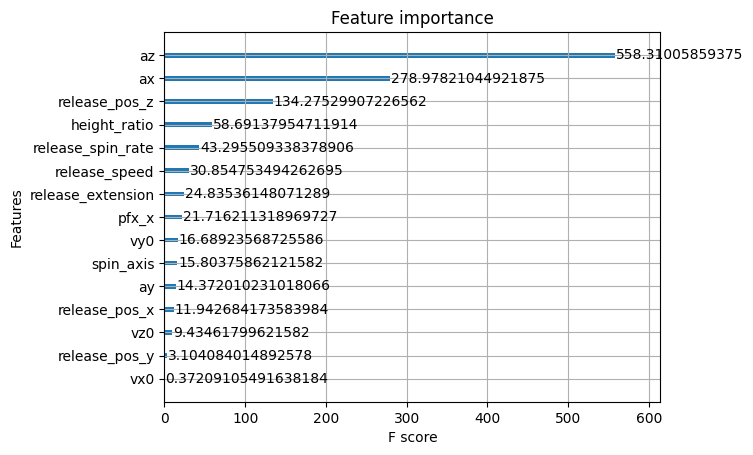

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [ ]:
y_pred = final_model.predict(dtest)

In [ ]:
print(y_pred.min())

-1.0523862


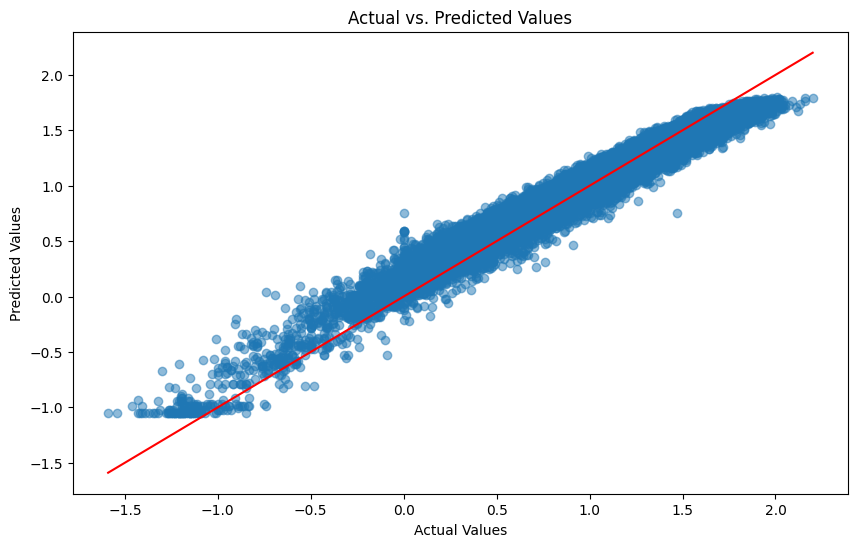

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [ ]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [ ]:
testing_identifiers['xpfx_z'] = predictions

In [ ]:
testing_identifiers.head()

pitch_id_raw    xpfx_z
0  663364_455139_617228_4_75_10  1.365207
1  663364_455139_617228_3_75_10  1.363265
2  663364_455139_617228_2_75_10  1.361444
3  663364_455139_617228_1_75_10  1.304839
5  663364_593428_605347_4_72_10  1.484582

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/IVB_2022&3_xpfz.csv")